In [1]:
from kafka import KafkaConsumer
from json import loads
import json
from time import sleep
import pandas as pd
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS

In [2]:
token = "En1iX5zqnyR_AT71S6Ahz8_Hs78nrJHwEkZDDksf4J6reHJNqXzbaMEXbmBjy7I-bdzp2k8fy7E1FjU1f2ZWsA=="
org = "mema_org"
bucket = "mema_bucket"
url = "http://localhost:8086"

Evaluation functions

In [3]:
def calculate_delay_of_detection(true_change_points, detected_change_points):
    total_delay = 0
    count = 0

    for true_point in true_change_points:
        detected_point = min([dp for dp in detected_change_points if dp >= true_point], default=None)
        if detected_point is not None:
            total_delay += (detected_point - true_point)
            count += 1

    return total_delay / count if count else None

In [4]:
def calculate_false_detection_rate(true_change_points, detected_change_points):
    false_detections = [dp for dp in detected_change_points if dp not in true_change_points]
    return len(false_detections) / len(detected_change_points) if detected_change_points else 0


In [5]:

def calculate_miss_detection_rate(true_change_points, detected_change_points):
    missed_detections = [tp for tp in true_change_points if tp not in detected_change_points]
    return len(missed_detections) / len(true_change_points) if true_change_points else 0


In [6]:

def calculate_error_rate(true_labels, predicted_labels):
    incorrect_predictions = sum(1 for true, pred in zip(true_labels, predicted_labels) if true != pred)
    return incorrect_predictions / len(true_labels) if true_labels else 0

Page-Hinkley algorithm

In [7]:
# Page-Hinkley Test Implementation
class PageHinkley:
    def __init__(self, min_instances=30, delta=0.005, threshold=50, alpha=1-0.0001):
        self.min_instances = min_instances
        self.delta = delta
        self.threshold = threshold
        self.alpha = alpha
        self.cum_sum = 0
        self.mean = 0
        self.n = 0

    def add_element(self, value):
        if self.n < self.min_instances:
            self.n += 1
            self.mean = self.mean + (value - self.mean) / self.n
            return False

        self.cum_sum = max(0, self.alpha * self.cum_sum + (value - self.mean - self.delta))

        self.mean = self.mean + (value - self.mean) / self.n
        self.n += 1

        if self.cum_sum > self.threshold:
            self.cum_sum = 0
            return True

        return False

In [8]:
import joblib

# Load the model from the file
model = joblib.load('../../albert/model/random_forest_model.joblib')

In [17]:
def split_df(df):
    label = df.pop('attack')
    return df, label

In [18]:
class HaiConsumer:
    def __init__(self, topic, bootstrap_servers):
        self.topic = topic
        self.bootstrap_servers = bootstrap_servers
        self.consumer = KafkaConsumer(
            self.topic,
            bootstrap_servers=self.bootstrap_servers,
            auto_offset_reset='earliest',
            enable_auto_commit=True,
            value_deserializer=lambda x: loads(x.decode('utf-8')))

    def consume(self):
        # Initialize Page-Hinkley detector
        page_hinkley = PageHinkley(min_instances=30, delta=0.005, threshold=50, alpha=1-0.0001)

        counter = 0
        # Perform change detection on the test set
        change_points = []
        accuracies = []
        whole_df = pd.DataFrame()
        whole_labels = pd.Series()
        # write to file
        with influxdb_client.InfluxDBClient(url=url, token=token, org=org) as client:
            write_api = client.write_api(write_options=SYNCHRONOUS)
            for i, message in enumerate(self.consumer):
                message = message.value
                print(message)
                # selected_columns = {key: value for key, value in message.items() if key in columns_to_scale_and_monitor}
                df = pd.DataFrame([message])
                x_i, y_i = split_df(df)
                x_i = x_i.iloc[0:1]
                
                whole_df =pd.concat([whole_df,x_i], ignore_index=True)
                whole_labels = pd.concat([whole_labels,y_i], ignore_index=True)

                # Predict using the RandomForest model
                pred = model.predict(x_i)

                # Check for a change point
                if page_hinkley.add_element(pred == int(y_i)):
                    change_points.append(i)

                # Calculate accuracy at each step
                accuracy = model.score(whole_df.iloc[:i + 1], whole_labels.iloc[:i + 1])
                accuracies.append(accuracy)

                
                p = influxdb_client.Point("ChangeDetection_PageHinkley").field('accuracy', accuracy)
                write_api.write(bucket, org, p)

                
                p = influxdb_client.Point("ChangeDetection_PageHinkley").field('drift_detected', int(i))
                write_api.write(bucket, org, p)
                counter += 1
                if counter > 5000:
                    break
                # random_forest_detection = model.predict(df)
                # stream_size = random_forest_detection.shape[0]
                # change_points = detect_change(df, columns_to_scale_and_monitor)

                # Evaluate change detection performance using EDDM
                # average_delay_eddm = calculate_delay_of_detection(true_attack_indexes, change_points)
                # fdr_ph = calculate_false_detection_rate(random_forest_detection, change_points)
                # mdr_ph = calculate_miss_detection_rate(random_forest_detection, change_points)
                # rod_ph = calculate_error_rate(random_forest_detection, change_points)
                # print(type(fdr_ph))
                # print(fdr_ph)
                # p = influxdb_client.Point("Change_Detection_PageHinkley").field('fdr_ph_0', fdr_ph)
                # write_api.write(bucket, org, p)
                # print(f'fdr_ph: {fdr_ph}')

                # p = influxdb_client.Point("Change_Detection_PageHinkley").field('mdr_ph_0', mdr_ph)
                # write_api.write(bucket, org, p)
                # print(f'mdr_ph: {mdr_ph}')

                # p = influxdb_client.Point("Change_Detection_PageHinkley").field('error_rate_ph', rod_ph)
                # write_api.write(bucket, org, p)
                # print(f'rod_ph: {rod_ph}')
                
                # sleep(3)
                # if i > 100:
                #     break

            client.close()
        
        import matplotlib.pyplot as plt
        import seaborn as sns
        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(whole_df)), accuracies, label='Accuracy')
        plt.scatter(change_points, [accuracies[i] for i in change_points], color='red', marker='x', label='Change Point')
        plt.title('Change Detection using Page-Hinkley with RandomForest')
        plt.xlabel('Time Step')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

{'P1_B2004': 0.0982, 'P1_B2016': 1.461, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 113.4112, 'P1_B4022': 35.907, 'P1_FCV01D': 9.2526, 'P1_FCV01Z': 9.7824, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.2579, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.0973, 'P1_FT01Z': 851.7838, 'P1_FT02': 22.3541, 'P1_FT02Z': 116.3903, 'P1_FT03': 305.7861, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.529, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 464.9188, 'P1_PCV01D': 82.854, 'P1_PCV01Z': 83.6807, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5275, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.772, 'P2_VXT02': -4.7981, 'P2_VXT03': -2.2431, 'P2_VYT02': -0.2253, 'P2_VYT03': 1.5684, 'P3_LCP01D': 1192.0, 'P3_LCV01D': 14544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.4689, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.24

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:34: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  whole_labels = pd.concat([whole_labels,y_i], ignore_index=True)
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4666, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 116.3903, 'P1_B4022': 35.9211, 'P1_FCV01D': 9.8404, 'P1_FCV01Z': 8.8211, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.346, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 852.6535, 'P1_FT02': 13.0081, 'P1_FT02Z': 74.6806, 'P1_FT03': 304.2602, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.5013, 'P1_LCV01Z': 14.0854, 'P1_LIT01': 465.0722, 'P1_PCV01D': 82.9685, 'P1_PCV01Z': 83.757, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.1947, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5275, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6731, 'P2_VXT02': -4.1927, 'P2_VXT03': -1.6708, 'P2_VYT02': 0.8075, 'P2_VYT03': 1.8001, 'P3_LCP01D': 1072.0, 'P3_LCV01D': 14656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.1181, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4717, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 67.729, 'P1_B4022': 35.9337, 'P1_FCV01D': 9.8901, 'P1_FCV01Z': 8.7448, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 53.163, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 841.7816, 'P1_FT02': 13.3895, 'P1_FT02Z': 68.7219, 'P1_FT03': 306.7398, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.4682, 'P1_LCV01Z': 13.4827, 'P1_LIT01': 465.0722, 'P1_PCV01D': 83.0274, 'P1_PCV01Z': 83.8104, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3963, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5275, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.80525, 'P2_VXT02': -4.1582, 'P2_VXT03': -2.0303, 'P2_VYT02': -0.3713, 'P2_VYT03': 1.2116, 'P3_LCP01D': 968.0, 'P3_LCV01D': 14752.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.9661, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4706, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 69.7149, 'P1_B4022': 35.931, 'P1_FCV01D': 9.9096, 'P1_FCV01Z': 8.7219, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.174, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 836.998, 'P1_FT02': 11.8637, 'P1_FT02Z': 64.7495, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.3716, 'P1_LCV01Z': 13.4903, 'P1_LIT01': 465.0722, 'P1_PCV01D': 83.1071, 'P1_PCV01Z': 83.7418, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5427, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7651, 'P2_VXT02': -4.8191, 'P2_VXT03': -2.2381, 'P2_VYT02': 0.15705, 'P2_VYT03': 1.5949, 'P3_LCP01D': 872.0, 'P3_LCV01D': 14864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.6696, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.064

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4793, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 61.7703, 'P1_B4022': 35.9528, 'P1_FCV01D': 9.8699, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.3144, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 836.998, 'P1_FT02': 12.8174, 'P1_FT02Z': 64.7495, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.4077, 'P1_LCV01Z': 13.4903, 'P1_LIT01': 464.9188, 'P1_PCV01D': 83.1783, 'P1_PCV01Z': 83.7189, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4009, 'P1_PIT02': 0.1909, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5275, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.677, 'P2_VXT02': -4.171, 'P2_VXT03': -1.665, 'P2_VYT02': 0.7912, 'P2_VYT03': 1.7727, 'P3_LCP01D': 808.0, 'P3_LCV01D': 14944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.4091, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.318, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4807, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 35.9562, 'P1_FCV01D': 9.7815, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 53.09, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 836.5632, 'P1_FT02': 12.8174, 'P1_FT02Z': 67.729, 'P1_FT03': 306.9305, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.3028, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 465.0211, 'P1_PCV01D': 83.2475, 'P1_PCV01Z': 83.7189, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.1909, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8419, 'P2_VXT02': -4.1811, 'P2_VXT03': -2.0436, 'P2_VYT02': -0.3837, 'P2_VYT03': 1.2045, 'P3_LCP01D': 728.0, 'P3_LCV01D': 15024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.2319, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.5567

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4805, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 35.9558, 'P1_FCV01D': 9.6921, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.2668, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 837.8677, 'P1_FT02': 12.8174, 'P1_FT02Z': 70.7082, 'P1_FT03': 304.0695, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.3391, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.8166, 'P1_PCV01D': 83.327, 'P1_PCV01Z': 83.7189, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4017, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6475, 'P2_VXT02': -4.7885, 'P2_VXT03': -1.9953, 'P2_VYT02': 0.5195, 'P2_VYT03': 1.9376, 'P3_LCP01D': 656.0, 'P3_LCV01D': 15088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.0221, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.75

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4898, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 35.9791, 'P1_FCV01D': 9.8063, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1157, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 835.6934, 'P1_FT02': 11.673, 'P1_FT02Z': 60.7774, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.3585, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 465.0211, 'P1_PCV01D': 83.464, 'P1_PCV01Z': 85.0082, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3979, 'P1_PIT02': 0.1878, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7728, 'P2_VXT02': -3.7787, 'P2_VXT03': -1.6827, 'P2_VYT02': 0.2282, 'P2_VYT03': 1.3161, 'P3_LCP01D': 592.0, 'P3_LCV01D': 15168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.863, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.9256

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.488, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 60.7774, 'P1_B4022': 35.9745, 'P1_FCV01D': 9.8154, 'P1_FCV01Z': 8.8287, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 53.1975, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 843.5212, 'P1_FT02': 13.1988, 'P1_FT02Z': 57.7978, 'P1_FT03': 304.6417, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.2158, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.8166, 'P1_PCV01D': 83.5683, 'P1_PCV01Z': 85.0769, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7585, 'P2_VXT02': -4.8485, 'P2_VXT03': -2.246, 'P2_VYT02': -0.175, 'P2_VYT03': 1.6102, 'P3_LCP01D': 536.0, 'P3_LCV01D': 15216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.6749, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.063

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4933, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 68.7219, 'P1_B4022': 35.9879, 'P1_FCV01D': 9.6498, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 53.218, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 842.6514, 'P1_FT02': 11.8637, 'P1_FT02Z': 65.7428, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.3035, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6632, 'P1_PCV01D': 83.6715, 'P1_PCV01Z': 85.0464, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1924, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.682, 'P2_VXT02': -4.1249, 'P2_VXT03': -1.6491, 'P2_VYT02': 0.7855, 'P2_VYT03': 1.7577, 'P3_LCP01D': 480.0, 'P3_LCV01D': 15264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.5158, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.215

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5028, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 61.7703, 'P1_B4022': 36.0115, 'P1_FCV01D': 9.6098, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.991, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 833.519, 'P1_FT02': 12.2452, 'P1_FT02Z': 65.7428, 'P1_FT03': 307.312, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.1804, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6632, 'P1_PCV01D': 83.7675, 'P1_PCV01Z': 85.1379, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8394, 'P2_VXT02': -4.2158, 'P2_VXT03': -2.0577, 'P2_VYT02': -0.4035, 'P2_VYT03': 1.2111, 'P3_LCP01D': 432.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4109, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.338

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5016, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 63.7565, 'P1_B4022': 36.0085, 'P1_FCV01D': 9.5692, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.1053, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.4771, 'P1_FT02': 12.0544, 'P1_FT02Z': 65.7428, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.1363, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6632, 'P1_PCV01D': 83.903, 'P1_PCV01Z': 85.1379, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.644, 'P2_VXT02': -4.7687, 'P2_VXT03': -1.9728, 'P2_VYT02': 0.5569, 'P2_VYT03': 1.9387, 'P3_LCP01D': 392.0, 'P3_LCV01D': 15360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2843, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.482

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5042, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 62.7632, 'P1_B4022': 36.0149, 'P1_FCV01D': 9.5603, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.1922, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 840.0421, 'P1_FT02': 12.8174, 'P1_FT02Z': 63.7565, 'P1_FT03': 303.688, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.0931, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6632, 'P1_PCV01D': 84.0177, 'P1_PCV01Z': 85.1379, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3979, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7779, 'P2_VXT02': -3.7647, 'P2_VXT03': -1.6946, 'P2_VYT02': 0.1663, 'P2_VYT03': 1.2942, 'P3_LCP01D': 352.0, 'P3_LCV01D': 15392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.1541, 'P4_HT_FD': 0.0001, 'P4_HT_LD': 72.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5028, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 36.0115, 'P1_FCV01D': 9.4407, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1215, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.5551, 'P1_FT01Z': 847.0001, 'P1_FT02': 12.6267, 'P1_FT02Z': 65.7428, 'P1_FT03': 304.6417, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.1284, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6632, 'P1_PCV01D': 84.1458, 'P1_PCV01Z': 85.1379, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1924, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7533, 'P2_VXT02': -4.865, 'P2_VXT03': -2.2392, 'P2_VYT02': -0.1357, 'P2_VYT03': 1.6398, 'P3_LCP01D': 320.0, 'P3_LCV01D': 15440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0528, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5065, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 65.7428, 'P1_B4022': 36.0207, 'P1_FCV01D': 9.4143, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0597, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 843.0862, 'P1_FT02': 12.4359, 'P1_FT02Z': 60.7774, 'P1_FT03': 305.2139, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.007, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.5099, 'P1_PCV01D': 84.2574, 'P1_PCV01Z': 85.1074, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6827, 'P2_VXT02': -4.1255, 'P2_VXT03': -1.6483, 'P2_VYT02': 0.782, 'P2_VYT03': 1.7487, 'P3_LCP01D': 296.0, 'P3_LCV01D': 15472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9732, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.779

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5095, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 60.7774, 'P1_B4022': 36.0283, 'P1_FCV01D': 9.4212, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 52.9922, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 840.4771, 'P1_FT02': 13.9618, 'P1_FT02Z': 66.7357, 'P1_FT03': 305.9768, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.0727, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.561, 'P1_PCV01D': 84.3778, 'P1_PCV01Z': 85.0235, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1939, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8383, 'P2_VXT02': -4.2323, 'P2_VXT03': -2.06, 'P2_VYT02': -0.3974, 'P2_VYT03': 1.2315, 'P3_LCP01D': 264.0, 'P3_LCV01D': 15488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.89, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.8516,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5133, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 36.0378, 'P1_FCV01D': 9.2541, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.0032, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 839.1723, 'P1_FT02': 12.2452, 'P1_FT02Z': 65.7428, 'P1_FT03': 305.4046, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 12.9231, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.5099, 'P1_PCV01D': 84.4845, 'P1_PCV01Z': 85.0082, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.643, 'P2_VXT02': -4.7446, 'P2_VXT03': -1.9555, 'P2_VYT02': 0.5654, 'P2_VYT03': 1.9466, 'P3_LCP01D': 240.0, 'P3_LCV01D': 15520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.8286, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.90

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5165, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 65.7428, 'P1_B4022': 36.0458, 'P1_FCV01D': 9.3522, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.0945, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 840.9119, 'P1_FT02': 13.1988, 'P1_FT02Z': 67.729, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.1387, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.561, 'P1_PCV01D': 84.6295, 'P1_PCV01Z': 86.3052, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4009, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0282, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7799, 'P2_VXT02': -3.7846, 'P2_VXT03': -1.7003, 'P2_VYT02': 0.1669, 'P2_VYT03': 1.2836, 'P3_LCP01D': 216.0, 'P3_LCV01D': 15536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.6694, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.974

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5177, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 67.729, 'P1_B4022': 36.0489, 'P1_FCV01D': 9.2323, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1041, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.7976, 'P1_FT01Z': 828.7354, 'P1_FT02': 12.6267, 'P1_FT02Z': 65.7428, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.0061, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3565, 'P1_PCV01D': 84.7008, 'P1_PCV01Z': 86.2976, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7561, 'P2_VXT02': -4.859, 'P2_VXT03': -2.2359, 'P2_VYT02': -0.1485, 'P2_VYT03': 1.629, 'P3_LCP01D': 192.0, 'P3_LCV01D': 15568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5826, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.0252

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5152, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 65.7428, 'P1_B4022': 36.0424, 'P1_FCV01D': 9.2373, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.985, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 835.2584, 'P1_FT02': 12.8174, 'P1_FT02Z': 66.7357, 'P1_FT03': 305.5953, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.0586, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.4588, 'P1_PCV01D': 84.8702, 'P1_PCV01Z': 86.3129, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3979, 'P1_PIT02': 0.1924, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6825, 'P2_VXT02': -4.1276, 'P2_VXT03': -1.6433, 'P2_VYT02': 0.7865, 'P2_VYT03': 1.7559, 'P3_LCP01D': 176.0, 'P3_LCV01D': 15584.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4886, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.09

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5155, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 36.0432, 'P1_FCV01D': 9.18, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9991, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 833.9539, 'P1_FT02': 12.6267, 'P1_FT02Z': 62.7632, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.0057, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2543, 'P1_PCV01D': 84.9716, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8389, 'P2_VXT02': -4.2302, 'P2_VXT03': -2.0605, 'P2_VYT02': -0.3998, 'P2_VYT03': 1.2183, 'P3_LCP01D': 160.0, 'P3_LCV01D': 15600.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.333, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.169

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.518, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 62.7632, 'P1_B4022': 36.0497, 'P1_FCV01D': 9.1551, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 52.9463, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 834.3889, 'P1_FT02': 13.771, 'P1_FT02Z': 62.7632, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.9539, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3054, 'P1_PCV01D': 85.1152, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1932, 'P1_TIT01': 36.4594, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6421, 'P2_VXT02': -4.7578, 'P2_VXT03': -1.9592, 'P2_VYT02': 0.5818, 'P2_VYT03': 1.943, 'P3_LCP01D': 136.0, 'P3_LCV01D': 15632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.2499, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 73.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5318, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 62.7632, 'P1_B4022': 36.084, 'P1_FCV01D': 9.0252, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9757, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 836.5632, 'P1_FT02': 13.0081, 'P1_FT02Z': 63.7565, 'P1_FT03': 305.0232, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.8437, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3054, 'P1_PCV01D': 85.2595, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4001, 'P1_PIT02': 0.1924, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7801, 'P2_VXT02': -3.7822, 'P2_VXT03': -1.7013, 'P2_VYT02': 0.1692, 'P2_VYT03': 1.2868, 'P3_LCP01D': 128.0, 'P3_LCV01D': 15680.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.729, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 73.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5364, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 63.7565, 'P1_B4022': 36.0954, 'P1_FCV01D': 9.041, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 53.023, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 836.998, 'P1_FT02': 12.0544, 'P1_FT02Z': 63.7565, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.9389, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3565, 'P1_PCV01D': 85.4394, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.753, 'P2_VXT02': -4.873, 'P2_VXT03': -2.2402, 'P2_VYT02': -0.1274, 'P2_VYT03': 1.6393, 'P3_LCP01D': 120.0, 'P3_LCV01D': 15760.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.8031, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 74.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5457, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 63.7565, 'P1_B4022': 36.1187, 'P1_FCV01D': 9.0784, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9664, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 838.7375, 'P1_FT02': 12.4359, 'P1_FT02Z': 66.7357, 'P1_FT03': 305.2139, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.0465, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3565, 'P1_PCV01D': 85.6081, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1909, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6869, 'P2_VXT02': -4.0928, 'P2_VXT03': -1.6423, 'P2_VYT02': 0.7695, 'P2_VYT03': 1.721, 'P3_LCP01D': 104.0, 'P3_LCV01D': 15824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.4993, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5492, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 36.1275, 'P1_FCV01D': 9.0063, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.8344, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 838.3027, 'P1_FT02': 12.8174, 'P1_FT02Z': 68.7219, 'P1_FT03': 306.9305, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.8613, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2543, 'P1_PCV01D': 85.7788, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1939, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0187, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8364, 'P2_VXT02': -4.2381, 'P2_VXT03': -2.0669, 'P2_VYT02': -0.3889, 'P2_VYT03': 1.234, 'P3_LCP01D': 96.0, 'P3_LCV01D': 15904.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.3365, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5588, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 68.7219, 'P1_B4022': 36.1515, 'P1_FCV01D': 8.933, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.0495, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 828.7354, 'P1_FT02': 12.4359, 'P1_FT02Z': 63.7565, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.9436, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.4076, 'P1_PCV01D': 85.9639, 'P1_PCV01Z': 86.4349, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6419, 'P2_VXT02': -4.7494, 'P2_VXT03': -1.9593, 'P2_VYT02': 0.591, 'P2_VYT03': 1.9427, 'P3_LCP01D': 88.0, 'P3_LCV01D': 16000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.0652, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 75.6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5679, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0004, 'P1_B400B': 63.7565, 'P1_B4022': 36.1744, 'P1_FCV01D': 8.9235, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9507, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 842.6514, 'P1_FT02': 12.8174, 'P1_FT02Z': 61.7703, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.7929, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3565, 'P1_PCV01D': 86.1713, 'P1_PCV01Z': 87.709, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.782, 'P2_VXT02': -3.7825, 'P2_VXT03': -1.709, 'P2_VYT02': 0.1436, 'P2_VYT03': 1.2777, 'P3_LCP01D': 72.0, 'P3_LCV01D': 16096.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.8374, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5756, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 61.7703, 'P1_B4022': 36.1935, 'P1_FCV01D': 8.8523, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0248, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 13.1988, 'P1_FT02Z': 66.7357, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.8494, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3054, 'P1_PCV01D': 86.4227, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7482, 'P2_VXT02': -4.8896, 'P2_VXT03': -2.2416, 'P2_VYT02': -0.0919, 'P2_VYT03': 1.6636, 'P3_LCP01D': 72.0, 'P3_LCV01D': 16176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.6674, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5855, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0094, 'P1_B400B': 66.7357, 'P1_B4022': 36.2183, 'P1_FCV01D': 8.779, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.002, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 836.5632, 'P1_FT02': 12.2452, 'P1_FT02Z': 64.7495, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.861, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2032, 'P1_PCV01D': 86.6016, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6919, 'P2_VXT02': -4.0608, 'P2_VXT03': -1.638, 'P2_VYT02': 0.7488, 'P2_VYT03': 1.6981, 'P3_LCP01D': 64.0, 'P3_LCV01D': 16272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.4468, 'P4_HT_FD': 0.0, 'P4_HT_LD': 76.996

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5899, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 64.7495, 'P1_B4022': 36.2293, 'P1_FCV01D': 8.8159, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7859, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 835.6934, 'P1_FT02': 13.771, 'P1_FT02Z': 64.7495, 'P1_FT03': 307.1212, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.6783, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.0498, 'P1_PCV01D': 86.8248, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.1878, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8347, 'P2_VXT02': -4.2877, 'P2_VXT03': -2.0934, 'P2_VYT02': -0.405, 'P2_VYT03': 1.2544, 'P3_LCP01D': 56.0, 'P3_LCV01D': 16352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.2406, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 77.416

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5977, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.006, 'P1_B400B': 64.7495, 'P1_B4022': 36.2488, 'P1_FCV01D': 8.6497, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.8166, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.8385, 'P1_FT01Z': 842.6514, 'P1_FT02': 12.6267, 'P1_FT02Z': 71.7011, 'P1_FT03': 306.3583, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.7811, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.9987, 'P1_PCV01D': 87.0362, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6407, 'P2_VXT02': -4.696, 'P2_VXT03': -1.9243, 'P2_VYT02': 0.6323, 'P2_VYT03': 1.9515, 'P3_LCP01D': 48.0, 'P3_LCV01D': 16432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.0019, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6052, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0035, 'P1_B400B': 71.7011, 'P1_B4022': 36.2675, 'P1_FCV01D': 8.6992, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0163, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.081, 'P1_FT01Z': 823.9517, 'P1_FT02': 12.2452, 'P1_FT02Z': 66.7357, 'P1_FT03': 303.1158, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.6386, 'P1_LCV01Z': 12.5137, 'P1_LIT01': 464.1521, 'P1_PCV01D': 87.2565, 'P1_PCV01Z': 87.8922, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8006, 'P2_VXT02': -3.8035, 'P2_VXT03': -1.7564, 'P2_VYT02': 0.0465, 'P2_VYT03': 1.2468, 'P3_LCP01D': 48.0, 'P3_LCV01D': 16512.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.8572, 'P4_HT_FD': 0.0, 'P4_HT_LD': 78.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6058, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 36.269, 'P1_FCV01D': 8.6891, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.811, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 831.3447, 'P1_FT02': 13.0081, 'P1_FT02Z': 67.729, 'P1_FT03': 306.1676, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.7911, 'P1_LCV01Z': 12.4985, 'P1_LIT01': 464.101, 'P1_PCV01D': 87.4304, 'P1_PCV01Z': 89.0366, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7342, 'P2_VXT02': -4.91, 'P2_VXT03': -2.2214, 'P2_VYT02': -0.0205, 'P2_VYT03': 1.7169, 'P3_LCP01D': 40.0, 'P3_LCV01D': 16592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.6293, 'P4_HT_FD': 0.0, 'P4_HT_LD': 78.465, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6142, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 67.729, 'P1_B4022': 36.29, 'P1_FCV01D': 8.5955, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9164, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 830.475, 'P1_FT02': 12.0544, 'P1_FT02Z': 67.729, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.7447, 'P1_LCV01Z': 12.4908, 'P1_LIT01': 463.9476, 'P1_PCV01D': 87.6446, 'P1_PCV01Z': 89.0366, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1947, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7006, 'P2_VXT02': -3.9806, 'P2_VXT03': -1.6224, 'P2_VYT02': 0.6986, 'P2_VYT03': 1.6454, 'P3_LCP01D': 32.0, 'P3_LCV01D': 16672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.3979, 'P4_HT_FD': 0.0, 'P4_HT_LD': 78.7109, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6256, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0225, 'P1_B400B': 67.729, 'P1_B4022': 36.3186, 'P1_FCV01D': 8.6366, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 52.7258, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 828.7354, 'P1_FT02': 13.1988, 'P1_FT02Z': 66.7357, 'P1_FT03': 306.9305, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.616, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.7943, 'P1_PCV01D': 87.9093, 'P1_PCV01Z': 89.0366, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1909, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8235, 'P2_VXT02': -4.4474, 'P2_VXT03': -2.1628, 'P2_VYT02': -0.4157, 'P2_VYT03': 1.3142, 'P3_LCP01D': 32.0, 'P3_LCV01D': 16720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.2351, 'P4_HT_FD': -0.0001, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6256, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0039, 'P1_B400B': 66.7357, 'P1_B4022': 36.3186, 'P1_FCV01D': 8.4954, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9899, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.7404, 'P1_FT01Z': 823.517, 'P1_FT02': 12.6267, 'P1_FT02Z': 63.7565, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 12.6163, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.7431, 'P1_PCV01D': 88.1275, 'P1_PCV01Z': 89.0671, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6476, 'P2_VXT02': -4.5435, 'P2_VXT03': -1.8262, 'P2_VYT02': 0.7299, 'P2_VYT03': 1.9278, 'P3_LCP01D': 32.0, 'P3_LCV01D': 16784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.0181, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6287, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 63.7565, 'P1_B4022': 36.3262, 'P1_FCV01D': 8.5, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9282, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.7921, 'P1_FT01Z': 822.6472, 'P1_FT02': 12.8174, 'P1_FT02Z': 74.6806, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.6822, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.5386, 'P1_PCV01D': 88.3181, 'P1_PCV01Z': 89.1586, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8227, 'P2_VXT02': -3.8509, 'P2_VXT03': -1.8102, 'P2_VYT02': -0.0733, 'P2_VYT03': 1.2118, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16832.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.8228, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.3982, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6365, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0042, 'P1_B400B': 74.6806, 'P1_B4022': 36.3457, 'P1_FCV01D': 8.4353, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9544, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 827.4308, 'P1_FT02': 12.8174, 'P1_FT02Z': 62.7632, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.8574, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.3853, 'P1_PCV01D': 88.5528, 'P1_PCV01Z': 89.151, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7079, 'P2_VXT02': -4.9257, 'P2_VXT03': -2.1693, 'P2_VYT02': 0.1403, 'P2_VYT03': 1.8065, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16912.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.6275, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.61

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6381, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0116, 'P1_B400B': 62.7632, 'P1_B4022': 36.3499, 'P1_FCV01D': 8.3941, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9832, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.4107, 'P1_FT01Z': 820.4728, 'P1_FT02': 11.8637, 'P1_FT02Z': 72.6944, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 12.8861, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.5898, 'P1_PCV01D': 88.7611, 'P1_PCV01Z': 89.3875, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.725, 'P2_VXT02': -3.8729, 'P2_VXT03': -1.612, 'P2_VYT02': 0.5789, 'P2_VYT03': 1.5407, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4647, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.752

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6447, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0193, 'P1_B400B': 72.6944, 'P1_B4022': 36.3663, 'P1_FCV01D': 8.4276, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.8743, 'P1_FCV03Z': 53.4912, 'P1_FT01': 174.942, 'P1_FT01Z': 835.6934, 'P1_FT02': 12.2452, 'P1_FT02Z': 67.729, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.8263, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.4364, 'P1_PCV01D': 89.0306, 'P1_PCV01Z': 89.5782, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1924, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8089, 'P2_VXT02': -4.5669, 'P2_VXT03': -2.1959, 'P2_VYT02': -0.3877, 'P2_VYT03': 1.3814, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.2658, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6432, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0085, 'P1_B400B': 67.729, 'P1_B4022': 36.3625, 'P1_FCV01D': 8.3622, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 52.7373, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 830.475, 'P1_FT02': 12.2452, 'P1_FT02Z': 65.7428, 'P1_FT03': 306.7398, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 12.659, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.0786, 'P1_PCV01D': 89.2831, 'P1_PCV01Z': 89.9597, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6487, 'P2_VXT02': -4.4938, 'P2_VXT03': -1.7938, 'P2_VYT02': 0.7694, 'P2_VYT03': 1.9195, 'P3_LCP01D': 16.0, 'P3_LCV01D': 17024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.0958, 'P4_HT_FD': 0.0, 'P4_HT_LD': 80.07

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6479, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0318, 'P1_B400B': 65.7428, 'P1_B4022': 36.3743, 'P1_FCV01D': 8.3283, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.7737, 'P1_FCV03Z': 53.5751, 'P1_FT01': 169.7921, 'P1_FT01Z': 827.4308, 'P1_FT02': 13.3895, 'P1_FT02Z': 67.729, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 12.6852, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.823, 'P1_PCV01D': 89.5191, 'P1_PCV01Z': 90.0894, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1939, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8355, 'P2_VXT02': -3.9119, 'P2_VXT03': -1.8658, 'P2_VYT02': -0.1822, 'P2_VYT03': 1.1928, 'P3_LCP01D': 16.0, 'P3_LCV01D': 17072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.886, 'P4_HT_FD': 0.0, 'P4_HT_LD': 80.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6528, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0434, 'P1_B400B': 69.7149, 'P1_B4022': 36.3865, 'P1_FCV01D': 8.3223, 'P1_FCV01Z': 7.7759, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.89, 'P1_FCV03Z': 53.598, 'P1_FT01': 172.8439, 'P1_FT01Z': 836.5632, 'P1_FT02': 10.7193, 'P1_FT02Z': 50.8462, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.8516, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.0275, 'P1_PCV01D': 89.9105, 'P1_PCV01Z': 90.448, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1978, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6488, 'P2_VXT02': -4.4142, 'P2_VXT03': -1.7502, 'P2_VYT02': 0.8082, 'P2_VYT03': 1.9041, 'P3_LCP01D': 16.0, 'P3_LCV01D': 17104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.6256, 'P4_HT_FD': 0.0, 'P4_HT_LD': 80.345

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6542, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0633, 'P1_B400B': 50.8462, 'P1_B4022': 36.3899, 'P1_FCV01D': 8.365, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.8939, 'P1_FCV03Z': 53.598, 'P1_FT01': 167.8848, 'P1_FT01Z': 828.3004, 'P1_FT02': 9.1934, 'P1_FT02Z': 46.8738, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.7936, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.0275, 'P1_PCV01D': 90.1381, 'P1_PCV01Z': 90.5701, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8371, 'P2_VXT02': -3.9394, 'P2_VXT03': -1.8801, 'P2_VYT02': -0.2011, 'P2_VYT03': 1.1965, 'P3_LCP01D': 16.0, 'P3_LCV01D': 17136.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.4592, 'P4_HT_FD': 0.0, 'P4_HT_LD': 80.4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6604, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0836, 'P1_B400B': 46.8738, 'P1_B4022': 36.4056, 'P1_FCV01D': 8.4693, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7467, 'P1_FCV03Z': 53.598, 'P1_FT01': 169.7921, 'P1_FT01Z': 824.8215, 'P1_FT02': 8.8119, 'P1_FT02Z': 48.86, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.7393, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.9763, 'P1_PCV01D': 90.404, 'P1_PCV01Z': 91.745, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.197, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6902, 'P2_VXT02': -4.9088, 'P2_VXT03': -2.1246, 'P2_VYT02': 0.2589, 'P2_VYT03': 1.8666, 'P3_LCP01D': 8.0, 'P3_LCV01D': 17168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.2313, 'P4_HT_FD': 0.0, 'P4_HT_LD': 80.5121, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6597, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0568, 'P1_B400B': 48.86, 'P1_B4022': 36.4037, 'P1_FCV01D': 8.4849, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7978, 'P1_FCV03Z': 53.6057, 'P1_FT01': 169.0292, 'P1_FT01Z': 829.6052, 'P1_FT02': 9.0026, 'P1_FT02Z': 47.8671, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.6346, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.4652, 'P1_PCV01D': 90.6654, 'P1_PCV01Z': 91.7526, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7421, 'P2_VXT02': -3.8196, 'P2_VXT03': -1.6197, 'P2_VYT02': 0.4848, 'P2_VYT03': 1.4733, 'P3_LCP01D': 8.0, 'P3_LCV01D': 17152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.0541, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 80.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6493, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0456, 'P1_B400B': 47.8671, 'P1_B4022': 36.3777, 'P1_FCV01D': 8.4216, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.7635, 'P1_FCV03Z': 53.6057, 'P1_FT01': 170.7458, 'P1_FT01Z': 825.2563, 'P1_FT02': 10.1471, 'P1_FT02Z': 49.8533, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.8095, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.3629, 'P1_PCV01D': 90.8256, 'P1_PCV01Z': 91.7526, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.79, 'P2_VXT02': -4.7012, 'P2_VXT03': -2.2268, 'P2_VYT02': -0.3077, 'P2_VYT03': 1.4884, 'P3_LCP01D': 8.0, 'P3_LCV01D': 17104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.866, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.85

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6468, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0205, 'P1_B400B': 49.8533, 'P1_B4022': 36.3716, 'P1_FCV01D': 8.2887, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.814, 'P1_FCV03Z': 53.6057, 'P1_FT01': 170.7458, 'P1_FT01Z': 819.1681, 'P1_FT02': 9.3841, 'P1_FT02Z': 47.8671, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 12.7562, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.3629, 'P1_PCV01D': 91.0209, 'P1_PCV01Z': 91.7526, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6567, 'P2_VXT02': -4.3204, 'P2_VXT03': -1.718, 'P2_VYT02': 0.8212, 'P2_VYT03': 1.8687, 'P3_LCP01D': 8.0, 'P3_LCV01D': 17056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.6924, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 79.3

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6363, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 47.8671, 'P1_B4022': 36.3453, 'P1_FCV01D': 8.3141, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9391, 'P1_FCV03Z': 53.598, 'P1_FT01': 169.4107, 'P1_FT01Z': 827.8656, 'P1_FT02': 9.0026, 'P1_FT02Z': 50.8462, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.0542, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.3119, 'P1_PCV01D': 91.2293, 'P1_PCV01Z': 91.7526, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8434, 'P2_VXT02': -4.05, 'P2_VXT03': -1.9636, 'P2_VYT02': -0.3079, 'P2_VYT03': 1.2005, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.5188, 'P4_HT_FD': 0.0, 'P4_HT_LD': 78.6531, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.461, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 113.4112, 'P1_B4022': 35.907, 'P1_FCV01D': 9.2526, 'P1_FCV01Z': 9.7824, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.2579, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.0973, 'P1_FT01Z': 851.7838, 'P1_FT02': 22.3541, 'P1_FT02Z': 116.3903, 'P1_FT03': 305.7861, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.529, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 464.9188, 'P1_PCV01D': 82.854, 'P1_PCV01Z': 83.6807, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5275, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.772, 'P2_VXT02': -4.7981, 'P2_VXT03': -2.2431, 'P2_VYT02': -0.2253, 'P2_VYT03': 1.5684, 'P3_LCP01D': 1192.0, 'P3_LCV01D': 14544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.4689, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.24

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4666, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 116.3903, 'P1_B4022': 35.9211, 'P1_FCV01D': 9.8404, 'P1_FCV01Z': 8.8211, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.346, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 852.6535, 'P1_FT02': 13.0081, 'P1_FT02Z': 74.6806, 'P1_FT03': 304.2602, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.5013, 'P1_LCV01Z': 14.0854, 'P1_LIT01': 465.0722, 'P1_PCV01D': 82.9685, 'P1_PCV01Z': 83.757, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.1947, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5275, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6731, 'P2_VXT02': -4.1927, 'P2_VXT03': -1.6708, 'P2_VYT02': 0.8075, 'P2_VYT03': 1.8001, 'P3_LCP01D': 1072.0, 'P3_LCV01D': 14656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.1181, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4717, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 67.729, 'P1_B4022': 35.9337, 'P1_FCV01D': 9.8901, 'P1_FCV01Z': 8.7448, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 53.163, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 841.7816, 'P1_FT02': 13.3895, 'P1_FT02Z': 68.7219, 'P1_FT03': 306.7398, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.4682, 'P1_LCV01Z': 13.4827, 'P1_LIT01': 465.0722, 'P1_PCV01D': 83.0274, 'P1_PCV01Z': 83.8104, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3963, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5275, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.80525, 'P2_VXT02': -4.1582, 'P2_VXT03': -2.0303, 'P2_VYT02': -0.3713, 'P2_VYT03': 1.2116, 'P3_LCP01D': 968.0, 'P3_LCV01D': 14752.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.9661, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4706, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 69.7149, 'P1_B4022': 35.931, 'P1_FCV01D': 9.9096, 'P1_FCV01Z': 8.7219, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.174, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 836.998, 'P1_FT02': 11.8637, 'P1_FT02Z': 64.7495, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.3716, 'P1_LCV01Z': 13.4903, 'P1_LIT01': 465.0722, 'P1_PCV01D': 83.1071, 'P1_PCV01Z': 83.7418, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5427, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7651, 'P2_VXT02': -4.8191, 'P2_VXT03': -2.2381, 'P2_VYT02': 0.15705, 'P2_VYT03': 1.5949, 'P3_LCP01D': 872.0, 'P3_LCV01D': 14864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.6696, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.064

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4793, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 61.7703, 'P1_B4022': 35.9528, 'P1_FCV01D': 9.8699, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.3144, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 836.998, 'P1_FT02': 12.8174, 'P1_FT02Z': 64.7495, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.4077, 'P1_LCV01Z': 13.4903, 'P1_LIT01': 464.9188, 'P1_PCV01D': 83.1783, 'P1_PCV01Z': 83.7189, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4009, 'P1_PIT02': 0.1909, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5275, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.677, 'P2_VXT02': -4.171, 'P2_VXT03': -1.665, 'P2_VYT02': 0.7912, 'P2_VYT03': 1.7727, 'P3_LCP01D': 808.0, 'P3_LCV01D': 14944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.4091, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.318, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4807, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 35.9562, 'P1_FCV01D': 9.7815, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 53.09, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 836.5632, 'P1_FT02': 12.8174, 'P1_FT02Z': 67.729, 'P1_FT03': 306.9305, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.3028, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 465.0211, 'P1_PCV01D': 83.2475, 'P1_PCV01Z': 83.7189, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.1909, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8419, 'P2_VXT02': -4.1811, 'P2_VXT03': -2.0436, 'P2_VYT02': -0.3837, 'P2_VYT03': 1.2045, 'P3_LCP01D': 728.0, 'P3_LCV01D': 15024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.2319, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.5567

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4805, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 35.9558, 'P1_FCV01D': 9.6921, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.2668, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 837.8677, 'P1_FT02': 12.8174, 'P1_FT02Z': 70.7082, 'P1_FT03': 304.0695, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.3391, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.8166, 'P1_PCV01D': 83.327, 'P1_PCV01Z': 83.7189, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4017, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6475, 'P2_VXT02': -4.7885, 'P2_VXT03': -1.9953, 'P2_VYT02': 0.5195, 'P2_VYT03': 1.9376, 'P3_LCP01D': 656.0, 'P3_LCV01D': 15088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.0221, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.75

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4898, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 35.9791, 'P1_FCV01D': 9.8063, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1157, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 835.6934, 'P1_FT02': 11.673, 'P1_FT02Z': 60.7774, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.3585, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 465.0211, 'P1_PCV01D': 83.464, 'P1_PCV01Z': 85.0082, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3979, 'P1_PIT02': 0.1878, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7728, 'P2_VXT02': -3.7787, 'P2_VXT03': -1.6827, 'P2_VYT02': 0.2282, 'P2_VYT03': 1.3161, 'P3_LCP01D': 592.0, 'P3_LCV01D': 15168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.863, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.9256

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.488, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 60.7774, 'P1_B4022': 35.9745, 'P1_FCV01D': 9.8154, 'P1_FCV01Z': 8.8287, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 53.1975, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 843.5212, 'P1_FT02': 13.1988, 'P1_FT02Z': 57.7978, 'P1_FT03': 304.6417, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.2158, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.8166, 'P1_PCV01D': 83.5683, 'P1_PCV01Z': 85.0769, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7585, 'P2_VXT02': -4.8485, 'P2_VXT03': -2.246, 'P2_VYT02': -0.175, 'P2_VYT03': 1.6102, 'P3_LCP01D': 536.0, 'P3_LCV01D': 15216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.6749, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.063

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4933, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 68.7219, 'P1_B4022': 35.9879, 'P1_FCV01D': 9.6498, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 53.218, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 842.6514, 'P1_FT02': 11.8637, 'P1_FT02Z': 65.7428, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.3035, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6632, 'P1_PCV01D': 83.6715, 'P1_PCV01Z': 85.0464, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1924, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.682, 'P2_VXT02': -4.1249, 'P2_VXT03': -1.6491, 'P2_VYT02': 0.7855, 'P2_VYT03': 1.7577, 'P3_LCP01D': 480.0, 'P3_LCV01D': 15264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.5158, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.215

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5028, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 61.7703, 'P1_B4022': 36.0115, 'P1_FCV01D': 9.6098, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.991, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 833.519, 'P1_FT02': 12.2452, 'P1_FT02Z': 65.7428, 'P1_FT03': 307.312, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.1804, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6632, 'P1_PCV01D': 83.7675, 'P1_PCV01Z': 85.1379, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8394, 'P2_VXT02': -4.2158, 'P2_VXT03': -2.0577, 'P2_VYT02': -0.4035, 'P2_VYT03': 1.2111, 'P3_LCP01D': 432.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4109, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.338

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5016, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 63.7565, 'P1_B4022': 36.0085, 'P1_FCV01D': 9.5692, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.1053, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.4771, 'P1_FT02': 12.0544, 'P1_FT02Z': 65.7428, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.1363, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6632, 'P1_PCV01D': 83.903, 'P1_PCV01Z': 85.1379, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.644, 'P2_VXT02': -4.7687, 'P2_VXT03': -1.9728, 'P2_VYT02': 0.5569, 'P2_VYT03': 1.9387, 'P3_LCP01D': 392.0, 'P3_LCV01D': 15360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2843, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.482

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5042, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 62.7632, 'P1_B4022': 36.0149, 'P1_FCV01D': 9.5603, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.1922, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 840.0421, 'P1_FT02': 12.8174, 'P1_FT02Z': 63.7565, 'P1_FT03': 303.688, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.0931, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6632, 'P1_PCV01D': 84.0177, 'P1_PCV01Z': 85.1379, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3979, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7779, 'P2_VXT02': -3.7647, 'P2_VXT03': -1.6946, 'P2_VYT02': 0.1663, 'P2_VYT03': 1.2942, 'P3_LCP01D': 352.0, 'P3_LCV01D': 15392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.1541, 'P4_HT_FD': 0.0001, 'P4_HT_LD': 72.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5028, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 36.0115, 'P1_FCV01D': 9.4407, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1215, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.5551, 'P1_FT01Z': 847.0001, 'P1_FT02': 12.6267, 'P1_FT02Z': 65.7428, 'P1_FT03': 304.6417, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.1284, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6632, 'P1_PCV01D': 84.1458, 'P1_PCV01Z': 85.1379, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1924, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7533, 'P2_VXT02': -4.865, 'P2_VXT03': -2.2392, 'P2_VYT02': -0.1357, 'P2_VYT03': 1.6398, 'P3_LCP01D': 320.0, 'P3_LCV01D': 15440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0528, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5065, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 65.7428, 'P1_B4022': 36.0207, 'P1_FCV01D': 9.4143, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0597, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 843.0862, 'P1_FT02': 12.4359, 'P1_FT02Z': 60.7774, 'P1_FT03': 305.2139, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.007, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.5099, 'P1_PCV01D': 84.2574, 'P1_PCV01Z': 85.1074, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6827, 'P2_VXT02': -4.1255, 'P2_VXT03': -1.6483, 'P2_VYT02': 0.782, 'P2_VYT03': 1.7487, 'P3_LCP01D': 296.0, 'P3_LCV01D': 15472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9732, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.779

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5095, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 60.7774, 'P1_B4022': 36.0283, 'P1_FCV01D': 9.4212, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 52.9922, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 840.4771, 'P1_FT02': 13.9618, 'P1_FT02Z': 66.7357, 'P1_FT03': 305.9768, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.0727, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.561, 'P1_PCV01D': 84.3778, 'P1_PCV01Z': 85.0235, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1939, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8383, 'P2_VXT02': -4.2323, 'P2_VXT03': -2.06, 'P2_VYT02': -0.3974, 'P2_VYT03': 1.2315, 'P3_LCP01D': 264.0, 'P3_LCV01D': 15488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.89, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.8516,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5133, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 36.0378, 'P1_FCV01D': 9.2541, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.0032, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 839.1723, 'P1_FT02': 12.2452, 'P1_FT02Z': 65.7428, 'P1_FT03': 305.4046, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 12.9231, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.5099, 'P1_PCV01D': 84.4845, 'P1_PCV01Z': 85.0082, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.643, 'P2_VXT02': -4.7446, 'P2_VXT03': -1.9555, 'P2_VYT02': 0.5654, 'P2_VYT03': 1.9466, 'P3_LCP01D': 240.0, 'P3_LCV01D': 15520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.8286, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.90

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5165, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 65.7428, 'P1_B4022': 36.0458, 'P1_FCV01D': 9.3522, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.0945, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 840.9119, 'P1_FT02': 13.1988, 'P1_FT02Z': 67.729, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.1387, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.561, 'P1_PCV01D': 84.6295, 'P1_PCV01Z': 86.3052, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4009, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0282, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7799, 'P2_VXT02': -3.7846, 'P2_VXT03': -1.7003, 'P2_VYT02': 0.1669, 'P2_VYT03': 1.2836, 'P3_LCP01D': 216.0, 'P3_LCV01D': 15536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.6694, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.974

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5177, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 67.729, 'P1_B4022': 36.0489, 'P1_FCV01D': 9.2323, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1041, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.7976, 'P1_FT01Z': 828.7354, 'P1_FT02': 12.6267, 'P1_FT02Z': 65.7428, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.0061, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3565, 'P1_PCV01D': 84.7008, 'P1_PCV01Z': 86.2976, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7561, 'P2_VXT02': -4.859, 'P2_VXT03': -2.2359, 'P2_VYT02': -0.1485, 'P2_VYT03': 1.629, 'P3_LCP01D': 192.0, 'P3_LCV01D': 15568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5826, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.0252

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5152, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 65.7428, 'P1_B4022': 36.0424, 'P1_FCV01D': 9.2373, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.985, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 835.2584, 'P1_FT02': 12.8174, 'P1_FT02Z': 66.7357, 'P1_FT03': 305.5953, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.0586, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.4588, 'P1_PCV01D': 84.8702, 'P1_PCV01Z': 86.3129, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3979, 'P1_PIT02': 0.1924, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6825, 'P2_VXT02': -4.1276, 'P2_VXT03': -1.6433, 'P2_VYT02': 0.7865, 'P2_VYT03': 1.7559, 'P3_LCP01D': 176.0, 'P3_LCV01D': 15584.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4886, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.09

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5155, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 36.0432, 'P1_FCV01D': 9.18, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9991, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 833.9539, 'P1_FT02': 12.6267, 'P1_FT02Z': 62.7632, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.0057, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2543, 'P1_PCV01D': 84.9716, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8389, 'P2_VXT02': -4.2302, 'P2_VXT03': -2.0605, 'P2_VYT02': -0.3998, 'P2_VYT03': 1.2183, 'P3_LCP01D': 160.0, 'P3_LCV01D': 15600.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.333, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.169

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.518, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 62.7632, 'P1_B4022': 36.0497, 'P1_FCV01D': 9.1551, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 52.9463, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 834.3889, 'P1_FT02': 13.771, 'P1_FT02Z': 62.7632, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.9539, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3054, 'P1_PCV01D': 85.1152, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1932, 'P1_TIT01': 36.4594, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6421, 'P2_VXT02': -4.7578, 'P2_VXT03': -1.9592, 'P2_VYT02': 0.5818, 'P2_VYT03': 1.943, 'P3_LCP01D': 136.0, 'P3_LCV01D': 15632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.2499, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 73.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5318, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 62.7632, 'P1_B4022': 36.084, 'P1_FCV01D': 9.0252, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9757, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 836.5632, 'P1_FT02': 13.0081, 'P1_FT02Z': 63.7565, 'P1_FT03': 305.0232, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.8437, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3054, 'P1_PCV01D': 85.2595, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4001, 'P1_PIT02': 0.1924, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7801, 'P2_VXT02': -3.7822, 'P2_VXT03': -1.7013, 'P2_VYT02': 0.1692, 'P2_VYT03': 1.2868, 'P3_LCP01D': 128.0, 'P3_LCV01D': 15680.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.729, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 73.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5364, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 63.7565, 'P1_B4022': 36.0954, 'P1_FCV01D': 9.041, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 53.023, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 836.998, 'P1_FT02': 12.0544, 'P1_FT02Z': 63.7565, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.9389, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3565, 'P1_PCV01D': 85.4394, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.5122, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.753, 'P2_VXT02': -4.873, 'P2_VXT03': -2.2402, 'P2_VYT02': -0.1274, 'P2_VYT03': 1.6393, 'P3_LCP01D': 120.0, 'P3_LCV01D': 15760.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.8031, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 74.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5457, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 63.7565, 'P1_B4022': 36.1187, 'P1_FCV01D': 9.0784, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9664, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 838.7375, 'P1_FT02': 12.4359, 'P1_FT02Z': 66.7357, 'P1_FT03': 305.2139, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.0465, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3565, 'P1_PCV01D': 85.6081, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1909, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6869, 'P2_VXT02': -4.0928, 'P2_VXT03': -1.6423, 'P2_VYT02': 0.7695, 'P2_VYT03': 1.721, 'P3_LCP01D': 104.0, 'P3_LCV01D': 15824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.4993, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5492, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 36.1275, 'P1_FCV01D': 9.0063, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.8344, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 838.3027, 'P1_FT02': 12.8174, 'P1_FT02Z': 68.7219, 'P1_FT03': 306.9305, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.8613, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2543, 'P1_PCV01D': 85.7788, 'P1_PCV01Z': 86.3205, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1939, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0187, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8364, 'P2_VXT02': -4.2381, 'P2_VXT03': -2.0669, 'P2_VYT02': -0.3889, 'P2_VYT03': 1.234, 'P3_LCP01D': 96.0, 'P3_LCV01D': 15904.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.3365, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5588, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 68.7219, 'P1_B4022': 36.1515, 'P1_FCV01D': 8.933, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.0495, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 828.7354, 'P1_FT02': 12.4359, 'P1_FT02Z': 63.7565, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.9436, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.4076, 'P1_PCV01D': 85.9639, 'P1_PCV01Z': 86.4349, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4969, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6419, 'P2_VXT02': -4.7494, 'P2_VXT03': -1.9593, 'P2_VYT02': 0.591, 'P2_VYT03': 1.9427, 'P3_LCP01D': 88.0, 'P3_LCV01D': 16000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.0652, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 75.6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5679, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0004, 'P1_B400B': 63.7565, 'P1_B4022': 36.1744, 'P1_FCV01D': 8.9235, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9507, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 842.6514, 'P1_FT02': 12.8174, 'P1_FT02Z': 61.7703, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.7929, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3565, 'P1_PCV01D': 86.1713, 'P1_PCV01Z': 87.709, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.782, 'P2_VXT02': -3.7825, 'P2_VXT03': -1.709, 'P2_VYT02': 0.1436, 'P2_VYT03': 1.2777, 'P3_LCP01D': 72.0, 'P3_LCV01D': 16096.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.8374, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5756, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 61.7703, 'P1_B4022': 36.1935, 'P1_FCV01D': 8.8523, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0248, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 13.1988, 'P1_FT02Z': 66.7357, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.8494, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3054, 'P1_PCV01D': 86.4227, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7482, 'P2_VXT02': -4.8896, 'P2_VXT03': -2.2416, 'P2_VYT02': -0.0919, 'P2_VYT03': 1.6636, 'P3_LCP01D': 72.0, 'P3_LCV01D': 16176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.6674, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5855, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0094, 'P1_B400B': 66.7357, 'P1_B4022': 36.2183, 'P1_FCV01D': 8.779, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.002, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 836.5632, 'P1_FT02': 12.2452, 'P1_FT02Z': 64.7495, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.861, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2032, 'P1_PCV01D': 86.6016, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6919, 'P2_VXT02': -4.0608, 'P2_VXT03': -1.638, 'P2_VYT02': 0.7488, 'P2_VYT03': 1.6981, 'P3_LCP01D': 64.0, 'P3_LCV01D': 16272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.4468, 'P4_HT_FD': 0.0, 'P4_HT_LD': 76.996

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5899, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 64.7495, 'P1_B4022': 36.2293, 'P1_FCV01D': 8.8159, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7859, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 835.6934, 'P1_FT02': 13.771, 'P1_FT02Z': 64.7495, 'P1_FT03': 307.1212, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.6783, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.0498, 'P1_PCV01D': 86.8248, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.1878, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8347, 'P2_VXT02': -4.2877, 'P2_VXT03': -2.0934, 'P2_VYT02': -0.405, 'P2_VYT03': 1.2544, 'P3_LCP01D': 56.0, 'P3_LCV01D': 16352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.2406, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 77.416

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5977, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.006, 'P1_B400B': 64.7495, 'P1_B4022': 36.2488, 'P1_FCV01D': 8.6497, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.8166, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.8385, 'P1_FT01Z': 842.6514, 'P1_FT02': 12.6267, 'P1_FT02Z': 71.7011, 'P1_FT03': 306.3583, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.7811, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.9987, 'P1_PCV01D': 87.0362, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6407, 'P2_VXT02': -4.696, 'P2_VXT03': -1.9243, 'P2_VYT02': 0.6323, 'P2_VYT03': 1.9515, 'P3_LCP01D': 48.0, 'P3_LCV01D': 16432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.0019, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6052, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0035, 'P1_B400B': 71.7011, 'P1_B4022': 36.2675, 'P1_FCV01D': 8.6992, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0163, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.081, 'P1_FT01Z': 823.9517, 'P1_FT02': 12.2452, 'P1_FT02Z': 66.7357, 'P1_FT03': 303.1158, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.6386, 'P1_LCV01Z': 12.5137, 'P1_LIT01': 464.1521, 'P1_PCV01D': 87.2565, 'P1_PCV01Z': 87.8922, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8006, 'P2_VXT02': -3.8035, 'P2_VXT03': -1.7564, 'P2_VYT02': 0.0465, 'P2_VYT03': 1.2468, 'P3_LCP01D': 48.0, 'P3_LCV01D': 16512.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.8572, 'P4_HT_FD': 0.0, 'P4_HT_LD': 78.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6058, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 66.7357, 'P1_B4022': 36.269, 'P1_FCV01D': 8.6891, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.811, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 831.3447, 'P1_FT02': 13.0081, 'P1_FT02Z': 67.729, 'P1_FT03': 306.1676, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.7911, 'P1_LCV01Z': 12.4985, 'P1_LIT01': 464.101, 'P1_PCV01D': 87.4304, 'P1_PCV01Z': 89.0366, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7342, 'P2_VXT02': -4.91, 'P2_VXT03': -2.2214, 'P2_VYT02': -0.0205, 'P2_VYT03': 1.7169, 'P3_LCP01D': 40.0, 'P3_LCV01D': 16592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.6293, 'P4_HT_FD': 0.0, 'P4_HT_LD': 78.465, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6142, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 67.729, 'P1_B4022': 36.29, 'P1_FCV01D': 8.5955, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9164, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 830.475, 'P1_FT02': 12.0544, 'P1_FT02Z': 67.729, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.7447, 'P1_LCV01Z': 12.4908, 'P1_LIT01': 463.9476, 'P1_PCV01D': 87.6446, 'P1_PCV01Z': 89.0366, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1947, 'P1_TIT01': 36.4288, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7006, 'P2_VXT02': -3.9806, 'P2_VXT03': -1.6224, 'P2_VYT02': 0.6986, 'P2_VYT03': 1.6454, 'P3_LCP01D': 32.0, 'P3_LCV01D': 16672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.3979, 'P4_HT_FD': 0.0, 'P4_HT_LD': 78.7109, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6256, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0225, 'P1_B400B': 67.729, 'P1_B4022': 36.3186, 'P1_FCV01D': 8.6366, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 52.7258, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 828.7354, 'P1_FT02': 13.1988, 'P1_FT02Z': 66.7357, 'P1_FT03': 306.9305, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.616, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.7943, 'P1_PCV01D': 87.9093, 'P1_PCV01Z': 89.0366, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1909, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8235, 'P2_VXT02': -4.4474, 'P2_VXT03': -2.1628, 'P2_VYT02': -0.4157, 'P2_VYT03': 1.3142, 'P3_LCP01D': 32.0, 'P3_LCV01D': 16720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.2351, 'P4_HT_FD': -0.0001, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6256, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0039, 'P1_B400B': 66.7357, 'P1_B4022': 36.3186, 'P1_FCV01D': 8.4954, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9899, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.7404, 'P1_FT01Z': 823.517, 'P1_FT02': 12.6267, 'P1_FT02Z': 63.7565, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 12.6163, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.7431, 'P1_PCV01D': 88.1275, 'P1_PCV01Z': 89.0671, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1917, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6476, 'P2_VXT02': -4.5435, 'P2_VXT03': -1.8262, 'P2_VYT02': 0.7299, 'P2_VYT03': 1.9278, 'P3_LCP01D': 32.0, 'P3_LCV01D': 16784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.0181, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6287, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 63.7565, 'P1_B4022': 36.3262, 'P1_FCV01D': 8.5, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9282, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.7921, 'P1_FT01Z': 822.6472, 'P1_FT02': 12.8174, 'P1_FT02Z': 74.6806, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.6822, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.5386, 'P1_PCV01D': 88.3181, 'P1_PCV01Z': 89.1586, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4817, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8227, 'P2_VXT02': -3.8509, 'P2_VXT03': -1.8102, 'P2_VYT02': -0.0733, 'P2_VYT03': 1.2118, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16832.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.8228, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.3982, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6365, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0042, 'P1_B400B': 74.6806, 'P1_B4022': 36.3457, 'P1_FCV01D': 8.4353, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9544, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 827.4308, 'P1_FT02': 12.8174, 'P1_FT02Z': 62.7632, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.8574, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.3853, 'P1_PCV01D': 88.5528, 'P1_PCV01Z': 89.151, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7079, 'P2_VXT02': -4.9257, 'P2_VXT03': -2.1693, 'P2_VYT02': 0.1403, 'P2_VYT03': 1.8065, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16912.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.6275, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.61

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6381, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0116, 'P1_B400B': 62.7632, 'P1_B4022': 36.3499, 'P1_FCV01D': 8.3941, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9832, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.4107, 'P1_FT01Z': 820.4728, 'P1_FT02': 11.8637, 'P1_FT02Z': 72.6944, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 12.8861, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.5898, 'P1_PCV01D': 88.7611, 'P1_PCV01Z': 89.3875, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.1901, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.725, 'P2_VXT02': -3.8729, 'P2_VXT03': -1.612, 'P2_VYT02': 0.5789, 'P2_VYT03': 1.5407, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4647, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.752

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6447, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0193, 'P1_B400B': 72.6944, 'P1_B4022': 36.3663, 'P1_FCV01D': 8.4276, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.8743, 'P1_FCV03Z': 53.4912, 'P1_FT01': 174.942, 'P1_FT01Z': 835.6934, 'P1_FT02': 12.2452, 'P1_FT02Z': 67.729, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.8263, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.4364, 'P1_PCV01D': 89.0306, 'P1_PCV01Z': 89.5782, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1924, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8089, 'P2_VXT02': -4.5669, 'P2_VXT03': -2.1959, 'P2_VYT02': -0.3877, 'P2_VYT03': 1.3814, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.2658, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6432, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0085, 'P1_B400B': 67.729, 'P1_B4022': 36.3625, 'P1_FCV01D': 8.3622, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3455, 'P1_FCV03D': 52.7373, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 830.475, 'P1_FT02': 12.2452, 'P1_FT02Z': 65.7428, 'P1_FT03': 306.7398, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 12.659, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.0786, 'P1_PCV01D': 89.2831, 'P1_PCV01Z': 89.9597, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.1894, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6487, 'P2_VXT02': -4.4938, 'P2_VXT03': -1.7938, 'P2_VYT02': 0.7694, 'P2_VYT03': 1.9195, 'P3_LCP01D': 16.0, 'P3_LCV01D': 17024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.0958, 'P4_HT_FD': 0.0, 'P4_HT_LD': 80.07

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6479, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0318, 'P1_B400B': 65.7428, 'P1_B4022': 36.3743, 'P1_FCV01D': 8.3283, 'P1_FCV01Z': 8.8364, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.7737, 'P1_FCV03Z': 53.5751, 'P1_FT01': 169.7921, 'P1_FT01Z': 827.4308, 'P1_FT02': 13.3895, 'P1_FT02Z': 67.729, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 12.6852, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.823, 'P1_PCV01D': 89.5191, 'P1_PCV01Z': 90.0894, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1939, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8355, 'P2_VXT02': -3.9119, 'P2_VXT03': -1.8658, 'P2_VYT02': -0.1822, 'P2_VYT03': 1.1928, 'P3_LCP01D': 16.0, 'P3_LCV01D': 17072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.886, 'P4_HT_FD': 0.0, 'P4_HT_LD': 80.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6531, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0437, 'P1_B400B': 67.729, 'P1_B4022': 36.3873, 'P1_FCV01D': 8.1962, 'P1_FCV01Z': 7.7911, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9116, 'P1_FCV03Z': 53.598, 'P1_FT01': 174.3698, 'P1_FT01Z': 826.561, 'P1_FT02': 9.7656, 'P1_FT02Z': 60.7774, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.6742, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.8741, 'P1_PCV01D': 89.7942, 'P1_PCV01Z': 90.4327, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1947, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.691, 'P2_VXT02': -4.9112, 'P2_VXT03': -2.1252, 'P2_VYT02': 0.2705, 'P2_VYT03': 1.8696, 'P3_LCP01D': 8.0, 'P3_LCV01D': 17088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.6871, 'P4_HT_FD': 0.0, 'P4_HT_LD': 80.3024,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6514, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0401, 'P1_B400B': 60.7774, 'P1_B4022': 36.3831, 'P1_FCV01D': 8.4608, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.8792, 'P1_FCV03Z': 53.598, 'P1_FT01': 170.7458, 'P1_FT01Z': 833.0841, 'P1_FT02': 9.0026, 'P1_FT02Z': 55.8116, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.8051, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.0275, 'P1_PCV01D': 90.0234, 'P1_PCV01Z': 90.448, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1939, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7364, 'P2_VXT02': -3.8429, 'P2_VXT03': -1.6226, 'P2_VYT02': 0.51, 'P2_VYT03': 1.4922, 'P3_LCP01D': 16.0, 'P3_LCV01D': 17120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.5315, 'P4_HT_FD': 0.0, 'P4_HT_LD': 80.4181

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6578, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0591, 'P1_B400B': 55.8116, 'P1_B4022': 36.3991, 'P1_FCV01D': 8.5012, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.8429, 'P1_FCV03Z': 53.598, 'P1_FT01': 169.22, 'P1_FT01Z': 821.7774, 'P1_FT02': 9.3841, 'P1_FT02Z': 47.8671, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.8067, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.1297, 'P1_PCV01D': 90.2661, 'P1_PCV01Z': 91.6763, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1939, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8021, 'P2_VXT02': -4.6252, 'P2_VXT03': -2.2075, 'P2_VYT02': -0.3557, 'P2_VYT03': 1.4269, 'P3_LCP01D': 8.0, 'P3_LCV01D': 17152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.3037, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 80.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6656, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0849, 'P1_B400B': 47.8671, 'P1_B4022': 36.4185, 'P1_FCV01D': 8.4515, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6683, 'P1_FCV03Z': 53.6057, 'P1_FT01': 171.3181, 'P1_FT01Z': 826.1261, 'P1_FT02': 9.1934, 'P1_FT02Z': 45.8808, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 12.6695, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.7208, 'P1_PCV01D': 90.522, 'P1_PCV01Z': 91.7755, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.197, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6508, 'P2_VXT02': -4.4019, 'P2_VXT03': -1.7513, 'P2_VYT02': 0.8033, 'P2_VYT03': 1.8991, 'P3_LCP01D': 8.0, 'P3_LCV01D': 17168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.1626, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 80.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6493, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0462, 'P1_B400B': 45.8808, 'P1_B4022': 36.3777, 'P1_FCV01D': 8.4257, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.794, 'P1_FCV03Z': 53.6057, 'P1_FT01': 169.4107, 'P1_FT01Z': 824.3865, 'P1_FT02': 9.5749, 'P1_FT02Z': 46.8738, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.8028, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.4141, 'P1_PCV01D': 90.7566, 'P1_PCV01Z': 91.7526, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.197, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8392, 'P2_VXT02': -3.977, 'P2_VXT03': -1.912, 'P2_VYT02': -0.2393, 'P2_VYT03': 1.1911, 'P3_LCP01D': 8.0, 'P3_LCV01D': 17136.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.9275, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 80.070

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6429, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0283, 'P1_B400B': 46.8738, 'P1_B4022': 36.3617, 'P1_FCV01D': 8.3599, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.7169, 'P1_FCV03Z': 53.6057, 'P1_FT01': 166.7404, 'P1_FT01Z': 828.3004, 'P1_FT02': 9.1934, 'P1_FT02Z': 52.8325, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 12.7904, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.3119, 'P1_PCV01D': 90.9363, 'P1_PCV01Z': 91.7526, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.197, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6742, 'P2_VXT02': -4.8849, 'P2_VXT03': -2.0852, 'P2_VYT02': 0.3647, 'P2_VYT03': 1.906, 'P3_LCP01D': 8.0, 'P3_LCV01D': 17072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.7865, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 79.61

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6398, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0155, 'P1_B400B': 52.8325, 'P1_B4022': 36.3541, 'P1_FCV01D': 8.3472, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.0015, 'P1_FCV03Z': 53.598, 'P1_FT01': 170.5551, 'P1_FT01Z': 828.3004, 'P1_FT02': 9.7656, 'P1_FT02Z': 48.86, 'P1_FT03': 301.5899, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 12.8446, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.2096, 'P1_PCV01D': 91.1491, 'P1_PCV01Z': 91.7526, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.197, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7559, 'P2_VXT02': -3.8031, 'P2_VXT03': -1.6446, 'P2_VYT02': 0.3969, 'P2_VYT03': 1.4195, 'P3_LCP01D': 8.0, 'P3_LCV01D': 17008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.5839, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 79.022,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6299, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 48.86, 'P1_B4022': 36.3293, 'P1_FCV01D': 8.2597, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9493, 'P1_FCV03Z': 53.598, 'P1_FT01': 169.6014, 'P1_FT01Z': 825.2563, 'P1_FT02': 9.7656, 'P1_FT02Z': 46.8738, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 12.9801, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.2096, 'P1_PCV01D': 91.3208, 'P1_PCV01Z': 92.3019, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0308, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7806, 'P2_VXT02': -4.7445, 'P2_VXT03': -2.232, 'P2_VYT02': -0.2579, 'P2_VYT03': 1.5386, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.4284, 'P4_HT_FD': 0.0, 'P4_HT_LD': 78.342, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6267, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0206, 'P1_B400B': 46.8738, 'P1_B4022': 36.3213, 'P1_FCV01D': 8.229, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9526, 'P1_FCV03Z': 53.598, 'P1_FT01': 172.6532, 'P1_FT01Z': 825.6913, 'P1_FT02': 8.8119, 'P1_FT02Z': 49.8533, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.0091, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.954, 'P1_PCV01D': 91.4879, 'P1_PCV01Z': 93.3472, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1978, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6656, 'P2_VXT02': -4.2442, 'P2_VXT03': -1.6907, 'P2_VYT02': 0.8201, 'P2_VYT03': 1.8332, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16832.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.2186, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 77.7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6117, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 45.8808, 'P1_B4022': 36.2839, 'P1_FCV01D': 8.2844, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8373, 'P1_FCV03Z': 53.6057, 'P1_FT01': 169.0292, 'P1_FT01Z': 829.1702, 'P1_FT02': 9.7656, 'P1_FT02Z': 46.8738, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.9373, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.9029, 'P1_PCV01D': 91.679, 'P1_PCV01Z': 93.3777, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8424, 'P2_VXT02': -4.1104, 'P2_VXT03': -2.0045, 'P2_VYT02': -0.3434, 'P2_VYT03': 1.2011, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.0775, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.0906,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6024, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 46.8738, 'P1_B4022': 36.2606, 'P1_FCV01D': 8.1687, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.8112, 'P1_FCV03Z': 53.6057, 'P1_FT01': 171.8902, 'P1_FT01Z': 823.517, 'P1_FT02': 9.3841, 'P1_FT02Z': 51.8395, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.926, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.8007, 'P1_PCV01D': 91.8052, 'P1_PCV01Z': 93.4006, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.1932, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6548, 'P2_VXT02': -4.8249, 'P2_VXT03': -2.0205, 'P2_VYT02': 0.4844, 'P2_VYT03': 1.9462, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.8605, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 76.55

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6024, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 51.8395, 'P1_B4022': 36.2606, 'P1_FCV01D': 8.1679, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9708, 'P1_FCV03Z': 53.6057, 'P1_FT01': 168.6478, 'P1_FT01Z': 829.6052, 'P1_FT02': 10.1471, 'P1_FT02Z': 52.8325, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.0371, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.8007, 'P1_PCV01D': 91.9872, 'P1_PCV01Z': 93.4006, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1978, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7685, 'P2_VXT02': -3.7881, 'P2_VXT03': -1.6819, 'P2_VYT02': 0.2822, 'P2_VYT03': 1.3504, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.7267, 'P4_HT_FD': -0.0001, 'P4_HT_LD': 76

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5931, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 52.8325, 'P1_B4022': 36.2373, 'P1_FCV01D': 8.1195, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.8268, 'P1_FCV03Z': 53.6057, 'P1_FT01': 169.0292, 'P1_FT01Z': 828.3004, 'P1_FT02': 9.3841, 'P1_FT02Z': 48.86, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.0082, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.8007, 'P1_PCV01D': 92.1109, 'P1_PCV01Z': 93.4082, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1962, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7581, 'P2_VXT02': -4.8544, 'P2_VXT03': -2.2413, 'P2_VYT02': -0.144, 'P2_VYT03': 1.6388, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.4988, 'P4_HT_FD': 0.0, 'P4_HT_LD': 75.4846, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5769, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 48.86, 'P1_B4022': 36.1969, 'P1_FCV01D': 8.0888, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9047, 'P1_FCV03Z': 53.598, 'P1_FT01': 169.7921, 'P1_FT01Z': 831.7795, 'P1_FT02': 9.5749, 'P1_FT02Z': 48.86, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.1541, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.4429, 'P1_PCV01D': 92.2238, 'P1_PCV01Z': 93.4006, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1962, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4664, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6862, 'P2_VXT02': -4.1071, 'P2_VXT03': -1.6448, 'P2_VYT02': 0.7898, 'P2_VYT03': 1.7566, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.394, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 75.0434, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.575, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 48.86, 'P1_B4022': 36.1919, 'P1_FCV01D': 8.105, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 52.8416, 'P1_FCV03Z': 53.598, 'P1_FT01': 173.9883, 'P1_FT01Z': 827.4308, 'P1_FT02': 9.0026, 'P1_FT02Z': 45.8808, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.117, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.3918, 'P1_PCV01D': 92.3506, 'P1_PCV01Z': 93.4006, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1962, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8351, 'P2_VXT02': -4.281, 'P2_VXT03': -2.096, 'P2_VYT02': -0.3989, 'P2_VYT03': 1.2553, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.2565, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.6094, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5663, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 45.8808, 'P1_B4022': 36.1702, 'P1_FCV01D': 8.0759, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.8902, 'P1_FCV03Z': 53.6133, 'P1_FT01': 172.081, 'P1_FT01Z': 829.1702, 'P1_FT02': 9.3841, 'P1_FT02Z': 45.8808, 'P1_FT03': 303.688, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.2229, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.1361, 'P1_PCV01D': 92.5014, 'P1_PCV01Z': 93.4006, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6406, 'P2_VXT02': -4.7201, 'P2_VXT03': -1.9363, 'P2_VYT02': 0.6375, 'P2_VYT03': 1.9636, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.1263, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 74.22

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5609, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 45.8808, 'P1_B4022': 36.1568, 'P1_FCV01D': 8.0305, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.8431, 'P1_FCV03Z': 53.598, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.475, 'P1_FT02': 9.5749, 'P1_FT02Z': 46.8738, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.1786, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.2384, 'P1_PCV01D': 92.6662, 'P1_PCV01Z': 93.4006, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1939, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7957, 'P2_VXT02': -3.7896, 'P2_VXT03': -1.7436, 'P2_VYT02': 0.0768, 'P2_VYT03': 1.2681, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.978, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 73.9474

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.558, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 46.8738, 'P1_B4022': 36.1496, 'P1_FCV01D': 7.9687, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.8949, 'P1_FCV03Z': 53.6057, 'P1_FT01': 169.6014, 'P1_FT01Z': 825.6913, 'P1_FT02': 9.9564, 'P1_FT02Z': 48.86, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.2716, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.0339, 'P1_PCV01D': 92.7209, 'P1_PCV01Z': 93.4082, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7346, 'P2_VXT02': -4.9045, 'P2_VXT03': -2.2213, 'P2_VYT02': -0.0039, 'P2_VYT03': 1.7293, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.8225, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.5605, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.549, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 48.86, 'P1_B4022': 36.1271, 'P1_FCV01D': 7.9685, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.8695, 'P1_FCV03Z': 53.6057, 'P1_FT01': 173.2254, 'P1_FT01Z': 829.6052, 'P1_FT02': 8.4305, 'P1_FT02Z': 46.8738, 'P1_FT03': 305.2139, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.266, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.0339, 'P1_PCV01D': 92.8777, 'P1_PCV01Z': 93.6523, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.1932, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6976, 'P2_VXT02': -4.0005, 'P2_VXT03': -1.6269, 'P2_VYT02': 0.7306, 'P2_VYT03': 1.6727, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15920.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.6814, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 73.2639

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5399, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 46.8738, 'P1_B4022': 36.1042, 'P1_FCV01D': 7.9086, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.7038, 'P1_FCV03Z': 53.598, 'P1_FT01': 170.9366, 'P1_FT01Z': 833.519, 'P1_FT02': 9.3841, 'P1_FT02Z': 48.86, 'P1_FT03': 302.5436, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.141, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 460.8806, 'P1_PCV01D': 92.9584, 'P1_PCV01Z': 93.7286, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.1947, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8278, 'P2_VXT02': -4.3888, 'P2_VXT03': -2.1409, 'P2_VYT02': -0.4076, 'P2_VYT03': 1.2906, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.5512, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 72.9962

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5356, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 48.86, 'P1_B4022': 36.0935, 'P1_FCV01D': 7.878, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9424, 'P1_FCV03Z': 53.598, 'P1_FT01': 169.22, 'P1_FT01Z': 829.6052, 'P1_FT02': 9.9564, 'P1_FT02Z': 48.86, 'P1_FT03': 303.4973, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.418, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 460.7272, 'P1_PCV01D': 93.0678, 'P1_PCV01Z': 93.6752, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6427, 'P2_VXT02': -4.6421, 'P2_VXT03': -1.8842, 'P2_VYT02': 0.7, 'P2_VYT03': 1.9596, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.4174, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 72.7792, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5342, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 48.86, 'P1_B4022': 36.0901, 'P1_FCV01D': 7.8621, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0369, 'P1_FCV03Z': 53.6057, 'P1_FT01': 171.6995, 'P1_FT01Z': 833.0841, 'P1_FT02': 9.1934, 'P1_FT02Z': 47.8671, 'P1_FT03': 301.9714, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.5317, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 460.5228, 'P1_PCV01D': 93.18, 'P1_PCV01Z': 94.7052, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8109, 'P2_VXT02': -3.8173, 'P2_VXT03': -1.7753, 'P2_VYT02': 0.0037, 'P2_VYT03': 1.2376, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15752.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3053, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 72.5911

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5249, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 47.8671, 'P1_B4022': 36.0668, 'P1_FCV01D': 7.8006, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9885, 'P1_FCV03Z': 53.598, 'P1_FT01': 168.6478, 'P1_FT01Z': 833.0841, 'P1_FT02': 9.3841, 'P1_FT02Z': 49.8533, 'P1_FT03': 302.5436, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.5499, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 460.4205, 'P1_PCV01D': 93.2499, 'P1_PCV01Z': 94.873, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1978, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7261, 'P2_VXT02': -4.9202, 'P2_VXT03': -2.2079, 'P2_VYT02': 0.0452, 'P2_VYT03': 1.7598, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15680.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.1823, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.3669, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5229, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 49.8533, 'P1_B4022': 36.0619, 'P1_FCV01D': 7.8483, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0224, 'P1_FCV03Z': 53.598, 'P1_FT01': 169.9829, 'P1_FT01Z': 830.475, 'P1_FT02': 10.1471, 'P1_FT02Z': 44.8875, 'P1_FT03': 305.0232, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.6162, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 460.4716, 'P1_PCV01D': 93.3511, 'P1_PCV01Z': 94.873, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1962, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7037, 'P2_VXT02': -3.9566, 'P2_VXT03': -1.6193, 'P2_VYT02': 0.6825, 'P2_VYT03': 1.6223, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0448, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 72.21

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5171, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 44.8875, 'P1_B4022': 36.0474, 'P1_FCV01D': 7.7547, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.8401, 'P1_FCV03Z': 53.6057, 'P1_FT01': 178.3752, 'P1_FT01Z': 826.1261, 'P1_FT02': 8.6212, 'P1_FT02Z': 48.86, 'P1_FT03': 303.4973, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.4897, 'P1_LCV01Z': 13.4293, 'P1_LIT01': 460.5228, 'P1_PCV01D': 93.4364, 'P1_PCV01Z': 94.9417, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.1978, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8244, 'P2_VXT02': -4.4251, 'P2_VXT03': -2.1469, 'P2_VYT02': -0.4012, 'P2_VYT03': 1.3156, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15584.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.9653, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 72.01

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5126, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 48.86, 'P1_B4022': 36.0359, 'P1_FCV01D': 7.7725, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 52.8645, 'P1_FCV03Z': 53.6057, 'P1_FT01': 176.2771, 'P1_FT01Z': 843.5212, 'P1_FT02': 9.7656, 'P1_FT02Z': 45.8808, 'P1_FT03': 303.1158, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.5389, 'P1_LCV01Z': 13.4521, 'P1_LIT01': 460.3694, 'P1_PCV01D': 93.6102, 'P1_PCV01Z': 94.9417, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3963, 'P1_PIT02': 0.1932, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6448, 'P2_VXT02': -4.6048, 'P2_VXT03': -1.8596, 'P2_VYT02': 0.7276, 'P2_VYT03': 1.961, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8712, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.8678,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5153, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 45.8808, 'P1_B4022': 36.0428, 'P1_FCV01D': 7.6478, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.9743, 'P1_FCV03Z': 53.598, 'P1_FT01': 176.6586, 'P1_FT01Z': 843.5212, 'P1_FT02': 8.8119, 'P1_FT02Z': 51.8395, 'P1_FT03': 306.3583, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.6382, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.4716, 'P1_PCV01D': 93.7484, 'P1_PCV01Z': 94.9341, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.1978, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4359, 'P2_24Vdc': 28.0237, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8168, 'P2_VXT02': -3.8281, 'P2_VXT03': -1.7905, 'P2_VYT02': -0.0262, 'P2_VYT03': 1.2358, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.7121, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5086, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 51.8395, 'P1_B4022': 36.026, 'P1_FCV01D': 7.68, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8181, 'P1_FCV03Z': 53.6057, 'P1_FT01': 175.7049, 'P1_FT01Z': 837.4329, 'P1_FT02': 9.1934, 'P1_FT02Z': 47.8671, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.5115, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.4205, 'P1_PCV01D': 93.8105, 'P1_PCV01Z': 94.9341, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.721, 'P2_VXT02': -4.9185, 'P2_VXT03': -2.1973, 'P2_VYT02': 0.0734, 'P2_VYT03': 1.782, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.6832, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.658, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5087, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 47.8671, 'P1_B4022': 36.0264, 'P1_FCV01D': 7.6343, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.8807, 'P1_FCV03Z': 53.598, 'P1_FT01': 177.9937, 'P1_FT01Z': 842.2166, 'P1_FT02': 9.5749, 'P1_FT02Z': 48.86, 'P1_FT03': 303.688, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.6476, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.216, 'P1_PCV01D': 93.9092, 'P1_PCV01Z': 94.9341, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4009, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7081, 'P2_VXT02': -3.9367, 'P2_VXT03': -1.6157, 'P2_VYT02': 0.6723, 'P2_VYT03': 1.6197, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.6144, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.535, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5028, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 48.86, 'P1_B4022': 36.0115, 'P1_FCV01D': 7.6033, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8298, 'P1_FCV03Z': 53.598, 'P1_FT01': 176.6586, 'P1_FT01Z': 843.5212, 'P1_FT02': 8.6212, 'P1_FT02Z': 48.86, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.6344, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.2672, 'P1_PCV01D': 94.0071, 'P1_PCV01Z': 94.9341, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3963, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8199, 'P2_VXT02': -4.4633, 'P2_VXT03': -2.1667, 'P2_VYT02': -0.3983, 'P2_VYT03': 1.3347, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15424.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.5132, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.4627

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5019, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 48.86, 'P1_B4022': 36.0092, 'P1_FCV01D': 7.6054, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.895, 'P1_FCV03Z': 53.6057, 'P1_FT01': 174.179, 'P1_FT01Z': 840.4771, 'P1_FT02': 9.5749, 'P1_FT02Z': 46.8738, 'P1_FT03': 302.3529, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.6834, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5739, 'P1_PCV01D': 94.1093, 'P1_PCV01Z': 94.9417, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3963, 'P1_PIT02': 0.197, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6462, 'P2_VXT02': -4.5652, 'P2_VXT03': -1.8332, 'P2_VYT02': 0.7564, 'P2_VYT03': 1.9504, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.4155, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.4627,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5025, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 46.8738, 'P1_B4022': 36.0107, 'P1_FCV01D': 7.5278, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.9761, 'P1_FCV03Z': 53.6057, 'P1_FT01': 176.6586, 'P1_FT01Z': 844.8257, 'P1_FT02': 9.3841, 'P1_FT02Z': 49.8533, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.7868, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.2672, 'P1_PCV01D': 94.2291, 'P1_PCV01Z': 94.8959, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.394, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4512, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8254, 'P2_VXT02': -3.8672, 'P2_VXT03': -1.8323, 'P2_VYT02': -0.1029, 'P2_VYT03': 1.2057, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.3721, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4967, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 49.8533, 'P1_B4022': 35.9962, 'P1_FCV01D': 7.4811, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.0342, 'P1_FCV03Z': 53.6057, 'P1_FT01': 178.5659, 'P1_FT01Z': 844.3909, 'P1_FT02': 9.3841, 'P1_FT02Z': 50.8462, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.9117, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.216, 'P1_PCV01D': 94.2988, 'P1_PCV01Z': 96.2234, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3956, 'P1_PIT02': 0.1962, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7107, 'P2_VXT02': -4.9384, 'P2_VXT03': -2.181, 'P2_VYT02': 0.1515, 'P2_VYT03': 1.8154, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.2853, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.41

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4996, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 50.8462, 'P1_B4022': 36.0035, 'P1_FCV01D': 7.4498, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.9635, 'P1_FCV03Z': 53.6057, 'P1_FT01': 176.8494, 'P1_FT01Z': 842.6514, 'P1_FT02': 9.3841, 'P1_FT02Z': 50.8462, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.8628, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.3694, 'P1_PCV01D': 94.4097, 'P1_PCV01Z': 96.1395, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3963, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7179, 'P2_VXT02': -3.9015, 'P2_VXT03': -1.6227, 'P2_VYT02': 0.6032, 'P2_VYT03': 1.5601, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.2093, 'P4_HT_FD': -5e-05, 'P4_HT_LD': 71.4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5039, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 50.8462, 'P1_B4022': 36.0142, 'P1_FCV01D': 7.45, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9879, 'P1_FCV03Z': 53.598, 'P1_FT01': 176.4679, 'P1_FT01Z': 839.1723, 'P1_FT02': 9.0026, 'P1_FT02Z': 48.86, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.9218, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.2672, 'P1_PCV01D': 94.5356, 'P1_PCV01Z': 96.1471, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3963, 'P1_PIT02': 0.1939, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0151, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8118, 'P2_VXT02': -4.5575, 'P2_VXT03': -2.1963, 'P2_VYT02': -0.3764, 'P2_VYT03': 1.3766, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.1442, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.412,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4981, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 48.86, 'P1_B4022': 35.9997, 'P1_FCV01D': 7.4357, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.9421, 'P1_FCV03Z': 53.598, 'P1_FT01': 177.0401, 'P1_FT01Z': 842.6514, 'P1_FT02': 8.8119, 'P1_FT02Z': 47.8671, 'P1_FT03': 304.8325, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.8799, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.3183, 'P1_PCV01D': 94.6136, 'P1_PCV01Z': 96.2311, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3956, 'P1_PIT02': 0.1924, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6478, 'P2_VXT02': -4.4829, 'P2_VXT03': -1.787, 'P2_VYT02': 0.7969, 'P2_VYT03': 1.9259, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.0828, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.4627, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4921, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 45.8808, 'P1_B4022': 35.9848, 'P1_FCV01D': 7.4378, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.8848, 'P1_FCV03Z': 53.598, 'P1_FT01': 175.5142, 'P1_FT01Z': 846.1303, 'P1_FT02': 9.3841, 'P1_FT02Z': 45.8808, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.851, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5228, 'P1_PCV01D': 94.6808, 'P1_PCV01Z': 96.2311, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3963, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8338, 'P2_VXT02': -3.9119, 'P2_VXT03': -1.8601, 'P2_VYT02': -0.1486, 'P2_VYT03': 1.2024, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.0213, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.4627,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4941, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 48.86, 'P1_B4022': 35.9898, 'P1_FCV01D': 7.3294, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.082, 'P1_FCV03Z': 53.6057, 'P1_FT01': 175.7049, 'P1_FT01Z': 848.3048, 'P1_FT02': 10.5286, 'P1_FT02Z': 50.8462, 'P1_FT03': 304.451, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.0595, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.4205, 'P1_PCV01D': 94.7899, 'P1_PCV01Z': 96.2387, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3963, 'P1_PIT02': 0.1978, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.703, 'P2_VXT02': -4.936, 'P2_VXT03': -2.1597, 'P2_VYT02': 0.195, 'P2_VYT03': 1.8344, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.9815, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.4627, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.495, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 54.8187, 'P1_B4022': 35.9921, 'P1_FCV01D': 7.3749, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.0412, 'P1_FCV03Z': 53.6057, 'P1_FT01': 178.3752, 'P1_FT01Z': 843.0862, 'P1_FT02': 9.1934, 'P1_FT02Z': 45.8808, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.029, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.4716, 'P1_PCV01D': 94.9032, 'P1_PCV01Z': 96.2387, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7216, 'P2_VXT02': -3.8828, 'P2_VXT03': -1.6151, 'P2_VYT02': 0.5961, 'P2_VYT03': 1.5411, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.9128, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.47

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.49745, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 46.87395, 'P1_B4022': 35.99815, 'P1_FCV01D': 7.2511, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0637, 'P1_FCV03Z': 53.6057, 'P1_FT01': 175.7049, 'P1_FT01Z': 846.1303, 'P1_FT02': 8.8119, 'P1_FT02Z': 51.8395, 'P1_FT03': 301.5899, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.059, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.625, 'P1_PCV01D': 95.0163, 'P1_PCV01Z': 96.2311, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8113, 'P2_VXT02': -4.5598, 'P2_VXT03': -2.1933, 'P2_VYT02': -0.377, 'P2_VYT03': 1.3723, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.8223, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4959, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 45.8808, 'P1_B4022': 35.9943, 'P1_FCV01D': 7.2362, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9713, 'P1_FCV03Z': 53.598, 'P1_FT01': 176.4679, 'P1_FT01Z': 843.0862, 'P1_FT02': 9.1934, 'P1_FT02Z': 50.8462, 'P1_FT03': 303.1158, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.9931, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5739, 'P1_PCV01D': 95.1108, 'P1_PCV01Z': 96.2311, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.1947, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.648, 'P2_VXT02': -4.5209, 'P2_VXT03': -1.8103, 'P2_VYT02': 0.7715, 'P2_VYT03': 1.9273, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.7789, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.5061, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4959, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 47.8671, 'P1_B4022': 35.9943, 'P1_FCV01D': 7.2524, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9778, 'P1_FCV03Z': 53.598, 'P1_FT01': 176.0864, 'P1_FT01Z': 836.1282, 'P1_FT02': 9.1934, 'P1_FT02Z': 47.8671, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.0401, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5739, 'P1_PCV01D': 95.2049, 'P1_PCV01Z': 96.2311, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3963, 'P1_PIT02': 0.1955, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8294, 'P2_VXT02': -3.8917, 'P2_VXT03': -1.8406, 'P2_VYT02': -0.1177, 'P2_VYT03': 1.196, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.7536, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.5061, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4949, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 47.8671, 'P1_B4022': 35.9917, 'P1_FCV01D': 7.1437, 'P1_FCV01Z': 7.7682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9568, 'P1_FCV03Z': 53.598, 'P1_FT01': 176.2771, 'P1_FT01Z': 836.5632, 'P1_FT02': 9.1934, 'P1_FT02Z': 52.8325, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.0527, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5228, 'P1_PCV01D': 95.3079, 'P1_PCV01Z': 96.2311, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.197, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7119, 'P2_VXT02': -4.9514, 'P2_VXT03': -2.189, 'P2_VYT02': 0.1354, 'P2_VYT03': 1.8052, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6813, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.5061, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4994, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 47.8671, 'P1_B4022': 36.0031, 'P1_FCV01D': 7.1593, 'P1_FCV01Z': 6.9214, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.0775, 'P1_FCV03Z': 53.6057, 'P1_FT01': 175.3235, 'P1_FT01Z': 838.7375, 'P1_FT02': 8.049, 'P1_FT02Z': 49.8533, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.1863, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5739, 'P1_PCV01D': 95.4316, 'P1_PCV01Z': 96.2387, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7147, 'P2_VXT02': -3.9106, 'P2_VXT03': -1.6159, 'P2_VYT02': 0.6278, 'P2_VYT03': 1.5732, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6162, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4953, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 45.88085, 'P1_B4022': 35.9928, 'P1_FCV01D': 7.3351, 'P1_FCV01Z': 6.5857, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.37793, 'P1_FCV03D': 53.0285, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 842.6514, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.1381, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5228, 'P1_PCV01D': 95.5235, 'P1_PCV01Z': 96.2387, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.394, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8154, 'P2_VXT02': -4.5261, 'P2_VXT03': -2.1849, 'P2_VYT02': -0.3869, 'P2_VYT03': 1.362, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.5438, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.5567, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4984, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 36.0004, 'P1_FCV01D': 7.2653, 'P1_FCV01Z': 6.5857, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 52.8998, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.8494, 'P1_FT01Z': 839.6072, 'P1_FT02': 7.286, 'P1_FT02Z': 39.9221, 'P1_FT03': 303.4973, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.0624, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5228, 'P1_PCV01D': 95.6326, 'P1_PCV01Z': 96.9254, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.394, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.648, 'P2_VXT02': -4.5384, 'P2_VXT03': -1.8202, 'P2_VYT02': 0.7643, 'P2_VYT03': 1.9375, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.486, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.5567,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.499, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 36.002, 'P1_FCV01D': 7.2566, 'P1_FCV01Z': 6.5857, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0421, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.9046, 'P1_FT02Z': 38.9292, 'P1_FT03': 300.4456, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.2336, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.4205, 'P1_PCV01D': 95.7405, 'P1_PCV01Z': 97.5052, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.1978, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.826, 'P2_VXT02': -3.888, 'P2_VXT03': -1.8351, 'P2_VYT02': -0.108, 'P2_VYT03': 1.2022, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.4498, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.5857

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4962, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.9951, 'P1_FCV01D': 7.2489, 'P1_FCV01Z': 6.5857, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.1653, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 841.3469, 'P1_FT02': 7.6675, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.3065, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.3535, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.625, 'P1_PCV01D': 95.8255, 'P1_PCV01Z': 97.5204, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3956, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7091, 'P2_VXT02': -4.9465, 'P2_VXT03': -2.1765, 'P2_VYT02': 0.1547, 'P2_VYT03': 1.8092, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.3847, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.5929, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4938, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.989, 'P1_FCV01D': 7.2244, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.1577, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 843.956, 'P1_FT02': 8.2398, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.8325, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.3782, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.6761, 'P1_PCV01D': 95.9191, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7203, 'P2_VXT02': -3.8895, 'P2_VXT03': -1.6124, 'P2_VYT02': 0.589, 'P2_VYT03': 1.5516, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.3485, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.585

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4927, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.9863, 'P1_FCV01D': 7.1834, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.0571, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 839.1723, 'P1_FT02': 8.4305, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.4046, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.279, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.6761, 'P1_PCV01D': 96.0172, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.197, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8128, 'P2_VXT02': -4.5426, 'P2_VXT03': -2.1913, 'P2_VYT02': -0.395, 'P2_VYT03': 1.3576, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.2762, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.585

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4956, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.9936, 'P1_FCV01D': 7.1574, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.0763, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 843.5212, 'P1_FT02': 7.286, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.2139, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.3373, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.625, 'P1_PCV01D': 96.1239, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.1962, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6478, 'P2_VXT02': -4.5537, 'P2_VXT03': -1.8176, 'P2_VYT02': 0.7582, 'P2_VYT03': 1.9392, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.2147, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.5857, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4933, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.9879, 'P1_FCV01D': 7.1175, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0726, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 845.6955, 'P1_FT02': 7.8583, 'P1_FT02Z': 39.9221, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.3574, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5228, 'P1_PCV01D': 96.1916, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3971, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8282, 'P2_VXT02': -3.8886, 'P2_VXT03': -1.8299, 'P2_VYT02': -0.1083, 'P2_VYT03': 1.2086, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.1821, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.614

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4941, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.9898, 'P1_FCV01D': 7.0135, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1378, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 849.1746, 'P1_FT02': 7.8583, 'P1_FT02Z': 44.8875, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.4448, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5739, 'P1_PCV01D': 96.3023, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3956, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.706, 'P2_VXT02': -4.9439, 'P2_VXT03': -2.1723, 'P2_VYT02': 0.1531, 'P2_VYT03': 1.8154, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.1134, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4981, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 44.8875, 'P1_B4022': 35.9997, 'P1_FCV01D': 7.0653, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 53.2214, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 841.3469, 'P1_FT02': 8.2398, 'P1_FT02Z': 39.9221, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.5415, 'P1_LCV01Z': 13.475, 'P1_LIT01': 460.7272, 'P1_PCV01D': 96.4091, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3963, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7189, 'P2_VXT02': -3.9077, 'P2_VXT03': -1.6202, 'P2_VYT02': 0.6035, 'P2_VYT03': 1.5604, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.0411, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 71.46

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4851, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.9673, 'P1_FCV01D': 7.055, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9951, 'P1_FCV03Z': 53.4836, 'P1_FT01': 185.0509, 'P1_FT01Z': 860.0465, 'P1_FT02': 6.9046, 'P1_FT02Z': 38.9292, 'P1_FT03': 302.7344, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.3027, 'P1_LCV01Z': 14.5355, 'P1_LIT01': 460.9828, 'P1_PCV01D': 96.4543, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8126, 'P2_VXT02': -4.5694, 'P2_VXT03': -2.1997, 'P2_VYT02': -0.3863, 'P2_VYT03': 1.3745, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.947, 'P4_HT_FD': 0.0004, 'P4_HT_LD': 70.58

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4669, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.9219, 'P1_FCV01D': 7.0, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 53.089, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.9529, 'P1_FT01Z': 857.0022, 'P1_FT02': 7.8583, 'P1_FT02Z': 40.9155, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.3802, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 461.1361, 'P1_PCV01D': 96.4906, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6479, 'P2_VXT02': -4.5264, 'P2_VXT03': -1.8098, 'P2_VYT02': 0.7712, 'P2_VYT03': 1.935, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9145, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 69.3866, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4442, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 40.9155, 'P1_B4022': 35.865, 'P1_FCV01D': 6.9586, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.084, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.6695, 'P1_FT01Z': 863.0906, 'P1_FT02': 7.8583, 'P1_FT02Z': 41.9084, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.402, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 461.1361, 'P1_PCV01D': 96.4459, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.197, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.827, 'P2_VXT02': -3.8896, 'P2_VXT03': -1.8269, 'P2_VYT02': -0.0954, 'P2_VYT03': 1.2118, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8783, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 68.0194, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4245, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.8158, 'P1_FCV01D': 7.0585, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.0439, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.9066, 'P1_FT01Z': 855.6976, 'P1_FT02': 8.049, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.3563, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 461.2895, 'P1_PCV01D': 96.3963, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7082, 'P2_VXT02': -4.9534, 'P2_VXT03': -2.1821, 'P2_VYT02': 0.1473, 'P2_VYT03': 1.8099, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.806, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 66.384

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3961, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7449, 'P1_FCV01D': 6.9089, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3531, 'P1_FCV03D': 53.0542, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.9066, 'P1_FT01Z': 857.8719, 'P1_FT02': 8.2398, 'P1_FT02Z': 41.9084, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.3663, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 461.3918, 'P1_PCV01D': 96.292, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7159, 'P2_VXT02': -3.9149, 'P2_VXT03': -1.6197, 'P2_VYT02': 0.6158, 'P2_VYT03': 1.5633, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.7373, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 64.887

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3803, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.7052, 'P1_FCV01D': 6.9609, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0919, 'P1_FCV03Z': 53.4836, 'P1_FT01': 187.149, 'P1_FT01Z': 862.6556, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.4185, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 461.494, 'P1_PCV01D': 96.2114, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8157, 'P2_VXT02': -4.5382, 'P2_VXT03': -2.1844, 'P2_VYT02': -0.3904, 'P2_VYT03': 1.3617, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.6722, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 63.317

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3569, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6468, 'P1_FCV01D': 6.9377, 'P1_FCV01Z': 6.5857, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.1418, 'P1_FCV03Z': 53.4836, 'P1_FT01': 186.3861, 'P1_FT01Z': 858.3069, 'P1_FT02': 8.2398, 'P1_FT02Z': 36.943, 'P1_FT03': 305.5953, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.4148, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 461.494, 'P1_PCV01D': 96.0833, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6473, 'P2_VXT02': -4.5662, 'P2_VXT03': -1.831, 'P2_VYT02': 0.7577, 'P2_VYT03': 1.9434, 'P3_LCP01D': 0.0, 'P3_LCV01D': 12352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.6143, 'P4_HT_FD': 0.0189, 'P4_HT_LD': 50.1881, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3476, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6236, 'P1_FCV01D': 6.8812, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.0456, 'P1_FCV03Z': 53.4836, 'P1_FT01': 185.0509, 'P1_FT01Z': 858.3069, 'P1_FT02': 8.049, 'P1_FT02Z': 38.9292, 'P1_FT03': 302.3529, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.3596, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 461.6984, 'P1_PCV01D': 96.0518, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0334, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8258, 'P2_VXT02': -3.8878, 'P2_VXT03': -1.8313, 'P2_VYT02': -0.1064, 'P2_VYT03': 1.2023, 'P3_LCP01D': 0.0, 'P3_LCV01D': 10672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.56, 'P4_HT_FD': 0.0088, 'P4_HT_LD': 34.2375,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3533, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.6377, 'P1_FCV01D': 6.8401, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0961, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.4787, 'P1_FT01Z': 861.351, 'P1_FT02': 7.6675, 'P1_FT02Z': 39.9221, 'P1_FT03': 302.7344, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.4128, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 461.7496, 'P1_PCV01D': 96.0644, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.4136, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7136, 'P2_VXT02': -4.9443, 'P2_VXT03': -2.1887, 'P2_VYT02': 0.1164, 'P2_VYT03': 1.799, 'P3_LCP01D': 840.0, 'P3_LCV01D': 8976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.4407, 'P4_HT_FD': 0.0015, 'P4_HT_LD': 22.26

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3571, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.6472, 'P1_FCV01D': 6.8466, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.0809, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.288, 'P1_FT01Z': 859.1767, 'P1_FT02': 8.6212, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.3765, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 461.8007, 'P1_PCV01D': 96.0452, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7074, 'P2_VXT02': -3.9386, 'P2_VXT03': -1.613, 'P2_VYT02': 0.6544, 'P2_VYT03': 1.6128, 'P3_LCP01D': 2120.0, 'P3_LCV01D': 7568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.4588, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 15.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3577, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.6487, 'P1_FCV01D': 6.7734, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.0344, 'P1_FCV03Z': 53.4836, 'P1_FT01': 186.3861, 'P1_FT01Z': 858.7418, 'P1_FT02': 7.6675, 'P1_FT02Z': 40.9155, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.317, 'P1_LCV01Z': 14.65, 'P1_LIT01': 462.0562, 'P1_PCV01D': 96.0432, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4207, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8234, 'P2_VXT02': -4.4715, 'P2_VXT03': -2.1635, 'P2_VYT02': -0.4037, 'P2_VYT03': 1.3255, 'P3_LCP01D': 3248.0, 'P3_LCV01D': 6400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.4588, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 10.35

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3549, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 40.9155, 'P1_B4022': 35.6419, 'P1_FCV01D': 6.7323, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.187, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 867.0045, 'P1_FT02': 7.8583, 'P1_FT02Z': 41.9084, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.4566, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 462.3629, 'P1_PCV01D': 95.9999, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3983, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6443, 'P2_VXT02': -4.6307, 'P2_VXT03': -1.8711, 'P2_VYT02': 0.7101, 'P2_VYT03': 1.955, 'P3_LCP01D': 4288.0, 'P3_LCV01D': 5408.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5058, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 6.7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3525, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.6358, 'P1_FCV01D': 6.722, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.0888, 'P1_FCV03Z': 53.4836, 'P1_FT01': 185.6232, 'P1_FT01Z': 860.9161, 'P1_FT02': 6.9046, 'P1_FT02Z': 40.9155, 'P1_FT03': 302.9251, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.3173, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 462.6697, 'P1_PCV01D': 95.961, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8161, 'P2_VXT02': -3.8532, 'P2_VXT03': -1.799, 'P2_VYT02': -0.0454, 'P2_VYT03': 1.229, 'P3_LCP01D': 5224.0, 'P3_LCV01D': 4528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.4986, 'P4_HT_FD': -0.0019, 'P4_HT_LD': 4.58

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3464, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 40.9155, 'P1_B4022': 35.6205, 'P1_FCV01D': 6.635, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.8689, 'P1_FCV03Z': 53.4836, 'P1_FT01': 186.9583, 'P1_FT01Z': 860.4813, 'P1_FT02': 7.286, 'P1_FT02Z': 44.8875, 'P1_FT03': 303.8788, 'P1_FT03Z': 1105.4635, 'P1_LCV01D': 14.0734, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 462.6185, 'P1_PCV01D': 95.9279, 'P1_PCV01Z': 97.5204, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7116, 'P2_VXT02': -4.9451, 'P2_VXT03': -2.1886, 'P2_VYT02': 0.1128, 'P2_VYT03': 1.807, 'P3_LCP01D': 6056.0, 'P3_LCV01D': 3808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.513, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 2.9803

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3421, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 44.8875, 'P1_B4022': 35.6098, 'P1_FCV01D': 6.6877, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.9691, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.9066, 'P1_FT01Z': 856.5674, 'P1_FT02': 7.8583, 'P1_FT02Z': 39.9221, 'P1_FT03': 304.2602, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.1644, 'P1_LCV01Z': 14.65, 'P1_LIT01': 462.6185, 'P1_PCV01D': 95.8872, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3831, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7158, 'P2_VXT02': -3.9168, 'P2_VXT03': -1.6189, 'P2_VYT02': 0.6183, 'P2_VYT03': 1.576, 'P3_LCP01D': 6816.0, 'P3_LCV01D': 3200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5058, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 2.01

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3383, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.6003, 'P1_FCV01D': 6.6308, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.0649, 'P1_FCV03Z': 53.4912, 'P1_FT01': 184.8602, 'P1_FT01Z': 862.2208, 'P1_FT02': 8.2398, 'P1_FT02Z': 41.9084, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.2676, 'P1_LCV01Z': 14.65, 'P1_LIT01': 462.5674, 'P1_PCV01D': 95.7887, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8069, 'P2_VXT02': -4.6085, 'P2_VXT03': -2.2137, 'P2_VYT02': -0.3841, 'P2_VYT03': 1.3979, 'P3_LCP01D': 7336.0, 'P3_LCV01D': 2672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.4769, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3324, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.5854, 'P1_FCV01D': 6.7301, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.9808, 'P1_FCV03Z': 53.4836, 'P1_FT01': 186.0047, 'P1_FT01Z': 856.5674, 'P1_FT02': 7.8583, 'P1_FT02Z': 33.9638, 'P1_FT03': 306.1676, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.1633, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 462.823, 'P1_PCV01D': 95.725, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6495, 'P2_VXT02': -4.4489, 'P2_VXT03': -1.7687, 'P2_VYT02': 0.7891, 'P2_VYT03': 1.9207, 'P3_LCP01D': 7976.0, 'P3_LCV01D': 2224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5058, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 0.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3255, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5682, 'P1_FCV01D': 6.6751, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.37985, 'P1_FCV03D': 53.0798, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.0973, 'P1_FT01Z': 857.8719, 'P1_FT02': 7.6675, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.688, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.2427, 'P1_LCV01Z': 14.65, 'P1_LIT01': 462.8741, 'P1_PCV01D': 95.636, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.1978, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8385, 'P2_VXT02': -3.963, 'P2_VXT03': -1.8964, 'P2_VYT02': -0.2174, 'P2_VYT03': 1.1915, 'P3_LCP01D': 8544.0, 'P3_LCV01D': 1840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5166, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.607

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3215, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.5583, 'P1_FCV01D': 6.5412, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.9925, 'P1_FCV03Z': 53.4836, 'P1_FT01': 187.3398, 'P1_FT01Z': 856.1326, 'P1_FT02': 7.4768, 'P1_FT02Z': 42.9017, 'P1_FT03': 303.3065, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.1238, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 463.1808, 'P1_PCV01D': 95.5812, 'P1_PCV01Z': 97.5357, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6777, 'P2_VXT02': -4.907, 'P2_VXT03': -2.098, 'P2_VYT02': 0.3341, 'P2_VYT03': 1.8989, 'P3_LCP01D': 9056.0, 'P3_LCV01D': 1520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5456, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3151, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 42.9017, 'P1_B4022': 35.5423, 'P1_FCV01D': 6.5942, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.0328, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 863.9604, 'P1_FT02': 7.6675, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.1158, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.1343, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 463.4875, 'P1_PCV01D': 95.4546, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.197, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7588, 'P2_VXT02': -3.8169, 'P2_VXT03': -1.6542, 'P2_VYT02': 0.3801, 'P2_VYT03': 1.4023, 'P3_LCP01D': 9528.0, 'P3_LCV01D': 1248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5239, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.26

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3084, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.5255, 'P1_FCV01D': 6.4911, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0112, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.8602, 'P1_FT01Z': 857.8719, 'P1_FT02': 6.7138, 'P1_FT02Z': 42.9017, 'P1_FT03': 302.5436, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.0824, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 463.4875, 'P1_PCV01D': 95.3752, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7659, 'P2_VXT02': -4.833, 'P2_VXT03': -2.2406, 'P2_VYT02': -0.1943, 'P2_VYT03': 1.5955, 'P3_LCP01D': 9944.0, 'P3_LCV01D': 1008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5637, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3024, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 42.9017, 'P1_B4022': 35.5106, 'P1_FCV01D': 6.5611, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.1517, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.4787, 'P1_FT01Z': 860.4813, 'P1_FT02': 7.4768, 'P1_FT02Z': 36.943, 'P1_FT03': 305.4046, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.1699, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 463.692, 'P1_PCV01D': 95.2956, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6852, 'P2_VXT02': -4.1224, 'P2_VXT03': -1.6465, 'P2_VYT02': 0.7813, 'P2_VYT03': 1.7605, 'P3_LCP01D': 10320.0, 'P3_LCV01D': 816.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5781, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3015, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.5083, 'P1_FCV01D': 6.5216, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.9375, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.7621, 'P1_FT01Z': 858.3069, 'P1_FT02': 7.0953, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.8788, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.9446, 'P1_LCV01Z': 14.65, 'P1_LIT01': 463.7431, 'P1_PCV01D': 95.2143, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.4054, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8336, 'P2_VXT02': -4.3323, 'P2_VXT03': -2.1042, 'P2_VYT02': -0.4, 'P2_VYT03': 1.2644, 'P3_LCP01D': 10664.0, 'P3_LCV01D': 688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5347, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.0651, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2948, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4916, 'P1_FCV01D': 6.4351, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.0345, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.8602, 'P1_FT01Z': 862.2208, 'P1_FT02': 7.0953, 'P1_FT02Z': 41.9084, 'P1_FT03': 303.3065, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.0207, 'P1_LCV01Z': 14.65, 'P1_LIT01': 463.8965, 'P1_PCV01D': 95.0751, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.19775, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6426, 'P2_VXT02': -4.676, 'P2_VXT03': -1.9023, 'P2_VYT02': 0.6773, 'P2_VYT03': 1.9526, 'P3_LCP01D': 10968.0, 'P3_LCV01D': 544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5347, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.043

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.289, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.4771, 'P1_FCV01D': 6.4576, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9581, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.1436, 'P1_FT01Z': 861.351, 'P1_FT02': 8.2398, 'P1_FT02Z': 38.9292, 'P1_FT03': 306.5491, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.9105, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 463.9987, 'P1_PCV01D': 94.9954, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8107, 'P2_VXT02': -3.8417, 'P2_VXT03': -1.7822, 'P2_VYT02': -0.0053, 'P2_VYT03': 1.2361, 'P3_LCP01D': 11248.0, 'P3_LCV01D': 432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5854, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2876, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.4736, 'P1_FCV01D': 6.3847, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.8523, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.9529, 'P1_FT01Z': 854.3931, 'P1_FT02': 7.286, 'P1_FT02Z': 41.9084, 'P1_FT03': 303.8788, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.7706, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 464.101, 'P1_PCV01D': 94.894, 'P1_PCV01Z': 97.5281, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3727, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7165, 'P2_VXT02': -4.9453, 'P2_VXT03': -2.1967, 'P2_VYT02': 0.0971, 'P2_VYT03': 1.7845, 'P3_LCP01D': 11440.0, 'P3_LCV01D': 336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5926, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.02

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2838, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.4641, 'P1_FCV01D': 6.4226, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.038, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.9066, 'P1_FT01Z': 860.4813, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.5953, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.9456, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 464.2032, 'P1_PCV01D': 94.7566, 'P1_PCV01Z': 97.139, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7182, 'P2_VXT02': -3.9072, 'P2_VXT03': -1.6185, 'P2_VYT02': 0.5982, 'P2_VYT03': 1.5565, 'P3_LCP01D': 11672.0, 'P3_LCV01D': 224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5926, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.278, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4496, 'P1_FCV01D': 6.3195, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 52.8429, 'P1_FCV03Z': 53.4912, 'P1_FT01': 183.1436, 'P1_FT01Z': 861.351, 'P1_FT02': 8.2398, 'P1_FT02Z': 41.4119, 'P1_FT03': 305.2139, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 13.709, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 464.2543, 'P1_PCV01D': 94.6438, 'P1_PCV01Z': 96.4676, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8083, 'P2_VXT02': -4.5936, 'P2_VXT03': -2.2013, 'P2_VYT02': -0.3646, 'P2_VYT03': 1.3959, 'P3_LCP01D': 11888.0, 'P3_LCV01D': 160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5528, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2756, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 42.9017, 'P1_B4022': 35.4435, 'P1_FCV01D': 6.3732, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.0478, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.3806, 'P1_FT01Z': 851.3489, 'P1_FT02': 7.286, 'P1_FT02Z': 36.943, 'P1_FT03': 304.451, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.8756, 'P1_LCV01Z': 14.5584, 'P1_LIT01': 464.4588, 'P1_PCV01D': 94.537, 'P1_PCV01Z': 96.4752, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6511, 'P2_VXT02': -4.4137, 'P2_VXT03': -1.7541, 'P2_VYT02': 0.7947, 'P2_VYT03': 1.8883, 'P3_LCP01D': 12072.0, 'P3_LCV01D': 96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.56, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2742, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4401, 'P1_FCV01D': 6.3641, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.9714, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.3806, 'P1_FT01Z': 845.6955, 'P1_FT02': 7.0953, 'P1_FT02Z': 40.9155, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.751, 'P1_LCV01Z': 14.3372, 'P1_LIT01': 464.561, 'P1_PCV01D': 94.3912, 'P1_PCV01Z': 96.4752, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8417, 'P2_VXT02': -4.0219, 'P2_VXT03': -1.9398, 'P2_VYT02': -0.2686, 'P2_VYT03': 1.1811, 'P3_LCP01D': 12248.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5637, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2686, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4259, 'P1_FCV01D': 6.2925, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.004, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.1899, 'P1_FT01Z': 853.0885, 'P1_FT02': 7.6675, 'P1_FT02Z': 40.9155, 'P1_FT03': 304.3556, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.7306, 'P1_LCV01Z': 14.1922, 'P1_LIT01': 464.6121, 'P1_PCV01D': 94.2614, 'P1_PCV01Z': 96.4752, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6591, 'P2_VXT02': -4.8566, 'P2_VXT03': -2.0447, 'P2_VYT02': 0.4413, 'P2_VYT03': 1.9282, 'P3_LCP01D': 12400.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.56, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.267, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.4221, 'P1_FCV01D': 6.3153, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.0564, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.9992, 'P1_FT01Z': 846.5652, 'P1_FT02': 7.0953, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.9278, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.7616, 'P1_LCV01Z': 14.3066, 'P1_LIT01': 464.8166, 'P1_PCV01D': 94.1179, 'P1_PCV01Z': 96.4676, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0298, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7769, 'P2_VXT02': -3.7868, 'P2_VXT03': -1.6899, 'P2_VYT02': 0.2178, 'P2_VYT03': 1.3184, 'P3_LCP01D': 12536.0, 'P3_LCV01D': -48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5781, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.268, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4244, 'P1_FCV01D': 6.2921, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8333, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 848.7396, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.5157, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 464.6632, 'P1_PCV01D': 94.0318, 'P1_PCV01Z': 96.4676, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7442, 'P2_VXT02': -4.9067, 'P2_VXT03': -2.2337, 'P2_VYT02': -0.0743, 'P2_VYT03': 1.6781, 'P3_LCP01D': 12664.0, 'P3_LCV01D': -64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.2075, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2663, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4202, 'P1_FCV01D': 6.251, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.864, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 851.7838, 'P1_FT02': 7.286, 'P1_FT02Z': 43.8946, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.5335, 'P1_LCV01Z': 13.7497, 'P1_LIT01': 464.7144, 'P1_PCV01D': 93.8853, 'P1_PCV01Z': 96.4676, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6987, 'P2_VXT02': -4.0044, 'P2_VXT03': -1.6235, 'P2_VYT02': 0.7199, 'P2_VYT03': 1.6598, 'P3_LCP01D': 12776.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.0574, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2686, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4259, 'P1_FCV01D': 6.2433, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.8131, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 832.6493, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.4889, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.6632, 'P1_PCV01D': 93.6774, 'P1_PCV01Z': 95.6894, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3986, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8173, 'P2_VXT02': -4.4954, 'P2_VXT03': -2.1663, 'P2_VYT02': -0.3867, 'P2_VYT03': 1.3452, 'P3_LCP01D': 12856.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8676, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2709, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4317, 'P1_FCV01D': 6.1411, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.8769, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 839.6072, 'P1_FT02': 8.049, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.5316, 'P1_LCV01Z': 13.353, 'P1_LIT01': 464.6632, 'P1_PCV01D': 93.5342, 'P1_PCV01Z': 95.491, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6498, 'P2_VXT02': -4.4948, 'P2_VXT03': -1.793, 'P2_VYT02': 0.782, 'P2_VYT03': 1.9262, 'P3_LCP01D': 12952.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.5295, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2722, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.4351, 'P1_FCV01D': 6.162, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.6047, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 835.2584, 'P1_FT02': 7.4768, 'P1_FT02Z': 41.9084, 'P1_FT03': 308.4564, 'P1_FT03Z': 1106.7391, 'P1_LCV01D': 13.2314, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.6632, 'P1_PCV01D': 93.4069, 'P1_PCV01Z': 95.4376, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8382, 'P2_VXT02': -3.9458, 'P2_VXT03': -1.8867, 'P2_VYT02': -0.2078, 'P2_VYT03': 1.1869, 'P3_LCP01D': 13032.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.8804, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2632, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.4126, 'P1_FCV01D': 6.1049, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.8089, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 833.519, 'P1_FT02': 7.8583, 'P1_FT02Z': 42.9017, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.4012, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.7654, 'P1_PCV01D': 93.2541, 'P1_PCV01Z': 95.4224, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.663, 'P2_VXT02': -4.8642, 'P2_VXT03': -2.0481, 'P2_VYT02': 0.4451, 'P2_VYT03': 1.925, 'P3_LCP01D': 13112.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.9727, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2637, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 40.9155, 'P1_B4022': 35.4137, 'P1_FCV01D': 6.2051, 'P1_FCV01Z': 5.5939, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.6585, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 838.3027, 'P1_FT02': 6.3324, 'P1_FT02Z': 40.9155, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.2345, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.561, 'P1_PCV01D': 93.1202, 'P1_PCV01Z': 95.4147, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.197, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7742, 'P2_VXT02': -3.7705, 'P2_VXT03': -1.674, 'P2_VYT02': 0.243, 'P2_VYT03': 1.3368, 'P3_LCP01D': 13176.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.3018, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2658, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.4191, 'P1_FCV01D': 6.1196, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7013, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 838.3027, 'P1_FT02': 7.0953, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.2649, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.561, 'P1_PCV01D': 92.9689, 'P1_PCV01Z': 95.4147, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7427, 'P2_VXT02': -4.8899, 'P2_VXT03': -2.2156, 'P2_VYT02': -0.0381, 'P2_VYT03': 1.7019, 'P3_LCP01D': 13240.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.8371, 'P4_HT_FD': -0.0003, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2657, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4187, 'P1_FCV01D': 6.0492, 'P1_FCV01Z': 5.4031, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8022, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.9539, 'P1_FT02': 7.6675, 'P1_FT02Z': 36.943, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.3771, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.5099, 'P1_PCV01D': 92.8456, 'P1_PCV01Z': 95.4147, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7037, 'P2_VXT02': -3.9654, 'P2_VXT03': -1.6089, 'P2_VYT02': 0.6993, 'P2_VYT03': 1.6411, 'P3_LCP01D': 13296.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.6509, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2664, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.4206, 'P1_FCV01D': 6.0723, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.8923, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 839.6072, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.4633, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.5099, 'P1_PCV01D': 92.682, 'P1_PCV01Z': 94.4992, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4017, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8112, 'P2_VXT02': -4.546, 'P2_VXT03': -2.1848, 'P2_VYT02': -0.3724, 'P2_VYT03': 1.3786, 'P3_LCP01D': 13352.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4141, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2657, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4187, 'P1_FCV01D': 6.0337, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.671, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 837.8677, 'P1_FT02': 7.286, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.2145, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.3054, 'P1_PCV01D': 92.5556, 'P1_PCV01Z': 94.4687, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6518, 'P2_VXT02': -4.3804, 'P2_VXT03': -1.7315, 'P2_VYT02': 0.8227, 'P2_VYT03': 1.9033, 'P3_LCP01D': 13392.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.17, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2623, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4103, 'P1_FCV01D': 6.025, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7458, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.46245, 'P1_FT01Z': 833.9539, 'P1_FT02': 7.0953, 'P1_FT02Z': 39.9221, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.2869, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.4588, 'P1_PCV01D': 92.4252, 'P1_PCV01Z': 94.4687, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8425, 'P2_VXT02': -4.0701, 'P2_VXT03': -1.9669, 'P2_VYT02': -0.3074, 'P2_VYT03': 1.2072, 'P3_LCP01D': 13424.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.1429, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2602, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.405, 'P1_FCV01D': 6.049, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.7682, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 830.04, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.2467, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.3565, 'P1_PCV01D': 92.2691, 'P1_PCV01Z': 94.4687, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.649, 'P2_VXT02': -4.8023, 'P2_VXT03': -1.9937, 'P2_VYT02': 0.5323, 'P2_VYT03': 1.9452, 'P3_LCP01D': 13464.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.8157, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2648, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.4164, 'P1_FCV01D': 5.9642, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.8723, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.7976, 'P1_FT01Z': 831.3447, 'P1_FT02': 7.286, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.3456, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.2543, 'P1_PCV01D': 92.1231, 'P1_PCV01Z': 94.4687, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7915, 'P2_VXT02': -3.7804, 'P2_VXT03': -1.7105, 'P2_VYT02': 0.133, 'P2_VYT03': 1.2817, 'P3_LCP01D': 13496.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.8718, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2609, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.4069, 'P1_FCV01D': 5.8549, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 52.7915, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 842.2166, 'P1_FT02': 8.049, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.2425, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.1521, 'P1_PCV01D': 91.8416, 'P1_PCV01Z': 94.4687, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0211, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7212, 'P2_VXT02': -3.8747, 'P2_VXT03': -1.6023, 'P2_VYT02': 0.6004, 'P2_VYT03': 1.5491, 'P3_LCP01D': 13560.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7381, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2615, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.4084, 'P1_FCV01D': 5.8937, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.8159, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 839.1723, 'P1_FT02': 7.286, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.2339, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.3054, 'P1_PCV01D': 91.6948, 'P1_PCV01Z': 93.5303, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.798, 'P2_VXT02': -4.6462, 'P2_VXT03': -2.2069, 'P2_VYT02': -0.3347, 'P2_VYT03': 1.4492, 'P3_LCP01D': 13584.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.1468, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2626, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4111, 'P1_FCV01D': 5.8837, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.77705, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.98835, 'P1_FT01Z': 827.8656, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.2366, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.101, 'P1_PCV01D': 91.5245, 'P1_PCV01Z': 93.5303, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3678, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6629, 'P2_VXT02': -4.2576, 'P2_VXT03': -1.6826, 'P2_VYT02': 0.8153, 'P2_VYT03': 1.8335, 'P3_LCP01D': 13608.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4145, 'P4_HT_FD': -0.0003, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2532, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.3874, 'P1_FCV01D': 5.7674, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6267, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 831.3447, 'P1_FT02': 8.2398, 'P1_FT02Z': 38.9292, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.3383, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.101, 'P1_PCV01D': 91.3388, 'P1_PCV01Z': 93.5226, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3901, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8405, 'P2_VXT02': -4.1719, 'P2_VXT03': -2.0261, 'P2_VYT02': -0.3672, 'P2_VYT03': 1.2207, 'P3_LCP01D': 13632.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.8558, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2474, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 42.9017, 'P1_B4022': 35.3729, 'P1_FCV01D': 5.8538, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.7951, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 834.8236, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.1921, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.0498, 'P1_PCV01D': 91.1405, 'P1_PCV01Z': 93.5226, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6429, 'P2_VXT02': -4.6809, 'P2_VXT03': -1.9058, 'P2_VYT02': 0.6495, 'P2_VYT03': 1.9545, 'P3_LCP01D': 13648.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.7853, 'P4_HT_FD': -0.0003, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2432, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.3626, 'P1_FCV01D': 5.7481, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6772, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 836.998, 'P1_FT02': 8.049, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.2549, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 464.101, 'P1_PCV01D': 91.057, 'P1_PCV01Z': 93.5226, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7015, 'P2_VXT02': -3.9774, 'P2_VXT03': -1.61, 'P2_VYT02': 0.7036, 'P2_VYT03': 1.6519, 'P3_LCP01D': 13656.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.0747, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2365, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.3458, 'P1_FCV01D': 5.786, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6499, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 842.6514, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.1657, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.9476, 'P1_PCV01D': 90.8519, 'P1_PCV01Z': 92.9352, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8111, 'P2_VXT02': -4.5357, 'P2_VXT03': -2.1752, 'P2_VYT02': -0.3844, 'P2_VYT03': 1.3769, 'P3_LCP01D': 13664.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.8595, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2307, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.3313, 'P1_FCV01D': 5.7298, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.5779, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.1273, 'P1_FT01Z': 839.1723, 'P1_FT02': 7.6675, 'P1_FT02Z': 40.9155, 'P1_FT03': 307.5027, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 12.9949, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.8965, 'P1_PCV01D': 90.642, 'P1_PCV01Z': 92.7063, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3525, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6529, 'P2_VXT02': -4.38, 'P2_VXT03': -1.7312, 'P2_VYT02': 0.8066, 'P2_VYT03': 1.8884, 'P3_LCP01D': 13680.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.6697, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2194, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.3031, 'P1_FCV01D': 5.7856, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.4492, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 836.1282, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.0751, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.8965, 'P1_PCV01D': 90.414, 'P1_PCV01Z': 92.5003, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8441, 'P2_VXT02': -4.0781, 'P2_VXT03': -1.971, 'P2_VYT02': -0.3338, 'P2_VYT03': 1.1922, 'P3_LCP01D': 13696.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.3352, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2117, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.2837, 'P1_FCV01D': 5.6825, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.5826, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 839.1723, 'P1_FT02': 7.6675, 'P1_FT02Z': 42.9017, 'P1_FT03': 306.7398, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 12.9414, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.8965, 'P1_PCV01D': 90.1349, 'P1_PCV01Z': 92.8131, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6453, 'P2_VXT02': -4.7717, 'P2_VXT03': -1.9672, 'P2_VYT02': 0.5502, 'P2_VYT03': 1.9427, 'P3_LCP01D': 13704.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.0658, 'P4_HT_FD': -0.0003, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1994, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.2531, 'P1_FCV01D': 5.7068, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.4022, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.5088, 'P1_FT01Z': 837.4329, 'P1_FT02': 7.0953, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.1132, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.8453, 'P1_PCV01D': 89.8864, 'P1_PCV01Z': 92.5308, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7993, 'P2_VXT02': -3.7974, 'P2_VXT03': -1.7358, 'P2_VYT02': 0.0536, 'P2_VYT03': 1.2504, 'P3_LCP01D': 13720.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.9266, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1898, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.2291, 'P1_FCV01D': 5.6738, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.4922, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 831.3447, 'P1_FT02': 7.6675, 'P1_FT02Z': 35.9501, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.8934, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.7431, 'P1_PCV01D': 89.70605, 'P1_PCV01Z': 91.72595, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7169, 'P2_VXT02': -4.9242, 'P2_VXT03': -2.1806, 'P2_VYT02': 0.0889, 'P2_VYT03': 1.7799, 'P3_LCP01D': 13728.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.6717, 'P4_HT_FD': -0.0003, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1828, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.2116, 'P1_FCV01D': 5.64285, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.57908, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.4175, 'P1_FT01Z': 841.7816, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.9829, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.692, 'P1_PCV01D': 89.3661, 'P1_PCV01Z': 91.5543, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.731, 'P2_VXT02': -3.8667, 'P2_VXT03': -1.6111, 'P2_VYT02': 0.5412, 'P2_VYT03': 1.5117, 'P3_LCP01D': 13736.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.4566, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1735, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.1883, 'P1_FCV01D': 5.5882, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.6532, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 828.7354, 'P1_FT02': 7.6675, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.986, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.6409, 'P1_PCV01D': 89.0784, 'P1_PCV01Z': 91.6153, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7877, 'P2_VXT02': -4.7158, 'P2_VXT03': -2.2253, 'P2_VYT02': -0.3074, 'P2_VYT03': 1.4889, 'P3_LCP01D': 13744.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.18, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1595, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.1532, 'P1_FCV01D': 5.6113, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6271, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 838.7375, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.1367, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.5898, 'P1_PCV01D': 88.8096, 'P1_PCV01Z': 91.5314, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6764, 'P2_VXT02': -4.1911, 'P2_VXT03': -1.6595, 'P2_VYT02': 0.7966, 'P2_VYT03': 1.7898, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.8817, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1552, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.1425, 'P1_FCV01D': 5.6048, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.5507, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 838.7375, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.0903, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.5386, 'P1_PCV01D': 88.5229, 'P1_PCV01Z': 90.4633, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8342, 'P2_VXT02': -4.3113, 'P2_VXT03': -2.0864, 'P2_VYT02': -0.408, 'P2_VYT03': 1.266, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.6195, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1473, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.1227, 'P1_FCV01D': 5.598, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.5514, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 839.6072, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.9798, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.4875, 'P1_PCV01D': 88.2356, 'P1_PCV01Z': 90.4556, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6465, 'P2_VXT02': -4.5892, 'P2_VXT03': -1.8462, 'P2_VYT02': 0.7059, 'P2_VYT03': 1.9439, 'P3_LCP01D': 13760.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.2452, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1389, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.1017, 'P1_FCV01D': 5.4967, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.5413, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 836.5632, 'P1_FT02': 7.6675, 'P1_FT02Z': 36.943, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.9743, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.4875, 'P1_PCV01D': 87.9205, 'P1_PCV01Z': 90.4556, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8343, 'P2_VXT02': -3.9202, 'P2_VXT03': -1.8539, 'P2_VYT02': -0.1597, 'P2_VYT03': 1.2006, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.9795, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1341, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.0899, 'P1_FCV01D': 5.5667, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6639, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 842.2166, 'P1_FT02': 6.5231, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.9356, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.5898, 'P1_PCV01D': 87.6271, 'P1_PCV01Z': 90.2115, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.675, 'P2_VXT02': -4.8904, 'P2_VXT03': -2.0777, 'P2_VYT02': 0.3484, 'P2_VYT03': 1.9086, 'P3_LCP01D': 13776.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.8403, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1259, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.0693, 'P1_FCV01D': 5.4652, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 52.4988, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.081, 'P1_FT01Z': 831.7795, 'P1_FT02': 7.4768, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.9982, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.3853, 'P1_PCV01D': 87.3117, 'P1_PCV01Z': 89.4485, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7691, 'P2_VXT02': -3.7976, 'P2_VXT03': -1.6737, 'P2_VYT02': 0.2591, 'P2_VYT03': 1.3458, 'P3_LCP01D': 13776.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.3611, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1218, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.059, 'P1_FCV01D': 5.41993, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.44017, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.60953, 'P1_FT01Z': 840.0421, 'P1_FT02': 7.0953, 'P1_FT02Z': 41.9084, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.89337, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.5386, 'P1_PCV01D': 86.9788, 'P1_PCV01Z': 89.4638, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0237, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.742, 'P2_VXT02': -4.9019, 'P2_VXT03': -2.2204, 'P2_VYT02': -0.0658, 'P2_VYT03': 1.6944, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.193, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1151, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.0422, 'P1_FCV01D': 5.4626, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.5858, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.8494, 'P1_FT01Z': 837.8677, 'P1_FT02': 6.9046, 'P1_FT02Z': 40.9155, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.842, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.4364, 'P1_PCV01D': 86.7184, 'P1_PCV01Z': 89.6011, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7078, 'P2_VXT02': -3.9499, 'P2_VXT03': -1.6077, 'P2_VYT02': 0.6619, 'P2_VYT03': 1.612, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.9164, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1143, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.0403, 'P1_FCV01D': 5.4237, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.5501, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 836.1282, 'P1_FT02': 7.0953, 'P1_FT02Z': 37.9359, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.8436, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.232, 'P1_PCV01D': 86.3778, 'P1_PCV01Z': 88.6246, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8054, 'P2_VXT02': -4.6156, 'P2_VXT03': -2.2048, 'P2_VYT02': -0.3601, 'P2_VYT03': 1.4032, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.5095, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1099, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.0292, 'P1_FCV01D': 5.3684, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6682, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 833.0841, 'P1_FT02': 7.4768, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.9269, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.3853, 'P1_PCV01D': 86.0515, 'P1_PCV01Z': 88.5406, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.66, 'P2_VXT02': -4.2964, 'P2_VXT03': -1.6998, 'P2_VYT02': 0.8221, 'P2_VYT03': 1.8604, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.2185, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1016, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.0086, 'P1_FCV01D': 5.39902, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.60712, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.60823, 'P1_FT01Z': 834.49743, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.3065, 'P1_FT03Z': 1096.9327, 'P1_LCV01D': 13.07278, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.232, 'P1_PCV01D': 85.76802, 'P1_PCV01Z': 88.38233, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.40245, 'P1_PIT02': 0.197, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8402, 'P2_VXT02': -4.1939, 'P2_VXT03': -2.0389, 'P2_VYT02': -0.3675, 'P2_VYT03': 1.2224, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.9057, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.096, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 34.9945, 'P1_FCV01D': 5.3384, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7086, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 838.7375, 'P1_FT02': 7.286, 'P1_FT02Z': 36.943, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.9647, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.232, 'P1_PCV01D': 85.4307, 'P1_PCV01Z': 87.2742, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6422, 'P2_VXT02': -4.6863, 'P2_VXT03': -1.9045, 'P2_VYT02': 0.6636, 'P2_VYT03': 1.9627, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.4265, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.0978, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 34.9991, 'P1_FCV01D': 5.2684, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.5321, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 836.5632, 'P1_FT02': 7.8583, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.1342, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.0275, 'P1_PCV01D': 85.0958, 'P1_PCV01Z': 87.2589, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8197, 'P2_VXT02': -3.8527, 'P2_VXT03': -1.802, 'P2_VYT02': -0.0432, 'P2_VYT03': 1.2339, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.2403, 'P4_HT_FD': -0.0001, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.0937, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 40.9155, 'P1_B4022': 34.9888, 'P1_FCV01D': 5.2597, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.5098, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 837.4329, 'P1_FT02': 7.6675, 'P1_FT02Z': 36.943, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.0025, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.1808, 'P1_PCV01D': 84.7756, 'P1_PCV01Z': 87.2665, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.3373, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6924, 'P2_VXT02': -4.9265, 'P2_VXT03': -2.1364, 'P2_VYT02': 0.2604, 'P2_VYT03': 1.8645, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.8045, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.0879, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 34.9743, 'P1_FCV01D': 5.3444, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.3435, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 837.4329, 'P1_FT02': 6.3324, 'P1_FT02Z': 40.9155, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.8317, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.2831, 'P1_PCV01D': 84.5087, 'P1_PCV01Z': 87.2055, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.757, 'P2_VXT02': -3.7943, 'P2_VXT03': -1.6398, 'P2_VYT02': 0.3909, 'P2_VYT03': 1.4146, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.5424, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1059, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.0193, 'P1_FCV01D': 5.2621, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.6357, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 839.1723, 'P1_FT02': 7.0953, 'P1_FT02Z': 28.9981, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.8499, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.1297, 'P1_PCV01D': 84.3645, 'P1_PCV01Z': 86.1679, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7573, 'P2_VXT02': -4.8496, 'P2_VXT03': -2.2366, 'P2_VYT02': -0.1352, 'P2_VYT03': 1.6394, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.0885, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1424, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.1105, 'P1_FCV01D': 5.2232, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.3992, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 841.3469, 'P1_FT02': 7.286, 'P1_FT02Z': 36.943, 'P1_FT03': 307.1212, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 12.7935, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 463.1297, 'P1_PCV01D': 84.2506, 'P1_PCV01Z': 86.1298, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6974, 'P2_VXT02': -4.0139, 'P2_VXT03': -1.6203, 'P2_VYT02': 0.7452, 'P2_VYT03': 1.6898, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.707, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1784, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.2005, 'P1_FCV01D': 5.2368, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.37725, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.70225, 'P1_FT01Z': 835.2584, 'P1_FT02': 6.5231, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.8484, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.9252, 'P1_PCV01D': 84.22805, 'P1_PCV01Z': 86.02675, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8155, 'P2_VXT02': -4.5091, 'P2_VXT03': -2.1734, 'P2_VYT02': -0.3775, 'P2_VYT03': 1.36, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.3725, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2167, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2962, 'P1_FCV01D': 5.22372, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.36175, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.41753, 'P1_FT01Z': 836.3457, 'P1_FT02': 7.0953, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.9768, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.81062, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.84855, 'P1_PCV01D': 84.21097, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4036, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3182, 'P1_TIT02': 37.3596, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6508, 'P2_VXT02': -4.4237, 'P2_VXT03': -1.7585, 'P2_VYT02': 0.8166, 'P2_VYT03': 1.9192, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.9223, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2457, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.3687, 'P1_FCV01D': 5.1552, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.3855, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 832.6493, 'P1_FT02': 7.286, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.8265, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.7719, 'P1_PCV01D': 84.1937, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.769, 'P2_VXT02': -4.0655, 'P2_VXT03': -2.2366, 'P2_VYT02': -0.2927, 'P2_VYT03': 1.5832, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.4395, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3056, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.5186, 'P1_FCV01D': 5.145, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.4796, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.7976, 'P1_FT01Z': 836.7806, 'P1_FT02': 6.9046, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.52035, 'P1_LCV01D': 12.8854, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.823, 'P1_PCV01D': 84.2766, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3144, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.694, 'P2_VXT02': -4.7553, 'P2_VXT03': -1.6319, 'P2_VYT02': 0.5938, 'P2_VYT03': 1.7028, 'P3_LCP01D': 13816.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.1123, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3288, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.5766, 'P1_FCV01D': 5.0443, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.549, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 831.3447, 'P1_FT02': 8.049, 'P1_FT02Z': 39.9221, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.9682, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.7208, 'P1_PCV01D': 84.3262, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3749, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8122, 'P2_VXT02': -3.8232, 'P2_VXT03': -1.7757, 'P2_VYT02': 0.0053, 'P2_VYT03': 1.2412, 'P3_LCP01D': 12520.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.6005, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3604, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.6556, 'P1_FCV01D': 5.0187, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.4738, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 836.1282, 'P1_FT02': 8.049, 'P1_FT02Z': 39.9221, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.9155, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.7208, 'P1_PCV01D': 84.4278, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6468, 'P2_VXT02': -4.5114, 'P2_VXT03': -1.7997, 'P2_VYT02': 0.7957, 'P2_VYT03': 1.945, 'P3_LCP01D': 11288.0, 'P3_LCV01D': 768.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.9948, 'P4_HT_FD': -0.0082, 'P4_HT_LD': 14.2,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3652, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.6674, 'P1_FCV01D': 5.0723, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.4675, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 835.6934, 'P1_FT02': 7.0953, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.8836, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.6185, 'P1_PCV01D': 84.3896, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8365, 'P2_VXT02': -3.9227, 'P2_VXT03': -1.8678, 'P2_VYT02': -0.18, 'P2_VYT03': 1.2033, 'P3_LCP01D': 10184.0, 'P3_LCV01D': 2672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.2588, 'P4_HT_FD': -0.0043, 'P4_HT_LD': 2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3737, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6888, 'P1_FCV01D': 5.0334, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.444, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 835.2584, 'P1_FT02': 7.286, 'P1_FT02Z': 36.943, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.8573, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.6185, 'P1_PCV01D': 84.4139, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6785, 'P2_VXT02': -4.8924, 'P2_VXT03': -2.0913, 'P2_VYT02': 0.3563, 'P2_VYT03': 1.9047, 'P3_LCP01D': 9192.0, 'P3_LCV01D': 4320.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.3529, 'P4_HT_FD': -0.0019, 'P4_HT_LD': 41.47

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.379, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.7021, 'P1_FCV01D': 4.99145, 'P1_FCV01Z': 5.3955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.40075, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.22535, 'P1_FT01Z': 832.4318, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.52035, 'P1_LCV01D': 12.92, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.69525, 'P1_PCV01D': 84.39955, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.63255, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.3144, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7606, 'P2_VXT02': -3.7894, 'P2_VXT03': -1.6532, 'P2_VYT02': 0.3548, 'P2_VYT03': 1.3894, 'P3_LCP01D': 8288.0, 'P3_LCV01D': 5808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.2444, 'P4_HT_FD': -0.0005, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3861, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.7197, 'P1_FCV01D': 4.9062, 'P1_FCV01Z': 4.4876, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 52.3779, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 836.998, 'P1_FT02': 8.2398, 'P1_FT02Z': 42.9017, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.8909, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.5163, 'P1_PCV01D': 84.4039, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0325, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.769, 'P2_VXT02': -4.8048, 'P2_VXT03': -2.2364, 'P2_VYT02': -0.197, 'P2_VYT03': 1.5857, 'P3_LCP01D': 7480.0, 'P3_LCV01D': 7136.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.7814, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 54.89

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3912, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 42.9017, 'P1_B4022': 35.7327, 'P1_FCV01D': 4.9906, 'P1_FCV01Z': 4.4495, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.4035, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.519, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.9745, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.6697, 'P1_PCV01D': 84.4109, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6848, 'P2_VXT02': -4.1124, 'P2_VXT03': -1.642, 'P2_VYT02': 0.7953, 'P2_VYT03': 1.7617, 'P3_LCP01D': 6752.0, 'P3_LCV01D': 8272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.5861, 'P4_HT_FD': 0.0009, 'P4_HT_LD': 58.7095

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4022, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7601, 'P1_FCV01D': 5.0322, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.5631, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.7976, 'P1_FT01Z': 831.7795, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.9514, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.4141, 'P1_PCV01D': 84.452, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.833, 'P2_VXT02': -4.317, 'P2_VXT03': -2.1025, 'P2_VYT02': -0.3985, 'P2_VYT03': 1.2709, 'P3_LCP01D': 6088.0, 'P3_LCV01D': 9296.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.2569, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 61.899

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4094, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.778, 'P1_FCV01D': 4.9464, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.4273, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 831.3447, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.9674, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.3629, 'P1_PCV01D': 84.4891, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6412, 'P2_VXT02': -4.6644, 'P2_VXT03': -1.893, 'P2_VYT02': 0.6906, 'P2_VYT03': 1.9648, 'P3_LCP01D': 5496.0, 'P3_LCV01D': 10160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.9423, 'P4_HT_FD': 0.0014, 'P4_HT_LD': 64.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4228, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.8116, 'P1_FCV01D': 4.8761, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.6016, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 833.519, 'P1_FT02': 7.4768, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.0203, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.3119, 'P1_PCV01D': 84.5572, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8076, 'P2_VXT02': -3.8138, 'P2_VXT03': -1.7639, 'P2_VYT02': 0.0205, 'P2_VYT03': 1.2432, 'P3_LCP01D': 4960.0, 'P3_LCV01D': 10928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.7072, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 65.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4297, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.8288, 'P1_FCV01D': 4.8828, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.3466, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 831.3447, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.0447, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.2607, 'P1_PCV01D': 84.6317, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7178, 'P2_VXT02': -4.9225, 'P2_VXT03': -2.1858, 'P2_VYT02': 0.1006, 'P2_VYT03': 1.791, 'P3_LCP01D': 4592.0, 'P3_LCV01D': 11568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.3274, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 67.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4381, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.8498, 'P1_FCV01D': 4.8439, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.4596, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 840.0421, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.0745, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.2096, 'P1_PCV01D': 84.7068, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7144, 'P2_VXT02': -3.9046, 'P2_VXT03': -1.6091, 'P2_VYT02': 0.6344, 'P2_VYT03': 1.5727, 'P3_LCP01D': 4144.0, 'P3_LCV01D': 12160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.9874, 'P4_HT_FD': 0.0009, 'P4_HT_LD': 68.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.448, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.8746, 'P1_FCV01D': 4.8528, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 52.5381, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.8494, 'P1_FT01Z': 836.5632, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.1628, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.1585, 'P1_PCV01D': 84.7987, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8109, 'P2_VXT02': -4.5526, 'P2_VXT03': -2.1924, 'P2_VYT02': -0.3813, 'P2_VYT03': 1.3799, 'P3_LCP01D': 3736.0, 'P3_LCV01D': 12672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.68, 'P4_HT_FD': 0.001, 'P4_HT_LD': 69.1406,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4555, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.8932, 'P1_FCV01D': 4.8164, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.5172, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 840.4771, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.9356, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.2096, 'P1_PCV01D': 84.8793, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6489, 'P2_VXT02': -4.472, 'P2_VXT03': -1.7858, 'P2_VYT02': 0.7903, 'P2_VYT03': 1.9224, 'P3_LCP01D': 3368.0, 'P3_LCV01D': 13104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.3255, 'P4_HT_FD': 0.001, 'P4_HT_LD': 69.994

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4582, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.9001, 'P1_FCV01D': 4.8363, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5638, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 841.3469, 'P1_FT02': 7.6675, 'P1_FT02Z': 39.9221, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.16115, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.2096, 'P1_PCV01D': 84.93045, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8363, 'P2_VXT02': -3.9168, 'P2_VXT03': -1.8693, 'P2_VYT02': -0.186, 'P2_VYT03': 1.1934, 'P3_LCP01D': 3040.0, 'P3_LCV01D': 13488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.0145, 'P4_HT_FD': 0.0009, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4724, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.9356, 'P1_FCV01D': 4.8285, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.6621, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 301.5899, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 13.2873, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.1074, 'P1_PCV01D': 85.0852, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.1978, 'P1_TIT01': 36.322, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6906, 'P2_VXT02': -4.911, 'P2_VXT03': -2.1268, 'P2_VYT02': 0.2665, 'P2_VYT03': 1.866, 'P3_LCP01D': 2744.0, 'P3_LCV01D': 13824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.6709, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 71.216

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4772, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.9474, 'P1_FCV01D': 4.7905, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.5697, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 839.1723, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.2301, 'P1_LCV01Z': 13.3301, 'P1_LIT01': 462.0051, 'P1_PCV01D': 85.1785, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7382, 'P2_VXT02': -3.8454, 'P2_VXT03': -1.6305, 'P2_VYT02': 0.5065, 'P2_VYT03': 1.4806, 'P3_LCP01D': 2472.0, 'P3_LCV01D': 14112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.3056, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 71.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4881, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.9749, 'P1_FCV01D': 4.6739, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 52.485, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 835.14977, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.6417, 'P1_FT03Z': 1099.64342, 'P1_LCV01D': 13.18678, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.03065, 'P1_PCV01D': 85.29268, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.40435, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7947, 'P2_VXT02': -4.6785, 'P2_VXT03': -2.2253, 'P2_VYT02': -0.3183, 'P2_VYT03': 1.4598, 'P3_LCP01D': 2232.0, 'P3_LCV01D': 14368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.9656, 'P4_HT_FD': 0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4891, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.9772, 'P1_FCV01D': 4.7593, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.6152, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 836.1282, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.3077, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.1074, 'P1_PCV01D': 85.3986, 'P1_PCV01Z': 85.9695, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6543, 'P2_VXT02': -4.3255, 'P2_VXT03': -1.7212, 'P2_VYT02': 0.8229, 'P2_VYT03': 1.8686, 'P3_LCP01D': 2016.0, 'P3_LCV01D': 14576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.5605, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 72.4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4942, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.9901, 'P1_FCV01D': 4.6266, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.5905, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.2586, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.2096, 'P1_PCV01D': 85.5142, 'P1_PCV01Z': 86.1221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8423, 'P2_VXT02': -4.0302, 'P2_VXT03': -1.9504, 'P2_VYT02': -0.2754, 'P2_VYT03': 1.1978, 'P3_LCP01D': 1816.0, 'P3_LCV01D': 14736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.1662, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 72

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4987, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 36.0012, 'P1_FCV01D': 4.6815, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.6722, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.4351, 'P1_FT02': 8.049, 'P1_FT02Z': 41.9084, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.3363, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.0562, 'P1_PCV01D': 85.6265, 'P1_PCV01Z': 87.2589, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6672, 'P2_VXT02': -4.8657, 'P2_VXT03': -2.0539, 'P2_VYT02': 0.4261, 'P2_VYT03': 1.9207, 'P3_LCP01D': 1680.0, 'P3_LCV01D': 14896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.819, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 72.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5026, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 36.0111, 'P1_FCV01D': 4.6256, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.5996, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 841.3469, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.3153, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.8007, 'P1_PCV01D': 85.7483, 'P1_PCV01Z': 87.2665, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7601, 'P2_VXT02': -3.7911, 'P2_VXT03': -1.6517, 'P2_VYT02': 0.3587, 'P2_VYT03': 1.3871, 'P3_LCP01D': 1520.0, 'P3_LCV01D': 15008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.3597, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 72.80

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5031, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 36.0123, 'P1_FCV01D': 4.6024, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.4709, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 837.4329, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.2702, 'P1_LCV01Z': 13.3339, 'P1_LIT01': 462.1074, 'P1_PCV01D': 85.81725, 'P1_PCV01Z': 87.2665, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.63255, 'P1_PIT01': 1.40435, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.29915, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7754, 'P2_VXT02': -4.7778, 'P2_VXT03': -2.2369, 'P2_VYT02': -0.2362, 'P2_VYT03': 1.5438, 'P3_LCP01D': 1368.0, 'P3_LCV01D': 15104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.9546, 'P4_HT_FD': 0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5074, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 36.0229, 'P1_FCV01D': 4.5786, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6521, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.0421, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.3351, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.1585, 'P1_PCV01D': 85.9674, 'P1_PCV01Z': 87.2665, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6672, 'P2_VXT02': -4.2272, 'P2_VXT03': -1.6774, 'P2_VYT02': 0.8247, 'P2_VYT03': 1.8203, 'P3_LCP01D': 1232.0, 'P3_LCV01D': 15184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.5965, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 72.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5095, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 36.0283, 'P1_FCV01D': 4.556, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.6057, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.3218, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.0562, 'P1_PCV01D': 86.0858, 'P1_PCV01Z': 87.2665, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8431, 'P2_VXT02': -4.1287, 'P2_VXT03': -2.0082, 'P2_VYT02': -0.3418, 'P2_VYT03': 1.2112, 'P3_LCP01D': 1112.0, 'P3_LCV01D': 15264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.1516, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 72.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5036, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 36.0134, 'P1_FCV01D': 4.5325, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.5158, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 846.1303, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.2915, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 462.0051, 'P1_PCV01D': 86.1376, 'P1_PCV01Z': 87.2665, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.648, 'P2_VXT02': -4.8022, 'P2_VXT03': -1.9941, 'P2_VYT02': 0.5349, 'P2_VYT03': 1.9462, 'P3_LCP01D': 1008.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.761, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.8226,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5115, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 36.0332, 'P1_FCV01D': 4.5559, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.5753, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.3511, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.954, 'P1_PCV01D': 86.2962, 'P1_PCV01Z': 87.2665, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7757, 'P2_VXT02': -3.7765, 'P2_VXT03': -1.6904, 'P2_VYT02': 0.2221, 'P2_VYT03': 1.3197, 'P3_LCP01D': 904.0, 'P3_LCV01D': 15360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.3523, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.8082,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5109, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 36.0317, 'P1_FCV01D': 4.5658, 'P1_FCV01Z': 4.438, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.5046, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.2139, 'P1_FT03Z': 1099.8826, 'P1_LCV01D': 13.288, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.954, 'P1_PCV01D': 86.38115, 'P1_PCV01Z': 87.2665, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7518, 'P2_VXT02': -4.8602, 'P2_VXT03': -2.2285, 'P2_VYT02': -0.1172, 'P2_VYT03': 1.6543, 'P3_LCP01D': 816.0, 'P3_LCV01D': 15392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.0087, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.8082,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5123, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 36.0352, 'P1_FCV01D': 4.5133, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.6035, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 838.7375, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.456, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.9029, 'P1_PCV01D': 86.4638, 'P1_PCV01Z': 87.2742, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6904, 'P2_VXT02': -4.0569, 'P2_VXT03': -1.6203, 'P2_VYT02': 0.7886, 'P2_VYT03': 1.7319, 'P3_LCP01D': 736.0, 'P3_LCV01D': 15424.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.6072, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.7503, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5156, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 36.0435, 'P1_FCV01D': 4.5071, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.6585, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.7976, 'P1_FT01Z': 835.2584, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.8325, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.3569, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.7496, 'P1_PCV01D': 86.5623, 'P1_PCV01Z': 87.2665, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8333, 'P2_VXT02': -4.3048, 'P2_VXT03': -2.0894, 'P2_VYT02': -0.3909, 'P2_VYT03': 1.2677, 'P3_LCP01D': 664.0, 'P3_LCV01D': 15456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.3251, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.72

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5121, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 36.0348, 'P1_FCV01D': 4.4537, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.4749, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 842.6514, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.3729, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.954, 'P1_PCV01D': 86.6619, 'P1_PCV01Z': 87.3047, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6418, 'P2_VXT02': -4.6703, 'P2_VXT03': -1.8944, 'P2_VYT02': 0.6909, 'P2_VYT03': 1.9678, 'P3_LCP01D': 600.0, 'P3_LCV01D': 15472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.9091, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.7286

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5148, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 36.0416, 'P1_FCV01D': 4.4466, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7799, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 6.7138, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.8788, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 13.3105, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.7496, 'P1_PCV01D': 86.8001, 'P1_PCV01Z': 88.3957, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7996, 'P2_VXT02': -3.8014, 'P2_VXT03': -1.7449, 'P2_VYT02': 0.0645, 'P2_VYT03': 1.2603, 'P3_LCP01D': 552.0, 'P3_LCV01D': 15488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.5692, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.6996,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5165, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 36.0458, 'P1_FCV01D': 4.4259, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.4011, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.2607, 'P1_FT02': 7.4768, 'P1_FT02Z': 36.943, 'P1_FT03': 306.5491, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.4589, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.67285, 'P1_PCV01D': 86.9147, 'P1_PCV01Z': 88.3652, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.40475, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.29915, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7308, 'P2_VXT02': -4.9141, 'P2_VXT03': -2.209, 'P2_VYT02': 0.0216, 'P2_VYT03': 1.7429, 'P3_LCP01D': 496.0, 'P3_LCV01D': 15504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.2436, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.69

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5141, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 36.0397, 'P1_FCV01D': 4.3404, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.5288, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 838.3027, 'P1_FT02': 7.286, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.2909, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.6984, 'P1_PCV01D': 87.0116, 'P1_PCV01Z': 88.4262, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7036, 'P2_VXT02': -3.9634, 'P2_VXT03': -1.6202, 'P2_VYT02': 0.6894, 'P2_VYT03': 1.6292, 'P3_LCP01D': 448.0, 'P3_LCV01D': 15504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.806, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.6707, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5097, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 36.0287, 'P1_FCV01D': 4.3327, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.4511, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 838.7375, 'P1_FT02': 7.286, 'P1_FT02Z': 32.9705, 'P1_FT03': 306.1676, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.4858, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.6984, 'P1_PCV01D': 87.1202, 'P1_PCV01Z': 88.3423, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8249, 'P2_VXT02': -4.4254, 'P2_VXT03': -2.1481, 'P2_VYT02': -0.4023, 'P2_VYT03': 1.3119, 'P3_LCP01D': 408.0, 'P3_LCV01D': 15520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.4841, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.65

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.513, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 36.0371, 'P1_FCV01D': 4.3104, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.6827, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 842.2166, 'P1_FT02': 7.0953, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.9251, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.3106, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.6984, 'P1_PCV01D': 87.2382, 'P1_PCV01Z': 88.3347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6443, 'P2_VXT02': -4.6187, 'P2_VXT03': -1.8682, 'P2_VYT02': 0.7258, 'P2_VYT03': 1.9628, 'P3_LCP01D': 368.0, 'P3_LCV01D': 15520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.1839, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.656

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5075, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 36.0233, 'P1_FCV01D': 4.3036, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.5719, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 835.2584, 'P1_FT02': 6.7138, 'P1_FT02Z': 38.9292, 'P1_FT03': 307.312, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.5455, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.494, 'P1_PCV01D': 87.3283, 'P1_PCV01Z': 88.3347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.81, 'P2_VXT02': -3.8203, 'P2_VXT03': -1.7764, 'P2_VYT02': 0.0073, 'P2_VYT03': 1.2399, 'P3_LCP01D': 328.0, 'P3_LCV01D': 15520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.8005, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.6273, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5132, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 36.0374, 'P1_FCV01D': 4.3113, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.5126, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.0292, 'P1_FT01Z': 836.5632, 'P1_FT02': 7.286, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.8788, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 13.3032, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.4429, 'P1_PCV01D': 87.4311, 'P1_PCV01Z': 88.3347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7264, 'P2_VXT02': -4.9311, 'P2_VXT03': -2.2093, 'P2_VYT02': 0.0545, 'P2_VYT03': 1.7642, 'P3_LCP01D': 296.0, 'P3_LCV01D': 15536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.4858, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.656

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5165, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 36.0458, 'P1_FCV01D': 4.2428, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.419, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 835.6934, 'P1_FT02': 7.0953, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.5375, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.3406, 'P1_PCV01D': 87.5377, 'P1_PCV01Z': 88.3347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7001, 'P2_VXT02': -3.9837, 'P2_VXT03': -1.6189, 'P2_VYT02': 0.7146, 'P2_VYT03': 1.6583, 'P3_LCP01D': 264.0, 'P3_LCV01D': 15536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.1277, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 72.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5129, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 36.0367, 'P1_FCV01D': 4.2347, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.4637, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 831.7795, 'P1_FT02': 7.4768, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.2139, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.5606, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.2895, 'P1_PCV01D': 87.6505, 'P1_PCV01Z': 88.3347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8266, 'P2_VXT02': -4.4065, 'P2_VXT03': -2.1424, 'P2_VYT02': -0.3966, 'P2_VYT03': 1.3117, 'P3_LCP01D': 240.0, 'P3_LCV01D': 15536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.7444, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5164, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 36.0455, 'P1_FCV01D': 4.1804, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.5047, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 838.7375, 'P1_FT02': 7.286, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.4901, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.3406, 'P1_PCV01D': 87.7867, 'P1_PCV01Z': 88.327, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6436, 'P2_VXT02': -4.6127, 'P2_VXT03': -1.8599, 'P2_VYT02': 0.7266, 'P2_VYT03': 1.9676, 'P3_LCP01D': 224.0, 'P3_LCV01D': 15536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.3971, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 72.6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5173, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 36.0477, 'P1_FCV01D': 4.1717, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6298, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 830.9097, 'P1_FT02': 7.286, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.4973, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.4768, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.4429, 'P1_PCV01D': 87.8923, 'P1_PCV01Z': 89.7308, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8117, 'P2_VXT02': -3.8262, 'P2_VXT03': -1.7809, 'P2_VYT02': -0.0005, 'P2_VYT03': 1.2405, 'P3_LCP01D': 200.0, 'P3_LCV01D': 15536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.9812, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 72.57

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5191, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 36.0523, 'P1_FCV01D': 4.1491, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.5929, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 836.998, 'P1_FT02': 6.1417, 'P1_FT02Z': 39.9221, 'P1_FT03': 305.7861, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.6097, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.3406, 'P1_PCV01D': 87.9876, 'P1_PCV01Z': 89.6622, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7237, 'P2_VXT02': -4.9275, 'P2_VXT03': -2.1982, 'P2_VYT02': 0.0737, 'P2_VYT03': 1.7812, 'P3_LCP01D': 184.0, 'P3_LCV01D': 15536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.6846, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 72.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5031, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 36.0123, 'P1_FCV01D': 4.2191, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.549, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.942, 'P1_FT01Z': 831.7795, 'P1_FT02': 7.4768, 'P1_FT02Z': 36.943, 'P1_FT03': 303.3065, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.4964, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.494, 'P1_PCV01D': 88.1091, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7022, 'P2_VXT02': -3.9722, 'P2_VXT03': -1.6222, 'P2_VYT02': 0.6954, 'P2_VYT03': 1.6406, 'P3_LCP01D': 160.0, 'P3_LCV01D': 15456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.3844, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 71.9256

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4826, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.9612, 'P1_FCV01D': 4.0873, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5714, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 834.3889, 'P1_FT02': 8.2398, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.6899, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.1873, 'P1_PCV01D': 88.0815, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3444, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.827, 'P2_VXT02': -4.3846, 'P2_VXT03': -2.127, 'P2_VYT02': -0.3979, 'P2_VYT03': 1.3005, 'P3_LCP01D': 144.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.0191, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 70.717

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4636, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.9135, 'P1_FCV01D': 4.0012, 'P1_FCV01Z': 4.4342, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.5996, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 833.0841, 'P1_FT02': 7.286, 'P1_FT02Z': 42.9017, 'P1_FT03': 302.3529, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.6515, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.0339, 'P1_PCV01D': 88.0789, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6427, 'P2_VXT02': -4.657, 'P2_VXT03': -1.8864, 'P2_VYT02': 0.6997, 'P2_VYT03': 1.975, 'P3_LCP01D': 128.0, 'P3_LCV01D': 15120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.784, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 69.3866,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.441, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 42.9017, 'P1_B4022': 35.857, 'P1_FCV01D': 4.053, 'P1_FCV01Z': 4.4418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.726, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 834.8236, 'P1_FT02': 7.4768, 'P1_FT02Z': 40.9155, 'P1_FT03': 304.451, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.8386, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.085, 'P1_PCV01D': 88.0121, 'P1_PCV01Z': 89.6317, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7998, 'P2_VXT02': -3.7976, 'P2_VXT03': -1.7473, 'P2_VYT02': 0.0653, 'P2_VYT03': 1.262, 'P3_LCP01D': 120.0, 'P3_LCV01D': 14912.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.3789, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 67.73, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4173, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 40.9155, 'P1_B4022': 35.7979, 'P1_FCV01D': 4.0125, 'P1_FCV01Z': 3.4119, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.6342, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 829.1702, 'P1_FT02': 6.3324, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.6928, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.1361, 'P1_PCV01D': 87.9076, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7355, 'P2_VXT02': -4.9148, 'P2_VXT03': -2.2206, 'P2_VYT02': -0.0123, 'P2_VYT03': 1.7236, 'P3_LCP01D': 104.0, 'P3_LCV01D': 14672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.1113, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 66.26

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3993, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7529, 'P1_FCV01D': 4.0837, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.6152, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 842.2166, 'P1_FT02': 6.5231, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.7997, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.9828, 'P1_PCV01D': 87.851, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6984, 'P2_VXT02': -3.9969, 'P2_VXT03': -1.6197, 'P2_VYT02': 0.7259, 'P2_VYT03': 1.6646, 'P3_LCP01D': 96.0, 'P3_LCV01D': 14432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.8291, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 64.822

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.371, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6819, 'P1_FCV01D': 4.0473, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 52.725, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 836.998, 'P1_FT02': 6.7138, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.7817, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.085, 'P1_PCV01D': 87.7281, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8303, 'P2_VXT02': -4.3627, 'P2_VXT03': -2.118, 'P2_VYT02': -0.3917, 'P2_VYT03': 1.2876, 'P3_LCP01D': 88.0, 'P3_LCV01D': 14176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.4711, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 63.2813,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3517, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.6339, 'P1_FCV01D': 4.0087, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.426, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 840.0421, 'P1_FT02': 7.0953, 'P1_FT02Z': 37.9359, 'P1_FT03': 306.5491, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.7655, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 461.085, 'P1_PCV01D': 87.5826, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.2, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3291, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6412, 'P2_VXT02': -4.6774, 'P2_VXT03': -1.8995, 'P2_VYT02': 0.6799, 'P2_VYT03': 1.9581, 'P3_LCP01D': 80.0, 'P3_LCV01D': 12496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.1094, 'P4_HT_FD': 0.0208, 'P4_HT_LD': 52.7778, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.354, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.6396, 'P1_FCV01D': 3.9544, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5562, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 837.8677, 'P1_FT02': 7.6675, 'P1_FT02Z': 36.943, 'P1_FT03': 304.451, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.6856, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.9828, 'P1_PCV01D': 87.4406, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7915, 'P2_VXT02': -3.7983, 'P2_VXT03': -1.7295, 'P2_VYT02': 0.1161, 'P2_VYT03': 1.2812, 'P3_LCP01D': 72.0, 'P3_LCV01D': 10752.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.7983, 'P4_HT_FD': 0.0086, 'P4_HT_LD': 34.3171, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3519, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6342, 'P1_FCV01D': 3.884, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.4211, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 835.2584, 'P1_FT02': 6.9046, 'P1_FT02Z': 36.943, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.8503, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.9317, 'P1_PCV01D': 87.4177, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7503, 'P2_VXT02': -4.8943, 'P2_VXT03': -2.2357, 'P2_VYT02': -0.085, 'P2_VYT03': 1.6733, 'P3_LCP01D': 720.0, 'P3_LCV01D': 9072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.4764, 'P4_HT_FD': 0.0011, 'P4_HT_LD': 23.4086

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3584, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6506, 'P1_FCV01D': 3.9228, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.6642, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 835.2584, 'P1_FT02': 6.1417, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.875, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.8806, 'P1_PCV01D': 87.3521, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0204, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6869, 'P2_VXT02': -4.0954, 'P2_VXT03': -1.6361, 'P2_VYT02': 0.7862, 'P2_VYT03': 1.7376, 'P3_LCP01D': 2016.0, 'P3_LCV01D': 7648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.2594, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 15.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3616, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6586, 'P1_FCV01D': 3.9632, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.5642, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 837.4329, 'P1_FT02': 6.5231, 'P1_FT02Z': 39.9221, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.0029, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.8295, 'P1_PCV01D': 87.3482, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8374, 'P2_VXT02': -4.2537, 'P2_VXT03': -2.0676, 'P2_VYT02': -0.3777, 'P2_VYT03': 1.2404, 'P3_LCP01D': 3160.0, 'P3_LCV01D': 6448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.0713, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3592, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.6525, 'P1_FCV01D': 3.9092, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7008, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 834.3889, 'P1_FT02': 7.4768, 'P1_FT02Z': 34.9568, 'P1_FT03': 301.3992, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.9765, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.7783, 'P1_PCV01D': 87.2531, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6462, 'P2_VXT02': -4.7989, 'P2_VXT03': -1.9858, 'P2_VYT02': 0.5428, 'P2_VYT03': 1.9456, 'P3_LCP01D': 4200.0, 'P3_LCV01D': 5424.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.9194, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 7.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3626, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6609, 'P1_FCV01D': 3.8089, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.773, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 840.9119, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 303.4973, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.174, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.8295, 'P1_PCV01D': 87.262, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7825, 'P2_VXT02': -3.7886, 'P2_VXT03': -1.708, 'P2_VYT02': 0.1636, 'P2_VYT03': 1.2965, 'P3_LCP01D': 5152.0, 'P3_LCV01D': 4576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.7386, 'P4_HT_FD': -0.0019, 'P4_HT_LD': 4.6007, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3584, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6506, 'P1_FCV01D': 3.8165, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.6608, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 832.6493, 'P1_FT02': 6.3324, 'P1_FT02Z': 41.9084, 'P1_FT03': 303.1158, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.1041, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.625, 'P1_PCV01D': 87.2209, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.79475, 'P2_VXT02': -4.56795, 'P2_VXT03': -2.1495, 'P2_VYT02': -0.24245, 'P2_VYT03': 1.44665, 'P3_LCP01D': 5886.0, 'P3_LCV01D': 3948.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.5288, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.351, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 41.9084, 'P1_B4022': 35.6319, 'P1_FCV01D': 3.8547, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.5251, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 840.9119, 'P1_FT02': 7.0953, 'P1_FT02Z': 37.9359, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.1872, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.5739, 'P1_PCV01D': 87.138, 'P1_PCV01Z': 89.624, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6418, 'P2_VXT02': -4.7578, 'P2_VXT03': -1.953, 'P2_VYT02': 0.5958, 'P2_VYT03': 1.9514, 'P3_LCP01D': 6760.0, 'P3_LCV01D': 3216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.2684, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 2.0182

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3485, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.6258, 'P1_FCV01D': 3.7696, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 52.8454, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 840.0421, 'P1_FT02': 6.9046, 'P1_FT02Z': 36.943, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.2136, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.9317, 'P1_PCV01D': 87.0506, 'P1_PCV01Z': 88.8077, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7848, 'P2_VXT02': -3.7984, 'P2_VXT03': -1.7144, 'P2_VYT02': 0.1534, 'P2_VYT03': 1.2913, 'P3_LCP01D': 7448.0, 'P3_LCV01D': 2688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.1309, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.3

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3464, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6205, 'P1_FCV01D': 3.7621, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7153, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 841.3469, 'P1_FT02': 6.7138, 'P1_FT02Z': 40.9155, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.2183, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.8806, 'P1_PCV01D': 86.997, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7423, 'P2_VXT02': -4.9135, 'P2_VXT03': -2.2289, 'P2_VYT02': -0.0531, 'P2_VYT03': 1.6991, 'P3_LCP01D': 7920.0, 'P3_LCV01D': 2240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.9139, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3337, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 40.9155, 'P1_B4022': 35.5888, 'P1_FCV01D': 3.7537, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 52.6159, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.9251, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.2177, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.6761, 'P1_PCV01D': 86.9094, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6999, 'P2_VXT02': -3.9991, 'P2_VXT03': -1.6206, 'P2_VYT02': 0.7198, 'P2_VYT03': 1.6598, 'P3_LCP01D': 8496.0, 'P3_LCV01D': 1856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.6824, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.60

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3288, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.5766, 'P1_FCV01D': 3.7324, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.7404, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.9119, 'P1_FT02': 6.7138, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.3115, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.5228, 'P1_PCV01D': 86.7926, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8233, 'P2_VXT02': -4.4363, 'P2_VXT03': -2.1443, 'P2_VYT02': -0.3941, 'P2_VYT03': 1.3179, 'P3_LCP01D': 8888.0, 'P3_LCV01D': 1616.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.5649, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3264, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.5705, 'P1_FCV01D': 3.7093, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7335, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 842.2166, 'P1_FT02': 7.0953, 'P1_FT02Z': 38.9292, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.2846, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.4205, 'P1_PCV01D': 86.6821, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6458, 'P2_VXT02': -4.589, 'P2_VXT03': -1.8411, 'P2_VYT02': 0.7389, 'P2_VYT03': 1.9496, 'P3_LCP01D': 9488.0, 'P3_LCV01D': 1264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.4365, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3281, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.5747, 'P1_FCV01D': 3.6546, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7572, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 831.7795, 'P1_FT02': 7.0953, 'P1_FT02Z': 30.9843, 'P1_FT03': 305.2139, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.3754, 'P1_LCV01Z': 13.3377, 'P1_LIT01': 460.3183, 'P1_PCV01D': 86.5873, 'P1_PCV01Z': 88.9297, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8232, 'P2_VXT02': -3.8584, 'P2_VXT03': -1.8056, 'P2_VYT02': -0.0662, 'P2_VYT03': 1.2227, 'P3_LCP01D': 9912.0, 'P3_LCV01D': 1024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.2593, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3147, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.5412, 'P1_FCV01D': 3.6333, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.8243, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 839.6072, 'P1_FT02': 7.286, 'P1_FT02Z': 31.9776, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.2874, 'P1_LCV01Z': 13.3682, 'P1_LIT01': 460.5228, 'P1_PCV01D': 86.4814, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7093, 'P2_VXT02': -4.9405, 'P2_VXT03': -2.1683, 'P2_VYT02': 0.1584, 'P2_VYT03': 1.8196, 'P3_LCP01D': 10288.0, 'P3_LCV01D': 816.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.0784, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.311, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.532, 'P1_FCV01D': 3.596, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.649, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 842.2166, 'P1_FT02': 7.0953, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.5134, 'P1_LCV01Z': 13.62, 'P1_LIT01': 460.4205, 'P1_PCV01D': 86.3915, 'P1_PCV01Z': 88.9297, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3979, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7269, 'P2_VXT02': -3.8666, 'P2_VXT03': -1.6082, 'P2_VYT02': 0.5749, 'P2_VYT03': 1.5322, 'P3_LCP01D': 10596.0, 'P3_LCV01D': 700.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.8605, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.07412

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3041, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.5148, 'P1_FCV01D': 3.5876, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.651, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 835.6934, 'P1_FT02': 7.6675, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.3631, 'P1_LCV01Z': 13.6124, 'P1_LIT01': 460.625, 'P1_PCV01D': 86.296, 'P1_PCV01Z': 88.9297, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3971, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7971, 'P2_VXT02': -4.6657, 'P2_VXT03': -2.2133, 'P2_VYT02': -0.3203, 'P2_VYT03': 1.4584, 'P3_LCP01D': 10952.0, 'P3_LCV01D': 544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.6625, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3104, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5305, 'P1_FCV01D': 3.5181, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7851, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 840.9119, 'P1_FT02': 7.4768, 'P1_FT02Z': 36.943, 'P1_FT03': 302.3529, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.4814, 'P1_LCV01Z': 13.5895, 'P1_LIT01': 460.4205, 'P1_PCV01D': 86.187, 'P1_PCV01Z': 88.5178, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3979, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.651, 'P2_VXT02': -4.3773, 'P2_VXT03': -1.7333, 'P2_VYT02': 0.8253, 'P2_VYT03': 1.8882, 'P3_LCP01D': 11224.0, 'P3_LCV01D': 432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.5684, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.021

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.313, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.537, 'P1_FCV01D': 3.5097, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6582, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 847.0001, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.6224, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.3183, 'P1_PCV01D': 86.1478, 'P1_PCV01Z': 87.7472, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3971, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8418, 'P2_VXT02': -4.0267, 'P2_VXT03': -1.9389, 'P2_VYT02': -0.263, 'P2_VYT03': 1.1917, 'P3_LCP01D': 11480.0, 'P3_LCV01D': 336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.3623, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.02

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3142, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.54, 'P1_FCV01D': 3.5807, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8063, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 847.0001, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 302.5436, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.4521, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.5739, 'P1_PCV01D': 86.0439, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3971, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6703, 'P2_VXT02': -4.896, 'P2_VXT03': -2.0828, 'P2_VYT02': 0.388, 'P2_VYT03': 1.9068, 'P3_LCP01D': 11656.0, 'P3_LCV01D': 240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.2067, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3226, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.561, 'P1_FCV01D': 3.4958, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.7465, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 841.7816, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 302.3529, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.6448, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.6761, 'P1_PCV01D': 85.9914, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3979, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7615, 'P2_VXT02': -3.7853, 'P2_VXT03': -1.6525, 'P2_VYT02': 0.3428, 'P2_VYT03': 1.3852, 'P3_LCP01D': 11872.0, 'P3_LCV01D': 160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.0331, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.329, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.577, 'P1_FCV01D': 3.4726, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.8544, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 842.6514, 'P1_FT02': 6.5231, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.6417, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.6773, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.4205, 'P1_PCV01D': 85.9594, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7613, 'P2_VXT02': -4.8454, 'P2_VXT03': -2.2356, 'P2_VYT02': -0.153, 'P2_VYT03': 1.6225, 'P3_LCP01D': 12012.0, 'P3_LCV01D': 120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.8559, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3334, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.5881, 'P1_FCV01D': 3.496, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.8219, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 846.5652, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.1158, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.5854, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.6761, 'P1_PCV01D': 85.9433, 'P1_PCV01Z': 87.854, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6873, 'P2_VXT02': -4.1058, 'P2_VXT03': -1.6402, 'P2_VYT02': 0.7912, 'P2_VYT03': 1.7502, 'P3_LCP01D': 12232.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.7148, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3398, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6041, 'P1_FCV01D': 3.4429, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.595, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 843.956, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 301.2084, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 14.6919, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.625, 'P1_PCV01D': 85.9234, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8326, 'P2_VXT02': -4.32, 'P2_VXT03': -2.0977, 'P2_VYT02': -0.3891, 'P2_VYT03': 1.274, 'P3_LCP01D': 12384.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.5159, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3513, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6327, 'P1_FCV01D': 3.4207, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6927, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 843.5212, 'P1_FT02': 7.0953, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.8366, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.7783, 'P1_PCV01D': 85.9346, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.1993, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.02645, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.5, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6444, 'P2_VXT02': -4.6317, 'P2_VXT03': -1.8699, 'P2_VYT02': 0.7085, 'P2_VYT03': 1.9579, 'P3_LCP01D': 12492.0, 'P3_LCV01D': -32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.3459, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.35685, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.6466, 'P1_FCV01D': 3.3815, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7993, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 841.3469, 'P1_FT02': 7.6675, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.582, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.625, 'P1_PCV01D': 85.9291, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8254, 'P2_VXT02': -3.8766, 'P2_VXT03': -1.8185, 'P2_VYT02': -0.0783, 'P2_VYT03': 1.2193, 'P3_LCP01D': 12592.0, 'P3_LCV01D': -64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.2917, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3647, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.6663, 'P1_FCV01D': 3.3108, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6559, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.8788, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.659, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.7783, 'P1_PCV01D': 85.9234, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6953, 'P2_VXT02': -4.9279, 'P2_VXT03': -2.1417, 'P2_VYT02': 0.2325, 'P2_VYT03': 1.8554, 'P3_LCP01D': 12712.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.1217, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3681, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6747, 'P1_FCV01D': 3.3508, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.8225, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.9046, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.7053, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.8295, 'P1_PCV01D': 85.9115, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7429, 'P2_VXT02': -3.8346, 'P2_VXT03': -1.6253, 'P2_VYT02': 0.4899, 'P2_VYT03': 1.4747, 'P3_LCP01D': 12816.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.9987, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3702, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.68, 'P1_FCV01D': 3.3025, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8207, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 848.7396, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.7523, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.9317, 'P1_PCV01D': 85.9155, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.3138, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7824, 'P2_VXT02': -4.747, 'P2_VXT03': -2.2294, 'P2_VYT02': -0.2633, 'P2_VYT03': 1.5242, 'P3_LCP01D': 12920.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.8576, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3795, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7033, 'P1_FCV01D': 3.3121, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8686, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 846.5652, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.8184, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.9317, 'P1_PCV01D': 85.9278, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6764, 'P2_VXT02': -4.1825, 'P2_VXT03': -1.6618, 'P2_VYT02': 0.8175, 'P2_VYT03': 1.8022, 'P3_LCP01D': 13008.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.3857, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.394, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7395, 'P1_FCV01D': 3.2426, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.9338, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.6955, 'P1_FT02': 7.0953, 'P1_FT02Z': 37.9359, 'P1_FT03': 301.9714, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.8938, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 460.9828, 'P1_PCV01D': 85.9711, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.837, 'P2_VXT02': -4.2737, 'P2_VXT03': -2.0763, 'P2_VYT02': -0.3839, 'P2_VYT03': 1.2455, 'P3_LCP01D': 13080.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.1344, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4003, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.7552, 'P1_FCV01D': 3.2349, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8427, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 846.5652, 'P1_FT02': 7.6675, 'P1_FT02Z': 36.943, 'P1_FT03': 302.5436, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.7916, 'P1_LCV01Z': 13.62, 'P1_LIT01': 461.1873, 'P1_PCV01D': 86.0174, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6423, 'P2_VXT02': -4.6657, 'P2_VXT03': -1.8925, 'P2_VYT02': 0.6831, 'P2_VYT03': 1.9666, 'P3_LCP01D': 13136.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.4346, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4059, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7693, 'P1_FCV01D': 3.2737, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.8568, 'P1_FCV03Z': 53.4836, 'P1_FT01': 189.2471, 'P1_FT01Z': 863.9604, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.7974, 'P1_LCV01Z': 15.0925, 'P1_LIT01': 461.3406, 'P1_PCV01D': 86.0557, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.815, 'P2_VXT02': -3.8325, 'P2_VXT03': -1.7808, 'P2_VYT02': -0.0194, 'P2_VYT03': 1.2351, 'P3_LCP01D': 13208.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.8795, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.41035, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.78035, 'P1_FCV01D': 3.1419, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.795, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.7158, 'P1_FT01Z': 862.2208, 'P1_FT02': 6.5231, 'P1_FT02Z': 39.9221, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.7527, 'P1_LCV01Z': 15.0772, 'P1_LIT01': 461.3406, 'P1_PCV01D': 86.2446, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3651, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7038, 'P2_VXT02': -4.936, 'P2_VXT03': -2.1629, 'P2_VYT02': 0.1891, 'P2_VYT03': 1.8327, 'P3_LCP01D': 13264.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.5088, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4184, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.8006, 'P1_FCV01D': 3.2131, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9603, 'P1_FCV03Z': 53.4836, 'P1_FT01': 188.2934, 'P1_FT01Z': 866.1347, 'P1_FT02': 6.1417, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.688, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.9292, 'P1_LCV01Z': 15.1001, 'P1_LIT01': 461.3406, 'P1_PCV01D': 86.3076, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3635, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7454, 'P2_VXT02': -3.8309, 'P2_VXT03': -1.6216, 'P2_VYT02': 0.4937, 'P2_VYT03': 1.4769, 'P3_LCP01D': 13320.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.932, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.421, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.807, 'P1_FCV01D': 3.1767, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8833, 'P1_FCV03Z': 53.4836, 'P1_FT01': 186.9583, 'P1_FT01Z': 872.2229, 'P1_FT02': 6.3324, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.8107, 'P1_LCV01Z': 15.1154, 'P1_LIT01': 461.6984, 'P1_PCV01D': 86.3889, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3635, 'P1_PIT02': 0.2, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7752, 'P2_VXT02': -4.7852, 'P2_VXT03': -2.237, 'P2_VYT02': -0.2291, 'P2_VYT03': 1.5588, 'P3_LCP01D': 13368.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.3335, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4216, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8086, 'P1_FCV01D': 3.1554, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.8228, 'P1_FCV03Z': 53.4836, 'P1_FT01': 187.912, 'P1_FT01Z': 867.4393, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.1158, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.7555, 'P1_LCV01Z': 15.123, 'P1_LIT01': 461.7496, 'P1_PCV01D': 86.4737, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3635, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6808, 'P2_VXT02': -4.1479, 'P2_VXT03': -1.6448, 'P2_VYT02': 0.819, 'P2_VYT03': 1.7888, 'P3_LCP01D': 13416.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.9122, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4277, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8238, 'P1_FCV01D': 3.1335, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.0155, 'P1_FCV03Z': 53.4836, 'P1_FT01': 186.9583, 'P1_FT01Z': 873.9625, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.9276, 'P1_LCV01Z': 15.123, 'P1_LIT01': 461.9029, 'P1_PCV01D': 86.5616, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8343, 'P2_VXT02': -4.3098, 'P2_VXT03': -2.0897, 'P2_VYT02': -0.3811, 'P2_VYT03': 1.2674, 'P3_LCP01D': 13456.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.5126, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4332, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8376, 'P1_FCV01D': 3.1109, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9263, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.7621, 'P1_FT01Z': 866.1347, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.8003, 'P1_LCV01Z': 15.123, 'P1_LIT01': 462.2096, 'P1_PCV01D': 86.6429, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3628, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6462, 'P2_VXT02': -4.6012, 'P2_VXT03': -1.8527, 'P2_VYT02': 0.7331, 'P2_VYT03': 1.9559, 'P3_LCP01D': 13488.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.9647, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4341, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8398, 'P1_FCV01D': 3.01, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 52.9047, 'P1_FCV03Z': 53.4836, 'P1_FT01': 187.5305, 'P1_FT01Z': 871.788, 'P1_FT02': 6.9046, 'P1_FT02Z': 39.9221, 'P1_FT03': 305.7861, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.7513, 'P1_LCV01Z': 15.1154, 'P1_LIT01': 462.4141, 'P1_PCV01D': 86.7311, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8329, 'P2_VXT02': -3.8862, 'P2_VXT03': -1.8458, 'P2_VYT02': -0.1318, 'P2_VYT03': 1.2154, 'P3_LCP01D': 13520.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.5109, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4425, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.8608, 'P1_FCV01D': 3.0963, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.991, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.1899, 'P1_FT01Z': 867.0045, 'P1_FT02': 7.0953, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.688, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.8143, 'P1_LCV01Z': 15.123, 'P1_LIT01': 462.5674, 'P1_PCV01D': 86.8135, 'P1_PCV01Z': 87.7319, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3635, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6827, 'P2_VXT02': -4.9042, 'P2_VXT03': -2.1118, 'P2_VYT02': 0.3237, 'P2_VYT03': 1.8864, 'P3_LCP01D': 13544.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.0353, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4465, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.8707, 'P1_FCV01D': 3.0429, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8858, 'P1_FCV03Z': 53.4836, 'P1_FT01': 187.7213, 'P1_FT01Z': 869.1788, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 301.9714, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.6815, 'P1_LCV01Z': 15.123, 'P1_LIT01': 462.7719, 'P1_PCV01D': 86.9225, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.362, 'P1_PIT02': 0.2, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7629, 'P2_VXT02': -3.7854, 'P2_VXT03': -1.6565, 'P2_VYT02': 0.3539, 'P2_VYT03': 1.3926, 'P3_LCP01D': 13568.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.567, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4408, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8566, 'P1_FCV01D': 3.005, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.8343, 'P1_FCV03Z': 53.4836, 'P1_FT01': 188.1027, 'P1_FT01Z': 863.0906, 'P1_FT02': 5.9509, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.5885, 'P1_LCV01Z': 15.123, 'P1_LIT01': 463.0275, 'P1_PCV01D': 87.0198, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3635, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7588, 'P2_VXT02': -4.8502, 'P2_VXT03': -2.237, 'P2_VYT02': -0.1386, 'P2_VYT03': 1.6314, 'P3_LCP01D': 13592.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.7804, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4387, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.8513, 'P1_FCV01D': 2.9682, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.7374, 'P1_FCV03Z': 53.4836, 'P1_FT01': 187.912, 'P1_FT01Z': 868.309, 'P1_FT02': 8.049, 'P1_FT02Z': 36.943, 'P1_FT03': 303.8788, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 14.4834, 'P1_LCV01Z': 15.123, 'P1_LIT01': 463.0786, 'P1_PCV01D': 87.0733, 'P1_PCV01Z': 87.7396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3628, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2986, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6945, 'P2_VXT02': -4.0369, 'P2_VXT03': -1.6211, 'P2_VYT02': 0.7612, 'P2_VYT03': 1.7023, 'P3_LCP01D': 13616.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.417, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4303, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.8303, 'P1_FCV01D': 2.9435, 'P1_FCV01Z': 3.3737, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.9537, 'P1_FCV03Z': 53.4836, 'P1_FT01': 186.0047, 'P1_FT01Z': 864.3951, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 306.1676, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.6398, 'P1_LCV01Z': 15.123, 'P1_LIT01': 463.3853, 'P1_PCV01D': 87.1204, 'P1_PCV01Z': 88.3347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.362, 'P1_PIT02': 0.1985, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8247, 'P2_VXT02': -4.4084, 'P2_VXT03': -2.1352, 'P2_VYT02': -0.3925, 'P2_VYT03': 1.3078, 'P3_LCP01D': 13632.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.0391, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4305, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.8307, 'P1_FCV01D': 2.9052, 'P1_FCV01Z': 2.4353, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7612, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.6695, 'P1_FT01Z': 860.9161, 'P1_FT02': 6.1417, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.4973, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.4298, 'P1_LCV01Z': 15.123, 'P1_LIT01': 463.4875, 'P1_PCV01D': 87.1656, 'P1_PCV01Z': 88.8, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3628, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.649, 'P2_VXT02': -4.4865, 'P2_VXT03': -1.7902, 'P2_VYT02': 0.7904, 'P2_VYT03': 1.9347, 'P3_LCP01D': 13656.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.7046, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.421, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.807, 'P1_FCV01D': 2.899, 'P1_FCV01Z': 2.4277, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.7562, 'P1_FCV03Z': 53.4836, 'P1_FT01': 188.8656, 'P1_FT01Z': 866.1347, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 307.312, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.3769, 'P1_LCV01Z': 15.123, 'P1_LIT01': 463.7431, 'P1_PCV01D': 87.2033, 'P1_PCV01Z': 88.9069, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3635, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8399, 'P2_VXT02': -3.9622, 'P2_VXT03': -1.9, 'P2_VYT02': -0.2144, 'P2_VYT03': 1.2037, 'P3_LCP01D': 13664.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.3845, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4199, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.8044, 'P1_FCV01D': 2.8444, 'P1_FCV01Z': 2.4353, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.6989, 'P1_FCV03Z': 53.4836, 'P1_FT01': 188.6749, 'P1_FT01Z': 868.309, 'P1_FT02': 6.7138, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.3113, 'P1_LCV01Z': 15.123, 'P1_LIT01': 463.7431, 'P1_PCV01D': 87.2171, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3628, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6591, 'P2_VXT02': -4.8422, 'P2_VXT03': -2.0368, 'P2_VYT02': 0.4629, 'P2_VYT03': 1.9376, 'P3_LCP01D': 13688.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.1079, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4163, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.7952, 'P1_FCV01D': 2.9471, 'P1_FCV01Z': 2.4277, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7871, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 865.265, 'P1_FT02': 6.1417, 'P1_FT02Z': 30.9843, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.3869, 'P1_LCV01Z': 14.1541, 'P1_LIT01': 463.7431, 'P1_PCV01D': 87.2697, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3635, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7821, 'P2_VXT02': -3.7712, 'P2_VXT03': -1.6942, 'P2_VYT02': 0.1908, 'P2_VYT03': 1.3138, 'P3_LCP01D': 13696.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.759, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4068, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7716, 'P1_FCV01D': 2.8644, 'P1_FCV01Z': 2.42, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7234, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 841.3469, 'P1_FT02': 7.286, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.2213, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.3054, 'P1_PCV01D': 87.2349, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.735, 'P2_VXT02': -4.8927, 'P2_VXT03': -2.2104, 'P2_VYT02': -0.0047, 'P2_VYT03': 1.7312, 'P3_LCP01D': 13704.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.4751, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4054, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7681, 'P1_FCV01D': 2.81, 'P1_FCV01Z': 2.42, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6648, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 850.9139, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 307.312, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.1754, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.1521, 'P1_PCV01D': 87.174, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7133, 'P2_VXT02': -3.9179, 'P2_VXT03': -1.61, 'P2_VYT02': 0.6483, 'P2_VYT03': 1.5891, 'P3_LCP01D': 13712.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.1515, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3961, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7449, 'P1_FCV01D': 2.8035, 'P1_FCV01Z': 2.42, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6853, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 852.2188, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.7344, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.2067, 'P1_LCV01Z': 13.9481, 'P1_LIT01': 463.9987, 'P1_PCV01D': 87.166, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8006, 'P2_VXT02': -4.6142, 'P2_VXT03': -2.1982, 'P2_VYT02': -0.3385, 'P2_VYT03': 1.4402, 'P3_LCP01D': 13728.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.7446, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3931, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7372, 'P1_FCV01D': 2.7816, 'P1_FCV01Z': 2.42, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7148, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 849.1746, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.2052, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 87.0997, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6636, 'P2_VXT02': -4.2471, 'P2_VXT03': -1.6823, 'P2_VYT02': 0.8229, 'P2_VYT03': 1.8388, 'P3_LCP01D': 13736.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.5042, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3862, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7201, 'P1_FCV01D': 2.7757, 'P1_FCV01Z': 2.42, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7391, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 850.9139, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.2147, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 87.1175, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.3068, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8417, 'P2_VXT02': -4.1553, 'P2_VXT03': -2.0179, 'P2_VYT02': -0.3568, 'P2_VYT03': 1.2263, 'P3_LCP01D': 13744.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.0178, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3816, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7086, 'P1_FCV01D': 2.7862, 'P1_FCV01Z': 2.42, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6582, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.1221, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 87.0949, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2915, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.642, 'P2_VXT02': -4.6978, 'P2_VXT03': -1.9195, 'P2_VYT02': 0.626, 'P2_VYT03': 1.9535, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.7376, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3771, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6972, 'P1_FCV01D': 2.6387, 'P1_FCV01Z': 2.42, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.7055, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 844.8257, 'P1_FT02': 7.8583, 'P1_FT02Z': 40.9155, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.1455, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.1521, 'P1_PCV01D': 87.072, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8215, 'P2_VXT02': -3.8383, 'P2_VXT03': -1.7957, 'P2_VYT02': -0.0667, 'P2_VYT03': 1.2209, 'P3_LCP01D': 13760.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.3488, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3725, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 40.9155, 'P1_B4022': 35.6857, 'P1_FCV01D': 2.7074, 'P1_FCV01Z': 0.322, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8759, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 843.5212, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.2139, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.2447, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4588, 'P1_PCV01D': 87.0293, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6918, 'P2_VXT02': -4.9016, 'P2_VXT03': -2.1209, 'P2_VYT02': 0.2651, 'P2_VYT03': 1.8665, 'P3_LCP01D': 13760.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.9637, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3679, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6743, 'P1_FCV01D': 2.6849, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.5609, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 849.1746, 'P1_FT02': 6.3324, 'P1_FT02Z': 34.9568, 'P1_FT03': 307.1212, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.9461, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 86.9815, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0307, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.761, 'P2_VXT02': -3.7813, 'P2_VXT03': -1.6452, 'P2_VYT02': 0.3523, 'P2_VYT03': 1.3854, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.6834, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3641, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6647, 'P1_FCV01D': 2.6321, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.591, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.8494, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.9046, 'P1_FT02Z': 36.943, 'P1_FT03': 306.9305, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.9593, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 86.929, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.758, 'P2_VXT02': -4.8356, 'P2_VXT03': -2.2282, 'P2_VYT02': -0.1484, 'P2_VYT03': 1.6368, 'P3_LCP01D': 13776.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.2188, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3615, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6583, 'P1_FCV01D': 2.6879, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.6957, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 849.1746, 'P1_FT02': 5.5694, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.0188, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4588, 'P1_PCV01D': 86.9007, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7004, 'P2_VXT02': -3.986, 'P2_VXT03': -1.6159, 'P2_VYT02': 0.7131, 'P2_VYT03': 1.6611, 'P3_LCP01D': 13776.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.8228, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3597, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.6537, 'P1_FCV01D': 2.6216, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 52.7424, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 842.2166, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.0808, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2543, 'P1_PCV01D': 86.8468, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.394, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8218, 'P2_VXT02': -4.4579, 'P2_VXT03': -2.1538, 'P2_VYT02': -0.4007, 'P2_VYT03': 1.3388, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.4521, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3484, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.6255, 'P1_FCV01D': 2.6792, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.7368, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 842.6514, 'P1_FT02': 6.5231, 'P1_FT02Z': 29.9914, 'P1_FT03': 304.8325, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.0252, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4588, 'P1_PCV01D': 86.7671, 'P1_PCV01Z': 88.9297, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.394, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6496, 'P2_VXT02': -4.4203, 'P2_VXT03': -1.7543, 'P2_VYT02': 0.7877, 'P2_VYT03': 1.913, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.0236, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3456, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.6186, 'P1_FCV01D': 2.5333, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6163, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 853.0885, 'P1_FT02': 6.7138, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.2602, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.8915, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4588, 'P1_PCV01D': 86.7117, 'P1_PCV01Z': 88.8153, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8426, 'P2_VXT02': -4.02, 'P2_VXT03': -1.932, 'P2_VYT02': -0.2887, 'P2_VYT03': 1.1938, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.5046, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3507, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6312, 'P1_FCV01D': 2.5104, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5418, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 850.9139, 'P1_FT02': 6.9046, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.2139, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.7932, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.5099, 'P1_PCV01D': 86.6875, 'P1_PCV01Z': 88.8077, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6488, 'P2_VXT02': -4.7927, 'P2_VXT03': -1.9888, 'P2_VYT02': 0.5122, 'P2_VYT03': 1.9443, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.2389, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3501, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6297, 'P1_FCV01D': 2.6446, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6153, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.7138, 'P1_FT02Z': 28.0051, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.812, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.7144, 'P1_PCV01D': 86.6209, 'P1_PCV01Z': 88.8077, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.795, 'P2_VXT02': -3.7906, 'P2_VXT03': -1.7235, 'P2_VYT02': 0.094, 'P2_VYT03': 1.2772, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.8284, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.34, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6045, 'P1_FCV01D': 2.5776, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.3698, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.942, 'P1_FT01Z': 847.4351, 'P1_FT02': 5.7602, 'P1_FT02Z': 30.9843, 'P1_FT03': 308.4564, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 13.5616, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6632, 'P1_PCV01D': 86.5752, 'P1_PCV01Z': 88.9145, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.718, 'P2_VXT02': -4.9153, 'P2_VXT03': -2.177, 'P2_VYT02': 0.0843, 'P2_VYT03': 1.7889, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.465, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3406, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.606, 'P1_FCV01D': 2.527, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.5026, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.942, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.5231, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.6868, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.561, 'P1_PCV01D': 86.5074, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7333, 'P2_VXT02': -3.8543, 'P2_VXT03': -1.6144, 'P2_VYT02': 0.5328, 'P2_VYT03': 1.509, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.9641, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3447, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.6163, 'P1_FCV01D': 2.4903, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.4568, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.8494, 'P1_FT01Z': 843.5212, 'P1_FT02': 7.0953, 'P1_FT02Z': 33.9638, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.6155, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6121, 'P1_PCV01D': 86.451, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7818, 'P2_VXT02': -4.7487, 'P2_VXT03': -2.2266, 'P2_VYT02': -0.2796, 'P2_VYT03': 1.5218, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.5971, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3584, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6506, 'P1_FCV01D': 2.4838, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.4862, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 840.9119, 'P1_FT02': 6.1417, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.625, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6121, 'P1_PCV01D': 86.4809, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6832, 'P2_VXT02': -4.1358, 'P2_VXT03': -1.6436, 'P2_VYT02': 0.7938, 'P2_VYT03': 1.7673, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.2011, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3751, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.6922, 'P1_FCV01D': 2.5421, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.353, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 843.956, 'P1_FT02': 6.5231, 'P1_FT02Z': 28.0051, 'P1_FT03': 303.1158, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.4765, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.5099, 'P1_PCV01D': 86.5354, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.831, 'P2_VXT02': -4.3556, 'P2_VXT03': -2.1136, 'P2_VYT02': -0.4128, 'P2_VYT03': 1.2767, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.6604, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3906, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7311, 'P1_FCV01D': 2.3968, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 52.4902, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 860.0465, 'P1_FT02': 7.8583, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.688, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.5992, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.561, 'P1_PCV01D': 86.5869, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.21, 'P1_TIT01': 36.2305, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6486, 'P2_VXT02': -4.5132, 'P2_VXT03': -1.8012, 'P2_VYT02': 0.7621, 'P2_VYT03': 1.9326, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.2681, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4068, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 40.9155, 'P1_B4022': 35.7716, 'P1_FCV01D': 2.3571, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.4502, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 846.1303, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 304.451, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.5329, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6121, 'P1_PCV01D': 86.696, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.21, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8397, 'P2_VXT02': -3.964, 'P2_VXT03': -1.8924, 'P2_VYT02': -0.2242, 'P2_VYT03': 1.2009, 'P3_LCP01D': 13688.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.8106, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.418, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7994, 'P1_FCV01D': 2.3663, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.5217, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 850.4791, 'P1_FT02': 7.286, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.5653, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.7144, 'P1_PCV01D': 86.7172, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2122, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6689, 'P2_VXT02': -4.8829, 'P2_VXT03': -2.0726, 'P2_VYT02': 0.3883, 'P2_VYT03': 1.9037, 'P3_LCP01D': 12344.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.1578, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4303, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.8303, 'P1_FCV01D': 2.312, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.4281, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 841.3469, 'P1_FT02': 6.9046, 'P1_FT02Z': 36.943, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.4367, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.7144, 'P1_PCV01D': 86.8425, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7604, 'P2_VXT02': -3.7921, 'P2_VXT03': -1.6562, 'P2_VYT02': 0.3384, 'P2_VYT03': 1.3868, 'P3_LCP01D': 11136.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.628, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4434, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.8631, 'P1_FCV01D': 2.2891, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.2617, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.0455, 'P1_FT01Z': 847.8699, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 305.0232, 'P1_FT03Z': 1105.4635, 'P1_LCV01D': 13.2543, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8166, 'P1_PCV01D': 86.9329, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7705, 'P2_VXT02': -4.8108, 'P2_VXT03': -2.2417, 'P2_VYT02': -0.2132, 'P2_VYT03': 1.5812, 'P3_LCP01D': 10056.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.6497, 'P4_HT_FD': -0.0163, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4442, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.865, 'P1_FCV01D': 2.2829, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.4748, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.0918, 'P1_FT01Z': 848.7396, 'P1_FT02': 7.0953, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.7861, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.4396, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8677, 'P1_PCV01D': 87.0952, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6748, 'P2_VXT02': -4.1899, 'P2_VXT03': -1.6689, 'P2_VYT02': 0.8074, 'P2_VYT03': 1.7971, 'P3_LCP01D': 9056.0, 'P3_LCV01D': 1712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.7582, 'P4_HT_FD': -0.0061, 'P4_HT_LD': 22.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4321, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.8349, 'P1_FCV01D': 2.323, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.3844, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 847.4351, 'P1_FT02': 5.7602, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.8325, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.2712, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0722, 'P1_PCV01D': 87.0418, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8391, 'P2_VXT02': -4.2303, 'P2_VXT03': -2.0558, 'P2_VYT02': -0.3738, 'P2_VYT03': 1.2389, 'P3_LCP01D': 8184.0, 'P3_LCV01D': 3456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.6389, 'P4_HT_FD': -0.0029, 'P4_HT_LD': 36

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4186, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.8009, 'P1_FCV01D': 2.3507, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.3328, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 837.4329, 'P1_FT02': 7.0953, 'P1_FT02Z': 28.9981, 'P1_FT03': 305.0232, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.2468, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9699, 'P1_PCV01D': 87.0375, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6409, 'P2_VXT02': -4.7274, 'P2_VXT03': -1.935, 'P2_VYT02': 0.6235, 'P2_VYT03': 1.961, 'P3_LCP01D': 7568.0, 'P3_LCV01D': 4992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.2591, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 44.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4129, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7868, 'P1_FCV01D': 2.1727, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.3163, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 846.1303, 'P1_FT02': 6.9046, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.8325, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.1997, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0722, 'P1_PCV01D': 87.0326, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0185, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.801, 'P2_VXT02': -3.8139, 'P2_VXT03': -1.7495, 'P2_VYT02': 0.0653, 'P2_VYT03': 1.2598, 'P3_LCP01D': 6840.0, 'P3_LCV01D': 6336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.0421, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 51.01

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4065, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7708, 'P1_FCV01D': 2.2436, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.2877, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 845.6955, 'P1_FT02': 5.7602, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.8325, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.1485, 'P1_LCV01Z': 13.1393, 'P1_LIT01': 464.9699, 'P1_PCV01D': 87.0281, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7271, 'P2_VXT02': -4.9243, 'P2_VXT03': -2.2026, 'P2_VYT02': 0.0325, 'P2_VYT03': 1.7505, 'P3_LCP01D': 6168.0, 'P3_LCV01D': 7472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.6985, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 55

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4019, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.7594, 'P1_FCV01D': 2.2396, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.3382, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 836.998, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.6417, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.1746, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.9699, 'P1_PCV01D': 86.9406, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8204, 'P2_VXT02': -3.9498, 'P2_VXT03': -1.6111, 'P2_VYT02': 0.673, 'P2_VYT03': 1.62, 'P3_LCP01D': 5560.0, 'P3_LCV01D': 8480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.4019, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 57.9427

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4033, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7628, 'P1_FCV01D': 2.1881, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.2624, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 830.475, 'P1_FT02': 5.9509, 'P1_FT02Z': 33.9638, 'P1_FT03': 306.5491, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.095, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.6121, 'P1_PCV01D': 86.8969, 'P1_PCV01Z': 88.9297, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8159, 'P2_VXT02': -4.5069, 'P2_VXT03': -2.1717, 'P2_VYT02': -0.3872, 'P2_VYT03': 1.3537, 'P3_LCP01D': 5024.0, 'P3_LCV01D': 9344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.0583, 'P4_HT_FD': 0.0014, 'P4_HT_LD': 60.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4018, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.759, 'P1_FCV01D': 2.1835, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 52.3684, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 832.6493, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.2026, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 464.6632, 'P1_PCV01D': 86.8833, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0213, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6479, 'P2_VXT02': -4.5221, 'P2_VXT03': -1.8016, 'P2_VYT02': 0.7815, 'P2_VYT03': 1.9427, 'P3_LCP01D': 4528.0, 'P3_LCV01D': 10064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.769, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 61.7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3964, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7456, 'P1_FCV01D': 2.0989, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4828, 'P1_FCV03D': 52.2237, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 833.9539, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 305.9768, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.0424, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.8166, 'P1_PCV01D': 86.8419, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2762, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8027, 'P2_VXT02': -3.9259, 'P2_VXT03': -1.8623, 'P2_VYT02': -0.1592, 'P2_VYT03': 1.2052, 'P3_LCP01D': 4080.0, 'P3_LCV01D': 10704.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.5049, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3986, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.751, 'P1_FCV01D': 2.077, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.2117, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 826.1261, 'P1_FT02': 5.188, 'P1_FT02Z': 36.943, 'P1_FT03': 304.6417, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.0016, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.6632, 'P1_PCV01D': 86.8416, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.65, 'P2_VXT02': -4.912, 'P2_VXT03': -2.1154, 'P2_VYT02': 0.2838, 'P2_VYT03': 1.8771, 'P3_LCP01D': 3688.0, 'P3_LCV01D': 11248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.0637, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 63.8961, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3938, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 27.0122, 'P1_B4022': 35.7391, 'P1_FCV01D': 2.1041, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.2635, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.9097, 'P1_FT02': 6.1417, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.6417, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.0569, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.5099, 'P1_PCV01D': 86.8018, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.261, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.743, 'P2_VXT02': -3.8282, 'P2_VXT03': -1.6181, 'P2_VYT02': 0.4828, 'P2_VYT03': 1.4746, 'P3_LCP01D': 3328.0, 'P3_LCV01D': 11728.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.7309, 'P4_HT_FD': 0.001, 'P4_HT_LD': 64.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4032, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7624, 'P1_FCV01D': 2.0677, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.1475, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 829.1702, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 12.9259, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.3565, 'P1_PCV01D': 86.8332, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.677, 'P2_VXT02': -4.6931, 'P2_VXT03': -2.2285, 'P2_VYT02': -0.3106, 'P2_VYT03': 1.4696, 'P3_LCP01D': 3080.0, 'P3_LCV01D': 12112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.3945, 'P4_HT_FD': 0.001, 'P4_HT_LD': 65

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3983, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7502, 'P1_FCV01D': 2.0297, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 52.0902, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.1273, 'P1_FT01Z': 831.3447, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.451, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 12.8947, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.3054, 'P1_PCV01D': 86.8019, 'P1_PCV01Z': 88.9297, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2833, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7541, 'P2_VXT02': -4.3276, 'P2_VXT03': -1.7086, 'P2_VYT02': 0.8308, 'P2_VYT03': 1.8748, 'P3_LCP01D': 2776.0, 'P3_LCV01D': 12464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.0726, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 65

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4019, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7594, 'P1_FCV01D': 2.0075, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.0967, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.5088, 'P1_FT01Z': 832.6493, 'P1_FT02': 5.9509, 'P1_FT02Z': 35.9501, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 12.8849, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.2032, 'P1_PCV01D': 86.808, 'P1_PCV01Z': 88.9297, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7787, 'P2_VXT02': -4.0586, 'P2_VXT03': -1.9573, 'P2_VYT02': -0.2927, 'P2_VYT03': 1.2002, 'P3_LCP01D': 2504.0, 'P3_LCV01D': 12752.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.7688, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4032, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7624, 'P1_FCV01D': 1.9865, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.2135, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 832.2143, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.0164, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.101, 'P1_PCV01D': 86.8079, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.2305, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6605, 'P2_VXT02': -4.8534, 'P2_VXT03': -2.0404, 'P2_VYT02': 0.4466, 'P2_VYT03': 1.9292, 'P3_LCP01D': 2264.0, 'P3_LCV01D': 13024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.342, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 66.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4074, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7731, 'P1_FCV01D': 1.98, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.2385, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 829.1702, 'P1_FT02': 7.6675, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.0436, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.1521, 'P1_PCV01D': 86.8166, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2305, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8425, 'P2_VXT02': -3.7838, 'P2_VXT03': -1.6499, 'P2_VYT02': 0.3288, 'P2_VYT03': 1.3782, 'P3_LCP01D': 2040.0, 'P3_LCV01D': 13248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.9912, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 66.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4012, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.7574, 'P1_FCV01D': 1.9722, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.2182, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 830.475, 'P1_FT02': 5.3787, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.9936, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.0498, 'P1_PCV01D': 86.7782, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6528, 'P2_VXT02': -4.8287, 'P2_VXT03': -2.2433, 'P2_VYT02': -0.2025, 'P2_VYT03': 1.5845, 'P3_LCP01D': 1840.0, 'P3_LCV01D': 13440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.6331, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4082, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.0051, 'P1_B4022': 35.775, 'P1_FCV01D': 1.937, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.2942, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.081, 'P1_FT01Z': 832.2143, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.037, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.101, 'P1_PCV01D': 86.8197, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2305, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7674, 'P2_VXT02': -4.204, 'P2_VXT03': -1.6605, 'P2_VYT02': 0.8226, 'P2_VYT03': 1.8151, 'P3_LCP01D': 1664.0, 'P3_LCV01D': 13600.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.2606, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 67.1152

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4184, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.8006, 'P1_FCV01D': 1.9783, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.0742, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 828.3004, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 12.8429, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 463.8453, 'P1_PCV01D': 86.8713, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.2305, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8411, 'P2_VXT02': -4.1745, 'P2_VXT03': -2.0217, 'P2_VYT02': -0.3497, 'P2_VYT03': 1.2233, 'P3_LCP01D': 1496.0, 'P3_LCV01D': 13792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.8482, 'P4_HT_FD': 0.0, 'P4_HT_LD': 67.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4308, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.8315, 'P1_FCV01D': 1.896, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.1898, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.9829, 'P1_FT01Z': 832.6493, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.9683, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.8965, 'P1_PCV01D': 86.9495, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6797, 'P2_VXT02': -4.794, 'P2_VXT03': -1.9808, 'P2_VYT02': 0.5342, 'P2_VYT03': 1.9489, 'P3_LCP01D': 1352.0, 'P3_LCV01D': 13968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.5263, 'P4_HT_FD': 0.0, 'P4_HT_LD': 68.1713,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4334, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8379, 'P1_FCV01D': 1.8285, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.2652, 'P1_FCV03Z': 52.6749, 'P1_FT01': 172.6532, 'P1_FT01Z': 833.0841, 'P1_FT02': 6.3324, 'P1_FT02Z': 37.9359, 'P1_FT03': 297.0123, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.0301, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.7431, 'P1_PCV01D': 86.9786, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.2457, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8397, 'P2_VXT02': -3.7771, 'P2_VXT03': -1.6768, 'P2_VYT02': 0.2354, 'P2_VYT03': 1.3284, 'P3_LCP01D': 1216.0, 'P3_LCV01D': 14128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.1393, 'P4_HT_FD': 0.0, 'P4_HT_LD': 68.79

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.439, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.8521, 'P1_FCV01D': 1.7732, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7207, 'P1_FCV03Z': 52.6596, 'P1_FT01': 171.5088, 'P1_FT01Z': 831.3447, 'P1_FT02': 6.1417, 'P1_FT02Z': 39.9221, 'P1_FT03': 296.6309, 'P1_FT03Z': 1088.8801, 'P1_LCV01D': 13.4698, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.7943, 'P1_PCV01D': 87.0425, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2305, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6447, 'P2_VXT02': -4.8474, 'P2_VXT03': -2.2282, 'P2_VYT02': -0.1381, 'P2_VYT03': 1.6357, 'P3_LCP01D': 1096.0, 'P3_LCV01D': 14288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.7017, 'P4_HT_FD': 0.0, 'P4_HT_LD': 69.3

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4518, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.8841, 'P1_FCV01D': 1.7978, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8286, 'P1_FCV03Z': 52.6596, 'P1_FT01': 169.7921, 'P1_FT01Z': 830.04, 'P1_FT02': 6.1417, 'P1_FT02Z': 36.943, 'P1_FT03': 297.3938, 'P1_FT03Z': 1088.5613, 'P1_LCV01D': 13.5556, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.7943, 'P1_PCV01D': 87.1366, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6826, 'P2_VXT02': -4.1258, 'P2_VXT03': -1.6397, 'P2_VYT02': 0.805, 'P2_VYT03': 1.7661, 'P3_LCP01D': 992.0, 'P3_LCV01D': 14432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.4376, 'P4_HT_FD': 0.0, 'P4_HT_LD': 69.8423, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4547, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.8913, 'P1_FCV01D': 1.7919, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.9594, 'P1_FCV03Z': 52.6596, 'P1_FT01': 170.3644, 'P1_FT01Z': 826.1261, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 298.5382, 'P1_FT03Z': 1087.6046, 'P1_LCV01D': 13.6633, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.692, 'P1_PCV01D': 87.1865, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7498, 'P2_VXT02': -4.262, 'P2_VXT03': -2.0704, 'P2_VYT02': -0.3706, 'P2_VYT03': 1.2559, 'P3_LCP01D': 920.0, 'P3_LCV01D': 14592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.9674, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.406

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4704, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.013, 'P1_B400B': 32.9705, 'P1_B4022': 35.9306, 'P1_FCV01D': 1.8019, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 53.0597, 'P1_FCV03Z': 52.6596, 'P1_FT01': 171.3181, 'P1_FT01Z': 839.1723, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 298.5382, 'P1_FT03Z': 1087.2856, 'P1_LCV01D': 13.7668, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.692, 'P1_PCV01D': 87.3224, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6899, 'P2_VXT02': -4.7449, 'P2_VXT03': -1.9436, 'P2_VYT02': 0.6136, 'P2_VYT03': 1.9605, 'P3_LCP01D': 824.0, 'P3_LCV01D': 14720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.6275, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4738, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.939, 'P1_FCV01D': 1.7957, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 53.1612, 'P1_FCV03Z': 52.6443, 'P1_FT01': 170.7458, 'P1_FT01Z': 821.7774, 'P1_FT02': 7.286, 'P1_FT02Z': 32.9705, 'P1_FT03': 299.3011, 'P1_FT03Z': 1086.9668, 'P1_LCV01D': 13.8638, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 463.7431, 'P1_PCV01D': 87.4065, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8343, 'P2_VXT02': -3.7902, 'P2_VXT03': -1.7196, 'P2_VYT02': 0.111, 'P2_VYT03': 1.2792, 'P3_LCP01D': 744.0, 'P3_LCV01D': 14848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.2658, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.3108,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.483, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.9619, 'P1_FCV01D': 1.742, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.7499, 'P1_FCV03Z': 53.8345, 'P1_FT01': 168.8385, 'P1_FT01Z': 833.519, 'P1_FT02': 7.286, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.9251, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.4801, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.5386, 'P1_PCV01D': 87.5205, 'P1_PCV01Z': 88.9297, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7415, 'P2_VXT02': -4.8987, 'P2_VXT03': -2.2155, 'P2_VYT02': -0.0334, 'P2_VYT03': 1.7049, 'P3_LCP01D': 672.0, 'P3_LCV01D': 14960.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.886, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.752, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4927, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.9863, 'P1_FCV01D': 1.7348, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.8163, 'P1_FCV03Z': 53.8345, 'P1_FT01': 175.7049, 'P1_FT01Z': 830.9097, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.5533, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.4875, 'P1_PCV01D': 87.6431, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7918, 'P2_VXT02': -4.0539, 'P2_VXT03': -1.6214, 'P2_VYT02': 0.7595, 'P2_VYT03': 1.7098, 'P3_LCP01D': 608.0, 'P3_LCV01D': 15056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.5207, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.12

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4949, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.9917, 'P1_FCV01D': 1.7293, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.9402, 'P1_FCV03Z': 53.8345, 'P1_FT01': 172.081, 'P1_FT01Z': 835.2584, 'P1_FT02': 6.1417, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.7344, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 13.6746, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.5898, 'P1_PCV01D': 87.7274, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7412, 'P2_VXT02': -4.3156, 'P2_VXT03': -2.0934, 'P2_VYT02': -0.3881, 'P2_VYT03': 1.2714, 'P3_LCP01D': 544.0, 'P3_LCV01D': 15168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.159, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.497

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5016, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 36.0085, 'P1_FCV01D': 1.7404, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8893, 'P1_FCV03Z': 53.8345, 'P1_FT01': 174.179, 'P1_FT01Z': 833.0841, 'P1_FT02': 7.4768, 'P1_FT02Z': 30.9843, 'P1_FT03': 305.2139, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.5925, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 463.6409, 'P1_PCV01D': 87.8472, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6935, 'P2_VXT02': -4.7027, 'P2_VXT03': -1.9124, 'P2_VYT02': 0.6469, 'P2_VYT03': 1.9573, 'P3_LCP01D': 496.0, 'P3_LCV01D': 15264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.7431, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.808

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5037, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 36.0138, 'P1_FCV01D': 1.6555, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7873, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.6995, 'P1_FT01Z': 828.7354, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.2139, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.4935, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.3853, 'P1_PCV01D': 87.9522, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2305, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7958, 'P2_VXT02': -3.8026, 'P2_VXT03': -1.7361, 'P2_VYT02': 0.0836, 'P2_VYT03': 1.2623, 'P3_LCP01D': 448.0, 'P3_LCV01D': 15344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.3814, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.11

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5138, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 36.039, 'P1_FCV01D': 1.6875, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.7421, 'P1_FCV03Z': 53.8422, 'P1_FT01': 171.6995, 'P1_FT01Z': 835.2584, 'P1_FT02': 7.4768, 'P1_FT02Z': 31.9776, 'P1_FT03': 302.9251, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.4595, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.3342, 'P1_PCV01D': 88.0949, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6417, 'P2_VXT02': -4.9171, 'P2_VXT03': -2.2153, 'P2_VYT02': -0.0194, 'P2_VYT03': 1.7165, 'P3_LCP01D': 400.0, 'P3_LCV01D': 15440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.9907, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.408

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5154, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.012, 'P1_B400B': 35.4534, 'P1_B4022': 36.04295, 'P1_FCV01D': 1.6288, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.38745, 'P1_FCV03D': 52.9361, 'P1_FCV03Z': 53.83835, 'P1_FT01': 172.8439, 'P1_FT01Z': 830.2575, 'P1_FT02': 6.0463, 'P1_FT02Z': 34.4603, 'P1_FT03': 302.2575, 'P1_FT03Z': 1096.69345, 'P1_LCV01D': 13.63555, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.15525, 'P1_PCV01D': 88.17925, 'P1_PCV01Z': 88.9221, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4112, 'P1_PIT02': 0.20765, 'P1_TIT01': 36.20755, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8015, 'P2_VXT02': -4.0163, 'P2_VXT03': -1.6174, 'P2_VYT02': 0.7303, 'P2_VYT03': 1.6743, 'P3_LCP01D': 368.0, 'P3_LCV01D': 15504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.6001, 'P4_HT_FD': 0.0, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5254, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0172, 'P1_B400B': 32.9705, 'P1_B4022': 36.068, 'P1_FCV01D': 1.5608, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.8425, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.0864, 'P1_FT01Z': 830.9097, 'P1_FT02': 5.7602, 'P1_FT02Z': 36.943, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.5892, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.1297, 'P1_PCV01D': 88.3659, 'P1_PCV01Z': 90.0818, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7298, 'P2_VXT02': -4.3752, 'P2_VXT03': -2.1086, 'P2_VYT02': -0.3884, 'P2_VYT03': 1.3005, 'P3_LCP01D': 336.0, 'P3_LCV01D': 15568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.3144, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5243, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 36.0653, 'P1_FCV01D': 1.5398, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8209, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.1736, 'P1_FT01Z': 823.082, 'P1_FT02': 6.1417, 'P1_FT02Z': 36.943, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.5898, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.0786, 'P1_PCV01D': 88.4779, 'P1_PCV01Z': 89.9826, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6428, 'P2_VXT02': -4.6477, 'P2_VXT03': -1.8768, 'P2_VYT02': 0.6915, 'P2_VYT03': 1.9578, 'P3_LCP01D': 304.0, 'P3_LCV01D': 15632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.8876, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.0307,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5374, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 36.0981, 'P1_FCV01D': 1.5619, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.7273, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.6995, 'P1_FT01Z': 827.4308, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.5049, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 463.1297, 'P1_PCV01D': 88.6575, 'P1_PCV01Z': 89.975, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8263, 'P2_VXT02': -3.8294, 'P2_VXT03': -1.7638, 'P2_VYT02': 0.0339, 'P2_VYT03': 1.2493, 'P3_LCP01D': 272.0, 'P3_LCV01D': 15680.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.5295, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.189

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5354, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 36.0931, 'P1_FCV01D': 1.5627, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.7254, 'P1_FCV03Z': 53.8422, 'P1_FT01': 175.1328, 'P1_FT01Z': 840.4771, 'P1_FT02': 6.1417, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.0695, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.5006, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.0786, 'P1_PCV01D': 88.7745, 'P1_PCV01Z': 89.975, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6433, 'P2_VXT02': -4.9318, 'P2_VXT03': -2.2027, 'P2_VYT02': 0.0318, 'P2_VYT03': 1.7571, 'P3_LCP01D': 248.0, 'P3_LCV01D': 15744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.1244, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 74

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5353, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 36.0928, 'P1_FCV01D': 1.4916, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 52.8008, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.9366, 'P1_FT01Z': 830.04, 'P1_FT02': 6.1417, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.5715, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.0786, 'P1_PCV01D': 88.8973, 'P1_PCV01Z': 89.975, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8138, 'P2_VXT02': -3.9828, 'P2_VXT03': -1.6123, 'P2_VYT02': 0.7063, 'P2_VYT03': 1.6525, 'P3_LCP01D': 224.0, 'P3_LCV01D': 15792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.7483, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.5154,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5429, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0431, 'P1_B400B': 31.9776, 'P1_B4022': 36.1118, 'P1_FCV01D': 1.4621, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8902, 'P1_FCV03Z': 53.8422, 'P1_FT01': 173.2254, 'P1_FT01Z': 844.8257, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.6475, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.9763, 'P1_PCV01D': 89.0658, 'P1_PCV01Z': 89.975, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8215, 'P2_VXT02': -4.4506, 'P2_VXT03': -2.1493, 'P2_VYT02': -0.3975, 'P2_VYT03': 1.328, 'P3_LCP01D': 200.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.4517, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.544, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.018, 'P1_B400B': 36.943, 'P1_B4022': 36.1145, 'P1_FCV01D': 1.4951, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.773, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.1736, 'P1_FT01Z': 840.0421, 'P1_FT02': 5.9509, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.3529, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.5486, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 462.9763, 'P1_PCV01D': 89.2024, 'P1_PCV01Z': 89.975, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.707, 'P2_VXT02': -4.5833, 'P2_VXT03': -1.834, 'P2_VYT02': 0.7308, 'P2_VYT03': 1.9461, 'P3_LCP01D': 176.0, 'P3_LCV01D': 15872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.0502, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 74.78

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5452, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0164, 'P1_B400B': 30.9843, 'P1_B4022': 36.1176, 'P1_FCV01D': 1.4131, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8891, 'P1_FCV03Z': 53.8345, 'P1_FT01': 169.9829, 'P1_FT01Z': 828.7354, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 302.9251, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.7019, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.6185, 'P1_PCV01D': 89.3428, 'P1_PCV01Z': 89.975, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8181, 'P2_VXT02': -3.8564, 'P2_VXT03': -1.7993, 'P2_VYT02': -0.0459, 'P2_VYT03': 1.2269, 'P3_LCP01D': 160.0, 'P3_LCV01D': 15904.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.6849, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.55185, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0242, 'P1_B400B': 35.45332, 'P1_B4022': 36.13407, 'P1_FCV01D': 1.4501, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.42372, 'P1_FCV03D': 53.0114, 'P1_FCV03Z': 53.8345, 'P1_FT01': 172.9393, 'P1_FT01Z': 829.4964, 'P1_FT02': 6.09395, 'P1_FT02Z': 33.71542, 'P1_FT03': 301.63765, 'P1_FT03Z': 1095.81648, 'P1_LCV01D': 13.81995, 'P1_LCV01Z': 12.98488, 'P1_LIT01': 462.65688, 'P1_PCV01D': 89.49547, 'P1_PCV01Z': 90.1466, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.41255, 'P1_PIT02': 0.20385, 'P1_TIT01': 36.20372, 'P1_TIT02': 37.25662, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6474, 'P2_VXT02': -4.9344, 'P2_VXT03': -2.1757, 'P2_VYT02': 0.1198, 'P2_VYT03': 1.797, 'P3_LCP01D': 152.0, 'P3_LCV01D': 15936.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.3304, 'P4_HT_FD': 0.0,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5432, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 36.1126, 'P1_FCV01D': 1.4017, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9225, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.1273, 'P1_FT01Z': 834.3889, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.1158, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.7297, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.7208, 'P1_PCV01D': 89.5936, 'P1_PCV01Z': 90.3488, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7129, 'P2_VXT02': -3.9183, 'P2_VXT03': -1.608, 'P2_VYT02': 0.6258, 'P2_VYT03': 1.5808, 'P3_LCP01D': 136.0, 'P3_LCV01D': 15872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.9543, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 74.3

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5129, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 36.0367, 'P1_FCV01D': 1.3798, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8537, 'P1_FCV03Z': 53.8422, 'P1_FT01': 172.081, 'P1_FT01Z': 838.3027, 'P1_FT02': 6.3324, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.664, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.6697, 'P1_PCV01D': 89.5688, 'P1_PCV01Z': 90.3488, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7041, 'P2_VXT02': -4.5402, 'P2_VXT03': -2.1822, 'P2_VYT02': -0.3807, 'P2_VYT03': 1.3696, 'P3_LCP01D': 120.0, 'P3_LCV01D': 15712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.5239, 'P4_HT_FD': 0.001, 'P4_HT_LD': 72.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4839, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.9642, 'P1_FCV01D': 1.3742, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.8717, 'P1_FCV03Z': 53.8422, 'P1_FT01': 174.942, 'P1_FT01Z': 826.561, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.6912, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.4141, 'P1_PCV01D': 89.5136, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7218, 'P2_VXT02': -4.5161, 'P2_VXT03': -1.7985, 'P2_VYT02': 0.7699, 'P2_VYT03': 1.9248, 'P3_LCP01D': 112.0, 'P3_LCV01D': 15488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.173, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 70.84

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4572, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8974, 'P1_FCV01D': 1.3054, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8412, 'P1_FCV03Z': 53.8422, 'P1_FT01': 173.2254, 'P1_FT01Z': 828.3004, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 302.9251, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.7066, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 462.4141, 'P1_PCV01D': 89.4379, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8075, 'P2_VXT02': -3.9165, 'P2_VXT03': -1.8522, 'P2_VYT02': -0.1584, 'P2_VYT03': 1.1986, 'P3_LCP01D': 96.0, 'P3_LCV01D': 15200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.7535, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 68.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4256, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9499, 'P1_B4022': 35.83565, 'P1_FCV01D': 1.33, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.0071, 'P1_FCV03Z': 53.8422, 'P1_FT01': 171.6995, 'P1_FT01Z': 827.8656, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 301.7807, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.8552, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.3119, 'P1_PCV01D': 89.3047, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7053, 'P2_VXT02': -4.9344, 'P2_VXT03': -2.1565, 'P2_VYT02': 0.1732, 'P2_VYT03': 1.8273, 'P3_LCP01D': 88.0, 'P3_LCV01D': 14880.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.3628, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 66.7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3958, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7441, 'P1_FCV01D': 1.2612, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.0487, 'P1_FCV03Z': 53.8345, 'P1_FT01': 173.7976, 'P1_FT01Z': 830.04, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 305.0232, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.9082, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.3119, 'P1_PCV01D': 89.157, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8319, 'P2_VXT02': -3.8771, 'P2_VXT03': -1.6045, 'P2_VYT02': 0.596, 'P2_VYT03': 1.5488, 'P3_LCP01D': 80.0, 'P3_LCV01D': 14384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.012, 'P4_HT_FD': 0.0174, 'P4_HT_LD': 60.4456, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3809, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7067, 'P1_FCV01D': 1.3482, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 52.9225, 'P1_FCV03Z': 53.8345, 'P1_FT01': 172.2717, 'P1_FT01Z': 822.2122, 'P1_FT02': 6.7138, 'P1_FT02Z': 29.9914, 'P1_FT03': 303.3065, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.8157, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.3119, 'P1_PCV01D': 89.045, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7053, 'P2_VXT02': -4.9317, 'P2_VXT03': -2.1635, 'P2_VYT02': 0.1633, 'P2_VYT03': 1.8233, 'P3_LCP01D': 72.0, 'P3_LCV01D': 11728.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.6359, 'P4_HT_FD': -0.0038, 'P4_HT_LD': 41.23

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3781, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6998, 'P1_FCV01D': 1.3121, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.929, 'P1_FCV03Z': 53.8345, 'P1_FT01': 172.2717, 'P1_FT01Z': 826.1261, 'P1_FT02': 5.7602, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.8275, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.1585, 'P1_PCV01D': 89.0042, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.715, 'P2_VXT02': -3.9081, 'P2_VXT03': -1.6142, 'P2_VYT02': 0.6119, 'P2_VYT03': 1.5618, 'P3_LCP01D': 1048.0, 'P3_LCV01D': 9856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.2127, 'P4_HT_FD': -0.0019, 'P4_HT_LD': 26.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3703, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.6804, 'P1_FCV01D': 1.3244, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1058, 'P1_FCV03Z': 53.8345, 'P1_FT01': 173.4162, 'P1_FT01Z': 829.1702, 'P1_FT02': 6.9046, 'P1_FT02Z': 28.9981, 'P1_FT03': 304.0695, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.0053, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.2607, 'P1_PCV01D': 88.9144, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.816, 'P2_VXT02': -4.5242, 'P2_VXT03': -2.1733, 'P2_VYT02': -0.3865, 'P2_VYT03': 1.3638, 'P3_LCP01D': 2288.0, 'P3_LCV01D': 8384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.9667, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 18

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3534, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.638, 'P1_FCV01D': 1.2096, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.9764, 'P1_FCV03Z': 53.8422, 'P1_FT01': 174.7513, 'P1_FT01Z': 828.7354, 'P1_FT02': 7.286, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.8855, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.3629, 'P1_PCV01D': 88.7801, 'P1_PCV01Z': 90.3259, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6476, 'P2_VXT02': -4.5536, 'P2_VXT03': -1.8231, 'P2_VYT02': 0.7531, 'P2_VYT03': 1.9426, 'P3_LCP01D': 3152.0, 'P3_LCV01D': 7104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.6846, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 12.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3456, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.6186, 'P1_FCV01D': 1.234, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.988, 'P1_FCV03Z': 53.8422, 'P1_FT01': 172.4624, 'P1_FT01Z': 827.4308, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.9188, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.1074, 'P1_PCV01D': 88.6818, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8225, 'P2_VXT02': -3.865, 'P2_VXT03': -1.8088, 'P2_VYT02': -0.0642, 'P2_VYT03': 1.2221, 'P3_LCP01D': 4184.0, 'P3_LCV01D': 6000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.464, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 8.10

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3406, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.606, 'P1_FCV01D': 1.2136, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.9824, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.1736, 'P1_FT01Z': 831.3447, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 302.5436, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.9372, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.0562, 'P1_PCV01D': 88.5859, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2681, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7164, 'P2_VXT02': -4.9412, 'P2_VXT03': -2.1841, 'P2_VYT02': 0.1019, 'P2_VYT03': 1.7934, 'P3_LCP01D': 5136.0, 'P3_LCV01D': 5056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.2397, 'P4_HT_FD': -0.0019, 'P4_HT_LD': 5.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3214, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.5579, 'P1_FCV01D': 1.1778, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.0622, 'P1_FCV03Z': 53.8345, 'P1_FT01': 173.2254, 'P1_FT01Z': 830.9097, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.5436, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.0478, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.8518, 'P1_PCV01D': 88.41, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7135, 'P2_VXT02': -3.9108, 'P2_VXT03': -1.6089, 'P2_VYT02': 0.6219, 'P2_VYT03': 1.5816, 'P3_LCP01D': 5984.0, 'P3_LCV01D': 4240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.0191, 'P4_HT_FD': -0.0019, 'P4_HT_LD': 3.7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3116, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.5335, 'P1_FCV01D': 0.9831, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.1886, 'P1_FCV03Z': 53.8345, 'P1_FT01': 172.2717, 'P1_FT01Z': 834.3889, 'P1_FT02': 6.7138, 'P1_FT02Z': 43.8946, 'P1_FT03': 302.5436, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.1971, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.7496, 'P1_PCV01D': 88.2669, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.815, 'P2_VXT02': -4.5192, 'P2_VXT03': -2.1747, 'P2_VYT02': -0.385, 'P2_VYT03': 1.364, 'P3_LCP01D': 6744.0, 'P3_LCV01D': 3568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.7804, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 2.4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2985, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.5007, 'P1_FCV01D': 1.1314, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.0044, 'P1_FCV03Z': 53.8345, 'P1_FT01': 173.6069, 'P1_FT01Z': 833.0841, 'P1_FT02': 7.0953, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.8325, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.1893, 'P1_LCV01Z': 13.0249, 'P1_LIT01': 461.7496, 'P1_PCV01D': 88.0938, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2122, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6485, 'P2_VXT02': -4.5031, 'P2_VXT03': -1.7946, 'P2_VYT02': 0.7815, 'P2_VYT03': 1.9352, 'P3_LCP01D': 7440.0, 'P3_LCV01D': 2992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.5778, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2843, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.466, 'P1_FCV01D': 1.0623, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.0938, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.803, 'P1_FT01Z': 850.4791, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.688, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.2138, 'P1_LCV01Z': 13.8794, 'P1_LIT01': 462.0051, 'P1_PCV01D': 87.9537, 'P1_PCV01Z': 90.3259, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3933, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8361, 'P2_VXT02': -3.9385, 'P2_VXT03': -1.8779, 'P2_VYT02': -0.1929, 'P2_VYT03': 1.1945, 'P3_LCP01D': 8064.0, 'P3_LCV01D': 2480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.3138, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2722, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.4416, 'P1_FCV01D': 1.0561, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.2043, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.9474, 'P1_FT01Z': 843.956, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.2399, 'P1_LCV01Z': 13.9023, 'P1_LIT01': 461.8007, 'P1_PCV01D': 87.8264, 'P1_PCV01Z': 90.3336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6867, 'P2_VXT02': -4.9136, 'P2_VXT03': -2.1067, 'P2_VYT02': 0.3114, 'P2_VYT03': 1.8861, 'P3_LCP01D': 8624.0, 'P3_LCV01D': 2064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.1257, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2585, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.4183, 'P1_FCV01D': 1.0508, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.1788, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.7567, 'P1_FT01Z': 853.0885, 'P1_FT02': 7.4768, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.1158, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.2429, 'P1_LCV01Z': 13.8947, 'P1_LIT01': 462.1074, 'P1_PCV01D': 87.6409, 'P1_PCV01Z': 89.4791, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.746, 'P2_VXT02': -3.8215, 'P2_VXT03': -1.6228, 'P2_VYT02': 0.4614, 'P2_VYT03': 1.46, 'P3_LCP01D': 9136.0, 'P3_LCV01D': 1696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.887, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.477

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2501, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.3863, 'P1_FCV01D': 0.9965, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1707, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.6586, 'P1_FT01Z': 850.0442, 'P1_FT02': 5.9509, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.3065, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.1076, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.1074, 'P1_PCV01D': 87.463, 'P1_PCV01Z': 89.3875, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7852, 'P2_VXT02': -4.7435, 'P2_VXT03': -2.234, 'P2_VYT02': -0.2736, 'P2_VYT03': 1.5072, 'P3_LCP01D': 9480.0, 'P3_LCV01D': 1408.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.7025, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.31

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2329, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.3447, 'P1_FCV01D': 1.0227, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.0509, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.2308, 'P1_FT01Z': 841.7816, 'P1_FT02': 5.9509, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.2139, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.2149, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.1074, 'P1_PCV01D': 87.2297, 'P1_PCV01Z': 89.3875, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6716, 'P2_VXT02': -4.2088, 'P2_VXT03': -1.666, 'P2_VYT02': 0.8206, 'P2_VYT03': 1.8204, 'P3_LCP01D': 9904.0, 'P3_LCV01D': 1152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.6049, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.219, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.3191, 'P1_FCV01D': 1.0184, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.1836, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.5197, 'P1_FT01Z': 839.1723, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.1979, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.3119, 'P1_PCV01D': 86.9931, 'P1_PCV01Z': 89.3875, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8376, 'P2_VXT02': -4.2518, 'P2_VXT03': -2.0592, 'P2_VYT02': -0.3706, 'P2_VYT03': 1.2549, 'P3_LCP01D': 10288.0, 'P3_LCV01D': 944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.4385, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2115, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.2997, 'P1_FCV01D': 0.9968, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.2118, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.3289, 'P1_FT01Z': 846.1303, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.3065, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 14.3426, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4141, 'P1_PCV01D': 86.7825, 'P1_PCV01Z': 89.3875, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.643, 'P2_VXT02': -4.6674, 'P2_VXT03': -1.8933, 'P2_VYT02': 0.6725, 'P2_VYT03': 1.9586, 'P3_LCP01D': 10632.0, 'P3_LCV01D': 752.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.2287, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1993, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.2673, 'P1_FCV01D': 0.9921, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1883, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.7567, 'P1_FT01Z': 852.2188, 'P1_FT02': 6.5231, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.2576, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.3629, 'P1_PCV01D': 86.5373, 'P1_PCV01Z': 89.2197, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8213, 'P2_VXT02': -3.8441, 'P2_VXT03': -1.7907, 'P2_VYT02': -0.0381, 'P2_VYT03': 1.2275, 'P3_LCP01D': 10944.0, 'P3_LCV01D': 640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.9683, 'P4_HT_FD': -0.0005, 'P4_HT_LD': 0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1875, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.244, 'P1_FCV01D': 1.0032, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1361, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.5197, 'P1_FT01Z': 847.0001, 'P1_FT02': 7.4768, 'P1_FT02Z': 28.9981, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.1581, 'P1_LCV01Z': 13.9252, 'P1_LIT01': 462.3119, 'P1_PCV01D': 86.2877, 'P1_PCV01Z': 88.2202, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7089, 'P2_VXT02': -4.9439, 'P2_VXT03': -2.1739, 'P2_VYT02': 0.1593, 'P2_VYT03': 1.8134, 'P3_LCP01D': 11224.0, 'P3_LCV01D': 496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.7477, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.179, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.2085, 'P1_FCV01D': 0.8718, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1643, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.7104, 'P1_FT01Z': 855.6976, 'P1_FT02': 6.1417, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.2033, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.2607, 'P1_PCV01D': 86.0387, 'P1_PCV01Z': 88.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7209, 'P2_VXT02': -3.8763, 'P2_VXT03': -1.6023, 'P2_VYT02': 0.6056, 'P2_VYT03': 1.5498, 'P3_LCP01D': 11480.0, 'P3_LCV01D': 384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.5596, 'P4_HT_FD': -0.0005, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1853, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.2051, 'P1_FCV01D': 0.8977, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.1982, 'P1_FCV03Z': 53.8345, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 6.5231, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.688, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.1251, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4652, 'P1_PCV01D': 85.8584, 'P1_PCV01Z': 88.3347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8078, 'P2_VXT02': -4.5807, 'P2_VXT03': -2.191, 'P2_VYT02': -0.3581, 'P2_VYT03': 1.401, 'P3_LCP01D': 11712.0, 'P3_LCV01D': 288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.3896, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1981, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.231, 'P1_FCV01D': 0.8137, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.25, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.9937, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.1417, 'P1_FT02Z': 36.943, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.2535, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.5674, 'P1_PCV01D': 85.7329, 'P1_PCV01Z': 88.3347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6497, 'P2_VXT02': -4.4372, 'P2_VXT03': -1.7585, 'P2_VYT02': 0.8109, 'P2_VYT03': 1.9167, 'P3_LCP01D': 11912.0, 'P3_LCV01D': 192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.122, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2158, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.265, 'P1_FCV01D': 0.8708, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.296, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.9011, 'P1_FT01Z': 847.4351, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 302.7344, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.3026, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4141, 'P1_PCV01D': 85.6347, 'P1_PCV01Z': 87.4878, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8399, 'P2_VXT02': -3.9845, 'P2_VXT03': -1.9064, 'P2_VYT02': -0.2121, 'P2_VYT03': 1.2019, 'P3_LCP01D': 12096.0, 'P3_LCV01D': 144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.952, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2338, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.3146, 'P1_FCV01D': 0.8334, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.3969, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.1746, 'P1_FT02': 6.1417, 'P1_FT02Z': 32.9705, 'P1_FT03': 301.5899, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.3064, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.5674, 'P1_PCV01D': 85.5644, 'P1_PCV01Z': 87.3886, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6767, 'P2_VXT02': -4.903, 'P2_VXT03': -2.0935, 'P2_VYT02': 0.3642, 'P2_VYT03': 1.9065, 'P3_LCP01D': 12224.0, 'P3_LCV01D': 80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.7313, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2553, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.3683, 'P1_FCV01D': 0.7816, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.2241, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.1382, 'P1_FT01Z': 840.9119, 'P1_FT02': 7.6675, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.3031, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.6697, 'P1_PCV01D': 85.5287, 'P1_PCV01Z': 87.2971, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.21, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7608, 'P2_VXT02': -3.7897, 'P2_VXT03': -1.6514, 'P2_VYT02': 0.3557, 'P2_VYT03': 1.3926, 'P3_LCP01D': 12384.0, 'P3_LCV01D': 32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.6301, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2727, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.4073, 'P1_FCV01D': 0.6952, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.221, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.0864, 'P1_FT01Z': 846.1303, 'P1_FT02': 6.7138, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.6417, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.343, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.823, 'P1_PCV01D': 85.4782, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2528, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7707, 'P2_VXT02': -4.7964, 'P2_VXT03': -2.2336, 'P2_VYT02': -0.1927, 'P2_VYT03': 1.59, 'P3_LCP01D': 12520.0, 'P3_LCV01D': -16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.4022, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2971, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.4713, 'P1_FCV01D': 0.7664, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.2256, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.3289, 'P1_FT01Z': 838.7375, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.451, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.1458, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7208, 'P1_PCV01D': 85.4707, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6819, 'P2_VXT02': -4.1401, 'P2_VXT03': -1.6452, 'P2_VYT02': 0.8163, 'P2_VYT03': 1.7919, 'P3_LCP01D': 12648.0, 'P3_LCV01D': -64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.272, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.318, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.5129, 'P1_FCV01D': 0.6664, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2684, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.5197, 'P1_FT01Z': 848.3048, 'P1_FT02': 6.5231, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.2516, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7208, 'P1_PCV01D': 85.5074, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8346, 'P2_VXT02': -4.2989, 'P2_VXT03': -2.0869, 'P2_VYT02': -0.3799, 'P2_VYT03': 1.2663, 'P3_LCP01D': 12760.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.0948, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.336, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.5747, 'P1_FCV01D': 0.6596, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.097, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.3752, 'P1_FT01Z': 852.6535, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 306.3583, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.2116, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.823, 'P1_PCV01D': 85.5512, 'P1_PCV01Z': 87.3733, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6421, 'P2_VXT02': -4.6605, 'P2_VXT03': -1.8862, 'P2_VYT02': 0.6993, 'P2_VYT03': 1.9668, 'P3_LCP01D': 12864.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.9646, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.35485, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6285, 'P1_FCV01D': 0.68215, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1449, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.5196, 'P1_FT01Z': 846.13035, 'P1_FT02': 6.42775, 'P1_FT02Z': 34.4603, 'P1_FT03': 305.40465, 'P1_FT03Z': 1102.75275, 'P1_LCV01D': 14.07745, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7208, 'P1_PCV01D': 85.61455, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3883, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1923, 'P1_TIT02': 37.2299, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8189, 'P2_VXT02': -3.8288, 'P2_VXT03': -1.7827, 'P2_VYT02': -0.028, 'P2_VYT03': 1.2398, 'P3_LCP01D': 12960.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.7548, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3729, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6899, 'P1_FCV01D': 0.6481, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.2898, 'P1_FCV03Z': 53.8345, 'P1_FT01': 181.2363, 'P1_FT01Z': 848.7396, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.2626, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.9252, 'P1_PCV01D': 85.6707, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7056, 'P2_VXT02': -4.9274, 'P2_VXT03': -2.1618, 'P2_VYT02': 0.1785, 'P2_VYT03': 1.8311, 'P3_LCP01D': 11840.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.413, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.39, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7101, 'P1_FCV01D': 0.6271, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.3945, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.3752, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.1622, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.3211, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.9252, 'P1_PCV01D': 85.7522, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7309, 'P2_VXT02': -3.8561, 'P2_VXT03': -1.6138, 'P2_VYT02': 0.5556, 'P2_VYT03': 1.5036, 'P3_LCP01D': 10688.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.8435, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4044, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7487, 'P1_FCV01D': 0.5915, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3932, 'P1_FCV03D': 53.2951, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.18588, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.61848, 'P1_FT02Z': 34.70865, 'P1_FT03': 302.16213, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 14.3759, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.0786, 'P1_PCV01D': 85.8807, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.20765, 'P1_TIT01': 36.2305, 'P1_TIT02': 37.21847, 'P2_24Vdc': 28.0307, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8042, 'P2_VXT02': -4.6102, 'P2_VXT03': -2.2034, 'P2_VYT02': -0.3515, 'P2_VYT03': 1.4117, 'P3_LCP01D': 9888.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.3009, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.418, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7994, 'P1_FCV01D': 0.5848, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.4713, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.7104, 'P1_FT01Z': 848.3048, 'P1_FT02': 7.6675, 'P1_FT02Z': 34.9568, 'P1_FT03': 301.7807, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.3458, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1808, 'P1_PCV01D': 85.9941, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2115, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6485, 'P2_VXT02': -4.4603, 'P2_VXT03': -1.7713, 'P2_VYT02': 0.8096, 'P2_VYT03': 1.9291, 'P3_LCP01D': 8928.0, 'P3_LCV01D': 432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.9537, 'P4_HT_FD': -0.0104, 'P4_HT_LD': 8.528

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4338, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0078, 'P1_B400B': 34.9568, 'P1_B4022': 35.8391, 'P1_FCV01D': 0.4976, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.4714, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.1845, 'P1_FT01Z': 847.8699, 'P1_FT02': 7.286, 'P1_FT02Z': 38.9292, 'P1_FT03': 302.1622, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.3251, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1297, 'P1_PCV01D': 86.0311, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8367, 'P2_VXT02': -3.9237, 'P2_VXT03': -1.8664, 'P2_VYT02': -0.17, 'P2_VYT03': 1.2024, 'P3_LCP01D': 8048.0, 'P3_LCV01D': 2272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.8958, 'P4_HT_FD': -0.0053, 'P4_HT_LD': 2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4169, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.7967, 'P1_FCV01D': 0.5522, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.298, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.5659, 'P1_FT01Z': 843.956, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.8325, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.2249, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.232, 'P1_PCV01D': 85.9686, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6975, 'P2_VXT02': -4.9225, 'P2_VXT03': -2.1414, 'P2_VYT02': 0.231, 'P2_VYT03': 1.8543, 'P3_LCP01D': 7264.0, 'P3_LCV01D': 4016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.6897, 'P4_HT_FD': -0.0022, 'P4_HT_LD': 37.934, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.405, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.767, 'P1_FCV01D': 0.4516, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.3517, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.3289, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.3324, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.2561, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1808, 'P1_PCV01D': 85.9517, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7294, 'P2_VXT02': -3.8618, 'P2_VXT03': -1.6083, 'P2_VYT02': 0.5809, 'P2_VYT03': 1.5333, 'P3_LCP01D': 6560.0, 'P3_LCV01D': 5456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.5016, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 46.3

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3969, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.7468, 'P1_FCV01D': 0.4919, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.258, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.2308, 'P1_FT01Z': 845.6955, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.1717, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3342, 'P1_PCV01D': 85.8929, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2305, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7968, 'P2_VXT02': -4.6674, 'P2_VXT03': -2.2114, 'P2_VYT02': -0.3149, 'P2_VYT03': 1.4546, 'P3_LCP01D': 5912.0, 'P3_LCV01D': 6720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.3533, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 51.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3916, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7334, 'P1_FCV01D': 0.548, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.5554, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.3752, 'P1_FT01Z': 843.5212, 'P1_FT02': 6.7138, 'P1_FT02Z': 29.9914, 'P1_FT03': 301.2084, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.2658, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.4875, 'P1_PCV01D': 85.8828, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6532, 'P2_VXT02': -4.3674, 'P2_VXT03': -1.728, 'P2_VYT02': 0.824, 'P2_VYT03': 1.8832, 'P3_LCP01D': 5336.0, 'P3_LCV01D': 7776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.1471, 'P4_HT_FD': 0.001, 'P4_HT_LD': 55.4615

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3835, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.7132, 'P1_FCV01D': 0.4647, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.5121, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.6586, 'P1_FT01Z': 844.8257, 'P1_FT02': 5.9509, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.3529, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.3453, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.4875, 'P1_PCV01D': 85.8414, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8426, 'P2_VXT02': -4.0197, 'P2_VXT03': -1.9288, 'P2_VYT02': -0.26, 'P2_VYT03': 1.2024, 'P3_LCP01D': 4816.0, 'P3_LCV01D': 8672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.9084, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 57.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3795, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7033, 'P1_FCV01D': 0.4758, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4828, 'P1_FCV03D': 53.4318, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.2825, 'P1_FT01Z': 836.5632, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.8788, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.3323, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.4364, 'P1_PCV01D': 85.81, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6748, 'P2_VXT02': -4.8982, 'P2_VXT03': -2.0803, 'P2_VYT02': 0.3848, 'P2_VYT03': 1.9019, 'P3_LCP01D': 4344.0, 'P3_LCV01D': 9472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.7818, 'P4_HT_FD': 0.0014, 'P4_HT_LD': 59.64

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3768, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.6964, 'P1_FCV01D': 0.3771, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.4836, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.3289, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.2809, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 85.7589, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7513, 'P2_VXT02': -3.8019, 'P2_VXT03': -1.6182, 'P2_VYT02': 0.4451, 'P2_VYT03': 1.4444, 'P3_LCP01D': 3920.0, 'P3_LCV01D': 10144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.4708, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 61.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3766, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.696, 'P1_FCV01D': 0.39165, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.37605, 'P1_FCV03D': 53.4888, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.61225, 'P1_FT01Z': 843.0862, 'P1_FT02': 6.71385, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.30655, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.2192, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.7431, 'P1_PCV01D': 85.77275, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.20575, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.21465, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7875, 'P2_VXT02': -4.7218, 'P2_VXT03': -2.224, 'P2_VYT02': -0.2734, 'P2_VYT03': 1.5067, 'P3_LCP01D': 3536.0, 'P3_LCV01D': 10720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.2284, 'P4_HT_FD': 0.0012, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3688, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6766, 'P1_FCV01D': 0.4431, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.383, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.3752, 'P1_FT01Z': 851.7838, 'P1_FT02': 6.09398, 'P1_FT02Z': 29.9914, 'P1_FT03': 304.8325, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.0451, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 85.7547, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.20655, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2299, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6569, 'P2_VXT02': -4.3101, 'P2_VXT03': -1.6963, 'P2_VYT02': 0.833, 'P2_VYT03': 1.8643, 'P3_LCP01D': 3272.0, 'P3_LCV01D': 11200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.0657, 'P4_HT_FD': 0.001, 'P4_HT_LD': 62.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3703, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.6804, 'P1_FCV01D': 0.3758, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.3697, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.0918, 'P1_FT01Z': 842.6514, 'P1_FT02': 6.57077, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.2057, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.7431, 'P1_PCV01D': 85.686, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.20385, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8415, 'P2_VXT02': -4.0538, 'P2_VXT03': -1.9566, 'P2_VYT02': -0.294, 'P2_VYT03': 1.1978, 'P3_LCP01D': 2952.0, 'P3_LCV01D': 11616.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.8414, 'P4_HT_FD': 0.001, 'P4_HT_LD': 63.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3685, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6758, 'P1_FCV01D': 0.2916, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4368, 'P1_FCV03Z': 53.8422, 'P1_FT01': 181.42695, 'P1_FT01Z': 849.6094, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.1913, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.7943, 'P1_PCV01D': 85.6902, 'P1_PCV01Z': 87.3886, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6625, 'P2_VXT02': -4.862, 'P2_VXT03': -2.04, 'P2_VYT02': 0.4582, 'P2_VYT03': 1.9369, 'P3_LCP01D': 2664.0, 'P3_LCV01D': 11984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.61, 'P4_HT_FD': 0.001, 'P4_HT_LD': 63.7225

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3716, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6834, 'P1_FCV01D': 0.2545, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.4076, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.4351, 'P1_FT02': 7.286, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.0712, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8453, 'P1_PCV01D': 85.6709, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.761, 'P2_VXT02': -3.7955, 'P2_VXT03': -1.6497, 'P2_VYT02': 0.367, 'P2_VYT03': 1.3931, 'P3_LCP01D': 2400.0, 'P3_LCV01D': 12304.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.44, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 64.1059, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3671, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.6724, 'P1_FCV01D': 0.2644, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.5002, 'P1_FCV03Z': 53.8345, 'P1_FT01': 174.179, 'P1_FT01Z': 836.1282, 'P1_FT02': 6.9046, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.11185, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8965, 'P1_PCV01D': 85.6436, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3933, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7785, 'P2_VXT02': -4.7658, 'P2_VXT03': -2.2293, 'P2_VYT02': -0.2409, 'P2_VYT03': 1.5478, 'P3_LCP01D': 2168.0, 'P3_LCV01D': 12560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.2808, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 64

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3703, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6804, 'P1_FCV01D': 0.2373, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.5213, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.4679, 'P1_FT01Z': 841.3469, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.1673, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.692, 'P1_PCV01D': 85.6299, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6606, 'P2_VXT02': -4.2774, 'P2_VXT03': -1.6932, 'P2_VYT02': 0.8287, 'P2_VYT03': 1.8454, 'P3_LCP01D': 1952.0, 'P3_LCV01D': 12784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.0132, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 64.6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3734, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.688, 'P1_FCV01D': 0.2626, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.4755, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.2308, 'P1_FT01Z': 843.0862, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.1157, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.0498, 'P1_PCV01D': 85.6137, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8428, 'P2_VXT02': -4.0652, 'P2_VXT03': -1.9578, 'P2_VYT02': -0.2816, 'P2_VYT03': 1.21, 'P3_LCP01D': 1768.0, 'P3_LCV01D': 12976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.7419, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 64.916

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3748, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6915, 'P1_FCV01D': 0.2416, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.4175, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.1147, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 85.6035, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6678, 'P2_VXT02': -4.8751, 'P2_VXT03': -2.0594, 'P2_VYT02': 0.421, 'P2_VYT03': 1.9295, 'P3_LCP01D': 1592.0, 'P3_LCV01D': 13152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.6081, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 65.08

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3786, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.701, 'P1_FCV01D': 0.2521, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.387, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.3289, 'P1_FT01Z': 847.8699, 'P1_FT02': 6.7138, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.0474, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 85.6079, 'P1_PCV01Z': 87.4954, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7587, 'P2_VXT02': -3.7905, 'P2_VXT03': -1.6359, 'P2_VYT02': 0.3837, 'P2_VYT03': 1.4012, 'P3_LCP01D': 1432.0, 'P3_LCV01D': 13280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.3223, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 65.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3769, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6968, 'P1_FCV01D': 0.2468, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4828, 'P1_FCV03D': 53.4585, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.664, 'P1_FT01Z': 850.9139, 'P1_FT02': 6.7138, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.0021, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9476, 'P1_PCV01D': 85.5931, 'P1_PCV01Z': 87.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.2305, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7777, 'P2_VXT02': -4.7703, 'P2_VXT03': -2.2272, 'P2_VYT02': -0.2283, 'P2_VYT03': 1.5545, 'P3_LCP01D': 1296.0, 'P3_LCV01D': 13424.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.1957, 'P4_HT_FD': 0.0, 'P4_HT_LD': 65.436

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3764, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6956, 'P1_FCV01D': 0.2419, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.326, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.5231, 'P1_FT02Z': 29.9914, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.0232, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 85.6107, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6249, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6637, 'P2_VXT02': -4.2549, 'P2_VXT03': -1.6806, 'P2_VYT02': 0.8361, 'P2_VYT03': 1.8449, 'P3_LCP01D': 1200.0, 'P3_LCV01D': 13536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.9968, 'P4_HT_FD': 0.0, 'P4_HT_LD': 65.5744

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3749, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.6918, 'P1_FCV01D': 0.2061, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5047, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.4733, 'P1_FT01Z': 850.4791, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.0176, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 85.56385, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8427, 'P2_VXT02': -4.0892, 'P2_VXT03': -1.9739, 'P2_VYT02': -0.3017, 'P2_VYT03': 1.2053, 'P3_LCP01D': 1080.0, 'P3_LCV01D': 13616.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.7219, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 65.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3775, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.6983, 'P1_FCV01D': 0.0922, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 53.4193, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.6123, 'P1_FT01Z': 843.956, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.1265, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2543, 'P1_PCV01D': 85.5636, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6572, 'P2_VXT02': -4.8382, 'P2_VXT03': -2.0217, 'P2_VYT02': 0.4882, 'P2_VYT03': 1.9409, 'P3_LCP01D': 976.0, 'P3_LCV01D': 13712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.6279, 'P4_HT_FD': 0.0, 'P4_HT_LD': 65.7769, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3821, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7098, 'P1_FCV01D': 0.1329, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.4692, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.3289, 'P1_FT01Z': 847.8699, 'P1_FT02': 5.9509, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.9422, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6121, 'P1_PCV01D': 85.5856, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7655, 'P2_VXT02': -3.7783, 'P2_VXT03': -1.6508, 'P2_VYT02': 0.3141, 'P2_VYT03': 1.3733, 'P3_LCP01D': 880.0, 'P3_LCV01D': 13776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4579, 'P4_HT_FD': 0.0001, 'P4_HT_LD': 65.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3816, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7086, 'P1_FCV01D': 0.0499, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.2358, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.803, 'P1_FT01Z': 845.3693, 'P1_FT02': 5.9509, 'P1_FT02Z': 36.943, 'P1_FT03': 307.312, 'P1_FT03Z': 1100.75958, 'P1_LCV01D': 13.9334, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.58655, 'P1_PCV01D': 85.5792, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3883, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.23045, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7716, 'P2_VXT02': -4.7974, 'P2_VXT03': -2.2275, 'P2_VYT02': -0.2055, 'P2_VYT03': 1.5798, 'P3_LCP01D': 792.0, 'P3_LCV01D': 13840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2988, 'P4_HT_FD': 0.0, 'P4_HT_LD': 65.986

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3867, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7212, 'P1_FCV01D': 0.0286, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1958, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.2825, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 307.5027, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 13.8076, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 85.6039, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6639, 'P2_VXT02': -4.2492, 'P2_VXT03': -1.6721, 'P2_VYT02': 0.8306, 'P2_VYT03': 1.8385, 'P3_LCP01D': 712.0, 'P3_LCV01D': 13872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2264, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.0373

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.38, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7044, 'P1_FCV01D': 0.0847, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.5007, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.2308, 'P1_FT01Z': 843.0862, 'P1_FT02': 6.7138, 'P1_FT02Z': 31.9776, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.9039, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4076, 'P1_PCV01D': 85.5668, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.2305, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8433, 'P2_VXT02': -4.0792, 'P2_VXT03': -1.9689, 'P2_VYT02': -0.3023, 'P2_VYT03': 1.2135, 'P3_LCP01D': 648.0, 'P3_LCV01D': 13936.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0998, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.0952,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3851, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7174, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.4243, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.3752, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.7808, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4588, 'P1_PCV01D': 85.5838, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6615, 'P2_VXT02': -4.8544, 'P2_VXT03': -2.0363, 'P2_VYT02': 0.4439, 'P2_VYT03': 1.9304, 'P3_LCP01D': 584.0, 'P3_LCV01D': 13968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0781, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.1892, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3888, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7265, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5201, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.6123, 'P1_FT01Z': 843.956, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.9466, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4076, 'P1_PCV01D': 85.6009, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7649, 'P2_VXT02': -3.784, 'P2_VXT03': -1.6535, 'P2_VYT02': 0.3199, 'P2_VYT03': 1.3763, 'P3_LCP01D': 528.0, 'P3_LCV01D': 14016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9877, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.2326, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3827, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7113, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.3869, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 7.0953, 'P1_FT02Z': 30.9843, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.8685, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 85.5639, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7738, 'P2_VXT02': -4.8122, 'P2_VXT03': -2.236, 'P2_VYT02': -0.2168, 'P2_VYT03': 1.5795, 'P3_LCP01D': 488.0, 'P3_LCV01D': 14048.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.89, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.3122, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3899, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7292, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4304, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.7104, 'P1_FT01Z': 848.7396, 'P1_FT02': 5.9509, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.7643, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.7144, 'P1_PCV01D': 85.5969, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6678, 'P2_VXT02': -4.2178, 'P2_VXT03': -1.662, 'P2_VYT02': 0.8256, 'P2_VYT03': 1.8296, 'P3_LCP01D': 440.0, 'P3_LCV01D': 14064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7996, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.3556, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3917, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7338, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4183, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.9937, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.7398, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.7654, 'P1_PCV01D': 85.6105, 'P1_PCV01Z': 87.3886, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8432, 'P2_VXT02': -4.1396, 'P2_VXT03': -2.0022, 'P2_VYT02': -0.3468, 'P2_VYT03': 1.2151, 'P3_LCP01D': 392.0, 'P3_LCV01D': 14096.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7056, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 66.38

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3899, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7292, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.4963, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.6586, 'P1_FT01Z': 841.7816, 'P1_FT02': 5.9509, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.6857, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9188, 'P1_PCV01D': 85.6061, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6559, 'P2_VXT02': -4.8387, 'P2_VXT03': -2.0207, 'P2_VYT02': 0.4739, 'P2_VYT03': 1.9448, 'P3_LCP01D': 360.0, 'P3_LCV01D': 14112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5971, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.4352, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3928, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7365, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.4702, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.7341, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8677, 'P1_PCV01D': 85.6248, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.2152, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7631, 'P2_VXT02': -3.7846, 'P2_VXT03': -1.6475, 'P2_VYT02': 0.3374, 'P2_VYT03': 1.3891, 'P3_LCP01D': 320.0, 'P3_LCV01D': 14128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5356, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.4569, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3945, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.7407, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4155, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.9937, 'P1_FT01Z': 847.86985, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.6417, 'P1_FT03Z': 1101.07853, 'P1_LCV01D': 13.6121, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.88047, 'P1_PCV01D': 85.6396, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.38738, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.1923, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7769, 'P2_VXT02': -4.7799, 'P2_VXT03': -2.2256, 'P2_VYT02': -0.2336, 'P2_VYT03': 1.562, 'P3_LCP01D': 288.0, 'P3_LCV01D': 14144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4416, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.4786

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3909, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.7319, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 53.2944, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.9937, 'P1_FT01Z': 844.8257, 'P1_FT02': 7.4768, 'P1_FT02Z': 36.943, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.506, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8166, 'P1_PCV01D': 85.6321, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6634, 'P2_VXT02': -4.2531, 'P2_VXT03': -1.6735, 'P2_VYT02': 0.8274, 'P2_VYT03': 1.8543, 'P3_LCP01D': 264.0, 'P3_LCV01D': 14160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.333, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 66.5364,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3909, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.7319, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.3545, 'P1_FCV03Z': 53.8345, 'P1_FT01': 181.9992, 'P1_FT01Z': 853.9581, 'P1_FT02': 6.9046, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.5076, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6632, 'P1_PCV01D': 85.6293, 'P1_PCV01Z': 87.4954, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8427, 'P2_VXT02': -4.0598, 'P2_VXT03': -1.9544, 'P2_VYT02': -0.3001, 'P2_VYT03': 1.2043, 'P3_LCP01D': 232.0, 'P3_LCV01D': 14160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.1052, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.5509

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3946, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.741, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 53.3552, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.4996, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.1233, 'P1_PCV01D': 85.6559, 'P1_PCV01Z': 87.3886, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.668, 'P2_VXT02': -4.8682, 'P2_VXT03': -2.0502, 'P2_VYT02': 0.4116, 'P2_VYT03': 1.9245, 'P3_LCP01D': 208.0, 'P3_LCV01D': 14160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.1069, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.3556, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3922, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.7349, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.5046, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.7567, 'P1_FT01Z': 848.3047, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.9251, 'P1_FT03Z': 1096.21515, 'P1_LCV01D': 13.6642, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9955, 'P1_PCV01D': 85.6511, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3883, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7566, 'P2_VXT02': -3.8056, 'P2_VXT03': -1.6348, 'P2_VYT02': 0.3906, 'P2_VYT03': 1.4206, 'P3_LCP01D': 192.0, 'P3_LCV01D': 14128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.7018, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.0373, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3865, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7208, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.5295, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.803, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.1417, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.5073, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.1233, 'P1_PCV01D': 85.6182, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7864, 'P2_VXT02': -4.7336, 'P2_VXT03': -2.2167, 'P2_VYT02': -0.2679, 'P2_VYT03': 1.5279, 'P3_LCP01D': 168.0, 'P3_LCV01D': 14080.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.4776, 'P4_HT_FD': 0.0, 'P4_HT_LD': 65.5599, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3739, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.6892, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4161, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.803, 'P1_FT01Z': 853.0885, 'P1_FT02': 6.1417, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.6417, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.5651, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0211, 'P1_PCV01D': 85.5426, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.655, 'P2_VXT02': -4.3252, 'P2_VXT03': -1.7052, 'P2_VYT02': 0.8263, 'P2_VYT03': 1.8917, 'P3_LCP01D': 160.0, 'P3_LCV01D': 14016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.2316, 'P4_HT_FD': 0.0, 'P4_HT_LD': 65.1186, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3655, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.6682, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.4181, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.1845, 'P1_FT01Z': 857.0022, 'P1_FT02': 5.9509, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.451, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.3702, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.1744, 'P1_PCV01D': 85.4798, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8403, 'P2_VXT02': -4.0015, 'P2_VXT03': -1.915, 'P2_VYT02': -0.2493, 'P2_VYT03': 1.2159, 'P3_LCP01D': 144.0, 'P3_LCV01D': 13952.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.0725, 'P4_HT_FD': 0.0, 'P4_HT_LD': 64.5978, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3568, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.6464, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.2951, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.4733, 'P1_FT01Z': 847.0001, 'P1_FT02': 6.7138, 'P1_FT02Z': 28.0051, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.397, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0722, 'P1_PCV01D': 85.4285, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.1999, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6782, 'P2_VXT02': -4.903, 'P2_VXT03': -2.0932, 'P2_VYT02': 0.3435, 'P2_VYT03': 1.9122, 'P3_LCP01D': 128.0, 'P3_LCV01D': 13872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.8555, 'P4_HT_FD': 0.0, 'P4_HT_LD': 64.1348, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3539, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6392, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2627, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.6123, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.3324, 'P1_FT02Z': 34.9568, 'P1_FT03': 306.3583, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.2818, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.2766, 'P1_PCV01D': 85.3904, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7467, 'P2_VXT02': -3.8178, 'P2_VXT03': -1.6177, 'P2_VYT02': 0.4648, 'P2_VYT03': 1.4746, 'P3_LCP01D': 112.0, 'P3_LCV01D': 13792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.7036, 'P4_HT_FD': 0.0, 'P4_HT_LD': 63.6936, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3494, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6281, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.3923, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.5659, 'P1_FT01Z': 845.6955, 'P1_FT02': 5.9509, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.2616, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.3277, 'P1_PCV01D': 85.3314, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7918, 'P2_VXT02': -4.7086, 'P2_VXT03': -2.2244, 'P2_VYT02': -0.3015, 'P2_VYT03': 1.5042, 'P3_LCP01D': 104.0, 'P3_LCV01D': 13728.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.4938, 'P4_HT_FD': 0.0, 'P4_HT_LD': 63.2523, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3397, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.6037, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.291, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.2825, 'P1_FT01Z': 850.4791, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.1586, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.5322, 'P1_PCV01D': 85.2521, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6528, 'P2_VXT02': -4.363, 'P2_VXT03': -1.7262, 'P2_VYT02': 0.8095, 'P2_VYT03': 1.8984, 'P3_LCP01D': 88.0, 'P3_LCV01D': 13648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.2912, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 62.8906, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3342, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.59, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.3179, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.3289, 'P1_FT01Z': 842.2166, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.8325, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.0013, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.5833, 'P1_PCV01D': 85.1515, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8406, 'P2_VXT02': -3.9771, 'P2_VXT03': -1.8985, 'P2_VYT02': -0.2227, 'P2_VYT03': 1.2051, 'P3_LCP01D': 80.0, 'P3_LCV01D': 13568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.1646, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 62.5, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3316, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.5835, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2759, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.6094, 'P1_FT02': 7.0953, 'P1_FT02Z': 29.9914, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.0243, 'P1_LCV01Z': 13.8565, 'P1_LIT01': 465.4811, 'P1_PCV01D': 85.118, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1542, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0178, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6857, 'P2_VXT02': -4.9102, 'P2_VXT03': -2.1078, 'P2_VYT02': 0.2863, 'P2_VYT03': 1.8932, 'P3_LCP01D': 72.0, 'P3_LCV01D': 13504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.9838, 'P4_HT_FD': 0.0, 'P4_HT_LD': 62.16, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.323, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.5621, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.2428, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.9474, 'P1_FT01Z': 843.0862, 'P1_FT02': 7.286, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.5953, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.0953, 'P1_LCV01Z': 13.7802, 'P1_LIT01': 465.3789, 'P1_PCV01D': 84.991, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3933, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.1694, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7393, 'P2_VXT02': -3.8423, 'P2_VXT03': -1.6143, 'P2_VYT02': 0.5177, 'P2_VYT03': 1.5036, 'P3_LCP01D': 72.0, 'P3_LCV01D': 13440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.8319, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 61.8707, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3191, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.5522, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.2984, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.8494, 'P1_FT01Z': 839.6072, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.041, 'P1_LCV01Z': 13.7344, 'P1_LIT01': 465.43, 'P1_PCV01D': 84.8814, 'P1_PCV01Z': 87.381, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.394, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1847, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8041, 'P2_VXT02': -4.6187, 'P2_VXT03': -2.2012, 'P2_VYT02': -0.3548, 'P2_VYT03': 1.4367, 'P3_LCP01D': 64.0, 'P3_LCV01D': 13360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.5751, 'P4_HT_FD': 0.0, 'P4_HT_LD': 61.5813, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.309, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.527, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.3068, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.6995, 'P1_FT01Z': 826.1261, 'P1_FT02': 5.7602, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.0164, 'P1_LCV01Z': 12.6663, 'P1_LIT01': 465.2766, 'P1_PCV01D': 84.7365, 'P1_PCV01Z': 86.5265, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.1694, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6491, 'P2_VXT02': -4.4459, 'P2_VXT03': -1.7623, 'P2_VYT02': 0.7973, 'P2_VYT03': 1.9306, 'P3_LCP01D': 56.0, 'P3_LCV01D': 13296.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.4702, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 61.3571, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3038, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.5141, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 53.3312, 'P1_FCV03Z': 53.8422, 'P1_FT01': 169.6014, 'P1_FT01Z': 829.1702, 'P1_FT02': 7.0953, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.9988, 'P1_LCV01Z': 12.6892, 'P1_LIT01': 465.3277, 'P1_PCV01D': 84.5649, 'P1_PCV01Z': 86.2137, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1542, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8343, 'P2_VXT02': -3.912, 'P2_VXT03': -1.8497, 'P2_VYT02': -0.1565, 'P2_VYT03': 1.2218, 'P3_LCP01D': 48.0, 'P3_LCV01D': 13248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.264, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 61.1111

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3026, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.511, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.418, 'P1_FCV03Z': 53.8422, 'P1_FT01': 172.6532, 'P1_FT01Z': 833.9539, 'P1_FT02': 7.4768, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.9251, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.0533, 'P1_LCV01Z': 12.6282, 'P1_LIT01': 465.1744, 'P1_PCV01D': 84.3843, 'P1_PCV01Z': 86.2442, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2115, 'P1_TIT01': 36.1542, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7028, 'P2_VXT02': -4.9229, 'P2_VXT03': -2.1488, 'P2_VYT02': 0.1976, 'P2_VYT03': 1.8521, 'P3_LCP01D': 48.0, 'P3_LCV01D': 13200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.1374, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 60.8941, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3008, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.5064, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.4003, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.9366, 'P1_FT01Z': 831.3447, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.3065, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.0143, 'P1_LCV01Z': 12.5137, 'P1_LIT01': 465.0722, 'P1_PCV01D': 84.2944, 'P1_PCV01Z': 86.2137, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.1542, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7216, 'P2_VXT02': -3.8733, 'P2_VXT03': -1.6054, 'P2_VYT02': 0.5815, 'P2_VYT03': 1.555, 'P3_LCP01D': 40.0, 'P3_LCV01D': 13152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.9674, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 60.7277

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2942, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.49, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.35, 'P1_FCV03Z': 53.8422, 'P1_FT01': 173.0347, 'P1_FT01Z': 830.475, 'P1_FT02': 5.5694, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.1336, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 465.2766, 'P1_PCV01D': 84.1694, 'P1_PCV01Z': 86.206, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.21, 'P1_TIT01': 36.1542, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8126, 'P2_VXT02': -4.5307, 'P2_VXT03': -2.1746, 'P2_VYT02': -0.3887, 'P2_VYT03': 1.384, 'P3_LCP01D': 32.0, 'P3_LCV01D': 13088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.8011, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 60.5469, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2921, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.4847, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4776, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.5551, 'P1_FT01Z': 829.1702, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.3529, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.9166, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 465.1233, 'P1_PCV01D': 84.0146, 'P1_PCV01Z': 86.1984, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.1389, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6481, 'P2_VXT02': -4.5177, 'P2_VXT03': -1.7983, 'P2_VYT02': 0.7635, 'P2_VYT03': 1.9445, 'P3_LCP01D': 32.0, 'P3_LCV01D': 13040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.5949, 'P4_HT_FD': 0.0, 'P4_HT_LD': 60.4022, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.285, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.4671, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.414, 'P1_FCV03Z': 53.8345, 'P1_FT01': 169.7921, 'P1_FT01Z': 822.6472, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.0188, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 464.9699, 'P1_PCV01D': 83.8727, 'P1_PCV01Z': 86.1908, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.1389, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8271, 'P2_VXT02': -3.8553, 'P2_VXT03': -1.8108, 'P2_VYT02': -0.0952, 'P2_VYT03': 1.2272, 'P3_LCP01D': 32.0, 'P3_LCV01D': 13008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4936, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 60.2575

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2835, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.4633, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.3599, 'P1_FCV03Z': 53.8345, 'P1_FT01': 173.0347, 'P1_FT01Z': 831.3447, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.043, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 465.0211, 'P1_PCV01D': 83.7257, 'P1_PCV01Z': 86.206, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1389, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7138, 'P2_VXT02': -4.9205, 'P2_VXT03': -2.1746, 'P2_VYT02': 0.1082, 'P2_VYT03': 1.8056, 'P3_LCP01D': 24.0, 'P3_LCV01D': 12960.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.2947, 'P4_HT_FD': -0.0001, 'P4_HT_LD': 60.1129, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2825, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.4607, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.2802, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.7458, 'P1_FT01Z': 834.3889, 'P1_FT02': 7.8583, 'P1_FT02Z': 40.9155, 'P1_FT03': 305.4046, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.8643, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 464.6632, 'P1_PCV01D': 83.55, 'P1_PCV01Z': 85.4813, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.1542, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7084, 'P2_VXT02': -3.9281, 'P2_VXT03': -1.6044, 'P2_VYT02': 0.6545, 'P2_VYT03': 1.618, 'P3_LCP01D': 24.0, 'P3_LCV01D': 12944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.1645, 'P4_HT_FD': 0.0, 'P4_HT_LD': 60.0116, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2786, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 40.9155, 'P1_B4022': 35.4511, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.2905, 'P1_FCV03Z': 53.8422, 'P1_FT01': 171.1273, 'P1_FT01Z': 831.7795, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.868, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 464.6121, 'P1_PCV01D': 83.4351, 'P1_PCV01Z': 85.321, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1542, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8252, 'P2_VXT02': -4.4162, 'P2_VXT03': -2.1392, 'P2_VYT02': -0.4184, 'P2_VYT03': 1.3104, 'P3_LCP01D': 24.0, 'P3_LCV01D': 12912.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.9656, 'P4_HT_FD': 0.0, 'P4_HT_LD': 59.9175, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2738, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4389, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.378, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.7458, 'P1_FT01Z': 823.9517, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.688, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.9041, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 464.6121, 'P1_PCV01D': 83.2808, 'P1_PCV01Z': 85.3287, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4185, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.1542, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6439, 'P2_VXT02': -4.6301, 'P2_VXT03': -1.8641, 'P2_VYT02': 0.6996, 'P2_VYT03': 1.9651, 'P3_LCP01D': 16.0, 'P3_LCV01D': 12880.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.8607, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 59.838, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2768, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4465, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.3137, 'P1_FCV03Z': 53.8345, 'P1_FT01': 168.6478, 'P1_FT01Z': 828.7354, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.9118, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 464.4076, 'P1_PCV01D': 83.1192, 'P1_PCV01Z': 85.26, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4185, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.1694, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0178, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.813, 'P2_VXT02': -3.8206, 'P2_VXT03': -1.7709, 'P2_VYT02': -0.0093, 'P2_VYT03': 1.2357, 'P3_LCP01D': 16.0, 'P3_LCV01D': 12384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.7196, 'P4_HT_FD': 0.0229, 'P4_HT_LD': 54.1739, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2808, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4565, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3617, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.9366, 'P1_FT01Z': 823.517, 'P1_FT02': 6.5231, 'P1_FT02Z': 29.9914, 'P1_FT03': 302.5436, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 12.9596, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 464.3565, 'P1_PCV01D': 82.9507, 'P1_PCV01Z': 85.2524, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1542, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7338, 'P2_VXT02': -4.9055, 'P2_VXT03': -2.2104, 'P2_VYT02': -0.0174, 'P2_VYT03': 1.7358, 'P3_LCP01D': 16.0, 'P3_LCV01D': 10272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.5279, 'P4_HT_FD': 0.0031, 'P4_HT_LD': 36.9575,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2908, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.4816, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.254, 'P1_FCV03Z': 53.8345, 'P1_FT01': 172.4624, 'P1_FT01Z': 828.7354, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 305.7861, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.0734, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 464.2032, 'P1_PCV01D': 82.9205, 'P1_PCV01Z': 85.26, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1542, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6934, 'P2_VXT02': -4.0324, 'P2_VXT03': -1.6202, 'P2_VYT02': 0.7477, 'P2_VYT03': 1.7027, 'P3_LCP01D': 1112.0, 'P3_LCV01D': 8624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.4122, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 24.0307, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2941, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.4897, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.4333, 'P1_FCV03Z': 53.8422, 'P1_FT01': 171.5088, 'P1_FT01Z': 825.2563, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.9251, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.8425, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 464.0498, 'P1_PCV01D': 82.8022, 'P1_PCV01Z': 85.26, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.1389, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8361, 'P2_VXT02': -4.2872, 'P2_VXT03': -2.0826, 'P2_VYT02': -0.3991, 'P2_VYT03': 1.2644, 'P3_LCP01D': 2360.0, 'P3_LCV01D': 7328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.3254, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 16.38

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.298, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.4996, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.3977, 'P1_FCV03Z': 53.8422, 'P1_FT01': 172.8439, 'P1_FT01Z': 829.6052, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.688, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.0425, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 464.2032, 'P1_PCV01D': 82.7069, 'P1_PCV01Z': 85.0006, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1389, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6419, 'P2_VXT02': -4.7191, 'P2_VXT03': -1.9305, 'P2_VYT02': 0.6038, 'P2_VYT03': 1.9606, 'P3_LCP01D': 3472.0, 'P3_LCV01D': 6176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.2241, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 10.6554

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2973, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.4977, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5381, 'P1_FCV03Z': 53.8422, 'P1_FT01': 173.2254, 'P1_FT01Z': 830.04, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 301.7807, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.9925, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.8453, 'P1_PCV01D': 82.6509, 'P1_PCV01Z': 84.2148, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.1389, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7873, 'P2_VXT02': -3.7749, 'P2_VXT03': -1.7035, 'P2_VYT02': 0.1418, 'P2_VYT03': 1.3012, 'P3_LCP01D': 4488.0, 'P3_LCV01D': 5200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.1156, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 7.2555, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2995, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.5034, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.382, 'P1_FCV03Z': 53.8422, 'P1_FT01': 172.4624, 'P1_FT01Z': 827.4308, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.0115, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.7943, 'P1_PCV01D': 82.509, 'P1_PCV01Z': 84.1995, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1237, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7564, 'P2_VXT02': -4.8579, 'P2_VXT03': -2.2304, 'P2_VYT02': -0.134, 'P2_VYT03': 1.6486, 'P3_LCP01D': 5408.0, 'P3_LCV01D': 4400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.1011, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 4.9552, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2985, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5007, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.2896, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.3181, 'P1_FT01Z': 831.7795, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.5953, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.9937, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 464.101, 'P1_PCV01D': 82.3514, 'P1_PCV01Z': 84.1843, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.21, 'P1_TIT01': 36.1694, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6883, 'P2_VXT02': -4.0737, 'P2_VXT03': -1.6206, 'P2_VYT02': 0.7758, 'P2_VYT03': 1.7486, 'P3_LCP01D': 6032.0, 'P3_LCV01D': 3680.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.9818, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 3.2118,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2916, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.4836, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.4409, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.1273, 'P1_FT01Z': 830.04, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.4973, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.099, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.7943, 'P1_PCV01D': 82.2231, 'P1_PCV01Z': 84.1919, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1542, 'P1_TIT02': 37.2375, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.837, 'P2_VXT02': -4.2612, 'P2_VXT03': -2.0674, 'P2_VYT02': -0.3971, 'P2_VYT03': 1.2595, 'P3_LCP01D': 6784.0, 'P3_LCV01D': 3088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.8986, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 2.1991,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2841, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.4649, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.6119, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.9366, 'P1_FT01Z': 835.6934, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 301.2084, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.0613, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.692, 'P1_PCV01D': 82.0864, 'P1_PCV01Z': 84.1995, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1237, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.642, 'P2_VXT02': -4.6871, 'P2_VXT03': -1.9034, 'P2_VYT02': 0.6433, 'P2_VYT03': 1.9644, 'P3_LCP01D': 7472.0, 'P3_LCV01D': 2576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.8154, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.4829, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2744, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4404, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4978, 'P1_FCV03Z': 53.8345, 'P1_FT01': 175.7049, 'P1_FT01Z': 830.475, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.3065, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.1633, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.4875, 'P1_PCV01D': 81.8991, 'P1_PCV01Z': 84.1995, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1237, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.74955, 'P2_VXT02': -3.798, 'P2_VXT03': -1.67415, 'P2_VYT02': 0.0554, 'P2_VYT03': 1.2704, 'P3_LCP01D': 8096.0, 'P3_LCV01D': 2144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.7214, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.9693

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2699, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.4294, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3799, 'P1_FCV03Z': 53.8422, 'P1_FT01': 173.0347, 'P1_FT01Z': 832.2143, 'P1_FT02': 5.5694, 'P1_FT02Z': 28.9981, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.0222, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.4875, 'P1_PCV01D': 81.7174, 'P1_PCV01Z': 84.1995, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8305, 'P2_VXT02': -4.9085, 'P2_VXT03': -2.1175, 'P2_VYT02': 0.0298, 'P2_VYT03': 1.7655, 'P3_LCP01D': 8656.0, 'P3_LCV01D': 1776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.6924, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.6583

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2648, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.4164, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3647, 'P1_FCV03Z': 53.8422, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.9498, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.4364, 'P1_PCV01D': 81.5559, 'P1_PCV01Z': 83.1619, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6466, 'P2_VXT02': -3.9402, 'P2_VXT03': -1.8395, 'P2_VYT02': 0.6776, 'P2_VYT03': 1.6374, 'P3_LCP01D': 9160.0, 'P3_LCV01D': 1472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.6128, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.4123

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.259, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.4019, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.3725, 'P1_FCV03Z': 53.8345, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.519, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.1707, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.232, 'P1_PCV01D': 81.4134, 'P1_PCV01Z': 83.1314, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2107, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8251, 'P2_VXT02': -4.5236, 'P2_VXT03': -1.7962, 'P2_VYT02': -0.39, 'P2_VYT03': 1.376, 'P3_LCP01D': 9616.0, 'P3_LCV01D': 1200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.5116, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.2893, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.246, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.3695, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.488, 'P1_FCV03Z': 53.8345, 'P1_FT01': 169.6014, 'P1_FT01Z': 832.2143, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.0851, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.1297, 'P1_PCV01D': 81.1873, 'P1_PCV01Z': 83.139, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.2223, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7021, 'P2_VXT02': -4.4512, 'P2_VXT03': -2.1344, 'P2_VYT02': 0.791, 'P2_VYT03': 1.931, 'P3_LCP01D': 10024.0, 'P3_LCV01D': 976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.479, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.1881, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2405, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.3558, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.4097, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.9366, 'P1_FT01Z': 830.475, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.1453, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 463.1808, 'P1_PCV01D': 80.9684, 'P1_PCV01Z': 83.139, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7386, 'P2_VXT02': -3.9605, 'P2_VXT03': -1.6076, 'P2_VYT02': -0.2222, 'P2_VYT03': 1.2014, 'P3_LCP01D': 10392.0, 'P3_LCV01D': 784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.4646, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.1158, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2352, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.3424, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.471, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.7458, 'P1_FT01Z': 827.4308, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.2019, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.9763, 'P1_PCV01D': 80.7687, 'P1_PCV01Z': 83.139, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7929, 'P2_VXT02': -4.8809, 'P2_VXT03': -2.2149, 'P2_VYT02': 0.3699, 'P2_VYT03': 1.914, 'P3_LCP01D': 10648.0, 'P3_LCV01D': 656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.2512, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.0651, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2316, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.3336, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 53.526, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.5551, 'P1_FT01Z': 830.04, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.112, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.9252, 'P1_PCV01D': 80.5747, 'P1_PCV01Z': 83.139, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6591, 'P2_VXT02': -3.7894, 'P2_VXT03': -1.6932, 'P2_VYT02': 0.3857, 'P2_VYT03': 1.4143, 'P3_LCP01D': 10960.0, 'P3_LCV01D': 528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.2295, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0362, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2245, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.3157, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.3501, 'P1_FCV03Z': 53.8422, 'P1_FT01': 168.2663, 'P1_FT01Z': 825.2563, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.1857, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.8741, 'P1_PCV01D': 80.3481, 'P1_PCV01Z': 81.9565, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8435, 'P2_VXT02': -4.7876, 'P2_VXT03': -1.9628, 'P2_VYT02': -0.2378, 'P2_VYT03': 1.5691, 'P3_LCP01D': 11240.0, 'P3_LCV01D': 400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.1933, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2158, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.294, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3164, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.9366, 'P1_FT01Z': 826.9958, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.0781, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.5674, 'P1_PCV01D': 80.1168, 'P1_PCV01Z': 81.9488, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6584, 'P2_VXT02': -4.1931, 'P2_VXT03': -2.0127, 'P2_VYT02': 0.8175, 'P2_VYT03': 1.8192, 'P3_LCP01D': 11488.0, 'P3_LCV01D': 304.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.1463, 'P4_HT_FD': -0.0005, 'P4_HT_LD': 0.0217

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2124, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.2856, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5607, 'P1_FCV03Z': 53.8422, 'P1_FT01': 171.8902, 'P1_FT01Z': 823.517, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.185, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.6185, 'P1_PCV01D': 79.8723, 'P1_PCV01Z': 81.9412, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7713, 'P2_VXT02': -4.1685, 'P2_VXT03': -1.6572, 'P2_VYT02': -0.358, 'P2_VYT03': 1.2401, 'P3_LCP01D': 11720.0, 'P3_LCV01D': 224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.0486, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2062, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.2699, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.3179, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.1736, 'P1_FT01Z': 827.4308, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.1835, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.5674, 'P1_PCV01D': 79.6455, 'P1_PCV01Z': 81.9488, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7614, 'P2_VXT02': -4.7629, 'P2_VXT03': -2.2269, 'P2_VYT02': 0.5612, 'P2_VYT03': 1.967, 'P3_LCP01D': 11928.0, 'P3_LCV01D': 160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.9112, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1978, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.2489, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.399, 'P1_FCV03Z': 53.8345, 'P1_FT01': 172.4624, 'P1_FT01Z': 823.082, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.1743, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.4141, 'P1_PCV01D': 79.4263, 'P1_PCV01Z': 81.9488, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6851, 'P2_VXT02': -3.7807, 'P2_VXT03': -1.6263, 'P2_VYT02': 0.1741, 'P2_VYT03': 1.3158, 'P3_LCP01D': 12112.0, 'P3_LCV01D': 96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.8931, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1999, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2543, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5407, 'P1_FCV03Z': 53.8422, 'P1_FT01': 173.7976, 'P1_FT01Z': 827.4308, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.3166, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.5163, 'P1_PCV01D': 79.1495, 'P1_PCV01Z': 80.9189, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1389, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8349, 'P2_VXT02': -4.8913, 'P2_VXT03': -2.0692, 'P2_VYT02': -0.0262, 'P2_VYT03': 1.727, 'P3_LCP01D': 12280.0, 'P3_LCV01D': 48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.8497, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1907, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.2314, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.4591, 'P1_FCV03Z': 53.8345, 'P1_FT01': 169.7921, 'P1_FT01Z': 831.7795, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.3926, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.3119, 'P1_PCV01D': 78.9129, 'P1_PCV01Z': 80.7815, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.1237, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6429, 'P2_VXT02': -3.9755, 'P2_VXT03': -1.8736, 'P2_VYT02': 0.7016, 'P2_VYT03': 1.6541, 'P3_LCP01D': 12432.0, 'P3_LCV01D': 0.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.8171, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1912, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2325, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4886, 'P1_FCV03Z': 53.8422, 'P1_FT01': 169.6014, 'P1_FT01Z': 820.9076, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.3248, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 462.1074, 'P1_PCV01D': 78.6936, 'P1_PCV01Z': 80.7739, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0213, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8175, 'P2_VXT02': -4.4703, 'P2_VXT03': -1.7751, 'P2_VYT02': -0.3964, 'P2_VYT03': 1.3513, 'P3_LCP01D': 12528.0, 'P3_LCV01D': -48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.7267, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1987, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.2512, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5021, 'P1_FCV03Z': 53.8422, 'P1_FT01': 167.1219, 'P1_FT01Z': 826.9958, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.3108, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.8007, 'P1_PCV01D': 78.4483, 'P1_PCV01Z': 80.7739, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4185, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7066, 'P2_VXT02': -4.4835, 'P2_VXT03': -2.1501, 'P2_VYT02': 0.7818, 'P2_VYT03': 1.9404, 'P3_LCP01D': 12656.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.6616, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2159, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2943, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4269, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.5551, 'P1_FT01Z': 825.2563, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.3529, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.8518, 'P1_PCV01D': 78.3042, 'P1_PCV01Z': 79.9805, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.733, 'P2_VXT02': -3.9703, 'P2_VXT03': -1.5972, 'P2_VYT02': -0.227, 'P2_VYT03': 1.206, 'P3_LCP01D': 12768.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.6165, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.244, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.3645, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.508, 'P1_FCV03Z': 53.8345, 'P1_FT01': 172.2717, 'P1_FT01Z': 830.9097, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.5374, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.8007, 'P1_PCV01D': 78.228, 'P1_PCV01Z': 79.7134, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4185, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7939, 'P2_VXT02': -4.8702, 'P2_VXT03': -2.2162, 'P2_VYT02': 0.3787, 'P2_VYT03': 1.921, 'P3_LCP01D': 12872.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.5207, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2716, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4336, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5783, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.8902, 'P1_FT01Z': 829.6052, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.5537, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.8007, 'P1_PCV01D': 78.1804, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4192, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6614, 'P2_VXT02': -3.7662, 'P2_VXT03': -1.682, 'P2_VYT02': 0.3148, 'P2_VYT03': 1.3797, 'P3_LCP01D': 12968.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.0162, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2941, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.4897, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.4145, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.7458, 'P1_FT01Z': 823.9517, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.4773, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.5451, 'P1_PCV01D': 78.179, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8433, 'P2_VXT02': -4.8311, 'P2_VXT03': -1.9899, 'P2_VYT02': -0.171, 'P2_VYT03': 1.622, 'P3_LCP01D': 13048.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4611, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.323, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.5621, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.6295, 'P1_FCV03Z': 53.8422, 'P1_FT01': 169.9829, 'P1_FT01Z': 823.517, 'P1_FT02': 6.3324, 'P1_FT02Z': 28.0051, 'P1_FT03': 304.8325, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.6422, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.4429, 'P1_PCV01D': 78.1802, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.644, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6435, 'P2_VXT02': -4.0766, 'P2_VXT03': -1.9331, 'P2_VYT02': 0.7831, 'P2_VYT03': 1.7528, 'P3_LCP01D': 13128.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.3255, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3488, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0044, 'P1_B400B': 28.0051, 'P1_B4022': 35.6266, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.4912, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.3644, 'P1_FT01Z': 826.561, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.51, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.3918, 'P1_PCV01D': 78.2154, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.795, 'P2_VXT02': -4.3456, 'P2_VXT03': -1.7065, 'P2_VYT02': -0.3941, 'P2_VYT03': 1.3015, 'P3_LCP01D': 12736.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.9042, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3688, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6766, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.5009, 'P1_FCV03Z': 53.8345, 'P1_FT01': 169.0292, 'P1_FT01Z': 826.1261, 'P1_FT02': 5.5694, 'P1_FT02Z': 28.9981, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.5506, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.3406, 'P1_PCV01D': 78.279, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4185, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0298, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7281, 'P2_VXT02': -4.5845, 'P2_VXT03': -2.1881, 'P2_VYT02': 0.7209, 'P2_VYT03': 1.9647, 'P3_LCP01D': 11488.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.3274, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3851, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.7174, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.4538, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.5088, 'P1_FT01Z': 825.2563, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.6305, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.2895, 'P1_PCV01D': 78.3062, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.1237, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7071, 'P2_VXT02': -3.8624, 'P2_VXT03': -1.5962, 'P2_VYT02': -0.0635, 'P2_VYT03': 1.2313, 'P3_LCP01D': 10640.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.8048, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4114, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0088, 'P1_B400B': 32.9705, 'P1_B4022': 35.783, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.7058, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.3644, 'P1_FT01Z': 827.4308, 'P1_FT02': 7.286, 'P1_FT02Z': 34.9568, 'P1_FT03': 301.3992, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 13.6424, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.1873, 'P1_PCV01D': 78.39, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8156, 'P2_VXT02': -4.9211, 'P2_VXT03': -2.1707, 'P2_VYT02': 0.1607, 'P2_VYT03': 1.8367, 'P3_LCP01D': 9592.0, 'P3_LCV01D': 1392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.2569, 'P4_HT_FD': -0.0075, 'P4_HT_LD': 18.6415

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.403, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.762, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.5637, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.8902, 'P1_FT01Z': 825.2563, 'P1_FT02': 6.1417, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.6417, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.7766, 'P1_LCV01Z': 12.5061, 'P1_LIT01': 461.0339, 'P1_PCV01D': 78.4062, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6496, 'P2_VXT02': -3.8507, 'P2_VXT03': -1.7727, 'P2_VYT02': 0.5251, 'P2_VYT03': 1.5134, 'P3_LCP01D': 8656.0, 'P3_LCV01D': 3216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.7308, 'P4_HT_FD': -0.0039, 'P4_HT_LD': 33.846

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4001, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.7548, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5236, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.9937, 'P1_FT01Z': 839.6072, 'P1_FT02': 5.9509, 'P1_FT02Z': 29.9914, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.7127, 'P1_LCV01Z': 13.6047, 'P1_LIT01': 460.9828, 'P1_PCV01D': 78.3733, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8396, 'P2_VXT02': -4.6587, 'P2_VXT03': -1.8903, 'P2_VYT02': -0.3198, 'P2_VYT03': 1.4766, 'P3_LCP01D': 7816.0, 'P3_LCV01D': 4768.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.7163, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 43.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3969, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.7468, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.643, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.0918, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.7386, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 460.8295, 'P1_PCV01D': 78.4566, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6815, 'P2_VXT02': -4.343, 'P2_VXT03': -2.0891, 'P2_VYT02': 0.8195, 'P2_VYT03': 1.8972, 'P3_LCP01D': 7048.0, 'P3_LCV01D': 6160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.3582, 'P4_HT_FD': 0.0, 'P4_HT_LD': 49.6311, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3906, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7311, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5806, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.5197, 'P1_FT01Z': 850.9139, 'P1_FT02': 8.049, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.7344, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.8207, 'P1_LCV01Z': 13.7344, 'P1_LIT01': 460.9317, 'P1_PCV01D': 78.4948, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.207, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7509, 'P2_VXT02': -3.8039, 'P2_VXT03': -1.6194, 'P2_VYT02': 0.4407, 'P2_VYT03': 1.4567, 'P3_LCP01D': 6360.0, 'P3_LCV01D': 7360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.1123, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 54.7743,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3966, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.746, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.6738, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.9474, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.5436, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.9312, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 460.9317, 'P1_PCV01D': 78.498, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7867, 'P2_VXT02': -4.7215, 'P2_VXT03': -2.2195, 'P2_VYT02': -0.2871, 'P2_VYT03': 1.5219, 'P3_LCP01D': 5736.0, 'P3_LCV01D': 8400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.011, 'P4_HT_FD': 0.001, 'P4_HT_LD': 58.015, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3954, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.743, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.7492, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.8548, 'P1_FT01Z': 845.6955, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 302.3529, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.9902, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.1361, 'P1_PCV01D': 78.4836, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.21, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6594, 'P2_VXT02': -4.289, 'P2_VXT03': -1.6889, 'P2_VYT02': 0.8219, 'P2_VYT03': 1.8643, 'P3_LCP01D': 5176.0, 'P3_LCV01D': 9296.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.917, 'P4_HT_FD': 0.0014, 'P4_HT_LD': 60.4167, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3946, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.741, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.6702, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.664, 'P1_FT01Z': 844.3909, 'P1_FT02': 5.7602, 'P1_FT02Z': 36.943, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.9491, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.0339, 'P1_PCV01D': 78.4945, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1237, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8439, 'P2_VXT02': -4.0792, 'P2_VXT03': -1.9672, 'P2_VYT02': -0.3178, 'P2_VYT03': 1.2154, 'P3_LCP01D': 4672.0, 'P3_LCV01D': 10080.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.7831, 'P4_HT_FD': 0.0014, 'P4_HT_LD': 62.398

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3978, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7491, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.7437, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.0401, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.4046, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.0483, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 460.9828, 'P1_PCV01D': 78.5076, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6549, 'P2_VXT02': -4.8216, 'P2_VXT03': -2.0048, 'P2_VYT02': 0.4828, 'P2_VYT03': 1.9499, 'P3_LCP01D': 4320.0, 'P3_LCV01D': 10768.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.6602, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 63.72

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4076, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7735, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.694, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.2825, 'P1_FT01Z': 847.4351, 'P1_FT02': 5.9509, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.0029, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.085, 'P1_PCV01D': 78.5708, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7646, 'P2_VXT02': -3.7812, 'P2_VXT03': -1.6437, 'P2_VYT02': 0.3184, 'P2_VYT03': 1.3811, 'P3_LCP01D': 3904.0, 'P3_LCV01D': 11344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.4323, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 64.8727

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4065, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.7708, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4828, 'P1_FCV03D': 53.7579, 'P1_FCV03Z': 53.8422, 'P1_FT01': 175.7049, 'P1_FT01Z': 845.2607, 'P1_FT02': 7.6675, 'P1_FT02Z': 36.943, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.0838, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.085, 'P1_PCV01D': 78.5513, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3933, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7701, 'P2_VXT02': -4.8136, 'P2_VXT03': -2.2299, 'P2_VYT02': -0.209, 'P2_VYT03': 1.5896, 'P3_LCP01D': 3520.0, 'P3_LCV01D': 11840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.378, 'P4_HT_FD': 0.001, 'P4_HT_LD': 65.6395,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.407, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7719, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.6617, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.9937, 'P1_FT01Z': 845.2607, 'P1_FT02': 7.286, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.688, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.9495, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.4429, 'P1_PCV01D': 78.588, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6757, 'P2_VXT02': -4.1778, 'P2_VXT03': -1.6453, 'P2_VYT02': 0.808, 'P2_VYT03': 1.8022, 'P3_LCP01D': 3176.0, 'P3_LCV01D': 12272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.208, 'P4_HT_FD': 0.001, 'P4_HT_LD': 66.2616, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4114, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.783, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.7326, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.5659, 'P1_FT01Z': 841.3469, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.2139, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.0587, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.2895, 'P1_PCV01D': 78.6167, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8408, 'P2_VXT02': -4.1807, 'P2_VXT03': -2.0233, 'P2_VYT02': -0.3649, 'P2_VYT03': 1.2329, 'P3_LCP01D': 2864.0, 'P3_LCV01D': 12656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.0344, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 66.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4192, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8025, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.6256, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.1382, 'P1_FT01Z': 848.7396, 'P1_FT02': 7.0953, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.9965, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.1361, 'P1_PCV01D': 78.6922, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6461, 'P2_VXT02': -4.773, 'P2_VXT03': -1.965, 'P2_VYT02': 0.5478, 'P2_VYT03': 1.9521, 'P3_LCP01D': 2584.0, 'P3_LCV01D': 12976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.8464, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 67.3322

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4196, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.8036, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.7877, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 301.2084, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.1459, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.2895, 'P1_PCV01D': 78.7461, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7796, 'P2_VXT02': -3.7877, 'P2_VXT03': -1.692, 'P2_VYT02': 0.205, 'P2_VYT03': 1.3128, 'P3_LCP01D': 2328.0, 'P3_LCV01D': 13248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.7198, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 67.7011

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4193, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.8028, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.7527, 'P1_FCV03Z': 53.8422, 'P1_FT01': 181.6178, 'P1_FT01Z': 847.4351, 'P1_FT02': 5.188, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.1105, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.3918, 'P1_PCV01D': 78.7594, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7554, 'P2_VXT02': -4.8615, 'P2_VXT03': -2.2249, 'P2_VYT02': -0.1233, 'P2_VYT03': 1.6557, 'P3_LCP01D': 2104.0, 'P3_LCV01D': 13488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.5064, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 67.976

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4096, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7784, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.8115, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.9474, 'P1_FT01Z': 848.3048, 'P1_FT02': 6.7138, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.1746, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.4429, 'P1_PCV01D': 78.8053, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6877, 'P2_VXT02': -4.1113, 'P2_VXT03': -1.64, 'P2_VYT02': 0.7754, 'P2_VYT03': 1.7461, 'P3_LCP01D': 1896.0, 'P3_LCV01D': 13584.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.4087, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 67.4117

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.392, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7346, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.8563, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.5197, 'P1_FT01Z': 849.6094, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.2323, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.4429, 'P1_PCV01D': 78.7454, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8377, 'P2_VXT02': -4.2572, 'P2_VXT03': -2.0609, 'P2_VYT02': -0.3866, 'P2_VYT03': 1.2596, 'P3_LCP01D': 1712.0, 'P3_LCV01D': 13568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.2315, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 66.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3723, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6853, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.6127, 'P1_FCV03Z': 53.8345, 'P1_FT01': 181.0455, 'P1_FT01Z': 854.3931, 'P1_FT02': 7.4768, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.5953, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.9683, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.6984, 'P1_PCV01D': 78.6001, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0282, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6422, 'P2_VXT02': -4.7214, 'P2_VXT03': -1.9267, 'P2_VYT02': 0.6109, 'P2_VYT03': 1.9724, 'P3_LCP01D': 1584.0, 'P3_LCV01D': 13504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.9385, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 64.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3432, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6125, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5777, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.4679, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.1417, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.1158, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.9635, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.5962, 'P1_PCV01D': 78.4735, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7855, 'P2_VXT02': -3.779, 'P2_VXT03': -1.7012, 'P2_VYT02': 0.1449, 'P2_VYT03': 1.3018, 'P3_LCP01D': 1432.0, 'P3_LCV01D': 12000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.9204, 'P4_HT_FD': 0.0212, 'P4_HT_LD': 52.936

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3334, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.5881, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.7456, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.1845, 'P1_FT01Z': 843.5212, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 302.7344, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.0886, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.9029, 'P1_PCV01D': 78.2825, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2107, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7527, 'P2_VXT02': -4.879, 'P2_VXT03': -2.2224, 'P2_VYT02': -0.1033, 'P2_VYT03': 1.6752, 'P3_LCP01D': 1488.0, 'P3_LCV01D': 10320.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.6817, 'P4_HT_FD': 0.009, 'P4_HT_LD': 34.4184

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3327, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.5862, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.7317, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.0918, 'P1_FT01Z': 840.9119, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.7344, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.1275, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.6473, 'P1_PCV01D': 78.2722, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6835, 'P2_VXT02': -4.1183, 'P2_VXT03': -1.6344, 'P2_VYT02': 0.7969, 'P2_VYT03': 1.7682, 'P3_LCP01D': 2704.0, 'P3_LCV01D': 8688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.5624, 'P4_HT_FD': 0.0017, 'P4_HT_LD': 23.4737

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3287, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5762, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.7688, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.5197, 'P1_FT01Z': 843.5212, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.4046, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.1504, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.8007, 'P1_PCV01D': 78.1865, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.1389, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8408, 'P2_VXT02': -4.198, 'P2_VXT03': -2.0385, 'P2_VYT02': -0.3685, 'P2_VYT03': 1.2368, 'P3_LCP01D': 3784.0, 'P3_LCV01D': 7344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4973, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 16.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.322, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.5595, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.67, 'P1_FCV03Z': 53.8422, 'P1_FT01': 181.8085, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.8325, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.0404, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.954, 'P1_PCV01D': 78.1004, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1237, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.644, 'P2_VXT02': -4.7526, 'P2_VXT03': -1.9476, 'P2_VYT02': 0.5768, 'P2_VYT03': 1.9613, 'P3_LCP01D': 4760.0, 'P3_LCV01D': 6192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.3273, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 10.4094, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3139, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.5392, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.7671, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.1382, 'P1_FT01Z': 846.1303, 'P1_FT02': 7.286, 'P1_FT02Z': 38.9292, 'P1_FT03': 301.7807, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.1612, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 461.8518, 'P1_PCV01D': 78.0026, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7739, 'P2_VXT02': -3.7773, 'P2_VXT03': -1.6732, 'P2_VYT02': 0.2334, 'P2_VYT03': 1.3386, 'P3_LCP01D': 5656.0, 'P3_LCV01D': 5216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.2622, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 7.089

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3031, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.5122, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.7876, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.0918, 'P1_FT01Z': 843.956, 'P1_FT02': 7.286, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.7344, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.1492, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.1074, 'P1_PCV01D': 77.8721, 'P1_PCV01Z': 79.8203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1237, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7583, 'P2_VXT02': -4.8437, 'P2_VXT03': -2.2287, 'P2_VYT02': -0.1574, 'P2_VYT03': 1.632, 'P3_LCP01D': 6448.0, 'P3_LCV01D': 4400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.1247, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 4.8322,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2942, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.49, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.9223, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.664, 'P1_FT01Z': 840.4771, 'P1_FT02': 7.0953, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.451, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.2968, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.0562, 'P1_PCV01D': 77.7208, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3956, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6842, 'P2_VXT02': -4.1252, 'P2_VXT03': -1.6355, 'P2_VYT02': 0.7923, 'P2_VYT03': 1.7657, 'P3_LCP01D': 7168.0, 'P3_LCV01D': 3680.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.0307, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 3.1395, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2794, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.453, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.6953, 'P1_FCV03Z': 53.8422, 'P1_FT01': 174.179, 'P1_FT01Z': 841.3469, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.0849, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.0562, 'P1_PCV01D': 77.5395, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1237, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8371, 'P2_VXT02': -4.2528, 'P2_VXT03': -2.0618, 'P2_VYT02': -0.3907, 'P2_VYT03': 1.2527, 'P3_LCP01D': 7664.0, 'P3_LCV01D': 3072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.9547, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 2.1412,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2658, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4191, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.897, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.4679, 'P1_FT01Z': 848.7396, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.688, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.2968, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.0051, 'P1_PCV01D': 77.3932, 'P1_PCV01Z': 79.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3956, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.1237, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6415, 'P2_VXT02': -4.7001, 'P2_VXT03': -1.9109, 'P2_VYT02': 0.628, 'P2_VYT03': 1.9665, 'P3_LCP01D': 8264.0, 'P3_LCV01D': 2576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.763, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.3889, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2553, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.3928, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.8065, 'P1_FCV03Z': 53.8345, 'P1_FT01': 182.1899, 'P1_FT01Z': 851.3489, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.1674, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.3119, 'P1_PCV01D': 77.1686, 'P1_PCV01Z': 78.8437, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1389, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8004, 'P2_VXT02': -3.8063, 'P2_VXT03': -1.7401, 'P2_VYT02': 0.0654, 'P2_VYT03': 1.267, 'P3_LCP01D': 8808.0, 'P3_LCV01D': 2144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.792, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.9476, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2434, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.363, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.8168, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.0864, 'P1_FT01Z': 840.9119, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.8325, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.226, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.0562, 'P1_PCV01D': 77.012, 'P1_PCV01Z': 78.775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.21, 'P1_TIT01': 36.1237, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7298, 'P2_VXT02': -4.9123, 'P2_VXT03': -2.1976, 'P2_VYT02': 0.0078, 'P2_VYT03': 1.7527, 'P3_LCP01D': 9296.0, 'P3_LCV01D': 1776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.7196, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.6293, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2316, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.3336, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.8424, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.5659, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.2081, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.3629, 'P1_PCV01D': 76.7684, 'P1_PCV01Z': 78.7674, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0178, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7088, 'P2_VXT02': -3.9287, 'P2_VXT03': -1.6007, 'P2_VYT02': 0.6572, 'P2_VYT03': 1.61, 'P3_LCP01D': 9744.0, 'P3_LCV01D': 1472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.5858, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.4123,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2179, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2993, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.7296, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.5197, 'P1_FT01Z': 850.4791, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.3065, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.1378, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.1585, 'P1_PCV01D': 76.5634, 'P1_PCV01Z': 78.775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8132, 'P2_VXT02': -4.5298, 'P2_VXT03': -2.1644, 'P2_VYT02': -0.3724, 'P2_VYT03': 1.3905, 'P3_LCP01D': 10040.0, 'P3_LCV01D': 1264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.5659, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.26

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2072, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2726, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.8771, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.2308, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 300.4456, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.2535, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.3629, 'P1_PCV01D': 76.3332, 'P1_PCV01Z': 78.7674, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6509, 'P2_VXT02': -4.4217, 'P2_VXT03': -1.7505, 'P2_VYT02': 0.8047, 'P2_VYT03': 1.9242, 'P3_LCP01D': 10496.0, 'P3_LCV01D': 992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.4773, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.166

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.195, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.2421, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.7898, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.0918, 'P1_FT01Z': 848.7396, 'P1_FT02': 7.6675, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.1825, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.3119, 'P1_PCV01D': 76.0846, 'P1_PCV01Z': 78.5538, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8412, 'P2_VXT02': -3.9847, 'P2_VXT03': -1.9034, 'P2_VYT02': -0.2416, 'P2_VYT03': 1.213, 'P3_LCP01D': 10824.0, 'P3_LCV01D': 784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.4049, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.115

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1833, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.2127, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.9787, 'P1_FCV03Z': 53.8345, 'P1_FT01': 183.7158, 'P1_FT01Z': 852.2188, 'P1_FT02': 6.9046, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.2602, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.3451, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.4652, 'P1_PCV01D': 75.8304, 'P1_PCV01Z': 77.6993, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6677, 'P2_VXT02': -4.8474, 'P2_VXT03': -2.0403, 'P2_VYT02': 0.4201, 'P2_VYT03': 1.9351, 'P3_LCP01D': 11112.0, 'P3_LCV01D': 656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.2567, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.065

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1712, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.1826, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 54.0062, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.9474, 'P1_FT01Z': 846.1303, 'P1_FT02': 6.5231, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.4973, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.3673, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.5163, 'P1_PCV01D': 75.607, 'P1_PCV01Z': 77.6993, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.764, 'P2_VXT02': -3.7916, 'P2_VXT03': -1.6498, 'P2_VYT02': 0.3338, 'P2_VYT03': 1.386, 'P3_LCP01D': 11280.0, 'P3_LCV01D': 552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.1825, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0434, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1573, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.1479, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2991, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.933, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.6586, 'P1_FT01Z': 849.6094, 'P1_FT02': 7.0953, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.2832, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.6185, 'P1_PCV01D': 75.2901, 'P1_PCV01Z': 77.6993, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7706, 'P2_VXT02': -4.8044, 'P2_VXT03': -2.2225, 'P2_VYT02': -0.1999, 'P2_VYT03': 1.5965, 'P3_LCP01D': 11504.0, 'P3_LCV01D': 448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.0903, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.021

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1555, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.1433, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.8629, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.2825, 'P1_FT01Z': 850.9139, 'P1_FT02': 5.9509, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.2348, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.5163, 'P1_PCV01D': 75.0116, 'P1_PCV01Z': 77.1042, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0237, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6772, 'P2_VXT02': -4.1668, 'P2_VXT03': -1.6444, 'P2_VYT02': 0.8215, 'P2_VYT03': 1.8079, 'P3_LCP01D': 11728.0, 'P3_LCV01D': 352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.0541, 'P4_HT_FD': -0.0003, 'P4_HT_LD': 0.02

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1453, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.1177, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.7699, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.6123, 'P1_FT01Z': 848.7396, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 302.1622, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.1389, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.5674, 'P1_PCV01D': 74.7348, 'P1_PCV01Z': 76.5167, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8412, 'P2_VXT02': -4.211, 'P2_VXT03': -2.0396, 'P2_VYT02': -0.3734, 'P2_VYT03': 1.2409, 'P3_LCP01D': 11880.0, 'P3_LCV01D': 256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.942, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1367, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.0964, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.8153, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.4216, 'P1_FT01Z': 850.4791, 'P1_FT02': 6.9046, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.3065, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.1854, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.5674, 'P1_PCV01D': 74.4713, 'P1_PCV01Z': 76.5396, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6432, 'P2_VXT02': -4.7278, 'P2_VXT03': -1.9293, 'P2_VYT02': 0.6031, 'P2_VYT03': 1.9667, 'P3_LCP01D': 12072.0, 'P3_LCV01D': 176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.8769, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1404, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.1055, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.8837, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.9474, 'P1_FT01Z': 848.7396, 'P1_FT02': 5.9509, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.3529, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.2286, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.7208, 'P1_PCV01D': 74.1694, 'P1_PCV01Z': 76.5243, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.1084, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7882, 'P2_VXT02': -3.7846, 'P2_VXT03': -1.7029, 'P2_VYT02': 0.1417, 'P2_VYT03': 1.3, 'P3_LCP01D': 12240.0, 'P3_LCV01D': 112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.0107, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1534, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.1379, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.9112, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.0918, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.688, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.274, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.6185, 'P1_PCV01D': 73.9535, 'P1_PCV01Z': 76.2115, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7427, 'P2_VXT02': -4.8982, 'P2_VXT03': -2.2096, 'P2_VYT02': -0.0477, 'P2_VYT03': 1.7107, 'P3_LCP01D': 12400.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.7666, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1625, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.1608, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2991, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.9043, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.3752, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.4046, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.2605, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.6697, 'P1_PCV01D': 73.7849, 'P1_PCV01Z': 75.4562, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6991, 'P2_VXT02': -3.9913, 'P2_VXT03': -1.6053, 'P2_VYT02': 0.7223, 'P2_VYT03': 1.6709, 'P3_LCP01D': 12536.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.2151, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1691, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.1772, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.7909, 'P1_FCV03Z': 53.8422, 'P1_FT01': 181.427, 'P1_FT01Z': 849.6094, 'P1_FT02': 6.9046, 'P1_FT02Z': 36.943, 'P1_FT03': 306.5491, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.1264, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.823, 'P1_PCV01D': 73.6205, 'P1_PCV01Z': 75.4562, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0239, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.815, 'P2_VXT02': -4.5113, 'P2_VXT03': -2.164, 'P2_VYT02': -0.3804, 'P2_VYT03': 1.3738, 'P3_LCP01D': 12664.0, 'P3_LCV01D': -32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.5551, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.183, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.2119, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.8873, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.3289, 'P1_FT01Z': 846.5652, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.3529, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.186, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.0275, 'P1_PCV01D': 73.4734, 'P1_PCV01Z': 75.4562, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6502, 'P2_VXT02': -4.4483, 'P2_VXT03': -1.7582, 'P2_VYT02': 0.793, 'P2_VYT03': 1.9299, 'P3_LCP01D': 12776.0, 'P3_LCV01D': -64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.1411, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2016, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2585, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.7554, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.2825, 'P1_FT01Z': 849.6094, 'P1_FT02': 6.7138, 'P1_FT02Z': 28.9981, 'P1_FT03': 302.7344, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.0566, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.0275, 'P1_PCV01D': 73.3047, 'P1_PCV01Z': 75.4562, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8408, 'P2_VXT02': -3.9706, 'P2_VXT03': -1.8924, 'P2_VYT02': -0.2214, 'P2_VYT03': 1.2109, 'P3_LCP01D': 12880.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.0163, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2191, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.3024, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.9015, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.1845, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.2051, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.9763, 'P1_PCV01D': 73.2339, 'P1_PCV01Z': 75.4562, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0779, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6699, 'P2_VXT02': -4.8675, 'P2_VXT03': -2.0584, 'P2_VYT02': 0.3954, 'P2_VYT03': 1.9266, 'P3_LCP01D': 12968.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.6421, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2303, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.3302, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.8053, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.5197, 'P1_FT01Z': 842.2166, 'P1_FT02': 5.7602, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.1106, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 462.9763, 'P1_PCV01D': 73.1101, 'P1_PCV01Z': 75.4562, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0779, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7689, 'P2_VXT02': -3.7724, 'P2_VXT03': -1.6485, 'P2_VYT02': 0.2976, 'P2_VYT03': 1.3765, 'P3_LCP01D': 13032.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.9965, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2451, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.3672, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.8195, 'P1_FCV03Z': 53.8422, 'P1_FT01': 183.7158, 'P1_FT01Z': 846.5652, 'P1_FT02': 5.9509, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.0888, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.1808, 'P1_PCV01D': 73.0127, 'P1_PCV01Z': 74.4415, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7546, 'P2_VXT02': -4.8581, 'P2_VXT03': -2.2181, 'P2_VYT02': -0.12, 'P2_VYT03': 1.6611, 'P3_LCP01D': 13112.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.8827, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2591, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.4023, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 54.009, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.9937, 'P1_FT01Z': 844.3909, 'P1_FT02': 7.0953, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.8788, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.2777, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.1297, 'P1_PCV01D': 72.943, 'P1_PCV01Z': 74.3805, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.0779, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6939, 'P2_VXT02': -4.0366, 'P2_VXT03': -1.6088, 'P2_VYT02': 0.7578, 'P2_VYT03': 1.7136, 'P3_LCP01D': 13176.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.7073, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2736, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.4385, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.9198, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.1845, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.3324, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.8325, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.1794, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.1808, 'P1_PCV01D': 72.8853, 'P1_PCV01Z': 74.3576, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0779, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8244, 'P2_VXT02': -4.4255, 'P2_VXT03': -2.1283, 'P2_VYT02': -0.3846, 'P2_VYT03': 1.3369, 'P3_LCP01D': 13240.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.2607, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2863, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.4702, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.9346, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.9474, 'P1_FT01Z': 843.5212, 'P1_FT02': 6.7138, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.1899, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.1808, 'P1_PCV01D': 72.8493, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0265, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6502, 'P2_VXT02': -4.4843, 'P2_VXT03': -1.7749, 'P2_VYT02': 0.7867, 'P2_VYT03': 1.9483, 'P3_LCP01D': 13296.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5971, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2973, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4977, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.9047, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.6586, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.9046, 'P1_FT02Z': 29.9914, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.166, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.1297, 'P1_PCV01D': 72.8178, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1918, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.838, 'P2_VXT02': -3.9401, 'P2_VXT03': -1.8729, 'P2_VYT02': -0.2011, 'P2_VYT03': 1.2037, 'P3_LCP01D': 13352.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9407, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3098, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.5289, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.9903, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.3289, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.5953, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.2117, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.3342, 'P1_PCV01D': 72.7661, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0779, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6776, 'P2_VXT02': -4.884, 'P2_VXT03': -2.0742, 'P2_VYT02': 0.3617, 'P2_VYT03': 1.9169, 'P3_LCP01D': 13392.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.306, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3214, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.5579, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.7774, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.9937, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.4046, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.9918, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.3853, 'P1_PCV01D': 72.7263, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7648, 'P2_VXT02': -3.7975, 'P2_VXT03': -1.6452, 'P2_VYT02': 0.3509, 'P2_VYT03': 1.3944, 'P3_LCP01D': 13432.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4796, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.331, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.582, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4828, 'P1_FCV03D': 53.9605, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.5659, 'P1_FT01Z': 834.3889, 'P1_FT02': 5.9509, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.1639, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.3853, 'P1_PCV01D': 72.718, 'P1_PCV01Z': 74.3958, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3956, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7625, 'P2_VXT02': -4.8402, 'P2_VXT03': -2.2268, 'P2_VYT02': -0.1495, 'P2_VYT03': 1.6349, 'P3_LCP01D': 13472.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.0185, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3415, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0032, 'P1_B400B': 34.9568, 'P1_B4022': 35.6083, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.798, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.2825, 'P1_FT01Z': 850.4791, 'P1_FT02': 6.5231, 'P1_FT02Z': 29.9914, 'P1_FT03': 304.451, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.9833, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.4875, 'P1_PCV01D': 72.6908, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6957, 'P2_VXT02': -4.0266, 'P2_VXT03': -1.6057, 'P2_VYT02': 0.7622, 'P2_VYT03': 1.7218, 'P3_LCP01D': 13504.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.3187, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3505, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.6308, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.9767, 'P1_FCV03Z': 53.8422, 'P1_FT01': 175.7049, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.1417, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.0695, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.1245, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.6409, 'P1_PCV01D': 72.7045, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8252, 'P2_VXT02': -4.4332, 'P2_VXT03': -2.1346, 'P2_VYT02': -0.3839, 'P2_VYT03': 1.3426, 'P3_LCP01D': 13528.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.6913, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3513, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6327, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.7874, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.7104, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.99992, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.9768, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.957, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.4875, 'P1_PCV01D': 72.6853, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0779, 'P1_TIT02': 37.1651, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6501, 'P2_VXT02': -4.4997, 'P2_VXT03': -1.7824, 'P2_VYT02': 0.7927, 'P2_VYT03': 1.9518, 'P3_LCP01D': 13560.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.3821, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3702, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.68, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.7671, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.2771, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.5231, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.9301, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.4875, 'P1_PCV01D': 72.7123, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8382, 'P2_VXT02': -3.9315, 'P2_VXT03': -1.8661, 'P2_VYT02': -0.1712, 'P2_VYT03': 1.2152, 'P3_LCP01D': 13584.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.044, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3752, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.6926, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.7876, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.4679, 'P1_FT01Z': 841.3469, 'P1_FT02': 6.3324, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.9601, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.3853, 'P1_PCV01D': 72.7292, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.21, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6749, 'P2_VXT02': -4.8759, 'P2_VXT03': -2.0653, 'P2_VYT02': 0.3795, 'P2_VYT03': 1.9137, 'P3_LCP01D': 13608.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.6986, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3795, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7033, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.8955, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.7567, 'P1_FT01Z': 845.6955, 'P1_FT02': 5.9509, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.5953, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.0413, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.4875, 'P1_PCV01D': 72.7533, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7672, 'P2_VXT02': -3.7791, 'P2_VXT03': -1.6457, 'P2_VYT02': 0.3234, 'P2_VYT03': 1.3831, 'P3_LCP01D': 13624.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.5378, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3876, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.7235, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.9453, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.2825, 'P1_FT01Z': 844.3909, 'P1_FT02': 7.8583, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.0657, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.5898, 'P1_PCV01D': 72.7805, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7521, 'P2_VXT02': -4.8689, 'P2_VXT03': -2.2153, 'P2_VYT02': -0.0879, 'P2_VYT03': 1.6741, 'P3_LCP01D': 13648.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.196, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3916, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7334, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.7707, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.1382, 'P1_FT01Z': 857.0022, 'P1_FT02': 5.9509, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.2602, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.8972, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.5386, 'P1_PCV01D': 72.7851, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6975, 'P2_VXT02': -4.0214, 'P2_VXT03': -1.6056, 'P2_VYT02': 0.7614, 'P2_VYT03': 1.711, 'P3_LCP01D': 13664.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.8796, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4016, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0107, 'P1_B400B': 32.9705, 'P1_B4022': 35.7586, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.8971, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.7104, 'P1_FT01Z': 852.6535, 'P1_FT02': 6.7138, 'P1_FT02Z': 42.9017, 'P1_FT03': 302.7344, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.9773, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.7431, 'P1_PCV01D': 72.8414, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8208, 'P2_VXT02': -4.4681, 'P2_VXT03': -2.1446, 'P2_VYT02': -0.375, 'P2_VYT03': 1.3529, 'P3_LCP01D': 13680.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.6826, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4105, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 42.9017, 'P1_B4022': 35.7807, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.8723, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.664, 'P1_FT01Z': 844.3909, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.7861, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.9087, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.9476, 'P1_PCV01D': 72.8817, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6504, 'P2_VXT02': -4.4323, 'P2_VXT03': -1.7487, 'P2_VYT02': 0.811, 'P2_VYT03': 1.9224, 'P3_LCP01D': 13688.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.3553, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4158, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7941, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.7563, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.803, 'P1_FT01Z': 848.7396, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.8011, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.9987, 'P1_PCV01D': 72.9291, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8434, 'P2_VXT02': -4.0238, 'P2_VXT03': -1.9213, 'P2_VYT02': -0.2526, 'P2_VYT03': 1.2174, 'P3_LCP01D': 13704.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.0534, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4253, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.8177, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.7775, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.1845, 'P1_FT01Z': 843.956, 'P1_FT02': 5.9509, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.8097, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.8453, 'P1_PCV01D': 73.051, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6576, 'P2_VXT02': -4.8292, 'P2_VXT03': -2.0089, 'P2_VYT02': 0.4903, 'P2_VYT03': 1.9539, 'P3_LCP01D': 13712.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.7551, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4334, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8379, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.9345, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.9011, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9776, 'P1_FT03': 306.1676, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.9341, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.8453, 'P1_PCV01D': 73.1237, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7809, 'P2_VXT02': -3.7677, 'P2_VXT03': -1.6733, 'P2_VYT02': 0.2145, 'P2_VYT03': 1.3271, 'P3_LCP01D': 12744.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.3229, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4372, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.8475, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 53.7713, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.1382, 'P1_FT01Z': 842.6514, 'P1_FT02': 5.9509, 'P1_FT02Z': 36.943, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.7895, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.8965, 'P1_PCV01D': 73.1917, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0779, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7412, 'P2_VXT02': -4.9038, 'P2_VXT03': -2.208, 'P2_VYT02': -0.0182, 'P2_VYT03': 1.7246, 'P3_LCP01D': 11488.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.1186, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4367, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.96365, 'P1_B4022': 35.84535, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.40655, 'P1_FCV03D': 53.8454, 'P1_FCV03Z': 53.8422, 'P1_FT01': 183.5251, 'P1_FT01Z': 846.1303, 'P1_FT02': 5.9509, 'P1_FT02Z': 36.943, 'P1_FT03': 302.3529, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.8335, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.9476, 'P1_PCV01D': 73.2312, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0779, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7002, 'P2_VXT02': -3.976, 'P2_VXT03': -1.5944, 'P2_VYT02': 0.7334, 'P2_VYT03': 1.67, 'P3_LCP01D': 10376.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.2416, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4498, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.8791, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.9144, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.0918, 'P1_FT01Z': 852.6535, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.8801, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.9476, 'P1_PCV01D': 73.3476, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0265, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8271, 'P2_VXT02': -4.41, 'P2_VXT03': -2.1307, 'P2_VYT02': -0.3897, 'P2_VYT03': 1.3127, 'P3_LCP01D': 9360.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.5056, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4573, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0057, 'P1_B400B': 36.943, 'P1_B4022': 35.8978, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.808, 'P1_FCV03Z': 53.8345, 'P1_FT01': 180.664, 'P1_FT01Z': 840.9119, 'P1_FT02': 6.1417, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.7563, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.1521, 'P1_PCV01D': 73.4493, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6442, 'P2_VXT02': -4.6205, 'P2_VXT03': -1.8502, 'P2_VYT02': 0.722, 'P2_VYT03': 1.9766, 'P3_LCP01D': 8432.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.3827, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4599, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.9043, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.9905, 'P1_FCV03Z': 53.8345, 'P1_FT01': 175.7049, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.9251, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.9114, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 463.8965, 'P1_PCV01D': 73.5246, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8047, 'P2_VXT02': -3.7971, 'P2_VXT03': -1.741, 'P2_VYT02': 0.0554, 'P2_VYT03': 1.266, 'P3_LCP01D': 7616.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.0933, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4663, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.9203, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.8796, 'P1_FCV03Z': 53.8422, 'P1_FT01': 183.5251, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.7999, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.0498, 'P1_PCV01D': 73.6403, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7429, 'P2_VXT02': -4.8949, 'P2_VXT03': -2.2084, 'P2_VYT02': -0.0262, 'P2_VYT03': 1.724, 'P3_LCP01D': 6872.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.9052, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4758, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.944, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.9933, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.0864, 'P1_FT01Z': 840.4771, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.4973, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.8887, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.1521, 'P1_PCV01D': 73.7558, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6873, 'P2_VXT02': -4.0921, 'P2_VXT03': -1.6246, 'P2_VYT02': 0.8083, 'P2_VYT03': 1.7644, 'P3_LCP01D': 6192.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.7172, 'P4_HT_FD': 0.0001, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4793, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0008, 'P1_B400B': 32.97065, 'P1_B4022': 35.9539, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 54.0769, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.7104, 'P1_FT01Z': 855.2628, 'P1_FT02': 6.9046, 'P1_FT02Z': 29.9914, 'P1_FT03': 302.9251, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 13.9392, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.101, 'P1_PCV01D': 73.85, 'P1_PCV01Z': 74.3881, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.394, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8412, 'P2_VXT02': -4.2124, 'P2_VXT03': -2.0446, 'P2_VYT02': -0.3549, 'P2_VYT03': 1.2516, 'P3_LCP01D': 5592.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.5363, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4851, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.9673, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 54.1038, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.3289, 'P1_FT01Z': 843.0862, 'P1_FT02': 6.3324, 'P1_FT02Z': 38.9292, 'P1_FT03': 303.1158, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 13.9428, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.1521, 'P1_PCV01D': 73.9793, 'P1_PCV01Z': 74.4339, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6559, 'P2_VXT02': -4.8283, 'P2_VXT03': -2.0125, 'P2_VYT02': 0.5022, 'P2_VYT03': 1.9544, 'P3_LCP01D': 5176.0, 'P3_LCV01D': 352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.2723, 'P4_HT_FD': -0.0106, 'P4_HT_LD': 8.680

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4659, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.9192, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 54.0625, 'P1_FCV03Z': 53.8345, 'P1_FT01': 179.7104, 'P1_FT01Z': 847.0001, 'P1_FT02': 6.1417, 'P1_FT02Z': 38.9292, 'P1_FT03': 303.688, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.8797, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.2032, 'P1_PCV01D': 73.9678, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.759, 'P2_VXT02': -3.7932, 'P2_VXT03': -1.6315, 'P2_VYT02': 0.3922, 'P2_VYT03': 1.4222, 'P3_LCP01D': 4672.0, 'P3_LCV01D': 2208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.1674, 'P4_HT_FD': -0.0052, 'P4_HT_LD': 26.8953

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.44725, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9361, 'P1_B4022': 35.87265, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.43705, 'P1_FCV03D': 54.0195, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.18445, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.8092, 'P1_FT02Z': 33.4672, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.8056, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.5099, 'P1_PCV01D': 73.9204, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1689, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7886, 'P2_VXT02': -4.7197, 'P2_VXT03': -2.2191, 'P2_VYT02': -0.2785, 'P2_VYT03': 1.521, 'P3_LCP01D': 4216.0, 'P3_LCV01D': 3856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.954, 'P4_HT_FD': -0.0024, 'P4_HT_LD': 3

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4288, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8265, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 54.0799, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.2771, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.688, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.8472, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.5099, 'P1_PCV01D': 73.887, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0308, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.657, 'P2_VXT02': -4.318, 'P2_VXT03': -1.7049, 'P2_VYT02': 0.8247, 'P2_VYT03': 1.8949, 'P3_LCP01D': 3800.0, 'P3_LCV01D': 5280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.7406, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 45.1027,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4117, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7838, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 54.1074, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.664, 'P1_FT01Z': 843.956, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 306.3583, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.8397, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.4588, 'P1_PCV01D': 73.8329, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0779, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.843, 'P2_VXT02': -4.0337, 'P2_VXT03': -1.9378, 'P2_VYT02': -0.2787, 'P2_VYT03': 1.2058, 'P3_LCP01D': 3432.0, 'P3_LCV01D': 6496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.4766, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 50.7234, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4039, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7643, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 54.0246, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.3752, 'P1_FT01Z': 847.4351, 'P1_FT02': 7.286, 'P1_FT02Z': 35.9501, 'P1_FT03': 306.3583, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.7417, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.4076, 'P1_PCV01D': 73.8126, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6781, 'P2_VXT02': -4.8957, 'P2_VXT03': -2.0883, 'P2_VYT02': 0.3506, 'P2_VYT03': 1.9145, 'P3_LCP01D': 3096.0, 'P3_LCV01D': 7552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.3427, 'P4_HT_FD': 0.001, 'P4_HT_LD': 54.0943,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3885, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.7258, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.8538, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.5197, 'P1_FT01Z': 851.3489, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.5502, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.561, 'P1_PCV01D': 73.7314, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7472, 'P2_VXT02': -3.8254, 'P2_VXT03': -1.6188, 'P2_VYT02': 0.4791, 'P2_VYT03': 1.4786, 'P3_LCP01D': 2792.0, 'P3_LCV01D': 8448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.18, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 56.4164, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3787, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7014, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 54.0191, 'P1_FCV03Z': 53.8345, 'P1_FT01': 181.427, 'P1_FT01Z': 856.5674, 'P1_FT02': 6.3324, 'P1_FT02Z': 43.8946, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.692, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.3565, 'P1_PCV01D': 73.6779, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8013, 'P2_VXT02': -4.6322, 'P2_VXT03': -2.1987, 'P2_VYT02': -0.3413, 'P2_VYT03': 1.4543, 'P3_LCP01D': 2520.0, 'P3_LCV01D': 9184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.9123, 'P4_HT_FD': 0.0015, 'P4_HT_LD': 58.2321

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3664, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6705, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.9733, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.1845, 'P1_FT01Z': 844.3909, 'P1_FT02': 7.0953, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.647, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.6121, 'P1_PCV01D': 73.6015, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0185, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6498, 'P2_VXT02': -4.4303, 'P2_VXT03': -1.7516, 'P2_VYT02': 0.8104, 'P2_VYT03': 1.9293, 'P3_LCP01D': 2272.0, 'P3_LCV01D': 9840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.6989, 'P4_HT_FD': 0.0015, 'P4_HT_LD': 59.3244,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3604, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6556, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 54.0894, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.4679, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.9046, 'P1_FT02Z': 28.9981, 'P1_FT03': 306.5491, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.6911, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.8166, 'P1_PCV01D': 73.5394, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8357, 'P2_VXT02': -3.9161, 'P2_VXT03': -1.8512, 'P2_VYT02': -0.1594, 'P2_VYT03': 1.2148, 'P3_LCP01D': 2104.0, 'P3_LCV01D': 10384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.3879, 'P4_HT_FD': 0.0014, 'P4_HT_LD': 60.163

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3539, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6392, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.8433, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.5659, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.7138, 'P1_FT02Z': 30.9843, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.423, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.9699, 'P1_PCV01D': 73.481, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.702, 'P2_VXT02': -4.9146, 'P2_VXT03': -2.1387, 'P2_VYT02': 0.1968, 'P2_VYT03': 1.8534, 'P3_LCP01D': 1896.0, 'P3_LCV01D': 10848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.2143, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 60.6988

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3432, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6125, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 53.9946, 'P1_FCV03Z': 53.8422, 'P1_FT01': 179.3289, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.5224, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.9188, 'P1_PCV01D': 73.3776, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0931, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0298, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7241, 'P2_VXT02': -3.8634, 'P2_VXT03': -1.5987, 'P2_VYT02': 0.592, 'P2_VYT03': 1.559, 'P3_LCP01D': 1712.0, 'P3_LCV01D': 11216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.0009, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 61.0605

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.34, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.6045, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.9902, 'P1_FCV03Z': 53.8422, 'P1_FT01': 181.8085, 'P1_FT01Z': 853.5233, 'P1_FT02': 5.9509, 'P1_FT02Z': 32.9705, 'P1_FT03': 301.5899, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.4787, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.9699, 'P1_PCV01D': 73.3226, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8121, 'P2_VXT02': -4.5492, 'P2_VXT03': -2.1778, 'P2_VYT02': -0.3723, 'P2_VYT03': 1.3971, 'P3_LCP01D': 1544.0, 'P3_LCV01D': 11552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.6428, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 61.35

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3266, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.5709, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.9706, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.5659, 'P1_FT01Z': 851.3489, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.453, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.8677, 'P1_PCV01D': 73.2007, 'P1_PCV01Z': 75.5707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6481, 'P2_VXT02': -4.5447, 'P2_VXT03': -1.8074, 'P2_VYT02': 0.766, 'P2_VYT03': 1.9574, 'P3_LCP01D': 1392.0, 'P3_LCV01D': 11792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.4475, 'P4_HT_FD': 0.001, 'P4_HT_LD': 61.1834, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3093, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5278, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.9643, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.3752, 'P1_FT01Z': 846.1303, 'P1_FT02': 7.4768, 'P1_FT02Z': 31.9776, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.433, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.8677, 'P1_PCV01D': 73.0472, 'P1_PCV01Z': 74.617, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.21, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.827, 'P2_VXT02': -3.8577, 'P2_VXT03': -1.8035, 'P2_VYT02': -0.0922, 'P2_VYT03': 1.2256, 'P3_LCP01D': 1256.0, 'P3_LCV01D': 10688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.263, 'P4_HT_FD': 0.0213, 'P4_HT_LD': 51.4829, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3171, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.5473, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.9198, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.0918, 'P1_FT01Z': 847.0001, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.3593, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.9188, 'P1_PCV01D': 73.0045, 'P1_PCV01Z': 74.556, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0779, 'P1_TIT02': 37.1765, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7124, 'P2_VXT02': -4.9127, 'P2_VXT03': -2.1536, 'P2_VYT02': 0.1478, 'P2_VYT03': 1.8281, 'P3_LCP01D': 1424.0, 'P3_LCV01D': 9152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.9809, 'P4_HT_FD': 0.0081, 'P4_HT_LD': 33.478,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3194, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.21885, 'P1_B4022': 35.553, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 54.064, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.1845, 'P1_FT01Z': 842.6514, 'P1_FT02': 6.5231, 'P1_FT02Z': 30.9843, 'P1_FT03': 301.2084, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.485, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.8166, 'P1_PCV01D': 72.946, 'P1_PCV01Z': 74.6246, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.0779, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.713, 'P2_VXT02': -3.9065, 'P2_VXT03': -1.5917, 'P2_VYT02': 0.6495, 'P2_VYT03': 1.6147, 'P3_LCP01D': 2648.0, 'P3_LCV01D': 7728.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.7494, 'P4_HT_FD': 0.0022, 'P4_HT_LD': 22.8371, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3217, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5587, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 54.0667, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.9937, 'P1_FT01Z': 847.4351, 'P1_FT02': 5.5694, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.449, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 464.9699, 'P1_PCV01D': 72.8891, 'P1_PCV01Z': 74.6246, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8227, 'P2_VXT02': -4.4502, 'P2_VXT03': -2.1447, 'P2_VYT02': -0.3961, 'P2_VYT03': 1.3439, 'P3_LCP01D': 3728.0, 'P3_LCV01D': 6528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.6011, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 14.843

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3203, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.5553, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.5533, 'P1_FCV03Z': 55.1239, 'P1_FT01': 178.7567, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.1417, 'P1_FT02Z': 33.9638, 'P1_FT03': 316.4673, 'P1_FT03Z': 1110.5659, 'P1_LCV01D': 12.9279, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 465.0211, 'P1_PCV01D': 72.813, 'P1_PCV01Z': 74.6246, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6464, 'P2_VXT02': -4.592, 'P2_VXT03': -1.8444, 'P2_VYT02': 0.7307, 'P2_VYT03': 1.976, 'P3_LCP01D': 4720.0, 'P3_LCV01D': 5504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.3986, 'P4_HT_FD': -0.0005, 'P4_HT_LD': 10.1129

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3163, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.5453, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.2007, 'P1_FCV03Z': 55.1163, 'P1_FT01': 184.8602, 'P1_FT01Z': 849.6094, 'P1_FT02': 7.0953, 'P1_FT02Z': 35.9501, 'P1_FT03': 315.7043, 'P1_FT03Z': 1115.9875, 'P1_LCV01D': 12.5624, 'P1_LCV01Z': 13.7192, 'P1_LIT01': 465.1744, 'P1_PCV01D': 72.7221, 'P1_PCV01Z': 74.6246, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8092, 'P2_VXT02': -3.7957, 'P2_VXT03': -1.7506, 'P2_VYT02': 0.0218, 'P2_VYT03': 1.2572, 'P3_LCP01D': 5392.0, 'P3_LCV01D': 4640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.2214, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 6.568

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3092, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.5274, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.22, 'P1_FCV03Z': 53.743, 'P1_FT01': 168.0755, 'P1_FT01Z': 828.7354, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 310.173, 'P1_FT03Z': 1112.1606, 'P1_LCV01D': 12.5568, 'P1_LCV01Z': 12.3611, 'P1_LIT01': 464.8677, 'P1_PCV01D': 72.5287, 'P1_PCV01Z': 74.6246, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7343, 'P2_VXT02': -4.8912, 'P2_VXT03': -2.1997, 'P2_VYT02': -0.0035, 'P2_VYT03': 1.7485, 'P3_LCP01D': 6224.0, 'P3_LCV01D': 3888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.0007, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 4.485, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3023, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.5274, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.3719, 'P1_FCV03Z': 53.7201, 'P1_FT01': 170.1736, 'P1_FT01Z': 825.6913, 'P1_FT02': 7.0953, 'P1_FT02Z': 27.0122, 'P1_FT03': 307.6935, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 12.7235, 'P1_LCV01Z': 12.3154, 'P1_LIT01': 464.6632, 'P1_PCV01D': 72.3228, 'P1_PCV01Z': 74.6246, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4185, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6984, 'P2_VXT02': -3.9888, 'P2_VXT03': -1.6017, 'P2_VYT02': 0.74, 'P2_VYT03': 1.6871, 'P3_LCP01D': 6960.0, 'P3_LCV01D': 3280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.8705, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 3.0454,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3006, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 27.0122, 'P1_B4022': 35.5053, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.416, 'P1_FCV03Z': 53.7201, 'P1_FT01': 167.3126, 'P1_FT01Z': 830.04, 'P1_FT02': 6.1417, 'P1_FT02Z': 37.9359, 'P1_FT03': 307.8842, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 12.7629, 'P1_LCV01Z': 12.3001, 'P1_LIT01': 464.4588, 'P1_PCV01D': 72.1841, 'P1_PCV01Z': 73.6786, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8277, 'P2_VXT02': -4.3972, 'P2_VXT03': -2.1272, 'P2_VYT02': -0.4, 'P2_VYT03': 1.3188, 'P3_LCP01D': 7632.0, 'P3_LCV01D': 2736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.6427, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.9748, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2886, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4912, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 53.2802, 'P1_FCV03Z': 53.7201, 'P1_FT01': 167.3126, 'P1_FT01Z': 823.082, 'P1_FT02': 5.9509, 'P1_FT02Z': 37.9359, 'P1_FT03': 309.0286, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 12.6464, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 464.2543, 'P1_PCV01D': 71.9977, 'P1_PCV01Z': 73.6557, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6455, 'P2_VXT02': -4.6033, 'P2_VXT03': -1.8494, 'P2_VYT02': 0.7176, 'P2_VYT03': 1.9717, 'P3_LCP01D': 8240.0, 'P3_LCV01D': 2272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.4618, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 1.3455

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2828, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.4599, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.20795, 'P1_FCV03Z': 53.7201, 'P1_FT01': 170.5074, 'P1_FT01Z': 826.9958, 'P1_FT02': 6.7615, 'P1_FT02Z': 33.46708, 'P1_FT03': 307.35962, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 12.60165, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 464.4076, 'P1_PCV01D': 71.84778, 'P1_PCV01Z': 73.6786, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4192, 'P1_PIT02': 0.20445, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8204, 'P2_VXT02': -3.8237, 'P2_VXT03': -1.7765, 'P2_VYT02': -0.0364, 'P2_VYT03': 1.2409, 'P3_LCP01D': 8784.0, 'P3_LCV01D': 1888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.2737, 'P4_HT_FD': -0.0012, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2779, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.4492, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.2575, 'P1_FCV03Z': 53.7201, 'P1_FT01': 168.6478, 'P1_FT01Z': 831.7795, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 307.1212, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 12.5917, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 464.3054, 'P1_PCV01D': 71.6557, 'P1_PCV01Z': 73.6786, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.21, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0239, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7227, 'P2_VXT02': -4.9052, 'P2_VXT03': -2.1747, 'P2_VYT02': 0.076, 'P2_VYT03': 1.787, 'P3_LCP01D': 9272.0, 'P3_LCV01D': 1568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.1073, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.5859, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2673, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.4229, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.2193, 'P1_FCV03Z': 53.7201, 'P1_FT01': 166.9312, 'P1_FT01Z': 831.7795, 'P1_FT02': 7.0953, 'P1_FT02Z': 30.9843, 'P1_FT03': 307.8842, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 12.5549, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.9987, 'P1_PCV01D': 71.4796, 'P1_PCV01Z': 73.6786, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4185, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7134, 'P2_VXT02': -3.8999, 'P2_VXT03': -1.5948, 'P2_VYT02': 0.6532, 'P2_VYT03': 1.5959, 'P3_LCP01D': 9720.0, 'P3_LCV01D': 1280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.9518, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.38

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2635, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.4134, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1493, 'P1_FCV03Z': 53.7201, 'P1_FT01': 170.5551, 'P1_FT01Z': 825.6913, 'P1_FT02': 7.286, 'P1_FT02Z': 34.9568, 'P1_FT03': 307.6935, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 12.5315, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.8453, 'P1_PCV01D': 71.2485, 'P1_PCV01Z': 73.6786, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8138, 'P2_VXT02': -4.5125, 'P2_VXT03': -2.1581, 'P2_VYT02': -0.3693, 'P2_VYT03': 1.3894, 'P3_LCP01D': 10120.0, 'P3_LCV01D': 1040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.7963, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.2315

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2495, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.3783, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.0646, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.79485, 'P1_FT01Z': 828.3004, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.44635, 'P1_FT03': 308.4564, 'P1_FT03Z': 1106.1013, 'P1_LCV01D': 12.49395, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.6409, 'P1_PCV01D': 71.0162, 'P1_PCV01Z': 72.6105, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.13835, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6509, 'P2_VXT02': -4.3884, 'P2_VXT03': -1.7263, 'P2_VYT02': 0.8124, 'P2_VYT03': 1.9144, 'P3_LCP01D': 10400.0, 'P3_LCV01D': 848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.5178, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2408, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.3565, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0755, 'P1_FCV03Z': 53.7201, 'P1_FT01': 169.6014, 'P1_FT01Z': 826.1261, 'P1_FT02': 6.7138, 'P1_FT02Z': 30.9843, 'P1_FT03': 308.8379, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 12.498, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.5386, 'P1_PCV01D': 70.7975, 'P1_PCV01Z': 72.5723, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8432, 'P2_VXT02': -3.9773, 'P2_VXT03': -1.9048, 'P2_VYT02': -0.2637, 'P2_VYT03': 1.2063, 'P3_LCP01D': 10728.0, 'P3_LCV01D': 704.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.4238, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.1158

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.237, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.347, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4905, 'P1_FCV03D': 53.0526, 'P1_FCV03Z': 53.7201, 'P1_FT01': 167.5033, 'P1_FT01Z': 823.9517, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9776, 'P1_FT03': 308.0749, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 12.4762, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.4875, 'P1_PCV01D': 70.5863, 'P1_PCV01Z': 72.5265, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4215, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.674, 'P2_VXT02': -4.8703, 'P2_VXT03': -2.0619, 'P2_VYT02': 0.3803, 'P2_VYT03': 1.9077, 'P3_LCP01D': 11032.0, 'P3_LCV01D': 560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.2393, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0651,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2269, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.3218, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8767, 'P1_FCV03Z': 53.7201, 'P1_FT01': 169.7921, 'P1_FT01Z': 826.561, 'P1_FT02': 5.7602, 'P1_FT02Z': 34.9568, 'P1_FT03': 307.1212, 'P1_FT03Z': 1107.0581, 'P1_LCV01D': 12.3317, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.232, 'P1_PCV01D': 70.3615, 'P1_PCV01Z': 72.5037, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.21, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7605, 'P2_VXT02': -3.7776, 'P2_VXT03': -1.6308, 'P2_VYT02': 0.3737, 'P2_VYT03': 1.4124, 'P3_LCP01D': 11304.0, 'P3_LCV01D': 432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.0729, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0362, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2219, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.3092, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.9623, 'P1_FCV03Z': 53.7201, 'P1_FT01': 168.6478, 'P1_FT01Z': 829.6052, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 308.4564, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 12.4433, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.9763, 'P1_PCV01D': 70.1419, 'P1_PCV01Z': 71.7026, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7738, 'P2_VXT02': -4.7724, 'P2_VXT03': -2.2204, 'P2_VYT02': -0.2248, 'P2_VYT03': 1.575, 'P3_LCP01D': 11552.0, 'P3_LCV01D': 336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.9572, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.02

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2144, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.2905, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8642, 'P1_FCV03Z': 53.7201, 'P1_FT01': 169.0292, 'P1_FT01Z': 826.1261, 'P1_FT02': 7.0953, 'P1_FT02Z': 29.9914, 'P1_FT03': 305.0232, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 12.396, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.7719, 'P1_PCV01D': 69.8809, 'P1_PCV01Z': 71.6797, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 789.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6736, 'P2_VXT02': -4.153, 'P2_VXT03': -1.6381, 'P2_VYT02': 0.8206, 'P2_VYT03': 1.8043, 'P3_LCP01D': 11776.0, 'P3_LCV01D': 240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.7655, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 0.0217,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2136, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.2886, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.958, 'P1_FCV03Z': 53.7201, 'P1_FT01': 169.9829, 'P1_FT01Z': 823.9517, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 307.1212, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 12.5209, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.6697, 'P1_PCV01D': 69.674, 'P1_PCV01Z': 71.6644, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8422, 'P2_VXT02': -4.1331, 'P2_VXT03': -1.9988, 'P2_VYT02': -0.3457, 'P2_VYT03': 1.2283, 'P3_LCP01D': 11976.0, 'P3_LCV01D': 176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.5629, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2065, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.2707, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0226, 'P1_FCV03Z': 53.7201, 'P1_FT01': 170.1736, 'P1_FT01Z': 823.082, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.577, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.6697, 'P1_PCV01D': 69.3926, 'P1_PCV01Z': 71.6644, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4215, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6452, 'P2_VXT02': -4.7496, 'P2_VXT03': -1.9569, 'P2_VYT02': 0.5651, 'P2_VYT03': 1.9541, 'P3_LCP01D': 12152.0, 'P3_LCV01D': 112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.4074, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1965, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.2459, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 52.9436, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.3181, 'P1_FT01Z': 826.9958, 'P1_FT02': 6.14165, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.8325, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.5104, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.5674, 'P1_PCV01D': 69.156, 'P1_PCV01Z': 71.4355, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.20615, 'P1_TIT01': 36.0626, 'P1_TIT02': 37.13835, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7857, 'P2_VXT02': -3.7651, 'P2_VXT03': -1.6957, 'P2_VYT02': 0.1636, 'P2_VYT03': 1.2947, 'P3_LCP01D': 12312.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.2483, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1904, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.2306, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.8372, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.3181, 'P1_FT01Z': 829.1702, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.9768, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 12.4264, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.3119, 'P1_PCV01D': 68.9109, 'P1_PCV01Z': 70.4742, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7427, 'P2_VXT02': -4.8681, 'P2_VXT03': -2.2028, 'P2_VYT02': -0.0455, 'P2_VYT03': 1.7093, 'P3_LCP01D': 12464.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.1072, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1862, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.22, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9553, 'P1_FCV03Z': 53.7201, 'P1_FT01': 170.5551, 'P1_FT01Z': 819.1681, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 306.5491, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.5706, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.2607, 'P1_PCV01D': 68.7261, 'P1_PCV01Z': 70.4742, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.704, 'P2_VXT02': -3.942, 'P2_VXT03': -1.592, 'P2_VYT02': 0.7147, 'P2_VYT03': 1.6501, 'P3_LCP01D': 12592.0, 'P3_LCV01D': -48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.3242, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.0072, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2065, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.2707, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.896, 'P1_FCV03Z': 53.7201, 'P1_FT01': 168.457, 'P1_FT01Z': 823.9517, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.4603, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.5606, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.1074, 'P1_PCV01D': 68.5764, 'P1_PCV01Z': 70.4742, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7071, 'P2_VXT02': -4.9062, 'P2_VXT03': -2.1479, 'P2_VYT02': 0.1781, 'P2_VYT03': 1.8309, 'P3_LCP01D': 12712.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.0295, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2268, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.3214, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.8164, 'P1_FCV03Z': 53.7201, 'P1_FT01': 168.0755, 'P1_FT01Z': 826.561, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 308.0749, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.4659, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.1074, 'P1_PCV01D': 68.4556, 'P1_PCV01Z': 70.4742, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4246, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7322, 'P2_VXT02': -3.8434, 'P2_VXT03': -1.6079, 'P2_VYT02': 0.5689, 'P2_VYT03': 1.5241, 'P3_LCP01D': 12792.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.3767, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.244, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.3645, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.7636, 'P1_FCV03Z': 53.7201, 'P1_FT01': 169.7921, 'P1_FT01Z': 824.8215, 'P1_FT02': 6.71385, 'P1_FT02Z': 37.9359, 'P1_FT03': 306.9305, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.4635, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 461.8007, 'P1_PCV01D': 68.4029, 'P1_PCV01Z': 70.4742, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4246, 'P1_PIT02': 0.20575, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7969, 'P2_VXT02': -4.6469, 'P2_VXT03': -2.2042, 'P2_VYT02': -0.3136, 'P2_VYT03': 1.4716, 'P3_LCP01D': 12896.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.9229, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2699, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.4294, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7305, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.1273, 'P1_FT01Z': 818.2983, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 307.8842, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.4749, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 461.7496, 'P1_PCV01D': 68.3615, 'P1_PCV01Z': 70.4742, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4253, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6599, 'P2_VXT02': -4.278, 'P2_VXT03': -1.6919, 'P2_VYT02': 0.8305, 'P2_VYT03': 1.8663, 'P3_LCP01D': 12984.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.3533, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2937, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.4889, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.6911, 'P1_FCV03Z': 53.7201, 'P1_FT01': 167.5033, 'P1_FT01Z': 819.1681, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9776, 'P1_FT03': 302.7344, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.4983, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 461.494, 'P1_PCV01D': 68.3061, 'P1_PCV01Z': 70.4742, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4238, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8444, 'P2_VXT02': -4.0911, 'P2_VXT03': -1.9812, 'P2_VYT02': -0.3258, 'P2_VYT03': 1.2227, 'P3_LCP01D': 13064.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.7656, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3134, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.5381, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.8736, 'P1_FCV03Z': 53.7201, 'P1_FT01': 169.0292, 'P1_FT01Z': 820.4728, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.7065, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 461.2384, 'P1_PCV01D': 68.3589, 'P1_PCV01Z': 70.1614, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.423, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6466, 'P2_VXT02': -4.751, 'P2_VXT03': -1.9568, 'P2_VYT02': 0.5823, 'P2_VYT03': 1.9719, 'P3_LCP01D': 13144.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.225, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3345, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5907, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.6997, 'P1_FCV03Z': 53.7277, 'P1_FT01': 165.2145, 'P1_FT01Z': 819.6031, 'P1_FT02': 6.1417, 'P1_FT02Z': 38.9292, 'P1_FT03': 307.8842, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 12.4895, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 461.0339, 'P1_PCV01D': 68.3821, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.423, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7965, 'P2_VXT02': -3.7788, 'P2_VXT03': -1.7222, 'P2_VYT02': 0.0899, 'P2_VYT03': 1.2721, 'P3_LCP01D': 13208.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.565, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3616, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.008, 'P1_B400B': 31.9776, 'P1_B4022': 35.6586, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.694, 'P1_FCV03Z': 53.7201, 'P1_FT01': 170.3644, 'P1_FT01Z': 817.8635, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.6678, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 460.9317, 'P1_PCV01D': 68.4419, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.21, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.725, 'P2_VXT02': -4.9088, 'P2_VXT03': -2.1865, 'P2_VYT02': 0.0677, 'P2_VYT03': 1.7722, 'P3_LCP01D': 12944.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.0786, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3763, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6953, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6858, 'P1_FCV03Z': 53.7201, 'P1_FT01': 169.22, 'P1_FT01Z': 822.6472, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.6485, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 460.9317, 'P1_PCV01D': 68.4666, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4238, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.717, 'P2_VXT02': -3.8865, 'P2_VXT03': -1.594, 'P2_VYT02': 0.6303, 'P2_VYT03': 1.5851, 'P3_LCP01D': 11672.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.4945, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3899, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7292, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.5252, 'P1_FCV03Z': 53.7201, 'P1_FT01': 167.5033, 'P1_FT01Z': 823.9517, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 12.5928, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 460.7783, 'P1_PCV01D': 68.4862, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4246, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8115, 'P2_VXT02': -4.5506, 'P2_VXT03': -2.1839, 'P2_VYT02': -0.369, 'P2_VYT03': 1.3946, 'P3_LCP01D': 10544.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.3064, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4059, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.7693, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5891, 'P1_FCV03Z': 53.7201, 'P1_FT01': 168.6478, 'P1_FT01Z': 823.082, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 307.5027, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 12.5878, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 460.5228, 'P1_PCV01D': 68.5482, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4253, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6507, 'P2_VXT02': -4.4516, 'P2_VXT03': -1.7724, 'P2_VYT02': 0.7918, 'P2_VYT03': 1.9295, 'P3_LCP01D': 9512.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.9266, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4233, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.8128, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 52.6562, 'P1_FCV03Z': 53.7201, 'P1_FT01': 168.6478, 'P1_FT01Z': 821.3424, 'P1_FT02': 6.7138, 'P1_FT02Z': 39.9221, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.6706, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 460.4716, 'P1_PCV01D': 68.6345, 'P1_PCV01Z': 69.5358, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4246, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8334, 'P2_VXT02': -3.8683, 'P2_VXT03': -1.8313, 'P2_VYT02': -0.1313, 'P2_VYT03': 1.2132, 'P3_LCP01D': 8808.0, 'P3_LCV01D': 928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.8254, 'P4_HT_FD': -0.0082, 'P4_HT_LD': 15.3718

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4234, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8131, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.5389, 'P1_FCV03Z': 53.7201, 'P1_FT01': 169.22, 'P1_FT01Z': 823.517, 'P1_FT02': 6.5231, 'P1_FT02Z': 29.9914, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.7572, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 460.3183, 'P1_PCV01D': 68.5827, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4253, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6983, 'P2_VXT02': -4.9045, 'P2_VXT03': -2.1317, 'P2_VYT02': 0.2248, 'P2_VYT03': 1.8572, 'P3_LCP01D': 7936.0, 'P3_LCV01D': 2768.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.6662, 'P4_HT_FD': -0.0041, 'P4_HT_LD': 29.9841,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4157, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7937, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.606, 'P1_FCV03Z': 53.7201, 'P1_FT01': 167.5033, 'P1_FT01Z': 824.3865, 'P1_FT02': 5.5694, 'P1_FT02Z': 33.9638, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.7413, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 460.0627, 'P1_PCV01D': 68.5142, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4246, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7356, 'P2_VXT02': -3.8237, 'P2_VXT03': -1.6018, 'P2_VYT02': 0.5446, 'P2_VYT03': 1.5083, 'P3_LCP01D': 7160.0, 'P3_LCV01D': 4400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.4818, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 41.16

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4059, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.7693, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6303, 'P1_FCV03Z': 53.7201, 'P1_FT01': 170.9366, 'P1_FT01Z': 821.3424, 'P1_FT02': 6.9046, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.943, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 459.9094, 'P1_PCV01D': 68.468, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4238, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7986, 'P2_VXT02': -4.6407, 'P2_VXT03': -2.203, 'P2_VYT02': -0.3237, 'P2_VYT03': 1.4621, 'P3_LCP01D': 6464.0, 'P3_LCV01D': 5792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.3371, 'P4_HT_FD': -0.0003, 'P4_HT_LD': 47.9456

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4004, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7555, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6132, 'P1_FCV03Z': 53.7201, 'P1_FT01': 167.88477, 'P1_FT01Z': 822.2122, 'P1_FT02': 5.9509, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.9263, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 459.8071, 'P1_PCV01D': 68.3838, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4238, 'P1_PIT02': 0.2008, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6544, 'P2_VXT02': -4.3253, 'P2_VXT03': -1.7039, 'P2_VYT02': 0.8298, 'P2_VYT03': 1.8855, 'P3_LCP01D': 5832.0, 'P3_LCV01D': 6992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.0405, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 52.66

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3906, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7311, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5438, 'P1_FCV03Z': 53.7201, 'P1_FT01': 170.3644, 'P1_FT01Z': 824.3865, 'P1_FT02': 6.1417, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.0395, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 459.5515, 'P1_PCV01D': 68.328, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4223, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8436, 'P2_VXT02': -4.006, 'P2_VXT03': -1.9278, 'P2_VYT02': -0.2659, 'P2_VYT03': 1.2004, 'P3_LCP01D': 5264.0, 'P3_LCV01D': 8016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.9465, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 56.3802,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.388, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7246, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.6339, 'P1_FCV03Z': 53.7201, 'P1_FT01': 166.1682, 'P1_FT01Z': 827.8656, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.1347, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 459.5515, 'P1_PCV01D': 68.2759, 'P1_PCV01Z': 69.5358, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4215, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6719, 'P2_VXT02': -4.8527, 'P2_VXT03': -2.0546, 'P2_VYT02': 0.4, 'P2_VYT03': 1.9201, 'P3_LCP01D': 4752.0, 'P3_LCV01D': 8928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.7656, 'P4_HT_FD': 0.0014, 'P4_HT_LD': 58.695, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3893, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7277, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.655, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.8902, 'P1_FT01Z': 825.2563, 'P1_FT02': 6.9046, 'P1_FT02Z': 29.9914, 'P1_FT03': 307.1212, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 12.9284, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 459.3982, 'P1_PCV01D': 68.2456, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7573, 'P2_VXT02': -3.7805, 'P2_VXT03': -1.6285, 'P2_VYT02': 0.3998, 'P2_VYT03': 1.4234, 'P3_LCP01D': 4280.0, 'P3_LCV01D': 9696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.5233, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 60.366

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3784, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7006, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6596, 'P1_FCV03Z': 53.7201, 'P1_FT01': 168.0755, 'P1_FT01Z': 832.6493, 'P1_FT02': 6.1417, 'P1_FT02Z': 28.9981, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.0234, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 459.2448, 'P1_PCV01D': 68.2036, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4207, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7837, 'P2_VXT02': -4.7281, 'P2_VXT03': -2.2194, 'P2_VYT02': -0.2643, 'P2_VYT03': 1.5238, 'P3_LCP01D': 3864.0, 'P3_LCV01D': 10336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.1869, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 61.71

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3821, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7098, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.6138, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.3181, 'P1_FT01Z': 823.9517, 'P1_FT02': 7.286, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.2346, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 459.2959, 'P1_PCV01D': 68.1545, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.42, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6648, 'P2_VXT02': -4.2249, 'P2_VXT03': -1.6647, 'P2_VYT02': 0.825, 'P2_VYT03': 1.8365, 'P3_LCP01D': 3576.0, 'P3_LCV01D': 10896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.9988, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 62.594, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3751, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.6922, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.3861, 'P1_FCV03Z': 53.7201, 'P1_FT01': 170.5551, 'P1_FT01Z': 827.8656, 'P1_FT02': 6.3324, 'P1_FT02Z': 30.9843, 'P1_FT03': 307.5027, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 13.1418, 'P1_LCV01Z': 12.3001, 'P1_LIT01': 458.9893, 'P1_PCV01D': 68.0972, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4192, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8436, 'P2_VXT02': -4.0944, 'P2_VXT03': -1.9807, 'P2_VYT02': -0.3248, 'P2_VYT03': 1.2211, 'P3_LCP01D': 3224.0, 'P3_LCV01D': 11392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.7384, 'P4_HT_FD': 0.001, 'P4_HT_LD': 63.3

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.378, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6995, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.3983, 'P1_FCV03Z': 53.7201, 'P1_FT01': 172.4624, 'P1_FT01Z': 832.2143, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.1311, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 459.0404, 'P1_PCV01D': 68.119, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6506, 'P2_VXT02': -4.7847, 'P2_VXT03': -1.9854, 'P2_VYT02': 0.5349, 'P2_VYT03': 1.9559, 'P3_LCP01D': 2912.0, 'P3_LCV01D': 11792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.5033, 'P4_HT_FD': 0.001, 'P4_HT_LD': 63.8961

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3771, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.6972, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.5942, 'P1_FCV03Z': 53.7201, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.0421, 'P1_FT02': 7.0953, 'P1_FT02Z': 28.0051, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.3537, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 459.1426, 'P1_PCV01D': 68.1246, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7747, 'P2_VXT02': -3.7578, 'P2_VXT03': -1.666, 'P2_VYT02': 0.2369, 'P2_VYT03': 1.3371, 'P3_LCP01D': 2624.0, 'P3_LCV01D': 12160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.2972, 'P4_HT_FD': 0.001, 'P4_HT_LD': 64.2795,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3784, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7006, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.6128, 'P1_FCV03Z': 53.7201, 'P1_FT01': 175.1328, 'P1_FT01Z': 838.3027, 'P1_FT02': 7.6675, 'P1_FT02Z': 36.943, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.4203, 'P1_LCV01Z': 13.0936, 'P1_LIT01': 458.887, 'P1_PCV01D': 68.082, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7616, 'P2_VXT02': -4.8207, 'P2_VXT03': -2.2213, 'P2_VYT02': -0.1389, 'P2_VYT03': 1.6415, 'P3_LCP01D': 2368.0, 'P3_LCV01D': 12432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.1344, 'P4_HT_FD': 0.001, 'P4_HT_LD': 64.4314,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3714, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.6831, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.3355, 'P1_FCV03Z': 53.7125, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 6.5231, 'P1_FT02Z': 30.9843, 'P1_FT03': 307.5027, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 13.32737, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.5803, 'P1_PCV01D': 67.9967, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6837, 'P2_VXT02': -4.0996, 'P2_VXT03': -1.633, 'P2_VYT02': 0.8069, 'P2_VYT03': 1.7704, 'P3_LCP01D': 2136.0, 'P3_LCV01D': 12640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.798, 'P4_HT_FD': 0.001, 'P4_HT_LD': 64.2795, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3647, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.6663, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 52.3216, 'P1_FCV03Z': 53.7201, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 307.1212, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.3083, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.6314, 'P1_PCV01D': 67.9121, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.839, 'P2_VXT02': -4.2137, 'P2_VXT03': -2.0442, 'P2_VYT02': -0.3703, 'P2_VYT03': 1.2476, 'P3_LCP01D': 1928.0, 'P3_LCV01D': 12784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.6678, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 64.03

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3551, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6422, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.3644, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.7976, 'P1_FT01Z': 835.2584, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.379, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.6826, 'P1_PCV01D': 67.8568, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6451, 'P2_VXT02': -4.7324, 'P2_VXT03': -1.9407, 'P2_VYT02': 0.6022, 'P2_VYT03': 1.9784, 'P3_LCP01D': 1744.0, 'P3_LCV01D': 12896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.4146, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 63.67

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3462, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.6201, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.2567, 'P1_FCV03Z': 53.7201, 'P1_FT01': 175.5142, 'P1_FT01Z': 839.1723, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 307.5027, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 13.3449, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.4269, 'P1_PCV01D': 67.778, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7804, 'P2_VXT02': -3.7603, 'P2_VXT03': -1.6826, 'P2_VYT02': 0.2123, 'P2_VYT03': 1.3233, 'P3_LCP01D': 1568.0, 'P3_LCV01D': 12960.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.0747, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 63.2813

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3433, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.6129, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.209, 'P1_FCV03Z': 53.7201, 'P1_FT01': 175.5142, 'P1_FT01Z': 839.1723, 'P1_FT02': 6.7138, 'P1_FT02Z': 31.9776, 'P1_FT03': 307.6935, 'P1_FT03Z': 1105.4635, 'P1_LCV01D': 13.346, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.5292, 'P1_PCV01D': 67.6636, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7566, 'P2_VXT02': -4.8387, 'P2_VXT03': -2.2173, 'P2_VYT02': -0.1032, 'P2_VYT03': 1.6707, 'P3_LCP01D': 1456.0, 'P3_LCV01D': 13008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.9842, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 62.861

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3397, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6037, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.3501, 'P1_FCV03Z': 53.7201, 'P1_FT01': 176.6586, 'P1_FT01Z': 841.7816, 'P1_FT02': 7.0953, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.5128, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.5292, 'P1_PCV01D': 67.5587, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6882, 'P2_VXT02': -4.0878, 'P2_VXT03': -1.6334, 'P2_VYT02': 0.8054, 'P2_VYT03': 1.7667, 'P3_LCP01D': 1304.0, 'P3_LCV01D': 13024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.7491, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 62.44

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3258, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.569, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.4031, 'P1_FCV03Z': 53.7125, 'P1_FT01': 174.179, 'P1_FT01Z': 836.1282, 'P1_FT02': 5.7602, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.6273, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.3758, 'P1_PCV01D': 67.4477, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8376, 'P2_VXT02': -4.2408, 'P2_VXT03': -2.0619, 'P2_VYT02': -0.3667, 'P2_VYT03': 1.2725, 'P3_LCP01D': 1184.0, 'P3_LCV01D': 13040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.5032, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 62.0587,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3204, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.5556, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.4058, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.6069, 'P1_FT01Z': 834.8236, 'P1_FT02': 6.7138, 'P1_FT02Z': 38.9292, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.6859, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.2736, 'P1_PCV01D': 67.327, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1613, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.642, 'P2_VXT02': -4.7132, 'P2_VXT03': -1.9206, 'P2_VYT02': 0.6468, 'P2_VYT03': 1.9765, 'P3_LCP01D': 1064.0, 'P3_LCV01D': 13040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.3187, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 61.6898

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3174, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.548, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.2234, 'P1_FCV03Z': 53.7201, 'P1_FT01': 174.179, 'P1_FT01Z': 836.1282, 'P1_FT02': 6.3324, 'P1_FT02Z': 29.9914, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.5491, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.3247, 'P1_PCV01D': 67.215, 'P1_PCV01Z': 68.5974, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.21, 'P1_TIT01': 36.0474, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7947, 'P2_VXT02': -3.7702, 'P2_VXT03': -1.714, 'P2_VYT02': 0.118, 'P2_VYT03': 1.2882, 'P3_LCP01D': 960.0, 'P3_LCV01D': 13024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.0402, 'P4_HT_FD': 0.0, 'P4_HT_LD': 61.3571, 'P4_HT_PO':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3087, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.5263, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.2395, 'P1_FCV03Z': 53.7201, 'P1_FT01': 172.4624, 'P1_FT01Z': 832.2143, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.663, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.3758, 'P1_PCV01D': 67.0916, 'P1_PCV01Z': 68.5669, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7462, 'P2_VXT02': -4.8656, 'P2_VXT03': -2.2091, 'P2_VYT02': -0.0457, 'P2_VYT03': 1.6992, 'P3_LCP01D': 864.0, 'P3_LCV01D': 13008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.8196, 'P4_HT_FD': 0.0, 'P4_HT_LD': 61.0822, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.309, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.527, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 52.172, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.8902, 'P1_FT01Z': 830.9097, 'P1_FT02': 6.5231, 'P1_FT02Z': 30.9843, 'P1_FT03': 306.7398, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 13.63, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.1714, 'P1_PCV01D': 66.9496, 'P1_PCV01Z': 68.5898, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6889, 'P2_VXT02': -4.072, 'P2_VXT03': -1.6203, 'P2_VYT02': 0.807, 'P2_VYT03': 1.7564, 'P3_LCP01D': 784.0, 'P3_LCV01D': 12976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.7111, 'P4_HT_FD': 0.0, 'P4_HT_LD': 60.7422, 'P4_HT_PO

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2989, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5019, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.3309, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.8902, 'P1_FT01Z': 830.9097, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.8424, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.0692, 'P1_PCV01D': 66.8064, 'P1_PCV01Z': 68.5898, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8372, 'P2_VXT02': -4.2844, 'P2_VXT03': -2.0778, 'P2_VYT02': -0.3755, 'P2_VYT03': 1.277, 'P3_LCP01D': 704.0, 'P3_LCV01D': 12944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.5556, 'P4_HT_FD': 0.0, 'P4_HT_LD': 60.4962, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2925, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.4858, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.634, 'P1_FCV03Z': 52.8656, 'P1_FT01': 173.9883, 'P1_FT01Z': 835.6934, 'P1_FT02': 7.0953, 'P1_FT02Z': 33.9638, 'P1_FT03': 299.8733, 'P1_FT03Z': 1092.3882, 'P1_LCV01D': 14.2207, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.0692, 'P1_PCV01D': 66.6727, 'P1_PCV01Z': 68.5898, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2077, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6419, 'P2_VXT02': -4.6845, 'P2_VXT03': -1.9011, 'P2_VYT02': 0.6678, 'P2_VYT03': 1.9758, 'P3_LCP01D': 632.0, 'P3_LCV01D': 12912.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4543, 'P4_HT_FD': 0.0, 'P4_HT_LD': 60.2575, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2875, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4733, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.7298, 'P1_FCV03Z': 52.9724, 'P1_FT01': 176.6586, 'P1_FT01Z': 841.7816, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 299.4918, 'P1_FT03Z': 1091.7504, 'P1_LCV01D': 14.3401, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 458.1714, 'P1_PCV01D': 66.5413, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7856, 'P2_VXT02': -3.7616, 'P2_VXT03': -1.6906, 'P2_VYT02': 0.1763, 'P2_VYT03': 1.3175, 'P3_LCP01D': 584.0, 'P3_LCV01D': 12848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.3494, 'P4_HT_FD': 0.0, 'P4_HT_LD': 60.0405, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2875, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4733, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.0207, 'P1_FCV03Z': 52.8961, 'P1_FT01': 182.9529, 'P1_FT01Z': 856.1326, 'P1_FT02': 6.1417, 'P1_FT02Z': 29.9914, 'P1_FT03': 296.4401, 'P1_FT03Z': 1086.6478, 'P1_LCV01D': 14.6811, 'P1_LCV01Z': 14.3982, 'P1_LIT01': 458.1714, 'P1_PCV01D': 66.421, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7621, 'P2_VXT02': -4.8294, 'P2_VXT03': -2.2181, 'P2_VYT02': -0.122, 'P2_VYT03': 1.6423, 'P3_LCP01D': 528.0, 'P3_LCV01D': 10496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2047, 'P4_HT_FD': -0.0038, 'P4_HT_LD': 41.1675

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2995, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0095, 'P1_B400B': 31.9776, 'P1_B4022': 35.5034, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.9838, 'P1_FCV03Z': 52.7817, 'P1_FT01': 184.8602, 'P1_FT01Z': 860.4813, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 298.3475, 'P1_FT03Z': 1089.837, 'P1_LCV01D': 14.6624, 'P1_LCV01Z': 14.4211, 'P1_LIT01': 458.4781, 'P1_PCV01D': 66.6123, 'P1_PCV01Z': 67.3996, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0204, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6816, 'P2_VXT02': -4.124, 'P2_VXT03': -1.6305, 'P2_VYT02': 0.8296, 'P2_VYT03': 1.7917, 'P3_LCP01D': 480.0, 'P3_LCV01D': 8912.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.1107, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 26.7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3226, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.561, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.9961, 'P1_FCV03Z': 52.7817, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.6976, 'P1_FT02': 5.9509, 'P1_FT02Z': 36.943, 'P1_FT03': 299.3011, 'P1_FT03Z': 1091.4315, 'P1_LCV01D': 14.6801, 'P1_LCV01Z': 14.4211, 'P1_LIT01': 458.6314, 'P1_PCV01D': 66.6283, 'P1_PCV01Z': 67.2852, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2023, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8422, 'P2_VXT02': -4.2083, 'P2_VXT03': -2.0413, 'P2_VYT02': -0.3563, 'P2_VYT03': 1.2516, 'P3_LCP01D': 432.0, 'P3_LCV01D': 7584.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9696, 'P4_HT_FD': 0.0, 'P4_HT_LD': 18.2654, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3439, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.6144, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0689, 'P1_FCV03Z': 52.774, 'P1_FT01': 182.3806, 'P1_FT01Z': 854.8279, 'P1_FT02': 6.7138, 'P1_FT02Z': 37.9359, 'P1_FT03': 299.3011, 'P1_FT03Z': 1091.4315, 'P1_LCV01D': 14.7796, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 458.7336, 'P1_PCV01D': 66.6833, 'P1_PCV01Z': 67.2852, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6545, 'P2_VXT02': -4.8107, 'P2_VXT03': -2.0059, 'P2_VYT02': 0.5158, 'P2_VYT03': 1.9579, 'P3_LCP01D': 392.0, 'P3_LCV01D': 6416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9298, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 12.4494

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3555, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0016, 'P1_B400B': 34.9568, 'P1_B4022': 35.6434, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.1226, 'P1_FCV03Z': 52.774, 'P1_FT01': 181.2363, 'P1_FT01Z': 852.2188, 'P1_FT02': 6.5231, 'P1_FT02Z': 32.9705, 'P1_FT03': 299.3011, 'P1_FT03Z': 1091.4315, 'P1_LCV01D': 14.8343, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 458.9381, 'P1_PCV01D': 66.7441, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7648, 'P2_VXT02': -3.7718, 'P2_VXT03': -1.6449, 'P2_VYT02': 0.3574, 'P2_VYT03': 1.3946, 'P3_LCP01D': 352.0, 'P3_LCV01D': 5424.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.8503, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 8.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.37, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.6796, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.2636, 'P1_FCV03Z': 52.774, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.6976, 'P1_FT02': 5.9509, 'P1_FT02Z': 33.9638, 'P1_FT03': 298.3475, 'P1_FT03Z': 1089.837, 'P1_LCV01D': 14.988, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 459.0915, 'P1_PCV01D': 66.7901, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2107, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7801, 'P2_VXT02': -4.761, 'P2_VXT03': -2.2205, 'P2_VYT02': -0.2223, 'P2_VYT03': 1.5639, 'P3_LCP01D': 312.0, 'P3_LCV01D': 4560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.8177, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 5.5194, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3812, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7075, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4704, 'P1_FCV03Z': 52.774, 'P1_FT01': 183.3343, 'P1_FT01Z': 857.0022, 'P1_FT02': 7.0953, 'P1_FT02Z': 32.9705, 'P1_FT03': 296.4401, 'P1_FT03Z': 1086.6478, 'P1_LCV01D': 15.1954, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 459.2448, 'P1_PCV01D': 66.8261, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.146, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6583, 'P2_VXT02': -4.2917, 'P2_VXT03': -1.6891, 'P2_VYT02': 0.8505, 'P2_VYT03': 1.8823, 'P3_LCP01D': 288.0, 'P3_LCV01D': 3840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7562, 'P4_HT_FD': -0.0016, 'P4_HT_LD': 3.5807,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3931, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7372, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.9813, 'P1_FCV03Z': 53.9032, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.6976, 'P1_FT02': 6.1417, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.7595, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 459.2959, 'P1_PCV01D': 66.9205, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0321, 'P1_TIT02': 37.1307, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8426, 'P2_VXT02': -3.9751, 'P2_VXT03': -1.9057, 'P2_VYT02': -0.2245, 'P2_VYT03': 1.2049, 'P3_LCP01D': 256.0, 'P3_LCV01D': 3232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.702, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 2.4378,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3995, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0118, 'P1_B400B': 31.9776, 'P1_B4022': 35.7533, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9731, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.6976, 'P1_FT02': 6.7138, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.7899, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 459.5004, 'P1_PCV01D': 66.9881, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.21, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0142, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6877, 'P2_VXT02': -4.9068, 'P2_VXT03': -2.1052, 'P2_VYT02': 0.3109, 'P2_VYT03': 1.8944, 'P3_LCP01D': 232.0, 'P3_LCV01D': 2704.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.6296, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.656

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4106, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7811, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.1307, 'P1_FCV03Z': 53.9566, 'P1_FT01': 184.4787, 'P1_FT01Z': 859.6115, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.8094, 'P1_LCV01Z': 14.4135, 'P1_LIT01': 459.5515, 'P1_PCV01D': 67.0545, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7245, 'P2_VXT02': -3.869, 'P2_VXT03': -1.6016, 'P2_VYT02': 0.6035, 'P2_VYT03': 1.5508, 'P3_LCP01D': 216.0, 'P3_LCV01D': 2256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5284, 'P4_HT_FD': -0.0011, 'P4_HT_LD': 1.0706

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4216, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.8086, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 53.0581, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.5714, 'P1_FT01Z': 855.2628, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.7782, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 459.5515, 'P1_PCV01D': 67.1271, 'P1_PCV01Z': 68.4525, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8232, 'P2_VXT02': -4.4632, 'P2_VXT03': -2.1506, 'P2_VYT02': -0.3858, 'P2_VYT03': 1.3391, 'P3_LCP01D': 544.0, 'P3_LCV01D': 1872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4741, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.7234,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4131, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.7872, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0697, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.5714, 'P1_FT01Z': 855.2628, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.931, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 459.6537, 'P1_PCV01D': 67.1011, 'P1_PCV01Z': 68.4677, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2084, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6449, 'P2_VXT02': -4.6278, 'P2_VXT03': -1.8614, 'P2_VYT02': 0.7208, 'P2_VYT03': 1.9628, 'P3_LCP01D': 1840.0, 'P3_LCV01D': 1552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5211, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.4774

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3999, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7544, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.8906, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.5714, 'P1_FT01Z': 855.2628, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.7912, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 459.8071, 'P1_PCV01D': 67.04755, 'P1_PCV01Z': 68.4639, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0016, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7965, 'P2_VXT02': -3.7959, 'P2_VXT03': -1.7236, 'P2_VYT02': 0.1002, 'P2_VYT03': 1.2779, 'P3_LCP01D': 3024.0, 'P3_LCV01D': 1280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4958, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.3

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3827, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7113, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.23, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.8085, 'P1_FT01Z': 854.06695, 'P1_FT02': 6.7138, 'P1_FT02Z': 30.9843, 'P1_FT03': 301.0178, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 14.9094, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 459.9605, 'P1_PCV01D': 66.9933, 'P1_PCV01Z': 68.4677, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2054, 'P1_TIT01': 36.0016, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7496, 'P2_VXT02': -4.8851, 'P2_VXT03': -2.2139, 'P2_VYT02': -0.0578, 'P2_VYT03': 1.6929, 'P3_LCP01D': 4064.0, 'P3_LCV01D': 1040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4126, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.21

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3713, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6827, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1376, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.427, 'P1_FT01Z': 852.6535, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.979, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 460.1649, 'P1_PCV01D': 66.9335, 'P1_PCV01Z': 68.4677, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2092, 'P1_TIT01': 36.0016, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6844, 'P2_VXT02': -4.1114, 'P2_VXT03': -1.6263, 'P2_VYT02': 0.8049, 'P2_VYT03': 1.7697, 'P3_LCP01D': 5024.0, 'P3_LCV01D': 848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4488, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.1375,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3583, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6503, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 53.1116, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 851.7838, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.9667, 'P1_LCV01Z': 14.4135, 'P1_LIT01': 460.1138, 'P1_PCV01D': 66.8528, 'P1_PCV01Z': 68.4677, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2031, 'P1_TIT01': 36.0016, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.842, 'P2_VXT02': -4.1865, 'P2_VXT03': -2.0274, 'P2_VYT02': -0.3597, 'P2_VYT03': 1.2315, 'P3_LCP01D': 5888.0, 'P3_LCV01D': 704.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.3584, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.094, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3392, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6026, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2488, 'P1_FCV03Z': 53.9566, 'P1_FT01': 187.912, 'P1_FT01Z': 862.6556, 'P1_FT02': 5.9509, 'P1_FT02Z': 29.9914, 'P1_FT03': 301.5899, 'P1_FT03Z': 1096.21515, 'P1_LCV01D': 15.0787, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 460.3694, 'P1_PCV01D': 66.7241, 'P1_PCV01Z': 68.4677, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.656, 'P2_VXT02': -4.8317, 'P2_VXT03': -2.0095, 'P2_VYT02': 0.5005, 'P2_VYT03': 1.949, 'P3_LCP01D': 6656.0, 'P3_LCV01D': 576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.1233, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0362, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3238, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.564, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 53.0825, 'P1_FCV03Z': 53.9566, 'P1_FT01': 183.1436, 'P1_FT01Z': 861.7858, 'P1_FT02': 5.7602, 'P1_FT02Z': 36.943, 'P1_FT03': 304.0695, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.8847, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 460.3183, 'P1_PCV01D': 66.6053, 'P1_PCV01Z': 68.4677, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3773, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.99395, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7606, 'P2_VXT02': -3.794, 'P2_VXT03': -1.6359, 'P2_VYT02': 0.3779, 'P2_VYT03': 1.4129, 'P3_LCP01D': 7360.0, 'P3_LCV01D': 448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.295, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0217, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3067, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.5213, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 52.9263, 'P1_FCV03Z': 53.9566, 'P1_FT01': 185.2417, 'P1_FT01Z': 855.2628, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.9118, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 460.52278, 'P1_PCV01D': 66.4652, 'P1_PCV01Z': 68.4677, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3773, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7863, 'P2_VXT02': -4.7399, 'P2_VXT03': -2.225, 'P2_VYT02': -0.2802, 'P2_VYT03': 1.5218, 'P3_LCP01D': 7992.0, 'P3_LCV01D': 336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.7959, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.02

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2879, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.4744, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.9985, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.3806, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.5231, 'P1_FT02Z': 29.9914, 'P1_FT03': 304.8325, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.9033, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 460.5228, 'P1_PCV01D': 66.2882, 'P1_PCV01Z': 68.4677, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6572, 'P2_VXT02': -4.3149, 'P2_VXT03': -1.699, 'P2_VYT02': 0.8256, 'P2_VYT03': 1.8792, 'P3_LCP01D': 8560.0, 'P3_LCV01D': 240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.6078, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2719, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.4343, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9393, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.2825, 'P1_FT01Z': 855.6976, 'P1_FT02': 6.9046, 'P1_FT02Z': 39.9221, 'P1_FT03': 305.4046, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 14.8424, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 460.5228, 'P1_PCV01D': 66.1119, 'P1_PCV01Z': 67.9413, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0016, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8434, 'P2_VXT02': -4.0285, 'P2_VXT03': -1.9309, 'P2_VYT02': -0.2617, 'P2_VYT03': 1.2049, 'P3_LCP01D': 8960.0, 'P3_LCV01D': 176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.5246, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2576, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.3985, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.014, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.664, 'P1_FT01Z': 848.7396, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.0695, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.8588, 'P1_LCV01Z': 14.4135, 'P1_LIT01': 460.6761, 'P1_PCV01D': 65.9316, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6777, 'P2_VXT02': -4.8886, 'P2_VXT03': -2.0775, 'P2_VYT02': 0.3629, 'P2_VYT03': 1.9141, 'P3_LCP01D': 9424.0, 'P3_LCV01D': 112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.4161, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2397, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.3539, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9152, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 857.8719, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.9072, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 460.8295, 'P1_PCV01D': 65.7074, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2016, 'P1_TIT01': 36.0016, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7479, 'P2_VXT02': -3.8189, 'P2_VXT03': -1.616, 'P2_VYT02': 0.4773, 'P2_VYT03': 1.4644, 'P3_LCP01D': 9848.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.304, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2251, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.3172, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.872, 'P1_FCV03Z': 53.9566, 'P1_FT01': 183.7158, 'P1_FT01Z': 852.6535, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.8475, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 460.8295, 'P1_PCV01D': 65.4883, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7925, 'P2_VXT02': -4.695, 'P2_VXT03': -2.2135, 'P2_VYT02': -0.2991, 'P2_VYT03': 1.4979, 'P3_LCP01D': 10248.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.2135, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2083, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.2753, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.9563, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.5197, 'P1_FT01Z': 852.6535, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.2602, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.844, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 460.8806, 'P1_PCV01D': 65.2414, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3773, 'P1_PIT02': 0.2046, 'P1_TIT01': 36.0168, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6564, 'P2_VXT02': -4.3262, 'P2_VXT03': -1.7015, 'P2_VYT02': 0.8253, 'P2_VYT03': 1.8904, 'P3_LCP01D': 10592.0, 'P3_LCV01D': -32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.0833, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2027, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.2612, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.0355, 'P1_FCV03Z': 53.949, 'P1_FT01': 181.2363, 'P1_FT01Z': 853.9581, 'P1_FT02': 6.5231, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.1158, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.9614, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 460.9828, 'P1_PCV01D': 65.0448, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3773, 'P1_PIT02': 0.2069, 'P1_TIT01': 36.0016, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8428, 'P2_VXT02': -4.0286, 'P2_VXT03': -1.9344, 'P2_VYT02': -0.2714, 'P2_VYT03': 1.2093, 'P3_LCP01D': 10912.0, 'P3_LCV01D': -64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.0833, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1866, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2211, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0139, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 854.3931, 'P1_FT02': 5.9509, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.9415, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 461.2384, 'P1_PCV01D': 64.7939, 'P1_PCV01Z': 66.2247, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2061, 'P1_TIT01': 36.0016, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0307, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6719, 'P2_VXT02': -4.8554, 'P2_VXT03': -2.0477, 'P2_VYT02': 0.4029, 'P2_VYT03': 1.9232, 'P3_LCP01D': 11192.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.9567, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1795, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.2032, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.9024, 'P1_FCV03Z': 53.9566, 'P1_FT01': 184.8602, 'P1_FT01Z': 855.2628, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.2139, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 15.0185, 'P1_LCV01Z': 14.4135, 'P1_LIT01': 461.2384, 'P1_PCV01D': 64.5662, 'P1_PCV01Z': 66.217, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7627, 'P2_VXT02': -3.7808, 'P2_VXT03': -1.6365, 'P2_VYT02': 0.359, 'P2_VYT03': 1.4028, 'P3_LCP01D': 11448.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.888, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1711, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.1822, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.8527, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.2363, 'P1_FT01Z': 854.3931, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 305.5953, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 14.7754, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 461.3406, 'P1_PCV01D': 64.3202, 'P1_PCV01Z': 66.217, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3773, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7672, 'P2_VXT02': -4.8145, 'P2_VXT03': -2.2221, 'P2_VYT02': -0.1792, 'P2_VYT03': 1.6067, 'P3_LCP01D': 11680.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.7542, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1602, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.1551, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.8841, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.664, 'P1_FT01Z': 856.5674, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.9519, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 461.2384, 'P1_PCV01D': 64.0508, 'P1_PCV01Z': 66.217, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6838, 'P2_VXT02': -4.1288, 'P2_VXT03': -1.6345, 'P2_VYT02': 0.8129, 'P2_VYT03': 1.7913, 'P3_LCP01D': 11840.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.5878, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1511, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.1322, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.0411, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.0918, 'P1_FT01Z': 854.8279, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.7344, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.9429, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 461.5451, 'P1_PCV01D': 63.7919, 'P1_PCV01Z': 65.2863, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8382, 'P2_VXT02': -4.2695, 'P2_VXT03': -2.0653, 'P2_VYT02': -0.3792, 'P2_VYT03': 1.2703, 'P3_LCP01D': 12040.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.4431, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1354, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.0929, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0272, 'P1_FCV03Z': 53.949, 'P1_FT01': 182.9529, 'P1_FT01Z': 857.0022, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.964, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 461.6984, 'P1_PCV01D': 63.5188, 'P1_PCV01Z': 65.2023, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.643, 'P2_VXT02': -4.6599, 'P2_VXT03': -1.8811, 'P2_VYT02': 0.6763, 'P2_VYT03': 1.9739, 'P3_LCP01D': 12208.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.3672, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1358, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.0941, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.8423, 'P1_FCV03Z': 53.949, 'P1_FT01': 183.9066, 'P1_FT01Z': 852.6535, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.7861, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.9169, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 461.954, 'P1_PCV01D': 63.2522, 'P1_PCV01Z': 65.1642, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8125, 'P2_VXT02': -3.8134, 'P2_VXT03': -1.7597, 'P2_VYT02': 0.0045, 'P2_VYT03': 1.2501, 'P3_LCP01D': 12368.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.237, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1247, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.0662, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.9011, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.2825, 'P1_FT01Z': 857.4371, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.6417, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.8064, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 461.954, 'P1_PCV01D': 62.9534, 'P1_PCV01Z': 65.1566, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7184, 'P2_VXT02': -4.9216, 'P2_VXT03': -2.1705, 'P2_VYT02': 0.1148, 'P2_VYT03': 1.8036, 'P3_LCP01D': 12512.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.1176, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1196, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.0536, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.7373, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.7104, 'P1_FT01Z': 851.7838, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 306.7398, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 14.7684, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 461.8007, 'P1_PCV01D': 62.6806, 'P1_PCV01Z': 64.2487, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2039, 'P1_TIT01': 36.0016, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7254, 'P2_VXT02': -3.8724, 'P2_VXT03': -1.5993, 'P2_VYT02': 0.6028, 'P2_VYT03': 1.5629, 'P3_LCP01D': 12632.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.038, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1189, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.0517, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.8107, 'P1_FCV03Z': 53.9566, 'P1_FT01': 184.8602, 'P1_FT01Z': 857.4371, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.8616, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 462.0051, 'P1_PCV01D': 62.3993, 'P1_PCV01Z': 64.0884, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8007, 'P2_VXT02': -4.6297, 'P2_VXT03': -2.1944, 'P2_VYT02': -0.3257, 'P2_VYT03': 1.4654, 'P3_LCP01D': 12752.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.2659, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1218, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.059, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8223, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.3806, 'P1_FT01Z': 860.4813, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.7875, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 462.1074, 'P1_PCV01D': 62.1671, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6584, 'P2_VXT02': -4.2937, 'P2_VXT03': -1.6923, 'P2_VYT02': 0.8309, 'P2_VYT03': 1.8879, 'P3_LCP01D': 12856.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.9893, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.129, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.0769, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7593, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.8548, 'P1_FT01Z': 852.6535, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.5953, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 14.6709, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 462.2607, 'P1_PCV01D': 61.9517, 'P1_PCV01Z': 64.0884, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8446, 'P2_VXT02': -4.0705, 'P2_VXT03': -1.9577, 'P2_VYT02': -0.2949, 'P2_VYT03': 1.225, 'P3_LCP01D': 12952.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.7091, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1317, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.0925, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.9252, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.3806, 'P1_FT01Z': 859.6115, 'P1_FT02': 6.9046, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.3065, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.9178, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 462.3629, 'P1_PCV01D': 61.7252, 'P1_PCV01Z': 62.9898, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6515, 'P2_VXT02': -4.791, 'P2_VXT03': -1.9851, 'P2_VYT02': 0.5234, 'P2_VYT03': 1.9605, 'P3_LCP01D': 13032.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.5012, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1341, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.099, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7148, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.9529, 'P1_FT01Z': 849.6094, 'P1_FT02': 7.286, 'P1_FT02Z': 31.9776, 'P1_FT03': 306.3583, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.7816, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 462.3629, 'P1_PCV01D': 61.4965, 'P1_PCV01Z': 63.0661, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7851, 'P2_VXT02': -3.7725, 'P2_VXT03': -1.6909, 'P2_VYT02': 0.1779, 'P2_VYT03': 1.3093, 'P3_LCP01D': 13088.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.3077, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1477, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.1238, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7519, 'P1_FCV03Z': 53.9566, 'P1_FT01': 183.7158, 'P1_FT01Z': 853.0885, 'P1_FT02': 6.5231, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.5953, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.7619, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 462.6185, 'P1_PCV01D': 61.3112, 'P1_PCV01Z': 62.9135, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7355, 'P2_VXT02': -4.8992, 'P2_VXT03': -2.1969, 'P2_VYT02': 0.0048, 'P2_VYT03': 1.7421, 'P3_LCP01D': 13168.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.8141, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1569, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.1467, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7827, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.427, 'P1_FT01Z': 850.0442, 'P1_FT02': 7.6675, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.8325, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 14.6117, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 462.7208, 'P1_PCV01D': 61.1504, 'P1_PCV01Z': 63.1271, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7072, 'P2_VXT02': -3.9428, 'P2_VXT03': -1.5911, 'P2_VYT02': 0.7016, 'P2_VYT03': 1.6483, 'P3_LCP01D': 13224.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9986, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1666, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.1711, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 52.6973, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.8548, 'P1_FT01Z': 855.6976, 'P1_FT02': 7.0953, 'P1_FT02Z': 30.9843, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.7008, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 462.7719, 'P1_PCV01D': 60.9806, 'P1_PCV01Z': 63.1424, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2122, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.811, 'P2_VXT02': -4.5647, 'P2_VXT03': -2.1765, 'P2_VYT02': -0.3458, 'P2_VYT03': 1.4137, 'P3_LCP01D': 13288.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.3349, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1686, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.1761, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.6075, 'P1_FCV03Z': 53.9566, 'P1_FT01': 186.0047, 'P1_FT01Z': 852.6535, 'P1_FT02': 6.5231, 'P1_FT02Z': 29.9914, 'P1_FT03': 306.9305, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.5683, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 462.823, 'P1_PCV01D': 60.777, 'P1_PCV01Z': 62.0514, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6536, 'P2_VXT02': -4.3724, 'P2_VXT03': -1.719, 'P2_VYT02': 0.8313, 'P2_VYT03': 1.9124, 'P3_LCP01D': 13336.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.3928, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1784, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2005, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2914, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6988, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.1899, 'P1_FT01Z': 863.5254, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.5396, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 462.823, 'P1_PCV01D': 60.6122, 'P1_PCV01Z': 61.9598, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8438, 'P2_VXT02': -4.033, 'P2_VXT03': -1.9385, 'P2_VYT02': -0.2745, 'P2_VYT03': 1.2128, 'P3_LCP01D': 13384.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.6749, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1874, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.223, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.7091, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.664, 'P1_FT01Z': 856.1326, 'P1_FT02': 7.6675, 'P1_FT02Z': 28.0051, 'P1_FT03': 304.8325, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.5351, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 462.9252, 'P1_PCV01D': 60.4459, 'P1_PCV01Z': 61.9598, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6541, 'P2_VXT02': -4.8131, 'P2_VXT03': -1.9955, 'P2_VYT02': 0.5152, 'P2_VYT03': 1.9527, 'P3_LCP01D': 13424.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.1994, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1882, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.2249, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5332, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.3806, 'P1_FT01Z': 857.0022, 'P1_FT02': 6.1417, 'P1_FT02Z': 26.0189, 'P1_FT03': 307.1212, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.4825, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 463.0275, 'P1_PCV01D': 60.2996, 'P1_PCV01Z': 61.9598, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7861, 'P2_VXT02': -3.7888, 'P2_VXT03': -1.7013, 'P2_VYT02': 0.1765, 'P2_VYT03': 1.3114, 'P3_LCP01D': 13464.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.0132, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1958, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.244, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.525, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.0918, 'P1_FT01Z': 855.6976, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 306.9305, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.5332, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 463.0275, 'P1_PCV01D': 60.1282, 'P1_PCV01Z': 62.0743, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7349, 'P2_VXT02': -4.9008, 'P2_VXT03': -2.1972, 'P2_VYT02': 0.0222, 'P2_VYT03': 1.7492, 'P3_LCP01D': 13504.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.6968, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2081, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2749, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.548, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.3806, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.3987, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 463.1808, 'P1_PCV01D': 59.9964, 'P1_PCV01Z': 62.0666, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7118, 'P2_VXT02': -3.9141, 'P2_VXT03': -1.5919, 'P2_VYT02': 0.6728, 'P2_VYT03': 1.6168, 'P3_LCP01D': 13520.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.5286, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2139, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.2894, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5781, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.2825, 'P1_FT01Z': 854.8279, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.5953, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.5011, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 463.2831, 'P1_PCV01D': 59.8623, 'P1_PCV01Z': 61.0138, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8125, 'P2_VXT02': -4.5495, 'P2_VXT03': -2.1811, 'P2_VYT02': -0.3537, 'P2_VYT03': 1.403, 'P3_LCP01D': 13552.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.328, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2164, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2955, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 52.658, 'P1_FCV03Z': 53.9566, 'P1_FT01': 183.3343, 'P1_FT01Z': 850.0442, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.3616, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 463.5898, 'P1_PCV01D': 59.7192, 'P1_PCV01Z': 61.0062, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6541, 'P2_VXT02': -4.3747, 'P2_VXT03': -1.727, 'P2_VYT02': 0.831, 'P2_VYT03': 1.9073, 'P3_LCP01D': 13576.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.0803, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2213, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.3077, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.3685, 'P1_FCV03Z': 53.9566, 'P1_FT01': 184.288, 'P1_FT01Z': 857.0022, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 308.0749, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 14.1544, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 463.8453, 'P1_PCV01D': 59.6133, 'P1_PCV01Z': 61.0062, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8443, 'P2_VXT02': -4.0541, 'P2_VXT03': -1.9475, 'P2_VYT02': -0.2737, 'P2_VYT03': 1.2195, 'P3_LCP01D': 13600.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.6662, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2219, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.3092, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 52.248, 'P1_FCV03Z': 53.2471, 'P1_FT01': 181.0455, 'P1_FT01Z': 859.1767, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 309.0286, 'P1_FT03Z': 1106.7391, 'P1_LCV01D': 14.0332, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 463.5898, 'P1_PCV01D': 59.4561, 'P1_PCV01Z': 61.0062, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6533, 'P2_VXT02': -4.7987, 'P2_VXT03': -1.9858, 'P2_VYT02': 0.5292, 'P2_VYT03': 1.9616, 'P3_LCP01D': 13624.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.3715, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2303, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.3302, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8241, 'P1_FCV03Z': 52.7969, 'P1_FT01': 182.1899, 'P1_FT01Z': 851.7838, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 300.4456, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.3291, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 463.4364, 'P1_PCV01D': 59.3175, 'P1_PCV01Z': 61.0062, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1155, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7922, 'P2_VXT02': -3.7769, 'P2_VXT03': -1.703, 'P2_VYT02': 0.1394, 'P2_VYT03': 1.2874, 'P3_LCP01D': 13640.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.113, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2339, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.3394, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.9913, 'P1_FCV03Z': 52.7893, 'P1_FT01': 180.8548, 'P1_FT01Z': 854.3931, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 298.9196, 'P1_FT03Z': 1091.1127, 'P1_LCV01D': 14.6502, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 463.7431, 'P1_PCV01D': 59.2101, 'P1_PCV01Z': 60.8917, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7271, 'P2_VXT02': -4.9214, 'P2_VXT03': -2.1851, 'P2_VYT02': 0.0807, 'P2_VYT03': 1.7822, 'P3_LCP01D': 13656.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.8002, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2353, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.3428, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0099, 'P1_FCV03Z': 52.7817, 'P1_FT01': 181.427, 'P1_FT01Z': 851.3489, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 299.4918, 'P1_FT03Z': 1093.9827, 'P1_LCV01D': 14.5587, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 463.9476, 'P1_PCV01D': 59.0642, 'P1_PCV01Z': 60.8917, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7218, 'P2_VXT02': -3.8832, 'P2_VXT03': -1.5949, 'P2_VYT02': 0.6439, 'P2_VYT03': 1.5881, 'P3_LCP01D': 13680.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.5959, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2442, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.3649, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2084, 'P1_FCV03Z': 52.7817, 'P1_FT01': 180.664, 'P1_FT01Z': 852.6535, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 297.7752, 'P1_FT03Z': 1088.2424, 'P1_LCV01D': 14.8093, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 463.9987, 'P1_PCV01D': 58.9598, 'P1_PCV01Z': 60.8612, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7996, 'P2_VXT02': -4.644, 'P2_VXT03': -2.1967, 'P2_VYT02': -0.3038, 'P2_VYT03': 1.4627, 'P3_LCP01D': 13688.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.2723, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2413, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.3577, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.3086, 'P1_FCV03Z': 53.0945, 'P1_FT01': 180.4733, 'P1_FT01Z': 850.9139, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 297.5845, 'P1_FT03Z': 1088.8801, 'P1_LCV01D': 14.824, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 464.1521, 'P1_PCV01D': 58.8761, 'P1_PCV01Z': 59.9686, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6596, 'P2_VXT02': -4.2801, 'P2_VXT03': -1.682, 'P2_VYT02': 0.8546, 'P2_VYT03': 1.8809, 'P3_LCP01D': 13696.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.9414, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2443, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.3653, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8903, 'P1_FCV03Z': 53.0716, 'P1_FT01': 181.9992, 'P1_FT01Z': 850.4791, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 304.451, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.6231, 'P1_LCV01Z': 14.3982, 'P1_LIT01': 464.4588, 'P1_PCV01D': 58.7328, 'P1_PCV01Z': 59.938, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8437, 'P2_VXT02': -4.121, 'P2_VXT03': -1.9894, 'P2_VYT02': -0.3123, 'P2_VYT03': 1.2472, 'P3_LCP01D': 13712.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.7407, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2489, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.3767, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.122, 'P1_FCV03Z': 53.0182, 'P1_FT01': 181.9992, 'P1_FT01Z': 853.9581, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 301.2084, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.4471, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 464.561, 'P1_PCV01D': 58.6382, 'P1_PCV01Z': 59.938, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6429, 'P2_VXT02': -4.6683, 'P2_VXT03': -1.8841, 'P2_VYT02': 0.6953, 'P2_VYT03': 1.9893, 'P3_LCP01D': 13720.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.3231, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2568, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.3966, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.0258, 'P1_FCV03Z': 53.1326, 'P1_FT01': 182.7621, 'P1_FT01Z': 853.9581, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.3065, 'P1_FT03Z': 1092.0693, 'P1_LCV01D': 14.6881, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 464.6121, 'P1_PCV01D': 58.5265, 'P1_PCV01Z': 60.0601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8187, 'P2_VXT02': -3.8131, 'P2_VXT03': -1.7665, 'P2_VYT02': 0.0115, 'P2_VYT03': 1.257, 'P3_LCP01D': 13728.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.0211, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2574, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.3981, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1292, 'P1_FCV03Z': 53.1326, 'P1_FT01': 181.6178, 'P1_FT01Z': 855.6976, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 302.1622, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.5784, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 464.8677, 'P1_PCV01D': 58.4438, 'P1_PCV01Z': 60.0601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7014, 'P2_VXT02': -4.907, 'P2_VXT03': -2.1286, 'P2_VYT02': 0.2461, 'P2_VYT03': 1.8684, 'P3_LCP01D': 13744.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.7698, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2658, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4191, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1676, 'P1_FCV03Z': 53.1326, 'P1_FT01': 180.664, 'P1_FT01Z': 853.0885, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 302.1622, 'P1_FT03Z': 1093.6638, 'P1_LCV01D': 14.6321, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 464.8166, 'P1_PCV01D': 58.3373, 'P1_PCV01Z': 60.0601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.21, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.754, 'P2_VXT02': -3.7896, 'P2_VXT03': -1.6083, 'P2_VYT02': 0.4728, 'P2_VYT03': 1.4643, 'P3_LCP01D': 13744.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.4389, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2757, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4439, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.1485, 'P1_FCV03Z': 53.1326, 'P1_FT01': 179.1382, 'P1_FT01Z': 850.9139, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.9251, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 14.5839, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 465.1744, 'P1_PCV01D': 58.2727, 'P1_PCV01Z': 60.0601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7706, 'P2_VXT02': -4.775, 'P2_VXT03': -2.2068, 'P2_VYT02': -0.1634, 'P2_VYT03': 1.6142, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.0719, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2783, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.4504, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.2552, 'P1_FCV03Z': 53.1326, 'P1_FT01': 184.0973, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 301.5899, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.4027, 'P1_LCV01Z': 14.4135, 'P1_LIT01': 465.2255, 'P1_PCV01D': 58.2078, 'P1_PCV01Z': 60.0601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6933, 'P2_VXT02': -4.0595, 'P2_VXT03': -1.6081, 'P2_VYT02': 0.8054, 'P2_VYT03': 1.7522, 'P3_LCP01D': 13760.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.8206, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2879, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.4744, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.3535, 'P1_FCV03Z': 53.125, 'P1_FT01': 180.0918, 'P1_FT01Z': 858.7418, 'P1_FT02': 5.188, 'P1_FT02Z': 27.0122, 'P1_FT03': 300.827, 'P1_FT03Z': 1093.9827, 'P1_LCV01D': 14.6077, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 465.2255, 'P1_PCV01D': 58.1436, 'P1_PCV01Z': 60.0601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8262, 'P2_VXT02': -4.4062, 'P2_VXT03': -2.1258, 'P2_VYT02': -0.3701, 'P2_VYT03': 1.3382, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.515, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2872, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 27.0122, 'P1_B4022': 35.4725, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 53.2541, 'P1_FCV03Z': 53.1326, 'P1_FT01': 182.9529, 'P1_FT01Z': 855.6976, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.4661, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 465.43, 'P1_PCV01D': 58.0804, 'P1_PCV01Z': 60.0525, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.9863, 'P1_TIT02': 37.1002, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6512, 'P2_VXT02': -4.44, 'P2_VXT03': -1.753, 'P2_VYT02': 0.8239, 'P2_VYT03': 1.9549, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.2023, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.296, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.4946, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.265, 'P1_FCV03Z': 53.1326, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.6976, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.4273, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 465.5833, 'P1_PCV01D': 58.0368, 'P1_PCV01Z': 60.0601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8433, 'P2_VXT02': -3.9699, 'P2_VXT03': -1.9015, 'P2_VYT02': -0.2276, 'P2_VYT03': 1.2275, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.8135, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2997, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.50375, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.28, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3398, 'P1_FCV03Z': 53.1326, 'P1_FT01': 183.33435, 'P1_FT01Z': 854.39305, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9774, 'P1_FT03': 301.9714, 'P1_FT03Z': 1097.96915, 'P1_LCV01D': 14.2472, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 465.6345, 'P1_PCV01D': 57.9521, 'P1_PCV01Z': 59.1141, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2058, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6549, 'P2_VXT02': -4.7822, 'P2_VXT03': -1.9829, 'P2_VYT02': 0.5297, 'P2_VYT03': 1.9787, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.4429, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3058, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.519, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 53.3545, 'P1_FCV03Z': 53.1326, 'P1_FT01': 182.5714, 'P1_FT01Z': 854.3931, 'P1_FT02': 5.7602, 'P1_FT02Z': 29.9914, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.348, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 465.7878, 'P1_PCV01D': 57.9456, 'P1_PCV01Z': 59.1141, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7894, 'P2_VXT02': -3.7567, 'P2_VXT03': -1.6861, 'P2_VYT02': 0.1859, 'P2_VYT03': 1.3194, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.0903, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3156, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.5434, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.3719, 'P1_FCV03Z': 53.1326, 'P1_FT01': 182.3806, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.3892, 'P1_LCV01Z': 14.3982, 'P1_LIT01': 465.8389, 'P1_PCV01D': 57.8985, 'P1_PCV01Z': 59.1141, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7248, 'P2_VXT02': -4.8963, 'P2_VXT03': -2.1785, 'P2_VYT02': 0.0709, 'P2_VYT03': 1.7863, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.669, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3189, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.5518, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3426, 'P1_FCV03Z': 53.4988, 'P1_FT01': 180.8548, 'P1_FT01Z': 854.8279, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.3167, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 466.0945, 'P1_PCV01D': 57.8549, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.729, 'P2_VXT02': -3.8452, 'P2_VXT03': -1.5867, 'P2_VYT02': 0.5906, 'P2_VYT03': 1.5533, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.2332, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3194, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.553, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.3714, 'P1_FCV03Z': 53.3691, 'P1_FT01': 181.427, 'P1_FT01Z': 854.8279, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.2118, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 466.1967, 'P1_PCV01D': 57.799, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7952, 'P2_VXT02': -4.6373, 'P2_VXT03': -2.19, 'P2_VYT02': -0.3005, 'P2_VYT03': 1.4866, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.9023, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3261, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5698, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2791, 'P1_FCV03Z': 53.3691, 'P1_FT01': 183.7158, 'P1_FT01Z': 853.0885, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.3169, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 466.1967, 'P1_PCV01D': 57.7759, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6662, 'P2_VXT02': -4.2313, 'P2_VXT03': -1.6655, 'P2_VYT02': 0.8401, 'P2_VYT03': 1.8624, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.4521, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3278, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.574, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.385, 'P1_FCV03Z': 53.3691, 'P1_FT01': 180.2825, 'P1_FT01Z': 854.8279, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.0731, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 466.5034, 'P1_PCV01D': 57.7442, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8408, 'P2_VXT02': -4.1919, 'P2_VXT03': -2.0274, 'P2_VYT02': -0.3586, 'P2_VYT03': 1.2595, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.1863, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3331, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.5873, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.218, 'P1_FCV03Z': 53.3691, 'P1_FT01': 184.0973, 'P1_FT01Z': 850.4791, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.1428, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 466.4012, 'P1_PCV01D': 57.7147, 'P1_PCV01Z': 59.1141, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6457, 'P2_VXT02': -4.6264, 'P2_VXT03': -1.8651, 'P2_VYT02': 0.6942, 'P2_VYT03': 1.9803, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.7144, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3366, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.5961, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.2947, 'P1_FCV03Z': 53.3539, 'P1_FT01': 179.5197, 'P1_FT01Z': 847.8699, 'P1_FT02': 7.4768, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.058, 'P1_LCV01Z': 14.4135, 'P1_LIT01': 466.5034, 'P1_PCV01D': 57.724, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8248, 'P2_VXT02': -3.8192, 'P2_VXT03': -1.7805, 'P2_VYT02': -0.0599, 'P2_VYT03': 1.2389, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.304, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.338, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.5995, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 53.2399, 'P1_FCV03Z': 53.3691, 'P1_FT01': 182.3806, 'P1_FT01Z': 849.6094, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.9371, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 466.7079, 'P1_PCV01D': 57.6784, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6903, 'P2_VXT02': -4.8888, 'P2_VXT03': -2.03163, 'P2_VYT02': 0.2977, 'P2_VYT03': 1.64985, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.9188, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3501, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.6297, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.4212, 'P1_FCV03Z': 53.3691, 'P1_FT01': 183.1436, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.8897, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 466.8613, 'P1_PCV01D': 57.66, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7607, 'P2_VXT02': -3.782, 'P2_VXT03': -1.6229, 'P2_VYT02': 0.4062, 'P2_VYT03': 1.4355, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.512, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3421, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6098, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3926, 'P1_FCV03Z': 53.3615, 'P1_FT01': 180.2825, 'P1_FT01Z': 845.2607, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.8335, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 466.759, 'P1_PCV01D': 57.6369, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.21, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7587, 'P2_VXT02': -4.8299, 'P2_VXT03': -2.2054, 'P2_VYT02': -0.1134, 'P2_VYT03': 1.6693, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.0835, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3525, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.6358, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3882, 'P1_FCV03Z': 53.3691, 'P1_FT01': 181.427, 'P1_FT01Z': 846.5652, 'P1_FT02': 5.3787, 'P1_FT02Z': 28.0051, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.82, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 466.759, 'P1_PCV01D': 57.6215, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3727, 'P1_PIT02': 0.2107, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6952, 'P2_VXT02': -4.0252, 'P2_VXT03': -1.6045, 'P2_VYT02': 0.7671, 'P2_VYT03': 1.7276, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.749, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3505, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.0051, 'P1_B4022': 35.6308, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.3246, 'P1_FCV03Z': 53.3691, 'P1_FT01': 182.3806, 'P1_FT01Z': 853.5233, 'P1_FT02': 5.5694, 'P1_FT02Z': 28.9981, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.8258, 'P1_LCV01Z': 14.4058, 'P1_LIT01': 467.0146, 'P1_PCV01D': 57.6177, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8225, 'P2_VXT02': -4.4487, 'P2_VXT03': -2.1384, 'P2_VYT02': -0.3772, 'P2_VYT03': 1.3649, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.259, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3525, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.6358, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4835, 'P1_FCV03Z': 53.3615, 'P1_FT01': 183.7158, 'P1_FT01Z': 853.0885, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.5425, 'P1_LCV01Z': 14.4135, 'P1_LIT01': 467.1168, 'P1_PCV01D': 57.6025, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6523, 'P2_VXT02': -4.4239, 'P2_VXT03': -1.7441, 'P2_VYT02': 0.804, 'P2_VYT03': 1.9286, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.8919, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.356, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6445, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3732, 'P1_FCV03Z': 53.3691, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.998, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.547, 'P1_LCV01Z': 14.1846, 'P1_LIT01': 467.4236, 'P1_PCV01D': 57.5988, 'P1_PCV01Z': 59.1141, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.844, 'P2_VXT02': -4.017, 'P2_VXT03': -1.925, 'P2_VYT02': -0.2652, 'P2_VYT03': 1.225, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.3947, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3504, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.6304, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.2394, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.4679, 'P1_FT01Z': 843.0862, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.5185, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 467.1679, 'P1_PCV01D': 57.5325, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.649, 'P2_VXT02': -4.7668, 'P2_VXT03': -1.9604, 'P2_VYT02': 0.556, 'P2_VYT03': 1.9745, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.9481, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3597, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6537, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.2963, 'P1_FCV03Z': 53.3615, 'P1_FT01': 175.7049, 'P1_FT01Z': 838.3027, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.4766, 'P1_LCV01Z': 13.6887, 'P1_LIT01': 467.2191, 'P1_PCV01D': 57.469, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7996, 'P2_VXT02': -3.7861, 'P2_VXT03': -1.7175, 'P2_VYT02': 0.0911, 'P2_VYT03': 1.2861, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.5448, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.376, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6945, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.401, 'P1_FCV03Z': 53.3615, 'P1_FT01': 175.5142, 'P1_FT01Z': 841.7816, 'P1_FT02': 5.9509, 'P1_FT02Z': 40.9155, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.4082, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 467.628, 'P1_PCV01D': 57.5074, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7196, 'P2_VXT02': -4.9181, 'P2_VXT03': -2.1677, 'P2_VYT02': 0.1217, 'P2_VYT03': 1.8143, 'P3_LCP01D': 13816.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.0259, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3906, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0029, 'P1_B400B': 40.9155, 'P1_B4022': 35.7311, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3564, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.2771, 'P1_FT01Z': 839.1723, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.3495, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 467.3724, 'P1_PCV01D': 57.5739, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7388, 'P2_VXT02': -3.8434, 'P2_VXT03': -1.6021, 'P2_VYT02': 0.5486, 'P2_VYT03': 1.5287, 'P3_LCP01D': 13816.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.5901, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4039, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7643, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.4178, 'P1_FCV03Z': 53.4607, 'P1_FT01': 176.4679, 'P1_FT01Z': 837.8677, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.3671, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 467.3724, 'P1_PCV01D': 57.6333, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7801, 'P2_VXT02': -4.7579, 'P2_VXT03': -2.2122, 'P2_VYT02': -0.2228, 'P2_VYT03': 1.5722, 'P3_LCP01D': 13816.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.1254, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4202, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0066, 'P1_B400B': 33.9638, 'P1_B4022': 35.8051, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.3567, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 841.7816, 'P1_FT02': 5.5694, 'P1_FT02Z': 28.9981, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.1389, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 467.2191, 'P1_PCV01D': 57.7189, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6807, 'P2_VXT02': -4.1396, 'P2_VXT03': -1.6246, 'P2_VYT02': 0.8263, 'P2_VYT03': 1.8098, 'P3_LCP01D': 12848.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.4871, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.427, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0007, 'P1_B400B': 28.9981, 'P1_B4022': 35.8219, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.3153, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 840.9119, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.1953, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 467.2191, 'P1_PCV01D': 57.7862, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8393, 'P2_VXT02': -4.2543, 'P2_VXT03': -2.0522, 'P2_VYT02': -0.3697, 'P2_VYT03': 1.265, 'P3_LCP01D': 11600.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.9573, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4376, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0037, 'P1_B400B': 32.9705, 'P1_B4022': 35.8486, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 53.4002, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.0918, 'P1_FT01Z': 849.6094, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.4097, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 467.2191, 'P1_PCV01D': 57.8777, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.21, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6437, 'P2_VXT02': -4.6737, 'P2_VXT03': -1.8886, 'P2_VYT02': 0.6722, 'P2_VYT03': 1.9788, 'P3_LCP01D': 10464.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.0224, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4529, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0243, 'P1_B400B': 35.9501, 'P1_B4022': 35.8868, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.4565, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.1232, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 467.3213, 'P1_PCV01D': 57.9854, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7977, 'P2_VXT02': -3.7908, 'P2_VXT03': -1.72, 'P2_VYT02': 0.096, 'P2_VYT03': 1.2817, 'P3_LCP01D': 9432.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.0188, 'P4_HT_FD': -0.0144, 'P4_HT_LD': 2.71

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4604, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0292, 'P1_B400B': 34.9568, 'P1_B4022': 35.9055, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4905, 'P1_FCV03D': 53.3252, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 839.1723, 'P1_FT02': 6.9046, 'P1_FT02Z': 36.943, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.051, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 467.2702, 'P1_PCV01D': 58.0833, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.2122, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7383, 'P2_VXT02': -4.9032, 'P2_VXT03': -2.2033, 'P2_VYT02': -0.0046, 'P2_VYT03': 1.7352, 'P3_LCP01D': 8520.0, 'P3_LCV01D': 1648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.0984, 'P4_HT_FD': -0.0063, 'P4_HT_LD': 21

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4382, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.8501, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 53.2283, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.9156, 'P1_LCV01Z': 13.6887, 'P1_LIT01': 467.3213, 'P1_PCV01D': 58.1163, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7006, 'P2_VXT02': -3.9895, 'P2_VXT03': -1.6037, 'P2_VYT02': 0.7291, 'P2_VYT03': 1.6793, 'P3_LCP01D': 7880.0, 'P3_LCV01D': 3376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.7584, 'P4_HT_FD': -0.003, 'P4_HT_LD': 35.329

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4239, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.8143, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.2999, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 834.3889, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.9825, 'P1_LCV01Z': 13.2004, 'P1_LIT01': 467.5769, 'P1_PCV01D': 58.0884, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3971, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.823, 'P2_VXT02': -4.4426, 'P2_VXT03': -2.1404, 'P2_VYT02': -0.3857, 'P2_VYT03': 1.3434, 'P3_LCP01D': 7120.0, 'P3_LCV01D': 4912.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.4763, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 43.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4158, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0038, 'P1_B400B': 33.9638, 'P1_B4022': 35.7941, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.328, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.6014, 'P1_FT01Z': 834.8236, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.9567, 'P1_LCV01Z': 12.8418, 'P1_LIT01': 467.3213, 'P1_PCV01D': 57.9911, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.649, 'P2_VXT02': -4.5522, 'P2_VXT03': -1.8159, 'P2_VYT02': 0.7529, 'P2_VYT03': 1.9602, 'P3_LCP01D': 6416.0, 'P3_LCV01D': 6256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.1182, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 49.732

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.407, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7719, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.3179, 'P1_FCV03Z': 53.4836, 'P1_FT01': 167.694, 'P1_FT01Z': 831.3447, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.8018, 'P1_LCV01Z': 12.8418, 'P1_LIT01': 467.1679, 'P1_PCV01D': 57.9129, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.085, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8335, 'P2_VXT02': -3.8836, 'P2_VXT03': -1.8316, 'P2_VYT02': -0.1168, 'P2_VYT03': 1.2216, 'P3_LCP01D': 5792.0, 'P3_LCV01D': 7376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.9699, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 54.3403,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4021, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7597, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.3423, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 832.2143, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.8646, 'P1_LCV01Z': 12.8418, 'P1_LIT01': 466.9635, 'P1_PCV01D': 57.919, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7046, 'P2_VXT02': -4.9114, 'P2_VXT03': -2.1385, 'P2_VYT02': 0.203, 'P2_VYT03': 1.8606, 'P3_LCP01D': 5224.0, 'P3_LCV01D': 8352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.6155, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 57.1904

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3987, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7513, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 53.4062, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 830.9097, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 12.9489, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.9635, 'P1_PCV01D': 57.857, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.69195, 'P2_VXT02': -3.8341, 'P2_VXT03': -1.6835, 'P2_VYT02': 0.5695, 'P2_VYT03': 1.7391, 'P3_LCP01D': 4712.0, 'P3_LCV01D': 9200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.1995, 'P4_HT_FD': 0.0014, 'P4_HT_LD': 59.23

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3917, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7338, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4044, 'P1_FCV03Z': 53.476, 'P1_FT01': 173.2254, 'P1_FT01Z': 826.9958, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.1622, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.8723, 'P1_LCV01Z': 12.8571, 'P1_LIT01': 467.1679, 'P1_PCV01D': 57.8201, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8046, 'P2_VXT02': -4.613, 'P2_VXT03': -2.1922, 'P2_VYT02': -0.3333, 'P2_VYT03': 1.4501, 'P3_LCP01D': 4256.0, 'P3_LCV01D': 9936.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.9102, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 60.8652

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3909, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.7319, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.4236, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 824.8215, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.8942, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 467.1168, 'P1_PCV01D': 57.801, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.21, 'P1_TIT01': 35.9711, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6522, 'P2_VXT02': -4.4007, 'P2_VXT03': -1.7375, 'P2_VYT02': 0.8163, 'P2_VYT03': 1.9174, 'P3_LCP01D': 3840.0, 'P3_LCV01D': 10528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.5593, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 61.9068,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3861, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7197, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.3912, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.9097, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.7664, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.9124, 'P1_PCV01D': 57.7708, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8409, 'P2_VXT02': -3.9453, 'P2_VXT03': -1.8785, 'P2_VYT02': -0.1993, 'P2_VYT03': 1.2243, 'P3_LCP01D': 3464.0, 'P3_LCV01D': 11056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.2627, 'P4_HT_FD': 0.001, 'P4_HT_LD': 62.67

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3855, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7182, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.5488, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.22, 'P1_FT01Z': 833.519, 'P1_FT02': 5.5694, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.1622, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 12.8409, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.8101, 'P1_PCV01D': 57.7296, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6808, 'P2_VXT02': -4.8757, 'P2_VXT03': -2.0789, 'P2_VYT02': 0.351, 'P2_VYT03': 1.9082, 'P3_LCP01D': 3208.0, 'P3_LCV01D': 11520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.9336, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 63.3753, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3766, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.696, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.3372, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.0841, 'P1_FT02': 6.1417, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.8656, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.9635, 'P1_PCV01D': 57.7086, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7531, 'P2_VXT02': -3.792, 'P2_VXT03': -1.6099, 'P2_VYT02': 0.4553, 'P2_VYT03': 1.4596, 'P3_LCP01D': 2888.0, 'P3_LCV01D': 11888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.5972, 'P4_HT_FD': 0.001, 'P4_HT_LD': 63.8455

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3769, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.6968, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3875, 'P1_FCV03D': 53.4447, 'P1_FCV03Z': 53.3653, 'P1_FT01': 170.17365, 'P1_FT01Z': 831.7795, 'P1_FT02': 6.8092, 'P1_FT02Z': 32.9707, 'P1_FT03': 303.4019, 'P1_FT03Z': 1098.92585, 'P1_LCV01D': 12.71275, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.6568, 'P1_PCV01D': 57.6494, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.20155, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.06205, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.78787, 'P2_VXT02': -4.6986, 'P2_VXT03': -2.0638, 'P2_VYT02': -0.287, 'P2_VYT03': 1.5078, 'P3_LCP01D': 2608.0, 'P3_LCV01D': 12224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.2862, 'P4_HT_FD': 0.0007, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3816, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.004, 'P1_B400B': 33.9638, 'P1_B4022': 35.7086, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4509, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.5551, 'P1_FT01Z': 826.1261, 'P1_FT02': 7.286, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.7443, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.6057, 'P1_PCV01D': 57.5959, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.69558, 'P2_VXT02': -4.5779, 'P2_VXT03': -2.0561, 'P2_VYT02': 0.8432, 'P2_VYT03': 1.906, 'P3_LCP01D': 2352.0, 'P3_LCV01D': 12496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.8666, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 64.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.381, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7071, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4619, 'P1_FCV03Z': 53.3691, 'P1_FT01': 166.9312, 'P1_FT01Z': 826.9958, 'P1_FT02': 7.0953, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.0232, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.6253, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.1967, 'P1_PCV01D': 57.5777, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0151, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7585, 'P2_VXT02': -3.7937, 'P2_VXT03': -1.6268, 'P2_VYT02': 0.06325, 'P2_VYT03': 1.4313, 'P3_LCP01D': 2120.0, 'P3_LCV01D': 12736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.5519, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 64.7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3836, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7136, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 53.4071, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.3644, 'P1_FT01Z': 821.7774, 'P1_FT02': 5.9509, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.6118, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.299, 'P1_PCV01D': 57.5611, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7824, 'P2_VXT02': -4.7452, 'P2_VXT03': -2.2205, 'P2_VYT02': 0.10125, 'P2_VYT03': 1.5473, 'P3_LCP01D': 1912.0, 'P3_LCV01D': 12944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.2083, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 64.995

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3801, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7048, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.434, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.8902, 'P1_FT01Z': 828.7354, 'P1_FT02': 6.3324, 'P1_FT02Z': 29.9914, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.6503, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.299, 'P1_PCV01D': 57.5223, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.663, 'P2_VXT02': -4.2414, 'P2_VXT03': -1.6689, 'P2_VYT02': 0.8395, 'P2_VYT03': 1.8621, 'P3_LCP01D': 1728.0, 'P3_LCV01D': 13120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.8647, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 65.162,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3774, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.6979, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4513, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.6995, 'P1_FT01Z': 833.0841, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.3065, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.6208, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.2478, 'P1_PCV01D': 57.4908, 'P1_PCV01Z': 59.0988, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8449, 'P2_VXT02': -4.0737, 'P2_VXT03': -1.9673, 'P2_VYT02': -0.323, 'P2_VYT03': 1.2116, 'P3_LCP01D': 1560.0, 'P3_LCV01D': 13232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.4705, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 65.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3696, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.6785, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.447, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.9829, 'P1_FT01Z': 826.561, 'P1_FT02': 7.0953, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.688, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.6113, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.1456, 'P1_PCV01D': 57.4122, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6616, 'P2_VXT02': -4.8243, 'P2_VXT03': -2.015, 'P2_VYT02': 0.473, 'P2_VYT03': 1.9532, 'P3_LCP01D': 1408.0, 'P3_LCV01D': 13296.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.0799, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 64.6267, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3612, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.6575, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.4656, 'P1_FCV03Z': 53.3615, 'P1_FT01': 168.8385, 'P1_FT01Z': 826.9958, 'P1_FT02': 7.286, 'P1_FT02Z': 29.9914, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.573, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 466.1967, 'P1_PCV01D': 57.3385, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7625, 'P2_VXT02': -3.7675, 'P2_VXT03': -1.6315, 'P2_VYT02': 0.3712, 'P2_VYT03': 1.412, 'P3_LCP01D': 1296.0, 'P3_LCV01D': 13312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.6748, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 64.0987,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3472, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.6224, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 53.4102, 'P1_FCV03Z': 53.3615, 'P1_FT01': 170.7458, 'P1_FT01Z': 820.4728, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.688, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.6033, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.9412, 'P1_PCV01D': 57.2178, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7761, 'P2_VXT02': -4.7665, 'P2_VXT03': -2.2204, 'P2_VYT02': -0.2121, 'P2_VYT03': 1.5878, 'P3_LCP01D': 1208.0, 'P3_LCV01D': 13312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.4324, 'P4_HT_FD': 0.0004, 'P4_HT_LD': 63.4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3377, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.5988, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.4103, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.081, 'P1_FT01Z': 821.3424, 'P1_FT02': 7.0953, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.3065, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.5552, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.7878, 'P1_PCV01D': 57.1167, 'P1_PCV01Z': 59.1064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6688, 'P2_VXT02': -4.2115, 'P2_VXT03': -1.6607, 'P2_VYT02': 0.8391, 'P2_VYT03': 1.8523, 'P3_LCP01D': 1056.0, 'P3_LCV01D': 13280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.9333, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 62.86

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.329, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.577, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.4398, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.2254, 'P1_FT01Z': 831.7795, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.5535, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.3789, 'P1_PCV01D': 56.9927, 'P1_PCV01Z': 58.1299, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8427, 'P2_VXT02': -4.0887, 'P2_VXT03': -1.9823, 'P2_VYT02': -0.3191, 'P2_VYT03': 1.2315, 'P3_LCP01D': 952.0, 'P3_LCV01D': 13232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.5427, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 62.210

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3215, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5583, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3984, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.9829, 'P1_FT01Z': 832.6493, 'P1_FT02': 6.1417, 'P1_FT02Z': 38.9292, 'P1_FT03': 303.688, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.4508, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.5833, 'P1_PCV01D': 56.8773, 'P1_PCV01Z': 58.0078, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6517, 'P2_VXT02': -4.7772, 'P2_VXT03': -1.979, 'P2_VYT02': 0.5372, 'P2_VYT03': 1.965, 'P3_LCP01D': 864.0, 'P3_LCV01D': 13184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.2316, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 61.6464, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3128, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.5366, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 53.5446, 'P1_FCV03Z': 53.3691, 'P1_FT01': 168.6478, 'P1_FT01Z': 826.561, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.4973, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 12.5376, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.7367, 'P1_PCV01D': 56.7406, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0151, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7726, 'P2_VXT02': -3.7523, 'P2_VXT03': -1.6538, 'P2_VYT02': 0.2696, 'P2_VYT03': 1.3585, 'P3_LCP01D': 776.0, 'P3_LCV01D': 13136.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.8338, 'P4_HT_FD': 0.0, 'P4_HT_LD': 61.1256, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3038, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.5141, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4248, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.1736, 'P1_FT01Z': 828.7354, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.4157, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.5833, 'P1_PCV01D': 56.6133, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7677, 'P2_VXT02': -4.8008, 'P2_VXT03': -2.217, 'P2_VYT02': -0.1631, 'P2_VYT03': 1.6221, 'P3_LCP01D': 696.0, 'P3_LCV01D': 13040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.4468, 'P4_HT_FD': 0.0, 'P4_HT_LD': 60.5469, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2925, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.4858, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4077, 'P1_FCV03Z': 53.3615, 'P1_FT01': 175.1328, 'P1_FT01Z': 827.4308, 'P1_FT02': 7.0953, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.5436, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.4208, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.2766, 'P1_PCV01D': 56.4619, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6774, 'P2_VXT02': -4.1393, 'P2_VXT03': -1.6322, 'P2_VYT02': 0.8331, 'P2_VYT03': 1.8085, 'P3_LCP01D': 640.0, 'P3_LCV01D': 11576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.2153, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 45.8912,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3118, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0094, 'P1_B400B': 32.9705, 'P1_B4022': 35.5339, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.4275, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.519, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.7861, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.4382, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.1233, 'P1_PCV01D': 56.3495, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8435, 'P2_VXT02': -4.1141, 'P2_VXT03': -1.9904, 'P2_VYT02': -0.3328, 'P2_VYT03': 1.2262, 'P3_LCP01D': 568.0, 'P3_LCV01D': 9440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.7849, 'P4_HT_FD': 0.0041, 'P4_HT_LD': 31.300

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3282, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0064, 'P1_B400B': 33.9638, 'P1_B4022': 35.5751, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.6145, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.5551, 'P1_FT01Z': 828.3004, 'P1_FT02': 6.1417, 'P1_FT02Z': 35.9501, 'P1_FT03': 301.3992, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 12.6032, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.0722, 'P1_PCV01D': 56.3528, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.91, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.656, 'P2_VXT02': -4.8028, 'P2_VXT03': -2.0036, 'P2_VYT02': 0.4964, 'P2_VYT03': 1.9445, 'P3_LCP01D': 512.0, 'P3_LCV01D': 8032.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.4376, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 20.3559,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3462, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6201, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4905, 'P1_FCV03D': 53.5687, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.5088, 'P1_FT01Z': 825.6913, 'P1_FT02': 7.0953, 'P1_FT02Z': 28.9981, 'P1_FT03': 301.7807, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 12.5429, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.0211, 'P1_PCV01D': 56.3568, 'P1_PCV01Z': 58.0536, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7628, 'P2_VXT02': -3.7659, 'P2_VXT03': -1.6361, 'P2_VYT02': 0.3643, 'P2_VYT03': 1.3972, 'P3_LCP01D': 472.0, 'P3_LCV01D': 6816.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.1121, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 13.87

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3522, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.635, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.66, 'P1_FCV03Z': 53.3691, 'P1_FT01': 167.694, 'P1_FT01Z': 822.2122, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 12.6332, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.8677, 'P1_PCV01D': 56.3649, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.787, 'P2_VXT02': -4.714, 'P2_VXT03': -2.2139, 'P2_VYT02': -0.2519, 'P2_VYT03': 1.5344, 'P3_LCP01D': 432.0, 'P3_LCV01D': 5744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.8119, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 9.0278, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3645, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6659, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.257, 'P1_FCV03Z': 54.483, 'P1_FT01': 172.4624, 'P1_FT01Z': 835.2584, 'P1_FT02': 7.6675, 'P1_FT02Z': 34.9568, 'P1_FT03': 309.0286, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 12.2202, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.8677, 'P1_PCV01D': 56.3736, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6547, 'P2_VXT02': -4.325, 'P2_VXT03': -1.7006, 'P2_VYT02': 0.8516, 'P2_VYT03': 1.9002, 'P3_LCP01D': 1152.0, 'P3_LCV01D': 4832.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.66, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 6.1487, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3725, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0032, 'P1_B400B': 34.9568, 'P1_B4022': 35.6857, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.2118, 'P1_FCV03Z': 54.5441, 'P1_FT01': 169.7921, 'P1_FT01Z': 821.7774, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 308.8379, 'P1_FT03Z': 1106.1013, 'P1_LCV01D': 12.1711, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.7654, 'P1_PCV01D': 56.3623, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8401, 'P2_VXT02': -3.9321, 'P2_VXT03': -1.872, 'P2_VYT02': -0.203, 'P2_VYT03': 1.2051, 'P3_LCP01D': 2392.0, 'P3_LCV01D': 4064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.3562, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 4.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3784, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.7006, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9683, 'P1_FCV03Z': 54.5441, 'P1_FT01': 169.0292, 'P1_FT01Z': 827.8656, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 310.3637, 'P1_FT03Z': 1110.5659, 'P1_LCV01D': 11.9313, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.6632, 'P1_PCV01D': 56.3496, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0211, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6905, 'P2_VXT02': -4.8909, 'P2_VXT03': -2.1001, 'P2_VYT02': 0.3108, 'P2_VYT03': 1.8945, 'P3_LCP01D': 3496.0, 'P3_LCV01D': 3408.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.1066, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 2.7199

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3868, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7216, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.0316, 'P1_FCV03Z': 54.5135, 'P1_FT01': 167.5033, 'P1_FT01Z': 823.082, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 310.936, 'P1_FT03Z': 1107.0581, 'P1_LCV01D': 11.9898, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 464.561, 'P1_PCV01D': 56.3503, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7353, 'P2_VXT02': -3.8263, 'P2_VXT03': -1.5928, 'P2_VYT02': 0.5658, 'P2_VYT03': 1.529, 'P3_LCP01D': 4520.0, 'P3_LCV01D': 2848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.8426, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.8518, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3926, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7361, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.2256, 'P1_FCV03Z': 53.4912, 'P1_FT01': 162.1628, 'P1_FT01Z': 815.2542, 'P1_FT02': 6.7138, 'P1_FT02Z': 30.9843, 'P1_FT03': 306.9305, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.1929, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 464.3565, 'P1_PCV01D': 56.3408, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4261, 'P1_PIT02': 0.2107, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8073, 'P2_VXT02': -4.5716, 'P2_VXT03': -2.1747, 'P2_VYT02': -0.3251, 'P2_VYT03': 1.4374, 'P3_LCP01D': 5424.0, 'P3_LCV01D': 2384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.6075, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.26

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.396, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0073, 'P1_B400B': 30.9843, 'P1_B4022': 35.7445, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.3513, 'P1_FCV03Z': 53.4836, 'P1_FT01': 163.6886, 'P1_FT01Z': 810.9055, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.6417, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 12.3324, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 464.1521, 'P1_PCV01D': 56.2713, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4307, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6521, 'P2_VXT02': -4.4095, 'P2_VXT03': -1.7367, 'P2_VYT02': 0.8377, 'P2_VYT03': 1.9316, 'P3_LCP01D': 6240.0, 'P3_LCV01D': 1968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.452, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.79

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3964, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.7456, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1716, 'P1_FCV03Z': 53.4836, 'P1_FT01': 165.596, 'P1_FT01Z': 820.4728, 'P1_FT02': 7.4768, 'P1_FT02Z': 38.9292, 'P1_FT03': 306.1676, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.1871, 'P1_LCV01Z': 11.8042, 'P1_LIT01': 463.8965, 'P1_PCV01D': 56.2325, 'P1_PCV01Z': 58.046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4314, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8394, 'P2_VXT02': -3.9081, 'P2_VXT03': -1.8478, 'P2_VYT02': -0.152, 'P2_VYT03': 1.2225, 'P3_LCP01D': 6984.0, 'P3_LCV01D': 1632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.1445, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.557,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3964, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.7456, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 53.0977, 'P1_FCV03Z': 53.4836, 'P1_FT01': 164.0701, 'P1_FT01Z': 809.166, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.147, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 463.6409, 'P1_PCV01D': 56.1924, 'P1_PCV01Z': 57.489, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.433, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6943, 'P2_VXT02': -4.8983, 'P2_VXT03': -2.1095, 'P2_VYT02': 0.28, 'P2_VYT03': 1.888, 'P3_LCP01D': 7488.0, 'P3_LCV01D': 1344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.8769, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.3545, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3993, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.7529, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.0653, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.9312, 'P1_FT01Z': 813.9496, 'P1_FT02': 6.5231, 'P1_FT02Z': 40.9155, 'P1_FT03': 304.6417, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.1495, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 463.3853, 'P1_PCV01D': 56.1766, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4314, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7372, 'P2_VXT02': -3.8203, 'P2_VXT03': -1.5948, 'P2_VYT02': 0.5637, 'P2_VYT03': 1.5249, 'P3_LCP01D': 8112.0, 'P3_LCV01D': 1088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.6599, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.2315

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4019, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 40.9155, 'P1_B4022': 35.7594, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0756, 'P1_FCV03Z': 53.4836, 'P1_FT01': 162.3535, 'P1_FT01Z': 811.3403, 'P1_FT02': 6.7138, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.0232, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.2223, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 462.9763, 'P1_PCV01D': 56.1457, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4314, 'P1_PIT02': 0.2107, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0282, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8048, 'P2_VXT02': -4.612, 'P2_VXT03': -2.1887, 'P2_VYT02': -0.3043, 'P2_VYT03': 1.4528, 'P3_LCP01D': 8664.0, 'P3_LCV01D': 896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.3669, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.1519

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4051, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 38.9292, 'P1_B4022': 35.7674, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.0323, 'P1_FCV03Z': 53.4836, 'P1_FT01': 164.6423, 'P1_FT01Z': 821.7774, 'P1_FT02': 5.9509, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.6417, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.1702, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 463.0275, 'P1_PCV01D': 56.1322, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4307, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6515, 'P2_VXT02': -4.4093, 'P2_VXT03': -1.739, 'P2_VYT02': 0.842, 'P2_VYT03': 1.9218, 'P3_LCP01D': 9168.0, 'P3_LCV01D': 720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.1354, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.094, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4099, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0066, 'P1_B400B': 33.9638, 'P1_B4022': 35.7792, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.123, 'P1_FCV03Z': 53.4836, 'P1_FT01': 164.6423, 'P1_FT01Z': 811.7753, 'P1_FT02': 7.286, 'P1_FT02Z': 29.9914, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.3321, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 462.5674, 'P1_PCV01D': 56.1175, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4322, 'P1_PIT02': 0.21, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8422, 'P2_VXT02': -3.9573, 'P2_VXT03': -1.8884, 'P2_VYT02': -0.2058, 'P2_VYT03': 1.2115, 'P3_LCP01D': 9624.0, 'P3_LCV01D': 608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.7882, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0651

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4125, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.7857, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.1601, 'P1_FCV03Z': 53.4836, 'P1_FT01': 163.8794, 'P1_FT01Z': 811.7753, 'P1_FT02': 6.1417, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.3966, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 462.2607, 'P1_PCV01D': 56.1487, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4314, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6761, 'P2_VXT02': -4.8749, 'P2_VXT03': -2.0648, 'P2_VYT02': 0.4019, 'P2_VYT03': 1.9189, 'P3_LCP01D': 10032.0, 'P3_LCV01D': 464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.5061, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.043

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4219, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.013, 'P1_B400B': 32.9705, 'P1_B4022': 35.8093, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2271, 'P1_FCV03Z': 53.4836, 'P1_FT01': 163.1165, 'P1_FT01Z': 806.1218, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 12.5005, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 462.2096, 'P1_PCV01D': 56.1317, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4337, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7571, 'P2_VXT02': -3.7785, 'P2_VXT03': -1.6152, 'P2_VYT02': 0.4327, 'P2_VYT03': 1.4304, 'P3_LCP01D': 10408.0, 'P3_LCV01D': 368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.3867, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4334, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.026, 'P1_B400B': 35.9501, 'P1_B4022': 35.8379, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.1973, 'P1_FCV03Z': 53.4836, 'P1_FT01': 161.5905, 'P1_FT01Z': 812.2101, 'P1_FT02': 6.3324, 'P1_FT02Z': 38.9292, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.5293, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 461.9029, 'P1_PCV01D': 56.1398, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4352, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7822, 'P2_VXT02': -4.7434, 'P2_VXT03': -2.2096, 'P2_VYT02': -0.2219, 'P2_VYT03': 1.5489, 'P3_LCP01D': 10736.0, 'P3_LCV01D': 256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.1842, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4395, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0207, 'P1_B400B': 38.9292, 'P1_B4022': 35.8532, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.2306, 'P1_FCV03Z': 53.4836, 'P1_FT01': 164.2608, 'P1_FT01Z': 812.2101, 'P1_FT02': 6.5231, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.9251, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 12.6146, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 461.6473, 'P1_PCV01D': 56.1974, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4345, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.663, 'P2_VXT02': -4.2465, 'P2_VXT03': -1.6626, 'P2_VYT02': 0.8615, 'P2_VYT03': 1.8641, 'P3_LCP01D': 10152.0, 'P3_LCV01D': 192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.9165, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4494, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0123, 'P1_B400B': 30.9843, 'P1_B4022': 35.878, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2594, 'P1_FCV03Z': 53.4836, 'P1_FT01': 162.9257, 'P1_FT01Z': 810.4705, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 12.689, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 461.4429, 'P1_PCV01D': 56.2318, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4352, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8444, 'P2_VXT02': -4.0733, 'P2_VXT03': -1.9599, 'P2_VYT02': -0.2914, 'P2_VYT03': 1.211, 'P3_LCP01D': 9152.0, 'P3_LCV01D': 128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.5729, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4523, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0042, 'P1_B400B': 32.9705, 'P1_B4022': 35.8852, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2161, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.5497, 'P1_FT01Z': 812.6451, 'P1_FT02': 6.5231, 'P1_FT02Z': 29.9914, 'P1_FT03': 307.1212, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.7126, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 461.1361, 'P1_PCV01D': 56.2817, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4352, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6579, 'P2_VXT02': -4.8171, 'P2_VXT03': -1.9993, 'P2_VYT02': 0.508, 'P2_VYT03': 1.9544, 'P3_LCP01D': 8480.0, 'P3_LCV01D': 80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.2944, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4587, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.024, 'P1_B400B': 29.9914, 'P1_B4022': 35.9013, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.3202, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.5497, 'P1_FT01Z': 813.5146, 'P1_FT02': 7.6675, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.7344, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 12.8662, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 460.9317, 'P1_PCV01D': 56.3271, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4352, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7685, 'P2_VXT02': -3.7713, 'P2_VXT03': -1.6468, 'P2_VYT02': 0.3118, 'P2_VYT03': 1.3637, 'P3_LCP01D': 7648.0, 'P3_LCV01D': 32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.9797, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4694, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0428, 'P1_B400B': 34.9568, 'P1_B4022': 35.928, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.2641, 'P1_FCV03Z': 53.4836, 'P1_FT01': 161.7813, 'P1_FT01Z': 813.9496, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 12.8313, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 460.9317, 'P1_PCV01D': 56.4027, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4345, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0697, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7823, 'P2_VXT02': -4.7535, 'P2_VXT03': -2.2196, 'P2_VYT02': -0.2273, 'P2_VYT03': 1.5516, 'P3_LCP01D': 6904.0, 'P3_LCV01D': 0.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.7446, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4732, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0477, 'P1_B400B': 35.9501, 'P1_B4022': 35.9375, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2489, 'P1_FCV03Z': 53.4836, 'P1_FT01': 160.6369, 'P1_FT01Z': 805.6871, 'P1_FT02': 6.3324, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.8795, 'P1_LCV01Z': 11.7966, 'P1_LIT01': 460.6761, 'P1_PCV01D': 56.4626, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.436, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.659, 'P2_VXT02': -4.2973, 'P2_VXT03': -1.6909, 'P2_VYT02': 0.8462, 'P2_VYT03': 1.875, 'P3_LCP01D': 6224.0, 'P3_LCV01D': -48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.5132, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.477, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0553, 'P1_B400B': 30.9843, 'P1_B4022': 35.947, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.2637, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.9312, 'P1_FT01Z': 817.4285, 'P1_FT02': 7.4768, 'P1_FT02Z': 29.9914, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.9262, 'P1_LCV01Z': 11.8118, 'P1_LIT01': 460.625, 'P1_PCV01D': 56.5054, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4345, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8426, 'P2_VXT02': -3.9829, 'P2_VXT03': -1.9014, 'P2_VYT02': -0.2152, 'P2_VYT03': 1.2123, 'P3_LCP01D': 5616.0, 'P3_LCV01D': 160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.2274, 'P4_HT_FD': -0.0138, 'P4_HT_LD': 3.29

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4886, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0885, 'P1_B400B': 29.9914, 'P1_B4022': 35.976, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.1216, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 827.4308, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.3065, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.8806, 'P1_LCV01Z': 12.8571, 'P1_LIT01': 460.216, 'P1_PCV01D': 56.6068, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4185, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9405, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6941, 'P2_VXT02': -4.9036, 'P2_VXT03': -2.109, 'P2_VYT02': 0.2981, 'P2_VYT03': 1.8858, 'P3_LCP01D': 5064.0, 'P3_LCV01D': 1968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.1298, 'P4_HT_FD': -0.0061, 'P4_HT_LD': 21.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4581, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.8997, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.2129, 'P1_FCV03Z': 53.4836, 'P1_FT01': 167.1219, 'P1_FT01Z': 826.9958, 'P1_FT02': 6.9046, 'P1_FT02Z': 38.9292, 'P1_FT03': 303.688, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.0056, 'P1_LCV01Z': 12.8723, 'P1_LIT01': 460.1649, 'P1_PCV01D': 56.7022, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.2008, 'P1_TIT01': 35.9558, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7326, 'P2_VXT02': -3.8333, 'P2_VXT03': -1.5898, 'P2_VYT02': 0.5758, 'P2_VYT03': 1.5373, 'P3_LCP01D': 4568.0, 'P3_LCV01D': 3664.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.8874, 'P4_HT_FD': -0.0028, 'P4_HT_LD': 35.351

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4395, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.8532, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.2302, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 826.9958, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 302.5436, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.0933, 'P1_LCV01Z': 12.9028, 'P1_LIT01': 459.9094, 'P1_PCV01D': 56.6479, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8072, 'P2_VXT02': -4.6107, 'P2_VXT03': -2.1955, 'P2_VYT02': -0.3336, 'P2_VYT03': 1.4358, 'P3_LCP01D': 4120.0, 'P3_LCV01D': 5120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.6994, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 43.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4219, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.8093, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.2967, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.6014, 'P1_FT01Z': 825.2563, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 305.9768, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.1981, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 459.8582, 'P1_PCV01D': 56.6034, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.9253, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6514, 'P2_VXT02': -4.4354, 'P2_VXT03': -1.7504, 'P2_VYT02': 0.8195, 'P2_VYT03': 1.931, 'P3_LCP01D': 3720.0, 'P3_LCV01D': 6368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.3919, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 49.754,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4085, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7758, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.3051, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.1736, 'P1_FT01Z': 833.0841, 'P1_FT02': 5.5694, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.2466, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 459.8071, 'P1_PCV01D': 56.5432, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.91, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8376, 'P2_VXT02': -3.9161, 'P2_VXT03': -1.8528, 'P2_VYT02': -0.1578, 'P2_VYT03': 1.2017, 'P3_LCP01D': 3532.0, 'P3_LCV01D': 7300.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.21017, 'P4_HT_FD': 0.001, 'P4_HT_LD': 52.9676

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3948, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.7414, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3383, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 823.517, 'P1_FT02': 6.7138, 'P1_FT02Z': 29.9914, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.3113, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 459.8071, 'P1_PCV01D': 56.477, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.91, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6933, 'P2_VXT02': -4.9054, 'P2_VXT03': -2.1081, 'P2_VYT02': 0.2795, 'P2_VYT03': 1.8817, 'P3_LCP01D': 3192.0, 'P3_LCV01D': 8336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.9688, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 56.2862, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3813, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7079, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.355, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 831.7795, 'P1_FT02': 5.5694, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.3684, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 459.6537, 'P1_PCV01D': 56.4038, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.91, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7408, 'P2_VXT02': -3.838, 'P2_VXT03': -1.6052, 'P2_VYT02': 0.5339, 'P2_VYT03': 1.5059, 'P3_LCP01D': 2800.0, 'P3_LCV01D': 9120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.6794, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 58.0078, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3732, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.6876, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.3354, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.457, 'P1_FT01Z': 826.9958, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 303.1158, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.4081, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 459.6027, 'P1_PCV01D': 56.2991, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8011, 'P2_VXT02': -4.6384, 'P2_VXT03': -2.1928, 'P2_VYT02': -0.3123, 'P2_VYT03': 1.4635, 'P3_LCP01D': 2528.0, 'P3_LCV01D': 9776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.4081, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 59.179

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3673, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6728, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 53.2423, 'P1_FCV03Z': 53.476, 'P1_FT01': 171.5088, 'P1_FT01Z': 829.1702, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.3694, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 459.5515, 'P1_PCV01D': 56.2666, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6556, 'P2_VXT02': -4.3316, 'P2_VXT03': -1.703, 'P2_VYT02': 0.8343, 'P2_VYT03': 1.8966, 'P3_LCP01D': 2400.0, 'P3_LCV01D': 10064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.1007, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 60.1056

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3562, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.6449, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.3828, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 833.519, 'P1_FT02': 5.188, 'P1_FT02Z': 36.943, 'P1_FT03': 302.5436, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.5495, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 459.2448, 'P1_PCV01D': 56.1742, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.91, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0291, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8434, 'P2_VXT02': -3.973, 'P2_VXT03': -1.8952, 'P2_VYT02': -0.2256, 'P2_VYT03': 1.2167, 'P3_LCP01D': 2056.0, 'P3_LCV01D': 10816.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.93433, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 60.6988,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3522, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 27.0122, 'P1_B4022': 35.635, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3363, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.5551, 'P1_FT01Z': 826.561, 'P1_FT02': 6.3324, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.5755, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 459.2959, 'P1_PCV01D': 56.0822, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6851, 'P2_VXT02': -4.8977, 'P2_VXT03': -2.0868, 'P2_VYT02': 0.334, 'P2_VYT03': 1.9021, 'P3_LCP01D': 1856.0, 'P3_LCV01D': 11200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.69562, 'P4_HT_FD': 0.001, 'P4_HT_LD': 61.1834,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3508, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6316, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.4404, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 831.7795, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.7344, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.7147, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 459.4493, 'P1_PCV01D': 55.9838, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7481, 'P2_VXT02': -3.8129, 'P2_VXT03': -1.6058, 'P2_VYT02': 0.4862, 'P2_VYT03': 1.4754, 'P3_LCP01D': 1760.0, 'P3_LCV01D': 11464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.41345, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 61.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.34905, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.95695, 'P1_B4022': 35.62715, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.37985, 'P1_FCV03D': 53.4756, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 823.9517, 'P1_FT02': 6.14165, 'P1_FT02Z': 33.4672, 'P1_FT03': 301.7807, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.7862, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 459.0915, 'P1_PCV01D': 55.9421, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.20195, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0468, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7976, 'P2_VXT02': -4.65, 'P2_VXT03': -2.1937, 'P2_VYT02': -0.3107, 'P2_VYT03': 1.4719, 'P3_LCP01D': 1572.0, 'P3_LCV01D': 11760.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.14405, 'P4_HT_FD': 0.0007, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3426, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.611, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5184, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 831.7795, 'P1_FT02': 5.5694, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.8924, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 459.1937, 'P1_PCV01D': 55.8478, 'P1_PCV01Z': 57.2067, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6551, 'P2_VXT02': -4.3542, 'P2_VXT03': -1.7044, 'P2_VYT02': 0.8324, 'P2_VYT03': 1.915, 'P3_LCP01D': 1432.0, 'P3_LCV01D': 11952.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.9288, 'P4_HT_FD': 0.0006, 'P4_HT_LD': 61.9358,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3403, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.6052, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.3967, 'P1_FCV03Z': 53.476, 'P1_FT01': 174.3698, 'P1_FT01Z': 829.1702, 'P1_FT02': 6.9046, 'P1_FT02Z': 28.9981, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.8139, 'P1_LCV01Z': 13.3606, 'P1_LIT01': 458.9893, 'P1_PCV01D': 55.773, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0544, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8429, 'P2_VXT02': -3.9777, 'P2_VXT03': -1.8962, 'P2_VYT02': -0.2294, 'P2_VYT03': 1.2144, 'P3_LCP01D': 1328.0, 'P3_LCV01D': 12192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.5237, 'P4_HT_FD': 0.00022, 'P4_HT_LD': 62.25

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3446, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0056, 'P1_B400B': 35.9501, 'P1_B4022': 35.6159, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.5786, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 854.8279, 'P1_FT02': 6.3324, 'P1_FT02Z': 34.9568, 'P1_FT03': 301.5899, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.0563, 'P1_LCV01Z': 14.0091, 'P1_LIT01': 459.1426, 'P1_PCV01D': 55.7481, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.686, 'P2_VXT02': -4.8963, 'P2_VXT03': -2.0893, 'P2_VYT02': 0.3326, 'P2_VYT03': 1.9095, 'P3_LCP01D': 1200.0, 'P3_LCV01D': 12416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.2877, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 62

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3563, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0082, 'P1_B400B': 32.9705, 'P1_B4022': 35.6453, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.6265, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 844.3909, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 301.3992, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.1099, 'P1_LCV01Z': 14.0167, 'P1_LIT01': 459.2448, 'P1_PCV01D': 55.8281, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7511, 'P2_VXT02': -3.8202, 'P2_VXT03': -1.6121, 'P2_VYT02': 0.4839, 'P2_VYT03': 1.4773, 'P3_LCP01D': 1080.0, 'P3_LCV01D': 12656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.9414, 'P4_HT_FD': 0.0, 'P4_HT_LD': 63.3

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3623, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.46023, 'P1_B4022': 35.65502, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.677, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 849.1746, 'P1_FT02': 7.0953, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.3529, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.1896, 'P1_LCV01Z': 14.0091, 'P1_LIT01': 459.0915, 'P1_PCV01D': 55.8486, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2107, 'P1_TIT01': 35.91, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7948, 'P2_VXT02': -4.678, 'P2_VXT03': -2.2078, 'P2_VYT02': -0.3003, 'P2_VYT03': 1.4919, 'P3_LCP01D': 976.0, 'P3_LCV01D': 12864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.6231, 'P4_HT_FD': 0.0, 'P4_HT_LD': 63.9902, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3693, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0233, 'P1_B400B': 36.943, 'P1_B4022': 35.6777, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.6822, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.4973, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.2511, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 459.2959, 'P1_PCV01D': 55.856, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6542, 'P2_VXT02': -4.3487, 'P2_VXT03': -1.7143, 'P2_VYT02': 0.8261, 'P2_VYT03': 1.8943, 'P3_LCP01D': 880.0, 'P3_LCV01D': 13072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.3555, 'P4_HT_FD': 0.0, 'P4_HT_LD': 64.6701,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3777, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0213, 'P1_B400B': 33.9638, 'P1_B4022': 35.6987, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.5834, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.144, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 459.3471, 'P1_PCV01D': 55.8792, 'P1_PCV01Z': 57.2067, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8435, 'P2_VXT02': -3.9906, 'P2_VXT03': -1.9083, 'P2_VYT02': -0.2385, 'P2_VYT03': 1.2137, 'P3_LCP01D': 792.0, 'P3_LCV01D': 13280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.2216, 'P4_HT_FD': 7e-05, 'P4_HT_LD': 65.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3876, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.7235, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.7277, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 841.7816, 'P1_FT02': 5.9509, 'P1_FT02Z': 36.943, 'P1_FT03': 304.8325, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.3295, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 459.4493, 'P1_PCV01D': 55.9403, 'P1_PCV01Z': 57.2067, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6768, 'P2_VXT02': -4.8691, 'P2_VXT03': -2.0576, 'P2_VYT02': 0.3814, 'P2_VYT03': 1.9261, 'P3_LCP01D': 712.0, 'P3_LCV01D': 13472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.9685, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.0156, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3926, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.7361, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5409, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 839.1723, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.3065, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.1768, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 459.4493, 'P1_PCV01D': 55.9685, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0202, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7532, 'P2_VXT02': -3.7955, 'P2_VXT03': -1.615, 'P2_VYT02': 0.4398, 'P2_VYT03': 1.4451, 'P3_LCP01D': 648.0, 'P3_LCV01D': 13632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.6863, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.6016, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4083, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0322, 'P1_B400B': 34.9568, 'P1_B4022': 35.7754, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.5327, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 855.2628, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.1886, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 459.5515, 'P1_PCV01D': 56.0484, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7896, 'P2_VXT02': -4.7058, 'P2_VXT03': -2.2122, 'P2_VYT02': -0.2914, 'P2_VYT03': 1.5031, 'P3_LCP01D': 592.0, 'P3_LCV01D': 13792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.4115, 'P4_HT_FD': 0.0, 'P4_HT_LD': 67.18

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4094, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0011, 'P1_B400B': 33.9638, 'P1_B4022': 35.778, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.8141, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 848.7396, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 302.5436, 'P1_FT03Z': 1093.6638, 'P1_LCV01D': 14.4887, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 459.6537, 'P1_PCV01D': 56.1116, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 789.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6537, 'P2_VXT02': -4.3181, 'P2_VXT03': -1.6904, 'P2_VYT02': 0.8436, 'P2_VYT03': 1.8924, 'P3_LCP01D': 536.0, 'P3_LCV01D': 13952.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.1619, 'P4_HT_FD': 0.0, 'P4_HT_LD': 67.7011

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4166, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0016, 'P1_B400B': 33.9638, 'P1_B4022': 35.796, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.783, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.942, 'P1_FT01Z': 847.8699, 'P1_FT02': 7.0953, 'P1_FT02Z': 30.9843, 'P1_FT03': 301.5899, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.4847, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 459.8582, 'P1_PCV01D': 56.1579, 'P1_PCV01Z': 57.222, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8447, 'P2_VXT02': -4.0148, 'P2_VXT03': -1.9276, 'P2_VYT02': -0.2709, 'P2_VYT03': 1.2143, 'P3_LCP01D': 480.0, 'P3_LCV01D': 14096.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.8617, 'P4_HT_FD': 0.00015, 'P4_HT_LD': 68.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4239, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0223, 'P1_B400B': 36.943, 'P1_B4022': 35.8143, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.725, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9776, 'P1_FT03': 301.9714, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.445, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 459.756, 'P1_PCV01D': 56.2288, 'P1_PCV01Z': 57.2067, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.675, 'P2_VXT02': -4.8581, 'P2_VXT03': -2.0537, 'P2_VYT02': 0.3876, 'P2_VYT03': 1.9269, 'P3_LCP01D': 440.0, 'P3_LCV01D': 14208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.5615, 'P4_HT_FD': 0.0, 'P4_HT_LD': 68.6342, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4346, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0403, 'P1_B400B': 32.9705, 'P1_B4022': 35.841, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.6288, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.1417, 'P1_FT02Z': 38.9292, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.385, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 459.8582, 'P1_PCV01D': 56.3217, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7522, 'P2_VXT02': -3.7948, 'P2_VXT03': -1.612, 'P2_VYT02': 0.4522, 'P2_VYT03': 1.4538, 'P3_LCP01D': 392.0, 'P3_LCV01D': 14352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.2794, 'P4_HT_FD': 0.0, 'P4_HT_LD': 69.0104, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4352, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0369, 'P1_B400B': 31.9776, 'P1_B4022': 35.8425, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.6583, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 849.1746, 'P1_FT02': 7.286, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.4211, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 459.9094, 'P1_PCV01D': 56.3949, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.21, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7949, 'P2_VXT02': -4.669, 'P2_VXT03': -2.2003, 'P2_VYT02': -0.3023, 'P2_VYT03': 1.4919, 'P3_LCP01D': 352.0, 'P3_LCV01D': 14448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.9647, 'P4_HT_FD': 0.0, 'P4_HT_LD': 69.3866, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4405, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0312, 'P1_B400B': 37.9359, 'P1_B4022': 35.8559, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.7145, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.4733, 'P1_FT01Z': 840.4771, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.451, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.4989, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 459.9605, 'P1_PCV01D': 56.4797, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6555, 'P2_VXT02': -4.3359, 'P2_VXT03': -1.7046, 'P2_VYT02': 0.8289, 'P2_VYT03': 1.8958, 'P3_LCP01D': 320.0, 'P3_LCV01D': 14560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.7622, 'P4_HT_FD': 0.0, 'P4_HT_LD': 69.704

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.453, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0609, 'P1_B400B': 34.9568, 'P1_B4022': 35.8871, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.5845, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.3324, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.0695, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.3703, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.0116, 'P1_PCV01D': 56.5822, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8418, 'P2_VXT02': -3.9565, 'P2_VXT03': -1.8909, 'P2_VYT02': -0.2332, 'P2_VYT03': 1.2083, 'P3_LCP01D': 288.0, 'P3_LCV01D': 14656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.48, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.0232, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4573, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0731, 'P1_B400B': 32.9705, 'P1_B4022': 35.8978, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.6452, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.4733, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.1417, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.7861, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.4757, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.0627, 'P1_PCV01D': 56.6639, 'P1_PCV01Z': 57.2067, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6862, 'P2_VXT02': -4.8743, 'P2_VXT03': -2.075, 'P2_VYT02': 0.3204, 'P2_VYT03': 1.9127, 'P3_LCP01D': 256.0, 'P3_LCV01D': 14736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.2413, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.334

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4576, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0773, 'P1_B400B': 31.9776, 'P1_B4022': 35.8986, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.5936, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 846.5652, 'P1_FT02': 6.1417, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.4557, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.0116, 'P1_PCV01D': 56.7784, 'P1_PCV01Z': 57.2067, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7464, 'P2_VXT02': -3.81, 'P2_VXT03': -1.5989, 'P2_VYT02': 0.5002, 'P2_VYT03': 1.5007, 'P3_LCP01D': 232.0, 'P3_LCV01D': 14816.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.9266, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 70.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4605, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0743, 'P1_B400B': 31.9776, 'P1_B4022': 35.9058, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5835, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.4677, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.0627, 'P1_PCV01D': 56.8538, 'P1_PCV01Z': 57.2067, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7983, 'P2_VXT02': -4.6382, 'P2_VXT03': -2.1913, 'P2_VYT02': -0.309, 'P2_VYT03': 1.4804, 'P3_LCP01D': 216.0, 'P3_LCV01D': 14896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.6626, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.818

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4692, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.1183, 'P1_B400B': 31.9776, 'P1_B4022': 35.9276, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.7661, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 850.0442, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.6577, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.2672, 'P1_PCV01D': 56.9722, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6555, 'P2_VXT02': -4.3155, 'P2_VXT03': -1.6938, 'P2_VYT02': 0.8401, 'P2_VYT03': 1.9086, 'P3_LCP01D': 192.0, 'P3_LCV01D': 14960.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.3299, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.021

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4758, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.1296, 'P1_B400B': 30.9843, 'P1_B4022': 35.944, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.7126, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 842.6514, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.6087, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.3183, 'P1_PCV01D': 57.0844, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8436, 'P2_VXT02': -3.9693, 'P2_VXT03': -1.8984, 'P2_VYT02': -0.2387, 'P2_VYT03': 1.2146, 'P3_LCP01D': 176.0, 'P3_LCV01D': 15008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.0948, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4811, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.1705, 'P1_B400B': 35.9501, 'P1_B4022': 35.9573, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.6521, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 851.3489, 'P1_FT02': 6.5231, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.577, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.3183, 'P1_PCV01D': 57.1948, 'P1_PCV01Z': 57.2144, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6816, 'P2_VXT02': -4.8755, 'P2_VXT03': -2.0813, 'P2_VYT02': 0.345, 'P2_VYT03': 1.913, 'P3_LCP01D': 160.0, 'P3_LCV01D': 15056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.7982, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.3397,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4814, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.1857, 'P1_B400B': 33.9638, 'P1_B4022': 35.9581, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.6611, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 853.9581, 'P1_FT02': 6.5231, 'P1_FT02Z': 39.9221, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.6211, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.2672, 'P1_PCV01D': 57.326, 'P1_PCV01Z': 57.7255, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.747, 'P2_VXT02': -3.7972, 'P2_VXT03': -1.5985, 'P2_VYT02': 0.5011, 'P2_VYT03': 1.4882, 'P3_LCP01D': 144.0, 'P3_LCV01D': 15104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.5631, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.4337

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4788, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.1947, 'P1_B400B': 33.9638, 'P1_B4022': 35.9516, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.6976, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 845.6955, 'P1_FT02': 7.8583, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.684, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.216, 'P1_PCV01D': 57.4403, 'P1_PCV01Z': 58.4808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7966, 'P2_VXT02': -4.6314, 'P2_VXT03': -2.1857, 'P2_VYT02': -0.3053, 'P2_VYT03': 1.483, 'P3_LCP01D': 128.0, 'P3_LCV01D': 15168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.2665, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.5639,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4814, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.1994, 'P1_B400B': 40.9155, 'P1_B4022': 35.9581, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.7723, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 850.4791, 'P1_FT02': 7.6675, 'P1_FT02Z': 35.9501, 'P1_FT03': 301.7807, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.7675, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.4205, 'P1_PCV01D': 57.5611, 'P1_PCV01Z': 58.519, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6552, 'P2_VXT02': -4.3324, 'P2_VXT03': -1.708, 'P2_VYT02': 0.8296, 'P2_VYT03': 1.9012, 'P3_LCP01D': 120.0, 'P3_LCV01D': 15200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.9663, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.7086

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4767, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.201, 'P1_B400B': 36.44652, 'P1_B4022': 35.95297, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.9721, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 845.6955, 'P1_FT02': 5.9509, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.9251, 'P1_FT03Z': 1093.345, 'P1_LCV01D': 14.9537, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.5228, 'P1_PCV01D': 57.6542, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8425, 'P2_VXT02': -3.9586, 'P2_VXT03': -1.8925, 'P2_VYT02': -0.226, 'P2_VYT03': 1.2169, 'P3_LCP01D': 104.0, 'P3_LCV01D': 15184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.6878, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 71

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4564, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.1541, 'P1_B400B': 30.9843, 'P1_B4022': 35.8955, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.7923, 'P1_FCV03Z': 54.3686, 'P1_FT01': 179.3289, 'P1_FT01Z': 845.6955, 'P1_FT02': 5.5694, 'P1_FT02Z': 39.9221, 'P1_FT03': 308.4564, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.7954, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.6761, 'P1_PCV01D': 57.6349, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0282, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6872, 'P2_VXT02': -4.8808, 'P2_VXT03': -2.0895, 'P2_VYT02': 0.3143, 'P2_VYT03': 1.9008, 'P3_LCP01D': 96.0, 'P3_LCV01D': 15056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.3948, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 70.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4285, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0611, 'P1_B400B': 28.9981, 'P1_B4022': 35.8257, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2337, 'P1_FCV03Z': 54.7806, 'P1_FT01': 176.0864, 'P1_FT01Z': 846.1303, 'P1_FT02': 6.9046, 'P1_FT02Z': 38.9292, 'P1_FT03': 310.7452, 'P1_FT03Z': 1111.2039, 'P1_LCV01D': 14.2602, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.625, 'P1_PCV01D': 57.5473, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.91, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7436, 'P2_VXT02': -3.7985, 'P2_VXT03': -1.5925, 'P2_VYT02': 0.5208, 'P2_VYT03': 1.5026, 'P3_LCP01D': 80.0, 'P3_LCV01D': 14880.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.1923, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 68.5547

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4083, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.7754, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.1579, 'P1_FCV03Z': 54.7501, 'P1_FT01': 181.6178, 'P1_FT01Z': 852.2188, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 308.4564, 'P1_FT03Z': 1110.885, 'P1_LCV01D': 14.1929, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.7272, 'P1_PCV01D': 57.4902, 'P1_PCV01Z': 58.4045, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7996, 'P2_VXT02': -4.629, 'P2_VXT03': -2.1895, 'P2_VYT02': -0.3134, 'P2_VYT03': 1.4734, 'P3_LCP01D': 72.0, 'P3_LCV01D': 14640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.9246, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 66.8258

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3818, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.709, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.6077, 'P1_FCV03Z': 53.7277, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.6094, 'P1_FT02': 7.0953, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.0232, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.6932, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.4716, 'P1_PCV01D': 57.3676, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6526, 'P2_VXT02': -4.3637, 'P2_VXT03': -1.7157, 'P2_VYT02': 0.831, 'P2_VYT03': 1.9159, 'P3_LCP01D': 72.0, 'P3_LCV01D': 14368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.628, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 64.8148, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3531, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.6373, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.3265, 'P1_FCV03Z': 53.7353, 'P1_FT01': 178.9474, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 307.1212, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 14.3948, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.6761, 'P1_PCV01D': 57.2119, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8419, 'P2_VXT02': -3.9439, 'P2_VXT03': -1.8784, 'P2_VYT02': -0.2047, 'P2_VYT03': 1.2235, 'P3_LCP01D': 64.0, 'P3_LCV01D': 12576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.4363, 'P4_HT_FD': 0.0155, 'P4_HT_LD': 52.365

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3542, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.64, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.4465, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.7104, 'P1_FT01Z': 858.7418, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.5585, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.8295, 'P1_PCV01D': 57.1863, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.91, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.683, 'P2_VXT02': -4.881, 'P2_VXT03': -2.0825, 'P2_VYT02': 0.3373, 'P2_VYT03': 1.9041, 'P3_LCP01D': 56.0, 'P3_LCV01D': 10896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.1217, 'P4_HT_FD': 0.0091, 'P4_HT_LD': 34.0495, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3557, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.6438, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.5238, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.1845, 'P1_FT01Z': 854.3931, 'P1_FT02': 5.9509, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.6386, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.7783, 'P1_PCV01D': 57.1617, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7406, 'P2_VXT02': -3.8059, 'P2_VXT03': -1.5989, 'P2_VYT02': 0.5179, 'P2_VYT03': 1.503, 'P3_LCP01D': 1352.0, 'P3_LCV01D': 9152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.8902, 'P4_HT_FD': 0.0017, 'P4_HT_LD': 23.227

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3452, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.6174, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.4741, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.7567, 'P1_FT01Z': 846.5652, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 307.312, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.5786, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.8295, 'P1_PCV01D': 57.0793, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7991, 'P2_VXT02': -4.6271, 'P2_VXT03': -2.1922, 'P2_VYT02': -0.3111, 'P2_VYT03': 1.4732, 'P3_LCP01D': 2560.0, 'P3_LCV01D': 7712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.7419, 'P4_HT_FD': -0.0005, 'P4_HT_LD': 15.842

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3453, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.6178, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.5584, 'P1_FCV03Z': 53.7201, 'P1_FT01': 180.0918, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.6807, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9828, 'P1_PCV01D': 57.047, 'P1_PCV01Z': 58.4045, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6519, 'P2_VXT02': -4.3918, 'P2_VXT03': -1.7222, 'P2_VYT02': 0.8415, 'P2_VYT03': 1.9418, 'P3_LCP01D': 3672.0, 'P3_LCV01D': 6512.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.4959, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 10.29

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.331, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.69477, 'P1_B4022': 35.58465, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.401, 'P1_FCV03Z': 53.7201, 'P1_FT01': 181.2363, 'P1_FT01Z': 845.2607, 'P1_FT02': 7.6675, 'P1_FT02Z': 39.9221, 'P1_FT03': 304.8325, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.5139, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.1361, 'P1_PCV01D': 56.9197, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8399, 'P2_VXT02': -3.9179, 'P2_VXT03': -1.8612, 'P2_VYT02': -0.1815, 'P2_VYT03': 1.2184, 'P3_LCP01D': 4664.0, 'P3_LCV01D': 5488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.3838, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 7.01

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3206, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.556, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.3616, 'P1_FCV03Z': 53.7201, 'P1_FT01': 180.2825, 'P1_FT01Z': 849.6094, 'P1_FT02': 6.9046, 'P1_FT02Z': 37.9359, 'P1_FT03': 308.4564, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.5101, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9317, 'P1_PCV01D': 56.8204, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.91, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6897, 'P2_VXT02': -4.8719, 'P2_VXT03': -2.0889, 'P2_VYT02': 0.3089, 'P2_VYT03': 1.9, 'P3_LCP01D': 5552.0, 'P3_LCV01D': 4624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.2572, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 4.7888, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3133, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.5377, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.1882, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.9474, 'P1_FT01Z': 845.2607, 'P1_FT02': 5.9509, 'P1_FT02Z': 36.943, 'P1_FT03': 305.0232, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 14.4031, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9317, 'P1_PCV01D': 56.7206, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7468, 'P2_VXT02': -3.7832, 'P2_VXT03': -1.5898, 'P2_VYT02': 0.5085, 'P2_VYT03': 1.4948, 'P3_LCP01D': 6168.0, 'P3_LCV01D': 3888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.0836, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 3.103

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3078, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.524, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.4804, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.1845, 'P1_FT01Z': 848.3048, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.2139, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.7072, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9828, 'P1_PCV01D': 56.6201, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.91, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7945, 'P2_VXT02': -4.6645, 'P2_VXT03': -2.1977, 'P2_VYT02': -0.2823, 'P2_VYT03': 1.5064, 'P3_LCP01D': 6912.0, 'P3_LCV01D': 3248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.9787, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 2.1267

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2934, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.4881, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4403, 'P1_FCV03Z': 53.7201, 'P1_FT01': 181.2363, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.6887, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9828, 'P1_PCV01D': 56.4725, 'P1_PCV01Z': 58.0994, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6575, 'P2_VXT02': -4.2994, 'P2_VXT03': -1.6877, 'P2_VYT02': 0.8555, 'P2_VYT03': 1.9007, 'P3_LCP01D': 7592.0, 'P3_LCV01D': 2720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.7617, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.36, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2841, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.4649, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4685, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.6123, 'P1_FT01Z': 849.6094, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.7861, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.7028, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.085, 'P1_PCV01D': 56.3378, 'P1_PCV01Z': 57.5348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.21, 'P1_TIT01': 35.91, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8439, 'P2_VXT02': -3.9873, 'P2_VXT03': -1.9078, 'P2_VYT02': -0.2351, 'P2_VYT03': 1.2323, 'P3_LCP01D': 8200.0, 'P3_LCV01D': 2256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.6821, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 0.9187, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2718, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.46715, 'P1_B4022': 35.43395, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1688, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.7104, 'P1_FT01Z': 849.1746, 'P1_FT02': 6.5231, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.0232, 'P1_FT03Z': 1105.4635, 'P1_LCV01D': 14.414, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.1361, 'P1_PCV01D': 56.1627, 'P1_PCV01Z': 57.6416, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6665, 'P2_VXT02': -4.823, 'P2_VXT03': -2.0231, 'P2_VYT02': 0.4557, 'P2_VYT03': 1.9509, 'P3_LCP01D': 8752.0, 'P3_LCV01D': 1872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.6424, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.62

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2602, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.405, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1275, 'P1_FCV03Z': 53.7201, 'P1_FT01': 180.0918, 'P1_FT01Z': 849.1746, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.7861, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 14.3833, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.1361, 'P1_PCV01D': 56.005, 'P1_PCV01Z': 57.5882, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.768, 'P2_VXT02': -3.7516, 'P2_VXT03': -1.6303, 'P2_VYT02': 0.3461, 'P2_VYT03': 1.3989, 'P3_LCP01D': 9248.0, 'P3_LCV01D': 1552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.5628, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.4123, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2496, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.3786, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3744, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.9474, 'P1_FT01Z': 850.4791, 'P1_FT02': 6.3324, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.6405, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.1873, 'P1_PCV01D': 55.8259, 'P1_PCV01Z': 57.6874, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7661, 'P2_VXT02': -4.7955, 'P2_VXT03': -2.2007, 'P2_VYT02': -0.1345, 'P2_VYT03': 1.6459, 'P3_LCP01D': 9688.0, 'P3_LCV01D': 1280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4688, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.260

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.23972, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.69455, 'P1_B4022': 35.35383, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2042, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.6123, 'P1_FT01Z': 842.6514, 'P1_FT02': 4.9972, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.5953, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 14.4759, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.3918, 'P1_PCV01D': 55.6291, 'P1_PCV01Z': 57.6874, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6896, 'P2_VXT02': -4.0506, 'P2_VXT03': -1.5962, 'P2_VYT02': 0.82, 'P2_VYT03': 1.774, 'P3_LCP01D': 10096.0, 'P3_LCV01D': 1040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4398, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.16

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2306, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 26.0189, 'P1_B4022': 35.331, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1948, 'P1_FCV03Z': 53.7201, 'P1_FT01': 180.4733, 'P1_FT01Z': 854.3931, 'P1_FT02': 7.0953, 'P1_FT02Z': 39.9221, 'P1_FT03': 306.3583, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.4908, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.1361, 'P1_PCV01D': 55.4428, 'P1_PCV01Z': 56.6345, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8948, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 796.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8302, 'P2_VXT02': -4.3118, 'P2_VXT03': -2.0777, 'P2_VYT02': -0.3615, 'P2_VYT03': 1.3139, 'P3_LCP01D': 10456.0, 'P3_LCV01D': 832.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.1158, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2234, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.313, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.2083, 'P1_FCV03Z': 53.7201, 'P1_FT01': 180.0918, 'P1_FT01Z': 849.1746, 'P1_FT02': 5.3787, 'P1_FT02Z': 33.9638, 'P1_FT03': 307.312, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.5212, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.3918, 'P1_PCV01D': 55.2516, 'P1_PCV01Z': 56.5048, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6481, 'P2_VXT02': -4.569, 'P2_VXT03': -1.82, 'P2_VYT02': 0.7595, 'P2_VYT03': 1.9795, 'P3_LCP01D': 10712.0, 'P3_LCV01D': 688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.3349, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.0651, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2118, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.0051, 'P1_B4022': 35.284, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1388, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.6123, 'P1_FT01Z': 840.9119, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.4698, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.4429, 'P1_PCV01D': 55.0301, 'P1_PCV01Z': 56.5048, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.829, 'P2_VXT02': -3.8357, 'P2_VXT03': -1.7954, 'P2_VYT02': -0.0746, 'P2_VYT03': 1.2353, 'P3_LCP01D': 11008.0, 'P3_LCV01D': 560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2373, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0434

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2016, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.2585, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.116, 'P1_FCV03Z': 53.7201, 'P1_FT01': 181.0455, 'P1_FT01Z': 847.4351, 'P1_FT02': 5.5694, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.2602, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.4381, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.4429, 'P1_PCV01D': 54.797, 'P1_PCV01Z': 56.4972, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0152, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7053, 'P2_VXT02': -4.8863, 'P2_VXT03': -2.1161, 'P2_VYT02': 0.2473, 'P2_VYT03': 1.8766, 'P3_LCP01D': 11288.0, 'P3_LCV01D': 432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2879, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0217,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1944, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.24345, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1301, 'P1_FCV03Z': 53.7201, 'P1_FT01': 181.427, 'P1_FT01Z': 847.0001, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.5953, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.433, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.6473, 'P1_PCV01D': 54.5887, 'P1_PCV01Z': 56.4972, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7305, 'P2_VXT02': -3.8316, 'P2_VXT03': -1.5848, 'P2_VYT02': 0.5721, 'P2_VYT03': 1.5314, 'P3_LCP01D': 11536.0, 'P3_LCV01D': 336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2409, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0217

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1999, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.2543, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.1513, 'P1_FCV03Z': 53.7201, 'P1_FT01': 176.8494, 'P1_FT01Z': 841.3469, 'P1_FT02': 6.9046, 'P1_FT02Z': 28.9981, 'P1_FT03': 302.9251, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.4746, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.4429, 'P1_PCV01D': 54.4334, 'P1_PCV01Z': 55.452, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7967, 'P2_VXT02': -4.6368, 'P2_VXT03': -2.1902, 'P2_VYT02': -0.2925, 'P2_VYT03': 1.4817, 'P3_LCP01D': 11760.0, 'P3_LCV01D': 240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.1613, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.21425, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.4741, 'P1_B4022': 35.29015, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3875, 'P1_FCV03D': 53.2477, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.56595, 'P1_FT01Z': 843.30375, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.96385, 'P1_FT03': 305.5, 'P1_FT03Z': 1098.288, 'P1_LCV01D': 14.61915, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.5451, 'P1_PCV01D': 54.37625, 'P1_PCV01Z': 55.47105, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.20615, 'P1_TIT01': 35.8719, 'P1_TIT02': 37.0163, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.661, 'P2_VXT02': -4.2582, 'P2_VXT03': -1.6699, 'P2_VYT02': 0.8594, 'P2_VYT03': 1.8841, 'P3_LCP01D': 11960.0, 'P3_LCV01D': 160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0528, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2446, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.3661, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1241, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.7104, 'P1_FT01Z': 843.5212, 'P1_FT02': 7.6675, 'P1_FT02Z': 34.9568, 'P1_FT03': 306.9305, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.5009, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.5451, 'P1_PCV01D': 54.3394, 'P1_PCV01Z': 55.4443, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8441, 'P2_VXT02': -4.0679, 'P2_VXT03': -1.9546, 'P2_VYT02': -0.2919, 'P2_VYT03': 1.2361, 'P3_LCP01D': 12144.0, 'P3_LCV01D': 112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0203, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2686, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.4259, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.9915, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.6123, 'P1_FT01Z': 844.3909, 'P1_FT02': 5.5694, 'P1_FT02Z': 36.943, 'P1_FT03': 305.9768, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 14.3446, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.5962, 'P1_PCV01D': 54.3366, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6469, 'P2_VXT02': -4.7308, 'P2_VXT03': -1.9392, 'P2_VYT02': 0.5918, 'P2_VYT03': 1.9768, 'P3_LCP01D': 12304.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0239, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2919, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.4843, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 52.9757, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.3752, 'P1_FT01Z': 841.3469, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.2139, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 14.3503, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.4429, 'P1_PCV01D': 54.3486, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7862, 'P2_VXT02': -3.7516, 'P2_VXT03': -1.6752, 'P2_VYT02': 0.1969, 'P2_VYT03': 1.3225, 'P3_LCP01D': 12456.0, 'P3_LCV01D': 0.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9841, 'P4_HT_FD': -0.0005, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3212, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0013, 'P1_B400B': 35.9501, 'P1_B4022': 35.5576, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.9394, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.9937, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 307.6935, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 14.3288, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8007, 'P1_PCV01D': 54.4127, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7401, 'P2_VXT02': -4.8705, 'P2_VXT03': -2.1871, 'P2_VYT02': 0.0036, 'P2_VYT03': 1.7428, 'P3_LCP01D': 12552.0, 'P3_LCV01D': -48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9045, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3514, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0084, 'P1_B400B': 32.9705, 'P1_B4022': 35.6331, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0192, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.2308, 'P1_FT01Z': 849.6094, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 306.5491, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.3761, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8518, 'P1_PCV01D': 54.5203, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.21, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7061, 'P2_VXT02': -3.9304, 'P2_VXT03': -1.5819, 'P2_VYT02': 0.7294, 'P2_VYT03': 1.6653, 'P3_LCP01D': 12680.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.872, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3737, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0352, 'P1_B400B': 36.943, 'P1_B4022': 35.6888, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.9039, 'P1_FCV03Z': 53.7201, 'P1_FT01': 181.2363, 'P1_FT01Z': 847.4351, 'P1_FT02': 5.9509, 'P1_FT02Z': 32.9705, 'P1_FT03': 308.2657, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 14.3164, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.7496, 'P1_PCV01D': 54.6298, 'P1_PCV01Z': 55.4291, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8164, 'P2_VXT02': -4.4873, 'P2_VXT03': -2.1462, 'P2_VYT02': -0.3551, 'P2_VYT03': 1.3938, 'P3_LCP01D': 11872.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7562, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3945, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0673, 'P1_B400B': 30.9843, 'P1_B4022': 35.7407, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.728, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.5659, 'P1_FT01Z': 850.4791, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.7861, 'P1_FT03Z': 1106.7391, 'P1_LCV01D': 14.1326, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.7496, 'P1_PCV01D': 54.7333, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6514, 'P2_VXT02': -4.4329, 'P2_VXT03': -1.7517, 'P2_VYT02': 0.8284, 'P2_VYT03': 1.9394, 'P3_LCP01D': 10720.0, 'P3_LCV01D': 416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.6477, 'P4_HT_FD': -0.0111, 'P4_HT_LD': 8.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3993, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0745, 'P1_B400B': 35.9501, 'P1_B4022': 35.7529, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7969, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.0001, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 309.7915, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 14.2024, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.6473, 'P1_PCV01D': 54.7777, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8426, 'P2_VXT02': -3.9367, 'P2_VXT03': -1.8735, 'P2_VYT02': -0.1984, 'P2_VYT03': 1.2217, 'P3_LCP01D': 9664.0, 'P3_LCV01D': 2256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.749, 'P4_HT_FD': -0.0053, 'P4_HT_LD': 25

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3998, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0208, 'P1_B400B': 33.9638, 'P1_B4022': 35.754, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.8092, 'P1_FCV03Z': 53.7277, 'P1_FT01': 177.6123, 'P1_FT01Z': 839.6072, 'P1_FT02': 7.4768, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.5953, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.2426, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.6984, 'P1_PCV01D': 54.8017, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6687, 'P2_VXT02': -4.8239, 'P2_VXT03': -2.022, 'P2_VYT02': 0.4456, 'P2_VYT03': 1.9482, 'P3_LCP01D': 8720.0, 'P3_LCV01D': 3968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.6296, 'P4_HT_FD': -0.0024, 'P4_HT_LD': 37.4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3964, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0188, 'P1_B400B': 38.9292, 'P1_B4022': 35.7456, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9228, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.6123, 'P1_FT01Z': 849.1746, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.3646, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.9029, 'P1_PCV01D': 54.7993, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7679, 'P2_VXT02': -3.7564, 'P2_VXT03': -1.6385, 'P2_VYT02': 0.3369, 'P2_VYT03': 1.3849, 'P3_LCP01D': 7872.0, 'P3_LCV01D': 5472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5175, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 46.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3929, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0006, 'P1_B400B': 33.9638, 'P1_B4022': 35.7368, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.8062, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.3324, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.8788, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.2538, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8518, 'P1_PCV01D': 54.7875, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7609, 'P2_VXT02': -4.8165, 'P2_VXT03': -2.2032, 'P2_VYT02': -0.0971, 'P2_VYT03': 1.6653, 'P3_LCP01D': 7096.0, 'P3_LCV01D': 6800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4886, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 52

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.399, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0125, 'P1_B400B': 32.9705, 'P1_B4022': 35.7521, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 52.9326, 'P1_FCV03Z': 53.7201, 'P1_FT01': 176.0864, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 306.1676, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.3535, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0051, 'P1_PCV01D': 54.838, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0392, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6923, 'P2_VXT02': -4.0529, 'P2_VXT03': -1.607, 'P2_VYT02': 0.8029, 'P2_VYT03': 1.7501, 'P3_LCP01D': 6408.0, 'P3_LCV01D': 7920.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.315, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 56.8721

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3999, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0085, 'P1_B400B': 33.9638, 'P1_B4022': 35.7544, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.7618, 'P1_FCV03Z': 53.7201, 'P1_FT01': 181.2363, 'P1_FT01Z': 850.0442, 'P1_FT02': 5.7602, 'P1_FT02Z': 28.0051, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.1966, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.954, 'P1_PCV01D': 54.8672, 'P1_PCV01Z': 55.4443, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8278, 'P2_VXT02': -4.3744, 'P2_VXT03': -2.1067, 'P2_VYT02': -0.3661, 'P2_VYT03': 1.3416, 'P3_LCP01D': 5928.0, 'P3_LCV01D': 8912.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.9352, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 59.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.405, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.767, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.6719, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.3289, 'P1_FT01Z': 845.6955, 'P1_FT02': 7.286, 'P1_FT02Z': 36.943, 'P1_FT03': 305.9768, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 14.1437, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0051, 'P1_PCV01D': 54.9141, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6502, 'P2_VXT02': -4.5167, 'P2_VXT03': -1.7887, 'P2_VYT02': 0.7964, 'P2_VYT03': 1.9779, 'P3_LCP01D': 5352.0, 'P3_LCV01D': 9792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.1648, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 61.9864, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4091, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.7773, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4828, 'P1_FCV03D': 52.7084, 'P1_FCV03Z': 53.7201, 'P1_FT01': 182.5714, 'P1_FT01Z': 844.3909, 'P1_FT02': 5.9509, 'P1_FT02Z': 36.943, 'P1_FT03': 304.2602, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.1551, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0562, 'P1_PCV01D': 54.9608, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8343, 'P2_VXT02': -3.8541, 'P2_VXT03': -1.8099, 'P2_VYT02': -0.0989, 'P2_VYT03': 1.2404, 'P3_LCP01D': 4832.0, 'P3_LCV01D': 10528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.8827, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 63.81

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4125, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0184, 'P1_B400B': 30.9843, 'P1_B4022': 35.7857, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 52.6556, 'P1_FCV03Z': 53.7201, 'P1_FT01': 180.664, 'P1_FT01Z': 843.0862, 'P1_FT02': 5.9509, 'P1_FT02Z': 33.9638, 'P1_FT03': 306.1676, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 14.112, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0051, 'P1_PCV01D': 55.0058, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7028, 'P2_VXT02': -4.8906, 'P2_VXT03': -2.1203, 'P2_VYT02': 0.2391, 'P2_VYT03': 1.8703, 'P3_LCP01D': 4352.0, 'P3_LCV01D': 11168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.662, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 65.03

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4199, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.015, 'P1_B400B': 30.9843, 'P1_B4022': 35.8044, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.7201, 'P1_FCV03Z': 53.7201, 'P1_FT01': 176.8494, 'P1_FT01Z': 842.6514, 'P1_FT02': 5.3787, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.1831, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0051, 'P1_PCV01D': 55.0829, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7329, 'P2_VXT02': -3.8186, 'P2_VXT03': -1.5822, 'P2_VYT02': 0.5984, 'P2_VYT03': 1.5557, 'P3_LCP01D': 3928.0, 'P3_LCV01D': 11744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.3944, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 66.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.423, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0185, 'P1_B400B': 28.0051, 'P1_B4022': 35.812, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6781, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.0001, 'P1_FT02': 5.9509, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.0232, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.1425, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0562, 'P1_PCV01D': 55.1398, 'P1_PCV01Z': 55.4291, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7988, 'P2_VXT02': -4.6302, 'P2_VXT03': -2.1904, 'P2_VYT02': -0.2936, 'P2_VYT03': 1.4837, 'P3_LCP01D': 3544.0, 'P3_LCV01D': 12224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.2786, 'P4_HT_FD': 0.001, 'P4_HT_LD': 66.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4295, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.8284, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 52.6763, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.6123, 'P1_FT01Z': 843.5212, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.1487, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.1585, 'P1_PCV01D': 55.2196, 'P1_PCV01Z': 55.4291, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8795, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6562, 'P2_VXT02': -4.318, 'P2_VXT03': -1.6976, 'P2_VYT02': 0.8623, 'P2_VYT03': 1.9152, 'P3_LCP01D': 3192.0, 'P3_LCV01D': 12640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.087, 'P4_HT_FD': 0.001, 'P4_HT_LD': 67.5781

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4332, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.001, 'P1_B400B': 33.9638, 'P1_B4022': 35.8376, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.5635, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.0401, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.451, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 14.0215, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.2096, 'P1_PCV01D': 55.2924, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8459, 'P2_VXT02': -4.0179, 'P2_VXT03': -1.9309, 'P2_VYT02': -0.262, 'P2_VYT03': 1.2298, 'P3_LCP01D': 2888.0, 'P3_LCV01D': 12992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.917, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 68.19

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4424, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0377, 'P1_B400B': 35.9501, 'P1_B4022': 35.8604, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8257, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.1845, 'P1_FT01Z': 857.8719, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.2906, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.2607, 'P1_PCV01D': 55.3954, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6606, 'P2_VXT02': -4.8125, 'P2_VXT03': -2.0087, 'P2_VYT02': 0.4936, 'P2_VYT03': 1.9555, 'P3_LCP01D': 2600.0, 'P3_LCV01D': 13328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.7904, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 68.67

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4447, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0548, 'P1_B400B': 33.9638, 'P1_B4022': 35.8662, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6594, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.7567, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 309.0286, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.1271, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.2096, 'P1_PCV01D': 55.4705, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7693, 'P2_VXT02': -3.7427, 'P2_VXT03': -1.6329, 'P2_VYT02': 0.3377, 'P2_VYT03': 1.3888, 'P3_LCP01D': 2344.0, 'P3_LCV01D': 13600.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.5408, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 69.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4524, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0652, 'P1_B400B': 35.9501, 'P1_B4022': 35.8856, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 52.6735, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.2308, 'P1_FT01Z': 840.9119, 'P1_FT02': 5.3787, 'P1_FT02Z': 31.9776, 'P1_FT03': 307.6935, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.1219, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4141, 'P1_PCV01D': 55.5772, 'P1_PCV01Z': 55.4367, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7665, 'P2_VXT02': -4.8024, 'P2_VXT03': -2.2164, 'P2_VYT02': -0.1443, 'P2_VYT03': 1.6357, 'P3_LCP01D': 2120.0, 'P3_LCV01D': 13840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.3672, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 69

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4446, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0836, 'P1_B400B': 29.99135, 'P1_B4022': 35.866, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.40655, 'P1_FCV03D': 52.4338, 'P1_FCV03Z': 53.7201, 'P1_FT01': 180.85475, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.23705, 'P1_FT02Z': 29.99135, 'P1_FT03': 307.40735, 'P1_FT03Z': 1105.4635, 'P1_LCV01D': 13.8853, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.3119, 'P1_PCV01D': 55.5854, 'P1_PCV01Z': 55.4596, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.20425, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6866, 'P2_VXT02': -4.0975, 'P2_VXT03': -1.6226, 'P2_VYT02': 0.8295, 'P2_VYT03': 1.7918, 'P3_LCP01D': 1912.0, 'P3_LCV01D': 13968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.2044, 'P4_HT_FD': 0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4155, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0181, 'P1_B400B': 32.9705, 'P1_B4022': 35.7933, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.6329, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.9937, 'P1_FT01Z': 852.2188, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.1083, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.2607, 'P1_PCV01D': 55.5101, 'P1_PCV01Z': 55.986, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2107, 'P1_TIT01': 35.8643, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8392, 'P2_VXT02': -4.2259, 'P2_VXT03': -2.0472, 'P2_VYT02': -0.3518, 'P2_VYT03': 1.2792, 'P3_LCP01D': 1768.0, 'P3_LCV01D': 13984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.944, 'P4_HT_FD': 0.001, 'P4_HT_LD': 68.09

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3902, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.73, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.5489, 'P1_FCV03Z': 53.7201, 'P1_FT01': 180.4733, 'P1_FT01Z': 851.3489, 'P1_FT02': 5.9509, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.0466, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4141, 'P1_PCV01D': 55.4081, 'P1_PCV01Z': 55.9402, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.696, 'P2_VXT02': -4.0096, 'P2_VXT03': -1.5972, 'P2_VYT02': 0.7901, 'P2_VYT03': 1.7423, 'P3_LCP01D': 1592.0, 'P3_LCV01D': 13904.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.8174, 'P4_HT_FD': 0.001, 'P4_HT_LD': 66.6016, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3687, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.6762, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6082, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.5197, 'P1_FT01Z': 858.7418, 'P1_FT02': 7.286, 'P1_FT02Z': 29.9914, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.0777, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.3119, 'P1_PCV01D': 55.3032, 'P1_PCV01Z': 56.0013, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0239, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7975, 'P2_VXT02': -3.7671, 'P2_VXT03': -1.7164, 'P2_VYT02': 0.1095, 'P2_VYT03': 1.291, 'P3_LCP01D': 1440.0, 'P3_LCV01D': 13776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.6221, 'P4_HT_FD': 0.001, 'P4_HT_LD': 64.7208, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3443, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.6152, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5203, 'P1_FCV03Z': 53.7201, 'P1_FT01': 174.5605, 'P1_FT01Z': 846.1303, 'P1_FT02': 6.1417, 'P1_FT02Z': 36.943, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.989, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4141, 'P1_PCV01D': 55.1572, 'P1_PCV01Z': 56.0318, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.8337, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6452, 'P2_VXT02': -4.6228, 'P2_VXT03': -1.8626, 'P2_VYT02': 0.7244, 'P2_VYT03': 1.9908, 'P3_LCP01D': 1296.0, 'P3_LCV01D': 12448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.481, 'P4_HT_FD': 0.0214, 'P4_HT_LD': 53.6675, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3414, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.6079, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.2736, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.1382, 'P1_FT01Z': 836.998, 'P1_FT02': 5.7602, 'P1_FT02Z': 36.943, 'P1_FT03': 305.9768, 'P1_FT03Z': 1107.377, 'P1_LCV01D': 13.7537, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4652, 'P1_PCV01D': 55.1054, 'P1_PCV01Z': 56.0318, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.378, 'P1_PIT02': 0.21, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8069, 'P2_VXT02': -3.7741, 'P2_VXT03': -1.729, 'P2_VYT02': 0.0788, 'P2_VYT03': 1.2915, 'P3_LCP01D': 1488.0, 'P3_LCV01D': 10592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.2206, 'P4_HT_FD': 0.0088, 'P4_HT_LD': 36.6102, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3409, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.6068, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 52.4861, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.9011, 'P1_FT01Z': 843.956, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.4973, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.9721, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4141, 'P1_PCV01D': 55.0678, 'P1_PCV01Z': 56.0318, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7329, 'P2_VXT02': -4.892, 'P2_VXT03': -2.184, 'P2_VYT02': 0.0719, 'P2_VYT03': 1.7855, 'P3_LCP01D': 2688.0, 'P3_LCV01D': 8896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.1085, 'P4_HT_FD': 0.0017, 'P4_HT_LD': 23.8064,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3363, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5953, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4828, 'P1_FCV03D': 52.6189, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.9474, 'P1_FT01Z': 843.956, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.0968, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4652, 'P1_PCV01D': 55.0055, 'P1_PCV01Z': 56.0318, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6449, 'P2_VXT02': -4.6131, 'P2_VXT03': -1.8548, 'P2_VYT02': 0.7411, 'P2_VYT03': 1.9961, 'P3_LCP01D': 3768.0, 'P3_LCV01D': 7520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.877, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 16.239

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3291, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.5774, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5718, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.4216, 'P1_FT01Z': 842.2166, 'P1_FT02': 7.0953, 'P1_FT02Z': 29.9914, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.055, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7719, 'P1_PCV01D': 54.9255, 'P1_PCV01Z': 56.0242, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.83, 'P2_VXT02': -4.3489, 'P2_VXT03': -2.1009, 'P2_VYT02': -0.364, 'P2_VYT03': 1.3257, 'P3_LCP01D': 4760.0, 'P3_LCV01D': 6352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.8409, 'P4_HT_FD': -0.001, 'P4_HT_LD': 10.5469, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.324, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.5644, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.3939, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.4351, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 308.0749, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.8426, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7208, 'P1_PCV01D': 54.8513, 'P1_PCV01Z': 56.0242, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6457, 'P2_VXT02': -4.6213, 'P2_VXT03': -1.854, 'P2_VYT02': 0.7405, 'P2_VYT03': 2.001, 'P3_LCP01D': 5640.0, 'P3_LCV01D': 5344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.66, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 7.1904, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3102, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.5301, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.5407, 'P1_FCV03Z': 53.7201, 'P1_FT01': 176.6586, 'P1_FT01Z': 843.5212, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.9777, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7208, 'P1_PCV01D': 54.7202, 'P1_PCV01Z': 56.0318, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.813, 'P2_VXT02': -3.7839, 'P2_VXT03': -1.7335, 'P2_VYT02': 0.059, 'P2_VYT03': 1.2853, 'P3_LCP01D': 6256.0, 'P3_LCV01D': 4496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.5949, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 4.9045, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2997, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5038, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.5153, 'P1_FCV03Z': 53.7201, 'P1_FT01': 180.4733, 'P1_FT01Z': 843.5212, 'P1_FT02': 6.5231, 'P1_FT02Z': 38.9292, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.9454, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7719, 'P1_PCV01D': 54.5914, 'P1_PCV01Z': 56.0318, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8643, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8266, 'P2_VXT02': -4.4004, 'P2_VXT03': -2.1117, 'P2_VYT02': -0.3498, 'P2_VYT03': 1.3639, 'P3_LCP01D': 6984.0, 'P3_LCV01D': 3776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4936, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 3.17

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2886, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.4759, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.4402, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.6123, 'P1_FT01Z': 846.5652, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.0695, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.8896, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.8741, 'P1_PCV01D': 54.457, 'P1_PCV01Z': 56.0318, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7102, 'P2_VXT02': -3.9071, 'P2_VXT03': -1.577, 'P2_VYT02': 0.7169, 'P2_VYT03': 1.6518, 'P3_LCP01D': 7656.0, 'P3_LCV01D': 3168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.3453, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 2.1701,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2808, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.4565, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.5277, 'P1_FCV03Z': 53.7201, 'P1_FT01': 181.2363, 'P1_FT01Z': 850.4791, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 306.3583, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.9663, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.8741, 'P1_PCV01D': 54.3189, 'P1_PCV01Z': 56.0318, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8643, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8164, 'P2_VXT02': -4.4949, 'P2_VXT03': -2.1408, 'P2_VYT02': -0.3329, 'P2_VYT03': 1.4128, 'P3_LCP01D': 8264.0, 'P3_LCV01D': 2640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.2658, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.47

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.26795, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.4603, 'P1_B4022': 35.4244, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.3945, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.51965, 'P1_FT01Z': 850.6967, 'P1_FT02': 6.33235, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.40465, 'P1_FT03Z': 1102.75275, 'P1_LCV01D': 13.80345, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.823, 'P1_PCV01D': 54.1695, 'P1_PCV01Z': 56.0242, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.37915, 'P1_PIT02': 0.20655, 'P1_TIT01': 35.849, 'P1_TIT02': 37.00105, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6518, 'P2_VXT02': -4.4445, 'P2_VXT03': -1.7499, 'P2_VYT02': 0.8308, 'P2_VYT03': 1.9605, 'P3_LCP01D': 8800.0, 'P3_LCV01D': 2192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.15, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.258, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.3996, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.4864, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.5659, 'P1_FT01Z': 846.1303, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 306.3583, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.9088, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.823, 'P1_PCV01D': 53.9806, 'P1_PCV01Z': 56.0242, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7354, 'P2_VXT02': -3.8106, 'P2_VXT03': -1.5737, 'P2_VYT02': 0.5885, 'P2_VYT03': 1.5441, 'P3_LCP01D': 9296.0, 'P3_LCV01D': 1824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.1066, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.6583, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2434, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.363, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.2314, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.1382, 'P1_FT01Z': 843.5212, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.8325, 'P1_FT03Z': 1105.4635, 'P1_LCV01D': 13.678, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.823, 'P1_PCV01D': 53.7842, 'P1_PCV01Z': 55.0095, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6789, 'P2_VXT02': -4.8615, 'P2_VXT03': -2.054, 'P2_VYT02': 0.411, 'P2_VYT03': 1.943, 'P3_LCP01D': 9736.0, 'P3_LCV01D': 1520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.9005, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.4123, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2332, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.3374, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.3253, 'P1_FCV03Z': 53.7201, 'P1_FT01': 175.5142, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.7524, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.9252, 'P1_PCV01D': 53.5973, 'P1_PCV01Z': 54.9713, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7656, 'P2_VXT02': -3.7492, 'P2_VXT03': -1.6136, 'P2_VYT02': 0.3938, 'P2_VYT03': 1.4349, 'P3_LCP01D': 10128.0, 'P3_LCV01D': 1248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.9005, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.27

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2197, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.3039, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.2086, 'P1_FCV03Z': 53.7201, 'P1_FT01': 176.6586, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 306.1676, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 13.6217, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7719, 'P1_PCV01D': 53.3783, 'P1_PCV01Z': 55.0476, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3773, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7626, 'P2_VXT02': -4.8124, 'P2_VXT03': -2.2019, 'P2_VYT02': -0.1032, 'P2_VYT03': 1.6627, 'P3_LCP01D': 10496.0, 'P3_LCV01D': 1008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.8824, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2133, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2879, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.2291, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.3752, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.7138, 'P1_FT02Z': 33.9638, 'P1_FT03': 307.6935, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.6578, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.9252, 'P1_PCV01D': 53.1934, 'P1_PCV01Z': 54.8492, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3773, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8337, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.646, 'P2_VXT02': -4.7171, 'P2_VXT03': -1.9258, 'P2_VYT02': 0.6389, 'P2_VYT03': 1.9885, 'P3_LCP01D': 10816.0, 'P3_LCV01D': 800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.8137, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.1158,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2008, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.2566, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.2847, 'P1_FCV03Z': 53.7201, 'P1_FT01': 175.5142, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.9046, 'P1_FT02Z': 30.9843, 'P1_FT03': 308.0749, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.694, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.0275, 'P1_PCV01D': 52.9549, 'P1_PCV01Z': 54.6661, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8263, 'P2_VXT02': -4.3949, 'P2_VXT03': -2.1115, 'P2_VYT02': -0.3546, 'P2_VYT03': 1.3589, 'P3_LCP01D': 11040.0, 'P3_LCV01D': 688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.6039, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.065

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1921, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.2348, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.1592, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.0401, 'P1_FT01Z': 846.5652, 'P1_FT02': 5.9509, 'P1_FT02Z': 28.9981, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.5619, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.9252, 'P1_PCV01D': 52.7357, 'P1_PCV01Z': 54.01, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.651, 'P2_VXT02': -4.4854, 'P2_VXT03': -1.7751, 'P2_VYT02': 0.8112, 'P2_VYT03': 1.9677, 'P3_LCP01D': 11312.0, 'P3_LCV01D': 544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.5749, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.0434, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1868, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.2215, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.2894, 'P1_FCV03Z': 52.6901, 'P1_FT01': 177.4216, 'P1_FT01Z': 842.6514, 'P1_FT02': 6.7138, 'P1_FT02Z': 29.9914, 'P1_FT03': 296.6309, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.6781, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.0275, 'P1_PCV01D': 52.5229, 'P1_PCV01Z': 54.0024, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3773, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8366, 'P2_VXT02': -3.8686, 'P2_VXT03': -1.8253, 'P2_VYT02': -0.1154, 'P2_VYT03': 1.2407, 'P3_LCP01D': 11560.0, 'P3_LCV01D': 416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.4954, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.02

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.173, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.1871, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8227, 'P1_FCV03Z': 52.6596, 'P1_FT01': 174.5605, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 299.3011, 'P1_FT03Z': 1088.2424, 'P1_LCV01D': 14.20305, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1297, 'P1_PCV01D': 52.31825, 'P1_PCV01Z': 53.99095, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8083, 'P2_VXT02': -4.565, 'P2_VXT03': -2.1701, 'P2_VYT02': -0.3107, 'P2_VYT03': 1.4535, 'P3_LCP01D': 11776.0, 'P3_LCV01D': 320.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.4049, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.02

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1673, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.1727, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.0359, 'P1_FCV03Z': 52.6596, 'P1_FT01': 179.7104, 'P1_FT01Z': 844.8257, 'P1_FT02': 7.286, 'P1_FT02Z': 29.9914, 'P1_FT03': 296.0586, 'P1_FT03Z': 1085.0533, 'P1_LCV01D': 14.3632, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.232, 'P1_PCV01D': 52.026, 'P1_PCV01Z': 54.01, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7412, 'P2_VXT02': -3.8063, 'P2_VXT03': -1.5876, 'P2_VYT02': 0.562, 'P2_VYT03': 1.5302, 'P3_LCP01D': 11984.0, 'P3_LCV01D': 240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.2386, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1607, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.1563, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1361, 'P1_FCV03Z': 52.6367, 'P1_FT01': 177.0401, 'P1_FT01Z': 845.6955, 'P1_FT02': 7.0953, 'P1_FT02Z': 33.9638, 'P1_FT03': 298.1567, 'P1_FT03Z': 1085.3723, 'P1_LCV01D': 14.4474, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 51.7766, 'P1_PCV01Z': 52.8961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7885, 'P2_VXT02': -4.6905, 'P2_VXT03': -2.1955, 'P2_VYT02': -0.2401, 'P2_VYT03': 1.548, 'P3_LCP01D': 12160.0, 'P3_LCV01D': 160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.0975, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1642, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.165, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.7656, 'P1_FCV03Z': 53.9337, 'P1_FT01': 178.5659, 'P1_FT01Z': 837.8677, 'P1_FT02': 6.7138, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.6417, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.0643, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3342, 'P1_PCV01D': 51.5855, 'P1_PCV01Z': 52.8809, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.668, 'P2_VXT02': -4.207, 'P2_VXT03': -1.6479, 'P2_VYT02': 0.8684, 'P2_VYT03': 1.8719, 'P3_LCP01D': 12320.0, 'P3_LCV01D': 96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.6003, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1653, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.1677, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.5579, 'P1_FCV03Z': 53.9261, 'P1_FT01': 177.0401, 'P1_FT01Z': 841.7816, 'P1_FT02': 5.9509, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.8825, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5386, 'P1_PCV01D': 51.3867, 'P1_PCV01Z': 52.8274, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3742, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.769, 'P2_VXT02': -3.7501, 'P2_VXT03': -1.6322, 'P2_VYT02': 0.3455, 'P2_VYT03': 1.3987, 'P3_LCP01D': 12464.0, 'P3_LCV01D': 48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4936, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.16585, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.1692, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.69893, 'P1_FCV03Z': 53.93563, 'P1_FT01': 176.61093, 'P1_FT01Z': 839.1723, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9774, 'P1_FT03': 303.30655, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.87207, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.692, 'P1_PCV01D': 51.1798, 'P1_PCV01Z': 52.8274, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.20575, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6461, 'P2_VXT02': -4.6951, 'P2_VXT03': -1.9024, 'P2_VYT02': 0.6507, 'P2_VYT03': 1.9922, 'P3_LCP01D': 12600.0, 'P3_LCV01D': 0.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.0434, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1708, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.1814, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7756, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.2308, 'P1_FT01Z': 839.6072, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.5436, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 14.0722, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.692, 'P1_PCV01D': 51.0094, 'P1_PCV01Z': 52.8198, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8028, 'P2_VXT02': -3.7681, 'P2_VXT03': -1.7066, 'P2_VYT02': 0.118, 'P2_VYT03': 1.2993, 'P3_LCP01D': 12688.0, 'P3_LCV01D': -48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.4593, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1726, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.186, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7802, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.803, 'P1_FT01Z': 826.561, 'P1_FT02': 5.7602, 'P1_FT02Z': 28.9981, 'P1_FT03': 302.7344, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.9506, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 50.8175, 'P1_PCV01Z': 51.889, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3712, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7182, 'P2_VXT02': -4.8825, 'P2_VXT03': -2.1437, 'P2_VYT02': 0.1387, 'P2_VYT03': 1.8238, 'P3_LCP01D': 12800.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.8427, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1756, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.1936, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.83, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.2308, 'P1_FT01Z': 843.5212, 'P1_FT02': 7.6675, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.0394, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.6409, 'P1_PCV01D': 50.6492, 'P1_PCV01Z': 51.8814, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3734, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6513, 'P2_VXT02': -4.4582, 'P2_VXT03': -1.7541, 'P2_VYT02': 0.8211, 'P2_VYT03': 1.9652, 'P3_LCP01D': 12904.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.5951, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1709, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 39.9221, 'P1_B4022': 35.1818, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.6687, 'P1_FCV03Z': 53.8345, 'P1_FT01': 175.7049, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.8325, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.8919, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.7431, 'P1_PCV01D': 50.4393, 'P1_PCV01Z': 51.8814, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3727, 'P1_PIT02': 0.21, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7866, 'P2_VXT02': -4.6906, 'P2_VXT03': -2.1888, 'P2_VYT02': -0.242, 'P2_VYT03': 1.5432, 'P3_LCP01D': 12992.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.0508, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1781, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.1997, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7333, 'P1_FCV03Z': 53.8345, 'P1_FT01': 177.4216, 'P1_FT01Z': 837.4329, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.8992, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.692, 'P1_PCV01D': 50.2612, 'P1_PCV01Z': 51.8814, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3719, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6789, 'P2_VXT02': -4.1418, 'P2_VXT03': -1.626, 'P2_VYT02': 0.8435, 'P2_VYT03': 1.8268, 'P3_LCP01D': 13072.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.6186, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1822, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.21, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5956, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.2308, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.8067, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8453, 'P1_PCV01D': 50.072, 'P1_PCV01Z': 51.8814, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3727, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8397, 'P2_VXT02': -4.2295, 'P2_VXT03': -2.0347, 'P2_VYT02': -0.3538, 'P2_VYT03': 1.2883, 'P3_LCP01D': 13144.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.4361, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1796, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.2036, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.4586, 'P1_FCV03Z': 53.8422, 'P1_FT01': 177.9937, 'P1_FT01Z': 842.6514, 'P1_FT02': 6.7138, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.788, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.7943, 'P1_PCV01D': 49.92342, 'P1_PCV01Z': 50.8667, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.63255, 'P1_PIT01': 1.3696, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7426, 'P2_VXT02': -4.8616, 'P2_VXT03': -2.1795, 'P2_VYT02': 0.0023, 'P2_VYT03': 1.7459, 'P3_LCP01D': 13208.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.1775, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1869, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.2219, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.60345, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.6586, 'P1_FT01Z': 841.7816, 'P1_FT02': 5.5694, 'P1_FT02Z': 33.9638, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.6207, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.7431, 'P1_PCV01D': 49.81687, 'P1_PCV01Z': 50.9239, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3704, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8289, 'P2_VXT02': -3.8206, 'P2_VXT03': -1.7694, 'P2_VYT02': -0.0495, 'P2_VYT03': 1.2542, 'P3_LCP01D': 13272.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.6586, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1894, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 28.9981, 'P1_B4022': 35.228, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 52.6813, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.0864, 'P1_FT01Z': 840.4771, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.8557, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8965, 'P1_PCV01D': 49.6667, 'P1_PCV01Z': 50.9277, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3696, 'P1_PIT02': 0.21, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7008, 'P2_VXT02': -4.8788, 'P2_VXT03': -2.1, 'P2_VYT02': 0.2559, 'P2_VYT03': 1.8867, 'P3_LCP01D': 13320.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.843, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1901, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.2299, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.4926, 'P1_FCV03Z': 53.8345, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.7371, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.7943, 'P1_PCV01D': 49.4944, 'P1_PCV01Z': 50.9277, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3712, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7563, 'P2_VXT02': -3.7683, 'P2_VXT03': -1.5952, 'P2_VYT02': 0.4498, 'P2_VYT03': 1.469, 'P3_LCP01D': 13360.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0926, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1918, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.2341, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7932, 'P1_FCV03Z': 53.8345, 'P1_FT01': 175.5142, 'P1_FT01Z': 839.1723, 'P1_FT02': 7.0953, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.8402, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9476, 'P1_PCV01D': 49.3141, 'P1_PCV01Z': 50.9277, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3704, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.845, 'P2_VXT02': -4.0588, 'P2_VXT03': -1.9502, 'P2_VYT02': -0.2965, 'P2_VYT03': 1.2363, 'P3_LCP01D': 13408.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.3856, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1924, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.2356, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.63, 'P1_FCV03Z': 53.8422, 'P1_FT01': 180.2825, 'P1_FT01Z': 850.0442, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.8508, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.0498, 'P1_PCV01D': 49.1418, 'P1_PCV01Z': 50.9277, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3696, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6915, 'P2_VXT02': -4.0507, 'P2_VXT03': -1.5986, 'P2_VYT02': 0.8105, 'P2_VYT03': 1.7679, 'P3_LCP01D': 13448.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.787, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1973, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 36.943, 'P1_B4022': 35.2478, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6862, 'P1_FCV03Z': 53.8422, 'P1_FT01': 174.7513, 'P1_FT01Z': 837.4329, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.7886, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.1521, 'P1_PCV01D': 48.9961, 'P1_PCV01Z': 49.8978, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3673, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8643, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8308, 'P2_VXT02': -4.3484, 'P2_VXT03': -2.0943, 'P2_VYT02': -0.3678, 'P2_VYT03': 1.3388, 'P3_LCP01D': 13480.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.4923, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1949, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 34.9568, 'P1_B4022': 35.2417, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.5505, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.0864, 'P1_FT01Z': 840.4771, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.5316, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 48.8237, 'P1_PCV01Z': 49.8596, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3689, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.849, 'P1_TIT02': 37.0087, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6511, 'P2_VXT02': -4.487, 'P2_VXT03': -1.7796, 'P2_VYT02': 0.7929, 'P2_VYT03': 1.9779, 'P3_LCP01D': 13512.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.2663, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.204, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.2646, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.5691, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.2607, 'P1_FT02': 7.286, 'P1_FT02Z': 36.943, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.5689, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8453, 'P1_PCV01D': 48.6942, 'P1_PCV01Z': 49.8596, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3704, 'P1_PIT02': 0.2107, 'P1_TIT01': 35.8643, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7256, 'P2_VXT02': -3.8435, 'P2_VXT03': -1.5825, 'P2_VYT02': 0.6288, 'P2_VYT03': 1.5857, 'P3_LCP01D': 13544.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.0512, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2016, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 37.9359, 'P1_B4022': 35.2585, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 52.7076, 'P1_FCV03Z': 53.8422, 'P1_FT01': 173.4162, 'P1_FT01Z': 834.3889, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.08535, 'P1_LCV01D': 13.6553, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9476, 'P1_PCV01D': 48.5081, 'P1_PCV01Z': 49.9817, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3689, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6733, 'P2_VXT02': -4.8354, 'P2_VXT03': -2.0368, 'P2_VYT02': 0.419, 'P2_VYT03': 1.9525, 'P3_LCP01D': 13568.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.8144, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.203, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2619, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.5642, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.7567, 'P1_FT01Z': 846.5652, 'P1_FT02': 5.9509, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.6184, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 48.3546, 'P1_PCV01Z': 49.9817, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3681, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7755, 'P2_VXT02': -3.7386, 'P2_VXT03': -1.6405, 'P2_VYT02': 0.2887, 'P2_VYT03': 1.3747, 'P3_LCP01D': 13592.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.4835, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2052, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.2676, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.6319, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.2771, 'P1_FT01Z': 840.9119, 'P1_FT02': 5.7602, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.0695, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.5613, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 48.2061, 'P1_PCV01Z': 49.9817, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3681, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7404, 'P2_VXT02': -4.867, 'P2_VXT03': -2.1882, 'P2_VYT02': -0.0115, 'P2_VYT03': 1.7415, 'P3_LCP01D': 13616.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.1924, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2054, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 29.9914, 'P1_B4022': 35.268, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.6333, 'P1_FCV03Z': 53.8422, 'P1_FT01': 174.942, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.5916, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.0498, 'P1_PCV01D': 48.0466, 'P1_PCV01Z': 49.1196, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3635, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6475, 'P2_VXT02': -4.5824, 'P2_VXT03': -1.8319, 'P2_VYT02': 0.7394, 'P2_VYT03': 1.9816, 'P3_LCP01D': 13632.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.999, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2063, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.2703, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.6072, 'P1_FCV03Z': 53.8422, 'P1_FT01': 175.5142, 'P1_FT01Z': 836.5632, 'P1_FT02': 6.3324, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.2602, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.4443, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.0498, 'P1_PCV01D': 47.9141, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3635, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8056, 'P2_VXT02': -4.5875, 'P2_VXT03': -2.1752, 'P2_VYT02': -0.324, 'P2_VYT03': 1.4523, 'P3_LCP01D': 13648.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.6573, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2103, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.2802, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5487, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.0864, 'P1_FT01Z': 838.7375, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.5085, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.0498, 'P1_PCV01D': 47.7806, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.8643, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6632, 'P2_VXT02': -4.2483, 'P2_VXT03': -1.6609, 'P2_VYT02': 0.8546, 'P2_VYT03': 1.886, 'P3_LCP01D': 13664.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.3119, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2069, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.2718, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.4729, 'P1_FCV03Z': 53.8422, 'P1_FT01': 175.1328, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.9046, 'P1_FT02Z': 30.9843, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.4984, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.0498, 'P1_PCV01D': 47.6024, 'P1_PCV01Z': 49.0433, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8643, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8441, 'P2_VXT02': -4.1481, 'P2_VXT03': -1.9956, 'P2_VYT02': -0.3449, 'P2_VYT03': 1.2535, 'P3_LCP01D': 13680.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.0968, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2213, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.3077, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.4723, 'P1_FCV03Z': 53.8422, 'P1_FT01': 175.5142, 'P1_FT01Z': 838.7375, 'P1_FT02': 6.9046, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.7861, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.4832, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 47.5206, 'P1_PCV01Z': 49.0356, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7523, 'P2_VXT02': -4.8399, 'P2_VXT03': -2.1923, 'P2_VYT02': -0.0635, 'P2_VYT03': 1.6967, 'P3_LCP01D': 13696.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.8021, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2309, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.3317, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.6019, 'P1_FCV03Z': 53.8345, 'P1_FT01': 173.2254, 'P1_FT01Z': 839.6072, 'P1_FT02': 6.3324, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.688, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.3972, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.0498, 'P1_PCV01D': 47.4365, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3639, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.84135, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8237, 'P2_VXT02': -3.812, 'P2_VXT03': -1.7639, 'P2_VYT02': -0.0302, 'P2_VYT03': 1.2539, 'P3_LCP01D': 13704.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.558, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2461, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.3699, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.5108, 'P1_FCV03Z': 53.8422, 'P1_FT01': 174.5605, 'P1_FT01Z': 840.9119, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.4529, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3565, 'P1_PCV01D': 47.3855, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7003, 'P2_VXT02': -4.8863, 'P2_VXT03': -2.1073, 'P2_VYT02': 0.2464, 'P2_VYT03': 1.8793, 'P3_LCP01D': 13720.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.2416, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2599, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 35.9501, 'P1_B4022': 35.4042, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.6295, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.8494, 'P1_FT01Z': 836.1282, 'P1_FT02': 5.9509, 'P1_FT02Z': 29.9914, 'P1_FT03': 303.4973, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.5648, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.1521, 'P1_PCV01D': 47.3445, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.749, 'P2_VXT02': -3.794, 'P2_VXT03': -1.5911, 'P2_VYT02': 0.494, 'P2_VYT03': 1.4945, 'P3_LCP01D': 13728.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.9614, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2748, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.4416, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.5837, 'P1_FCV03Z': 53.8422, 'P1_FT01': 173.6069, 'P1_FT01Z': 847.8699, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.4609, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 47.3201, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8455, 'P2_VXT02': -4.0187, 'P2_VXT03': -1.9261, 'P2_VYT02': -0.2796, 'P2_VYT03': 1.2243, 'P3_LCP01D': 13736.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.6775, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2896, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 32.9705, 'P1_B4022': 35.4786, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.4435, 'P1_FCV03Z': 53.8422, 'P1_FT01': 176.0864, 'P1_FT01Z': 835.6934, 'P1_FT02': 6.5231, 'P1_FT02Z': 32.9705, 'P1_FT03': 306.1676, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.3326, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2032, 'P1_PCV01D': 47.2999, 'P1_PCV01Z': 49.0356, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.689, 'P2_VXT02': -4.0749, 'P2_VXT03': -1.6002, 'P2_VYT02': 0.8264, 'P2_VYT03': 1.7913, 'P3_LCP01D': 13744.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.3358, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5045, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 52.429, 'P1_FCV03Z': 53.8422, 'P1_FT01': 175.3235, 'P1_FT01Z': 834.8236, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.9768, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.2243, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2032, 'P1_PCV01D': 47.2906, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.21, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8322, 'P2_VXT02': -4.3432, 'P2_VXT03': -2.0862, 'P2_VYT02': -0.3698, 'P2_VYT03': 1.3314, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.0628, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.32, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.5545, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.586, 'P1_FCV03Z': 53.6972, 'P1_FT01': 175.3235, 'P1_FT01Z': 835.6934, 'P1_FT02': 5.9509, 'P1_FT02Z': 29.9914, 'P1_FT03': 303.3065, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.1454, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 47.3369, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3628, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6524, 'P2_VXT02': -4.4818, 'P2_VXT03': -1.7648, 'P2_VYT02': 0.7993, 'P2_VYT03': 1.9718, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.6849, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3333, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 30.9843, 'P1_B4022': 35.5877, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.9541, 'P1_FCV03Z': 53.0106, 'P1_FT01': 172.6532, 'P1_FT01Z': 838.7375, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 298.5382, 'P1_FT03Z': 1093.026, 'P1_LCV01D': 13.6032, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 47.3741, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8438, 'P2_VXT02': -3.9619, 'P2_VXT03': -1.88, 'P2_VYT02': -0.2061, 'P2_VYT03': 1.2264, 'P3_LCP01D': 13760.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.3323, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3436, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 33.9638, 'P1_B4022': 35.6136, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.7858, 'P1_FCV03Z': 53.0106, 'P1_FT01': 175.1328, 'P1_FT01Z': 839.6072, 'P1_FT02': 6.1417, 'P1_FT02Z': 30.9843, 'P1_FT03': 301.9714, 'P1_FT03Z': 1091.1127, 'P1_LCV01D': 13.6962, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2543, 'P1_PCV01D': 47.3914, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6589, 'P2_VXT02': -4.8039, 'P2_VXT03': -1.9943, 'P2_VYT02': 0.4965, 'P2_VYT03': 1.9707, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.1244, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3609, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0, 'P1_B400B': 31.9776, 'P1_B4022': 35.6567, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 53.0755, 'P1_FCV03Z': 53.0334, 'P1_FT01': 175.7049, 'P1_FT01Z': 835.6934, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 298.5382, 'P1_FT03Z': 1091.4315, 'P1_LCV01D': 13.7242, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 47.4657, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3628, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7858, 'P2_VXT02': -3.7599, 'P2_VXT03': -1.6719, 'P2_VYT02': 0.2101, 'P2_VYT03': 1.34, 'P3_LCP01D': 13776.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.7284, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.0072,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3644, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0249, 'P1_B400B': 34.9568, 'P1_B4022': 35.6915, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 53.0775, 'P1_FCV03Z': 53.0106, 'P1_FT01': 173.2254, 'P1_FT01Z': 836.998, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 299.4918, 'P1_FT03Z': 1092.0693, 'P1_LCV01D': 13.7768, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3565, 'P1_PCV01D': 47.4915, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3628, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8643, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7303, 'P2_VXT02': -4.8905, 'P2_VXT03': -2.1747, 'P2_VYT02': 0.0626, 'P2_VYT03': 1.7868, 'P3_LCP01D': 13776.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.4735, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3851, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0227, 'P1_B400B': 35.9501, 'P1_B4022': 35.7174, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 53.1624, 'P1_FCV03Z': 53.0182, 'P1_FT01': 173.2254, 'P1_FT01Z': 837.8677, 'P1_FT02': 6.7138, 'P1_FT02Z': 32.9705, 'P1_FT03': 299.3011, 'P1_FT03Z': 1089.837, 'P1_LCV01D': 13.8715, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3565, 'P1_PCV01D': 47.5961, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7265, 'P2_VXT02': -3.8656, 'P2_VXT03': -1.5852, 'P2_VYT02': 0.631, 'P2_VYT03': 1.5905, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.1137, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3946, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0251, 'P1_B400B': 34.9568, 'P1_B4022': 35.741, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.2773, 'P1_FCV03Z': 53.0182, 'P1_FT01': 176.8494, 'P1_FT01Z': 836.998, 'P1_FT02': 7.0953, 'P1_FT02Z': 33.9638, 'P1_FT03': 298.5382, 'P1_FT03Z': 1092.7072, 'P1_LCV01D': 13.8081, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.5099, 'P1_PCV01D': 47.6382, 'P1_PCV01Z': 49.0356, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2122, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.794, 'P2_VXT02': -4.6866, 'P2_VXT03': -2.1918, 'P2_VYT02': -0.2507, 'P2_VYT03': 1.5369, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.7394, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4074, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0428, 'P1_B400B': 36.943, 'P1_B4022': 35.7731, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 53.3629, 'P1_FCV03Z': 53.0106, 'P1_FT01': 173.2254, 'P1_FT01Z': 843.0862, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 298.5382, 'P1_FT03Z': 1087.9235, 'P1_LCV01D': 14.0251, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6121, 'P1_PCV01D': 47.752, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3639, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6765, 'P2_VXT02': -4.1636, 'P2_VXT03': -1.6303, 'P2_VYT02': 0.8513, 'P2_VYT03': 1.8429, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.4447, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4135, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0309, 'P1_B400B': 33.9638, 'P1_B4022': 35.7883, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.9612, 'P1_FCV03Z': 53.8422, 'P1_FT01': 173.4162, 'P1_FT01Z': 839.1723, 'P1_FT02': 6.1417, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.0232, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.7477, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6632, 'P1_PCV01D': 47.8119, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3628, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8381, 'P2_VXT02': -4.2591, 'P2_VXT03': -2.0538, 'P2_VYT02': -0.3503, 'P2_VYT03': 1.3008, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.009, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4207, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0561, 'P1_B400B': 31.9776, 'P1_B4022': 35.8063, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 52.7604, 'P1_FCV03Z': 54.1855, 'P1_FT01': 177.2308, 'P1_FT01Z': 835.2584, 'P1_FT02': 7.6675, 'P1_FT02Z': 35.9501, 'P1_FT03': 307.5027, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 13.3532, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.7144, 'P1_PCV01D': 47.9154, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3635, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6507, 'P2_VXT02': -4.5601, 'P2_VXT03': -1.8142, 'P2_VYT02': 0.7756, 'P2_VYT03': 1.993, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.6419, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4329, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0832, 'P1_B400B': 39.9221, 'P1_B4022': 35.8368, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6878, 'P1_FCV03Z': 54.1779, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.1282, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 307.8842, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 13.257, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.5099, 'P1_PCV01D': 47.9954, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.362, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8414, 'P2_VXT02': -3.9249, 'P2_VXT03': -1.8606, 'P2_VYT02': -0.1606, 'P2_VYT03': 1.2441, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.2496, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4375, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.0971, 'P1_B400B': 36.943, 'P1_B4022': 35.8482, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9564, 'P1_FCV03Z': 53.2852, 'P1_FT01': 173.7976, 'P1_FT01Z': 840.0421, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.8788, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.5879, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4588, 'P1_PCV01D': 48.1486, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6624, 'P2_VXT02': -4.818, 'P2_VXT03': -1.9994, 'P2_VYT02': 0.5208, 'P2_VYT03': 1.9859, 'P3_LCP01D': 13704.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.774, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4375, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.1164, 'P1_B400B': 35.9501, 'P1_B4022': 35.8482, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.0968, 'P1_FCV03Z': 53.3005, 'P1_FT01': 174.942, 'P1_FT01Z': 834.3889, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 301.9714, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.5138, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.5099, 'P1_PCV01D': 48.2164, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7752, 'P2_VXT02': -3.751, 'P2_VXT03': -1.6495, 'P2_VYT02': 0.2939, 'P2_VYT03': 1.377, 'P3_LCP01D': 12368.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.2587, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4361, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.102, 'P1_B400B': 34.9568, 'P1_B4022': 35.8448, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1461, 'P1_FCV03Z': 53.2852, 'P1_FT01': 172.6532, 'P1_FT01Z': 843.956, 'P1_FT02': 7.0953, 'P1_FT02Z': 28.9981, 'P1_FT03': 301.7807, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 13.6751, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.7654, 'P1_PCV01D': 48.2671, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.21, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7486, 'P2_VXT02': -4.859, 'P2_VXT03': -2.2003, 'P2_VYT02': -0.0416, 'P2_VYT03': 1.7173, 'P3_LCP01D': 11160.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.6276, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4444, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.1423, 'P1_B400B': 36.943, 'P1_B4022': 35.8654, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.1034, 'P1_FCV03Z': 53.2471, 'P1_FT01': 174.942, 'P1_FT01Z': 843.5212, 'P1_FT02': 5.7602, 'P1_FT02Z': 33.9638, 'P1_FT03': 301.5899, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.543, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6632, 'P1_PCV01D': 48.3538, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7, 'P2_VXT02': -3.9806, 'P2_VXT03': -1.5898, 'P2_VYT02': 0.7794, 'P2_VYT03': 1.7155, 'P3_LCP01D': 10056.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.7506, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4474, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.1421, 'P1_B400B': 33.9638, 'P1_B4022': 35.873, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.0512, 'P1_FCV03Z': 53.2471, 'P1_FT01': 173.2254, 'P1_FT01Z': 837.8677, 'P1_FT02': 5.9509, 'P1_FT02Z': 29.9914, 'P1_FT03': 303.8788, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 13.6372, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6632, 'P1_PCV01D': 48.4582, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8288, 'P2_VXT02': -4.3843, 'P2_VXT03': -2.1038, 'P2_VYT02': -0.3518, 'P2_VYT03': 1.3562, 'P3_LCP01D': 9088.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.6602, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4535, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.1827, 'P1_B400B': 30.9843, 'P1_B4022': 35.8883, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.1668, 'P1_FCV03Z': 53.2471, 'P1_FT01': 173.7976, 'P1_FT01Z': 832.6493, 'P1_FT02': 6.1417, 'P1_FT02Z': 37.9359, 'P1_FT03': 302.5436, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 13.6505, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8677, 'P1_PCV01D': 48.5439, 'P1_PCV01Z': 49.0356, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3666, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6465, 'P2_VXT02': -4.5936, 'P2_VXT03': -1.8346, 'P2_VYT02': 0.7522, 'P2_VYT03': 1.9887, 'P3_LCP01D': 8200.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.3961, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4636, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.2229, 'P1_B400B': 31.9776, 'P1_B4022': 35.9135, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1924, 'P1_FCV03Z': 53.2471, 'P1_FT01': 173.9883, 'P1_FT01Z': 840.4771, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.5738, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8677, 'P1_PCV01D': 48.6615, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3635, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8109, 'P2_VXT02': -3.7845, 'P2_VXT03': -1.7309, 'P2_VYT02': 0.0593, 'P2_VYT03': 1.2761, 'P3_LCP01D': 7392.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.1574, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4764, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.2755, 'P1_B400B': 34.9568, 'P1_B4022': 35.9455, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.278, 'P1_FCV03Z': 53.2471, 'P1_FT01': 176.0864, 'P1_FT01Z': 842.2166, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 301.7807, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 13.6413, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.7654, 'P1_PCV01D': 48.8283, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7326, 'P2_VXT02': -4.8914, 'P2_VXT03': -2.1713, 'P2_VYT02': 0.0666, 'P2_VYT03': 1.7859, 'P3_LCP01D': 6672.0, 'P3_LCV01D': 1216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.0163, 'P4_HT_FD': -0.0078, 'P4_HT_LD': 17.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.466, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.272, 'P1_B400B': 36.943, 'P1_B4022': 35.9196, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.3693, 'P1_FCV03Z': 53.2471, 'P1_FT01': 173.9883, 'P1_FT01Z': 841.7816, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 300.827, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.542, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9188, 'P1_PCV01D': 48.9624, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7045, 'P2_VXT02': -3.9428, 'P2_VXT03': -1.5776, 'P2_VYT02': 0.7528, 'P2_VYT03': 1.685, 'P3_LCP01D': 6016.0, 'P3_LCV01D': 3024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.8102, 'P4_HT_FD': -0.0041, 'P4_HT_LD': 32.0746,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4559, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.2636, 'P1_B400B': 30.9843, 'P1_B4022': 35.8944, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4905, 'P1_FCV03D': 53.2782, 'P1_FCV03Z': 53.2471, 'P1_FT01': 175.1328, 'P1_FT01Z': 839.6072, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.5436, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.5127, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8677, 'P1_PCV01D': 49.0003, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.824, 'P2_VXT02': -4.42, 'P2_VXT03': -2.1142, 'P2_VYT02': -0.3508, 'P2_VYT03': 1.3634, 'P3_LCP01D': 5424.0, 'P3_LCV01D': 4656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.5679, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 43.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4466, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.2549, 'P1_B400B': 30.9843, 'P1_B4022': 35.8711, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.3198, 'P1_FCV03Z': 53.2471, 'P1_FT01': 175.8956, 'P1_FT01Z': 833.9539, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.3529, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.6198, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.7654, 'P1_PCV01D': 49.0669, 'P1_PCV01Z': 49.028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 0.2107, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6498, 'P2_VXT02': -4.5297, 'P2_VXT03': -1.7894, 'P2_VYT02': 0.8064, 'P2_VYT03': 1.9849, 'P3_LCP01D': 5024.0, 'P3_LCV01D': 6112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.2568, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 50

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4485, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.2704, 'P1_B400B': 34.9568, 'P1_B4022': 35.8757, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.3205, 'P1_FCV03Z': 53.2471, 'P1_FT01': 169.7921, 'P1_FT01Z': 836.1282, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.9251, 'P1_FT03Z': 1092.7072, 'P1_LCV01D': 13.7606, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8677, 'P1_PCV01D': 49.12, 'P1_PCV01Z': 49.8596, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8312, 'P2_VXT02': -3.8408, 'P2_VXT03': -1.7892, 'P2_VYT02': -0.0602, 'P2_VYT03': 1.2562, 'P3_LCP01D': 4536.0, 'P3_LCV01D': 7392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.9855, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 55.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4476, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.2769, 'P1_B400B': 35.9501, 'P1_B4022': 35.8734, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4947, 'P1_FCV03Z': 53.2471, 'P1_FT01': 175.3235, 'P1_FT01Z': 840.9119, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 300.827, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 13.6546, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.1233, 'P1_PCV01D': 49.1899, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3651, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7058, 'P2_VXT02': -4.9026, 'P2_VXT03': -2.1219, 'P2_VYT02': 0.24, 'P2_VYT03': 1.8754, 'P3_LCP01D': 4096.0, 'P3_LCV01D': 8496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.7179, 'P4_HT_FD': 0.001, 'P4_HT_LD': 59.360

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4508, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.2953, 'P1_B400B': 31.9776, 'P1_B4022': 35.8814, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4438, 'P1_FCV03Z': 53.2471, 'P1_FT01': 174.3698, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 301.9714, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.5127, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.1233, 'P1_PCV01D': 49.2993, 'P1_PCV01Z': 50.0885, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.849, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7215, 'P2_VXT02': -3.8681, 'P2_VXT03': -1.5783, 'P2_VYT02': 0.6525, 'P2_VYT03': 1.6001, 'P3_LCP01D': 3688.0, 'P3_LCV01D': 9472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.4032, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 62.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4546, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3149, 'P1_B400B': 32.9705, 'P1_B4022': 35.891, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3011, 'P1_FCV03Z': 53.2471, 'P1_FT01': 175.8956, 'P1_FT01Z': 833.9539, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.47, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.2766, 'P1_PCV01D': 49.3901, 'P1_PCV01Z': 50.0732, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 0.21, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9934, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8125, 'P2_VXT02': -4.5576, 'P2_VXT03': -2.165, 'P2_VYT02': -0.3145, 'P2_VYT03': 1.4394, 'P3_LCP01D': 3328.0, 'P3_LCV01D': 10320.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.1392, 'P4_HT_FD': 0.0014, 'P4_HT_LD': 64.4025

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4602, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3613, 'P1_B400B': 33.9638, 'P1_B4022': 35.9051, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.231, 'P1_FCV03Z': 53.2471, 'P1_FT01': 174.942, 'P1_FT01Z': 836.1282, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.4046, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.4999, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.2766, 'P1_PCV01D': 49.5191, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6517, 'P2_VXT02': -4.4357, 'P2_VXT03': -1.7388, 'P2_VYT02': 0.8422, 'P2_VYT03': 1.9648, 'P3_LCP01D': 3008.0, 'P3_LCV01D': 11056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.8679, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 65.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.463, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3894, 'P1_B400B': 35.9501, 'P1_B4022': 35.9119, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.2687, 'P1_FCV03Z': 53.2471, 'P1_FT01': 175.5142, 'P1_FT01Z': 836.1282, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.8325, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.4252, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.1233, 'P1_PCV01D': 49.6224, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8369, 'P2_VXT02': -3.8912, 'P2_VXT03': -1.8294, 'P2_VYT02': -0.1129, 'P2_VYT03': 1.2392, 'P3_LCP01D': 2704.0, 'P3_LCV01D': 11696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.5749, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4674, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4215, 'P1_B400B': 35.9501, 'P1_B4022': 35.923, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4828, 'P1_FCV03D': 53.3977, 'P1_FCV03Z': 53.2471, 'P1_FT01': 173.7976, 'P1_FT01Z': 844.8257, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 302.9251, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.3611, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.1233, 'P1_PCV01D': 49.7339, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3651, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6909, 'P2_VXT02': -4.8978, 'P2_VXT03': -2.0898, 'P2_VYT02': 0.3306, 'P2_VYT03': 1.9124, 'P3_LCP01D': 2448.0, 'P3_LCV01D': 12256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.2892, 'P4_HT_FD': 0.001, 'P4_HT_LD': 68.4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4744, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.448, 'P1_B400B': 37.9359, 'P1_B4022': 35.9406, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2428, 'P1_FCV03Z': 53.2471, 'P1_FT01': 175.8956, 'P1_FT01Z': 841.3469, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.4046, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.4613, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0722, 'P1_PCV01D': 49.8587, 'P1_PCV01Z': 50.2106, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3666, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7423, 'P2_VXT02': -3.8011, 'P2_VXT03': -1.5827, 'P2_VYT02': 0.5579, 'P2_VYT03': 1.5249, 'P3_LCP01D': 2208.0, 'P3_LCV01D': 12736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.9239, 'P4_HT_FD': 0.001, 'P4_HT_LD': 69.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4778, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4811, 'P1_B400B': 35.9501, 'P1_B4022': 35.9489, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5089, 'P1_FCV03Z': 53.2471, 'P1_FT01': 173.4162, 'P1_FT01Z': 836.998, 'P1_FT02': 7.4768, 'P1_FT02Z': 38.9292, 'P1_FT03': 301.7807, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 13.5395, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.1233, 'P1_PCV01D': 49.9873, 'P1_PCV01Z': 50.2106, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.803, 'P2_VXT02': -4.6107, 'P2_VXT03': -2.1792, 'P2_VYT02': -0.3029, 'P2_VYT03': 1.4745, 'P3_LCP01D': 2040.0, 'P3_LCV01D': 13168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.6165, 'P4_HT_FD': 0.001, 'P4_HT_LD': 70.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4842, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5232, 'P1_B400B': 38.9292, 'P1_B4022': 35.965, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.375, 'P1_FCV03Z': 53.2471, 'P1_FT01': 174.3698, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.0695, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.4506, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0211, 'P1_PCV01D': 50.1441, 'P1_PCV01Z': 50.2106, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6528, 'P2_VXT02': -4.3929, 'P2_VXT03': -1.7265, 'P2_VYT02': 0.844, 'P2_VYT03': 1.9383, 'P3_LCP01D': 1840.0, 'P3_LCV01D': 13536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.338, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 70.724

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4877, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5602, 'P1_B400B': 34.9568, 'P1_B4022': 35.9737, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4415, 'P1_FCV03Z': 53.2471, 'P1_FT01': 177.6123, 'P1_FT01Z': 839.6072, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.3065, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.4676, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.2766, 'P1_PCV01D': 50.2822, 'P1_PCV01Z': 50.2106, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8391, 'P2_VXT02': -3.9157, 'P2_VXT03': -1.847, 'P2_VYT02': -0.1382, 'P2_VYT03': 1.2352, 'P3_LCP01D': 1664.0, 'P3_LCV01D': 13856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.9256, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 71

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4907, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5997, 'P1_B400B': 34.9568, 'P1_B4022': 35.9814, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4212, 'P1_FCV03Z': 53.2471, 'P1_FT01': 176.0864, 'P1_FT01Z': 843.0862, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.688, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.301, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.43, 'P1_PCV01D': 50.43, 'P1_PCV01Z': 50.2182, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3681, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6932, 'P2_VXT02': -4.9038, 'P2_VXT03': -2.1043, 'P2_VYT02': 0.2965, 'P2_VYT03': 1.9014, 'P3_LCP01D': 1496.0, 'P3_LCV01D': 14144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.611, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 71.752, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5046, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.6873, 'P1_B400B': 34.9568, 'P1_B4022': 36.0161, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4678, 'P1_FCV03Z': 53.2471, 'P1_FT01': 176.0864, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.2791, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.43, 'P1_PCV01D': 50.5974, 'P1_PCV01Z': 51.4694, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3681, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7484, 'P2_VXT02': -3.7931, 'P2_VXT03': -1.5957, 'P2_VYT02': 0.5036, 'P2_VYT03': 1.4949, 'P3_LCP01D': 1352.0, 'P3_LCV01D': 14400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.2529, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 72.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5046, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.696, 'P1_B400B': 34.9568, 'P1_B4022': 36.0161, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4054, 'P1_FCV03Z': 53.2471, 'P1_FT01': 176.4679, 'P1_FT01Z': 839.1723, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.3389, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.43, 'P1_PCV01D': 50.743, 'P1_PCV01Z': 51.4999, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3689, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7913, 'P2_VXT02': -4.6914, 'P2_VXT03': -2.1979, 'P2_VYT02': -0.2499, 'P2_VYT03': 1.5337, 'P3_LCP01D': 1216.0, 'P3_LCV01D': 14624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.8152, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 72.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5061, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.754, 'P1_B400B': 35.9501, 'P1_B4022': 36.0199, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4993, 'P1_FCV03Z': 53.3462, 'P1_FT01': 179.5197, 'P1_FT01Z': 844.8257, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.2174, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.2766, 'P1_PCV01D': 50.8817, 'P1_PCV01Z': 51.4618, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3696, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6755, 'P2_VXT02': -4.1793, 'P2_VXT03': -1.6437, 'P2_VYT02': 0.8487, 'P2_VYT03': 1.8351, 'P3_LCP01D': 1096.0, 'P3_LCV01D': 14800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.5404, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 72.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5133, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.7984, 'P1_B400B': 30.9843, 'P1_B4022': 36.0378, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 53.1327, 'P1_FCV03Z': 54.2847, 'P1_FT01': 177.2308, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 308.0749, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.0809, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.2255, 'P1_PCV01D': 51.0491, 'P1_PCV01Z': 51.2939, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3689, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8416, 'P2_VXT02': -4.1796, 'P2_VXT03': -2.0076, 'P2_VYT02': -0.3212, 'P2_VYT03': 1.2778, 'P3_LCP01D': 992.0, 'P3_LCV01D': 14976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.128, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 73

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5205, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.8761, 'P1_B400B': 31.9776, 'P1_B4022': 36.0558, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1341, 'P1_FCV03Z': 54.422, 'P1_FT01': 177.6123, 'P1_FT01Z': 840.9119, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 307.312, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 12.8943, 'P1_LCV01Z': 13.7115, 'P1_LIT01': 465.2255, 'P1_PCV01D': 51.2162, 'P1_PCV01Z': 51.2787, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.38105, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6466, 'P2_VXT02': -4.7354, 'P2_VXT03': -1.9262, 'P2_VYT02': 0.6272, 'P2_VYT03': 1.9941, 'P3_LCP01D': 896.0, 'P3_LCV01D': 15120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.8061, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.5098

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5242, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.9331, 'P1_B400B': 31.9776, 'P1_B4022': 36.0649, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.9249, 'P1_FCV03Z': 54.4296, 'P1_FT01': 167.1219, 'P1_FT01Z': 816.124, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 309.6008, 'P1_FT03Z': 1106.7391, 'P1_LCV01D': 12.8178, 'P1_LCV01Z': 12.6968, 'P1_LIT01': 464.9188, 'P1_PCV01D': 51.2852, 'P1_PCV01Z': 51.2787, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3971, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7867, 'P2_VXT02': -3.7511, 'P2_VXT03': -1.6768, 'P2_VYT02': 0.1947, 'P2_VYT03': 1.3362, 'P3_LCP01D': 808.0, 'P3_LCV01D': 15264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.4625, 'P4_HT_FD': 0.0001, 'P4_HT_LD': 73.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5319, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.005, 'P1_B400B': 33.9638, 'P1_B4022': 36.0844, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8938, 'P1_FCV03Z': 54.3228, 'P1_FT01': 169.22, 'P1_FT01Z': 811.7753, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 309.0286, 'P1_FT03Z': 1108.6526, 'P1_LCV01D': 12.6953, 'P1_LCV01Z': 12.6892, 'P1_LIT01': 464.7654, 'P1_PCV01D': 51.437, 'P1_PCV01Z': 51.2787, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3979, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8337, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7479, 'P2_VXT02': -4.8706, 'P2_VXT03': -2.1968, 'P2_VYT02': -0.0243, 'P2_VYT03': 1.7249, 'P3_LCP01D': 744.0, 'P3_LCV01D': 15376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.0249, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 73.951

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5325, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.0742, 'P1_B400B': 33.9638, 'P1_B4022': 36.0859, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8722, 'P1_FCV03Z': 54.3076, 'P1_FT01': 169.7921, 'P1_FT01Z': 809.166, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 308.6472, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 12.8265, 'P1_LCV01Z': 12.6968, 'P1_LIT01': 464.8166, 'P1_PCV01D': 51.5619, 'P1_PCV01Z': 51.2787, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3994, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6973, 'P2_VXT02': -4.0073, 'P2_VXT03': -1.5958, 'P2_VYT02': 0.7792, 'P2_VYT03': 1.7309, 'P3_LCP01D': 672.0, 'P3_LCV01D': 15472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.7247, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 74.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5254, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.094, 'P1_B400B': 33.9638, 'P1_B4022': 36.068, 'P1_FCV01D': 0.122, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9049, 'P1_FCV03Z': 54.3076, 'P1_FT01': 168.8385, 'P1_FT01Z': 823.082, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 307.312, 'P1_FT03Z': 1107.6958, 'P1_LCV01D': 12.5962, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 464.8166, 'P1_PCV01D': 51.6845, 'P1_PCV01Z': 51.622, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.21, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8328, 'P2_VXT02': -4.3211, 'P2_VXT03': -2.0789, 'P2_VYT02': -0.357, 'P2_VYT03': 1.3265, 'P3_LCP01D': 608.0, 'P3_LCV01D': 15488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.3051, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 73.7268,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5162, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.1344, 'P1_B400B': 32.9705, 'P1_B4022': 36.0451, 'P1_FCV01D': 0.1018, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.8705, 'P1_FCV03Z': 54.3076, 'P1_FT01': 167.5033, 'P1_FT01Z': 817.8635, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 307.312, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.7057, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 464.561, 'P1_PCV01D': 51.7365, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6464, 'P2_VXT02': -4.6029, 'P2_VXT03': -1.8355, 'P2_VYT02': 0.7455, 'P2_VYT03': 1.9908, 'P3_LCP01D': 552.0, 'P3_LCV01D': 15424.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.9326, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 72

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4991, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.1333, 'P1_B400B': 36.943, 'P1_B4022': 36.0023, 'P1_FCV01D': 0.1355, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.87, 'P1_FCV03Z': 54.3152, 'P1_FT01': 167.3126, 'P1_FT01Z': 820.4728, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 306.7398, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 12.6293, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 464.2543, 'P1_PCV01D': 51.7558, 'P1_PCV01Z': 51.767, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8133, 'P2_VXT02': -3.8053, 'P2_VXT03': -1.7401, 'P2_VYT02': 0.0396, 'P2_VYT03': 1.2748, 'P3_LCP01D': 496.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.5854, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 71.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4782, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.1137, 'P1_B400B': 31.9776, 'P1_B4022': 35.9501, 'P1_FCV01D': 0.1981, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 52.6124, 'P1_FCV03Z': 54.3152, 'P1_FT01': 165.596, 'P1_FT01Z': 823.517, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 309.7915, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 12.561, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 464.1521, 'P1_PCV01D': 51.7636, 'P1_PCV01Z': 52.6901, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7265, 'P2_VXT02': -4.9037, 'P2_VXT03': -2.1695, 'P2_VYT02': 0.0854, 'P2_VYT03': 1.8062, 'P3_LCP01D': 448.0, 'P3_LCV01D': 15184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.202, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 70.457

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4624, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.0994, 'P1_B400B': 33.9638, 'P1_B4022': 35.9104, 'P1_FCV01D': 0.1532, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 52.7101, 'P1_FCV03Z': 54.1321, 'P1_FT01': 166.7404, 'P1_FT01Z': 821.3424, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 307.312, 'P1_FT03Z': 1109.6093, 'P1_LCV01D': 12.3631, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.9476, 'P1_PCV01D': 51.7456, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9781, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7079, 'P2_VXT02': -3.9271, 'P2_VXT03': -1.5819, 'P2_VYT02': 0.7108, 'P2_VYT03': 1.651, 'P3_LCP01D': 400.0, 'P3_LCV01D': 15008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.833, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 69.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4434, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.0687, 'P1_B400B': 31.9776, 'P1_B4022': 35.8631, 'P1_FCV01D': 0.2054, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.0425, 'P1_FCV03Z': 53.2547, 'P1_FT01': 168.8385, 'P1_FT01Z': 828.7354, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.5436, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 12.917, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.8965, 'P1_PCV01D': 51.7107, 'P1_PCV01Z': 52.774, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4078, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8228, 'P2_VXT02': -4.4502, 'P2_VXT03': -2.1304, 'P2_VYT02': -0.3647, 'P2_VYT03': 1.3675, 'P3_LCP01D': 360.0, 'P3_LCV01D': 14832.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.5726, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.428, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.0401, 'P1_B400B': 30.9843, 'P1_B4022': 35.8246, 'P1_FCV01D': 0.1088, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1255, 'P1_FCV03Z': 53.2547, 'P1_FT01': 167.3126, 'P1_FT01Z': 823.517, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 12.9421, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.6409, 'P1_PCV01D': 51.6649, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.407, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6499, 'P2_VXT02': -4.5355, 'P2_VXT03': -1.7933, 'P2_VYT02': 0.7821, 'P2_VYT03': 1.9852, 'P3_LCP01D': 328.0, 'P3_LCV01D': 14656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.182, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.7029,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4102, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.9977, 'P1_B400B': 31.9776, 'P1_B4022': 35.78, 'P1_FCV01D': 0.1565, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.037, 'P1_FCV03Z': 53.3539, 'P1_FT01': 170.1736, 'P1_FT01Z': 825.6913, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.4973, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 12.9806, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.6409, 'P1_PCV01D': 51.618, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.822, 'P2_VXT02': -3.8282, 'P2_VXT03': -1.7648, 'P2_VYT02': -0.0091, 'P2_VYT03': 1.2589, 'P3_LCP01D': 296.0, 'P3_LCV01D': 14464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.7878, 'P4_HT_FD': 0.0, 'P4_HT_LD': 65.4803

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3931, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.9617, 'P1_B400B': 31.9776, 'P1_B4022': 35.7372, 'P1_FCV01D': 0.0714, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.2501, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.7921, 'P1_FT01Z': 824.8215, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 300.827, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 13.0439, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.5898, 'P1_PCV01D': 51.5253, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7217, 'P2_VXT02': -4.9111, 'P2_VXT03': -2.1638, 'P2_VYT02': 0.1144, 'P2_VYT03': 1.8111, 'P3_LCP01D': 264.0, 'P3_LCV01D': 14272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.4188, 'P4_HT_FD': 0.0, 'P4_HT_LD': 64.4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3775, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.9048, 'P1_B400B': 35.9501, 'P1_B4022': 35.6983, 'P1_FCV01D': 0.0942, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.1699, 'P1_FCV03Z': 53.3691, 'P1_FT01': 167.694, 'P1_FT01Z': 823.9517, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.3529, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.9167, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.6153, 'P1_PCV01D': 51.4225, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.70635, 'P2_VXT02': -4.22115, 'P2_VXT03': -1.73577, 'P2_VYT02': 0.7206, 'P2_VYT03': 1.72737, 'P3_LCP01D': 248.0, 'P3_LCV01D': 14080.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.0861, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3645, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.8505, 'P1_B400B': 34.9568, 'P1_B4022': 35.6659, 'P1_FCV01D': 0.0952, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 53.2006, 'P1_FCV03Z': 53.3691, 'P1_FT01': 167.1219, 'P1_FT01Z': 822.6472, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.3529, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 13.051, 'P1_LCV01Z': 12.7426, 'P1_LIT01': 463.692, 'P1_PCV01D': 51.3341, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8269, 'P2_VXT02': -4.4362, 'P2_VXT03': -2.124, 'P2_VYT02': -0.3677, 'P2_VYT03': 1.3553, 'P3_LCP01D': 224.0, 'P3_LCV01D': 13888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.7569, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3456, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.7721, 'P1_B400B': 34.9568, 'P1_B4022': 35.6186, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.2422, 'P1_FCV03Z': 53.3691, 'P1_FT01': 165.596, 'P1_FT01Z': 822.6472, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.1622, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.0706, 'P1_LCV01Z': 12.7426, 'P1_LIT01': 463.4364, 'P1_PCV01D': 51.2211, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6499, 'P2_VXT02': -4.5432, 'P2_VXT03': -1.7961, 'P2_VYT02': 0.7754, 'P2_VYT03': 1.9784, 'P3_LCP01D': 200.0, 'P3_LCV01D': 13712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.3808, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 61.6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3324, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.6834, 'P1_B400B': 35.9501, 'P1_B4022': 35.5854, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.1638, 'P1_FCV03Z': 53.3615, 'P1_FT01': 166.3589, 'P1_FT01Z': 832.6493, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.9911, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.3853, 'P1_PCV01D': 51.0712, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.826, 'P2_VXT02': -3.8297, 'P2_VXT03': -1.7735, 'P2_VYT02': -0.0445, 'P2_VYT03': 1.255, 'P3_LCP01D': 176.0, 'P3_LCV01D': 12624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.0806, 'P4_HT_FD': 0.0252, 'P4_HT_LD': 52.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3334, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.6264, 'P1_B400B': 35.9501, 'P1_B4022': 35.5881, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1167, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.6532, 'P1_FT01Z': 826.1261, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.0002, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.0275, 'P1_PCV01D': 50.9437, 'P1_PCV01Z': 52.3392, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.721, 'P2_VXT02': -4.9123, 'P2_VXT03': -2.159, 'P2_VYT02': 0.1225, 'P2_VYT03': 1.8192, 'P3_LCP01D': 160.0, 'P3_LCV01D': 10656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.7876, 'P4_HT_FD': 0.0069, 'P4_HT_LD': 35.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3433, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.6424, 'P1_B400B': 34.9568, 'P1_B4022': 35.6129, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3088, 'P1_FCV03Z': 53.3691, 'P1_FT01': 168.457, 'P1_FT01Z': 823.082, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 13.2259, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.9252, 'P1_PCV01D': 50.9356, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7043, 'P2_VXT02': -3.9505, 'P2_VXT03': -1.5823, 'P2_VYT02': 0.7224, 'P2_VYT03': 1.6752, 'P3_LCP01D': 144.0, 'P3_LCV01D': 8928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.397, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 24.537, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3595, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.6202, 'P1_B400B': 32.9705, 'P1_B4022': 35.6533, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 53.1737, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.7458, 'P1_FT01Z': 828.7354, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.0695, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.1508, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.7719, 'P1_PCV01D': 50.9636, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8298, 'P2_VXT02': -4.3862, 'P2_VXT03': -2.1046, 'P2_VYT02': -0.3695, 'P2_VYT03': 1.3497, 'P3_LCP01D': 128.0, 'P3_LCV01D': 7536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.0751, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3626, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.6134, 'P1_B400B': 34.9568, 'P1_B4022': 35.6609, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.3754, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.6014, 'P1_FT01Z': 827.4308, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 301.3992, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.216, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.823, 'P1_PCV01D': 50.9615, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6459, 'P2_VXT02': -4.6213, 'P2_VXT03': -1.85, 'P2_VYT02': 0.7123, 'P2_VYT03': 1.9902, 'P3_LCP01D': 1360.0, 'P3_LCV01D': 6352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.8942, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 10.87

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3749, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.6192, 'P1_B400B': 31.9776, 'P1_B4022': 35.6918, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.3168, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.9829, 'P1_FT01Z': 828.3004, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 302.9251, 'P1_FT03Z': 1092.3882, 'P1_LCV01D': 13.4409, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.7208, 'P1_PCV01D': 50.9614, 'P1_PCV01Z': 51.7593, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8031, 'P2_VXT02': -3.7854, 'P2_VXT03': -1.7233, 'P2_VYT02': 0.0757, 'P2_VYT03': 1.2818, 'P3_LCP01D': 2576.0, 'P3_LCV01D': 5376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.717, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 7.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3757, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5968, 'P1_B400B': 31.9776, 'P1_B4022': 35.6937, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 53.3284, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.4107, 'P1_FT01Z': 830.475, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.2063, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.7208, 'P1_PCV01D': 50.9826, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4017, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7412, 'P2_VXT02': -4.8888, 'P2_VXT03': -2.1912, 'P2_VYT02': 0.0067, 'P2_VYT03': 1.7532, 'P3_LCP01D': 3672.0, 'P3_LCV01D': 4528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.4385, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 4.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3768, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5611, 'P1_B400B': 33.9638, 'P1_B4022': 35.6964, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.375, 'P1_FCV03Z': 53.3615, 'P1_FT01': 168.0755, 'P1_FT01Z': 826.1261, 'P1_FT02': 5.3787, 'P1_FT02Z': 28.0051, 'P1_FT03': 302.3529, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.1667, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.5163, 'P1_PCV01D': 50.9629, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0204, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6988, 'P2_VXT02': -3.9884, 'P2_VXT03': -1.5872, 'P2_VYT02': 0.7631, 'P2_VYT03': 1.7133, 'P3_LCP01D': 4424.0, 'P3_LCV01D': 3808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.2504, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 3.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3882, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5694, 'P1_B400B': 28.0051, 'P1_B4022': 35.725, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3535, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.7458, 'P1_FT01Z': 832.6493, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.1158, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 13.4501, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.5163, 'P1_PCV01D': 50.9391, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.404, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8183, 'P2_VXT02': -4.04135, 'P2_VXT03': -1.88865, 'P2_VYT02': -0.132, 'P2_VYT03': 1.30175, 'P3_LCP01D': 5344.0, 'P3_LCV01D': 3184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.1021, 'P4_HT_FD': -0.0015, 'P4_HT_LD': 2.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3851, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.544, 'P1_B400B': 37.9359, 'P1_B4022': 35.7174, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4314, 'P1_FCV03Z': 53.3691, 'P1_FT01': 167.3126, 'P1_FT01Z': 826.9958, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 302.3529, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.4456, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.2096, 'P1_PCV01D': 50.9562, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7427, 'P2_VXT02': -4.8682, 'P2_VXT03': -2.1831, 'P2_VYT02': -0.0147, 'P2_VYT03': 1.7458, 'P3_LCP01D': 6176.0, 'P3_LCV01D': 2672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.9032, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3882, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5479, 'P1_B400B': 30.9843, 'P1_B4022': 35.725, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.2899, 'P1_FCV03Z': 53.3691, 'P1_FT01': 168.0755, 'P1_FT01Z': 822.2122, 'P1_FT02': 6.1417, 'P1_FT02Z': 31.9776, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.4175, 'P1_LCV01Z': 12.7426, 'P1_LIT01': 462.2096, 'P1_PCV01D': 50.9344, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6987, 'P2_VXT02': -4.0002, 'P2_VXT03': -1.5891, 'P2_VYT02': 0.7774, 'P2_VYT03': 1.7192, 'P3_LCP01D': 6912.0, 'P3_LCV01D': 2208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.6573, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 0.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3879, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5319, 'P1_B400B': 31.9776, 'P1_B4022': 35.7243, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4828, 'P1_FCV03D': 53.422, 'P1_FCV03Z': 53.3691, 'P1_FT01': 167.1219, 'P1_FT01Z': 820.0378, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.5058, 'P1_LCV01Z': 12.7426, 'P1_LIT01': 462.1585, 'P1_PCV01D': 50.936, 'P1_PCV01Z': 51.7593, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8328, 'P2_VXT02': -4.3373, 'P2_VXT03': -2.0837, 'P2_VYT02': -0.3798, 'P2_VYT03': 1.3128, 'P3_LCP01D': 7600.0, 'P3_LCV01D': 1840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.4764, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3871, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5144, 'P1_B400B': 33.9638, 'P1_B4022': 35.7224, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4202, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.4107, 'P1_FT01Z': 825.2563, 'P1_FT02': 6.1417, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.4349, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.954, 'P1_PCV01D': 50.9139, 'P1_PCV01Z': 51.7593, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6472, 'P2_VXT02': -4.5781, 'P2_VXT03': -1.823, 'P2_VYT02': 0.7414, 'P2_VYT03': 1.9804, 'P3_LCP01D': 8208.0, 'P3_LCV01D': 1520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.3281, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.43

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3877, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4988, 'P1_B400B': 33.9638, 'P1_B4022': 35.7239, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.4114, 'P1_FCV03Z': 53.3691, 'P1_FT01': 167.8848, 'P1_FT01Z': 821.7774, 'P1_FT02': 7.4768, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.5566, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.9029, 'P1_PCV01D': 50.901, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8261, 'P2_VXT02': -3.8289, 'P2_VXT03': -1.7792, 'P2_VYT02': -0.0487, 'P2_VYT03': 1.2394, 'P3_LCP01D': 8752.0, 'P3_LCV01D': 1248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.1075, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3842, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4714, 'P1_B400B': 34.9568, 'P1_B4022': 35.7151, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2686, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.5346, 'P1_FCV03Z': 53.3615, 'P1_FT01': 168.457, 'P1_FT01Z': 828.7354, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.682, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.7496, 'P1_PCV01D': 50.8984, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7077, 'P2_VXT02': -4.8866, 'P2_VXT03': -2.119, 'P2_VYT02': 0.2039, 'P2_VYT03': 1.8537, 'P3_LCP01D': 9248.0, 'P3_LCV01D': 1008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.9266, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.188

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3894, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4684, 'P1_B400B': 35.9501, 'P1_B4022': 35.7281, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.6214, 'P1_FCV03Z': 53.3691, 'P1_FT01': 168.457, 'P1_FT01Z': 823.082, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.4973, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 13.7039, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.5962, 'P1_PCV01D': 50.8686, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4024, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7346, 'P2_VXT02': -3.8326, 'P2_VXT03': -1.5859, 'P2_VYT02': 0.5709, 'P2_VYT03': 1.5381, 'P3_LCP01D': 9696.0, 'P3_LCV01D': 816.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.7494, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.11

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3909, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4409, 'P1_B400B': 35.9501, 'P1_B4022': 35.7319, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.501, 'P1_FCV03Z': 53.3691, 'P1_FT01': 166.9312, 'P1_FT01Z': 819.6031, 'P1_FT02': 5.7602, 'P1_FT02Z': 33.9638, 'P1_FT03': 301.2084, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.6449, 'P1_LCV01Z': 12.7274, 'P1_LIT01': 461.5962, 'P1_PCV01D': 50.8838, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4032, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7978, 'P2_VXT02': -4.6462, 'P2_VXT03': -2.1885, 'P2_VYT02': -0.299, 'P2_VYT03': 1.4862, 'P3_LCP01D': 10000.0, 'P3_LCV01D': 688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.4311, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3966, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4558, 'P1_B400B': 33.9638, 'P1_B4022': 35.746, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5426, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.3181, 'P1_FT01Z': 829.6052, 'P1_FT02': 6.5231, 'P1_FT02Z': 28.0051, 'P1_FT03': 302.5436, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.8344, 'P1_LCV01Z': 12.8036, 'P1_LIT01': 461.5962, 'P1_PCV01D': 50.862, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4009, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6611, 'P2_VXT02': -4.2749, 'P2_VXT03': -1.6747, 'P2_VYT02': 0.8421, 'P2_VYT03': 1.8816, 'P3_LCP01D': 10368.0, 'P3_LCV01D': 544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.2828, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.03

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3911, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4285, 'P1_B400B': 28.0051, 'P1_B4022': 35.7323, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5095, 'P1_FCV03Z': 53.3691, 'P1_FT01': 168.0755, 'P1_FT01Z': 822.2122, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.8017, 'P1_LCV01Z': 12.8494, 'P1_LIT01': 461.4429, 'P1_PCV01D': 50.8599, 'P1_PCV01Z': 51.7593, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4017, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8463, 'P2_VXT02': -4.0225, 'P2_VXT03': -1.9281, 'P2_VYT02': -0.2771, 'P2_VYT03': 1.2243, 'P3_LCP01D': 10704.0, 'P3_LCV01D': 432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.102, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3926, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4028, 'P1_B400B': 32.9705, 'P1_B4022': 35.7361, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 53.4439, 'P1_FCV03Z': 53.3691, 'P1_FT01': 174.5605, 'P1_FT01Z': 836.998, 'P1_FT02': 7.0953, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.6964, 'P1_LCV01Z': 12.8342, 'P1_LIT01': 461.2895, 'P1_PCV01D': 50.8513, 'P1_PCV01Z': 51.7593, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4009, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6641, 'P2_VXT02': -4.8152, 'P2_VXT03': -2.0037, 'P2_VYT02': 0.473, 'P2_VYT03': 1.9583, 'P3_LCP01D': 11016.0, 'P3_LCV01D': 336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.0731, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 0.021

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3945, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3933, 'P1_B400B': 32.9705, 'P1_B4022': 35.7407, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.6047, 'P1_FCV03Z': 53.3615, 'P1_FT01': 167.8848, 'P1_FT01Z': 821.7774, 'P1_FT02': 6.7138, 'P1_FT02Z': 30.9843, 'P1_FT03': 301.7807, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.801, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.2384, 'P1_PCV01D': 50.8647, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4001, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7691, 'P2_VXT02': -3.7452, 'P2_VXT03': -1.6295, 'P2_VYT02': 0.3291, 'P2_VYT03': 1.3911, 'P3_LCP01D': 11288.0, 'P3_LCV01D': 224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.8633, 'P4_HT_FD': -0.0004, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3964, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3998, 'P1_B400B': 30.9843, 'P1_B4022': 35.7456, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4735, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.7921, 'P1_FT01Z': 826.1261, 'P1_FT02': 6.1417, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.9843, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.1873, 'P1_PCV01D': 50.8696, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4001, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7696, 'P2_VXT02': -4.7835, 'P2_VXT03': -2.2035, 'P2_VYT02': -0.1633, 'P2_VYT03': 1.6231, 'P3_LCP01D': 11536.0, 'P3_LCV01D': 160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.7258, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3943, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3801, 'P1_B400B': 30.9843, 'P1_B4022': 35.7403, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.5501, 'P1_FCV03Z': 53.6209, 'P1_FT01': 174.942, 'P1_FT01Z': 837.8677, 'P1_FT02': 6.1417, 'P1_FT02Z': 35.9501, 'P1_FT03': 306.9305, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.8589, 'P1_LCV01Z': 13.887, 'P1_LIT01': 461.1873, 'P1_PCV01D': 50.8588, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.2115, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6851, 'P2_VXT02': -4.0967, 'P2_VXT03': -1.6091, 'P2_VYT02': 0.8256, 'P2_VYT03': 1.8015, 'P3_LCP01D': 11760.0, 'P3_LCV01D': 112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.5341, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3972, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3605, 'P1_B400B': 35.9501, 'P1_B4022': 35.7475, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.4303, 'P1_FCV03Z': 54.3152, 'P1_FT01': 176.8494, 'P1_FT01Z': 837.8677, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.8253, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.085, 'P1_PCV01D': 50.9637, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8402, 'P2_VXT02': -4.2299, 'P2_VXT03': -2.04, 'P2_VYT02': -0.3571, 'P2_VYT03': 1.2795, 'P3_LCP01D': 11960.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.2701, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3967, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3469, 'P1_B400B': 36.943, 'P1_B4022': 35.7464, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 53.454, 'P1_FCV03Z': 54.3152, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 5.9509, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.5953, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.7648, 'P1_LCV01Z': 13.9175, 'P1_LIT01': 461.2384, 'P1_PCV01D': 50.9881, 'P1_PCV01Z': 51.7593, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.8185, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6454, 'P2_VXT02': -4.6239, 'P2_VXT03': -1.8552, 'P2_VYT02': 0.6973, 'P2_VYT03': 1.9831, 'P3_LCP01D': 12144.0, 'P3_LCV01D': 0.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.1616, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.399, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3555, 'P1_B400B': 31.9776, 'P1_B4022': 35.7521, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1626, 'P1_FCV03Z': 54.3152, 'P1_FT01': 177.4216, 'P1_FT01Z': 843.5212, 'P1_FT02': 6.5231, 'P1_FT02Z': 30.9843, 'P1_FT03': 307.5027, 'P1_FT03Z': 1106.7391, 'P1_LCV01D': 13.7795, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9317, 'P1_PCV01D': 51.0114, 'P1_PCV01Z': 51.7593, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.822, 'P2_VXT02': -3.7899, 'P2_VXT03': -1.7524, 'P2_VYT02': -0.0062, 'P2_VYT03': 1.2499, 'P3_LCP01D': 12264.0, 'P3_LCV01D': -48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.9663, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3986, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3435, 'P1_B400B': 30.9843, 'P1_B4022': 35.751, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 53.1665, 'P1_FCV03Z': 54.3076, 'P1_FT01': 179.5197, 'P1_FT01Z': 848.3048, 'P1_FT02': 6.5231, 'P1_FT02Z': 27.0122, 'P1_FT03': 306.9305, 'P1_FT03Z': 1105.4635, 'P1_LCV01D': 13.6748, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.0339, 'P1_PCV01D': 51.0452, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3773, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7123, 'P2_VXT02': -4.8876, 'P2_VXT03': -2.1364, 'P2_VYT02': 0.1683, 'P2_VYT03': 1.8398, 'P3_LCP01D': 12416.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.8035, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3929, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3185, 'P1_B400B': 27.0122, 'P1_B4022': 35.7368, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.166, 'P1_FCV03Z': 54.3076, 'P1_FT01': 177.803, 'P1_FT01Z': 844.3909, 'P1_FT02': 6.9046, 'P1_FT02Z': 32.9705, 'P1_FT03': 309.0286, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.6736, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.1361, 'P1_PCV01D': 51.0773, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7357, 'P2_VXT02': -3.8164, 'P2_VXT03': -1.5771, 'P2_VYT02': 0.5779, 'P2_VYT03': 1.5496, 'P3_LCP01D': 12552.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.6046, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4025, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.348, 'P1_B400B': 32.9705, 'P1_B4022': 35.7609, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.9812, 'P1_FCV03Z': 54.3076, 'P1_FT01': 176.2771, 'P1_FT01Z': 840.9119, 'P1_FT02': 7.0953, 'P1_FT02Z': 31.9776, 'P1_FT03': 308.0749, 'P1_FT03Z': 1107.6958, 'P1_LCV01D': 13.5052, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9828, 'P1_PCV01D': 51.1048, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7929, 'P2_VXT02': -4.6685, 'P2_VXT03': -2.1876, 'P2_VYT02': -0.2679, 'P2_VYT03': 1.5233, 'P3_LCP01D': 12680.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.4274, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4059, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3503, 'P1_B400B': 31.9776, 'P1_B4022': 35.7693, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.098, 'P1_FCV03Z': 54.3076, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.7138, 'P1_FT02Z': 31.9776, 'P1_FT03': 308.2657, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.5529, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9828, 'P1_PCV01D': 51.1478, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9629, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6679, 'P2_VXT02': -4.2106, 'P2_VXT03': -1.6475, 'P2_VYT02': 0.8447, 'P2_VYT03': 1.862, 'P3_LCP01D': 12792.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.3225, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4038, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3393, 'P1_B400B': 31.9776, 'P1_B4022': 35.7639, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.0292, 'P1_FCV03Z': 54.3152, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.0421, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.9768, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.512, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.0339, 'P1_PCV01D': 51.189, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9476, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.843, 'P2_VXT02': -4.1396, 'P2_VXT03': -1.9859, 'P2_VYT02': -0.331, 'P2_VYT03': 1.2676, 'P3_LCP01D': 12888.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.091, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4065, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3399, 'P1_B400B': 34.9568, 'P1_B4022': 35.7708, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.0937, 'P1_FCV03Z': 54.3152, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 7.0953, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.4973, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.6443, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9317, 'P1_PCV01D': 51.1955, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6443, 'P2_VXT02': -4.6679, 'P2_VXT03': -1.8844, 'P2_VYT02': 0.6718, 'P2_VYT03': 1.9957, 'P3_LCP01D': 12984.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.6046, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4112, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3494, 'P1_B400B': 35.9501, 'P1_B4022': 35.7826, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 53.023, 'P1_FCV03Z': 54.3152, 'P1_FT01': 175.5142, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 307.312, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.8135, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.8295, 'P1_PCV01D': 51.2369, 'P1_PCV01Z': 51.7593, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2107, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8151, 'P2_VXT02': -3.7832, 'P2_VXT03': -1.7313, 'P2_VYT02': 0.0313, 'P2_VYT03': 1.2778, 'P3_LCP01D': 13064.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.9771, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4128, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.336, 'P1_B400B': 33.9638, 'P1_B4022': 35.7864, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.974, 'P1_FCV03Z': 54.3076, 'P1_FT01': 174.7513, 'P1_FT01Z': 841.7816, 'P1_FT02': 7.286, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.5953, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 13.5813, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.0339, 'P1_PCV01D': 51.2729, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.21, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7097, 'P2_VXT02': -4.8846, 'P2_VXT03': -2.1221, 'P2_VYT02': 0.1999, 'P2_VYT03': 1.8652, 'P3_LCP01D': 13136.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.4727, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4099, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3264, 'P1_B400B': 34.9568, 'P1_B4022': 35.7792, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 52.9352, 'P1_FCV03Z': 54.3076, 'P1_FT01': 175.7049, 'P1_FT01Z': 835.6934, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.2139, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.5926, 'P1_LCV01Z': 13.9404, 'P1_LIT01': 460.8806, 'P1_PCV01D': 51.3124, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7387, 'P2_VXT02': -3.8152, 'P2_VXT03': -1.5811, 'P2_VYT02': 0.5656, 'P2_VYT03': 1.549, 'P3_LCP01D': 13200.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.0984, 'P4_HT_FD': -0.0001, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4123, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3443, 'P1_B400B': 34.9568, 'P1_B4022': 35.7853, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9111, 'P1_FCV03Z': 54.3152, 'P1_FT01': 175.1328, 'P1_FT01Z': 832.6493, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 306.1676, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.5646, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.0339, 'P1_PCV01D': 51.3384, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7884, 'P2_VXT02': -4.6972, 'P2_VXT03': -2.1942, 'P2_VYT02': -0.2488, 'P2_VYT03': 1.5522, 'P3_LCP01D': 13248.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.4275, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4143, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.334, 'P1_B400B': 36.943, 'P1_B4022': 35.7903, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.9743, 'P1_FCV03Z': 54.3152, 'P1_FT01': 171.1273, 'P1_FT01Z': 839.1723, 'P1_FT02': 5.3787, 'P1_FT02Z': 31.9776, 'P1_FT03': 306.1676, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.6789, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.8295, 'P1_PCV01D': 51.3925, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6783, 'P2_VXT02': -4.1553, 'P2_VXT03': -1.6224, 'P2_VYT02': 0.843, 'P2_VYT03': 1.8401, 'P3_LCP01D': 13304.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.9737, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.0072

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4131, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3302, 'P1_B400B': 31.9776, 'P1_B4022': 35.7872, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.926, 'P1_FCV03Z': 54.3076, 'P1_FT01': 177.0401, 'P1_FT01Z': 840.9119, 'P1_FT02': 7.0953, 'P1_FT02Z': 33.9638, 'P1_FT03': 309.0286, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.6534, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.8295, 'P1_PCV01D': 51.4229, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8401, 'P2_VXT02': -4.2345, 'P2_VXT03': -2.038, 'P2_VYT02': -0.3632, 'P2_VYT03': 1.285, 'P3_LCP01D': 13352.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.4041, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4244, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.3582, 'P1_B400B': 33.9638, 'P1_B4022': 35.8154, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.8023, 'P1_FCV03Z': 54.3152, 'P1_FT01': 175.5142, 'P1_FT01Z': 834.8236, 'P1_FT02': 6.9046, 'P1_FT02Z': 39.9221, 'P1_FT03': 306.3583, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.572, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.7272, 'P1_PCV01D': 51.4497, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.8032, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6478, 'P2_VXT02': -4.5979, 'P2_VXT03': -1.835, 'P2_VYT02': 0.7222, 'P2_VYT03': 1.9865, 'P3_LCP01D': 13400.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.9538, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4468, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4391, 'P1_B400B': 39.9221, 'P1_B4022': 35.8715, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.8497, 'P1_FCV03Z': 53.3997, 'P1_FT01': 175.7049, 'P1_FT01Z': 831.3447, 'P1_FT02': 7.286, 'P1_FT02Z': 31.9776, 'P1_FT03': 303.1158, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.6657, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.5739, 'P1_PCV01D': 51.592, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2122, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8331, 'P2_VXT02': -3.8491, 'P2_VXT03': -1.7941, 'P2_VYT02': -0.0755, 'P2_VYT03': 1.2498, 'P3_LCP01D': 12296.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.2143, 'P4_HT_FD': -0.0002, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4491, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4608, 'P1_B400B': 31.9776, 'P1_B4022': 35.8772, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.0736, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.0864, 'P1_FT01Z': 842.2166, 'P1_FT02': 7.286, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.8895, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.6761, 'P1_PCV01D': 51.7265, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6909, 'P2_VXT02': -4.8844, 'P2_VXT03': -2.0856, 'P2_VYT02': 0.302, 'P2_VYT03': 1.9071, 'P3_LCP01D': 11088.0, 'P3_LCV01D': 416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.5, 'P4_HT_FD': -0.0113, 'P4_HT_LD': 8.7746,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4569, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.502, 'P1_B400B': 35.9501, 'P1_B4022': 35.8967, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.1063, 'P1_FCV03Z': 53.3844, 'P1_FT01': 177.9937, 'P1_FT01Z': 840.4771, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.9251, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.9272, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.7783, 'P1_PCV01D': 51.8975, 'P1_PCV01Z': 51.7517, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.375, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.754, 'P2_VXT02': -3.7862, 'P2_VXT03': -1.5933, 'P2_VYT02': 0.4754, 'P2_VYT03': 1.48, 'P3_LCP01D': 10008.0, 'P3_LCV01D': 2288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.4421, 'P4_HT_FD': -0.0056, 'P4_HT_LD': 25.672

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4509, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5062, 'P1_B400B': 34.9568, 'P1_B4022': 35.8818, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.0464, 'P1_FCV03Z': 53.3691, 'P1_FT01': 180.0918, 'P1_FT01Z': 842.6514, 'P1_FT02': 6.3324, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.1158, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.8822, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.8295, 'P1_PCV01D': 51.9462, 'P1_PCV01Z': 52.6978, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7797, 'P2_VXT02': -4.7551, 'P2_VXT03': -2.2002, 'P2_VYT02': -0.2084, 'P2_VYT03': 1.5915, 'P3_LCP01D': 9032.0, 'P3_LCV01D': 4016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.1889, 'P4_HT_FD': -0.0026, 'P4_HT_LD': 3

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4401, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.4951, 'P1_B400B': 34.9568, 'P1_B4022': 35.8547, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1384, 'P1_FCV03Z': 53.3691, 'P1_FT01': 180.0918, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.3324, 'P1_FT02Z': 31.9776, 'P1_FT03': 301.3992, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.9836, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.8806, 'P1_PCV01D': 51.9714, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3773, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6784, 'P2_VXT02': -4.1445, 'P2_VXT03': -1.6168, 'P2_VYT02': 0.8439, 'P2_VYT03': 1.8342, 'P3_LCP01D': 8144.0, 'P3_LCV01D': 5552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.9502, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 47

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4399, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5261, 'P1_B400B': 31.9776, 'P1_B4022': 35.8543, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1825, 'P1_FCV03Z': 53.3691, 'P1_FT01': 175.8956, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.1417, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.451, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.0137, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.085, 'P1_PCV01D': 52.0134, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8411, 'P2_VXT02': -4.2077, 'P2_VXT03': -2.02, 'P2_VYT02': -0.3448, 'P2_VYT03': 1.2723, 'P3_LCP01D': 7536.0, 'P3_LCV01D': 6552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.7278, 'P4_HT_FD': 0.0, 'P4_HT_LD': 52.9803, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4436, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5363, 'P1_B400B': 32.9705, 'P1_B4022': 35.8635, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1539, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.9539, 'P1_FT02': 6.1417, 'P1_FT02Z': 33.9638, 'P1_FT03': 301.9714, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.0391, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9317, 'P1_PCV01D': 52.08, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2008, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6454, 'P2_VXT02': -4.6964, 'P2_VXT03': -1.8998, 'P2_VYT02': 0.6473, 'P2_VYT03': 1.9911, 'P3_LCP01D': 6808.0, 'P3_LCV01D': 8048.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.5271, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 57.3

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.446, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.5765, 'P1_B400B': 33.9638, 'P1_B4022': 35.8696, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1782, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.2771, 'P1_FT01Z': 838.7375, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.0497, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9828, 'P1_PCV01D': 52.1587, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.644, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.802, 'P2_VXT02': -3.7773, 'P2_VXT03': -1.707, 'P2_VYT02': 0.1101, 'P2_VYT03': 1.3062, 'P3_LCP01D': 6144.0, 'P3_LCV01D': 9104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.3534, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 60.9664,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4518, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.6101, 'P1_B400B': 36.943, 'P1_B4022': 35.8841, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.3276, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.4679, 'P1_FT01Z': 843.956, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 302.9251, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 14.2306, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.0339, 'P1_PCV01D': 52.224, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7307, 'P2_VXT02': -4.8933, 'P2_VXT03': -2.1719, 'P2_VYT02': 0.0698, 'P2_VYT03': 1.7896, 'P3_LCP01D': 5536.0, 'P3_LCV01D': 10016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.1147, 'P4_HT_FD': 0.0014, 'P4_HT_LD': 63.404

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4535, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.636, 'P1_B400B': 36.943, 'P1_B4022': 35.8883, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1708, 'P1_FCV03Z': 53.3691, 'P1_FT01': 179.1382, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.3324, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.7344, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.0897, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9317, 'P1_PCV01D': 52.3256, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7115, 'P2_VXT02': -3.9129, 'P2_VXT03': -1.5788, 'P2_VYT02': 0.6976, 'P2_VYT03': 1.6456, 'P3_LCP01D': 5000.0, 'P3_LCV01D': 10800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.8543, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 65.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4592, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.6752, 'P1_B400B': 34.9568, 'P1_B4022': 35.9024, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.3591, 'P1_FCV03Z': 53.3691, 'P1_FT01': 178.3752, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 301.7807, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 14.2921, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9317, 'P1_PCV01D': 52.432, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3765, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8168, 'P2_VXT02': -4.5194, 'P2_VXT03': -2.1507, 'P2_VYT02': -0.3402, 'P2_VYT03': 1.4082, 'P3_LCP01D': 4632.0, 'P3_LCV01D': 11328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.7006, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 66

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4718, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.7358, 'P1_B400B': 32.9705, 'P1_B4022': 35.9341, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 53.4363, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.6586, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.7138, 'P1_FT02Z': 41.9084, 'P1_FT03': 301.0178, 'P1_FT03Z': 1093.6638, 'P1_LCV01D': 14.4037, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.1361, 'P1_PCV01D': 52.5567, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6525, 'P2_VXT02': -4.4259, 'P2_VXT03': -1.7387, 'P2_VYT02': 0.8331, 'P2_VYT03': 1.9537, 'P3_LCP01D': 4280.0, 'P3_LCV01D': 11808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.489, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 68

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4648, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.7496, 'P1_B400B': 41.9084, 'P1_B4022': 35.9165, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.2279, 'P1_FCV03Z': 53.3691, 'P1_FT01': 175.8956, 'P1_FT01Z': 843.0862, 'P1_FT02': 5.5694, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.3529, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.1871, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.1873, 'P1_PCV01D': 52.6931, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.21, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8432, 'P2_VXT02': -3.9356, 'P2_VXT03': -1.8646, 'P2_VYT02': -0.182, 'P2_VYT03': 1.2326, 'P3_LCP01D': 3864.0, 'P3_LCV01D': 12368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.2105, 'P4_HT_FD': 0.001, 'P4_HT_LD': 69.23

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4794, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.8191, 'P1_B400B': 34.9568, 'P1_B4022': 35.9531, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.2139, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.9937, 'P1_FT01Z': 845.6955, 'P1_FT02': 6.9046, 'P1_FT02Z': 36.943, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.1746, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.2384, 'P1_PCV01D': 52.7972, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6803, 'P2_VXT02': -4.8693, 'P2_VXT03': -2.0554, 'P2_VYT02': 0.3867, 'P2_VYT03': 1.9335, 'P3_LCP01D': 3488.0, 'P3_LCV01D': 12864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.0007, 'P4_HT_FD': 0.001, 'P4_HT_LD': 70.05

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4845, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.853, 'P1_B400B': 36.943, 'P1_B4022': 35.9657, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 53.2434, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.6069, 'P1_FT01Z': 840.0421, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 304.8325, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.2287, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.2895, 'P1_PCV01D': 52.9354, 'P1_PCV01Z': 52.7054, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3757, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7617, 'P2_VXT02': -3.778, 'P2_VXT03': -1.6169, 'P2_VYT02': 0.4065, 'P2_VYT03': 1.4294, 'P3_LCP01D': 3144.0, 'P3_LCV01D': 13280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.7512, 'P4_HT_FD': 0.001, 'P4_HT_LD': 70.8189

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4891, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 0.9345, 'P1_B400B': 36.943, 'P1_B4022': 35.9772, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 53.4004, 'P1_FCV03Z': 53.3691, 'P1_FT01': 179.3289, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 301.5899, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.3728, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.3406, 'P1_PCV01D': 53.0684, 'P1_PCV01Z': 53.8879, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7803, 'P2_VXT02': -4.7631, 'P2_VXT03': -2.2076, 'P2_VYT02': -0.2058, 'P2_VYT03': 1.5768, 'P3_LCP01D': 2912.0, 'P3_LCV01D': 13648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.5558, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4996, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.008, 'P1_B400B': 35.9501, 'P1_B4022': 36.0035, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.2194, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.8494, 'P1_FT01Z': 836.5632, 'P1_FT02': 6.7138, 'P1_FT02Z': 36.943, 'P1_FT03': 300.827, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.2131, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.4429, 'P1_PCV01D': 53.2207, 'P1_PCV01Z': 54.0024, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6746, 'P2_VXT02': -4.1735, 'P2_VXT03': -1.6342, 'P2_VYT02': 0.8458, 'P2_VYT03': 1.834, 'P3_LCP01D': 2624.0, 'P3_LCV01D': 13984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.2376, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 71.998

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5074, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.0778, 'P1_B400B': 36.943, 'P1_B4022': 36.0229, 'P1_FCV01D': 0.0, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.4249, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.0401, 'P1_FT01Z': 833.9539, 'P1_FT02': 7.0953, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.4194, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.3406, 'P1_PCV01D': 53.3617, 'P1_PCV01Z': 54.0024, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2107, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8425, 'P2_VXT02': -4.1732, 'P2_VXT03': -2.0045, 'P2_VYT02': -0.3311, 'P2_VYT03': 1.2581, 'P3_LCP01D': 2368.0, 'P3_LCV01D': 14272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.9446, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 72.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5087, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.1588, 'P1_B400B': 36.943, 'P1_B4022': 36.0264, 'P1_FCV01D': 0.0976, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3727, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.4679, 'P1_FT01Z': 840.9119, 'P1_FT02': 7.0953, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.8325, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.3928, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.3918, 'P1_PCV01D': 53.5769, 'P1_PCV01Z': 54.01, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6927, 'P2_VXT02': -4.0569, 'P2_VXT03': -1.5992, 'P2_VYT02': 0.8072, 'P2_VYT03': 1.7647, 'P3_LCP01D': 2032.0, 'P3_LCV01D': 14640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.5648, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 73.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5159, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.2291, 'P1_B400B': 38.9292, 'P1_B4022': 36.0443, 'P1_FCV01D': 0.2112, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.2402, 'P1_FCV03Z': 53.3691, 'P1_FT01': 178.9474, 'P1_FT01Z': 853.0885, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.7344, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.288, 'P1_LCV01Z': 13.9252, 'P1_LIT01': 461.4429, 'P1_PCV01D': 53.7377, 'P1_PCV01Z': 54.01, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2115, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8366, 'P2_VXT02': -4.3075, 'P2_VXT03': -2.0683, 'P2_VYT02': -0.3639, 'P2_VYT03': 1.3059, 'P3_LCP01D': 1832.0, 'P3_LCV01D': 14832.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.2791, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5217, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.2998, 'P1_B400B': 33.9638, 'P1_B4022': 36.0588, 'P1_FCV01D': 0.3126, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5107, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.7976, 'P1_FT01Z': 845.2607, 'P1_FT02': 7.6675, 'P1_FT02Z': 29.9914, 'P1_FT03': 303.4973, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.5406, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.494, 'P1_PCV01D': 53.9163, 'P1_PCV01Z': 54.0024, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.378, 'P1_PIT02': 0.2115, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6452, 'P2_VXT02': -4.6297, 'P2_VXT03': -1.8552, 'P2_VYT02': 0.7179, 'P2_VYT03': 1.9908, 'P3_LCP01D': 1656.0, 'P3_LCV01D': 15008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.9789, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5309, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.3843, 'P1_B400B': 29.9914, 'P1_B4022': 36.0817, 'P1_FCV01D': 0.3911, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.507, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.2254, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.9046, 'P1_FT02Z': 28.0051, 'P1_FT03': 301.3992, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.5513, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.5962, 'P1_PCV01D': 54.1007, 'P1_PCV01Z': 54.01, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8161, 'P2_VXT02': -3.8075, 'P2_VXT03': -1.7456, 'P2_VYT02': 0.032, 'P2_VYT03': 1.2685, 'P3_LCP01D': 1488.0, 'P3_LCV01D': 15184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.7438, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 74

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5307, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.4004, 'P1_B400B': 39.9221, 'P1_B4022': 36.0813, 'P1_FCV01D': 0.2784, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.5625, 'P1_FCV03Z': 53.3691, 'P1_FT01': 181.0455, 'P1_FT01Z': 833.9539, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.7344, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.5955, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.494, 'P1_PCV01D': 54.1876, 'P1_PCV01Z': 54.155, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8286, 'P2_VXT02': -4.4041, 'P2_VXT03': -2.1083, 'P2_VYT02': -0.3583, 'P2_VYT03': 1.3517, 'P3_LCP01D': 1416.0, 'P3_LCV01D': 15248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.5231, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5313, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.4819, 'P1_B400B': 35.9501, 'P1_B4022': 36.0828, 'P1_FCV01D': 0.358, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.6187, 'P1_FCV03Z': 53.3691, 'P1_FT01': 175.8956, 'P1_FT01Z': 844.8257, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.1158, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 14.647, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.6984, 'P1_PCV01D': 54.3169, 'P1_PCV01Z': 54.483, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6484, 'P2_VXT02': -4.5655, 'P2_VXT03': -1.8163, 'P2_VYT02': 0.7638, 'P2_VYT03': 1.9814, 'P3_LCP01D': 1280.0, 'P3_LCV01D': 15376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.1832, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5368, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.5627, 'P1_B400B': 35.9501, 'P1_B4022': 36.0966, 'P1_FCV01D': 0.3598, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.4071, 'P1_FCV03Z': 53.3691, 'P1_FT01': 178.1845, 'P1_FT01Z': 842.6514, 'P1_FT02': 7.0953, 'P1_FT02Z': 36.943, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.4621, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.5451, 'P1_PCV01D': 54.4993, 'P1_PCV01Z': 54.483, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8232, 'P2_VXT02': -3.8244, 'P2_VXT03': -1.7669, 'P2_VYT02': -0.0207, 'P2_VYT03': 1.2549, 'P3_LCP01D': 1152.0, 'P3_LCV01D': 15488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.9444, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5411, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.639, 'P1_B400B': 36.943, 'P1_B4022': 36.1073, 'P1_FCV01D': 0.5008, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.4716, 'P1_FCV03Z': 53.3691, 'P1_FT01': 179.1382, 'P1_FT01Z': 840.0421, 'P1_FT02': 6.1417, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.451, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.5379, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.494, 'P1_PCV01D': 54.6833, 'P1_PCV01Z': 54.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7118, 'P2_VXT02': -4.8981, 'P2_VXT03': -2.1318, 'P2_VYT02': 0.1881, 'P2_VYT03': 1.8461, 'P3_LCP01D': 1064.0, 'P3_LCV01D': 15568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.7274, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 74

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5472, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.7248, 'P1_B400B': 30.9843, 'P1_B4022': 36.1225, 'P1_FCV01D': 0.5575, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.6898, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.9937, 'P1_FT01Z': 840.0421, 'P1_FT02': 5.7602, 'P1_FT02Z': 30.9843, 'P1_FT03': 301.3992, 'P1_FT03Z': 1093.345, 'P1_LCV01D': 14.7547, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8007, 'P1_PCV01D': 54.9606, 'P1_PCV01Z': 55.7877, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.788, 'P1_TIT02': 36.9324, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7236, 'P2_VXT02': -3.8685, 'P2_VXT03': -1.5751, 'P2_VYT02': 0.6406, 'P2_VYT03': 1.5831, 'P3_LCP01D': 960.0, 'P3_LCV01D': 15648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.467, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 74.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5444, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.7865, 'P1_B400B': 30.9843, 'P1_B4022': 36.1156, 'P1_FCV01D': 0.5253, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.6408, 'P1_FCV03Z': 53.3386, 'P1_FT01': 177.2308, 'P1_FT01Z': 842.2166, 'P1_FT02': 6.9046, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.0232, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.7271, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8007, 'P1_PCV01D': 55.1069, 'P1_PCV01Z': 55.7877, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2115, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8121, 'P2_VXT02': -4.5545, 'P2_VXT03': -2.1636, 'P2_VYT02': -0.3337, 'P2_VYT03': 1.4183, 'P3_LCP01D': 864.0, 'P3_LCV01D': 15696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.2102, 'P4_HT_FD': 0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5417, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.8324, 'P1_B400B': 35.9501, 'P1_B4022': 36.1088, 'P1_FCV01D': 0.5303, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.4381, 'P1_FCV03Z': 54.5364, 'P1_FT01': 177.803, 'P1_FT01Z': 847.0001, 'P1_FT02': 6.3324, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.7861, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.475, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0562, 'P1_PCV01D': 55.2539, 'P1_PCV01Z': 55.7877, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.652, 'P2_VXT02': -4.438, 'P2_VXT03': -1.7467, 'P2_VYT02': 0.8264, 'P2_VYT03': 1.9472, 'P3_LCP01D': 784.0, 'P3_LCV01D': 15744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.9643, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.537

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5448, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.9256, 'P1_B400B': 37.9359, 'P1_B4022': 36.1164, 'P1_FCV01D': 0.6237, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.1831, 'P1_FCV03Z': 54.5441, 'P1_FT01': 175.8956, 'P1_FT01Z': 843.0862, 'P1_FT02': 5.7602, 'P1_FT02Z': 35.9501, 'P1_FT03': 308.6472, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 14.2527, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.7496, 'P1_PCV01D': 55.4273, 'P1_PCV01Z': 55.7877, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8375, 'P2_VXT02': -3.889, 'P2_VXT03': -1.8277, 'P2_VYT02': -0.1321, 'P2_VYT03': 1.228, 'P3_LCP01D': 704.0, 'P3_LCV01D': 15776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.7255, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5443, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 1.9959, 'P1_B400B': 35.9501, 'P1_B4022': 36.1153, 'P1_FCV01D': 0.7246, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3608, 'P1_FCV03D': 53.1405, 'P1_FCV03Z': 54.5441, 'P1_FT01': 174.179, 'P1_FT01Z': 848.3048, 'P1_FT02': 6.5231, 'P1_FT02Z': 32.9705, 'P1_FT03': 307.5027, 'P1_FT03Z': 1106.1013, 'P1_LCV01D': 14.2554, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8007, 'P1_PCV01D': 55.5961, 'P1_PCV01Z': 55.7877, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6968, 'P2_VXT02': -4.8914, 'P2_VXT03': -2.0995, 'P2_VYT02': 0.2827, 'P2_VYT03': 1.8938, 'P3_LCP01D': 632.0, 'P3_LCV01D': 15808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.5556, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5444, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.0831, 'P1_B400B': 32.9705, 'P1_B4022': 36.1156, 'P1_FCV01D': 0.8508, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 53.0532, 'P1_FCV03Z': 54.5441, 'P1_FT01': 181.427, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.3324, 'P1_FT02Z': 28.9981, 'P1_FT03': 308.2657, 'P1_FT03Z': 1107.0581, 'P1_LCV01D': 14.182, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.6473, 'P1_PCV01D': 55.7637, 'P1_PCV01Z': 55.7877, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7386, 'P2_VXT02': -3.8317, 'P2_VXT03': -1.5933, 'P2_VYT02': 0.5592, 'P2_VYT03': 1.5253, 'P3_LCP01D': 576.0, 'P3_LCV01D': 15824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.429, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5498, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.1703, 'P1_B400B': 28.9981, 'P1_B4022': 36.129, 'P1_FCV01D': 0.8229, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.024, 'P1_FCV03Z': 54.5212, 'P1_FT01': 176.8494, 'P1_FT01Z': 843.0862, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 306.1676, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 14.1657, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.6984, 'P1_PCV01D': 55.9567, 'P1_PCV01Z': 56.3828, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7988, 'P2_VXT02': -4.6555, 'P2_VXT03': -2.1898, 'P2_VYT02': -0.2874, 'P2_VYT03': 1.495, 'P3_LCP01D': 520.0, 'P3_LCV01D': 15824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.353, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.291

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.546, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.2354, 'P1_B400B': 34.9568, 'P1_B4022': 36.1195, 'P1_FCV01D': 0.8774, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.2792, 'P1_FCV03Z': 53.4912, 'P1_FT01': 179.3289, 'P1_FT01Z': 851.3489, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.4167, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8518, 'P1_PCV01D': 56.0967, 'P1_PCV01Z': 56.9016, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6577, 'P2_VXT02': -4.2897, 'P2_VXT03': -1.6706, 'P2_VYT02': 0.8467, 'P2_VYT03': 1.8942, 'P3_LCP01D': 464.0, 'P3_LCV01D': 15824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2083, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5469, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.2811, 'P1_B400B': 34.9568, 'P1_B4022': 36.1217, 'P1_FCV01D': 0.9235, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.25, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 837.4329, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 304.451, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.3365, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8007, 'P1_PCV01D': 56.2572, 'P1_PCV01Z': 57.077, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2107, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8465, 'P2_VXT02': -4.0394, 'P2_VXT03': -1.9299, 'P2_VYT02': -0.268, 'P2_VYT03': 1.2318, 'P3_LCP01D': 432.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.1143, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 74

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.548, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.3557, 'P1_B400B': 34.9568, 'P1_B4022': 36.1244, 'P1_FCV01D': 0.9706, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.3292, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 840.0421, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.0232, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.4695, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.9029, 'P1_PCV01D': 56.4214, 'P1_PCV01Z': 56.871, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6669, 'P2_VXT02': -4.8367, 'P2_VXT03': -2.0167, 'P2_VYT02': 0.4621, 'P2_VYT03': 1.9544, 'P3_LCP01D': 392.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0203, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5451, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.4262, 'P1_B400B': 33.21895, 'P1_B4022': 36.11735, 'P1_FCV01D': 1.0583, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 53.1296, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.8494, 'P1_FT01Z': 852.6535, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 307.6935, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.2774, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0562, 'P1_PCV01D': 56.5639, 'P1_PCV01Z': 56.8405, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7653, 'P2_VXT02': -3.7636, 'P2_VXT03': -1.6154, 'P2_VYT02': 0.379, 'P2_VYT03': 1.4171, 'P3_LCP01D': 352.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9226, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5446, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.5231, 'P1_B400B': 34.9568, 'P1_B4022': 36.116, 'P1_FCV01D': 1.0929, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 53.0137, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 842.2166, 'P1_FT02': 7.4768, 'P1_FT02Z': 36.943, 'P1_FT03': 307.6935, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 14.1653, 'P1_LCV01Z': 13.9404, 'P1_LIT01': 462.0562, 'P1_PCV01D': 56.7405, 'P1_PCV01Z': 56.8481, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.7574, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7794, 'P2_VXT02': -4.7579, 'P2_VXT03': -2.2039, 'P2_VYT02': -0.202, 'P2_VYT03': 1.5882, 'P3_LCP01D': 312.0, 'P3_LCV01D': 15856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.8286, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.04

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5405, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.5859, 'P1_B400B': 38.9292, 'P1_B4022': 36.1057, 'P1_FCV01D': 1.1673, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.2115, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 843.5212, 'P1_FT02': 6.7138, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.3573, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0051, 'P1_PCV01D': 56.8748, 'P1_PCV01Z': 56.8481, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6692, 'P2_VXT02': -4.2103, 'P2_VXT03': -1.6457, 'P2_VYT02': 0.857, 'P2_VYT03': 1.8705, 'P3_LCP01D': 288.0, 'P3_LCV01D': 15856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7345, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5452, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.64465, 'P1_B400B': 34.9568, 'P1_B4022': 36.1176, 'P1_FCV01D': 1.2085, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1095, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 841.7816, 'P1_FT02': 7.286, 'P1_FT02Z': 37.9359, 'P1_FT03': 306.1676, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.2669, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0051, 'P1_PCV01D': 57.0528, 'P1_PCV01Z': 56.8481, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8459, 'P2_VXT02': -4.0923, 'P2_VXT03': -1.9609, 'P2_VYT02': -0.3019, 'P2_VYT03': 1.2403, 'P3_LCP01D': 256.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5898, 'P4_HT_FD': -0.0001, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.544, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.7095, 'P1_B400B': 37.9359, 'P1_B4022': 36.1145, 'P1_FCV01D': 1.2894, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1294, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 846.5652, 'P1_FT02': 7.286, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.7861, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.2947, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.2096, 'P1_PCV01D': 57.194, 'P1_PCV01Z': 58.2596, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6576, 'P2_VXT02': -4.8055, 'P2_VXT03': -1.9931, 'P2_VYT02': 0.5044, 'P2_VYT03': 1.9627, 'P3_LCP01D': 232.0, 'P3_LCV01D': 15856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5211, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.001

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5458, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.7853, 'P1_B400B': 37.9359, 'P1_B4022': 36.1191, 'P1_FCV01D': 1.4066, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9949, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 840.4771, 'P1_FT02': 6.5231, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.0232, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 14.1465, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.1074, 'P1_PCV01D': 57.3651, 'P1_PCV01Z': 58.1909, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7705, 'P2_VXT02': -3.758, 'P2_VXT03': -1.6315, 'P2_VYT02': 0.3298, 'P2_VYT03': 1.3969, 'P3_LCP01D': 208.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4198, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.9728

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.542, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.8793, 'P1_B400B': 33.9638, 'P1_B4022': 36.1095, 'P1_FCV01D': 1.5051, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.8809, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 833.519, 'P1_FT02': 6.7138, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.2139, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 14.0682, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.1074, 'P1_PCV01D': 57.5092, 'P1_PCV01Z': 58.1833, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.21, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7717, 'P2_VXT02': -4.7954, 'P2_VXT03': -2.2069, 'P2_VYT02': -0.1718, 'P2_VYT03': 1.6188, 'P3_LCP01D': 184.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.2643, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5406, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.9511, 'P1_B400B': 34.9568, 'P1_B4022': 36.1061, 'P1_FCV01D': 1.5155, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.212, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 847.4351, 'P1_FT02': 7.6675, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.3889, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.1585, 'P1_PCV01D': 57.6563, 'P1_PCV01Z': 58.3893, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7727, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6836, 'P2_VXT02': -4.1307, 'P2_VXT03': -1.6168, 'P2_VYT02': 0.8347, 'P2_VYT03': 1.8074, 'P3_LCP01D': 168.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.0762, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5419, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.0234, 'P1_B400B': 39.9221, 'P1_B4022': 36.1092, 'P1_FCV01D': 1.6502, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.9946, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.5231, 'P1_FT02Z': 31.9776, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.177, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.2096, 'P1_PCV01D': 57.8171, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8424, 'P2_VXT02': -4.1697, 'P2_VXT03': -2.0038, 'P2_VYT02': -0.3402, 'P2_VYT03': 1.256, 'P3_LCP01D': 152.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.559, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5435, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.086, 'P1_B400B': 33.9638, 'P1_B4022': 36.1134, 'P1_FCV01D': 1.6434, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1242, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.3806, 'P1_FT01Z': 850.4791, 'P1_FT02': 6.9046, 'P1_FT02Z': 36.943, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.2844, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.3629, 'P1_PCV01D': 57.9847, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6483, 'P2_VXT02': -4.7423, 'P2_VXT03': -1.9381, 'P2_VYT02': 0.5777, 'P2_VYT03': 1.9788, 'P3_LCP01D': 136.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.8718, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.87

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5403, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.1661, 'P1_B400B': 35.9501, 'P1_B4022': 36.1053, 'P1_FCV01D': 1.7389, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1721, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.1899, 'P1_FT01Z': 853.5233, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 302.3529, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.3445, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.3119, 'P1_PCV01D': 58.122, 'P1_PCV01Z': 58.3969, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2115, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7765, 'P2_VXT02': -3.742, 'P2_VXT03': -1.6391, 'P2_VYT02': 0.2686, 'P2_VYT03': 1.3665, 'P3_LCP01D': 128.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.4269, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.84

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5408, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.2248, 'P1_B400B': 32.9705, 'P1_B4022': 36.1065, 'P1_FCV01D': 1.7635, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1244, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 851.7838, 'P1_FT02': 7.0953, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.3039, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.3119, 'P1_PCV01D': 58.2772, 'P1_PCV01Z': 58.3893, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2008, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.765, 'P2_VXT02': -4.8029, 'P2_VXT03': -2.1957, 'P2_VYT02': -0.1309, 'P2_VYT03': 1.6534, 'P3_LCP01D': 112.0, 'P3_LCV01D': 15824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.1231, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5437, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.3204, 'P1_B400B': 36.943, 'P1_B4022': 36.1137, 'P1_FCV01D': 1.8216, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3684, 'P1_FCV03D': 53.3388, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 845.2607, 'P1_FT02': 7.4768, 'P1_FT02Z': 40.9155, 'P1_FT03': 304.2602, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 14.5093, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.3119, 'P1_PCV01D': 58.4529, 'P1_PCV01Z': 58.4961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.21, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6892, 'P2_VXT02': -4.0519, 'P2_VXT03': -1.5906, 'P2_VYT02': 0.8127, 'P2_VYT03': 1.7731, 'P3_LCP01D': 104.0, 'P3_LCV01D': 15824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.9567, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.84

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5332, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.3681, 'P1_B400B': 38.9292, 'P1_B4022': 36.0874, 'P1_FCV01D': 1.9819, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.1852, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 843.5212, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.3321, 'P1_LCV01Z': 13.9404, 'P1_LIT01': 462.5674, 'P1_PCV01D': 58.558, 'P1_PCV01Z': 58.7707, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8437, 'P2_VXT02': -4.1169, 'P2_VXT03': -1.9828, 'P2_VYT02': -0.3301, 'P2_VYT03': 1.249, 'P3_LCP01D': 96.0, 'P3_LCV01D': 15760.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.7614, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5115, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.3789, 'P1_B400B': 33.9638, 'P1_B4022': 36.0332, 'P1_FCV01D': 2.0491, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2076, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 838.3027, 'P1_FT02': 7.0953, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.7344, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.3905, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4141, 'P1_PCV01D': 58.5821, 'P1_PCV01Z': 59.6863, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6537, 'P2_VXT02': -4.7741, 'P2_VXT03': -1.9607, 'P2_VYT02': 0.543, 'P2_VYT03': 1.9787, 'P3_LCP01D': 80.0, 'P3_LCV01D': 15648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.5553, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 72

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4921, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.3844, 'P1_B400B': 36.943, 'P1_B4022': 35.9848, 'P1_FCV01D': 2.0343, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1963, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 843.5212, 'P1_FT02': 5.7602, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.3676, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.3629, 'P1_PCV01D': 58.6012, 'P1_PCV01Z': 59.7168, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7858, 'P2_VXT02': -3.7471, 'P2_VXT03': -1.6646, 'P2_VYT02': 0.2042, 'P2_VYT03': 1.3269, 'P3_LCP01D': 72.0, 'P3_LCV01D': 15488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.3636, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 71

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4724, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.3943, 'P1_B400B': 29.9914, 'P1_B4022': 35.9356, 'P1_FCV01D': 2.1958, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.2685, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 845.2607, 'P1_FT02': 7.0953, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.4338, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.6185, 'P1_PCV01D': 58.5933, 'P1_PCV01Z': 59.7015, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.751, 'P2_VXT02': -4.8352, 'P2_VXT03': -2.1871, 'P2_VYT02': -0.0656, 'P2_VYT03': 1.6989, 'P3_LCP01D': 64.0, 'P3_LCV01D': 15280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.1249, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4508, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.3759, 'P1_B400B': 36.943, 'P1_B4022': 35.8814, 'P1_FCV01D': 2.2329, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.1512, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 851.7838, 'P1_FT02': 5.5694, 'P1_FT02Z': 30.9843, 'P1_FT03': 303.688, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.3063, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.6185, 'P1_PCV01D': 58.5659, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6872, 'P2_VXT02': -4.0857, 'P2_VXT03': -1.6025, 'P2_VYT02': 0.8292, 'P2_VYT03': 1.798, 'P3_LCP01D': 56.0, 'P3_LCV01D': 15056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.9838, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 68.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4306, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.3355, 'P1_B400B': 28.9981, 'P1_B4022': 35.8311, 'P1_FCV01D': 2.1982, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.3254, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 847.8699, 'P1_FT02': 6.1417, 'P1_FT02Z': 34.9568, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.4609, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.8741, 'P1_PCV01D': 58.52, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 789.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8437, 'P2_VXT02': -4.1704, 'P2_VXT03': -2.0073, 'P2_VYT02': -0.3459, 'P2_VYT03': 1.2651, 'P3_LCP01D': 48.0, 'P3_LCV01D': 14832.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.7487, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 67.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.408, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.2933, 'P1_B400B': 31.9776, 'P1_B4022': 35.7746, 'P1_FCV01D': 2.1912, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 53.3657, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 837.4329, 'P1_FT02': 5.3787, 'P1_FT02Z': 36.943, 'P1_FT03': 303.688, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.4669, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.823, 'P1_PCV01D': 58.4217, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2016, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6479, 'P2_VXT02': -4.73, 'P2_VXT03': -1.9299, 'P2_VYT02': 0.6033, 'P2_VYT03': 1.9952, 'P3_LCP01D': 48.0, 'P3_LCV01D': 14592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.6076, 'P4_HT_FD': 0.0, 'P4_HT_LD': 65.531, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3838, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.2526, 'P1_B400B': 32.9705, 'P1_B4022': 35.714, 'P1_FCV01D': 2.2385, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.2275, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 848.3048, 'P1_FT02': 7.8583, 'P1_FT02Z': 36.943, 'P1_FT03': 305.2139, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.3577, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7208, 'P1_PCV01D': 58.327, 'P1_PCV01Z': 59.816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8417, 'P2_VXT02': -4.1765, 'P2_VXT03': -2.0094, 'P2_VYT02': -0.344, 'P2_VYT03': 1.2701, 'P3_LCP01D': 40.0, 'P3_LCV01D': 14240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.3111, 'P4_HT_FD': 0.0, 'P4_HT_LD': 63.6863,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3586, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.1791, 'P1_B400B': 40.9155, 'P1_B4022': 35.651, 'P1_FCV01D': 2.3044, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.2078, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 849.6094, 'P1_FT02': 7.0953, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.3145, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.9763, 'P1_PCV01D': 58.1898, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6466, 'P2_VXT02': -4.7197, 'P2_VXT03': -1.9181, 'P2_VYT02': 0.6151, 'P2_VYT03': 1.9905, 'P3_LCP01D': 40.0, 'P3_LCV01D': 14016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.1049, 'P4_HT_FD': 0.0, 'P4_HT_LD': 62.4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.345, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.1266, 'P1_B400B': 36.943, 'P1_B4022': 35.6171, 'P1_FCV01D': 2.3036, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.227, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 836.5632, 'P1_FT02': 5.9509, 'P1_FT02Z': 33.9638, 'P1_FT03': 306.5491, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.3236, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.9763, 'P1_PCV01D': 58.0922, 'P1_PCV01Z': 59.816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7856, 'P2_VXT02': -3.7427, 'P2_VXT03': -1.6638, 'P2_VYT02': 0.1936, 'P2_VYT03': 1.3273, 'P3_LCP01D': 32.0, 'P3_LCV01D': 11888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.9096, 'P4_HT_FD': 0.0101, 'P4_HT_LD': 49.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3504, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.1211, 'P1_B400B': 30.9843, 'P1_B4022': 35.6304, 'P1_FCV01D': 2.3588, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.1194, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 842.2166, 'P1_FT02': 6.5231, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.2093, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.823, 'P1_PCV01D': 58.0852, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.21, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7627, 'P2_VXT02': -4.8014, 'P2_VXT03': -2.1939, 'P2_VYT02': -0.1292, 'P2_VYT03': 1.6544, 'P3_LCP01D': 32.0, 'P3_LCV01D': 10336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.6889, 'P4_HT_FD': 0.0081, 'P4_HT_LD': 33

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3604, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.129, 'P1_B400B': 33.9638, 'P1_B4022': 35.6556, 'P1_FCV01D': 2.3728, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1679, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 846.1303, 'P1_FT02': 5.9509, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.7861, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.2724, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7719, 'P1_PCV01D': 58.0967, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6823, 'P2_VXT02': -4.1264, 'P2_VXT03': -1.6163, 'P2_VYT02': 0.8439, 'P2_VYT03': 1.8208, 'P3_LCP01D': 24.0, 'P3_LCV01D': 8768.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.5479, 'P4_HT_FD': 0.0017, 'P4_HT_LD': 21.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3671, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.1335, 'P1_B400B': 30.9843, 'P1_B4022': 35.6724, 'P1_FCV01D': 2.4799, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1955, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 846.1303, 'P1_FT02': 5.9509, 'P1_FT02Z': 30.9843, 'P1_FT03': 306.1676, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.2991, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.0275, 'P1_PCV01D': 58.117, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8453, 'P2_VXT02': -4.1001, 'P2_VXT03': -1.9693, 'P2_VYT02': -0.3071, 'P2_VYT03': 1.2555, 'P3_LCP01D': 1288.0, 'P3_LCV01D': 7408.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4068, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.37105, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.15255, 'P1_B400B': 30.9843, 'P1_B4022': 35.6821, 'P1_FCV01D': 2.47485, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.1171, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.71035, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.71385, 'P1_FT02Z': 33.96365, 'P1_FT03': 304.92785, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.16415, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.9252, 'P1_PCV01D': 58.1167, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.20725, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.89425, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6662, 'P2_VXT02': -4.8158, 'P2_VXT03': -2.0049, 'P2_VYT02': 0.4821, 'P2_VYT03': 1.9742, 'P3_LCP01D': 2520.0, 'P3_LCV01D': 6240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.2585, 'P4_HT_FD': -0.0014, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3684, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.1209, 'P1_B400B': 32.9705, 'P1_B4022': 35.6754, 'P1_FCV01D': 2.5264, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.0279, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 851.3489, 'P1_FT02': 5.9509, 'P1_FT02Z': 32.9705, 'P1_FT03': 302.7344, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.125, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.0786, 'P1_PCV01D': 58.0909, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.768, 'P2_VXT02': -3.739, 'P2_VXT03': -1.6157, 'P2_VYT02': 0.351, 'P2_VYT03': 1.4163, 'P3_LCP01D': 3632.0, 'P3_LCV01D': 5264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.1536, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 6.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3667, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.0922, 'P1_B400B': 30.9843, 'P1_B4022': 35.6712, 'P1_FCV01D': 2.4915, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1862, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 303.3065, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.2346, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1808, 'P1_PCV01D': 58.0665, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7819, 'P2_VXT02': -4.7288, 'P2_VXT03': -2.1932, 'P2_VYT02': -0.1814, 'P2_VYT03': 1.6087, 'P3_LCP01D': 4384.0, 'P3_LCV01D': 4432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.103, 'P4_HT_FD': -0.0017, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3711, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.097, 'P1_B400B': 32.9705, 'P1_B4022': 35.6823, 'P1_FCV01D': 2.5153, 'P1_FCV01Z': 0.2686, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 53.2756, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 847.8699, 'P1_FT02': 6.7138, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.8325, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.309, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1808, 'P1_PCV01D': 58.0722, 'P1_PCV01Z': 59.816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6612, 'P2_VXT02': -4.2594, 'P2_VXT03': -1.6638, 'P2_VYT02': 0.8875, 'P2_VYT03': 1.9214, 'P3_LCP01D': 5304.0, 'P3_LCV01D': 3712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.0451, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 2.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3702, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.0965, 'P1_B400B': 34.9568, 'P1_B4022': 35.68, 'P1_FCV01D': 2.5573, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 53.0946, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 850.0442, 'P1_FT02': 5.9509, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.1376, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.2831, 'P1_PCV01D': 58.0583, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8456, 'P2_VXT02': -3.998, 'P2_VXT03': -1.9111, 'P2_VYT02': -0.2367, 'P2_VYT03': 1.2533, 'P3_LCP01D': 6136.0, 'P3_LCV01D': 3104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.98, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.974

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3642, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.0715, 'P1_B400B': 30.9843, 'P1_B4022': 35.6651, 'P1_FCV01D': 2.6006, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4828, 'P1_FCV03D': 53.0781, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 852.2188, 'P1_FT02': 6.3324, 'P1_FT02Z': 36.943, 'P1_FT03': 303.1158, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.1004, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1297, 'P1_PCV01D': 58.0087, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6728, 'P2_VXT02': -4.8397, 'P2_VXT03': -2.0266, 'P2_VYT02': 0.46, 'P2_VYT03': 1.9741, 'P3_LCP01D': 6888.0, 'P3_LCV01D': 2608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.8498, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 1.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3662, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.0659, 'P1_B400B': 32.9705, 'P1_B4022': 35.6701, 'P1_FCV01D': 2.7318, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1452, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.0918, 'P1_FT01Z': 848.7396, 'P1_FT02': 6.3324, 'P1_FT02Z': 30.9843, 'P1_FT03': 307.5027, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.1781, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.232, 'P1_PCV01D': 58.0055, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7613, 'P2_VXT02': -3.7525, 'P2_VXT03': -1.6025, 'P2_VYT02': 0.4442, 'P2_VYT03': 1.4713, 'P3_LCP01D': 7568.0, 'P3_LCV01D': 2160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.7739, 'P4_HT_FD': -0.0014, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3632, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.0456, 'P1_B400B': 32.9705, 'P1_B4022': 35.6625, 'P1_FCV01D': 2.7312, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.0687, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 852.6535, 'P1_FT02': 7.286, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.4973, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.0914, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.2831, 'P1_PCV01D': 57.9739, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7779, 'P2_VXT02': -4.7464, 'P2_VXT03': -2.2044, 'P2_VYT02': -0.1856, 'P2_VYT03': 1.6065, 'P3_LCP01D': 8176.0, 'P3_LCV01D': 1792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.6654, 'P4_HT_FD': -0.0009, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3658, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.0397, 'P1_B400B': 37.9359, 'P1_B4022': 35.6689, 'P1_FCV01D': 2.7354, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 53.0274, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 846.5652, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.1158, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.0213, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.4364, 'P1_PCV01D': 57.9629, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.9171, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6743, 'P2_VXT02': -4.175, 'P2_VXT03': -1.6317, 'P2_VYT02': 0.8776, 'P2_VYT03': 1.8756, 'P3_LCP01D': 8728.0, 'P3_LCV01D': 1488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.6075, 'P4_HT_FD': -0.0009, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3613, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.0136, 'P1_B400B': 33.9638, 'P1_B4022': 35.6579, 'P1_FCV01D': 2.7924, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 53.0785, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.9529, 'P1_FT01Z': 846.5652, 'P1_FT02': 5.7602, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.3065, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.0562, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3853, 'P1_PCV01D': 57.9182, 'P1_PCV01Z': 59.816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8444, 'P2_VXT02': -4.1362, 'P2_VXT03': -1.9894, 'P2_VYT02': -0.3048, 'P2_VYT03': 1.2872, 'P3_LCP01D': 9224.0, 'P3_LCV01D': 1216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.5315, 'P4_HT_FD': -0.0009, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3552, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.9993, 'P1_B400B': 29.9914, 'P1_B4022': 35.6426, 'P1_FCV01D': 2.8256, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.1067, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 841.7816, 'P1_FT02': 6.1417, 'P1_FT02Z': 32.9705, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.0603, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.4364, 'P1_PCV01D': 57.8659, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6453, 'P2_VXT02': -4.6795, 'P2_VXT03': -1.8894, 'P2_VYT02': 0.6815, 'P2_VYT03': 2.0247, 'P3_LCP01D': 9672.0, 'P3_LCV01D': 992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.3869, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.35255, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 2.97275, 'P1_B400B': 32.47405, 'P1_B4022': 35.63595, 'P1_FCV01D': 2.82595, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.38365, 'P1_FCV03D': 53.1514, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.42155, 'P1_FT01Z': 850.26165, 'P1_FT02': 6.52315, 'P1_FT02Z': 33.96385, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.2015, 'P1_LCV01D': 14.07255, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5386, 'P1_PCV01D': 57.82805, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.20885, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.89425, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8025, 'P2_VXT02': -3.7496, 'P2_VXT03': -1.6914, 'P2_VYT02': 0.1396, 'P2_VYT03': 1.3258, 'P3_LCP01D': 9976.0, 'P3_LCV01D': 784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.2747, 'P4_HT_FD': -0.000

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3768, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.0279, 'P1_B400B': 31.9776, 'P1_B4022': 35.6964, 'P1_FCV01D': 2.9493, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 53.1413, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 841.3469, 'P1_FT02': 7.4768, 'P1_FT02Z': 30.9843, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.0879, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 57.9205, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7297, 'P2_VXT02': -4.8823, 'P2_VXT03': -2.1565, 'P2_VYT02': 0.1031, 'P2_VYT03': 1.8157, 'P3_LCP01D': 10360.0, 'P3_LCV01D': 672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.1626, 'P4_HT_FD': -0.0007, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3862, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.0484, 'P1_B400B': 38.9292, 'P1_B4022': 35.7201, 'P1_FCV01D': 2.9195, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.915, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 846.5652, 'P1_FT02': 5.5694, 'P1_FT02Z': 35.9501, 'P1_FT03': 303.3065, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.8522, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.6409, 'P1_PCV01D': 57.9557, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7159, 'P2_VXT02': -3.88, 'P2_VXT03': -1.5733, 'P2_VYT02': 0.6923, 'P2_VYT03': 1.6375, 'P3_LCP01D': 10696.0, 'P3_LCV01D': 528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.1337, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4068, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.1058, 'P1_B400B': 28.9981, 'P1_B4022': 35.7716, 'P1_FCV01D': 3.0365, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 53.1703, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 850.0442, 'P1_FT02': 6.3324, 'P1_FT02Z': 32.9705, 'P1_FT03': 306.7398, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.0831, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 58.0535, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8163, 'P2_VXT02': -4.5025, 'P2_VXT03': -2.1422, 'P2_VYT02': -0.3255, 'P2_VYT03': 1.4307, 'P3_LCP01D': 10816.0, 'P3_LCV01D': 416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.083, 'P4_HT_FD': -0.0004, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.432, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.1892, 'P1_B400B': 32.9705, 'P1_B4022': 35.8345, 'P1_FCV01D': 3.0891, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4905, 'P1_FCV03D': 52.9726, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 843.0862, 'P1_FT02': 6.5231, 'P1_FT02Z': 34.9568, 'P1_FT03': 303.688, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.8915, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.692, 'P1_PCV01D': 58.215, 'P1_PCV01Z': 59.816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6517, 'P2_VXT02': -4.4216, 'P2_VXT03': -1.7284, 'P2_VYT02': 0.8563, 'P2_VYT03': 1.9845, 'P3_LCP01D': 9760.0, 'P3_LCV01D': 512.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.8479, 'P4_HT_FD': -0.0144, 'P4_HT_LD': 2.61

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.435, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.241, 'P1_B400B': 33.9638, 'P1_B4022': 35.8421, 'P1_FCV01D': 3.095, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.1258, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 834.3889, 'P1_FT02': 6.1417, 'P1_FT02Z': 38.9292, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.9895, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.692, 'P1_PCV01D': 58.2692, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8413, 'P2_VXT02': -3.8913, 'P2_VXT03': -1.8327, 'P2_VYT02': -0.1418, 'P2_VYT03': 1.2557, 'P3_LCP01D': 8800.0, 'P3_LCV01D': 2352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.7865, 'P4_HT_FD': -0.0068, 'P4_HT_LD': 2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.423, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.237, 'P1_B400B': 31.9776, 'P1_B4022': 35.812, 'P1_FCV01D': 3.1985, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 53.0628, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.9184, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 58.2552, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6849, 'P2_VXT02': -4.8582, 'P2_VXT03': -2.0553, 'P2_VYT02': 0.3882, 'P2_VYT03': 1.9461, 'P3_LCP01D': 7944.0, 'P3_LCV01D': 4000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.7611, 'P4_HT_FD': -0.0034, 'P4_HT_LD': 35

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4215, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.2569, 'P1_B400B': 34.9568, 'P1_B4022': 35.8082, 'P1_FCV01D': 3.2201, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 53.0208, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 842.2166, 'P1_FT02': 5.9509, 'P1_FT02Z': 36.943, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.9019, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.692, 'P1_PCV01D': 58.2785, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7545, 'P2_VXT02': -3.7688, 'P2_VXT03': -1.5852, 'P2_VYT02': 0.501, 'P2_VYT03': 1.4953, 'P3_LCP01D': 7168.0, 'P3_LCV01D': 5504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.7105, 'P4_HT_FD': -0.0012, 'P4_HT_LD': 4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4254, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.288, 'P1_B400B': 30.9843, 'P1_B4022': 35.8181, 'P1_FCV01D': 3.2953, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 53.04, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 846.1303, 'P1_FT02': 6.5231, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.8865, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.692, 'P1_PCV01D': 58.3422, 'P1_PCV01Z': 59.816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7896, 'P2_VXT02': -4.6743, 'P2_VXT03': -2.1795, 'P2_VYT02': -0.2306, 'P2_VYT03': 1.556, 'P3_LCP01D': 6464.0, 'P3_LCV01D': 6848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.6056, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 51.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4286, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.3199, 'P1_B400B': 33.9638, 'P1_B4022': 35.8261, 'P1_FCV01D': 3.3395, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0778, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 305.2139, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.9302, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5386, 'P1_PCV01D': 58.4046, 'P1_PCV01Z': 59.816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6659, 'P2_VXT02': -4.2215, 'P2_VXT03': -1.6472, 'P2_VYT02': 0.8791, 'P2_VYT03': 1.8876, 'P3_LCP01D': 5984.0, 'P3_LCV01D': 8000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.555, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 56.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4284, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.3382, 'P1_B400B': 35.4534, 'P1_B4022': 35.82555, 'P1_FCV01D': 3.35805, 'P1_FCV01Z': 0.2724, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4409, 'P1_FCV03D': 53.0996, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.7131, 'P1_FT01Z': 850.47905, 'P1_FT02': 7.2861, 'P1_FT02Z': 38.43275, 'P1_FT03': 304.8324, 'P1_FT03Z': 1100.04205, 'P1_LCV01D': 13.8961, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 58.44615, 'P1_PCV01Z': 59.81215, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.38565, 'P1_PIT02': 0.2096, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8466, 'P2_VXT02': -4.0506, 'P2_VXT03': -1.9435, 'P2_VYT02': -0.2754, 'P2_VYT03': 1.2485, 'P3_LCP01D': 5400.0, 'P3_LCV01D': 8992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.4609, 'P4_HT_FD': 0.001, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4337, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.369, 'P1_B400B': 32.9705, 'P1_B4022': 35.8387, 'P1_FCV01D': 3.4833, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8509, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 852.2188, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.0232, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.6928, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 58.5288, 'P1_PCV01Z': 59.816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2092, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6579, 'P2_VXT02': -4.7865, 'P2_VXT03': -1.9754, 'P2_VYT02': 0.5416, 'P2_VYT03': 1.9875, 'P3_LCP01D': 4872.0, 'P3_LCV01D': 9888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.3922, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 62

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.43653, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.41587, 'P1_B400B': 36.44645, 'P1_B4022': 35.84583, 'P1_FCV01D': 3.4677, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9875, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 852.2188, 'P1_FT02': 6.5231, 'P1_FT02Z': 39.9221, 'P1_FT03': 306.3583, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.8167, 'P1_LCV01Z': 13.9404, 'P1_LIT01': 463.5898, 'P1_PCV01D': 58.5974, 'P1_PCV01Z': 59.816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2069, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7731, 'P2_VXT02': -3.7355, 'P2_VXT03': -1.63, 'P2_VYT02': 0.3288, 'P2_VYT03': 1.3995, 'P3_LCP01D': 4392.0, 'P3_LCV01D': 10656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.2765, 'P4_HT_FD': 0.0012, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4442, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.4706, 'P1_B400B': 33.9638, 'P1_B4022': 35.865, 'P1_FCV01D': 3.6255, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.7554, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 847.4351, 'P1_FT02': 6.9046, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.4046, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 13.5914, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.692, 'P1_PCV01D': 58.691, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.763, 'P2_VXT02': -4.8055, 'P2_VXT03': -2.1949, 'P2_VYT02': -0.1018, 'P2_VYT03': 1.669, 'P3_LCP01D': 3968.0, 'P3_LCV01D': 11328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.1897, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 65

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4416, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.4974, 'P1_B400B': 35.9501, 'P1_B4022': 35.8585, 'P1_FCV01D': 3.7178, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 52.9514, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.5197, 'P1_FT01Z': 853.9581, 'P1_FT02': 5.5694, 'P1_FT02Z': 32.9705, 'P1_FT03': 307.1212, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.781, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 58.7332, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2061, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6907, 'P2_VXT02': -4.0537, 'P2_VXT03': -1.5937, 'P2_VYT02': 0.8377, 'P2_VYT03': 1.7844, 'P3_LCP01D': 3576.0, 'P3_LCV01D': 11904.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.0305, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4515, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.5574, 'P1_B400B': 28.9981, 'P1_B4022': 35.8833, 'P1_FCV01D': 3.8462, 'P1_FCV01Z': 0.2762, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.9432, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 847.0001, 'P1_FT02': 5.9509, 'P1_FT02Z': 29.9914, 'P1_FT03': 303.1158, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.7482, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 58.8368, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.2077, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8379, 'P2_VXT02': -4.2526, 'P2_VXT03': -2.0475, 'P2_VYT02': -0.3492, 'P2_VYT03': 1.3003, 'P3_LCP01D': 3224.0, 'P3_LCV01D': 12416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.9727, 'P4_HT_FD': 0.001, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4573, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.6106, 'P1_B400B': 30.9843, 'P1_B4022': 35.8978, 'P1_FCV01D': 3.7994, 'P1_FCV01Z': 0.7874, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 53.0702, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 840.9119, 'P1_FT02': 6.5231, 'P1_FT02Z': 37.9359, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.8208, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 58.9428, 'P1_PCV01Z': 59.816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2084, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6458, 'P2_VXT02': -4.6218, 'P2_VXT03': -1.8538, 'P2_VYT02': 0.7237, 'P2_VYT03': 2.0035, 'P3_LCP01D': 2912.0, 'P3_LCV01D': 12848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.8641, 'P4_HT_FD': 0.0009, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4596, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.6583, 'P1_B400B': 33.9638, 'P1_B4022': 35.9035, 'P1_FCV01D': 3.905, 'P1_FCV01Z': 3.656, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 53.0333, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 848.7396, 'P1_FT02': 6.3324, 'P1_FT02Z': 35.9501, 'P1_FT03': 305.7861, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.7813, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 59.034, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8038, 'P2_VXT02': -3.7506, 'P2_VXT03': -1.7027, 'P2_VYT02': 0.1109, 'P2_VYT03': 1.2971, 'P3_LCP01D': 2632.0, 'P3_LCV01D': 13248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.7882, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 69

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4652, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.6843, 'P1_B400B': 34.4603, 'P1_B4022': 35.91745, 'P1_FCV01D': 3.9706, 'P1_FCV01Z': 3.7094, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.45615, 'P1_FCV03D': 52.7604, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.6613, 'P1_FT01Z': 843.30365, 'P1_FT02': 7.19065, 'P1_FT02Z': 35.4532, 'P1_FT03': 306.54905, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.5438, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8965, 'P1_PCV01D': 59.11, 'P1_PCV01Z': 59.81215, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2027, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.87895, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7393, 'P2_VXT02': -4.8692, 'P2_VXT03': -2.177, 'P2_VYT02': 0.0327, 'P2_VYT03': 1.7624, 'P3_LCP01D': 2432.0, 'P3_LCV01D': 13568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.6471, 'P4_HT_FD': 0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4743, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.757, 'P1_B400B': 36.943, 'P1_B4022': 35.9402, 'P1_FCV01D': 4.0325, 'P1_FCV01Z': 3.717, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.971, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 844.8257, 'P1_FT02': 7.0953, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.5953, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.6887, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8965, 'P1_PCV01D': 59.2679, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.701, 'P2_VXT02': -3.9491, 'P2_VXT03': -1.5697, 'P2_VYT02': 0.7774, 'P2_VYT03': 1.7092, 'P3_LCP01D': 2192.0, 'P3_LCV01D': 13872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.5459, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 70.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.482, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.823, 'P1_B400B': 36.943, 'P1_B4022': 35.9596, 'P1_FCV01D': 4.1918, 'P1_FCV01Z': 3.717, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.871, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.0918, 'P1_FT01Z': 845.2607, 'P1_FT02': 6.9046, 'P1_FT02Z': 33.9638, 'P1_FT03': 303.4973, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.5549, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8965, 'P1_PCV01D': 59.4046, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8291, 'P2_VXT02': -4.3682, 'P2_VXT03': -2.094, 'P2_VYT02': -0.3498, 'P2_VYT03': 1.3468, 'P3_LCP01D': 1976.0, 'P3_LCV01D': 14128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.4084, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 71.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4884, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.8977, 'P1_B400B': 34.95695, 'P1_B4022': 35.9756, 'P1_FCV01D': 4.2675, 'P1_FCV01Z': 3.717, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.7627, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 848.3048, 'P1_FT02': 6.7138, 'P1_FT02Z': 34.9568, 'P1_FT03': 305.0232, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 13.4626, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 59.5387, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6486, 'P2_VXT02': -4.5638, 'P2_VXT03': -1.8048, 'P2_VYT02': 0.7875, 'P2_VYT03': 1.9994, 'P3_LCP01D': 1784.0, 'P3_LCV01D': 14352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.3035, 'P4_HT_FD': 0.0005, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4921, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 3.9626, 'P1_B400B': 34.9568, 'P1_B4022': 35.9848, 'P1_FCV01D': 4.3183, 'P1_FCV01Z': 3.7094, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.9286, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 850.9139, 'P1_FT02': 6.9046, 'P1_FT02Z': 36.943, 'P1_FT03': 306.1676, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.6114, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 59.664, 'P1_PCV01Z': 59.8083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8234, 'P2_VXT02': -3.7936, 'P2_VXT03': -1.745, 'P2_VYT02': 0.007, 'P2_VYT03': 1.2693, 'P3_LCP01D': 1608.0, 'P3_LCV01D': 14544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.1697, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 71

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5019, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.023, 'P1_B400B': 36.943, 'P1_B4022': 35.99815, 'P1_FCV01D': 4.4407, 'P1_FCV01Z': 3.717, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.7163, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 853.5233, 'P1_FT02': 7.4768, 'P1_FT02Z': 35.9501, 'P1_FT03': 306.1676, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.3765, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 59.8077, 'P1_PCV01Z': 61.0825, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7152, 'P2_VXT02': -4.8899, 'P2_VXT03': -2.1296, 'P2_VYT02': 0.1963, 'P2_VYT03': 1.8511, 'P3_LCP01D': 1448.0, 'P3_LCV01D': 14720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.0793, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5013, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.0922, 'P1_B400B': 35.9501, 'P1_B4022': 35.9955, 'P1_FCV01D': 4.5604, 'P1_FCV01Z': 3.717, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.8465, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 842.2166, 'P1_FT02': 7.286, 'P1_FT02Z': 33.9638, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.4901, 'P1_LCV01Z': 13.9404, 'P1_LIT01': 464.1521, 'P1_PCV01D': 59.9209, 'P1_PCV01Z': 60.9833, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8301, 'P2_VXT02': -3.8255, 'P2_VXT03': -1.7767, 'P2_VYT02': -0.0371, 'P2_VYT03': 1.2599, 'P3_LCP01D': 1312.0, 'P3_LCV01D': 14880.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.9418, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5075, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.1836, 'P1_B400B': 33.9638, 'P1_B4022': 36.0245, 'P1_FCV01D': 4.6774, 'P1_FCV01Z': 3.717, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 52.9583, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 839.6072, 'P1_FT02': 7.0953, 'P1_FT02Z': 32.9705, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.5681, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.1521, 'P1_PCV01D': 60.0719, 'P1_PCV01Z': 61.113, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.2031, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7083, 'P2_VXT02': -4.8837, 'P2_VXT03': -2.1186, 'P2_VYT02': 0.2304, 'P2_VYT03': 1.8777, 'P3_LCP01D': 1184.0, 'P3_LCV01D': 15008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.8261, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 72.6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5074, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.2467, 'P1_B400B': 32.9705, 'P1_B4022': 36.0222, 'P1_FCV01D': 4.7652, 'P1_FCV01Z': 3.717, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9124, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 838.7375, 'P1_FT02': 6.5231, 'P1_FT02Z': 33.9638, 'P1_FT03': 302.1622, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.4844, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2543, 'P1_PCV01D': 60.192, 'P1_PCV01Z': 61.113, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6523, 'P2_VXT02': -4.4777, 'P2_VXT03': -1.7682, 'P2_VYT02': 0.8229, 'P2_VYT03': 1.9731, 'P3_LCP01D': 1064.0, 'P3_LCV01D': 15088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.7357, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 72

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5063, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.3263, 'P1_B400B': 33.9638, 'P1_B4022': 36.0191, 'P1_FCV01D': 4.9423, 'P1_FCV01Z': 3.717, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.7563, 'P1_FCV03Z': 53.6057, 'P1_FT01': 178.7567, 'P1_FT01Z': 838.3027, 'P1_FT02': 7.4768, 'P1_FT02Z': 28.9981, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.3342, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3565, 'P1_PCV01D': 60.305, 'P1_PCV01Z': 61.113, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8327, 'P2_VXT02': -3.8357, 'P2_VXT03': -1.7854, 'P2_VYT02': -0.0539, 'P2_VYT03': 1.2533, 'P3_LCP01D': 960.0, 'P3_LCV01D': 15184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.6055, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5098, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.3885, 'P1_B400B': 28.9981, 'P1_B4022': 36.0291, 'P1_FCV01D': 4.9006, 'P1_FCV01Z': 3.7094, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.7321, 'P1_FCV03Z': 53.6057, 'P1_FT01': 180.2825, 'P1_FT01Z': 843.0862, 'P1_FT02': 7.6675, 'P1_FT02Z': 36.943, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.2785, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 60.4305, 'P1_PCV01Z': 61.113, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0178, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6517, 'P2_VXT02': -4.4299, 'P2_VXT03': -1.7327, 'P2_VYT02': 0.8476, 'P2_VYT03': 1.9688, 'P3_LCP01D': 888.0, 'P3_LCV01D': 15216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.4536, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5071, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.4456, 'P1_B400B': 36.943, 'P1_B4022': 36.0222, 'P1_FCV01D': 4.984, 'P1_FCV01Z': 3.717, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.7935, 'P1_FCV03Z': 53.4988, 'P1_FT01': 180.664, 'P1_FT01Z': 840.9119, 'P1_FT02': 7.4768, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.3139, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4588, 'P1_PCV01D': 60.5258, 'P1_PCV01Z': 61.113, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.1985, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8401, 'P2_VXT02': -3.8854, 'P2_VXT03': -1.828, 'P2_VYT02': -0.1294, 'P2_VYT03': 1.2423, 'P3_LCP01D': 800.0, 'P3_LCV01D': 15264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3451, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 72.4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5023, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.4973, 'P1_B400B': 37.9359, 'P1_B4022': 36.0104, 'P1_FCV01D': 5.1518, 'P1_FCV01Z': 3.717, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.9039, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 844.3909, 'P1_FT02': 7.286, 'P1_FT02Z': 32.9705, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.421, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 60.646, 'P1_PCV01Z': 61.1206, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.2008, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.9019, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8059, 'P2_VXT02': -4.5791, 'P2_VXT03': -2.1649, 'P2_VYT02': -0.3011, 'P2_VYT03': 1.4643, 'P3_LCP01D': 728.0, 'P3_LCV01D': 15280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.2438, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.215,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4999, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.5362, 'P1_B400B': 32.9705, 'P1_B4022': 36.0043, 'P1_FCV01D': 5.1983, 'P1_FCV01Z': 4.1443, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.6598, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 848.7396, 'P1_FT02': 7.0953, 'P1_FT02Z': 35.9501, 'P1_FT03': 304.6417, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.1435, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3565, 'P1_PCV01D': 60.7433, 'P1_PCV01Z': 61.113, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.2054, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7416, 'P2_VXT02': -3.7925, 'P2_VXT03': -1.5711, 'P2_VYT02': 0.8647, 'P2_VYT03': 1.5301, 'P3_LCP01D': 648.0, 'P3_LCV01D': 15280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.1534, 'P4_HT_FD': 0.0, 'P4_HT_LD': 72.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4935, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.5938, 'P1_B400B': 35.9501, 'P1_B4022': 35.9882, 'P1_FCV01D': 5.2237, 'P1_FCV01Z': 4.6631, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.4787, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 853.9581, 'P1_FT02': 6.9046, 'P1_FT02Z': 40.9155, 'P1_FT03': 305.0232, 'P1_FT03Z': 1108.0148, 'P1_LCV01D': 12.9765, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 60.8361, 'P1_PCV01Z': 61.113, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.2008, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8048, 'P2_VXT02': -4.607, 'P2_VXT03': -2.1748, 'P2_VYT02': -0.2901, 'P2_VYT03': 1.4754, 'P3_LCP01D': 592.0, 'P3_LCV01D': 15296.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0557, 'P4_HT_FD': 0.0001, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4975, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.6637, 'P1_B400B': 40.9155, 'P1_B4022': 35.9982, 'P1_FCV01D': 5.3828, 'P1_FCV01Z': 4.6631, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.762, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 848.3048, 'P1_FT02': 6.5231, 'P1_FT02Z': 36.943, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.219, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4076, 'P1_PCV01D': 60.937, 'P1_PCV01Z': 61.2198, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2023, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6528, 'P2_VXT02': -4.3748, 'P2_VXT03': -1.7063, 'P2_VYT02': 0.8653, 'P2_VYT03': 1.9445, 'P3_LCP01D': 528.0, 'P3_LCV01D': 15280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.9689, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4927, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.6951, 'P1_B400B': 36.943, 'P1_B4022': 35.9863, 'P1_FCV01D': 5.4649, 'P1_FCV01Z': 4.6555, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.6913, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 853.5233, 'P1_FT02': 7.0953, 'P1_FT02Z': 37.9359, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.1087, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.561, 'P1_PCV01D': 61.0287, 'P1_PCV01Z': 62.2803, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.2, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7404, 'P2_VXT02': -3.7936, 'P2_VXT03': -1.5753, 'P2_VYT02': 0.5694, 'P2_VYT03': 1.5296, 'P3_LCP01D': 480.0, 'P3_LCV01D': 15280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.9038, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.535,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4917, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.7649, 'P1_B400B': 37.9359, 'P1_B4022': 35.9837, 'P1_FCV01D': 5.5636, 'P1_FCV01Z': 4.6631, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.7686, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 856.1326, 'P1_FT02': 8.049, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.115, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8166, 'P1_PCV01D': 61.1296, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.1993, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6854, 'P2_VXT02': -4.8657, 'P2_VXT03': -2.0607, 'P2_VYT02': 0.3788, 'P2_VYT03': 1.9263, 'P3_LCP01D': 432.0, 'P3_LCV01D': 15264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.7989, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.3831

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4952, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.852, 'P1_B400B': 37.9359, 'P1_B4022': 35.9924, 'P1_FCV01D': 5.6484, 'P1_FCV01Z': 4.6631, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.8076, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 841.7816, 'P1_FT02': 7.4768, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.5953, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.1148, 'P1_LCV01Z': 13.9404, 'P1_LIT01': 464.8677, 'P1_PCV01D': 61.2048, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3933, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7488, 'P2_VXT02': -3.7843, 'P2_VXT03': -1.5805, 'P2_VYT02': 0.5249, 'P2_VYT03': 1.5071, 'P3_LCP01D': 392.0, 'P3_LCV01D': 15264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.7049, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.2

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4952, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.8739, 'P1_B400B': 38.9292, 'P1_B4022': 35.9924, 'P1_FCV01D': 5.7473, 'P1_FCV01Z': 4.6631, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.5749, 'P1_FCV03Z': 53.4836, 'P1_FT01': 167.1219, 'P1_FT01Z': 831.3447, 'P1_FT02': 6.5231, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.0232, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 12.8838, 'P1_LCV01Z': 12.7808, 'P1_LIT01': 464.7654, 'P1_PCV01D': 61.2388, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2008, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7979, 'P2_VXT02': -4.648, 'P2_VXT03': -2.1793, 'P2_VYT02': -0.2627, 'P2_VYT03': 1.5062, 'P3_LCP01D': 360.0, 'P3_LCV01D': 15248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.6398, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4955, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.947, 'P1_B400B': 38.9292, 'P1_B4022': 35.9932, 'P1_FCV01D': 5.8529, 'P1_FCV01Z': 4.6631, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.7664, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.457, 'P1_FT01Z': 822.6472, 'P1_FT02': 7.0953, 'P1_FT02Z': 38.9292, 'P1_FT03': 305.4046, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.0738, 'P1_LCV01Z': 12.7426, 'P1_LIT01': 464.3054, 'P1_PCV01D': 61.2547, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6849, 'P2_VXT02': -4.8656, 'P2_VXT03': -2.0567, 'P2_VYT02': 0.3842, 'P2_VYT03': 1.9313, 'P3_LCP01D': 320.0, 'P3_LCV01D': 15232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.571, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.05

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4897, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 4.9899, 'P1_B400B': 38.9292, 'P1_B4022': 35.9787, 'P1_FCV01D': 5.9754, 'P1_FCV01Z': 4.6631, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.681, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 820.4728, 'P1_FT02': 8.049, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.0153, 'P1_LCV01Z': 12.7274, 'P1_LIT01': 464.2543, 'P1_PCV01D': 61.3417, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.2046, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.845, 'P2_VXT02': -3.9603, 'P2_VXT03': -1.8744, 'P2_VYT02': -0.1966, 'P2_VYT03': 1.2442, 'P3_LCP01D': 288.0, 'P3_LCV01D': 15216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.5059, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4892, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.0457, 'P1_B400B': 37.9359, 'P1_B4022': 35.9776, 'P1_FCV01D': 6.0877, 'P1_FCV01Z': 4.6631, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.632, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.5088, 'P1_FT01Z': 829.6052, 'P1_FT02': 6.5231, 'P1_FT02Z': 37.9359, 'P1_FT03': 304.451, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.9601, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 464.2543, 'P1_PCV01D': 61.3834, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.2008, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6876, 'P2_VXT02': -4.8745, 'P2_VXT03': -2.0693, 'P2_VYT02': 0.3557, 'P2_VYT03': 1.9299, 'P3_LCP01D': 264.0, 'P3_LCV01D': 15200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.4191, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.84

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4836, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.0893, 'P1_B400B': 37.9359, 'P1_B4022': 35.9634, 'P1_FCV01D': 6.1887, 'P1_FCV01Z': 4.6631, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.6219, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.8385, 'P1_FT01Z': 828.7354, 'P1_FT02': 7.8583, 'P1_FT02Z': 36.943, 'P1_FT03': 304.6417, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.9682, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 464.1521, 'P1_PCV01D': 61.4575, 'P1_PCV01Z': 62.2955, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.2008, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7445, 'P2_VXT02': -3.794, 'P2_VXT03': -1.5747, 'P2_VYT02': 0.551, 'P2_VYT03': 1.5239, 'P3_LCP01D': 240.0, 'P3_LCV01D': 15200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.3721, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.77

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4862, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.1489, 'P1_B400B': 36.943, 'P1_B4022': 35.9699, 'P1_FCV01D': 6.1226, 'P1_FCV01Z': 5.838, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.5837, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 834.3889, 'P1_FT02': 9.5749, 'P1_FT02Z': 47.8671, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.9255, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.9987, 'P1_PCV01D': 61.5027, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1932, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8454, 'P2_VXT02': -3.9625, 'P2_VXT03': -1.8749, 'P2_VYT02': -0.1973, 'P2_VYT03': 1.2401, 'P3_LCP01D': 216.0, 'P3_LCV01D': 15168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.3034, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4759, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.1757, 'P1_B400B': 47.8671, 'P1_B4022': 35.9444, 'P1_FCV01D': 6.1207, 'P1_FCV01Z': 5.9601, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.5877, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.457, 'P1_FT01Z': 833.9539, 'P1_FT02': 10.1471, 'P1_FT02Z': 53.8254, 'P1_FT03': 306.3583, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.9416, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.8453, 'P1_PCV01D': 61.5455, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1962, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6566, 'P2_VXT02': -4.3149, 'P2_VXT03': -1.6798, 'P2_VYT02': 0.873, 'P2_VYT03': 1.9195, 'P3_LCP01D': 192.0, 'P3_LCV01D': 15168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.2708, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4765, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.2434, 'P1_B400B': 53.8254, 'P1_B4022': 35.9459, 'P1_FCV01D': 6.2005, 'P1_FCV01Z': 5.8533, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.5782, 'P1_FCV03Z': 53.4836, 'P1_FT01': 167.694, 'P1_FT01Z': 822.6472, 'P1_FT02': 9.9564, 'P1_FT02Z': 54.8187, 'P1_FT03': 306.1676, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.921, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.7943, 'P1_PCV01D': 61.5928, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1978, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8455, 'P2_VXT02': -3.9897, 'P2_VXT03': -1.8947, 'P2_VYT02': -0.2138, 'P2_VYT03': 1.2376, 'P3_LCP01D': 176.0, 'P3_LCV01D': 15152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.2021, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4842, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.2828, 'P1_B400B': 54.8187, 'P1_B4022': 35.965, 'P1_FCV01D': 6.3901, 'P1_FCV01Z': 5.9677, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.6249, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 828.3004, 'P1_FT02': 10.3378, 'P1_FT02Z': 48.86, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.9889, 'P1_LCV01Z': 12.7426, 'P1_LIT01': 463.8453, 'P1_PCV01D': 61.6802, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1985, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6735, 'P2_VXT02': -4.8496, 'P2_VXT03': -2.0321, 'P2_VYT02': 0.4421, 'P2_VYT03': 1.9592, 'P3_LCP01D': 160.0, 'P3_LCV01D': 15120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.1696, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4808, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.3238, 'P1_B400B': 48.86, 'P1_B4022': 35.9566, 'P1_FCV01D': 6.40888, 'P1_FCV01Z': 5.9639, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.41415, 'P1_FCV03D': 52.49885, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.84387, 'P1_FT01Z': 832.2143, 'P1_FT02': 10.05175, 'P1_FT02Z': 51.83935, 'P1_FT03': 306.0722, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.8473, 'P1_LCV01Z': 12.7464, 'P1_LIT01': 463.5386, 'P1_PCV01D': 61.7213, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.19585, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6604, 'P2_VXT02': -4.2673, 'P2_VXT03': -1.6615, 'P2_VYT02': 0.875, 'P2_VYT03': 1.9064, 'P3_LCP01D': 144.0, 'P3_LCV01D': 15120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.1008, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4769, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.3771, 'P1_B400B': 49.8533, 'P1_B4022': 35.9467, 'P1_FCV01D': 6.5329, 'P1_FCV01Z': 5.9677, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.4529, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.9829, 'P1_FT01Z': 832.2143, 'P1_FT02': 9.9564, 'P1_FT02Z': 54.8187, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.8363, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.4364, 'P1_PCV01D': 61.7791, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1947, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7955, 'P2_VXT02': -4.673, 'P2_VXT03': -2.1922, 'P2_VYT02': -0.2685, 'P2_VYT03': 1.513, 'P3_LCP01D': 128.0, 'P3_LCV01D': 15104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.0719, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4796, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.4325, 'P1_B400B': 51.8395, 'P1_B4022': 35.9535, 'P1_FCV01D': 6.5921, 'P1_FCV01Z': 5.9677, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.6029, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 827.8656, 'P1_FT02': 10.3378, 'P1_FT02Z': 48.86, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.0085, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.232, 'P1_PCV01D': 61.8347, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.197, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8866, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6578, 'P2_VXT02': -4.3095, 'P2_VXT03': -1.6794, 'P2_VYT02': 0.869, 'P2_VYT03': 1.9236, 'P3_LCP01D': 120.0, 'P3_LCV01D': 15088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.0394, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.334

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4747, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.4505, 'P1_B400B': 53.8254, 'P1_B4022': 35.9413, 'P1_FCV01D': 6.7648, 'P1_FCV01Z': 5.9677, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.6272, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.22, 'P1_FT01Z': 828.3004, 'P1_FT02': 9.5749, 'P1_FT02Z': 47.8671, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.0274, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 463.1297, 'P1_PCV01D': 61.8995, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1962, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8441, 'P2_VXT02': -3.9901, 'P2_VXT03': -1.9012, 'P2_VYT02': -0.2138, 'P2_VYT03': 1.2269, 'P3_LCP01D': 104.0, 'P3_LCV01D': 15072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.0032, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4762, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.4846, 'P1_B400B': 49.8533, 'P1_B4022': 35.9451, 'P1_FCV01D': 6.8755, 'P1_FCV01Z': 5.9677, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.4609, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.4107, 'P1_FT01Z': 830.9097, 'P1_FT02': 9.3841, 'P1_FT02Z': 56.8049, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.8954, 'P1_LCV01Z': 12.7426, 'P1_LIT01': 463.1297, 'P1_PCV01D': 61.9436, 'P1_PCV01Z': 62.3108, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1947, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7924, 'P2_VXT02': -4.6742, 'P2_VXT03': -2.1829, 'P2_VYT02': -0.2459, 'P2_VYT03': 1.5347, 'P3_LCP01D': 96.0, 'P3_LCV01D': 15072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.9417, 'P4_HT_FD': -0.0002, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4776, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.5324, 'P1_B400B': 48.86, 'P1_B4022': 35.9486, 'P1_FCV01D': 6.9451, 'P1_FCV01Z': 5.9677, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.5126, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.9829, 'P1_FT01Z': 832.2143, 'P1_FT02': 9.9564, 'P1_FT02Z': 43.8946, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.9426, 'P1_LCV01Z': 12.7426, 'P1_LIT01': 462.9252, 'P1_PCV01D': 62.0494, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1939, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7484, 'P2_VXT02': -3.7846, 'P2_VXT03': -1.5817, 'P2_VYT02': 0.5203, 'P2_VYT03': 1.5152, 'P3_LCP01D': 88.0, 'P3_LCV01D': 15104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.9091, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4807, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.5875, 'P1_B400B': 51.8395, 'P1_B4022': 35.9562, 'P1_FCV01D': 7.0442, 'P1_FCV01Z': 5.9677, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5038, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 822.2122, 'P1_FT02': 9.9564, 'P1_FT02Z': 55.8116, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.9573, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.823, 'P1_PCV01D': 62.13, 'P1_PCV01Z': 62.3032, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1955, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0237, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.799, 'P2_VXT02': -4.649, 'P2_VXT03': -2.1872, 'P2_VYT02': -0.2722, 'P2_VYT03': 1.5068, 'P3_LCP01D': 72.0, 'P3_LCV01D': 15152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.8694, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 70.9

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4956, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.69, 'P1_B400B': 51.8395, 'P1_B4022': 35.9936, 'P1_FCV01D': 7.1593, 'P1_FCV01Z': 5.9677, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4523, 'P1_FCV03D': 52.5409, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.6478, 'P1_FT01Z': 823.517, 'P1_FT02': 9.9564, 'P1_FT02Z': 54.8187, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.0179, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.7719, 'P1_PCV01D': 62.2432, 'P1_PCV01Z': 62.2955, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1939, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6554, 'P2_VXT02': -4.3529, 'P2_VXT03': -1.7031, 'P2_VYT02': 0.8582, 'P2_VYT03': 1.9376, 'P3_LCP01D': 72.0, 'P3_LCV01D': 15216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.8006, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 71.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4964, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.7301, 'P1_B400B': 51.8395, 'P1_B4022': 35.9955, 'P1_FCV01D': 7.2658, 'P1_FCV01Z': 5.9677, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.6781, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 826.9958, 'P1_FT02': 10.1471, 'P1_FT02Z': 50.8462, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.1515, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.7208, 'P1_PCV01D': 62.3786, 'P1_PCV01Z': 63.6612, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1917, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7485, 'P2_VXT02': -3.7878, 'P2_VXT03': -1.592, 'P2_VYT02': 0.5069, 'P2_VYT03': 1.5027, 'P3_LCP01D': 64.0, 'P3_LCV01D': 15296.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.7717, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5075, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.8148, 'P1_B400B': 52.8325, 'P1_B4022': 36.0233, 'P1_FCV01D': 7.3709, 'P1_FCV01Z': 6.5781, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5736, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.9829, 'P1_FT01Z': 830.9097, 'P1_FT02': 10.3378, 'P1_FT02Z': 50.8462, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.1013, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.4141, 'P1_PCV01D': 62.4954, 'P1_PCV01Z': 63.7222, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1939, 'P1_TIT01': 35.7422, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6713, 'P2_VXT02': -4.8438, 'P2_VXT03': -2.0267, 'P2_VYT02': 0.452, 'P2_VYT03': 1.9616, 'P3_LCP01D': 56.0, 'P3_LCV01D': 15376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.7464, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5123, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.8709, 'P1_B400B': 53.8254, 'P1_B4022': 36.0352, 'P1_FCV01D': 7.21325, 'P1_FCV01Z': 7.08545, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.4589, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.4597, 'P1_FT01Z': 826.9958, 'P1_FT02': 14.1525, 'P1_FT02Z': 64.7495, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.9555, 'P1_LCV01D': 12.98105, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.5674, 'P1_PCV01D': 62.59475, 'P1_PCV01Z': 63.768, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.1901, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.76, 'P2_VXT02': -3.761, 'P2_VXT03': -1.601, 'P2_VYT02': 0.4404, 'P2_VYT03': 1.4572, 'P3_LCP01D': 48.0, 'P3_LCV01D': 15472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.7138, 'P4_HT_FD': -0.0001, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5216, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 5.9725, 'P1_B400B': 73.6873, 'P1_B4022': 36.0584, 'P1_FCV01D': 7.1128, 'P1_FCV01Z': 7.1579, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.653, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 824.3865, 'P1_FT02': 16.4414, 'P1_FT02Z': 80.6389, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.1714, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.4141, 'P1_PCV01D': 62.7866, 'P1_PCV01Z': 63.7222, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1894, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7885, 'P2_VXT02': -4.709, 'P2_VXT03': -2.1957, 'P2_VYT02': -0.2319, 'P2_VYT03': 1.5623, 'P3_LCP01D': 48.0, 'P3_LCV01D': 15552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6451, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5263, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 6.0702, 'P1_B400B': 85.6047, 'P1_B4022': 36.0703, 'P1_FCV01D': 7.19795, 'P1_FCV01Z': 7.1045, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.66965, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 828.7354, 'P1_FT02': 16.4414, 'P1_FT02Z': 84.6114, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.2094, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.1585, 'P1_PCV01D': 62.88465, 'P1_PCV01Z': 63.7222, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.1901, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6717, 'P2_VXT02': -4.8354, 'P2_VXT03': -2.0275, 'P2_VYT02': 0.4414, 'P2_VYT03': 1.9621, 'P3_LCP01D': 40.0, 'P3_LCV01D': 15632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6053, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5351, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 6.1654, 'P1_B400B': 85.6047, 'P1_B4022': 36.0924, 'P1_FCV01D': 7.3113, 'P1_FCV01Z': 7.0358, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.7278, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 827.4308, 'P1_FT02': 15.6784, 'P1_FT02Z': 83.6185, 'P1_FT03': 301.9714, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.2779, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 462.1585, 'P1_PCV01D': 62.9926, 'P1_PCV01Z': 63.7222, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1886, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8452, 'P2_VXT02': -3.985, 'P2_VXT03': -1.8978, 'P2_VYT02': -0.2271, 'P2_VYT03': 1.2392, 'P3_LCP01D': 32.0, 'P3_LCV01D': 15712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.58, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5367, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 6.2442, 'P1_B400B': 81.6322, 'P1_B4022': 36.0962, 'P1_FCV01D': 7.3913, 'P1_FCV01Z': 7.0358, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.4989, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.04, 'P1_FT02': 16.4414, 'P1_FT02Z': 85.6047, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.2864, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.9029, 'P1_PCV01D': 63.1228, 'P1_PCV01Z': 63.7146, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1855, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6814, 'P2_VXT02': -4.8665, 'P2_VXT03': -2.059, 'P2_VYT02': 0.3837, 'P2_VYT03': 1.9459, 'P3_LCP01D': 32.0, 'P3_LCV01D': 15808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.5547, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.783

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5473, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 6.3341, 'P1_B400B': 85.6047, 'P1_B4022': 36.1229, 'P1_FCV01D': 7.5556, 'P1_FCV01Z': 7.0358, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.5647, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.475, 'P1_FT02': 15.1062, 'P1_FT02Z': 82.6252, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.3117, 'P1_LCV01Z': 12.7426, 'P1_LIT01': 462.1074, 'P1_PCV01D': 63.3003, 'P1_PCV01Z': 63.7146, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.1855, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7515, 'P2_VXT02': -3.7842, 'P2_VXT03': -1.5873, 'P2_VYT02': 0.5024, 'P2_VYT03': 1.4985, 'P3_LCP01D': 32.0, 'P3_LCV01D': 15872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.5185, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5519, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 6.46, 'P1_B400B': 78.6527, 'P1_B4022': 36.1343, 'P1_FCV01D': 7.633, 'P1_FCV01Z': 7.0358, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.6107, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.5551, 'P1_FT01Z': 827.8656, 'P1_FT02': 15.4876, 'P1_FT02Z': 86.5976, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.1625, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.6984, 'P1_PCV01D': 63.457, 'P1_PCV01Z': 63.7222, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.1855, 'P1_TIT01': 35.7269, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0228, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8448, 'P2_VXT02': -3.9674, 'P2_VXT03': -1.8854, 'P2_VYT02': -0.2122, 'P2_VYT03': 1.247, 'P3_LCP01D': 24.0, 'P3_LCV01D': 15952.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.4787, 'P4_HT_FD': 0.0, 'P4_HT_LD': 75.484

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5599, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 6.535, 'P1_B400B': 80.6389, 'P1_B4022': 36.1542, 'P1_FCV01D': 7.7636, 'P1_FCV01Z': 7.0358, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.4916, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.1273, 'P1_FT01Z': 829.1702, 'P1_FT02': 16.4414, 'P1_FT02Z': 85.6047, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.2752, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.8007, 'P1_PCV01D': 63.6295, 'P1_PCV01Z': 64.241, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4185, 'P1_PIT02': 0.1863, 'P1_TIT01': 35.7117, 'P1_TIT02': 36.8713, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6567, 'P2_VXT02': -4.314, 'P2_VXT03': -1.682, 'P2_VYT02': 0.8557, 'P2_VYT03': 1.9302, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16032.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.4462, 'P4_HT_FD': 0.0, 'P4_HT_LD': 75.7957

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5667, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 6.6562, 'P1_B400B': 85.6047, 'P1_B4022': 36.1713, 'P1_FCV01D': 7.9024, 'P1_FCV01Z': 7.0358, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.6275, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.22, 'P1_FT01Z': 823.51685, 'P1_FT02': 16.6321, 'P1_FT02Z': 85.6047, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.2474, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.5962, 'P1_PCV01D': 63.8037, 'P1_PCV01Z': 64.9048, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4185, 'P1_PIT02': 0.1878, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8443, 'P2_VXT02': -3.9585, 'P2_VXT03': -1.8797, 'P2_VYT02': -0.2119, 'P2_VYT03': 1.2443, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16096.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.3919, 'P4_HT_FD': 0.0, 'P4_HT_LD': 76.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5676, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 6.7686, 'P1_B400B': 86.5976, 'P1_B4022': 36.1736, 'P1_FCV01D': 8.039, 'P1_FCV01Z': 7.0282, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.4216, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 829.6052, 'P1_FT02': 17.2043, 'P1_FT02Z': 85.6047, 'P1_FT03': 306.3583, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.2174, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.6473, 'P1_PCV01D': 63.9567, 'P1_PCV01Z': 64.92, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4177, 'P1_PIT02': 0.1878, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8408, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6811, 'P2_VXT02': -4.8602, 'P2_VXT03': -2.0451, 'P2_VYT02': 0.3924, 'P2_VYT03': 1.9444, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.3558, 'P4_HT_FD': -0.0001, 'P4_HT_LD': 76

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5747, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 6.9198, 'P1_B400B': 89.5768, 'P1_B4022': 36.195, 'P1_FCV01D': 8.1773, 'P1_FCV01Z': 7.0358, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.3745, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.04, 'P1_FT02': 16.2506, 'P1_FT02Z': 85.6047, 'P1_FT03': 306.7398, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.2375, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.3918, 'P1_PCV01D': 64.1495, 'P1_PCV01Z': 64.9048, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1871, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6562, 'P2_VXT02': -4.3215, 'P2_VXT03': -1.6848, 'P2_VYT02': 0.8575, 'P2_VYT03': 1.9271, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.3232, 'P4_HT_FD': 0.0, 'P4_HT_LD': 76.52

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.576, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 7.0372, 'P1_B400B': 84.6114, 'P1_B4022': 36.198, 'P1_FCV01D': 8.2817, 'P1_FCV01Z': 7.0358, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.55, 'P1_FCV03Z': 53.4836, 'P1_FT01': 167.3126, 'P1_FT01Z': 820.4728, 'P1_FT02': 17.0135, 'P1_FT02Z': 87.5906, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.2451, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.494, 'P1_PCV01D': 64.3272, 'P1_PCV01Z': 64.9048, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.644, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.1871, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8408, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.799, 'P2_VXT02': -4.6448, 'P2_VXT03': -2.1813, 'P2_VYT02': -0.2736, 'P2_VYT03': 1.5105, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.2545, 'P4_HT_FD': -0.0001, 'P4_HT_LD': 76.75

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5824, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 7.138, 'P1_B400B': 88.5839, 'P1_B4022': 36.2125, 'P1_FCV01D': 8.52, 'P1_FCV01Z': 7.0358, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.4704, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 16.6321, 'P1_FT02Z': 81.6322, 'P1_FT03': 304.8325, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.1727, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.1873, 'P1_PCV01D': 64.5265, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.1886, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.8408, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6542, 'P2_VXT02': -4.3453, 'P2_VXT03': -1.6942, 'P2_VYT02': 0.8556, 'P2_VYT03': 1.9412, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16320.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.2219, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 76.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.587, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 7.2878, 'P1_B400B': 86.5976, 'P1_B4022': 36.2255, 'P1_FCV01D': 8.5649, 'P1_FCV01Z': 7.4707, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4218, 'P1_FCV03D': 52.5528, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 827.4308, 'P1_FT02': 17.5857, 'P1_FT02Z': 88.5839, 'P1_FT03': 303.4973, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.2982, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.1873, 'P1_PCV01D': 64.7271, 'P1_PCV01Z': 64.7827, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.1855, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.8408, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8408, 'P2_VXT02': -3.909, 'P2_VXT03': -1.8445, 'P2_VYT02': -0.1656, 'P2_VYT03': 1.2373, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.1894, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5948, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 7.4147, 'P1_B400B': 91.563, 'P1_B4022': 36.2411, 'P1_FCV01D': 8.6086, 'P1_FCV01Z': 8.2184, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.4732, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 829.6052, 'P1_FT02': 18.5394, 'P1_FT02Z': 95.5355, 'P1_FT03': 304.8325, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.4824, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.0339, 'P1_PCV01D': 64.9378, 'P1_PCV01Z': 66.0568, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.1833, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8056, 'P2_VXT02': -4.5925, 'P2_VXT03': -2.1649, 'P2_VYT02': -0.3051, 'P2_VYT03': 1.4763, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.1641, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5982, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 7.5392, 'P1_B400B': 96.5284, 'P1_B4022': 36.2522, 'P1_FCV01D': 8.647, 'P1_FCV01Z': 8.226, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 52.5842, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 18.9209, 'P1_FT02Z': 102.4871, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.5175, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 461.0339, 'P1_PCV01D': 65.1319, 'P1_PCV01Z': 66.1026, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.1833, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7432, 'P2_VXT02': -3.8107, 'P2_VXT03': -1.5846, 'P2_VYT02': 0.5356, 'P2_VYT03': 1.5235, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.099, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5965, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 7.6608, 'P1_B400B': 98.5146, 'P1_B4022': 36.2614, 'P1_FCV01D': 8.7813, 'P1_FCV01Z': 8.226, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.437, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 832.6493, 'P1_FT02': 21.2097, 'P1_FT02Z': 102.4871, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.4078, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 460.7272, 'P1_PCV01D': 65.3071, 'P1_PCV01Z': 66.0873, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.1871, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.8408, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7993, 'P2_VXT02': -4.63, 'P2_VXT03': -2.1736, 'P2_VYT02': -0.2846, 'P2_VYT03': 1.5083, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.0085, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.560

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 7.767, 'P1_B400B': 110.432, 'P1_B4022': 36.2526, 'P1_FCV01D': 8.858, 'P1_FCV01Z': 8.226, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 52.5513, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 834.3889, 'P1_FT02': 20.8283, 'P1_FT02Z': 107.4525, 'P1_FT03': 303.688, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.543, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 460.8806, 'P1_PCV01D': 65.5061, 'P1_PCV01Z': 66.0873, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.184, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8408, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6553, 'P2_VXT02': -4.3319, 'P2_VXT03': -1.69, 'P2_VYT02': 0.8521, 'P2_VYT03': 1.935, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9579, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.6548, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6052, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 7.8967, 'P1_B400B': 108.4458, 'P1_B4022': 36.2675, 'P1_FCV01D': 9.0325, 'P1_FCV01Z': 8.226, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6018, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 21.2097, 'P1_FT02Z': 105.4663, 'P1_FT03': 303.1158, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.5971, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 460.7272, 'P1_PCV01D': 65.7151, 'P1_PCV01Z': 66.0873, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.184, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.8408, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8451, 'P2_VXT02': -3.9579, 'P2_VXT03': -1.8747, 'P2_VYT02': -0.2055, 'P2_VYT03': 1.2434, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9326, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6104, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 8.042, 'P1_B400B': 110.432, 'P1_B4022': 36.2804, 'P1_FCV01D': 9.1177, 'P1_FCV01Z': 8.226, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.7269, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 20.8283, 'P1_FT02Z': 109.4387, 'P1_FT03': 301.5899, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.6962, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 460.7272, 'P1_PCV01D': 65.9098, 'P1_PCV01Z': 66.0873, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.184, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.8408, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6803, 'P2_VXT02': -4.8544, 'P2_VXT03': -2.0488, 'P2_VYT02': 0.3849, 'P2_VYT03': 1.9449, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8639, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.85

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6041, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 8.1306, 'P1_B400B': 108.4458, 'P1_B4022': 36.2648, 'P1_FCV01D': 9.251, 'P1_FCV01Z': 8.226, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4676, 'P1_FCV03D': 52.7283, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 20.8283, 'P1_FT02Z': 111.425, 'P1_FT03': 301.9714, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.7466, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 460.625, 'P1_PCV01D': 66.1161, 'P1_PCV01Z': 67.1936, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.1825, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.8561, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7528, 'P2_VXT02': -3.7739, 'P2_VXT03': -1.5884, 'P2_VYT02': 0.4796, 'P2_VYT03': 1.4861, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8422, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.88

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6067, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 8.2703, 'P1_B400B': 108.4458, 'P1_B4022': 36.2713, 'P1_FCV01D': 9.3664, 'P1_FCV01Z': 8.226, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.7405, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 830.9097, 'P1_FT02': 21.9726, 'P1_FT02Z': 113.4112, 'P1_FT03': 302.1622, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.8114, 'P1_LCV01Z': 12.7502, 'P1_LIT01': 460.7272, 'P1_PCV01D': 66.2916, 'P1_PCV01Z': 67.2623, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.1833, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.8408, 'P2_24Vdc': 28.0228, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7987, 'P2_VXT02': -4.6381, 'P2_VXT03': -2.1753, 'P2_VYT02': -0.2854, 'P2_VYT03': 1.5135, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.7662, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6117, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 8.3873, 'P1_B400B': 114.4041, 'P1_B4022': 36.2839, 'P1_FCV01D': 9.5395, 'P1_FCV01Z': 8.226, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.488, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 847.0001, 'P1_FT02': 20.8283, 'P1_FT02Z': 112.4179, 'P1_FT03': 305.9768, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.7498, 'P1_LCV01Z': 13.7344, 'P1_LIT01': 460.5228, 'P1_PCV01D': 66.4982, 'P1_PCV01Z': 67.186, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.1817, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8408, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6554, 'P2_VXT02': -4.3436, 'P2_VXT03': -1.6983, 'P2_VYT02': 0.8496, 'P2_VYT03': 1.9362, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.7011, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.88

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6105, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 8.506, 'P1_B400B': 108.4458, 'P1_B4022': 36.2808, 'P1_FCV01D': 9.6157, 'P1_FCV01Z': 8.226, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.46, 'P1_FCV03D': 52.4103, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 847.8699, 'P1_FT02': 21.5911, 'P1_FT02Z': 118.3766, 'P1_FT03': 306.7398, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.6544, 'P1_LCV01Z': 13.9557, 'P1_LIT01': 460.625, 'P1_PCV01D': 66.82, 'P1_PCV01Z': 67.2546, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.1802, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8256, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8445, 'P2_VXT02': -3.963, 'P2_VXT03': -1.8774, 'P2_VYT02': -0.2122, 'P2_VYT03': 1.2394, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.6649, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.8574, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.614, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 8.653, 'P1_B400B': 112.4179, 'P1_B4022': 36.2896, 'P1_FCV01D': 9.7439, 'P1_FCV01Z': 9.2789, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.5106, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.5197, 'P1_FT01Z': 848.3048, 'P1_FT02': 25.4059, 'P1_FT02Z': 120.3628, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.7241, 'P1_LCV01Z': 13.9481, 'P1_LIT01': 460.7272, 'P1_PCV01D': 67.0611, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.1802, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8256, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6835, 'P2_VXT02': -4.8555, 'P2_VXT03': -2.0493, 'P2_VYT02': 0.3832, 'P2_VYT03': 1.9483, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.6071, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.611, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 8.7701, 'P1_B400B': 132.2798, 'P1_B4022': 36.282, 'P1_FCV01D': 9.6533, 'P1_FCV01Z': 9.2941, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5961, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.0918, 'P1_FT01Z': 849.6094, 'P1_FT02': 25.0244, 'P1_FT02Z': 136.2523, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.8648, 'P1_LCV01Z': 14.0244, 'P1_LIT01': 460.625, 'P1_PCV01D': 67.3122, 'P1_PCV01Z': 67.4377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.181, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8256, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7513, 'P2_VXT02': -3.7851, 'P2_VXT03': -1.5969, 'P2_VYT02': 0.4778, 'P2_VYT03': 1.4833, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5673, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.8067

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6078, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 8.9015, 'P1_B400B': 130.2936, 'P1_B4022': 36.274, 'P1_FCV01D': 9.7882, 'P1_FCV01Z': 9.2865, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6906, 'P1_FCV03Z': 53.4836, 'P1_FT01': 185.4324, 'P1_FT01Z': 861.7858, 'P1_FT02': 25.9781, 'P1_FT02Z': 137.2452, 'P1_FT03': 302.7344, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.9293, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 460.7272, 'P1_PCV01D': 67.5225, 'P1_PCV01Z': 67.9718, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.181, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8256, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7962, 'P2_VXT02': -4.6543, 'P2_VXT03': -2.1822, 'P2_VYT02': -0.2693, 'P2_VYT03': 1.5264, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.4913, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6079, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 9.0272, 'P1_B400B': 135.2594, 'P1_B4022': 36.2743, 'P1_FCV01D': 10.0261, 'P1_FCV01Z': 9.2865, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6901, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.5197, 'P1_FT01Z': 849.6094, 'P1_FT02': 25.7873, 'P1_FT02Z': 134.266, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.8661, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 460.8295, 'P1_PCV01D': 67.7447, 'P1_PCV01Z': 68.811, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.1779, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.8256, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6568, 'P2_VXT02': -4.3146, 'P2_VXT03': -1.6814, 'P2_VYT02': 0.8559, 'P2_VYT03': 1.9219, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.4298, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6154, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 9.1575, 'P1_B400B': 134.266, 'P1_B4022': 36.293, 'P1_FCV01D': 10.0983, 'P1_FCV01Z': 9.2865, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7272, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 852.6535, 'P1_FT02': 25.2152, 'P1_FT02Z': 138.2385, 'P1_FT03': 302.5436, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.8706, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 460.7783, 'P1_PCV01D': 67.9464, 'P1_PCV01Z': 68.811, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1772, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.8256, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8449, 'P2_VXT02': -3.9558, 'P2_VXT03': -1.8791, 'P2_VYT02': -0.209, 'P2_VYT03': 1.2414, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.3973, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.73

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6185, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 9.2765, 'P1_B400B': 131.2869, 'P1_B4022': 36.3007, 'P1_FCV01D': 10.2297, 'P1_FCV01Z': 9.2865, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4752, 'P1_FCV03D': 52.7796, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 846.1303, 'P1_FT02': 25.9781, 'P1_FT02Z': 140.2247, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.0429, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 460.9317, 'P1_PCV01D': 68.1954, 'P1_PCV01Z': 68.811, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1794, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.8256, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6793, 'P2_VXT02': -4.8479, 'P2_VXT03': -2.046, 'P2_VYT02': 0.3932, 'P2_VYT03': 1.9433, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.3141, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6134, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 9.405, 'P1_B400B': 135.2594, 'P1_B4022': 36.2881, 'P1_FCV01D': 10.4674, 'P1_FCV01Z': 9.2941, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7306, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.8494, 'P1_FT01Z': 842.2166, 'P1_FT02': 26.9318, 'P1_FT02Z': 135.2594, 'P1_FT03': 303.1158, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.9622, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.0339, 'P1_PCV01D': 68.4096, 'P1_PCV01Z': 68.811, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 0.181, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.8256, 'P2_24Vdc': 28.0228, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7538, 'P2_VXT02': -3.7707, 'P2_VXT03': -1.595, 'P2_VYT02': 0.4609, 'P2_VYT03': 1.4736, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2345, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.654

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6088, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 9.5177, 'P1_B400B': 140.2247, 'P1_B4022': 36.2766, 'P1_FCV01D': 10.6413, 'P1_FCV01Z': 9.2941, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.6708, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 843.5212, 'P1_FT02': 26.9318, 'P1_FT02Z': 134.266, 'P1_FT03': 304.2602, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.0685, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.085, 'P1_PCV01D': 68.5851, 'P1_PCV01Z': 68.811, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3956, 'P1_PIT02': 0.1787, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8256, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7898, 'P2_VXT02': -4.6873, 'P2_VXT03': -2.1886, 'P2_VYT02': -0.2537, 'P2_VYT03': 1.5453, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1947, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6127, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 9.6676, 'P1_B400B': 140.2247, 'P1_B4022': 36.2862, 'P1_FCV01D': 10.7304, 'P1_FCV01Z': 9.7519, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6613, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 843.956, 'P1_FT02': 27.6947, 'P1_FT02Z': 139.2314, 'P1_FT03': 304.451, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.0006, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.1361, 'P1_PCV01D': 68.8298, 'P1_PCV01Z': 69.8792, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 0.1794, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8103, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6591, 'P2_VXT02': -4.2809, 'P2_VXT03': -1.6684, 'P2_VYT02': 0.8596, 'P2_VYT03': 1.9111, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1296, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6154, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 9.8015, 'P1_B400B': 144.1968, 'P1_B4022': 36.293, 'P1_FCV01D': 10.758, 'P1_FCV01Z': 10.4767, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6844, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 842.6514, 'P1_FT02': 29.0299, 'P1_FT02Z': 148.1693, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.9483, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 460.9828, 'P1_PCV01D': 69.0636, 'P1_PCV01Z': 69.986, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.1764, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8103, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8458, 'P2_VXT02': -3.986, 'P2_VXT03': -1.8994, 'P2_VYT02': -0.2491, 'P2_VYT03': 1.2394, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.0826, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.64

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6127, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 9.9207, 'P1_B400B': 151.1488, 'P1_B4022': 36.2862, 'P1_FCV01D': 10.8403, 'P1_FCV01Z': 10.4767, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5882, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.1746, 'P1_FT02': 28.0761, 'P1_FT02Z': 146.1831, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.978, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.085, 'P1_PCV01D': 69.2833, 'P1_PCV01Z': 69.9631, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.1779, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8103, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6713, 'P2_VXT02': -4.8218, 'P2_VXT03': -2.0162, 'P2_VYT02': 0.4372, 'P2_VYT03': 1.9572, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.032, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6146, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.0363, 'P1_B400B': 146.1831, 'P1_B4022': 36.2911, 'P1_FCV01D': 11.058, 'P1_FCV01Z': 10.4767, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.6265, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.2607, 'P1_FT02': 28.0761, 'P1_FT02Z': 146.1831, 'P1_FT03': 305.0232, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.2041, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 460.9828, 'P1_PCV01D': 69.5145, 'P1_PCV01Z': 69.9936, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.1772, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8103, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7619, 'P2_VXT02': -3.7473, 'P2_VXT03': -1.6007, 'P2_VYT02': 0.421, 'P2_VYT03': 1.4448, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.9669, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6163, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.1661, 'P1_B400B': 146.1831, 'P1_B4022': 36.2953, 'P1_FCV01D': 11.2919, 'P1_FCV01Z': 10.4767, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.7848, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 29.0299, 'P1_FT02Z': 151.1488, 'P1_FT03': 302.7344, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.0845, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.1873, 'P1_PCV01D': 69.7524, 'P1_PCV01Z': 69.9936, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.1779, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8256, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7828, 'P2_VXT02': -4.7064, 'P2_VXT03': -2.1879, 'P2_VYT02': -0.2284, 'P2_VYT03': 1.5683, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.9018, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6117, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.2792, 'P1_B400B': 151.1488, 'P1_B4022': 36.2839, 'P1_FCV01D': 11.445, 'P1_FCV01Z': 10.4767, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.7575, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 846.5652, 'P1_FT02': 28.8391, 'P1_FT02Z': 150.1555, 'P1_FT03': 303.3065, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.0826, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.3406, 'P1_PCV01D': 69.9632, 'P1_PCV01Z': 70.047, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.1764, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8103, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6638, 'P2_VXT02': -4.2413, 'P2_VXT03': -1.6623, 'P2_VYT02': 0.8553, 'P2_VYT03': 1.884, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.862, 'P4_HT_FD': -0.0002, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6134, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.4086, 'P1_B400B': 150.1555, 'P1_B4022': 36.2881, 'P1_FCV01D': 11.4832, 'P1_FCV01Z': 10.4767, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.7334, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.5197, 'P1_FT01Z': 848.3048, 'P1_FT02': 29.0299, 'P1_FT02Z': 151.1488, 'P1_FT03': 303.688, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.0182, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.3406, 'P1_PCV01D': 70.2074, 'P1_PCV01Z': 70.4666, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1787, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.8103, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8471, 'P2_VXT02': -4.0375, 'P2_VXT03': -1.9355, 'P2_VYT02': -0.2869, 'P2_VYT03': 1.2357, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.8077, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6137, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5507, 'P1_B400B': 151.1488, 'P1_B4022': 36.2888, 'P1_FCV01D': 11.7518, 'P1_FCV01Z': 10.4691, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4294, 'P1_FCV03D': 52.7947, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.5714, 'P1_FT01Z': 855.2628, 'P1_FT02': 29.602, 'P1_FT02Z': 154.128, 'P1_FT03': 302.9251, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.1119, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.3406, 'P1_PCV01D': 70.4276, 'P1_PCV01Z': 70.7336, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1764, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.795, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6618, 'P2_VXT02': -4.8005, 'P2_VXT03': -1.9935, 'P2_VYT02': 0.5074, 'P2_VYT03': 1.9717, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.7354, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6108, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.67, 'P1_B400B': 154.128, 'P1_B4022': 36.2816, 'P1_FCV01D': 11.9148, 'P1_FCV01Z': 10.4767, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3837, 'P1_FCV03D': 52.659, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 852.6535, 'P1_FT02': 29.4113, 'P1_FT02Z': 153.1347, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.1276, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.4429, 'P1_PCV01D': 70.6523, 'P1_PCV01Z': 70.8176, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1772, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.795, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7674, 'P2_VXT02': -3.7427, 'P2_VXT03': -1.614, 'P2_VYT02': 0.3578, 'P2_VYT03': 1.4098, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.692, 'P4_HT_FD': -0.0001, 'P4_HT_LD': 77

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6099, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.8104, 'P1_B400B': 153.1347, 'P1_B4022': 36.2793, 'P1_FCV01D': 12.1152, 'P1_FCV01Z': 11.5372, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.7152, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.2607, 'P1_FT02': 29.602, 'P1_FT02Z': 154.128, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.1766, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.494, 'P1_PCV01D': 70.8586, 'P1_PCV01Z': 71.1914, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.1779, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.8103, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7685, 'P2_VXT02': -4.7684, 'P2_VXT03': -2.1913, 'P2_VYT02': -0.1478, 'P2_VYT03': 1.636, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.6269, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6123, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.9292, 'P1_B400B': 154.128, 'P1_B4022': 36.2854, 'P1_FCV01D': 12.2699, 'P1_FCV01Z': 11.5448, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.5884, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 852.2188, 'P1_FT02': 28.8391, 'P1_FT02Z': 150.1555, 'P1_FT03': 305.9768, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.0477, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.5962, 'P1_PCV01D': 71.0901, 'P1_PCV01Z': 71.2143, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.1764, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.795, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6802, 'P2_VXT02': -4.1178, 'P2_VXT03': -1.6082, 'P2_VYT02': 0.8568, 'P2_VYT03': 1.8389, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5654, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6093, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.0648, 'P1_B400B': 150.1555, 'P1_B4022': 36.2778, 'P1_FCV01D': 12.5206, 'P1_FCV01Z': 11.5448, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.7345, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 850.9139, 'P1_FT02': 29.4113, 'P1_FT02Z': 153.1347, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.1966, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.6473, 'P1_PCV01D': 71.3148, 'P1_PCV01Z': 71.4584, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1772, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.795, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8442, 'P2_VXT02': -4.1304, 'P2_VXT03': -1.9892, 'P2_VYT02': -0.3214, 'P2_VYT03': 1.2681, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5111, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6075, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1711, 'P1_B400B': 153.1347, 'P1_B4022': 36.2732, 'P1_FCV01D': 12.6584, 'P1_FCV01Z': 11.5448, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 52.7933, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 845.6955, 'P1_FT02': 28.0761, 'P1_FT02Z': 146.1831, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.1359, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.6473, 'P1_PCV01D': 71.5097, 'P1_PCV01Z': 71.756, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1764, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.795, 'P2_24Vdc': 28.0151, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6499, 'P2_VXT02': -4.745, 'P2_VXT03': -1.9449, 'P2_VYT02': 0.5855, 'P2_VYT03': 1.9882, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4352, 'P4_HT_FD': 0.0005, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5948, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.2615, 'P1_B400B': 146.1831, 'P1_B4022': 36.2415, 'P1_FCV01D': 12.8115, 'P1_FCV01Z': 11.5372, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3913, 'P1_FCV03D': 52.6914, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 846.5652, 'P1_FT02': 28.2669, 'P1_FT02Z': 147.1764, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.1066, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.8007, 'P1_PCV01D': 71.6955, 'P1_PCV01Z': 72.1298, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.1772, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.795, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7748, 'P2_VXT02': -3.7294, 'P2_VXT03': -1.6349, 'P2_VYT02': 0.2886, 'P2_VYT03': 1.38, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4026, 'P4_HT_FD': 0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5788, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3372, 'P1_B400B': 147.1764, 'P1_B4022': 36.2015, 'P1_FCV01D': 13.1302, 'P1_FCV01Z': 11.5448, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.8573, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.0918, 'P1_FT01Z': 849.6094, 'P1_FT02': 28.2669, 'P1_FT02Z': 147.1764, 'P1_FT03': 302.3529, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.1928, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.8518, 'P1_PCV01D': 71.8197, 'P1_PCV01Z': 72.1298, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 0.1772, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.795, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7651, 'P2_VXT02': -4.7921, 'P2_VXT03': -2.1914, 'P2_VYT02': -0.1205, 'P2_VYT03': 1.6583, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.3267, 'P4_HT_FD': 0.0005, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5594, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3944, 'P1_B400B': 147.1764, 'P1_B4022': 36.153, 'P1_FCV01D': 13.2454, 'P1_FCV01Z': 12.2086, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.594, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 848.7396, 'P1_FT02': 27.6947, 'P1_FT02Z': 144.1968, 'P1_FT03': 306.3583, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.189, 'P1_LCV01Z': 14.0625, 'P1_LIT01': 461.6473, 'P1_PCV01D': 71.905, 'P1_PCV01Z': 72.4808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.1764, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.7798, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6876, 'P2_VXT02': -4.0741, 'P2_VXT03': -1.597, 'P2_VYT02': 0.846, 'P2_VYT03': 1.8054, 'P3_LCP01D': 0.0, 'P3_LCV01D': 16176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.2652, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 74

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5451, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.455, 'P1_B400B': 144.1968, 'P1_B4022': 36.1172, 'P1_FCV01D': 13.423, 'P1_FCV01Z': 12.1704, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.6611, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 839.6072, 'P1_FT02': 29.2206, 'P1_FT02Z': 152.1417, 'P1_FT03': 305.0232, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.0429, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.954, 'P1_PCV01D': 71.9633, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3948, 'P1_PIT02': 0.1779, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7798, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.842, 'P2_VXT02': -4.1676, 'P2_VXT03': -2.0009, 'P2_VYT02': -0.327, 'P2_VYT03': 1.2868, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.229, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5245, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5073, 'P1_B400B': 152.1417, 'P1_B4022': 36.0657, 'P1_FCV01D': 13.5832, 'P1_FCV01Z': 12.178, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6319, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 28.0761, 'P1_FT02Z': 146.1831, 'P1_FT03': 305.4046, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.1432, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.0051, 'P1_PCV01D': 71.9933, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1764, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.7798, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.649, 'P2_VXT02': -4.7214, 'P2_VXT03': -1.925, 'P2_VYT02': 0.5975, 'P2_VYT03': 1.993, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.1603, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5057, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5404, 'P1_B400B': 146.1831, 'P1_B4022': 36.0188, 'P1_FCV01D': 13.7264, 'P1_FCV01Z': 12.4908, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 52.6651, 'P1_FCV03Z': 53.6057, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.1746, 'P1_FT02': 29.2206, 'P1_FT02Z': 152.1417, 'P1_FT03': 304.6417, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.9837, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.0051, 'P1_PCV01D': 72.0917, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1787, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7798, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7792, 'P2_VXT02': -3.7376, 'P2_VXT03': -1.6462, 'P2_VYT02': 0.2641, 'P2_VYT03': 1.3576, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.1205, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4874, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5499, 'P1_B400B': 152.1417, 'P1_B4022': 35.973, 'P1_FCV01D': 13.7544, 'P1_FCV01Z': 12.4832, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.3989, 'P1_FCV03D': 52.7233, 'P1_FCV03Z': 53.6057, 'P1_FT01': 181.427, 'P1_FT01Z': 852.6535, 'P1_FT02': 29.0299, 'P1_FT02Z': 151.1488, 'P1_FT03': 303.688, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.0433, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.0051, 'P1_PCV01D': 72.0933, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1779, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7798, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7655, 'P2_VXT02': -4.7881, 'P2_VXT03': -2.1901, 'P2_VYT02': -0.1185, 'P2_VYT03': 1.6638, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.0409, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4709, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5703, 'P1_B400B': 151.1488, 'P1_B4022': 35.9318, 'P1_FCV01D': 13.9664, 'P1_FCV01Z': 12.4908, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.6787, 'P1_FCV03Z': 53.6057, 'P1_FT01': 181.427, 'P1_FT01Z': 852.6535, 'P1_FT02': 28.2669, 'P1_FT02Z': 147.1764, 'P1_FT03': 304.451, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.1671, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.1074, 'P1_PCV01D': 72.1148, 'P1_PCV01Z': 73.4192, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.1764, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7798, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.681, 'P2_VXT02': -4.109, 'P2_VXT03': -1.6048, 'P2_VYT02': 0.8571, 'P2_VYT03': 1.8326, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.0156, 'P4_HT_FD': 0.0, 'P4_HT_LD': 68

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4456, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5579, 'P1_B400B': 147.1764, 'P1_B4022': 35.8685, 'P1_FCV01D': 14.1682, 'P1_FCV01Z': 13.7726, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.4581, 'P1_FCV03Z': 53.598, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.1746, 'P1_FT02': 29.602, 'P1_FT02Z': 154.128, 'P1_FT03': 307.5027, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.059, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.1074, 'P1_PCV01D': 72.0882, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.1741, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.7645, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8451, 'P2_VXT02': -4.1108, 'P2_VXT03': -1.9725, 'P2_VYT02': -0.3096, 'P2_VYT03': 1.2679, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.9831, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.432, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5843, 'P1_B400B': 154.128, 'P1_B4022': 35.8345, 'P1_FCV01D': 14.2569, 'P1_FCV01Z': 13.7955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6853, 'P1_FCV03Z': 53.6057, 'P1_FT01': 181.427, 'P1_FT01Z': 852.6535, 'P1_FT02': 30.1742, 'P1_FT02Z': 157.1071, 'P1_FT03': 304.0695, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.171, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.1074, 'P1_PCV01D': 72.0811, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.1787, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.7493, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.655, 'P2_VXT02': -4.7636, 'P2_VXT03': -1.9603, 'P2_VYT02': 0.5628, 'P2_VYT03': 1.9887, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.9144, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4205, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5917, 'P1_B400B': 157.1071, 'P1_B4022': 35.8059, 'P1_FCV01D': 14.3477, 'P1_FCV01Z': 13.7955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6975, 'P1_FCV03Z': 53.6057, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.4351, 'P1_FT02': 30.5557, 'P1_FT02Z': 159.0934, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.0827, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.2096, 'P1_PCV01D': 72.0627, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1794, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.7645, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7706, 'P2_VXT02': -3.7354, 'P2_VXT03': -1.6232, 'P2_VYT02': 0.341, 'P2_VYT03': 1.4029, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.8384, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4038, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5776, 'P1_B400B': 159.0934, 'P1_B4022': 35.7639, 'P1_FCV01D': 14.4422, 'P1_FCV01Z': 13.7955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.376, 'P1_FCV03D': 52.6881, 'P1_FCV03Z': 53.6057, 'P1_FT01': 180.4733, 'P1_FT01Z': 850.4791, 'P1_FT02': 29.0299, 'P1_FT02Z': 151.1488, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.1121, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.2096, 'P1_PCV01D': 71.9869, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.1772, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.7493, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7767, 'P2_VXT02': -4.7439, 'P2_VXT03': -2.1892, 'P2_VYT02': -0.1572, 'P2_VYT03': 1.6219, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.7733, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3874, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5566, 'P1_B400B': 151.1488, 'P1_B4022': 35.7231, 'P1_FCV01D': 14.5388, 'P1_FCV01Z': 13.8031, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4371, 'P1_FCV03D': 52.5817, 'P1_FCV03Z': 53.6057, 'P1_FT01': 179.7104, 'P1_FT01Z': 848.7396, 'P1_FT02': 29.602, 'P1_FT02Z': 154.128, 'P1_FT03': 305.4046, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.9653, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.3629, 'P1_PCV01D': 71.9321, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.1772, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.7645, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6684, 'P2_VXT02': -4.1931, 'P2_VXT03': -1.6358, 'P2_VYT02': 0.8796, 'P2_VYT03': 1.8806, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.701, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3764, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5418, 'P1_B400B': 154.128, 'P1_B4022': 35.6956, 'P1_FCV01D': 14.6618, 'P1_FCV01Z': 13.8031, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.5563, 'P1_FCV03Z': 53.6057, 'P1_FT01': 177.803, 'P1_FT01Z': 844.3909, 'P1_FT02': 29.9835, 'P1_FT02Z': 156.1142, 'P1_FT03': 305.7861, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.1585, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.3629, 'P1_PCV01D': 71.8614, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.1779, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.7798, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8464, 'P2_VXT02': -4.036, 'P2_VXT03': -1.9326, 'P2_VYT02': -0.2627, 'P2_VYT03': 1.2573, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14032.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.672, 'P4_HT_FD': -0.0004, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.37, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5192, 'P1_B400B': 156.1142, 'P1_B4022': 35.6796, 'P1_FCV01D': 14.8097, 'P1_FCV01Z': 13.8031, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.6941, 'P1_FCV03Z': 53.6057, 'P1_FT01': 179.3289, 'P1_FT01Z': 847.8699, 'P1_FT02': 29.602, 'P1_FT02Z': 154.128, 'P1_FT03': 303.8788, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.2145, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.4652, 'P1_PCV01D': 71.8064, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.1764, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7645, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6709, 'P2_VXT02': -4.8278, 'P2_VXT03': -2.0136, 'P2_VYT02': 0.4785, 'P2_VYT03': 1.9691, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.6322, 'P4_HT_FD': -0.0002, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3514, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.4909, 'P1_B400B': 154.128, 'P1_B4022': 35.6331, 'P1_FCV01D': 14.9169, 'P1_FCV01Z': 13.7955, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 96.4447, 'P1_FCV03D': 52.5947, 'P1_FCV03Z': 53.6057, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.1746, 'P1_FT02': 29.602, 'P1_FT02Z': 154.128, 'P1_FT03': 305.4046, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.1273, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.4652, 'P1_PCV01D': 71.7216, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.1779, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7645, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7576, 'P2_VXT02': -3.7504, 'P2_VXT03': -1.5848, 'P2_VYT02': 0.4835, 'P2_VYT03': 1.4878, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.5997, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3381, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.454, 'P1_B400B': 154.128, 'P1_B4022': 35.5999, 'P1_FCV01D': 15.0005, 'P1_FCV01Z': 13.8031, 'P1_FCV02D': 99.8976, 'P1_FCV02Z': 96.4065, 'P1_FCV03D': 52.5821, 'P1_FCV03Z': 53.6057, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.1746, 'P1_FT02': 30.1742, 'P1_FT02Z': 157.1071, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.0248, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.4141, 'P1_PCV01D': 71.6134, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.1749, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7493, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.792, 'P2_VXT02': -4.6719, 'P2_VXT03': -2.1884, 'P2_VYT02': -0.2387, 'P2_VYT03': 1.5393, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13600.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.5599, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3282, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.4198, 'P1_B400B': 157.1071, 'P1_B4022': 35.5751, 'P1_FCV01D': 15.1759, 'P1_FCV01Z': 14.8331, 'P1_FCV02D': 64.8262, 'P1_FCV02Z': 96.4142, 'P1_FCV03D': 52.6441, 'P1_FCV03Z': 53.6057, 'P1_FT01': 180.0918, 'P1_FT01Z': 849.6094, 'P1_FT02': 30.1742, 'P1_FT02Z': 157.1071, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.103, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.5163, 'P1_PCV01D': 71.5075, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.1772, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.734, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6562, 'P2_VXT02': -4.3267, 'P2_VXT03': -1.686, 'P2_VYT02': 0.8785, 'P2_VYT03': 1.9338, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.4948, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3195, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3666, 'P1_B400B': 157.1071, 'P1_B4022': 35.5534, 'P1_FCV01D': 15.1085, 'P1_FCV01Z': 14.8712, 'P1_FCV02D': 78.3081, 'P1_FCV02Z': 94.0796, 'P1_FCV03D': 52.6193, 'P1_FCV03Z': 53.6057, 'P1_FT01': 180.4733, 'P1_FT01Z': 850.4791, 'P1_FT02': 30.5557, 'P1_FT02Z': 159.0934, 'P1_FT03': 304.6417, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.9615, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.7208, 'P1_PCV01D': 71.3725, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1756, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.734, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8445, 'P2_VXT02': -3.9476, 'P2_VXT03': -1.8744, 'P2_VYT02': -0.1867, 'P2_VYT03': 1.2439, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.4297, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3096, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3391, 'P1_B400B': 159.0934, 'P1_B4022': 35.5286, 'P1_FCV01D': 15.2751, 'P1_FCV01Z': 14.8712, 'P1_FCV02D': 44.9709, 'P1_FCV02Z': 90.3564, 'P1_FCV03D': 52.5307, 'P1_FCV03Z': 53.6057, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.2607, 'P1_FT02': 30.365, 'P1_FT02Z': 158.1004, 'P1_FT03': 305.9768, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.1002, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.823, 'P1_PCV01D': 71.2747, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.1772, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.734, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6813, 'P2_VXT02': -4.849, 'P2_VXT03': -2.043, 'P2_VYT02': 0.4044, 'P2_VYT03': 1.9538, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.3537, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3027, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3013, 'P1_B400B': 158.1004, 'P1_B4022': 35.5114, 'P1_FCV01D': 15.4009, 'P1_FCV01Z': 14.8712, 'P1_FCV02D': 19.8168, 'P1_FCV02Z': 86.6714, 'P1_FCV03D': 52.7107, 'P1_FCV03Z': 53.6057, 'P1_FT01': 181.8085, 'P1_FT01Z': 853.5233, 'P1_FT02': 30.5557, 'P1_FT02Z': 159.0934, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.0419, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.7208, 'P1_PCV01D': 71.1776, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.1749, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.734, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7478, 'P2_VXT02': -3.7865, 'P2_VXT03': -1.5833, 'P2_VYT02': 0.5446, 'P2_VYT03': 1.5181, 'P3_LCP01D': 0.0, 'P3_LCV01D': 12592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.3212, 'P4_HT_FD': 0.0249, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3139, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3067, 'P1_B400B': 159.0934, 'P1_B4022': 35.5392, 'P1_FCV01D': 15.5347, 'P1_FCV01Z': 14.8712, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 82.9941, 'P1_FCV03D': 52.7166, 'P1_FCV03Z': 53.6057, 'P1_FT01': 179.3289, 'P1_FT01Z': 847.8699, 'P1_FT02': 31.8908, 'P1_FT02Z': 166.045, 'P1_FT03': 303.4973, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.1599, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.9252, 'P1_PCV01D': 71.0412, 'P1_PCV01Z': 73.4268, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.1787, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.7493, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8036, 'P2_VXT02': -4.6191, 'P2_VXT03': -2.1773, 'P2_VYT02': -0.2852, 'P2_VYT03': 1.4926, 'P3_LCP01D': 0.0, 'P3_LCV01D': 10480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2163, 'P4_HT_FD': 0.0046, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3279, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3265, 'P1_B400B': 166.045, 'P1_B4022': 35.5743, 'P1_FCV01D': 15.7163, 'P1_FCV01Z': 14.8712, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 79.2404, 'P1_FCV03D': 52.5885, 'P1_FCV03Z': 53.598, 'P1_FT01': 181.2363, 'P1_FT01Z': 852.2188, 'P1_FT02': 30.7465, 'P1_FT02Z': 160.0867, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.8846, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.9252, 'P1_PCV01D': 71.0474, 'P1_PCV01Z': 72.3816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.1779, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.7187, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6528, 'P2_VXT02': -4.4059, 'P2_VXT03': -1.7276, 'P2_VYT02': 0.8485, 'P2_VYT03': 1.9571, 'P3_LCP01D': 0.0, 'P3_LCV01D': 8800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1657, 'P4_HT_FD': 0.0, 'P4_HT_LD': 24.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3423, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3552, 'P1_B400B': 160.0867, 'P1_B4022': 35.6102, 'P1_FCV01D': 15.8292, 'P1_FCV01Z': 14.8712, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 75.6927, 'P1_FCV03D': 52.7519, 'P1_FCV03Z': 53.6057, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 30.1742, 'P1_FT02Z': 157.1071, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.0859, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.7719, 'P1_PCV01D': 71.0679, 'P1_PCV01Z': 72.374, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 0.1764, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.7187, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8386, 'P2_VXT02': -3.8916, 'P2_VXT03': -1.8277, 'P2_VYT02': -0.1169, 'P2_VYT03': 1.2514, 'P3_LCP01D': 0.0, 'P3_LCV01D': 7424.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1186, 'P4_HT_FD': -0.0004, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.362, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.4067, 'P1_B400B': 157.1071, 'P1_B4022': 35.6594, 'P1_FCV01D': 15.9664, 'P1_FCV01Z': 14.8712, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 72.023, 'P1_FCV03D': 52.5479, 'P1_FCV03Z': 53.5446, 'P1_FT01': 176.0864, 'P1_FT01Z': 840.4771, 'P1_FT02': 30.365, 'P1_FT02Z': 158.1004, 'P1_FT03': 305.9768, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.0494, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.9763, 'P1_PCV01D': 71.1088, 'P1_PCV01Z': 72.374, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 0.1787, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7187, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6848, 'P2_VXT02': -4.8689, 'P2_VXT03': -2.0603, 'P2_VYT02': 0.3753, 'P2_VYT03': 1.9398, 'P3_LCP01D': 0.0, 'P3_LCV01D': 6288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0716, 'P4_HT_FD': -0.0009, 'P4_HT_LD': 11

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3719, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.4373, 'P1_B400B': 158.1004, 'P1_B4022': 35.6842, 'P1_FCV01D': 16.0014, 'P1_FCV01Z': 14.8712, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 68.3456, 'P1_FCV03D': 52.6277, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 847.87, 'P1_FT02': 32.6538, 'P1_FT02Z': 170.0175, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.9667, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.1297, 'P1_PCV01D': 71.0975, 'P1_PCV01Z': 72.3663, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 0.1833, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7187, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7399, 'P2_VXT02': -3.7903, 'P2_VXT03': -1.5656, 'P2_VYT02': 0.5858, 'P2_VYT03': 1.5593, 'P3_LCP01D': 704.0, 'P3_LCV01D': 5312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0391, 'P4_HT_FD': -0.0014, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3674, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.4337, 'P1_B400B': 170.0175, 'P1_B4022': 35.6731, 'P1_FCV01D': 16.1649, 'P1_FCV01Z': 14.8712, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 64.7827, 'P1_FCV03D': 52.4754, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 846.1303, 'P1_FT02': 32.463, 'P1_FT02Z': 169.0241, 'P1_FT03': 306.7398, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.9344, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.1297, 'P1_PCV01D': 71.0915, 'P1_PCV01Z': 72.3663, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.1878, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.734, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.812, 'P2_VXT02': -4.5502, 'P2_VXT03': -2.1569, 'P2_VYT02': -0.3113, 'P2_VYT03': 1.4543, 'P3_LCP01D': 1992.0, 'P3_LCV01D': 4464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0933, 'P4_HT_FD': -0.0014, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3659, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.4355, 'P1_B400B': 169.0241, 'P1_B4022': 35.6693, 'P1_FCV01D': 16.1606, 'P1_FCV01Z': 14.9017, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 60.968, 'P1_FCV03D': 52.6751, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 846.5652, 'P1_FT02': 34.3704, 'P1_FT02Z': 178.9553, 'P1_FT03': 303.8788, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.0951, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.1808, 'P1_PCV01D': 71.0801, 'P1_PCV01Z': 72.374, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 0.1939, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.734, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6515, 'P2_VXT02': -4.4914, 'P2_VXT03': -1.7692, 'P2_VYT02': 0.8196, 'P2_VYT03': 1.9856, 'P3_LCP01D': 3152.0, 'P3_LCV01D': 3744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1331, 'P4_HT_FD': -0.0017, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.36, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.4255, 'P1_B400B': 178.9553, 'P1_B4022': 35.6544, 'P1_FCV01D': 16.0783, 'P1_FCV01Z': 16.0538, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 57.2449, 'P1_FCV03D': 52.6612, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.9529, 'P1_FT01Z': 856.1326, 'P1_FT02': 36.2777, 'P1_FT02Z': 188.8861, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.0485, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.232, 'P1_PCV01D': 71.0178, 'P1_PCV01Z': 72.374, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2039, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7187, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8241, 'P2_VXT02': -3.8265, 'P2_VXT03': -1.7641, 'P2_VYT02': -0.0016, 'P2_VYT03': 1.2763, 'P3_LCP01D': 4184.0, 'P3_LCV01D': 3136.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.115, 'P4_HT_FD': -0.0014, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3542, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3991, 'P1_B400B': 188.8861, 'P1_B4022': 35.64, 'P1_FCV01D': 15.9121, 'P1_FCV01Z': 16.0538, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 53.4607, 'P1_FCV03D': 52.6205, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.1436, 'P1_FT01Z': 856.5674, 'P1_FT02': 41.2369, 'P1_FT02Z': 214.7067, 'P1_FT03': 304.6417, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.7994, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.2831, 'P1_PCV01D': 71.0203, 'P1_PCV01Z': 72.374, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2176, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7035, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7252, 'P2_VXT02': -4.8959, 'P2_VXT03': -2.1511, 'P2_VYT02': 0.1379, 'P2_VYT03': 1.8352, 'P3_LCP01D': 5136.0, 'P3_LCV01D': 2640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2344, 'P4_HT_FD': -0.0014, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3501, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.4035, 'P1_B400B': 214.7067, 'P1_B4022': 35.6297, 'P1_FCV01D': 15.8863, 'P1_FCV01Z': 16.0461, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 49.6536, 'P1_FCV03D': 52.6359, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.1746, 'P1_FT02': 44.8608, 'P1_FT02Z': 233.5753, 'P1_FT03': 304.2602, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.8228, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.2831, 'P1_PCV01D': 70.9422, 'P1_PCV01Z': 72.374, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2336, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7035, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7094, 'P2_VXT02': -3.9098, 'P2_VXT03': -1.5687, 'P2_VYT02': 0.7235, 'P2_VYT03': 1.6755, 'P3_LCP01D': 5984.0, 'P3_LCV01D': 2192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2271, 'P4_HT_FD': -0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3433, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.385, 'P1_B400B': 233.5753, 'P1_B4022': 35.6129, 'P1_FCV01D': 15.327, 'P1_FCV01Z': 16.0538, 'P1_FCV02D': 34.605, 'P1_FCV02Z': 45.9152, 'P1_FCV03D': 52.5735, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 851.7838, 'P1_FT02': 54.5883, 'P1_FT02Z': 284.2233, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.809, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.232, 'P1_PCV01D': 70.8924, 'P1_PCV01Z': 72.3663, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3891, 'P1_PIT02': 0.2733, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.7035, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8278, 'P2_VXT02': -4.3973, 'P2_VXT03': -2.0958, 'P2_VYT02': -0.3406, 'P2_VYT03': 1.3799, 'P3_LCP01D': 6744.0, 'P3_LCV01D': 1808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1982, 'P4_HT_FD': -0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3426, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3764, 'P1_B400B': 284.2233, 'P1_B4022': 35.611, 'P1_FCV01D': 14.2948, 'P1_FCV01Z': 16.0385, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 42.6346, 'P1_FCV03D': 52.6501, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 848.3048, 'P1_FT02': 68.3212, 'P1_FT02Z': 355.7257, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.9025, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.3342, 'P1_PCV01D': 70.7984, 'P1_PCV01Z': 72.3663, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.3275, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7035, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6498, 'P2_VXT02': -4.5672, 'P2_VXT03': -1.8053, 'P2_VYT02': 0.7806, 'P2_VYT03': 2.0076, 'P3_LCP01D': 7272.0, 'P3_LCV01D': 1504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1982, 'P4_HT_FD': -0.0009, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.334, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3315, 'P1_B400B': 355.7257, 'P1_B4022': 35.5896, 'P1_FCV01D': 13.932, 'P1_FCV01Z': 14.1769, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 44.4656, 'P1_FCV03D': 52.5029, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.9992, 'P1_FT01Z': 847.8699, 'P1_FT02': 61.264, 'P1_FT02Z': 318.9814, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.8458, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.3853, 'P1_PCV01D': 70.7203, 'P1_PCV01Z': 72.374, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.3152, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.7035, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8236, 'P2_VXT02': -3.8203, 'P2_VXT03': -1.7583, 'P2_VYT02': 0.0104, 'P2_VYT03': 1.2793, 'P3_LCP01D': 7912.0, 'P3_LCV01D': 1232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2091, 'P4_HT_FD': -0.0009, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3264, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3005, 'P1_B400B': 318.9814, 'P1_B4022': 35.5705, 'P1_FCV01D': 14.8225, 'P1_FCV01Z': 14.1541, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 48.1125, 'P1_FCV03D': 52.5304, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.1899, 'P1_FT01Z': 848.7396, 'P1_FT02': 50.5829, 'P1_FT02Z': 263.368, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.8311, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.5386, 'P1_PCV01D': 70.6494, 'P1_PCV01Z': 72.374, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2626, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6882, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7153, 'P2_VXT02': -4.8965, 'P2_VXT03': -2.1258, 'P2_VYT02': 0.1893, 'P2_VYT03': 1.8649, 'P3_LCP01D': 8496.0, 'P3_LCV01D': 992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2271, 'P4_HT_FD': -0.0009, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.318, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.263, 'P1_B400B': 263.368, 'P1_B4022': 35.5495, 'P1_FCV01D': 15.6586, 'P1_FCV01Z': 14.1541, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 51.8814, 'P1_FCV03D': 52.3953, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 852.2188, 'P1_FT02': 43.1442, 'P1_FT02Z': 224.6375, 'P1_FT03': 307.312, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.8936, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.5386, 'P1_PCV01D': 70.5347, 'P1_PCV01Z': 72.374, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2283, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6882, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7251, 'P2_VXT02': -3.8451, 'P2_VXT03': -1.5558, 'P2_VYT02': 0.6659, 'P2_VYT03': 1.6137, 'P3_LCP01D': 9008.0, 'P3_LCV01D': 800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2597, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3159, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.2543, 'P1_B400B': 224.6375, 'P1_B4022': 35.5442, 'P1_FCV01D': 16.1636, 'P1_FCV01Z': 14.1464, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 53.2776, 'P1_FCV03D': 52.6321, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.3806, 'P1_FT01Z': 856.1326, 'P1_FT02': 41.8091, 'P1_FT02Z': 217.6859, 'P1_FT03': 303.3065, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 13.5193, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.5898, 'P1_PCV01D': 70.4334, 'P1_PCV01Z': 72.374, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2199, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.7035, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8126, 'P2_VXT02': -4.5302, 'P2_VXT03': -2.1393, 'P2_VYT02': -0.3216, 'P2_VYT03': 1.4403, 'P3_LCP01D': 9480.0, 'P3_LCV01D': 672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.162, 'P4_HT_FD': -0.0004, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3023, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1806, 'P1_B400B': 217.6859, 'P1_B4022': 35.5103, 'P1_FCV01D': 16.0993, 'P1_FCV01Z': 15.8401, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 49.7375, 'P1_FCV03D': 52.5295, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.3806, 'P1_FT01Z': 854.8279, 'P1_FT02': 46.3867, 'P1_FT02Z': 241.5202, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.8573, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.5386, 'P1_PCV01D': 70.3132, 'P1_PCV01Z': 72.3663, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2344, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.673, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.652, 'P2_VXT02': -4.4529, 'P2_VXT03': -1.7345, 'P2_VYT02': 0.8451, 'P2_VYT03': 1.9931, 'P3_LCP01D': 9904.0, 'P3_LCV01D': 528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1693, 'P4_HT_FD': -0.0004, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3014, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.15, 'P1_B400B': 241.5202, 'P1_B4022': 35.508, 'P1_FCV01D': 15.4674, 'P1_FCV01Z': 15.8249, 'P1_FCV02D': 6.5193, 'P1_FCV02Z': 45.9763, 'P1_FCV03D': 52.6265, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.5714, 'P1_FT01Z': 853.5233, 'P1_FT02': 54.9697, 'P1_FT02Z': 286.2091, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.6864, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.7943, 'P1_PCV01D': 70.199, 'P1_PCV01Z': 72.3663, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2756, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.673, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8341, 'P2_VXT02': -3.86, 'P2_VXT03': -1.7932, 'P2_VYT02': -0.0762, 'P2_VYT03': 1.2489, 'P3_LCP01D': 10288.0, 'P3_LCV01D': 416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1982, 'P4_HT_FD': -0.0004, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.293, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.0983, 'P1_B400B': 286.2091, 'P1_B4022': 35.487, 'P1_FCV01D': 14.4758, 'P1_FCV01Z': 15.9317, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 42.4591, 'P1_FCV03D': 52.4302, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 843.5212, 'P1_FT02': 67.5582, 'P1_FT02Z': 351.7532, 'P1_FT03': 306.1676, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.5775, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.692, 'P1_PCV01D': 70.0767, 'P1_PCV01Z': 71.4432, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.332, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6577, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7038, 'P2_VXT02': -4.8891, 'P2_VXT03': -2.0991, 'P2_VYT02': 0.2593, 'P2_VYT03': 1.8932, 'P3_LCP01D': 10632.0, 'P3_LCV01D': 320.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2561, 'P4_HT_FD': -0.0004, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2886, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.054, 'P1_B400B': 351.7532, 'P1_B4022': 35.4759, 'P1_FCV01D': 13.8514, 'P1_FCV01Z': 14.36, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 43.8477, 'P1_FCV03D': 52.5636, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 850.0442, 'P1_FT02': 64.1251, 'P1_FT02Z': 333.8779, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.6889, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.6409, 'P1_PCV01D': 69.9653, 'P1_PCV01Z': 71.4813, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.3244, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6577, 'P2_24Vdc': 28.0142, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7326, 'P2_VXT02': -3.8132, 'P2_VXT03': -1.5533, 'P2_VYT02': 0.6112, 'P2_VYT03': 1.5793, 'P3_LCP01D': 10944.0, 'P3_LCV01D': 224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2778, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2782, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.9911, 'P1_B400B': 333.8779, 'P1_B4022': 35.45, 'P1_FCV01D': 14.7244, 'P1_FCV01Z': 14.1617, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 47.5784, 'P1_FCV03D': 52.4272, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 847.8699, 'P1_FT02': 52.8717, 'P1_FT02Z': 275.2854, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.6292, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.8453, 'P1_PCV01D': 69.8242, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2702, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6577, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8018, 'P2_VXT02': -4.6053, 'P2_VXT03': -2.159, 'P2_VYT02': -0.279, 'P2_VYT03': 1.5001, 'P3_LCP01D': 11224.0, 'P3_LCV01D': 160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2705, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2738, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.9384, 'P1_B400B': 275.2854, 'P1_B4022': 35.4389, 'P1_FCV01D': 15.7977, 'P1_FCV01Z': 14.1541, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 51.3779, 'P1_FCV03D': 52.6333, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 844.8257, 'P1_FT02': 42.572, 'P1_FT02Z': 221.6583, 'P1_FT03': 302.7344, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.5306, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.7431, 'P1_PCV01D': 69.6571, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.2328, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6424, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6568, 'P2_VXT02': -4.3249, 'P2_VXT03': -1.6835, 'P2_VYT02': 0.8619, 'P2_VYT03': 1.9298, 'P3_LCP01D': 11416.0, 'P3_LCV01D': 96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2959, 'P4_HT_FD': -0.0004, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2738, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.894, 'P1_B400B': 221.6583, 'P1_B4022': 35.4389, 'P1_FCV01D': 16.2639, 'P1_FCV01Z': 14.238, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 52.4918, 'P1_FCV03D': 52.5728, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 847.0001, 'P1_FT02': 40.8554, 'P1_FT02Z': 212.7205, 'P1_FT03': 303.688, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.577, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.9987, 'P1_PCV01D': 69.5342, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2252, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.673, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8455, 'P2_VXT02': -4.0005, 'P2_VXT03': -1.8964, 'P2_VYT02': -0.2408, 'P2_VYT03': 1.2482, 'P3_LCP01D': 11648.0, 'P3_LCV01D': 48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2922, 'P4_HT_FD': -0.0004, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2698, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.8398, 'P1_B400B': 212.7205, 'P1_B4022': 35.429, 'P1_FCV01D': 16.1879, 'P1_FCV01Z': 15.8096, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.0215, 'P1_FCV03D': 52.6195, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.4733, 'P1_FT01Z': 852.6535, 'P1_FT02': 46.3867, 'P1_FT02Z': 241.5202, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.6218, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.9476, 'P1_PCV01D': 69.3982, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2412, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6577, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6621, 'P2_VXT02': -4.8063, 'P2_VXT03': -1.9795, 'P2_VYT02': 0.5073, 'P2_VYT03': 1.9731, 'P3_LCP01D': 11864.0, 'P3_LCV01D': 0.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2488, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2648, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.7801, 'P1_B400B': 241.5202, 'P1_B4022': 35.4164, 'P1_FCV01D': 15.6458, 'P1_FCV01Z': 15.9317, 'P1_FCV02D': 83.2623, 'P1_FCV02Z': 43.2526, 'P1_FCV03D': 52.4997, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.7621, 'P1_FT01Z': 854.3931, 'P1_FT02': 56.4957, 'P1_FT02Z': 294.1541, 'P1_FT03': 305.0232, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.6001, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.4076, 'P1_PCV01D': 69.2364, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.3114, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6424, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7724, 'P2_VXT02': -3.7534, 'P2_VXT03': -1.6193, 'P2_VYT02': 0.3266, 'P2_VYT03': 1.3945, 'P3_LCP01D': 12056.0, 'P3_LCV01D': -48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2452, 'P4_HT_FD': -0.0002, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2641, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.7308, 'P1_B400B': 294.1541, 'P1_B4022': 35.4149, 'P1_FCV01D': 14.5795, 'P1_FCV01Z': 15.8249, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 41.2231, 'P1_FCV03D': 52.4622, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.5714, 'P1_FT01Z': 859.1767, 'P1_FT02': 73.471, 'P1_FT02Z': 382.5392, 'P1_FT03': 305.2139, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.3085, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.3054, 'P1_PCV01D': 69.1158, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.3557, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6424, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7611, 'P2_VXT02': -4.8153, 'P2_VXT03': -2.1808, 'P2_VYT02': -0.0908, 'P2_VYT03': 1.6829, 'P3_LCP01D': 12224.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2778, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2576, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6648, 'P1_B400B': 382.5392, 'P1_B4022': 35.3985, 'P1_FCV01D': 13.4888, 'P1_FCV01Z': 14.36, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 44.6182, 'P1_FCV03D': 52.4253, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.5714, 'P1_FT01Z': 850.4791, 'P1_FT02': 70.0378, 'P1_FT02Z': 364.6636, 'P1_FT03': 305.5953, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.4318, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.3054, 'P1_PCV01D': 68.9643, 'P1_PCV01Z': 70.3598, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.3214, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6577, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6951, 'P2_VXT02': -4.011, 'P2_VXT03': -1.5702, 'P2_VYT02': 0.8131, 'P2_VYT03': 1.77, 'P3_LCP01D': 12384.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.3212, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2539, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6035, 'P1_B400B': 364.6636, 'P1_B4022': 35.3893, 'P1_FCV01D': 14.5815, 'P1_FCV01Z': 13.4521, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 48.2727, 'P1_FCV03D': 52.4158, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 855.2628, 'P1_FT02': 53.6346, 'P1_FT02Z': 279.2575, 'P1_FT03': 305.4046, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.3164, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.1521, 'P1_PCV01D': 68.802, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2603, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6577, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8316, 'P2_VXT02': -4.3654, 'P2_VXT03': -2.0804, 'P2_VYT02': -0.3452, 'P2_VYT03': 1.3519, 'P3_LCP01D': 12520.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2597, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2545, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5524, 'P1_B400B': 279.2575, 'P1_B4022': 35.3909, 'P1_FCV01D': 15.6477, 'P1_FCV01Z': 13.7192, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 51.7593, 'P1_FCV03D': 52.3254, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 852.6535, 'P1_FT02': 43.335, 'P1_FT02Z': 225.6308, 'P1_FT03': 306.1676, 'P1_FT03Z': 1107.0581, 'P1_LCV01D': 13.1333, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.2543, 'P1_PCV01D': 68.6632, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.2298, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6577, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6516, 'P2_VXT02': -4.5221, 'P2_VXT03': -1.7749, 'P2_VYT02': 0.8009, 'P2_VYT03': 1.9924, 'P3_LCP01D': 12648.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.2652, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2664, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5172, 'P1_B400B': 225.6308, 'P1_B4022': 35.4206, 'P1_FCV01D': 16.2607, 'P1_FCV01Z': 15.5731, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 49.8749, 'P1_FCV03D': 52.4039, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 850.9139, 'P1_FT02': 42.1905, 'P1_FT02Z': 219.6721, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.3085, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.3054, 'P1_PCV01D': 68.5738, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.2298, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.6577, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8368, 'P2_VXT02': -3.8516, 'P2_VXT03': -1.7893, 'P2_VYT02': -0.0811, 'P2_VYT03': 1.2507, 'P3_LCP01D': 12768.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.9198, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2818, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5115, 'P1_B400B': 219.6721, 'P1_B4022': 35.4591, 'P1_FCV01D': 16.1514, 'P1_FCV01Z': 15.5807, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 46.167, 'P1_FCV03D': 52.4257, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.5714, 'P1_FT01Z': 850.0442, 'P1_FT02': 47.5311, 'P1_FT02Z': 247.4786, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.3157, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.3565, 'P1_PCV01D': 68.4936, 'P1_PCV01Z': 70.3445, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.2687, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.6577, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.693, 'P2_VXT02': -4.8687, 'P2_VXT03': -2.0708, 'P2_VYT02': 0.3131, 'P2_VYT03': 1.9135, 'P3_LCP01D': 12840.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.4443, 'P4_HT_FD': -0.0004, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2982, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5309, 'P1_B400B': 247.4786, 'P1_B4022': 35.5, 'P1_FCV01D': 15.4828, 'P1_FCV01Z': 15.6189, 'P1_FCV02D': 3.4355, 'P1_FCV02Z': 42.3981, 'P1_FCV03D': 52.2562, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 855.2628, 'P1_FT02': 60.3104, 'P1_FT02Z': 314.016, 'P1_FT03': 306.7398, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.232, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.2543, 'P1_PCV01D': 68.4749, 'P1_PCV01Z': 70.3445, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.3313, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6577, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7577, 'P2_VXT02': -3.7662, 'P2_VXT03': -1.5866, 'P2_VYT02': 0.4804, 'P2_VYT03': 1.4817, 'P3_LCP01D': 12944.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.0556, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3081, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5288, 'P1_B400B': 314.016, 'P1_B4022': 35.5247, 'P1_FCV01D': 14.232, 'P1_FCV01Z': 15.5579, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 40.6509, 'P1_FCV03D': 52.3908, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 844.8257, 'P1_FT02': 76.7136, 'P1_FT02Z': 395.4496, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.293, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.4076, 'P1_PCV01D': 68.4647, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.3702, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6424, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7797, 'P2_VXT02': -4.7516, 'P2_VXT03': -2.1914, 'P2_VYT02': -0.1806, 'P2_VYT03': 1.6071, 'P3_LCP01D': 13024.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.7536, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3246, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5169, 'P1_B400B': 395.4496, 'P1_B4022': 35.5659, 'P1_FCV01D': 13.4997, 'P1_FCV01Z': 13.2538, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 43.9621, 'P1_FCV03D': 52.5255, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.1899, 'P1_FT01Z': 848.7396, 'P1_FT02': 62.7899, 'P1_FT02Z': 376.5806, 'P1_FT03': 302.5436, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.1091, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.5099, 'P1_PCV01D': 68.4329, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.3336, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.6424, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6848, 'P2_VXT02': -4.098, 'P2_VXT03': -1.5969, 'P2_VYT02': 0.8598, 'P2_VYT03': 1.8272, 'P3_LCP01D': 13104.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.6578, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3357, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5581, 'P1_B400B': 376.5806, 'P1_B4022': 35.5938, 'P1_FCV01D': 14.6149, 'P1_FCV01Z': 13.3301, 'P1_FCV02D': 51.5774, 'P1_FCV02Z': 47.6929, 'P1_FCV03D': 52.3668, 'P1_FCV03Z': 53.476, 'P1_FT01': 171.3181, 'P1_FT01Z': 854.3931, 'P1_FT02': 49.057, 'P1_FT02Z': 288.1953, 'P1_FT03': 305.0232, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.2265, 'P1_LCV01Z': 13.6429, 'P1_LIT01': 464.561, 'P1_PCV01D': 68.4488, 'P1_PCV01Z': 70.3598, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 0.2695, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6424, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8367, 'P2_VXT02': -4.2654, 'P2_VXT03': -2.0411, 'P2_VYT02': -0.3374, 'P2_VYT03': 1.3095, 'P3_LCP01D': 13168.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0231, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.354, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5963, 'P1_B400B': 288.1953, 'P1_B4022': 35.6396, 'P1_FCV01D': 15.7817, 'P1_FCV01Z': 14.093, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 50.9964, 'P1_FCV03D': 52.5276, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.081, 'P1_FT01Z': 829.6052, 'P1_FT02': 44.2886, 'P1_FT02Z': 238.5407, 'P1_FT03': 302.7344, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.2277, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 464.4588, 'P1_PCV01D': 68.382, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2359, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6272, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.649, 'P2_VXT02': -4.5699, 'P2_VXT03': -1.8078, 'P2_VYT02': 0.768, 'P2_VYT03': 2.0017, 'P3_LCP01D': 13232.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.515, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3742, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6472, 'P1_B400B': 238.5407, 'P1_B4022': 35.6899, 'P1_FCV01D': 16.2466, 'P1_FCV01Z': 15.8249, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 49.0509, 'P1_FCV03D': 52.5271, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.6478, 'P1_FT01Z': 831.3447, 'P1_FT02': 45.0516, 'P1_FT02Z': 224.6375, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.2068, 'P1_LCV01Z': 12.9715, 'P1_LIT01': 464.4588, 'P1_PCV01D': 68.3642, 'P1_PCV01Z': 70.3445, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2405, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6272, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8297, 'P2_VXT02': -3.8269, 'P2_VXT03': -1.7699, 'P2_VYT02': -0.0298, 'P2_VYT03': 1.2618, 'P3_LCP01D': 13296.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.3325, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3905, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6974, 'P1_B400B': 224.6375, 'P1_B4022': 35.7307, 'P1_FCV01D': 16.2773, 'P1_FCV01Z': 15.9241, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 45.3583, 'P1_FCV03D': 52.4003, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 823.517, 'P1_FT02': 56.6864, 'P1_FT02Z': 259.3959, 'P1_FT03': 304.6417, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.0266, 'P1_LCV01Z': 12.9562, 'P1_LIT01': 464.2543, 'P1_PCV01D': 68.4029, 'P1_PCV01Z': 70.3445, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2832, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6272, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.692, 'P2_VXT02': -4.8677, 'P2_VXT03': -2.0669, 'P2_VYT02': 0.3564, 'P2_VYT03': 1.9266, 'P3_LCP01D': 13344.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.3343, 'P4_HT_FD': 0.0, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4041, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.7511, 'P1_B400B': 259.3959, 'P1_B4022': 35.7647, 'P1_FCV01D': 15.4171, 'P1_FCV01Z': 15.8325, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 41.5207, 'P1_FCV03D': 52.3819, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.1736, 'P1_FT01Z': 832.2143, 'P1_FT02': 74.234, 'P1_FT02Z': 333.8779, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.1396, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.3054, 'P1_PCV01D': 68.4803, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.3503, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6272, 'P2_24Vdc': 28.0317, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7587, 'P2_VXT02': -3.7623, 'P2_VXT03': -1.5862, 'P2_VYT02': 0.483, 'P2_VYT03': 1.4809, 'P3_LCP01D': 13008.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.1228, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4115, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.7953, 'P1_B400B': 333.8779, 'P1_B4022': 35.7834, 'P1_FCV01D': 14.0144, 'P1_FCV01Z': 15.3976, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.9796, 'P1_FCV03D': 52.3119, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 826.9958, 'P1_FT02': 81.2912, 'P1_FT02Z': 424.2493, 'P1_FT03': 305.5953, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.9965, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.4076, 'P1_PCV01D': 68.5319, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.3854, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6119, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7745, 'P2_VXT02': -4.7734, 'P2_VXT03': -2.1938, 'P2_VYT02': -0.1441, 'P2_VYT03': 1.6265, 'P3_LCP01D': 12032.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.962, 'P4_HT_FD': 0.0, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4157, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.8328, 'P1_B400B': 424.2493, 'P1_B4022': 35.7937, 'P1_FCV01D': 13.4086, 'P1_FCV01Z': 13.5742, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 43.3746, 'P1_FCV03D': 52.1468, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 836.5632, 'P1_FT02': 66.4139, 'P1_FT02Z': 390.4842, 'P1_FT03': 307.6935, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.0307, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.3565, 'P1_PCV01D': 68.5345, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3435, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6119, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6846, 'P2_VXT02': -4.0987, 'P2_VXT03': -1.6002, 'P2_VYT02': 0.858, 'P2_VYT03': 1.8214, 'P3_LCP01D': 10864.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.5804, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4263, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.8754, 'P1_B400B': 390.4842, 'P1_B4022': 35.8204, 'P1_FCV01D': 14.6259, 'P1_FCV01Z': 13.5666, 'P1_FCV02D': 41.8329, 'P1_FCV02Z': 47.1741, 'P1_FCV03D': 52.3797, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 827.4308, 'P1_FT02': 51.7273, 'P1_FT02Z': 304.0848, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.0878, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.0498, 'P1_PCV01D': 68.5935, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.2763, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.6119, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8427, 'P2_VXT02': -4.1867, 'P2_VXT03': -2.0055, 'P2_VYT02': -0.3123, 'P2_VYT03': 1.2908, 'P3_LCP01D': 9792.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.0036, 'P4_HT_FD': 0.0, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4349, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.9471, 'P1_B400B': 304.0848, 'P1_B4022': 35.8418, 'P1_FCV01D': 15.8756, 'P1_FCV01Z': 13.681, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 49.8901, 'P1_FCV03D': 52.3453, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 835.6934, 'P1_FT02': 44.8608, 'P1_FT02Z': 243.5061, 'P1_FT03': 304.451, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.0141, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.0498, 'P1_PCV01D': 68.6422, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2443, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6119, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.646, 'P2_VXT02': -4.7107, 'P2_VXT03': -1.9042, 'P2_VYT02': 0.6561, 'P2_VYT03': 2.0081, 'P3_LCP01D': 8840.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.1411, 'P4_HT_FD': 0.0, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4465, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.0022, 'P1_B400B': 243.5061, 'P1_B4022': 35.8707, 'P1_FCV01D': 16.5374, 'P1_FCV01Z': 15.329, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.1664, 'P1_FCV03D': 52.1904, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 838.7375, 'P1_FT02': 48.8662, 'P1_FT02Z': 242.5132, 'P1_FT03': 306.5491, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.0089, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.9476, 'P1_PCV01D': 68.736, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.255, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.6119, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6891, 'P2_VXT02': -4.0665, 'P2_VXT03': -1.595, 'P2_VYT02': 0.5552, 'P2_VYT03': 1.7937, 'P3_LCP01D': 7976.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.3436, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.455, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.0844, 'P1_B400B': 242.5132, 'P1_B4022': 35.8921, 'P1_FCV01D': 16.3083, 'P1_FCV01Z': 16.2903, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.4204, 'P1_FCV03D': 52.1791, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 834.3889, 'P1_FT02': 63.1713, 'P1_FT02Z': 294.1541, 'P1_FT03': 306.1676, 'P1_FT03Z': 1105.4635, 'P1_LCV01D': 12.8484, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.9987, 'P1_PCV01D': 68.7972, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.3084, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6272, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8446, 'P2_VXT02': -4.1641, 'P2_VXT03': -2.0006, 'P2_VYT02': -0.1246, 'P2_VYT03': 1.2758, 'P3_LCP01D': 7192.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.2785, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4633, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1551, 'P1_B400B': 294.1541, 'P1_B4022': 35.9127, 'P1_FCV01D': 15.2107, 'P1_FCV01Z': 16.2827, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.7736, 'P1_FCV03D': 52.2595, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 839.1723, 'P1_FT02': 81.8634, 'P1_FT02Z': 386.5117, 'P1_FT03': 304.6417, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.8764, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.7943, 'P1_PCV01D': 68.8708, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.387, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6119, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6609, 'P2_VXT02': -4.8003, 'P2_VXT03': -1.9816, 'P2_VYT02': 0.8734, 'P2_VYT03': 1.9839, 'P3_LCP01D': 6496.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.0832, 'P4_HT_FD': -0.0125, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4726, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.2177, 'P1_B400B': 386.5117, 'P1_B4022': 35.936, 'P1_FCV01D': 13.7086, 'P1_FCV01Z': 14.9399, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 40.1398, 'P1_FCV03D': 52.1633, 'P1_FCV03Z': 53.476, 'P1_FT01': 174.3698, 'P1_FT01Z': 832.2143, 'P1_FT02': 82.6263, 'P1_FT02Z': 447.0904, 'P1_FT03': 305.9768, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.0175, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.6409, 'P1_PCV01D': 68.9822, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3946, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.6119, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7666, 'P2_VXT02': -3.7424, 'P2_VXT03': -1.6111, 'P2_VYT02': -0.2507, 'P2_VYT03': 1.4258, 'P3_LCP01D': 5856.0, 'P3_LCV01D': 1744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.0651, 'P4_HT_FD': -0.0063, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4474, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.187, 'P1_B400B': 447.0904, 'P1_B4022': 35.873, 'P1_FCV01D': 13.605, 'P1_FCV01Z': 13.1012, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 43.7714, 'P1_FCV03D': 52.1928, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.942, 'P1_FT01Z': 836.5632, 'P1_FT02': 63.1713, 'P1_FT02Z': 373.6014, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.8671, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.692, 'P1_PCV01D': 68.9656, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.3389, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.6119, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7775, 'P2_VXT02': -4.7522, 'P2_VXT03': -2.1908, 'P2_VYT02': 0.5092, 'P2_VYT03': 1.6246, 'P3_LCP01D': 5280.0, 'P3_LCV01D': 3456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.0036, 'P4_HT_FD': -0.0031, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4311, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.215, 'P1_B400B': 373.6014, 'P1_B4022': 35.8322, 'P1_FCV01D': 15.1786, 'P1_FCV01Z': 13.0783, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.5021, 'P1_FCV03D': 52.1986, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 837.8677, 'P1_FT02': 50.7736, 'P1_FT02Z': 290.1816, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.9727, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.5386, 'P1_PCV01D': 68.9034, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2733, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6119, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6738, 'P2_VXT02': -4.1768, 'P2_VXT03': -1.6243, 'P2_VYT02': 0.3515, 'P2_VYT03': 1.8655, 'P3_LCP01D': 4888.0, 'P3_LCV01D': 4960.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.8589, 'P4_HT_FD': -0.0009, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4147, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.2055, 'P1_B400B': 290.1816, 'P1_B4022': 35.7914, 'P1_FCV01D': 16.2263, 'P1_FCV01Z': 14.6118, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 49.3561, 'P1_FCV03D': 52.1094, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 840.4771, 'P1_FT02': 45.0516, 'P1_FT02Z': 243.5061, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.9323, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.3853, 'P1_PCV01D': 68.836, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2443, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.6119, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8453, 'P2_VXT02': -4.1205, 'P2_VXT03': -1.9735, 'P2_VYT02': -0.1203, 'P2_VYT03': 1.2642, 'P3_LCP01D': 4408.0, 'P3_LCV01D': 6240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.7541, 'P4_HT_FD': 0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4012, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1953, 'P1_B400B': 243.5061, 'P1_B4022': 35.7574, 'P1_FCV01D': 16.7581, 'P1_FCV01Z': 16.2674, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 45.961, 'P1_FCV03D': 52.019, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 832.2143, 'P1_FT02': 52.8717, 'P1_FT02Z': 249.4648, 'P1_FT03': 306.9305, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 12.7682, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.3342, 'P1_PCV01D': 68.7584, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.2679, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.5814, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6512, 'P2_VXT02': -4.7482, 'P2_VXT03': -1.933, 'P2_VYT02': 0.8476, 'P2_VYT03': 2.0087, 'P3_LCP01D': 3984.0, 'P3_LCV01D': 7328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.6419, 'P4_HT_FD': 0.0007, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3909, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1853, 'P1_B400B': 249.4648, 'P1_B4022': 35.7319, 'P1_FCV01D': 16.1682, 'P1_FCV01Z': 16.2979, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.1844, 'P1_FCV03D': 52.1026, 'P1_FCV03Z': 52.5452, 'P1_FT01': 174.942, 'P1_FT01Z': 830.475, 'P1_FT02': 68.7027, 'P1_FT02Z': 313.0227, 'P1_FT03': 305.2139, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 12.7577, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.3342, 'P1_PCV01D': 68.6956, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3336, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.5967, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.781, 'P2_VXT02': -3.732, 'P2_VXT03': -1.6367, 'P2_VYT02': -0.3249, 'P2_VYT03': 1.3663, 'P3_LCP01D': 3592.0, 'P3_LCV01D': 8256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.5443, 'P4_HT_FD': 0.0012, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3769, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1636, 'P1_B400B': 313.0227, 'P1_B4022': 35.6968, 'P1_FCV01D': 14.9131, 'P1_FCV01Z': 16.2827, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.5986, 'P1_FCV03D': 52.833, 'P1_FCV03Z': 52.4994, 'P1_FT01': 173.4162, 'P1_FT01Z': 830.9097, 'P1_FT02': 89.3021, 'P1_FT02Z': 410.3457, 'P1_FT03': 295.4864, 'P1_FT03Z': 1085.0533, 'P1_LCV01D': 13.5016, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.3853, 'P1_PCV01D': 68.6287, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.4137, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.5967, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7607, 'P2_VXT02': -4.8239, 'P2_VXT03': -2.1864, 'P2_VYT02': 0.6348, 'P2_VYT03': 1.6878, 'P3_LCP01D': 3240.0, 'P3_LCV01D': 9072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4502, 'P4_HT_FD': 0.0015, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3728, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1604, 'P1_B400B': 410.3457, 'P1_B4022': 35.6865, 'P1_FCV01D': 13.181, 'P1_FCV01Z': 14.6194, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.949, 'P1_FCV03D': 53.0895, 'P1_FCV03Z': 52.5375, 'P1_FT01': 173.0347, 'P1_FT01Z': 836.5632, 'P1_FT02': 82.6263, 'P1_FT02Z': 460.0004, 'P1_FT03': 293.5791, 'P1_FT03Z': 1081.8643, 'P1_LCV01D': 13.6678, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.5386, 'P1_PCV01D': 68.5513, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4099, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.5814, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6953, 'P2_VXT02': -3.9988, 'P2_VXT03': -1.5744, 'P2_VYT02': 0.1666, 'P2_VYT03': 1.7487, 'P3_LCP01D': 2928.0, 'P3_LCV01D': 9744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.2839, 'P4_HT_FD': 0.0015, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3616, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1356, 'P1_B400B': 460.0004, 'P1_B4022': 35.6586, 'P1_FCV01D': 13.6566, 'P1_FCV01Z': 12.8647, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 43.7027, 'P1_FCV03D': 53.1369, 'P1_FCV03Z': 53.5828, 'P1_FT01': 171.8902, 'P1_FT01Z': 833.9539, 'P1_FT02': 62.5992, 'P1_FT02Z': 371.6152, 'P1_FT03': 294.7234, 'P1_FT03Z': 1083.7776, 'P1_LCV01D': 13.7142, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.4364, 'P1_PCV01D': 68.4672, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.3397, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.5967, 'P2_24Vdc': 28.0185, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8375, 'P2_VXT02': -4.2621, 'P2_VXT03': -2.04, 'P2_VYT02': 0.0112, 'P2_VYT03': 1.3213, 'P3_LCP01D': 2640.0, 'P3_LCV01D': 10304.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.2332, 'P4_HT_FD': 0.0015, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3528, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1112, 'P1_B400B': 371.6152, 'P1_B4022': 35.6365, 'P1_FCV01D': 15.2655, 'P1_FCV01Z': 12.8876, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.4869, 'P1_FCV03D': 52.7154, 'P1_FCV03Z': 53.949, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.9097, 'P1_FT02': 48.1034, 'P1_FT02Z': 285.2162, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.6294, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.3342, 'P1_PCV01D': 68.3556, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2748, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.5814, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6454, 'P2_VXT02': -4.6437, 'P2_VXT03': -1.8509, 'P2_VYT02': 0.7894, 'P2_VYT03': 2.0259, 'P3_LCP01D': 2376.0, 'P3_LCV01D': 10800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.1573, 'P4_HT_FD': 0.001, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3545, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.111, 'P1_B400B': 285.2162, 'P1_B4022': 35.6407, 'P1_FCV01D': 16.4835, 'P1_FCV01Z': 14.8483, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 48.1964, 'P1_FCV03D': 52.6613, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.4624, 'P1_FT01Z': 827.8656, 'P1_FT02': 46.0053, 'P1_FT02Z': 241.5202, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.3086, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.3342, 'P1_PCV01D': 68.2708, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.2542, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.5814, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8002, 'P2_VXT02': -3.7595, 'P2_VXT03': -1.6838, 'P2_VYT02': -0.3392, 'P2_VYT03': 1.3265, 'P3_LCP01D': 2152.0, 'P3_LCV01D': 11200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.9837, 'P4_HT_FD': 0.001, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3462, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.0531, 'P1_B400B': 241.5202, 'P1_B4022': 35.6201, 'P1_FCV01D': 16.7223, 'P1_FCV01Z': 16.481, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 44.6487, 'P1_FCV03D': 52.6397, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.942, 'P1_FT01Z': 833.9539, 'P1_FT02': 58.9752, 'P1_FT02Z': 260.3889, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.2969, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.232, 'P1_PCV01D': 68.2152, 'P1_PCV01Z': 69.574, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2908, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.5814, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7418, 'P2_VXT02': -4.8646, 'P2_VXT03': -2.1623, 'P2_VYT02': 0.7232, 'P2_VYT03': 1.7832, 'P3_LCP01D': 1936.0, 'P3_LCV01D': 11536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.8715, 'P4_HT_FD': 0.001, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3414, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.0299, 'P1_B400B': 260.3889, 'P1_B4022': 35.6079, 'P1_FCV01D': 15.7061, 'P1_FCV01Z': 16.5268, 'P1_FCV02D': 91.6616, 'P1_FCV02Z': 40.8875, 'P1_FCV03D': 52.5307, 'P1_FCV03Z': 53.9566, 'P1_FT01': 170.7458, 'P1_FT01Z': 834.3889, 'P1_FT02': 75.7598, 'P1_FT02Z': 348.7741, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.3692, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.232, 'P1_PCV01D': 68.1139, 'P1_PCV01Z': 69.4977, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3595, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.5814, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6993, 'P2_VXT02': -3.9815, 'P2_VXT03': -1.571, 'P2_VYT02': 0.1352, 'P2_VYT03': 1.7404, 'P3_LCP01D': 1744.0, 'P3_LCV01D': 11824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.7594, 'P4_HT_FD': 0.0007, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3369, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.0207, 'P1_B400B': 348.7741, 'P1_B4022': 35.5968, 'P1_FCV01D': 14.3209, 'P1_FCV01Z': 15.6418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.8885, 'P1_FCV03D': 52.5869, 'P1_FCV03Z': 53.9566, 'P1_FT01': 170.9366, 'P1_FT01Z': 827.8656, 'P1_FT02': 88.3483, 'P1_FT02Z': 444.1109, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.4407, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.9763, 'P1_PCV01D': 68.0115, 'P1_PCV01Z': 69.5511, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.4083, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5967, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8348, 'P2_VXT02': -4.3069, 'P2_VXT03': -2.0554, 'P2_VYT02': 0.0394, 'P2_VYT03': 1.3448, 'P3_LCP01D': 1576.0, 'P3_LCV01D': 12048.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.7015, 'P4_HT_FD': 0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3339, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.9997, 'P1_B400B': 444.1109, 'P1_B4022': 35.5892, 'P1_FCV01D': 13.2342, 'P1_FCV01Z': 13.3148, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 42.2455, 'P1_FCV03D': 52.6298, 'P1_FCV03Z': 53.9566, 'P1_FT01': 175.8956, 'P1_FT01Z': 832.2143, 'P1_FT02': 71.5637, 'P1_FT02Z': 432.1939, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.3775, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.9763, 'P1_PCV01D': 67.9062, 'P1_PCV01Z': 69.4214, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3679, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5814, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6453, 'P2_VXT02': -4.6277, 'P2_VXT03': -1.8429, 'P2_VYT02': 0.7722, 'P2_VYT03': 2.0098, 'P3_LCP01D': 1456.0, 'P3_LCV01D': 12256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.5713, 'P4_HT_FD': 0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3343, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.971, 'P1_B400B': 432.1939, 'P1_B4022': 35.5904, 'P1_FCV01D': 14.5518, 'P1_FCV01Z': 13.2156, 'P1_FCV02D': 40.5598, 'P1_FCV02Z': 46.0297, 'P1_FCV03D': 52.5342, 'P1_FCV03Z': 53.9566, 'P1_FT01': 171.6995, 'P1_FT01Z': 838.7375, 'P1_FT02': 54.9697, 'P1_FT02Z': 323.9467, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.4584, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.8741, 'P1_PCV01D': 67.8295, 'P1_PCV01Z': 69.4061, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2939, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.5814, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8092, 'P2_VXT02': -3.784, 'P2_VXT03': -1.7146, 'P2_VYT02': -0.3501, 'P2_VYT03': 1.2962, 'P3_LCP01D': 1312.0, 'P3_LCV01D': 12416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.3326, 'P4_HT_FD': 0.0005, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3269, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.9178, 'P1_B400B': 323.9467, 'P1_B4022': 35.5717, 'P1_FCV01D': 15.9014, 'P1_FCV01Z': 13.9099, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 48.6618, 'P1_FCV03D': 52.5739, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.9539, 'P1_FT02': 46.9589, 'P1_FT02Z': 255.4235, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.3279, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.0275, 'P1_PCV01D': 67.7324, 'P1_PCV01Z': 69.3985, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.2519, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.5662, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7348, 'P2_VXT02': -4.8677, 'P2_VXT03': -2.1483, 'P2_VYT02': 0.7233, 'P2_VYT03': 1.8012, 'P3_LCP01D': 1184.0, 'P3_LCV01D': 12544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.2422, 'P4_HT_FD': 0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3272, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.929, 'P1_B400B': 255.4235, 'P1_B4022': 35.5724, 'P1_FCV01D': 16.597, 'P1_FCV01Z': 15.9241, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 46.0525, 'P1_FCV03D': 52.7302, 'P1_FCV03Z': 53.9566, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.475, 'P1_FT02': 53.2531, 'P1_FT02Z': 254.4302, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.5001, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.7719, 'P1_PCV01D': 67.6347, 'P1_PCV01Z': 69.3985, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.2695, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5662, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7002, 'P2_VXT02': -3.9661, 'P2_VXT03': -1.5622, 'P2_VYT02': 0.1027, 'P2_VYT03': 1.7278, 'P3_LCP01D': 1072.0, 'P3_LCV01D': 12672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.1807, 'P4_HT_FD': 0.0003, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3206, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.892, 'P1_B400B': 277.2713, 'P1_B4022': 35.556, 'P1_FCV01D': 16.1244, 'P1_FCV01Z': 15.9393, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.2531, 'P1_FCV03D': 52.583, 'P1_FCV03Z': 53.949, 'P1_FT01': 172.8439, 'P1_FT01Z': 832.6493, 'P1_FT02': 67.3675, 'P1_FT02Z': 311.0364, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.3057, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.6185, 'P1_PCV01D': 67.5202, 'P1_PCV01Z': 69.4061, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3328, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5662, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8336, 'P2_VXT02': -4.3213, 'P2_VXT03': -2.0629, 'P2_VYT02': 0.042, 'P2_VYT03': 1.34, 'P3_LCP01D': 968.0, 'P3_LCV01D': 12752.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.0035, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 62.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3194, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.8327, 'P1_B400B': 311.0364, 'P1_B4022': 35.553, 'P1_FCV01D': 14.9685, 'P1_FCV01Z': 15.9393, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.6292, 'P1_FCV03D': 52.6903, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.0347, 'P1_FT01Z': 838.3027, 'P1_FT02': 89.1113, 'P1_FT02Z': 412.3319, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.4451, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.6697, 'P1_PCV01D': 67.4073, 'P1_PCV01Z': 69.3985, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.4114, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.5662, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6473, 'P2_VXT02': -4.5929, 'P2_VXT03': -1.8282, 'P2_VYT02': 0.7333, 'P2_VYT03': 2.0039, 'P3_LCP01D': 872.0, 'P3_LCV01D': 12848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.9094, 'P4_HT_FD': 0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3211, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.8424, 'P1_B400B': 412.3319, 'P1_B4022': 35.5572, 'P1_FCV01D': 13.1423, 'P1_FCV01Z': 14.36, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.9261, 'P1_FCV03D': 52.5303, 'P1_FCV03Z': 53.9566, 'P1_FT01': 170.7458, 'P1_FT01Z': 830.475, 'P1_FT02': 84.7244, 'P1_FT02Z': 480.8556, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.4957, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.6697, 'P1_PCV01D': 67.287, 'P1_PCV01Z': 69.4061, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4083, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5662, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8134, 'P2_VXT02': -3.7765, 'P2_VXT03': -1.7162, 'P2_VYT02': -0.3434, 'P2_VYT03': 1.2893, 'P3_LCP01D': 784.0, 'P3_LCV01D': 12912.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.7539, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3252, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.8155, 'P1_B400B': 480.8556, 'P1_B4022': 35.5675, 'P1_FCV01D': 13.4213, 'P1_FCV01Z': 12.5824, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 43.6874, 'P1_FCV03D': 52.6407, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.9883, 'P1_FT01Z': 832.6493, 'P1_FT02': 62.5992, 'P1_FT02Z': 390.4842, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.4254, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.6697, 'P1_PCV01D': 67.2281, 'P1_PCV01Z': 68.9484, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.3404, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.5509, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7263, 'P2_VXT02': -4.8843, 'P2_VXT03': -2.1449, 'P2_VYT02': 0.7595, 'P2_VYT03': 1.8224, 'P3_LCP01D': 704.0, 'P3_LCV01D': 12976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.6526, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3227, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.8029, 'P1_B400B': 390.4842, 'P1_B4022': 35.5614, 'P1_FCV01D': 15.1901, 'P1_FCV01Z': 12.6205, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.4335, 'P1_FCV03D': 52.7894, 'P1_FCV03Z': 53.9566, 'P1_FT01': 171.8902, 'P1_FT01Z': 835.6934, 'P1_FT02': 49.4385, 'P1_FT02Z': 285.2162, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.437, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.5163, 'P1_PCV01D': 67.1307, 'P1_PCV01Z': 68.4601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.2733, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5814, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7102, 'P2_VXT02': -3.9109, 'P2_VXT03': -1.5609, 'P2_VYT02': 0.003, 'P2_VYT03': 1.6803, 'P3_LCP01D': 640.0, 'P3_LCV01D': 13024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.5188, 'P4_HT_FD': 0.0003, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3137, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.7571, 'P1_B400B': 285.2162, 'P1_B4022': 35.5389, 'P1_FCV01D': 16.285, 'P1_FCV01Z': 15.6418, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 49.1425, 'P1_FCV03D': 52.5421, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.2254, 'P1_FT01Z': 831.7795, 'P1_FT02': 47.5311, 'P1_FT02Z': 239.534, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.5321, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.3119, 'P1_PCV01D': 67.0246, 'P1_PCV01Z': 68.4601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2466, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5662, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8248, 'P2_VXT02': -4.4322, 'P2_VXT03': -2.1146, 'P2_VYT02': 0.1272, 'P2_VYT03': 1.383, 'P3_LCP01D': 592.0, 'P3_LCV01D': 13072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.4284, 'P4_HT_FD': 0.0, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3166, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.7397, 'P1_B400B': 239.534, 'P1_B4022': 35.5461, 'P1_FCV01D': 16.4864, 'P1_FCV01Z': 15.8173, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 45.694, 'P1_FCV03D': 52.5588, 'P1_FCV03Z': 53.949, 'P1_FT01': 175.5142, 'P1_FT01Z': 838.3027, 'P1_FT02': 53.2531, 'P1_FT02Z': 254.4302, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.497, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.2607, 'P1_PCV01D': 66.9105, 'P1_PCV01Z': 68.4906, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2733, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5509, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6498, 'P2_VXT02': -4.5494, 'P2_VXT03': -1.7973, 'P2_VYT02': 0.74825, 'P2_VYT03': 1.9991, 'P3_LCP01D': 536.0, 'P3_LCV01D': 13088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.2729, 'P4_HT_FD': 0.0, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3201, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.7274, 'P1_B400B': 254.4302, 'P1_B4022': 35.5549, 'P1_FCV01D': 16.0742, 'P1_FCV01Z': 15.8249, 'P1_FCV02D': 18.9667, 'P1_FCV02Z': 41.9022, 'P1_FCV03D': 52.7222, 'P1_FCV03Z': 53.9566, 'P1_FT01': 171.8902, 'P1_FT01Z': 834.8236, 'P1_FT02': 68.512, 'P1_FT02Z': 319.9743, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.591, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.2096, 'P1_PCV01D': 66.8419, 'P1_PCV01Z': 68.4601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3404, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5509, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8239, 'P2_VXT02': -3.8077, 'P2_VXT03': -1.7524, 'P2_VYT02': -0.011, 'P2_VYT03': 1.2653, 'P3_LCP01D': 480.0, 'P3_LCV01D': 13136.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.1644, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3108, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6793, 'P1_B400B': 319.9743, 'P1_B4022': 35.5316, 'P1_FCV01D': 14.8165, 'P1_FCV01Z': 15.8249, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.5223, 'P1_FCV03D': 52.6751, 'P1_FCV03Z': 53.9566, 'P1_FT01': 170.7458, 'P1_FT01Z': 826.1261, 'P1_FT02': 90.065, 'P1_FT02Z': 418.2906, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.5225, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.2607, 'P1_PCV01D': 66.7209, 'P1_PCV01Z': 68.4601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.416, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5509, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7278, 'P2_VXT02': -4.8865, 'P2_VXT03': -2.1523, 'P2_VYT02': 0.0975, 'P2_VYT03': 1.807, 'P3_LCP01D': 432.0, 'P3_LCV01D': 13152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.1029, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3154, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6643, 'P1_B400B': 418.2906, 'P1_B4022': 35.5431, 'P1_FCV01D': 12.991, 'P1_FCV01Z': 14.3066, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 40.2237, 'P1_FCV03D': 52.7071, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.3698, 'P1_FT01Z': 835.2584, 'P1_FT02': 83.1986, 'P1_FT02Z': 468.9382, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.5523, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.3119, 'P1_PCV01D': 66.6275, 'P1_PCV01Z': 68.4601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.4053, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5356, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.5, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7063, 'P2_VXT02': -3.9231, 'P2_VXT03': -1.5602, 'P2_VYT02': 0.7386, 'P2_VYT03': 1.6799, 'P3_LCP01D': 392.0, 'P3_LCV01D': 13168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.9546, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3183, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6481, 'P1_B400B': 468.9382, 'P1_B4022': 35.5503, 'P1_FCV01D': 13.4741, 'P1_FCV01Z': 12.5671, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 43.9621, 'P1_FCV03D': 52.6625, 'P1_FCV03Z': 53.9566, 'P1_FT01': 170.9366, 'P1_FT01Z': 833.0841, 'P1_FT02': 61.0733, 'P1_FT02Z': 377.5739, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.5951, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.1585, 'P1_PCV01D': 66.5399, 'P1_PCV01Z': 68.4601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.3351, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5356, 'P2_24Vdc': 28.02378, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8309, 'P2_VXT02': -4.3658, 'P2_VXT03': -2.0872, 'P2_VYT02': -0.3624, 'P2_VYT03': 1.3481, 'P3_LCP01D': 352.0, 'P3_LCV01D': 13184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.8352, 'P4_HT_FD': 0.0, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3159, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6177, 'P1_B400B': 377.5739, 'P1_B4022': 35.5442, 'P1_FCV01D': 15.2417, 'P1_FCV01Z': 12.5748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.6776, 'P1_FCV03D': 52.7487, 'P1_FCV03Z': 53.9566, 'P1_FT01': 171.8902, 'P1_FT01Z': 833.0841, 'P1_FT02': 48.6755, 'P1_FT02Z': 284.2233, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.5056, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.0562, 'P1_PCV01D': 66.4344, 'P1_PCV01Z': 68.4601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.271, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5356, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6481, 'P2_VXT02': -4.5624, 'P2_VXT03': -1.8002, 'P2_VYT02': 0.7555, 'P2_VYT03': 2.0005, 'P3_LCP01D': 320.0, 'P3_LCV01D': 13200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.7593, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.314, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5687, 'P1_B400B': 284.2233, 'P1_B4022': 35.5396, 'P1_FCV01D': 16.2564, 'P1_FCV01Z': 14.6118, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 48.8602, 'P1_FCV03D': 52.6583, 'P1_FCV03Z': 53.949, 'P1_FT01': 172.8439, 'P1_FT01Z': 825.2563, 'P1_FT02': 44.2886, 'P1_FT02Z': 233.5753, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.6876, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.8007, 'P1_PCV01D': 66.3226, 'P1_PCV01Z': 68.4601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.2496, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.5509, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8184, 'P2_VXT02': -3.7868, 'P2_VXT03': -1.7318, 'P2_VYT02': 0.0219, 'P2_VYT03': 1.2741, 'P3_LCP01D': 288.0, 'P3_LCV01D': 13216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.6471, 'P4_HT_FD': 0.0, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3121, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5365, 'P1_B400B': 233.5753, 'P1_B4022': 35.5347, 'P1_FCV01D': 16.6784, 'P1_FCV01Z': 15.6342, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 45.3354, 'P1_FCV03D': 52.6552, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.9883, 'P1_FT01Z': 838.3027, 'P1_FT02': 54.2069, 'P1_FT02Z': 249.4648, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.7764, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.0051, 'P1_PCV01D': 66.2253, 'P1_PCV01Z': 67.4149, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.2809, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.5356, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7263, 'P2_VXT02': -4.8738, 'P2_VXT03': -2.139, 'P2_VYT02': 0.1134, 'P2_VYT03': 1.8211, 'P3_LCP01D': 256.0, 'P3_LCV01D': 13232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.5712, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3153, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5309, 'P1_B400B': 249.4648, 'P1_B4022': 35.5427, 'P1_FCV01D': 15.8931, 'P1_FCV01Z': 16.5268, 'P1_FCV02D': 32.7553, 'P1_FCV02Z': 41.5131, 'P1_FCV03D': 52.5788, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 72.5174, 'P1_FT02Z': 318.9814, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.7179, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.954, 'P1_PCV01D': 66.1072, 'P1_PCV01Z': 67.392, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3458, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5204, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.705, 'P2_VXT02': -3.92, 'P2_VXT03': -1.5627, 'P2_VYT02': 0.7451, 'P2_VYT03': 1.6861, 'P3_LCP01D': 240.0, 'P3_LCV01D': 13216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.4084, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3108, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.4906, 'P1_B400B': 318.9814, 'P1_B4022': 35.5316, 'P1_FCV01D': 14.3854, 'P1_FCV01Z': 15.8707, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.3011, 'P1_FCV03D': 52.8136, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.8439, 'P1_FT01Z': 836.5632, 'P1_FT02': 91.0187, 'P1_FT02Z': 438.1526, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.7144, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.8007, 'P1_PCV01D': 66.0222, 'P1_PCV01Z': 67.392, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4243, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5204, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.834, 'P2_VXT02': -4.3221, 'P2_VXT03': -2.0715, 'P2_VYT02': -0.3637, 'P2_VYT03': 1.3318, 'P3_LCP01D': 224.0, 'P3_LCV01D': 13184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.3433, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3015, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.4352, 'P1_B400B': 438.1526, 'P1_B4022': 35.5083, 'P1_FCV01D': 12.7922, 'P1_FCV01Z': 13.1699, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 40.1169, 'P1_FCV03D': 52.7174, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.5605, 'P1_FT01Z': 831.7795, 'P1_FT02': 78.2394, 'P1_FT02Z': 459.0074, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.8445, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.7496, 'P1_PCV01D': 65.8904, 'P1_PCV01Z': 67.392, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.4144, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5051, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6461, 'P2_VXT02': -4.6302, 'P2_VXT03': -1.8506, 'P2_VYT02': 0.713, 'P2_VYT03': 2.009, 'P3_LCP01D': 192.0, 'P3_LCV01D': 13136.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.2782, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2976, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.3925, 'P1_B400B': 459.0074, 'P1_B4022': 35.4984, 'P1_FCV01D': 13.7506, 'P1_FCV01Z': 12.6205, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 43.8553, 'P1_FCV03D': 52.5312, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.081, 'P1_FT01Z': 833.9539, 'P1_FT02': 61.8362, 'P1_FT02Z': 358.7052, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.7434, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.8007, 'P1_PCV01D': 65.7413, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3381, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5051, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8076, 'P2_VXT02': -3.7547, 'P2_VXT03': -1.6992, 'P2_VYT02': 0.0875, 'P2_VYT03': 1.2981, 'P3_LCP01D': 180.0, 'P3_LCV01D': 13104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.2167, 'P4_HT_FD': 0.0067, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2886, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.3163, 'P1_B400B': 358.7052, 'P1_B4022': 35.4759, 'P1_FCV01D': 15.0373, 'P1_FCV01Z': 12.9868, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.5708, 'P1_FCV03D': 52.6315, 'P1_FCV03Z': 53.949, 'P1_FT01': 175.7049, 'P1_FT01Z': 833.0841, 'P1_FT02': 48.6755, 'P1_FT02Z': 283.23, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.7081, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.5451, 'P1_PCV01D': 65.5828, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.2718, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.5204, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7379, 'P2_VXT02': -4.8579, 'P2_VXT03': -2.1644, 'P2_VYT02': 0.0257, 'P2_VYT03': 1.7705, 'P3_LCP01D': 160.0, 'P3_LCV01D': 11184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.0829, 'P4_HT_FD': -0.0038, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3096, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.3505, 'P1_B400B': 283.23, 'P1_B4022': 35.5286, 'P1_FCV01D': 16.1362, 'P1_FCV01Z': 15.3137, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 49.6613, 'P1_FCV03D': 52.7853, 'P1_FCV03Z': 53.9566, 'P1_FT01': 170.9366, 'P1_FT01Z': 838.7375, 'P1_FT02': 44.4793, 'P1_FT02Z': 234.5686, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.902, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.4429, 'P1_PCV01D': 65.4902, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.242, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5204, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6981, 'P2_VXT02': -3.9862, 'P2_VXT03': -1.5742, 'P2_VYT02': 0.7824, 'P2_VYT03': 1.7356, 'P3_LCP01D': 136.0, 'P3_LCV01D': 9712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.9961, 'P4_HT_FD': -0.0004, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3246, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.3481, 'P1_B400B': 234.5686, 'P1_B4022': 35.5659, 'P1_FCV01D': 16.431, 'P1_FCV01Z': 15.3442, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 46.3196, 'P1_FCV03D': 52.6106, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.9883, 'P1_FT01Z': 832.6493, 'P1_FT02': 49.82, 'P1_FT02Z': 240.5269, 'P1_FT03': 306.5491, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.781, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.2384, 'P1_PCV01D': 65.4872, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.2641, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5356, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8407, 'P2_VXT02': -4.2386, 'P2_VXT03': -2.0366, 'P2_VYT02': -0.3552, 'P2_VYT03': 1.3005, 'P3_LCP01D': 132.0, 'P3_LCV01D': 8256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.9165, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3465, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.4032, 'P1_B400B': 240.5269, 'P1_B4022': 35.6209, 'P1_FCV01D': 16.1775, 'P1_FCV01Z': 16.2674, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.5812, 'P1_FCV03D': 52.5744, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.2254, 'P1_FT01Z': 840.9119, 'P1_FT02': 67.3675, 'P1_FT02Z': 302.0986, 'P1_FT03': 304.451, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.7286, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.4429, 'P1_PCV01D': 65.4983, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3229, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5051, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6487, 'P2_VXT02': -4.7195, 'P2_VXT03': -1.9224, 'P2_VYT02': 0.6083, 'P2_VYT03': 1.9991, 'P3_LCP01D': 112.0, 'P3_LCV01D': 6976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.7935, 'P4_HT_FD': -0.0009, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3513, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.4069, 'P1_B400B': 302.0986, 'P1_B4022': 35.6327, 'P1_FCV01D': 14.7716, 'P1_FCV01Z': 16.275, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.0488, 'P1_FCV03D': 52.725, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.7513, 'P1_FT01Z': 829.6052, 'P1_FT02': 89.4928, 'P1_FT02Z': 410.3457, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.8473, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.2895, 'P1_PCV01D': 65.4881, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.4022, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.5051, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7721, 'P2_VXT02': -3.7267, 'P2_VXT03': -1.6229, 'P2_VYT02': 0.3175, 'P2_VYT03': 1.3936, 'P3_LCP01D': 616.0, 'P3_LCV01D': 5888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.714, 'P4_HT_FD': -0.0011, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3598, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.4224, 'P1_B400B': 410.3457, 'P1_B4022': 35.6541, 'P1_FCV01D': 12.9152, 'P1_FCV01Z': 14.6271, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 40.4984, 'P1_FCV03D': 52.7328, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.3698, 'P1_FT01Z': 826.1261, 'P1_FT02': 81.1005, 'P1_FT02Z': 459.0074, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.9282, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.1873, 'P1_PCV01D': 65.4649, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.3954, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4899, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7815, 'P2_VXT02': -4.7212, 'P2_VXT03': -2.1797, 'P2_VYT02': -0.1845, 'P2_VYT03': 1.611, 'P3_LCP01D': 1272.0, 'P3_LCV01D': 4960.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.6597, 'P4_HT_FD': -0.0014, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3703, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.448, 'P1_B400B': 459.0074, 'P1_B4022': 35.6804, 'P1_FCV01D': 13.538, 'P1_FCV01Z': 12.6358, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 44.2902, 'P1_FCV03D': 52.7565, 'P1_FCV03Z': 53.949, 'P1_FT01': 172.6532, 'P1_FT01Z': 830.475, 'P1_FT02': 60.8825, 'P1_FT02Z': 361.6844, 'P1_FT03': 304.0695, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.0047, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.1361, 'P1_PCV01D': 65.4639, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.329, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4899, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6637, 'P2_VXT02': -4.2302, 'P2_VXT03': -1.6438, 'P2_VYT02': 0.8777, 'P2_VYT03': 1.9038, 'P3_LCP01D': 2216.0, 'P3_LCV01D': 4176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.7501, 'P4_HT_FD': -0.0014, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3749, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.463, 'P1_B400B': 361.6844, 'P1_B4022': 35.6918, 'P1_FCV01D': 15.8377, 'P1_FCV01Z': 12.6968, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.9599, 'P1_FCV03D': 52.5914, 'P1_FCV03Z': 53.9566, 'P1_FT01': 171.1273, 'P1_FT01Z': 840.0421, 'P1_FT02': 47.1496, 'P1_FT02Z': 276.2784, 'P1_FT03': 303.3065, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.9922, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.1361, 'P1_PCV01D': 65.4678, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.2649, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4899, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8465, 'P2_VXT02': -3.9764, 'P2_VXT03': -1.8971, 'P2_VYT02': -0.2321, 'P2_VYT03': 1.2496, 'P3_LCP01D': 3344.0, 'P3_LCV01D': 3504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.6742, 'P4_HT_FD': -0.0017, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3845, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.4779, 'P1_B400B': 276.2784, 'P1_B4022': 35.7159, 'P1_FCV01D': 16.4572, 'P1_FCV01Z': 15.5045, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 49.5544, 'P1_FCV03D': 52.8033, 'P1_FCV03Z': 53.9566, 'P1_FT01': 175.1328, 'P1_FT01Z': 838.7375, 'P1_FT02': 46.0053, 'P1_FT02Z': 240.5269, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.0636, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 460.9317, 'P1_PCV01D': 65.4266, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.242, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4899, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6752, 'P2_VXT02': -4.8189, 'P2_VXT03': -2.0176, 'P2_VYT02': 0.4424, 'P2_VYT03': 1.9668, 'P3_LCP01D': 4368.0, 'P3_LCV01D': 2944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.6416, 'P4_HT_FD': -0.0014, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3847, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5017, 'P1_B400B': 240.5269, 'P1_B4022': 35.7162, 'P1_FCV01D': 16.3395, 'P1_FCV01Z': 15.5807, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 46.022, 'P1_FCV03D': 52.8129, 'P1_FCV03Z': 53.9566, 'P1_FT01': 175.5142, 'P1_FT01Z': 835.2584, 'P1_FT02': 54.5883, 'P1_FT02Z': 252.444, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.1865, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.0339, 'P1_PCV01D': 65.4072, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.274, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4899, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7575, 'P2_VXT02': -3.7524, 'P2_VXT03': -1.5862, 'P2_VYT02': 0.4689, 'P2_VYT03': 1.4784, 'P3_LCP01D': 5296.0, 'P3_LCV01D': 2464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.6344, 'P4_HT_FD': -0.0012, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3853, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5117, 'P1_B400B': 252.444, 'P1_B4022': 35.7178, 'P1_FCV01D': 15.3163, 'P1_FCV01Z': 15.5807, 'P1_FCV02D': 36.7455, 'P1_FCV02Z': 42.1844, 'P1_FCV03D': 52.8028, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.5714, 'P1_FT01Z': 849.1746, 'P1_FT02': 69.6563, 'P1_FT02Z': 319.9743, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.1592, 'P1_LCV01Z': 14.0396, 'P1_LIT01': 461.0339, 'P1_PCV01D': 65.4064, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3971, 'P1_PIT02': 0.3366, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4899, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7943, 'P2_VXT02': -4.6511, 'P2_VXT03': -2.1773, 'P2_VYT02': -0.2478, 'P2_VYT03': 1.541, 'P3_LCP01D': 6120.0, 'P3_LCV01D': 2032.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.6272, 'P4_HT_FD': -0.0009, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3848, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5216, 'P1_B400B': 319.9743, 'P1_B4022': 35.7166, 'P1_FCV01D': 13.8387, 'P1_FCV01Z': 15.5807, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.0488, 'P1_FCV03D': 52.8629, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.1899, 'P1_FT01Z': 853.9581, 'P1_FT02': 87.3947, 'P1_FT02Z': 413.3253, 'P1_FT03': 305.0232, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.0811, 'P1_LCV01Z': 14.0701, 'P1_LIT01': 461.1873, 'P1_PCV01D': 65.5319, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.4068, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4899, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6577, 'P2_VXT02': -4.2989, 'P2_VXT03': -1.6699, 'P2_VYT02': 0.8839, 'P2_VYT03': 1.9476, 'P3_LCP01D': 6880.0, 'P3_LCV01D': 1680.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.5874, 'P4_HT_FD': -0.0009, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3874, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5392, 'P1_B400B': 413.3253, 'P1_B4022': 35.7231, 'P1_FCV01D': 13.1878, 'P1_FCV01Z': 13.7115, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 40.918, 'P1_FCV03D': 52.7635, 'P1_FCV03Z': 53.949, 'P1_FT01': 184.8602, 'P1_FT01Z': 846.5652, 'P1_FT02': 78.4302, 'P1_FT02Z': 451.0625, 'P1_FT03': 305.4046, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.0797, 'P1_LCV01Z': 14.1083, 'P1_LIT01': 461.085, 'P1_PCV01D': 65.5366, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.3946, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8452, 'P2_VXT02': -3.9565, 'P2_VXT03': -1.8817, 'P2_VYT02': -0.2147, 'P2_VYT03': 1.2515, 'P3_LCP01D': 7560.0, 'P3_LCV01D': 1376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.5657, 'P4_HT_FD': -0.0009, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3911, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.561, 'P1_B400B': 451.0625, 'P1_B4022': 35.7323, 'P1_FCV01D': 14.5718, 'P1_FCV01Z': 13.0936, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 44.7327, 'P1_FCV03D': 52.7451, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 843.956, 'P1_FT02': 59.3567, 'P1_FT02Z': 360.6911, 'P1_FT03': 301.5899, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.1369, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.2384, 'P1_PCV01D': 65.5612, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.3183, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6753, 'P2_VXT02': -4.8253, 'P2_VXT03': -2.0188, 'P2_VYT02': 0.453, 'P2_VYT03': 1.9719, 'P3_LCP01D': 8168.0, 'P3_LCV01D': 1120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.5331, 'P4_HT_FD': -0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3903, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.57, 'P1_B400B': 360.6911, 'P1_B4022': 35.7304, 'P1_FCV01D': 16.0247, 'P1_FCV01Z': 13.0859, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 48.3795, 'P1_FCV03D': 52.6706, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.4733, 'P1_FT01Z': 850.4791, 'P1_FT02': 47.5311, 'P1_FT02Z': 269.3267, 'P1_FT03': 303.688, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.0903, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.1873, 'P1_PCV01D': 65.543, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.2618, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7635, 'P2_VXT02': -3.7342, 'P2_VXT03': -1.5892, 'P2_VYT02': 0.4291, 'P2_VYT03': 1.4488, 'P3_LCP01D': 8720.0, 'P3_LCV01D': 928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.497, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3963, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5989, 'P1_B400B': 269.3267, 'P1_B4022': 35.7452, 'P1_FCV01D': 16.4663, 'P1_FCV01Z': 14.7644, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.3495, 'P1_FCV03D': 52.7874, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.427, 'P1_FT01Z': 850.9139, 'P1_FT02': 48.6755, 'P1_FT02Z': 245.4923, 'P1_FT03': 301.7807, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.2291, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.1361, 'P1_PCV01D': 65.5713, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.2573, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7743, 'P2_VXT02': -4.7499, 'P2_VXT03': -2.1801, 'P2_VYT02': -0.1369, 'P2_VYT03': 1.6431, 'P3_LCP01D': 9224.0, 'P3_LCV01D': 736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.4536, 'P4_HT_FD': -0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3934, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5906, 'P1_B400B': 245.4923, 'P1_B4022': 35.738, 'P1_FCV01D': 15.7624, 'P1_FCV01Z': 16.1835, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.6111, 'P1_FCV03D': 52.8615, 'P1_FCV03Z': 53.9566, 'P1_FT01': 177.9937, 'P1_FT01Z': 842.6514, 'P1_FT02': 64.888, 'P1_FT02Z': 293.1607, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.2847, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.3406, 'P1_PCV01D': 65.5973, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.3076, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4899, 'P2_24Vdc': 28.0282, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6805, 'P2_VXT02': -4.115, 'P2_VXT03': -1.6035, 'P2_VYT02': 0.8758, 'P2_VYT03': 1.8519, 'P3_LCP01D': 9664.0, 'P3_LCV01D': 624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3234, 'P4_HT_FD': -0.0004, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3873, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.5872, 'P1_B400B': 293.1607, 'P1_B4022': 35.7227, 'P1_FCV01D': 14.3431, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 40.1627, 'P1_FCV03D': 52.7736, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.7104, 'P1_FT01Z': 845.6955, 'P1_FT02': 82.4356, 'P1_FT02Z': 383.5326, 'P1_FT03': 302.3529, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.1815, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.5451, 'P1_PCV01D': 65.5861, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.3793, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8457, 'P2_VXT02': -4.1206, 'P2_VXT03': -1.9712, 'P2_VYT02': -0.302, 'P2_VYT03': 1.2787, 'P3_LCP01D': 9976.0, 'P3_LCV01D': 480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3125, 'P4_HT_FD': -0.0004, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3903, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6195, 'P1_B400B': 383.5326, 'P1_B4022': 35.7304, 'P1_FCV01D': 13.4037, 'P1_FCV01Z': 14.8331, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 41.3605, 'P1_FCV03D': 52.9325, 'P1_FCV03Z': 53.949, 'P1_FT01': 178.9474, 'P1_FT01Z': 850.0442, 'P1_FT02': 77.6672, 'P1_FT02Z': 441.1317, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.3236, 'P1_LCV01Z': 14.0396, 'P1_LIT01': 461.6984, 'P1_PCV01D': 65.6048, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.374, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.649, 'P2_VXT02': -4.7226, 'P2_VXT03': -1.917, 'P2_VYT02': 0.6309, 'P2_VYT03': 2.0086, 'P3_LCP01D': 10352.0, 'P3_LCV01D': 384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3523, 'P4_HT_FD': -0.0004, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3917, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6196, 'P1_B400B': 441.1317, 'P1_B4022': 35.7338, 'P1_FCV01D': 14.6725, 'P1_FCV01Z': 13.1317, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 45.137, 'P1_FCV03D': 52.7292, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.9992, 'P1_FT01Z': 857.0022, 'P1_FT02': 57.6401, 'P1_FT02Z': 357.7119, 'P1_FT03': 304.8325, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.1308, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.9029, 'P1_PCV01D': 65.6216, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.3107, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7822, 'P2_VXT02': -3.7169, 'P2_VXT03': -1.6302, 'P2_VYT02': 0.2625, 'P2_VYT03': 1.3692, 'P3_LCP01D': 10696.0, 'P3_LCV01D': 272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3125, 'P4_HT_FD': -0.0004, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3911, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6144, 'P1_B400B': 357.7119, 'P1_B4022': 35.7323, 'P1_FCV01D': 16.155, 'P1_FCV01Z': 13.1241, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 48.6542, 'P1_FCV03D': 52.8906, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 46.5774, 'P1_FT02Z': 264.3614, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.2814, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.8518, 'P1_PCV01D': 65.6201, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2519, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7552, 'P2_VXT02': -4.8259, 'P2_VXT03': -2.1711, 'P2_VYT02': -0.0271, 'P2_VYT03': 1.7315, 'P3_LCP01D': 11000.0, 'P3_LCV01D': 208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3161, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3945, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6487, 'P1_B400B': 264.3614, 'P1_B4022': 35.7407, 'P1_FCV01D': 16.6192, 'P1_FCV01Z': 15.863, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.4106, 'P1_FCV03D': 52.7198, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.6178, 'P1_FT01Z': 850.9139, 'P1_FT02': 48.2941, 'P1_FT02Z': 239.534, 'P1_FT03': 303.4973, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.1345, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.9029, 'P1_PCV01D': 65.631, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.255, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6949, 'P2_VXT02': -4.0209, 'P2_VXT03': -1.5755, 'P2_VYT02': 0.8372, 'P2_VYT03': 1.7877, 'P3_LCP01D': 11272.0, 'P3_LCV01D': 128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3306, 'P4_HT_FD': -0.0003, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3992, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.6936, 'P1_B400B': 239.534, 'P1_B4022': 35.7525, 'P1_FCV01D': 15.9934, 'P1_FCV01Z': 15.947, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.6569, 'P1_FCV03D': 52.755, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.8085, 'P1_FT01Z': 851.7838, 'P1_FT02': 62.7899, 'P1_FT02Z': 284.2233, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.1623, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.0051, 'P1_PCV01D': 65.6696, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.3061, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4594, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8358, 'P2_VXT02': -4.2893, 'P2_VXT03': -2.0548, 'P2_VYT02': -0.3381, 'P2_VYT03': 1.3283, 'P3_LCP01D': 11520.0, 'P3_LCV01D': 80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3234, 'P4_HT_FD': -0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4222, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.7734, 'P1_B400B': 284.2233, 'P1_B4022': 35.8101, 'P1_FCV01D': 14.6874, 'P1_FCV01Z': 15.9393, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.9109, 'P1_FCV03D': 52.8642, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.8548, 'P1_FT01Z': 854.8279, 'P1_FT02': 82.2448, 'P1_FT02Z': 370.6223, 'P1_FT03': 302.1622, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.2691, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.0562, 'P1_PCV01D': 65.7554, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.3831, 'P1_TIT01': 35.6964, 'P1_TIT02': 36.4594, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.649, 'P2_VXT02': -4.5645, 'P2_VXT03': -1.8058, 'P2_VYT02': 0.7729, 'P2_VYT03': 2.016, 'P3_LCP01D': 11744.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.2799, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4407, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.8335, 'P1_B400B': 370.6223, 'P1_B4022': 35.8562, 'P1_FCV01D': 12.9836, 'P1_FCV01Z': 15.0391, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.2935, 'P1_FCV03D': 52.9905, 'P1_FCV03Z': 53.949, 'P1_FT01': 183.7158, 'P1_FT01Z': 855.6976, 'P1_FT02': 90.4464, 'P1_FT02Z': 477.8761, 'P1_FT03': 301.5899, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.3753, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.0051, 'P1_PCV01D': 65.8804, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.4266, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8262, 'P2_VXT02': -3.7842, 'P2_VXT03': -1.746, 'P2_VYT02': 0.0064, 'P2_VYT03': 1.2766, 'P3_LCP01D': 11048.0, 'P3_LCV01D': -16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.2655, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4463, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.8839, 'P1_B400B': 477.8761, 'P1_B4022': 35.8704, 'P1_FCV01D': 13.4474, 'P1_FCV01Z': 12.9028, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 41.7419, 'P1_FCV03D': 52.8095, 'P1_FCV03Z': 53.9566, 'P1_FT01': 183.1436, 'P1_FT01Z': 860.9161, 'P1_FT02': 72.1359, 'P1_FT02Z': 445.1042, 'P1_FT03': 303.1158, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.2163, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.2607, 'P1_PCV01D': 65.9989, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.3824, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4594, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7127, 'P2_VXT02': -4.8687, 'P2_VXT03': -2.1112, 'P2_VYT02': 0.2222, 'P2_VYT03': 1.8769, 'P3_LCP01D': 9960.0, 'P3_LCV01D': -48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0883, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4631, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.9697, 'P1_B400B': 445.1042, 'P1_B4022': 35.9123, 'P1_FCV01D': 15.2608, 'P1_FCV01Z': 12.6205, 'P1_FCV02D': 47.8409, 'P1_FCV02Z': 45.5643, 'P1_FCV03D': 53.1202, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.664, 'P1_FT01Z': 845.2607, 'P1_FT02': 54.3976, 'P1_FT02Z': 330.8984, 'P1_FT03': 301.7807, 'P1_FT03Z': 1093.6638, 'P1_LCV01D': 14.4744, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.3629, 'P1_PCV01D': 66.1263, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.3053, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7229, 'P2_VXT02': -3.8388, 'P2_VXT03': -1.5591, 'P2_VYT02': 0.6748, 'P2_VYT03': 1.6168, 'P3_LCP01D': 9000.0, 'P3_LCV01D': 1408.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0955, 'P4_HT_FD': -0.0067, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4393, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.9671, 'P1_B400B': 330.8984, 'P1_B4022': 35.8528, 'P1_FCV01D': 16.356, 'P1_FCV01Z': 14.1617, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 48.6542, 'P1_FCV03D': 53.1344, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 843.5212, 'P1_FT02': 46.3867, 'P1_FT02Z': 263.368, 'P1_FT03': 303.4973, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 14.4678, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.4141, 'P1_PCV01D': 66.1603, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2565, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4746, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8118, 'P2_VXT02': -4.5338, 'P2_VXT03': -2.1457, 'P2_VYT02': -0.2967, 'P2_VYT03': 1.467, 'P3_LCP01D': 8328.0, 'P3_LCV01D': 3216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.1027, 'P4_HT_FD': -0.00335, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4297, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 10.9801, 'P1_B400B': 263.368, 'P1_B4022': 35.8288, 'P1_FCV01D': 16.6598, 'P1_FCV01Z': 15.2527, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 46.6934, 'P1_FCV03D': 52.9871, 'P1_FCV03Z': 53.9566, 'P1_FT01': 178.3752, 'P1_FT01Z': 857.8719, 'P1_FT02': 50.0107, 'P1_FT02Z': 248.4719, 'P1_FT03': 302.3529, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.3372, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.4141, 'P1_PCV01D': 66.1564, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2611, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4594, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6546, 'P2_VXT02': -4.3498, 'P2_VXT03': -1.6967, 'P2_VYT02': 0.8796, 'P2_VYT03': 1.9646, 'P3_LCP01D': 7512.0, 'P3_LCV01D': 4800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0231, 'P4_HT_FD': -0.0017, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4309, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.0306, 'P1_B400B': 248.4719, 'P1_B4022': 35.8318, 'P1_FCV01D': 16.0531, 'P1_FCV01Z': 16.6183, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.9779, 'P1_FCV03D': 53.0185, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.4733, 'P1_FT01Z': 852.6535, 'P1_FT02': 67.1768, 'P1_FT02Z': 292.1678, 'P1_FT03': 302.3529, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.3634, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.6185, 'P1_PCV01D': 66.1738, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.316, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4441, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8459, 'P2_VXT02': -3.9415, 'P2_VXT03': -1.8701, 'P2_VYT02': -0.1922, 'P2_VYT03': 1.2535, 'P3_LCP01D': 6776.0, 'P3_LCV01D': 6160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0159, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4247, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.0322, 'P1_B400B': 292.1678, 'P1_B4022': 35.8162, 'P1_FCV01D': 14.2324, 'P1_FCV01Z': 16.6489, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.3234, 'P1_FCV03D': 52.8368, 'P1_FCV03Z': 53.949, 'P1_FT01': 181.427, 'P1_FT01Z': 854.3931, 'P1_FT02': 88.5391, 'P1_FT02Z': 408.3599, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.1394, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.823, 'P1_PCV01D': 66.1966, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.3938, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4594, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6731, 'P2_VXT02': -4.8121, 'P2_VXT03': -2.0097, 'P2_VYT02': 0.4654, 'P2_VYT03': 1.9748, 'P3_LCP01D': 6112.0, 'P3_LCV01D': 7360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0268, 'P4_HT_FD': 0.0005, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4224, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.0571, 'P1_B400B': 408.3599, 'P1_B4022': 35.8105, 'P1_FCV01D': 13.0919, 'P1_FCV01Z': 14.5508, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 40.1321, 'P1_FCV03D': 52.9747, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 855.2628, 'P1_FT02': 82.6263, 'P1_FT02Z': 477.8761, 'P1_FT03': 301.5899, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.2815, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.7208, 'P1_PCV01D': 66.2144, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.3992, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4441, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7665, 'P2_VXT02': -3.731, 'P2_VXT03': -1.5989, 'P2_VYT02': 0.4065, 'P2_VYT03': 1.4366, 'P3_LCP01D': 5520.0, 'P3_LCV01D': 8400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.9942, 'P4_HT_FD': 0.001, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4172, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.0713, 'P1_B400B': 477.8761, 'P1_B4022': 35.7975, 'P1_FCV01D': 14.3883, 'P1_FCV01Z': 12.8647, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 43.8629, 'P1_FCV03D': 53.022, 'P1_FCV03Z': 53.9566, 'P1_FT01': 183.7158, 'P1_FT01Z': 853.5233, 'P1_FT02': 63.5528, 'P1_FT02Z': 392.47, 'P1_FT03': 305.2139, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.3282, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.8741, 'P1_PCV01D': 66.2282, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.3366, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4594, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7768, 'P2_VXT02': -4.7349, 'P2_VXT03': -2.1821, 'P2_VYT02': -0.1515, 'P2_VYT03': 1.6298, 'P3_LCP01D': 4976.0, 'P3_LCV01D': 9312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.9327, 'P4_HT_FD': 0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.418, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1149, 'P1_B400B': 392.47, 'P1_B4022': 35.7994, 'P1_FCV01D': 16.0253, 'P1_FCV01Z': 12.941, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.5784, 'P1_FCV03D': 52.9137, 'P1_FCV03Z': 53.9566, 'P1_FT01': 183.7158, 'P1_FT01Z': 855.2628, 'P1_FT02': 50.2014, 'P1_FT02Z': 290.1816, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.2063, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.9252, 'P1_PCV01D': 66.2424, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.2733, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4594, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6799, 'P2_VXT02': -4.1288, 'P2_VXT03': -1.6104, 'P2_VYT02': 0.8764, 'P2_VYT03': 1.8464, 'P3_LCP01D': 4488.0, 'P3_LCV01D': 10080.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8676, 'P4_HT_FD': 0.0012, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4178, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1262, 'P1_B400B': 290.1816, 'P1_B4022': 35.799, 'P1_FCV01D': 16.6152, 'P1_FCV01Z': 15.0314, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.0978, 'P1_FCV03D': 53.0439, 'P1_FCV03Z': 53.9566, 'P1_FT01': 183.7158, 'P1_FT01Z': 856.5674, 'P1_FT02': 49.82, 'P1_FT02Z': 256.4164, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.3317, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.9763, 'P1_PCV01D': 66.2868, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2641, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4441, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8449, 'P2_VXT02': -4.1437, 'P2_VXT03': -1.9904, 'P2_VYT02': -0.3062, 'P2_VYT03': 1.292, 'P3_LCP01D': 4056.0, 'P3_LCV01D': 10768.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8821, 'P4_HT_FD': 0.0012, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4155, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1136, 'P1_B400B': 256.4164, 'P1_B4022': 35.7933, 'P1_FCV01D': 16.1346, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.367, 'P1_FCV03D': 52.9266, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.2363, 'P1_FT01Z': 854.3931, 'P1_FT02': 63.9343, 'P1_FT02Z': 290.1816, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.1748, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.0786, 'P1_PCV01D': 66.3004, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.3122, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4594, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6471, 'P2_VXT02': -4.6856, 'P2_VXT03': -1.8943, 'P2_VYT02': 0.6781, 'P2_VYT03': 2.0203, 'P3_LCP01D': 3656.0, 'P3_LCV01D': 11344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8351, 'P4_HT_FD': 0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4207, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.1672, 'P1_B400B': 290.1816, 'P1_B4022': 35.8063, 'P1_FCV01D': 14.726, 'P1_FCV01Z': 16.2903, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.6896, 'P1_FCV03D': 53.0345, 'P1_FCV03Z': 53.949, 'P1_FT01': 177.9937, 'P1_FT01Z': 851.7838, 'P1_FT02': 82.6263, 'P1_FT02Z': 382.5392, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.268, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.1297, 'P1_PCV01D': 66.3783, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.644, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.39, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4594, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7955, 'P2_VXT02': -3.7298, 'P2_VXT03': -1.6686, 'P2_VYT02': 0.1818, 'P2_VYT03': 1.3355, 'P3_LCP01D': 3384.0, 'P3_LCV01D': 11840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.7953, 'P4_HT_FD': 0.001, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4216, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.2113, 'P1_B400B': 382.5392, 'P1_B4022': 35.8086, 'P1_FCV01D': 13.1279, 'P1_FCV01Z': 14.7034, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.9578, 'P1_FCV03D': 53.0608, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.4733, 'P1_FT01Z': 846.5652, 'P1_FT02': 92.5445, 'P1_FT02Z': 482.8415, 'P1_FT03': 305.2139, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.2899, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.3853, 'P1_PCV01D': 66.4242, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.4358, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4594, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7327, 'P2_VXT02': -4.8587, 'P2_VXT03': -2.1512, 'P2_VYT02': 0.1009, 'P2_VYT03': 1.815, 'P3_LCP01D': 3048.0, 'P3_LCV01D': 12272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.7338, 'P4_HT_FD': 0.001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4245, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.2474, 'P1_B400B': 482.8415, 'P1_B4022': 35.8158, 'P1_FCV01D': 13.7758, 'P1_FCV01Z': 13.5742, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 41.4749, 'P1_FCV03D': 52.7943, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.3806, 'P1_FT01Z': 858.7418, 'P1_FT02': 75.3784, 'P1_FT02Z': 438.1526, 'P1_FT03': 304.451, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.9928, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.3342, 'P1_PCV01D': 66.4837, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.387, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4288, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7131, 'P2_VXT02': -3.8831, 'P2_VXT03': -1.5601, 'P2_VYT02': 0.73, 'P2_VYT03': 1.6631, 'P3_LCP01D': 2752.0, 'P3_LCV01D': 12640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.7302, 'P4_HT_FD': 0.001, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4295, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.2896, 'P1_B400B': 438.1526, 'P1_B4022': 35.8284, 'P1_FCV01D': 15.2875, 'P1_FCV01Z': 13.5666, 'P1_FCV02D': 42.4919, 'P1_FCV02Z': 45.2286, 'P1_FCV03D': 52.9896, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.427, 'P1_FT01Z': 857.4371, 'P1_FT02': 58.0215, 'P1_FT02Z': 341.8225, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.1764, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.5386, 'P1_PCV01D': 66.5164, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.3061, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4288, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8202, 'P2_VXT02': -4.4345, 'P2_VXT03': -2.1146, 'P2_VYT02': -0.3197, 'P2_VYT03': 1.414, 'P3_LCP01D': 2488.0, 'P3_LCV01D': 12976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.6832, 'P4_HT_FD': 0.0007, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4314, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3277, 'P1_B400B': 341.8225, 'P1_B4022': 35.833, 'P1_FCV01D': 16.495, 'P1_FCV01Z': 13.6963, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.8836, 'P1_FCV03D': 52.9871, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.1899, 'P1_FT01Z': 850.4791, 'P1_FT02': 48.8662, 'P1_FT02Z': 268.3334, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.1503, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.5386, 'P1_PCV01D': 66.5919, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.2618, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4288, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6528, 'P2_VXT02': -4.4442, 'P2_VXT03': -1.7425, 'P2_VYT02': 0.8472, 'P2_VYT03': 1.9782, 'P3_LCP01D': 2240.0, 'P3_LCV01D': 13248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.6325, 'P4_HT_FD': 0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4321, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3615, 'P1_B400B': 268.3334, 'P1_B4022': 35.8349, 'P1_FCV01D': 16.6376, 'P1_FCV01Z': 16.1453, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 45.5643, 'P1_FCV03D': 52.963, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.2363, 'P1_FT01Z': 847.4351, 'P1_FT02': 57.0678, 'P1_FT02Z': 264.3614, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.1194, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.692, 'P1_PCV01D': 66.6278, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2802, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4441, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8405, 'P2_VXT02': -3.8735, 'P2_VXT03': -1.8243, 'P2_VYT02': -0.122, 'P2_VYT03': 1.2478, 'P3_LCP01D': 2024.0, 'P3_LCV01D': 13488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.5276, 'P4_HT_FD': 0.0007, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.436, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.3892, 'P1_B400B': 264.3614, 'P1_B4022': 35.8444, 'P1_FCV01D': 15.7982, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 41.7953, 'P1_FCV03D': 52.9912, 'P1_FCV03Z': 53.9566, 'P1_FT01': 178.1845, 'P1_FT01Z': 850.0442, 'P1_FT02': 73.0896, 'P1_FT02Z': 321.9605, 'P1_FT03': 302.3529, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.1132, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.6409, 'P1_PCV01D': 66.7022, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.3397, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4441, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6909, 'P2_VXT02': -4.8556, 'P2_VXT03': -2.0577, 'P2_VYT02': 0.3732, 'P2_VYT03': 1.9369, 'P3_LCP01D': 1824.0, 'P3_LCV01D': 13712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.4734, 'P4_HT_FD': 0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4407, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.4075, 'P1_B400B': 321.9605, 'P1_B4022': 35.8562, 'P1_FCV01D': 14.0517, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.2935, 'P1_FCV03D': 53.0066, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.6178, 'P1_FT01Z': 847.4351, 'P1_FT02': 93.4982, 'P1_FT02Z': 434.1801, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.1193, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.692, 'P1_PCV01D': 66.7439, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.4182, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4288, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7524, 'P2_VXT02': -3.7645, 'P2_VXT03': -1.5727, 'P2_VYT02': 0.523, 'P2_VYT03': 1.5137, 'P3_LCP01D': 1648.0, 'P3_LCV01D': 13872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.4372, 'P4_HT_FD': 0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4379, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.4701, 'P1_B400B': 434.1801, 'P1_B4022': 35.8494, 'P1_FCV01D': 13.15, 'P1_FCV01Z': 14.1617, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.7583, 'P1_FCV03D': 52.9474, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.5714, 'P1_FT01Z': 855.6976, 'P1_FT02': 84.1522, 'P1_FT02Z': 487.8072, 'P1_FT03': 306.5491, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.0359, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.6409, 'P1_PCV01D': 66.83, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.4121, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4441, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.791, 'P2_VXT02': -4.6737, 'P2_VXT03': -2.1733, 'P2_VYT02': -0.213, 'P2_VYT03': 1.5688, 'P3_LCP01D': 1480.0, 'P3_LCV01D': 14048.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.4047, 'P4_HT_FD': 0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4453, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5088, 'P1_B400B': 487.8072, 'P1_B4022': 35.8677, 'P1_FCV01D': 14.9264, 'P1_FCV01Z': 13.063, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 43.4662, 'P1_FCV03D': 52.8882, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.4733, 'P1_FT01Z': 848.7396, 'P1_FT02': 64.888, 'P1_FT02Z': 373.6014, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.9691, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.8965, 'P1_PCV01D': 66.8988, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.3435, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4288, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6675, 'P2_VXT02': -4.2099, 'P2_VXT03': -1.6326, 'P2_VYT02': 0.885, 'P2_VYT03': 1.8906, 'P3_LCP01D': 1376.0, 'P3_LCV01D': 14160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.3323, 'P4_HT_FD': 0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4424, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.5499, 'P1_B400B': 373.6014, 'P1_B4022': 35.8604, 'P1_FCV01D': 16.2004, 'P1_FCV01Z': 13.1622, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 47.197, 'P1_FCV03D': 52.7499, 'P1_FCV03Z': 53.9566, 'P1_FT01': 178.9474, 'P1_FT01Z': 851.7838, 'P1_FT02': 49.82, 'P1_FT02Z': 295.147, 'P1_FT03': 304.6417, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.7905, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.9476, 'P1_PCV01D': 66.9609, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.274, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4288, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8465, 'P2_VXT02': -4.071, 'P2_VXT03': -1.9443, 'P2_VYT02': -0.2699, 'P2_VYT03': 1.2636, 'P3_LCP01D': 1240.0, 'P3_LCV01D': 14304.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.354, 'P4_HT_FD': 0.0, 'P4_HT_LD': 69.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4575, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.6109, 'P1_B400B': 295.147, 'P1_B4022': 35.8982, 'P1_FCV01D': 16.8811, 'P1_FCV01Z': 15.0162, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 46.0602, 'P1_FCV03D': 52.9024, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.7104, 'P1_FT01Z': 853.9581, 'P1_FT02': 51.7273, 'P1_FT02Z': 258.4026, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.9263, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.0498, 'P1_PCV01D': 67.0674, 'P1_PCV01Z': 67.2699, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.2756, 'P1_TIT01': 35.6811, 'P1_TIT02': 36.4288, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6541, 'P2_VXT02': -4.7523, 'P2_VXT03': -1.9457, 'P2_VYT02': 0.5836, 'P2_VYT03': 1.9988, 'P3_LCP01D': 1112.0, 'P3_LCV01D': 14448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.2889, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4698, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.6554, 'P1_B400B': 269.3267, 'P1_B4022': 35.9291, 'P1_FCV01D': 16.099, 'P1_FCV01Z': 15.8707, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.2913, 'P1_FCV03D': 52.7953, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.9529, 'P1_FT01Z': 854.3931, 'P1_FT02': 68.7027, 'P1_FT02Z': 315.0089, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.7846, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.8965, 'P1_PCV01D': 67.1692, 'P1_PCV01Z': 67.5293, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.3336, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4288, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7805, 'P2_VXT02': -3.7277, 'P2_VXT03': -1.6294, 'P2_VYT02': 0.2891, 'P2_VYT03': 1.3797, 'P3_LCP01D': 1008.0, 'P3_LCV01D': 14608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.2093, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.481, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.7714, 'P1_B400B': 315.0089, 'P1_B4022': 35.957, 'P1_FCV01D': 14.3802, 'P1_FCV01Z': 16.6412, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.5376, 'P1_FCV03D': 52.9039, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.3806, 'P1_FT01Z': 847.4351, 'P1_FT02': 92.7352, 'P1_FT02Z': 427.2285, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.894, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.101, 'P1_PCV01D': 67.3499, 'P1_PCV01Z': 67.7429, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.4106, 'P1_TIT01': 35.6659, 'P1_TIT02': 36.4288, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7524, 'P2_VXT02': -4.8334, 'P2_VXT03': -2.1729, 'P2_VYT02': -0.0153, 'P2_VYT03': 1.7351, 'P3_LCP01D': 912.0, 'P3_LCV01D': 14768.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.1551, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4851, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.8473, 'P1_B400B': 427.2285, 'P1_B4022': 35.9673, 'P1_FCV01D': 12.6201, 'P1_FCV01Z': 14.9704, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.7371, 'P1_FCV03D': 52.9831, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 853.9581, 'P1_FT02': 100.5554, 'P1_FT02Z': 537.4619, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.8987, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.2032, 'P1_PCV01D': 67.4789, 'P1_PCV01Z': 67.7429, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.4648, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4136, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6979, 'P2_VXT02': -3.9911, 'P2_VXT03': -1.5637, 'P2_VYT02': 0.8223, 'P2_VYT03': 1.7596, 'P3_LCP01D': 816.0, 'P3_LCV01D': 14944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.09, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5045, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 11.9565, 'P1_B400B': 537.4619, 'P1_B4022': 36.0157, 'P1_FCV01D': 13.5517, 'P1_FCV01Z': 12.4069, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 40.1627, 'P1_FCV03D': 52.9092, 'P1_FCV03Z': 53.9566, 'P1_FT01': 178.9474, 'P1_FT01Z': 846.5652, 'P1_FT02': 79.956, 'P1_FT02Z': 476.8831, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.8113, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.3565, 'P1_PCV01D': 67.642, 'P1_PCV01Z': 68.8034, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.4266, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4136, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8362, 'P2_VXT02': -4.2837, 'P2_VXT03': -2.0503, 'P2_VYT02': -0.334, 'P2_VYT03': 1.3328, 'P3_LCP01D': 744.0, 'P3_LCV01D': 15120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.0502, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5261, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.0703, 'P1_B400B': 476.8831, 'P1_B4022': 36.0699, 'P1_FCV01D': 15.4197, 'P1_FCV01Z': 12.1399, 'P1_FCV02D': 16.0625, 'P1_FCV02Z': 43.9087, 'P1_FCV03D': 52.8838, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.9992, 'P1_FT01Z': 853.9581, 'P1_FT02': 60.3104, 'P1_FT02Z': 360.6911, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.7785, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.3054, 'P1_PCV01D': 67.8432, 'P1_PCV01Z': 68.811, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.3381, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4136, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6484, 'P2_VXT02': -4.599, 'P2_VXT03': -1.8285, 'P2_VYT02': 0.7581, 'P2_VYT03': 2.0078, 'P3_LCP01D': 664.0, 'P3_LCV01D': 15280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.9923, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.531, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.1916, 'P1_B400B': 360.6911, 'P1_B4022': 36.0821, 'P1_FCV01D': 16.6566, 'P1_FCV01Z': 15.1001, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 46.106, 'P1_FCV03D': 52.8737, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 856.5674, 'P1_FT02': 55.1605, 'P1_FT02Z': 287.2024, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.7107, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.561, 'P1_PCV01D': 68.0553, 'P1_PCV01Z': 68.811, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.2878, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4136, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.82, 'P2_VXT02': -3.775, 'P2_VXT03': -1.7213, 'P2_VYT02': 0.0502, 'P2_VYT03': 1.2894, 'P3_LCP01D': 600.0, 'P3_LCV01D': 15456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.9308, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.385

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.542, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.294, 'P1_B400B': 287.2024, 'P1_B4022': 36.1095, 'P1_FCV01D': 16.4963, 'P1_FCV01Z': 15.7181, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.7567, 'P1_FCV03D': 52.7915, 'P1_FCV03Z': 53.949, 'P1_FT01': 181.427, 'P1_FT01Z': 853.5233, 'P1_FT02': 66.6046, 'P1_FT02Z': 305.0781, 'P1_FT03': 307.5027, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.6206, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.8166, 'P1_PCV01D': 68.2401, 'P1_PCV01Z': 68.811, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.3252, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4288, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7199, 'P2_VXT02': -4.8851, 'P2_VXT03': -2.1313, 'P2_VYT02': 0.1754, 'P2_VYT03': 1.8498, 'P3_LCP01D': 552.0, 'P3_LCV01D': 15600.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.9091, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5521, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.417, 'P1_B400B': 305.0781, 'P1_B4022': 36.1347, 'P1_FCV01D': 15.1207, 'P1_FCV01Z': 15.596, 'P1_FCV02D': 75.8648, 'P1_FCV02Z': 38.942, 'P1_FCV03D': 52.8012, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.2628, 'P1_FT02': 86.6317, 'P1_FT02Z': 399.422, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.5849, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.561, 'P1_PCV01D': 68.4627, 'P1_PCV01Z': 68.8187, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.4037, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4136, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.722, 'P2_VXT02': -3.8495, 'P2_VXT03': -1.5525, 'P2_VYT02': 0.688, 'P2_VYT03': 1.6281, 'P3_LCP01D': 504.0, 'P3_LCV01D': 15760.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.8838, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5646, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.5429, 'P1_B400B': 399.422, 'P1_B4022': 36.166, 'P1_FCV01D': 13.5113, 'P1_FCV01Z': 15.6189, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.9659, 'P1_FCV03D': 52.8957, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.9529, 'P1_FT01Z': 857.0022, 'P1_FT02': 97.8851, 'P1_FT02Z': 503.6967, 'P1_FT03': 306.1676, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.6656, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.6632, 'P1_PCV01D': 68.6845, 'P1_PCV01Z': 68.8187, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.4587, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4136, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8126, 'P2_VXT02': -4.533, 'P2_VXT03': -2.1433, 'P2_VYT02': -0.3038, 'P2_VYT03': 1.4474, 'P3_LCP01D': 456.0, 'P3_LCV01D': 15888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.8223, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5725, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.6702, 'P1_B400B': 509.655, 'P1_B4022': 36.1858, 'P1_FCV01D': 13.6667, 'P1_FCV01Z': 13.5895, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 40.1779, 'P1_FCV03D': 52.6738, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.1899, 'P1_FT01Z': 860.9161, 'P1_FT02': 82.4356, 'P1_FT02Z': 493.7656, 'P1_FT03': 303.1158, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.414, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.8166, 'P1_PCV01D': 68.9043, 'P1_PCV01Z': 70.0317, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.4167, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4136, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6538, 'P2_VXT02': -4.3805, 'P2_VXT03': -1.6999, 'P2_VYT02': 0.8747, 'P2_VYT03': 1.9639, 'P3_LCP01D': 408.0, 'P3_LCV01D': 16048.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.7789, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5795, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.8072, 'P1_B400B': 429.2147, 'P1_B4022': 36.2034, 'P1_FCV01D': 15.7107, 'P1_FCV01Z': 13.0936, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.985, 'P1_FCV03D': 52.894, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 847.8699, 'P1_FT02': 61.4547, 'P1_FT02Z': 366.6498, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.5814, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.8166, 'P1_PCV01D': 69.1546, 'P1_PCV01Z': 70.108, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.3343, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4136, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8446, 'P2_VXT02': -3.9235, 'P2_VXT03': -1.8525, 'P2_VYT02': -0.1705, 'P2_VYT03': 1.251, 'P3_LCP01D': 368.0, 'P3_LCV01D': 16160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6813, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5899, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.9348, 'P1_B400B': 319.9743, 'P1_B4022': 36.2293, 'P1_FCV01D': 16.9879, 'P1_FCV01Z': 14.566, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 46.0449, 'P1_FCV03D': 52.6996, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.5714, 'P1_FT01Z': 850.4791, 'P1_FT02': 54.5883, 'P1_FT02Z': 293.1607, 'P1_FT03': 304.8325, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.3542, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.9188, 'P1_PCV01D': 69.3911, 'P1_PCV01Z': 70.108, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.2878, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.4136, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6839, 'P2_VXT02': -4.8461, 'P2_VXT03': -2.0326, 'P2_VYT02': 0.4232, 'P2_VYT03': 1.9561, 'P3_LCP01D': 336.0, 'P3_LCV01D': 16272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6596, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.598, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.0839, 'P1_B400B': 284.2233, 'P1_B4022': 36.2495, 'P1_FCV01D': 17.0203, 'P1_FCV01Z': 16.008, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.6651, 'P1_FCV03D': 52.6831, 'P1_FCV03Z': 53.949, 'P1_FT01': 181.427, 'P1_FT01Z': 851.7838, 'P1_FT02': 67.1768, 'P1_FT02Z': 301.1057, 'P1_FT03': 305.5953, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.3237, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.9188, 'P1_PCV01D': 69.6231, 'P1_PCV01Z': 70.1004, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.3267, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4136, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7569, 'P2_VXT02': -3.7513, 'P2_VXT03': -1.5748, 'P2_VYT02': 0.4906, 'P2_VYT03': 1.4901, 'P3_LCP01D': 296.0, 'P3_LCV01D': 16384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6343, 'P4_HT_FD': 0.0, 'P4_HT_LD': 78

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6111, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.2217, 'P1_B400B': 349.7674, 'P1_B4022': 36.2823, 'P1_FCV01D': 15.3346, 'P1_FCV01Z': 17.1219, 'P1_FCV02D': 33.075, 'P1_FCV02Z': 38.8504, 'P1_FCV03D': 52.6079, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 93.1167, 'P1_FT02Z': 416.3044, 'P1_FT03': 304.6417, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.2114, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 465.1744, 'P1_PCV01D': 69.9019, 'P1_PCV01Z': 70.108, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.4022, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.4136, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.79, 'P2_VXT02': -4.6866, 'P2_VXT03': -2.1759, 'P2_VYT02': -0.2119, 'P2_VYT03': 1.5701, 'P3_LCP01D': 264.0, 'P3_LCV01D': 16496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.5692, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6165, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.3639, 'P1_B400B': 484.8277, 'P1_B4022': 36.2957, 'P1_FCV01D': 13.4239, 'P1_FCV01Z': 16.069, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 35.5545, 'P1_FCV03D': 52.8019, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.3289, 'P1_FT01Z': 851.3489, 'P1_FT02': 110.8551, 'P1_FT02Z': 540.441, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.3666, 'P1_LCV01Z': 14.0701, 'P1_LIT01': 465.0722, 'P1_PCV01D': 70.1528, 'P1_PCV01Z': 70.6421, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.4839, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.3983, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6639, 'P2_VXT02': -4.2446, 'P2_VXT03': -1.6459, 'P2_VYT02': 0.8816, 'P2_VYT03': 1.9052, 'P3_LCP01D': 240.0, 'P3_LCV01D': 16576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.4968, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6185, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.5158, 'P1_B400B': 554.8408, 'P1_B4022': 36.3007, 'P1_FCV01D': 13.0736, 'P1_FCV01Z': 13.9557, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.2711, 'P1_FCV03D': 52.7631, 'P1_FCV03Z': 53.9566, 'P1_FT01': 168.8385, 'P1_FT01Z': 836.5632, 'P1_FT02': 99.0295, 'P1_FT02Z': 561.2958, 'P1_FT03': 306.7398, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.2794, 'P1_LCV01Z': 13.1546, 'P1_LIT01': 465.1744, 'P1_PCV01D': 70.4131, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3933, 'P1_PIT02': 0.4785, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.3983, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8475, 'P2_VXT02': -4.0658, 'P2_VXT03': -1.9365, 'P2_VYT02': -0.2654, 'P2_VYT03': 1.2688, 'P3_LCP01D': 224.0, 'P3_LCV01D': 16672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.4317, 'P4_HT_FD': 0.0, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6278, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.6491, 'P1_B400B': 515.6137, 'P1_B4022': 36.3239, 'P1_FCV01D': 14.9429, 'P1_FCV01Z': 12.5595, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 41.0248, 'P1_FCV03D': 52.665, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.5605, 'P1_FT01Z': 834.8236, 'P1_FT02': 75.1877, 'P1_FT02Z': 444.1109, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.1754, 'P1_LCV01Z': 13.1165, 'P1_LIT01': 465.1233, 'P1_PCV01D': 70.5595, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.4037, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3983, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6539, 'P2_VXT02': -4.7628, 'P2_VXT03': -1.9431, 'P2_VYT02': 0.5821, 'P2_VYT03': 1.9976, 'P3_LCP01D': 200.0, 'P3_LCV01D': 16752.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.3341, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6293, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.8115, 'P1_B400B': 391.4771, 'P1_B4022': 36.3277, 'P1_FCV01D': 16.663, 'P1_FCV01Z': 12.8494, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 44.7632, 'P1_FCV03D': 52.528, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.6532, 'P1_FT01Z': 833.9539, 'P1_FT02': 58.7845, 'P1_FT02Z': 340.8295, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 13.0345, 'P1_LCV01Z': 13.147, 'P1_LIT01': 464.9188, 'P1_PCV01D': 70.7756, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.3198, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3983, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7735, 'P2_VXT02': -3.7321, 'P2_VXT03': -1.6117, 'P2_VYT02': 0.3347, 'P2_VYT03': 1.4028, 'P3_LCP01D': 184.0, 'P3_LCV01D': 16816.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.3196, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6357, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.9646, 'P1_B400B': 306.071, 'P1_B4022': 36.3438, 'P1_FCV01D': 17.4692, 'P1_FCV01Z': 16.3361, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.5196, 'P1_FCV03D': 52.6372, 'P1_FCV03Z': 53.949, 'P1_FT01': 171.1273, 'P1_FT01Z': 832.6493, 'P1_FT02': 63.9343, 'P1_FT02Z': 299.1194, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.1424, 'P1_LCV01Z': 13.1088, 'P1_LIT01': 464.8677, 'P1_PCV01D': 71.1527, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.3152, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3983, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.762, 'P2_VXT02': -4.8178, 'P2_VXT03': -2.1832, 'P2_VYT02': -0.0741, 'P2_VYT03': 1.695, 'P3_LCP01D': 160.0, 'P3_LCV01D': 16896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.2726, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6429, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.1174, 'P1_B400B': 332.8846, 'P1_B4022': 36.3617, 'P1_FCV01D': 16.2243, 'P1_FCV01Z': 16.6489, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 39.8193, 'P1_FCV03D': 52.7597, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.081, 'P1_FT01Z': 836.1282, 'P1_FT02': 84.7244, 'P1_FT02Z': 388.498, 'P1_FT03': 302.9251, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.2476, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.8166, 'P1_PCV01D': 71.2776, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.3816, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3983, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.69, 'P2_VXT02': -4.0628, 'P2_VXT03': -1.5851, 'P2_VYT02': 0.8468, 'P2_VYT03': 1.8042, 'P3_LCP01D': 144.0, 'P3_LCV01D': 16960.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.2038, 'P4_HT_FD': 0.0, 'P4_HT_LD': 80

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6455, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.2713, 'P1_B400B': 441.1317, 'P1_B4022': 36.3682, 'P1_FCV01D': 14.6494, 'P1_FCV01Z': 16.6489, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.0199, 'P1_FCV03D': 52.6948, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.8439, 'P1_FT01Z': 829.6052, 'P1_FT02': 104.7516, 'P1_FT02Z': 494.7589, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.1715, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.8677, 'P1_PCV01D': 71.5304, 'P1_PCV01Z': 72.5494, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.4655, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3983, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8406, 'P2_VXT02': -4.2335, 'P2_VXT03': -2.023, 'P2_VYT02': -0.3226, 'P2_VYT03': 1.3179, 'P3_LCP01D': 128.0, 'P3_LCV01D': 17008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.1351, 'P4_HT_FD': 0.0, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6552, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.4449, 'P1_B400B': 545.4064, 'P1_B4022': 36.3926, 'P1_FCV01D': 12.8817, 'P1_FCV01Z': 14.3753, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.4559, 'P1_FCV03D': 52.5303, 'P1_FCV03Z': 53.9566, 'P1_FT01': 175.3235, 'P1_FT01Z': 844.8257, 'P1_FT02': 111.4273, 'P1_FT02Z': 608.9643, 'P1_FT03': 305.5953, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 12.9736, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.7144, 'P1_PCV01D': 71.819, 'P1_PCV01Z': 72.4884, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.5266, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3983, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6462, 'P2_VXT02': -4.6525, 'P2_VXT03': -1.8625, 'P2_VYT02': 0.7057, 'P2_VYT03': 2.0167, 'P3_LCP01D': 120.0, 'P3_LCV01D': 17072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.07, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6587, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.5936, 'P1_B400B': 580.1649, 'P1_B4022': 36.4014, 'P1_FCV01D': 14.0287, 'P1_FCV01Z': 13.4369, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.9883, 'P1_FCV03D': 52.6656, 'P1_FCV03Z': 53.9566, 'P1_FT01': 171.8902, 'P1_FT01Z': 828.7354, 'P1_FT02': 93.3075, 'P1_FT02Z': 537.4619, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.1089, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.8677, 'P1_PCV01D': 72.061, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4709, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3831, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8016, 'P2_VXT02': -3.7455, 'P2_VXT03': -1.6832, 'P2_VYT02': 0.1302, 'P2_VYT03': 1.3146, 'P3_LCP01D': 104.0, 'P3_LCV01D': 17120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.0158, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.65928, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.7646, 'P1_B400B': 496.0002, 'P1_B4022': 36.40268, 'P1_FCV01D': 15.884, 'P1_FCV01Z': 12.6587, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 41.8259, 'P1_FCV03D': 52.5044, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.6532, 'P1_FT01Z': 836.1282, 'P1_FT02': 70.61, 'P1_FT02Z': 423.256, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.9312, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.6121, 'P1_PCV01D': 72.329, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3847, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3983, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7377, 'P2_VXT02': -4.8686, 'P2_VXT03': -2.1574, 'P2_VYT02': 0.0641, 'P2_VYT03': 1.7911, 'P3_LCP01D': 96.0, 'P3_LCV01D': 17136.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9724, 'P4_HT_FD': 0.0008, 'P4_HT_LD': 80

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6403, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.8941, 'P1_B400B': 367.6427, 'P1_B4022': 36.3552, 'P1_FCV01D': 17.4696, 'P1_FCV01Z': 14.856, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.985, 'P1_FCV03D': 52.6882, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.4162, 'P1_FT01Z': 828.3004, 'P1_FT02': 62.5992, 'P1_FT02Z': 328.9121, 'P1_FT03': 305.9768, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.1148, 'P1_LCV01Z': 13.1088, 'P1_LIT01': 464.6121, 'P1_PCV01D': 72.6062, 'P1_PCV01Z': 73.8998, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.3229, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3831, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7047, 'P2_VXT02': -3.9332, 'P2_VXT03': -1.5592, 'P2_VYT02': 0.7668, 'P2_VYT03': 1.7034, 'P3_LCP01D': 88.0, 'P3_LCV01D': 17040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9073, 'P4_HT_FD': 0.0007, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6107, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.973, 'P1_B400B': 325.933, 'P1_B4022': 36.2812, 'P1_FCV01D': 17.0119, 'P1_FCV01Z': 16.6565, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.8264, 'P1_FCV03D': 52.6149, 'P1_FCV03Z': 53.9566, 'P1_FT01': 175.1328, 'P1_FT01Z': 832.6493, 'P1_FT02': 81.2912, 'P1_FT02Z': 365.6569, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.0079, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.4588, 'P1_PCV01D': 72.6604, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.361, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3831, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8309, 'P2_VXT02': -4.3704, 'P2_VXT03': -2.0891, 'P2_VYT02': -0.3377, 'P2_VYT03': 1.3739, 'P3_LCP01D': 80.0, 'P3_LCV01D': 16848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8422, 'P4_HT_FD': 0.0007, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5856, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.0299, 'P1_B400B': 423.256, 'P1_B4022': 36.2186, 'P1_FCV01D': 15.4031, 'P1_FCV01Z': 16.6489, 'P1_FCV02D': 19.3743, 'P1_FCV02Z': 37.0346, 'P1_FCV03D': 52.4588, 'P1_FCV03Z': 53.9566, 'P1_FT01': 175.1328, 'P1_FT01Z': 834.8236, 'P1_FT02': 101.5091, 'P1_FT02Z': 472.9107, 'P1_FT03': 304.451, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.8713, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.3054, 'P1_PCV01D': 72.7282, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4434, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.3983, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6515, 'P2_VXT02': -4.5384, 'P2_VXT03': -1.7887, 'P2_VYT02': 0.7934, 'P2_VYT03': 2.0028, 'P3_LCP01D': 72.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.7698, 'P4_HT_FD': 0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5568, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.0609, 'P1_B400B': 518.59295, 'P1_B4022': 36.15597, 'P1_FCV01D': 13.3943, 'P1_FCV01Z': 16.2827, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 33.4183, 'P1_FCV03D': 52.6432, 'P1_FCV03Z': 53.9566, 'P1_FT01': 175.1328, 'P1_FT01Z': 834.3889, 'P1_FT02': 125.351, 'P1_FT02Z': 600.0264, 'P1_FT03': 305.0232, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.0501, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.2032, 'P1_PCV01D': 72.7428, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.5357, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3831, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8302, 'P2_VXT02': -3.824, 'P2_VXT03': -1.7683, 'P2_VYT02': -0.0257, 'P2_VYT03': 1.2753, 'P3_LCP01D': 64.0, 'P3_LCV01D': 16352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.6613, 'P4_HT_FD': 0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.529, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1207, 'P1_B400B': 652.6606, 'P1_B4022': 36.0771, 'P1_FCV01D': 12.8923, 'P1_FCV01Z': 13.1775, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 35.1044, 'P1_FCV03D': 52.5483, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.2254, 'P1_FT01Z': 832.2143, 'P1_FT02': 106.659, 'P1_FT02Z': 626.84, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.9423, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.1521, 'P1_PCV01D': 72.7371, 'P1_PCV01Z': 74.0295, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5342, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3831, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7144, 'P2_VXT02': -4.8866, 'P2_VXT03': -2.1182, 'P2_VYT02': 0.2126, 'P2_VYT03': 1.8705, 'P3_LCP01D': 56.0, 'P3_LCV01D': 16064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.6613, 'P4_HT_FD': 0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5039, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1377, 'P1_B400B': 555.3376, 'P1_B4022': 36.0142, 'P1_FCV01D': 14.6822, 'P1_FCV01Z': 13.1851, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.003, 'P1_FCV03D': 52.6383, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.6069, 'P1_FT01Z': 832.2143, 'P1_FT02': 87.5855, 'P1_FT02Z': 509.655, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.031, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.2032, 'P1_PCV01D': 72.7163, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.451, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.729, 'P2_VXT02': -3.8165, 'P2_VXT03': -1.5534, 'P2_VYT02': 0.635, 'P2_VYT03': 1.587, 'P3_LCP01D': 48.0, 'P3_LCV01D': 15760.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.6251, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4769, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1401, 'P1_B400B': 456.0283, 'P1_B4022': 35.9467, 'P1_FCV01D': 16.3494, 'P1_FCV01Z': 13.1699, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.6422, 'P1_FCV03D': 52.6167, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.8439, 'P1_FT01Z': 828.7354, 'P1_FT02': 69.2749, 'P1_FT02Z': 404.3874, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.0117, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.101, 'P1_PCV01D': 72.651, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.3625, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8094, 'P2_VXT02': -4.5606, 'P2_VXT03': -2.1438, 'P2_VYT02': -0.2852, 'P2_VYT03': 1.4801, 'P3_LCP01D': 48.0, 'P3_LCV01D': 15440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5456, 'P4_HT_FD': 0.0003, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4514, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1306, 'P1_B400B': 360.6911, 'P1_B4022': 35.8829, 'P1_FCV01D': 17.2406, 'P1_FCV01Z': 15.2145, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 41.7114, 'P1_FCV03D': 52.5295, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.8439, 'P1_FT01Z': 832.2143, 'P1_FT02': 70.2286, 'P1_FT02Z': 351.7532, 'P1_FT03': 304.8325, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.9045, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.101, 'P1_PCV01D': 72.5779, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3496, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6535, 'P2_VXT02': -4.3956, 'P2_VXT03': -1.7141, 'P2_VYT02': 0.8581, 'P2_VYT03': 1.9703, 'P3_LCP01D': 40.0, 'P3_LCV01D': 15104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.4769, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.42788, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1378, 'P1_B400B': 374.34618, 'P1_B4022': 35.8242, 'P1_FCV01D': 16.34323, 'P1_FCV01Z': 16.24065, 'P1_FCV02D': 18.75352, 'P1_FCV02Z': 38.45557, 'P1_FCV03D': 52.52825, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.84393, 'P1_FT01Z': 833.9539, 'P1_FT02': 91.49547, 'P1_FT02Z': 412.5804, 'P1_FT03': 305.59535, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 12.91097, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.9987, 'P1_PCV01D': 72.4833, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.41615, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.37163, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8383, 'P2_VXT02': -3.8818, 'P2_VXT03': -1.8168, 'P2_VYT02': -0.1101, 'P2_VYT03': 1.2527, 'P3_LCP01D': 40.0, 'P3_LCV01D': 14800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.4081, 'P4_HT_FD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3966, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1014, 'P1_B400B': 490.7864, 'P1_B4022': 35.746, 'P1_FCV01D': 14.0356, 'P1_FCV01Z': 16.8777, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.2575, 'P1_FCV03D': 52.5124, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.7513, 'P1_FT01Z': 831.7795, 'P1_FT02': 119.2474, 'P1_FT02Z': 558.3167, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.9024, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.8965, 'P1_PCV01D': 72.3281, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5121, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3831, 'P2_24Vdc': 28.0204, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6981, 'P2_VXT02': -4.8768, 'P2_VXT03': -2.0818, 'P2_VYT02': 0.3095, 'P2_VYT03': 1.9212, 'P3_LCP01D': 32.0, 'P3_LCV01D': 14480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.3756, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3764, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.0508, 'P1_B400B': 620.8817, 'P1_B4022': 35.6956, 'P1_FCV01D': 12.8883, 'P1_FCV01Z': 14.7568, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 35.173, 'P1_FCV03D': 52.4048, 'P1_FCV03Z': 53.9566, 'P1_FT01': 176.4679, 'P1_FT01Z': 835.6934, 'P1_FT02': 111.618, 'P1_FT02Z': 625.847, 'P1_FT03': 305.4046, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.7693, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.8965, 'P1_PCV01D': 72.1971, 'P1_PCV01Z': 74.0295, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.5197, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3831, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7436, 'P2_VXT02': -3.7817, 'P2_VXT03': -1.5574, 'P2_VYT02': 0.5806, 'P2_VYT03': 1.5598, 'P3_LCP01D': 32.0, 'P3_LCV01D': 13472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2888, 'P4_HT_FD': 0.0258, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3662, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.0126, 'P1_B400B': 581.1578, 'P1_B4022': 35.6701, 'P1_FCV01D': 14.8631, 'P1_FCV01Z': 12.6511, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.0411, 'P1_FCV03D': 52.5426, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.0347, 'P1_FT01Z': 837.8677, 'P1_FT02': 83.58, 'P1_FT02Z': 495.7518, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 12.9074, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.9476, 'P1_PCV01D': 72.094, 'P1_PCV01Z': 74.0295, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.448, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3831, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.807, 'P2_VXT02': -4.5829, 'P2_VXT03': -2.1532, 'P2_VYT02': -0.2851, 'P2_VYT03': 1.4971, 'P3_LCP01D': 32.0, 'P3_LCV01D': 11280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1911, 'P4_HT_FD': 0.0035, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3766, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.0625, 'P1_B400B': 435.173, 'P1_B4022': 35.696, 'P1_FCV01D': 16.4809, 'P1_FCV01Z': 12.7197, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.6727, 'P1_FCV03D': 52.8023, 'P1_FCV03Z': 53.0258, 'P1_FT01': 173.7976, 'P1_FT01Z': 833.9539, 'P1_FT02': 67.749, 'P1_FT02Z': 395.4496, 'P1_FT03': 301.0178, 'P1_FT03Z': 1093.6638, 'P1_LCV01D': 13.1387, 'P1_LCV01Z': 13.1088, 'P1_LIT01': 463.8965, 'P1_PCV01D': 72.1131, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.3618, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3983, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6537, 'P2_VXT02': -4.4096, 'P2_VXT03': -1.716, 'P2_VYT02': 0.8491, 'P2_VYT03': 1.9778, 'P3_LCP01D': 104.0, 'P3_LCV01D': 9440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1369, 'P4_HT_FD': -0.0012, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3777, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.0752, 'P1_B400B': 371.8636, 'P1_B4022': 35.70175, 'P1_FCV01D': 17.3745, 'P1_FCV01Z': 16.2445, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 41.597, 'P1_FCV03D': 52.835, 'P1_FCV03Z': 53.0182, 'P1_FT01': 174.3698, 'P1_FT01Z': 842.6514, 'P1_FT02': 72.8989, 'P1_FT02Z': 343.8087, 'P1_FT03': 299.1104, 'P1_FT03Z': 1093.9827, 'P1_LCV01D': 13.175, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.7431, 'P1_PCV01D': 72.0843, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3503, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8419, 'P2_VXT02': -3.8884, 'P2_VXT03': -1.8211, 'P2_VYT02': -0.1291, 'P2_VYT03': 1.2505, 'P3_LCP01D': 1456.0, 'P3_LCV01D': 8000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.0826, 'P4_HT_FD': -0.0009, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3766, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.0996, 'P1_B400B': 379.5601, 'P1_B4022': 35.696, 'P1_FCV01D': 15.93, 'P1_FCV01Z': 16.6489, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.8662, 'P1_FCV03D': 52.8657, 'P1_FCV03Z': 53.0106, 'P1_FT01': 174.942, 'P1_FT01Z': 835.6934, 'P1_FT02': 95.4056, 'P1_FT02Z': 440.1388, 'P1_FT03': 302.5436, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 13.2025, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.7943, 'P1_PCV01D': 72.04, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.4251, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7019, 'P2_VXT02': -4.8809, 'P2_VXT03': -2.0889, 'P2_VYT02': 0.2727, 'P2_VYT03': 1.9063, 'P3_LCP01D': 2664.0, 'P3_LCV01D': 6688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1224, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3749, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1323, 'P1_B400B': 496.7451, 'P1_B4022': 35.6918, 'P1_FCV01D': 14.0808, 'P1_FCV01Z': 16.6412, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.2957, 'P1_FCV03D': 52.7504, 'P1_FCV03Z': 53.0106, 'P1_FT01': 175.5142, 'P1_FT01Z': 834.3889, 'P1_FT02': 121.1548, 'P1_FT02Z': 558.3167, 'P1_FT03': 299.4918, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.105, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.6409, 'P1_PCV01D': 71.9999, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5159, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7287, 'P2_VXT02': -3.8354, 'P2_VXT03': -1.5629, 'P2_VYT02': 0.6273, 'P2_VYT03': 1.5876, 'P3_LCP01D': 3752.0, 'P3_LCV01D': 5648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1115, 'P4_HT_FD': -0.0017, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3678, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1341, 'P1_B400B': 630.8124, 'P1_B4022': 35.6739, 'P1_FCV01D': 12.9081, 'P1_FCV01Z': 13.7573, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 35.7147, 'P1_FCV03D': 52.9629, 'P1_FCV03Z': 53.0182, 'P1_FT01': 172.081, 'P1_FT01Z': 833.0841, 'P1_FT02': 103.2257, 'P1_FT02Z': 627.8333, 'P1_FT03': 299.8733, 'P1_FT03Z': 1093.9827, 'P1_LCV01D': 13.302, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.7431, 'P1_PCV01D': 71.9273, 'P1_PCV01Z': 74.0219, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5113, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8075, 'P2_VXT02': -4.5636, 'P2_VXT03': -2.1431, 'P2_VYT02': -0.2923, 'P2_VYT03': 1.4852, 'P3_LCP01D': 4744.0, 'P3_LCV01D': 4768.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1947, 'P4_HT_FD': -0.0017, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.36525, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1169, 'P1_B400B': 567.00635, 'P1_B4022': 35.66757, 'P1_FCV01D': 14.98572, 'P1_FCV01Z': 12.62245, 'P1_FCV02D': 61.88007, 'P1_FCV02Z': 39.02018, 'P1_FCV03D': 53.04585, 'P1_FCV03Z': 53.0182, 'P1_FT01': 172.987, 'P1_FT01Z': 832.6493, 'P1_FT02': 84.29525, 'P1_FT02Z': 492.77263, 'P1_FT03': 299.3965, 'P1_FT03Z': 1090.4749, 'P1_LCV01D': 13.402, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.5898, 'P1_PCV01D': 71.8532, 'P1_PCV01Z': 73.999, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4472, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6533, 'P2_VXT02': -4.3711, 'P2_VXT03': -1.6992, 'P2_VYT02': 0.8529, 'P2_VYT03': 1.9602, 'P3_LCP01D': 5624.0, 'P3_LCV01D': 3984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1875, 'P4_HT_FD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3658, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1061, 'P1_B400B': 421.2698, 'P1_B4022': 35.6689, 'P1_FCV01D': 16.7197, 'P1_FCV01Z': 14.1006, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.8482, 'P1_FCV03D': 53.1946, 'P1_FCV03Z': 53.0182, 'P1_FT01': 174.5605, 'P1_FT01Z': 834.3889, 'P1_FT02': 67.749, 'P1_FT02Z': 384.5255, 'P1_FT03': 300.0641, 'P1_FT03Z': 1091.1127, 'P1_LCV01D': 13.4912, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.8453, 'P1_PCV01D': 71.8192, 'P1_PCV01Z': 73.1979, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3534, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8439, 'P2_VXT02': -3.908, 'P2_VXT03': -1.8338, 'P2_VYT02': -0.168, 'P2_VYT03': 1.2545, 'P3_LCP01D': 6424.0, 'P3_LCV01D': 3344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1875, 'P4_HT_FD': -0.0017, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3603, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1311, 'P1_B400B': 352.7465, 'P1_B4022': 35.6552, 'P1_FCV01D': 17.229, 'P1_FCV01Z': 16.1606, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 41.0172, 'P1_FCV03D': 53.2304, 'P1_FCV03Z': 53.0106, 'P1_FT01': 174.3698, 'P1_FT01Z': 837.4329, 'P1_FT02': 76.5228, 'P1_FT02Z': 356.719, 'P1_FT03': 298.9196, 'P1_FT03Z': 1091.7504, 'P1_LCV01D': 13.4983, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.7943, 'P1_PCV01D': 71.7472, 'P1_PCV01Z': 73.1979, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.3595, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3525, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6867, 'P2_VXT02': -4.861, 'P2_VXT03': -2.0481, 'P2_VYT02': 0.3832, 'P2_VYT03': 1.9488, 'P3_LCP01D': 6976.0, 'P3_LCV01D': 2800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1622, 'P4_HT_FD': -0.0017, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3566, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.0995, 'P1_B400B': 398.4287, 'P1_B4022': 35.6461, 'P1_FCV01D': 15.7184, 'P1_FCV01Z': 16.0919, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.2559, 'P1_FCV03D': 53.2579, 'P1_FCV03Z': 53.0106, 'P1_FT01': 173.2254, 'P1_FT01Z': 835.2584, 'P1_FT02': 97.1222, 'P1_FT02Z': 456.0283, 'P1_FT03': 301.5899, 'P1_FT03Z': 1092.7072, 'P1_LCV01D': 13.5056, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.8965, 'P1_PCV01D': 71.6575, 'P1_PCV01Z': 73.1979, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4411, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3831, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7542, 'P2_VXT02': -3.763, 'P2_VXT03': -1.571, 'P2_VYT02': 0.5022, 'P2_VYT03': 1.5059, 'P3_LCP01D': 7648.0, 'P3_LCV01D': 2336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1296, 'P4_HT_FD': -0.0014, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3494, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1082, 'P1_B400B': 505.683, 'P1_B4022': 35.6281, 'P1_FCV01D': 14.0358, 'P1_FCV01Z': 16.1301, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 33.7158, 'P1_FCV03D': 53.0897, 'P1_FCV03Z': 53.949, 'P1_FT01': 175.3235, 'P1_FT01Z': 832.6493, 'P1_FT02': 119.0567, 'P1_FT02Z': 561.2958, 'P1_FT03': 303.688, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.3641, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.7943, 'P1_PCV01D': 71.5672, 'P1_PCV01Z': 73.1979, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.5342, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3525, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7922, 'P2_VXT02': -4.6651, 'P2_VXT03': -2.1739, 'P2_VYT02': -0.2524, 'P2_VYT03': 1.5507, 'P3_LCP01D': 8256.0, 'P3_LCV01D': 1936.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1405, 'P4_HT_FD': -0.0012, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3424, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1075, 'P1_B400B': 619.8884, 'P1_B4022': 35.6106, 'P1_FCV01D': 12.6289, 'P1_FCV01Z': 14.1312, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 35.112, 'P1_FCV03D': 52.9539, 'P1_FCV03Z': 54.0939, 'P1_FT01': 174.942, 'P1_FT01Z': 831.3447, 'P1_FT02': 111.0458, 'P1_FT02Z': 645.709, 'P1_FT03': 306.9305, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.239, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.6409, 'P1_PCV01D': 71.4715, 'P1_PCV01Z': 73.1979, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.5243, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6641, 'P2_VXT02': -4.2423, 'P2_VXT03': -1.6433, 'P2_VYT02': 0.8693, 'P2_VYT03': 1.9087, 'P3_LCP01D': 8792.0, 'P3_LCV01D': 1600.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1369, 'P4_HT_FD': -0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3449, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.0921, 'P1_B400B': 578.1786, 'P1_B4022': 35.6167, 'P1_FCV01D': 15.0508, 'P1_FCV01Z': 12.6282, 'P1_FCV02D': 89.8317, 'P1_FCV02Z': 39.0564, 'P1_FCV03D': 52.8896, 'P1_FCV03Z': 54.1855, 'P1_FT01': 176.6586, 'P1_FT01Z': 833.519, 'P1_FT02': 84.3429, 'P1_FT02Z': 487.8072, 'P1_FT03': 306.7398, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.1425, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.0498, 'P1_PCV01D': 71.4193, 'P1_PCV01Z': 73.1979, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.4472, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8481, 'P2_VXT02': -4.0685, 'P2_VXT03': -1.9418, 'P2_VYT02': -0.2891, 'P2_VYT03': 1.261, 'P3_LCP01D': 9280.0, 'P3_LCV01D': 1312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1694, 'P4_HT_FD': -0.0009, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3333, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.0759, 'P1_B400B': 439.1455, 'P1_B4022': 35.5877, 'P1_FCV01D': 16.5318, 'P1_FCV01Z': 12.7808, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.627, 'P1_FCV03D': 52.9031, 'P1_FCV03Z': 54.1931, 'P1_FT01': 175.5142, 'P1_FT01Z': 840.0421, 'P1_FT02': 67.9397, 'P1_FT02Z': 393.4633, 'P1_FT03': 306.1676, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.1605, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.4875, 'P1_PCV01D': 71.2844, 'P1_PCV01Z': 73.1979, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.3648, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3678, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6521, 'P2_VXT02': -4.7352, 'P2_VXT03': -1.9282, 'P2_VYT02': 0.5754, 'P2_VYT03': 2.0056, 'P3_LCP01D': 9728.0, 'P3_LCV01D': 1072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1766, 'P4_HT_FD': -0.0009, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3269, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.0268, 'P1_B400B': 353.7395, 'P1_B4022': 35.5717, 'P1_FCV01D': 17.3079, 'P1_FCV01Z': 16.2521, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 41.5131, 'P1_FCV03D': 52.7367, 'P1_FCV03Z': 54.1931, 'P1_FT01': 172.081, 'P1_FT01Z': 831.3447, 'P1_FT02': 74.234, 'P1_FT02Z': 347.7812, 'P1_FT03': 307.312, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 13.0329, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.4364, 'P1_PCV01D': 71.1691, 'P1_PCV01Z': 73.1979, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.3542, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3525, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7899, 'P2_VXT02': -3.7387, 'P2_VXT03': -1.6517, 'P2_VYT02': 0.2141, 'P2_VYT03': 1.3579, 'P3_LCP01D': 10128.0, 'P3_LCV01D': 864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2309, 'P4_HT_FD': -0.0009, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3185, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.9918, 'P1_B400B': 386.5117, 'P1_B4022': 35.5507, 'P1_FCV01D': 15.786, 'P1_FCV01Z': 16.5344, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.7441, 'P1_FCV03D': 52.8702, 'P1_FCV03Z': 54.1931, 'P1_FT01': 176.8494, 'P1_FT01Z': 834.3889, 'P1_FT02': 97.6944, 'P1_FT02Z': 447.0904, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.164, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.3342, 'P1_PCV01D': 71.0367, 'P1_PCV01Z': 73.1979, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4282, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3373, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7374, 'P2_VXT02': -4.8692, 'P2_VXT03': -2.1564, 'P2_VYT02': 0.0499, 'P2_VYT03': 1.7948, 'P3_LCP01D': 10488.0, 'P3_LCV01D': 704.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2381, 'P4_HT_FD': -0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3124, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.9753, 'P1_B400B': 508.662, 'P1_B4022': 35.5354, 'P1_FCV01D': 13.9048, 'P1_FCV01Z': 16.5344, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.0286, 'P1_FCV03D': 52.876, 'P1_FCV03Z': 53.743, 'P1_FT01': 173.7976, 'P1_FT01Z': 840.0421, 'P1_FT02': 121.1548, 'P1_FT02Z': 564.2754, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.1723, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.232, 'P1_PCV01D': 70.913, 'P1_PCV01Z': 72.6715, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5205, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3525, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7113, 'P2_VXT02': -3.9007, 'P2_VXT03': -1.5538, 'P2_VYT02': 0.7259, 'P2_VYT03': 1.676, 'P3_LCP01D': 10816.0, 'P3_LCV01D': 592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2092, 'P4_HT_FD': -0.0004, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3035, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.9342, 'P1_B400B': 630.8124, 'P1_B4022': 35.5133, 'P1_FCV01D': 12.4925, 'P1_FCV01Z': 14.2303, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 35.173, 'P1_FCV03D': 53.0132, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.803, 'P1_FT01Z': 837.4329, 'P1_FT02': 109.1385, 'P1_FT02Z': 647.6952, 'P1_FT03': 300.2548, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.3256, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.3342, 'P1_PCV01D': 70.7597, 'P1_PCV01Z': 72.1985, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.5212, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3373, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.819, 'P2_VXT02': -4.4867, 'P2_VXT03': -2.1226, 'P2_VYT02': -0.332, 'P2_VYT03': 1.4307, 'P3_LCP01D': 11104.0, 'P3_LCV01D': 464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1911, 'P4_HT_FD': -0.0004, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2944, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.8782, 'P1_B400B': 568.2475, 'P1_B4022': 35.4904, 'P1_FCV01D': 14.5864, 'P1_FCV01Z': 12.1628, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.0106, 'P1_FCV03D': 53.1588, 'P1_FCV03Z': 53.3691, 'P1_FT01': 174.942, 'P1_FT01Z': 843.0862, 'P1_FT02': 82.4356, 'P1_FT02Z': 508.662, 'P1_FT03': 302.5436, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 13.4705, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.3853, 'P1_PCV01D': 70.5999, 'P1_PCV01Z': 72.1375, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.448, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3525, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.654, 'P2_VXT02': -4.4092, 'P2_VXT03': -1.7091, 'P2_VYT02': 0.8473, 'P2_VYT03': 1.9887, 'P3_LCP01D': 11312.0, 'P3_LCV01D': 352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2526, 'P4_HT_FD': -0.0004, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2855, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.8264, 'P1_B400B': 429.2147, 'P1_B4022': 35.4683, 'P1_FCV01D': 16.5286, 'P1_FCV01Z': 13.475, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.6117, 'P1_FCV03D': 53.1117, 'P1_FCV03Z': 53.3768, 'P1_FT01': 173.2254, 'P1_FT01Z': 835.6934, 'P1_FT02': 68.3212, 'P1_FT02Z': 384.5255, 'P1_FT03': 302.9251, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.3865, 'P1_LCV01Z': 13.1088, 'P1_LIT01': 463.2831, 'P1_PCV01D': 70.4369, 'P1_PCV01Z': 72.1375, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3633, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3525, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8446, 'P2_VXT02': -3.9067, 'P2_VXT03': -1.8278, 'P2_VYT02': -0.1588, 'P2_VYT03': 1.2604, 'P3_LCP01D': 11552.0, 'P3_LCV01D': 256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2671, 'P4_HT_FD': -0.0005, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2802, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.7729, 'P1_B400B': 355.7257, 'P1_B4022': 35.4549, 'P1_FCV01D': 17.0316, 'P1_FCV01Z': 16.153, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 41.4902, 'P1_FCV03D': 53.1749, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.3181, 'P1_FT01Z': 831.3447, 'P1_FT02': 74.6155, 'P1_FT02Z': 354.7328, 'P1_FT03': 301.9714, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 13.4677, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.3342, 'P1_PCV01D': 70.2807, 'P1_PCV01Z': 72.1375, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3534, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3525, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6829, 'P2_VXT02': -4.8459, 'P2_VXT03': -2.0322, 'P2_VYT02': 0.4077, 'P2_VYT03': 1.9618, 'P3_LCP01D': 11776.0, 'P3_LCV01D': 176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2237, 'P4_HT_FD': -0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2713, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.7105, 'P1_B400B': 388.498, 'P1_B4022': 35.4328, 'P1_FCV01D': 15.7477, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.6984, 'P1_FCV03D': 53.1814, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.081, 'P1_FT01Z': 833.0841, 'P1_FT02': 93.8797, 'P1_FT02Z': 438.1526, 'P1_FT03': 303.3065, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.4609, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.1297, 'P1_PCV01D': 70.0865, 'P1_PCV01Z': 72.1375, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4305, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3373, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.766, 'P2_VXT02': -3.751, 'P2_VXT03': -1.5913, 'P2_VYT02': 0.4077, 'P2_VYT03': 1.4586, 'P3_LCP01D': 11976.0, 'P3_LCV01D': 112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2164, 'P4_HT_FD': -0.0005, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2644, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.6631, 'P1_B400B': 488.8002, 'P1_B4022': 35.4156, 'P1_FCV01D': 13.7618, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.1736, 'P1_FCV03D': 53.1764, 'P1_FCV03Z': 53.3691, 'P1_FT01': 175.8956, 'P1_FT01Z': 836.5632, 'P1_FT02': 119.4381, 'P1_FT02Z': 561.2958, 'P1_FT03': 302.7344, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.469, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.232, 'P1_PCV01D': 69.9067, 'P1_PCV01Z': 71.2067, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.522, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.322, 'P2_24Vdc': 28.0237, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7656, 'P2_VXT02': -4.7995, 'P2_VXT03': -2.1788, 'P2_VYT02': -0.0947, 'P2_VYT03': 1.6901, 'P3_LCP01D': 12152.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2164, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2599, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.6085, 'P1_B400B': 621.8746, 'P1_B4022': 35.4042, 'P1_FCV01D': 12.6709, 'P1_FCV01Z': 14.1312, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 35.7605, 'P1_FCV03D': 53.2397, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.081, 'P1_FT01Z': 834.3889, 'P1_FT02': 105.133, 'P1_FT02Z': 623.8608, 'P1_FT03': 300.6363, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.5264, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.8741, 'P1_PCV01D': 69.7426, 'P1_PCV01Z': 71.1838, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5121, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3373, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6995, 'P2_VXT02': -3.9951, 'P2_VXT03': -1.571, 'P2_VYT02': 0.7996, 'P2_VYT03': 1.7599, 'P3_LCP01D': 12320.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1766, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2532, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.5453, 'P1_B400B': 547.3926, 'P1_B4022': 35.3874, 'P1_FCV01D': 14.749, 'P1_FCV01Z': 12.5519, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.5294, 'P1_FCV03D': 53.2136, 'P1_FCV03Z': 53.3691, 'P1_FT01': 174.942, 'P1_FT01Z': 836.1282, 'P1_FT02': 80.719, 'P1_FT02Z': 485.821, 'P1_FT03': 301.7807, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.5076, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.2831, 'P1_PCV01D': 69.5502, 'P1_PCV01Z': 71.1838, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4343, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.322, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8316, 'P2_VXT02': -4.3605, 'P2_VXT03': -2.0754, 'P2_VYT02': -0.341, 'P2_VYT03': 1.3687, 'P3_LCP01D': 12464.0, 'P3_LCV01D': -32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2309, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2458, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.457, 'P1_B400B': 420.2769, 'P1_B4022': 35.3691, 'P1_FCV01D': 16.5277, 'P1_FCV01Z': 13.0783, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.1458, 'P1_FCV03D': 53.2941, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.9539, 'P1_FT02': 64.3158, 'P1_FT02Z': 371.6152, 'P1_FT03': 303.3065, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.5482, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.0275, 'P1_PCV01D': 69.3548, 'P1_PCV01Z': 71.1838, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3496, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.3373, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6533, 'P2_VXT02': -4.4815, 'P2_VXT03': -1.7547, 'P2_VYT02': 0.8197, 'P2_VYT03': 2.007, 'P3_LCP01D': 12600.0, 'P3_LCV01D': -64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2345, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2472, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.3971, 'P1_B400B': 371.6152, 'P1_B4022': 35.3725, 'P1_FCV01D': 17.16735, 'P1_FCV01Z': 15.5273, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.3517, 'P1_FCV03D': 53.3159, 'P1_FCV03Z': 53.3653, 'P1_FT01': 178.08915, 'P1_FT01Z': 841.3469, 'P1_FT02': 67.55825, 'P1_FT02Z': 332.38815, 'P1_FT03': 301.5899, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.56385, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.9763, 'P1_PCV01D': 69.2066, 'P1_PCV01Z': 71.1838, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.3366, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3373, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8415, 'P2_VXT02': -3.8796, 'P2_VXT03': -1.8114, 'P2_VYT02': -0.1249, 'P2_VYT03': 1.2645, 'P3_LCP01D': 12720.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6632, 'P4_HT_FD': -0.0002, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2403, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.3459, 'P1_B400B': 363.4223, 'P1_B4022': 35.3554, 'P1_FCV01D': 15.9055, 'P1_FCV01Z': 16.2979, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 38.0722, 'P1_FCV03D': 53.4187, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.0347, 'P1_FT01Z': 836.1282, 'P1_FT02': 94.6426, 'P1_FT02Z': 415.3115, 'P1_FT03': 303.4973, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 13.7057, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.2831, 'P1_PCV01D': 68.9735, 'P1_PCV01Z': 71.1838, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4243, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.3373, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6808, 'P2_VXT02': -4.8388, 'P2_VXT03': -2.0222, 'P2_VYT02': 0.4151, 'P2_VYT03': 1.967, 'P3_LCP01D': 12800.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.231, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2385, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.2605, 'P1_B400B': 492.7726, 'P1_B4022': 35.3508, 'P1_FCV01D': 13.7821, 'P1_FCV01Z': 16.2979, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.5245, 'P1_FCV03D': 53.3652, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.0347, 'P1_FT01Z': 832.2143, 'P1_FT02': 114.0976, 'P1_FT02Z': 547.3926, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.6418, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.0275, 'P1_PCV01D': 68.8003, 'P1_PCV01Z': 70.1538, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5075, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.322, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7672, 'P2_VXT02': -3.7485, 'P2_VXT03': -1.5916, 'P2_VYT02': 0.4124, 'P2_VYT03': 1.4492, 'P3_LCP01D': 12896.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.6832, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2342, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.2099, 'P1_B400B': 570.73035, 'P1_B4022': 35.3401, 'P1_FCV01D': 12.706, 'P1_FCV01Z': 14.2151, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.0809, 'P1_FCV03D': 53.313, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.2254, 'P1_FT01Z': 834.8236, 'P1_FT02': 102.272, 'P1_FT02Z': 607.9713, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.6223, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.0786, 'P1_PCV01D': 68.6021, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.4991, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3373, 'P2_24Vdc': 28.0204, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7683, 'P2_VXT02': -4.7878, 'P2_VXT03': -2.1806, 'P2_VYT02': -0.1269, 'P2_VYT03': 1.6617, 'P3_LCP01D': 12984.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.4825, 'P4_HT_FD': -0.0002, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2287, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.1414, 'P1_B400B': 607.9713, 'P1_B4022': 35.3264, 'P1_FCV01D': 14.5362, 'P1_FCV01Z': 12.5977, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.8422, 'P1_FCV03D': 53.2857, 'P1_FCV03Z': 53.3615, 'P1_FT01': 176.6586, 'P1_FT01Z': 833.9539, 'P1_FT02': 80.719, 'P1_FT02Z': 485.821, 'P1_FT03': 301.7807, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.5857, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7719, 'P1_PCV01D': 68.3975, 'P1_PCV01Z': 70.1233, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.4274, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3373, 'P2_24Vdc': 28.0289, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6975, 'P2_VXT02': -4.0168, 'P2_VXT03': -1.571, 'P2_VYT02': 0.8204, 'P2_VYT03': 1.7805, 'P3_LCP01D': 13072.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.8876, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.225, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.0656, 'P1_B400B': 485.821, 'P1_B4022': 35.3146, 'P1_FCV01D': 16.4233, 'P1_FCV01Z': 13.269, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.3594, 'P1_FCV03D': 53.3082, 'P1_FCV03Z': 53.3691, 'P1_FT01': 175.5142, 'P1_FT01Z': 835.2584, 'P1_FT02': 64.1251, 'P1_FT02Z': 364.6636, 'P1_FT03': 304.0695, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.7638, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.823, 'P1_PCV01D': 68.184, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.3442, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.322, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8328, 'P2_VXT02': -4.3372, 'P2_VXT03': -2.0659, 'P2_VYT02': -0.34, 'P2_VYT03': 1.3612, 'P3_LCP01D': 13144.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.7882, 'P4_HT_FD': -0.0003, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2216, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.9918, 'P1_B400B': 364.6636, 'P1_B4022': 35.3104, 'P1_FCV01D': 16.8132, 'P1_FCV01Z': 16.1148, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.4967, 'P1_FCV03D': 53.5889, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.9883, 'P1_FT01Z': 829.1702, 'P1_FT02': 71.373, 'P1_FT02Z': 341.8225, 'P1_FT03': 300.2548, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.7292, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.8741, 'P1_PCV01D': 67.9981, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.3412, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.322, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6519, 'P2_VXT02': -4.5212, 'P2_VXT03': -1.7721, 'P2_VYT02': 0.8007, 'P2_VYT03': 2.0058, 'P3_LCP01D': 13208.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.1607, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2208, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.9423, 'P1_B400B': 341.8225, 'P1_B4022': 35.3065, 'P1_FCV01D': 15.5164, 'P1_FCV01Z': 16.1072, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.2161, 'P1_FCV03D': 53.457, 'P1_FCV03Z': 53.3691, 'P1_FT01': 174.942, 'P1_FT01Z': 829.6052, 'P1_FT02': 91.5909, 'P1_FT02Z': 425.2423, 'P1_FT03': 302.7344, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.8135, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7719, 'P1_PCV01D': 67.8072, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4182, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3373, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8385, 'P2_VXT02': -3.8624, 'P2_VXT03': -1.7945, 'P2_VYT02': -0.0894, 'P2_VYT03': 1.264, 'P3_LCP01D': 13264.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.6924, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2176, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.8559, 'P1_B400B': 425.2423, 'P1_B4022': 35.2985, 'P1_FCV01D': 13.777, 'P1_FCV01Z': 16.1224, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.3861, 'P1_FCV03D': 53.5642, 'P1_FCV03Z': 53.3691, 'P1_FT01': 174.5605, 'P1_FT01Z': 831.7795, 'P1_FT02': 102.0813, 'P1_FT02Z': 531.5032, 'P1_FT03': 301.5899, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.8771, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 67.5801, 'P1_PCV01Z': 69.1162, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.4617, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.322, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6856, 'P2_VXT02': -4.849, 'P2_VXT03': -2.036, 'P2_VYT02': 0.3832, 'P2_VYT03': 1.9496, 'P3_LCP01D': 13320.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.3905, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2149, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.7809, 'P1_B400B': 531.5032, 'P1_B4022': 35.2917, 'P1_FCV01D': 12.6249, 'P1_FCV01Z': 14.4669, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.4177, 'P1_FCV03D': 53.5465, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.6532, 'P1_FT01Z': 834.3889, 'P1_FT02': 114.6698, 'P1_FT02Z': 585.1303, 'P1_FT03': 302.3529, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 13.942, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.5163, 'P1_PCV01D': 67.3655, 'P1_PCV01Z': 69.0475, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.5243, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.322, 'P2_24Vdc': 28.0298, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7673, 'P2_VXT02': -3.7407, 'P2_VXT03': -1.5852, 'P2_VYT02': 0.3991, 'P2_VYT03': 1.4442, 'P3_LCP01D': 13376.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.1717, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2117, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.6871, 'P1_B400B': 597.0473, 'P1_B4022': 35.2837, 'P1_FCV01D': 14.4103, 'P1_FCV01Z': 13.1432, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.973, 'P1_FCV03D': 53.59055, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.4624, 'P1_FT01Z': 832.2143, 'P1_FT02': 91.5909, 'P1_FT02Z': 546.3997, 'P1_FT03': 301.97145, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.8589, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 67.1762, 'P1_PCV01Z': 68.9178, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.4663, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3068, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7587, 'P2_VXT02': -4.8199, 'P2_VXT03': -2.1647, 'P2_VYT02': -0.0459, 'P2_VYT03': 1.7103, 'P3_LCP01D': 13416.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.1085, 'P4_HT_FD': 0.0, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.213, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.6354, 'P1_B400B': 476.8831, 'P1_B4022': 35.2871, 'P1_FCV01D': 15.2282, 'P1_FCV01Z': 12.6282, 'P1_FCV02D': 54.3678, 'P1_FCV02Z': 41.7419, 'P1_FCV03D': 53.6838, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.7976, 'P1_FT01Z': 835.2584, 'P1_FT02': 72.1359, 'P1_FT02Z': 423.256, 'P1_FT03': 301.0178, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 14.02, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.6185, 'P1_PCV01D': 66.9678, 'P1_PCV01Z': 68.9331, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.387, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.3373, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7031, 'P2_VXT02': -3.9505, 'P2_VXT03': -1.5454, 'P2_VYT02': 0.7959, 'P2_VYT03': 1.7451, 'P3_LCP01D': 13456.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.8138, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2103, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.5596, 'P1_B400B': 375.5876, 'P1_B4022': 35.2802, 'P1_FCV01D': 16.6749, 'P1_FCV01Z': 14.2151, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 45.1981, 'P1_FCV03D': 53.6131, 'P1_FCV03Z': 53.331, 'P1_FT01': 174.179, 'P1_FT01Z': 836.1282, 'P1_FT02': 57.0678, 'P1_FT02Z': 330.8984, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.03005, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 66.7424, 'P1_PCV01Z': 68.9636, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3069, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.322, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8184, 'P2_VXT02': -4.4662, 'P2_VXT03': -2.1075, 'P2_VYT02': -0.3144, 'P2_VYT03': 1.429, 'P3_LCP01D': 13480.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.6674, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2083, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.5003, 'P1_B400B': 297.1332, 'P1_B4022': 35.2753, 'P1_FCV01D': 16.9706, 'P1_FCV01Z': 15.5807, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.5654, 'P1_FCV03D': 53.2771, 'P1_FCV03Z': 54.5364, 'P1_FT01': 172.081, 'P1_FT01Z': 831.3447, 'P1_FT02': 62.9806, 'P1_FT02Z': 315.0089, 'P1_FT03': 307.5027, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 13.7345, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.6185, 'P1_PCV01D': 66.5409, 'P1_PCV01Z': 68.1702, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.3137, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.3068, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6557, 'P2_VXT02': -4.3774, 'P2_VXT03': -1.6906, 'P2_VYT02': 0.8706, 'P2_VYT03': 1.9638, 'P3_LCP01D': 13512.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.7959, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2075, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.4469, 'P1_B400B': 327.9192, 'P1_B4022': 35.2734, 'P1_FCV01D': 16.1307, 'P1_FCV01Z': 17.0074, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 39.8346, 'P1_FCV03D': 53.0342, 'P1_FCV03Z': 54.4983, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 85.2966, 'P1_FT02Z': 370.6223, 'P1_FT03': 310.3637, 'P1_FT03Z': 1109.9281, 'P1_LCV01D': 13.6299, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.3629, 'P1_PCV01D': 66.3324, 'P1_PCV01Z': 68.1168, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3816, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8475, 'P2_VXT02': -4.014, 'P2_VXT03': -1.9006, 'P2_VYT02': -0.2429, 'P2_VYT03': 1.2498, 'P3_LCP01D': 13544.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.8845, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2112, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.3741, 'P1_B400B': 444.1109, 'P1_B4022': 35.2825, 'P1_FCV01D': 13.8887, 'P1_FCV01Z': 17.0837, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.2335, 'P1_FCV03D': 53.0183, 'P1_FCV03Z': 54.5517, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.04, 'P1_FT02': 109.1385, 'P1_FT02Z': 510.6483, 'P1_FT03': 309.4101, 'P1_FT03Z': 1108.3336, 'P1_LCV01D': 13.3945, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.2607, 'P1_PCV01D': 66.1465, 'P1_PCV01Z': 68.1091, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4648, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6524, 'P2_VXT02': -4.7283, 'P2_VXT03': -1.9162, 'P2_VYT02': 0.616, 'P2_VYT03': 2.0095, 'P3_LCP01D': 13568.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.6586, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2097, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.3186, 'P1_B400B': 568.2475, 'P1_B4022': 35.2787, 'P1_FCV01D': 12.987, 'P1_FCV01Z': 13.6505, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.4313, 'P1_FCV03D': 53.0969, 'P1_FCV03Z': 53.9337, 'P1_FT01': 173.9883, 'P1_FT01Z': 835.6934, 'P1_FT02': 94.6426, 'P1_FT02Z': 561.2958, 'P1_FT03': 307.312, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 13.42, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.0562, 'P1_PCV01D': 65.9337, 'P1_PCV01Z': 68.1168, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.4678, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.3068, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8283, 'P2_VXT02': -4.3871, 'P2_VXT03': -2.0775, 'P2_VYT02': -0.319, 'P2_VYT03': 1.3953, 'P3_LCP01D': 13592.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0492, 'P4_HT_FD': -0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2158, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.2695, 'P1_B400B': 492.7726, 'P1_B4022': 35.294, 'P1_FCV01D': 15.0529, 'P1_FCV01Z': 12.6282, 'P1_FCV02D': 89.4173, 'P1_FCV02Z': 41.2003, 'P1_FCV03D': 53.2609, 'P1_FCV03Z': 53.476, 'P1_FT01': 172.6532, 'P1_FT01Z': 832.6493, 'P1_FT02': 73.2803, 'P1_FT02Z': 425.2423, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.589, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.954, 'P1_PCV01D': 65.7558, 'P1_PCV01Z': 67.4835, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.3992, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7143, 'P2_VXT02': -4.8745, 'P2_VXT03': -2.1046, 'P2_VYT02': 0.2252, 'P2_VYT03': 1.8865, 'P3_LCP01D': 13616.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4326, 'P4_HT_FD': -0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2223, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.2243, 'P1_B400B': 381.5463, 'P1_B4022': 35.3104, 'P1_FCV01D': 16.4894, 'P1_FCV01Z': 13.6047, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 44.9692, 'P1_FCV03D': 53.2942, 'P1_FCV03Z': 53.476, 'P1_FT01': 173.6069, 'P1_FT01Z': 834.8236, 'P1_FT02': 58.0215, 'P1_FT02Z': 333.8779, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.8445, 'P1_LCV01Z': 13.1088, 'P1_LIT01': 461.9029, 'P1_PCV01D': 65.5962, 'P1_PCV01Z': 67.041, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3145, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8464, 'P2_VXT02': -3.9776, 'P2_VXT03': -1.8856, 'P2_VYT02': -0.2081, 'P2_VYT03': 1.2652, 'P3_LCP01D': 13640.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.8087, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2226, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.1816, 'P1_B400B': 302.0986, 'P1_B4022': 35.3111, 'P1_FCV01D': 17.0045, 'P1_FCV01Z': 16.0538, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.9621, 'P1_FCV03D': 53.1469, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.0841, 'P1_FT02': 62.027, 'P1_FT02Z': 304.0848, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.78, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.8007, 'P1_PCV01D': 65.4164, 'P1_PCV01Z': 67.041, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.3069, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6567, 'P2_VXT02': -4.7574, 'P2_VXT03': -1.9424, 'P2_VYT02': 0.5726, 'P2_VYT03': 2.007, 'P3_LCP01D': 13656.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.6479, 'P4_HT_FD': -0.0003, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2243, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.1129, 'P1_B400B': 322.9538, 'P1_B4022': 35.3153, 'P1_FCV01D': 16.0766, 'P1_FCV01Z': 16.1377, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.2313, 'P1_FCV03D': 53.3983, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.0841, 'P1_FT02': 82.0541, 'P1_FT02Z': 364.6636, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.7667, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.9029, 'P1_PCV01D': 65.2286, 'P1_PCV01Z': 67.041, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.3748, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3068, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7917, 'P2_VXT02': -3.7258, 'P2_VXT03': -1.6458, 'P2_VYT02': 0.2239, 'P2_VYT03': 1.3592, 'P3_LCP01D': 13672.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.2627, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2255, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.0437, 'P1_B400B': 427.2285, 'P1_B4022': 35.3184, 'P1_FCV01D': 14.1675, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.5311, 'P1_FCV03D': 53.3264, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.0421, 'P1_FT02': 102.0813, 'P1_FT02Z': 483.8347, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.8993, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.7496, 'P1_PCV01D': 65.092, 'P1_PCV01Z': 66.9189, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4602, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8365, 'P2_VXT02': -4.2798, 'P2_VXT03': -2.0404, 'P2_VYT02': -0.3181, 'P2_VYT03': 1.3514, 'P3_LCP01D': 13688.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.0874, 'P4_HT_FD': 0.0, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2345, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.0423, 'P1_B400B': 531.5032, 'P1_B4022': 35.3409, 'P1_FCV01D': 12.945, 'P1_FCV01Z': 14.6729, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.4542, 'P1_FCV03D': 53.2608, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.0841, 'P1_FT02': 97.3129, 'P1_FT02Z': 557.3234, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.8305, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.6473, 'P1_PCV01D': 64.9256, 'P1_PCV01Z': 66.9189, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4617, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7326, 'P2_VXT02': -3.7984, 'P2_VXT03': -1.539, 'P2_VYT02': 0.6562, 'P2_VYT03': 1.6051, 'P3_LCP01D': 13696.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.9048, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2373, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.9983, 'P1_B400B': 506.6758, 'P1_B4022': 35.3477, 'P1_FCV01D': 14.4856, 'P1_FCV01Z': 12.6587, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 41.246, 'P1_FCV03D': 53.4758, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 834.3889, 'P1_FT02': 73.6618, 'P1_FT02Z': 454.042, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.0491, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.7496, 'P1_PCV01D': 64.781, 'P1_PCV01Z': 66.507, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.3961, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7961, 'P2_VXT02': -4.6379, 'P2_VXT03': -2.1567, 'P2_VYT02': -0.2248, 'P2_VYT03': 1.5586, 'P3_LCP01D': 13712.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.6644, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2394, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.9385, 'P1_B400B': 383.5326, 'P1_B4022': 35.3531, 'P1_FCV01D': 16.2772, 'P1_FCV01Z': 12.7655, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 44.9463, 'P1_FCV03D': 53.5078, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 830.9097, 'P1_FT02': 57.8308, 'P1_FT02Z': 338.8433, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.0631, 'P1_LCV01Z': 13.1088, 'P1_LIT01': 461.8007, 'P1_PCV01D': 64.6352, 'P1_PCV01Z': 65.9729, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.316, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.3068, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6783, 'P2_VXT02': -4.1347, 'P2_VXT03': -1.5999, 'P2_VYT02': 0.8879, 'P2_VYT03': 1.8768, 'P3_LCP01D': 13720.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.395, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2466, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.8922, 'P1_B400B': 301.1057, 'P1_B4022': 35.371, 'P1_FCV01D': 17.0197, 'P1_FCV01Z': 16.008, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.9163, 'P1_FCV03D': 53.4863, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.475, 'P1_FT02': 61.264, 'P1_FT02Z': 294.1541, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.0973, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.6984, 'P1_PCV01D': 64.4706, 'P1_PCV01Z': 65.9729, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.3076, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.3068, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7801, 'P2_VXT02': -3.725, 'P2_VXT03': -1.6268, 'P2_VYT02': 0.2891, 'P2_VYT03': 1.3872, 'P3_LCP01D': 13728.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.122, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2451, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.8555, 'P1_B400B': 318.9814, 'P1_B4022': 35.3672, 'P1_FCV01D': 15.9181, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.1932, 'P1_FCV03D': 53.4634, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 843.5212, 'P1_FT02': 80.719, 'P1_FT02Z': 366.6498, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.9181, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.6984, 'P1_PCV01D': 64.3186, 'P1_PCV01Z': 65.9729, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.3763, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.3068, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6505, 'P2_VXT02': -4.5626, 'P2_VXT03': -1.7992, 'P2_VYT02': 0.7839, 'P2_VYT03': 2.0261, 'P3_LCP01D': 13736.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.7911, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2464, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.8139, 'P1_B400B': 420.2769, 'P1_B4022': 35.3706, 'P1_FCV01D': 14.1767, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.6684, 'P1_FCV03D': 53.4814, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.0421, 'P1_FT02': 103.4164, 'P1_FT02Z': 475.8898, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.1002, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.5451, 'P1_PCV01D': 64.1398, 'P1_PCV01Z': 65.9805, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4594, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8377, 'P2_VXT02': -3.8274, 'P2_VXT03': -1.7782, 'P2_VYT02': -0.075, 'P2_VYT03': 1.2718, 'P3_LCP01D': 13744.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.4855, 'P4_HT_FD': 0.0, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2527, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.8015, 'P1_B400B': 538.4548, 'P1_B4022': 35.3863, 'P1_FCV01D': 12.8971, 'P1_FCV01Z': 14.5126, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.9806, 'P1_FCV03D': 53.5389, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 837.4329, 'P1_FT02': 95.2148, 'P1_FT02Z': 552.358, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.0128, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.3918, 'P1_PCV01D': 64.015, 'P1_PCV01Z': 65.9729, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.4526, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6817, 'P2_VXT02': -4.8164, 'P2_VXT03': -2.0199, 'P2_VYT02': 0.4135, 'P2_VYT03': 1.9542, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.2668, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2504, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.7556, 'P1_B400B': 495.7518, 'P1_B4022': 35.3806, 'P1_FCV01D': 14.8149, 'P1_FCV01Z': 12.6358, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 41.7648, 'P1_FCV03D': 53.4963, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 71.9452, 'P1_FT02Z': 425.2423, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.217, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.5451, 'P1_PCV01D': 63.845, 'P1_PCV01Z': 65.9729, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.3847, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0152, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6652, 'P2_VXT02': -4.2334, 'P2_VXT03': -1.6357, 'P2_VYT02': 0.8868, 'P2_VYT03': 1.9126, 'P3_LCP01D': 13760.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.0372, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2594, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.7364, 'P1_B400B': 374.5947, 'P1_B4022': 35.4031, 'P1_FCV01D': 16.3666, 'P1_FCV01Z': 12.8723, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 45.4651, 'P1_FCV03D': 53.638, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.0841, 'P1_FT02': 55.542, 'P1_FT02Z': 326.9259, 'P1_FT03': 301.2084, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 14.1207, 'P1_LCV01Z': 13.1775, 'P1_LIT01': 461.494, 'P1_PCV01D': 63.7039, 'P1_PCV01Z': 65.1031, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.3046, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7591, 'P2_VXT02': -4.7949, 'P2_VXT03': -2.1626, 'P2_VYT02': -0.0504, 'P2_VYT03': 1.7159, 'P3_LCP01D': 13760.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.7895, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.259, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.6803, 'P1_B400B': 289.1887, 'P1_B4022': 35.4019, 'P1_FCV01D': 17.0758, 'P1_FCV01Z': 16.0461, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 44.3436, 'P1_FCV03D': 53.4767, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 835.6934, 'P1_FT02': 58.9752, 'P1_FT02Z': 284.2233, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.085, 'P1_LCV01Z': 13.1241, 'P1_LIT01': 461.494, 'P1_PCV01D': 63.5831, 'P1_PCV01Z': 65.1337, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.3008, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7065, 'P2_VXT02': -3.9193, 'P2_VXT03': -1.5534, 'P2_VYT02': 0.7778, 'P2_VYT03': 1.715, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.4695, 'P4_HT_FD': -0.0003, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2516, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.6365, 'P1_B400B': 307.0644, 'P1_B4022': 35.3836, 'P1_FCV01D': 16.0833, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.5518, 'P1_FCV03D': 53.5501, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.1273, 'P1_FT01Z': 829.1702, 'P1_FT02': 80.719, 'P1_FT02Z': 349.7674, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.1997, 'P1_LCV01Z': 13.1088, 'P1_LIT01': 461.2384, 'P1_PCV01D': 63.4299, 'P1_PCV01Z': 64.9811, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.3694, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2762, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8161, 'P2_VXT02': -4.4802, 'P2_VXT03': -2.1204, 'P2_VYT02': -0.321, 'P2_VYT03': 1.4407, 'P3_LCP01D': 13776.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.1892, 'P4_HT_FD': -0.0001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2625, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.6081, 'P1_B400B': 420.2769, 'P1_B4022': 35.4107, 'P1_FCV01D': 14.2235, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.1262, 'P1_FCV03D': 53.459, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.04, 'P1_FT02': 100.3647, 'P1_FT02Z': 466.952, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.1656, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.1873, 'P1_PCV01D': 63.2983, 'P1_PCV01Z': 65.1489, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.4495, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2762, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6987, 'P2_VXT02': -4.8541, 'P2_VXT03': -2.0746, 'P2_VYT02': 0.2979, 'P2_VYT03': 1.9187, 'P3_LCP01D': 13776.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.9488, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2625, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.5697, 'P1_B400B': 522.5653, 'P1_B4022': 35.4107, 'P1_FCV01D': 13.0916, 'P1_FCV01Z': 14.711, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.5223, 'P1_FCV03D': 53.5708, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 837.4329, 'P1_FT02': 92.7352, 'P1_FT02Z': 533.4894, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.4313, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.1361, 'P1_PCV01D': 63.1337, 'P1_PCV01Z': 65.1489, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.4396, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2762, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8479, 'P2_VXT02': -4.0243, 'P2_VXT03': -1.9132, 'P2_VYT02': -0.2638, 'P2_VYT03': 1.2622, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.56, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2654, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.5378, 'P1_B400B': 482.8415, 'P1_B4022': 35.4179, 'P1_FCV01D': 14.5811, 'P1_FCV01Z': 12.7045, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 42.2913, 'P1_FCV03D': 53.6417, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 833.9539, 'P1_FT02': 69.8471, 'P1_FT02Z': 434.1801, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.2498, 'P1_LCV01Z': 13.2385, 'P1_LIT01': 461.1873, 'P1_PCV01D': 63.0309, 'P1_PCV01Z': 65.1489, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.3725, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2762, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6482, 'P2_VXT02': -4.6805, 'P2_VXT03': -1.8848, 'P2_VYT02': 0.643, 'P2_VYT03': 2.0176, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.2147, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2654, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.5005, 'P1_B400B': 363.6706, 'P1_B4022': 35.4179, 'P1_FCV01D': 16.5448, 'P1_FCV01Z': 13.1622, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 45.9305, 'P1_FCV03D': 53.6698, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.8085, 'P1_FT01Z': 853.5233, 'P1_FT02': 53.0624, 'P1_FT02Z': 309.0506, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.4509, 'P1_LCV01Z': 14.1846, 'P1_LIT01': 461.3406, 'P1_PCV01D': 62.9997, 'P1_PCV01Z': 64.1876, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.2954, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2762, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8175, 'P2_VXT02': -3.7615, 'P2_VXT03': -1.7139, 'P2_VYT02': 0.0611, 'P2_VYT03': 1.2956, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.0249, 'P4_HT_FD': -0.0001, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2658, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.4621, 'P1_B400B': 276.2784, 'P1_B4022': 35.4191, 'P1_FCV01D': 17.0948, 'P1_FCV01Z': 15.4129, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 44.7708, 'P1_FCV03D': 53.5296, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 852.2188, 'P1_FT02': 58.0215, 'P1_FT02Z': 277.2713, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.3921, 'P1_LCV01Z': 14.1846, 'P1_LIT01': 461.4429, 'P1_PCV01D': 62.95565, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.2939, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2762, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8244, 'P2_VXT02': -4.4113, 'P2_VXT03': -2.0993, 'P2_VYT02': -0.3336, 'P2_VYT03': 1.4081, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.6542, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2731, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.4459, 'P1_B400B': 302.0986, 'P1_B4022': 35.4374, 'P1_FCV01D': 15.8483, 'P1_FCV01Z': 16.9464, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.9714, 'P1_FCV03D': 53.6254, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.8602, 'P1_FT01Z': 860.4813, 'P1_FT02': 78.6209, 'P1_FT02Z': 359.6982, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.4999, 'P1_LCV01Z': 14.1846, 'P1_LIT01': 461.3406, 'P1_PCV01D': 62.9006, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.3603, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2762, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7582, 'P2_VXT02': -3.751, 'P2_VXT03': -1.5727, 'P2_VYT02': 0.4917, 'P2_VYT03': 1.4981, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.4933, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2977, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.4783, 'P1_B400B': 409.3528, 'P1_B4022': 35.4988, 'P1_FCV01D': 14.2834, 'P1_FCV01Z': 16.7023, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.4161, 'P1_FCV03D': 53.6957, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.5714, 'P1_FT01Z': 855.2628, 'P1_FT02': 96.9314, 'P1_FT02Z': 460.0004, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.4893, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.4429, 'P1_PCV01D': 62.9315, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.4381, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2762, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7701, 'P2_VXT02': -4.761, 'P2_VXT03': -2.1704, 'P2_VYT02': -0.1288, 'P2_VYT03': 1.6594, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.0684, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3206, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.5036, 'P1_B400B': 504.6896, 'P1_B4022': 35.556, 'P1_FCV01D': 13.6611, 'P1_FCV01Z': 14.0854, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.5223, 'P1_FCV03D': 53.6754, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.0455, 'P1_FT01Z': 851.7838, 'P1_FT02': 87.5855, 'P1_FT02Z': 496.7451, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.3536, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.6984, 'P1_PCV01D': 62.9839, 'P1_PCV01Z': 64.0884, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.4411, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2762, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6995, 'P2_VXT02': -3.9872, 'P2_VXT03': -1.5572, 'P2_VYT02': 0.8169, 'P2_VYT03': 1.7781, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.658, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3446, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.5576, 'P1_B400B': 456.0283, 'P1_B4022': 35.6159, 'P1_FCV01D': 14.8042, 'P1_FCV01Z': 14.0472, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 42.2455, 'P1_FCV03D': 53.6895, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.5714, 'P1_FT01Z': 855.2628, 'P1_FT02': 72.3266, 'P1_FT02Z': 423.256, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.4339, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.7496, 'P1_PCV01D': 63.1133, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.3709, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.261, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8192, 'P2_VXT02': -3.7724, 'P2_VXT03': -1.7096, 'P2_VYT02': 0.0513, 'P2_VYT03': 1.3029, 'P3_LCP01D': 13384.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.4103, 'P4_HT_FD': -0.0001, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3751, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.6575, 'P1_B400B': 376.5806, 'P1_B4022': 35.6922, 'P1_FCV01D': 16.3971, 'P1_FCV01Z': 14.0472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 45.9915, 'P1_FCV03D': 53.6137, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 852.6535, 'P1_FT02': 55.3512, 'P1_FT02Z': 325.933, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.4903, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.954, 'P1_PCV01D': 63.2129, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.2954, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2915, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6574, 'P2_VXT02': -4.3304, 'P2_VXT03': -1.6712, 'P2_VYT02': 0.8725, 'P2_VYT03': 1.9624, 'P3_LCP01D': 12400.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.7611, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3925, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.7055, 'P1_B400B': 288.1953, 'P1_B4022': 35.7357, 'P1_FCV01D': 17.3158, 'P1_FCV01Z': 15.451, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 44.9005, 'P1_FCV03D': 53.7981, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 55.9235, 'P1_FT02Z': 273.2992, 'P1_FT03': 301.3992, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.4894, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.0051, 'P1_PCV01D': 63.31217, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.2939, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2762, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8484, 'P2_VXT02': -4.0064, 'P2_VXT03': -1.9014, 'P2_VYT02': -0.2553, 'P2_VYT03': 1.2573, 'P3_LCP01D': 11176.0, 'P3_LCV01D': 160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.3109, 'P4_HT_FD': -0.0139, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4152, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.7913, 'P1_B400B': 291.1749, 'P1_B4022': 35.7925, 'P1_FCV01D': 16.4613, 'P1_FCV01Z': 16.0538, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 41.0706, 'P1_FCV03D': 53.5444, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.3806, 'P1_FT01Z': 854.8279, 'P1_FT02': 77.095, 'P1_FT02Z': 334.8708, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.3873, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.0562, 'P1_PCV01D': 63.3803, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.361, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.261, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6558, 'P2_VXT02': -4.7512, 'P2_VXT03': -1.9347, 'P2_VYT02': 0.5663, 'P2_VYT03': 2.0031, 'P3_LCP01D': 10096.0, 'P3_LCV01D': 2064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.4737, 'P4_HT_FD': -0.0061, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4108, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.814, 'P1_B400B': 401.4079, 'P1_B4022': 35.7815, 'P1_FCV01D': 14.4525, 'P1_FCV01Z': 16.9693, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.294, 'P1_FCV03D': 53.549, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.9529, 'P1_FT01Z': 856.1326, 'P1_FT02': 99.6017, 'P1_FT02Z': 463.9728, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.4027, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.0051, 'P1_PCV01D': 63.4196, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.4366, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.261, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6838, 'P2_VXT02': -4.0961, 'P2_VXT03': -1.587, 'P2_VYT02': 0.8589, 'P2_VYT03': 1.8384, 'P3_LCP01D': 9104.0, 'P3_LCV01D': 3824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.5424, 'P4_HT_FD': -0.0029, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4109, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.8616, 'P1_B400B': 518.5929, 'P1_B4022': 35.7819, 'P1_FCV01D': 12.702, 'P1_FCV01Z': 14.9399, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 35.4782, 'P1_FCV03D': 53.7283, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 106.8496, 'P1_FT02Z': 571.2271, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.5416, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.2096, 'P1_PCV01D': 63.4482, 'P1_PCV01Z': 64.0884, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.4953, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7523, 'P2_VXT02': -4.8328, 'P2_VXT03': -2.1653, 'P2_VYT02': -0.0238, 'P2_VYT03': 1.7409, 'P3_LCP01D': 8208.0, 'P3_LCV01D': 5360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.3362, 'P4_HT_FD': -0.0009, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4106, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.9021, 'P1_B400B': 556.3305, 'P1_B4022': 35.7811, 'P1_FCV01D': 13.5716, 'P1_FCV01Z': 13.3377, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 39.0182, 'P1_FCV03D': 53.7022, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 847.0001, 'P1_FT02': 86.8225, 'P1_FT02Z': 511.6412, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.4586, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.2096, 'P1_PCV01D': 63.4971, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.4449, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.2762, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7014, 'P2_VXT02': -3.9607, 'P2_VXT03': -1.5621, 'P2_VYT02': 0.7837, 'P2_VYT03': 1.7315, 'P3_LCP01D': 7416.0, 'P3_LCV01D': 6688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.1445, 'P4_HT_FD': 0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4158, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.9336, 'P1_B400B': 452.0558, 'P1_B4022': 35.7941, 'P1_FCV01D': 15.5007, 'P1_FCV01Z': 12.5061, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.7414, 'P1_FCV03D': 53.7406, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.9992, 'P1_FT01Z': 855.04535, 'P1_FT02': 65.6509, 'P1_FT02Z': 388.498, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.96915, 'P1_LCV01D': 14.4882, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.4141, 'P1_PCV01D': 63.52245, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.63255, 'P1_PIT01': 1.38185, 'P1_PIT02': 0.3603, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8288, 'P2_VXT02': -4.395, 'P2_VXT03': -2.0886, 'P2_VYT02': -0.3427, 'P2_VYT03': 1.39, 'P3_LCP01D': 6688.0, 'P3_LCV01D': 7872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.819, 'P4_HT_FD': 0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4151, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 12.9636, 'P1_B400B': 341.8225, 'P1_B4022': 35.7883, 'P1_FCV01D': 16.8671, 'P1_FCV01Z': 14.4592, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 44.7937, 'P1_FCV03D': 53.6833, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 57.0678, 'P1_FT02Z': 305.0781, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.565, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.6185, 'P1_PCV01D': 63.5593, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.3099, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6542, 'P2_VXT02': -4.4677, 'P2_VXT03': -1.7484, 'P2_VYT02': 0.8106, 'P2_VYT03': 1.9968, 'P3_LCP01D': 6032.0, 'P3_LCV01D': 8912.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.5043, 'P4_HT_FD': 0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4205, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.015, 'P1_B400B': 297.1332, 'P1_B4022': 35.8059, 'P1_FCV01D': 16.783, 'P1_FCV01Z': 15.9012, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 41.4825, 'P1_FCV03D': 53.6177, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 71.1823, 'P1_FT02Z': 316.0022, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.4069, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.5163, 'P1_PCV01D': 63.60775, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.3526, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8362, 'P2_VXT02': -3.8512, 'P2_VXT03': -1.7886, 'P2_VYT02': -0.0813, 'P2_VYT03': 1.2616, 'P3_LCP01D': 5448.0, 'P3_LCV01D': 9792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.2512, 'P4_HT_FD': 0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4262, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.067, 'P1_B400B': 370.6223, 'P1_B4022': 35.82, 'P1_FCV01D': 14.8603, 'P1_FCV01Z': 16.8854, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.1649, 'P1_FCV03D': 53.6695, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.1899, 'P1_FT01Z': 854.3931, 'P1_FT02': 95.5963, 'P1_FT02Z': 497.738, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.3171, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.6185, 'P1_PCV01D': 63.6984, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.4709, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7036, 'P2_VXT02': -4.8654, 'P2_VXT03': -2.0875, 'P2_VYT02': 0.2627, 'P2_VYT03': 1.9087, 'P3_LCP01D': 5040.0, 'P3_LCV01D': 10576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.0052, 'P4_HT_FD': 0.0014, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4294, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.0993, 'P1_B400B': 497.738, 'P1_B4022': 35.828, 'P1_FCV01D': 13.059, 'P1_FCV01Z': 15.1764, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.4237, 'P1_FCV03D': 53.6562, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 850.9139, 'P1_FT02': 103.4164, 'P1_FT02Z': 538.4548, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.386, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.7208, 'P1_PCV01D': 63.7605, 'P1_PCV01Z': 64.0884, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.4701, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7454, 'P2_VXT02': -3.7891, 'P2_VXT03': -1.5637, 'P2_VYT02': 0.5634, 'P2_VYT03': 1.5435, 'P3_LCP01D': 4552.0, 'P3_LCV01D': 11248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.7014, 'P4_HT_FD': 0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4376, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.1905, 'P1_B400B': 538.4548, 'P1_B4022': 35.8486, 'P1_FCV01D': 13.9485, 'P1_FCV01Z': 13.5437, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 41.1774, 'P1_FCV03D': 53.5154, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 84.9151, 'P1_FT02Z': 442.1247, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.4481, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.8741, 'P1_PCV01D': 63.8571, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.3976, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7881, 'P2_VXT02': -4.6971, 'P2_VXT03': -2.1753, 'P2_VYT02': -0.221, 'P2_VYT03': 1.5725, 'P3_LCP01D': 4096.0, 'P3_LCV01D': 11840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.4048, 'P4_HT_FD': 0.0012, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4462, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.245, 'P1_B400B': 442.1247, 'P1_B4022': 35.87, 'P1_FCV01D': 15.4946, 'P1_FCV01Z': 13.5284, 'P1_FCV02D': 1.0727, 'P1_FCV02Z': 44.8547, 'P1_FCV03D': 53.7387, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.9529, 'P1_FT01Z': 856.1326, 'P1_FT02': 67.1768, 'P1_FT02Z': 349.7674, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.313, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.0786, 'P1_PCV01D': 63.9568, 'P1_PCV01Z': 64.8666, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.3168, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.261, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6717, 'P2_VXT02': -4.1871, 'P2_VXT03': -1.6153, 'P2_VYT02': 0.8776, 'P2_VYT03': 1.8935, 'P3_LCP01D': 3696.0, 'P3_LCV01D': 12352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.0431, 'P4_HT_FD': 0.001, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4483, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.2998, 'P1_B400B': 349.7674, 'P1_B4022': 35.8753, 'P1_FCV01D': 16.9826, 'P1_FCV01Z': 13.8336, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 43.4967, 'P1_FCV03D': 53.6706, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.8085, 'P1_FT01Z': 853.5233, 'P1_FT02': 56.6864, 'P1_FT02Z': 295.147, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.4915, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.1297, 'P1_PCV01D': 64.0315, 'P1_PCV01Z': 65.2634, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.3168, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8465, 'P2_VXT02': -4.1236, 'P2_VXT03': -1.965, 'P2_VYT02': -0.2982, 'P2_VYT03': 1.2799, 'P3_LCP01D': 3344.0, 'P3_LCV01D': 12784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.7067, 'P4_HT_FD': 0.001, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4514, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.3587, 'P1_B400B': 295.147, 'P1_B4022': 35.8829, 'P1_FCV01D': 16.9963, 'P1_FCV01Z': 15.7486, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 39.8117, 'P1_FCV03D': 53.7395, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.0973, 'P1_FT01Z': 858.7418, 'P1_FT02': 69.4656, 'P1_FT02Z': 361.6844, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.4837, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.1808, 'P1_PCV01D': 64.0938, 'P1_PCV01Z': 65.26148, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.3877, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0307, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6501, 'P2_VXT02': -4.7294, 'P2_VXT03': -1.9138, 'P2_VYT02': 0.6217, 'P2_VYT03': 2.012, 'P3_LCP01D': 3008.0, 'P3_LCV01D': 13184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.4644, 'P4_HT_FD': 0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4564, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.4413, 'P1_B400B': 361.6844, 'P1_B4022': 35.8955, 'P1_FCV01D': 15.4026, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 19.4778, 'P1_FCV02Z': 36.0352, 'P1_FCV03D': 53.739, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.6976, 'P1_FT02': 92.5445, 'P1_FT02Z': 481.8485, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.4137, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.232, 'P1_PCV01D': 64.2109, 'P1_PCV01Z': 65.2634, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.4739, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7794, 'P2_VXT02': -3.7377, 'P2_VXT03': -1.6332, 'P2_VYT02': 0.2625, 'P2_VYT03': 1.3716, 'P3_LCP01D': 2720.0, 'P3_LCV01D': 13520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.1751, 'P4_HT_FD': 0.0007, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4683, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.5, 'P1_B400B': 481.8485, 'P1_B4022': 35.9253, 'P1_FCV01D': 13.5934, 'P1_FCV01Z': 16.1682, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.6085, 'P1_FCV03D': 53.7889, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.1899, 'P1_FT01Z': 854.3931, 'P1_FT02': 113.5253, 'P1_FT02Z': 591.0886, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.2561, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.3853, 'P1_PCV01D': 64.3466, 'P1_PCV01Z': 65.271, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.522, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7596, 'P2_VXT02': -4.8147, 'P2_VXT03': -2.1729, 'P2_VYT02': -0.0713, 'P2_VYT03': 1.7057, 'P3_LCP01D': 2456.0, 'P3_LCV01D': 13808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.8821, 'P4_HT_FD': 0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4721, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.5697, 'P1_B400B': 591.0886, 'P1_B4022': 35.9348, 'P1_FCV01D': 12.7231, 'P1_FCV01Z': 12.5214, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.2629, 'P1_FCV03D': 53.6104, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 848.3048, 'P1_FT02': 98.0759, 'P1_FT02Z': 510.6483, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.3063, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.4364, 'P1_PCV01D': 64.4491, 'P1_PCV01Z': 65.2634, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.464, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6937, 'P2_VXT02': -4.0346, 'P2_VXT03': -1.5707, 'P2_VYT02': 0.829, 'P2_VYT03': 1.7912, 'P3_LCP01D': 2208.0, 'P3_LCV01D': 14064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.4842, 'P4_HT_FD': 0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4712, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.6455, 'P1_B400B': 510.6483, 'P1_B4022': 35.9325, 'P1_FCV01D': 14.8436, 'P1_FCV01Z': 12.5061, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.0624, 'P1_FCV03D': 53.7317, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.0455, 'P1_FT01Z': 851.7838, 'P1_FT02': 78.0487, 'P1_FT02Z': 406.3737, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.2451, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.5898, 'P1_PCV01D': 64.5349, 'P1_PCV01Z': 65.2634, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.3786, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8388, 'P2_VXT02': -4.2533, 'P2_VXT03': -2.0277, 'P2_VYT02': -0.3345, 'P2_VYT03': 1.3258, 'P3_LCP01D': 1992.0, 'P3_LCV01D': 14288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.1334, 'P4_HT_FD': 0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4819, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.7538, 'P1_B400B': 406.3737, 'P1_B4022': 35.9592, 'P1_FCV01D': 16.299, 'P1_FCV01Z': 13.559, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 44.046, 'P1_FCV03D': 53.5462, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.3343, 'P1_FT01Z': 857.0022, 'P1_FT02': 62.9806, 'P1_FT02Z': 327.9192, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 14.3695, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.5386, 'P1_PCV01D': 64.6827, 'P1_PCV01Z': 65.2634, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.3206, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6486, 'P2_VXT02': -4.6105, 'P2_VXT03': -1.8283, 'P2_VYT02': 0.7322, 'P2_VYT03': 2.0158, 'P3_LCP01D': 1800.0, 'P3_LCV01D': 14480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.6957, 'P4_HT_FD': 0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.488, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.8238, 'P1_B400B': 327.9192, 'P1_B4022': 35.9745, 'P1_FCV01D': 16.9976, 'P1_FCV01Z': 15.8096, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.7577, 'P1_FCV03D': 53.7568, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.9066, 'P1_FT01Z': 857.43715, 'P1_FT02': 68.1305, 'P1_FT02Z': 354.7328, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.6502, 'P1_LCV01D': 14.3663, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.5642, 'P1_PCV01D': 64.746, 'P1_PCV01Z': 65.2634, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3822, 'P1_PIT02': 0.3664, 'P1_TIT01': 35.6125, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8224, 'P2_VXT02': -3.7797, 'P2_VXT03': -1.7212, 'P2_VYT02': 0.0364, 'P2_VYT03': 1.2999, 'P3_LCP01D': 1624.0, 'P3_LCV01D': 14656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.3558, 'P4_HT_FD': 0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4941, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.9127, 'P1_B400B': 354.7328, 'P1_B4022': 35.9898, 'P1_FCV01D': 15.8838, 'P1_FCV01Z': 15.9393, 'P1_FCV02D': 87.3478, 'P1_FCV02Z': 36.9583, 'P1_FCV03D': 53.8391, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 852.6535, 'P1_FT02': 87.5855, 'P1_FT02Z': 456.0283, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.3534, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.8965, 'P1_PCV01D': 64.8817, 'P1_PCV01Z': 65.2634, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.451, 'P1_TIT01': 35.6506, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7221, 'P2_VXT02': -4.879, 'P2_VXT03': -2.1264, 'P2_VYT02': 0.1461, 'P2_VYT03': 1.8481, 'P3_LCP01D': 1504.0, 'P3_LCV01D': 14800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.0085, 'P4_HT_FD': 0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4939, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 13.9827, 'P1_B400B': 456.0283, 'P1_B4022': 35.9894, 'P1_FCV01D': 14.0997, 'P1_FCV01Z': 15.8249, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.845, 'P1_FCV03D': 53.7691, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.7158, 'P1_FT01Z': 853.5233, 'P1_FT02': 108.3756, 'P1_FT02Z': 564.2754, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.4711, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.8453, 'P1_PCV01D': 65.0042, 'P1_PCV01Z': 65.2634, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.5113, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7203, 'P2_VXT02': -3.8626, 'P2_VXT03': -1.55, 'P2_VYT02': 0.6853, 'P2_VYT03': 1.6298, 'P3_LCP01D': 1352.0, 'P3_LCV01D': 14928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.6541, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5031, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.082, 'P1_B400B': 564.2754, 'P1_B4022': 36.0123, 'P1_FCV01D': 12.9372, 'P1_FCV01Z': 14.566, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 38.1714, 'P1_FCV03D': 53.6136, 'P1_FCV03Z': 53.7659, 'P1_FT01': 183.3343, 'P1_FT01Z': 848.7396, 'P1_FT02': 105.3238, 'P1_FT02Z': 548.3859, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.2729, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.9476, 'P1_PCV01D': 65.1552, 'P1_PCV01Z': 65.2557, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.4587, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8182, 'P2_VXT02': -4.4916, 'P2_VXT03': -2.1189, 'P2_VYT02': -0.3235, 'P2_VYT03': 1.4318, 'P3_LCP01D': 1224.0, 'P3_LCV01D': 15056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.3286, 'P4_HT_FD': 0.0001, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5074, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.1717, 'P1_B400B': 548.3859, 'P1_B4022': 36.0229, 'P1_FCV01D': 14.478, 'P1_FCV01Z': 12.7426, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 41.9861, 'P1_FCV03D': 53.3687, 'P1_FCV03Z': 54.6509, 'P1_FT01': 180.8548, 'P1_FT01Z': 857.8719, 'P1_FT02': 78.2394, 'P1_FT02Z': 407.3665, 'P1_FT03': 308.8379, 'P1_FT03Z': 1107.377, 'P1_LCV01D': 13.7537, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.9987, 'P1_PCV01D': 65.2913, 'P1_PCV01Z': 65.9119, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.3793, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6542, 'P2_VXT02': -4.4107, 'P2_VXT03': -1.7152, 'P2_VYT02': 0.8387, 'P2_VYT03': 1.9788, 'P3_LCP01D': 1104.0, 'P3_LCV01D': 15168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.9271, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5152, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.2883, 'P1_B400B': 407.3665, 'P1_B4022': 36.0424, 'P1_FCV01D': 16.5681, 'P1_FCV01Z': 12.7579, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 44.0079, 'P1_FCV03D': 53.3638, 'P1_FCV03Z': 54.6661, 'P1_FT01': 180.664, 'P1_FT01Z': 851.3489, 'P1_FT02': 61.8362, 'P1_FT02Z': 321.9605, 'P1_FT03': 308.0749, 'P1_FT03Z': 1106.7391, 'P1_LCV01D': 13.8294, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 464.0498, 'P1_PCV01D': 65.4251, 'P1_PCV01Z': 66.5756, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 0.3229, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8408, 'P2_VXT02': -3.8789, 'P2_VXT03': -1.8122, 'P2_VYT02': -0.1246, 'P2_VYT03': 1.2538, 'P3_LCP01D': 992.0, 'P3_LCV01D': 15264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.5726, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.518, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.366, 'P1_B400B': 321.9605, 'P1_B4022': 36.0497, 'P1_FCV01D': 17.4647, 'P1_FCV01Z': 16.275, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.7425, 'P1_FCV03D': 53.2848, 'P1_FCV03Z': 54.6356, 'P1_FT01': 182.7621, 'P1_FT01Z': 850.9139, 'P1_FT02': 66.9861, 'P1_FT02Z': 348.7741, 'P1_FT03': 308.4564, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 13.7775, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 464.0498, 'P1_PCV01D': 65.6035, 'P1_PCV01Z': 66.6214, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.3656, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.696, 'P2_VXT02': -4.8649, 'P2_VXT03': -2.0677, 'P2_VYT02': 0.3243, 'P2_VYT03': 1.9254, 'P3_LCP01D': 896.0, 'P3_LCV01D': 15344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.2146, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5168, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.4474, 'P1_B400B': 348.7741, 'P1_B4022': 36.0466, 'P1_FCV01D': 16.1358, 'P1_FCV01Z': 16.5573, 'P1_FCV02D': 43.4757, 'P1_FCV02Z': 36.9583, 'P1_FCV03D': 53.2543, 'P1_FCV03Z': 54.6661, 'P1_FT01': 179.9011, 'P1_FT01Z': 855.6976, 'P1_FT02': 88.5391, 'P1_FT02Z': 460.9937, 'P1_FT03': 308.0749, 'P1_FT03Z': 1107.0581, 'P1_LCV01D': 13.6854, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 464.101, 'P1_PCV01D': 65.7546, 'P1_PCV01Z': 66.6748, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 0.4495, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7413, 'P2_VXT02': -3.7902, 'P2_VXT03': -1.5578, 'P2_VYT02': 0.5667, 'P2_VYT03': 1.5485, 'P3_LCP01D': 808.0, 'P3_LCV01D': 15440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.8275, 'P4_HT_FD': 0.0001, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5225, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.5307, 'P1_B400B': 460.9937, 'P1_B4022': 36.0607, 'P1_FCV01D': 14.3716, 'P1_FCV01Z': 16.6489, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.1583, 'P1_FCV03D': 53.1848, 'P1_FCV03Z': 54.6661, 'P1_FT01': 183.1436, 'P1_FT01Z': 858.7418, 'P1_FT02': 109.7107, 'P1_FT02Z': 571.2271, 'P1_FT03': 308.2657, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 13.5725, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 464.1521, 'P1_PCV01D': 65.8942, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.5304, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8031, 'P2_VXT02': -4.6107, 'P2_VXT03': -2.1597, 'P2_VYT02': -0.2795, 'P2_VYT03': 1.5141, 'P3_LCP01D': 728.0, 'P3_LCV01D': 15504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.4622, 'P4_HT_FD': 0.0, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5281, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.6331, 'P1_B400B': 571.2271, 'P1_B4022': 36.0748, 'P1_FCV01D': 12.8373, 'P1_FCV01Z': 14.7797, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.7752, 'P1_FCV03D': 53.0287, 'P1_FCV03Z': 54.4907, 'P1_FT01': 181.6178, 'P1_FT01Z': 856.5674, 'P1_FT02': 108.1848, 'P1_FT02Z': 563.2821, 'P1_FT03': 309.6008, 'P1_FT03Z': 1108.6526, 'P1_LCV01D': 13.4587, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 464.101, 'P1_PCV01D': 66.072, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.4922, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6602, 'P2_VXT02': -4.28, 'P2_VXT03': -1.6549, 'P2_VYT02': 0.8713, 'P2_VYT03': 1.9316, 'P3_LCP01D': 656.0, 'P3_LCV01D': 15568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.162, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5274, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.7217, 'P1_B400B': 563.2821, 'P1_B4022': 36.0729, 'P1_FCV01D': 14.4648, 'P1_FCV01Z': 12.7655, 'P1_FCV02D': 13.0795, 'P1_FCV02Z': 40.5823, 'P1_FCV03D': 53.215, 'P1_FCV03Z': 53.8116, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 86.6317, 'P1_FT02Z': 451.0625, 'P1_FT03': 306.1676, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.5443, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 464.3054, 'P1_PCV01D': 66.219, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.4129, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8468, 'P2_VXT02': -3.9781, 'P2_VXT03': -1.8863, 'P2_VYT02': -0.2313, 'P2_VYT03': 1.245, 'P3_LCP01D': 592.0, 'P3_LCV01D': 15616.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.8112, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5376, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.8405, 'P1_B400B': 451.0625, 'P1_B4022': 36.0985, 'P1_FCV01D': 16.2729, 'P1_FCV01Z': 12.6511, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.7643, 'P1_FCV03D': 53.1182, 'P1_FCV03Z': 53.8422, 'P1_FT01': 185.2417, 'P1_FT01Z': 853.0885, 'P1_FT02': 69.6563, 'P1_FT02Z': 362.6773, 'P1_FT03': 306.9305, 'P1_FT03Z': 1107.377, 'P1_LCV01D': 13.3477, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 464.3565, 'P1_PCV01D': 66.3939, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.3473, 'P1_TIT01': 35.6354, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6736, 'P2_VXT02': -4.8069, 'P2_VXT03': -1.9989, 'P2_VYT02': 0.4515, 'P2_VYT03': 1.9764, 'P3_LCP01D': 536.0, 'P3_LCV01D': 15680.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.4423, 'P4_HT_FD': 0.0001, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5313, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 14.9358, 'P1_B400B': 362.6773, 'P1_B4022': 36.0828, 'P1_FCV01D': 17.3745, 'P1_FCV01Z': 15.9241, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 39.682, 'P1_FCV03D': 52.9792, 'P1_FCV03Z': 53.7888, 'P1_FT01': 184.288, 'P1_FT01Z': 861.351, 'P1_FT02': 69.8471, 'P1_FT02Z': 363.6706, 'P1_FT03': 308.0749, 'P1_FT03Z': 1109.9281, 'P1_LCV01D': 13.1635, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 464.4076, 'P1_PCV01D': 66.5743, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.3877, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.765, 'P2_VXT02': -3.7433, 'P2_VXT03': -1.5927, 'P2_VYT02': 0.4036, 'P2_VYT03': 1.446, 'P3_LCP01D': 496.0, 'P3_LCV01D': 15712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.0516, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5374, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.062, 'P1_B400B': 363.6706, 'P1_B4022': 36.0981, 'P1_FCV01D': 16.0302, 'P1_FCV01Z': 16.069, 'P1_FCV02D': 48.3011, 'P1_FCV02Z': 35.852, 'P1_FCV03D': 53.1088, 'P1_FCV03Z': 53.7201, 'P1_FT01': 174.5605, 'P1_FT01Z': 859.1767, 'P1_FT02': 92.7352, 'P1_FT02Z': 482.8415, 'P1_FT03': 305.5953, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.3111, 'P1_LCV01Z': 13.9633, 'P1_LIT01': 464.4076, 'P1_PCV01D': 66.6968, 'P1_PCV01Z': 67.9489, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.4739, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7823, 'P2_VXT02': -4.725, 'P2_VXT03': -2.1758, 'P2_VYT02': -0.1904, 'P2_VYT03': 1.6062, 'P3_LCP01D': 448.0, 'P3_LCV01D': 15760.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.7804, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5396, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.1662, 'P1_B400B': 482.8415, 'P1_B4022': 36.1034, 'P1_FCV01D': 14.3382, 'P1_FCV01Z': 16.069, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 33.2047, 'P1_FCV03D': 52.9354, 'P1_FCV03Z': 53.7201, 'P1_FT01': 174.5605, 'P1_FT01Z': 836.998, 'P1_FT02': 117.7215, 'P1_FT02Z': 612.9368, 'P1_FT03': 307.8842, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.3808, 'P1_LCV01Z': 13.0936, 'P1_LIT01': 464.4588, 'P1_PCV01D': 66.776, 'P1_PCV01Z': 67.9871, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.5556, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6687, 'P2_VXT02': -4.1925, 'P2_VXT03': -1.6179, 'P2_VYT02': 0.8841, 'P2_VYT03': 1.9009, 'P3_LCP01D': 400.0, 'P3_LCV01D': 15792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.4621, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5377, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.2614, 'P1_B400B': 612.9368, 'P1_B4022': 36.0989, 'P1_FCV01D': 12.571, 'P1_FCV01Z': 15.0162, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.3937, 'P1_FCV03D': 52.8992, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.2254, 'P1_FT01Z': 836.998, 'P1_FT02': 115.242, 'P1_FT02Z': 600.0264, 'P1_FT03': 307.6935, 'P1_FT03Z': 1106.1013, 'P1_LCV01D': 13.156, 'P1_LCV01Z': 13.1088, 'P1_LIT01': 464.4076, 'P1_PCV01D': 66.8792, 'P1_PCV01Z': 67.9871, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.5083, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8486, 'P2_VXT02': -4.0553, 'P2_VXT03': -1.9327, 'P2_VYT02': -0.2804, 'P2_VYT03': 1.2671, 'P3_LCP01D': 360.0, 'P3_LCV01D': 15840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.133, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5477, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.4036, 'P1_B400B': 600.0264, 'P1_B4022': 36.1237, 'P1_FCV01D': 14.6447, 'P1_FCV01Z': 12.3077, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.1474, 'P1_FCV03D': 52.8043, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.2254, 'P1_FT01Z': 833.9539, 'P1_FT02': 87.204, 'P1_FT02Z': 454.042, 'P1_FT03': 308.6472, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.3083, 'P1_LCV01Z': 13.0936, 'P1_LIT01': 464.3054, 'P1_PCV01D': 67.015, 'P1_PCV01Z': 67.9871, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4236, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6585, 'P2_VXT02': -4.7555, 'P2_VXT03': -1.9482, 'P2_VYT02': 0.5417, 'P2_VYT03': 2.0022, 'P3_LCP01D': 328.0, 'P3_LCV01D': 15856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.8183, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5483, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.5103, 'P1_B400B': 454.042, 'P1_B4022': 36.1252, 'P1_FCV01D': 16.5443, 'P1_FCV01Z': 12.3764, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.3065, 'P1_FCV03D': 52.8261, 'P1_FCV03Z': 53.7201, 'P1_FT01': 174.5605, 'P1_FT01Z': 833.9539, 'P1_FT02': 69.0842, 'P1_FT02Z': 359.6982, 'P1_FT03': 307.5027, 'P1_FT03Z': 1107.0581, 'P1_LCV01D': 13.0371, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.2032, 'P1_PCV01D': 67.1754, 'P1_PCV01Z': 67.9871, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.3603, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2457, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7708, 'P2_VXT02': -3.7325, 'P2_VXT03': -1.6049, 'P2_VYT02': 0.3533, 'P2_VYT03': 1.4139, 'P3_LCP01D': 296.0, 'P3_LCV01D': 15888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.4783, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5498, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.6054, 'P1_B400B': 359.6982, 'P1_B4022': 36.129, 'P1_FCV01D': 17.4321, 'P1_FCV01Z': 15.7791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 39.0335, 'P1_FCV03D': 52.7994, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.6069, 'P1_FT01Z': 836.998, 'P1_FT02': 72.5174, 'P1_FT02Z': 377.5739, 'P1_FT03': 307.1212, 'P1_FT03Z': 1107.6958, 'P1_LCV01D': 12.9468, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.101, 'P1_PCV01D': 67.3153, 'P1_PCV01Z': 67.9871, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.4007, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7739, 'P2_VXT02': -4.7534, 'P2_VXT03': -2.1733, 'P2_VYT02': -0.1585, 'P2_VYT03': 1.6375, 'P3_LCP01D': 264.0, 'P3_LCV01D': 15920.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.1383, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5495, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.7123, 'P1_B400B': 377.5739, 'P1_B4022': 36.1282, 'P1_FCV01D': 16.2236, 'P1_FCV01Z': 17.1677, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 35.2417, 'P1_FCV03D': 52.848, 'P1_FCV03Z': 53.7201, 'P1_FT01': 172.6532, 'P1_FT01Z': 834.8236, 'P1_FT02': 102.4628, 'P1_FT02Z': 533.4894, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.0863, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.1521, 'P1_PCV01D': 67.4919, 'P1_PCV01Z': 67.9794, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.4831, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6838, 'P2_VXT02': -4.1173, 'P2_VXT03': -1.595, 'P2_VYT02': 0.8574, 'P2_VYT03': 1.8367, 'P3_LCP01D': 240.0, 'P3_LCV01D': 15920.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.7911, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5507, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.8214, 'P1_B400B': 533.4894, 'P1_B4022': 36.1313, 'P1_FCV01D': 13.9009, 'P1_FCV01Z': 17.2058, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 33.2809, 'P1_FCV03D': 52.8321, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.2254, 'P1_FT01Z': 832.6493, 'P1_FT02': 127.0676, 'P1_FT02Z': 661.5984, 'P1_FT03': 305.7861, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.0218, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 464.0498, 'P1_PCV01D': 67.5962, 'P1_PCV01Z': 67.9794, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.5525, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2152, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.781, 'P2_VXT02': -3.7363, 'P2_VXT03': -1.6238, 'P2_VYT02': 0.281, 'P2_VYT03': 1.376, 'P3_LCP01D': 220.0, 'P3_LCV01D': 15944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.5578, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5533, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 15.9503, 'P1_B400B': 661.5984, 'P1_B4022': 36.1378, 'P1_FCV01D': 12.8538, 'P1_FCV01Z': 14.1617, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.8973, 'P1_FCV03D': 52.6906, 'P1_FCV03Z': 53.7201, 'P1_FT01': 172.081, 'P1_FT01Z': 833.9539, 'P1_FT02': 110.0922, 'P1_FT02Z': 573.2133, 'P1_FT03': 307.312, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 12.9587, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.7943, 'P1_PCV01D': 67.7597, 'P1_PCV01Z': 68.0939, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.4968, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2152, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7649, 'P2_VXT02': -4.8008, 'P2_VXT03': -2.1765, 'P2_VYT02': -0.1078, 'P2_VYT03': 1.6786, 'P3_LCP01D': 200.0, 'P3_LCV01D': 15968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.1147, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5548, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.0646, 'P1_B400B': 573.2133, 'P1_B4022': 36.1416, 'P1_FCV01D': 15.023, 'P1_FCV01Z': 12.4985, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.6662, 'P1_FCV03D': 52.6461, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.8902, 'P1_FT01Z': 831.3447, 'P1_FT02': 83.9614, 'P1_FT02Z': 437.1593, 'P1_FT03': 307.312, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 12.8969, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.692, 'P1_PCV01D': 67.8965, 'P1_PCV01Z': 68.399, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4114, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6853, 'P2_VXT02': -4.093, 'P2_VXT03': -1.5884, 'P2_VYT02': 0.849, 'P2_VYT03': 1.8293, 'P3_LCP01D': 184.0, 'P3_LCV01D': 15984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.8326, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.8

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5557, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.1623, 'P1_B400B': 437.1593, 'P1_B4022': 36.1439, 'P1_FCV01D': 17.0536, 'P1_FCV01Z': 15.2527, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 42.7032, 'P1_FCV03D': 52.7648, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.2254, 'P1_FT01Z': 830.9097, 'P1_FT02': 68.512, 'P1_FT02Z': 366.6498, 'P1_FT03': 308.6472, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 12.9033, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.6409, 'P1_PCV01D': 68.05, 'P1_PCV01Z': 69.4061, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.3458, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2152, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8435, 'P2_VXT02': -4.1441, 'P2_VXT03': -1.9759, 'P2_VYT02': -0.3294, 'P2_VYT03': 1.2856, 'P3_LCP01D': 160.0, 'P3_LCV01D': 15984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.5396, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5582, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.2769, 'P1_B400B': 366.6498, 'P1_B4022': 36.15, 'P1_FCV01D': 17.8124, 'P1_FCV01Z': 16.6336, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 39.5142, 'P1_FCV03D': 52.4626, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.5088, 'P1_FT01Z': 833.9539, 'P1_FT02': 87.0132, 'P1_FT02Z': 392.47, 'P1_FT03': 309.2194, 'P1_FT03Z': 1107.0581, 'P1_LCV01D': 12.7741, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.692, 'P1_PCV01D': 68.1908, 'P1_PCV01Z': 69.368, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3915, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2152, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6481, 'P2_VXT02': -4.7004, 'P2_VXT03': -1.8941, 'P2_VYT02': 0.627, 'P2_VYT03': 2.0044, 'P3_LCP01D': 144.0, 'P3_LCV01D': 16016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.2865, 'P4_HT_FD': 0.0, 'P4_HT_LD': 74.94

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5586, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.3892, 'P1_B400B': 392.47, 'P1_B4022': 36.1511, 'P1_FCV01D': 16.4436, 'P1_FCV01Z': 16.6565, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 35.6689, 'P1_FCV03D': 52.5597, 'P1_FCV03Z': 53.7201, 'P1_FT01': 170.9366, 'P1_FT01Z': 836.5632, 'P1_FT02': 109.5199, 'P1_FT02Z': 509.655, 'P1_FT03': 306.1676, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.6929, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.5386, 'P1_PCV01D': 68.3435, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4762, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2305, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7886, 'P2_VXT02': -3.7278, 'P2_VXT03': -1.6363, 'P2_VYT02': 0.2253, 'P2_VYT03': 1.3606, 'P3_LCP01D': 128.0, 'P3_LCV01D': 15984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.9935, 'P4_HT_FD': 0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5472, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.4826, 'P1_B400B': 509.655, 'P1_B4022': 36.1225, 'P1_FCV01D': 14.6486, 'P1_FCV01Z': 16.5726, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.0908, 'P1_FCV03D': 52.5719, 'P1_FCV03Z': 53.7201, 'P1_FT01': 172.081, 'P1_FT01Z': 826.9958, 'P1_FT02': 133.7433, 'P1_FT02Z': 634.7849, 'P1_FT03': 306.3583, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.8713, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.3853, 'P1_PCV01D': 68.4439, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.5785, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7501, 'P2_VXT02': -4.8279, 'P2_VXT03': -2.1549, 'P2_VYT02': -0.0032, 'P2_VYT03': 1.752, 'P3_LCP01D': 112.0, 'P3_LCV01D': 15904.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.6644, 'P4_HT_FD': 0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.53, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.524, 'P1_B400B': 634.7849, 'P1_B4022': 36.0794, 'P1_FCV01D': 12.6372, 'P1_FCV01Z': 14.1922, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 33.4564, 'P1_FCV03D': 52.4125, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.4162, 'P1_FT01Z': 841.3469, 'P1_FT02': 121.9177, 'P1_FT02Z': 695.3636, 'P1_FT03': 308.2657, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 12.8456, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.0786, 'P1_PCV01D': 68.5113, 'P1_PCV01Z': 69.2764, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.5777, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6959, 'P2_VXT02': -4.0071, 'P2_VXT03': -1.5668, 'P2_VYT02': 0.8123, 'P2_VYT03': 1.7684, 'P3_LCP01D': 104.0, 'P3_LCV01D': 15776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.3786, 'P4_HT_FD': 0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.508, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.5764, 'P1_B400B': 695.3636, 'P1_B4022': 36.0245, 'P1_FCV01D': 13.5403, 'P1_FCV01Z': 12.3154, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.2177, 'P1_FCV03D': 52.5357, 'P1_FCV03Z': 53.7201, 'P1_FT01': 172.8439, 'P1_FT01Z': 830.475, 'P1_FT02': 93.4982, 'P1_FT02Z': 559.3096, 'P1_FT03': 306.7398, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.7168, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.9763, 'P1_PCV01D': 68.5403, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4984, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8396, 'P2_VXT02': -4.2391, 'P2_VXT03': -2.027, 'P2_VYT02': -0.3478, 'P2_VYT03': 1.3126, 'P3_LCP01D': 96.0, 'P3_LCV01D': 15632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.0459, 'P4_HT_FD': 0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4979, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.6346, 'P1_B400B': 559.3096, 'P1_B4022': 35.9993, 'P1_FCV01D': 15.8576, 'P1_FCV01Z': 12.468, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.9027, 'P1_FCV03D': 52.458, 'P1_FCV03Z': 53.7201, 'P1_FT01': 175.8956, 'P1_FT01Z': 832.2143, 'P1_FT02': 73.471, 'P1_FT02Z': 429.2147, 'P1_FT03': 306.3583, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.777, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.0275, 'P1_PCV01D': 68.561, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.403, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2152, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.647, 'P2_VXT02': -4.6444, 'P2_VXT03': -1.8515, 'P2_VYT02': 0.692, 'P2_VYT03': 2.0107, 'P3_LCP01D': 88.0, 'P3_LCV01D': 15472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.7457, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 70.80

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4817, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.6525, 'P1_B400B': 429.2147, 'P1_B4022': 35.9589, 'P1_FCV01D': 17.5658, 'P1_FCV01Z': 15.6876, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.0635, 'P1_FCV03D': 52.4581, 'P1_FCV03Z': 53.7201, 'P1_FT01': 168.8385, 'P1_FT01Z': 832.2143, 'P1_FT02': 76.3321, 'P1_FT02Z': 368.636, 'P1_FT03': 304.451, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 12.7805, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.9763, 'P1_PCV01D': 68.5542, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3877, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.2152, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7988, 'P2_VXT02': -3.7435, 'P2_VXT03': -1.6715, 'P2_VYT02': 0.1462, 'P2_VYT03': 1.3244, 'P3_LCP01D': 80.0, 'P3_LCV01D': 15280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.4093, 'P4_HT_FD': 0.0003, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4607, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.6833, 'P1_B400B': 368.636, 'P1_B4022': 35.9062, 'P1_FCV01D': 17.4584, 'P1_FCV01Z': 17.4194, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.2717, 'P1_FCV03D': 52.353, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.0347, 'P1_FT01Z': 830.475, 'P1_FT02': 106.659, 'P1_FT02Z': 474.8969, 'P1_FT03': 307.1212, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 12.8851, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.9252, 'P1_PCV01D': 68.5439, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.464, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.2152, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7411, 'P2_VXT02': -4.8434, 'P2_VXT03': -2.1472, 'P2_VYT02': 0.035, 'P2_VYT03': 1.7748, 'P3_LCP01D': 72.0, 'P3_LCV01D': 15088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.1453, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 68.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4439, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.7014, 'P1_B400B': 474.8969, 'P1_B4022': 35.8643, 'P1_FCV01D': 15.0285, 'P1_FCV01Z': 17.4118, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.579, 'P1_FCV03D': 52.2211, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.2254, 'P1_FT01Z': 835.2584, 'P1_FT02': 136.2228, 'P1_FT02Z': 627.8333, 'P1_FT03': 307.1212, 'P1_FT03Z': 1106.7391, 'P1_LCV01D': 12.707, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 68.5134, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.5571, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7013, 'P2_VXT02': -3.9451, 'P2_VXT03': -1.5449, 'P2_VYT02': 0.7843, 'P2_VYT03': 1.7317, 'P3_LCP01D': 64.0, 'P3_LCV01D': 14944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.9445, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4299, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.7024, 'P1_B400B': 627.8333, 'P1_B4022': 35.8292, 'P1_FCV01D': 12.5603, 'P1_FCV01Z': 14.3829, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 33.9066, 'P1_FCV03D': 52.1874, 'P1_FCV03Z': 53.392, 'P1_FT01': 174.942, 'P1_FT01Z': 833.9539, 'P1_FT02': 120.3918, 'P1_FT02Z': 701.322, 'P1_FT03': 304.451, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 12.6868, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 68.471, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5602, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8364, 'P2_VXT02': -4.2939, 'P2_VXT03': -2.052, 'P2_VYT02': -0.358, 'P2_VYT03': 1.3225, 'P3_LCP01D': 56.0, 'P3_LCV01D': 14704.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.6425, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4135, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.7187, 'P1_B400B': 701.322, 'P1_B4022': 35.7883, 'P1_FCV01D': 14.9244, 'P1_FCV01Z': 12.3688, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 37.7518, 'P1_FCV03D': 52.7889, 'P1_FCV03Z': 52.6596, 'P1_FT01': 173.2254, 'P1_FT01Z': 832.6493, 'P1_FT02': 89.8743, 'P1_FT02Z': 551.3651, 'P1_FT03': 300.6363, 'P1_FT03Z': 1091.4315, 'P1_LCV01D': 13.1752, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 68.3692, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.48, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6469, 'P2_VXT02': -4.6001, 'P2_VXT03': -1.8256, 'P2_VYT02': 0.7235, 'P2_VYT03': 2.0065, 'P3_LCP01D': 48.0, 'P3_LCV01D': 14528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.3459, 'P4_HT_FD': 0.0, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4016, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.7407, 'P1_B400B': 551.3651, 'P1_B4022': 35.7586, 'P1_FCV01D': 16.9638, 'P1_FCV01Z': 13.147, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 41.4825, 'P1_FCV03D': 52.8197, 'P1_FCV03Z': 52.6596, 'P1_FT01': 173.0347, 'P1_FT01Z': 837.8677, 'P1_FT02': 72.8989, 'P1_FT02Z': 424.2493, 'P1_FT03': 297.966, 'P1_FT03Z': 1092.0693, 'P1_LCV01D': 13.206, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 68.3208, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.3923, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8085, 'P2_VXT02': -3.7416, 'P2_VXT03': -1.6844, 'P2_VYT02': 0.1037, 'P2_VYT03': 1.3038, 'P3_LCP01D': 48.0, 'P3_LCV01D': 14352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.071, 'P4_HT_FD': 0.0, 'P4_HT_LD': 64.7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3876, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.7189, 'P1_B400B': 424.2493, 'P1_B4022': 35.7235, 'P1_FCV01D': 17.8374, 'P1_FCV01Z': 16.7328, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.4221, 'P1_FCV03D': 53.1604, 'P1_FCV03Z': 52.6596, 'P1_FT01': 172.4624, 'P1_FT01Z': 833.0841, 'P1_FT02': 78.4302, 'P1_FT02Z': 373.6014, 'P1_FT03': 295.6772, 'P1_FT03Z': 1085.6912, 'P1_LCV01D': 13.5387, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 68.2192, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.3755, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7348, 'P2_VXT02': -4.8486, 'P2_VXT03': -2.136, 'P2_VYT02': 0.0672, 'P2_VYT03': 1.8037, 'P3_LCP01D': 40.0, 'P3_LCV01D': 14176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.7636, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3735, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.7033, 'P1_B400B': 373.6014, 'P1_B4022': 35.6884, 'P1_FCV01D': 16.2505, 'P1_FCV01Z': 16.8472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.6989, 'P1_FCV03D': 53.0195, 'P1_FCV03Z': 52.713, 'P1_FT01': 174.179, 'P1_FT01Z': 835.2584, 'P1_FT02': 101.3183, 'P1_FT02Z': 478.8694, 'P1_FT03': 297.966, 'P1_FT03Z': 1091.7504, 'P1_LCV01D': 13.4129, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.6697, 'P1_PCV01D': 68.1268, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.4556, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1847, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.706, 'P2_VXT02': -3.9197, 'P2_VXT03': -1.5482, 'P2_VYT02': 0.7577, 'P2_VYT03': 1.7004, 'P3_LCP01D': 32.0, 'P3_LCV01D': 14016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.467, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3601, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.6843, 'P1_B400B': 478.8694, 'P1_B4022': 35.6548, 'P1_FCV01D': 14.6701, 'P1_FCV01Z': 16.8091, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.7469, 'P1_FCV03D': 52.6918, 'P1_FCV03Z': 53.949, 'P1_FT01': 173.6069, 'P1_FT01Z': 836.5632, 'P1_FT02': 127.8305, 'P1_FT02Z': 579.1716, 'P1_FT03': 303.1158, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.0966, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.6697, 'P1_PCV01D': 68.0253, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.5533, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1847, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8335, 'P2_VXT02': -4.3092, 'P2_VXT03': -2.044, 'P2_VYT02': -0.3497, 'P2_VYT03': 1.3478, 'P3_LCP01D': 32.0, 'P3_LCV01D': 13880.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.26085, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3491, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.6501, 'P1_B400B': 579.1716, 'P1_B4022': 35.6274, 'P1_FCV01D': 12.1101, 'P1_FCV01Z': 15.2603, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.8777, 'P1_FCV03D': 52.8673, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.081, 'P1_FT01Z': 828.7354, 'P1_FT02': 141.3727, 'P1_FT02Z': 736.0804, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.2598, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 67.9211, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.6395, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6485, 'P2_VXT02': -4.5683, 'P2_VXT03': -1.8004, 'P2_VYT02': 0.7606, 'P2_VYT03': 2.0173, 'P3_LCP01D': 32.0, 'P3_LCV01D': 13712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.0366, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3374, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.622, 'P1_B400B': 736.0804, 'P1_B4022': 35.598, 'P1_FCV01D': 13.0525, 'P1_FCV01Z': 12.3764, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.2575, 'P1_FCV03D': 52.7692, 'P1_FCV03Z': 53.9566, 'P1_FT01': 171.8902, 'P1_FT01Z': 831.3447, 'P1_FT02': 106.8496, 'P1_FT02Z': 667.5568, 'P1_FT03': 305.5953, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.1817, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.6185, 'P1_PCV01D': 67.7911, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5632, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8148, 'P2_VXT02': -3.7629, 'P2_VXT03': -1.705, 'P2_VYT02': 0.0563, 'P2_VYT03': 1.2887, 'P3_LCP01D': 24.0, 'P3_LCV01D': 13568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.7907, 'P4_HT_FD': -0.0004, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3342, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.627, 'P1_B400B': 667.5568, 'P1_B4022': 35.59, 'P1_FCV01D': 15.6622, 'P1_FCV01Z': 11.5524, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 38.1332, 'P1_FCV03D': 52.5996, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.9883, 'P1_FT01Z': 841.3469, 'P1_FT02': 86.6317, 'P1_FT02Z': 499.7242, 'P1_FT03': 304.2602, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.011, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.6697, 'P1_PCV01D': 67.6658, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.4739, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7342, 'P2_VXT02': -4.8511, 'P2_VXT03': -2.1361, 'P2_VYT02': 0.0822, 'P2_VYT03': 1.8099, 'P3_LCP01D': 24.0, 'P3_LCV01D': 13456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.6134, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 60

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3174, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.5629, 'P1_B400B': 499.7242, 'P1_B4022': 35.548, 'P1_FCV01D': 17.1267, 'P1_FCV01Z': 14.4363, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.3458, 'P1_FCV03D': 52.8121, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.0347, 'P1_FT01Z': 840.9119, 'P1_FT02': 76.7136, 'P1_FT02Z': 407.3665, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.2615, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.4141, 'P1_PCV01D': 67.5348, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.4015, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1999, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7051, 'P2_VXT02': -3.9225, 'P2_VXT03': -1.5422, 'P2_VYT02': 0.7701, 'P2_VYT03': 1.721, 'P3_LCP01D': 24.0, 'P3_LCV01D': 13328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4615, 'P4_HT_FD': -0.0002, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3035, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.5285, 'P1_B400B': 407.3665, 'P1_B4022': 35.5133, 'P1_FCV01D': 16.6051, 'P1_FCV01Z': 16.6412, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.1262, 'P1_FCV03D': 52.6898, 'P1_FCV03Z': 53.9566, 'P1_FT01': 175.1328, 'P1_FT01Z': 828.3004, 'P1_FT02': 98.0759, 'P1_FT02Z': 444.1109, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.1724, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.2607, 'P1_PCV01D': 67.3589, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4472, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1847, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8312, 'P2_VXT02': -4.3533, 'P2_VXT03': -2.0726, 'P2_VYT02': -0.3534, 'P2_VYT03': 1.3614, 'P3_LCP01D': 16.0, 'P3_LCV01D': 11168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2988, 'P4_HT_FD': 0.004, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3177, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.5172, 'P1_B400B': 444.1109, 'P1_B4022': 35.5488, 'P1_FCV01D': 14.6637, 'P1_FCV01Z': 16.6565, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 33.1894, 'P1_FCV03D': 52.7268, 'P1_FCV03Z': 53.9566, 'P1_FT01': 176.8494, 'P1_FT01Z': 833.9539, 'P1_FT02': 124.2065, 'P1_FT02Z': 568.2475, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.2226, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.2096, 'P1_PCV01D': 67.2324, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.5418, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.1847, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.649, 'P2_VXT02': -4.5614, 'P2_VXT03': -1.8002, 'P2_VYT02': 0.7575, 'P2_VYT03': 2.0075, 'P3_LCP01D': 16.0, 'P3_LCV01D': 9728.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.1468, 'P4_HT_FD': 0.0054, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3421, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.5884, 'P1_B400B': 568.2475, 'P1_B4022': 35.6098, 'P1_FCV01D': 12.1322, 'P1_FCV01Z': 14.9399, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.4575, 'P1_FCV03D': 52.6549, 'P1_FCV03Z': 53.9566, 'P1_FT01': 170.1736, 'P1_FT01Z': 836.998, 'P1_FT02': 136.4135, 'P1_FT02Z': 727.1426, 'P1_FT03': 303.3065, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.1846, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.0562, 'P1_PCV01D': 67.2695, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.6227, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.816, 'P2_VXT02': -3.7614, 'P2_VXT03': -1.71, 'P2_VYT02': 0.0573, 'P2_VYT03': 1.2951, 'P3_LCP01D': 16.0, 'P3_LCV01D': 8428.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.06, 'P4_HT_FD': 0.0015, 'P4_HT_LD': 1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3552, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.6249, 'P1_B400B': 727.1426, 'P1_B4022': 35.6426, 'P1_FCV01D': 13.7149, 'P1_FCV01Z': 11.972, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.8679, 'P1_FCV03D': 52.7207, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.7513, 'P1_FT01Z': 832.6493, 'P1_FT02': 101.1276, 'P1_FT02Z': 620.8817, 'P1_FT03': 306.1676, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.2566, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.954, 'P1_PCV01D': 67.2653, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.5495, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1847, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7456, 'P2_VXT02': -4.8411, 'P2_VXT03': -2.1598, 'P2_VYT02': 0.0054, 'P2_VYT03': 1.7584, 'P3_LCP01D': 16.0, 'P3_LCV01D': 7312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.99675, 'P4_HT_FD': -0.0004, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3676, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.6677, 'P1_B400B': 620.8817, 'P1_B4022': 35.6735, 'P1_FCV01D': 15.8805, 'P1_FCV01Z': 11.9186, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 38.7054, 'P1_FCV03D': 52.5996, 'P1_FCV03Z': 53.9566, 'P1_FT01': 171.1273, 'P1_FT01Z': 828.7354, 'P1_FT02': 85.1059, 'P1_FT02Z': 483.8347, 'P1_FT03': 303.8788, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.1564, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.8007, 'P1_PCV01D': 67.2765, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.4594, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6937, 'P2_VXT02': -4.0159, 'P2_VXT03': -1.5647, 'P2_VYT02': 0.8256, 'P2_VYT03': 1.7812, 'P3_LCP01D': 16.0, 'P3_LCV01D': 5904.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9262, 'P4_HT_FD': -0.0012, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3781, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.7114, 'P1_B400B': 483.8347, 'P1_B4022': 35.6998, 'P1_FCV01D': 17.1254, 'P1_FCV01Z': 14.917, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.5212, 'P1_FCV03D': 52.6711, 'P1_FCV03Z': 53.9566, 'P1_FT01': 171.6995, 'P1_FT01Z': 831.7795, 'P1_FT02': 76.5228, 'P1_FT02Z': 409.3528, 'P1_FT03': 305.5953, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.244, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.9029, 'P1_PCV01D': 67.3182, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.3931, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.1847, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.846, 'P2_VXT02': -4.1482, 'P2_VXT03': -1.9918, 'P2_VYT02': -0.3269, 'P2_VYT03': 1.2845, 'P3_LCP01D': 8.0, 'P3_LCV01D': 4992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.8575, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3836, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.7448, 'P1_B400B': 409.3528, 'P1_B4022': 35.7136, 'P1_FCV01D': 16.7827, 'P1_FCV01Z': 16.8167, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.088, 'P1_FCV03D': 52.6585, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.179, 'P1_FT01Z': 837.8677, 'P1_FT02': 100.7461, 'P1_FT02Z': 437.1593, 'P1_FT03': 301.9714, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.2666, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.9029, 'P1_PCV01D': 67.3119, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4449, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1847, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6543, 'P2_VXT02': -4.7343, 'P2_VXT03': -1.9329, 'P2_VYT02': 0.5726, 'P2_VYT03': 2.0024, 'P3_LCP01D': 8.0, 'P3_LCV01D': 4192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7526, 'P4_HT_FD': -0.0016, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3922, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.7904, 'P1_B400B': 437.1593, 'P1_B4022': 35.7349, 'P1_FCV01D': 14.3062, 'P1_FCV01Z': 16.893, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 33.1284, 'P1_FCV03D': 52.804, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.0347, 'P1_FT01Z': 837.8677, 'P1_FT02': 126.4953, 'P1_FT02Z': 597.0473, 'P1_FT03': 303.688, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.4182, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.7496, 'P1_PCV01D': 67.3032, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.5388, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1847, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.769, 'P2_VXT02': -3.7167, 'P2_VXT03': -1.5913, 'P2_VYT02': 0.3849, 'P2_VYT03': 1.4236, 'P3_LCP01D': 8.0, 'P3_LCV01D': 3520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7164, 'P4_HT_FD': -0.0016, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4169, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.885, 'P1_B400B': 597.0473, 'P1_B4022': 35.7967, 'P1_FCV01D': 11.9366, 'P1_FCV01Z': 15.0696, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.4346, 'P1_FCV03D': 52.6829, 'P1_FCV03Z': 53.9566, 'P1_FT01': 175.5142, 'P1_FT01Z': 834.8236, 'P1_FT02': 137.7487, 'P1_FT02Z': 746.0112, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.3204, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.6984, 'P1_PCV01D': 67.3803, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.6204, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1847, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7895, 'P2_VXT02': -4.6772, 'P2_VXT03': -2.1687, 'P2_VYT02': -0.2207, 'P2_VYT03': 1.5682, 'P3_LCP01D': 8.0, 'P3_LCV01D': 3384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5971, 'P4_HT_FD': -0.0163, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4297, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 16.9773, 'P1_B400B': 746.0112, 'P1_B4022': 35.8288, 'P1_FCV01D': 13.7032, 'P1_FCV01Z': 12.7655, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.906, 'P1_FCV03D': 52.6633, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.6532, 'P1_FT01Z': 833.0841, 'P1_FT02': 105.5145, 'P1_FT02Z': 629.8195, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.3299, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.5962, 'P1_PCV01D': 67.4771, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.5457, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6583, 'P2_VXT02': -4.2913, 'P2_VXT03': -1.6644, 'P2_VYT02': 0.8836, 'P2_VYT03': 1.935, 'P3_LCP01D': 8.0, 'P3_LCV01D': 4288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5356, 'P4_HT_FD': -0.0071, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4314, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.0124, 'P1_B400B': 629.8195, 'P1_B4022': 35.833, 'P1_FCV01D': 15.8775, 'P1_FCV01Z': 12.0255, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 38.7894, 'P1_FCV03D': 52.7521, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.8439, 'P1_FT01Z': 835.2584, 'P1_FT02': 84.3429, 'P1_FT02Z': 491.7793, 'P1_FT03': 305.7861, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.429, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.5451, 'P1_PCV01D': 67.5153, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.4564, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8447, 'P2_VXT02': -3.8934, 'P2_VXT03': -1.8337, 'P2_VYT02': -0.1619, 'P2_VYT03': 1.2501, 'P3_LCP01D': 8.0, 'P3_LCV01D': 5648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4886, 'P4_HT_FD': -0.0038, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4274, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.0639, 'P1_B400B': 491.7793, 'P1_B4022': 35.8231, 'P1_FCV01D': 17.3679, 'P1_FCV01Z': 15.0162, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.8264, 'P1_FCV03D': 52.6386, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.179, 'P1_FT01Z': 837.8677, 'P1_FT02': 75.9506, 'P1_FT02Z': 402.4012, 'P1_FT03': 304.2602, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.3573, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.3918, 'P1_PCV01D': 67.5197, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.3877, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.1847, 'P2_24Vdc': 28.02465, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7027, 'P2_VXT02': -4.8635, 'P2_VXT03': -2.0878, 'P2_VYT02': 0.2796, 'P2_VYT03': 1.898, 'P3_LCP01D': 8.0, 'P3_LCV01D': 6880.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4488, 'P4_HT_FD': -0.0019, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4318, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.1031, 'P1_B400B': 402.4012, 'P1_B4022': 35.8341, 'P1_FCV01D': 17.1482, 'P1_FCV01Z': 16.9617, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.5687, 'P1_FCV03D': 52.7529, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.179, 'P1_FT01Z': 838.3027, 'P1_FT02': 96.9314, 'P1_FT02Z': 423.256, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.4746, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.3918, 'P1_PCV01D': 67.5293, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.435, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7271, 'P2_VXT02': -3.8047, 'P2_VXT03': -1.543, 'P2_VYT02': 0.6505, 'P2_VYT03': 1.6026, 'P3_LCP01D': 8.0, 'P3_LCV01D': 8000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.3909, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 53

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4317, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.1483, 'P1_B400B': 423.256, 'P1_B4022': 35.8337, 'P1_FCV01D': 14.9095, 'P1_FCV01Z': 17.1295, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 33.6548, 'P1_FCV03D': 52.5904, 'P1_FCV03Z': 53.9566, 'P1_FT01': 170.9366, 'P1_FT01Z': 833.519, 'P1_FT02': 121.7269, 'P1_FT02Z': 569.2408, 'P1_FT03': 304.0695, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.3567, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.4429, 'P1_PCV01D': 67.571, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.5273, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8192, 'P2_VXT02': -4.4614, 'P2_VXT03': -2.1164, 'P2_VYT02': -0.3263, 'P2_VYT03': 1.4168, 'P3_LCP01D': 0.0, 'P3_LCV01D': 8992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.333, 'P4_HT_FD': 0.0, 'P4_HT_LD': 57

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4347, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.2047, 'P1_B400B': 569.2408, 'P1_B4022': 35.8414, 'P1_FCV01D': 12.7645, 'P1_FCV01Z': 15.7104, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.8848, 'P1_FCV03D': 52.7812, 'P1_FCV03Z': 53.9566, 'P1_FT01': 176.4679, 'P1_FT01Z': 837.8677, 'P1_FT02': 134.8877, 'P1_FT02Z': 704.3015, 'P1_FT03': 305.4046, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.5485, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.5451, 'P1_PCV01D': 67.6019, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4169, 'P1_PIT02': 0.6044, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6536, 'P2_VXT02': -4.4769, 'P2_VXT03': -1.7499, 'P2_VYT02': 0.8296, 'P2_VYT03': 1.9959, 'P3_LCP01D': 0.0, 'P3_LCV01D': 9888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.2716, 'P4_HT_FD': 0.0005, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.436, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.2571, 'P1_B400B': 704.3015, 'P1_B4022': 35.8444, 'P1_FCV01D': 14.2045, 'P1_FCV01Z': 12.5824, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 35.3561, 'P1_FCV03D': 52.6072, 'P1_FCV03Z': 53.949, 'P1_FT01': 171.5088, 'P1_FT01Z': 835.2584, 'P1_FT02': 103.4164, 'P1_FT02Z': 608.9643, 'P1_FT03': 303.1158, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.4108, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.494, 'P1_PCV01D': 67.6525, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.5334, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8287, 'P2_VXT02': -3.789, 'P2_VXT03': -1.7461, 'P2_VYT02': -0.0153, 'P2_VYT03': 1.2693, 'P3_LCP01D': 0.0, 'P3_LCV01D': 10624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.2065, 'P4_HT_FD': 0.0007, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4524, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.351, 'P1_B400B': 608.9643, 'P1_B4022': 35.8856, 'P1_FCV01D': 16.2829, 'P1_FCV01Z': 12.5519, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 39.2776, 'P1_FCV03D': 52.606, 'P1_FCV03Z': 53.9566, 'P1_FT01': 170.9366, 'P1_FT01Z': 835.2584, 'P1_FT02': 83.7708, 'P1_FT02Z': 479.8623, 'P1_FT03': 302.7344, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.4248, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.2384, 'P1_PCV01D': 67.7079, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.4427, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 797.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.716, 'P2_VXT02': -4.8597, 'P2_VXT03': -2.1144, 'P2_VYT02': 0.1928, 'P2_VYT03': 1.8587, 'P3_LCP01D': 0.0, 'P3_LCV01D': 11328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.7941, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4559, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.4166, 'P1_B400B': 479.8623, 'P1_B4022': 35.8944, 'P1_FCV01D': 17.5087, 'P1_FCV01Z': 16.008, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 39.7583, 'P1_FCV03D': 52.8083, 'P1_FCV03Z': 53.9566, 'P1_FT01': 170.9366, 'P1_FT01Z': 832.6493, 'P1_FT02': 80.1467, 'P1_FT02Z': 408.3599, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.6207, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.3406, 'P1_PCV01D': 67.784, 'P1_PCV01Z': 69.3985, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.3992, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7111, 'P2_VXT02': -3.8883, 'P2_VXT03': -1.5508, 'P2_VYT02': 0.7463, 'P2_VYT03': 1.6837, 'P3_LCP01D': 0.0, 'P3_LCV01D': 11936.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.0129, 'P4_HT_FD': 0.001, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4617, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.4902, 'P1_B400B': 408.3599, 'P1_B4022': 35.9089, 'P1_FCV01D': 16.2196, 'P1_FCV01Z': 16.6107, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.0352, 'P1_FCV03D': 52.7382, 'P1_FCV03Z': 53.9566, 'P1_FT01': 175.5142, 'P1_FT01Z': 833.0841, 'P1_FT02': 107.6126, 'P1_FT02Z': 497.738, 'P1_FT03': 303.3065, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.627, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.085, 'P1_PCV01D': 67.8512, 'P1_PCV01Z': 69.4061, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.4701, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8296, 'P2_VXT02': -4.3713, 'P2_VXT03': -2.0842, 'P2_VYT02': -0.3352, 'P2_VYT03': 1.3739, 'P3_LCP01D': 0.0, 'P3_LCV01D': 12464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.6403, 'P4_HT_FD': 0.0007, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4709, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.5767, 'P1_B400B': 497.738, 'P1_B4022': 35.9318, 'P1_FCV01D': 14.2837, 'P1_FCV01Z': 16.5421, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.1747, 'P1_FCV03D': 52.6267, 'P1_FCV03Z': 53.9566, 'P1_FT01': 171.3181, 'P1_FT01Z': 838.7375, 'P1_FT02': 134.5062, 'P1_FT02Z': 623.8608, 'P1_FT03': 303.688, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.5459, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.085, 'P1_PCV01D': 67.9522, 'P1_PCV01Z': 69.4061, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5731, 'P1_TIT01': 35.6201, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0213, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6515, 'P2_VXT02': -4.5383, 'P2_VXT03': -1.7914, 'P2_VYT02': 0.7941, 'P2_VYT03': 2.0113, 'P3_LCP01D': 0.0, 'P3_LCV01D': 12928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.4161, 'P4_HT_FD': 0.0007, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4816, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.6849, 'P1_B400B': 700.329, 'P1_B4022': 35.9585, 'P1_FCV01D': 12.5284, 'P1_FCV01Z': 14.4821, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.5867, 'P1_FCV03D': 52.5146, 'P1_FCV03Z': 53.9566, 'P1_FT01': 170.1736, 'P1_FT01Z': 835.6934, 'P1_FT02': 129.1657, 'P1_FT02Z': 734.0942, 'P1_FT03': 304.451, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.4813, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.085, 'P1_PCV01D': 68.0237, 'P1_PCV01Z': 69.2917, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.5968, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8201, 'P2_VXT02': -3.7703, 'P2_VXT03': -1.726, 'P2_VYT02': 0.0439, 'P2_VYT03': 1.286, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.2931, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4836, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.7652, 'P1_B400B': 734.0942, 'P1_B4022': 35.9634, 'P1_FCV01D': 14.8417, 'P1_FCV01Z': 12.7045, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 36.4853, 'P1_FCV03D': 52.6148, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.2254, 'P1_FT01Z': 828.3004, 'P1_FT02': 99.0295, 'P1_FT02Z': 585.1303, 'P1_FT03': 306.1676, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.5816, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.1361, 'P1_PCV01D': 68.168, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.5113, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1542, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7233, 'P2_VXT02': -4.8673, 'P2_VXT03': -2.1178, 'P2_VYT02': 0.1767, 'P2_VYT03': 1.8577, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.0725, 'P4_HT_FD': 0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4947, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.8703, 'P1_B400B': 585.1303, 'P1_B4022': 35.9913, 'P1_FCV01D': 16.919, 'P1_FCV01Z': 12.7655, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 40.2542, 'P1_FCV03D': 52.5677, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.7513, 'P1_FT01Z': 844.3909, 'P1_FT02': 79.1931, 'P1_FT02Z': 458.0145, 'P1_FT03': 303.3065, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.5464, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.8806, 'P1_PCV01D': 68.2464, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.4182, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1847, 'P2_24Vdc': 28.0178, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7146, 'P2_VXT02': -3.8823, 'P2_VXT03': -1.5503, 'P2_VYT02': 0.737, 'P2_VYT03': 1.6722, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14032.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.9097, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5007, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 17.9671, 'P1_B400B': 458.0145, 'P1_B4022': 36.0062, 'P1_FCV01D': 17.8866, 'P1_FCV01Z': 15.8401, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 39.2242, 'P1_FCV03D': 52.6979, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.9883, 'P1_FT01Z': 833.9539, 'P1_FT02': 85.4874, 'P1_FT02Z': 405.3803, 'P1_FT03': 302.7344, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.6928, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.9317, 'P1_PCV01D': 68.3811, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.4053, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8233, 'P2_VXT02': -4.404, 'P2_VXT03': -2.0889, 'P2_VYT02': -0.317, 'P2_VYT03': 1.4062, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14304.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.7072, 'P4_HT_FD': 0.0005, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5075, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 18.0695, 'P1_B400B': 405.3803, 'P1_B4022': 36.0233, 'P1_FCV01D': 16.3165, 'P1_FCV01Z': 17.45, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 35.3561, 'P1_FCV03D': 52.8447, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.2254, 'P1_FT01Z': 834.8236, 'P1_FT02': 115.242, 'P1_FT02Z': 513.6275, 'P1_FT03': 301.3992, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.855, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.0339, 'P1_PCV01D': 68.4953, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.4808, 'P1_TIT01': 35.6049, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6529, 'P2_VXT02': -4.5056, 'P2_VXT03': -1.763, 'P2_VYT02': 0.8304, 'P2_VYT03': 2.0111, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.4793, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 72

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5147, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 18.1737, 'P1_B400B': 513.6275, 'P1_B4022': 36.0413, 'P1_FCV01D': 13.7384, 'P1_FCV01Z': 17.366, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.7627, 'P1_FCV03D': 52.7855, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.7976, 'P1_FT01Z': 833.0841, 'P1_FT02': 142.8985, 'P1_FT02Z': 680.4671, 'P1_FT03': 306.1676, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.8505, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.7272, 'P1_PCV01D': 68.6104, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5823, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8291, 'P2_VXT02': -3.7893, 'P2_VXT03': -1.7377, 'P2_VYT02': -0.0045, 'P2_VYT03': 1.2825, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14768.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.36, 'P4_HT_FD': 0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5209, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 18.2817, 'P1_B400B': 680.4671, 'P1_B4022': 36.0569, 'P1_FCV01D': 13.0337, 'P1_FCV01Z': 14.0015, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 33.1055, 'P1_FCV03D': 52.6453, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.2717, 'P1_FT01Z': 836.1282, 'P1_FT02': 121.7269, 'P1_FT02Z': 723.1701, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.7701, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.5739, 'P1_PCV01D': 68.7732, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5853, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7191, 'P2_VXT02': -4.8717, 'P2_VXT03': -2.1106, 'P2_VYT02': 0.2028, 'P2_VYT03': 1.8703, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.1502, 'P4_HT_FD': 0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5223, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 18.3788, 'P1_B400B': 723.1701, 'P1_B4022': 36.0603, 'P1_FCV01D': 15.6819, 'P1_FCV01Z': 12.6434, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.0346, 'P1_FCV03D': 52.7118, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.6532, 'P1_FT01Z': 831.3447, 'P1_FT02': 94.4519, 'P1_FT02Z': 555.3376, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.8753, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.7783, 'P1_PCV01D': 68.8916, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.4976, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7217, 'P2_VXT02': -3.8384, 'P2_VXT03': -1.5387, 'P2_VYT02': 0.6974, 'P2_VYT03': 1.6398, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.9983, 'P4_HT_FD': 0.0003, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5347, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 18.5086, 'P1_B400B': 555.3376, 'P1_B4022': 36.0912, 'P1_FCV01D': 17.5651, 'P1_FCV01Z': 13.9557, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 39.003, 'P1_FCV03D': 52.7348, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.2254, 'P1_FT01Z': 836.998, 'P1_FT02': 85.1059, 'P1_FT02Z': 443.118, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.9042, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.625, 'P1_PCV01D': 69.0274, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.4282, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8208, 'P2_VXT02': -4.4717, 'P2_VXT03': -2.1107, 'P2_VYT02': -0.3099, 'P2_VYT03': 1.4303, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15296.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.7632, 'P4_HT_FD': 0.0003, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5374, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 18.6324, 'P1_B400B': 443.118, 'P1_B4022': 36.0981, 'P1_FCV01D': 16.9809, 'P1_FCV01Z': 17.2821, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 35.6689, 'P1_FCV03D': 52.8523, 'P1_FCV03Z': 53.9566, 'P1_FT01': 173.7976, 'P1_FT01Z': 842.6514, 'P1_FT02': 112.7625, 'P1_FT02Z': 489.7935, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.0586, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.6761, 'P1_PCV01D': 69.175, 'P1_PCV01Z': 69.4443, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.477, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1694, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6549, 'P2_VXT02': -4.4517, 'P2_VXT03': -1.7335, 'P2_VYT02': 0.8501, 'P2_VYT03': 2.0036, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.5932, 'P4_HT_FD': 0.0003, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5441, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 18.7539, 'P1_B400B': 489.7935, 'P1_B4022': 36.1149, 'P1_FCV01D': 14.4345, 'P1_FCV01Z': 17.366, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.8237, 'P1_FCV03D': 52.7708, 'P1_FCV03Z': 53.9566, 'P1_FT01': 177.6123, 'P1_FT01Z': 837.4329, 'P1_FT02': 139.6561, 'P1_FT02Z': 656.6327, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.0119, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.625, 'P1_PCV01D': 69.3135, 'P1_PCV01Z': 70.5811, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.5785, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1542, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8381, 'P2_VXT02': -3.8375, 'P2_VXT03': -1.7779, 'P2_VYT02': -0.0699, 'P2_VYT03': 1.2706, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.3725, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.547, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 18.8691, 'P1_B400B': 656.6327, 'P1_B4022': 36.1221, 'P1_FCV01D': 12.2672, 'P1_FCV01Z': 15.2451, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.13, 'P1_FCV03D': 52.6739, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.179, 'P1_FT01Z': 831.7795, 'P1_FT02': 149.9557, 'P1_FT02Z': 793.5104, 'P1_FT03': 302.9251, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.934, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.3694, 'P1_PCV01D': 69.4926, 'P1_PCV01Z': 70.5811, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.6631, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1542, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7134, 'P2_VXT02': -4.876, 'P2_VXT03': -2.0958, 'P2_VYT02': 0.2448, 'P2_VYT03': 1.898, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15664.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.2062, 'P4_HT_FD': 0.0, 'P4_HT_LD': 75.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5553, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 18.9578, 'P1_B400B': 787.13985, 'P1_B4022': 36.1427, 'P1_FCV01D': 13.24255, 'P1_FCV01Z': 13.26525, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.74305, 'P1_FCV03D': 52.5962, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.9393, 'P1_FT01Z': 833.9539, 'P1_FT02': 121.9177, 'P1_FT02Z': 729.1286, 'P1_FT03': 304.73705, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 14.0196, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.5228, 'P1_PCV01D': 69.6525, 'P1_PCV01Z': 70.5887, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.6105, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1542, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7256, 'P2_VXT02': -3.8306, 'P2_VXT03': -1.5375, 'P2_VYT02': 0.683, 'P2_VYT03': 1.6343, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15760.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.0362, 'P4_HT_FD': 0.0005, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5524, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.0877, 'P1_B400B': 592.0819, 'P1_B4022': 36.1355, 'P1_FCV01D': 16.5503, 'P1_FCV01Z': 12.0178, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.5458, 'P1_FCV03D': 52.831, 'P1_FCV03Z': 53.949, 'P1_FT01': 172.6532, 'P1_FT01Z': 835.6934, 'P1_FT02': 91.7816, 'P1_FT02Z': 521.5724, 'P1_FT03': 305.4046, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.1883, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.2672, 'P1_PCV01D': 69.7984, 'P1_PCV01Z': 70.5887, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.4877, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8159, 'P2_VXT02': -4.5178, 'P2_VXT03': -2.1236, 'P2_VYT02': -0.2995, 'P2_VYT03': 1.4588, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.7685, 'P4_HT_FD': 0.0002, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.54225, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.1508, 'P1_B400B': 499.72425, 'P1_B4022': 36.11015, 'P1_FCV01D': 17.6792, 'P1_FCV01Z': 15.4053, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.6335, 'P1_FCV03D': 52.7119, 'P1_FCV03Z': 53.9566, 'P1_FT01': 174.7513, 'P1_FT01Z': 836.998, 'P1_FT02': 95.5963, 'P1_FT02Z': 457.0212, 'P1_FT03': 305.7861, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.0753, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.3694, 'P1_PCV01D': 69.892, 'P1_PCV01Z': 70.5887, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4579, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6551, 'P2_VXT02': -4.4082, 'P2_VXT03': -1.704, 'P2_VYT02': 0.8617, 'P2_VYT03': 1.987, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.6419, 'P4_HT_FD': 0.0005, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5327, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.2491, 'P1_B400B': 497.738, 'P1_B4022': 36.0863, 'P1_FCV01D': 15.6207, 'P1_FCV01Z': 17.1219, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 33.2504, 'P1_FCV03D': 52.6858, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.6532, 'P1_FT01Z': 836.998, 'P1_FT02': 127.6398, 'P1_FT02Z': 595.061, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.1016, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.2672, 'P1_PCV01D': 69.9887, 'P1_PCV01Z': 70.5887, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.5357, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8405, 'P2_VXT02': -3.8792, 'P2_VXT03': -1.7997, 'P2_VYT02': -0.1062, 'P2_VYT03': 1.2573, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4249, 'P4_HT_FD': 0.0002, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5254, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.3305, 'P1_B400B': 664.5776, 'P1_B4022': 36.068, 'P1_FCV01D': 13.4183, 'P1_FCV01Z': 17.0074, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.9011, 'P1_FCV03D': 52.7593, 'P1_FCV03Z': 53.9566, 'P1_FT01': 172.8439, 'P1_FT01Z': 831.7795, 'P1_FT02': 155.6778, 'P1_FT02Z': 736.0804, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.2175, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.0116, 'P1_PCV01D': 70.0595, 'P1_PCV01Z': 70.5887, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.6471, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1542, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7011, 'P2_VXT02': -4.8737, 'P2_VXT03': -2.0709, 'P2_VYT02': 0.3019, 'P2_VYT03': 1.9148, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15728.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.2368, 'P4_HT_FD': 0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5187, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.4269, 'P1_B400B': 793.9454, 'P1_B4022': 36.0512, 'P1_FCV01D': 12.6233, 'P1_FCV01Z': 14.0091, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.6711, 'P1_FCV03D': 52.7753, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.7621, 'P1_FT01Z': 845.2607, 'P1_FT02': 133.7433, 'P1_FT02Z': 783.5083, 'P1_FT03': 305.0232, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.288, 'P1_LCV01Z': 13.9252, 'P1_LIT01': 459.9094, 'P1_PCV01D': 70.1555, 'P1_PCV01Z': 70.5887, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.6433, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1542, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7362, 'P2_VXT02': -3.8009, 'P2_VXT03': -1.545, 'P2_VYT02': 0.6104, 'P2_VYT03': 1.5755, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15664.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.0741, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5153, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.5297, 'P1_B400B': 696.3565, 'P1_B4022': 36.0428, 'P1_FCV01D': 15.3176, 'P1_FCV01Z': 12.2238, 'P1_FCV02D': 36.4716, 'P1_FCV02Z': 35.4172, 'P1_FCV03D': 52.8545, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 853.0885, 'P1_FT02': 100.5554, 'P1_FT02Z': 611.9438, 'P1_FT03': 303.8788, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.3539, 'P1_LCV01Z': 13.9404, 'P1_LIT01': 460.1649, 'P1_PCV01D': 70.3185, 'P1_PCV01Z': 70.5887, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.5357, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8105, 'P2_VXT02': -4.573, 'P2_VXT03': -2.139, 'P2_VYT02': -0.2933, 'P2_VYT03': 1.4827, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15584.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.8534, 'P4_HT_FD': 0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.504, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.5954, 'P1_B400B': 523.5586, 'P1_B4022': 36.0146, 'P1_FCV01D': 17.5252, 'P1_FCV01Z': 13.4827, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 38.7436, 'P1_FCV03D': 52.7615, 'P1_FCV03Z': 53.949, 'P1_FT01': 180.8548, 'P1_FT01Z': 854.3931, 'P1_FT02': 86.0595, 'P1_FT02Z': 476.8831, 'P1_FT03': 301.2084, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.2752, 'P1_LCV01Z': 13.9786, 'P1_LIT01': 460.216, 'P1_PCV01D': 70.4187, 'P1_PCV01Z': 71.8399, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.4472, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6554, 'P2_VXT02': -4.3526, 'P2_VXT03': -1.6746, 'P2_VYT02': 0.877, 'P2_VYT03': 1.9728, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.7341, 'P4_HT_FD': 0.0, 'P4_HT_LD': 71.80

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4994, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.6891, 'P1_B400B': 448.0834, 'P1_B4022': 36.0031, 'P1_FCV01D': 18.0521, 'P1_FCV01Z': 16.481, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.7142, 'P1_FCV03D': 52.9172, 'P1_FCV03Z': 53.9566, 'P1_FT01': 184.0973, 'P1_FT01Z': 855.6976, 'P1_FT02': 97.6944, 'P1_FT02Z': 453.0487, 'P1_FT03': 302.9251, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.4706, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.2672, 'P1_PCV01D': 70.4767, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.4587, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8448, 'P2_VXT02': -3.9067, 'P2_VXT03': -1.8305, 'P2_VYT02': -0.1527, 'P2_VYT03': 1.2535, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15424.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.5532, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4924, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.7607, 'P1_B400B': 508.662, 'P1_B4022': 35.9856, 'P1_FCV01D': 15.8365, 'P1_FCV01Z': 17.9077, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.8156, 'P1_FCV03D': 52.9001, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.8548, 'P1_FT01Z': 853.0885, 'P1_FT02': 133.934, 'P1_FT02Z': 601.0197, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.465, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.4716, 'P1_PCV01D': 70.5849, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.5487, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6912, 'P2_VXT02': -4.8574, 'P2_VXT03': -2.0488, 'P2_VYT02': 0.3564, 'P2_VYT03': 1.9379, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.3688, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4823, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.8219, 'P1_B400B': 697.3499, 'P1_B4022': 35.9604, 'P1_FCV01D': 12.924, 'P1_FCV01Z': 16.7633, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.2908, 'P1_FCV03D': 52.7095, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 160.6369, 'P1_FT02Z': 786.1176, 'P1_FT03': 303.1158, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.2726, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.4205, 'P1_PCV01D': 70.6443, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.667, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7486, 'P2_VXT02': -3.768, 'P2_VXT03': -1.5567, 'P2_VYT02': 0.5455, 'P2_VYT03': 1.5367, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.2277, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4747, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.8843, 'P1_B400B': 805.2521, 'P1_B4022': 35.9413, 'P1_FCV01D': 12.6684, 'P1_FCV01Z': 13.5437, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.6641, 'P1_FCV03D': 52.8021, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.1382, 'P1_FT01Z': 853.5233, 'P1_FT02': 139.6561, 'P1_FT02Z': 797.8593, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.3961, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.625, 'P1_PCV01D': 70.6908, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.6784, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7998, 'P2_VXT02': -4.6504, 'P2_VXT03': -2.1727, 'P2_VYT02': -0.2496, 'P2_VYT03': 1.5346, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.036, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4723, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.9563, 'P1_B400B': 727.1426, 'P1_B4022': 35.9352, 'P1_FCV01D': 15.2688, 'P1_FCV01Z': 12.0712, 'P1_FCV02D': 46.2339, 'P1_FCV02Z': 34.4406, 'P1_FCV03D': 52.6683, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.4733, 'P1_FT01Z': 849.1746, 'P1_FT02': 105.133, 'P1_FT02Z': 630.8124, 'P1_FT03': 305.4046, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.2236, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.8295, 'P1_PCV01D': 70.7348, 'P1_PCV01Z': 71.9009, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.5655, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.659, 'P2_VXT02': -4.2972, 'P2_VXT03': -1.66, 'P2_VYT02': 0.8766, 'P2_VYT03': 1.9406, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.8479, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4582, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.9964, 'P1_B400B': 547.3926, 'P1_B4022': 35.9001, 'P1_FCV01D': 17.4113, 'P1_FCV01Z': 13.62, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.9501, 'P1_FCV03D': 52.7685, 'P1_FCV03Z': 53.9566, 'P1_FT01': 178.7567, 'P1_FT01Z': 846.1303, 'P1_FT02': 90.4464, 'P1_FT02Z': 498.7313, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.3336, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.8295, 'P1_PCV01D': 70.7931, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.4694, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.848, 'P2_VXT02': -3.9772, 'P2_VXT03': -1.8816, 'P2_VYT02': -0.2235, 'P2_VYT03': 1.2507, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.7286, 'P4_HT_FD': 0.0, 'P4_HT_LD': 68.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4552, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.0602, 'P1_B400B': 470.9245, 'P1_B4022': 35.8925, 'P1_FCV01D': 17.8071, 'P1_FCV01Z': 17.2211, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.1572, 'P1_FCV03D': 52.7233, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.1382, 'P1_FT01Z': 853.5233, 'P1_FT02': 107.4218, 'P1_FT02Z': 481.8485, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.3275, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.7783, 'P1_PCV01D': 70.8266, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.4709, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6834, 'P2_VXT02': -4.8452, 'P2_VXT03': -2.0303, 'P2_VYT02': 0.4041, 'P2_VYT03': 1.9569, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.5333, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4483, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.0794, 'P1_B400B': 559.3096, 'P1_B4022': 35.8753, 'P1_FCV01D': 15.579, 'P1_FCV01Z': 17.366, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.251, 'P1_FCV03D': 52.6571, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.3806, 'P1_FT01Z': 850.0442, 'P1_FT02': 133.934, 'P1_FT02Z': 627.8333, 'P1_FT03': 304.8325, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.2934, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.6761, 'P1_PCV01D': 70.8618, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.567, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7548, 'P2_VXT02': -3.7582, 'P2_VXT03': -1.5598, 'P2_VYT02': 0.5146, 'P2_VYT03': 1.5167, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.4284, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4419, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.1574, 'P1_B400B': 697.3499, 'P1_B4022': 35.8593, 'P1_FCV01D': 13.0706, 'P1_FCV01Z': 16.214, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.8025, 'P1_FCV03D': 52.6432, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.1382, 'P1_FT01Z': 849.1746, 'P1_FT02': 161.5905, 'P1_FT02Z': 787.8572, 'P1_FT03': 303.8788, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.3108, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.6761, 'P1_PCV01D': 70.8804, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.6937, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7956, 'P2_VXT02': -4.6447, 'P2_VXT03': -2.157, 'P2_VYT02': -0.2512, 'P2_VYT03': 1.5439, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.1969, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4396, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.1828, 'P1_B400B': 807.4264, 'P1_B4022': 35.8536, 'P1_FCV01D': 12.8771, 'P1_FCV01Z': 13.9786, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.1834, 'P1_FCV03D': 52.7294, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.427, 'P1_FT01Z': 855.2628, 'P1_FT02': 143.28, 'P1_FT02Z': 794.8152, 'P1_FT03': 303.688, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.4341, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 460.9317, 'P1_PCV01D': 70.9175, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.6967, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6589, 'P2_VXT02': -4.2957, 'P2_VXT03': -1.6545, 'P2_VYT02': 0.8766, 'P2_VYT03': 1.9455, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.0631, 'P4_HT_FD': -0.0002, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.436, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.2629, 'P1_B400B': 746.0112, 'P1_B4022': 35.8444, 'P1_FCV01D': 15.0258, 'P1_FCV01Z': 12.5137, 'P1_FCV02D': 94.8341, 'P1_FCV02Z': 33.9828, 'P1_FCV03D': 52.7722, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.5197, 'P1_FT01Z': 849.1746, 'P1_FT02': 111.9995, 'P1_FT02Z': 656.6327, 'P1_FT03': 305.4046, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.4472, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.0339, 'P1_PCV01D': 70.9271, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.5785, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0239, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8477, 'P2_VXT02': -3.9665, 'P2_VXT03': -1.8695, 'P2_VYT02': -0.2098, 'P2_VYT03': 1.2529, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.9727, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4294, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.3064, 'P1_B400B': 583.144, 'P1_B4022': 35.828, 'P1_FCV01D': 17.2198, 'P1_FCV01Z': 12.7502, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.7747, 'P1_FCV03D': 52.6601, 'P1_FCV03Z': 53.949, 'P1_FT01': 181.9992, 'P1_FT01Z': 850.0442, 'P1_FT02': 92.3538, 'P1_FT02Z': 520.5791, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.3834, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.0339, 'P1_PCV01D': 70.9542, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.4808, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6808, 'P2_VXT02': -4.8331, 'P2_VXT03': -2.0159, 'P2_VYT02': 0.4219, 'P2_VYT03': 1.9658, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.7267, 'P4_HT_FD': -0.0002, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.42705, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.34295, 'P1_B400B': 500.71735, 'P1_B4022': 35.8221, 'P1_FCV01D': 18.03585, 'P1_FCV01Z': 15.29465, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.33215, 'P1_FCV03D': 52.856, 'P1_FCV03Z': 53.9566, 'P1_FT01': 183.33435, 'P1_FT01Z': 852.6535, 'P1_FT02': 95.9778, 'P1_FT02Z': 474.40045, 'P1_FT03': 303.9741, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.51315, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.085, 'P1_PCV01D': 70.9892, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.45985, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1313, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7554, 'P2_VXT02': -3.7537, 'P2_VXT03': -1.5617, 'P2_VYT02': 0.4876, 'P2_VYT03': 1.495, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.6291, 'P4_HT_FD': 0.0, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4193, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.3902, 'P1_B400B': 531.5032, 'P1_B4022': 35.8028, 'P1_FCV01D': 16.0322, 'P1_FCV01Z': 18.0145, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.7011, 'P1_FCV03D': 52.7126, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 847.8699, 'P1_FT02': 138.5116, 'P1_FT02Z': 609.9576, 'P1_FT03': 306.7398, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.416, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.085, 'P1_PCV01D': 70.9703, 'P1_PCV01Z': 71.9009, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.5479, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7942, 'P2_VXT02': -4.6485, 'P2_VXT03': -2.1525, 'P2_VYT02': -0.2449, 'P2_VYT03': 1.553, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.4844, 'P4_HT_FD': -0.0002, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4135, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.3932, 'P1_B400B': 721.1838, 'P1_B4022': 35.7883, 'P1_FCV01D': 13.0697, 'P1_FCV01Z': 16.8167, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.245, 'P1_FCV03D': 52.707, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.5714, 'P1_FT01Z': 848.7396, 'P1_FT02': 164.4516, 'P1_FT02Z': 796.5545, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.429, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.1873, 'P1_PCV01D': 70.9648, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.6677, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6627, 'P2_VXT02': -4.2603, 'P2_VXT03': -1.6394, 'P2_VYT02': 0.8806, 'P2_VYT03': 1.9332, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.3614, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4125, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.4363, 'P1_B400B': 813.9496, 'P1_B4022': 35.7857, 'P1_FCV01D': 12.9538, 'P1_FCV01Z': 13.0249, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.7861, 'P1_FCV03D': 52.6975, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.2363, 'P1_FT01Z': 850.9139, 'P1_FT02': 138.8931, 'P1_FT02Z': 799.1638, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.4376, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.1873, 'P1_PCV01D': 71.0235, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.6754, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8476, 'P2_VXT02': -3.9848, 'P2_VXT03': -1.8815, 'P2_VYT02': -0.2343, 'P2_VYT03': 1.2663, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.2565, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4126, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.497, 'P1_B400B': 723.1701, 'P1_B4022': 35.7861, 'P1_FCV01D': 15.7068, 'P1_FCV01Z': 12.6282, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 34.5551, 'P1_FCV03D': 52.6919, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.1382, 'P1_FT01Z': 848.7396, 'P1_FT02': 106.659, 'P1_FT02Z': 622.8679, 'P1_FT03': 306.3583, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.4332, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.3918, 'P1_PCV01D': 70.9893, 'P1_PCV01Z': 71.9009, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.5602, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6753, 'P2_VXT02': -4.8135, 'P2_VXT03': -1.9948, 'P2_VYT02': 0.4494, 'P2_VYT03': 1.9764, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.1155, 'P4_HT_FD': -0.0002, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4114, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5246, 'P1_B400B': 555.3376, 'P1_B4022': 35.783, 'P1_FCV01D': 17.6179, 'P1_FCV01Z': 13.826, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.8362, 'P1_FCV03D': 52.5803, 'P1_FCV03Z': 53.949, 'P1_FT01': 176.6586, 'P1_FT01Z': 852.6535, 'P1_FT02': 98.0759, 'P1_FT02Z': 505.683, 'P1_FT03': 305.0232, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.3161, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.3406, 'P1_PCV01D': 71.0228, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.4861, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7622, 'P2_VXT02': -3.7444, 'P2_VXT03': -1.5734, 'P2_VYT02': 0.4446, 'P2_VYT03': 1.4744, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.9889, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 66

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3855, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5119, 'P1_B400B': 510.6483, 'P1_B4022': 35.7182, 'P1_FCV01D': 16.7277, 'P1_FCV01Z': 16.4047, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 33.4412, 'P1_FCV03D': 52.6697, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 849.1746, 'P1_FT02': 123.2529, 'P1_FT02Z': 567.2546, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.4017, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.5451, 'P1_PCV01D': 70.9672, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 0.5373, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7896, 'P2_VXT02': -4.6818, 'P2_VXT03': -2.161, 'P2_VYT02': -0.2145, 'P2_VYT03': 1.5859, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.855, 'P4_HT_FD': 0.0005, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3626, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.4793, 'P1_B400B': 641.7365, 'P1_B4022': 35.6609, 'P1_FCV01D': 13.973, 'P1_FCV01Z': 17.4728, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.6799, 'P1_FCV03D': 52.8255, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.7104, 'P1_FT01Z': 846.5652, 'P1_FT02': 161.5905, 'P1_FT02Z': 742.0387, 'P1_FT03': 301.5899, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.5583, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.4429, 'P1_PCV01D': 70.8298, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 0.6471, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6643, 'P2_VXT02': -4.2397, 'P2_VXT03': -1.6328, 'P2_VYT02': 0.8807, 'P2_VYT03': 1.9225, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.7357, 'P4_HT_FD': 0.0005, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3351, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.45645, 'P1_B400B': 807.4264, 'P1_B4022': 35.5923, 'P1_FCV01D': 12.4618, 'P1_FCV01Z': 14.3448, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 27.8183, 'P1_FCV03D': 52.8026, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.4733, 'P1_FT01Z': 852.2188, 'P1_FT02': 165.596, 'P1_FT02Z': 831.7795, 'P1_FT03': 303.688, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.5505, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.4429, 'P1_PCV01D': 70.6864, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.7547, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8489, 'P2_VXT02': -3.9923, 'P2_VXT03': -1.8914, 'P2_VYT02': -0.2474, 'P2_VYT03': 1.2641, 'P3_LCP01D': 0.0, 'P3_LCV01D': 12352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.5657, 'P4_HT_FD': 0.0224, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3401, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.4363, 'P1_B400B': 816.559, 'P1_B4022': 35.6049, 'P1_FCV01D': 13.1363, 'P1_FCV01Z': 12.2849, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.3126, 'P1_FCV03D': 52.8008, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.0918, 'P1_FT01Z': 850.0442, 'P1_FT02': 130.1193, 'P1_FT02Z': 782.2037, 'P1_FT03': 302.7344, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.5462, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.6984, 'P1_PCV01D': 70.5768, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.6708, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6744, 'P2_VXT02': -4.8178, 'P2_VXT03': -2.0068, 'P2_VYT02': 0.4376, 'P2_VYT03': 1.9663, 'P3_LCP01D': 176.0, 'P3_LCV01D': 10672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.4499, 'P4_HT_FD': 0.0085, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3372, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.4535, 'P1_B400B': 677.4879, 'P1_B4022': 35.5976, 'P1_FCV01D': 15.9503, 'P1_FCV01Z': 12.0407, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 35.1196, 'P1_FCV03D': 52.7639, 'P1_FCV03Z': 53.9566, 'P1_FT01': 178.5659, 'P1_FT01Z': 846.1303, 'P1_FT02': 101.3183, 'P1_FT02Z': 601.0197, 'P1_FT03': 306.3583, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.4892, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.6984, 'P1_PCV01D': 70.5465, 'P1_PCV01Z': 71.9009, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.5472, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7598, 'P2_VXT02': -3.7463, 'P2_VXT03': -1.569, 'P2_VYT02': 0.4777, 'P2_VYT03': 1.4953, 'P3_LCP01D': 1520.0, 'P3_LCV01D': 8976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3848, 'P4_HT_FD': 0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3325, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.4477, 'P1_B400B': 527.5307, 'P1_B4022': 35.5858, 'P1_FCV01D': 17.7323, 'P1_FCV01Z': 13.9099, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.2635, 'P1_FCV03D': 52.6575, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.0455, 'P1_FT01Z': 850.4791, 'P1_FT02': 94.0704, 'P1_FT02Z': 491.7793, 'P1_FT03': 303.1158, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.4056, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0051, 'P1_PCV01D': 70.4696, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.4762, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7955, 'P2_VXT02': -4.6402, 'P2_VXT03': -2.1582, 'P2_VYT02': -0.246, 'P2_VYT03': 1.5514, 'P3_LCP01D': 2720.0, 'P3_LCV01D': 7552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.298, 'P4_HT_FD': -0.0004, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3261, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.4491, 'P1_B400B': 489.7935, 'P1_B4022': 35.5698, 'P1_FCV01D': 17.0326, 'P1_FCV01Z': 17.3813, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 33.9828, 'P1_FCV03D': 52.7514, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.664, 'P1_FT01Z': 849.1746, 'P1_FT02': 124.2065, 'P1_FT02Z': 542.4272, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.4729, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8007, 'P1_PCV01D': 70.3357, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.5205, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6588, 'P2_VXT02': -4.2543, 'P2_VXT03': -1.6377, 'P2_VYT02': 0.8808, 'P2_VYT03': 1.9369, 'P3_LCP01D': 3544.0, 'P3_LCV01D': 6384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.2763, 'P4_HT_FD': -0.0012, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3133, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.3921, 'P1_B400B': 646.7019, 'P1_B4022': 35.5377, 'P1_FCV01D': 13.8954, 'P1_FCV01Z': 17.4881, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.1681, 'P1_FCV03D': 52.608, 'P1_FCV03Z': 53.9566, 'P1_FT01': 182.5714, 'P1_FT01Z': 853.0885, 'P1_FT02': 157.7759, 'P1_FT02Z': 741.0458, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.3605, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0051, 'P1_PCV01D': 70.2006, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.6288, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.848, 'P2_VXT02': -3.9587, 'P2_VXT03': -1.8724, 'P2_VYT02': -0.2236, 'P2_VYT03': 1.2573, 'P3_LCP01D': 4544.0, 'P3_LCV01D': 5392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.2908, 'P4_HT_FD': -0.0014, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3102, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.3729, 'P1_B400B': 798.7291, 'P1_B4022': 35.5301, 'P1_FCV01D': 12.416, 'P1_FCV01Z': 15.2451, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.7872, 'P1_FCV03D': 52.7312, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.8548, 'P1_FT01Z': 858.7418, 'P1_FT02': 163.4979, 'P1_FT02Z': 830.04, 'P1_FT03': 305.2139, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.4894, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.9029, 'P1_PCV01D': 70.1079, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.7181, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6734, 'P2_VXT02': -4.8064, 'P2_VXT03': -1.9909, 'P2_VYT02': 0.4648, 'P2_VYT03': 1.9759, 'P3_LCP01D': 5448.0, 'P3_LCV01D': 4528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.2763, 'P4_HT_FD': -0.0017, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2939, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.3193, 'P1_B400B': 811.7753, 'P1_B4022': 35.4893, 'P1_FCV01D': 13.5591, 'P1_FCV01Z': 12.1323, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.2205, 'P1_FCV03D': 52.619, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.8085, 'P1_FT01Z': 850.9139, 'P1_FT02': 120.5826, 'P1_FT02Z': 748.9904, 'P1_FT03': 303.4973, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.382, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0562, 'P1_PCV01D': 69.9342, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.6349, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7562, 'P2_VXT02': -3.7541, 'P2_VXT03': -1.562, 'P2_VYT02': 0.5125, 'P2_VYT03': 1.5078, 'P3_LCP01D': 6272.0, 'P3_LCV01D': 3808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.2474, 'P4_HT_FD': -0.0017, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2858, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.3039, 'P1_B400B': 627.8333, 'P1_B4022': 35.4691, 'P1_FCV01D': 16.457, 'P1_FCV01Z': 12.0255, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.1343, 'P1_FCV03D': 52.7359, 'P1_FCV03Z': 53.9566, 'P1_FT01': 177.9937, 'P1_FT01Z': 850.4791, 'P1_FT02': 96.9314, 'P1_FT02Z': 563.2821, 'P1_FT03': 304.6417, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.4789, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0562, 'P1_PCV01D': 69.7966, 'P1_PCV01Z': 71.8933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.5205, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7921, 'P2_VXT02': -4.6575, 'P2_VXT03': -2.159, 'P2_VYT02': -0.2228, 'P2_VYT03': 1.5715, 'P3_LCP01D': 7008.0, 'P3_LCV01D': 3200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.1895, 'P4_HT_FD': -0.0017, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2792, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.2649, 'P1_B400B': 504.6896, 'P1_B4022': 35.4527, 'P1_FCV01D': 17.4606, 'P1_FCV01Z': 15.1154, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 35.257, 'P1_FCV03D': 52.6556, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.664, 'P1_FT01Z': 859.6115, 'P1_FT02': 104.7516, 'P1_FT02Z': 502.7034, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.4342, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.1074, 'P1_PCV01D': 69.6557, 'P1_PCV01Z': 71.5347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.5006, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6667, 'P2_VXT02': -4.2042, 'P2_VXT03': -1.6197, 'P2_VYT02': 0.8887, 'P2_VYT03': 1.9138, 'P3_LCP01D': 7672.0, 'P3_LCV01D': 2672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.1353, 'P4_HT_FD': -0.0014, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2591, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.2207, 'P1_B400B': 545.4064, 'P1_B4022': 35.4023, 'P1_FCV01D': 15.0115, 'P1_FCV01Z': 17.3508, 'P1_FCV02D': 97.7011, 'P1_FCV02Z': 31.4728, 'P1_FCV03D': 52.6563, 'P1_FCV03Z': 53.9566, 'P1_FT01': 180.664, 'P1_FT01Z': 847.0001, 'P1_FT02': 144.2337, 'P1_FT02Z': 659.6122, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.4267, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.2096, 'P1_PCV01D': 69.4325, 'P1_PCV01Z': 71.0693, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.5922, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1389, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8487, 'P2_VXT02': -4.0408, 'P2_VXT03': -1.9197, 'P2_VYT02': -0.2742, 'P2_VYT03': 1.2676, 'P3_LCP01D': 8280.0, 'P3_LCV01D': 2224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0883, 'P4_HT_FD': -0.0014, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2469, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.1338, 'P1_B400B': 750.9766, 'P1_B4022': 35.3718, 'P1_FCV01D': 12.6268, 'P1_FCV01Z': 16.9388, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.5883, 'P1_FCV03D': 52.7489, 'P1_FCV03Z': 53.9566, 'P1_FT01': 178.5659, 'P1_FT01Z': 847.8699, 'P1_FT02': 166.1682, 'P1_FT02Z': 805.6871, 'P1_FT03': 304.451, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.4903, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.3119, 'P1_PCV01D': 69.2398, 'P1_PCV01Z': 71.0693, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.6754, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6582, 'P2_VXT02': -4.752, 'P2_VXT03': -1.9454, 'P2_VYT02': 0.5546, 'P2_VYT03': 2.0051, 'P3_LCP01D': 8816.0, 'P3_LCV01D': 1840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0883, 'P4_HT_FD': -0.0012, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2373, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.0419, 'P1_B400B': 817.8635, 'P1_B4022': 35.3477, 'P1_FCV01D': 13.3091, 'P1_FCV01Z': 13.208, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.93, 'P1_FCV03D': 52.86, 'P1_FCV03Z': 53.9566, 'P1_FT01': 177.2308, 'P1_FT01Z': 853.9581, 'P1_FT02': 120.3918, 'P1_FT02Z': 753.9562, 'P1_FT03': 303.4973, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.5786, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4652, 'P1_PCV01D': 69.0483, 'P1_PCV01Z': 71.0693, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.6006, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7872, 'P2_VXT02': -3.7138, 'P2_VXT03': -1.6249, 'P2_VYT02': 0.2487, 'P2_VYT03': 1.3639, 'P3_LCP01D': 9304.0, 'P3_LCV01D': 1520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0593, 'P4_HT_FD': -0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2255, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.9541, 'P1_B400B': 626.84, 'P1_B4022': 35.3184, 'P1_FCV01D': 16.5316, 'P1_FCV01Z': 12.0407, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.8439, 'P1_FCV03D': 52.7466, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.1382, 'P1_FT01Z': 851.3489, 'P1_FT02': 93.689, 'P1_FT02Z': 545.4064, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.4642, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4652, 'P1_PCV01D': 68.8248, 'P1_PCV01Z': 71.0693, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.5045, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7473, 'P2_VXT02': -4.8342, 'P2_VXT03': -2.149, 'P2_VYT02': 0.0122, 'P2_VYT03': 1.7673, 'P3_LCP01D': 9640.0, 'P3_LCV01D': 1248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.034, 'P4_HT_FD': -0.0009, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2123, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.8937, 'P1_B400B': 487.8072, 'P1_B4022': 35.2852, 'P1_FCV01D': 18.1816, 'P1_FCV01Z': 14.3753, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 38.3163, 'P1_FCV03D': 52.6906, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.2363, 'P1_FT01Z': 859.1767, 'P1_FT02': 87.9669, 'P1_FT02Z': 443.118, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.4137, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4141, 'P1_PCV01D': 68.5859, 'P1_PCV01Z': 70.2148, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.4419, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0931, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.705, 'P2_VXT02': -3.9214, 'P2_VXT03': -1.5387, 'P2_VYT02': 0.7806, 'P2_VYT03': 1.7242, 'P3_LCP01D': 10048.0, 'P3_LCV01D': 1008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0702, 'P4_HT_FD': -0.0009, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2077, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.8352, 'P1_B400B': 458.0145, 'P1_B4022': 35.2737, 'P1_FCV01D': 16.8375, 'P1_FCV01Z': 17.099, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 34.6924, 'P1_FCV03D': 52.5944, 'P1_FCV03Z': 53.949, 'P1_FT01': 181.0455, 'P1_FT01Z': 855.2628, 'P1_FT02': 118.103, 'P1_FT02Z': 533.4894, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.3161, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.5163, 'P1_PCV01D': 68.3913, 'P1_PCV01Z': 70.1462, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.4999, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0931, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8237, 'P2_VXT02': -4.4088, 'P2_VXT03': -2.0831, 'P2_VYT02': -0.3301, 'P2_VYT03': 1.4037, 'P3_LCP01D': 10416.0, 'P3_LCV01D': 800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.11, 'P4_HT_FD': -0.0007, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1929, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.7434, 'P1_B400B': 614.923, 'P1_B4022': 35.2367, 'P1_FCV01D': 14.3842, 'P1_FCV01Z': 17.1371, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.9006, 'P1_FCV03D': 52.6933, 'P1_FCV03Z': 53.9566, 'P1_FT01': 179.1382, 'P1_FT01Z': 844.8257, 'P1_FT02': 148.6206, 'P1_FT02Z': 687.4187, 'P1_FT03': 304.8325, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.3985, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.5674, 'P1_PCV01D': 68.1272, 'P1_PCV01Z': 70.1996, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.6067, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0931, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.655, 'P2_VXT02': -4.4042, 'P2_VXT03': -1.702, 'P2_VYT02': 0.859, 'P2_VYT03': 1.9918, 'P3_LCP01D': 10752.0, 'P3_LCV01D': 688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.94, 'P4_HT_FD': -0.0005, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1857, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.6569, 'P1_B400B': 773.8177, 'P1_B4022': 35.2188, 'P1_FCV01D': 12.3021, 'P1_FCV01Z': 15.1688, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.1687, 'P1_FCV03D': 52.7164, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.427, 'P1_FT01Z': 846.5652, 'P1_FT02': 159.6832, 'P1_FT02Z': 811.7753, 'P1_FT03': 306.3583, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.4065, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.6697, 'P1_PCV01D': 67.8906, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.6998, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8436, 'P2_VXT02': -3.8818, 'P2_VXT03': -1.8146, 'P2_VYT02': -0.1517, 'P2_VYT03': 1.2555, 'P3_LCP01D': 11048.0, 'P3_LCV01D': 544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.9508, 'P4_HT_FD': -0.0004, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1764, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.5681, 'P1_B400B': 803.0777, 'P1_B4022': 35.1955, 'P1_FCV01D': 13.4291, 'P1_FCV01Z': 12.1094, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.579, 'P1_FCV03D': 52.3969, 'P1_FCV03Z': 53.9566, 'P1_FT01': 181.427, 'P1_FT01Z': 856.5674, 'P1_FT02': 118.2937, 'P1_FT02Z': 730.1218, 'P1_FT03': 303.1158, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 14.1064, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.8741, 'P1_PCV01D': 67.6315, 'P1_PCV01Z': 69.0781, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.6212, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0931, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6891, 'P2_VXT02': -4.8437, 'P2_VXT03': -2.0373, 'P2_VYT02': 0.3594, 'P2_VYT03': 1.9371, 'P3_LCP01D': 11320.0, 'P3_LCV01D': 432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.9797, 'P4_HT_FD': -0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1671, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.4627, 'P1_B400B': 615.916, 'P1_B4022': 35.1723, 'P1_FCV01D': 16.2247, 'P1_FCV01Z': 12.0255, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.5005, 'P1_FCV03D': 52.5253, 'P1_FCV03Z': 53.8574, 'P1_FT01': 182.7621, 'P1_FT01Z': 849.1746, 'P1_FT02': 95.7871, 'P1_FT02Z': 548.3859, 'P1_FT03': 306.3583, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.1642, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.0275, 'P1_PCV01D': 67.374, 'P1_PCV01Z': 69.0704, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.5128, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7596, 'P2_VXT02': -3.7402, 'P2_VXT03': -1.5609, 'P2_VYT02': 0.4796, 'P2_VYT03': 1.4864, 'P3_LCP01D': 11560.0, 'P3_LCV01D': 320.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.9617, 'P4_HT_FD': -0.0005, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1573, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.3511, 'P1_B400B': 498.7313, 'P1_B4022': 35.1479, 'P1_FCV01D': 17.6454, 'P1_FCV01Z': 14.6805, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 38.2477, 'P1_FCV03D': 52.6995, 'P1_FCV03Z': 53.2928, 'P1_FT01': 176.8494, 'P1_FT01Z': 847.0001, 'P1_FT02': 87.9669, 'P1_FT02Z': 459.0074, 'P1_FT03': 302.7344, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.3643, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.0786, 'P1_PCV01D': 67.0909, 'P1_PCV01Z': 68.9941, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.448, 'P1_TIT01': 35.5896, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7799, 'P2_VXT02': -4.7185, 'P2_VXT03': -2.1617, 'P2_VYT02': -0.1712, 'P2_VYT03': 1.6177, 'P3_LCP01D': 11784.0, 'P3_LCV01D': 224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8857, 'P4_HT_FD': -0.0005, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1524, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.234, 'P1_B400B': 458.0145, 'P1_B4022': 35.1357, 'P1_FCV01D': 16.5125, 'P1_FCV01Z': 17.2668, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 34.6466, 'P1_FCV03D': 52.8769, 'P1_FCV03Z': 53.2547, 'P1_FT01': 177.803, 'P1_FT01Z': 850.4791, 'P1_FT02': 119.6289, 'P1_FT02Z': 533.4894, 'P1_FT03': 303.1158, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 14.5179, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.823, 'P1_PCV01D': 66.8188, 'P1_PCV01Z': 68.9331, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.5006, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6859, 'P2_VXT02': -4.0732, 'P2_VXT03': -1.5677, 'P2_VYT02': 0.8705, 'P2_VYT03': 1.8446, 'P3_LCP01D': 11984.0, 'P3_LCV01D': 160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8278, 'P4_HT_FD': -0.0005, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1413, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.1485, 'P1_B400B': 622.8679, 'P1_B4022': 35.1078, 'P1_FCV01D': 14.0983, 'P1_FCV01Z': 17.3584, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.0684, 'P1_FCV03D': 52.7992, 'P1_FCV03Z': 53.2776, 'P1_FT01': 179.9011, 'P1_FT01Z': 851.3489, 'P1_FT02': 149.3835, 'P1_FT02Z': 683.4462, 'P1_FT03': 302.7344, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.4668, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.823, 'P1_PCV01D': 66.5366, 'P1_PCV01Z': 68.4372, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.6052, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1237, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8433, 'P2_VXT02': -4.184, 'P2_VXT03': -1.9939, 'P2_VYT02': -0.3228, 'P2_VYT03': 1.3095, 'P3_LCP01D': 12120.0, 'P3_LCV01D': 112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8278, 'P4_HT_FD': -0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1642, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.0694, 'P1_B400B': 777.7902, 'P1_B4022': 35.165, 'P1_FCV01D': 12.6061, 'P1_FCV01Z': 14.7415, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.3196, 'P1_FCV03D': 52.8076, 'P1_FCV03Z': 53.2471, 'P1_FT01': 183.3343, 'P1_FT01Z': 849.6094, 'P1_FT02': 131.4545, 'P1_FT02Z': 771.8318, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.4665, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.0786, 'P1_PCV01D': 66.416, 'P1_PCV01Z': 67.8726, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.6097, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6483, 'P2_VXT02': -4.6094, 'P2_VXT03': -1.8249, 'P2_VYT02': 0.7236, 'P2_VYT03': 2.0209, 'P3_LCP01D': 12288.0, 'P3_LCV01D': 48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8242, 'P4_HT_FD': -0.0005, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1862, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.036, 'P1_B400B': 728.1357, 'P1_B4022': 35.2047, 'P1_FCV01D': 15.2881, 'P1_FCV01Z': 12.59, 'P1_FCV02D': 42.3883, 'P1_FCV02Z': 36.2488, 'P1_FCV03D': 52.9327, 'P1_FCV03Z': 53.2471, 'P1_FT01': 181.2363, 'P1_FT01Z': 849.6094, 'P1_FT02': 99.6017, 'P1_FT02Z': 597.0473, 'P1_FT03': 300.0641, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 14.5442, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1297, 'P1_PCV01D': 66.3161, 'P1_PCV01Z': 67.8802, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.5136, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8217, 'P2_VXT02': -3.7591, 'P2_VXT03': -1.7059, 'P2_VYT02': 0.0287, 'P2_VYT03': 1.2941, 'P3_LCP01D': 12432.0, 'P3_LCV01D': 0.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8061, 'P4_HT_FD': -0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2149, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.0398, 'P1_B400B': 518.5929, 'P1_B4022': 35.2917, 'P1_FCV01D': 17.4314, 'P1_FCV01Z': 13.3453, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 39.476, 'P1_FCV03D': 53.0617, 'P1_FCV03Z': 53.2471, 'P1_FT01': 182.5714, 'P1_FT01Z': 850.0442, 'P1_FT02': 84.3429, 'P1_FT02Z': 463.9728, 'P1_FT03': 301.0178, 'P1_FT03Z': 1092.7072, 'P1_LCV01D': 14.666, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3342, 'P1_PCV01D': 66.2698, 'P1_PCV01Z': 67.9718, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.4327, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7124, 'P2_VXT02': -4.8653, 'P2_VXT03': -2.094, 'P2_VYT02': 0.2307, 'P2_VYT03': 1.889, 'P3_LCP01D': 12568.0, 'P3_LCV01D': -48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.7627, 'P4_HT_FD': -0.0005, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2463, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.0349, 'P1_B400B': 439.1455, 'P1_B4022': 35.3703, 'P1_FCV01D': 17.8816, 'P1_FCV01Z': 17.1982, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.5381, 'P1_FCV03D': 52.991, 'P1_FCV03Z': 53.2471, 'P1_FT01': 178.9474, 'P1_FT01Z': 845.6955, 'P1_FT02': 100.174, 'P1_FT02Z': 443.118, 'P1_FT03': 303.688, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.5761, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.232, 'P1_PCV01D': 66.2581, 'P1_PCV01Z': 67.8726, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.4358, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0931, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7354, 'P2_VXT02': -3.8026, 'P2_VXT03': -1.5372, 'P2_VYT02': 0.6309, 'P2_VYT03': 1.593, 'P3_LCP01D': 12696.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.1751, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2771, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.0975, 'P1_B400B': 521.5724, 'P1_B4022': 35.4473, 'P1_FCV01D': 15.5456, 'P1_FCV01Z': 17.4881, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 33.609, 'P1_FCV03D': 53.0115, 'P1_FCV03Z': 53.2471, 'P1_FT01': 181.427, 'P1_FT01Z': 849.1746, 'P1_FT02': 128.4027, 'P1_FT02Z': 597.0473, 'P1_FT03': 301.2084, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.5748, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.4364, 'P1_PCV01D': 66.2835, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.5235, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7985, 'P2_VXT02': -4.614, 'P2_VXT03': -2.1392, 'P2_VYT02': -0.244, 'P2_VYT03': 1.5482, 'P3_LCP01D': 12800.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.0323, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3034, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.1559, 'P1_B400B': 668.5501, 'P1_B4022': 35.5129, 'P1_FCV01D': 13.2594, 'P1_FCV01Z': 16.1606, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.0919, 'P1_FCV03D': 53.1022, 'P1_FCV03Z': 53.2471, 'P1_FT01': 182.5714, 'P1_FT01Z': 847.8699, 'P1_FT02': 151.4816, 'P1_FT02Z': 741.0458, 'P1_FT03': 300.6363, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 14.6314, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5386, 'P1_PCV01D': 66.325, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.6418, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.1084, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6687, 'P2_VXT02': -4.2046, 'P2_VXT03': -1.6148, 'P2_VYT02': 0.8888, 'P2_VYT03': 1.9159, 'P3_LCP01D': 12904.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.8207, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3343, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.2072, 'P1_B400B': 784.3781, 'P1_B4022': 35.5904, 'P1_FCV01D': 12.5504, 'P1_FCV01Z': 14.093, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.3889, 'P1_FCV03D': 53.0678, 'P1_FCV03Z': 53.2471, 'P1_FT01': 180.664, 'P1_FT01Z': 847.8699, 'P1_FT02': 138.3209, 'P1_FT02Z': 782.6385, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.5822, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 66.4098, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.6456, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0931, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8478, 'P2_VXT02': -4.0921, 'P2_VXT03': -1.939, 'P2_VYT02': -0.2937, 'P2_VYT03': 1.286, 'P3_LCP01D': 12840.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.3633, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.358, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.2913, 'P1_B400B': 720.191, 'P1_B4022': 35.6495, 'P1_FCV01D': 15.3138, 'P1_FCV01Z': 12.1704, 'P1_FCV02D': 37.2339, 'P1_FCV02Z': 35.1578, 'P1_FCV03D': 53.2421, 'P1_FCV03Z': 53.2471, 'P1_FT01': 180.0918, 'P1_FT01Z': 849.1746, 'P1_FT02': 102.6535, 'P1_FT02Z': 604.9922, 'P1_FT03': 301.3992, 'P1_FT03Z': 1092.7072, 'P1_LCV01D': 14.7516, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.6409, 'P1_PCV01D': 66.4873, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.5434, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0779, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6488, 'P2_VXT02': -4.6796, 'P2_VXT03': -1.8754, 'P2_VYT02': 0.6512, 'P2_VYT03': 2.0175, 'P3_LCP01D': 11576.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.0179, 'P4_HT_FD': -0.0002, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3836, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.3628, 'P1_B400B': 534.4823, 'P1_B4022': 35.7136, 'P1_FCV01D': 17.4246, 'P1_FCV01Z': 12.8494, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 38.4003, 'P1_FCV03D': 53.0215, 'P1_FCV03Z': 53.2471, 'P1_FT01': 178.3752, 'P1_FT01Z': 857.4371, 'P1_FT02': 86.2503, 'P1_FT02Z': 476.8831, 'P1_FT03': 301.5899, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.5044, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.692, 'P1_PCV01D': 66.5938, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.4564, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0779, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7985, 'P2_VXT02': -3.7384, 'P2_VXT03': -1.6618, 'P2_VYT02': 0.1652, 'P2_VYT03': 1.3376, 'P3_LCP01D': 10440.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.2784, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3914, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.465, 'P1_B400B': 449.0767, 'P1_B4022': 35.733, 'P1_FCV01D': 17.7395, 'P1_FCV01Z': 16.5192, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.5845, 'P1_FCV03D': 53.1491, 'P1_FCV03Z': 53.2471, 'P1_FT01': 179.3289, 'P1_FT01Z': 848.3048, 'P1_FT02': 101.3183, 'P1_FT02Z': 464.9661, 'P1_FT03': 303.1158, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.5939, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8965, 'P1_PCV01D': 66.6299, 'P1_PCV01Z': 67.8802, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.4633, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.0779, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7433, 'P2_VXT02': -4.8381, 'P2_VXT03': -2.1377, 'P2_VYT02': 0.0437, 'P2_VYT03': 1.7922, 'P3_LCP01D': 9432.0, 'P3_LCV01D': 1680.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.3652, 'P4_HT_FD': -0.0073, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3929, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.4688, 'P1_B400B': 527.5307, 'P1_B4022': 35.7368, 'P1_FCV01D': 15.7755, 'P1_FCV01Z': 16.6565, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.6782, 'P1_FCV03D': 53.1697, 'P1_FCV03Z': 53.2471, 'P1_FT01': 178.9474, 'P1_FT01Z': 847.4351, 'P1_FT02': 130.5008, 'P1_FT02Z': 595.061, 'P1_FT03': 305.2139, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.5944, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9476, 'P1_PCV01D': 66.6492, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.5579, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0779, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7114, 'P2_VXT02': -3.8819, 'P2_VXT03': -1.5304, 'P2_VYT02': 0.7494, 'P2_VYT03': 1.6994, 'P3_LCP01D': 8504.0, 'P3_LCV01D': 3472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.1373, 'P4_HT_FD': -0.0036, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3897, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.5176, 'P1_B400B': 679.4742, 'P1_B4022': 35.7288, 'P1_FCV01D': 13.0816, 'P1_FCV01Z': 16.6412, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.1611, 'P1_FCV03D': 53.2297, 'P1_FCV03Z': 53.2471, 'P1_FT01': 177.4216, 'P1_FT01Z': 852.6535, 'P1_FT02': 163.6886, 'P1_FT02Z': 765.8731, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.6242, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.1521, 'P1_PCV01D': 66.6242, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.6754, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0931, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8194, 'P2_VXT02': -4.4617, 'P2_VXT03': -2.1031, 'P2_VYT02': -0.3269, 'P2_VYT03': 1.4284, 'P3_LCP01D': 7872.0, 'P3_LCV01D': 5024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.9348, 'P4_HT_FD': -0.0012, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3957, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.5661, 'P1_B400B': 812.2101, 'P1_B4022': 35.7437, 'P1_FCV01D': 12.307, 'P1_FCV01Z': 13.4598, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.336, 'P1_FCV03D': 53.3179, 'P1_FCV03Z': 53.2471, 'P1_FT01': 181.2363, 'P1_FT01Z': 848.3048, 'P1_FT02': 144.043, 'P1_FT02Z': 809.601, 'P1_FT03': 302.3529, 'P1_FT03Z': 1093.9827, 'P1_LCV01D': 14.6712, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.1521, 'P1_PCV01D': 66.6723, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.6853, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6554, 'P2_VXT02': -4.4122, 'P2_VXT03': -1.705, 'P2_VYT02': 0.8521, 'P2_VYT03': 1.9997, 'P3_LCP01D': 7096.0, 'P3_LCV01D': 6352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.8335, 'P4_HT_FD': 0.0, 'P4_HT_LD': 5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3937, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.5841, 'P1_B400B': 749.9837, 'P1_B4022': 35.7388, 'P1_FCV01D': 14.873, 'P1_FCV01Z': 11.9263, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 34.1583, 'P1_FCV03D': 53.3135, 'P1_FCV03Z': 53.2471, 'P1_FT01': 181.427, 'P1_FT01Z': 852.2188, 'P1_FT02': 107.6126, 'P1_FT02Z': 642.7295, 'P1_FT03': 302.1622, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.6361, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2032, 'P1_PCV01D': 66.6629, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.5754, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.0779, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8427, 'P2_VXT02': -3.8747, 'P2_VXT03': -1.8073, 'P2_VYT02': -0.1284, 'P2_VYT03': 1.2633, 'P3_LCP01D': 6408.0, 'P3_LCV01D': 7568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.7611, 'P4_HT_FD': 0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3961, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.6169, 'P1_B400B': 560.303, 'P1_B4022': 35.7449, 'P1_FCV01D': 17.0963, 'P1_FCV01Z': 12.1933, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.9806, 'P1_FCV03D': 53.2664, 'P1_FCV03Z': 53.2471, 'P1_FT01': 184.288, 'P1_FT01Z': 857.8719, 'P1_FT02': 88.9206, 'P1_FT02Z': 504.6896, 'P1_FT03': 305.0232, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.5755, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2032, 'P1_PCV01D': 66.6818, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.4755, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0931, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 797.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6776, 'P2_VXT02': -4.8078, 'P2_VXT03': -1.9987, 'P2_VYT02': 0.4274, 'P2_VYT03': 1.9744, 'P3_LCP01D': 5784.0, 'P3_LCV01D': 8608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.6888, 'P4_HT_FD': 0.0012, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3964, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.6741, 'P1_B400B': 462.9799, 'P1_B4022': 35.7456, 'P1_FCV01D': 17.9689, 'P1_FCV01Z': 15.8249, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.1948, 'P1_FCV03D': 53.1511, 'P1_FCV03Z': 53.2471, 'P1_FT01': 181.0455, 'P1_FT01Z': 847.8699, 'P1_FT02': 95.4056, 'P1_FT02Z': 456.0283, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.4201, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2032, 'P1_PCV01D': 66.6867, 'P1_PCV01Z': 67.8726, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.4572, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0779, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 789.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7596, 'P2_VXT02': -3.7412, 'P2_VXT03': -1.5687, 'P2_VYT02': 0.4688, 'P2_VYT03': 1.484, 'P3_LCP01D': 5216.0, 'P3_LCV01D': 9488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.526, 'P4_HT_FD': 0.0012, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3998, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.7253, 'P1_B400B': 496.7451, 'P1_B4022': 35.754, 'P1_FCV01D': 15.8465, 'P1_FCV01Z': 17.4805, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 33.3038, 'P1_FCV03D': 53.1914, 'P1_FCV03Z': 53.2471, 'P1_FT01': 177.803, 'P1_FT01Z': 853.5233, 'P1_FT02': 127.8305, 'P1_FT02Z': 598.0406, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.4303, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4076, 'P1_PCV01D': 66.7115, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.5357, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0779, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7918, 'P2_VXT02': -4.6712, 'P2_VXT03': -2.1565, 'P2_VYT02': -0.2207, 'P2_VYT03': 1.5779, 'P3_LCP01D': 4704.0, 'P3_LCV01D': 10272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.4465, 'P4_HT_FD': 0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4067, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.7742, 'P1_B400B': 665.5706, 'P1_B4022': 35.7712, 'P1_FCV01D': 13.2797, 'P1_FCV01Z': 17.2592, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.7562, 'P1_FCV03D': 53.3024, 'P1_FCV03Z': 53.2471, 'P1_FT01': 181.2363, 'P1_FT01Z': 847.0001, 'P1_FT02': 162.5443, 'P1_FT02Z': 761.9006, 'P1_FT03': 304.2602, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.5123, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.5099, 'P1_PCV01D': 66.7693, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.6479, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6726, 'P2_VXT02': -4.1845, 'P2_VXT03': -1.6139, 'P2_VYT02': 0.8839, 'P2_VYT03': 1.8992, 'P3_LCP01D': 4248.0, 'P3_LCV01D': 10944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.3054, 'P4_HT_FD': 0.0012, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4143, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.8444, 'P1_B400B': 809.601, 'P1_B4022': 35.7903, 'P1_FCV01D': 12.7242, 'P1_FCV01Z': 13.6429, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.1905, 'P1_FCV03D': 53.2094, 'P1_FCV03Z': 53.2471, 'P1_FT01': 180.664, 'P1_FT01Z': 853.9581, 'P1_FT02': 135.4599, 'P1_FT02Z': 793.0756, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.4122, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6632, 'P1_PCV01D': 66.8214, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.6563, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0779, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8471, 'P2_VXT02': -4.1118, 'P2_VXT03': -1.9593, 'P2_VYT02': -0.2963, 'P2_VYT03': 1.2968, 'P3_LCP01D': 3824.0, 'P3_LCV01D': 11536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.1969, 'P4_HT_FD': 0.0012, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4154, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.9022, 'P1_B400B': 705.2944, 'P1_B4022': 35.7929, 'P1_FCV01D': 15.4752, 'P1_FCV01Z': 12.323, 'P1_FCV02D': 4.9629, 'P1_FCV02Z': 34.9823, 'P1_FCV03D': 53.3499, 'P1_FCV03Z': 53.2471, 'P1_FT01': 181.2363, 'P1_FT01Z': 855.2628, 'P1_FT02': 104.3701, 'P1_FT02Z': 615.916, 'P1_FT03': 301.2084, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.5213, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6121, 'P1_PCV01D': 66.8556, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.5472, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0779, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6496, 'P2_VXT02': -4.6892, 'P2_VXT03': -1.8863, 'P2_VYT02': 0.6493, 'P2_VYT03': 2.0272, 'P3_LCP01D': 3456.0, 'P3_LCV01D': 12032.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.1173, 'P4_HT_FD': 0.001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.419, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 19.9682, 'P1_B400B': 543.4202, 'P1_B4022': 35.8021, 'P1_FCV01D': 17.5148, 'P1_FCV01Z': 13.8184, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.2787, 'P1_FCV03D': 53.4137, 'P1_FCV03Z': 53.2471, 'P1_FT01': 178.9474, 'P1_FT01Z': 854.3931, 'P1_FT02': 95.9778, 'P1_FT02Z': 491.7793, 'P1_FT03': 302.3529, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.5308, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8677, 'P1_PCV01D': 66.9038, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 0.4716, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0931, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7952, 'P2_VXT02': -3.7402, 'P2_VXT03': -1.6602, 'P2_VYT02': 0.1777, 'P2_VYT03': 1.3408, 'P3_LCP01D': 3200.0, 'P3_LCV01D': 12464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.9618, 'P4_HT_FD': 0.001, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.427, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.0427, 'P1_B400B': 495.75175, 'P1_B4022': 35.8219, 'P1_FCV01D': 16.8237, 'P1_FCV01Z': 16.5115, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 34.0973, 'P1_FCV03D': 53.2984, 'P1_FCV03Z': 53.2471, 'P1_FT01': 180.0918, 'P1_FT01Z': 852.2188, 'P1_FT02': 118.2937, 'P1_FT02Z': 543.4202, 'P1_FT03': 305.7861, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.3809, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8677, 'P1_PCV01D': 66.9525, 'P1_PCV01Z': 67.8726, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.5205, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7461, 'P2_VXT02': -4.8438, 'P2_VXT03': -2.1507, 'P2_VYT02': 0.0228, 'P2_VYT03': 1.7812, 'P3_LCP01D': 2888.0, 'P3_LCV01D': 12864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.9293, 'P4_HT_FD': 0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4326, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.0954, 'P1_B400B': 615.916, 'P1_B4022': 35.836, 'P1_FCV01D': 14.6318, 'P1_FCV01Z': 16.5421, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.2826, 'P1_FCV03D': 53.3738, 'P1_FCV03Z': 53.2471, 'P1_FT01': 179.1382, 'P1_FT01Z': 846.5652, 'P1_FT02': 147.2854, 'P1_FT02Z': 686.4258, 'P1_FT03': 302.9251, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.4238, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9699, 'P1_PCV01D': 67.0424, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.6326, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.0779, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7033, 'P2_VXT02': -3.9614, 'P2_VXT03': -1.5559, 'P2_VYT02': 0.7967, 'P2_VYT03': 1.7534, 'P3_LCP01D': 2600.0, 'P3_LCV01D': 13184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.7846, 'P4_HT_FD': 0.0005, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.432, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.1484, 'P1_B400B': 766.866, 'P1_B4022': 35.8345, 'P1_FCV01D': 12.5422, 'P1_FCV01Z': 15.2069, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.7949, 'P1_FCV03D': 53.2884, 'P1_FCV03Z': 53.2471, 'P1_FT01': 181.8085, 'P1_FT01Z': 848.7396, 'P1_FT02': 162.9257, 'P1_FT02Z': 816.9937, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.268, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0211, 'P1_PCV01D': 67.0907, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.7196, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8315, 'P2_VXT02': -4.3615, 'P2_VXT03': -2.0728, 'P2_VYT02': -0.3423, 'P2_VYT03': 1.3794, 'P3_LCP01D': 2344.0, 'P3_LCV01D': 13456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.658, 'P4_HT_FD': 0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4382, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.2081, 'P1_B400B': 810.4705, 'P1_B4022': 35.8501, 'P1_FCV01D': 13.5302, 'P1_FCV01Z': 12.323, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.2281, 'P1_FCV03D': 53.3791, 'P1_FCV03Z': 53.2471, 'P1_FT01': 181.427, 'P1_FT01Z': 847.0001, 'P1_FT02': 122.8714, 'P1_FT02Z': 749.9837, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.3566, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9699, 'P1_PCV01D': 67.1637, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.6342, 'P1_TIT01': 35.5743, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7084, 'P2_VXT02': -3.9082, 'P2_VXT03': -1.5404, 'P2_VYT02': 0.7712, 'P2_VYT03': 1.7243, 'P3_LCP01D': 2120.0, 'P3_LCV01D': 13696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.582, 'P4_HT_FD': 0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4343, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.2544, 'P1_B400B': 639.7503, 'P1_B4022': 35.8402, 'P1_FCV01D': 16.4179, 'P1_FCV01Z': 12.2772, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.1191, 'P1_FCV03D': 53.4251, 'P1_FCV03Z': 53.2471, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 97.6944, 'P1_FT02Z': 567.2546, 'P1_FT03': 304.8325, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.403, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0211, 'P1_PCV01D': 67.1988, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.5212, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8192, 'P2_VXT02': -3.7705, 'P2_VXT03': -1.7084, 'P2_VYT02': 0.0593, 'P2_VYT03': 1.3124, 'P3_LCP01D': 1912.0, 'P3_LCV01D': 13856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.4446, 'P4_HT_FD': 0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4282, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.3422, 'P1_B400B': 508.662, 'P1_B4022': 35.825, 'P1_FCV01D': 18.0662, 'P1_FCV01Z': 14.2609, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.6373, 'P1_FCV03D': 53.26, 'P1_FCV03Z': 53.2471, 'P1_FT01': 180.0918, 'P1_FT01Z': 854.8279, 'P1_FT02': 90.2557, 'P1_FT02Z': 468.9382, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.2031, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0722, 'P1_PCV01D': 67.2053, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.4594, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7232, 'P2_VXT02': -4.8748, 'P2_VXT03': -2.118, 'P2_VYT02': 0.1652, 'P2_VYT03': 1.8693, 'P3_LCP01D': 1720.0, 'P3_LCV01D': 13968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.3108, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4236, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.3787, 'P1_B400B': 469.9315, 'P1_B4022': 35.8135, 'P1_FCV01D': 17.1155, 'P1_FCV01Z': 17.9153, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 34.021, 'P1_FCV03D': 53.3488, 'P1_FCV03Z': 53.2471, 'P1_FT01': 177.803, 'P1_FT01Z': 852.6535, 'P1_FT02': 124.588, 'P1_FT02Z': 537.4619, 'P1_FT03': 302.3529, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.2655, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.1233, 'P1_PCV01D': 67.224, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 0.5159, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8345, 'P2_VXT02': -3.8162, 'P2_VXT03': -1.7601, 'P2_VYT02': -0.0491, 'P2_VYT03': 1.2778, 'P3_LCP01D': 1552.0, 'P3_LCV01D': 14032.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.224, 'P4_HT_FD': 0.0005, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4158, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.4092, 'P1_B400B': 648.6882, 'P1_B4022': 35.7941, 'P1_FCV01D': 14.013, 'P1_FCV01Z': 18.0679, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.2216, 'P1_FCV03D': 53.3935, 'P1_FCV03Z': 53.2471, 'P1_FT01': 176.8494, 'P1_FT01Z': 843.956, 'P1_FT02': 159.8739, 'P1_FT02Z': 736.0804, 'P1_FT03': 301.5899, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.2429, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.43, 'P1_PCV01D': 67.2146, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.6242, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7048, 'P2_VXT02': -4.8668, 'P2_VXT03': -2.075, 'P2_VYT02': 0.2819, 'P2_VYT03': 1.9237, 'P3_LCP01D': 1400.0, 'P3_LCV01D': 14064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.0323, 'P4_HT_FD': 0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4106, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.4431, 'P1_B400B': 803.5125, 'P1_B4022': 35.7811, 'P1_FCV01D': 12.6862, 'P1_FCV01Z': 14.917, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.7872, 'P1_FCV03D': 53.5665, 'P1_FCV03Z': 53.2471, 'P1_FT01': 179.1382, 'P1_FT01Z': 845.6955, 'P1_FT02': 156.25, 'P1_FT02Z': 816.9937, 'P1_FT03': 303.1158, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 14.3668, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.3277, 'P1_PCV01D': 67.2128, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.7227, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0307, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6554, 'P2_VXT02': -4.3813, 'P2_VXT03': -1.6946, 'P2_VYT02': 0.8515, 'P2_VYT03': 1.9839, 'P3_LCP01D': 1296.0, 'P3_LCV01D': 14064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.9672, 'P4_HT_FD': 0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.40488, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.4851, 'P1_B400B': 786.8605, 'P1_B4022': 35.7668, 'P1_FCV01D': 13.87055, 'P1_FCV01Z': 12.64532, 'P1_FCV02D': 82.7156, 'P1_FCV02Z': 31.82372, 'P1_FCV03D': 53.337, 'P1_FCV03Z': 53.71053, 'P1_FT01': 181.18857, 'P1_FT01Z': 849.60943, 'P1_FT02': 126.54305, 'P1_FT02Z': 737.8585, 'P1_FT03': 305.5477, 'P1_FT03Z': 1099.64342, 'P1_LCV01D': 14.14162, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.4811, 'P1_PCV01D': 67.20122, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.6479, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.07023, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8426, 'P2_VXT02': -3.8803, 'P2_VXT03': -1.8128, 'P2_VYT02': -0.1218, 'P2_VYT03': 1.2717, 'P3_LCP01D': 1168.0, 'P3_LCV01D': 14064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.8442, 'P4_HT_FD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3912, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5044, 'P1_B400B': 642.7295, 'P1_B4022': 35.7327, 'P1_FCV01D': 16.7178, 'P1_FCV01Z': 12.3001, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.0886, 'P1_FCV03D': 53.1534, 'P1_FCV03Z': 54.3076, 'P1_FT01': 181.8085, 'P1_FT01Z': 848.3048, 'P1_FT02': 97.6944, 'P1_FT02Z': 556.3305, 'P1_FT03': 306.5491, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.8773, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.4811, 'P1_PCV01D': 67.1459, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.5167, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6581, 'P2_VXT02': -4.3259, 'P2_VXT03': -1.6751, 'P2_VYT02': 0.8738, 'P2_VYT03': 1.9656, 'P3_LCP01D': 1056.0, 'P3_LCV01D': 14032.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.7646, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3856, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5318, 'P1_B400B': 508.662, 'P1_B4022': 35.7185, 'P1_FCV01D': 17.6476, 'P1_FCV01Z': 15.8554, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.3098, 'P1_FCV03D': 52.9985, 'P1_FCV03Z': 54.3076, 'P1_FT01': 180.664, 'P1_FT01Z': 847.4351, 'P1_FT02': 105.5145, 'P1_FT02Z': 502.7034, 'P1_FT03': 309.6008, 'P1_FT03Z': 1107.377, 'P1_LCV01D': 13.7149, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.3789, 'P1_PCV01D': 67.1141, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.4778, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0316, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8461, 'P2_VXT02': -3.9388, 'P2_VXT03': -1.8591, 'P2_VYT02': -0.1932, 'P2_VYT03': 1.2669, 'P3_LCP01D': 952.0, 'P3_LCV01D': 14000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.5874, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3807, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.555, 'P1_B400B': 549.3788, 'P1_B4022': 35.7063, 'P1_FCV01D': 15.6863, 'P1_FCV01Z': 17.3584, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.5943, 'P1_FCV03D': 52.8921, 'P1_FCV03Z': 54.3076, 'P1_FT01': 179.7104, 'P1_FT01Z': 848.7396, 'P1_FT02': 135.6506, 'P1_FT02Z': 632.7986, 'P1_FT03': 309.2194, 'P1_FT03Z': 1108.3336, 'P1_LCV01D': 13.5586, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.4811, 'P1_PCV01D': 67.0844, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.5556, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7939, 'P2_VXT02': -4.6549, 'P2_VXT03': -2.1618, 'P2_VYT02': -0.2316, 'P2_VYT03': 1.5702, 'P3_LCP01D': 856.0, 'P3_LCV01D': 13936.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.5042, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3777, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5717, 'P1_B400B': 706.2874, 'P1_B4022': 35.6987, 'P1_FCV01D': 13.2836, 'P1_FCV01Z': 17.0837, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.1229, 'P1_FCV03D': 52.7442, 'P1_FCV03Z': 54.3076, 'P1_FT01': 181.0455, 'P1_FT01Z': 850.9139, 'P1_FT02': 166.5497, 'P1_FT02Z': 785.2478, 'P1_FT03': 307.312, 'P1_FT03Z': 1110.2472, 'P1_LCV01D': 13.4112, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.4811, 'P1_PCV01D': 67.0628, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.6754, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6641, 'P2_VXT02': -4.239, 'P2_VXT03': -1.6335, 'P2_VYT02': 0.8914, 'P2_VYT03': 1.9349, 'P3_LCP01D': 776.0, 'P3_LCV01D': 13888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.4065, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3697, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5909, 'P1_B400B': 785.2478, 'P1_B4022': 35.6789, 'P1_FCV01D': 12.7146, 'P1_FCV01Z': 15.2908, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.9932, 'P1_FCV03D': 52.9299, 'P1_FCV03Z': 54.3152, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.7838, 'P1_FT02': 161.5905, 'P1_FT02Z': 818.7333, 'P1_FT03': 306.7398, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 13.5688, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.5833, 'P1_PCV01D': 67.012, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.7082, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.849, 'P2_VXT02': -4.0211, 'P2_VXT03': -1.9023, 'P2_VYT02': -0.2409, 'P2_VYT03': 1.2806, 'P3_LCP01D': 736.0, 'P3_LCV01D': 13856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3704, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3658, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5997, 'P1_B400B': 807.4264, 'P1_B4022': 35.6689, 'P1_FCV01D': 13.7659, 'P1_FCV01Z': 13.353, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 32.3425, 'P1_FCV03D': 52.9198, 'P1_FCV03Z': 53.5294, 'P1_FT01': 182.7621, 'P1_FT01Z': 851.3489, 'P1_FT02': 128.5934, 'P1_FT02Z': 746.0112, 'P1_FT03': 303.8788, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.5129, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.6345, 'P1_PCV01D': 66.9761, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.6242, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6642, 'P2_VXT02': -4.7855, 'P2_VXT03': -1.9687, 'P2_VYT02': 0.5202, 'P2_VYT03': 2.0024, 'P3_LCP01D': 664.0, 'P3_LCV01D': 13808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.3053, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3591, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.6106, 'P1_B400B': 669.543, 'P1_B4022': 35.6522, 'P1_FCV01D': 16.4678, 'P1_FCV01Z': 12.5137, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.264, 'P1_FCV03D': 53.0519, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.4733, 'P1_FT01Z': 847.0001, 'P1_FT02': 98.0759, 'P1_FT02Z': 574.2062, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.5858, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.6855, 'P1_PCV01D': 66.9167, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.5167, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7705, 'P2_VXT02': -3.7282, 'P2_VXT03': -1.5943, 'P2_VYT02': 0.3806, 'P2_VYT03': 1.4414, 'P3_LCP01D': 600.0, 'P3_LCV01D': 13744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.2004, 'P4_HT_FD': 0.0, 'P4_HT_LD': 63

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.35217, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.6154, 'P1_B400B': 532.74463, 'P1_B4022': 35.635, 'P1_FCV01D': 18.1628, 'P1_FCV01Z': 14.7415, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 38.4537, 'P1_FCV03D': 52.9347, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.5714, 'P1_FT01Z': 841.7816, 'P1_FT02': 90.2557, 'P1_FT02Z': 471.9178, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.4661, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.6855, 'P1_PCV01D': 66.8484, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.4388, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8488, 'P2_VXT02': -4.0832, 'P2_VXT03': -1.945, 'P2_VYT02': -0.2842, 'P2_VYT03': 1.2802, 'P3_LCP01D': 536.0, 'P3_LCV01D': 13696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.1063, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3456, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.6024, 'P1_B400B': 469.9315, 'P1_B4022': 35.6186, 'P1_FCV01D': 17.5882, 'P1_FCV01Z': 17.0456, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 35.4477, 'P1_FCV03D': 52.9322, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 847.4351, 'P1_FT02': 111.8087, 'P1_FT02Z': 515.6137, 'P1_FT03': 305.5953, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.3998, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.7878, 'P1_PCV01D': 66.7765, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 0.4823, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.68, 'P2_VXT02': -4.1263, 'P2_VXT03': -1.5955, 'P2_VYT02': 0.8743, 'P2_VYT03': 1.87, 'P3_LCP01D': 496.0, 'P3_LCV01D': 13632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0412, 'P4_HT_FD': 0.0, 'P4_HT_LD': 63

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3407, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.6149, 'P1_B400B': 582.1508, 'P1_B4022': 35.6064, 'P1_FCV01D': 14.8968, 'P1_FCV01Z': 18.0832, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.6406, 'P1_FCV03D': 52.8584, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 845.6955, 'P1_FT02': 148.8113, 'P1_FT02Z': 689.405, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 13.3045, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.8389, 'P1_PCV01D': 66.7087, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.3887, 'P1_PIT02': 0.5785, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8469, 'P2_VXT02': -4.1347, 'P2_VXT03': -1.9675, 'P2_VYT02': -0.302, 'P2_VYT03': 1.3014, 'P3_LCP01D': 448.0, 'P3_LCV01D': 13568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0159, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3375, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.6034, 'P1_B400B': 774.811, 'P1_B4022': 35.5984, 'P1_FCV01D': 12.9683, 'P1_FCV01Z': 15.9012, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.8782, 'P1_FCV03D': 52.9873, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 850.0442, 'P1_FT02': 156.4407, 'P1_FT02Z': 807.4264, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.406, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.7367, 'P1_PCV01D': 66.638, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 0.6654, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0626, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6536, 'P2_VXT02': -4.7318, 'P2_VXT03': -1.9229, 'P2_VYT02': 0.5927, 'P2_VYT03': 2.014, 'P3_LCP01D': 408.0, 'P3_LCV01D': 13520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.9146, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3316, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.6086, 'P1_B400B': 795.6848, 'P1_B4022': 35.5835, 'P1_FCV01D': 14.3703, 'P1_FCV01Z': 12.6282, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 33.4259, 'P1_FCV03D': 52.8751, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.0918, 'P1_FT01Z': 840.4771, 'P1_FT02': 114.4791, 'P1_FT02Z': 713.2393, 'P1_FT03': 306.7398, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.2156, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.89, 'P1_PCV01D': 66.5329, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 0.5922, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6827, 'P2_VXT02': -4.1113, 'P2_VXT03': -1.5933, 'P2_VYT02': 0.8695, 'P2_VYT03': 1.8578, 'P3_LCP01D': 368.0, 'P3_LCV01D': 13488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8459, 'P4_HT_FD': -0.0001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.324, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.6015, 'P1_B400B': 596.0543, 'P1_B4022': 35.5644, 'P1_FCV01D': 17.2596, 'P1_FCV01Z': 12.5442, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.2711, 'P1_FCV03D': 52.9008, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 845.6955, 'P1_FT02': 93.4982, 'P1_FT02Z': 531.5032, 'P1_FT03': 306.9305, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.2489, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.8389, 'P1_PCV01D': 66.4346, 'P1_PCV01Z': 67.8726, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 0.4938, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7643, 'P2_VXT02': -4.7941, 'P2_VXT03': -2.1684, 'P2_VYT02': -0.0922, 'P2_VYT03': 1.6897, 'P3_LCP01D': 328.0, 'P3_LCV01D': 13440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.7483, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3189, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5929, 'P1_B400B': 486.8139, 'P1_B4022': 35.5518, 'P1_FCV01D': 17.8674, 'P1_FCV01Z': 15.9393, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.2793, 'P1_FCV03D': 52.9704, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.7976, 'P1_FT01Z': 827.8656, 'P1_FT02': 104.9423, 'P1_FT02Z': 498.7313, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.276, 'P1_LCV01Z': 13.0707, 'P1_LIT01': 465.8389, 'P1_PCV01D': 66.3075, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.4739, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0211, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 788.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6816, 'P2_VXT02': -4.1241, 'P2_VXT03': -1.5919, 'P2_VYT02': 0.8809, 'P2_VYT03': 1.8737, 'P3_LCP01D': 296.0, 'P3_LCV01D': 13376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.6795, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3215, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5893, 'P1_B400B': 546.3997, 'P1_B4022': 35.5583, 'P1_FCV01D': 15.5496, 'P1_FCV01Z': 17.9535, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.4112, 'P1_FCV03D': 52.8123, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 835.6934, 'P1_FT02': 142.3263, 'P1_FT02Z': 650.6744, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.082, 'P1_LCV01Z': 13.0554, 'P1_LIT01': 465.7367, 'P1_PCV01D': 66.1613, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.5579, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8467, 'P2_VXT02': -4.1167, 'P2_VXT03': -1.9667, 'P2_VYT02': -0.3046, 'P2_VYT03': 1.2838, 'P3_LCP01D': 264.0, 'P3_LCV01D': 13328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.6542, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3194, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5943, 'P1_B400B': 650.6744, 'P1_B4022': 35.5419, 'P1_FCV01D': 13.1935, 'P1_FCV01Z': 16.4658, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.8635, 'P1_FCV03D': 52.8551, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 834.8236, 'P1_FT02': 164.8331, 'P1_FT02Z': 797.4243, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.0999, 'P1_LCV01Z': 13.0783, 'P1_LIT01': 465.6345, 'P1_PCV01D': 66.0515, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.6822, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.769, 'P2_VXT02': -4.783, 'P2_VXT03': -2.1774, 'P2_VYT02': -0.118, 'P2_VYT03': 1.6712, 'P3_LCP01D': 240.0, 'P3_LCV01D': 13296.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.5891, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3108, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5801, 'P1_B400B': 797.4243, 'P1_B4022': 35.5415, 'P1_FCV01D': 13.0351, 'P1_FCV01Z': 12.8418, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.2063, 'P1_FCV03D': 52.8559, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 831.3447, 'P1_FT02': 140.6097, 'P1_FT02Z': 801.3382, 'P1_FT03': 303.3065, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.0779, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 465.5833, 'P1_PCV01D': 65.903, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.6982, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7786, 'P2_VXT02': -3.7216, 'P2_VXT03': -1.6175, 'P2_VYT02': 0.2929, 'P2_VYT03': 1.3916, 'P3_LCP01D': 216.0, 'P3_LCV01D': 13264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.5313, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3128, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5834, 'P1_B400B': 801.3382, 'P1_B4022': 35.5293, 'P1_FCV01D': 15.345, 'P1_FCV01Z': 12.6282, 'P1_FCV02D': 31.0097, 'P1_FCV02Z': 33.9905, 'P1_FCV03D': 52.8975, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 839.1723, 'P1_FT02': 112.381, 'P1_FT02Z': 650.6744, 'P1_FT03': 306.5491, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.1212, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 465.4811, 'P1_PCV01D': 65.8136, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.5785, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.765, 'P2_VXT02': -4.789, 'P2_VXT03': -2.17, 'P2_VYT02': -0.0877, 'P2_VYT03': 1.6893, 'P3_LCP01D': 200.0, 'P3_LCV01D': 13232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.4915, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.30493, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5659, 'P1_B400B': 650.6744, 'P1_B4022': 35.5133, 'P1_FCV01D': 17.4079, 'P1_FCV01Z': 13.8336, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.1338, 'P1_FCV03D': 52.7872, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 833.0841, 'P1_FT02': 98.0759, 'P1_FT02Z': 521.5724, 'P1_FT03': 304.2602, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 12.9937, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 465.4811, 'P1_PCV01D': 65.689, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.4846, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6882, 'P2_VXT02': -4.0793, 'P2_VXT03': -1.5788, 'P2_VYT02': 0.855, 'P2_VYT03': 1.8254, 'P3_LCP01D': 184.0, 'P3_LCV01D': 13200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.4481, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.31065, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5468, 'P1_B400B': 521.5724, 'P1_B4022': 35.5133, 'P1_FCV01D': 17.1058, 'P1_FCV01Z': 16.1758, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 34.6695, 'P1_FCV03D': 52.7771, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 837.4329, 'P1_FT02': 114.2883, 'P1_FT02Z': 546.3997, 'P1_FT03': 304.2602, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 12.972, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 465.3789, 'P1_PCV01D': 65.6023, 'P1_PCV01Z': 67.5217, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.506, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7833, 'P2_VXT02': -3.7274, 'P2_VXT03': -1.6279, 'P2_VYT02': 0.255, 'P2_VYT03': 1.3716, 'P3_LCP01D': 160.0, 'P3_LCV01D': 13232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.3866, 'P4_HT_FD': -0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.32052, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.5761, 'P1_B400B': 546.3997, 'P1_B4022': 35.5446, 'P1_FCV01D': 14.7133, 'P1_FCV01Z': 17.4881, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.8548, 'P1_FCV03D': 52.6867, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 831.3447, 'P1_FT02': 149.9557, 'P1_FT02Z': 702.3152, 'P1_FT03': 304.0695, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 12.8315, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 465.3789, 'P1_PCV01D': 65.5715, 'P1_PCV01Z': 66.6977, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.6067, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6507, 'P2_VXT02': -4.7083, 'P2_VXT03': -1.9055, 'P2_VYT02': 0.6204, 'P2_VYT03': 2.0077, 'P3_LCP01D': 144.0, 'P3_LCV01D': 13312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.3866, 'P4_HT_FD': -0.0007, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3352, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.6308, 'P1_B400B': 702.3152, 'P1_B4022': 35.5927, 'P1_FCV01D': 12.9214, 'P1_FCV01Z': 15.5045, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.2831, 'P1_FCV03D': 52.8845, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 832.6493, 'P1_FT02': 159.6832, 'P1_FT02Z': 813.5146, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.037, 'P1_LCV01Z': 12.9715, 'P1_LIT01': 465.1233, 'P1_PCV01D': 65.5764, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.6982, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0474, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7846, 'P2_VXT02': -3.7216, 'P2_VXT03': -1.6266, 'P2_VYT02': 0.2533, 'P2_VYT03': 1.366, 'P3_LCP01D': 128.0, 'P3_LCV01D': 13456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.3432, 'P4_HT_FD': -0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3528, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.7045, 'P1_B400B': 813.5146, 'P1_B4022': 35.6365, 'P1_FCV01D': 13.6049, 'P1_FCV01Z': 13.55895, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.7436, 'P1_FCV03D': 53.0504, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 835.0411, 'P1_FT02': 132.21735, 'P1_FT02Z': 767.59285, 'P1_FT03': 302.06675, 'P1_FT03Z': 1097.17185, 'P1_LCV01D': 13.1119, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 465.19995, 'P1_PCV01D': 65.6001, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.64215, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7633, 'P2_VXT02': -4.7905, 'P2_VXT03': -2.1617, 'P2_VYT02': -0.0791, 'P2_VYT03': 1.7037, 'P3_LCP01D': 120.0, 'P3_LCV01D': 13616.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.3179, 'P4_HT_FD': -0.0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.371, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.7585, 'P1_B400B': 732.108, 'P1_B4022': 35.6819, 'P1_FCV01D': 16.7359, 'P1_FCV01Z': 12.5366, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 36.5692, 'P1_FCV03D': 52.8522, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 837.4329, 'P1_FT02': 97.1222, 'P1_FT02Z': 570.2338, 'P1_FT03': 306.3583, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.9627, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 465.1233, 'P1_PCV01D': 65.6641, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.5083, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0142, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6513, 'P2_VXT02': -4.7065, 'P2_VXT03': -1.9023, 'P2_VYT02': 0.6202, 'P2_VYT03': 2.014, 'P3_LCP01D': 104.0, 'P3_LCV01D': 13808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.2636, 'P4_HT_FD': -0.0004, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3897, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.8224, 'P1_B400B': 570.2338, 'P1_B4022': 35.7288, 'P1_FCV01D': 17.6512, 'P1_FCV01Z': 15.9317, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 35.463, 'P1_FCV03D': 52.7273, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.1273, 'P1_FT01Z': 834.3889, 'P1_FT02': 109.5199, 'P1_FT02Z': 519.5862, 'P1_FT03': 304.8325, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.833, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.8677, 'P1_PCV01D': 65.7115, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.4938, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8453, 'P2_VXT02': -4.1409, 'P2_VXT03': -1.974, 'P2_VYT02': -0.3183, 'P2_VYT03': 1.2926, 'P3_LCP01D': 96.0, 'P3_LCV01D': 14016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.26, 'P4_HT_FD': -0.0004, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4091, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 20.9263, 'P1_B400B': 519.5862, 'P1_B4022': 35.7773, 'P1_FCV01D': 15.6659, 'P1_FCV01Z': 16.6641, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.55615, 'P1_FCV03D': 52.838, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.89295, 'P1_FT01Z': 830.04, 'P1_FT02': 133.26645, 'P1_FT02Z': 611.4472, 'P1_FT03': 304.3556, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.939, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.9188, 'P1_PCV01D': 65.7942, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.56285, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.03975, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6512, 'P2_VXT02': -4.7094, 'P2_VXT03': -1.905, 'P2_VYT02': 0.6189, 'P2_VYT03': 2.013, 'P3_LCP01D': 88.0, 'P3_LCV01D': 14224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.231, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4288, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 21.042, 'P1_B400B': 652.6606, 'P1_B4022': 35.8265, 'P1_FCV01D': 13.46, 'P1_FCV01Z': 16.748, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.7714, 'P1_FCV03D': 52.7485, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.1736, 'P1_FT01Z': 826.9958, 'P1_FT02': 156.0593, 'P1_FT02Z': 735.0872, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 12.8658, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.7654, 'P1_PCV01D': 65.9378, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.6502, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0254, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.785, 'P2_VXT02': -3.7178, 'P2_VXT03': -1.6271, 'P2_VYT02': 0.2513, 'P2_VYT03': 1.3694, 'P3_LCP01D': 80.0, 'P3_LCV01D': 14432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.1949, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4486, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 21.1387, 'P1_B400B': 794.8152, 'P1_B4022': 35.8761, 'P1_FCV01D': 13.0216, 'P1_FCV01Z': 13.4521, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.2608, 'P1_FCV03D': 52.7263, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 829.6052, 'P1_FT02': 167.1219, 'P1_FT02Z': 830.04, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.8317, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 464.561, 'P1_PCV01D': 66.0205, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.7387, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8456, 'P2_VXT02': -4.1675, 'P2_VXT03': -1.9891, 'P2_VYT02': -0.3322, 'P2_VYT03': 1.2918, 'P3_LCP01D': 72.0, 'P3_LCV01D': 14656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.1696, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4572, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 21.2276, 'P1_B400B': 820.0378, 'P1_B4022': 35.8974, 'P1_FCV01D': 15.1894, 'P1_FCV01Z': 12.5137, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.5567, 'P1_FCV03D': 52.6218, 'P1_FCV03Z': 53.4912, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 131.073, 'P1_FT02Z': 759.9145, 'P1_FT03': 307.1212, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 12.7191, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.6121, 'P1_PCV01D': 66.173, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.6593, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6907, 'P2_VXT02': -4.0477, 'P2_VXT03': -1.5725, 'P2_VYT02': 0.8456, 'P2_VYT03': 1.8128, 'P3_LCP01D': 64.0, 'P3_LCV01D': 14864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.137, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4796, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 21.3607, 'P1_B400B': 682.4533, 'P1_B4022': 35.9535, 'P1_FCV01D': 17.618, 'P1_FCV01Z': 13.62, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 35.3943, 'P1_FCV03D': 52.7629, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.1273, 'P1_FT01Z': 829.1702, 'P1_FT02': 102.6535, 'P1_FT02Z': 606.978, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.8616, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.6121, 'P1_PCV01D': 66.331, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5388, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8454, 'P2_VXT02': -4.1768, 'P2_VXT03': -1.9925, 'P2_VYT02': -0.325, 'P2_VYT03': 1.3078, 'P3_LCP01D': 56.0, 'P3_LCV01D': 15056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.1442, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73.1

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4958, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 21.4712, 'P1_B400B': 534.4823, 'P1_B4022': 35.994, 'P1_FCV01D': 17.9845, 'P1_FCV01Z': 16.4886, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 37.2482, 'P1_FCV03D': 52.6258, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.942, 'P1_FT01Z': 837.8677, 'P1_FT02': 100.174, 'P1_FT02Z': 517.5999, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.7015, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.5099, 'P1_PCV01D': 66.4874, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.4678, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6496, 'P2_VXT02': -4.6822, 'P2_VXT03': -1.881, 'P2_VYT02': 0.6502, 'P2_VYT03': 2.0097, 'P3_LCP01D': 48.0, 'P3_LCV01D': 15248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.1153, 'P4_HT_FD': 0.0, 'P4_HT_LD': 73

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5095, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 21.5974, 'P1_B400B': 521.5724, 'P1_B4022': 36.0283, 'P1_FCV01D': 15.9712, 'P1_FCV01Z': 17.923, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 33.7387, 'P1_FCV03D': 52.7503, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 834.3889, 'P1_FT02': 126.4953, 'P1_FT02Z': 567.2546, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 12.8121, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.3054, 'P1_PCV01D': 66.6587, 'P1_PCV01Z': 67.6895, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5266, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6935, 'P2_VXT02': -4.0175, 'P2_VXT03': -1.5628, 'P2_VYT02': 0.8381, 'P2_VYT03': 1.8015, 'P3_LCP01D': 48.0, 'P3_LCV01D': 15456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.0502, 'P4_HT_FD': 0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5199, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 21.7221, 'P1_B400B': 658.6189, 'P1_B4022': 36.0542, 'P1_FCV01D': 13.7165, 'P1_FCV01Z': 16.9159, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.9927, 'P1_FCV03D': 52.7983, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.04, 'P1_FT02': 160.4462, 'P1_FT02Z': 752.9628, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.8751, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.3054, 'P1_PCV01D': 66.8354, 'P1_PCV01Z': 67.7505, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.6319, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7535, 'P2_VXT02': -4.8061, 'P2_VXT03': -2.1599, 'P2_VYT02': -0.0271, 'P2_VYT03': 1.7367, 'P3_LCP01D': 40.0, 'P3_LCV01D': 15616.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.9815, 'P4_HT_FD': 0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5408, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 21.8803, 'P1_B400B': 804.8173, 'P1_B4022': 36.1065, 'P1_FCV01D': 13.4718, 'P1_FCV01Z': 13.6581, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.2913, 'P1_FCV03D': 52.718, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.1273, 'P1_FT01Z': 829.1702, 'P1_FT02': 167.1219, 'P1_FT02Z': 833.9539, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.7729, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.2032, 'P1_PCV01D': 67.0497, 'P1_PCV01Z': 67.7505, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.7379, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6955, 'P2_VXT02': -3.9953, 'P2_VXT03': -1.5628, 'P2_VYT02': 0.8244, 'P2_VYT03': 1.7848, 'P3_LCP01D': 32.0, 'P3_LCV01D': 15792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.9562, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5556, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 22.0308, 'P1_B400B': 820.0378, 'P1_B4022': 36.1435, 'P1_FCV01D': 15.3793, 'P1_FCV01Z': 13.5818, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 31.6101, 'P1_FCV03D': 52.7136, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 835.6934, 'P1_FT02': 134.3154, 'P1_FT02Z': 771.8318, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.7781, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.101, 'P1_PCV01D': 67.2328, 'P1_PCV01Z': 67.7429, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.6525, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8401, 'P2_VXT02': -4.2263, 'P2_VXT03': -2.025, 'P2_VYT02': -0.3371, 'P2_VYT03': 1.3273, 'P3_LCP01D': 32.0, 'P3_LCV01D': 15936.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.9091, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5638, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 22.168, 'P1_B400B': 699.3357, 'P1_B4022': 36.1641, 'P1_FCV01D': 17.9089, 'P1_FCV01Z': 13.5666, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 35.4095, 'P1_FCV03D': 52.7807, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 833.9539, 'P1_FT02': 105.133, 'P1_FT02Z': 621.8746, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.8204, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.1521, 'P1_PCV01D': 67.4555, 'P1_PCV01Z': 67.7429, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.5319, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7485, 'P2_VXT02': -4.8123, 'P2_VXT03': -2.1509, 'P2_VYT02': 0.0023, 'P2_VYT03': 1.7571, 'P3_LCP01D': 32.0, 'P3_LCV01D': 16080.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.8549, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5707, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 22.3102, 'P1_B400B': 547.3926, 'P1_B4022': 36.1813, 'P1_FCV01D': 17.7141, 'P1_FCV01Z': 16.8472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 35.5621, 'P1_FCV03D': 52.6654, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 837.4329, 'P1_FT02': 109.7107, 'P1_FT02Z': 524.5516, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.7188, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.9476, 'P1_PCV01D': 67.6475, 'P1_PCV01Z': 67.9642, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.4991, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8094, 'P2_VXT02': -3.7281, 'P2_VXT03': -1.6747, 'P2_VYT02': 0.112, 'P2_VYT03': 1.32, 'P3_LCP01D': 32.0, 'P3_LCV01D': 16208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.826, 'P4_HT_FD': 0.0, 'P4_HT_LD': 77

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5818, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 22.4833, 'P1_B400B': 571.2271, 'P1_B4022': 36.2091, 'P1_FCV01D': 15.2479, 'P1_FCV01Z': 17.1295, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 31.7474, 'P1_FCV03D': 52.7274, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 836.1282, 'P1_FT02': 141.3727, 'P1_FT02Z': 647.6952, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.7912, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 464.0498, 'P1_PCV01D': 67.8624, 'P1_PCV01Z': 68.9026, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.5838, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7355, 'P2_VXT02': -4.835, 'P2_VXT03': -2.1313, 'P2_VYT02': 0.0752, 'P2_VYT03': 1.8156, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.7609, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5924, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 22.6453, 'P1_B400B': 736.0804, 'P1_B4022': 36.2354, 'P1_FCV01D': 13.914, 'P1_FCV01Z': 16.9273, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.0548, 'P1_FCV03D': 52.841, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 832.2144, 'P1_FT02': 177.803, 'P1_FT02Z': 802.2079, 'P1_FT03': 302.5436, 'P1_FT03Z': 1097.6502, 'P1_LCV01D': 12.8486, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.8965, 'P1_PCV01D': 68.0279, 'P1_PCV01Z': 68.8797, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.41315, 'P1_PIT02': 0.7066, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7053, 'P2_VXT02': -3.9242, 'P2_VXT03': -1.5496, 'P2_VYT02': 0.7652, 'P2_VYT03': 1.705, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.7319, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6037, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 22.8141, 'P1_B400B': 844.3909, 'P1_B4022': 36.2637, 'P1_FCV01D': 14.1394, 'P1_FCV01Z': 13.4598, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.9551, 'P1_FCV03D': 52.6785, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 162.735, 'P1_FT02Z': 857.0022, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.7527, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 463.692, 'P1_PCV01D': 68.3377, 'P1_PCV01Z': 68.8492, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.731, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8347, 'P2_VXT02': -3.7447, 'P2_VXT03': -2.054, 'P2_VYT02': 0.0825, 'P2_VYT03': 1.3088, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6668, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6117, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 22.9803, 'P1_B400B': 810.0357, 'P1_B4022': 36.2839, 'P1_FCV01D': 16.8048, 'P1_FCV01Z': 13.3224, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.5714, 'P1_FCV03D': 52.727, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 828.7354, 'P1_FT02': 124.0158, 'P1_FT02Z': 721.1838, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 12.7818, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.7943, 'P1_PCV01D': 68.5892, 'P1_PCV01Z': 68.9331, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.6197, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6505, 'P2_VXT02': -4.5437, 'P2_VXT03': -1.7874, 'P2_VYT02': 0.7742, 'P2_VYT03': 2.023, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6343, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6174, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 23.1445, 'P1_B400B': 645.709, 'P1_B4022': 36.298, 'P1_FCV01D': 18.4697, 'P1_FCV01Z': 15.123, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 34.6847, 'P1_FCV03D': 52.6672, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.475, 'P1_FT02': 105.7052, 'P1_FT02Z': 578.1786, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.7048, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.7943, 'P1_PCV01D': 68.795, 'P1_PCV01Z': 68.9331, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.5319, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0282, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8208, 'P2_VXT02': -3.7616, 'P2_VXT03': -1.7115, 'P2_VYT02': 0.0367, 'P2_VYT03': 1.2934, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.5692, 'P4_HT_FD': 0.0, 'P4_HT_LD': 79.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6256, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 23.317, 'P1_B400B': 550.3718, 'P1_B4022': 36.3186, 'P1_FCV01D': 15.2045, 'P1_FCV01Z': 18.2587, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 31.5643, 'P1_FCV03D': 52.8051, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 833.9539, 'P1_FT02': 147.6669, 'P1_FT02Z': 631.8054, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 12.8278, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.7431, 'P1_PCV01D': 69.0563, 'P1_PCV01Z': 70.2606, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.5922, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7255, 'P2_VXT02': -4.8472, 'P2_VXT03': -2.1139, 'P2_VYT02': 0.1432, 'P2_VYT03': 1.8504, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16816.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.533, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6311, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 23.489, 'P1_B400B': 768.8523, 'P1_B4022': 36.3323, 'P1_FCV01D': 13.7483, 'P1_FCV01Z': 16.9464, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 27.9251, 'P1_FCV03D': 52.8313, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 186.5768, 'P1_FT02Z': 821.7774, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 12.8679, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.5898, 'P1_PCV01D': 69.2977, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.7043, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0321, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7172, 'P2_VXT02': -4.4876, 'P2_VXT03': -1.5439, 'P2_VYT02': 0.8163, 'P2_VYT03': 1.6607, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16912.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.4715, 'P4_HT_FD': 0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6397, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 23.6698, 'P1_B400B': 864.3951, 'P1_B4022': 36.3537, 'P1_FCV01D': 14.7823, 'P1_FCV01Z': 13.5895, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 29.1687, 'P1_FCV03D': 52.6866, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.081, 'P1_FT01Z': 831.3447, 'P1_FT02': 158.3481, 'P1_FT02Z': 851.7838, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.7439, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.4875, 'P1_PCV01D': 69.5509, 'P1_PCV01Z': 70.3064, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.7249, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8234, 'P2_VXT02': -4.4361, 'P2_VXT03': -2.1015, 'P2_VYT02': -0.3254, 'P2_VYT03': 1.4315, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16880.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.4426, 'P4_HT_FD': 0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6151, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 23.8436, 'P1_B400B': 800.0336, 'P1_B4022': 36.2923, 'P1_FCV01D': 17.2378, 'P1_FCV01Z': 13.559, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.8232, 'P1_FCV03D': 52.6829, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.6478, 'P1_FT01Z': 823.517, 'P1_FT02': 124.3973, 'P1_FT02Z': 728.1355, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.7497, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.4875, 'P1_PCV01D': 69.6415, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.612, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6544, 'P2_VXT02': -4.4469, 'P2_VXT03': -1.7358, 'P2_VYT02': 0.8392, 'P2_VYT03': 2.0078, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.3666, 'P4_HT_FD': 0.0007, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6047, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 23.8912, 'P1_B400B': 647.6952, 'P1_B4022': 36.2663, 'P1_FCV01D': 19.0952, 'P1_FCV01Z': 15.596, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 34.9899, 'P1_FCV03D': 52.7181, 'P1_FCV03Z': 53.4912, 'P1_FT01': 171.8902, 'P1_FT01Z': 830.9097, 'P1_FT02': 103.6072, 'P1_FT02Z': 567.2546, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.7685, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.4364, 'P1_PCV01D': 69.7194, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.5235, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.838, 'P2_VXT02': -3.8269, 'P2_VXT03': -1.7789, 'P2_VYT02': -0.095, 'P2_VYT03': 1.2665, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.3015, 'P4_HT_FD': 0.0007, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.582, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 23.9733, 'P1_B400B': 539.4481, 'P1_B4022': 36.2095, 'P1_FCV01D': 15.7503, 'P1_FCV01Z': 18.8232, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 31.8542, 'P1_FCV03D': 52.6493, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 838.3027, 'P1_FT02': 145.9503, 'P1_FT02Z': 627.8333, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.7116, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.232, 'P1_PCV01D': 69.7946, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.58, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7065, 'P2_VXT02': -4.8591, 'P2_VXT03': -2.0809, 'P2_VYT02': -0.3023, 'P2_VYT03': 1.9133, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.2292, 'P4_HT_FD': 0.0005, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5666, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.0626, 'P1_B400B': 759.9145, 'P1_B4022': 36.171, 'P1_FCV01D': 14.0414, 'P1_FCV01Z': 17.2668, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.0472, 'P1_FCV03D': 52.5984, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 828.3004, 'P1_FT02': 189.2471, 'P1_FT02Z': 823.082, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 12.6822, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.1808, 'P1_PCV01D': 69.8547, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.6921, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7307, 'P2_VXT02': -3.7964, 'P2_VXT03': -1.5395, 'P2_VYT02': 0.633, 'P2_VYT03': 1.604, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.1641, 'P4_HT_FD': 0.0005, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5367, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.1071, 'P1_B400B': 870.4834, 'P1_B4022': 36.0962, 'P1_FCV01D': 14.4214, 'P1_FCV01Z': 14.7034, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 26.651, 'P1_FCV03D': 52.7324, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.475, 'P1_FT02': 177.4216, 'P1_FT02Z': 876.5717, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.8164, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.1297, 'P1_PCV01D': 69.8454, 'P1_PCV01Z': 70.3522, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.8035, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.815, 'P2_VXT02': -4.5123, 'P2_VXT03': -2.1238, 'P2_VYT02': -0.3035, 'P2_VYT03': 1.4675, 'P3_LCP01D': 8.0, 'P3_LCV01D': 15984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.0953, 'P4_HT_FD': 0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5263, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.1884, 'P1_B400B': 843.5212, 'P1_B4022': 36.0703, 'P1_FCV01D': 15.7345, 'P1_FCV01Z': 13.5132, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 30.0537, 'P1_FCV03D': 52.7619, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 833.9539, 'P1_FT02': 145.9503, 'P1_FT02Z': 815.6891, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 12.8498, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.9763, 'P1_PCV01D': 69.8535, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.712, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6551, 'P2_VXT02': -4.3764, 'P2_VXT03': -1.6929, 'P2_VYT02': 0.8608, 'P2_VYT03': 1.9885, 'P3_LCP01D': 8.0, 'P3_LCV01D': 15728.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.0519, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4985, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.2176, 'P1_B400B': 759.9145, 'P1_B4022': 36.0008, 'P1_FCV01D': 18.2245, 'P1_FCV01Z': 15.0391, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 33.8226, 'P1_FCV03D': 52.6548, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 116.3864, 'P1_FT02Z': 671.5292, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.7518, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 463.0275, 'P1_PCV01D': 69.8463, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5807, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8466, 'P2_VXT02': -3.9005, 'P2_VXT03': -1.8287, 'P2_VYT02': -0.1696, 'P2_VYT03': 1.2623, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9868, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4765, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.2491, 'P1_B400B': 605.9851, 'P1_B4022': 35.9459, 'P1_FCV01D': 17.0968, 'P1_FCV01Z': 18.0374, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.9758, 'P1_FCV03D': 52.6766, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 131.6452, 'P1_FT02Z': 608.9643, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.8041, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.7719, 'P1_PCV01D': 69.7884, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.5548, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6853, 'P2_VXT02': -4.8208, 'P2_VXT03': -2.0112, 'P2_VYT02': 0.4009, 'P2_VYT03': 1.9665, 'P3_LCP01D': 0.0, 'P3_LCV01D': 15232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.947, 'P4_HT_FD': 0.0, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4558, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.2914, 'P1_B400B': 685.4325, 'P1_B4022': 35.894, 'P1_FCV01D': 14.8365, 'P1_FCV01Z': 18.0603, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 29.3976, 'P1_FCV03D': 52.5613, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 834.8236, 'P1_FT02': 171.5088, 'P1_FT02Z': 784.3781, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.667, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.7719, 'P1_PCV01D': 69.7457, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.6563, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7532, 'P2_VXT02': -3.7488, 'P2_VXT03': -1.5527, 'P2_VYT02': 0.5338, 'P2_VYT03': 1.5259, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8747, 'P4_HT_FD': 0.0, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4369, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.3115, 'P1_B400B': 830.04, 'P1_B4022': 35.8467, 'P1_FCV01D': 14.0601, 'P1_FCV01Z': 14.7034, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 25.9567, 'P1_FCV03D': 52.8535, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 832.2143, 'P1_FT02': 191.9174, 'P1_FT02Z': 876.5717, 'P1_FT03': 301.9714, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 12.9664, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.7719, 'P1_PCV01D': 69.6657, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.7959, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0213, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7973, 'P2_VXT02': -4.6279, 'P2_VXT03': -2.1471, 'P2_VYT02': -0.2398, 'P2_VYT03': 1.5585, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8132, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4146, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.2968, 'P1_B400B': 876.5717, 'P1_B4022': 35.791, 'P1_FCV01D': 14.7027, 'P1_FCV01Z': 13.8184, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 27.2842, 'P1_FCV03D': 52.7286, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 837.4329, 'P1_FT02': 172.6532, 'P1_FT02Z': 860.4813, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.8785, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.7719, 'P1_PCV01D': 69.577, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.8127, 'P1_TIT01': 35.5591, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6665, 'P2_VXT02': -4.2143, 'P2_VXT03': -1.6203, 'P2_VYT02': 0.8851, 'P2_VYT03': 1.9293, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14512.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.7481, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4006, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.2934, 'P1_B400B': 832.6493, 'P1_B4022': 35.7559, 'P1_FCV01D': 15.69095, 'P1_FCV01Z': 13.84505, 'P1_FCV02D': 63.4054, 'P1_FCV02Z': 31.0532, 'P1_FCV03D': 52.5718, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 832.2143, 'P1_FT02': 141.3727, 'P1_FT02Z': 800.0336, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.8063, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.5163, 'P1_PCV01D': 69.4769, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.6754, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8483, 'P2_VXT02': -3.9783, 'P2_VXT03': -1.8781, 'P2_VYT02': -0.2319, 'P2_VYT03': 1.2662, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14304.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.6939, 'P4_HT_FD': -0.0002, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3816, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.2997, 'P1_B400B': 736.0804, 'P1_B4022': 35.7086, 'P1_FCV01D': 18.8244, 'P1_FCV01Z': 15.2527, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 34.5932, 'P1_FCV03D': 52.8028, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.942, 'P1_FT01Z': 837.8677, 'P1_FT02': 110.0922, 'P1_FT02Z': 656.6327, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 12.9879, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.4652, 'P1_PCV01D': 69.3613, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.5518, 'P1_TIT01': 35.5438, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6747, 'P2_VXT02': -4.8017, 'P2_VXT03': -1.9819, 'P2_VYT02': 0.4701, 'P2_VYT03': 1.9878, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14080.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.6396, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3647, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.2878, 'P1_B400B': 573.2133, 'P1_B4022': 35.6663, 'P1_FCV01D': 17.2143, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 33.2581, 'P1_FCV03D': 52.8539, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 828.7354, 'P1_FT02': 131.073, 'P1_FT02Z': 591.0886, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.0578, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.4141, 'P1_PCV01D': 69.2205, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.5449, 'P1_TIT01': 35.5286, 'P1_TIT02': 36.0168, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7665, 'P2_VXT02': -3.7242, 'P2_VXT03': -1.5687, 'P2_VYT02': 0.4366, 'P2_VYT03': 1.4627, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13888.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5637, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3536, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.3001, 'P1_B400B': 682.4533, 'P1_B4022': 35.6384, 'P1_FCV01D': 14.9244, 'P1_FCV01Z': 18.4799, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 29.5807, 'P1_FCV03D': 52.7992, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 171.1273, 'P1_FT02Z': 783.5083, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.0259, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.3629, 'P1_PCV01D': 69.0912, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.6456, 'P1_TIT01': 35.5133, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7811, 'P2_VXT02': -4.7115, 'P2_VXT03': -2.1594, 'P2_VYT02': -0.1749, 'P2_VYT03': 1.6239, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.5239, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3352, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.2905, 'P1_B400B': 829.1702, 'P1_B4022': 35.5927, 'P1_FCV01D': 14.0616, 'P1_FCV01Z': 15.1306, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 26.2314, 'P1_FCV03D': 52.8829, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 830.9097, 'P1_FT02': 193.634, 'P1_FT02Z': 869.1788, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.1122, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.3119, 'P1_PCV01D': 68.9448, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.7875, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6794, 'P2_VXT02': -4.1115, 'P2_VXT03': -1.5794, 'P2_VYT02': 0.8824, 'P2_VYT03': 1.8744, 'P3_LCP01D': 0.0, 'P3_LCV01D': 12128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.4407, 'P4_HT_FD': 0.0218, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3232, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.2906, 'P1_B400B': 880.4855, 'P1_B4022': 35.5625, 'P1_FCV01D': 14.70135, 'P1_FCV01Z': 14.36198, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 27.5818, 'P1_FCV03D': 52.7611, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 831.01848, 'P1_FT02': 174.7513, 'P1_FT02Z': 860.9161, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.2881, 'P1_LCV01D': 13.0632, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.5163, 'P1_PCV01D': 68.87353, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.41332, 'P1_PIT02': 0.7936, 'P1_TIT01': 35.50182, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8479, 'P2_VXT02': -4.0684, 'P2_VXT03': -1.9344, 'P2_VYT02': -0.2898, 'P2_VYT03': 1.2721, 'P3_LCP01D': 0.0, 'P3_LCV01D': 10464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.3828, 'P4_HT_FD': 0.0082,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3418, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.3759, 'P1_B400B': 837.4329, 'P1_B4022': 35.6091, 'P1_FCV01D': 16.7976, 'P1_FCV01Z': 13.8184, 'P1_FCV02D': 9.4915, 'P1_FCV02Z': 31.3431, 'P1_FCV03D': 52.9035, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.04, 'P1_FT02': 135.2692, 'P1_FT02Z': 788.2919, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.1163, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.4652, 'P1_PCV01D': 68.8659, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.6654, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.66, 'P2_VXT02': -4.7437, 'P2_VXT03': -1.9366, 'P2_VYT02': 0.5657, 'P2_VYT03': 2.0028, 'P3_LCP01D': 0.0, 'P3_LCV01D': 8800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2671, 'P4_HT_FD': 0.0011, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3537, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.4627, 'P1_B400B': 704.3015, 'P1_B4022': 35.6388, 'P1_FCV01D': 18.4204, 'P1_FCV01Z': 15.5045, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 33.7387, 'P1_FCV03D': 52.8321, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 828.7354, 'P1_FT02': 116.9586, 'P1_FT02Z': 631.8054, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.0762, 'P1_LCV01Z': 12.9944, 'P1_LIT01': 462.2607, 'P1_PCV01D': 68.8943, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.5624, 'P1_TIT01': 35.498, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7686, 'P2_VXT02': -3.7087, 'P2_VXT03': -1.5762, 'P2_VYT02': 0.4001, 'P2_VYT03': 1.445, 'P3_LCP01D': 0.0, 'P3_LCV01D': 7424.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2092, 'P4_HT_FD': -0.0004, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3655, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.4894, 'P1_B400B': 608.9643, 'P1_B4022': 35.6682, 'P1_FCV01D': 15.6694, 'P1_FCV01Z': 17.45, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 30.7632, 'P1_FCV03D': 52.6435, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 153.3889, 'P1_FT02Z': 688.412, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.9157, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.954, 'P1_PCV01D': 68.8637, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.6189, 'P1_TIT01': 35.5133, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7849, 'P2_VXT02': -4.6937, 'P2_VXT03': -2.165, 'P2_VYT02': -0.1786, 'P2_VYT03': 1.6103, 'P3_LCP01D': 592.0, 'P3_LCV01D': 6256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1766, 'P4_HT_FD': -0.0012, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3717, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.5493, 'P1_B400B': 788.7267, 'P1_B4022': 35.6838, 'P1_FCV01D': 14.1192, 'P1_FCV01Z': 17.2974, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 27.0401, 'P1_FCV03D': 52.7322, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 828.7354, 'P1_FT02': 196.8765, 'P1_FT02Z': 840.9119, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.0266, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 462.0562, 'P1_PCV01D': 68.8621, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.7372, 'P1_TIT01': 35.498, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.666, 'P2_VXT02': -4.2016, 'P2_VXT03': -1.6181, 'P2_VYT02': 0.905, 'P2_VYT03': 1.9268, 'P3_LCP01D': 1880.0, 'P3_LCV01D': 5280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2201, 'P4_HT_FD': -0.0017, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3829, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.618, 'P1_B400B': 887.8785, 'P1_B4022': 35.7117, 'P1_FCV01D': 13.958, 'P1_FCV01Z': 13.7421, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 25.2701, 'P1_FCV03D': 52.8395, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 200.3098, 'P1_FT02Z': 912.2314, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.1554, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.9029, 'P1_PCV01D': 68.8786, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.8501, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.848, 'P2_VXT02': -3.93, 'P2_VXT03': -1.8605, 'P2_VYT02': -0.1955, 'P2_VYT03': 1.2652, 'P3_LCP01D': 3056.0, 'P3_LCV01D': 4448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2779, 'P4_HT_FD': -0.0017, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3876, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.6685, 'P1_B400B': 895.7063, 'P1_B4022': 35.7235, 'P1_FCV01D': 15.3336, 'P1_FCV01Z': 13.4598, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.6575, 'P1_FCV03D': 52.7809, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 161.2091, 'P1_FT02Z': 841.3469, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.1415, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.9029, 'P1_PCV01D': 68.866, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.77, 'P1_TIT01': 35.4828, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.686, 'P2_VXT02': -4.8188, 'P2_VXT03': -2.0157, 'P2_VYT02': 0.4198, 'P2_VYT03': 1.9727, 'P3_LCP01D': 4104.0, 'P3_LCV01D': 3728.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2779, 'P4_HT_FD': -0.0017, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3891, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.7042, 'P1_B400B': 806.5566, 'P1_B4022': 35.7273, 'P1_FCV01D': 17.4624, 'P1_FCV01Z': 14.093, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.3425, 'P1_FCV03D': 52.7172, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 129.3564, 'P1_FT02Z': 747.9974, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.0649, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.8518, 'P1_PCV01D': 68.8539, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.6311, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7571, 'P2_VXT02': -3.7378, 'P2_VXT03': -1.5574, 'P2_VYT02': 0.5252, 'P2_VYT03': 1.5166, 'P3_LCP01D': 5048.0, 'P3_LCV01D': 3120.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.3466, 'P4_HT_FD': -0.0017, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3884, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.7954, 'P1_B400B': 673.5154, 'P1_B4022': 35.7254, 'P1_FCV01D': 17.7688, 'P1_FCV01Z': 17.0837, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 33.67, 'P1_FCV03D': 52.8168, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 127.2583, 'P1_FT02Z': 624.8538, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.163, 'P1_LCV01Z': 12.9944, 'P1_LIT01': 462.0051, 'P1_PCV01D': 68.8835, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.5518, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7945, 'P2_VXT02': -4.6439, 'P2_VXT03': -2.1536, 'P2_VYT02': -0.2176, 'P2_VYT03': 1.5692, 'P3_LCP01D': 5912.0, 'P3_LCV01D': 2608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.3647, 'P4_HT_FD': -0.0014, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4105, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 24.8945, 'P1_B400B': 662.5914, 'P1_B4022': 35.7807, 'P1_FCV01D': 15.6363, 'P1_FCV01Z': 17.1371, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 30.0919, 'P1_FCV03D': 52.8418, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 843.956, 'P1_FT02': 160.0647, 'P1_FT02Z': 747.9974, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.2297, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.8518, 'P1_PCV01D': 68.9618, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.638, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6641, 'P2_VXT02': -4.2374, 'P2_VXT03': -1.6331, 'P2_VYT02': 0.9059, 'P2_VYT03': 1.9361, 'P3_LCP01D': 6536.0, 'P3_LCV01D': 2176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.3286, 'P4_HT_FD': -0.0014, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4228, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.0262, 'P1_B400B': 803.9475, 'P1_B4022': 35.8116, 'P1_FCV01D': 14.357, 'P1_FCV01Z': 16.7709, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 26.3916, 'P1_FCV03D': 53.0192, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.1273, 'P1_FT01Z': 829.1702, 'P1_FT02': 197.0672, 'P1_FT02Z': 845.6955, 'P1_FT03': 301.3992, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 13.4041, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.7496, 'P1_PCV01D': 69.0802, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.7677, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8498, 'P2_VXT02': -3.9847, 'P2_VXT03': -1.8897, 'P2_VYT02': -0.2244, 'P2_VYT03': 1.2763, 'P3_LCP01D': 5896.0, 'P3_LCV01D': 1808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.3286, 'P4_HT_FD': -0.0012, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4448, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.1196, 'P1_B400B': 888.3133, 'P1_B4022': 35.8665, 'P1_FCV01D': 14.2855, 'P1_FCV01Z': 14.8254, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 25.087, 'P1_FCV03D': 52.8567, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 198.5931, 'P1_FT02Z': 913.5361, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.2826, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.5962, 'P1_PCV01D': 69.1549, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.8669, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.663, 'P2_VXT02': -4.764, 'P2_VXT03': -1.9519, 'P2_VYT02': 0.5529, 'P2_VYT03': 2.0125, 'P3_LCP01D': 5312.0, 'P3_LCV01D': 3360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.3141, 'P4_HT_FD': -0.0077, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4407, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.1546, 'P1_B400B': 891.7924, 'P1_B4022': 35.8562, 'P1_FCV01D': 15.4576, 'P1_FCV01Z': 14.5279, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.566, 'P1_FCV03D': 52.8338, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.22, 'P1_FT01Z': 824.8215, 'P1_FT02': 165.0238, 'P1_FT02Z': 868.309, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.3151, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.494, 'P1_PCV01D': 69.0982, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.7654, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7791, 'P2_VXT02': -3.7136, 'P2_VXT03': -1.6079, 'P2_VYT02': 0.3356, 'P2_VYT03': 1.4136, 'P3_LCP01D': 4920.0, 'P3_LCV01D': 4848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.3358, 'P4_HT_FD': -0.0041, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4297, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.185, 'P1_B400B': 815.2542, 'P1_B4022': 35.8288, 'P1_FCV01D': 17.4825, 'P1_FCV01Z': 14.5279, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.2815, 'P1_FCV03D': 52.9749, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.475, 'P1_FT02': 132.2174, 'P1_FT02Z': 776.7972, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.4749, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.2895, 'P1_PCV01D': 69.0758, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.6281, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7579, 'P2_VXT02': -4.7912, 'P2_VXT03': -2.1552, 'P2_VYT02': -0.031, 'P2_VYT03': 1.7389, 'P3_LCP01D': 4440.0, 'P3_LCV01D': 6160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2888, 'P4_HT_FD': -0.0021, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4202, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.259, 'P1_B400B': 688.412, 'P1_B4022': 35.8051, 'P1_FCV01D': 17.6193, 'P1_FCV01Z': 16.0538, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 31.8237, 'P1_FCV03D': 52.8481, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 837.4329, 'P1_FT02': 132.0266, 'P1_FT02Z': 651.6673, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.3594, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.4429, 'P1_PCV01D': 69.073, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.644, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.609, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6978, 'P2_VXT02': -3.9836, 'P2_VXT03': -1.5524, 'P2_VYT02': 0.8488, 'P2_VYT03': 1.7971, 'P3_LCP01D': 4008.0, 'P3_LCV01D': 7328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2779, 'P4_HT_FD': -0.0007, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4176, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.2854, 'P1_B400B': 687.4187, 'P1_B4022': 35.7986, 'P1_FCV01D': 14.9137, 'P1_FCV01Z': 17.9611, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 28.0472, 'P1_FCV03D': 52.9139, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 828.3004, 'P1_FT02': 185.6232, 'P1_FT02Z': 793.0756, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.4381, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.1873, 'P1_PCV01D': 69.0394, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.7051, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.841, 'P2_VXT02': -4.2248, 'P2_VXT03': -2.012, 'P2_VYT02': -0.3191, 'P2_VYT03': 1.3379, 'P3_LCP01D': 3616.0, 'P3_LCV01D': 8352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2671, 'P4_HT_FD': 0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4138, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.3462, 'P1_B400B': 862.2208, 'P1_B4022': 35.7891, 'P1_FCV01D': 13.6852, 'P1_FCV01Z': 15.8554, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 24.736, 'P1_FCV03D': 52.8024, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 219.3833, 'P1_FT02Z': 907.8827, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.3797, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.1361, 'P1_PCV01D': 69.0453, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.8356, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6477, 'P2_VXT02': -4.6265, 'P2_VXT03': -1.84, 'P2_VYT02': 0.742, 'P2_VYT03': 2.0371, 'P3_LCP01D': 3264.0, 'P3_LCV01D': 9232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2635, 'P4_HT_FD': 0.0007, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4059, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.3737, 'P1_B400B': 939.1938, 'P1_B4022': 35.7693, 'P1_FCV01D': 14.9477, 'P1_FCV01Z': 13.5056, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 26.4069, 'P1_FCV03D': 52.8478, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 833.9539, 'P1_FT02': 182.5714, 'P1_FT02Z': 906.1432, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.4666, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.2384, 'P1_PCV01D': 69.0166, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.8485, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8063, 'P2_VXT02': -3.7256, 'P2_VXT03': -1.6683, 'P2_VYT02': 0.1404, 'P2_VYT03': 1.3397, 'P3_LCP01D': 2944.0, 'P3_LCV01D': 10000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2815, 'P4_HT_FD': 0.001, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.412, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.4336, 'P1_B400B': 855.2628, 'P1_B4022': 35.7845, 'P1_FCV01D': 16.2736, 'P1_FCV01Z': 13.475, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 30.0919, 'P1_FCV03D': 52.7847, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 838.3027, 'P1_FT02': 148.2392, 'P1_FT02Z': 820.4728, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.4149, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.0339, 'P1_PCV01D': 69.0193, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.7166, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7396, 'P2_VXT02': -4.8343, 'P2_VXT03': -2.1359, 'P2_VYT02': 0.0822, 'P2_VYT03': 1.8065, 'P3_LCP01D': 2656.0, 'P3_LCV01D': 10672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2562, 'P4_HT_FD': 0.001, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4129, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.5114, 'P1_B400B': 771.8318, 'P1_B4022': 35.7868, 'P1_FCV01D': 18.1263, 'P1_FCV01Z': 16.1453, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 32.3807, 'P1_FCV03D': 52.8218, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.475, 'P1_FT02': 126.8768, 'P1_FT02Z': 687.4187, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.478, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.9828, 'P1_PCV01D': 69.0255, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.6059, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7044, 'P2_VXT02': -3.9382, 'P2_VXT03': -1.5465, 'P2_VYT02': 0.8052, 'P2_VYT03': 1.7445, 'P3_LCP01D': 2392.0, 'P3_LCV01D': 11264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.2237, 'P4_HT_FD': 0.001, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4126, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.5657, 'P1_B400B': 660.6052, 'P1_B4022': 35.7861, 'P1_FCV01D': 15.6303, 'P1_FCV01Z': 17.4881, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 29.4891, 'P1_FCV03D': 53.005, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 834.3889, 'P1_FT02': 169.0292, 'P1_FT02Z': 754.9491, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.6665, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.9828, 'P1_PCV01D': 69.0314, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.6616, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8324, 'P2_VXT02': -4.328, 'P2_VXT03': -2.0565, 'P2_VYT02': -0.3161, 'P2_VYT03': 1.3885, 'P3_LCP01D': 2160.0, 'P3_LCV01D': 11760.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1766, 'P4_HT_FD': 0.001, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4161, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.6249, 'P1_B400B': 824.3865, 'P1_B4022': 35.7948, 'P1_FCV01D': 14.124, 'P1_FCV01Z': 16.3132, 'P1_FCV02D': 98.5239, 'P1_FCV02Z': 25.7965, 'P1_FCV03D': 52.9809, 'P1_FCV03Z': 53.4912, 'P1_FT01': 172.4624, 'P1_FT01Z': 832.2143, 'P1_FT02': 211.3723, 'P1_FT02Z': 920.929, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.6873, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 460.9828, 'P1_PCV01D': 69.0318, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.7883, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6537, 'P2_VXT02': -4.492, 'P2_VXT03': -1.7534, 'P2_VYT02': 0.8369, 'P2_VYT03': 2.0274, 'P3_LCP01D': 2000.0, 'P3_LCV01D': 12192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.126, 'P4_HT_FD': 0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4199, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.6973, 'P1_B400B': 920.929, 'P1_B4022': 35.8044, 'P1_FCV01D': 14.4872, 'P1_FCV01Z': 14.5355, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 23.9044, 'P1_FCV03D': 52.8189, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 835.6934, 'P1_FT02': 200.5005, 'P1_FT02Z': 896.1411, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.55, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 461.0339, 'P1_PCV01D': 69.0668, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.9187, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8331, 'P2_VXT02': -3.8035, 'P2_VXT03': -1.7505, 'P2_VYT02': -0.0104, 'P2_VYT03': 1.2882, 'P3_LCP01D': 1800.0, 'P3_LCV01D': 12576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1224, 'P4_HT_FD': 0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4212, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.7698, 'P1_B400B': 896.1411, 'P1_B4022': 35.8074, 'P1_FCV01D': 15.3829, 'P1_FCV01Z': 14.4974, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 27.2385, 'P1_FCV03D': 52.8305, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.475, 'P1_FT02': 175.3235, 'P1_FT02Z': 838.7375, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.5976, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.8806, 'P1_PCV01D': 69.0947, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.8218, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9863, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7071, 'P2_VXT02': -4.8548, 'P2_VXT03': -2.07, 'P2_VYT02': 0.296, 'P2_VYT03': 1.927, 'P3_LCP01D': 1624.0, 'P3_LCV01D': 12896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.1224, 'P4_HT_FD': 0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4221, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.806, 'P1_B400B': 838.7375, 'P1_B4022': 35.8097, 'P1_FCV01D': 16.0455, 'P1_FCV01Z': 14.5203, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 31.0684, 'P1_FCV03D': 53.0705, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 834.8236, 'P1_FT02': 140.419, 'P1_FT02Z': 731.1147, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.7189, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.7272, 'P1_PCV01D': 69.1056, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.6784, 'P1_TIT01': 35.498, 'P1_TIT02': 36.0016, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7358, 'P2_VXT02': -3.7863, 'P2_VXT03': -1.5383, 'P2_VYT02': 0.6412, 'P2_VYT03': 1.5944, 'P3_LCP01D': 1472.0, 'P3_LCV01D': 13184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.0971, 'P4_HT_FD': 0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4289, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.904, 'P1_B400B': 731.1147, 'P1_B4022': 35.8269, 'P1_FCV01D': 18.0765, 'P1_FCV01Z': 14.5279, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 31.1676, 'P1_FCV03D': 53.0514, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 832.2143, 'P1_FT02': 133.3618, 'P1_FT02Z': 694.3704, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.9163, 'P1_LCV01Z': 12.9791, 'P1_LIT01': 460.7272, 'P1_PCV01D': 69.1429, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.6372, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8147, 'P2_VXT02': -4.5055, 'P2_VXT03': -2.1203, 'P2_VYT02': -0.2812, 'P2_VYT03': 1.4786, 'P3_LCP01D': 1320.0, 'P3_LCV01D': 13440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.985, 'P4_HT_FD': 0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4282, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 25.9466, 'P1_B400B': 694.3704, 'P1_B4022': 35.825, 'P1_FCV01D': 16.12, 'P1_FCV01Z': 17.7017, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 27.4445, 'P1_FCV03D': 52.8576, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 834.3889, 'P1_FT02': 192.871, 'P1_FT02Z': 878.746, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.8765, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.6761, 'P1_PCV01D': 69.1795, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.7295, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6562, 'P2_VXT02': -4.3985, 'P2_VXT03': -1.7031, 'P2_VYT02': 0.8885, 'P2_VYT03': 2.0032, 'P3_LCP01D': 1192.0, 'P3_LCV01D': 13648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.9813, 'P4_HT_FD': 0.0005, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4347, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.038, 'P1_B400B': 878.746, 'P1_B4022': 35.8414, 'P1_FCV01D': 14.2778, 'P1_FCV01Z': 17.717, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 24.0875, 'P1_FCV03D': 52.912, 'P1_FCV03Z': 53.4836, 'P1_FT01': 167.3126, 'P1_FT01Z': 820.4728, 'P1_FT02': 224.7238, 'P1_FT02Z': 951.3702, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.7771, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.5228, 'P1_PCV01D': 69.21418, 'P1_PCV01Z': 70.232, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.8607, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8454, 'P2_VXT02': -3.8895, 'P2_VXT03': -1.8222, 'P2_VYT02': -0.1263, 'P2_VYT03': 1.2655, 'P3_LCP01D': 1080.0, 'P3_LCV01D': 13824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.9235, 'P4_HT_FD': 0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.439, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.1042, 'P1_B400B': 951.3702, 'P1_B4022': 35.8521, 'P1_FCV01D': 14.1809, 'P1_FCV01Z': 14.9246, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 25.705, 'P1_FCV03D': 52.9733, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.4107, 'P1_FT01Z': 825.2563, 'P1_FT02': 196.6858, 'P1_FT02Z': 887.4435, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.9633, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.4716, 'P1_PCV01D': 69.2339, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.8691, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6849, 'P2_VXT02': -4.8222, 'P2_VXT03': -2.0119, 'P2_VYT02': 0.4294, 'P2_VYT03': 1.9686, 'P3_LCP01D': 968.0, 'P3_LCV01D': 14000.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.909, 'P4_HT_FD': 0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4376, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.1772, 'P1_B400B': 887.4435, 'P1_B4022': 35.8486, 'P1_FCV01D': 15.6443, 'P1_FCV01Z': 13.475, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 31.2744, 'P1_FCV03D': 52.9728, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 833.9539, 'P1_FT02': 156.0593, 'P1_FT02Z': 794.8152, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.0095, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.4716, 'P1_PCV01D': 69.2656, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.6723, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7613, 'P2_VXT02': -3.7299, 'P2_VXT03': -1.5571, 'P2_VYT02': 0.5004, 'P2_VYT03': 1.4949, 'P3_LCP01D': 872.0, 'P3_LCV01D': 14144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.8547, 'P4_HT_FD': 0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4445, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.2647, 'P1_B400B': 794.8152, 'P1_B4022': 35.8658, 'P1_FCV01D': 17.6721, 'P1_FCV01Z': 13.7573, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 30.5267, 'P1_FCV03D': 53.066, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.1273, 'P1_FT01Z': 829.1702, 'P1_FT02': 130.5008, 'P1_FT02Z': 679.4742, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.0593, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.3183, 'P1_PCV01D': 69.3229, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.6471, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.791, 'P2_VXT02': -4.673, 'P2_VXT03': -2.1529, 'P2_VYT02': -0.1847, 'P2_VYT03': 1.5879, 'P3_LCP01D': 808.0, 'P3_LCV01D': 14272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.8113, 'P4_HT_FD': 0.0001, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4457, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.3408, 'P1_B400B': 679.4742, 'P1_B4022': 35.8688, 'P1_FCV01D': 16.831, 'P1_FCV01Z': 17.305, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 26.8799, 'P1_FCV03D': 53.1197, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.081, 'P1_FT01Z': 831.3447, 'P1_FT02': 176.8494, 'P1_FT02Z': 842.2166, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.1944, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.3694, 'P1_PCV01D': 69.3653, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.7494, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6713, 'P2_VXT02': -4.1795, 'P2_VXT03': -1.5991, 'P2_VYT02': 0.911, 'P2_VYT03': 1.9089, 'P3_LCP01D': 728.0, 'P3_LCV01D': 14384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.7933, 'P4_HT_FD': 0.0002, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4497, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.3906, 'P1_B400B': 842.2166, 'P1_B4022': 35.8788, 'P1_FCV01D': 15.1127, 'P1_FCV01Z': 17.4957, 'P1_FCV02D': 77.4588, 'P1_FCV02Z': 23.4314, 'P1_FCV03D': 53.1242, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 834.3889, 'P1_FT02': 213.8519, 'P1_FT02Z': 926.5823, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.1238, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.1649, 'P1_PCV01D': 69.4094, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.8981, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.847, 'P2_VXT02': -4.0757, 'P2_VXT03': -1.9325, 'P2_VYT02': -0.2692, 'P2_VYT03': 1.2861, 'P3_LCP01D': 656.0, 'P3_LCV01D': 14480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.7209, 'P4_HT_FD': 0.0005, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4459, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4678, 'P1_B400B': 926.5823, 'P1_B4022': 35.8692, 'P1_FCV01D': 14.2905, 'P1_FCV01Z': 14.8102, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 24.881, 'P1_FCV03D': 53.3202, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 837.4329, 'P1_FT02': 212.7075, 'P1_FT02Z': 923.9731, 'P1_FT03': 300.2548, 'P1_FT03Z': 1093.026, 'P1_LCV01D': 14.252, 'P1_LCV01Z': 12.9868, 'P1_LIT01': 460.1649, 'P1_PCV01D': 69.4292, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.9126, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6537, 'P2_VXT02': -4.7091, 'P2_VXT03': -1.8923, 'P2_VYT02': 0.6507, 'P2_VYT03': 2.0288, 'P3_LCP01D': 592.0, 'P3_LCV01D': 14480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.6884, 'P4_HT_FD': 0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.43, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.5094, 'P1_B400B': 923.9731, 'P1_B4022': 35.8295, 'P1_FCV01D': 14.9813, 'P1_FCV01Z': 14.0549, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 28.6194, 'P1_FCV03D': 53.2055, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 845.6955, 'P1_FT02': 183.3343, 'P1_FT02Z': 857.0022, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.3958, 'P1_LCV01Z': 13.5132, 'P1_LIT01': 460.3183, 'P1_PCV01D': 69.39, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.7738, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7842, 'P2_VXT02': -3.7069, 'P2_VXT03': -1.6097, 'P2_VYT02': 0.2898, 'P2_VYT03': 1.3879, 'P3_LCP01D': 536.0, 'P3_LCV01D': 14416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.6594, 'P4_HT_FD': 0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4048, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.487, 'P1_B400B': 857.0022, 'P1_B4022': 35.7666, 'P1_FCV01D': 16.0845, 'P1_FCV01Z': 14.0549, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 30.6793, 'P1_FCV03D': 53.1577, 'P1_FCV03Z': 53.4836, 'P1_FT01': 187.5305, 'P1_FT01Z': 866.5695, 'P1_FT02': 148.4299, 'P1_FT02Z': 772.8248, 'P1_FT03': 303.4973, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.3115, 'P1_LCV01Z': 14.4211, 'P1_LIT01': 460.5228, 'P1_PCV01D': 69.4408, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.6639, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7581, 'P2_VXT02': -4.8064, 'P2_VXT03': -2.153, 'P2_VYT02': -0.009, 'P2_VYT03': 1.7375, 'P3_LCP01D': 480.0, 'P3_LCV01D': 14288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.6305, 'P4_HT_FD': 0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3769, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4599, 'P1_B400B': 772.8248, 'P1_B4022': 35.6968, 'P1_FCV01D': 17.5353, 'P1_FCV01Z': 15.7944, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 27.6276, 'P1_FCV03D': 53.3249, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.3806, 'P1_FT01Z': 854.8279, 'P1_FT02': 160.2554, 'P1_FT02Z': 804.3823, 'P1_FT03': 301.5899, 'P1_FT03Z': 1092.7072, 'P1_LCV01D': 14.5246, 'P1_LCV01Z': 14.4287, 'P1_LIT01': 460.7272, 'P1_PCV01D': 69.3831, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.7349, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 789.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6923, 'P2_VXT02': -4.035, 'P2_VXT03': -1.5573, 'P2_VYT02': 0.8728, 'P2_VYT03': 1.8137, 'P3_LCP01D': 432.0, 'P3_LCV01D': 14128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5979, 'P4_HT_FD': 0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3638, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.46, 'P1_B400B': 804.3823, 'P1_B4022': 35.664, 'P1_FCV01D': 15.6282, 'P1_FCV01Z': 16.3132, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 23.9197, 'P1_FCV03D': 53.3646, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.6695, 'P1_FT01Z': 860.0465, 'P1_FT02': 198.4024, 'P1_FT02Z': 891.3574, 'P1_FT03': 301.5899, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 14.4949, 'P1_LCV01Z': 14.4287, 'P1_LIT01': 460.6761, 'P1_PCV01D': 69.2898, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.873, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8444, 'P2_VXT02': -4.189, 'P2_VXT03': -1.9938, 'P2_VYT02': -0.2983, 'P2_VYT03': 1.32, 'P3_LCP01D': 392.0, 'P3_LCV01D': 13920.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5365, 'P4_HT_FD': 0.0005, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3476, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4432, 'P1_B400B': 891.3574, 'P1_B4022': 35.6236, 'P1_FCV01D': 14.3259, 'P1_FCV01Z': 16.2979, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 22.4625, 'P1_FCV03D': 53.3271, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.6976, 'P1_FT02': 235.2142, 'P1_FT02Z': 975.2884, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.4607, 'P1_LCV01Z': 14.5203, 'P1_LIT01': 460.8295, 'P1_PCV01D': 69.1572, 'P1_PCV01Z': 70.3445, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.9767, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0307, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6498, 'P2_VXT02': -4.6812, 'P2_VXT03': -1.8775, 'P2_VYT02': 0.6854, 'P2_VYT03': 2.0255, 'P3_LCP01D': 352.0, 'P3_LCV01D': 12752.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5111, 'P4_HT_FD': 0.0255, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.342, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4445, 'P1_B400B': 975.2884, 'P1_B4022': 35.6094, 'P1_FCV01D': 13.924, 'P1_FCV01Z': 14.9323, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 25.9033, 'P1_FCV03D': 53.3355, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.9992, 'P1_FT01Z': 856.7848, 'P1_FT02': 208.5114, 'P1_FT02Z': 914.4059, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.4669, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 460.9317, 'P1_PCV01D': 69.0443, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.8867, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7904, 'P2_VXT02': -3.7225, 'P2_VXT03': -1.6346, 'P2_VYT02': 0.2448, 'P2_VYT03': 1.3639, 'P3_LCP01D': 320.0, 'P3_LCV01D': 10800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4316, 'P4_HT_FD': 0.0067, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3443, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4659, 'P1_B400B': 914.4059, 'P1_B4022': 35.6152, 'P1_FCV01D': 15.3425, 'P1_FCV01Z': 13.2309, 'P1_FCV02D': 31.51, 'P1_FCV02Z': 29.5883, 'P1_FCV03D': 53.2839, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.7158, 'P1_FT01Z': 855.2628, 'P1_FT02': 167.1219, 'P1_FT02Z': 820.0378, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.4394, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 460.8806, 'P1_PCV01D': 69.0163, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.741, 'P1_TIT01': 35.5438, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7562, 'P2_VXT02': -4.8149, 'P2_VXT03': -2.1575, 'P2_VYT02': -0.0184, 'P2_VYT03': 1.738, 'P3_LCP01D': 1320.0, 'P3_LCV01D': 9056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.3592, 'P4_HT_FD': 0.0004, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3458, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4861, 'P1_B400B': 820.0378, 'P1_B4022': 35.619, 'P1_FCV01D': 17.5046, 'P1_FCV01Z': 15.1535, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 30.6641, 'P1_FCV03D': 53.2732, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.5714, 'P1_FT01Z': 859.6115, 'P1_FT02': 146.9039, 'P1_FT02Z': 725.1564, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.4429, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 461.0339, 'P1_PCV01D': 69.0133, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3818, 'P1_PIT02': 0.6548, 'P1_TIT01': 35.5438, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6967, 'P2_VXT02': -4.0078, 'P2_VXT03': -1.5483, 'P2_VYT02': 0.8654, 'P2_VYT03': 1.8056, 'P3_LCP01D': 2256.0, 'P3_LCV01D': 7664.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4099, 'P4_HT_FD': -0.0004, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3447, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4844, 'P1_B400B': 725.1564, 'P1_B4022': 35.6163, 'P1_FCV01D': 16.9118, 'P1_FCV01Z': 15.3519, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 27.1317, 'P1_FCV03D': 53.3932, 'P1_FCV03Z': 53.4836, 'P1_FT01': 186.5768, 'P1_FT01Z': 855.2628, 'P1_FT02': 159.3017, 'P1_FT02Z': 802.2079, 'P1_FT03': 302.3529, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.5249, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 461.3406, 'P1_PCV01D': 68.991, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.7547, 'P1_TIT01': 35.5438, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8424, 'P2_VXT02': -4.239, 'P2_VXT03': -2.0171, 'P2_VYT02': -0.3161, 'P2_VYT03': 1.3235, 'P3_LCP01D': 3376.0, 'P3_LCV01D': 6464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.3448, 'P4_HT_FD': -0.0012, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3447, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.5168, 'P1_B400B': 802.2079, 'P1_B4022': 35.6163, 'P1_FCV01D': 15.602, 'P1_FCV01Z': 17.1066, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 23.4848, 'P1_FCV03D': 53.1917, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.7158, 'P1_FT01Z': 853.5233, 'P1_FT02': 208.5114, 'P1_FT02Z': 914.4059, 'P1_FT03': 305.4046, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.4113, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 461.2384, 'P1_PCV01D': 68.9521, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.8745, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6487, 'P2_VXT02': -4.6659, 'P2_VXT03': -1.8591, 'P2_VYT02': 0.7019, 'P2_VYT03': 2.0369, 'P3_LCP01D': 4408.0, 'P3_LCV01D': 5408.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4316, 'P4_HT_FD': -0.0014, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3447, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.5014, 'P1_B400B': 914.4059, 'P1_B4022': 35.6163, 'P1_FCV01D': 13.673, 'P1_FCV01Z': 16.0767, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 22.081, 'P1_FCV03D': 53.3768, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 856.1326, 'P1_FT02': 232.1624, 'P1_FT02Z': 968.3304, 'P1_FT03': 302.7344, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.4892, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 461.41735, 'P1_PCV01D': 68.886, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 1.0004, 'P1_TIT01': 35.5591, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8013, 'P2_VXT02': -3.7293, 'P2_VXT03': -1.6562, 'P2_VYT02': 0.1698, 'P2_VYT03': 1.3285, 'P3_LCP01D': 5328.0, 'P3_LCV01D': 4560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4677, 'P4_HT_FD': -0.0017, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3363, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.5087, 'P1_B400B': 968.3304, 'P1_B4022': 35.5953, 'P1_FCV01D': 14.0453, 'P1_FCV01Z': 13.4903, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 25.5219, 'P1_FCV03D': 53.3705, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.7158, 'P1_FT01Z': 861.351, 'P1_FT02': 208.5114, 'P1_FT02Z': 914.4059, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.5388, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 461.6473, 'P1_PCV01D': 68.843, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.9042, 'P1_TIT01': 35.5438, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7415, 'P2_VXT02': -4.8391, 'P2_VXT03': -2.1287, 'P2_VYT02': 0.0898, 'P2_VYT03': 1.8101, 'P3_LCP01D': 6152.0, 'P3_LCV01D': 3824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5039, 'P4_HT_FD': -0.0017, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.332, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.5103, 'P1_B400B': 914.4059, 'P1_B4022': 35.5846, 'P1_FCV01D': 15.0667, 'P1_FCV01Z': 13.4598, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 29.2221, 'P1_FCV03D': 53.4217, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.8602, 'P1_FT01Z': 856.1326, 'P1_FT02': 176.0864, 'P1_FT02Z': 840.4771, 'P1_FT03': 302.7344, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.5929, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 461.6984, 'P1_PCV01D': 68.797, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 0.7509, 'P1_TIT01': 35.5438, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7074, 'P2_VXT02': -3.9178, 'P2_VXT03': -1.5356, 'P2_VYT02': 0.7978, 'P2_VYT03': 1.735, 'P3_LCP01D': 6904.0, 'P3_LCV01D': 3184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4822, 'P4_HT_FD': -0.0014, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3232, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.5106, 'P1_B400B': 840.4771, 'P1_B4022': 35.5625, 'P1_FCV01D': 16.1638, 'P1_FCV01Z': 13.4827, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 31.5033, 'P1_FCV03D': 53.4046, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.8602, 'P1_FT01Z': 856.1326, 'P1_FT02': 143.28, 'P1_FT02Z': 746.0112, 'P1_FT03': 303.3065, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.5669, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 461.8518, 'P1_PCV01D': 68.6973, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.6342, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9711, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8275, 'P2_VXT02': -4.3852, 'P2_VXT03': -2.0722, 'P2_VYT02': -0.2977, 'P2_VYT03': 1.4097, 'P3_LCP01D': 7584.0, 'P3_LCV01D': 2672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4352, 'P4_HT_FD': -0.0014, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3105, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.483, 'P1_B400B': 746.0112, 'P1_B4022': 35.5309, 'P1_FCV01D': 17.471, 'P1_FCV01Z': 15.2832, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 28.7033, 'P1_FCV03D': 53.2784, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.7158, 'P1_FT01Z': 861.7858, 'P1_FT02': 146.1411, 'P1_FT02Z': 760.9077, 'P1_FT03': 305.2139, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.4622, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 461.8518, 'P1_PCV01D': 68.5832, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.6967, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6563, 'P2_VXT02': -4.4602, 'P2_VXT03': -1.7281, 'P2_VYT02': 0.8608, 'P2_VYT03': 2.0161, 'P3_LCP01D': 8184.0, 'P3_LCV01D': 2224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4497, 'P4_HT_FD': -0.0014, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3105, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4824, 'P1_B400B': 760.9077, 'P1_B4022': 35.5309, 'P1_FCV01D': 15.7197, 'P1_FCV01Z': 17.0532, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 24.9878, 'P1_FCV03D': 53.3805, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.3343, 'P1_FT01Z': 860.0465, 'P1_FT02': 196.4951, 'P1_FT02Z': 887.0087, 'P1_FT03': 303.688, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.4589, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 461.954, 'P1_PCV01D': 68.4859, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.8257, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8408, 'P2_VXT02': -3.8374, 'P2_VXT03': -1.7745, 'P2_VYT02': -0.075, 'P2_VYT03': 1.2829, 'P3_LCP01D': 8744.0, 'P3_LCV01D': 1840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4641, 'P4_HT_FD': -0.0012, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2995, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4507, 'P1_B400B': 887.0087, 'P1_B4022': 35.5034, 'P1_FCV01D': 14.3078, 'P1_FCV01Z': 16.8625, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 23.1949, 'P1_FCV03D': 53.3462, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.9992, 'P1_FT01Z': 860.4813, 'P1_FT02': 222.435, 'P1_FT02Z': 958.3282, 'P1_FT03': 304.0695, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.3094, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 462.2096, 'P1_PCV01D': 68.3741, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.9409, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6895, 'P2_VXT02': -4.8262, 'P2_VXT03': -2.0135, 'P2_VYT02': 0.4256, 'P2_VYT03': 1.985, 'P3_LCP01D': 9232.0, 'P3_LCV01D': 1520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4858, 'P4_HT_FD': -0.0009, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2968, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4366, 'P1_B400B': 958.3282, 'P1_B4022': 35.4965, 'P1_FCV01D': 13.9426, 'P1_FCV01Z': 14.9857, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 26.5442, 'P1_FCV03D': 53.2194, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.9066, 'P1_FT01Z': 857.4371, 'P1_FT02': 183.7158, 'P1_FT02Z': 907.8827, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.32, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 462.2607, 'P1_PCV01D': 68.2653, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.8501, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7353, 'P2_VXT02': -3.7189, 'P2_VXT03': -1.68255, 'P2_VYT02': 0.4771, 'P2_VYT03': 1.4963, 'P3_LCP01D': 9680.0, 'P3_LCV01D': 1248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4677, 'P4_HT_FD': -0.0009, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2916, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4151, 'P1_B400B': 907.8827, 'P1_B4022': 35.4836, 'P1_FCV01D': 15.8069, 'P1_FCV01Z': 14.2914, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 30.2139, 'P1_FCV03D': 53.3936, 'P1_FCV03Z': 53.4836, 'P1_FT01': 186.9583, 'P1_FT01Z': 850.9139, 'P1_FT02': 153.3889, 'P1_FT02Z': 823.517, 'P1_FT03': 301.5899, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 14.4554, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 462.4141, 'P1_PCV01D': 68.1461, 'P1_PCV01Z': 69.5358, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.7082, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9405, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.778, 'P2_VXT02': -4.7243, 'P2_VXT03': -2.1491, 'P2_VYT02': -0.123, 'P2_VYT03': 1.653, 'P3_LCP01D': 9984.0, 'P3_LCV01D': 1008.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5003, 'P4_HT_FD': -0.0009, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2855, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4048, 'P1_B400B': 823.517, 'P1_B4022': 35.4683, 'P1_FCV01D': 16.3508, 'P1_FCV01Z': 14.2914, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 31.9611, 'P1_FCV03D': 53.4071, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 865.265, 'P1_FT02': 132.5988, 'P1_FT02Z': 710.2598, 'P1_FT03': 303.1158, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.5573, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 462.5674, 'P1_PCV01D': 68.0298, 'P1_PCV01Z': 69.5206, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.6166, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9558, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6908, 'P2_VXT02': -4.0614, 'P2_VXT03': -1.5622, 'P2_VYT02': 0.8887, 'P2_VYT03': 1.8514, 'P3_LCP01D': 10360.0, 'P3_LCV01D': 800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5003, 'P4_HT_FD': -0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2765, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.3387, 'P1_B400B': 710.2598, 'P1_B4022': 35.4458, 'P1_FCV01D': 17.9594, 'P1_FCV01Z': 15.3824, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 28.6346, 'P1_FCV03D': 53.2254, 'P1_FCV03Z': 53.4836, 'P1_FT01': 186.3861, 'P1_FT01Z': 858.7418, 'P1_FT02': 173.4162, 'P1_FT02Z': 780.7693, 'P1_FT03': 305.9768, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.4787, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 462.9763, 'P1_PCV01D': 67.9355, 'P1_PCV01Z': 69.5206, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.6998, 'P1_TIT01': 35.5438, 'P1_TIT02': 35.9405, 'P2_24Vdc': 28.0239, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8423, 'P2_VXT02': -4.2074, 'P2_VXT03': -1.9956, 'P2_VYT02': -0.294, 'P2_VYT03': 1.3465, 'P3_LCP01D': 10704.0, 'P3_LCV01D': 688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4677, 'P4_HT_FD': -0.0004, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2698, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.3189, 'P1_B400B': 780.7693, 'P1_B4022': 35.429, 'P1_FCV01D': 15.7291, 'P1_FCV01Z': 17.4423, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 24.9649, 'P1_FCV03D': 53.4226, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.3806, 'P1_FT01Z': 854.3931, 'P1_FT02': 218.2388, 'P1_FT02Z': 891.3574, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.4062, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 462.9763, 'P1_PCV01D': 67.7839, 'P1_PCV01Z': 69.5206, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.8195, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9405, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6498, 'P2_VXT02': -4.6098, 'P2_VXT03': -1.8263, 'P2_VYT02': 0.7613, 'P2_VYT03': 2.0453, 'P3_LCP01D': 11008.0, 'P3_LCV01D': 544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4858, 'P4_HT_FD': -0.0004, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2673, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.2934, 'P1_B400B': 891.3574, 'P1_B4022': 35.4229, 'P1_FCV01D': 14.0949, 'P1_FCV01Z': 16.3971, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 23.2025, 'P1_FCV03D': 53.2346, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.6695, 'P1_FT01Z': 857.4371, 'P1_FT02': 211.9445, 'P1_FT02Z': 945.282, 'P1_FT03': 305.9768, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.4108, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 462.8741, 'P1_PCV01D': 67.6584, 'P1_PCV01Z': 69.5206, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.9485, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9405, 'P2_24Vdc': 28.0211, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8221, 'P2_VXT02': -3.7521, 'P2_VXT03': -1.6923, 'P2_VYT02': 0.0823, 'P2_VYT03': 1.3237, 'P3_LCP01D': 11280.0, 'P3_LCV01D': 432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5184, 'P4_HT_FD': -0.0004, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2609, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.2539, 'P1_B400B': 945.282, 'P1_B4022': 35.4069, 'P1_FCV01D': 14.231, 'P1_FCV01Z': 13.9709, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 26.5518, 'P1_FCV03D': 53.3119, 'P1_FCV03Z': 53.4912, 'P1_FT01': 183.7158, 'P1_FT01Z': 859.6115, 'P1_FT02': 180.8548, 'P1_FT02Z': 896.1411, 'P1_FT03': 306.3583, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.2671, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 463.0275, 'P1_PCV01D': 67.48, 'P1_PCV01Z': 69.5206, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.8546, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9405, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7136, 'P2_VXT02': -4.851, 'P2_VXT03': -2.0804, 'P2_VYT02': 0.2559, 'P2_VYT03': 1.9161, 'P3_LCP01D': 11528.0, 'P3_LCV01D': 320.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5328, 'P4_HT_FD': -0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2747, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.2677, 'P1_B400B': 896.1411, 'P1_B4022': 35.4412, 'P1_FCV01D': 15.2995, 'P1_FCV01Z': 13.9404, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 30.2216, 'P1_FCV03D': 53.4293, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.1436, 'P1_FT01Z': 855.6976, 'P1_FT02': 149.5743, 'P1_FT02Z': 813.9496, 'P1_FT03': 301.3992, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 14.1501, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 463.0275, 'P1_PCV01D': 67.3824, 'P1_PCV01Z': 69.5206, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.7074, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9405, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7456, 'P2_VXT02': -3.7619, 'P2_VXT03': -1.5366, 'P2_VYT02': 0.6111, 'P2_VYT03': 1.5747, 'P3_LCP01D': 11752.0, 'P3_LCV01D': 224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4967, 'P4_HT_FD': -0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2896, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.3077, 'P1_B400B': 813.9496, 'P1_B4022': 35.4786, 'P1_FCV01D': 16.4538, 'P1_FCV01Z': 13.9252, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 31.6177, 'P1_FCV03D': 53.4989, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 857.0022, 'P1_FT02': 140.6097, 'P1_FT02Z': 700.329, 'P1_FT03': 302.9251, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.4734, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 463.2831, 'P1_PCV01D': 67.3478, 'P1_PCV01Z': 68.9102, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.625, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9405, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7953, 'P2_VXT02': -4.6293, 'P2_VXT03': -2.1376, 'P2_VYT02': -0.2084, 'P2_VYT03': 1.5764, 'P3_LCP01D': 11952.0, 'P3_LCV01D': 160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4858, 'P4_HT_FD': -0.0005, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3147, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.3364, 'P1_B400B': 700.329, 'P1_B4022': 35.5412, 'P1_FCV01D': 17.2764, 'P1_FCV01Z': 15.5807, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 28.0548, 'P1_FCV03D': 53.3077, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 857.0022, 'P1_FT02': 176.8494, 'P1_FT02Z': 791.3361, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.3891, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 463.1297, 'P1_PCV01D': 67.3917, 'P1_PCV01Z': 68.5745, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.7166, 'P1_TIT01': 35.5438, 'P1_TIT02': 35.9405, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6731, 'P2_VXT02': -4.1699, 'P2_VXT03': -1.5982, 'P2_VYT02': 0.9079, 'P2_VYT03': 1.9121, 'P3_LCP01D': 12136.0, 'P3_LCV01D': 96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4894, 'P4_HT_FD': -0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3485, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.4491, 'P1_B400B': 791.3361, 'P1_B4022': 35.6258, 'P1_FCV01D': 15.6377, 'P1_FCV01Z': 16.6641, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 24.3851, 'P1_FCV03D': 53.304, 'P1_FCV03Z': 53.4836, 'P1_FT01': 185.0509, 'P1_FT01Z': 863.0906, 'P1_FT02': 216.3315, 'P1_FT02Z': 887.4435, 'P1_FT03': 305.4046, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.2979, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 463.4364, 'P1_PCV01D': 67.4822, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.8524, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9405, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8474, 'P2_VXT02': -4.1016, 'P2_VXT03': -1.9481, 'P2_VYT02': -0.2865, 'P2_VYT03': 1.2963, 'P3_LCP01D': 12304.0, 'P3_LCV01D': 48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5111, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3757, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.5287, 'P1_B400B': 887.4435, 'P1_B4022': 35.6937, 'P1_FCV01D': 14.2522, 'P1_FCV01Z': 16.5421, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 22.8439, 'P1_FCV03D': 53.3436, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.7621, 'P1_FT01Z': 863.9604, 'P1_FT02': 222.2442, 'P1_FT02Z': 967.8956, 'P1_FT03': 302.9251, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.1759, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 463.5898, 'P1_PCV01D': 67.585, 'P1_PCV01Z': 68.5516, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.9615, 'P1_TIT01': 35.5438, 'P1_TIT02': 35.9405, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6492, 'P2_VXT02': -4.6461, 'P2_VXT03': -1.848, 'P2_VYT02': 0.7124, 'P2_VYT03': 2.0431, 'P3_LCP01D': 11584.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5473, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4021, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.6497, 'P1_B400B': 967.8956, 'P1_B4022': 35.7597, 'P1_FCV01D': 14.0226, 'P1_FCV01Z': 14.8941, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 26.2085, 'P1_FCV03D': 53.2978, 'P1_FCV03Z': 53.4988, 'P1_FT01': 182.1899, 'P1_FT01Z': 859.6115, 'P1_FT02': 181.8085, 'P1_FT02Z': 907.0129, 'P1_FT03': 305.9768, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.2702, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 463.7943, 'P1_PCV01D': 67.7028, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.873, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9253, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8086, 'P2_VXT02': -3.7175, 'P2_VXT03': -1.6549, 'P2_VYT02': 0.1571, 'P2_VYT03': 1.3503, 'P3_LCP01D': 10464.0, 'P3_LCV01D': 1456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5328, 'P4_HT_FD': -0.0075, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.398, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.6856, 'P1_B400B': 907.0129, 'P1_B4022': 35.7494, 'P1_FCV01D': 15.4623, 'P1_FCV01Z': 13.3377, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 29.8477, 'P1_FCV03D': 53.414, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.4787, 'P1_FT01Z': 854.8279, 'P1_FT02': 146.9039, 'P1_FT02Z': 811.3403, 'P1_FT03': 304.2602, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.0546, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 463.7943, 'P1_PCV01D': 67.7802, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.7288, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.9253, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7265, 'P2_VXT02': -4.8394, 'P2_VXT03': -2.1017, 'P2_VYT02': 0.1863, 'P2_VYT03': 1.8728, 'P3_LCP01D': 9432.0, 'P3_LCV01D': 3232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4967, 'P4_HT_FD': -0.0041, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4057, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.7673, 'P1_B400B': 811.3403, 'P1_B4022': 35.7689, 'P1_FCV01D': 16.89, 'P1_FCV01Z': 14.3143, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 29.2984, 'P1_FCV03D': 53.2865, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.9992, 'P1_FT01Z': 856.1326, 'P1_FT02': 157.7759, 'P1_FT02Z': 766.866, 'P1_FT03': 306.9305, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.1397, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 463.8453, 'P1_PCV01D': 67.7875, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3788, 'P1_PIT02': 0.6982, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.728, 'P2_VXT02': -3.8074, 'P2_VXT03': -1.5238, 'P2_VYT02': 0.6836, 'P2_VYT03': 1.6352, 'P3_LCP01D': 8512.0, 'P3_LCV01D': 4848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5654, 'P4_HT_FD': -0.0017, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4059, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.8186, 'P1_B400B': 766.866, 'P1_B4022': 35.7693, 'P1_FCV01D': 16.4467, 'P1_FCV01Z': 15.535, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.6516, 'P1_FCV03D': 53.249, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.8085, 'P1_FT01Z': 860.4813, 'P1_FT02': 202.98, 'P1_FT02Z': 840.0421, 'P1_FT03': 303.688, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.9407, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 464.1521, 'P1_PCV01D': 67.8525, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.8104, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8084, 'P2_VXT02': -4.5426, 'P2_VXT03': -2.1243, 'P2_VYT02': -0.2607, 'P2_VYT03': 1.5097, 'P3_LCP01D': 7680.0, 'P3_LCV01D': 6288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5256, 'P4_HT_FD': -0.0005, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4114, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.8838, 'P1_B400B': 840.0421, 'P1_B4022': 35.783, 'P1_FCV01D': 14.8728, 'P1_FCV01Z': 16.893, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 22.2717, 'P1_FCV03D': 53.3123, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.7621, 'P1_FT01Z': 853.5233, 'P1_FT02': 234.0698, 'P1_FT02Z': 953.9796, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.0822, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 464.2032, 'P1_PCV01D': 67.8976, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3811, 'P1_PIT02': 0.9462, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9253, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6621, 'P2_VXT02': -4.2649, 'P2_VXT03': -1.632, 'P2_VYT02': 0.9123, 'P2_VYT03': 1.9617, 'P3_LCP01D': 6928.0, 'P3_LCV01D': 7552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5111, 'P4_HT_FD': 0.0004, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4209, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 26.9622, 'P1_B400B': 953.9796, 'P1_B4022': 35.8067, 'P1_FCV01D': 13.7481, 'P1_FCV01Z': 14.6118, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 23.9578, 'P1_FCV03D': 53.4827, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.3343, 'P1_FT01Z': 855.6976, 'P1_FT02': 207.1762, 'P1_FT02Z': 945.7169, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.0054, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 464.2032, 'P1_PCV01D': 67.9663, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.9523, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9253, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7626, 'P2_VXT02': -3.9787, 'P2_VXT03': -1.8766, 'P2_VYT02': -0.2147, 'P2_VYT03': 1.2769, 'P3_LCP01D': 6256.0, 'P3_LCV01D': 8640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5256, 'P4_HT_FD': 0.0009, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.427, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 27.0525, 'P1_B400B': 945.7169, 'P1_B4022': 35.8219, 'P1_FCV01D': 14.6901, 'P1_FCV01Z': 14.0549, 'P1_FCV02D': 50.4374, 'P1_FCV02Z': 27.6276, 'P1_FCV03D': 53.352, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.5714, 'P1_FT01Z': 857.0022, 'P1_FT02': 172.081, 'P1_FT02Z': 877.0066, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.0341, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 464.3054, 'P1_PCV01D': 68.019, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.8157, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9253, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7814, 'P2_VXT02': -4.7049, 'P2_VXT03': -2.1489, 'P2_VYT02': -0.1404, 'P2_VYT03': 1.635, 'P3_LCP01D': 5640.0, 'P3_LCV01D': 9632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.5003, 'P4_HT_FD': 0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4369, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 27.0935, 'P1_B400B': 877.0066, 'P1_B4022': 35.8467, 'P1_FCV01D': 15.9684, 'P1_FCV01Z': 14.0244, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 31.1371, 'P1_FCV03D': 53.2673, 'P1_FCV03Z': 53.4836, 'P1_FT01': 185.4324, 'P1_FT01Z': 855.2628, 'P1_FT02': 139.6561, 'P1_FT02Z': 793.0756, 'P1_FT03': 305.4046, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.036, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 464.5099, 'P1_PCV01D': 68.0977, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.6715, 'P1_TIT01': 35.5438, 'P1_TIT02': 35.9253, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6846, 'P2_VXT02': -4.0972, 'P2_VXT03': -1.5773, 'P2_VYT02': 0.8994, 'P2_VYT03': 1.8649, 'P3_LCP01D': 5088.0, 'P3_LCV01D': 10480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4714, 'P4_HT_FD': 0.0012, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4401, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 27.1978, 'P1_B400B': 727.1426, 'P1_B4022': 35.8547, 'P1_FCV01D': 17.6922, 'P1_FCV01Z': 14.3372, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 29.7485, 'P1_FCV03D': 53.1315, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.6695, 'P1_FT01Z': 861.7858, 'P1_FT02': 155.2963, 'P1_FT02Z': 724.163, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.8791, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 464.561, 'P1_PCV01D': 68.2124, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.6708, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8454, 'P2_VXT02': -4.1384, 'P2_VXT03': -1.9608, 'P2_VYT02': -0.2882, 'P2_VYT03': 1.315, 'P3_LCP01D': 4712.0, 'P3_LCV01D': 11232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4677, 'P4_HT_FD': 0.0012, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.453, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 27.3026, 'P1_B400B': 793.0756, 'P1_B4022': 35.8871, 'P1_FCV01D': 16.7875, 'P1_FCV01Z': 16.2445, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 26.1398, 'P1_FCV03D': 53.1597, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.8602, 'P1_FT01Z': 860.0465, 'P1_FT02': 206.9855, 'P1_FT02Z': 842.6514, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.8065, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 464.8677, 'P1_PCV01D': 68.3428, 'P1_PCV01Z': 68.5822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3795, 'P1_PIT02': 0.7814, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6493, 'P2_VXT02': -4.6507, 'P2_VXT03': -1.8569, 'P2_VYT02': 0.708, 'P2_VYT03': 2.0404, 'P3_LCP01D': 4248.0, 'P3_LCV01D': 11856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.4641, 'P4_HT_FD': 0.0009, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4663, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 27.4134, 'P1_B400B': 910.9268, 'P1_B4022': 35.9203, 'P1_FCV01D': 15.0144, 'P1_FCV01Z': 17.5796, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 22.6608, 'P1_FCV03D': 53.1273, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.9066, 'P1_FT01Z': 860.4813, 'P1_FT02': 229.4922, 'P1_FT02Z': 955.2841, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.7371, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 464.8166, 'P1_PCV01D': 68.4792, 'P1_PCV01Z': 68.5516, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 0.9271, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8115, 'P2_VXT02': -3.7357, 'P2_VXT03': -1.6716, 'P2_VYT02': 0.1357, 'P2_VYT03': 1.3339, 'P3_LCP01D': 3832.0, 'P3_LCV01D': 12448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.3411, 'P4_HT_FD': 0.001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4717, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 27.5088, 'P1_B400B': 962.2421, 'P1_B4022': 35.9337, 'P1_FCV01D': 14.222, 'P1_FCV01Z': 15.8096, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 23.9502, 'P1_FCV03D': 53.2613, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 858.3069, 'P1_FT02': 208.7021, 'P1_FT02Z': 964.8515, 'P1_FT03': 302.9251, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.6642, 'P1_LCV01Z': 13.6124, 'P1_LIT01': 464.6121, 'P1_PCV01D': 68.5744, 'P1_PCV01Z': 69.7494, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 0.9485, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7269, 'P2_VXT02': -4.854, 'P2_VXT03': -2.1089, 'P2_VYT02': 0.1743, 'P2_VYT03': 1.8661, 'P3_LCP01D': 3456.0, 'P3_LCV01D': 12944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.3267, 'P4_HT_FD': 0.001, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4802, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 27.6164, 'P1_B400B': 914.8407, 'P1_B4022': 35.955, 'P1_FCV01D': 14.9678, 'P1_FCV01Z': 14.0625, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 27.5894, 'P1_FCV03D': 53.324, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 842.6514, 'P1_FT02': 171.5088, 'P1_FT02Z': 869.6136, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.8247, 'P1_LCV01Z': 13.4674, 'P1_LIT01': 464.8677, 'P1_PCV01D': 68.5953, 'P1_PCV01Z': 69.8715, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.8165, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9253, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.725, 'P2_VXT02': -3.8258, 'P2_VXT03': -1.5285, 'P2_VYT02': 0.7143, 'P2_VYT03': 1.6526, 'P3_LCP01D': 3120.0, 'P3_LCV01D': 13392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.3014, 'P4_HT_FD': 0.001, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4888, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 27.7282, 'P1_B400B': 830.04, 'P1_B4022': 35.9764, 'P1_FCV01D': 17.0233, 'P1_FCV01Z': 14.1464, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 29.9698, 'P1_FCV03D': 53.2328, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.0421, 'P1_FT02': 147.8577, 'P1_FT02Z': 790.0315, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.6735, 'P1_LCV01Z': 13.4674, 'P1_LIT01': 464.7654, 'P1_PCV01D': 68.7003, 'P1_PCV01Z': 69.8105, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.404, 'P1_PIT02': 0.7013, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0282, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8136, 'P2_VXT02': -4.5009, 'P2_VXT03': -2.1072, 'P2_VYT02': -0.2693, 'P2_VYT03': 1.4907, 'P3_LCP01D': 2816.0, 'P3_LCV01D': 13776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.2905, 'P4_HT_FD': 0.0007, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4942, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 27.8347, 'P1_B400B': 769.8456, 'P1_B4022': 35.9901, 'P1_FCV01D': 16.6778, 'P1_FCV01Z': 16.2369, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 26.7502, 'P1_FCV03D': 53.2897, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 188.8656, 'P1_FT02Z': 819.6031, 'P1_FT03': 305.4046, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.7166, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.7144, 'P1_PCV01D': 68.8281, 'P1_PCV01Z': 69.8792, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4085, 'P1_PIT02': 0.7722, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.9253, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6576, 'P2_VXT02': -4.3498, 'P2_VXT03': -1.6717, 'P2_VYT02': 0.9014, 'P2_VYT03': 1.9957, 'P3_LCP01D': 2536.0, 'P3_LCV01D': 14112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.2471, 'P4_HT_FD': 0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5075, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 27.9983, 'P1_B400B': 930.0613, 'P1_B4022': 36.0233, 'P1_FCV01D': 14.3003, 'P1_FCV01Z': 17.0532, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 21.5698, 'P1_FCV03D': 53.0749, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 833.9539, 'P1_FT02': 249.1378, 'P1_FT02Z': 977.0279, 'P1_FT03': 305.4046, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 13.4774, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.7144, 'P1_PCV01D': 69.0115, 'P1_PCV01Z': 69.8715, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 0.9653, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7992, 'P2_VXT02': -4.6144, 'P2_VXT03': -2.1387, 'P2_VYT02': -0.2152, 'P2_VYT03': 1.561, 'P3_LCP01D': 2288.0, 'P3_LCV01D': 14416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.2037, 'P4_HT_FD': 0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.51525, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.1024, 'P1_B400B': 984.31205, 'P1_B4022': 36.0426, 'P1_FCV01D': 14.3156, 'P1_FCV01Z': 14.238, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 23.1491, 'P1_FCV03D': 52.9838, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 838.7375, 'P1_FT02': 216.1407, 'P1_FT02Z': 976.1581, 'P1_FT03': 306.1676, 'P1_FT03Z': 1105.4635, 'P1_LCV01D': 13.3607, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.7654, 'P1_PCV01D': 69.1441, 'P1_PCV01Z': 69.8715, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.9843, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.5, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6652, 'P2_VXT02': -4.2371, 'P2_VXT03': -1.6217, 'P2_VYT02': 0.9159, 'P2_VYT03': 1.9482, 'P3_LCP01D': 2064.0, 'P3_LCV01D': 14672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.1024, 'P4_HT_FD': 0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5223, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.2397, 'P1_B400B': 931.8008, 'P1_B4022': 36.0603, 'P1_FCV01D': 15.578, 'P1_FCV01Z': 14.1006, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 26.7807, 'P1_FCV03D': 53.0152, 'P1_FCV03Z': 53.4912, 'P1_FT01': 176.8494, 'P1_FT01Z': 838.7375, 'P1_FT02': 183.5251, 'P1_FT02Z': 897.4456, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 13.3872, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6632, 'P1_PCV01D': 69.2973, 'P1_PCV01Z': 69.8715, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.404, 'P1_PIT02': 0.847, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.85, 'P2_VXT02': -3.9861, 'P2_VXT03': -1.8855, 'P2_VYT02': -0.2185, 'P2_VYT03': 1.2801, 'P3_LCP01D': 1864.0, 'P3_LCV01D': 14896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.0554, 'P4_HT_FD': 0.0005, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5292, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.3811, 'P1_B400B': 857.4371, 'P1_B4022': 36.0775, 'P1_FCV01D': 16.9642, 'P1_FCV01Z': 14.1693, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 29.1458, 'P1_FCV03D': 53.1454, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 839.6072, 'P1_FT02': 157.0129, 'P1_FT02Z': 814.8194, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.5276, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.4588, 'P1_PCV01D': 69.4618, 'P1_PCV01Z': 69.8792, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.728, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6653, 'P2_VXT02': -4.7747, 'P2_VXT03': -1.9549, 'P2_VYT02': 0.5458, 'P2_VYT03': 2.0048, 'P3_LCP01D': 1680.0, 'P3_LCV01D': 15088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.0265, 'P4_HT_FD': 0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5365, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.5132, 'P1_B400B': 796.9895, 'P1_B4022': 36.0958, 'P1_FCV01D': 16.7174, 'P1_FCV01Z': 16.5192, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 26.2772, 'P1_FCV03D': 53.0556, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 837.8677, 'P1_FT02': 199.1653, 'P1_FT02Z': 838.7375, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.4214, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.4588, 'P1_PCV01D': 69.6264, 'P1_PCV01Z': 69.8792, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.7913, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7789, 'P2_VXT02': -3.711, 'P2_VXT03': -1.6026, 'P2_VYT02': 0.34, 'P2_VYT03': 1.4195, 'P3_LCP01D': 1552.0, 'P3_LCV01D': 15264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.8927, 'P4_HT_FD': 0.0007, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5187, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.579, 'P1_B400B': 893.0969, 'P1_B4022': 36.0512, 'P1_FCV01D': 15.2873, 'P1_FCV01Z': 16.5344, 'P1_FCV02D': 42.5323, 'P1_FCV02Z': 22.5388, 'P1_FCV03D': 53.1399, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.4733, 'P1_FT01Z': 843.5212, 'P1_FT02': 234.0698, 'P1_FT02Z': 933.5403, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.4849, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.4588, 'P1_PCV01D': 69.7165, 'P1_PCV01Z': 70.932, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.9286, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7608, 'P2_VXT02': -4.7927, 'P2_VXT03': -2.154, 'P2_VYT02': -0.0225, 'P2_VYT03': 1.7371, 'P3_LCP01D': 1408.0, 'P3_LCV01D': 15312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.842, 'P4_HT_FD': 0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5078, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.6404, 'P1_B400B': 972.6791, 'P1_B4022': 36.0241, 'P1_FCV01D': 13.9627, 'P1_FCV01Z': 15.7944, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 20.4712, 'P1_FCV03D': 53.0647, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 844.8257, 'P1_FT02': 251.0452, 'P1_FT02Z': 1018.0825, 'P1_FT03': 304.8325, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.3944, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.4588, 'P1_PCV01D': 69.7518, 'P1_PCV01Z': 71.1075, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 1.0423, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7005, 'P2_VXT02': -3.979, 'P2_VXT03': -1.5513, 'P2_VYT02': 0.8453, 'P2_VYT03': 1.7888, 'P3_LCP01D': 1264.0, 'P3_LCV01D': 15296.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.8058, 'P4_HT_FD': 0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4942, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.7033, 'P1_B400B': 1010.7476, 'P1_B4022': 35.9901, 'P1_FCV01D': 14.8319, 'P1_FCV01Z': 14.1846, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 23.6374, 'P1_FCV03D': 53.0266, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 841.7816, 'P1_FT02': 212.5168, 'P1_FT02Z': 960.9376, 'P1_FT03': 304.6417, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.3226, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.561, 'P1_PCV01D': 69.7885, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.9744, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8357, 'P2_VXT02': -4.3072, 'P2_VXT03': -2.0508, 'P2_VYT02': -0.3099, 'P2_VYT03': 1.3733, 'P3_LCP01D': 1144.0, 'P3_LCV01D': 15216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.7299, 'P4_HT_FD': 0.0007, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4697, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.7289, 'P1_B400B': 923.5383, 'P1_B4022': 35.9287, 'P1_FCV01D': 16.1007, 'P1_FCV01Z': 14.1769, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 27.2385, 'P1_FCV03D': 52.9335, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 844.3909, 'P1_FT02': 176.6586, 'P1_FT02Z': 880.0507, 'P1_FT03': 303.4973, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.2133, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.561, 'P1_PCV01D': 69.7844, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.8249, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6498, 'P2_VXT02': -4.5805, 'P2_VXT03': -1.8053, 'P2_VYT02': 0.7821, 'P2_VYT03': 2.0472, 'P3_LCP01D': 1032.0, 'P3_LCV01D': 15088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.6105, 'P4_HT_FD': 0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4556, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.7877, 'P1_B400B': 841.7816, 'P1_B4022': 35.8936, 'P1_FCV01D': 17.1162, 'P1_FCV01Z': 14.3982, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 27.3453, 'P1_FCV03D': 52.9343, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.8494, 'P1_FT01Z': 840.9119, 'P1_FT02': 172.6532, 'P1_FT02Z': 819.6031, 'P1_FT03': 305.2139, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 13.2297, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3565, 'P1_PCV01D': 69.7553, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.7806, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8191, 'P2_VXT02': -3.7553, 'P2_VXT03': -1.6969, 'P2_VYT02': 0.0883, 'P2_VYT03': 1.3123, 'P3_LCP01D': 928.0, 'P3_LCV01D': 14944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.5599, 'P4_HT_FD': 0.0005, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.43615, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.80005, 'P1_B400B': 840.69452, 'P1_B4022': 35.8449, 'P1_FCV01D': 16.0591, 'P1_FCV01Z': 16.8701, 'P1_FCV02D': 23.8813, 'P1_FCV02Z': 23.7442, 'P1_FCV03D': 52.9248, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.0918, 'P1_FT01Z': 842.2166, 'P1_FT02': 227.5849, 'P1_FT02Z': 890.9226, 'P1_FT03': 305.2139, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.1695, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.561, 'P1_PCV01D': 69.7105, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.8829, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7262, 'P2_VXT02': -4.8567, 'P2_VXT03': -2.1154, 'P2_VYT02': 0.1726, 'P2_VYT03': 1.8674, 'P3_LCP01D': 840.0, 'P3_LCV01D': 14768.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.4586, 'P4_HT_FD': 0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4172, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.8067, 'P1_B400B': 957.8935, 'P1_B4022': 35.7975, 'P1_FCV01D': 14.3353, 'P1_FCV01Z': 16.8625, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 20.4254, 'P1_FCV03D': 52.9166, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 850.4791, 'P1_FT02': 262.68, 'P1_FT02Z': 1000.5112, 'P1_FT03': 305.5953, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.1515, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.5099, 'P1_PCV01D': 69.6551, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 1.0164, 'P1_TIT01': 35.5286, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.719, 'P2_VXT02': -3.8521, 'P2_VXT03': -1.5338, 'P2_VYT02': 0.7485, 'P2_VYT03': 1.6834, 'P3_LCP01D': 752.0, 'P3_LCV01D': 14576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.4297, 'P4_HT_FD': 0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4021, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.836, 'P1_B400B': 1030.2009, 'P1_B4022': 35.7597, 'P1_FCV01D': 14.1546, 'P1_FCV01Z': 14.9475, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 22.0352, 'P1_FCV03D': 53.0679, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 840.9119, 'P1_FT02': 229.6829, 'P1_FT02Z': 1009.153, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.2629, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.6121, 'P1_PCV01D': 69.5733, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 1.0255, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8262, 'P2_VXT02': -4.431, 'P2_VXT03': -2.0885, 'P2_VYT02': -0.302, 'P2_VYT03': 1.4357, 'P3_LCP01D': 680.0, 'P3_LCV01D': 14384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.3863, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.383, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.8338, 'P1_B400B': 962.6769, 'P1_B4022': 35.7121, 'P1_FCV01D': 15.6847, 'P1_FCV01Z': 13.5818, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.705, 'P1_FCV03D': 52.9315, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 837.4329, 'P1_FT02': 194.0155, 'P1_FT02Z': 909.1873, 'P1_FT03': 304.0695, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.1539, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3565, 'P1_PCV01D': 69.517, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.8958, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6547, 'P2_VXT02': -4.4783, 'P2_VXT03': -1.743, 'P2_VYT02': 0.8507, 'P2_VYT03': 2.0276, 'P3_LCP01D': 616.0, 'P3_LCV01D': 14176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.3248, 'P4_HT_FD': 0.0, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3601, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.8443, 'P1_B400B': 881.3553, 'P1_B4022': 35.6548, 'P1_FCV01D': 16.7861, 'P1_FCV01Z': 13.9786, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 27.8488, 'P1_FCV03D': 52.8155, 'P1_FCV03Z': 53.4988, 'P1_FT01': 176.6586, 'P1_FT01Z': 836.5632, 'P1_FT02': 168.6478, 'P1_FT02Z': 840.4771, 'P1_FT03': 304.451, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 13.0245, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3565, 'P1_PCV01D': 69.3705, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.7745, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8366, 'P2_VXT02': -3.8116, 'P2_VXT03': -1.7545, 'P2_VYT02': -0.0334, 'P2_VYT03': 1.289, 'P3_LCP01D': 568.0, 'P3_LCV01D': 13984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2922, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3446, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.803, 'P1_B400B': 823.517, 'P1_B4022': 35.6159, 'P1_FCV01D': 16.4578, 'P1_FCV01Z': 16.5192, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.0259, 'P1_FCV03D': 53.0217, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 840.9119, 'P1_FT02': 210.0372, 'P1_FT02Z': 863.5254, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.1989, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.4076, 'P1_PCV01D': 69.2454, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.8401, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7154, 'P2_VXT02': -4.882, 'P2_VXT03': -2.1034, 'P2_VYT02': 0.2456, 'P2_VYT03': 1.8995, 'P3_LCP01D': 512.0, 'P3_LCV01D': 13792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.2271, 'P4_HT_FD': 0.0, 'P4_HT_LD': 61

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3296, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.81, 'P1_B400B': 890.7051, 'P1_B4022': 35.5785, 'P1_FCV01D': 14.9751, 'P1_FCV01Z': 16.5421, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 21.3181, 'P1_FCV03D': 52.877, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 844.8257, 'P1_FT02': 245.5139, 'P1_FT02Z': 958.3282, 'P1_FT03': 304.2602, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.0499, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2543, 'P1_PCV01D': 69.0931, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.9775, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9253, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7238, 'P2_VXT02': -3.8266, 'P2_VXT03': -1.5317, 'P2_VYT02': 0.7011, 'P2_VYT03': 1.6557, 'P3_LCP01D': 464.0, 'P3_LCV01D': 12592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.162, 'P4_HT_FD': 0.0224, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3412, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.8305, 'P1_B400B': 998.7717, 'P1_B4022': 35.6075, 'P1_FCV01D': 13.7924, 'P1_FCV01Z': 15.0314, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 20.0897, 'P1_FCV03D': 52.8911, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 839.1723, 'P1_FT02': 250.2823, 'P1_FT02Z': 1033.0712, 'P1_FT03': 304.0695, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.0644, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2543, 'P1_PCV01D': 69.0331, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4062, 'P1_PIT02': 1.0789, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8223, 'P2_VXT02': -4.4555, 'P2_VXT03': -2.1018, 'P2_VYT02': -0.2966, 'P2_VYT03': 1.4558, 'P3_LCP01D': 416.0, 'P3_LCV01D': 10656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0897, 'P4_HT_FD': 0.0083, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3525, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.8778, 'P1_B400B': 1009.472, 'P1_B4022': 35.6358, 'P1_FCV01D': 14.7774, 'P1_FCV01Z': 14.0625, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 23.3856, 'P1_FCV03D': 52.9493, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 839.1723, 'P1_FT02': 214.4241, 'P1_FT02Z': 968.3304, 'P1_FT03': 303.3065, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.0964, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3054, 'P1_PCV01D': 69.0196, 'P1_PCV01Z': 70.9473, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.9882, 'P1_TIT01': 35.498, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.655, 'P2_VXT02': -4.4923, 'P2_VXT03': -1.7496, 'P2_VYT02': 0.8355, 'P2_VYT03': 2.019, 'P3_LCP01D': 376.0, 'P3_LCV01D': 8928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0137, 'P4_HT_FD': 0.0012, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3604, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.9236, 'P1_B400B': 927.887, 'P1_B4022': 35.6556, 'P1_FCV01D': 16.0174, 'P1_FCV01Z': 14.0549, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 27.0172, 'P1_FCV03D': 52.9385, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 844.8257, 'P1_FT02': 178.9474, 'P1_FT02Z': 890.0528, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.0867, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2032, 'P1_PCV01D': 69.0039, 'P1_PCV01Z': 70.2606, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.8386, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8277, 'P2_VXT02': -3.7998, 'P2_VXT03': -1.735, 'P2_VYT02': 0.0271, 'P2_VYT03': 1.3047, 'P3_LCP01D': 768.0, 'P3_LCV01D': 7568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.9342, 'P4_HT_FD': -0.0005, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3649, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 28.9893, 'P1_B400B': 847.0001, 'P1_B4022': 35.6667, 'P1_FCV01D': 17.1558, 'P1_FCV01Z': 15.0391, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 27.269, 'P1_FCV03D': 52.9055, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 839.1723, 'P1_FT02': 178.9474, 'P1_FT02Z': 821.3424, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.0232, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3054, 'P1_PCV01D': 68.9959, 'P1_PCV01Z': 70.1538, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.404, 'P1_PIT02': 0.7791, 'P1_TIT01': 35.498, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7213, 'P2_VXT02': -4.8679, 'P2_VXT03': -2.1029, 'P2_VYT02': 0.198, 'P2_VYT03': 1.8769, 'P3_LCP01D': 2056.0, 'P3_LCV01D': 6384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0246, 'P4_HT_FD': -0.0012, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3711, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.0386, 'P1_B400B': 847.0001, 'P1_B4022': 35.6823, 'P1_FCV01D': 16.2082, 'P1_FCV01Z': 15.947, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 23.7137, 'P1_FCV03D': 52.727, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 837.4329, 'P1_FT02': 216.1407, 'P1_FT02Z': 887.4435, 'P1_FT03': 304.8325, 'P1_FT03Z': 1105.4635, 'P1_LCV01D': 12.817, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2032, 'P1_PCV01D': 68.9785, 'P1_PCV01Z': 70.1691, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4062, 'P1_PIT02': 0.8936, 'P1_TIT01': 35.498, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7155, 'P2_VXT02': -3.8677, 'P2_VXT03': -1.532, 'P2_VYT02': 0.749, 'P2_VYT03': 1.7016, 'P3_LCP01D': 3200.0, 'P3_LCV01D': 5376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0137, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3764, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.0763, 'P1_B400B': 931.8008, 'P1_B4022': 35.6956, 'P1_FCV01D': 14.7897, 'P1_FCV01Z': 15.9546, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 20.105, 'P1_FCV03D': 52.9414, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 847.4351, 'P1_FT02': 254.6692, 'P1_FT02Z': 980.072, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.0258, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3054, 'P1_PCV01D': 68.9705, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 1.0355, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8298, 'P2_VXT02': -4.3883, 'P2_VXT03': -2.0772, 'P2_VYT02': -0.3126, 'P2_VYT03': 1.4175, 'P3_LCP01D': 4240.0, 'P3_LCV01D': 4528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.9993, 'P4_HT_FD': -0.0017, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3755, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.1224, 'P1_B400B': 1016.8069, 'P1_B4022': 35.6934, 'P1_FCV01D': 13.7788, 'P1_FCV01Z': 15.7104, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 18.6249, 'P1_FCV03D': 53.0219, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 834.8236, 'P1_FT02': 266.304, 'P1_FT02Z': 1042.6385, 'P1_FT03': 305.0232, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.0962, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2543, 'P1_PCV01D': 68.9593, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.404, 'P1_PIT02': 1.1064, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.9253, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6507, 'P2_VXT02': -4.5761, 'P2_VXT03': -1.7954, 'P2_VYT02': 0.7831, 'P2_VYT03': 2.0406, 'P3_LCP01D': 5184.0, 'P3_LCV01D': 3776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0463, 'P4_HT_FD': -0.0017, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3787, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.1444, 'P1_B400B': 1036.2604, 'P1_B4022': 35.7014, 'P1_FCV01D': 14.6592, 'P1_FCV01Z': 13.5971, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 22.2183, 'P1_FCV03D': 52.8906, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 843.956, 'P1_FT02': 222.2442, 'P1_FT02Z': 983.551, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.954, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2543, 'P1_PCV01D': 68.9293, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 1.0362, 'P1_TIT01': 35.498, 'P1_TIT02': 35.9253, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8176, 'P2_VXT02': -3.7621, 'P2_VXT03': -1.6939, 'P2_VYT02': 0.0931, 'P2_VYT03': 1.3197, 'P3_LCP01D': 6024.0, 'P3_LCV01D': 3152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0933, 'P4_HT_FD': -0.0014, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3797, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.1955, 'P1_B400B': 945.7169, 'P1_B4022': 35.7037, 'P1_FCV01D': 15.7199, 'P1_FCV01Z': 13.5513, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.8881, 'P1_FCV03D': 52.8607, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 847.0001, 'P1_FT02': 191.7267, 'P1_FT02Z': 916.1453, 'P1_FT03': 303.4973, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.9263, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2543, 'P1_PCV01D': 68.9277, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.8836, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7346, 'P2_VXT02': -4.8562, 'P2_VXT03': -2.1265, 'P2_VYT02': 0.1106, 'P2_VYT03': 1.8399, 'P3_LCP01D': 6608.0, 'P3_LCV01D': 2656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1042, 'P4_HT_FD': -0.0014, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3793, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.2333, 'P1_B400B': 876.1368, 'P1_B4022': 35.7029, 'P1_FCV01D': 16.9797, 'P1_FCV01Z': 15.3671, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 27.8107, 'P1_FCV03D': 53.0336, 'P1_FCV03Z': 53.4912, 'P1_FT01': 177.803, 'P1_FT01Z': 840.9119, 'P1_FT02': 178.5659, 'P1_FT02Z': 838.7375, 'P1_FT03': 305.0232, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.054, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.3054, 'P1_PCV01D': 68.8949, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.404, 'P1_PIT02': 0.7661, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.711, 'P2_VXT02': -3.8983, 'P2_VXT03': -1.5358, 'P2_VYT02': 0.7712, 'P2_VYT03': 1.7162, 'P3_LCP01D': 7304.0, 'P3_LCV01D': 2192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0716, 'P4_HT_FD': -0.0014, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3772, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.27, 'P1_B400B': 846.1303, 'P1_B4022': 35.6976, 'P1_FCV01D': 16.4724, 'P1_FCV01Z': 15.8325, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 24.6826, 'P1_FCV03D': 52.9585, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 839.1723, 'P1_FT02': 207.1762, 'P1_FT02Z': 875.7018, 'P1_FT03': 307.312, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.9735, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.1521, 'P1_PCV01D': 68.8363, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.8524, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8259, 'P2_VXT02': -4.417, 'P2_VXT03': -2.0765, 'P2_VYT02': -0.3107, 'P2_VYT03': 1.4339, 'P3_LCP01D': 7944.0, 'P3_LCV01D': 1824.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0716, 'P4_HT_FD': -0.0012, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3775, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.3178, 'P1_B400B': 911.3616, 'P1_B4022': 35.6983, 'P1_FCV01D': 15.3495, 'P1_FCV01Z': 15.8401, 'P1_FCV02D': 30.1003, 'P1_FCV02Z': 20.9595, 'P1_FCV03D': 52.9675, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 848.3048, 'P1_FT02': 243.0343, 'P1_FT02Z': 950.0657, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.9841, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.101, 'P1_PCV01D': 68.8252, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.404, 'P1_PIT02': 0.995, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6561, 'P2_VXT02': -4.4404, 'P2_VXT03': -1.7223, 'P2_VYT02': 0.8469, 'P2_VYT03': 2.0142, 'P3_LCP01D': 8520.0, 'P3_LCV01D': 1504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1295, 'P4_HT_FD': -0.0009, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3784, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.3391, 'P1_B400B': 993.1183, 'P1_B4022': 35.7006, 'P1_FCV01D': 14.1714, 'P1_FCV01Z': 15.8325, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 18.6935, 'P1_FCV03D': 52.7693, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 843.0862, 'P1_FT02': 271.8353, 'P1_FT02Z': 1024.7795, 'P1_FT03': 307.312, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.7609, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.2543, 'P1_PCV01D': 68.7851, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4085, 'P1_PIT02': 1.1057, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8416, 'P2_VXT02': -3.8471, 'P2_VXT03': -1.7802, 'P2_VYT02': -0.0967, 'P2_VYT03': 1.2868, 'P3_LCP01D': 9032.0, 'P3_LCV01D': 1232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1476, 'P4_HT_FD': -0.0009, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3885, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.406, 'P1_B400B': 1045.5087, 'P1_B4022': 35.7258, 'P1_FCV01D': 14.1439, 'P1_FCV01Z': 14.6957, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 21.7987, 'P1_FCV03D': 52.9358, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 841.3469, 'P1_FT02': 235.0235, 'P1_FT02Z': 1023.8229, 'P1_FT03': 305.5953, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.9154, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.101, 'P1_PCV01D': 68.7724, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 1.0362, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6875, 'P2_VXT02': -4.8352, 'P2_VXT03': -2.0184, 'P2_VYT02': 0.4153, 'P2_VYT03': 1.9762, 'P3_LCP01D': 9504.0, 'P3_LCV01D': 992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1331, 'P4_HT_FD': -0.0009, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4041, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.4816, 'P1_B400B': 974.8536, 'P1_B4022': 35.7647, 'P1_FCV01D': 15.6609, 'P1_FCV01Z': 13.6047, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.4227, 'P1_FCV03D': 52.9053, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 840.0421, 'P1_FT02': 192.2989, 'P1_FT02Z': 928.322, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.8715, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.1521, 'P1_PCV01D': 68.8368, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.9042, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0316, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7606, 'P2_VXT02': -3.7425, 'P2_VXT03': -1.5524, 'P2_VYT02': 0.5057, 'P2_VYT03': 1.5242, 'P3_LCP01D': 9928.0, 'P3_LCV01D': 800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1982, 'P4_HT_FD': -0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4176, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.5711, 'P1_B400B': 877.4414, 'P1_B4022': 35.7986, 'P1_FCV01D': 17.1258, 'P1_FCV01Z': 14.0854, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 27.7267, 'P1_FCV03D': 53.01, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 843.5212, 'P1_FT02': 168.8385, 'P1_FT02Z': 839.6072, 'P1_FT03': 304.8325, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 12.9332, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.0498, 'P1_PCV01D': 68.9036, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 0.7784, 'P1_TIT01': 35.498, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7832, 'P2_VXT02': -4.7151, 'P2_VXT03': -2.1559, 'P2_VYT02': -0.1595, 'P2_VYT03': 1.6368, 'P3_LCP01D': 10304.0, 'P3_LCV01D': 672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0897, 'P4_HT_FD': -0.0007, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4254, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.6543, 'P1_B400B': 823.9517, 'P1_B4022': 35.8181, 'P1_FCV01D': 16.6555, 'P1_FCV01Z': 16.7557, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.0183, 'P1_FCV03D': 52.7512, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 840.4771, 'P1_FT02': 211.5631, 'P1_FT02Z': 876.5717, 'P1_FT03': 303.1158, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.7008, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.9987, 'P1_PCV01D': 68.9653, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 0.8318, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6794, 'P2_VXT02': -4.1283, 'P2_VXT03': -1.5819, 'P2_VYT02': 0.885, 'P2_VYT03': 1.893, 'P3_LCP01D': 9496.0, 'P3_LCV01D': 528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.9957, 'P4_HT_FD': -0.0004, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4416, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.7724, 'P1_B400B': 921.364, 'P1_B4022': 35.8585, 'P1_FCV01D': 15.3533, 'P1_FCV01Z': 16.7862, 'P1_FCV02D': 29.344, 'P1_FCV02Z': 21.3104, 'P1_FCV03D': 52.8132, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 834.8236, 'P1_FT02': 250.0915, 'P1_FT02Z': 964.8515, 'P1_FT03': 304.451, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.7558, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.101, 'P1_PCV01D': 69.0485, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4101, 'P1_PIT02': 0.966, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8485, 'P2_VXT02': -4.1162, 'P2_VXT03': -1.9548, 'P2_VYT02': -0.2979, 'P2_VYT03': 1.293, 'P3_LCP01D': 8568.0, 'P3_LCV01D': 432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.9595, 'P4_HT_FD': -0.0004, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4585, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.8724, 'P1_B400B': 1009.153, 'P1_B4022': 35.9009, 'P1_FCV01D': 14.2482, 'P1_FCV01Z': 16.0233, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 18.8232, 'P1_FCV03D': 52.8324, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 838.3027, 'P1_FT02': 264.5874, 'P1_FT02Z': 1037.8549, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.769, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 464.0498, 'P1_PCV01D': 69.1806, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.404, 'P1_PIT02': 1.0866, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6565, 'P2_VXT02': -4.7365, 'P2_VXT03': -1.9152, 'P2_VYT02': 0.5962, 'P2_VYT03': 2.0246, 'P3_LCP01D': 7928.0, 'P3_LCV01D': 1584.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0752, 'P4_HT_FD': -0.008, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4396, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.9549, 'P1_B400B': 1033.3901, 'P1_B4022': 35.8536, 'P1_FCV01D': 14.7214, 'P1_FCV01Z': 14.1006, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 21.7758, 'P1_FCV03D': 52.7273, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.8494, 'P1_FT01Z': 843.956, 'P1_FT02': 229.1107, 'P1_FT02Z': 1005.7297, 'P1_FT03': 305.4046, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 12.6454, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.9987, 'P1_PCV01D': 69.218, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 1.04, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.783, 'P2_VXT02': -3.7117, 'P2_VXT03': -1.6096, 'P2_VYT02': 0.2793, 'P2_VYT03': 1.3982, 'P3_LCP01D': 7160.0, 'P3_LCV01D': 3344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0825, 'P4_HT_FD': -0.0041, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4306, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 29.9758, 'P1_B400B': 961.3724, 'P1_B4022': 35.8311, 'P1_FCV01D': 16.116, 'P1_FCV01Z': 14.0549, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.4761, 'P1_FCV03D': 52.6668, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 840.9119, 'P1_FT02': 192.1082, 'P1_FT02Z': 917.4501, 'P1_FT03': 303.8788, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 12.5903, 'P1_LCV01Z': 13.3759, 'P1_LIT01': 463.9987, 'P1_PCV01D': 69.1573, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 0.8997, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7605, 'P2_VXT02': -4.7963, 'P2_VXT03': -2.1511, 'P2_VYT02': -0.0458, 'P2_VYT03': 1.7373, 'P3_LCP01D': 6464.0, 'P3_LCV01D': 4880.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1005, 'P4_HT_FD': -0.0019, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4198, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.0105, 'P1_B400B': 877.0066, 'P1_B4022': 35.804, 'P1_FCV01D': 17.2249, 'P1_FCV01Z': 15.1688, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.7355, 'P1_FCV03D': 52.894, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 836.5632, 'P1_FT02': 190.2008, 'P1_FT02Z': 850.4791, 'P1_FT03': 301.7807, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 12.8315, 'P1_LCV01Z': 13.1393, 'P1_LIT01': 463.692, 'P1_PCV01D': 69.0921, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.8424, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6973, 'P2_VXT02': -4.0202, 'P2_VXT03': -1.5573, 'P2_VYT02': 0.8499, 'P2_VYT03': 1.8194, 'P3_LCP01D': 5824.0, 'P3_LCV01D': 6208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1078, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4115, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.0575, 'P1_B400B': 872.6577, 'P1_B4022': 35.7834, 'P1_FCV01D': 16.3408, 'P1_FCV01Z': 16.0843, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 22.081, 'P1_FCV03D': 52.8099, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 827.8656, 'P1_FT02': 235.0235, 'P1_FT02Z': 911.7966, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.7484, 'P1_LCV01Z': 13.1241, 'P1_LIT01': 463.692, 'P1_PCV01D': 69.0488, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.9554, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8381, 'P2_VXT02': -4.2777, 'P2_VXT03': -2.037, 'P2_VYT02': -0.3337, 'P2_VYT03': 1.3546, 'P3_LCP01D': 5256.0, 'P3_LCV01D': 7360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.1078, 'P4_HT_FD': 0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4024, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.0862, 'P1_B400B': 911.7966, 'P1_B4022': 35.7643, 'P1_FCV01D': 14.4827, 'P1_FCV01Z': 16.893, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 18.3426, 'P1_FCV03D': 52.838, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 842.6514, 'P1_FT02': 279.274, 'P1_FT02Z': 1031.4767, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.7576, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.7431, 'P1_PCV01D': 68.9902, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 1.0683, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6524, 'P2_VXT02': -4.5678, 'P2_VXT03': -1.801, 'P2_VYT02': 0.7457, 'P2_VYT03': 2.0182, 'P3_LCP01D': 4744.0, 'P3_LCV01D': 8352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0825, 'P4_HT_FD': 0.001, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4033, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.1347, 'P1_B400B': 1031.4767, 'P1_B4022': 35.7601, 'P1_FCV01D': 14.1758, 'P1_FCV01Z': 14.299, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 18.6859, 'P1_FCV03D': 52.8209, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 837.4329, 'P1_FT02': 251.6174, 'P1_FT02Z': 1049.3356, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.7224, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.6409, 'P1_PCV01D': 68.9739, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 1.1369, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0152, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8214, 'P2_VXT02': -3.7634, 'P2_VXT03': -1.6952, 'P2_VYT02': 0.0761, 'P2_VYT03': 1.3114, 'P3_LCP01D': 4280.0, 'P3_LCV01D': 9232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0427, 'P4_HT_FD': 0.0012, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4039, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.1841, 'P1_B400B': 1049.3356, 'P1_B4022': 35.7571, 'P1_FCV01D': 15.186, 'P1_FCV01Z': 14.0625, 'P1_FCV02D': 62.8004, 'P1_FCV02Z': 22.3938, 'P1_FCV03D': 52.8829, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 828.3004, 'P1_FT02': 222.8165, 'P1_FT02Z': 984.4207, 'P1_FT03': 303.1158, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.8146, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.692, 'P1_PCV01D': 68.9751, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 1.0271, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8948, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7254, 'P2_VXT02': -4.8585, 'P2_VXT03': -2.1074, 'P2_VYT02': 0.1662, 'P2_VYT03': 1.8693, 'P3_LCP01D': 3864.0, 'P3_LCV01D': 9968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0535, 'P4_HT_FD': 0.0012, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3926, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.2343, 'P1_B400B': 984.4207, 'P1_B4022': 35.7548, 'P1_FCV01D': 16.3881, 'P1_FCV01Z': 14.0549, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.9567, 'P1_FCV03D': 52.9079, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 835.6934, 'P1_FT02': 188.4841, 'P1_FT02Z': 909.1873, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.83, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.692, 'P1_PCV01D': 68.9079, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.8783, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7224, 'P2_VXT02': -3.8507, 'P2_VXT03': -1.5399, 'P2_VYT02': 0.6998, 'P2_VYT03': 1.6538, 'P3_LCP01D': 3480.0, 'P3_LCV01D': 10608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0065, 'P4_HT_FD': 0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3996, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.2512, 'P1_B400B': 909.1873, 'P1_B4022': 35.7376, 'P1_FCV01D': 17.193, 'P1_FCV01Z': 16.0461, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 24.7437, 'P1_FCV03D': 52.811, 'P1_FCV03Z': 53.4988, 'P1_FT01': 170.7458, 'P1_FT01Z': 833.9539, 'P1_FT02': 207.7484, 'P1_FT02Z': 862.6556, 'P1_FT03': 306.3583, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.7104, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.692, 'P1_PCV01D': 68.9242, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.8592, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8203, 'P2_VXT02': -4.4743, 'P2_VXT03': -2.1097, 'P2_VYT02': -0.3167, 'P2_VYT03': 1.4441, 'P3_LCP01D': 3224.0, 'P3_LCV01D': 11168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.9812, 'P4_HT_FD': 0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3997, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.3361, 'P1_B400B': 862.6556, 'P1_B4022': 35.7574, 'P1_FCV01D': 15.7478, 'P1_FCV01Z': 16.1911, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 21.1655, 'P1_FCV03D': 52.8322, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 841.7816, 'P1_FT02': 244.7509, 'P1_FT02Z': 958.7631, 'P1_FT03': 302.3529, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.7551, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.3853, 'P1_PCV01D': 68.9035, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.9843, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6566, 'P2_VXT02': -4.397, 'P2_VXT03': -1.7041, 'P2_VYT02': 0.8505, 'P2_VYT03': 1.9934, 'P3_LCP01D': 2904.0, 'P3_LCV01D': 11648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.0137, 'P4_HT_FD': 0.001, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4027, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.3777, 'P1_B400B': 958.7631, 'P1_B4022': 35.7498, 'P1_FCV01D': 14.615, 'P1_FCV01Z': 16.1911, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 17.6865, 'P1_FCV03D': 52.884, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 834.3889, 'P1_FT02': 281.3721, 'P1_FT02Z': 1032.7523, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.8239, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.3342, 'P1_PCV01D': 68.9078, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 1.1118, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8419, 'P2_VXT02': -3.856, 'P2_VXT03': -1.7894, 'P2_VYT02': -0.1061, 'P2_VYT03': 1.2657, 'P3_LCP01D': 2624.0, 'P3_LCV01D': 12048.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.9776, 'P4_HT_FD': 0.0007, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3941, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.444, 'P1_B400B': 1032.7523, 'P1_B4022': 35.7487, 'P1_FCV01D': 14.2399, 'P1_FCV01Z': 14.3753, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 19.1513, 'P1_FCV03D': 52.8943, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 829.6052, 'P1_FT02': 255.6228, 'P1_FT02Z': 1054.4381, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.8199, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.3853, 'P1_PCV01D': 68.8577, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 1.1247, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6999, 'P2_VXT02': -4.8467, 'P2_VXT03': -2.0544, 'P2_VYT02': 0.3228, 'P2_VYT03': 1.9354, 'P3_LCP01D': 2368.0, 'P3_LCV01D': 12400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.9414, 'P4_HT_FD': 0.0007, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4006, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.478, 'P1_B400B': 1054.4381, 'P1_B4022': 35.7479, 'P1_FCV01D': 15.3936, 'P1_FCV01Z': 14.1769, 'P1_FCV02D': 21.2776, 'P1_FCV02Z': 22.8516, 'P1_FCV03D': 52.9058, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 837.8677, 'P1_FT02': 221.2906, 'P1_FT02Z': 980.9418, 'P1_FT03': 304.6417, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.8167, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.232, 'P1_PCV01D': 68.8663, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 1.0088, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7471, 'P2_VXT02': -3.7601, 'P2_VXT03': -1.5415, 'P2_VYT02': 0.5656, 'P2_VYT03': 1.5534, 'P3_LCP01D': 2136.0, 'P3_LCV01D': 12704.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.9414, 'P4_HT_FD': 0.0007, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.403, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.5171, 'P1_B400B': 980.9418, 'P1_B4022': 35.7521, 'P1_FCV01D': 16.633, 'P1_FCV01Z': 14.1769, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.7126, 'P1_FCV03D': 52.9863, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 833.0841, 'P1_FT02': 190.0101, 'P1_FT02Z': 904.4036, 'P1_FT03': 303.688, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 12.9228, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.1808, 'P1_PCV01D': 68.8574, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.8714, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7977, 'P2_VXT02': -4.6327, 'P2_VXT03': -2.1469, 'P2_VYT02': -0.2379, 'P2_VYT03': 1.5576, 'P3_LCP01D': 1928.0, 'P3_LCV01D': 12960.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.9161, 'P4_HT_FD': 0.0005, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.40345, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.6002, 'P1_B400B': 904.4036, 'P1_B4022': 35.7681, 'P1_FCV01D': 17.1573, 'P1_FCV01Z': 16.2827, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 24.5987, 'P1_FCV03D': 52.9737, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 837.4329, 'P1_FT02': 206.3179, 'P1_FT02Z': 876.1368, 'P1_FT03': 305.0232, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 12.9063, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.1808, 'P1_PCV01D': 68.8382, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.87945, 'P1_TIT01': 35.498, 'P1_TIT02': 35.87955, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6678, 'P2_VXT02': -4.2288, 'P2_VXT03': -1.6251, 'P2_VYT02': 0.8914, 'P2_VYT03': 1.9352, 'P3_LCP01D': 1736.0, 'P3_LCV01D': 13200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.8691, 'P4_HT_FD': 0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.406, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.6505, 'P1_B400B': 876.1368, 'P1_B4022': 35.7655, 'P1_FCV01D': 15.2092, 'P1_FCV01Z': 16.954, 'P1_FCV02D': 58.1657, 'P1_FCV02Z': 20.0973, 'P1_FCV03D': 53.0299, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 838.3027, 'P1_FT02': 265.3503, 'P1_FT02Z': 1004.4252, 'P1_FT03': 301.7807, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 12.9903, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.0786, 'P1_PCV01D': 68.8702, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 1.011, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8509, 'P2_VXT02': -4.0396, 'P2_VXT03': -1.9169, 'P2_VYT02': -0.2597, 'P2_VYT03': 1.2839, 'P3_LCP01D': 1568.0, 'P3_LCV01D': 13376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.8076, 'P4_HT_FD': 0.0005, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4051, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7088, 'P1_B400B': 1004.4252, 'P1_B4022': 35.7708, 'P1_FCV01D': 14.3847, 'P1_FCV01Z': 15.7333, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 18.0603, 'P1_FCV03D': 52.8584, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 835.2584, 'P1_FT02': 270.6909, 'P1_FT02Z': 1056.9893, 'P1_FT03': 303.4973, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.8215, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 463.0786, 'P1_PCV01D': 68.8505, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 1.1156, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6649, 'P2_VXT02': -4.7583, 'P2_VXT03': -1.9357, 'P2_VYT02': 0.5415, 'P2_VYT03': 2.0119, 'P3_LCP01D': 1416.0, 'P3_LCV01D': 13552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.6991, 'P4_HT_FD': 0.0002, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4137, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7927, 'P1_B400B': 1056.9893, 'P1_B4022': 35.7838, 'P1_FCV01D': 14.9323, 'P1_FCV01Z': 14.1693, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 21.5546, 'P1_FCV03D': 52.9108, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 829.6052, 'P1_FT02': 232.1624, 'P1_FT02Z': 1022.2282, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.9034, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.9252, 'P1_PCV01D': 68.8867, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 1.0515, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7767, 'P2_VXT02': -3.7173, 'P2_VXT03': -1.5981, 'P2_VYT02': 0.3335, 'P2_VYT03': 1.4133, 'P3_LCP01D': 1304.0, 'P3_LCV01D': 13696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.7063, 'P4_HT_FD': 0.0002, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4143, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8138, 'P1_B400B': 1022.2283, 'P1_B4022': 35.778, 'P1_FCV01D': 16.3786, 'P1_FCV01Z': 14.0854, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.1862, 'P1_FCV03D': 53.0538, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 833.9539, 'P1_FT02': 196.3043, 'P1_FT02Z': 932.2358, 'P1_FT03': 303.3065, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.0163, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.9252, 'P1_PCV01D': 68.892, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.9103, 'P1_TIT01': 35.5133, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7729, 'P2_VXT02': -4.7586, 'P2_VXT03': -2.1569, 'P2_VYT02': -0.1095, 'P2_VYT03': 1.6781, 'P3_LCP01D': 1184.0, 'P3_LCV01D': 13808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.7389, 'P4_HT_FD': 0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3908, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8494, 'P1_B400B': 932.2358, 'P1_B4022': 35.7574, 'P1_FCV01D': 17.3664, 'P1_FCV01Z': 15.2451, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 24.4156, 'P1_FCV03D': 53.045, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 831.3447, 'P1_FT02': 206.4133, 'P1_FT02Z': 872.2229, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 12.9979, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.9252, 'P1_PCV01D': 68.7672, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.8829, 'P1_TIT01': 35.498, 'P1_TIT02': 35.91, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6856, 'P2_VXT02': -4.089, 'P2_VXT03': -1.5705, 'P2_VYT02': 0.879, 'P2_VYT03': 1.862, 'P3_LCP01D': 1064.0, 'P3_LCV01D': 13808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.6918, 'P4_HT_FD': 0.0007, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3739, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.869, 'P1_B400B': 872.2229, 'P1_B4022': 35.714, 'P1_FCV01D': 15.9082, 'P1_FCV01Z': 17.2058, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 20.8145, 'P1_FCV03D': 52.9303, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.5551, 'P1_FT01Z': 839.6072, 'P1_FT02': 260.582, 'P1_FT02Z': 968.7654, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.9018, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.9763, 'P1_PCV01D': 68.6492, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.9874, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8468, 'P2_VXT02': -4.1361, 'P2_VXT03': -1.9602, 'P2_VYT02': -0.2991, 'P2_VYT03': 1.3193, 'P3_LCP01D': 960.0, 'P3_LCV01D': 13776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.605, 'P4_HT_FD': 0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3597, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8844, 'P1_B400B': 968.7654, 'P1_B4022': 35.6731, 'P1_FCV01D': 14.527, 'P1_FCV01Z': 16.9312, 'P1_FCV02D': 99.72735, 'P1_FCV02Z': 18.19385, 'P1_FCV03D': 52.9055, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 838.3027, 'P1_FT02': 293.3883, 'P1_FT02Z': 1054.757, 'P1_FT03': 302.3529, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.91, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 68.4966, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 1.074, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6499, 'P2_VXT02': -4.6534, 'P2_VXT03': -1.8559, 'P2_VYT02': 0.6677, 'P2_VYT03': 2.0311, 'P3_LCP01D': 864.0, 'P3_LCV01D': 13664.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5761, 'P4_HT_FD': 0.0007, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3378, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8678, 'P1_B400B': 1054.757, 'P1_B4022': 35.6262, 'P1_FCV01D': 14.6198, 'P1_FCV01Z': 14.9017, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 19.3344, 'P1_FCV03D': 53.007, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 827.4308, 'P1_FT02': 250.2823, 'P1_FT02Z': 1045.8275, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.9927, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 68.3561, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 1.1209, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7996, 'P2_VXT02': -3.7225, 'P2_VXT03': -1.6438, 'P2_VYT02': 0.1826, 'P2_VYT03': 1.3482, 'P3_LCP01D': 776.0, 'P3_LCV01D': 13520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5435, 'P4_HT_FD': 0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3324, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8337, 'P1_B400B': 1045.8275, 'P1_B4022': 35.5843, 'P1_FCV01D': 15.8799, 'P1_FCV01Z': 13.826, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 23.0118, 'P1_FCV03D': 53.0027, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 835.6934, 'P1_FT02': 214.2334, 'P1_FT02Z': 964.4165, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.0142, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.6185, 'P1_PCV01D': 68.2446, 'P1_PCV01Z': 70.1157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 1.008, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7508, 'P2_VXT02': -4.8229, 'P2_VXT03': -2.1473, 'P2_VYT02': 0.0074, 'P2_VYT03': 1.7694, 'P3_LCP01D': 704.0, 'P3_LCV01D': 11024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.4495, 'P4_HT_FD': -0.0052, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3363, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8722, 'P1_B400B': 964.4165, 'P1_B4022': 35.5877, 'P1_FCV01D': 17.0418, 'P1_FCV01Z': 15.184, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.0641, 'P1_FCV03D': 53.0883, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 828.7354, 'P1_FT02': 198.4024, 'P1_FT02Z': 893.0969, 'P1_FT03': 301.9714, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.0991, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.7208, 'P1_PCV01D': 68.1804, 'P1_PCV01Z': 69.4977, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.8829, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6998, 'P2_VXT02': -3.98, 'P2_VXT03': -1.546, 'P2_VYT02': 0.835, 'P2_VYT03': 1.7965, 'P3_LCP01D': 1200.0, 'P3_LCV01D': 9440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.3989, 'P4_HT_FD': -0.0003, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3381, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8868, 'P1_B400B': 893.0969, 'P1_B4022': 35.5961, 'P1_FCV01D': 16.3897, 'P1_FCV01Z': 16.1911, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 22.0505, 'P1_FCV03D': 53.0067, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 833.9539, 'P1_FT02': 239.2196, 'P1_FT02Z': 939.6286, 'P1_FT03': 304.8325, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.0298, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.5163, 'P1_PCV01D': 68.1206, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.9569, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.845, 'P2_VXT02': -4.1802, 'P2_VXT03': -1.9894, 'P2_VYT02': -0.3261, 'P2_VYT03': 1.3187, 'P3_LCP01D': 2440.0, 'P3_LCV01D': 8064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.4712, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3398, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.9238, 'P1_B400B': 939.6286, 'P1_B4022': 35.5942, 'P1_FCV01D': 15.1298, 'P1_FCV01Z': 16.1911, 'P1_FCV02D': 74.0313, 'P1_FCV02Z': 18.2281, 'P1_FCV03D': 53.1235, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 832.2143, 'P1_FT02': 273.7426, 'P1_FT02Z': 1021.5905, 'P1_FT03': 303.8788, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.1794, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.5163, 'P1_PCV01D': 68.0533, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 1.0912, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6521, 'P2_VXT02': -4.6974, 'P2_VXT03': -1.8883, 'P2_VYT02': 0.646, 'P2_VYT03': 2.0351, 'P3_LCP01D': 3280.0, 'P3_LCV01D': 6832.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.417, 'P4_HT_FD': -0.0007, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3368, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.965, 'P1_B400B': 1021.5905, 'P1_B4022': 35.5946, 'P1_FCV01D': 14.2217, 'P1_FCV01Z': 15.7639, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 16.7404, 'P1_FCV03D': 53.0305, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 842.6514, 'P1_FT02': 289.3829, 'P1_FT02Z': 1077.7184, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.0846, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.4141, 'P1_PCV01D': 67.9569, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 1.1789, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7864, 'P2_VXT02': -3.7046, 'P2_VXT03': -1.6079, 'P2_VYT02': 0.273, 'P2_VYT03': 1.392, 'P3_LCP01D': 4320.0, 'P3_LCV01D': 5744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.4965, 'P4_HT_FD': -0.0014, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3311, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.9894, 'P1_B400B': 1077.7184, 'P1_B4022': 35.5934, 'P1_FCV01D': 14.9519, 'P1_FCV01Z': 14.1846, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 20.3873, 'P1_FCV03D': 53.0931, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 831.3447, 'P1_FT02': 244.9417, 'P1_FT02Z': 1027.9686, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.1914, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.2096, 'P1_PCV01D': 67.8452, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 1.1018, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7625, 'P2_VXT02': -4.7837, 'P2_VXT03': -2.1485, 'P2_VYT02': -0.057, 'P2_VYT03': 1.7257, 'P3_LCP01D': 5240.0, 'P3_LCV01D': 4848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.4495, 'P4_HT_FD': -0.0017, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.325, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.0024, 'P1_B400B': 1027.9686, 'P1_B4022': 35.569, 'P1_FCV01D': 16.0944, 'P1_FCV01Z': 14.1769, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 23.9807, 'P1_FCV03D': 52.9988, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 836.1282, 'P1_FT02': 209.2742, 'P1_FT02Z': 955.7189, 'P1_FT03': 302.3529, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.0982, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.2096, 'P1_PCV01D': 67.7346, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.9599, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6904, 'P2_VXT02': -4.0411, 'P2_VXT03': -1.5529, 'P2_VYT02': 0.867, 'P2_VYT03': 1.8394, 'P3_LCP01D': 6080.0, 'P3_LCV01D': 4080.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.4821, 'P4_HT_FD': -0.0017, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3221, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.0115, 'P1_B400B': 955.7189, 'P1_B4022': 35.5709, 'P1_FCV01D': 17.3389, 'P1_FCV01Z': 14.4745, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 24.1486, 'P1_FCV03D': 52.9945, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 840.0421, 'P1_FT02': 202.5986, 'P1_FT02Z': 879.1809, 'P1_FT03': 302.5436, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.117, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.1585, 'P1_PCV01D': 67.636, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 0.9096, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8451, 'P2_VXT02': -4.1641, 'P2_VXT03': -1.9753, 'P2_VYT02': -0.3142, 'P2_VYT03': 1.3209, 'P3_LCP01D': 6840.0, 'P3_LCV01D': 3424.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5182, 'P4_HT_FD': -0.0017, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3171, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.031, 'P1_B400B': 879.1809, 'P1_B4022': 35.5541, 'P1_FCV01D': 15.8257, 'P1_FCV01Z': 16.8777, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 20.517, 'P1_FCV03D': 52.9474, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 832.6493, 'P1_FT02': 262.4893, 'P1_FT02Z': 979.6373, 'P1_FT03': 305.0232, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.0701, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.1585, 'P1_PCV01D': 67.5222, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 1.0019, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6493, 'P2_VXT02': -4.628, 'P2_VXT03': -1.8353, 'P2_VYT02': 0.71, 'P2_VYT03': 2.0434, 'P3_LCP01D': 7520.0, 'P3_LCV01D': 2848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.4423, 'P4_HT_FD': -0.0014, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3092, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.0279, 'P1_B400B': 979.6373, 'P1_B4022': 35.5476, 'P1_FCV01D': 14.5839, 'P1_FCV01Z': 16.7862, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 16.9846, 'P1_FCV03D': 53.0259, 'P1_FCV03Z': 53.4912, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 292.8161, 'P1_FT02Z': 1057.6272, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.1447, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.2096, 'P1_PCV01D': 67.3861, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 1.1346, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8013, 'P2_VXT02': -3.7107, 'P2_VXT03': -1.6417, 'P2_VYT02': 0.165, 'P2_VYT03': 1.346, 'P3_LCP01D': 8136.0, 'P3_LCV01D': 2384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.4965, 'P4_HT_FD': -0.0012, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3034, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.0193, 'P1_B400B': 1057.6272, 'P1_B4022': 35.5247, 'P1_FCV01D': 14.5943, 'P1_FCV01Z': 14.3295, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 18.6172, 'P1_FCV03D': 53.2359, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 834.3889, 'P1_FT02': 253.334, 'P1_FT02Z': 1053.8003, 'P1_FT03': 303.1158, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 13.3631, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.2096, 'P1_PCV01D': 67.2363, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 1.1552, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6506, 'P2_VXT02': -4.8249, 'P2_VXT03': -2.1295, 'P2_VYT02': 0.0485, 'P2_VYT03': 1.7953, 'P3_LCP01D': 8696.0, 'P3_LCV01D': 1968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5074, 'P4_HT_FD': -0.0012, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2939, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.0119, 'P1_B400B': 1053.8003, 'P1_B4022': 35.4912, 'P1_FCV01D': 15.5306, 'P1_FCV01Z': 14.299, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 22.2641, 'P1_FCV03D': 53.074, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 826.9958, 'P1_FT02': 226.4404, 'P1_FT02Z': 991.8137, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.2294, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 462.0051, 'P1_PCV01D': 67.0707, 'P1_PCV01Z': 69.284, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 1.0309, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8275, 'P2_VXT02': -3.8897, 'P2_VXT03': -1.7069, 'P2_VYT02': 0.7774, 'P2_VYT03': 1.7275, 'P3_LCP01D': 9192.0, 'P3_LCV01D': 1632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5435, 'P4_HT_FD': -0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2866, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.9971, 'P1_B400B': 991.8137, 'P1_B4022': 35.4866, 'P1_FCV01D': 16.7584, 'P1_FCV01Z': 14.2838, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 24.3927, 'P1_FCV03D': 52.8866, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 840.4771, 'P1_FT02': 199.356, 'P1_FT02Z': 914.4059, 'P1_FT03': 305.4046, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.0643, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.954, 'P1_PCV01D': 66.9189, 'P1_PCV01Z': 68.1625, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 0.9172, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8248, 'P2_VXT02': -4.4115, 'P2_VXT03': -2.0829, 'P2_VYT02': -0.3159, 'P2_VYT03': 1.4378, 'P3_LCP01D': 9640.0, 'P3_LCV01D': 1344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5435, 'P4_HT_FD': -0.0009, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2855, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.9801, 'P1_B400B': 914.4059, 'P1_B4022': 35.4668, 'P1_FCV01D': 16.4063, 'P1_FCV01Z': 15.657, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 21.3562, 'P1_FCV03D': 52.9951, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 836.998, 'P1_FT02': 241.6992, 'P1_FT02Z': 939.6286, 'P1_FT03': 303.3065, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.2119, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.8518, 'P1_PCV01D': 66.7783, 'P1_PCV01Z': 68.1091, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.9943, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6575, 'P2_VXT02': -4.3727, 'P2_VXT03': -1.6809, 'P2_VYT02': 0.8658, 'P2_VYT03': 2.0097, 'P3_LCP01D': 9952.0, 'P3_LCV01D': 1088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5255, 'P4_HT_FD': -0.0009, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2776, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.9689, 'P1_B400B': 939.6286, 'P1_B4022': 35.4408, 'P1_FCV01D': 15.0747, 'P1_FCV01Z': 15.947, 'P1_FCV02D': 85.066, 'P1_FCV02Z': 17.5568, 'P1_FCV03D': 53.0367, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.7976, 'P1_FT01Z': 836.5632, 'P1_FT02': 277.7481, 'P1_FT02Z': 1024.4607, 'P1_FT03': 306.3583, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.2711, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.5451, 'P1_PCV01D': 66.598, 'P1_PCV01Z': 68.2236, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 1.1263, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7974, 'P2_VXT02': -3.8762, 'P2_VXT03': -2.136, 'P2_VYT02': -0.1498, 'P2_VYT03': 1.2795, 'P3_LCP01D': 10336.0, 'P3_LCV01D': 880.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5725, 'P4_HT_FD': -0.0007, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2689, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.9502, 'P1_B400B': 1024.4607, 'P1_B4022': 35.4412, 'P1_FCV01D': 14.341, 'P1_FCV01Z': 15.84395, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 15.9126, 'P1_FCV03D': 53.0537, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 832.2143, 'P1_FT02': 292.6254, 'P1_FT02Z': 1082.8209, 'P1_FT03': 301.9714, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.30335, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.6984, 'P1_PCV01D': 66.44528, 'P1_PCV01Z': 68.23505, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 1.2033, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6719, 'P2_VXT02': -4.7975, 'P2_VXT03': -1.6033, 'P2_VYT02': 0.4595, 'P2_VYT03': 1.9876, 'P3_LCP01D': 10672.0, 'P3_LCV01D': 720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.6231, 'P4_HT_FD': -0.0007

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.26545, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.9238, 'P1_B400B': 1082.8209, 'P1_B4022': 35.421, 'P1_FCV01D': 14.45495, 'P1_FCV01Z': 14.36005, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 18.61725, 'P1_FCV03D': 53.0873, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.4652, 'P1_FT01Z': 839.1723, 'P1_FT02': 257.05335, 'P1_FT02Z': 1057.4678, 'P1_FT03': 303.0205, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.41645, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.5451, 'P1_PCV01D': 66.2509, 'P1_PCV01Z': 68.2312, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 1.1564, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8719, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7714, 'P2_VXT02': -3.7034, 'P2_VXT03': -1.5656, 'P2_VYT02': 0.4107, 'P2_VYT03': 1.4592, 'P3_LCP01D': 10984.0, 'P3_LCV01D': 608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5074, 'P4_HT_FD': -0.00

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2577, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8995, 'P1_B400B': 1034.6658, 'P1_B4022': 35.4073, 'P1_FCV01D': 15.6858, 'P1_FCV01Z': 14.1846, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 23.233, 'P1_FCV03D': 53.3049, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.081, 'P1_FT01Z': 833.0841, 'P1_FT02': 218.4295, 'P1_FT02Z': 976.1581, 'P1_FT03': 301.7807, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 13.5943, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.6473, 'P1_PCV01D': 66.0617, 'P1_PCV01Z': 68.2312, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.992, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8795, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7742, 'P2_VXT02': -4.7378, 'P2_VXT03': -2.1466, 'P2_VYT02': -0.1099, 'P2_VYT03': 1.6844, 'P3_LCP01D': 11256.0, 'P3_LCV01D': 464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5833, 'P4_HT_FD': -0.0004, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2529, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8565, 'P1_B400B': 976.1581, 'P1_B4022': 35.3828, 'P1_FCV01D': 16.907, 'P1_FCV01Z': 14.3372, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.0107, 'P1_FCV03D': 53.2093, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 838.7375, 'P1_FT02': 197.0672, 'P1_FT02Z': 898.7504, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.5311, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.5451, 'P1_PCV01D': 65.8675, 'P1_PCV01Z': 67.7658, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4162, 'P1_PIT02': 0.8875, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7926, 'P2_VXT02': -4.0265, 'P2_VXT03': -1.6283, 'P2_VYT02': 0.8522, 'P2_VYT03': 1.8204, 'P3_LCP01D': 11512.0, 'P3_LCV01D': 368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5906, 'P4_HT_FD': -0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2457, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8192, 'P1_B400B': 898.7504, 'P1_B4022': 35.3588, 'P1_FCV01D': 16.239, 'P1_FCV01Z': 16.6412, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 21.7682, 'P1_FCV03D': 53.2955, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 832.6493, 'P1_FT02': 245.7046, 'P1_FT02Z': 943.1077, 'P1_FT03': 302.7344, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.6453, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.3406, 'P1_PCV01D': 65.6701, 'P1_PCV01Z': 67.1097, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.9637, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7453, 'P2_VXT02': -4.2291, 'P2_VXT03': -2.1304, 'P2_VYT02': -0.3297, 'P2_VYT03': 1.3403, 'P3_LCP01D': 11736.0, 'P3_LCV01D': 256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.587, 'P4_HT_FD': -0.0005, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2388, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8033, 'P1_B400B': 943.1077, 'P1_B4022': 35.3649, 'P1_FCV01D': 14.8548, 'P1_FCV01Z': 16.6641, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 18.0069, 'P1_FCV03D': 53.4283, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 836.5632, 'P1_FT02': 282.3257, 'P1_FT02Z': 1030.2009, 'P1_FT03': 300.6363, 'P1_FT03Z': 1093.345, 'P1_LCV01D': 13.7978, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.4429, 'P1_PCV01D': 65.4607, 'P1_PCV01Z': 67.0792, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 1.0934, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6519, 'P2_VXT02': -4.552, 'P2_VXT03': -1.7846, 'P2_VYT02': 0.7761, 'P2_VYT03': 2.0371, 'P3_LCP01D': 11936.0, 'P3_LCV01D': 192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5182, 'P4_HT_FD': -0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2443, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7803, 'P1_B400B': 1030.2009, 'P1_B4022': 35.3653, 'P1_FCV01D': 14.0884, 'P1_FCV01Z': 14.7797, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 18.2816, 'P1_FCV03D': 53.3174, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 836.5632, 'P1_FT02': 261.9171, 'P1_FT02Z': 1075.8049, 'P1_FT03': 304.6417, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.6802, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.5451, 'P1_PCV01D': 65.3197, 'P1_PCV01Z': 67.1478, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 1.1499, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.836, 'P2_VXT02': -3.7885, 'P2_VXT03': -1.7353, 'P2_VYT02': -0.0328, 'P2_VYT03': 1.284, 'P3_LCP01D': 12120.0, 'P3_LCV01D': 128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.558, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2442, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7612, 'P1_B400B': 1075.8049, 'P1_B4022': 35.368, 'P1_FCV01D': 15.4565, 'P1_FCV01Z': 14.1769, 'P1_FCV02D': 8.699, 'P1_FCV02Z': 22.0505, 'P1_FCV03D': 53.3252, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.7976, 'P1_FT01Z': 835.2584, 'P1_FT02': 226.0589, 'P1_FT02Z': 985.7255, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.7183, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.494, 'P1_PCV01D': 65.1579, 'P1_PCV01Z': 67.1555, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 1.0431, 'P1_TIT01': 35.498, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6588, 'P2_VXT02': -4.8398, 'P2_VXT03': -1.6598, 'P2_VYT02': 0.3008, 'P2_VYT03': 1.9268, 'P3_LCP01D': 12248.0, 'P3_LCV01D': 80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.5435, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2435, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7026, 'P1_B400B': 985.7255, 'P1_B4022': 35.3634, 'P1_FCV01D': 16.5369, 'P1_FCV01Z': 14.0549, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 24.5453, 'P1_FCV03D': 53.449, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 836.1282, 'P1_FT02': 197.258, 'P1_FT02Z': 917.0151, 'P1_FT03': 304.2602, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 13.8194, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.4429, 'P1_PCV01D': 65.0047, 'P1_PCV01Z': 67.1555, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 0.9157, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.85, 'P2_VXT02': -3.7442, 'P2_VXT03': -1.8505, 'P2_VYT02': 0.5443, 'P2_VYT03': 1.5451, 'P3_LCP01D': 12400.0, 'P3_LCV01D': 32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 14.6701, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2532, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7197, 'P1_B400B': 917.0151, 'P1_B4022': 35.3874, 'P1_FCV01D': 16.5397, 'P1_FCV01Z': 15.5807, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 22.0963, 'P1_FCV03D': 53.1481, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 836.998, 'P1_FT02': 230.8273, 'P1_FT02Z': 919.6244, 'P1_FT03': 303.3065, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.6, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.3406, 'P1_PCV01D': 64.8662, 'P1_PCV01Z': 66.0034, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.9691, 'P1_TIT01': 35.498, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7839, 'P2_VXT02': -4.7072, 'P2_VXT03': -2.1555, 'P2_VYT02': -0.1664, 'P2_VYT03': 1.6318, 'P3_LCP01D': 12544.0, 'P3_LCV01D': -32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 15.9324, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2532, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.6845, 'P1_B400B': 919.6244, 'P1_B4022': 35.3874, 'P1_FCV01D': 15.1485, 'P1_FCV01Z': 15.4816, 'P1_FCV02D': 70.2982, 'P1_FCV02Z': 18.2434, 'P1_FCV03D': 53.3587, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 835.2584, 'P1_FT02': 267.4484, 'P1_FT02Z': 1009.153, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.8121, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.2895, 'P1_PCV01D': 64.7286, 'P1_PCV01Z': 65.95, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 1.0988, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6835, 'P2_VXT02': -4.1102, 'P2_VXT03': -1.5816, 'P2_VYT02': 0.8825, 'P2_VYT03': 1.8829, 'P3_LCP01D': 12664.0, 'P3_LCV01D': -64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 16.7643, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2573, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7074, 'P1_B400B': 1009.153, 'P1_B4022': 35.3977, 'P1_FCV01D': 14.2661, 'P1_FCV01Z': 15.4816, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 16.3742, 'P1_FCV03D': 53.2695, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 836.1282, 'P1_FT02': 289.1922, 'P1_FT02Z': 1064.3243, 'P1_FT03': 303.4973, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.7586, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.1361, 'P1_PCV01D': 64.6068, 'P1_PCV01Z': 65.9653, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 1.185, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7575, 'P2_VXT02': -4.1586, 'P2_VXT03': -2.1471, 'P2_VYT02': -0.3218, 'P2_VYT03': 1.3093, 'P3_LCP01D': 12776.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.419, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2667, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7213, 'P1_B400B': 1064.3243, 'P1_B4022': 35.4214, 'P1_FCV01D': 14.4068, 'P1_FCV01Z': 14.1006, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 19.8837, 'P1_FCV03D': 53.1273, 'P1_FCV03Z': 53.4912, 'P1_FT01': 173.7976, 'P1_FT01Z': 834.3889, 'P1_FT02': 246.849, 'P1_FT02Z': 1051.249, 'P1_FT03': 303.8788, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.6636, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.9828, 'P1_PCV01D': 64.4566, 'P1_PCV01Z': 65.9653, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 1.1125, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7132, 'P2_VXT02': -4.5755, 'P2_VXT03': -1.5296, 'P2_VYT02': 0.7677, 'P2_VYT03': 2.0397, 'P3_LCP01D': 12880.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.0736, 'P4_HT_FD': -0.0002, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.267, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7122, 'P1_B400B': 1051.249, 'P1_B4022': 35.4221, 'P1_FCV01D': 15.8006, 'P1_FCV01Z': 13.9404, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 23.4924, 'P1_FCV03D': 53.2767, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 825.2563, 'P1_FT02': 214.4241, 'P1_FT02Z': 960.5026, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.8109, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.1873, 'P1_PCV01D': 64.3241, 'P1_PCV01Z': 65.9729, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.9821, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.835, 'P2_VXT02': -3.8042, 'P2_VXT03': -1.7408, 'P2_VYT02': -0.0145, 'P2_VYT03': 1.2977, 'P3_LCP01D': 12976.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.7428, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2706, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.711, 'P1_B400B': 960.5026, 'P1_B4022': 35.4309, 'P1_FCV01D': 16.8626, 'P1_FCV01Z': 14.6729, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.6058, 'P1_FCV03D': 53.3718, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 825.2563, 'P1_FT02': 191.9174, 'P1_FT02Z': 893.5317, 'P1_FT03': 303.4973, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.9208, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 461.085, 'P1_PCV01D': 64.2081, 'P1_PCV01Z': 65.9805, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 0.863, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7005, 'P2_VXT02': -4.8425, 'P2_VXT03': -2.0521, 'P2_VYT02': 0.3104, 'P2_VYT03': 1.9376, 'P3_LCP01D': 13056.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.2491, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2735, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7073, 'P1_B400B': 893.5317, 'P1_B4022': 35.4382, 'P1_FCV01D': 16.4373, 'P1_FCV01Z': 16.1911, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 22.4472, 'P1_FCV03D': 53.3069, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.9883, 'P1_FT01Z': 830.475, 'P1_FT02': 230.8273, 'P1_FT02Z': 926.5823, 'P1_FT03': 302.7344, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.9095, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.8806, 'P1_PCV01D': 64.1285, 'P1_PCV01Z': 65.9805, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 0.9401, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8501, 'P2_VXT02': -3.7577, 'P2_VXT03': -1.8488, 'P2_VYT02': 0.5674, 'P2_VYT03': 1.5615, 'P3_LCP01D': 13128.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0159, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2835, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7149, 'P1_B400B': 926.5823, 'P1_B4022': 35.4633, 'P1_FCV01D': 15.1049, 'P1_FCV01Z': 16.1606, 'P1_FCV02D': 79.0106, 'P1_FCV02Z': 18.6478, 'P1_FCV03D': 53.4135, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 840.9119, 'P1_FT02': 268.5928, 'P1_FT02Z': 1011.3854, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.0753, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.7272, 'P1_PCV01D': 63.9936, 'P1_PCV01Z': 65.9805, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 1.0774, 'P1_TIT01': 35.4828, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6633, 'P2_VXT02': -4.6783, 'P2_VXT03': -1.9384, 'P2_VYT02': -0.1769, 'P2_VYT03': 1.6251, 'P3_LCP01D': 13176.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.5802, 'P4_HT_FD': -0.0002

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2844, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7118, 'P1_B400B': 1011.3854, 'P1_B4022': 35.4656, 'P1_FCV01D': 14.2104, 'P1_FCV01Z': 15.8783, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 16.8777, 'P1_FCV03D': 53.383, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 828.3004, 'P1_FT02': 285.1867, 'P1_FT02Z': 1067.1945, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.0599, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.7783, 'P1_PCV01D': 63.8868, 'P1_PCV01Z': 65.9729, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 1.1736, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8643, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6887, 'P2_VXT02': -4.0588, 'P2_VXT03': -1.5571, 'P2_VYT02': 0.879, 'P2_VYT03': 1.8664, 'P3_LCP01D': 13240.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.2167, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2847, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7271, 'P1_B400B': 1067.1945, 'P1_B4022': 35.4664, 'P1_FCV01D': 14.9221, 'P1_FCV01Z': 14.0701, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 20.4483, 'P1_FCV03D': 53.2472, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 829.6052, 'P1_FT02': 239.9826, 'P1_FT02Z': 1019.0392, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.9502, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.9317, 'P1_PCV01D': 63.7746, 'P1_PCV01Z': 65.9729, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 1.1011, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7423, 'P2_VXT02': -4.2567, 'P2_VXT03': -2.0162, 'P2_VYT02': -0.3248, 'P2_VYT03': 1.3645, 'P3_LCP01D': 13296.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.6291, 'P4_HT_FD': 0.0, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2921, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7471, 'P1_B400B': 1019.0392, 'P1_B4022': 35.4847, 'P1_FCV01D': 15.9379, 'P1_FCV01Z': 14.0625, 'P1_FCV02D': 13.3354, 'P1_FCV02Z': 24.0112, 'P1_FCV03D': 53.2824, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 832.2143, 'P1_FT02': 207.7484, 'P1_FT02Z': 954.8492, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.9803, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.7272, 'P1_PCV01D': 63.6923, 'P1_PCV01Z': 65.9729, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.963, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7202, 'P2_VXT02': -4.5166, 'P2_VXT03': -1.5214, 'P2_VYT02': 0.7955, 'P2_VYT03': 2.036, 'P3_LCP01D': 13352.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.3524, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2973, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7666, 'P1_B400B': 954.8492, 'P1_B4022': 35.4977, 'P1_FCV01D': 16.9581, 'P1_FCV01Z': 15.6723, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 24.0646, 'P1_FCV03D': 53.3081, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.5605, 'P1_FT01Z': 838.3027, 'P1_FT02': 213.089, 'P1_FT02Z': 891.3574, 'P1_FT03': 303.1158, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.0686, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.7272, 'P1_PCV01D': 63.5614, 'P1_PCV01Z': 64.8056, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 0.9019, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8076, 'P2_VXT02': -3.8229, 'P2_VXT03': -2.124, 'P2_VYT02': -0.0663, 'P2_VYT03': 1.2826, 'P3_LCP01D': 13400.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.2784, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2959, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7838, 'P1_B400B': 891.3574, 'P1_B4022': 35.4942, 'P1_FCV01D': 15.7193, 'P1_FCV01Z': 16.3055, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 20.4712, 'P1_FCV03D': 53.3279, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 836.998, 'P1_FT02': 254.097, 'P1_FT02Z': 973.5488, 'P1_FT03': 303.3065, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.1107, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.4716, 'P1_PCV01D': 63.43, 'P1_PCV01Z': 64.8209, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 1.0088, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6826, 'P2_VXT02': -4.8042, 'P2_VXT03': -1.997, 'P2_VYT02': 0.429, 'P2_VYT03': 1.9812, 'P3_LCP01D': 13440.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.1175, 'P4_HT_FD': -0.0003, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2977, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.7795, 'P1_B400B': 973.5488, 'P1_B4022': 35.4988, 'P1_FCV01D': 14.6086, 'P1_FCV01Z': 16.3132, 'P1_FCV02D': 88.0117, 'P1_FCV02Z': 17.0303, 'P1_FCV03D': 53.4684, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 838.7375, 'P1_FT02': 285.1867, 'P1_FT02Z': 1043.9141, 'P1_FT03': 304.2602, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.288, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.5739, 'P1_PCV01D': 63.3559, 'P1_PCV01Z': 64.8209, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 1.1316, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8456, 'P2_VXT02': -3.7198, 'P2_VXT03': -1.9689, 'P2_VYT02': 0.3409, 'P2_VYT03': 1.4315, 'P3_LCP01D': 13472.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.0145, 'P4_HT_FD': 0.0, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3037, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8177, 'P1_B400B': 1043.9141, 'P1_B4022': 35.5137, 'P1_FCV01D': 14.2978, 'P1_FCV01Z': 15.01235, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 17.8238, 'P1_FCV03D': 53.36355, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.9447, 'P1_FT01Z': 833.0841, 'P1_FT02': 265.6364, 'P1_FT02Z': 1062.7297, 'P1_FT03': 302.73435, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.398, 'P1_LCV01Z': 13.8641, 'P1_LIT01': 460.5228, 'P1_PCV01D': 63.286, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4001, 'P1_PIT02': 1.15525, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6526, 'P2_VXT02': -4.8308, 'P2_VXT03': -1.7993, 'P2_VYT02': 0.0171, 'P2_VYT03': 1.7723, 'P3_LCP01D': 13504.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.9874, 'P4_HT_FD': -0.0003,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3035, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8141, 'P1_B400B': 1057.6272, 'P1_B4022': 35.5133, 'P1_FCV01D': 15.0493, 'P1_FCV01Z': 14.1846, 'P1_FCV02D': 90.1464, 'P1_FCV02Z': 20.5704, 'P1_FCV03D': 53.5017, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.56635, 'P1_FT02': 237.6938, 'P1_FT02Z': 1012.661, 'P1_FT03': 302.3529, 'P1_FT03Z': 1097.96915, 'P1_LCV01D': 14.2471, 'P1_LCV01Z': 14.0396, 'P1_LIT01': 460.5228, 'P1_PCV01D': 63.27755, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3891, 'P1_PIT02': 1.0965, 'P1_TIT01': 35.4599, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0151, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8418, 'P2_VXT02': -3.8671, 'P2_VXT03': -1.7613, 'P2_VYT02': 0.7306, 'P2_VYT03': 1.6816, 'P3_LCP01D': 13544.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.6963, 'P4_HT_FD': 0.0, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.307, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8337, 'P1_B400B': 980.9418, 'P1_B4022': 35.5221, 'P1_FCV01D': 16.715, 'P1_FCV01Z': 14.1769, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 24.7818, 'P1_FCV03D': 53.4546, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 851.3489, 'P1_FT02': 193.4433, 'P1_FT02Z': 908.3175, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.3484, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 460.6761, 'P1_PCV01D': 63.2343, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 0.9073, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8062, 'P2_VXT02': -4.5821, 'P2_VXT03': -2.129, 'P2_VYT02': -0.263, 'P2_VYT03': 1.5246, 'P3_LCP01D': 13560.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.7959, 'P4_HT_FD': 0.0, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3125, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8764, 'P1_B400B': 908.3175, 'P1_B4022': 35.5358, 'P1_FCV01D': 16.7321, 'P1_FCV01Z': 15.5502, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 21.9208, 'P1_FCV03D': 53.2832, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.8602, 'P1_FT01Z': 853.9581, 'P1_FT02': 233.3069, 'P1_FT02Z': 911.7966, 'P1_FT03': 305.0232, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.2141, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 460.5228, 'P1_PCV01D': 63.1858, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.9729, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7737, 'P2_VXT02': -4.1974, 'P2_VXT03': -1.582, 'P2_VYT02': 0.8897, 'P2_VYT03': 1.915, 'P3_LCP01D': 13584.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.1594, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3107, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.8881, 'P1_B400B': 911.7966, 'P1_B4022': 35.5312, 'P1_FCV01D': 14.9763, 'P1_FCV01Z': 16.893, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 18.0679, 'P1_FCV03D': 53.2667, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 848.3048, 'P1_FT02': 284.0424, 'P1_FT02Z': 1025.7363, 'P1_FT03': 301.9714, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.1725, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 460.7783, 'P1_PCV01D': 63.1178, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.0873, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7548, 'P2_VXT02': -4.1158, 'P2_VXT03': -2.1419, 'P2_VYT02': -0.2816, 'P2_VYT03': 1.3073, 'P3_LCP01D': 13608.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7635, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3116, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.907, 'P1_B400B': 1025.7363, 'P1_B4022': 35.5335, 'P1_FCV01D': 14.0956, 'P1_FCV01Z': 14.9399, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 16.5726, 'P1_FCV03D': 53.5117, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 853.5233, 'P1_FT02': 276.7944, 'P1_FT02Z': 1079.632, 'P1_FT03': 303.4973, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.4403, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 460.7783, 'P1_PCV01D': 63.055, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.1972, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7058, 'P2_VXT02': -4.5968, 'P2_VXT03': -1.5307, 'P2_VYT02': 0.7427, 'P2_VYT03': 2.0371, 'P3_LCP01D': 13624.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0709, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3168, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.9374, 'P1_B400B': 1079.632, 'P1_B4022': 35.5465, 'P1_FCV01D': 14.959, 'P1_FCV01Z': 14.0625, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 20.2805, 'P1_FCV03D': 53.5954, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 852.2188, 'P1_FT02': 246.0861, 'P1_FT02Z': 1022.5472, 'P1_FT03': 302.1622, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.5182, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 460.8295, 'P1_PCV01D': 62.9782, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.1102, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8237, 'P2_VXT02': -3.7685, 'P2_VXT03': -1.7056, 'P2_VYT02': 0.049, 'P2_VYT03': 1.303, 'P3_LCP01D': 13648.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4326, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3131, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.9459, 'P1_B400B': 1022.5472, 'P1_B4022': 35.5373, 'P1_FCV01D': 15.9197, 'P1_FCV01Z': 14.0549, 'P1_FCV02D': 38.7873, 'P1_FCV02Z': 23.8281, 'P1_FCV03D': 53.6274, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 850.4791, 'P1_FT02': 210.228, 'P1_FT02Z': 961.3724, 'P1_FT03': 304.2602, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.5618, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.0339, 'P1_PCV01D': 62.9185, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 0.9668, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6648, 'P2_VXT02': -4.8489, 'P2_VXT03': -1.6304, 'P2_VYT02': 0.3352, 'P2_VYT03': 1.9439, 'P3_LCP01D': 13664.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.8775, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.325, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 30.995, 'P1_B400B': 961.3724, 'P1_B4022': 35.5671, 'P1_FCV01D': 17.143, 'P1_FCV01Z': 15.5884, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 25.6821, 'P1_FCV03D': 53.5784, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.5714, 'P1_FT01Z': 850.4791, 'P1_FT02': 202.7893, 'P1_FT02Z': 888.7483, 'P1_FT03': 305.0232, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.5253, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.1361, 'P1_PCV01D': 63.0195, 'P1_PCV01Z': 64.1495, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.8546, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0151, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8483, 'P2_VXT02': -3.7222, 'P2_VXT03': -1.9364, 'P2_VYT02': 0.4409, 'P2_VYT03': 1.4764, 'P3_LCP01D': 13680.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.7708, 'P4_HT_FD': -0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3591, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.1127, 'P1_B400B': 888.7483, 'P1_B4022': 35.6522, 'P1_FCV01D': 16.5197, 'P1_FCV01Z': 16.1911, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 22.3099, 'P1_FCV03D': 53.5179, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 846.5652, 'P1_FT02': 235.9772, 'P1_FT02Z': 935.2799, 'P1_FT03': 304.451, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.435, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.4429, 'P1_PCV01D': 63.0948, 'P1_PCV01Z': 63.9664, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.9416, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6494, 'P2_VXT02': -4.7961, 'P2_VXT03': -1.8395, 'P2_VYT02': -0.0357, 'P2_VYT03': 1.7279, 'P3_LCP01D': 13688.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.4797, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3819, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.2152, 'P1_B400B': 935.2799, 'P1_B4022': 35.7094, 'P1_FCV01D': 15.3969, 'P1_FCV01Z': 16.2445, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 18.5181, 'P1_FCV03D': 53.4281, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.3343, 'P1_FT01Z': 848.7396, 'P1_FT02': 270.1187, 'P1_FT02Z': 1011.0665, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.3464, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.3918, 'P1_PCV01D': 63.1962, 'P1_PCV01Z': 63.9664, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 1.0736, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7072, 'P2_VXT02': -3.9303, 'P2_VXT03': -1.5366, 'P2_VYT02': 0.8119, 'P2_VYT03': 1.7524, 'P3_LCP01D': 12856.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.1236, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.401, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.3171, 'P1_B400B': 1011.0665, 'P1_B4022': 35.7571, 'P1_FCV01D': 14.4169, 'P1_FCV01Z': 16.1606, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 15.6799, 'P1_FCV03D': 53.5972, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.4733, 'P1_FT01Z': 850.4791, 'P1_FT02': 296.0586, 'P1_FT02Z': 1075.8049, 'P1_FT03': 303.3065, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.5424, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.3918, 'P1_PCV01D': 63.338, 'P1_PCV01Z': 63.9664, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.1858, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7119, 'P2_VXT02': -4.4302, 'P2_VXT03': -2.0749, 'P2_VYT02': -0.2932, 'P2_VYT03': 1.4434, 'P3_LCP01D': 11912.0, 'P3_LCV01D': 48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.8433, 'P4_HT_FD': -0.0124, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4222, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.4358, 'P1_B400B': 1075.8049, 'P1_B4022': 35.8101, 'P1_FCV01D': 14.5047, 'P1_FCV01Z': 14.3143, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 17.11805, 'P1_FCV03D': 53.55135, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.0455, 'P1_FT01Z': 850.0442, 'P1_FT02': 270.1187, 'P1_FT02Z': 1070.7024, 'P1_FT03': 303.02045, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.5591, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.2895, 'P1_PCV01D': 63.4064, 'P1_PCV01Z': 63.9664, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.1922, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8261, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7473, 'P2_VXT02': -4.3815, 'P2_VXT03': -1.5318, 'P2_VYT02': 0.8805, 'P2_VYT03': 2.0018, 'P3_LCP01D': 10728.0, 'P3_LCV01D': 1952.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.422, 'P4_HT_FD': -0.0059

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4207, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.5036, 'P1_B400B': 1055.3948, 'P1_B4022': 35.8063, 'P1_FCV01D': 15.40645, 'P1_FCV01Z': 14.299, 'P1_FCV02D': 70.6503, 'P1_FCV02Z': 19.9982, 'P1_FCV03D': 53.6331, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 852.2188, 'P1_FT02': 245.1324, 'P1_FT02Z': 1029.8821, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.5613, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.494, 'P1_PCV01D': 63.42105, 'P1_PCV01Z': 63.9664, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.1156, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7898, 'P2_VXT02': -3.9342, 'P2_VXT03': -2.1555, 'P2_VYT02': -0.168, 'P2_VYT03': 1.2776, 'P3_LCP01D': 9696.0, 'P3_LCV01D': 3744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.6824, 'P4_HT_FD': -0.0029, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4245, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.5852, 'P1_B400B': 997.9019, 'P1_B4022': 35.8158, 'P1_FCV01D': 16.8373, 'P1_FCV01Z': 14.238, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 23.5764, 'P1_FCV03D': 53.5337, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.4733, 'P1_FT01Z': 850.4791, 'P1_FT02': 214.2334, 'P1_FT02Z': 963.5468, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.4853, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.5962, 'P1_PCV01D': 63.5037, 'P1_PCV01Z': 63.9664, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 0.9752, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6674, 'P2_VXT02': -4.7779, 'P2_VXT03': -1.9575, 'P2_VYT02': 0.5391, 'P2_VYT03': 2.01, 'P3_LCP01D': 8744.0, 'P3_LCV01D': 5392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.7909, 'P4_HT_FD': -0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.425, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.6607, 'P1_B400B': 927.4521, 'P1_B4022': 35.817, 'P1_FCV01D': 16.4543, 'P1_FCV01Z': 15.7715, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 22.8668, 'P1_FCV03D': 53.5447, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.9066, 'P1_FT01Z': 858.3069, 'P1_FT02': 227.7756, 'P1_FT02Z': 909.1873, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.5091, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 461.6473, 'P1_PCV01D': 63.5698, 'P1_PCV01Z': 63.9587, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 0.9477, 'P1_TIT01': 35.437, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8464, 'P2_VXT02': -4.138, 'P2_VXT03': -1.9673, 'P2_VYT02': -0.284, 'P2_VYT03': 1.3158, 'P3_LCP01D': 7880.0, 'P3_LCV01D': 6800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.6644, 'P4_HT_FD': 0.0, 'P4_HT_LD': 53

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4357, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.8046, 'P1_B400B': 958.3282, 'P1_B4022': 35.8437, 'P1_FCV01D': 15.2228, 'P1_FCV01Z': 16.6641, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 19.1513, 'P1_FCV03D': 53.7061, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.1746, 'P1_FT02': 268.7836, 'P1_FT02Z': 993.1183, 'P1_FT03': 301.5899, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.6366, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.0051, 'P1_PCV01D': 63.6467, 'P1_PCV01Z': 63.9587, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 1.0622, 'P1_TIT01': 35.437, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6505, 'P2_VXT02': -4.6658, 'P2_VXT03': -1.8635, 'P2_VYT02': 0.7044, 'P2_VYT03': 2.0385, 'P3_LCP01D': 7120.0, 'P3_LCV01D': 8032.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.3786, 'P4_HT_FD': 0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4424, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.8774, 'P1_B400B': 1040.4061, 'P1_B4022': 35.8604, 'P1_FCV01D': 14.3842, 'P1_FCV01Z': 15.3061, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 15.4892, 'P1_FCV03D': 53.4498, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 846.1303, 'P1_FT02': 301.5899, 'P1_FT02Z': 1072.9347, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.3724, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.0051, 'P1_PCV01D': 63.7228, 'P1_PCV01Z': 63.9664, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 1.1736, 'P1_TIT01': 35.437, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8113, 'P2_VXT02': -3.7401, 'P2_VXT03': -1.6778, 'P2_VYT02': 0.1246, 'P2_VYT03': 1.3234, 'P3_LCP01D': 6424.0, 'P3_LCV01D': 9104.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.2195, 'P4_HT_FD': 0.0009, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4427, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 31.9622, 'P1_B400B': 1095.2584, 'P1_B4022': 35.8612, 'P1_FCV01D': 15.3983, 'P1_FCV01Z': 14.299, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 17.1829, 'P1_FCV03D': 53.5801, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 845.6955, 'P1_FT02': 263.8244, 'P1_FT02Z': 1064.3243, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.5243, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.1074, 'P1_PCV01D': 63.8147, 'P1_PCV01Z': 63.9587, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 1.2064, 'P1_TIT01': 35.437, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8343, 'P2_VXT02': -4.3466, 'P2_VXT03': -2.0624, 'P2_VYT02': -0.3098, 'P2_VYT03': 1.3954, 'P3_LCP01D': 5792.0, 'P3_LCV01D': 10048.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.0133, 'P4_HT_FD': 0.0012, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4555, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 32.0818, 'P1_B400B': 1032.1145, 'P1_B4022': 35.8932, 'P1_FCV01D': 16.3995, 'P1_FCV01Z': 14.299, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 20.9137, 'P1_FCV03D': 53.4979, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 850.9139, 'P1_FT02': 234.0698, 'P1_FT02Z': 1006.5995, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.4197, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.8518, 'P1_PCV01D': 63.948, 'P1_PCV01Z': 63.9664, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3841, 'P1_PIT02': 1.0851, 'P1_TIT01': 35.4675, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7207, 'P2_VXT02': -3.8497, 'P2_VXT03': -1.5341, 'P2_VYT02': 0.7238, 'P2_VYT03': 1.6686, 'P3_LCP01D': 5232.0, 'P3_LCV01D': 10880.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.8759, 'P4_HT_FD': 0.0012, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.461, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 32.1565, 'P1_B400B': 972.6791, 'P1_B4022': 35.907, 'P1_FCV01D': 16.8618, 'P1_FCV01Z': 16.275, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 22.0352, 'P1_FCV03D': 53.6619, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 848.7396, 'P1_FT02': 223.9608, 'P1_FT02Z': 949.1959, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.6047, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 461.9029, 'P1_PCV01D': 64.0759, 'P1_PCV01Z': 65.3244, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.0103, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.817, 'P2_VXT02': -4.4978, 'P2_VXT03': -2.1096, 'P2_VYT02': -0.2828, 'P2_VYT03': 1.4793, 'P3_LCP01D': 4712.0, 'P3_LCV01D': 11600.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.5829, 'P4_HT_FD': 0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4726, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 32.2961, 'P1_B400B': 949.6307, 'P1_B4022': 35.936, 'P1_FCV01D': 15.2683, 'P1_FCV01Z': 16.6641, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 18.3807, 'P1_FCV03D': 53.5377, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 846.5652, 'P1_FT02': 277.9388, 'P1_FT02Z': 1027.012, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.4767, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.1074, 'P1_PCV01D': 64.205, 'P1_PCV01Z': 65.3778, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.0873, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6574, 'P2_VXT02': -4.3567, 'P2_VXT03': -1.6789, 'P2_VYT02': 0.8832, 'P2_VYT03': 1.9819, 'P3_LCP01D': 4248.0, 'P3_LCV01D': 12240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.3948, 'P4_HT_FD': 0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.481, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 32.4164, 'P1_B400B': 1055.7137, 'P1_B4022': 35.957, 'P1_FCV01D': 14.464, 'P1_FCV01Z': 15.2756, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 14.8178, 'P1_FCV03D': 53.7157, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 310.173, 'P1_FT02Z': 1086.01, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.6487, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.1074, 'P1_PCV01D': 64.3465, 'P1_PCV01Z': 65.3854, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.2056, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7499, 'P2_VXT02': -3.7574, 'P2_VXT03': -1.5409, 'P2_VYT02': 0.5644, 'P2_VYT03': 1.5568, 'P3_LCP01D': 3840.0, 'P3_LCV01D': 12784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.138, 'P4_HT_FD': 0.001, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4929, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 32.5519, 'P1_B400B': 1109.6093, 'P1_B4022': 35.9867, 'P1_FCV01D': 15.3983, 'P1_FCV01Z': 14.3524, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 16.3666, 'P1_FCV03D': 53.5034, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 846.1303, 'P1_FT02': 275.65, 'P1_FT02Z': 1084.7345, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.4586, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.2607, 'P1_PCV01D': 64.5036, 'P1_PCV01Z': 65.3854, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.2292, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6739, 'P2_VXT02': -4.7962, 'P2_VXT03': -1.9782, 'P2_VYT02': 0.5046, 'P2_VYT03': 2.0045, 'P3_LCP01D': 3552.0, 'P3_LCV01D': 13280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.8704, 'P4_HT_FD': 0.001, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 32.6787, 'P1_B400B': 1051.8867, 'P1_B4022': 36.0046, 'P1_FCV01D': 16.2603, 'P1_FCV01Z': 14.3829, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 20.1889, 'P1_FCV03D': 53.6419, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 852.2188, 'P1_FT02': 246.849, 'P1_FT02Z': 1029.2443, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.5662, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.3629, 'P1_PCV01D': 64.6633, 'P1_PCV01Z': 65.3778, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.1087, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.849, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7712, 'P2_VXT02': -3.7115, 'P2_VXT03': -1.5707, 'P2_VYT02': 0.4162, 'P2_VYT03': 1.4652, 'P3_LCP01D': 3208.0, 'P3_LCV01D': 13728.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.628, 'P4_HT_FD': 0.0007, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5104, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 32.8182, 'P1_B400B': 1001.8158, 'P1_B4022': 36.0306, 'P1_FCV01D': 16.8562, 'P1_FCV01Z': 15.2451, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 21.3181, 'P1_FCV03D': 53.4341, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.6976, 'P1_FT02': 233.3069, 'P1_FT02Z': 969.2001, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 14.3698, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.4141, 'P1_PCV01D': 64.8495, 'P1_PCV01Z': 65.3854, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 1.0355, 'P1_TIT01': 35.4523, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7692, 'P2_VXT02': -4.769, 'P2_VXT03': -2.1593, 'P2_VYT02': -0.0776, 'P2_VYT03': 1.7012, 'P3_LCP01D': 2888.0, 'P3_LCV01D': 14080.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.3893, 'P4_HT_FD': 0.001, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5211, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 32.9638, 'P1_B400B': 970.9397, 'P1_B4022': 36.0573, 'P1_FCV01D': 15.6014, 'P1_FCV01Z': 16.6412, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 17.778, 'P1_FCV03D': 53.4967, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 848.7396, 'P1_FT02': 278.7017, 'P1_FT02Z': 1013.6178, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.4018, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.7208, 'P1_PCV01D': 65.0017, 'P1_PCV01Z': 65.3854, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 1.1156, 'P1_TIT01': 35.437, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6537, 'P2_VXT02': -4.7046, 'P2_VXT03': -1.8884, 'P2_VYT02': 0.6533, 'P2_VYT03': 2.0382, 'P3_LCP01D': 2608.0, 'P3_LCV01D': 14416.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.1868, 'P4_HT_FD': 0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5286, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.1207, 'P1_B400B': 1056.9893, 'P1_B4022': 36.076, 'P1_FCV01D': 14.6744, 'P1_FCV01Z': 16.4276, 'P1_FCV02D': 83.4505, 'P1_FCV02Z': 13.8031, 'P1_FCV03D': 53.5319, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.4351, 'P1_FT02': 316.2765, 'P1_FT02Z': 1092.7072, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.4297, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.6697, 'P1_PCV01D': 65.2098, 'P1_PCV01Z': 65.3854, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 1.2163, 'P1_TIT01': 35.437, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0239, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8445, 'P2_VXT02': -4.2058, 'P2_VXT03': -1.9995, 'P2_VYT02': -0.2951, 'P2_VYT03': 1.3386, 'P3_LCP01D': 2352.0, 'P3_LCV01D': 14688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.9625, 'P4_HT_FD': 0.0005, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5339, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.2624, 'P1_B400B': 1119.8143, 'P1_B4022': 36.0893, 'P1_FCV01D': 15.2407, 'P1_FCV01Z': 14.4745, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 12.1933, 'P1_FCV03D': 53.5703, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.0455, 'P1_FT01Z': 851.7838, 'P1_FT02': 296.4401, 'P1_FT02Z': 1129.7006, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.4523, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.7719, 'P1_PCV01D': 65.3918, 'P1_PCV01Z': 65.3702, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 1.3132, 'P1_TIT01': 35.437, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6489, 'P2_VXT02': -4.6194, 'P2_VXT03': -1.8263, 'P2_VYT02': 0.7447, 'P2_VYT03': 2.0475, 'P3_LCP01D': 2120.0, 'P3_LCV01D': 14960.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.6225, 'P4_HT_FD': 0.0005, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5405, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.4117, 'P1_B400B': 1086.6478, 'P1_B4022': 36.1057, 'P1_FCV01D': 15.6176, 'P1_FCV01Z': 14.5279, 'P1_FCV02D': 14.1779, 'P1_FCV02Z': 15.8096, 'P1_FCV03D': 53.4913, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 277.5574, 'P1_FT02Z': 1076.4427, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.40065, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.6697, 'P1_PCV01D': 65.5795, 'P1_PCV01Z': 66.6748, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.2498, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8156, 'P2_VXT02': -3.7365, 'P2_VXT03': -1.6805, 'P2_VYT02': 0.1091, 'P2_VYT03': 1.3253, 'P3_LCP01D': 1912.0, 'P3_LCV01D': 15184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.42, 'P4_HT_FD': 0.0002, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5525, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.5946, 'P1_B400B': 1055.0759, 'P1_B4022': 36.1359, 'P1_FCV01D': 16.5788, 'P1_FCV01Z': 14.3753, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 18.6401, 'P1_FCV03D': 53.6662, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.4351, 'P1_FT02': 252.1896, 'P1_FT02Z': 1036.5792, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.5564, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.7208, 'P1_PCV01D': 65.771, 'P1_PCV01Z': 66.6748, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.1377, 'P1_TIT01': 35.437, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.833, 'P2_VXT02': -4.3486, 'P2_VXT03': -2.0643, 'P2_VYT02': -0.3131, 'P2_VYT03': 1.3898, 'P3_LCP01D': 1728.0, 'P3_LCV01D': 15376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.2464, 'P4_HT_FD': 0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5557, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.7296, 'P1_B400B': 1012.661, 'P1_B4022': 36.1439, 'P1_FCV01D': 15.8674, 'P1_FCV01Z': 16.153, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 16.0004, 'P1_FCV03D': 53.5349, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 850.0442, 'P1_FT02': 282.8979, 'P1_FT02Z': 1018.4014, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.4306, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.7719, 'P1_PCV01D': 65.9627, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.1987, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7218, 'P2_VXT02': -3.831, 'P2_VXT03': -1.5259, 'P2_VYT02': 0.7236, 'P2_VYT03': 1.6617, 'P3_LCP01D': 1560.0, 'P3_LCV01D': 15552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.9498, 'P4_HT_FD': 0.0004, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5643, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.9084, 'P1_B400B': 1064.0054, 'P1_B4022': 36.1652, 'P1_FCV01D': 14.8778, 'P1_FCV01Z': 16.1911, 'P1_FCV02D': 59.9504, 'P1_FCV02Z': 12.1399, 'P1_FCV03D': 53.5911, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 848.7396, 'P1_FT02': 323.5245, 'P1_FT02Z': 1110.2472, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.4529, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.8741, 'P1_PCV01D': 66.1762, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.272, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8164, 'P2_VXT02': -4.4939, 'P2_VXT03': -2.1094, 'P2_VYT02': -0.2833, 'P2_VYT03': 1.4686, 'P3_LCP01D': 1408.0, 'P3_LCV01D': 15664.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.6894, 'P4_HT_FD': 0.0012, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5521, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.042, 'P1_B400B': 1131.933, 'P1_B4022': 36.1347, 'P1_FCV01D': 14.7183, 'P1_FCV01Z': 14.505, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 10.2707, 'P1_FCV03D': 53.6378, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.9992, 'P1_FT01Z': 853.9581, 'P1_FT02': 329.628, 'P1_FT02Z': 1153.9376, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.4979, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 462.9252, 'P1_PCV01D': 66.2149, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.3292, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6575, 'P2_VXT02': -4.3682, 'P2_VXT03': -1.6789, 'P2_VYT02': 0.8964, 'P2_VYT03': 1.9926, 'P3_LCP01D': 1264.0, 'P3_LCV01D': 15616.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.4326, 'P4_HT_FD': 0.0012, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5271, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.1052, 'P1_B400B': 1142.1381, 'P1_B4022': 36.0722, 'P1_FCV01D': 15.985, 'P1_FCV01Z': 14.299, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 13.9938, 'P1_FCV03D': 53.5677, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 844.3909, 'P1_FT02': 282.3257, 'P1_FT02Z': 1087.2856, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.4125, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 462.9252, 'P1_PCV01D': 66.222, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.3017, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8466, 'P2_VXT02': -3.8792, 'P2_VXT03': -1.8096, 'P2_VYT02': -0.1258, 'P2_VYT03': 1.2698, 'P3_LCP01D': 1176.0, 'P3_LCV01D': 15472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.3168, 'P4_HT_FD': 0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.499, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.17, 'P1_B400B': 1063.0487, 'P1_B4022': 36.002, 'P1_FCV01D': 16.32055, 'P1_FCV01Z': 14.67285, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 16.6641, 'P1_FCV03D': 53.6737, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 268.0206, 'P1_FT02Z': 1050.2922, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.444, 'P1_LCV01Z': 14.05105, 'P1_LIT01': 463.0786, 'P1_PCV01D': 66.19473, 'P1_PCV01Z': 66.68433, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.214, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8337, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6894, 'P2_VXT02': -4.8206, 'P2_VXT03': -2.0102, 'P2_VYT02': 0.4268, 'P2_VYT03': 1.9824, 'P3_LCP01D': 1056.0, 'P3_LCV01D': 15248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.1722, 'P4_HT_FD': 0.0012, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4685, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.1837, 'P1_B400B': 1039.1305, 'P1_B4022': 35.9257, 'P1_FCV01D': 16.1056, 'P1_FCV01Z': 15.9851, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 13.6734, 'P1_FCV03D': 53.6381, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 847.0001, 'P1_FT02': 307.312, 'P1_FT02Z': 1060.1785, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.4716, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.1297, 'P1_PCV01D': 66.1043, 'P1_PCV01Z': 66.6748, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.246, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7587, 'P2_VXT02': -3.7381, 'P2_VXT03': -1.5483, 'P2_VYT02': 0.5216, 'P2_VYT03': 1.5168, 'P3_LCP01D': 952.0, 'P3_LCV01D': 14976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0311, 'P4_HT_FD': 0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4338, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.1892, 'P1_B400B': 1104.8256, 'P1_B4022': 35.8391, 'P1_FCV01D': 15.1044, 'P1_FCV01Z': 16.0614, 'P1_FCV02D': 79.1195, 'P1_FCV02Z': 9.8129, 'P1_FCV03D': 53.399, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 848.7396, 'P1_FT02': 334.3964, 'P1_FT02Z': 1123.9602, 'P1_FT03': 306.7398, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 14.2257, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.1808, 'P1_PCV01D': 65.9838, 'P1_PCV01Z': 66.8045, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 1.3269, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7885, 'P2_VXT02': -4.688, 'P2_VXT03': -2.159, 'P2_VYT02': -0.1735, 'P2_VYT03': 1.6031, 'P3_LCP01D': 864.0, 'P3_LCV01D': 14672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9407, 'P4_HT_FD': 0.0005, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4057, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.1971, 'P1_B400B': 1150.1107, 'P1_B4022': 35.7689, 'P1_FCV01D': 14.7156, 'P1_FCV01Z': 15.741, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 10.5225, 'P1_FCV03D': 53.6115, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 322.7615, 'P1_FT02Z': 1146.9216, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.363, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.3342, 'P1_PCV01D': 65.841, 'P1_PCV01Z': 66.8045, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 1.3437, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6714, 'P2_VXT02': -4.1712, 'P2_VXT03': -1.6006, 'P2_VYT02': 0.9172, 'P2_VYT03': 1.9197, 'P3_LCP01D': 776.0, 'P3_LCV01D': 13392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.8322, 'P4_HT_FD': 0.0265, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3723, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.2053, 'P1_B400B': 1130.6572, 'P1_B4022': 35.6853, 'P1_FCV01D': 15.6193, 'P1_FCV01Z': 14.1846, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 14.4821, 'P1_FCV03D': 53.5523, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.9529, 'P1_FT01Z': 856.1326, 'P1_FT02': 284.0424, 'P1_FT02Z': 1087.2856, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.3529, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.2831, 'P1_PCV01D': 65.7765, 'P1_PCV01Z': 66.8045, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 1.301, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8513, 'P2_VXT02': -4.0256, 'P2_VXT03': -1.9102, 'P2_VYT02': -0.2521, 'P2_VYT03': 1.2782, 'P3_LCP01D': 1112.0, 'P3_LCV01D': 11328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.749, 'P4_HT_FD': 0.0069, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3687, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.2317, 'P1_B400B': 1065.9188, 'P1_B4022': 35.6762, 'P1_FCV01D': 16.305, 'P1_FCV01Z': 14.1693, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 17.2287, 'P1_FCV03D': 53.5939, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 266.1132, 'P1_FT02Z': 1046.4655, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.3576, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.5386, 'P1_PCV01D': 65.7061, 'P1_PCV01Z': 66.6901, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 1.2056, 'P1_TIT01': 35.437, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6627, 'P2_VXT02': -4.7584, 'P2_VXT03': -1.9466, 'P2_VYT02': 0.5681, 'P2_VYT03': 2.0179, 'P3_LCP01D': 2344.0, 'P3_LCV01D': 9456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7056, 'P4_HT_FD': -0.0004, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3633, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.2764, 'P1_B400B': 1035.9413, 'P1_B4022': 35.6628, 'P1_FCV01D': 16.1181, 'P1_FCV01Z': 15.2298, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 14.2456, 'P1_FCV03D': 53.5965, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.9992, 'P1_FT01Z': 853.9581, 'P1_FT02': 298.1567, 'P1_FT02Z': 1060.4973, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.2888, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.6409, 'P1_PCV01D': 65.6458, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.2437, 'P1_TIT01': 35.437, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7743, 'P2_VXT02': -3.7167, 'P2_VXT03': -1.5902, 'P2_VYT02': 0.3854, 'P2_VYT03': 1.4331, 'P3_LCP01D': 3472.0, 'P3_LCV01D': 7984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.626, 'P4_HT_FD': -0.0009, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3575, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.2826, 'P1_B400B': 1089.5181, 'P1_B4022': 35.6483, 'P1_FCV01D': 15.2928, 'P1_FCV01Z': 15.4816, 'P1_FCV02D': 41.4385, 'P1_FCV02Z': 10.2859, 'P1_FCV03D': 53.5297, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 851.34895, 'P1_FT02': 324.4781, 'P1_FT02Z': 1114.3929, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.52045, 'P1_LCV01D': 14.2417, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.61535, 'P1_PCV01D': 65.60185, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3868, 'P1_PIT02': 1.3277, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7755, 'P2_VXT02': -4.7473, 'P2_VXT03': -2.1546, 'P2_VYT02': -0.0994, 'P2_VYT03': 1.6814, 'P3_LCP01D': 4488.0, 'P3_LCV01D': 6768.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.6007, 'P4_HT_FD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3432, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.3133, 'P1_B400B': 1133.5275, 'P1_B4022': 35.6125, 'P1_FCV01D': 14.7494, 'P1_FCV01Z': 15.4816, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 8.7753, 'P1_FCV03D': 53.6465, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 852.6535, 'P1_FT02': 333.6334, 'P1_FT02Z': 1148.1973, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.253, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.692, 'P1_PCV01D': 65.50225, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 1.375, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6843, 'P2_VXT02': -4.0983, 'P2_VXT03': -1.5759, 'P2_VYT02': 0.8962, 'P2_VYT03': 1.871, 'P3_LCP01D': 5392.0, 'P3_LCV01D': 5696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4524, 'P4_HT_FD': -0.0017, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3237, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.307, 'P1_B400B': 1148.8351, 'P1_B4022': 35.5637, 'P1_FCV01D': 14.9093, 'P1_FCV01Z': 15.3442, 'P1_FCV02D': 36.3266, 'P1_FCV02Z': 14.3829, 'P1_FCV03D': 53.5898, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.3343, 'P1_FT01Z': 857.0022, 'P1_FT02': 286.3311, 'P1_FT02Z': 1136.0787, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.2701, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.692, 'P1_PCV01D': 65.3395, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 1.291, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8468, 'P2_VXT02': -4.1316, 'P2_VXT03': -1.9685, 'P2_VYT02': -0.2857, 'P2_VYT03': 1.3061, 'P3_LCP01D': 6016.0, 'P3_LCV01D': 4800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4054, 'P4_HT_FD': -0.0017, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3188, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.2748, 'P1_B400B': 1109.9281, 'P1_B4022': 35.5515, 'P1_FCV01D': 15.9431, 'P1_FCV01Z': 14.1846, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 16.2827, 'P1_FCV03D': 53.3909, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 848.7396, 'P1_FT02': 274.3148, 'P1_FT02Z': 1069.7457, 'P1_FT03': 306.7398, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 14.1092, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.8453, 'P1_PCV01D': 65.1914, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 1.2491, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6507, 'P2_VXT02': -4.6909, 'P2_VXT03': -1.8807, 'P2_VYT02': 0.6837, 'P2_VYT03': 2.038, 'P3_LCP01D': 6784.0, 'P3_LCV01D': 4016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.2933, 'P4_HT_FD': -0.0017, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3015, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.2542, 'P1_B400B': 1049.6544, 'P1_B4022': 35.5083, 'P1_FCV01D': 16.5796, 'P1_FCV01Z': 14.4897, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 18.1671, 'P1_FCV03D': 53.5027, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 849.50073, 'P1_FT02': 257.7209, 'P1_FT02Z': 1030.2009, 'P1_FT03': 305.0232, 'P1_FT03Z': 1098.76643, 'P1_LCV01D': 14.2535, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.8965, 'P1_PCV01D': 65.0552, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.38735, 'P1_PIT02': 1.1545, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7987, 'P2_VXT02': -3.7112, 'P2_VXT03': -1.6433, 'P2_VYT02': 0.2039, 'P2_VYT03': 1.3589, 'P3_LCP01D': 7480.0, 'P3_LCV01D': 3376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.2137, 'P4_HT_FD': -0.0017, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2875, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.2303, 'P1_B400B': 1021.9093, 'P1_B4022': 35.4733, 'P1_FCV01D': 15.9852, 'P1_FCV01Z': 16.1911, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 14.9399, 'P1_FCV03D': 53.4492, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.9529, 'P1_FT01Z': 856.1326, 'P1_FT02': 305.5953, 'P1_FT02Z': 1069.7457, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.2109, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 463.8965, 'P1_PCV01D': 64.8617, 'P1_PCV01Z': 66.6824, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 1.2033, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7428, 'P2_VXT02': -4.8392, 'P2_VXT03': -2.1366, 'P2_VYT02': 0.0755, 'P2_VYT03': 1.8037, 'P3_LCP01D': 8088.0, 'P3_LCV01D': 2816.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.0979, 'P4_HT_FD': -0.0014, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2692, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.1803, 'P1_B400B': 1101.9554, 'P1_B4022': 35.4275, 'P1_FCV01D': 15.155, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 69.0069, 'P1_FCV02Z': 10.9802, 'P1_FCV03D': 53.6292, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.8085, 'P1_FT01Z': 853.5233, 'P1_FT02': 329.0558, 'P1_FT02Z': 1121.7279, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.1687, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 463.9987, 'P1_PCV01D': 64.6665, 'P1_PCV01Z': 66.6748, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 1.2933, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7114, 'P2_VXT02': -3.8884, 'P2_VXT03': -1.5344, 'P2_VYT02': 0.7817, 'P2_VYT03': 1.7131, 'P3_LCP01D': 8648.0, 'P3_LCV01D': 2352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.8882, 'P4_HT_FD': -0.0014, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.258, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.1472, 'P1_B400B': 1141.1813, 'P1_B4022': 35.3996, 'P1_FCV01D': 14.7065, 'P1_FCV01Z': 15.5121, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 9.6756, 'P1_FCV03D': 53.7358, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 323.9059, 'P1_FT02Z': 1132.5708, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.1758, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.0498, 'P1_PCV01D': 64.5725, 'P1_PCV01Z': 66.3658, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.3597, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8233, 'P2_VXT02': -4.4302, 'P2_VXT03': -2.0898, 'P2_VYT02': -0.2911, 'P2_VYT03': 1.4412, 'P3_LCP01D': 9160.0, 'P3_LCV01D': 1952.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.6133, 'P4_HT_FD': -0.0012, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2467, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.1268, 'P1_B400B': 1132.5708, 'P1_B4022': 35.3714, 'P1_FCV01D': 15.2736, 'P1_FCV01Z': 14.2609, 'P1_FCV02D': 45.2816, 'P1_FCV02Z': 13.4293, 'P1_FCV03D': 53.5522, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 847.8699, 'P1_FT02': 290.5273, 'P1_FT02Z': 1108.6526, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.9936, 'P1_LCV01Z': 14.0472, 'P1_LIT01': 464.3565, 'P1_PCV01D': 64.2912, 'P1_PCV01Z': 65.8585, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.3155, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6564, 'P2_VXT02': -4.4082, 'P2_VXT03': -1.7033, 'P2_VYT02': 0.8802, 'P2_VYT03': 2.0178, 'P3_LCP01D': 9616.0, 'P3_LCV01D': 1616.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.2588, 'P4_HT_FD': -0.0012, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2335, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.0964, 'P1_B400B': 1076.7617, 'P1_B4022': 35.3382, 'P1_FCV01D': 16.0368, 'P1_FCV01Z': 14.1846, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 17.2592, 'P1_FCV03D': 53.5325, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.4351, 'P1_FT02': 268.0206, 'P1_FT02Z': 1058.9028, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.9936, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.3054, 'P1_PCV01D': 64.0798, 'P1_PCV01Z': 65.8508, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.214, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8185, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.845, 'P2_VXT02': -3.8595, 'P2_VXT03': -1.7978, 'P2_VYT02': -0.1073, 'P2_VYT03': 1.2854, 'P3_LCP01D': 10024.0, 'P3_LCV01D': 1328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.9152, 'P4_HT_FD': -0.0009, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2205, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.0395, 'P1_B400B': 1039.1305, 'P1_B4022': 35.3058, 'P1_FCV01D': 16.3975, 'P1_FCV01Z': 15.7257, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 16.3208, 'P1_FCV03D': 53.4146, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.6976, 'P1_FT02': 288.62, 'P1_FT02Z': 1035.6224, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.8097, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.2543, 'P1_PCV01D': 63.8398, 'P1_PCV01Z': 65.8279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.1812, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6817, 'P2_VXT02': -4.8057, 'P2_VXT03': -1.9941, 'P2_VYT02': 0.468, 'P2_VYT03': 1.9885, 'P3_LCP01D': 10392.0, 'P3_LCV01D': 1072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.6801, 'P4_HT_FD': -0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2039, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.9284, 'P1_B400B': 1073.5726, 'P1_B4022': 35.2642, 'P1_FCV01D': 15.3676, 'P1_FCV01Z': 15.9546, 'P1_FCV02D': 26.4866, 'P1_FCV02Z': 12.3917, 'P1_FCV03D': 53.5799, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.1746, 'P1_FT02': 317.0395, 'P1_FT02Z': 1100.361, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.0163, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.3054, 'P1_PCV01D': 63.5521, 'P1_PCV01Z': 65.8585, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.2689, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7699, 'P2_VXT02': -3.7136, 'P2_VXT03': -1.5684, 'P2_VYT02': 0.4265, 'P2_VYT03': 1.4694, 'P3_LCP01D': 10648.0, 'P3_LCV01D': 880.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.398, 'P4_HT_FD': -0.0007, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1946, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.8737, 'P1_B400B': 1121.0901, 'P1_B4022': 35.2409, 'P1_FCV01D': 14.7261, 'P1_FCV01Z': 15.9546, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 10.3088, 'P1_FCV03D': 53.4716, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.6976, 'P1_FT02': 330.3909, 'P1_FT02Z': 1137.9922, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.9085, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.3054, 'P1_PCV01D': 63.3313, 'P1_PCV01Z': 64.6912, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 1.3315, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7657, 'P2_VXT02': -4.78, 'P2_VXT03': -2.1493, 'P2_VYT02': -0.0476, 'P2_VYT03': 1.7173, 'P3_LCP01D': 10952.0, 'P3_LCV01D': 720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.2461, 'P4_HT_FD': -0.0005, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1819, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.825, 'P1_B400B': 1143.4137, 'P1_B4022': 35.2093, 'P1_FCV01D': 14.9767, 'P1_FCV01Z': 15.3366, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 13.765, 'P1_FCV03D': 53.4481, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.7621, 'P1_FT01Z': 855.6976, 'P1_FT02': 299.8733, 'P1_FT02Z': 1092.3882, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.8944, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.5099, 'P1_PCV01D': 63.14565, 'P1_PCV01Z': 64.6759, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.62875, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.2834, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7015, 'P2_VXT02': -3.9698, 'P2_VXT03': -1.5396, 'P2_VYT02': 0.8464, 'P2_VYT03': 1.7904, 'P3_LCP01D': 11240.0, 'P3_LCV01D': 592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.0182, 'P4_HT_FD': -0.0007, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1692, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.7716, 'P1_B400B': 1092.3882, 'P1_B4022': 35.1776, 'P1_FCV01D': 15.9299, 'P1_FCV01Z': 14.1846, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 17.6788, 'P1_FCV03D': 53.334, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.4351, 'P1_FT02': 265.9225, 'P1_FT02Z': 1053.4814, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.7336, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.6632, 'P1_PCV01D': 62.8177, 'P1_PCV01Z': 64.6683, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.1919, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8341, 'P2_VXT02': -4.322, 'P2_VXT03': -2.0496, 'P2_VYT02': -0.3145, 'P2_VYT03': 1.3806, 'P3_LCP01D': 11488.0, 'P3_LCV01D': 464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.9278, 'P4_HT_FD': -0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1647, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.7084, 'P1_B400B': 1035.6224, 'P1_B4022': 35.1662, 'P1_FCV01D': 16.6077, 'P1_FCV01Z': 14.3982, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 19.5023, 'P1_FCV03D': 53.4955, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 851.3489, 'P1_FT02': 249.9008, 'P1_FT02Z': 1010.1098, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.8383, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.8166, 'P1_PCV01D': 62.5363, 'P1_PCV01Z': 64.6759, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.1034, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0151, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.654, 'P2_VXT02': -4.4996, 'P2_VXT03': -1.7562, 'P2_VYT02': 0.8301, 'P2_VYT03': 2.0341, 'P3_LCP01D': 11720.0, 'P3_LCV01D': 352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.7904, 'P4_HT_FD': -0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1668, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.6715, 'P1_B400B': 1008.7738, 'P1_B4022': 35.1715, 'P1_FCV01D': 15.9541, 'P1_FCV01Z': 16.1911, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 15.8859, 'P1_FCV03D': 53.3528, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 850.9139, 'P1_FT02': 296.4401, 'P1_FT02Z': 1053.1625, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.6666, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.6632, 'P1_PCV01D': 62.3695, 'P1_PCV01Z': 63.8443, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.1789, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8378, 'P2_VXT02': -3.7979, 'P2_VXT03': -1.7454, 'P2_VYT02': -0.0286, 'P2_VYT03': 1.2935, 'P3_LCP01D': 11920.0, 'P3_LCV01D': 256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.6457, 'P4_HT_FD': -0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.177, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.6793, 'P1_B400B': 1086.6478, 'P1_B4022': 35.1971, 'P1_FCV01D': 15.0774, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 84.52, 'P1_FCV02Z': 12.0102, 'P1_FCV03D': 53.4147, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.1899, 'P1_FT01Z': 854.3931, 'P1_FT02': 323.3337, 'P1_FT02Z': 1108.6526, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.8188, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.6632, 'P1_PCV01D': 62.2605, 'P1_PCV01Z': 63.4933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.2727, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6998, 'P2_VXT02': -4.826, 'P2_VXT03': -2.031, 'P2_VYT02': 0.3663, 'P2_VYT03': 1.9671, 'P3_LCP01D': 12112.0, 'P3_LCV01D': 176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.5336, 'P4_HT_FD': -0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.195, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.6915, 'P1_B400B': 1131.6139, 'P1_B4022': 35.2421, 'P1_FCV01D': 14.5383, 'P1_FCV01Z': 14.6194, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 11.5753, 'P1_FCV03D': 53.3766, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 848.7396, 'P1_FT02': 303.1158, 'P1_FT02Z': 1140.2245, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.6695, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.6632, 'P1_PCV01D': 62.1546, 'P1_PCV01Z': 63.4094, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 1.3376, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7539, 'P2_VXT02': -3.7465, 'P2_VXT03': -1.5425, 'P2_VYT02': 0.5641, 'P2_VYT03': 1.5433, 'P3_LCP01D': 12272.0, 'P3_LCV01D': 128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.4685, 'P4_HT_FD': -0.0002, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2162, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.7111, 'P1_B400B': 1097.8097, 'P1_B4022': 35.2951, 'P1_FCV01D': 15.5476, 'P1_FCV01Z': 14.299, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 15.2832, 'P1_FCV03D': 53.2848, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.0918, 'P1_FT01Z': 849.6094, 'P1_FT02': 279.8462, 'P1_FT02Z': 1075.4861, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.6612, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 464.8166, 'P1_PCV01D': 62.0745, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.2689, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7886, 'P2_VXT02': -4.6749, 'P2_VXT03': -2.147, 'P2_VYT02': -0.1657, 'P2_VYT03': 1.6146, 'P3_LCP01D': 12424.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.3021, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2344, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.7436, 'P1_B400B': 1058.9028, 'P1_B4022': 35.3405, 'P1_FCV01D': 16.0304, 'P1_FCV01Z': 14.299, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 17.8009, 'P1_FCV03D': 53.4961, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.1899, 'P1_FT01Z': 854.3931, 'P1_FT02': 259.4375, 'P1_FT02Z': 1046.1464, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.6229, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 465.1744, 'P1_PCV01D': 62.021, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.1674, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6811, 'P2_VXT02': -4.1231, 'P2_VXT03': -1.584, 'P2_VYT02': 0.9007, 'P2_VYT03': 1.8853, 'P3_LCP01D': 12528.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.5082, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2564, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.8068, 'P1_B400B': 1024.7795, 'P1_B4022': 35.3954, 'P1_FCV01D': 16.0065, 'P1_FCV01Z': 15.8554, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 14.6423, 'P1_FCV03D': 53.2398, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.0455, 'P1_FT01Z': 851.7838, 'P1_FT02': 301.3992, 'P1_FT02Z': 1051.249, 'P1_FT03': 307.1212, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 13.6117, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 465.2766, 'P1_PCV01D': 62.0221, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.2201, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8455, 'P2_VXT02': -4.1425, 'P2_VXT03': -1.9659, 'P2_VYT02': -0.2876, 'P2_VYT03': 1.3208, 'P3_LCP01D': 12656.0, 'P3_LCV01D': -32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.9495, 'P4_HT_FD': -0.0002, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2794, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.835, 'P1_B400B': 1094.9396, 'P1_B4022': 35.453, 'P1_FCV01D': 14.961, 'P1_FCV01Z': 15.9622, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 11.0641, 'P1_FCV03D': 53.3311, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 852.6535, 'P1_FT02': 330.2002, 'P1_FT02Z': 1119.4955, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.4001, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 465.4811, 'P1_PCV01D': 62.0178, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3857, 'P1_PIT02': 1.3094, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6505, 'P2_VXT02': -4.5851, 'P2_VXT03': -1.8064, 'P2_VYT02': 0.7647, 'P2_VYT03': 2.0374, 'P3_LCP01D': 12768.0, 'P3_LCV01D': -64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.7597, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3031, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 33.9297, 'P1_B400B': 1143.0947, 'P1_B4022': 35.5122, 'P1_FCV01D': 14.5509, 'P1_FCV01Z': 14.7415, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 12.6129, 'P1_FCV03D': 53.3318, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 850.9139, 'P1_FT02': 298.9196, 'P1_FT02Z': 1145.646, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.3734, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 465.2766, 'P1_PCV01D': 62.0524, 'P1_PCV01Z': 63.4933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.317, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8274, 'P2_VXT02': -3.7592, 'P2_VXT03': -1.7092, 'P2_VYT02': 0.0408, 'P2_VYT03': 1.3084, 'P3_LCP01D': 12872.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.3384, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3237, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.0087, 'P1_B400B': 1090.7937, 'P1_B4022': 35.5637, 'P1_FCV01D': 15.7787, 'P1_FCV01Z': 14.2151, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 16.5497, 'P1_FCV03D': 53.3408, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.7158, 'P1_FT01Z': 857.8719, 'P1_FT02': 272.026, 'P1_FT02Z': 1069.1079, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.3029, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 465.0722, 'P1_PCV01D': 62.0959, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3864, 'P1_PIT02': 1.2415, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7062, 'P2_VXT02': -4.8337, 'P2_VXT03': -2.05, 'P2_VYT02': 0.3204, 'P2_VYT03': 1.9346, 'P3_LCP01D': 12960.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.0799, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3475, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.1279, 'P1_B400B': 1045.8275, 'P1_B4022': 35.6232, 'P1_FCV01D': 16.5608, 'P1_FCV01Z': 14.3295, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 17.9688, 'P1_FCV03D': 53.2421, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.4351, 'P1_FT02': 261.3448, 'P1_FT02Z': 1023.8229, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.3989, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 465.3789, 'P1_PCV01D': 62.1763, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 1.1591, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7525, 'P2_VXT02': -3.7442, 'P2_VXT03': -1.5395, 'P2_VYT02': 0.5656, 'P2_VYT03': 1.549, 'P3_LCP01D': 13048.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5537, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3684, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.2222, 'P1_B400B': 1027.9686, 'P1_B4022': 35.6754, 'P1_FCV01D': 15.8265, 'P1_FCV01Z': 16.1835, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 14.3524, 'P1_FCV03D': 53.3583, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 309.0286, 'P1_FT02Z': 1076.4427, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.2709, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 465.2766, 'P1_PCV01D': 62.2323, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3872, 'P1_PIT02': 1.2193, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7829, 'P2_VXT02': -4.6815, 'P2_VXT03': -2.1475, 'P2_VYT02': -0.1521, 'P2_VYT03': 1.6252, 'P3_LCP01D': 12552.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7707, 'P4_HT_FD': 0.0, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3714, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.2981, 'P1_B400B': 1107.6958, 'P1_B4022': 35.6831, 'P1_FCV01D': 15.0739, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 85.2293, 'P1_FCV02Z': 10.5072, 'P1_FCV03D': 53.3654, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 852.6535, 'P1_FT02': 332.1075, 'P1_FT02Z': 1125.5547, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.2428, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 465.43, 'P1_PCV01D': 62.2501, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 1.3086, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6853, 'P2_VXT02': -4.0787, 'P2_VXT03': -1.5722, 'P2_VYT02': 0.8928, 'P2_VYT03': 1.8638, 'P3_LCP01D': 11320.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.9298, 'P4_HT_FD': -0.0002, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3928, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.4125, 'P1_B400B': 1146.2838, 'P1_B4022': 35.7365, 'P1_FCV01D': 14.9235, 'P1_FCV01Z': 14.8026, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 11.8271, 'P1_FCV03D': 53.4242, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.3343, 'P1_FT01Z': 857.0022, 'P1_FT02': 309.6008, 'P1_FT02Z': 1137.0355, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.2897, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 465.4811, 'P1_PCV01D': 62.3637, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 1.3361, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8453, 'P2_VXT02': -4.1575, 'P2_VXT03': -1.9748, 'P2_VYT02': -0.2936, 'P2_VYT03': 1.3234, 'P3_LCP01D': 10208.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.0347, 'P4_HT_FD': -0.0002, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4027, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.5279, 'P1_B400B': 1108.6526, 'P1_B4022': 35.7613, 'P1_FCV01D': 15.8185, 'P1_FCV01Z': 14.6729, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 15.6494, 'P1_FCV03D': 53.5034, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 845.6955, 'P1_FT02': 278.7017, 'P1_FT02Z': 1082.5021, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.1459, 'P1_LCV01Z': 14.0549, 'P1_LIT01': 465.43, 'P1_PCV01D': 62.4419, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3849, 'P1_PIT02': 1.2529, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6497, 'P2_VXT02': -4.6457, 'P2_VXT03': -1.8534, 'P2_VYT02': 0.709, 'P2_VYT03': 2.0334, 'P3_LCP01D': 9448.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.8177, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4172, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.6091, 'P1_B400B': 1056.9893, 'P1_B4022': 35.7975, 'P1_FCV01D': 16.6674, 'P1_FCV01Z': 14.6576, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 17.2745, 'P1_FCV03D': 53.5105, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 846.1303, 'P1_FT02': 267.067, 'P1_FT02Z': 1033.709, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.2743, 'P1_LCV01Z': 13.9099, 'P1_LIT01': 465.89, 'P1_PCV01D': 62.4834, 'P1_PCV01Z': 63.501, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 1.1797, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7994, 'P2_VXT02': -3.7095, 'P2_VXT03': -1.6404, 'P2_VYT02': 0.1936, 'P2_VYT03': 1.3457, 'P3_LCP01D': 8536.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7345, 'P4_HT_FD': 0.0, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.436, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.7545, 'P1_B400B': 1037.536, 'P1_B4022': 35.8444, 'P1_FCV01D': 16.2148, 'P1_FCV01Z': 16.2521, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 13.5208, 'P1_FCV03D': 53.1815, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.0918, 'P1_FT01Z': 849.6094, 'P1_FT02': 314.5599, 'P1_FT02Z': 1069.1079, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 12.9153, 'P1_LCV01Z': 13.826, 'P1_LIT01': 465.6855, 'P1_PCV01D': 62.5723, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3948, 'P1_PIT02': 1.2369, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7533, 'P2_VXT02': -4.8038, 'P2_VXT03': -2.141, 'P2_VYT02': 0.0068, 'P2_VYT03': 1.7574, 'P3_LCP01D': 7696.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.6405, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4492, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.8671, 'P1_B400B': 1116.9442, 'P1_B4022': 35.8776, 'P1_FCV01D': 15.0305, 'P1_FCV01Z': 16.3284, 'P1_FCV02D': 93.8953, 'P1_FCV02Z': 9.5993, 'P1_FCV03D': 53.3621, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 843.0862, 'P1_FT02': 346.6034, 'P1_FT02Z': 1148.5162, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.0615, 'P1_LCV01Z': 13.6047, 'P1_LIT01': 465.5833, 'P1_PCV01D': 62.6792, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.3094, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6963, 'P2_VXT02': -4.0048, 'P2_VXT03': -1.5504, 'P2_VYT02': 0.872, 'P2_VYT03': 1.8184, 'P3_LCP01D': 6936.0, 'P3_LCV01D': 1376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7056, 'P4_HT_FD': -0.0073, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4395, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.9428, 'P1_B400B': 1170.5209, 'P1_B4022': 35.8532, 'P1_FCV01D': 14.6996, 'P1_FCV01Z': 14.9017, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 8.5922, 'P1_FCV03D': 53.4898, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 839.6072, 'P1_FT02': 318.1839, 'P1_FT02Z': 1169.2452, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 12.9948, 'P1_LCV01Z': 13.5208, 'P1_LIT01': 465.6855, 'P1_PCV01D': 62.6625, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4009, 'P1_PIT02': 1.3849, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8422, 'P2_VXT02': -4.212, 'P2_VXT03': -1.9963, 'P2_VYT02': -0.2983, 'P2_VYT03': 1.3542, 'P3_LCP01D': 6264.0, 'P3_LCV01D': 3152.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.6622, 'P4_HT_FD': -0.0036, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4257, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 34.98, 'P1_B400B': 1123.0035, 'P1_B4022': 35.8189, 'P1_FCV01D': 15.7544, 'P1_FCV01Z': 14.299, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 12.3154, 'P1_FCV03D': 53.1314, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 840.2596, 'P1_FT02': 297.5845, 'P1_FT02Z': 1103.55, 'P1_FT03': 307.5027, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.0582, 'P1_LCV01Z': 13.5361, 'P1_LIT01': 465.63445, 'P1_PCV01D': 62.6188, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.39975, 'P1_PIT02': 1.3467, 'P1_TIT01': 35.39885, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0169, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6495, 'P2_VXT02': -4.5927, 'P2_VXT03': -1.8157, 'P2_VYT02': 0.7557, 'P2_VYT03': 2.0402, 'P3_LCP01D': 5656.0, 'P3_LCV01D': 4720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.6007, 'P4_HT_FD': -0.0013, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4054, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.022, 'P1_B400B': 1088.5613, 'P1_B4022': 35.7681, 'P1_FCV01D': 16.2944, 'P1_FCV01Z': 14.6729, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 13.1622, 'P1_FCV03D': 53.2476, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.0421, 'P1_FT02': 297.5845, 'P1_FT02Z': 1071.6592, 'P1_FT03': 305.2139, 'P1_FT03Z': 1105.4635, 'P1_LCV01D': 12.7739, 'P1_LCV01Z': 13.559, 'P1_LIT01': 465.5322, 'P1_PCV01D': 62.57, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4001, 'P1_PIT02': 1.2956, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8173, 'P2_VXT02': -3.7233, 'P2_VXT03': -1.6737, 'P2_VYT02': 0.1057, 'P2_VYT03': 1.3219, 'P3_LCP01D': 5096.0, 'P3_LCV01D': 6016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.5067, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3964, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.0552, 'P1_B400B': 1088.5613, 'P1_B4022': 35.7456, 'P1_FCV01D': 15.5352, 'P1_FCV01Z': 15.8325, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 7.7301, 'P1_FCV03D': 53.0838, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.0864, 'P1_FT01Z': 841.56425, 'P1_FT02': 333.4427, 'P1_FT02Z': 1122.6846, 'P1_FT03': 307.312, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 12.846, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 465.3277, 'P1_PCV01D': 62.5265, 'P1_PCV01Z': 63.4933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4009, 'P1_PIT02': 1.3681, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7365, 'P2_VXT02': -4.8225, 'P2_VXT03': -2.1086, 'P2_VYT02': 0.1108, 'P2_VYT03': 1.8318, 'P3_LCP01D': 4600.0, 'P3_LCV01D': 7168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.4994, 'P4_HT_FD': 0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3908, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.0899, 'P1_B400B': 1148.5162, 'P1_B4022': 35.7315, 'P1_FCV01D': 14.986, 'P1_FCV01Z': 15.8401, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 6.1279, 'P1_FCV03D': 53.1164, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 846.5652, 'P1_FT02': 339.3554, 'P1_FT02Z': 1157.7644, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.7826, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 465.43, 'P1_PCV01D': 62.4488, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4001, 'P1_PIT02': 1.3963, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7101, 'P2_VXT02': -3.8827, 'P2_VXT03': -1.526, 'P2_VYT02': 0.779, 'P2_VYT03': 1.7138, 'P3_LCP01D': 4152.0, 'P3_LCV01D': 8176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.3801, 'P4_HT_FD': 0.0012, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3793, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.122, 'P1_B400B': 1158.4022, 'P1_B4022': 35.7029, 'P1_FCV01D': 15.1268, 'P1_FCV01Z': 14.7415, 'P1_FCV02D': 74.6313, 'P1_FCV02Z': 9.668, 'P1_FCV03D': 53.2109, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 841.3469, 'P1_FT02': 328.6743, 'P1_FT02Z': 1149.1541, 'P1_FT03': 304.8325, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.8673, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 465.3277, 'P1_PCV01D': 62.4287, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4047, 'P1_PIT02': 1.3902, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8292, 'P2_VXT02': -4.3701, 'P2_VXT03': -2.068, 'P2_VYT02': -0.3102, 'P2_VYT03': 1.4114, 'P3_LCP01D': 3744.0, 'P3_LCV01D': 9024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.2788, 'P4_HT_FD': 0.0014, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3768, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.2045, 'P1_B400B': 1140.5435, 'P1_B4022': 35.6964, 'P1_FCV01D': 15.7226, 'P1_FCV01Z': 14.6576, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 13.5971, 'P1_FCV03D': 53.2378, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 837.8677, 'P1_FT02': 300.2548, 'P1_FT02Z': 1111.8417, 'P1_FT03': 304.451, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.8795, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 465.5833, 'P1_PCV01D': 62.3467, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4062, 'P1_PIT02': 1.3078, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6545, 'P2_VXT02': -4.5046, 'P2_VXT03': -1.7559, 'P2_VYT02': 0.8207, 'P2_VYT03': 2.0283, 'P3_LCP01D': 3464.0, 'P3_LCV01D': 9712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.1667, 'P4_HT_FD': 0.0014, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3694, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.246, 'P1_B400B': 1093.026, 'P1_B4022': 35.6781, 'P1_FCV01D': 16.2856, 'P1_FCV01Z': 14.7263, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 12.7731, 'P1_FCV03D': 53.1805, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 834.3889, 'P1_FT02': 285.9497, 'P1_FT02Z': 1079.313, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.7478, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 465.6345, 'P1_PCV01D': 62.3016, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4024, 'P1_PIT02': 1.3017, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8288, 'P2_VXT02': -3.7696, 'P2_VXT03': -1.7212, 'P2_VYT02': 0.0221, 'P2_VYT03': 1.3002, 'P3_LCP01D': 3128.0, 'P3_LCV01D': 10352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.0256, 'P4_HT_FD': 0.001, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3798, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.316, 'P1_B400B': 1069.1079, 'P1_B4022': 35.704, 'P1_FCV01D': 16.3876, 'P1_FCV01Z': 15.2908, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 8.9279, 'P1_FCV03D': 53.166, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 838.3027, 'P1_FT02': 312.6526, 'P1_FT02Z': 1076.7617, 'P1_FT03': 305.4046, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.7793, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 465.5833, 'P1_PCV01D': 62.294, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4009, 'P1_PIT02': 1.3498, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7187, 'P2_VXT02': -4.8314, 'P2_VXT03': -2.078, 'P2_VYT02': 0.2293, 'P2_VYT03': 1.889, 'P3_LCP01D': 2824.0, 'P3_LCV01D': 10944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.7616, 'P4_HT_FD': 0.0007, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3893, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.403, 'P1_B400B': 1113.7551, 'P1_B4022': 35.7277, 'P1_FCV01D': 15.1375, 'P1_FCV01Z': 16.1911, 'P1_FCV02D': 72.5079, 'P1_FCV02Z': 5.5099, 'P1_FCV03D': 53.0513, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 840.4771, 'P1_FT02': 343.9331, 'P1_FT02Z': 1159.678, 'P1_FT03': 306.9305, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 12.7041, 'P1_LCV01Z': 13.5742, 'P1_LIT01': 465.3533, 'P1_PCV01D': 62.3219, 'P1_PCV01Z': 63.4933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4001, 'P1_PIT02': 1.378, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7308, 'P2_VXT02': -3.7886, 'P2_VXT03': -1.5216, 'P2_VYT02': 0.6726, 'P2_VYT03': 1.6225, 'P3_LCP01D': 2544.0, 'P3_LCV01D': 11488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.418, 'P4_HT_FD': 0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4059, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.5307, 'P1_B400B': 1166.0562, 'P1_B4022': 35.7693, 'P1_FCV01D': 14.9562, 'P1_FCV01Z': 15.9546, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 7.4326, 'P1_FCV03D': 52.978, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.1273, 'P1_FT01Z': 843.956, 'P1_FT02': 340.3091, 'P1_FT02Z': 1173.0721, 'P1_FT03': 307.5027, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 12.5362, 'P1_LCV01Z': 12.9257, 'P1_LIT01': 465.1744, 'P1_PCV01D': 62.383, 'P1_PCV01Z': 63.4933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4062, 'P1_PIT02': 1.4146, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0237, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.816, 'P2_VXT02': -4.5043, 'P2_VXT03': -2.1098, 'P2_VYT02': -0.2735, 'P2_VYT03': 1.4872, 'P3_LCP01D': 2296.0, 'P3_LCV01D': 11984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 28.1178, 'P4_HT_FD': 0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4166, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.6318, 'P1_B400B': 1159.9969, 'P1_B4022': 35.796, 'P1_FCV01D': 15.681, 'P1_FCV01Z': 14.711, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 11.3083, 'P1_FCV03D': 53.0413, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.0755, 'P1_FT01Z': 821.7774, 'P1_FT02': 316.4673, 'P1_FT02Z': 1128.1061, 'P1_FT03': 306.1676, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.5893, 'P1_LCV01Z': 12.2467, 'P1_LIT01': 465.0722, 'P1_PCV01D': 62.3283, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.423, 'P1_PIT02': 1.3666, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0307, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6579, 'P2_VXT02': -4.3517, 'P2_VXT03': -1.6695, 'P2_VYT02': 0.8908, 'P2_VYT03': 1.995, 'P3_LCP01D': 2072.0, 'P3_LCV01D': 12448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.7308, 'P4_HT_FD': 0.0007, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4279, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.742, 'P1_B400B': 1120.1333, 'P1_B4022': 35.8242, 'P1_FCV01D': 16.1104, 'P1_FCV01Z': 14.6576, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 11.0184, 'P1_FCV03D': 52.9846, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.7458, 'P1_FT01Z': 825.2563, 'P1_FT02': 299.6826, 'P1_FT02Z': 1105.4635, 'P1_FT03': 306.7398, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.5792, 'P1_LCV01Z': 12.262, 'P1_LIT01': 464.9699, 'P1_PCV01D': 62.3632, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4246, 'P1_PIT02': 1.3551, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8475, 'P2_VXT02': -3.8746, 'P2_VXT03': -1.8106, 'P2_VYT02': -0.1415, 'P2_VYT03': 1.2715, 'P3_LCP01D': 1864.0, 'P3_LCV01D': 12896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.4342, 'P4_HT_FD': 0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4437, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.8707, 'P1_B400B': 1092.0693, 'P1_B4022': 35.8639, 'P1_FCV01D': 16.309, 'P1_FCV01Z': 14.7873, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 7.2723, 'P1_FCV03D': 53.1703, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.1736, 'P1_FT01Z': 822.6472, 'P1_FT02': 315.5135, 'P1_FT02Z': 1098.4475, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.6461, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 464.8166, 'P1_PCV01D': 62.4327, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4276, 'P1_PIT02': 1.3826, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6912, 'P2_VXT02': -4.8195, 'P2_VXT03': -2.018, 'P2_VYT02': 0.4005, 'P2_VYT03': 1.9612, 'P3_LCP01D': 1688.0, 'P3_LCV01D': 13280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.0363, 'P4_HT_FD': 0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4552, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 35.9956, 'P1_B400B': 1118.5387, 'P1_B4022': 35.8925, 'P1_FCV01D': 15.2364, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 52.7205, 'P1_FCV02Z': 3.7476, 'P1_FCV03D': 53.0913, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.2663, 'P1_FT01Z': 817.8635, 'P1_FT02': 350.7996, 'P1_FT02Z': 1171.7965, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.6192, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 464.6632, 'P1_PCV01D': 62.513, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4291, 'P1_PIT02': 1.4711, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7563, 'P2_VXT02': -3.7281, 'P2_VXT03': -1.5442, 'P2_VYT02': 0.5334, 'P2_VYT03': 1.5208, 'P3_LCP01D': 1520.0, 'P3_LCV01D': 13648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.8338, 'P4_HT_FD': 0.0005, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4712, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 36.1234, 'P1_B400B': 1177.5369, 'P1_B4022': 35.9325, 'P1_FCV01D': 14.5592, 'P1_FCV01Z': 16.153, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 5.6396, 'P1_FCV03D': 53.0104, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.9312, 'P1_FT01Z': 823.517, 'P1_FT02': 375.4043, 'P1_FT02Z': 1218.0383, 'P1_FT03': 305.9768, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.5318, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 464.5099, 'P1_PCV01D': 62.5885, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4299, 'P1_PIT02': 1.4345, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7913, 'P2_VXT02': -4.6538, 'P2_VXT03': -2.1421, 'P2_VYT02': -0.1841, 'P2_VYT03': 1.6117, 'P3_LCP01D': 1408.0, 'P3_LCV01D': 13984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.6674, 'P4_HT_FD': 0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4781, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 36.2336, 'P1_B400B': 1218.676, 'P1_B4022': 35.9497, 'P1_FCV01D': 15.6511, 'P1_FCV01Z': 14.6652, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 9.4391, 'P1_FCV03D': 53.2229, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 819.6031, 'P1_FT02': 324.0966, 'P1_FT02Z': 1151.0674, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.5957, 'P1_LCV01Z': 12.2772, 'P1_LIT01': 464.3054, 'P1_PCV01D': 62.699, 'P1_PCV01Z': 63.4933, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4307, 'P1_PIT02': 1.3994, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6746, 'P2_VXT02': -4.1485, 'P2_VXT03': -1.5978, 'P2_VYT02': 0.9088, 'P2_VYT03': 1.912, 'P3_LCP01D': 1272.0, 'P3_LCV01D': 14288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.4142, 'P4_HT_FD': 0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4915, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 36.4114, 'P1_B400B': 1132.8896, 'P1_B4022': 35.9833, 'P1_FCV01D': 16.1903, 'P1_FCV01Z': 14.6576, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 9.7061, 'P1_FCV03D': 53.2498, 'P1_FCV03Z': 53.4836, 'P1_FT01': 167.5033, 'P1_FT01Z': 823.9517, 'P1_FT02': 312.6526, 'P1_FT02Z': 1121.7279, 'P1_FT03': 302.7344, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 12.7939, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 464.3054, 'P1_PCV01D': 62.7899, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4307, 'P1_PIT02': 1.3795, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.8032, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8492, 'P2_VXT02': -4.0336, 'P2_VXT03': -1.9159, 'P2_VYT02': -0.2565, 'P2_VYT03': 1.2861, 'P3_LCP01D': 1144.0, 'P3_LCV01D': 14560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.2225, 'P4_HT_FD': 0.0002, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5048, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 36.5666, 'P1_B400B': 1113.7551, 'P1_B4022': 36.0165, 'P1_FCV01D': 16.4366, 'P1_FCV01Z': 15.7333, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 5.9448, 'P1_FCV03D': 53.1983, 'P1_FCV03Z': 53.4836, 'P1_FT01': 165.2145, 'P1_FT01Z': 813.0798, 'P1_FT02': 338.2111, 'P1_FT02Z': 1112.7983, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.7122, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 464.0498, 'P1_PCV01D': 62.9174, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4307, 'P1_PIT02': 1.3879, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6567, 'P2_VXT02': -4.7131, 'P2_VXT03': -1.9132, 'P2_VYT02': 0.6018, 'P2_VYT03': 2.0276, 'P3_LCP01D': 1032.0, 'P3_LCV01D': 14800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.0453, 'P4_HT_FD': 0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5211, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 36.7378, 'P1_B400B': 1156.4889, 'P1_B4022': 36.0573, 'P1_FCV01D': 15.6097, 'P1_FCV01Z': 16.1911, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.1225, 'P1_FCV03D': 53.1301, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.8385, 'P1_FT01Z': 821.3424, 'P1_FT02': 362.2436, 'P1_FT02Z': 1171.7965, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.6368, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.9987, 'P1_PCV01D': 63.0454, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4314, 'P1_PIT02': 1.7175, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7838, 'P2_VXT02': -3.6948, 'P2_VXT03': -1.6039, 'P2_VYT02': 0.2951, 'P2_VYT03': 1.3965, 'P3_LCP01D': 928.0, 'P3_LCV01D': 15040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.8355, 'P4_HT_FD': 0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5287, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 36.893, 'P1_B400B': 1196.6714, 'P1_B4022': 36.0764, 'P1_FCV01D': 13.286, 'P1_FCV01Z': 16.1835, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 0.9705, 'P1_FCV03D': 53.1213, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.8385, 'P1_FT01Z': 824.8215, 'P1_FT02': 509.491, 'P1_FT02Z': 1323.2782, 'P1_FT03': 304.6417, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.6125, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.8453, 'P1_PCV01D': 63.2001, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4314, 'P1_PIT02': 2.0845, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7575, 'P2_VXT02': -4.7778, 'P2_VXT03': -2.1372, 'P2_VYT02': -0.0248, 'P2_VYT03': 1.7484, 'P3_LCP01D': 840.0, 'P3_LCV01D': 15264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.6438, 'P4_HT_FD': 0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5388, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 37.0564, 'P1_B400B': 1439.1484, 'P1_B4022': 36.1015, 'P1_FCV01D': 11.7931, 'P1_FCV01Z': 14.6194, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 4.7394, 'P1_FCV03D': 53.0895, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.6014, 'P1_FT01Z': 824.8215, 'P1_FT02': 403.2516, 'P1_FT02Z': 1413.8483, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.6484, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.692, 'P1_PCV01D': 63.3606, 'P1_PCV01Z': 63.4857, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4284, 'P1_PIT02': 1.5222, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7006, 'P2_VXT02': -3.9722, 'P2_VXT03': -1.5389, 'P2_VYT02': 0.8488, 'P2_VYT03': 1.7979, 'P3_LCP01D': 760.0, 'P3_LCV01D': 15456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.4449, 'P4_HT_FD': 0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5473, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 37.2214, 'P1_B400B': 1265.2368, 'P1_B4022': 36.1229, 'P1_FCV01D': 16.0858, 'P1_FCV01Z': 11.5524, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 8.5541, 'P1_FCV03D': 53.0507, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 824.8215, 'P1_FT02': 305.7861, 'P1_FT02Z': 1141.819, 'P1_FT03': 305.5953, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 12.7473, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.5386, 'P1_PCV01D': 63.5195, 'P1_PCV01Z': 63.6383, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4268, 'P1_PIT02': 1.4581, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8385, 'P2_VXT02': -4.2538, 'P2_VXT03': -2.0211, 'P2_VYT02': -0.3252, 'P2_VYT03': 1.3546, 'P3_LCP01D': 688.0, 'P3_LCV01D': 15616.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.2568, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5626, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 37.3927, 'P1_B400B': 1102.2744, 'P1_B4022': 36.161, 'P1_FCV01D': 17.0263, 'P1_FCV01Z': 13.269, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 8.6761, 'P1_FCV03D': 53.105, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 825.2563, 'P1_FT02': 306.7398, 'P1_FT02Z': 1090.4749, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.6831, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.232, 'P1_PCV01D': 63.6811, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4268, 'P1_PIT02': 1.3948, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6503, 'P2_VXT02': -4.5677, 'P2_VXT03': -1.7913, 'P2_VYT02': 0.7826, 'P2_VYT03': 2.0425, 'P3_LCP01D': 616.0, 'P3_LCV01D': 15792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.0687, 'P4_HT_FD': 0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5649, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 37.5684, 'P1_B400B': 1103.8689, 'P1_B4022': 36.1668, 'P1_FCV01D': 16.3553, 'P1_FCV01Z': 16.7709, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 4.9149, 'P1_FCV03D': 53.1466, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.8385, 'P1_FT01Z': 828.3004, 'P1_FT02': 354.2328, 'P1_FT02Z': 1142.7759, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 12.7836, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 463.1808, 'P1_PCV01D': 63.9033, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4261, 'P1_PIT02': 1.3719, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8187, 'P2_VXT02': -3.7357, 'P2_VXT03': -1.6903, 'P2_VYT02': 0.0739, 'P2_VYT03': 1.3135, 'P3_LCP01D': 568.0, 'P3_LCV01D': 15920.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.8626, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5763, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 37.7384, 'P1_B400B': 1183.2772, 'P1_B4022': 36.1954, 'P1_FCV01D': 15.6142, 'P1_FCV01Z': 16.9006, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.9781, 'P1_FCV03D': 53.2143, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 826.1261, 'P1_FT02': 390.2817, 'P1_FT02Z': 1196.0336, 'P1_FT03': 302.9251, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 12.5947, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.9763, 'P1_PCV01D': 64.0511, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4261, 'P1_PIT02': 1.8411, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7275, 'P2_VXT02': -4.8353, 'P2_VXT03': -2.1032, 'P2_VYT02': 0.09195, 'P2_VYT03': 1.8544, 'P3_LCP01D': 512.0, 'P3_LCV01D': 16064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.679, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5846, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 37.9355, 'P1_B400B': 1243.551, 'P1_B4022': 36.216, 'P1_FCV01D': 13.0855, 'P1_FCV01Z': 15.3137, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 0.032, 'P1_FCV03D': 53.099, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.0755, 'P1_FT01Z': 830.475, 'P1_FT02': 504.1503, 'P1_FT02Z': 1360.9094, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.7162, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.8741, 'P1_PCV01D': 64.2389, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4268, 'P1_PIT02': 2.2012, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7163, 'P2_VXT02': -3.8403, 'P2_VXT03': -1.5211, 'P2_VYT02': 0.7497, 'P2_VYT03': 1.6957, 'P3_LCP01D': 464.0, 'P3_LCV01D': 16176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4792, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5917, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 38.0883, 'P1_B400B': 1432.3124, 'P1_B4022': 36.2339, 'P1_FCV01D': 11.6983, 'P1_FCV01Z': 14.5203, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 3.7628, 'P1_FCV03D': 53.2458, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.1736, 'P1_FT01Z': 823.517, 'P1_FT02': 442.3523, 'P1_FT02Z': 1447.205, 'P1_FT03': 302.7344, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 12.9288, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.8741, 'P1_PCV01D': 64.4593, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4268, 'P1_PIT02': 1.61, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8266, 'P2_VXT02': -4.4016, 'P2_VXT03': -2.0873, 'P2_VYT02': -0.3126, 'P2_VYT03': 1.4195, 'P3_LCP01D': 416.0, 'P3_LCV01D': 16288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.3309, 'P4_HT_FD': 0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5943, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 38.2767, 'P1_B400B': 1330.613, 'P1_B4022': 36.2404, 'P1_FCV01D': 16.1943, 'P1_FCV01Z': 11.3693, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 7.5317, 'P1_FCV03D': 53.0163, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.3589, 'P1_FT01Z': 825.2563, 'P1_FT02': 308.2657, 'P1_FT02Z': 1106.4203, 'P1_FT03': 306.1676, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.8102, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.7208, 'P1_PCV01D': 64.62, 'P1_PCV01Z': 64.7903, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4307, 'P1_PIT02': 1.4764, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6558, 'P2_VXT02': -4.4205, 'P2_VXT03': -1.7177, 'P2_VYT02': 0.8666, 'P2_VYT03': 2.0204, 'P3_LCP01D': 376.0, 'P3_LCV01D': 16384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.0885, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6049, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 38.4744, 'P1_B400B': 1106.4203, 'P1_B4022': 36.2667, 'P1_FCV01D': 17.4765, 'P1_FCV01Z': 12.6816, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 8.1345, 'P1_FCV03D': 53.1854, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.4107, 'P1_FT01Z': 821.3424, 'P1_FT02': 307.6935, 'P1_FT02Z': 1105.4635, 'P1_FT03': 303.688, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 12.9232, 'P1_LCV01Z': 12.2772, 'P1_LIT01': 462.5163, 'P1_PCV01D': 64.8245, 'P1_PCV01Z': 65.4083, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4314, 'P1_PIT02': 1.4169, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.788, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8411, 'P2_VXT02': -3.8126, 'P2_VXT03': -1.7642, 'P2_VYT02': -0.062, 'P2_VYT03': 1.2844, 'P3_LCP01D': 336.0, 'P3_LCV01D': 16464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.9041, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6078, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 38.6553, 'P1_B400B': 1105.4635, 'P1_B4022': 36.274, 'P1_FCV01D': 17.062, 'P1_FCV01Z': 16.5344, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 4.4342, 'P1_FCV03D': 53.2091, 'P1_FCV03Z': 53.4836, 'P1_FT01': 167.8848, 'P1_FT01Z': 818.2983, 'P1_FT02': 357.2845, 'P1_FT02Z': 1188.3798, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 12.9499, 'P1_LCV01Z': 12.2772, 'P1_LIT01': 462.3629, 'P1_PCV01D': 65.0075, 'P1_PCV01Z': 66.1331, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4314, 'P1_PIT02': 1.3734, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7029, 'P2_VXT02': -4.8357, 'P2_VXT03': -2.0587, 'P2_VYT02': 0.3231, 'P2_VYT03': 1.942, 'P3_LCP01D': 304.0, 'P3_LCV01D': 16544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.7196, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6152, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 38.8514, 'P1_B400B': 1188.3798, 'P1_B4022': 36.2926, 'P1_FCV01D': 15.9534, 'P1_FCV01Z': 17.3737, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.5356, 'P1_FCV03D': 52.9598, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.22, 'P1_FT01Z': 818.2983, 'P1_FT02': 414.6957, 'P1_FT02Z': 1284.3712, 'P1_FT03': 307.1212, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 12.9095, 'P1_LCV01Z': 12.2772, 'P1_LIT01': 462.1585, 'P1_PCV01D': 65.2267, 'P1_PCV01Z': 66.1713, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4322, 'P1_PIT02': 1.8457, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7415, 'P2_VXT02': -3.7699, 'P2_VXT03': -1.5376, 'P2_VYT02': 0.6252, 'P2_VYT03': 1.5862, 'P3_LCP01D': 272.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.5424, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6227, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 39.0642, 'P1_B400B': 1284.3712, 'P1_B4022': 36.3113, 'P1_FCV01D': 12.5856, 'P1_FCV01Z': 15.5884, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -0.8377, 'P1_FCV03D': 53.0658, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.0755, 'P1_FT01Z': 815.6891, 'P1_FT02': 522.4609, 'P1_FT02Z': 1455.75, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.8568, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 462.0051, 'P1_PCV01D': 65.455, 'P1_PCV01Z': 66.1865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4307, 'P1_PIT02': 2.2508, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8462, 'P2_VXT02': -3.8496, 'P2_VXT03': -1.7978, 'P2_VYT02': -0.1084, 'P2_VYT03': 1.2907, 'P3_LCP01D': 248.0, 'P3_LCV01D': 16688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.4303, 'P4_HT_FD': 0.0001, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6204, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 39.2415, 'P1_B400B': 1455.75, 'P1_B4022': 36.3056, 'P1_FCV01D': 11.8912, 'P1_FCV01Z': 14.5889, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 2.7328, 'P1_FCV03D': 53.2184, 'P1_FCV03Z': 53.4836, 'P1_FT01': 167.8848, 'P1_FT01Z': 825.6913, 'P1_FT02': 480.4992, 'P1_FT02Z': 1394.3948, 'P1_FT03': 303.1158, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.0419, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 461.954, 'P1_PCV01D': 65.6347, 'P1_PCV01Z': 66.2094, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4307, 'P1_PIT02': 1.7381, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6883, 'P2_VXT02': -4.8174, 'P2_VXT03': -2.0179, 'P2_VYT02': 0.4241, 'P2_VYT03': 1.9846, 'P3_LCP01D': 224.0, 'P3_LCV01D': 16720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.1301, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6195, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 39.4212, 'P1_B400B': 1394.3948, 'P1_B4022': 36.3033, 'P1_FCV01D': 15.7911, 'P1_FCV01Z': 11.5524, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 6.6315, 'P1_FCV03D': 53.0412, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.2663, 'P1_FT01Z': 825.6913, 'P1_FT02': 303.4973, 'P1_FT02Z': 1113.7551, 'P1_FT03': 302.1622, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.0201, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 461.8007, 'P1_PCV01D': 65.8161, 'P1_PCV01Z': 66.3086, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4307, 'P1_PIT02': 1.4902, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7526, 'P2_VXT02': -3.7337, 'P2_VXT03': -1.5415, 'P2_VYT02': 0.5577, 'P2_VYT03': 1.5368, 'P3_LCP01D': 200.0, 'P3_LCV01D': 16736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.9926, 'P4_HT_FD': 0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6188, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 39.602, 'P1_B400B': 1113.7551, 'P1_B4022': 36.3014, 'P1_FCV01D': 17.8622, 'P1_FCV01Z': 12.6205, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 7.196, 'P1_FCV03D': 53.313, 'P1_FCV03Z': 53.4836, 'P1_FT01': 167.694, 'P1_FT01Z': 822.6472, 'P1_FT02': 324.2874, 'P1_FT02Z': 1112.4795, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 13.1657, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 461.5451, 'P1_PCV01D': 66.05, 'P1_PCV01Z': 66.3315, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.4322, 'P1_PIT02': 1.4352, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0211, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7969, 'P2_VXT02': -4.6165, 'P2_VXT03': -2.1373, 'P2_VYT02': -0.2099, 'P2_VYT03': 1.5797, 'P3_LCP01D': 184.0, 'P3_LCV01D': 16752.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.7901, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6206, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 39.7871, 'P1_B400B': 1112.4795, 'P1_B4022': 36.306, 'P1_FCV01D': 17.4904, 'P1_FCV01Z': 16.42, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 3.3127, 'P1_FCV03D': 53.0586, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.7404, 'P1_FT01Z': 821.3424, 'P1_FT02': 384.1782, 'P1_FT02Z': 1184.2339, 'P1_FT03': 304.2602, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.2064, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 461.5451, 'P1_PCV01D': 66.1911, 'P1_PCV01Z': 66.362, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4314, 'P1_PIT02': 1.4024, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6629, 'P2_VXT02': -4.2293, 'P2_VXT03': -1.6209, 'P2_VYT02': 0.9234, 'P2_VYT03': 1.9618, 'P3_LCP01D': 168.0, 'P3_LCV01D': 16736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.5875, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6194, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 39.9493, 'P1_B400B': 1184.2339, 'P1_B4022': 36.3029, 'P1_FCV01D': 16.0699, 'P1_FCV01Z': 17.6178, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -0.4868, 'P1_FCV03D': 53.1142, 'P1_FCV03Z': 53.4836, 'P1_FT01': 167.5033, 'P1_FT01Z': 819.1681, 'P1_FT02': 540.7715, 'P1_FT02Z': 1368.2443, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.1285, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 461.2895, 'P1_PCV01D': 66.3953, 'P1_PCV01Z': 66.568, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4314, 'P1_PIT02': 1.9754, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0211, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8492, 'P2_VXT02': -3.9926, 'P2_VXT03': -1.8881, 'P2_VYT02': -0.2261, 'P2_VYT03': 1.2944, 'P3_LCP01D': 152.0, 'P3_LCV01D': 16728.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.50433, 'P4_HT_FD': 0.0, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6143, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 40.114, 'P1_B400B': 1368.2443, 'P1_B4022': 36.2904, 'P1_FCV01D': 12.2376, 'P1_FCV01Z': 16.6412, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.7151, 'P1_FCV03D': 53.1711, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.6478, 'P1_FT01Z': 820.9076, 'P1_FT02': 542.6788, 'P1_FT02Z': 1498.2303, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.1212, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 461.1361, 'P1_PCV01D': 66.546, 'P1_PCV01Z': 67.6819, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.433, 'P1_PIT02': 2.2821, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.673, 'P2_VXT02': -4.7776, 'P2_VXT03': -1.9656, 'P2_VYT02': 0.5217, 'P2_VYT03': 2.0104, 'P3_LCP01D': 136.0, 'P3_LCV01D': 16704.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.2258, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6157, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 40.312, 'P1_B400B': 1498.2303, 'P1_B4022': 36.2938, 'P1_FCV01D': 12.1656, 'P1_FCV01Z': 13.7878, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 1.825, 'P1_FCV03D': 53.2554, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.0292, 'P1_FT01Z': 823.517, 'P1_FT02': 411.8347, 'P1_FT02Z': 1424.6912, 'P1_FT03': 303.3065, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.2471, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 460.8806, 'P1_PCV01D': 66.7362, 'P1_PCV01Z': 67.8192, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4314, 'P1_PIT02': 1.9449, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7677, 'P2_VXT02': -3.7088, 'P2_VXT03': -1.5692, 'P2_VYT02': 0.4318, 'P2_VYT03': 1.4685, 'P3_LCP01D': 120.0, 'P3_LCV01D': 16688.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.0992, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6134, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 40.4697, 'P1_B400B': 1424.6912, 'P1_B4022': 36.2881, 'P1_FCV01D': 15.3528, 'P1_FCV01Z': 11.8195, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 5.6778, 'P1_FCV03D': 53.2976, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 824.3865, 'P1_FT02': 308.4564, 'P1_FT02Z': 1145.646, 'P1_FT03': 302.9251, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.3428, 'P1_LCV01Z': 12.2696, 'P1_LIT01': 460.7783, 'P1_PCV01D': 66.9104, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4314, 'P1_PIT02': 1.5039, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7805, 'P2_VXT02': -4.712, 'P2_VXT03': -2.1521, 'P2_VYT02': -0.1218, 'P2_VYT03': 1.6593, 'P3_LCP01D': 112.0, 'P3_LCV01D': 16672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.9256, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6102, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 40.6376, 'P1_B400B': 1145.646, 'P1_B4022': 36.2801, 'P1_FCV01D': 18.2195, 'P1_FCV01Z': 12.1628, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 8.0505, 'P1_FCV03D': 53.2511, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 829.6052, 'P1_FT02': 321.9986, 'P1_FT02Z': 1106.7391, 'P1_FT03': 305.5953, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.4332, 'P1_LCV01Z': 13.3987, 'P1_LIT01': 460.7783, 'P1_PCV01D': 67.0816, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 1.4352, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6787, 'P2_VXT02': -4.1175, 'P2_VXT03': -1.5816, 'P2_VYT02': 0.905, 'P2_VYT03': 1.8989, 'P3_LCP01D': 96.0, 'P3_LCV01D': 16640.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.752, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6085, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 40.8099, 'P1_B400B': 1106.7391, 'P1_B4022': 36.2759, 'P1_FCV01D': 18.0751, 'P1_FCV01Z': 15.8096, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 5.0827, 'P1_FCV03D': 53.1134, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 838.7375, 'P1_FT02': 375.7858, 'P1_FT02Z': 1170.8398, 'P1_FT03': 302.5436, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.2792, 'P1_LCV01Z': 13.4674, 'P1_LIT01': 460.7272, 'P1_PCV01D': 67.3961, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.407, 'P1_PIT02': 1.3712, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8496, 'P2_VXT02': -4.0824, 'P2_VXT03': -1.9442, 'P2_VYT02': -0.275, 'P2_VYT03': 1.3005, 'P3_LCP01D': 88.0, 'P3_LCV01D': 16624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.5856, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6102, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 40.991, 'P1_B400B': 1170.8398, 'P1_B4022': 36.2801, 'P1_FCV01D': 16.8383, 'P1_FCV01Z': 17.9611, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 1.1612, 'P1_FCV03D': 53.4388, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 840.0421, 'P1_FT02': 486.412, 'P1_FT02Z': 1256.3073, 'P1_FT03': 303.1158, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.4936, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.7272, 'P1_PCV01D': 67.6162, 'P1_PCV01Z': 67.865, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4062, 'P1_PIT02': 1.6725, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6538, 'P2_VXT02': -4.6987, 'P2_VXT03': -1.8889, 'P2_VYT02': 0.6546, 'P2_VYT03': 2.0417, 'P3_LCP01D': 80.0, 'P3_LCV01D': 16592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.4591, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.607, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 41.1724, 'P1_B400B': 1256.3073, 'P1_B4022': 36.272, 'P1_FCV01D': 14.0263, 'P1_FCV01Z': 17.6712, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.7456, 'P1_FCV03D': 53.349, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 843.0862, 'P1_FT02': 550.4989, 'P1_FT02Z': 1480.6523, 'P1_FT03': 303.4973, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.5107, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.625, 'P1_PCV01D': 67.7912, 'P1_PCV01Z': 68.4296, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4062, 'P1_PIT02': 2.2127, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7914, 'P2_VXT02': -3.6967, 'P2_VXT03': -1.6164, 'P2_VYT02': 0.2523, 'P2_VYT03': 1.3729, 'P3_LCP01D': 72.0, 'P3_LCV01D': 16560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.2674, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.607, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 41.331, 'P1_B400B': 1480.6523, 'P1_B4022': 36.272, 'P1_FCV01D': 12.6436, 'P1_FCV01Z': 13.559, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 0.2304, 'P1_FCV03D': 53.4059, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 841.7816, 'P1_FT02': 483.551, 'P1_FT02Z': 1477.7225, 'P1_FT03': 300.4456, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.5433, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5228, 'P1_PCV01D': 67.9937, 'P1_PCV01Z': 68.9255, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4032, 'P1_PIT02': 2.2218, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7476, 'P2_VXT02': -4.8196, 'P2_VXT03': -2.1348, 'P2_VYT02': 0.0404, 'P2_VYT03': 1.784, 'P3_LCP01D': 68.0, 'P3_LCV01D': 16544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.19865, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6062, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 41.5166, 'P1_B400B': 1477.7225, 'P1_B4022': 36.2701, 'P1_FCV01D': 14.0838, 'P1_FCV01Z': 12.2925, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 4.0146, 'P1_FCV03D': 53.3932, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 844.3909, 'P1_FT02': 327.9113, 'P1_FT02Z': 1252.7993, 'P1_FT03': 302.5436, 'P1_FT03Z': 1093.345, 'P1_LCV01D': 13.8121, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.4716, 'P1_PCV01D': 68.2203, 'P1_PCV01Z': 68.9255, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 1.5771, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7045, 'P2_VXT02': -3.9072, 'P2_VXT03': -1.5237, 'P2_VYT02': 0.818, 'P2_VYT03': 1.7507, 'P3_LCP01D': 56.0, 'P3_LCV01D': 16512.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.0106, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5995, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 41.673, 'P1_B400B': 1252.7993, 'P1_B4022': 36.2534, 'P1_FCV01D': 18.2943, 'P1_FCV01Z': 13.5132, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 7.0816, 'P1_FCV03D': 53.348, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 839.1723, 'P1_FT02': 324.8596, 'P1_FT02Z': 1113.7551, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.7206, 'P1_LCV01Z': 13.4521, 'P1_LIT01': 460.5739, 'P1_PCV01D': 68.3915, 'P1_PCV01Z': 68.9255, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.4497, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8364, 'P2_VXT02': -4.2903, 'P2_VXT03': -2.0313, 'P2_VYT02': -0.3112, 'P2_VYT03': 1.3723, 'P3_LCP01D': 56.0, 'P3_LCV01D': 16480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.9274, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.6006, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 41.832, 'P1_B400B': 1113.7551, 'P1_B4022': 36.256, 'P1_FCV01D': 18.5883, 'P1_FCV01Z': 17.4423, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 4.5105, 'P1_FCV03D': 53.2888, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 839.6072, 'P1_FT02': 377.8839, 'P1_FT02Z': 1164.7805, 'P1_FT03': 302.9251, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.6565, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.5228, 'P1_PCV01D': 68.5924, 'P1_PCV01Z': 68.9331, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.3788, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.655, 'P2_VXT02': -4.4877, 'P2_VXT03': -1.7474, 'P2_VYT02': 0.8265, 'P2_VYT03': 2.0236, 'P3_LCP01D': 48.0, 'P3_LCV01D': 16464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.7393, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5942, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 41.9708, 'P1_B400B': 1164.7805, 'P1_B4022': 36.24, 'P1_FCV01D': 17.3908, 'P1_FCV01Z': 18.6783, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.6348, 'P1_FCV03D': 53.4292, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 843.5212, 'P1_FT02': 516.9296, 'P1_FT02Z': 1288.5171, 'P1_FT03': 301.5899, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.7335, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.6761, 'P1_PCV01D': 68.8107, 'P1_PCV01Z': 68.9331, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4017, 'P1_PIT02': 1.7625, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8354, 'P2_VXT02': -3.7846, 'P2_VXT03': -1.7319, 'P2_VYT02': -0.0113, 'P2_VYT03': 1.2882, 'P3_LCP01D': 40.0, 'P3_LCV01D': 16448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.6272, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5913, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 42.1469, 'P1_B400B': 1288.5171, 'P1_B4022': 36.2328, 'P1_FCV01D': 13.9474, 'P1_FCV01Z': 16.8091, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.7838, 'P1_FCV03D': 53.4574, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 836.1282, 'P1_FT02': 567.2836, 'P1_FT02Z': 1520.6914, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.8491, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.7272, 'P1_PCV01D': 68.9602, 'P1_PCV01Z': 69.5816, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.404, 'P1_PIT02': 2.2119, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7114, 'P2_VXT02': -4.8408, 'P2_VXT03': -2.0635, 'P2_VYT02': 0.282, 'P2_VYT03': 1.9191, 'P3_LCP01D': 40.0, 'P3_LCV01D': 16432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.4933, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5922, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 42.3172, 'P1_B400B': 1520.6914, 'P1_B4022': 36.235, 'P1_FCV01D': 12.9136, 'P1_FCV01Z': 13.0096, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -0.708, 'P1_FCV03D': 53.529, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 840.9119, 'P1_FT02': 499.9542, 'P1_FT02Z': 1471.1307, 'P1_FT03': 305.0232, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.8197, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.7272, 'P1_PCV01D': 69.1283, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4055, 'P1_PIT02': 2.3294, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0239, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7375, 'P2_VXT02': -3.7723, 'P2_VXT03': -1.5213, 'P2_VYT02': 0.6564, 'P2_VYT03': 1.6025, 'P3_LCP01D': 32.0, 'P3_LCV01D': 16412.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.38482, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5885, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 42.474, 'P1_B400B': 1471.1307, 'P1_B4022': 36.2259, 'P1_FCV01D': 14.2743, 'P1_FCV01Z': 12.6434, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 3.0685, 'P1_FCV03D': 53.4991, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 837.8677, 'P1_FT02': 359.0012, 'P1_FT02Z': 1331.8887, 'P1_FT03': 304.6417, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.7266, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.625, 'P1_PCV01D': 69.2858, 'P1_PCV01Z': 70.2835, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.644, 'P1_PIT01': 1.4047, 'P1_PIT02': 1.6748, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0307, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8074, 'P2_VXT02': -4.5527, 'P2_VXT03': -2.124, 'P2_VYT02': -0.2436, 'P2_VYT03': 1.5281, 'P3_LCP01D': 32.0, 'P3_LCV01D': 16400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.2329, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5899, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 42.6563, 'P1_B400B': 1331.8887, 'P1_B4022': 36.2293, 'P1_FCV01D': 18.0575, 'P1_FCV01Z': 14.1541, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 6.0287, 'P1_FCV03D': 53.4679, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 843.5212, 'P1_FT02': 328.4836, 'P1_FT02Z': 1128.7438, 'P1_FT03': 304.0695, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.7652, 'P1_LCV01Z': 13.4521, 'P1_LIT01': 460.625, 'P1_PCV01D': 69.4984, 'P1_PCV01Z': 70.3369, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 1.4543, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6602, 'P2_VXT02': -4.2959, 'P2_VXT03': -1.6515, 'P2_VYT02': 0.9126, 'P2_VYT03': 1.9696, 'P3_LCP01D': 32.0, 'P3_LCV01D': 16368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.128, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5892, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 42.82, 'P1_B400B': 1128.7438, 'P1_B4022': 36.2274, 'P1_FCV01D': 19.0796, 'P1_FCV01Z': 17.9459, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 3.8086, 'P1_FCV03D': 53.4636, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 842.2166, 'P1_FT02': 386.2762, 'P1_FT02Z': 1182.9583, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.8402, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.8295, 'P1_PCV01D': 69.6881, 'P1_PCV01Z': 70.4666, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 1.3803, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8504, 'P2_VXT02': -3.9339, 'P2_VXT03': -1.8468, 'P2_VYT02': -0.1794, 'P2_VYT03': 1.277, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.0231, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5921, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 42.9953, 'P1_B400B': 1182.9583, 'P1_B4022': 36.2347, 'P1_FCV01D': 17.7731, 'P1_FCV01Z': 19.0216, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.0214, 'P1_FCV03D': 53.486, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 842.2166, 'P1_FT02': 556.7932, 'P1_FT02Z': 1361.5472, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.8572, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.9828, 'P1_PCV01D': 69.8951, 'P1_PCV01Z': 70.4666, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4001, 'P1_PIT02': 1.835, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6768, 'P2_VXT02': -4.7967, 'P2_VXT03': -1.9829, 'P2_VYT02': 0.4963, 'P2_VYT03': 1.9949, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8568, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5846, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 43.1418, 'P1_B400B': 1361.5472, 'P1_B4022': 36.216, 'P1_FCV01D': 13.7227, 'P1_FCV01Z': 17.2516, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.799, 'P1_FCV03D': 53.4064, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 858.3069, 'P1_FT02': 588.6459, 'P1_FT02Z': 1562.4395, 'P1_FT03': 303.1158, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.9263, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.9317, 'P1_PCV01D': 70.0737, 'P1_PCV01Z': 70.4666, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 2.218, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7674, 'P2_VXT02': -3.7103, 'P2_VXT03': -1.5602, 'P2_VYT02': 0.4515, 'P2_VYT03': 1.4752, 'P3_LCP01D': 24.0, 'P3_LCV01D': 16336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.8278, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5892, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 43.3331, 'P1_B400B': 1562.4395, 'P1_B4022': 36.2274, 'P1_FCV01D': 13.0532, 'P1_FCV01Z': 13.4064, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.3336, 'P1_FCV03D': 53.6272, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 851.3489, 'P1_FT02': 513.3057, 'P1_FT02Z': 1490.9063, 'P1_FT03': 304.0695, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 13.9815, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.7272, 'P1_PCV01D': 70.2423, 'P1_PCV01Z': 70.9549, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3979, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7822, 'P2_VXT02': -4.7088, 'P2_VXT03': -2.1485, 'P2_VYT02': -0.1278, 'P2_VYT03': 1.6455, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16304.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.7266, 'P4_HT_FD': 0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5808, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 43.4785, 'P1_B400B': 1490.9063, 'P1_B4022': 36.2064, 'P1_FCV01D': 14.5978, 'P1_FCV01Z': 12.6434, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.3056, 'P1_FCV03D': 53.5271, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 845.2607, 'P1_FT02': 383.9874, 'P1_FT02Z': 1376.5359, 'P1_FT03': 303.688, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.9814, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.8806, 'P1_PCV01D': 70.4238, 'P1_PCV01Z': 71.405, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.8053, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6766, 'P2_VXT02': -4.1451, 'P2_VXT03': -1.5842, 'P2_VYT02': 0.9093, 'P2_VYT03': 1.8938, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.66145, 'P4_HT_FD': 0.0001, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5658, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 43.5865, 'P1_B400B': 1376.5359, 'P1_B4022': 36.1691, 'P1_FCV01D': 17.9963, 'P1_FCV01Z': 14.711, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 5.6396, 'P1_FCV03D': 53.4182, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 843.956, 'P1_FT02': 338.0203, 'P1_FT02Z': 1150.4296, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.0211, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.8295, 'P1_PCV01D': 70.5656, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.4558, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8491, 'P2_VXT02': -4.0463, 'P2_VXT03': -1.9117, 'P2_VYT02': -0.2446, 'P2_VYT03': 1.2914, 'P3_LCP01D': 16.0, 'P3_LCV01D': 16176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.57285, 'P4_HT_FD': 0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5513, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 43.6862, 'P1_B400B': 1150.4296, 'P1_B4022': 36.1328, 'P1_FCV01D': 19.3948, 'P1_FCV01Z': 18.5562, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 3.2364, 'P1_FCV03D': 53.6288, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 844.8257, 'P1_FT02': 409.7366, 'P1_FT02Z': 1200.1793, 'P1_FT03': 302.9251, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.9953, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.8295, 'P1_PCV01D': 70.6495, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.3788, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6555, 'P2_VXT02': -4.7125, 'P2_VXT03': -1.9001, 'P2_VYT02': 0.6298, 'P2_VYT03': 2.0319, 'P3_LCP01D': 8.0, 'P3_LCV01D': 16096.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.4915, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5423, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 43.8232, 'P1_B400B': 1200.1793, 'P1_B4022': 36.1103, 'P1_FCV01D': 17.686, 'P1_FCV01Z': 19.1208, 'P1_FCV02D': 3.277, 'P1_FCV02Z': -0.5402, 'P1_FCV03D': 53.6812, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.5197, 'P1_FT01Z': 845.2607, 'P1_FT02': 582.5424, 'P1_FT02Z': 1419.9075, 'P1_FT03': 305.2139, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.1236, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.9317, 'P1_PCV01D': 70.7489, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.8976, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7848, 'P2_VXT02': -3.7088, 'P2_VXT03': -1.6091, 'P2_VYT02': 0.3077, 'P2_VYT03': 1.4006, 'P3_LCP01D': 16.0, 'P3_LCV01D': 15936.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.4065, 'P4_HT_FD': 0.0, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5354, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 43.861, 'P1_B400B': 1276.0797, 'P1_B4022': 36.0931, 'P1_FCV01D': 15.4836, 'P1_FCV01Z': 18.8995, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.7532, 'P1_FCV03D': 53.4325, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.8956, 'P1_FT01Z': 848.3048, 'P1_FT02': 618.4005, 'P1_FT02Z': 1532.6542, 'P1_FT03': 304.2602, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.2383, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.8806, 'P1_PCV01D': 70.7947, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 2.0815, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8456, 'P2_VXT02': -4.1705, 'P2_VXT03': -1.9779, 'P2_VYT02': -0.2897, 'P2_VYT03': 1.3318, 'P3_LCP01D': 12.0, 'P3_LCV01D': 15896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.3215, 'P4_HT_FD': 0.0, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5249, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 43.9695, 'P1_B400B': 1532.6542, 'P1_B4022': 36.0668, 'P1_FCV01D': 12.9546, 'P1_FCV01Z': 15.2679, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.7075, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 840.4771, 'P1_FT02': 554.3136, 'P1_FT02Z': 1542.9082, 'P1_FT03': 303.4973, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 14.0933, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.0339, 'P1_PCV01D': 70.8681, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4001, 'P1_PIT02': 2.3454, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6485, 'P2_VXT02': -4.6395, 'P2_VXT03': -1.8377, 'P2_VYT02': 0.729, 'P2_VYT03': 2.0457, 'P3_LCP01D': 8.0, 'P3_LCV01D': 15792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.2889, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.515, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.0889, 'P1_B400B': 1542.9082, 'P1_B4022': 36.042, 'P1_FCV01D': 14.2089, 'P1_FCV01Z': 12.9181, 'P1_FCV02D': 100.0, 'P1_FCV02Z': 0.0473, 'P1_FCV03D': 53.5188, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 840.4771, 'P1_FT02': 484.5047, 'P1_FT02Z': 1452.332, 'P1_FT03': 302.1622, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.1603, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.085, 'P1_PCV01D': 70.9127, 'P1_PCV01Z': 71.4279, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 2.2722, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8076, 'P2_VXT02': -3.7305, 'P2_VXT03': -1.6574, 'P2_VYT02': 0.1581, 'P2_VYT03': 1.3441, 'P3_LCP01D': 8.0, 'P3_LCV01D': 15648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.2166, 'P4_HT_FD': 0.0, 'P4_HT_LD': 7

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.5014, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.1802, 'P1_B400B': 1452.332, 'P1_B4022': 36.0081, 'P1_FCV01D': 15.7405, 'P1_FCV01Z': 13.8641, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 3.8544, 'P1_FCV03D': 53.5195, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 846.1303, 'P1_FT02': 348.1293, 'P1_FT02Z': 1274.804, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.2504, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.0339, 'P1_PCV01D': 70.9944, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 1.5627, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0282, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7417, 'P2_VXT02': -4.8404, 'P2_VXT03': -2.1289, 'P2_VYT02': 0.092, 'P2_VYT03': 1.81, 'P3_LCP01D': 8.0, 'P3_LCV01D': 15536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.1551, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.49, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.2382, 'P1_B400B': 1274.804, 'P1_B4022': 35.9795, 'P1_FCV01D': 19.438, 'P1_FCV01Z': 15.4587, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 4.7546, 'P1_FCV03D': 53.5605, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 843.956, 'P1_FT02': 344.8867, 'P1_FT02Z': 1145.327, 'P1_FT03': 301.7807, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.0217, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.0339, 'P1_PCV01D': 71.0309, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3979, 'P1_PIT02': 1.4291, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7041, 'P2_VXT02': -3.9408, 'P2_VXT03': -1.5314, 'P2_VYT02': 0.8226, 'P2_VYT03': 1.771, 'P3_LCP01D': 8.0, 'P3_LCV01D': 15392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.1153, 'P4_HT_FD': 0.0, 'P4_HT_LD': 70.02

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4787, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.3369, 'P1_B400B': 1145.327, 'P1_B4022': 35.9512, 'P1_FCV01D': 19.7305, 'P1_FCV01Z': 19.1666, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.9857, 'P1_FCV03D': 53.648, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 844.3909, 'P1_FT02': 516.1666, 'P1_FT02Z': 1248.0156, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.3189, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.1361, 'P1_PCV01D': 71.0839, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 1.6924, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8344, 'P2_VXT02': -4.3218, 'P2_VXT03': -2.0441, 'P2_VYT02': -0.313, 'P2_VYT03': 1.3814, 'P3_LCP01D': 8.0, 'P3_LCV01D': 15280.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.0538, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4727, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.4619, 'P1_B400B': 1248.0156, 'P1_B4022': 35.9364, 'P1_FCV01D': 15.4683, 'P1_FCV01Z': 19.5404, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.7685, 'P1_FCV03D': 53.5441, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 846.5652, 'P1_FT02': 643.3868, 'P1_FT02Z': 1571.4727, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.2676, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.1361, 'P1_PCV01D': 71.1138, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 2.067, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6547, 'P2_VXT02': -4.5228, 'P2_VXT03': -1.76, 'P2_VYT02': 0.821, 'P2_VYT03': 2.0331, 'P3_LCP01D': 8.0, 'P3_LCV01D': 15168.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.0032, 'P4_HT_FD': 0.0, 'P4_HT_LD': 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4646, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.5185, 'P1_B400B': 1571.4727, 'P1_B4022': 35.9161, 'P1_FCV01D': 12.8695, 'P1_FCV01Z': 16.1301, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.3947, 'P1_FCV03D': 53.4951, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 846.1303, 'P1_FT02': 560.2264, 'P1_FT02Z': 1566.3456, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.1734, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.9828, 'P1_PCV01D': 71.1885, 'P1_PCV01Z': 71.4203, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4001, 'P1_PIT02': 2.2516, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8308, 'P2_VXT02': -3.7722, 'P2_VXT03': -1.7182, 'P2_VYT02': 0.015, 'P2_VYT03': 1.3011, 'P3_LCP01D': 8.0, 'P3_LCV01D': 15040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.9453, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4558, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.595, 'P1_B400B': 1566.3456, 'P1_B4022': 35.894, 'P1_FCV01D': 14.4866, 'P1_FCV01Z': 13.1699, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.298, 'P1_FCV03D': 53.7503, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 844.8257, 'P1_FT02': 390.8539, 'P1_FT02Z': 1403.6432, 'P1_FT03': 301.9714, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 14.1812, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.9828, 'P1_PCV01D': 71.1778, 'P1_PCV01Z': 72.4808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 1.7923, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7173, 'P2_VXT02': -4.8531, 'P2_VXT03': -2.0807, 'P2_VYT02': 0.2431, 'P2_VYT03': 1.9054, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.8802, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4483, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.6852, 'P1_B400B': 1403.6432, 'P1_B4022': 35.8753, 'P1_FCV01D': 18.6136, 'P1_FCV01Z': 14.3753, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 5.632, 'P1_FCV03D': 53.6656, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 840.0421, 'P1_FT02': 330.7724, 'P1_FT02Z': 1150.1107, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.4308, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.085, 'P1_PCV01D': 71.1592, 'P1_PCV01Z': 72.6028, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.4612, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7263, 'P2_VXT02': -3.8197, 'P2_VXT03': -1.5255, 'P2_VYT02': 0.7109, 'P2_VYT03': 1.6537, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14832.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.8368, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4451, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.7401, 'P1_B400B': 1150.1107, 'P1_B4022': 35.8673, 'P1_FCV01D': 20.4033, 'P1_FCV01Z': 18.251, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 3.2593, 'P1_FCV03D': 53.5662, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 849.6094, 'P1_FT02': 397.5296, 'P1_FT02Z': 1189.9744, 'P1_FT03': 303.1158, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.3045, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.2895, 'P1_PCV01D': 71.2221, 'P1_PCV01Z': 72.5952, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 1.3948, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8218, 'P2_VXT02': -4.4526, 'P2_VXT03': -2.0931, 'P2_VYT02': -0.2931, 'P2_VYT03': 1.4549, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.7753, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4352, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.8192, 'P1_B400B': 1189.9744, 'P1_B4022': 35.8425, 'P1_FCV01D': 18.8342, 'P1_FCV01Z': 20.105, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.5173, 'P1_FCV03D': 53.8004, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.2363, 'P1_FT01Z': 843.5212, 'P1_FT02': 613.0599, 'P1_FT02Z': 1436.7069, 'P1_FT03': 302.9251, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 14.3773, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.2384, 'P1_PCV01D': 71.217, 'P1_PCV01Z': 72.4884, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 1.8488, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.02725, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.656, 'P2_VXT02': -4.4405, 'P2_VXT03': -1.7158, 'P2_VYT02': 0.8706, 'P2_VYT03': 2.0196, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.674, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4247, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.8758, 'P1_B400B': 1436.7069, 'P1_B4022': 35.8162, 'P1_FCV01D': 13.8921, 'P1_FCV01Z': 18.2663, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.799, 'P1_FCV03D': 53.6289, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 843.5212, 'P1_FT02': 621.4523, 'P1_FT02Z': 1619.3242, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.4347, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.2384, 'P1_PCV01D': 71.1995, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4009, 'P1_PIT02': 2.1753, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7727, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8403, 'P2_VXT02': -3.8399, 'P2_VXT03': -1.7787, 'P2_VYT02': -0.074, 'P2_VYT03': 1.2812, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6343, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4212, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.9484, 'P1_B400B': 1619.3242, 'P1_B4022': 35.8074, 'P1_FCV01D': 13.6596, 'P1_FCV01Z': 14.4135, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.2726, 'P1_FCV03D': 53.673, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 837.4329, 'P1_FT02': 526.8478, 'P1_FT02Z': 1522.6444, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.4136, 'P1_LCV01Z': 13.559, 'P1_LIT01': 461.1873, 'P1_PCV01D': 71.1972, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 2.3279, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7047, 'P2_VXT02': -4.8486, 'P2_VXT03': -2.0576, 'P2_VYT02': 0.3242, 'P2_VYT03': 1.9361, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.6017, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4155, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.0281, 'P1_B400B': 1522.6444, 'P1_B4022': 35.7933, 'P1_FCV01D': 15.5438, 'P1_FCV01Z': 13.2385, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.42, 'P1_FCV03D': 53.7746, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.5251, 'P1_FT01Z': 853.5233, 'P1_FT02': 386.4669, 'P1_FT02Z': 1385.1464, 'P1_FT03': 302.7344, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.4306, 'P1_LCV01Z': 13.8412, 'P1_LIT01': 461.3918, 'P1_PCV01D': 71.1923, 'P1_PCV01Z': 72.5037, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3956, 'P1_PIT02': 1.7763, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7434, 'P2_VXT02': -3.7737, 'P2_VXT03': -1.533, 'P2_VYT02': 0.6171, 'P2_VYT03': 1.5859, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.5366, 'P4_HT_FD': 0.0, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4077, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.0689, 'P1_B400B': 1385.1464, 'P1_B4022': 35.7738, 'P1_FCV01D': 20.3013, 'P1_FCV01Z': 15.9088, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 3.45, 'P1_FCV03D': 53.8391, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 850.4791, 'P1_FT02': 362.6251, 'P1_FT02Z': 1168.6073, 'P1_FT03': 303.8788, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.5244, 'P1_LCV01Z': 13.8336, 'P1_LIT01': 461.2384, 'P1_PCV01D': 71.1882, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3971, 'P1_PIT02': 1.4566, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8103, 'P2_VXT02': -4.5403, 'P2_VXT03': -2.1112, 'P2_VYT02': -0.2502, 'P2_VYT03': 1.5227, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.4715, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4059, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.1359, 'P1_B400B': 1168.6073, 'P1_B4022': 35.7693, 'P1_FCV01D': 17.5783, 'P1_FCV01Z': 19.632, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.2045, 'P1_FCV03D': 53.7123, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 855.2628, 'P1_FT02': 593.4142, 'P1_FT02Z': 1352.9366, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.4905, 'P1_LCV01Z': 13.887, 'P1_LIT01': 461.2384, 'P1_PCV01D': 71.1364, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.864, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6612, 'P2_VXT02': -4.2941, 'P2_VXT03': -1.6441, 'P2_VYT02': 0.904, 'P2_VYT03': 1.9716, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14304.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.4028, 'P4_HT_FD': -0.0002, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3935, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.16333, 'P1_B400B': 1371.9397, 'P1_B4022': 35.74107, 'P1_FCV01D': 13.0929, 'P1_FCV01Z': 19.7159, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.799, 'P1_FCV03D': 53.6664, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 853.9581, 'P1_FT02': 661.6974, 'P1_FT02Z': 1635.1935, 'P1_FT03': 303.1158, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.5098, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.494, 'P1_PCV01D': 71.1145, 'P1_PCV01Z': 72.4884, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3963, 'P1_PIT02': 2.1028, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8479, 'P2_VXT02': -3.9152, 'P2_VXT03': -1.8312, 'P2_VYT02': -0.1506, 'P2_VYT03': 1.2759, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.3702, 'P4_HT_FD': 0.0, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3928, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.20848, 'P1_B400B': 1635.1935, 'P1_B4022': 35.7365, 'P1_FCV01D': 13.922, 'P1_FCV01Z': 16.2521, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.5701, 'P1_FCV03D': 53.7131, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 846.5652, 'P1_FT02': 562.706, 'P1_FT02Z': 1578.0643, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.5117, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.6984, 'P1_PCV01D': 71.1291, 'P1_PCV01Z': 72.4884, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.2661, 'P1_TIT01': 35.437, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6854, 'P2_VXT02': -4.8222, 'P2_VXT03': -2.0009, 'P2_VYT02': 0.4356, 'P2_VYT03': 1.9873, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.3232, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3887, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.2882, 'P1_B400B': 1578.0643, 'P1_B4022': 35.7262, 'P1_FCV01D': 16.2948, 'P1_FCV01Z': 13.5208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.0233, 'P1_FCV03D': 53.7247, 'P1_FCV03Z': 53.4836, 'P1_FT01': 183.1436, 'P1_FT01Z': 848.3048, 'P1_FT02': 406.6849, 'P1_FT02Z': 1426.9235, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.4773, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8518, 'P1_PCV01D': 71.1141, 'P1_PCV01Z': 72.4884, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 1.8419, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7514, 'P2_VXT02': -3.745, 'P2_VXT03': -1.5333, 'P2_VYT02': 0.5667, 'P2_VYT03': 1.549, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.2617, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3867, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.3286, 'P1_B400B': 1426.9235, 'P1_B4022': 35.7212, 'P1_FCV01D': 20.6106, 'P1_FCV01Z': 14.7568, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 5.2963, 'P1_FCV03D': 53.6349, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 844.8257, 'P1_FT02': 339.5462, 'P1_FT02Z': 1159.3591, 'P1_FT03': 304.451, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.4345, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.6473, 'P1_PCV01D': 71.0772, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 1.4581, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8015, 'P2_VXT02': -4.6165, 'P2_VXT03': -2.1358, 'P2_VYT02': -0.2369, 'P2_VYT03': 1.5534, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14096.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.2364, 'P4_HT_FD': 0.0003, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3735, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.3545, 'P1_B400B': 1159.3591, 'P1_B4022': 35.6884, 'P1_FCV01D': 20.2797, 'P1_FCV01Z': 18.602, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 3.1448, 'P1_FCV03D': 53.7747, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.4733, 'P1_FT01Z': 843.956, 'P1_FT02': 404.0145, 'P1_FT02Z': 1192.5255, 'P1_FT03': 304.6417, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.6004, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.5451, 'P1_PCV01D': 71.0629, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.644, 'P1_PIT01': 1.3933, 'P1_PIT02': 1.3994, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6606, 'P2_VXT02': -4.2997, 'P2_VXT03': -1.6486, 'P2_VYT02': 0.8964, 'P2_VYT03': 1.9675, 'P3_LCP01D': 0.0, 'P3_LCV01D': 14032.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.1315, 'P4_HT_FD': 0.0003, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3569, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.364, 'P1_B400B': 1192.5255, 'P1_B4022': 35.6468, 'P1_FCV01D': 16.089, 'P1_FCV01Z': 20.5551, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.647, 'P1_FCV03D': 53.7263, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 850.0442, 'P1_FT02': 627.9372, 'P1_FT02Z': 1466.0038, 'P1_FT03': 302.9251, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.4916, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0051, 'P1_PCV01D': 70.959, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 1.8457, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8497, 'P2_VXT02': -3.9242, 'P2_VXT03': -1.8345, 'P2_VYT02': -0.183, 'P2_VYT03': 1.2677, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13904.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.0953, 'P4_HT_FD': 0.0003, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3465, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.3984, 'P1_B400B': 1466.0038, 'P1_B4022': 35.6209, 'P1_FCV01D': 13.3203, 'P1_FCV01Z': 18.7546, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.799, 'P1_FCV03D': 53.7513, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 846.1303, 'P1_FT02': 632.7056, 'P1_FT02Z': 1637.6348, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.5422, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.9029, 'P1_PCV01D': 70.868, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 2.1555, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6869, 'P2_VXT02': -4.8345, 'P2_VXT03': -2.014, 'P2_VYT02': 0.4154, 'P2_VYT03': 1.9683, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.023, 'P4_HT_FD': 0.0003, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3288, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.3927, 'P1_B400B': 1637.6348, 'P1_B4022': 35.5766, 'P1_FCV01D': 14.655, 'P1_FCV01Z': 15.0162, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.7914, 'P1_FCV03D': 53.7884, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 837.4329, 'P1_FT02': 544.2047, 'P1_FT02Z': 1547.0585, 'P1_FT03': 301.9714, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.6139, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.7496, 'P1_PCV01D': 70.738, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 2.3386, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7607, 'P2_VXT02': -3.7476, 'P2_VXT03': -1.5525, 'P2_VYT02': 0.4959, 'P2_VYT03': 1.5127, 'P3_LCP01D': 0.0, 'P3_LCV01D': 13536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9615, 'P4_HT_FD': 0.0177, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3285, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.4225, 'P1_B400B': 1547.0585, 'P1_B4022': 35.5759, 'P1_FCV01D': 16.5731, 'P1_FCV01Z': 13.4903, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 1.6495, 'P1_FCV03D': 53.9709, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 850.9139, 'P1_FT02': 429.3823, 'P1_FT02Z': 1425.01, 'P1_FT03': 302.3529, 'P1_FT03Z': 1094.3018, 'P1_LCV01D': 14.7941, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8007, 'P1_PCV01D': 70.5573, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 1.9464, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7926, 'P2_VXT02': -4.6717, 'P2_VXT03': -2.1471, 'P2_VYT02': -0.2028, 'P2_VYT03': 1.5915, 'P3_LCP01D': 0.0, 'P3_LCV01D': 11040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9543, 'P4_HT_FD': 0.0086, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3352, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.4751, 'P1_B400B': 1425.01, 'P1_B4022': 35.5927, 'P1_FCV01D': 20.4677, 'P1_FCV01Z': 15.3976, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.7405, 'P1_FCV03D': 53.8581, 'P1_FCV03Z': 54.6432, 'P1_FT01': 177.803, 'P1_FT01Z': 845.6955, 'P1_FT02': 366.4398, 'P1_FT02Z': 1183.915, 'P1_FT03': 309.6008, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.6696, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.954, 'P1_PCV01D': 70.5799, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 1.5321, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6634, 'P2_VXT02': -4.2411, 'P2_VXT03': -1.6206, 'P2_VYT02': 0.8869, 'P2_VYT03': 1.9361, 'P3_LCP01D': 0.0, 'P3_LCV01D': 9360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9109, 'P4_HT_FD': 0.0017, 'P4_HT_LD': 22

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.342, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.5289, 'P1_B400B': 1183.915, 'P1_B4022': 35.6094, 'P1_FCV01D': 17.2851, 'P1_FCV01Z': 19.1818, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.8682, 'P1_FCV03D': 53.3212, 'P1_FCV03Z': 54.7806, 'P1_FT01': 178.5659, 'P1_FT01Z': 847.8699, 'P1_FT02': 606.7658, 'P1_FT02Z': 1396.9459, 'P1_FT03': 309.6008, 'P1_FT03Z': 1109.9281, 'P1_LCV01D': 14.1503, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0051, 'P1_PCV01D': 70.5468, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.644, 'P1_PIT01': 1.3925, 'P1_PIT02': 1.9685, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8493, 'P2_VXT02': -3.9515, 'P2_VXT03': -1.8494, 'P2_VYT02': -0.2015, 'P2_VYT03': 1.2706, 'P3_LCP01D': 1328.0, 'P3_LCV01D': 7952.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8675, 'P4_HT_FD': -0.0004, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.343, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.5722, 'P1_B400B': 1396.9459, 'P1_B4022': 35.6121, 'P1_FCV01D': 12.92, 'P1_FCV01Z': 19.9524, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.799, 'P1_FCV03D': 53.2313, 'P1_FCV03Z': 54.7119, 'P1_FT01': 180.8548, 'P1_FT01Z': 846.1303, 'P1_FT02': 674.4766, 'P1_FT02Z': 1671.326, 'P1_FT03': 311.8896, 'P1_FT03Z': 1110.2472, 'P1_LCV01D': 14.0296, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.2607, 'P1_PCV01D': 70.553, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.1082, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0325, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6832, 'P2_VXT02': -4.8228, 'P2_VXT03': -2.0033, 'P2_VYT02': 0.4269, 'P2_VYT03': 1.9762, 'P3_LCP01D': 2560.0, 'P3_LCV01D': 6720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8422, 'P4_HT_FD': -0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3467, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.5917, 'P1_B400B': 1671.326, 'P1_B4022': 35.6213, 'P1_FCV01D': 14.1075, 'P1_FCV01Z': 16.42, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.7227, 'P1_FCV03D': 53.2991, 'P1_FCV03Z': 54.071, 'P1_FT01': 179.7104, 'P1_FT01Z': 843.956, 'P1_FT02': 573.7686, 'P1_FT02Z': 1589.2948, 'P1_FT03': 308.4564, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 14.1442, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0051, 'P1_PCV01D': 70.4958, 'P1_PCV01Z': 72.496, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 2.2668, 'P1_TIT01': 35.437, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7602, 'P2_VXT02': -3.7354, 'P2_VXT03': -1.5482, 'P2_VYT02': 0.493, 'P2_VYT03': 1.501, 'P3_LCP01D': 3656.0, 'P3_LCV01D': 5696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8168, 'P4_HT_FD': -0.0014, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3412, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.6481, 'P1_B400B': 1589.2948, 'P1_B4022': 35.6075, 'P1_FCV01D': 16.5792, 'P1_FCV01Z': 13.6276, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 1.8631, 'P1_FCV03D': 53.1238, 'P1_FCV03Z': 54.071, 'P1_FT01': 178.1845, 'P1_FT01Z': 845.2607, 'P1_FT02': 415.0772, 'P1_FT02Z': 1432.0684, 'P1_FT03': 310.3637, 'P1_FT03Z': 1109.2904, 'P1_LCV01D': 13.9994, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.9029, 'P1_PCV01D': 70.4234, 'P1_PCV01Z': 72.2061, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 1.8846, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7834, 'P2_VXT02': -4.7103, 'P2_VXT03': -2.1471, 'P2_VYT02': -0.1655, 'P2_VYT03': 1.6357, 'P3_LCP01D': 4648.0, 'P3_LCV01D': 4784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.806, 'P4_HT_FD': -0.0017, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3488, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.7092, 'P1_B400B': 1432.0684, 'P1_B4022': 35.6266, 'P1_FCV01D': 20.893, 'P1_FCV01Z': 14.9933, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 4.8538, 'P1_FCV03D': 53.2591, 'P1_FCV03Z': 54.071, 'P1_FT01': 177.0401, 'P1_FT01Z': 841.7816, 'P1_FT02': 339.9277, 'P1_FT02Z': 1165.4183, 'P1_FT03': 306.5491, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 14.1571, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8007, 'P1_PCV01D': 70.4164, 'P1_PCV01Z': 71.5424, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3971, 'P1_PIT02': 1.4581, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6676, 'P2_VXT02': -4.1966, 'P2_VXT03': -1.6007, 'P2_VYT02': 0.9064, 'P2_VYT03': 1.9376, 'P3_LCP01D': 5328.0, 'P3_LCV01D': 4016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8458, 'P4_HT_FD': -0.0017, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3414, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.7489, 'P1_B400B': 1165.4183, 'P1_B4022': 35.6079, 'P1_FCV01D': 20.3623, 'P1_FCV01Z': 18.8004, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.3514, 'P1_FCV03D': 53.1992, 'P1_FCV03Z': 54.0787, 'P1_FT01': 178.9474, 'P1_FT01Z': 839.1723, 'P1_FT02': 444.0689, 'P1_FT02Z': 1211.979, 'P1_FT03': 305.9768, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 14.0664, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.0562, 'P1_PCV01D': 70.3205, 'P1_PCV01Z': 71.5424, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3979, 'P1_PIT02': 1.4581, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8503, 'P2_VXT02': -3.9747, 'P2_VXT03': -1.8697, 'P2_VYT02': -0.2054, 'P2_VYT03': 1.2857, 'P3_LCP01D': 6160.0, 'P3_LCV01D': 3360.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8783, 'P4_HT_FD': -0.0014, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3386, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.74835, 'P1_B400B': 1211.979, 'P1_B4022': 35.601, 'P1_FCV01D': 15.2731, 'P1_FCV01Z': 20.6848, 'P1_FCV02D': 45.3808, 'P1_FCV02Z': -1.4023, 'P1_FCV03D': 53.1139, 'P1_FCV03Z': 54.0787, 'P1_FT01': 177.9937, 'P1_FT01Z': 844.3909, 'P1_FT02': 668.5638, 'P1_FT02Z': 1540.2227, 'P1_FT03': 310.936, 'P1_FT03Z': 1106.1013, 'P1_LCV01D': 14.0176, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.9029, 'P1_PCV01D': 70.2182, 'P1_PCV01Z': 71.4508, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.893, 'P1_TIT01': 35.4218, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6713, 'P2_VXT02': -4.7895, 'P2_VXT03': -1.9705, 'P2_VYT02': 0.495, 'P2_VYT03': 1.9985, 'P3_LCP01D': 6912.0, 'P3_LCV01D': 2816.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8675, 'P4_HT_FD': -0.0014, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3363, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.7975, 'P1_B400B': 1540.2227, 'P1_B4022': 35.5953, 'P1_FCV01D': 13.2568, 'P1_FCV01Z': 18.7088, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.017, 'P1_FCV03Z': 54.0787, 'P1_FT01': 179.1382, 'P1_FT01Z': 844.3909, 'P1_FT02': 626.6021, 'P1_FT02Z': 1663.0254, 'P1_FT03': 307.1212, 'P1_FT03Z': 1106.7391, 'P1_LCV01D': 13.9332, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.9029, 'P1_PCV01D': 70.148, 'P1_PCV01Z': 71.5424, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4001, 'P1_PIT02': 2.131, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7687, 'P2_VXT02': -3.7173, 'P2_VXT03': -1.5648, 'P2_VYT02': 0.4213, 'P2_VYT03': 1.4631, 'P3_LCP01D': 7584.0, 'P3_LCV01D': 2352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8675, 'P4_HT_FD': -0.0014, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3238, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.8011, 'P1_B400B': 1663.0254, 'P1_B4022': 35.564, 'P1_FCV01D': 15.6221, 'P1_FCV01Z': 14.9323, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 1.1612, 'P1_FCV03D': 53.0637, 'P1_FCV03Z': 54.0787, 'P1_FT01': 180.664, 'P1_FT01Z': 855.2628, 'P1_FT02': 467.5293, 'P1_FT02Z': 1508.2401, 'P1_FT03': 309.7915, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 14.0139, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.7496, 'P1_PCV01D': 70.0565, 'P1_PCV01Z': 71.5424, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.9945, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7715, 'P2_VXT02': -4.7603, 'P2_VXT03': -2.1479, 'P2_VYT02': -0.1094, 'P2_VYT03': 1.6852, 'P3_LCP01D': 8192.0, 'P3_LCV01D': 1936.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8856, 'P4_HT_FD': -0.0012, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3281, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.8606, 'P1_B400B': 1372.709, 'P1_B4022': 35.5747, 'P1_FCV01D': 20.5405, 'P1_FCV01Z': 13.9557, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 4.4495, 'P1_FCV03D': 52.9407, 'P1_FCV03Z': 54.071, 'P1_FT01': 177.9937, 'P1_FT01Z': 843.956, 'P1_FT02': 333.6334, 'P1_FT02Z': 1200.8173, 'P1_FT03': 306.9305, 'P1_FT03Z': 1106.1013, 'P1_LCV01D': 13.9064, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.7496, 'P1_PCV01D': 69.9728, 'P1_PCV01Z': 71.5347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4017, 'P1_PIT02': 1.4841, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6897, 'P2_VXT02': -4.0462, 'P2_VXT03': -1.5521, 'P2_VYT02': 0.8701, 'P2_VYT03': 1.8365, 'P3_LCP01D': 8744.0, 'P3_LCV01D': 1616.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9109, 'P4_HT_FD': -0.0009, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.324, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.8847, 'P1_B400B': 1148.8351, 'P1_B4022': 35.5644, 'P1_FCV01D': 21.2033, 'P1_FCV01Z': 17.4881, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.1835, 'P1_FCV03D': 52.8974, 'P1_FCV03Z': 54.071, 'P1_FT01': 177.9937, 'P1_FT01Z': 841.7816, 'P1_FT02': 423.4695, 'P1_FT02Z': 1171.1587, 'P1_FT03': 307.8842, 'P1_FT03Z': 1106.1013, 'P1_LCV01D': 13.8759, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.7496, 'P1_PCV01D': 69.8919, 'P1_PCV01Z': 71.5347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4001, 'P1_PIT02': 1.5443, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8437, 'P2_VXT02': -4.1828, 'P2_VXT03': -1.983, 'P2_VYT02': -0.3176, 'P2_VYT03': 1.3215, 'P3_LCP01D': 9240.0, 'P3_LCV01D': 1328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9145, 'P4_HT_FD': -0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3134, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.8731, 'P1_B400B': 1299.041, 'P1_B4022': 35.5381, 'P1_FCV01D': 16.0946, 'P1_FCV01Z': 20.7153, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.532, 'P1_FCV03D': 52.8076, 'P1_FCV03Z': 54.0787, 'P1_FT01': 176.4679, 'P1_FT01Z': 847.8699, 'P1_FT02': 679.4357, 'P1_FT02Z': 1502.1366, 'P1_FT03': 308.8379, 'P1_FT03Z': 1107.0581, 'P1_LCV01D': 13.8009, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.7496, 'P1_PCV01D': 69.7711, 'P1_PCV01Z': 71.5347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3986, 'P1_PIT02': 1.9434, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6504, 'P2_VXT02': -4.6302, 'P2_VXT03': -1.8364, 'P2_VYT02': 0.7004, 'P2_VYT03': 2.0306, 'P3_LCP01D': 9688.0, 'P3_LCV01D': 1072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.947, 'P4_HT_FD': -0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3095, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.8899, 'P1_B400B': 1656.6777, 'P1_B4022': 35.5282, 'P1_FCV01D': 13.0186, 'P1_FCV01Z': 19.3726, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 52.9487, 'P1_FCV03Z': 54.0787, 'P1_FT01': 180.8548, 'P1_FT01Z': 853.0885, 'P1_FT02': 658.2642, 'P1_FT02Z': 1691.1014, 'P1_FT03': 307.312, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.9414, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8007, 'P1_PCV01D': 69.6847, 'P1_PCV01Z': 71.5347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 2.1471, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8171, 'P2_VXT02': -3.747, 'P2_VXT03': -1.6823, 'P2_VYT02': 0.0805, 'P2_VYT03': 1.314, 'P3_LCP01D': 10088.0, 'P3_LCV01D': 864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9688, 'P4_HT_FD': -0.0007, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3084, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.9128, 'P1_B400B': 1629.5781, 'P1_B4022': 35.5255, 'P1_FCV01D': 14.7865, 'P1_FCV01Z': 15.6342, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9717, 'P1_FCV03Z': 54.0787, 'P1_FT01': 179.1382, 'P1_FT01Z': 851.7838, 'P1_FT02': 563.0874, 'P1_FT02Z': 1573.1816, 'P1_FT03': 306.9305, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.9582, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.9029, 'P1_PCV01D': 69.5612, 'P1_PCV01Z': 71.5424, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3948, 'P1_PIT02': 2.3401, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.716, 'P2_VXT02': -4.8467, 'P2_VXT03': -2.0785, 'P2_VYT02': 0.2219, 'P2_VYT03': 1.887, 'P3_LCP01D': 10368.0, 'P3_LCV01D': 720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9579, 'P4_HT_FD': -0.0007, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3043, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.9258, 'P1_B400B': 1507.7518, 'P1_B4022': 35.5152, 'P1_FCV01D': 16.6214, 'P1_FCV01Z': 13.8412, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.856, 'P1_FCV03D': 52.8283, 'P1_FCV03Z': 54.0787, 'P1_FT01': 181.9992, 'P1_FT01Z': 851.3489, 'P1_FT02': 467.5293, 'P1_FT02Z': 1455.5057, 'P1_FT03': 305.4046, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 13.838, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8518, 'P1_PCV01D': 69.4631, 'P1_PCV01Z': 71.5424, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 2.1127, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7383, 'P2_VXT02': -3.7738, 'P2_VXT03': -1.521, 'P2_VYT02': 0.6198, 'P2_VYT03': 1.5933, 'P3_LCP01D': 10704.0, 'P3_LCV01D': 592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8964, 'P4_HT_FD': -0.0004, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2989, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.9338, 'P1_B400B': 1372.709, 'P1_B4022': 35.5019, 'P1_FCV01D': 19.9705, 'P1_FCV01Z': 15.9012, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.1301, 'P1_FCV03D': 52.7908, 'P1_FCV03Z': 54.071, 'P1_FT01': 181.6178, 'P1_FT01Z': 853.0885, 'P1_FT02': 403.6331, 'P1_FT02Z': 1246.4211, 'P1_FT03': 305.9768, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.8117, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8518, 'P1_PCV01D': 69.3543, 'P1_PCV01Z': 71.5347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 1.629, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8094, 'P2_VXT02': -4.5373, 'P2_VXT03': -2.1103, 'P2_VYT02': -0.2739, 'P2_VYT03': 1.5071, 'P3_LCP01D': 11008.0, 'P3_LCV01D': 464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.8856, 'P4_HT_FD': -0.0004, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.296, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.9616, 'P1_B400B': 1265.8746, 'P1_B4022': 35.4946, 'P1_FCV01D': 17.4414, 'P1_FCV01Z': 18.1747, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.4175, 'P1_FCV03D': 52.7348, 'P1_FCV03Z': 54.071, 'P1_FT01': 177.4216, 'P1_FT01Z': 846.1303, 'P1_FT02': 594.9402, 'P1_FT02Z': 1415.4427, 'P1_FT03': 308.6472, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 13.7757, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8007, 'P1_PCV01D': 69.2306, 'P1_PCV01Z': 71.5347, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 2.0731, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0204, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6594, 'P2_VXT02': -4.3141, 'P2_VXT03': -1.6508, 'P2_VYT02': 0.8887, 'P2_VYT03': 1.9722, 'P3_LCP01D': 11288.0, 'P3_LCV01D': 352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9724, 'P4_HT_FD': -0.0004, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2954, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.9808, 'P1_B400B': 1548.5234, 'P1_B4022': 35.4931, 'P1_FCV01D': 13.9481, 'P1_FCV01Z': 19.4641, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 52.6852, 'P1_FCV03Z': 54.071, 'P1_FT01': 181.6178, 'P1_FT01Z': 852.2188, 'P1_FT02': 662.4603, 'P1_FT02Z': 1634.705, 'P1_FT03': 308.6472, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 13.738, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.8007, 'P1_PCV01D': 69.1485, 'P1_PCV01Z': 70.253, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 2.1562, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8508, 'P2_VXT02': -3.9723, 'P2_VXT03': -1.8724, 'P2_VYT02': -0.2373, 'P2_VYT03': 1.2711, 'P3_LCP01D': 11528.0, 'P3_LCV01D': 256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9724, 'P4_HT_FD': -0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2898, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.985, 'P1_B400B': 1634.9492, 'P1_B4022': 35.479, 'P1_FCV01D': 14.6735, 'P1_FCV01Z': 16.0995, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.3944, 'P1_FCV03Z': 54.071, 'P1_FT01': 177.2308, 'P1_FT01Z': 850.0442, 'P1_FT02': 570.7169, 'P1_FT02Z': 1582.7031, 'P1_FT03': 307.312, 'P1_FT03Z': 1110.5659, 'P1_LCV01D': 13.4658, 'P1_LCV01Z': 13.9404, 'P1_LIT01': 461.8007, 'P1_PCV01D': 69.0167, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 2.3141, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6615, 'P2_VXT02': -4.75, 'P2_VXT03': -1.9327, 'P2_VYT02': 0.556, 'P2_VYT03': 2.0077, 'P3_LCP01D': 11752.0, 'P3_LCV01D': 176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9543, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2806, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.9918, 'P1_B400B': 1517.5176, 'P1_B4022': 35.4561, 'P1_FCV01D': 16.6872, 'P1_FCV01Z': 13.9633, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 1.0239, 'P1_FCV03D': 52.5718, 'P1_FCV03Z': 53.392, 'P1_FT01': 178.5659, 'P1_FT01Z': 839.1723, 'P1_FT02': 459.7091, 'P1_FT02Z': 1453.3085, 'P1_FT03': 304.0695, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 13.6568, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.7496, 'P1_PCV01D': 68.8148, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.0792, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7854, 'P2_VXT02': -3.711, 'P2_VXT03': -1.6096, 'P2_VYT02': 0.2649, 'P2_VYT03': 1.3856, 'P3_LCP01D': 11960.0, 'P3_LCV01D': 128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9217, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2754, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.9918, 'P1_B400B': 1359.6337, 'P1_B4022': 35.4431, 'P1_FCV01D': 20.4824, 'P1_FCV01Z': 15.5807, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.4353, 'P1_FCV03D': 52.8743, 'P1_FCV03Z': 53.2318, 'P1_FT01': 180.8548, 'P1_FT01Z': 855.6976, 'P1_FT02': 378.4561, 'P1_FT02Z': 1216.1248, 'P1_FT03': 301.7807, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.9611, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.7496, 'P1_PCV01D': 68.7388, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 1.5779, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7484, 'P2_VXT02': -4.8282, 'P2_VXT03': -2.1424, 'P2_VYT02': 0.0265, 'P2_VYT03': 1.7795, 'P3_LCP01D': 12136.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9109, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2638, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.9387, 'P1_B400B': 1223.7787, 'P1_B4022': 35.4141, 'P1_FCV01D': 17.4261, 'P1_FCV01Z': 19.3344, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.0895, 'P1_FCV03D': 52.9413, 'P1_FCV03Z': 53.2394, 'P1_FT01': 178.3752, 'P1_FT01Z': 850.0442, 'P1_FT02': 608.4823, 'P1_FT02Z': 1417.3562, 'P1_FT03': 302.7344, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.0122, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 461.9029, 'P1_PCV01D': 68.5599, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 1.9861, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7105, 'P2_VXT02': -3.8854, 'P2_VXT03': -1.5275, 'P2_VYT02': 0.7623, 'P2_VYT03': 1.7123, 'P3_LCP01D': 12304.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9253, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2561, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.9528, 'P1_B400B': 1565.8573, 'P1_B4022': 35.3947, 'P1_FCV01D': 13.4636, 'P1_FCV01Z': 19.9982, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.799, 'P1_FCV03D': 52.9389, 'P1_FCV03Z': 53.1326, 'P1_FT01': 178.7567, 'P1_FT01Z': 848.3048, 'P1_FT02': 687.2558, 'P1_FT02Z': 1665.4668, 'P1_FT03': 301.7807, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.969, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.2096, 'P1_PCV01D': 68.4122, 'P1_PCV01Z': 70.2377, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 2.1097, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8261, 'P2_VXT02': -4.43, 'P2_VXT03': -2.0928, 'P2_VYT02': -0.3279, 'P2_VYT03': 1.4275, 'P3_LCP01D': 12416.0, 'P3_LCV01D': -16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9724, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2449, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.9085, 'P1_B400B': 1666.0771, 'P1_B4022': 35.3668, 'P1_FCV01D': 14.4163, 'P1_FCV01Z': 16.4963, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.8197, 'P1_FCV03Z': 53.1326, 'P1_FT01': 181.9992, 'P1_FT01Z': 850.9139, 'P1_FT02': 577.2018, 'P1_FT02Z': 1596.1307, 'P1_FT03': 301.3992, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.8681, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.1585, 'P1_PCV01D': 68.2058, 'P1_PCV01Z': 70.2301, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.2798, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6575, 'P2_VXT02': -4.391, 'P2_VXT03': -1.7023, 'P2_VYT02': 0.8584, 'P2_VYT03': 2.0048, 'P3_LCP01D': 12552.0, 'P3_LCV01D': -64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 17.9724, 'P4_HT_FD': -0.0002, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.23, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.863, 'P1_B400B': 1525.8184, 'P1_B4022': 35.3294, 'P1_FCV01D': 16.7844, 'P1_FCV01Z': 13.9709, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 1.4969, 'P1_FCV03D': 53.0105, 'P1_FCV03Z': 53.1326, 'P1_FT01': 179.9011, 'P1_FT01Z': 854.8279, 'P1_FT02': 435.8673, 'P1_FT02Z': 1442.5664, 'P1_FT03': 303.1158, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.0601, 'P1_LCV01Z': 13.9404, 'P1_LIT01': 462.1585, 'P1_PCV01D': 68.0174, 'P1_PCV01Z': 69.5282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 1.964, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8486, 'P2_VXT02': -3.9069, 'P2_VXT03': -1.825, 'P2_VYT02': -0.1552, 'P2_VYT03': 1.2759, 'P3_LCP01D': 12680.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 18.8187, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2211, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.8271, 'P1_B400B': 1319.7701, 'P1_B4022': 35.3073, 'P1_FCV01D': 20.8781, 'P1_FCV01Z': 15.2679, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.8549, 'P1_FCV03D': 53.0323, 'P1_FCV03Z': 53.1326, 'P1_FT01': 176.8494, 'P1_FT01Z': 850.4791, 'P1_FT02': 360.7178, 'P1_FT02Z': 1186.1475, 'P1_FT03': 302.9251, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.0959, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.1074, 'P1_PCV01D': 67.8008, 'P1_PCV01Z': 69.4061, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 1.5184, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6707, 'P2_VXT02': -4.7785, 'P2_VXT03': -1.9669, 'P2_VYT02': 0.5042, 'P2_VYT03': 2.0074, 'P3_LCP01D': 12792.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 19.553, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2139, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.7931, 'P1_B400B': 1194.1201, 'P1_B4022': 35.2894, 'P1_FCV01D': 17.8473, 'P1_FCV01Z': 19.0598, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.708, 'P1_FCV03D': 53.0018, 'P1_FCV03Z': 53.1326, 'P1_FT01': 178.9474, 'P1_FT01Z': 850.0442, 'P1_FT02': 605.6213, 'P1_FT02Z': 1387.3788, 'P1_FT03': 302.1622, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.065, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.1585, 'P1_PCV01D': 67.5934, 'P1_PCV01Z': 69.4214, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 1.9456, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7806, 'P2_VXT02': -3.7046, 'P2_VXT03': -1.5911, 'P2_VYT02': 0.3292, 'P2_VYT03': 1.4155, 'P3_LCP01D': 12888.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.251, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2023, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.7592, 'P1_B400B': 1562.1952, 'P1_B4022': 35.2604, 'P1_FCV01D': 13.0824, 'P1_FCV01Z': 20.5093, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.0249, 'P1_FCV03Z': 53.1326, 'P1_FT01': 178.7567, 'P1_FT01Z': 850.9139, 'P1_FT02': 703.659, 'P1_FT02Z': 1684.9979, 'P1_FT03': 304.0695, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.0596, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.3629, 'P1_PCV01D': 67.3631, 'P1_PCV01Z': 69.4061, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.0616, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7503, 'P2_VXT02': -4.8236, 'P2_VXT03': -2.1448, 'P2_VYT02': 0.0022, 'P2_VYT03': 1.7621, 'P3_LCP01D': 12976.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 20.5584, 'P4_HT_FD': -0.0002, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1924, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.6942, 'P1_B400B': 1687.6835, 'P1_B4022': 35.2356, 'P1_FCV01D': 14.0744, 'P1_FCV01Z': 17.0761, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.738, 'P1_FCV03D': 53.062, 'P1_FCV03Z': 53.1326, 'P1_FT01': 182.1899, 'P1_FT01Z': 848.3048, 'P1_FT02': 583.8775, 'P1_FT02Z': 1611.7557, 'P1_FT03': 301.3992, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.0915, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.4141, 'P1_PCV01D': 67.105, 'P1_PCV01Z': 69.4061, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3933, 'P1_PIT02': 2.2401, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7107, 'P2_VXT02': -3.9059, 'P2_VXT03': -1.532, 'P2_VYT02': 0.7829, 'P2_VYT03': 1.7238, 'P3_LCP01D': 13064.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.2854, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1868, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.6644, 'P1_B400B': 1534.3632, 'P1_B4022': 35.2215, 'P1_FCV01D': 16.6602, 'P1_FCV01Z': 13.6963, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 1.7944, 'P1_FCV03D': 53.2266, 'P1_FCV03Z': 53.1326, 'P1_FT01': 179.7104, 'P1_FT01Z': 844.3909, 'P1_FT02': 421.9437, 'P1_FT02Z': 1444.0313, 'P1_FT03': 302.3529, 'P1_FT03Z': 1093.6638, 'P1_LCV01D': 14.2119, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.6697, 'P1_PCV01D': 66.8466, 'P1_PCV01Z': 68.4753, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 1.8945, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8218, 'P2_VXT02': -4.4468, 'P2_VXT03': -2.0928, 'P2_VYT02': -0.3169, 'P2_VYT03': 1.4364, 'P3_LCP01D': 13136.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 21.8316, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1795, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.6126, 'P1_B400B': 1296.4899, 'P1_B4022': 35.2032, 'P1_FCV01D': 20.9637, 'P1_FCV01Z': 15.0696, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 4.7241, 'P1_FCV03D': 53.1834, 'P1_FCV03Z': 53.1326, 'P1_FT01': 181.8085, 'P1_FT01Z': 849.1746, 'P1_FT02': 340.8813, 'P1_FT02Z': 1174.0289, 'P1_FT03': 303.3065, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 14.1545, 'P1_LCV01Z': 13.9404, 'P1_LIT01': 462.7719, 'P1_PCV01D': 66.6114, 'P1_PCV01Z': 68.4601, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 1.4597, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7574, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6592, 'P2_VXT02': -4.3231, 'P2_VXT03': -1.6566, 'P2_VYT02': 0.8832, 'P2_VYT03': 1.9833, 'P3_LCP01D': 13200.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 22.6743, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1692, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.5485, 'P1_B400B': 1160.9536, 'P1_B4022': 35.1776, 'P1_FCV01D': 20.5011, 'P1_FCV01Z': 18.9072, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.0233, 'P1_FCV03D': 53.193, 'P1_FCV03Z': 53.1326, 'P1_FT01': 177.6123, 'P1_FT01Z': 851.3489, 'P1_FT02': 451.3168, 'P1_FT02Z': 1212.6168, 'P1_FT03': 303.1158, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.1815, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.6697, 'P1_PCV01D': 66.3754, 'P1_PCV01Z': 68.4753, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 1.5237, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8513, 'P2_VXT02': -3.9902, 'P2_VXT03': -1.8808, 'P2_VYT02': -0.2341, 'P2_VYT03': 1.2769, 'P3_LCP01D': 13248.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 23.4628, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1615, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.4855, 'P1_B400B': 1345.6018, 'P1_B4022': 35.1582, 'P1_FCV01D': 15.1006, 'P1_FCV01Z': 20.9213, 'P1_FCV02D': 79.8752, 'P1_FCV02Z': -1.6006, 'P1_FCV03D': 53.109, 'P1_FCV03Z': 53.1326, 'P1_FT01': 177.9937, 'P1_FT01Z': 849.1746, 'P1_FT02': 684.2041, 'P1_FT02Z': 1557.8007, 'P1_FT03': 302.5436, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.0931, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7208, 'P1_PCV01D': 66.0921, 'P1_PCV01Z': 68.338, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 1.922, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6562, 'P2_VXT02': -4.7209, 'P2_VXT03': -1.9, 'P2_VYT02': 0.6161, 'P2_VYT03': 2.0375, 'P3_LCP01D': 13304.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 24.4828, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1538, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.4207, 'P1_B400B': 1662.7813, 'P1_B4022': 35.1391, 'P1_FCV01D': 13.1581, 'P1_FCV01Z': 18.9453, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.0855, 'P1_FCV03Z': 53.1326, 'P1_FT01': 177.803, 'P1_FT01Z': 842.2166, 'P1_FT02': 641.4795, 'P1_FT02Z': 1671.326, 'P1_FT03': 303.3065, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.0627, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7719, 'P1_PCV01D': 65.8336, 'P1_PCV01Z': 67.2623, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.1379, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.809, 'P2_VXT02': -3.729, 'P2_VXT03': -1.6571, 'P2_VYT02': 0.1465, 'P2_VYT03': 1.3516, 'P3_LCP01D': 13360.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 25.2315, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1468, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.3391, 'P1_B400B': 1608.0938, 'P1_B4022': 35.1215, 'P1_FCV01D': 15.2304, 'P1_FCV01Z': 15.1382, 'P1_FCV02D': 53.9165, 'P1_FCV02Z': 0.5508, 'P1_FCV03D': 53.1334, 'P1_FCV03Z': 53.1326, 'P1_FT01': 181.427, 'P1_FT01Z': 847.4351, 'P1_FT02': 495.758, 'P1_FT02Z': 1531.1895, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.1095, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 462.7719, 'P1_PCV01D': 65.5874, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 2.1021, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7165, 'P2_VXT02': -4.8591, 'P2_VXT03': -2.0857, 'P2_VYT02': 0.2359, 'P2_VYT03': 1.9026, 'P3_LCP01D': 13400.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.0091, 'P4_HT_FD': 0.0, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1418, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.2733, 'P1_B400B': 1419.9075, 'P1_B4022': 35.1089, 'P1_FCV01D': 19.7836, 'P1_FCV01Z': 13.6124, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 4.4113, 'P1_FCV03D': 53.1801, 'P1_FCV03Z': 53.1326, 'P1_FT01': 177.803, 'P1_FT01Z': 848.7396, 'P1_FT02': 338.2111, 'P1_FT02Z': 1240.9996, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.1119, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.0275, 'P1_PCV01D': 65.3027, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 1.51, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7465, 'P2_VXT02': -3.772, 'P2_VXT03': -1.5373, 'P2_VYT02': 0.5941, 'P2_VYT03': 1.5773, 'P3_LCP01D': 13440.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 26.8157, 'P4_HT_FD': -0.0003, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1373, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.221, 'P1_B400B': 1156.4889, 'P1_B4022': 35.0979, 'P1_FCV01D': 21.1834, 'P1_FCV01Z': 17.0837, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 4.5868, 'P1_FCV03D': 53.295, 'P1_FCV03Z': 53.1326, 'P1_FT01': 178.9474, 'P1_FT01Z': 847.8699, 'P1_FT02': 367.775, 'P1_FT02Z': 1160.6346, 'P1_FT03': 301.7807, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.2046, 'P1_LCV01Z': 13.9404, 'P1_LIT01': 463.1297, 'P1_PCV01D': 64.9916, 'P1_PCV01Z': 67.2775, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 1.3902, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7906, 'P2_VXT02': -4.6662, 'P2_VXT03': -2.1412, 'P2_VYT02': -0.1779, 'P2_VYT03': 1.6114, 'P3_LCP01D': 13480.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 27.9369, 'P4_HT_FD': -0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1241, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.1454, 'P1_B400B': 1205.9198, 'P1_B4022': 35.0647, 'P1_FCV01D': 19.0115, 'P1_FCV01Z': 20.6238, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.7339, 'P1_FCV03D': 53.2371, 'P1_FCV03Z': 53.1326, 'P1_FT01': 175.3235, 'P1_FT01Z': 846.1303, 'P1_FT02': 569.5724, 'P1_FT02Z': 1305.7382, 'P1_FT03': 304.0695, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.1027, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3853, 'P1_PCV01D': 64.728, 'P1_PCV01Z': 66.1102, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 1.6618, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6921, 'P2_VXT02': -4.0606, 'P2_VXT03': -1.5614, 'P2_VYT02': 0.8722, 'P2_VYT03': 1.8503, 'P3_LCP01D': 13512.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.1884, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.127, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.0765, 'P1_B400B': 1516.0526, 'P1_B4022': 35.0719, 'P1_FCV01D': 13.7847, 'P1_FCV01Z': 20.433, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.7914, 'P1_FCV03D': 53.329, 'P1_FCV03Z': 53.1326, 'P1_FT01': 180.4733, 'P1_FT01Z': 845.6955, 'P1_FT02': 676.9562, 'P1_FT02Z': 1633.4843, 'P1_FT03': 302.5436, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.1861, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3853, 'P1_PCV01D': 64.4332, 'P1_PCV01Z': 66.095, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 2.0135, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8366, 'P2_VXT02': -4.2929, 'P2_VXT03': -2.0346, 'P2_VYT02': -0.3175, 'P2_VYT03': 1.3791, 'P3_LCP01D': 13544.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 29.7562, 'P4_HT_FD': -0.0001, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.119, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.9778, 'P1_B400B': 1653.504, 'P1_B4022': 35.0521, 'P1_FCV01D': 14.1618, 'P1_FCV01Z': 16.893, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2781, 'P1_FCV03Z': 53.1326, 'P1_FT01': 177.803, 'P1_FT01Z': 843.0862, 'P1_FT02': 594.9402, 'P1_FT02Z': 1598.5724, 'P1_FT03': 304.0695, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.1642, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1808, 'P1_PCV01D': 64.124, 'P1_PCV01Z': 66.095, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.2806, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6556, 'P2_VXT02': -4.4909, 'P2_VXT03': -1.7448, 'P2_VYT02': 0.8344, 'P2_VYT03': 2.0342, 'P3_LCP01D': 13568.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.1143, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.11075, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.91645, 'P1_B400B': 1557.92287, 'P1_B4022': 35.0314, 'P1_FCV01D': 15.8311, 'P1_FCV01Z': 13.8718, 'P1_FCV02D': 50.0, 'P1_FCV02Z': -0.71565, 'P1_FCV03D': 53.3165, 'P1_FCV03Z': 53.1326, 'P1_FT01': 179.1382, 'P1_FT01Z': 851.3489, 'P1_FT02': 510.4446, 'P1_FT02Z': 1504.94425, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.1975, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1808, 'P1_PCV01D': 63.8229, 'P1_PCV01Z': 66.0797, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.255, 'P1_TIT01': 35.376, 'P1_TIT02': 35.72312, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8421, 'P2_VXT02': -3.8354, 'P2_VXT03': -1.7641, 'P2_VYT02': -0.0536, 'P2_VYT03': 1.3016, 'P3_LCP01D': 13592.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.3964, 'P4_HT_FD': -0.000

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1053, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.8058, 'P1_B400B': 1436.7069, 'P1_B4022': 35.0178, 'P1_FCV01D': 18.2401, 'P1_FCV01Z': 14.1998, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.5803, 'P1_FCV03D': 53.3567, 'P1_FCV03Z': 53.1326, 'P1_FT01': 177.2308, 'P1_FT01Z': 844.8257, 'P1_FT02': 368.5379, 'P1_FT02Z': 1329.9752, 'P1_FT03': 303.1158, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.2327, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1808, 'P1_PCV01D': 63.537, 'P1_PCV01Z': 64.92, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 1.6351, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6848, 'P2_VXT02': -4.8117, 'P2_VXT03': -1.9951, 'P2_VYT02': 0.4377, 'P2_VYT03': 1.9862, 'P3_LCP01D': 13616.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.769, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1075, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.77235, 'P1_B400B': 1271.77437, 'P1_B4022': 35.0233, 'P1_FCV01D': 20.0632, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 1.18215, 'P1_FCV03D': 53.4857, 'P1_FCV03Z': 53.1326, 'P1_FT01': 178.1845, 'P1_FT01Z': 844.3909, 'P1_FT02': 451.03073, 'P1_FT02Z': 1253.59658, 'P1_FT03': 300.77932, 'P1_FT03Z': 1093.6638, 'P1_LCV01D': 14.336, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.2831, 'P1_PCV01D': 63.2453, 'P1_PCV01Z': 64.9124, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 1.7471, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.73072, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7765, 'P2_VXT02': -3.7021, 'P2_VXT03': -1.5736, 'P2_VYT02': 0.377, 'P2_VYT03': 1.4521, 'P3_LCP01D': 13632.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.684, 'P4_HT_FD': 0.0, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1039, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.6938, 'P1_B400B': 1380.0438, 'P1_B4022': 35.0143, 'P1_FCV01D': 15.2003, 'P1_FCV01Z': 19.5175, 'P1_FCV02D': 59.9483, 'P1_FCV02Z': -1.7838, 'P1_FCV03D': 53.4456, 'P1_FCV03Z': 53.1326, 'P1_FT01': 178.5659, 'P1_FT01Z': 834.3889, 'P1_FT02': 665.3214, 'P1_FT02Z': 1529.2362, 'P1_FT03': 300.827, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 14.3087, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.1808, 'P1_PCV01D': 62.9274, 'P1_PCV01Z': 64.9124, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 2.0959, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.753, 'P2_VXT02': -4.8202, 'P2_VXT03': -2.1348, 'P2_VYT02': 0.0345, 'P2_VYT03': 1.7831, 'P3_LCP01D': 13648.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.3568, 'P4_HT_FD': -0.0003, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1105, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.6388, 'P1_B400B': 1638.6113, 'P1_B4022': 35.0307, 'P1_FCV01D': 13.2359, 'P1_FCV01Z': 18.0832, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.5242, 'P1_FCV03Z': 54.1473, 'P1_FT01': 177.6123, 'P1_FT01Z': 847.4351, 'P1_FT02': 624.3134, 'P1_FT02Z': 1644.4707, 'P1_FT03': 306.5491, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.3549, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3342, 'P1_PCV01D': 62.5862, 'P1_PCV01Z': 64.2258, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3956, 'P1_PIT02': 2.2234, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7178, 'P2_VXT02': -3.8624, 'P2_VXT03': -1.5261, 'P2_VYT02': 0.7549, 'P2_VYT03': 1.7042, 'P3_LCP01D': 13664.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.2682, 'P4_HT_FD': -0.0003, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1216, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.6029, 'P1_B400B': 1586.1211, 'P1_B4022': 35.0586, 'P1_FCV01D': 15.1482, 'P1_FCV01Z': 14.2838, 'P1_FCV02D': 70.3533, 'P1_FCV02Z': -0.6393, 'P1_FCV03D': 53.0459, 'P1_FCV03Z': 54.2236, 'P1_FT01': 178.7567, 'P1_FT01Z': 840.4771, 'P1_FT02': 515.5945, 'P1_FT02Z': 1515.8086, 'P1_FT03': 307.312, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 13.8858, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3342, 'P1_PCV01D': 62.3812, 'P1_PCV01Z': 64.1266, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3956, 'P1_PIT02': 2.289, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8041, 'P2_VXT02': -4.5816, 'P2_VXT03': -2.1243, 'P2_VYT02': -0.2292, 'P2_VYT03': 1.5531, 'P3_LCP01D': 13680.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.9699, 'P4_HT_FD': -0.0003,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1451, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.5905, 'P1_B400B': 1446.9609, 'P1_B4022': 35.1173, 'P1_FCV01D': 17.9861, 'P1_FCV01Z': 13.5818, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 3.0838, 'P1_FCV03D': 53.0524, 'P1_FCV03Z': 54.1931, 'P1_FT01': 179.7104, 'P1_FT01Z': 845.6955, 'P1_FT02': 360.527, 'P1_FT02Z': 1334.4399, 'P1_FT03': 305.0232, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 13.8943, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.2831, 'P1_PCV01D': 62.2244, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.394, 'P1_PIT02': 1.6412, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6776, 'P2_VXT02': -4.1433, 'P2_VXT03': -1.5831, 'P2_VYT02': 0.911, 'P2_VYT03': 1.9144, 'P3_LCP01D': 13688.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.6101, 'P4_HT_FD': -0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1718, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.6131, 'P1_B400B': 1193.8011, 'P1_B4022': 35.1841, 'P1_FCV01D': 20.7675, 'P1_FCV01Z': 17.1753, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 4.068, 'P1_FCV03D': 53.173, 'P1_FCV03Z': 54.3076, 'P1_FT01': 176.8494, 'P1_FT01Z': 853.0885, 'P1_FT02': 371.3989, 'P1_FT02Z': 1165.7372, 'P1_FT03': 309.2194, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.9803, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.4364, 'P1_PCV01D': 62.074, 'P1_PCV01Z': 64.0808, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3948, 'P1_PIT02': 1.4024, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0307, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.839, 'P2_VXT02': -4.228, 'P2_VXT03': -1.9993, 'P2_VYT02': -0.2878, 'P2_VYT03': 1.3791, 'P3_LCP01D': 13704.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.4745, 'P4_HT_FD': -0.0003, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1936, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.6513, 'P1_B400B': 1211.979, 'P1_B4022': 35.2386, 'P1_FCV01D': 18.2999, 'P1_FCV01Z': 19.6167, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.3601, 'P1_FCV03D': 52.9984, 'P1_FCV03Z': 54.3076, 'P1_FT01': 176.6586, 'P1_FT01Z': 841.7816, 'P1_FT02': 557.5562, 'P1_FT02Z': 1332.2075, 'P1_FT03': 308.6472, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 13.7948, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.4875, 'P1_PCV01D': 61.9592, 'P1_PCV01Z': 63.3789, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3948, 'P1_PIT02': 1.7564, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6555, 'P2_VXT02': -4.4848, 'P2_VXT03': -1.7424, 'P2_VYT02': 0.8444, 'P2_VYT03': 2.0435, 'P3_LCP01D': 13712.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.0315, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2097, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.67665, 'P1_B400B': 1416.4397, 'P1_B4022': 35.27885, 'P1_FCV01D': 14.052, 'P1_FCV01Z': 19.6091, 'P1_FCV02D': 50.0, 'P1_FCV02Z': -1.6388, 'P1_FCV03D': 52.9299, 'P1_FCV03Z': 54.3076, 'P1_FT01': 177.32615, 'P1_FT01Z': 846.1303, 'P1_FT02': 650.06255, 'P1_FT02Z': 1550.7207, 'P1_FT03': 306.83515, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.7822, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3853, 'P1_PCV01D': 61.8969, 'P1_PCV01Z': 63.1271, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3948, 'P1_PIT02': 2.02805, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.73455, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8455, 'P2_VXT02': -3.8454, 'P2_VXT03': -1.7825, 'P2_VYT02': -0.0957, 'P2_VYT03': 1.3002, 'P3_LCP01D': 13728.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.9177, 'P4_HT_FD': -0.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.233, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.724, 'P1_B400B': 1619.08005, 'P1_B4022': 35.33705, 'P1_FCV01D': 14.1925, 'P1_FCV01Z': 16.4352, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.80665, 'P1_FCV03D': 52.8474, 'P1_FCV03Z': 54.3076, 'P1_FT01': 178.5659, 'P1_FT01Z': 846.1303, 'P1_FT02': 604.09545, 'P1_FT02Z': 1611.75585, 'P1_FT03': 308.07495, 'P1_FT03Z': 1106.4203, 'P1_LCV01D': 13.6608, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3342, 'P1_PCV01D': 61.822, 'P1_PCV01Z': 62.9364, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.25655, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6733, 'P2_VXT02': -4.7861, 'P2_VXT03': -1.9705, 'P2_VYT02': 0.5097, 'P2_VYT03': 2.0043, 'P3_LCP01D': 13736.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.6881, 'P4_HT_FD': 0.0, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2632, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.8024, 'P1_B400B': 1534.3632, 'P1_B4022': 35.4126, 'P1_FCV01D': 15.8454, 'P1_FCV01Z': 13.7726, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.5631, 'P1_FCV03D': 52.8233, 'P1_FCV03Z': 54.3076, 'P1_FT01': 178.5659, 'P1_FT01Z': 847.8699, 'P1_FT02': 508.1558, 'P1_FT02Z': 1479.1875, 'P1_FT03': 308.4564, 'P1_FT03Z': 1105.7825, 'P1_LCV01D': 13.6316, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3342, 'P1_PCV01D': 61.8379, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 2.3141, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.784, 'P2_VXT02': -3.6889, 'P2_VXT03': -1.5948, 'P2_VYT02': 0.3151, 'P2_VYT03': 1.4149, 'P3_LCP01D': 13744.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.2415, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.287, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.861, 'P1_B400B': 1437.4395, 'P1_B4022': 35.4721, 'P1_FCV01D': 18.235, 'P1_FCV01Z': 14.7568, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.7786, 'P1_FCV03D': 52.8917, 'P1_FCV03Z': 54.3152, 'P1_FT01': 179.7104, 'P1_FT01Z': 850.4791, 'P1_FT02': 377.5024, 'P1_FT02Z': 1329.3374, 'P1_FT03': 308.4564, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.6932, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.3342, 'P1_PCV01D': 61.8149, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 1.6275, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0265, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7441, 'P2_VXT02': -4.8125, 'P2_VXT03': -2.118, 'P2_VYT02': 0.0826, 'P2_VYT03': 1.8162, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.0878, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.315, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 44.9569, 'P1_B400B': 1222.184, 'P1_B4022': 35.5419, 'P1_FCV01D': 19.467, 'P1_FCV01Z': 18.0222, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.795, 'P1_FCV03D': 52.6768, 'P1_FCV03Z': 53.5294, 'P1_FT01': 181.2363, 'P1_FT01Z': 848.3048, 'P1_FT02': 502.0523, 'P1_FT02Z': 1260.7721, 'P1_FT03': 304.2602, 'P1_FT03Z': 1107.0581, 'P1_LCV01D': 13.4621, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.4364, 'P1_PCV01D': 61.8425, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 1.777, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7252, 'P2_VXT02': -3.8123, 'P2_VXT03': -1.5164, 'P2_VYT02': 0.722, 'P2_VYT03': 1.6647, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.8003, 'P4_HT_FD': -0.0003, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3331, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.0378, 'P1_B400B': 1429.627, 'P1_B4022': 35.5873, 'P1_FCV01D': 15.343, 'P1_FCV01Z': 19.2123, 'P1_FCV02D': 31.3957, 'P1_FCV02Z': -1.7914, 'P1_FCV03D': 52.9824, 'P1_FCV03Z': 53.4454, 'P1_FT01': 178.7567, 'P1_FT01Z': 848.7396, 'P1_FT02': 650.0626, 'P1_FT02Z': 1526.7949, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.7519, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.4364, 'P1_PCV01D': 61.8621, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 2.1135, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8037, 'P2_VXT02': -4.579, 'P2_VXT03': -2.1226, 'P2_VYT02': -0.2264, 'P2_VYT03': 1.5599, 'P3_LCP01D': 13760.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.5129, 'P4_HT_FD': 0.0, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3548, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.1395, 'P1_B400B': 1619.0801, 'P1_B4022': 35.6415, 'P1_FCV01D': 13.7918, 'P1_FCV01Z': 17.5339, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.9838, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 854.3931, 'P1_FT02': 609.8174, 'P1_FT02Z': 1622.0098, 'P1_FT03': 302.7344, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.7382, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.4875, 'P1_PCV01D': 61.9176, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.2585, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6738, 'P2_VXT02': -4.1636, 'P2_VXT03': -1.5931, 'P2_VYT02': 0.9169, 'P2_VYT03': 1.9342, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.2833, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3737, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.2279, 'P1_B400B': 1567.5663, 'P1_B4022': 35.6888, 'P1_FCV01D': 15.6466, 'P1_FCV01Z': 13.9862, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.708, 'P1_FCV03D': 53.1708, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.9937, 'P1_FT01Z': 849.1746, 'P1_FT02': 511.9705, 'P1_FT02Z': 1502.3809, 'P1_FT03': 305.2139, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 13.9211, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5386, 'P1_PCV01D': 62.0013, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.3103, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8458, 'P2_VXT02': -4.1369, 'P2_VXT03': -1.9542, 'P2_VYT02': -0.282, 'P2_VYT03': 1.3318, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.9379, 'P4_HT_FD': -0.0001, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3862, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.3374, 'P1_B400B': 1442.3221, 'P1_B4022': 35.7201, 'P1_FCV01D': 18.2043, 'P1_FCV01Z': 13.9023, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 2.5345, 'P1_FCV03D': 53.0899, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.2308, 'P1_FT01Z': 846.5652, 'P1_FT02': 368.7286, 'P1_FT02Z': 1343.6882, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.8186, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.6409, 'P1_PCV01D': 62.0386, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 1.6649, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6524, 'P2_VXT02': -4.5412, 'P2_VXT03': -1.7766, 'P2_VYT02': 0.7912, 'P2_VYT03': 2.0483, 'P3_LCP01D': 12400.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.5203, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.39425, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.41972, 'P1_B400B': 1280.78353, 'P1_B4022': 35.74012, 'P1_FCV01D': 20.1896, 'P1_FCV01Z': 17.2211, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 1.1688, 'P1_FCV03D': 53.0568, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.803, 'P1_FT01Z': 850.4791, 'P1_FT02': 484.8861, 'P1_FT02Z': 1228.2434, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.7698, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.6409, 'P1_PCV01D': 62.0804, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 1.806, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8372, 'P2_VXT02': -3.7877, 'P2_VXT03': -1.7341, 'P2_VYT02': -0.0299, 'P2_VYT03': 1.2992, 'P3_LCP01D': 11184.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.9688, 'P4_HT_FD': 0.0, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.414, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.50827, 'P1_B400B': 1401.7296, 'P1_B4022': 35.7895, 'P1_FCV01D': 15.5636, 'P1_FCV01Z': 19.3802, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.7914, 'P1_FCV03D': 53.2266, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.8494, 'P1_FT01Z': 850.0442, 'P1_FT02': 659.0271, 'P1_FT02Z': 1528.9922, 'P1_FT03': 302.7344, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 13.8923, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.5898, 'P1_PCV01D': 62.1566, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 2.1051, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6935, 'P2_VXT02': -4.816, 'P2_VXT03': -2.0181, 'P2_VYT02': 0.3873, 'P2_VYT03': 1.9688, 'P3_LCP01D': 10104.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.2111, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4288, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.6199, 'P1_B400B': 1630.5547, 'P1_B4022': 35.8265, 'P1_FCV01D': 13.7266, 'P1_FCV01Z': 17.923, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.0296, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.803, 'P1_FT01Z': 846.1303, 'P1_FT02': 624.8856, 'P1_FT02Z': 1643.7383, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.7086, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.7431, 'P1_PCV01D': 62.3408, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 2.2455, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0151, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7557, 'P2_VXT02': -3.7238, 'P2_VXT03': -1.5272, 'P2_VYT02': 0.5459, 'P2_VYT03': 1.5391, 'P3_LCP01D': 9104.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.3087, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4379, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.7389, 'P1_B400B': 1586.8535, 'P1_B4022': 35.8494, 'P1_FCV01D': 15.5972, 'P1_FCV01Z': 14.2075, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2039, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.2771, 'P1_FT01Z': 846.5652, 'P1_FT02': 537.7197, 'P1_FT02Z': 1522.8887, 'P1_FT03': 303.688, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.868, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8453, 'P1_PCV01D': 62.3873, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 2.3996, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7966, 'P2_VXT02': -4.6205, 'P2_VXT03': -2.1307, 'P2_VYT02': -0.2033, 'P2_VYT03': 1.5831, 'P3_LCP01D': 8432.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.3377, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.437, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.8635, 'P1_B400B': 1475.2813, 'P1_B4022': 35.8471, 'P1_FCV01D': 16.8584, 'P1_FCV01Z': 13.9709, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.6042, 'P1_FCV03D': 53.1159, 'P1_FCV03Z': 53.3691, 'P1_FT01': 181.9992, 'P1_FT01Z': 838.7375, 'P1_FT02': 481.2622, 'P1_FT02Z': 1445.252, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.7556, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.692, 'P1_PCV01D': 62.499, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.1471, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6669, 'P2_VXT02': -4.2093, 'P2_VXT03': -1.6103, 'P2_VYT02': 0.9156, 'P2_VYT03': 1.9532, 'P3_LCP01D': 7608.0, 'P3_LCV01D': 1536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.2581, 'P4_HT_FD': -0.0067, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4279, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 45.9461, 'P1_B400B': 1395.6704, 'P1_B4022': 35.8242, 'P1_FCV01D': 17.4543, 'P1_FCV01Z': 15.9927, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.8072, 'P1_FCV03D': 53.1262, 'P1_FCV03Z': 53.3691, 'P1_FT01': 179.3289, 'P1_FT01Z': 844.8257, 'P1_FT02': 537.7197, 'P1_FT02Z': 1412.2537, 'P1_FT03': 305.4046, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.7557, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8965, 'P1_PCV01D': 62.4858, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.1432, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8502, 'P2_VXT02': -3.9842, 'P2_VXT03': -1.8748, 'P2_VYT02': -0.2125, 'P2_VYT03': 1.2939, 'P3_LCP01D': 6872.0, 'P3_LCV01D': 3264.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.8783, 'P4_HT_FD': -0.0032, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4122, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.0023, 'P1_B400B': 1475.2813, 'P1_B4022': 35.7849, 'P1_FCV01D': 15.0545, 'P1_FCV01Z': 17.5034, 'P1_FCV02D': 89.1018, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1104, 'P1_FCV03Z': 53.3691, 'P1_FT01': 178.5659, 'P1_FT01Z': 847.4351, 'P1_FT02': 621.6431, 'P1_FT02Z': 1564.8807, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.7293, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8453, 'P1_PCV01D': 62.4491, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.2615, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.657, 'P2_VXT02': -4.7158, 'P2_VXT03': -1.8962, 'P2_VYT02': 0.6158, 'P2_VYT03': 2.0403, 'P3_LCP01D': 6200.0, 'P3_LCV01D': 4784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.6143, 'P4_HT_FD': -0.0012, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4039, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.0247, 'P1_B400B': 1564.8807, 'P1_B4022': 35.7643, 'P1_FCV01D': 14.823, 'P1_FCV01Z': 15.7791, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1277, 'P1_FCV03Z': 53.3691, 'P1_FT01': 183.3343, 'P1_FT01Z': 847.8699, 'P1_FT02': 572.4335, 'P1_FT02Z': 1576.8436, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.7185, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8965, 'P1_PCV01D': 62.3879, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.3691, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7883, 'P2_VXT02': -3.7005, 'P2_VXT03': -1.61, 'P2_VYT02': 0.2774, 'P2_VYT03': 1.3985, 'P3_LCP01D': 5584.0, 'P3_LCV01D': 6096.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.4371, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3899, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.0634, 'P1_B400B': 1576.8436, 'P1_B4022': 35.7292, 'P1_FCV01D': 16.0119, 'P1_FCV01Z': 15.3519, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.8835, 'P1_FCV03D': 53.1636, 'P1_FCV03Z': 53.3691, 'P1_FT01': 183.7158, 'P1_FT01Z': 849.6094, 'P1_FT02': 540.0085, 'P1_FT02Z': 1500.9159, 'P1_FT03': 303.688, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.6912, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3565, 'P1_PCV01D': 62.3278, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.308, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7535, 'P2_VXT02': -4.7953, 'P2_VXT03': -2.1275, 'P2_VYT02': 0.0214, 'P2_VYT03': 1.7791, 'P3_LCP01D': 5048.0, 'P3_LCV01D': 7216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.1839, 'P4_HT_FD': 0.001, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3839, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.1183, 'P1_B400B': 1500.9159, 'P1_B4022': 35.7143, 'P1_FCV01D': 17.439, 'P1_FCV01Z': 15.3213, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.7034, 'P1_FCV03D': 53.1751, 'P1_FCV03Z': 53.3691, 'P1_FT01': 180.4733, 'P1_FT01Z': 853.5233, 'P1_FT02': 474.7772, 'P1_FT02Z': 1411.9347, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.6699, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2032, 'P1_PCV01D': 62.284, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.0303, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7036, 'P2_VXT02': -3.9325, 'P2_VXT03': -1.5241, 'P2_VYT02': 0.8319, 'P2_VYT03': 1.7826, 'P3_LCP01D': 4552.0, 'P3_LCV01D': 8240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.8873, 'P4_HT_FD': 0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3751, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.1297, 'P1_B400B': 1411.9347, 'P1_B4022': 35.6922, 'P1_FCV01D': 17.0667, 'P1_FCV01Z': 15.6036, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.3031, 'P1_FCV03D': 53.1159, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.803, 'P1_FT01Z': 844.8257, 'P1_FT02': 535.81235, 'P1_FT02Z': 1412.2321, 'P1_FT03': 306.1676, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.6138, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 62.2123, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.247, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8323, 'P2_VXT02': -4.3296, 'P2_VXT03': -2.0468, 'P2_VYT02': -0.3071, 'P2_VYT03': 1.408, 'P3_LCP01D': 4104.0, 'P3_LCV01D': 9072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.6884, 'P4_HT_FD': 0.0014, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3728, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.2151, 'P1_B400B': 1439.6367, 'P1_B4022': 35.6865, 'P1_FCV01D': 14.9232, 'P1_FCV01Z': 17.4957, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.1849, 'P1_FCV03Z': 53.3691, 'P1_FT01': 182.1899, 'P1_FT01Z': 849.6094, 'P1_FT02': 626.6021, 'P1_FT02Z': 1576.8436, 'P1_FT03': 304.8325, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.7, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 62.2021, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.3004, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.654, 'P2_VXT02': -4.4865, 'P2_VXT03': -1.7388, 'P2_VYT02': 0.8321, 'P2_VYT03': 2.0315, 'P3_LCP01D': 3704.0, 'P3_LCV01D': 9760.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.3918, 'P4_HT_FD': 0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3671, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.2643, 'P1_B400B': 1576.8436, 'P1_B4022': 35.6724, 'P1_FCV01D': 14.9888, 'P1_FCV01Z': 15.3442, 'P1_FCV02D': 100.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3107, 'P1_FCV03Z': 53.3691, 'P1_FT01': 179.7104, 'P1_FT01Z': 846.5652, 'P1_FT02': 564.6133, 'P1_FT02Z': 1569.7638, 'P1_FT03': 303.1158, 'P1_FT03Z': 1094.6205, 'P1_LCV01D': 13.8093, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2032, 'P1_PCV01D': 62.1346, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.3882, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8361, 'P2_VXT02': -3.7866, 'P2_VXT03': -1.7337, 'P2_VYT02': -0.0128, 'P2_VYT03': 1.3059, 'P3_LCP01D': 3344.0, 'P3_LCV01D': 10352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.1277, 'P4_HT_FD': 0.0012, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3658, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.3371, 'P1_B400B': 1569.7638, 'P1_B4022': 35.6689, 'P1_FCV01D': 16.3837, 'P1_FCV01Z': 14.5355, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.9979, 'P1_FCV03D': 53.071, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.803, 'P1_FT01Z': 850.4791, 'P1_FT02': 526.4664, 'P1_FT02Z': 1481.3848, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.5377, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 62.1177, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.3523, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7077, 'P2_VXT02': -4.8336, 'P2_VXT03': -2.0554, 'P2_VYT02': 0.2919, 'P2_VYT03': 1.9324, 'P3_LCP01D': 3016.0, 'P3_LCV01D': 10896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.8384, 'P4_HT_FD': 0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3645, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.3943, 'P1_B400B': 1481.3848, 'P1_B4022': 35.6659, 'P1_FCV01D': 17.76, 'P1_FCV01Z': 15.6876, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.6653, 'P1_FCV03D': 53.228, 'P1_FCV03Z': 53.3691, 'P1_FT01': 181.6178, 'P1_FT01Z': 850.0442, 'P1_FT02': 497.4746, 'P1_FT02Z': 1397.5837, 'P1_FT03': 301.2084, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.6759, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2543, 'P1_PCV01D': 62.0964, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.0319, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7455, 'P2_VXT02': -3.7586, 'P2_VXT03': -1.5257, 'P2_VYT02': 0.6121, 'P2_VYT03': 1.5905, 'P3_LCP01D': 2792.0, 'P3_LCV01D': 11344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.578, 'P4_HT_FD': 0.001, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3664, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.4447, 'P1_B400B': 1397.5837, 'P1_B4022': 35.6705, 'P1_FCV01D': 16.3891, 'P1_FCV01Z': 16.5573, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.7914, 'P1_FCV03D': 53.1783, 'P1_FCV03Z': 53.3691, 'P1_FT01': 180.2825, 'P1_FT01Z': 844.8257, 'P1_FT02': 583.1146, 'P1_FT02Z': 1488.2206, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.6045, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 62.0512, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.2531, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.803, 'P2_VXT02': -4.5787, 'P2_VXT03': -2.1198, 'P2_VYT02': -0.2302, 'P2_VYT03': 1.558, 'P3_LCP01D': 2520.0, 'P3_LCV01D': 11744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.3284, 'P4_HT_FD': 0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3673, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.5066, 'P1_B400B': 1488.2206, 'P1_B4022': 35.6728, 'P1_FCV01D': 15.3248, 'P1_FCV01Z': 16.5802, 'P1_FCV02D': 35.0372, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.1568, 'P1_FCV03Z': 53.3691, 'P1_FT01': 180.4733, 'P1_FT01Z': 851.7838, 'P1_FT02': 602.7602, 'P1_FT02Z': 1556.3359, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.5608, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4076, 'P1_PCV01D': 62.0592, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.3378, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6663, 'P2_VXT02': -4.2128, 'P2_VXT03': -1.6047, 'P2_VYT02': 0.9179, 'P2_VYT03': 1.9598, 'P3_LCP01D': 2272.0, 'P3_LCV01D': 12064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.0861, 'P4_HT_FD': 0.0007, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3696, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.5739, 'P1_B400B': 1556.3359, 'P1_B4022': 35.6785, 'P1_FCV01D': 15.2786, 'P1_FCV01Z': 15.2679, 'P1_FCV02D': 44.2719, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2908, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.9937, 'P1_FT01Z': 850.0442, 'P1_FT02': 564.9948, 'P1_FT02Z': 1558.5331, 'P1_FT03': 302.9251, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.6325, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6632, 'P1_PCV01D': 62.0486, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.3973, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8508, 'P2_VXT02': -3.953, 'P2_VXT03': -1.8554, 'P2_VYT02': -0.2016, 'P2_VYT03': 1.2935, 'P3_LCP01D': 2048.0, 'P3_LCV01D': 12368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.7895, 'P4_HT_FD': 0.0007,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3667, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.6447, 'P1_B400B': 1558.5331, 'P1_B4022': 35.6712, 'P1_FCV01D': 16.3141, 'P1_FCV01Z': 14.9017, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.975, 'P1_FCV03D': 53.3528, 'P1_FCV03Z': 53.3691, 'P1_FT01': 179.5197, 'P1_FT01Z': 850.4791, 'P1_FT02': 538.6733, 'P1_FT02Z': 1493.5918, 'P1_FT03': 302.7344, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.6483, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.561, 'P1_PCV01D': 62.0176, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.3363, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6679, 'P2_VXT02': -4.7641, 'P2_VXT03': -1.9484, 'P2_VYT02': 0.5374, 'P2_VYT03': 2.0152, 'P3_LCP01D': 1848.0, 'P3_LCV01D': 12608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.5182, 'P4_HT_FD': 0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3705, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.7175, 'P1_B400B': 1493.5918, 'P1_B4022': 35.6808, 'P1_FCV01D': 17.4365, 'P1_FCV01Z': 14.9399, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.1816, 'P1_FCV03D': 53.2457, 'P1_FCV03Z': 53.3615, 'P1_FT01': 179.5197, 'P1_FT01Z': 843.0862, 'P1_FT02': 501.6708, 'P1_FT02Z': 1424.6912, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.5336, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6632, 'P1_PCV01D': 62.0132, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.1585, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7722, 'P2_VXT02': -3.6985, 'P2_VXT03': -1.5629, 'P2_VYT02': 0.4038, 'P2_VYT03': 1.4614, 'P3_LCP01D': 1664.0, 'P3_LCV01D': 12848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.2904, 'P4_HT_FD': 0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.374, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.7882, 'P1_B400B': 1424.6912, 'P1_B4022': 35.6895, 'P1_FCV01D': 16.0358, 'P1_FCV01Z': 16.9006, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1476, 'P1_FCV03Z': 53.3691, 'P1_FT01': 179.9011, 'P1_FT01Z': 847.4351, 'P1_FT02': 607.338, 'P1_FT02Z': 1518.0059, 'P1_FT03': 305.9768, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.4188, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6632, 'P1_PCV01D': 61.9817, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 2.2836, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7745, 'P2_VXT02': -4.7208, 'P2_VXT03': -2.139, 'P2_VYT02': -0.106, 'P2_VYT03': 1.6775, 'P3_LCP01D': 1504.0, 'P3_LCV01D': 13024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.9287, 'P4_HT_FD': 0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3706, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.8284, 'P1_B400B': 1518.0059, 'P1_B4022': 35.6812, 'P1_FCV01D': 15.0524, 'P1_FCV01Z': 16.9693, 'P1_FCV02D': 89.5214, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.237, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.2308, 'P1_FT01Z': 847.4351, 'P1_FT02': 617.4469, 'P1_FT02Z': 1580.2618, 'P1_FT03': 302.9251, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.4691, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6632, 'P1_PCV01D': 61.9917, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.3264, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6903, 'P2_VXT02': -4.0314, 'P2_VXT03': -1.5422, 'P2_VYT02': 0.8908, 'P2_VYT03': 1.8558, 'P3_LCP01D': 1360.0, 'P3_LCV01D': 13200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.708, 'P4_HT_FD': 0.0002, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3786, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.9132, 'P1_B400B': 1580.2618, 'P1_B4022': 35.701, 'P1_FCV01D': 15.8402, 'P1_FCV01Z': 15.5045, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.3436, 'P1_FCV03Z': 53.3691, 'P1_FT01': 180.0918, 'P1_FT01Z': 853.5233, 'P1_FT02': 565.567, 'P1_FT02Z': 1528.9922, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.5188, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9188, 'P1_PCV01D': 61.9665, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.3828, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8464, 'P2_VXT02': -4.13, 'P2_VXT03': -1.9532, 'P2_VYT02': -0.2853, 'P2_VYT03': 1.324, 'P3_LCP01D': 1224.0, 'P3_LCV01D': 13328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.4042, 'P4_HT_FD': 0.0003, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3797, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 46.9799, 'P1_B400B': 1528.9922, 'P1_B4022': 35.7037, 'P1_FCV01D': 16.5432, 'P1_FCV01Z': 15.4968, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.6119, 'P1_FCV03D': 53.3546, 'P1_FCV03Z': 53.3691, 'P1_FT01': 178.3752, 'P1_FT01Z': 847.4351, 'P1_FT02': 502.243, 'P1_FT02Z': 1486.7559, 'P1_FT03': 305.5953, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.5236, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9188, 'P1_PCV01D': 62.0001, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.1089, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6506, 'P2_VXT02': -4.6507, 'P2_VXT03': -1.8449, 'P2_VYT02': 0.7078, 'P2_VYT03': 2.0441, 'P3_LCP01D': 1104.0, 'P3_LCV01D': 13456.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.0642, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3822, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.069, 'P1_B400B': 1486.7559, 'P1_B4022': 35.7101, 'P1_FCV01D': 17.998, 'P1_FCV01Z': 15.4968, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -0.975, 'P1_FCV03D': 53.2635, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.0401, 'P1_FT01Z': 846.5652, 'P1_FT02': 520.3629, 'P1_FT02Z': 1398.8595, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.4299, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8166, 'P1_PCV01D': 61.9614, 'P1_PCV01Z': 63.1271, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.1921, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8042, 'P2_VXT02': -3.7109, 'P2_VXT03': -1.6395, 'P2_VYT02': 0.1727, 'P2_VYT03': 1.3533, 'P3_LCP01D': 1000.0, 'P3_LCV01D': 13568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.7857, 'P4_HT_FD': 0.0003, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3804, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1157, 'P1_B400B': 1398.8595, 'P1_B4022': 35.7056, 'P1_FCV01D': 16.4068, 'P1_FCV01Z': 17.305, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2515, 'P1_FCV03Z': 53.3615, 'P1_FT01': 178.7567, 'P1_FT01Z': 846.1303, 'P1_FT02': 625.0763, 'P1_FT02Z': 1504.8221, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.3553, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9188, 'P1_PCV01D': 61.9769, 'P1_PCV01Z': 63.1271, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.308, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7454, 'P2_VXT02': -4.8259, 'P2_VXT03': -2.1274, 'P2_VYT02': 0.0697, 'P2_VYT03': 1.8044, 'P3_LCP01D': 920.0, 'P3_LCV01D': 13664.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.5109, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3884, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.2205, 'P1_B400B': 1504.8221, 'P1_B4022': 35.7254, 'P1_FCV01D': 15.0334, 'P1_FCV01Z': 17.2974, 'P1_FCV02D': 93.3117, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.3543, 'P1_FCV03Z': 53.3691, 'P1_FT01': 180.2825, 'P1_FT01Z': 844.8257, 'P1_FT02': 610.0082, 'P1_FT02Z': 1590.5156, 'P1_FT03': 306.5491, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.4489, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9188, 'P1_PCV01D': 61.9549, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.3172, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8135, 'P2_VXT02': -3.9236, 'P2_VXT03': -1.6691, 'P2_VYT02': 0.8177, 'P2_VYT03': 1.3296, 'P3_LCP01D': 832.0, 'P3_LCV01D': 13744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.2938, 'P4_HT_FD': 0.0, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3847, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.2629, 'P1_B400B': 1590.5156, 'P1_B4022': 35.7162, 'P1_FCV01D': 16.2174, 'P1_FCV01Z': 14.8102, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.2019, 'P1_FCV03Z': 53.3691, 'P1_FT01': 178.9474, 'P1_FT01Z': 855.6976, 'P1_FT02': 552.7878, 'P1_FT02Z': 1517.0292, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.2536, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9699, 'P1_PCV01D': 61.9884, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.411, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7349, 'P2_VXT02': -4.3052, 'P2_VXT03': -2.1066, 'P2_VYT02': -0.3099, 'P2_VYT03': 1.8437, 'P3_LCP01D': 744.0, 'P3_LCV01D': 13808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.0153, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3826, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.3436, 'P1_B400B': 1517.0292, 'P1_B4022': 35.7109, 'P1_FCV01D': 17.0209, 'P1_FCV01Z': 14.772, 'P1_FCV02D': 0.0, 'P1_FCV02Z': 0.0244, 'P1_FCV03D': 53.2155, 'P1_FCV03Z': 53.3691, 'P1_FT01': 181.0455, 'P1_FT01Z': 850.4791, 'P1_FT02': 501.48, 'P1_FT02Z': 1468.6895, 'P1_FT03': 304.6417, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.281, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.2766, 'P1_PCV01D': 61.9632, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.1989, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6518, 'P2_VXT02': -4.5476, 'P2_VXT03': -1.7785, 'P2_VYT02': 0.7967, 'P2_VYT03': 2.0418, 'P3_LCP01D': 672.0, 'P3_LCV01D': 13872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.7513, 'P4_HT_FD': 0.0, 'P4_HT_LD': 66

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3877, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.4113, 'P1_B400B': 1468.6895, 'P1_B4022': 35.7239, 'P1_FCV01D': 16.8695, 'P1_FCV01Z': 16.8777, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.7532, 'P1_FCV03D': 53.2366, 'P1_FCV03Z': 53.3691, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.1746, 'P1_FT02': 589.4088, 'P1_FT02Z': 1483.3378, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.3205, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0211, 'P1_PCV01D': 61.9884, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.2409, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.823, 'P2_VXT02': -3.7411, 'P2_VXT03': -1.6886, 'P2_VYT02': 0.0731, 'P2_VYT03': 1.3225, 'P3_LCP01D': 608.0, 'P3_LCV01D': 13920.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.4475, 'P4_HT_FD': 0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3862, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.4945, 'P1_B400B': 1483.3378, 'P1_B4022': 35.7201, 'P1_FCV01D': 15.6798, 'P1_FCV01Z': 16.9159, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3133, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.8494, 'P1_FT01Z': 850.9139, 'P1_FT02': 609.2453, 'P1_FT02Z': 1560.7305, 'P1_FT03': 303.3065, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.1831, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0722, 'P1_PCV01D': 62.0041, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.3264, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7422, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.655, 'P2_VXT02': -4.8375, 'P2_VXT03': -1.7256, 'P2_VYT02': 0.1862, 'P2_VYT03': 2.0368, 'P3_LCP01D': 552.0, 'P3_LCV01D': 13984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.1943, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3908, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.5799, 'P1_B400B': 1560.7305, 'P1_B4022': 35.7315, 'P1_FCV01D': 15.6347, 'P1_FCV01Z': 16.15675, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.35575, 'P1_FCV03Z': 53.3691, 'P1_FT01': 180.378, 'P1_FT01Z': 847.4351, 'P1_FT02': 604.6677, 'P1_FT02Z': 1563.9043, 'P1_FT03': 302.82975, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.2456, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.1744, 'P1_PCV01D': 61.9978, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.3649, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8343, 'P2_VXT02': -3.828, 'P2_VXT03': -1.7298, 'P2_VYT02': 0.7321, 'P2_VYT03': 1.2864, 'P3_LCP01D': 496.0, 'P3_LCV01D': 14032.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.8832, 'P4_HT_FD': -0.0002, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3928, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.6595, 'P1_B400B': 1560.9746, 'P1_B4022': 35.7365, 'P1_FCV01D': 16.5549, 'P1_FCV01Z': 15.2603, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.3122, 'P1_FCV03Z': 53.3691, 'P1_FT01': 176.8494, 'P1_FT01Z': 849.1746, 'P1_FT02': 564.7087, 'P1_FT02Z': 1507.9961, 'P1_FT03': 303.688, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.1898, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.0722, 'P1_PCV01D': 61.9975, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.4263, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8227, 'P2_VXT02': -4.4334, 'P2_VXT03': -2.0737, 'P2_VYT02': -0.2853, 'P2_VYT03': 1.4565, 'P3_LCP01D': 448.0, 'P3_LCV01D': 14064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.6011, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3986, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.7496, 'P1_B400B': 1507.9961, 'P1_B4022': 35.751, 'P1_FCV01D': 16.5462, 'P1_FCV01Z': 15.2679, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2913, 'P1_FCV03Z': 53.3691, 'P1_FT01': 179.5197, 'P1_FT01Z': 842.6514, 'P1_FT02': 566.1392, 'P1_FT02Z': 1511.6581, 'P1_FT03': 304.9278, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.0272, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.2255, 'P1_PCV01D': 61.9978, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3963, 'P1_PIT02': 2.4294, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7334, 'P2_VXT02': -4.4131, 'P2_VXT03': -1.5154, 'P2_VYT02': 0.878, 'P2_VYT03': 1.6259, 'P3_LCP01D': 400.0, 'P3_LCV01D': 14096.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.3371, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3926, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.8268, 'P1_B400B': 1511.6581, 'P1_B4022': 35.7361, 'P1_FCV01D': 15.9377, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.1434, 'P1_FCV03Z': 53.3691, 'P1_FT01': 178.7567, 'P1_FT01Z': 843.956, 'P1_FT02': 598.7548, 'P1_FT02Z': 1515.5643, 'P1_FT03': 304.451, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.2136, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.2766, 'P1_PCV01D': 62.0022, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 2.382, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8134, 'P2_VXT02': -3.8307, 'P2_VXT03': -2.1065, 'P2_VYT02': -0.0749, 'P2_VYT03': 1.4942, 'P3_LCP01D': 376.0, 'P3_LCV01D': 14128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.1056, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3969, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.9169, 'P1_B400B': 1553.4061, 'P1_B4022': 35.7468, 'P1_FCV01D': 15.8844, 'P1_FCV01Z': 16.2598, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.347, 'P1_FCV03Z': 53.3691, 'P1_FT01': 179.1382, 'P1_FT01Z': 847.8699, 'P1_FT02': 602.5696, 'P1_FT02Z': 1556.5801, 'P1_FT03': 301.9714, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.2285, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 465.1744, 'P1_PCV01D': 62.0373, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 2.363, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6571, 'P2_VXT02': -4.841, 'P2_VXT03': -1.6915, 'P2_VYT02': 0.3033, 'P2_VYT03': 2.011, 'P3_LCP01D': 336.0, 'P3_LCV01D': 14144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.8705, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3974, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.9822, 'P1_B400B': 1558.2891, 'P1_B4022': 35.7479, 'P1_FCV01D': 15.9031, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.1762, 'P1_FCV03Z': 53.3691, 'P1_FT01': 177.99375, 'P1_FT01Z': 847.0001, 'P1_FT02': 601.6158, 'P1_FT02Z': 1554.8711, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.1802, 'P1_LCV01Z': 13.6887, 'P1_LIT01': 465.4811, 'P1_PCV01D': 61.9734, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3948, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.731, 'P2_VXT02': -3.7926, 'P2_VXT03': -1.5103, 'P2_VYT02': 0.6784, 'P2_VYT03': 1.6197, 'P3_LCP01D': 304.0, 'P3_LCV01D': 14112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.5848, 'P4_HT_FD': 0.0004, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3803, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.0116, 'P1_B400B': 1557.0682, 'P1_B4022': 35.7052, 'P1_FCV01D': 16.0061, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2254, 'P1_FCV03Z': 53.3691, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.0421, 'P1_FT02': 597.2291, 'P1_FT02Z': 1553.4061, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 12.9576, 'P1_LCV01Z': 13.6963, 'P1_LIT01': 465.43, 'P1_PCV01D': 61.8715, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3963, 'P1_PIT02': 2.3622, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6949, 'P2_VXT02': -4.5747, 'P2_VXT03': -2.0245, 'P2_VYT02': -0.2421, 'P2_VYT03': 1.9612, 'P3_LCP01D': 272.0, 'P3_LCV01D': 14016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.3135, 'P4_HT_FD': 0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3616, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.0473, 'P1_B400B': 1551.4532, 'P1_B4022': 35.6586, 'P1_FCV01D': 15.8744, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.20915, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.4162, 'P1_FT01Z': 834.3889, 'P1_FT02': 602.7602, 'P1_FT02Z': 1557.8007, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 12.9011, 'P1_LCV01Z': 13.62, 'P1_LIT01': 465.3277, 'P1_PCV01D': 61.7148, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3994, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7487, 'P2_VXT02': -4.3224, 'P2_VXT03': -1.533, 'P2_VYT02': 0.906, 'P2_VYT03': 1.5632, 'P3_LCP01D': 248.0, 'P3_LCV01D': 13872.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.0495, 'P4_HT_FD': 0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3424, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.0552, 'P1_B400B': 1558.5331, 'P1_B4022': 35.6106, 'P1_FCV01D': 15.8305, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2223, 'P1_FCV03Z': 53.3615, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 604.2861, 'P1_FT02Z': 1555.8478, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.915, 'P1_LCV01Z': 12.8265, 'P1_LIT01': 465.2766, 'P1_PCV01D': 61.5492, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 2.363, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8046, 'P2_VXT02': -3.8849, 'P2_VXT03': -2.1254, 'P2_VYT02': -0.1344, 'P2_VYT03': 1.5407, 'P3_LCP01D': 224.0, 'P3_LCV01D': 13712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.8288, 'P4_HT_FD': 0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3308, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.0576, 'P1_B400B': 1560.4862, 'P1_B4022': 35.5816, 'P1_FCV01D': 15.9607, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.167, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.0841, 'P1_FT02': 597.4197, 'P1_FT02Z': 1552.918, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.8598, 'P1_LCV01Z': 12.8036, 'P1_LIT01': 465.1233, 'P1_PCV01D': 61.3421, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 2.363, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6932, 'P2_VXT02': -4.8254, 'P2_VXT03': -2.0123, 'P2_VYT02': 0.4064, 'P2_VYT03': 1.9737, 'P3_LCP01D': 200.0, 'P3_LCV01D': 11328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.5178, 'P4_HT_FD': 0.0008, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3252, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.0999, 'P1_B400B': 1551.6971, 'P1_B4022': 35.5675, 'P1_FCV01D': 15.849, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.3361, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 603.9047, 'P1_FT02Z': 1554.627, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.0071, 'P1_LCV01Z': 12.8036, 'P1_LIT01': 465.1744, 'P1_PCV01D': 61.2851, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 2.366, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8476, 'P2_VXT02': -3.7541, 'P2_VXT03': -1.8058, 'P2_VYT02': 0.6009, 'P2_VYT03': 1.2824, 'P3_LCP01D': 648.0, 'P3_LCV01D': 9856.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.2465, 'P4_HT_FD': 0.0049, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3327, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.1631, 'P1_B400B': 1559.998, 'P1_B4022': 35.5862, 'P1_FCV01D': 15.9338, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.3037, 'P1_FCV03Z': 53.3691, 'P1_FT01': 174.7513, 'P1_FT01Z': 837.4329, 'P1_FT02': 600.8529, 'P1_FT02Z': 1554.3827, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.9337, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.2255, 'P1_PCV01D': 61.2271, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0213, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6931, 'P2_VXT02': -4.5792, 'P2_VXT03': -2.0153, 'P2_VYT02': -0.2354, 'P2_VYT03': 1.9685, 'P3_LCP01D': 1920.0, 'P3_LCV01D': 8384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.015, 'P4_HT_FD': 0.0014, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3351, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.2013, 'P1_B400B': 1556.0917, 'P1_B4022': 35.5923, 'P1_FCV01D': 16.0715, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2674, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.7458, 'P1_FT01Z': 828.3004, 'P1_FT02': 595.1309, 'P1_FT02Z': 1557.3125, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.8642, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.1233, 'P1_PCV01D': 61.1826, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 2.3653, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0213, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7515, 'P2_VXT02': -4.3063, 'P2_VXT03': -1.5302, 'P2_VYT02': 0.9162, 'P2_VYT03': 1.5528, 'P3_LCP01D': 3096.0, 'P3_LCV01D': 7088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.9029, 'P4_HT_FD': -0.0004, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3352, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.2504, 'P1_B400B': 1548.7675, 'P1_B4022': 35.5927, 'P1_FCV01D': 16.0108, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2401, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.5551, 'P1_FT01Z': 827.8656, 'P1_FT02': 598.3734, 'P1_FT02Z': 1551.6971, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 12.8205, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.3277, 'P1_PCV01D': 61.0563, 'P1_PCV01Z': 63.1348, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4154, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8484, 'P2_VXT02': -3.9063, 'P2_VXT03': -1.8215, 'P2_VYT02': -0.1526, 'P2_VYT03': 1.2857, 'P3_LCP01D': 3880.0, 'P3_LCV01D': 5984.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.6244, 'P4_HT_FD': -0.0012, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3311, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.3254, 'P1_B400B': 1552.918, 'P1_B4022': 35.5824, 'P1_FCV01D': 15.9097, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2836, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.4162, 'P1_FT01Z': 834.3889, 'P1_FT02': 604.2861, 'P1_FT02Z': 1549.5, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.8446, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.9188, 'P1_PCV01D': 60.9893, 'P1_PCV01Z': 62.8067, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6667, 'P2_VXT02': -4.8013, 'P2_VXT03': -1.6069, 'P2_VYT02': 0.4608, 'P2_VYT03': 1.9573, 'P3_LCP01D': 4864.0, 'P3_LCV01D': 5040.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.5593, 'P4_HT_FD': -0.0017, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3281, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.3571, 'P1_B400B': 1560.4862, 'P1_B4022': 35.5747, 'P1_FCV01D': 16.0207, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2862, 'P1_FCV03Z': 53.3615, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.04, 'P1_FT02': 599.5178, 'P1_FT02Z': 1550.7206, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.8568, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 465.0211, 'P1_PCV01D': 60.897, 'P1_PCV01Z': 62.0514, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8509, 'P2_VXT02': -3.7096, 'P2_VXT03': -1.8675, 'P2_VYT02': 0.479, 'P2_VYT03': 1.2884, 'P3_LCP01D': 5736.0, 'P3_LCV01D': 4240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.3749, 'P4_HT_FD': -0.0017, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3247, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.364, 'P1_B400B': 1554.3827, 'P1_B4022': 35.5663, 'P1_FCV01D': 16.0457, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2461, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.04, 'P1_FT02': 598.9456, 'P1_FT02Z': 1551.4532, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.828, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.8677, 'P1_PCV01D': 60.7689, 'P1_PCV01Z': 62.0895, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 2.3645, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.663, 'P2_VXT02': -4.7457, 'P2_VXT03': -1.925, 'P2_VYT02': 0.5771, 'P2_VYT03': 2.0269, 'P3_LCP01D': 6520.0, 'P3_LCV01D': 3568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.2302, 'P4_HT_FD': -0.0017, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.322, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4161, 'P1_B400B': 1553.6503, 'P1_B4022': 35.5595, 'P1_FCV01D': 16.046, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.4185, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.04, 'P1_FT02': 599.1364, 'P1_FT02Z': 1557.0682, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 12.9821, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.7654, 'P1_PCV01D': 60.6526, 'P1_PCV01Z': 62.0819, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 2.3645, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6818, 'P2_VXT02': -4.115, 'P2_VXT03': -1.5708, 'P2_VYT02': 0.9081, 'P2_VYT03': 1.8897, 'P3_LCP01D': 7240.0, 'P3_LCV01D': 2976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.9661, 'P4_HT_FD': -0.0014, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.314, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4373, 'P1_B400B': 1553.8945, 'P1_B4022': 35.5396, 'P1_FCV01D': 15.9668, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2827, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.475, 'P1_FT02': 603.3325, 'P1_FT02Z': 1556.5801, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 12.8297, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.6121, 'P1_PCV01D': 60.5292, 'P1_PCV01Z': 62.0743, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 2.363, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7666, 'P2_VXT02': -4.1128, 'P2_VXT03': -2.1381, 'P2_VYT02': -0.2774, 'P2_VYT03': 1.7263, 'P3_LCP01D': 7880.0, 'P3_LCV01D': 2480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.883, 'P4_HT_FD': -0.0014, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.306, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4387, 'P1_B400B': 1559.2656, 'P1_B4022': 35.5194, 'P1_FCV01D': 16.0411, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.0596, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.9366, 'P1_FT01Z': 828.7354, 'P1_FT02': 599.5178, 'P1_FT02Z': 1552.1855, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 12.6186, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.6632, 'P1_PCV01D': 60.3693, 'P1_PCV01Z': 62.0743, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 2.3622, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6965, 'P2_VXT02': -4.0122, 'P2_VXT03': -1.5442, 'P2_VYT02': 0.8717, 'P2_VYT03': 1.824, 'P3_LCP01D': 8456.0, 'P3_LCV01D': 2064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.684, 'P4_HT_FD': -0.0012, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3029, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.463, 'P1_B400B': 1554.3827, 'P1_B4022': 35.5118, 'P1_FCV01D': 16.01, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2191, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.1273, 'P1_FT01Z': 829.1702, 'P1_FT02': 601.2344, 'P1_FT02Z': 1551.6971, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 12.754, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.4588, 'P1_PCV01D': 60.2238, 'P1_PCV01Z': 62.0743, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 2.3614, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8411, 'P2_VXT02': -4.2374, 'P2_VXT03': -2.0088, 'P2_VYT02': -0.3066, 'P2_VYT03': 1.362, 'P3_LCP01D': 8984.0, 'P3_LCV01D': 1696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.5249, 'P4_HT_FD': -0.0012, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2944, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4706, 'P1_B400B': 1556.5801, 'P1_B4022': 35.4904, 'P1_FCV01D': 15.9691, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.1784, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.9366, 'P1_FT01Z': 828.7354, 'P1_FT02': 604.4769, 'P1_FT02Z': 1556.8241, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 12.7299, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.3565, 'P1_PCV01D': 60.0519, 'P1_PCV01Z': 62.0743, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 2.3622, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6531, 'P2_VXT02': -4.8262, 'P2_VXT03': -1.7695, 'P2_VYT02': 0.0825, 'P2_VYT03': 2.053, 'P3_LCP01D': 9456.0, 'P3_LCV01D': 1392.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.3874, 'P4_HT_FD': -0.0009, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2861, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4744, 'P1_B400B': 1560.7305, 'P1_B4022': 35.4698, 'P1_FCV01D': 15.9974, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.3361, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.6532, 'P1_FT01Z': 832.6493, 'P1_FT02': 601.2344, 'P1_FT02Z': 1556.5801, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 12.8999, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.1521, 'P1_PCV01D': 59.9158, 'P1_PCV01Z': 61.9598, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 2.3622, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.832, 'P2_VXT02': -3.8774, 'P2_VXT03': -1.7006, 'P2_VYT02': 0.7818, 'P2_VYT03': 1.3166, 'P3_LCP01D': 9888.0, 'P3_LCV01D': 1136.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.174, 'P4_HT_FD': -0.0009, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2776, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4732, 'P1_B400B': 1556.5801, 'P1_B4022': 35.4485, 'P1_FCV01D': 16.0708, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.296, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.5088, 'P1_FT01Z': 830.04, 'P1_FT02': 597.4197, 'P1_FT02Z': 1555.8478, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.8299, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.101, 'P1_PCV01D': 59.7506, 'P1_PCV01Z': 60.9756, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7088, 'P2_VXT02': -4.8407, 'P2_VXT03': -2.0525, 'P2_VYT02': 0.3097, 'P2_VYT03': 1.9427, 'P3_LCP01D': 10176.0, 'P3_LCV01D': 928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.1596, 'P4_HT_FD': -0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2768, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4888, 'P1_B400B': 1551.6971, 'P1_B4022': 35.4465, 'P1_FCV01D': 16.0207, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.4179, 'P1_FCV03Z': 53.3691, 'P1_FT01': 174.5605, 'P1_FT01Z': 836.998, 'P1_FT02': 599.8993, 'P1_FT02Z': 1555.3593, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 12.9839, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.1521, 'P1_PCV01D': 59.5983, 'P1_PCV01Z': 61.029, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 2.3622, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7522, 'P2_VXT02': -3.7368, 'P2_VXT03': -1.5279, 'P2_VYT02': 0.5822, 'P2_VYT03': 1.5633, 'P3_LCP01D': 10528.0, 'P3_LCV01D': 736.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.1053, 'P4_HT_FD': -0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2736, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.481, 'P1_B400B': 1554.8711, 'P1_B4022': 35.4385, 'P1_FCV01D': 15.9512, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.3753, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.0841, 'P1_FT02': 603.3325, 'P1_FT02Z': 1553.1621, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 12.9209, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.9476, 'P1_PCV01D': 59.4181, 'P1_PCV01Z': 60.8917, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 2.3614, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7906, 'P2_VXT02': -3.9164, 'P2_VXT03': -2.1407, 'P2_VYT02': -0.1802, 'P2_VYT03': 1.6076, 'P3_LCP01D': 10856.0, 'P3_LCV01D': 624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.8775, 'P4_HT_FD': -0.0004, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.268, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.48, 'P1_B400B': 1559.2656, 'P1_B4022': 35.4244, 'P1_FCV01D': 16.03748, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.383, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.8902, 'P1_FT01Z': 832.21435, 'P1_FT02': 598.7548, 'P1_FT02Z': 1550.9647, 'P1_FT03': 302.7344, 'P1_FT03Z': 1099.484, 'P1_LCV01D': 12.82905, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.03705, 'P1_PCV01D': 59.27695, 'P1_PCV01Z': 60.8841, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4135, 'P1_PIT02': 2.3645, 'P1_TIT01': 35.3493, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6811, 'P2_VXT02': -4.1063, 'P2_VXT03': -1.567, 'P2_VYT02': 0.9114, 'P2_VYT03': 1.898, 'P3_LCP01D': 11144.0, 'P3_LCV01D': 496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.8341, 'P4_HT_FD': -0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2583, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.482, 'P1_B400B': 1553.4061, 'P1_B4022': 35.4004, 'P1_FCV01D': 16.0435, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.3921, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.3181, 'P1_FT01Z': 829.6052, 'P1_FT02': 598.1826, 'P1_FT02Z': 1556.8241, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 12.8949, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.0498, 'P1_PCV01D': 59.0624, 'P1_PCV01Z': 60.8841, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 2.3653, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8472, 'P2_VXT02': -4.1363, 'P2_VXT03': -1.9679, 'P2_VYT02': -0.3069, 'P2_VYT03': 1.313, 'P3_LCP01D': 11408.0, 'P3_LCV01D': 384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.7509, 'P4_HT_FD': -0.0004, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2519, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4741, 'P1_B400B': 1552.6737, 'P1_B4022': 35.3844, 'P1_FCV01D': 15.9304, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2978, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.4624, 'P1_FT01Z': 832.2143, 'P1_FT02': 603.1418, 'P1_FT02Z': 1552.918, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 12.8068, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 464.0498, 'P1_PCV01D': 58.8549, 'P1_PCV01Z': 60.8841, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 2.366, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6498, 'P2_VXT02': -4.6219, 'P2_VXT03': -1.8269, 'P2_VYT02': 0.7283, 'P2_VYT03': 2.0462, 'P3_LCP01D': 11640.0, 'P3_LCV01D': 288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.6641, 'P4_HT_FD': -0.0004, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2413, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4832, 'P1_B400B': 1559.0215, 'P1_B4022': 35.3577, 'P1_FCV01D': 16.0283, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3636, 'P1_FCV03Z': 53.3615, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 597.9918, 'P1_FT02Z': 1558.2891, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 12.8828, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.7431, 'P1_PCV01D': 58.6757, 'P1_PCV01Z': 59.938, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 2.3622, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8127, 'P2_VXT02': -3.9499, 'P2_VXT03': -1.654, 'P2_VYT02': 0.8471, 'P2_VYT03': 1.3424, 'P3_LCP01D': 11856.0, 'P3_LCV01D': 208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.5411, 'P4_HT_FD': -0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2423, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4589, 'P1_B400B': 1552.4296, 'P1_B4022': 35.3603, 'P1_FCV01D': 15.9398, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8066, 'P1_FCV03D': 53.2974, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.4107, 'P1_FT01Z': 825.2563, 'P1_FT02': 601.4251, 'P1_FT02Z': 1559.5096, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.8417, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.692, 'P1_PCV01D': 58.444, 'P1_PCV01Z': 59.8312, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 2.366, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7291, 'P2_VXT02': -4.8306, 'P2_VXT03': -2.0941, 'P2_VYT02': 0.1681, 'P2_VYT03': 1.8674, 'P3_LCP01D': 12048.0, 'P3_LCV01D': 144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.447, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2323, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4482, 'P1_B400B': 1556.8241, 'P1_B4022': 35.3352, 'P1_FCV01D': 15.9262, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2656, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.475, 'P1_FT02': 601.0437, 'P1_FT02Z': 1552.4296, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.8185, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.4364, 'P1_PCV01D': 58.243, 'P1_PCV01Z': 59.8236, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7311, 'P2_VXT02': -3.8039, 'P2_VXT03': -1.523, 'P2_VYT02': 0.6884, 'P2_VYT03': 1.6429, 'P3_LCP01D': 12216.0, 'P3_LCV01D': 80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.3928, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2261, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4119, 'P1_B400B': 1556.3359, 'P1_B4022': 35.3199, 'P1_FCV01D': 16.0537, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4162, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.2254, 'P1_FT01Z': 833.9539, 'P1_FT02': 593.9865, 'P1_FT02Z': 1552.1855, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 12.9742, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.5898, 'P1_PCV01D': 58.0343, 'P1_PCV01Z': 59.9304, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8043, 'P2_VXT02': -4.5615, 'P2_VXT03': -2.1129, 'P2_VYT02': -0.2304, 'P2_VYT03': 1.5497, 'P3_LCP01D': 12336.0, 'P3_LCV01D': 32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.3783, 'P4_HT_FD': -0.0002, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2214, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.3909, 'P1_B400B': 1547.3027, 'P1_B4022': 35.3081, 'P1_FCV01D': 15.8443, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2907, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.6532, 'P1_FT01Z': 832.6493, 'P1_FT02': 603.3325, 'P1_FT02Z': 1552.918, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.803, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.4875, 'P1_PCV01D': 57.8041, 'P1_PCV01Z': 59.9304, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.668, 'P2_VXT02': -4.7935, 'P2_VXT03': -1.5963, 'P2_VYT02': 0.4485, 'P2_VYT03': 1.9518, 'P3_LCP01D': 12480.0, 'P3_LCV01D': -32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.3277, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2139, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.3757, 'P1_B400B': 1559.2656, 'P1_B4022': 35.2894, 'P1_FCV01D': 15.7781, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2748, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.081, 'P1_FT01Z': 831.3447, 'P1_FT02': 605.0491, 'P1_FT02Z': 1560.2421, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 12.8297, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.1808, 'P1_PCV01D': 57.5392, 'P1_PCV01Z': 59.8694, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4146, 'P1_PIT02': 2.363, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8491, 'P2_VXT02': -4.0671, 'P2_VXT03': -1.9162, 'P2_VYT02': -0.2616, 'P2_VYT03': 1.3108, 'P3_LCP01D': 12608.0, 'P3_LCV01D': -64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2409, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2068, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.3421, 'P1_B400B': 1561.4628, 'P1_B4022': 35.2715, 'P1_FCV01D': 15.9001, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2245, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.1273, 'P1_FT01Z': 829.1702, 'P1_FT02': 597.9918, 'P1_FT02Z': 1558.0449, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 12.8264, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.0786, 'P1_PCV01D': 57.3245, 'P1_PCV01Z': 58.641, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4139, 'P1_PIT02': 2.3645, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.651, 'P2_VXT02': -4.6503, 'P2_VXT03': -1.8408, 'P2_VYT02': 0.707, 'P2_VYT03': 2.054, 'P3_LCP01D': 12728.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.2047, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1975, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.3006, 'P1_B400B': 1552.4296, 'P1_B4022': 35.2482, 'P1_FCV01D': 15.7533, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1749, 'P1_FCV03Z': 53.3615, 'P1_FT01': 171.6995, 'P1_FT01Z': 830.475, 'P1_FT02': 603.7139, 'P1_FT02Z': 1556.3359, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 12.7502, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 463.1297, 'P1_PCV01D': 57.036, 'P1_PCV01Z': 58.6487, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4131, 'P1_PIT02': 2.3637, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8141, 'P2_VXT02': -3.7166, 'P2_VXT03': -1.656, 'P2_VYT02': 0.1288, 'P2_VYT03': 1.3397, 'P3_LCP01D': 12840.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.1649, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1901, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.2438, 'P1_B400B': 1559.7538, 'P1_B4022': 35.2299, 'P1_FCV01D': 15.7423, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2624, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.9829, 'P1_FT01Z': 826.561, 'P1_FT02': 603.3325, 'P1_FT02Z': 1554.627, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 12.8648, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.7719, 'P1_PCV01D': 56.8315, 'P1_PCV01Z': 58.641, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 2.366, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.72, 'P2_VXT02': -4.3558, 'P2_VXT03': -2.0768, 'P2_VYT02': -0.3071, 'P2_VYT03': 1.8885, 'P3_LCP01D': 12936.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.5085, 'P4_HT_FD': -0.0002, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1903, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.2361, 'P1_B400B': 1559.2656, 'P1_B4022': 35.2303, 'P1_FCV01D': 15.7432, 'P1_FCV01Z': 16.2064, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3486, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.9829, 'P1_FT01Z': 826.561, 'P1_FT02': 601.6158, 'P1_FT02Z': 1559.2656, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 12.956, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.9252, 'P1_PCV01D': 56.6025, 'P1_PCV01Z': 58.6334, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 2.3653, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7394, 'P2_VXT02': -3.759, 'P2_VXT03': -1.5136, 'P2_VYT02': 0.6432, 'P2_VYT03': 1.6069, 'P3_LCP01D': 13016.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 30.7147, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1874, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.1881, 'P1_B400B': 1557.0682, 'P1_B4022': 35.223, 'P1_FCV01D': 16.01, 'P1_FCV01Z': 15.3061, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3321, 'P1_FCV03Z': 53.3691, 'P1_FT01': 168.8385, 'P1_FT01Z': 823.9517, 'P1_FT02': 586.5479, 'P1_FT02Z': 1556.5801, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 12.947, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.7208, 'P1_PCV01D': 56.3229, 'P1_PCV01Z': 57.7179, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 2.3744, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7966, 'P2_VXT02': -4.6241, 'P2_VXT03': -2.1289, 'P2_VYT02': -0.2017, 'P2_VYT03': 1.5875, 'P3_LCP01D': 13096.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.3043, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1766, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.1136, 'P1_B400B': 1537.7813, 'P1_B4022': 35.1959, 'P1_FCV01D': 16.4267, 'P1_FCV01Z': 15.2603, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2531, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.7921, 'P1_FT01Z': 826.1261, 'P1_FT02': 565.567, 'P1_FT02Z': 1506.5311, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 12.9039, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.823, 'P1_PCV01D': 56.0456, 'P1_PCV01Z': 57.6721, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 2.4286, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.68, 'P2_VXT02': -4.1096, 'P2_VXT03': -1.5661, 'P2_VYT02': 0.8989, 'P2_VYT03': 1.8917, 'P3_LCP01D': 13168.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.3151, 'P4_HT_FD': -0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1715, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.063, 'P1_B400B': 1510.9257, 'P1_B4022': 35.1833, 'P1_FCV01D': 16.4718, 'P1_FCV01Z': 15.2527, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3011, 'P1_FCV03Z': 53.3691, 'P1_FT01': 175.8956, 'P1_FT01Z': 840.0421, 'P1_FT02': 562.8967, 'P1_FT02Z': 1507.2637, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 12.951, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.6185, 'P1_PCV01D': 55.8038, 'P1_PCV01Z': 57.6874, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 2.4316, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8455, 'P2_VXT02': -3.6836, 'P2_VXT03': -1.9677, 'P2_VYT02': 0.3206, 'P2_VYT03': 1.3357, 'P3_LCP01D': 13232.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 31.8396, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1686, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.0052, 'P1_B400B': 1507.5078, 'P1_B4022': 35.1761, 'P1_FCV01D': 16.492, 'P1_FCV01Z': 15.2527, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2903, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.7458, 'P1_FT01Z': 828.3004, 'P1_FT02': 566.33, 'P1_FT02Z': 1506.0428, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 12.9506, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.6697, 'P1_PCV01D': 55.5513, 'P1_PCV01Z': 57.6797, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4124, 'P1_PIT02': 2.4324, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6536, 'P2_VXT02': -4.5273, 'P2_VXT03': -1.7634, 'P2_VYT02': 0.7845, 'P2_VYT03': 2.042, 'P3_LCP01D': 13280.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 32.3568, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1634, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.9645, 'P1_B400B': 1511.9023, 'P1_B4022': 35.1631, 'P1_FCV01D': 16.3717, 'P1_FCV01Z': 15.2527, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2943, 'P1_FCV03Z': 53.3615, 'P1_FT01': 170.7458, 'P1_FT01Z': 828.3004, 'P1_FT02': 567.4744, 'P1_FT02Z': 1513.3672, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 12.9812, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.5674, 'P1_PCV01D': 55.2724, 'P1_PCV01Z': 56.5353, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 2.4316, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8399, 'P2_VXT02': -3.7928, 'P2_VXT03': -1.7345, 'P2_VYT02': -0.0579, 'P2_VYT03': 1.2874, 'P3_LCP01D': 13328.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.1561, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1592, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.8918, 'P1_B400B': 1513.3672, 'P1_B4022': 35.1429, 'P1_FCV01D': 15.7037, 'P1_FCV01Z': 16.1987, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2548, 'P1_FCV03Z': 53.3691, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.519, 'P1_FT02': 599.8993, 'P1_FT02Z': 1553.8945, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.1174, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.4141, 'P1_PCV01D': 54.9985, 'P1_PCV01Z': 56.5048, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 2.3676, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6902, 'P2_VXT02': -4.8045, 'P2_VXT03': -1.9967, 'P2_VYT02': 0.4002, 'P2_VYT03': 1.9765, 'P3_LCP01D': 13376.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 33.8108, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1552, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.849, 'P1_B400B': 1554.8711, 'P1_B4022': 35.1299, 'P1_FCV01D': 15.6756, 'P1_FCV01Z': 16.2598, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3793, 'P1_FCV03Z': 53.3691, 'P1_FT01': 172.081, 'P1_FT01Z': 831.3447, 'P1_FT02': 603.1418, 'P1_FT02Z': 1552.918, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.1027, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.3629, 'P1_PCV01D': 54.7125, 'P1_PCV01Z': 56.5048, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4101, 'P1_PIT02': 2.3622, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7669, 'P2_VXT02': -4.2438, 'P2_VXT03': -1.5433, 'P2_VYT02': 0.9031, 'P2_VYT03': 1.5018, 'P3_LCP01D': 13416.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 34.4618, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1521, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.8238, 'P1_B400B': 1559.0215, 'P1_B4022': 35.1349, 'P1_FCV01D': 15.6227, 'P1_FCV01Z': 15.451, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4355, 'P1_FCV03Z': 53.3691, 'P1_FT01': 171.1273, 'P1_FT01Z': 829.1702, 'P1_FT02': 568.428, 'P1_FT02Z': 1553.1621, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.0005, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.2607, 'P1_PCV01D': 54.4584, 'P1_PCV01Z': 56.4972, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 2.4065, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7698, 'P2_VXT02': -4.7424, 'P2_VXT03': -2.1312, 'P2_VYT02': -0.0823, 'P2_VYT03': 1.7148, 'P3_LCP01D': 13464.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.196, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1451, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.7445, 'P1_B400B': 1514.5879, 'P1_B4022': 35.1173, 'P1_FCV01D': 16.3092, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.5122, 'P1_FCV03Z': 53.3691, 'P1_FT01': 167.694, 'P1_FT01Z': 821.3424, 'P1_FT02': 562.706, 'P1_FT02Z': 1508.2401, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.1859, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.1074, 'P1_PCV01D': 54.1693, 'P1_PCV01Z': 55.3375, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4085, 'P1_PIT02': 2.4271, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.701, 'P2_VXT02': -3.9639, 'P2_VXT03': -1.521, 'P2_VYT02': 0.8461, 'P2_VYT03': 1.8034, 'P3_LCP01D': 13496.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 35.8543, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1413, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.686, 'P1_B400B': 1507.2637, 'P1_B4022': 35.1078, 'P1_FCV01D': 16.3437, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3866, 'P1_FCV03Z': 53.3615, 'P1_FT01': 169.7921, 'P1_FT01Z': 826.1261, 'P1_FT02': 565.567, 'P1_FT02Z': 1505.0664, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.1792, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 462.0051, 'P1_PCV01D': 53.8818, 'P1_PCV01Z': 55.3223, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 2.4271, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8291, 'P2_VXT02': -4.3694, 'P2_VXT03': -2.0531, 'P2_VYT02': -0.3207, 'P2_VYT03': 1.4144, 'P3_LCP01D': 13528.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 36.5126, 'P4_HT_FD': 0.0, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1378, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.6268, 'P1_B400B': 1510.9257, 'P1_B4022': 35.099, 'P1_FCV01D': 16.1924, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4901, 'P1_FCV03Z': 53.3615, 'P1_FT01': 170.3644, 'P1_FT01Z': 828.518, 'P1_FT02': 567.2836, 'P1_FT02Z': 1513.3672, 'P1_FT03': 302.7344, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 13.3672, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.954, 'P1_PCV01D': 53.7314, 'P1_PCV01Z': 55.3528, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4112, 'P1_PIT02': 2.4225, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6581, 'P2_VXT02': -4.3595, 'P2_VXT03': -1.6666, 'P2_VYT02': 0.8704, 'P2_VYT03': 2.0051, 'P3_LCP01D': 13552.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.2938, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1306, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.5557, 'P1_B400B': 1513.1229, 'P1_B4022': 35.0811, 'P1_FCV01D': 16.1989, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3562, 'P1_FCV03Z': 53.3615, 'P1_FT01': 170.7458, 'P1_FT01Z': 828.3004, 'P1_FT02': 566.5206, 'P1_FT02Z': 1512.1464, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.1026, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.9029, 'P1_PCV01D': 53.4538, 'P1_PCV01Z': 55.3223, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4116, 'P1_PIT02': 2.4232, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8513, 'P2_VXT02': -3.932, 'P2_VXT03': -1.8348, 'P2_VYT02': -0.2021, 'P2_VYT03': 1.2849, 'P3_LCP01D': 13584.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 37.8653, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1277, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.4928, 'P1_B400B': 1512.1464, 'P1_B4022': 35.0739, 'P1_FCV01D': 16.2039, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4514, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.3644, 'P1_FT01Z': 827.4308, 'P1_FT02': 568.2372, 'P1_FT02Z': 1514.3436, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.251, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.8007, 'P1_PCV01D': 53.1458, 'P1_PCV01Z': 54.9561, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 2.4232, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6593, 'P2_VXT02': -4.7237, 'P2_VXT03': -1.9001, 'P2_VYT02': 0.5838, 'P2_VYT03': 2.0271, 'P3_LCP01D': 13592.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 38.69, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.13, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.4406, 'P1_B400B': 1514.3436, 'P1_B4022': 35.0796, 'P1_FCV01D': 16.078, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.5127, 'P1_FCV03Z': 53.3691, 'P1_FT01': 167.694, 'P1_FT01Z': 821.3424, 'P1_FT02': 569.0002, 'P1_FT02Z': 1515.3203, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 13.2623, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.5962, 'P1_PCV01D': 52.8569, 'P1_PCV01Z': 54.2465, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 2.4225, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8032, 'P2_VXT02': -3.7165, 'P2_VXT03': -1.6281, 'P2_VYT02': 0.1819, 'P2_VYT03': 1.3605, 'P3_LCP01D': 13616.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 39.2506, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1283, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.3799, 'P1_B400B': 1515.3203, 'P1_B4022': 35.0754, 'P1_FCV01D': 16.0821, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4408, 'P1_FCV03Z': 53.3691, 'P1_FT01': 166.9312, 'P1_FT01Z': 819.6031, 'P1_FT02': 566.33, 'P1_FT02Z': 1511.9023, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.4103, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.494, 'P1_PCV01D': 52.5701, 'P1_PCV01Z': 54.2389, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4108, 'P1_PIT02': 2.4232, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7285, 'P2_VXT02': -4.8486, 'P2_VXT03': -2.0989, 'P2_VYT02': 0.158, 'P2_VYT03': 1.8602, 'P3_LCP01D': 13640.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.068, 'P4_HT_FD': -0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1276, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.3206, 'P1_B400B': 1511.9023, 'P1_B4022': 35.0735, 'P1_FCV01D': 16.0352, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.379, 'P1_FCV03Z': 53.3691, 'P1_FT01': 168.6478, 'P1_FT01Z': 823.517, 'P1_FT02': 566.5206, 'P1_FT02Z': 1512.1464, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.3742, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.4429, 'P1_PCV01D': 52.2778, 'P1_PCV01Z': 54.3304, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 2.4263, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7434, 'P2_VXT02': -3.7712, 'P2_VXT03': -1.5196, 'P2_VYT02': 0.6153, 'P2_VYT03': 1.5963, 'P3_LCP01D': 13656.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 40.7407, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1302, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.2689, 'P1_B400B': 1512.1464, 'P1_B4022': 35.08, 'P1_FCV01D': 16.1271, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4422, 'P1_FCV03Z': 53.3615, 'P1_FT01': 168.8385, 'P1_FT01Z': 823.9517, 'P1_FT02': 567.6651, 'P1_FT02Z': 1513.6113, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.3698, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.3406, 'P1_PCV01D': 52.0121, 'P1_PCV01Z': 53.3157, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4093, 'P1_PIT02': 2.4248, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7923, 'P2_VXT02': -4.6614, 'P2_VXT03': -2.1296, 'P2_VYT02': -0.1892, 'P2_VYT03': 1.6119, 'P3_LCP01D': 13672.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 41.4533, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.134, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.2215, 'P1_B400B': 1513.6113, 'P1_B4022': 35.0895, 'P1_FCV01D': 15.9481, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.5119, 'P1_FCV03Z': 53.3691, 'P1_FT01': 168.6478, 'P1_FT01Z': 823.517, 'P1_FT02': 564.0411, 'P1_FT02Z': 1508.9727, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.4049, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.2384, 'P1_PCV01D': 51.7426, 'P1_PCV01Z': 53.3005, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4085, 'P1_PIT02': 2.424, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0307, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6901, 'P2_VXT02': -4.0651, 'P2_VXT03': -1.5505, 'P2_VYT02': 0.8818, 'P2_VYT03': 1.8684, 'P3_LCP01D': 13688.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.1586, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.143, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1903, 'P1_B400B': 1508.9727, 'P1_B4022': 35.112, 'P1_FCV01D': 15.9522, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4858, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.22, 'P1_FT01Z': 824.8215, 'P1_FT02': 569.7632, 'P1_FT02Z': 1516.2969, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.4989, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 461.1361, 'P1_PCV01D': 51.5043, 'P1_PCV01Z': 53.3005, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4085, 'P1_PIT02': 2.4248, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8388, 'P2_VXT02': -4.2721, 'P2_VXT03': -2.0108, 'P2_VYT02': -0.3164, 'P2_VYT03': 1.3682, 'P3_LCP01D': 13696.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 42.853, 'P4_HT_FD': -0.0003, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1515, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1618, 'P1_B400B': 1516.2969, 'P1_B4022': 35.1334, 'P1_FCV01D': 15.9092, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.5867, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.1736, 'P1_FT01Z': 826.9958, 'P1_FT02': 565.9485, 'P1_FT02Z': 1511.4141, 'P1_FT03': 302.3529, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 13.6467, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 460.9828, 'P1_PCV01D': 51.2714, 'P1_PCV01Z': 52.8732, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.407, 'P1_PIT02': 2.4248, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.656, 'P2_VXT02': -4.4965, 'P2_VXT03': -1.7419, 'P2_VYT02': 0.8171, 'P2_VYT03': 2.04, 'P3_LCP01D': 13712.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 43.457, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1582, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1346, 'P1_B400B': 1511.4141, 'P1_B4022': 35.1501, 'P1_FCV01D': 15.9313, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.6787, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.0292, 'P1_FT01Z': 824.3865, 'P1_FT02': 566.33, 'P1_FT02Z': 1511.9023, 'P1_FT03': 301.5899, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 13.8219, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 460.8295, 'P1_PCV01D': 51.0697, 'P1_PCV01Z': 52.1255, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4078, 'P1_PIT02': 2.4225, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8452, 'P2_VXT02': -3.8575, 'P2_VXT03': -1.7824, 'P2_VYT02': -0.1064, 'P2_VYT03': 1.2829, 'P3_LCP01D': 13720.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.1008, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1737, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1328, 'P1_B400B': 1511.9023, 'P1_B4022': 35.1887, 'P1_FCV01D': 15.9406, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4389, 'P1_FCV03Z': 53.3691, 'P1_FT01': 169.22, 'P1_FT01Z': 824.8215, 'P1_FT02': 565.567, 'P1_FT02Z': 1510.9257, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.7537, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 460.6761, 'P1_PCV01D': 50.8668, 'P1_PCV01Z': 52.1103, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.407, 'P1_PIT02': 2.4248, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6776, 'P2_VXT02': -4.7992, 'P2_VXT03': -1.971, 'P2_VYT02': 0.4807, 'P2_VYT03': 2.0035, 'P3_LCP01D': 13736.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.8893, 'P4_HT_FD': -0.0003, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1839, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1246, 'P1_B400B': 1510.9257, 'P1_B4022': 35.2142, 'P1_FCV01D': 15.981, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.513, 'P1_FCV03Z': 53.3691, 'P1_FT01': 170.5551, 'P1_FT01Z': 827.8656, 'P1_FT02': 566.33, 'P1_FT02Z': 1511.9023, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.712, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 460.8806, 'P1_PCV01D': 50.7019, 'P1_PCV01Z': 52.1179, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.407, 'P1_PIT02': 2.4248, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.78, 'P2_VXT02': -3.7028, 'P2_VXT03': -1.574, 'P2_VYT02': 0.3492, 'P2_VYT03': 1.4338, 'P3_LCP01D': 13736.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.5404, 'P4_HT_FD': -0.0003, 'P4_HT_LD': -

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1914, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1148, 'P1_B400B': 1511.9023, 'P1_B4022': 35.2329, 'P1_FCV01D': 15.9343, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.6936, 'P1_FCV03Z': 53.3691, 'P1_FT01': 168.6478, 'P1_FT01Z': 824.3865, 'P1_FT02': 568.6187, 'P1_FT02Z': 1514.8319, 'P1_FT03': 301.7807, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 13.7537, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 460.5228, 'P1_PCV01D': 50.5407, 'P1_PCV01Z': 52.1179, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.407, 'P1_PIT02': 2.4217, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.745, 'P2_VXT02': -4.8308, 'P2_VXT03': -2.1218, 'P2_VYT02': 0.0602, 'P2_VYT03': 1.8028, 'P3_LCP01D': 13744.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.0757, 'P4_HT_FD': -0.0001, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2025, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1041, 'P1_B400B': 1514.8319, 'P1_B4022': 35.2608, 'P1_FCV01D': 15.8713, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.6019, 'P1_FCV03Z': 53.3691, 'P1_FT01': 168.8385, 'P1_FT01Z': 825.2563, 'P1_FT02': 565.567, 'P1_FT02Z': 1510.9257, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.0518, 'P1_LCV01Z': 12.8647, 'P1_LIT01': 460.4205, 'P1_PCV01D': 50.3675, 'P1_PCV01Z': 52.1179, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.4032, 'P1_PIT02': 2.4255, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7242, 'P2_VXT02': -3.8215, 'P2_VXT03': -1.5079, 'P2_VYT02': 0.7091, 'P2_VYT03': 1.659, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.828, 'P4_HT_FD': -0.0001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2141, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1156, 'P1_B400B': 1510.9257, 'P1_B4022': 35.2898, 'P1_FCV01D': 15.928, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4853, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.1273, 'P1_FT01Z': 828.7354, 'P1_FT02': 564.9948, 'P1_FT02Z': 1510.1934, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.8621, 'P1_LCV01Z': 13.0783, 'P1_LIT01': 460.3694, 'P1_PCV01D': 50.2584, 'P1_PCV01Z': 51.2558, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3963, 'P1_PIT02': 2.424, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7983, 'P2_VXT02': -4.6218, 'P2_VXT03': -2.1194, 'P2_VYT02': -0.1958, 'P2_VYT03': 1.5853, 'P3_LCP01D': 13760.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.3995, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2234, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1268, 'P1_B400B': 1510.1934, 'P1_B4022': 35.313, 'P1_FCV01D': 15.866, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.5868, 'P1_FCV03Z': 53.6972, 'P1_FT01': 171.5088, 'P1_FT01Z': 826.1261, 'P1_FT02': 562.1337, 'P1_FT02Z': 1514.3436, 'P1_FT03': 301.9714, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.9388, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.2672, 'P1_PCV01D': 50.1658, 'P1_PCV01Z': 51.1719, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.4248, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6823, 'P2_VXT02': -4.127, 'P2_VXT03': -1.5711, 'P2_VYT02': 0.905, 'P2_VYT03': 1.9063, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.1445, 'P4_HT_FD': -0.0001, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2265, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.14, 'P1_B400B': 1514.3436, 'P1_B4022': 35.3207, 'P1_FCV01D': 15.9934, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.5123, 'P1_FCV03Z': 53.7201, 'P1_FT01': 175.7049, 'P1_FT01Z': 830.475, 'P1_FT02': 567.6651, 'P1_FT02Z': 1513.6113, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.0814, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.3183, 'P1_PCV01D': 50.0247, 'P1_PCV01Z': 51.1719, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.4225, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8412, 'P2_VXT02': -4.242, 'P2_VXT03': -1.9984, 'P2_VYT02': -0.3023, 'P2_VYT03': 1.3605, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.6943, 'P4_HT_FD': -0.0001, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.239, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1508, 'P1_B400B': 1513.6113, 'P1_B4022': 35.3519, 'P1_FCV01D': 15.9054, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.5832, 'P1_FCV03Z': 53.7201, 'P1_FT01': 169.7921, 'P1_FT01Z': 834.3889, 'P1_FT02': 566.9021, 'P1_FT02Z': 1512.6346, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.0452, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.1649, 'P1_PCV01D': 49.904, 'P1_PCV01Z': 51.1642, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3918, 'P1_PIT02': 2.4255, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6576, 'P2_VXT02': -4.4941, 'P2_VXT03': -1.7364, 'P2_VYT02': 0.8342, 'P2_VYT03': 2.0392, 'P3_LCP01D': 13776.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.2947, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2457, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1651, 'P1_B400B': 1512.6346, 'P1_B4022': 35.3687, 'P1_FCV01D': 15.959, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.6388, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.9883, 'P1_FT01Z': 828.3004, 'P1_FT02': 567.6651, 'P1_FT02Z': 1513.6113, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.8871, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.0116, 'P1_PCV01D': 49.7777, 'P1_PCV01Z': 51.1642, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.4255, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8449, 'P2_VXT02': -3.8534, 'P2_VXT03': -1.7748, 'P2_VYT02': -0.0787, 'P2_VYT03': 1.2947, 'P3_LCP01D': 13776.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.906, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2556, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.1915, 'P1_B400B': 1513.6113, 'P1_B4022': 35.3935, 'P1_FCV01D': 15.8243, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.563, 'P1_FCV03Z': 53.7201, 'P1_FT01': 171.1273, 'P1_FT01Z': 833.9539, 'P1_FT02': 563.4689, 'P1_FT02Z': 1508.2401, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.171, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 460.0627, 'P1_PCV01D': 49.6965, 'P1_PCV01Z': 51.1642, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.4232, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6752, 'P2_VXT02': -4.783, 'P2_VXT03': -1.9543, 'P2_VYT02': 0.5148, 'P2_VYT03': 2.0234, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.5317, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.262, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.21, 'P1_B400B': 1508.2401, 'P1_B4022': 35.4095, 'P1_FCV01D': 15.885, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.6288, 'P1_FCV03Z': 53.7201, 'P1_FT01': 169.6014, 'P1_FT01Z': 835.2584, 'P1_FT02': 570.1447, 'P1_FT02Z': 1516.7852, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.098, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 459.9605, 'P1_PCV01D': 49.5654, 'P1_PCV01Z': 51.1642, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.4263, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7819, 'P2_VXT02': -3.6916, 'P2_VXT03': -1.5791, 'P2_VYT02': 0.3375, 'P2_VYT03': 1.4309, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.0453, 'P4_HT_FD': -0.0001, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2661, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.2291, 'P1_B400B': 1516.7852, 'P1_B4022': 35.4198, 'P1_FCV01D': 15.8766, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.6538, 'P1_FCV03Z': 53.7201, 'P1_FT01': 173.2254, 'P1_FT01Z': 834.8236, 'P1_FT02': 566.33, 'P1_FT02Z': 1511.9023, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.2151, 'P1_LCV01Z': 13.1012, 'P1_LIT01': 459.9094, 'P1_PCV01D': 49.4735, 'P1_PCV01Z': 51.1642, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3895, 'P1_PIT02': 2.4271, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.744, 'P2_VXT02': -4.825, 'P2_VXT03': -2.1169, 'P2_VYT02': 0.0859, 'P2_VYT03': 1.8195, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.7072, 'P4_HT_FD': -0.0001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2731, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.2562, 'P1_B400B': 1511.9023, 'P1_B4022': 35.4374, 'P1_FCV01D': 15.9439, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4491, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.5197, 'P1_FT01Z': 850.0442, 'P1_FT02': 566.9021, 'P1_FT02Z': 1512.6346, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.0979, 'P1_LCV01Z': 14.299, 'P1_LIT01': 460.0627, 'P1_PCV01D': 49.4117, 'P1_PCV01Z': 51.1642, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3696, 'P1_PIT02': 2.4255, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7212, 'P2_VXT02': -3.8423, 'P2_VXT03': -1.5159, 'P2_VYT02': 0.7462, 'P2_VYT03': 1.6892, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.2569, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2835, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.2976, 'P1_B400B': 1512.6346, 'P1_B4022': 35.4633, 'P1_FCV01D': 15.8377, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.5405, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.1382, 'P1_FT01Z': 842.6514, 'P1_FT02': 567.4744, 'P1_FT02Z': 1513.3672, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.2892, 'P1_LCV01Z': 14.2914, 'P1_LIT01': 459.9605, 'P1_PCV01D': 49.4506, 'P1_PCV01Z': 50.1495, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.4255, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8084, 'P2_VXT02': -4.5476, 'P2_VXT03': -2.1069, 'P2_VYT02': -0.2382, 'P2_VYT03': 1.5379, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.8863, 'P4_HT_FD': -0.0001, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2854, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.3211, 'P1_B400B': 1513.3672, 'P1_B4022': 35.4679, 'P1_FCV01D': 15.9179, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.6866, 'P1_FCV03Z': 53.7201, 'P1_FT01': 176.6586, 'P1_FT01Z': 845.6955, 'P1_FT02': 569.0002, 'P1_FT02Z': 1515.3203, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.2641, 'P1_LCV01Z': 14.2914, 'P1_LIT01': 460.0627, 'P1_PCV01D': 49.4207, 'P1_PCV01Z': 50.1038, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.4248, 'P1_TIT01': 35.3912, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6723, 'P2_VXT02': -4.1768, 'P2_VXT03': -1.5832, 'P2_VYT02': 0.9328, 'P2_VYT03': 1.955, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.4505, 'P4_HT_FD': -0.0001, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2899, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.3497, 'P1_B400B': 1515.3203, 'P1_B4022': 35.4794, 'P1_FCV01D': 15.9422, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.6414, 'P1_FCV03Z': 53.7201, 'P1_FT01': 177.2308, 'P1_FT01Z': 843.0862, 'P1_FT02': 566.5206, 'P1_FT02Z': 1512.1464, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.381, 'P1_LCV01Z': 14.1769, 'P1_LIT01': 460.1138, 'P1_PCV01D': 49.3205, 'P1_PCV01Z': 50.1114, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.4248, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8482, 'P2_VXT02': -4.1196, 'P2_VXT03': -1.9443, 'P2_VYT02': -0.2753, 'P2_VYT03': 1.3279, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.0039, 'P4_HT_FD': -0.0001, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2957, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.3869, 'P1_B400B': 1512.1464, 'P1_B4022': 35.4939, 'P1_FCV01D': 15.9409, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.8839, 'P1_FCV03Z': 53.7201, 'P1_FT01': 178.3752, 'P1_FT01Z': 845.2607, 'P1_FT02': 566.33, 'P1_FT02Z': 1511.9023, 'P1_FT03': 300.6363, 'P1_FT03Z': 1093.6638, 'P1_LCV01D': 14.5477, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.1649, 'P1_PCV01D': 49.3018, 'P1_PCV01Z': 50.1038, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 2.4248, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6511, 'P2_VXT02': -4.5746, 'P2_VXT03': -1.7889, 'P2_VYT02': 0.7837, 'P2_VYT03': 2.056, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.6441, 'P4_HT_FD': -0.0001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2986, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.4186, 'P1_B400B': 1511.9023, 'P1_B4022': 35.5011, 'P1_FCV01D': 16.0337, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.7807, 'P1_FCV03Z': 53.7201, 'P1_FT01': 179.7104, 'P1_FT01Z': 843.0862, 'P1_FT02': 559.2728, 'P1_FT02Z': 1502.8691, 'P1_FT03': 302.5436, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.4337, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.216, 'P1_PCV01D': 49.2518, 'P1_PCV01Z': 50.1038, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 2.4232, 'P1_TIT01': 35.4065, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8424, 'P2_VXT02': -3.8223, 'P2_VXT03': -1.7605, 'P2_VYT02': -0.0688, 'P2_VYT03': 1.2911, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.2843, 'P4_HT_FD': -0.0001, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3034, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.4529, 'P1_B400B': 1502.8691, 'P1_B4022': 35.5129, 'P1_FCV01D': 15.9801, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2584, 'P1_FCV03Z': 54.6509, 'P1_FT01': 179.1382, 'P1_FT01Z': 846.5652, 'P1_FT02': 566.7114, 'P1_FT02Z': 1512.3906, 'P1_FT03': 309.9823, 'P1_FT03Z': 1109.2904, 'P1_LCV01D': 14.2903, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.1649, 'P1_PCV01D': 49.1907, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3635, 'P1_PIT02': 2.4271, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6794, 'P2_VXT02': -4.7856, 'P2_VXT03': -1.9689, 'P2_VYT02': 0.5032, 'P2_VYT03': 2.0121, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.9028, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3131, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.5073, 'P1_B400B': 1512.3906, 'P1_B4022': 35.5373, 'P1_FCV01D': 16.0027, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2585, 'P1_FCV03Z': 54.6661, 'P1_FT01': 176.6586, 'P1_FT01Z': 842.2166, 'P1_FT02': 566.33, 'P1_FT02Z': 1511.9023, 'P1_FT03': 308.8379, 'P1_FT03Z': 1107.377, 'P1_LCV01D': 13.9668, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.2672, 'P1_PCV01D': 49.1861, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 2.4255, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7829, 'P2_VXT02': -3.684, 'P2_VXT03': -1.5804, 'P2_VYT02': 0.3315, 'P2_VYT03': 1.4304, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.4345, 'P4_HT_FD': -0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3177, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.5671, 'P1_B400B': 1511.9023, 'P1_B4022': 35.5488, 'P1_FCV01D': 15.9953, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.0692, 'P1_FCV03Z': 54.6356, 'P1_FT01': 177.4216, 'P1_FT01Z': 844.82575, 'P1_FT02': 570.5261, 'P1_FT02Z': 1517.2734, 'P1_FT03': 310.5545, 'P1_FT03Z': 1110.2472, 'P1_LCV01D': 13.9466, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.3183, 'P1_PCV01D': 49.1396, 'P1_PCV01Z': 50.1038, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 2.4255, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7353, 'P2_VXT02': -4.8168, 'P2_VXT03': -2.0969, 'P2_VYT02': 0.1432, 'P2_VYT03': 1.8552, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.977, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3311, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.641, 'P1_B400B': 1517.2734, 'P1_B4022': 35.5824, 'P1_FCV01D': 16.0709, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1388, 'P1_FCV03Z': 54.6585, 'P1_FT01': 178.1845, 'P1_FT01Z': 843.5212, 'P1_FT02': 568.6187, 'P1_FT02Z': 1514.8319, 'P1_FT03': 308.4564, 'P1_FT03Z': 1108.6526, 'P1_LCV01D': 13.9138, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.3183, 'P1_PCV01D': 49.1769, 'P1_PCV01Z': 50.1038, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 2.4263, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7408, 'P2_VXT02': -3.7602, 'P2_VXT03': -1.5141, 'P2_VYT02': 0.6427, 'P2_VYT03': 1.6099, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.5268, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3531, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.7299, 'P1_B400B': 1514.8319, 'P1_B4022': 35.6373, 'P1_FCV01D': 16.2199, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1039, 'P1_FCV03Z': 53.8803, 'P1_FT01': 178.7567, 'P1_FT01Z': 845.2607, 'P1_FT02': 567.4744, 'P1_FT02Z': 1513.3672, 'P1_FT03': 307.8842, 'P1_FT03Z': 1111.5228, 'P1_LCV01D': 13.7624, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.4716, 'P1_PCV01D': 49.2213, 'P1_PCV01Z': 50.1038, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 2.4255, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7917, 'P2_VXT02': -4.6472, 'P2_VXT03': -2.1333, 'P2_VYT02': -0.1839, 'P2_VYT03': 1.6105, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.0982, 'P4_HT_FD': -0.0001, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3587, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.8147, 'P1_B400B': 1513.3672, 'P1_B4022': 35.6514, 'P1_FCV01D': 16.2208, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3827, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 848.0873, 'P1_FT02': 564.2319, 'P1_FT02Z': 1509.2168, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.1234, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.3183, 'P1_PCV01D': 49.2618, 'P1_PCV01Z': 50.1038, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3647, 'P1_PIT02': 2.4271, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6869, 'P2_VXT02': -4.0589, 'P2_VXT03': -1.5508, 'P2_VYT02': 0.9015, 'P2_VYT03': 1.881, 'P3_LCP01D': 13816.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.5612, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.38, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 47.9313, 'P1_B400B': 1509.2168, 'P1_B4022': 35.7044, 'P1_FCV01D': 16.3387, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4115, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 847.0001, 'P1_FT02': 560.6079, 'P1_FT02Z': 1509.4608, 'P1_FT03': 302.5436, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.2735, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.5739, 'P1_PCV01D': 49.3361, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 2.4255, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8397, 'P2_VXT02': -4.2507, 'P2_VXT03': -2.0122, 'P2_VYT02': -0.3068, 'P2_VYT03': 1.3803, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.0965, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3946, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.0403, 'P1_B400B': 1509.4608, 'P1_B4022': 35.741, 'P1_FCV01D': 16.4496, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2955, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 843.956, 'P1_FT02': 569.3817, 'P1_FT02Z': 1515.8086, 'P1_FT03': 305.2139, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.3438, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.4205, 'P1_PCV01D': 49.4362, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 2.4255, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6573, 'P2_VXT02': -4.4279, 'P2_VXT03': -1.7049, 'P2_VYT02': 0.8571, 'P2_VYT03': 2.0438, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.6571, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4065, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.1467, 'P1_B400B': 1515.8086, 'P1_B4022': 35.7708, 'P1_FCV01D': 16.3036, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3939, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 850.0442, 'P1_FT02': 565.7578, 'P1_FT02Z': 1511.1699, 'P1_FT03': 303.688, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.2562, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.625, 'P1_PCV01D': 49.5181, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 2.4248, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8475, 'P2_VXT02': -3.859, 'P2_VXT03': -1.7902, 'P2_VYT02': -0.1232, 'P2_VYT03': 1.2929, 'P3_LCP01D': 13656.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.0586, 'P4_HT_FD': -0.0001, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4125, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.2475, 'P1_B400B': 1511.1699, 'P1_B4022': 35.7857, 'P1_FCV01D': 16.4132, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4074, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 839.1723, 'P1_FT02': 566.7114, 'P1_FT02Z': 1512.3906, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.2359, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.6761, 'P1_PCV01D': 49.6361, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 2.4248, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6733, 'P2_VXT02': -4.767, 'P2_VXT03': -1.954, 'P2_VYT02': 0.506, 'P2_VYT03': 2.0113, 'P3_LCP01D': 12312.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.4311, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4209, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.3531, 'P1_B400B': 1512.3906, 'P1_B4022': 35.8067, 'P1_FCV01D': 16.4132, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2684, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 841.3469, 'P1_FT02': 565.9485, 'P1_FT02Z': 1511.4141, 'P1_FT03': 305.4046, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.1873, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.5739, 'P1_PCV01D': 49.6867, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.4263, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7814, 'P2_VXT02': -3.6945, 'P2_VXT03': -1.5888, 'P2_VYT02': 0.3283, 'P2_VYT03': 1.4244, 'P3_LCP01D': 11120.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.9194, 'P4_HT_FD': 0.0, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4288, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.4625, 'P1_B400B': 1511.4141, 'P1_B4022': 35.8265, 'P1_FCV01D': 16.566, 'P1_FCV01Z': 15.3748, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2947, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 846.1303, 'P1_FT02': 564.0411, 'P1_FT02Z': 1508.9727, 'P1_FT03': 304.8325, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.2501, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.5739, 'P1_PCV01D': 49.7938, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 2.4217, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7657, 'P2_VXT02': -4.766, 'P2_VXT03': -2.1372, 'P2_VYT02': -0.0597, 'P2_VYT03': 1.7315, 'P3_LCP01D': 10024.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.8362, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4447, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.5987, 'P1_B400B': 1508.9727, 'P1_B4022': 35.8662, 'P1_FCV01D': 16.5458, 'P1_FCV01Z': 16.2521, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3503, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 850.9139, 'P1_FT02': 600.8529, 'P1_FT02Z': 1556.0917, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.2501, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.7272, 'P1_PCV01D': 49.9061, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3607, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6976, 'P2_VXT02': -3.9992, 'P2_VXT03': -1.5372, 'P2_VYT02': 0.8648, 'P2_VYT03': 1.832, 'P3_LCP01D': 9288.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.8037, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4506, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.7163, 'P1_B400B': 1556.0917, 'P1_B4022': 35.881, 'P1_FCV01D': 15.9747, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3657, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 844.8257, 'P1_FT02': 601.8066, 'P1_FT02Z': 1557.3125, 'P1_FT03': 303.8788, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 14.4513, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.7272, 'P1_PCV01D': 50.048, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3584, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8441, 'P2_VXT02': -4.1882, 'P2_VXT03': -1.9853, 'P2_VYT02': -0.3172, 'P2_VYT03': 1.345, 'P3_LCP01D': 8376.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.5722, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4598, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.8464, 'P1_B400B': 1557.3125, 'P1_B4022': 35.9039, 'P1_FCV01D': 16.0212, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2325, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.8494, 'P1_FT01Z': 844.8257, 'P1_FT02': 604.8583, 'P1_FT02Z': 1561.2186, 'P1_FT03': 305.9768, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.4674, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.8295, 'P1_PCV01D': 50.1889, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3553, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 790.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6508, 'P2_VXT02': -4.6491, 'P2_VXT03': -1.848, 'P2_VYT02': 0.6837, 'P2_VYT03': 2.0469, 'P3_LCP01D': 7552.0, 'P3_LCV01D': 560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.2575, 'P4_HT_FD': -0.0094, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4567, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.9487, 'P1_B400B': 1561.2186, 'P1_B4022': 35.8963, 'P1_FCV01D': 16.1301, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.4571, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 842.2166, 'P1_FT02': 602.7602, 'P1_FT02Z': 1558.5331, 'P1_FT03': 302.5436, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.3036, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.8806, 'P1_PCV01D': 50.3183, 'P1_PCV01Z': 50.0961, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3584, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0299, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7912, 'P2_VXT02': -3.6925, 'P2_VXT03': -1.6051, 'P2_VYT02': 0.2469, 'P2_VYT03': 1.3865, 'P3_LCP01D': 6824.0, 'P3_LCV01D': 2400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.0948, 'P4_HT_FD': -0.0048, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4355, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 48.9976, 'P1_B400B': 1558.5331, 'P1_B4022': 35.8433, 'P1_FCV01D': 16.1377, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3041, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 848.7396, 'P1_FT02': 604.2861, 'P1_FT02Z': 1560.4862, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.3353, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 460.9317, 'P1_PCV01D': 50.3114, 'P1_PCV01Z': 50.2869, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3599, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7587, 'P2_VXT02': -4.7854, 'P2_VXT03': -2.1261, 'P2_VYT02': 0.0031, 'P2_VYT03': 1.7652, 'P3_LCP01D': 6152.0, 'P3_LCV01D': 4016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.8018, 'P4_HT_FD': -0.0021, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4227, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.0769, 'P1_B400B': 1560.4862, 'P1_B4022': 35.8112, 'P1_FCV01D': 16.1763, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3246, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 840.9119, 'P1_FT02': 604.0953, 'P1_FT02Z': 1560.2421, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.3446, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.1361, 'P1_PCV01D': 50.2947, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3561, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7043, 'P2_VXT02': -3.953, 'P2_VXT03': -1.5253, 'P2_VYT02': 0.8393, 'P2_VYT03': 1.7962, 'P3_LCP01D': 5552.0, 'P3_LCV01D': 5440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.4871, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4086, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.1293, 'P1_B400B': 1560.2421, 'P1_B4022': 35.7761, 'P1_FCV01D': 16.1686, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3822, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 848.7396, 'P1_FT02': 606.7658, 'P1_FT02Z': 1563.6603, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.4292, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.085, 'P1_PCV01D': 50.2692, 'P1_PCV01Z': 51.3931, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3561, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.835, 'P2_VXT02': -4.3043, 'P2_VXT03': -2.0331, 'P2_VYT02': -0.3181, 'P2_VYT03': 1.3943, 'P3_LCP01D': 5008.0, 'P3_LCV01D': 6656.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.1652, 'P4_HT_FD': 0.0005, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4013, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.1947, 'P1_B400B': 1563.6603, 'P1_B4022': 35.7578, 'P1_FCV01D': 16.2509, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2311, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.8085, 'P1_FT01Z': 846.5652, 'P1_FT02': 602.3788, 'P1_FT02Z': 1558.0449, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.3099, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.085, 'P1_PCV01D': 50.2495, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3681, 'P1_PIT02': 2.3561, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6546, 'P2_VXT02': -4.4959, 'P2_VXT03': -1.746, 'P2_VYT02': 0.8223, 'P2_VYT03': 2.0542, 'P3_LCP01D': 4520.0, 'P3_LCV01D': 7712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.8723, 'P4_HT_FD': 0.001, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3887, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.2425, 'P1_B400B': 1558.0449, 'P1_B4022': 35.7262, 'P1_FCV01D': 16.2546, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2542, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.664, 'P1_FT01Z': 853.5233, 'P1_FT02': 609.2453, 'P1_FT02Z': 1566.834, 'P1_FT03': 305.4046, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.4286, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.4429, 'P1_PCV01D': 50.2505, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8348, 'P2_VXT02': -3.7725, 'P2_VXT03': -1.7159, 'P2_VYT02': 0.0007, 'P2_VYT03': 1.308, 'P3_LCP01D': 4080.0, 'P3_LCV01D': 8592.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.5829, 'P4_HT_FD': 0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3827, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.3007, 'P1_B400B': 1566.834, 'P1_B4022': 35.7113, 'P1_FCV01D': 16.2727, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1503, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.9474, 'P1_FT01Z': 850.9139, 'P1_FT02': 606.7658, 'P1_FT02Z': 1567.3221, 'P1_FT03': 307.312, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.3351, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.3406, 'P1_PCV01D': 50.2232, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3553, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7185, 'P2_VXT02': -4.8388, 'P2_VXT03': -2.0787, 'P2_VYT02': 0.2247, 'P2_VYT03': 1.9018, 'P3_LCP01D': 3768.0, 'P3_LCV01D': 9376.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.2031, 'P4_HT_FD': 0.0014, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3749, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.3677, 'P1_B400B': 1567.3221, 'P1_B4022': 35.6918, 'P1_FCV01D': 16.2855, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.167, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 847.0001, 'P1_FT02': 603.7139, 'P1_FT02Z': 1559.7538, 'P1_FT03': 305.9768, 'P1_FT03Z': 1104.8256, 'P1_LCV01D': 14.1921, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.1361, 'P1_PCV01D': 50.1963, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3681, 'P1_PIT02': 2.3546, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7272, 'P2_VXT02': -3.8068, 'P2_VXT03': -1.5133, 'P2_VYT02': 0.6942, 'P2_VYT03': 1.6505, 'P3_LCP01D': 3408.0, 'P3_LCV01D': 10016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.8559, 'P4_HT_FD': 0.0014, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3682, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.4222, 'P1_B400B': 1559.7538, 'P1_B4022': 35.675, 'P1_FCV01D': 16.4751, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3457, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.4733, 'P1_FT01Z': 846.1303, 'P1_FT02': 602.951, 'P1_FT02Z': 1558.7772, 'P1_FT03': 303.3065, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.4046, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.1361, 'P1_PCV01D': 50.1918, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3561, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8195, 'P2_VXT02': -4.4543, 'P2_VXT03': -2.0833, 'P2_VYT02': -0.2957, 'P2_VYT03': 1.4757, 'P3_LCP01D': 3072.0, 'P3_LCV01D': 10560.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.6244, 'P4_HT_FD': 0.0014, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3629, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.4603, 'P1_B400B': 1558.7772, 'P1_B4022': 35.6617, 'P1_FCV01D': 16.3671, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3962, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 850.4791, 'P1_FT02': 606.0028, 'P1_FT02Z': 1562.6836, 'P1_FT03': 302.7344, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.4524, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.2895, 'P1_PCV01D': 50.1535, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3576, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6582, 'P2_VXT02': -4.3609, 'P2_VXT03': -1.6693, 'P2_VYT02': 0.8796, 'P2_VYT03': 2.0127, 'P3_LCP01D': 2768.0, 'P3_LCV01D': 11024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.3857, 'P4_HT_FD': 0.001, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3589, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.5302, 'P1_B400B': 1562.6836, 'P1_B4022': 35.6518, 'P1_FCV01D': 16.5283, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1928, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 847.8699, 'P1_FT02': 599.5178, 'P1_FT02Z': 1560.7305, 'P1_FT03': 305.5953, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.289, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.2384, 'P1_PCV01D': 50.1304, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8484, 'P2_VXT02': -3.8539, 'P2_VXT03': -1.784, 'P2_VYT02': -0.1199, 'P2_VYT03': 1.2874, 'P3_LCP01D': 2496.0, 'P3_LCV01D': 11424.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.977, 'P4_HT_FD': 0.001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3578, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.5901, 'P1_B400B': 1560.7305, 'P1_B4022': 35.6491, 'P1_FCV01D': 16.59, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2165, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 841.7816, 'P1_FT02': 602.3788, 'P1_FT02Z': 1558.5331, 'P1_FT03': 305.0232, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.3113, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.5962, 'P1_PCV01D': 50.1094, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3576, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0237, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6917, 'P2_VXT02': -4.8026, 'P2_VXT03': -1.9975, 'P2_VYT02': 0.3992, 'P2_VYT03': 1.9843, 'P3_LCP01D': 2248.0, 'P3_LCV01D': 11760.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.6768, 'P4_HT_FD': 0.001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3516, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.6362, 'P1_B400B': 1558.5331, 'P1_B4022': 35.6335, 'P1_FCV01D': 16.5795, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.084, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 850.0442, 'P1_FT02': 597.9918, 'P1_FT02Z': 1560.2421, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.4305, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.6984, 'P1_PCV01D': 50.0644, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3546, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7576, 'P2_VXT02': -3.7143, 'P2_VXT03': -1.5233, 'P2_VYT02': 0.5421, 'P2_VYT03': 1.5453, 'P3_LCP01D': 2032.0, 'P3_LCV01D': 12016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.3332, 'P4_HT_FD': 0.001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3421, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.6718, 'P1_B400B': 1560.2421, 'P1_B4022': 35.6098, 'P1_FCV01D': 16.7124, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2001, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 852.6535, 'P1_FT02': 598.9456, 'P1_FT02Z': 1553.1621, 'P1_FT03': 304.8325, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.3501, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.5962, 'P1_PCV01D': 50.044, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7982, 'P2_VXT02': -4.6098, 'P2_VXT03': -2.1209, 'P2_VYT02': -0.2169, 'P2_VYT03': 1.5855, 'P3_LCP01D': 1832.0, 'P3_LCV01D': 12192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.9498, 'P4_HT_FD': 0.0007, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3327, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.6834, 'P1_B400B': 1553.1621, 'P1_B4022': 35.5862, 'P1_FCV01D': 16.7122, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2717, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.4733, 'P1_FT01Z': 843.956, 'P1_FT02': 601.8066, 'P1_FT02Z': 1557.3125, 'P1_FT03': 305.4046, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.3354, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.5962, 'P1_PCV01D': 49.9451, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6643, 'P2_VXT02': -4.2339, 'P2_VXT03': -1.6131, 'P2_VYT02': 0.9085, 'P2_VYT03': 1.9615, 'P3_LCP01D': 1656.0, 'P3_LCV01D': 12336.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.6351, 'P4_HT_FD': 0.0007, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.322, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.6999, 'P1_B400B': 1557.3125, 'P1_B4022': 35.5595, 'P1_FCV01D': 16.675, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1863, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.8085, 'P1_FT01Z': 850.4791, 'P1_FT02': 606.1935, 'P1_FT02Z': 1554.3827, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.325, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.6473, 'P1_PCV01D': 49.8551, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3576, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8513, 'P2_VXT02': -3.9341, 'P2_VXT03': -1.8402, 'P2_VYT02': -0.1946, 'P2_VYT03': 1.2961, 'P3_LCP01D': 1496.0, 'P3_LCV01D': 12432.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.2481, 'P4_HT_FD': 0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3148, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.7206, 'P1_B400B': 1554.3827, 'P1_B4022': 35.5415, 'P1_FCV01D': 16.6133, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3089, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 853.5233, 'P1_FT02': 607.1472, 'P1_FT02Z': 1563.1718, 'P1_FT03': 302.5436, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.3641, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.6473, 'P1_PCV01D': 49.7618, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6796, 'P2_VXT02': -4.7783, 'P2_VXT03': -1.9663, 'P2_VYT02': 0.4824, 'P2_VYT03': 2.0059, 'P3_LCP01D': 1384.0, 'P3_LCV01D': 12480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.919, 'P4_HT_FD': 0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3032, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.7121, 'P1_B400B': 1563.1718, 'P1_B4022': 35.5125, 'P1_FCV01D': 16.6275, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.288, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.427, 'P1_FT01Z': 843.956, 'P1_FT02': 604.8583, 'P1_FT02Z': 1562.4395, 'P1_FT03': 305.7861, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.5194, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.6473, 'P1_PCV01D': 49.6798, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.3584, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7704, 'P2_VXT02': -3.7046, 'P2_VXT03': -1.5537, 'P2_VYT02': 0.4293, 'P2_VYT03': 1.4801, 'P3_LCP01D': 1248.0, 'P3_LCV01D': 12384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.503, 'P4_HT_FD': 0.0111, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.293, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.7324, 'P1_B400B': 1562.4395, 'P1_B4022': 35.487, 'P1_FCV01D': 16.6935, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2951, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 852.6535, 'P1_FT02': 600.09, 'P1_FT02Z': 1563.6603, 'P1_FT03': 305.9768, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.3177, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.954, 'P1_PCV01D': 49.572, 'P1_PCV01Z': 51.3931, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3576, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7843, 'P2_VXT02': -4.6843, 'P2_VXT03': -2.1341, 'P2_VYT02': -0.1474, 'P2_VYT03': 1.6466, 'P3_LCP01D': 1128.0, 'P3_LCV01D': 10144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.1667, 'P4_HT_FD': -0.0006, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3194, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.8331, 'P1_B400B': 1563.6603, 'P1_B4022': 35.553, 'P1_FCV01D': 16.8273, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1816, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 850.0442, 'P1_FT02': 606.0028, 'P1_FT02Z': 1555.6035, 'P1_FT03': 304.451, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.277, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.8007, 'P1_PCV01D': 49.5301, 'P1_PCV01Z': 50.3937, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.3561, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6734, 'P2_VXT02': -4.1676, 'P2_VXT03': -1.5934, 'P2_VYT02': 0.9053, 'P2_VYT03': 1.9222, 'P3_LCP01D': 1016.0, 'P3_LCV01D': 8576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.7435, 'P4_HT_FD': 0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.334, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.8975, 'P1_B400B': 1555.6035, 'P1_B4022': 35.5896, 'P1_FCV01D': 16.7687, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.2557, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.4216, 'P1_FT01Z': 843.0862, 'P1_FT02': 607.9102, 'P1_FT02Z': 1562.1952, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.3838, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 461.7496, 'P1_PCV01D': 49.5823, 'P1_PCV01Z': 50.3784, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3689, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8506, 'P2_VXT02': -4.0195, 'P2_VXT03': -1.8954, 'P2_VYT02': -0.2461, 'P2_VYT03': 1.2973, 'P3_LCP01D': 912.0, 'P3_LCV01D': 7296.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.418, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3453, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 49.9935, 'P1_B400B': 1562.1952, 'P1_B4022': 35.6178, 'P1_FCV01D': 16.8028, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2342, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 843.5212, 'P1_FT02': 603.5232, 'P1_FT02Z': 1562.1952, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.4098, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.0051, 'P1_PCV01D': 49.6456, 'P1_PCV01Z': 50.3632, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6727, 'P2_VXT02': -4.7626, 'P2_VXT03': -1.9558, 'P2_VYT02': 0.5117, 'P2_VYT03': 2.0146, 'P3_LCP01D': 824.0, 'P3_LCV01D': 6160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.0924, 'P4_HT_FD': -0.0007, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3557, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.0763, 'P1_B400B': 1562.1952, 'P1_B4022': 35.6438, 'P1_FCV01D': 16.9439, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.189, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 838.3027, 'P1_FT02': 604.6677, 'P1_FT02Z': 1553.8945, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.3432, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.0562, 'P1_PCV01D': 49.6464, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3553, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.016, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7657, 'P2_VXT02': -3.7051, 'P2_VXT03': -1.5407, 'P2_VYT02': 0.4922, 'P2_VYT03': 1.5088, 'P3_LCP01D': 1528.0, 'P3_LCV01D': 5184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.8356, 'P4_HT_FD': -0.0012, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.37, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.1766, 'P1_B400B': 1553.8945, 'P1_B4022': 35.6796, 'P1_FCV01D': 16.9992, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2057, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.5197, 'P1_FT01Z': 843.956, 'P1_FT02': 604.0953, 'P1_FT02Z': 1562.6836, 'P1_FT03': 304.451, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.3386, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.0562, 'P1_PCV01D': 49.7198, 'P1_PCV01Z': 50.3403, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3681, 'P1_PIT02': 2.3553, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7944, 'P2_VXT02': -4.6442, 'P2_VXT03': -2.1351, 'P2_VYT02': -0.1935, 'P2_VYT03': 1.6, 'P3_LCP01D': 2712.0, 'P3_LCV01D': 4384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.6403, 'P4_HT_FD': -0.0014, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3781, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.2488, 'P1_B400B': 1562.6836, 'P1_B4022': 35.6998, 'P1_FCV01D': 17.0724, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.0961, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 848.3048, 'P1_FT02': 600.4715, 'P1_FT02Z': 1558.7772, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.3752, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.1585, 'P1_PCV01D': 49.7766, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3553, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6635, 'P2_VXT02': -4.2442, 'P2_VXT03': -1.6203, 'P2_VYT02': 0.9071, 'P2_VYT03': 1.955, 'P3_LCP01D': 3540.0, 'P3_LCV01D': 3840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.32025, 'P4_HT_FD': -0.0014, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3862, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.3543, 'P1_B400B': 1558.7772, 'P1_B4022': 35.7201, 'P1_FCV01D': 17.2112, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3392, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 841.7816, 'P1_FT02': 606.7658, 'P1_FT02Z': 1558.2891, 'P1_FT03': 303.3065, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.3584, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.1074, 'P1_PCV01D': 49.7948, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8491, 'P2_VXT02': -3.9025, 'P2_VXT03': -1.8161, 'P2_VYT02': -0.1497, 'P2_VYT03': 1.2996, 'P3_LCP01D': 4544.0, 'P3_LCV01D': 3072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.0833, 'P4_HT_FD': -0.0014, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3903, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.439, 'P1_B400B': 1558.2891, 'P1_B4022': 35.7304, 'P1_FCV01D': 17.2969, 'P1_FCV01Z': 16.3284, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2781, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 839.1723, 'P1_FT02': 604.0953, 'P1_FT02Z': 1557.8007, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.449, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.1585, 'P1_PCV01D': 49.8573, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.3576, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0211, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6865, 'P2_VXT02': -4.8068, 'P2_VXT03': -1.987, 'P2_VYT02': 0.4479, 'P2_VYT03': 1.9998, 'P3_LCP01D': 5456.0, 'P3_LCV01D': 2576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.8663, 'P4_HT_FD': -0.0014, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3937, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.5087, 'P1_B400B': 1557.8007, 'P1_B4022': 35.7388, 'P1_FCV01D': 17.3211, 'P1_FCV01Z': 16.3284, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3675, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 844.8257, 'P1_FT02': 602.188, 'P1_FT02Z': 1560.4862, 'P1_FT03': 303.8788, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.5263, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.2607, 'P1_PCV01D': 49.8896, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7618, 'P2_VXT02': -3.7156, 'P2_VXT03': -1.5321, 'P2_VYT02': 0.5275, 'P2_VYT03': 1.5259, 'P3_LCP01D': 6272.0, 'P3_LCV01D': 2144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.5336, 'P4_HT_FD': -0.0012, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3902, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.5765, 'P1_B400B': 1560.4862, 'P1_B4022': 35.73, 'P1_FCV01D': 17.4782, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2355, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.2308, 'P1_FT01Z': 851.3489, 'P1_FT02': 602.7602, 'P1_FT02Z': 1554.8711, 'P1_FT03': 305.7861, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.3873, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.3629, 'P1_PCV01D': 49.9321, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7935, 'P2_VXT02': -4.6469, 'P2_VXT03': -2.1267, 'P2_VYT02': -0.1697, 'P2_VYT03': 1.6222, 'P3_LCP01D': 7008.0, 'P3_LCV01D': 1776.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.2695, 'P4_HT_FD': -0.0012, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4012, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.6809, 'P1_B400B': 1554.8711, 'P1_B4022': 35.7574, 'P1_FCV01D': 17.4737, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.3045, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 843.0862, 'P1_FT02': 599.7086, 'P1_FT02Z': 1560.7305, 'P1_FT03': 303.3065, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.4586, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.3629, 'P1_PCV01D': 49.9826, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0242, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.5, 'P2_TripEx': 0.0, 'P2_VT01e': 11.67455, 'P2_VXT02': -4.48135, 'P2_VXT03': -1.77315, 'P2_VYT02': 0.7131, 'P2_VYT03': 1.9728, 'P3_LCP01D': 7516.0, 'P3_LCV01D': 1528.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.114, 'P4_HT_FD': -0.0009, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4003, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.7577, 'P1_B400B': 1560.7305, 'P1_B4022': 35.7552, 'P1_FCV01D': 17.4955, 'P1_FCV01Z': 16.3208, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.0763, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 843.956, 'P1_FT02': 601.6158, 'P1_FT02Z': 1564.1484, 'P1_FT03': 305.5953, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.2324, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.4141, 'P1_PCV01D': 50.037, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 2.3569, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7729, 'P2_VXT02': -3.6952, 'P2_VXT03': -1.5578, 'P2_VYT02': 0.424, 'P2_VYT03': 1.4688, 'P3_LCP01D': 7984.0, 'P3_LCV01D': 1312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.9115, 'P4_HT_FD': -0.0009, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4006, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.8358, 'P1_B400B': 1564.1484, 'P1_B4022': 35.7559, 'P1_FCV01D': 17.3658, 'P1_FCV01Z': 17.3126, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1045, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 845.6955, 'P1_FT02': 628.128, 'P1_FT02Z': 1577.0878, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.2472, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.5163, 'P1_PCV01D': 50.072, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 2.3164, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7769, 'P2_VXT02': -4.7349, 'P2_VXT03': -2.1419, 'P2_VYT02': -0.0951, 'P2_VYT03': 1.6761, 'P3_LCP01D': 8552.0, 'P3_LCV01D': 1072.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.6727, 'P4_HT_FD': -0.0007, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4007, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.9121, 'P1_B400B': 1577.0878, 'P1_B4022': 35.7563, 'P1_FCV01D': 17.2023, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2194, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 844.8257, 'P1_FT02': 625.8393, 'P1_FT02Z': 1591.248, 'P1_FT03': 306.1676, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.3538, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.5674, 'P1_PCV01D': 50.1056, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3126, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6938, 'P2_VXT02': -4.0217, 'P2_VXT03': -1.5325, 'P2_VYT02': 0.8927, 'P2_VYT03': 1.8566, 'P3_LCP01D': 9072.0, 'P3_LCV01D': 864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.4376, 'P4_HT_FD': -0.0007, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4022, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 50.9939, 'P1_B400B': 1591.248, 'P1_B4022': 35.7601, 'P1_FCV01D': 17.2965, 'P1_FCV01Z': 17.3737, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.0473, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 847.8699, 'P1_FT02': 630.4169, 'P1_FT02Z': 1589.2948, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.1896, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.5674, 'P1_PCV01D': 50.1448, 'P1_PCV01Z': 50.325, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3134, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8453, 'P2_VXT02': -4.2013, 'P2_VXT03': -1.9856, 'P2_VYT02': -0.3085, 'P2_VYT03': 1.3399, 'P3_LCP01D': 9536.0, 'P3_LCV01D': 704.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.0579, 'P4_HT_FD': -0.0004, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4039, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.0769, 'P1_B400B': 1589.2948, 'P1_B4022': 35.7643, 'P1_FCV01D': 17.3451, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1207, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 844.3909, 'P1_FT02': 629.4631, 'P1_FT02Z': 1590.2714, 'P1_FT03': 302.5436, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.2471, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.6697, 'P1_PCV01D': 50.1871, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3126, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6511, 'P2_VXT02': -4.5958, 'P2_VXT03': -1.8011, 'P2_VYT02': 0.767, 'P2_VYT03': 2.0528, 'P3_LCP01D': 9952.0, 'P3_LCV01D': 576.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.7541, 'P4_HT_FD': -0.0004, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4039, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.1574, 'P1_B400B': 1590.2714, 'P1_B4022': 35.7643, 'P1_FCV01D': 17.5071, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.1942, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 850.0442, 'P1_FT02': 631.752, 'P1_FT02Z': 1584.1678, 'P1_FT03': 304.8325, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.3199, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.6697, 'P1_PCV01D': 50.2266, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.3088, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8117, 'P2_VXT02': -3.7114, 'P2_VXT03': -1.6486, 'P2_VYT02': 0.1384, 'P2_VYT03': 1.3488, 'P3_LCP01D': 10328.0, 'P3_LCV01D': 448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.6347, 'P4_HT_FD': -0.0004, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4061, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.2287, 'P1_B400B': 1584.1678, 'P1_B4022': 35.7697, 'P1_FCV01D': 17.4182, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.1649, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 849.1746, 'P1_FT02': 628.3188, 'P1_FT02Z': 1593.6893, 'P1_FT03': 304.0695, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.3105, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.5674, 'P1_PCV01D': 50.2891, 'P1_PCV01Z': 50.3326, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3119, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7338, 'P2_VXT02': -4.8382, 'P2_VXT03': -2.1029, 'P2_VYT02': 0.157, 'P2_VYT03': 1.8601, 'P3_LCP01D': 10592.0, 'P3_LCV01D': 352.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.3273, 'P4_HT_FD': -0.0004, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4036, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.3188, 'P1_B400B': 1593.6893, 'P1_B4022': 35.7635, 'P1_FCV01D': 17.5526, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.2186, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 849.1746, 'P1_FT02': 628.7002, 'P1_FT02Z': 1589.7832, 'P1_FT03': 303.1158, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.3485, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.6697, 'P1_PCV01D': 50.3302, 'P1_PCV01Z': 50.325, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3111, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0211, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.719, 'P2_VXT02': -3.8441, 'P2_VXT03': -1.51, 'P2_VYT02': 0.7508, 'P2_VYT03': 1.6997, 'P3_LCP01D': 10904.0, 'P3_LCV01D': 256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.2043, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.397, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.3656, 'P1_B400B': 1589.7832, 'P1_B4022': 35.7471, 'P1_FCV01D': 17.6134, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.1365, 'P1_FCV03Z': 53.4836, 'P1_FT01': 184.0973, 'P1_FT01Z': 841.7816, 'P1_FT02': 628.5095, 'P1_FT02Z': 1589.2948, 'P1_FT03': 306.1676, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.2444, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.823, 'P1_PCV01D': 50.3309, 'P1_PCV01Z': 51.3931, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3103, 'P1_TIT01': 35.376, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8191, 'P2_VXT02': -4.4675, 'P2_VXT03': -2.0855, 'P2_VYT02': -0.28, 'P2_VYT03': 1.4837, 'P3_LCP01D': 11192.0, 'P3_LCV01D': 176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.9077, 'P4_HT_FD': -0.0005, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3946, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.4501, 'P1_B400B': 1589.2948, 'P1_B4022': 35.741, 'P1_FCV01D': 17.6439, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.0919, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 858.7418, 'P1_FT02': 626.4114, 'P1_FT02Z': 1591.9803, 'P1_FT03': 305.2139, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.1751, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.9763, 'P1_PCV01D': 50.3242, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3103, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.659, 'P2_VXT02': -4.3327, 'P2_VXT03': -1.6584, 'P2_VYT02': 0.9041, 'P2_VYT03': 2.0082, 'P3_LCP01D': 11448.0, 'P3_LCV01D': 112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.6617, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3818, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.5065, 'P1_B400B': 1591.9803, 'P1_B4022': 35.709, 'P1_FCV01D': 17.7122, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.9441, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 845.2607, 'P1_FT02': 626.0299, 'P1_FT02Z': 1591.4922, 'P1_FT03': 304.2602, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.0216, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.0275, 'P1_PCV01D': 50.3145, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3103, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8505, 'P2_VXT02': -3.915, 'P2_VXT03': -1.8283, 'P2_VYT02': -0.1664, 'P2_VYT03': 1.2947, 'P3_LCP01D': 11680.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.4303, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3766, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.5476, 'P1_B400B': 1591.4922, 'P1_B4022': 35.696, 'P1_FCV01D': 17.8558, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.1916, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 840.9119, 'P1_FT02': 627.3651, 'P1_FT02Z': 1585.8768, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.259, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.0275, 'P1_PCV01D': 50.3012, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3111, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.66, 'P2_VXT02': -4.7271, 'P2_VXT03': -1.9105, 'P2_VYT02': 0.6002, 'P2_VYT03': 2.0417, 'P3_LCP01D': 11888.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.1156, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3655, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.5694, 'P1_B400B': 1585.8768, 'P1_B4022': 35.6682, 'P1_FCV01D': 17.8364, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.0176, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.2771, 'P1_FT01Z': 850.0442, 'P1_FT02': 628.5095, 'P1_FT02Z': 1590.0272, 'P1_FT03': 305.5953, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.0969, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 462.9763, 'P1_PCV01D': 50.2647, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.3096, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7984, 'P2_VXT02': -3.6977, 'P2_VXT03': -1.6186, 'P2_VYT02': 0.2307, 'P2_VYT03': 1.3798, 'P3_LCP01D': 12080.0, 'P3_LCV01D': -48.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.866, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3656, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.6318, 'P1_B400B': 1590.0272, 'P1_B4022': 35.6686, 'P1_FCV01D': 17.9026, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 53.0643, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 840.9119, 'P1_FT02': 629.6539, 'P1_FT02Z': 1590.0272, 'P1_FT03': 304.2602, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.1321, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.0275, 'P1_PCV01D': 50.2389, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.3096, 'P1_TIT01': 35.376, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7373, 'P2_VXT02': -4.8167, 'P2_VXT03': -2.1037, 'P2_VYT02': 0.1197, 'P2_VYT03': 1.8469, 'P3_LCP01D': 12248.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.6924, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3597, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.7077, 'P1_B400B': 1590.0272, 'P1_B4022': 35.6537, 'P1_FCV01D': 17.9606, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9789, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.1899, 'P1_FT01Z': 847.4351, 'P1_FT02': 630.0353, 'P1_FT02Z': 1591.0038, 'P1_FT03': 305.2139, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.0302, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.1297, 'P1_PCV01D': 50.1881, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3681, 'P1_PIT02': 2.3119, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7197, 'P2_VXT02': -3.8262, 'P2_VXT03': -1.5035, 'P2_VYT02': 0.7555, 'P2_VYT03': 1.7001, 'P3_LCP01D': 12392.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.4537, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3468, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.7354, 'P1_B400B': 1591.0038, 'P1_B4022': 35.6216, 'P1_FCV01D': 18.0262, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9599, 'P1_FCV03Z': 53.476, 'P1_FT01': 179.9011, 'P1_FT01Z': 854.3931, 'P1_FT02': 625.4577, 'P1_FT02Z': 1590.0272, 'P1_FT03': 305.7861, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.0165, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.0786, 'P1_PCV01D': 50.1557, 'P1_PCV01Z': 51.3855, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.308, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.814, 'P2_VXT02': -4.4977, 'P2_VXT03': -2.0878, 'P2_VYT02': -0.2566, 'P2_VYT03': 1.5196, 'P3_LCP01D': 12536.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.1897, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3438, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.7979, 'P1_B400B': 1590.0272, 'P1_B4022': 35.614, 'P1_FCV01D': 18.0382, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.9906, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 849.1746, 'P1_FT02': 626.7928, 'P1_FT02Z': 1593.6893, 'P1_FT03': 305.0232, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.0256, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.1808, 'P1_PCV01D': 50.091, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3119, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6667, 'P2_VXT02': -4.2165, 'P2_VXT03': -1.6029, 'P2_VYT02': 0.9139, 'P2_VYT03': 1.9593, 'P3_LCP01D': 12632.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.9401, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3366, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.816, 'P1_B400B': 1593.6893, 'P1_B4022': 35.5961, 'P1_FCV01D': 18.1282, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0717, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.8548, 'P1_FT01Z': 846.5652, 'P1_FT02': 627.3651, 'P1_FT02Z': 1591.0038, 'P1_FT03': 302.3529, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.0755, 'P1_LCV01Z': 14.1617, 'P1_LIT01': 463.3342, 'P1_PCV01D': 50.0635, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3103, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8519, 'P2_VXT02': -4.0255, 'P2_VXT03': -1.9008, 'P2_VYT02': -0.245, 'P2_VYT03': 1.299, 'P3_LCP01D': 12752.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.7701, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3328, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.87, 'P1_B400B': 1591.0038, 'P1_B4022': 35.5865, 'P1_FCV01D': 18.2529, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0859, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 851.3489, 'P1_FT02': 627.5558, 'P1_FT02Z': 1587.3417, 'P1_FT03': 307.5027, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.0923, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.2831, 'P1_PCV01D': 49.9987, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3096, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.653, 'P2_VXT02': -4.6482, 'P2_VXT03': -1.8444, 'P2_VYT02': 0.6948, 'P2_VYT03': 2.0532, 'P3_LCP01D': 12856.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.5133, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3267, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.9039, 'P1_B400B': 1590.2714, 'P1_B4022': 35.5713, 'P1_FCV01D': 18.2492, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.9852, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.3806, 'P1_FT01Z': 839.1723, 'P1_FT02': 629.0817, 'P1_FT02Z': 1591.248, 'P1_FT03': 305.7861, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 13.9813, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.3342, 'P1_PCV01D': 49.93, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3096, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.816, 'P2_VXT02': -3.7144, 'P2_VXT03': -1.65, 'P2_VYT02': 0.1344, 'P2_VYT03': 1.3581, 'P3_LCP01D': 12952.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.9256, 'P4_HT_FD': -0.0003, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3282, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.9558, 'P1_B400B': 1591.248, 'P1_B4022': 35.5751, 'P1_FCV01D': 18.3429, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9821, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 854.8279, 'P1_FT02': 626.2207, 'P1_FT02Z': 1589.5391, 'P1_FT03': 304.2602, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.9475, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.4875, 'P1_PCV01D': 49.8793, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.3096, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7128, 'P2_VXT02': -4.8317, 'P2_VXT03': -2.0583, 'P2_VYT02': 0.273, 'P2_VYT03': 1.9218, 'P3_LCP01D': 13032.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.2078, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.32, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.9814, 'P1_B400B': 1589.5391, 'P1_B4022': 35.5545, 'P1_FCV01D': 18.3832, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.9503, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.5197, 'P1_FT01Z': 843.956, 'P1_FT02': 628.8909, 'P1_FT02Z': 1590.5156, 'P1_FT03': 306.7398, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.9016, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.5386, 'P1_PCV01D': 49.8202, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.308, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7539, 'P2_VXT02': -3.7267, 'P2_VXT03': -1.5173, 'P2_VYT02': 0.5706, 'P2_VYT03': 1.5718, 'P3_LCP01D': 13112.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.2729, 'P4_HT_FD': -0.0003, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3148, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.0285, 'P1_B400B': 1590.5156, 'P1_B4022': 35.5415, 'P1_FCV01D': 18.4919, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.8458, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 848.3048, 'P1_FT02': 627.5558, 'P1_FT02Z': 1587.8301, 'P1_FT03': 304.2602, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 13.8186, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.3853, 'P1_PCV01D': 49.7514, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.3111, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 796.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7881, 'P2_VXT02': -4.6444, 'P2_VXT03': -2.1211, 'P2_VYT02': -0.1722, 'P2_VYT03': 1.626, 'P3_LCP01D': 13176.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.8805, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3093, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.0565, 'P1_B400B': 1587.8301, 'P1_B4022': 35.5278, 'P1_FCV01D': 18.6008, 'P1_FCV01Z': 17.3889, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0449, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 842.6514, 'P1_FT02': 626.6021, 'P1_FT02Z': 1584.6561, 'P1_FT03': 305.5953, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.988, 'P1_LCV01Z': 14.1617, 'P1_LIT01': 463.4875, 'P1_PCV01D': 49.6574, 'P1_PCV01Z': 51.4008, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.3111, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6889, 'P2_VXT02': -4.0632, 'P2_VXT03': -1.545, 'P2_VYT02': 0.897, 'P2_VYT03': 1.889, 'P3_LCP01D': 13240.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.3037, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3006, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.0754, 'P1_B400B': 1584.6561, 'P1_B4022': 35.5061, 'P1_FCV01D': 18.6139, 'P1_FCV01Z': 18.0679, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.001, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 845.6955, 'P1_FT02': 647.3923, 'P1_FT02Z': 1587.3417, 'P1_FT03': 305.4046, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.9124, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.6409, 'P1_PCV01D': 49.5858, 'P1_PCV01Z': 51.21, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.2897, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8417, 'P2_VXT02': -4.2249, 'P2_VXT03': -1.9985, 'P2_VYT02': -0.3104, 'P2_VYT03': 1.3731, 'P3_LCP01D': 13296.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.8968, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3002, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.1127, 'P1_B400B': 1587.3417, 'P1_B4022': 35.5049, 'P1_FCV01D': 17.9854, 'P1_FCV01Z': 18.5715, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.8608, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 847.8699, 'P1_FT02': 658.4549, 'P1_FT02Z': 1630.3104, 'P1_FT03': 305.5953, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.7676, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.6409, 'P1_PCV01D': 49.5009, 'P1_PCV01Z': 50.4471, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 2.2493, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6575, 'P2_VXT02': -4.4754, 'P2_VXT03': -1.7363, 'P2_VYT02': 0.8163, 'P2_VYT03': 2.0376, 'P3_LCP01D': 13336.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.4249, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2976, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.1442, 'P1_B400B': 1630.3104, 'P1_B4022': 35.4984, 'P1_FCV01D': 17.9866, 'P1_FCV01Z': 18.5715, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8137, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.4733, 'P1_FT01Z': 848.7396, 'P1_FT02': 661.3158, 'P1_FT02Z': 1632.5078, 'P1_FT03': 307.1212, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.7041, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.692, 'P1_PCV01D': 49.4307, 'P1_PCV01Z': 50.4547, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8474, 'P2_VXT02': -3.8436, 'P2_VXT03': -1.7754, 'P2_VYT02': -0.1094, 'P2_VYT03': 1.3039, 'P3_LCP01D': 13384.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.877, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2924, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.1664, 'P1_B400B': 1632.5078, 'P1_B4022': 35.4855, 'P1_FCV01D': 17.9117, 'P1_FCV01Z': 18.5715, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.7673, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 850.4791, 'P1_FT02': 658.6456, 'P1_FT02Z': 1639.0995, 'P1_FT03': 305.5953, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.6664, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.5898, 'P1_PCV01D': 49.2899, 'P1_PCV01Z': 50.4242, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3673, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0177, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6776, 'P2_VXT02': -4.7778, 'P2_VXT03': -1.9627, 'P2_VYT02': 0.473, 'P2_VYT03': 2.0128, 'P3_LCP01D': 13424.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.4702, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.291, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.1959, 'P1_B400B': 1630.0663, 'P1_B4022': 35.482, 'P1_FCV01D': 18.0072, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6762, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.5659, 'P1_FT01Z': 849.1746, 'P1_FT02': 660.7437, 'P1_FT02Z': 1635.1935, 'P1_FT03': 306.7398, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 13.5345, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.7943, 'P1_PCV01D': 49.2168, 'P1_PCV01Z': 50.4471, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3658, 'P1_PIT02': 2.2455, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.78, 'P2_VXT02': -3.6973, 'P2_VXT03': -1.5734, 'P2_VYT02': 0.3475, 'P2_VYT03': 1.4424, 'P3_LCP01D': 13464.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.0163, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2879, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.20885, 'P1_B400B': 1632.7518, 'P1_B4022': 35.4744, 'P1_FCV01D': 18.1359, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7987, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 854.3931, 'P1_FT02': 660.7437, 'P1_FT02Z': 1629.09, 'P1_FT03': 304.6417, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.6429, 'P1_LCV01Z': 14.1693, 'P1_LIT01': 463.7943, 'P1_PCV01D': 49.1274, 'P1_PCV01Z': 50.4471, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3666, 'P1_PIT02': 2.2493, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7399, 'P2_VXT02': -4.8269, 'P2_VXT03': -2.1076, 'P2_VYT02': 0.0962, 'P2_VYT03': 1.8429, 'P3_LCP01D': 13504.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.4214, 'P4_HT_FD': -7e-05, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2826, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.2201, 'P1_B400B': 1632.7518, 'P1_B4022': 35.461, 'P1_FCV01D': 18.0254, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.964, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.7921, 'P1_FT01Z': 836.1282, 'P1_FT02': 656.7382, 'P1_FT02Z': 1637.3906, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 13.7846, 'P1_LCV01Z': 14.0625, 'P1_LIT01': 463.8453, 'P1_PCV01D': 49.0244, 'P1_PCV01Z': 50.4471, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3704, 'P1_PIT02': 2.247, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7296, 'P2_VXT02': -3.8011, 'P2_VXT03': -1.5047, 'P2_VYT02': 0.6934, 'P2_VYT03': 1.6532, 'P3_LCP01D': 13528.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.9965, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2745, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.242, 'P1_B400B': 1627.6249, 'P1_B4022': 35.4408, 'P1_FCV01D': 18.1313, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8806, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.7921, 'P1_FT01Z': 827.8656, 'P1_FT02': 655.9753, 'P1_FT02Z': 1632.7518, 'P1_FT03': 304.6417, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 13.7094, 'P1_LCV01Z': 13.4369, 'P1_LIT01': 463.7431, 'P1_PCV01D': 48.8401, 'P1_PCV01Z': 50.4547, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3887, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8051, 'P2_VXT02': -4.5777, 'P2_VXT03': -2.1085, 'P2_VYT02': -0.2384, 'P2_VYT03': 1.5565, 'P3_LCP01D': 13560.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.5391, 'P4_HT_FD': 0.0, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2731, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.264, 'P1_B400B': 1626.6483, 'P1_B4022': 35.4374, 'P1_FCV01D': 18.2043, 'P1_FCV01Z': 18.5715, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.8392, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 828.3004, 'P1_FT02': 661.5066, 'P1_FT02Z': 1630.3104, 'P1_FT03': 305.5953, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.6761, 'P1_LCV01Z': 13.3911, 'P1_LIT01': 463.6409, 'P1_PCV01D': 48.6821, 'P1_PCV01Z': 50.4547, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6769, 'P2_VXT02': -4.1636, 'P2_VXT03': -1.5822, 'P2_VYT02': 0.9075, 'P2_VYT03': 1.9261, 'P3_LCP01D': 13584.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.1648, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2666, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.2686, 'P1_B400B': 1633.7284, 'P1_B4022': 35.421, 'P1_FCV01D': 18.1622, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7877, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.942, 'P1_FT01Z': 823.517, 'P1_FT02': 659.0271, 'P1_FT02Z': 1634.4608, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.6089, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.692, 'P1_PCV01D': 48.5149, 'P1_PCV01Z': 50.0504, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8462, 'P2_VXT02': -4.1708, 'P2_VXT03': -1.966, 'P2_VYT02': -0.303, 'P2_VYT03': 1.3401, 'P3_LCP01D': 13608.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.6965, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2527, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.2347, 'P1_B400B': 1630.5547, 'P1_B4022': 35.3863, 'P1_FCV01D': 18.2288, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8273, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 822.6472, 'P1_FT02': 656.166, 'P1_FT02Z': 1630.5547, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.6376, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.692, 'P1_PCV01D': 48.3859, 'P1_PCV01Z': 49.379, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.644, 'P1_PIT01': 1.3879, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6551, 'P2_VXT02': -4.5244, 'P2_VXT03': -1.7551, 'P2_VYT02': 0.7986, 'P2_VYT03': 2.0514, 'P3_LCP01D': 13624.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.1775, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2506, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.2558, 'P1_B400B': 1626.8925, 'P1_B4022': 35.3809, 'P1_FCV01D': 18.2278, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8089, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 827.8656, 'P1_FT02': 658.4549, 'P1_FT02Z': 1632.7518, 'P1_FT03': 306.7398, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.6446, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.4875, 'P1_PCV01D': 48.172, 'P1_PCV01Z': 49.379, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3902, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8428, 'P2_VXT02': -3.8288, 'P2_VXT03': -1.7603, 'P2_VYT02': -0.075, 'P2_VYT03': 1.292, 'P3_LCP01D': 13640.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.8756, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2387, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.2184, 'P1_B400B': 1629.8223, 'P1_B4022': 35.3512, 'P1_FCV01D': 18.2347, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.7765, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.7921, 'P1_FT01Z': 825.6913, 'P1_FT02': 662.8417, 'P1_FT02Z': 1632.5078, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 13.6227, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.3853, 'P1_PCV01D': 47.9856, 'P1_PCV01Z': 49.3103, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.391, 'P1_PIT02': 2.244, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6819, 'P2_VXT02': -4.8035, 'P2_VXT03': -1.9746, 'P2_VYT02': 0.4754, 'P2_VYT03': 2.0042, 'P3_LCP01D': 13656.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.3856, 'P4_HT_FD': -0.0001, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2326, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.2066, 'P1_B400B': 1635.4374, 'P1_B4022': 35.3359, 'P1_FCV01D': 18.2874, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7447, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 823.082, 'P1_FT02': 656.166, 'P1_FT02Z': 1630.0663, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.6031, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.2831, 'P1_PCV01D': 47.7812, 'P1_PCV01Z': 49.3866, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3925, 'P1_PIT02': 2.244, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.022, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7835, 'P2_VXT02': -3.7144, 'P2_VXT03': -1.5882, 'P2_VYT02': 0.3323, 'P2_VYT03': 1.4256, 'P3_LCP01D': 13680.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.8521, 'P4_HT_FD': -0.0001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2132, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.171, 'P1_B400B': 1626.8925, 'P1_B4022': 35.2875, 'P1_FCV01D': 18.2727, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8482, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.081, 'P1_FT01Z': 830.9097, 'P1_FT02': 666.0842, 'P1_FT02Z': 1631.2871, 'P1_FT03': 302.5436, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.7245, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.1297, 'P1_PCV01D': 47.5831, 'P1_PCV01Z': 49.4095, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3879, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7445, 'P2_VXT02': -4.8339, 'P2_VXT03': -2.1173, 'P2_VYT02': 0.0854, 'P2_VYT03': 1.8189, 'P3_LCP01D': 13688.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.4959, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.211, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.1604, 'P1_B400B': 1639.5878, 'P1_B4022': 35.2821, 'P1_FCV01D': 18.3242, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.81, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 827.4308, 'P1_FT02': 659.79, 'P1_FT02Z': 1628.8457, 'P1_FT03': 302.5436, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 13.701, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.0275, 'P1_PCV01D': 47.3891, 'P1_PCV01Z': 48.5245, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7288, 'P2_VXT02': -3.8343, 'P2_VXT03': -1.5202, 'P2_VYT02': 0.7007, 'P2_VYT03': 1.6589, 'P3_LCP01D': 13704.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.024, 'P4_HT_FD': -0.0001, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2008, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.1261, 'P1_B400B': 1631.5313, 'P1_B4022': 35.2566, 'P1_FCV01D': 18.2926, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9007, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.0292, 'P1_FT01Z': 828.7354, 'P1_FT02': 666.0842, 'P1_FT02Z': 1631.0428, 'P1_FT03': 302.5436, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.7867, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.0275, 'P1_PCV01D': 47.1998, 'P1_PCV01Z': 48.288, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8053, 'P2_VXT02': -4.5938, 'P2_VXT03': -2.1266, 'P2_VYT02': -0.2343, 'P2_VYT03': 1.5461, 'P3_LCP01D': 13712.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.5087, 'P4_HT_FD': -0.0001, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.186, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.0709, 'P1_B400B': 1639.5878, 'P1_B4022': 35.2196, 'P1_FCV01D': 18.2462, 'P1_FCV01Z': 18.5715, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9454, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 823.517, 'P1_FT02': 661.5066, 'P1_FT02Z': 1633.2402, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 13.7939, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 463.232, 'P1_PCV01D': 46.952, 'P1_PCV01Z': 48.2193, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3811, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6784, 'P2_VXT02': -4.1467, 'P2_VXT03': -1.5794, 'P2_VYT02': 0.9048, 'P2_VYT03': 1.9162, 'P3_LCP01D': 13720.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.0621, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1787, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.0323, 'P1_B400B': 1633.7284, 'P1_B4022': 35.2013, 'P1_FCV01D': 18.2631, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8416, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.3589, 'P1_FT01Z': 823.082, 'P1_FT02': 656.929, 'P1_FT02Z': 1632.0194, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.7319, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 462.9763, 'P1_PCV01D': 46.7117, 'P1_PCV01Z': 48.3108, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3826, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8464, 'P2_VXT02': -4.1913, 'P2_VXT03': -1.9777, 'P2_VYT02': -0.2948, 'P2_VYT03': 1.3448, 'P3_LCP01D': 13736.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.5684, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.175, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.9994, 'P1_B400B': 1627.8691, 'P1_B4022': 35.1921, 'P1_FCV01D': 18.3504, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7575, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.6478, 'P1_FT01Z': 824.3865, 'P1_FT02': 656.5474, 'P1_FT02Z': 1626.6483, 'P1_FT03': 308.6472, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 13.6567, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 462.9252, 'P1_PCV01D': 46.452, 'P1_PCV01Z': 48.3185, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3834, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.655, 'P2_VXT02': -4.5486, 'P2_VXT03': -1.7749, 'P2_VYT02': 0.7959, 'P2_VYT03': 2.0497, 'P3_LCP01D': 13736.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.0639, 'P4_HT_FD': -0.0001, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1708, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.9615, 'P1_B400B': 1627.3807, 'P1_B4022': 35.1814, 'P1_FCV01D': 18.2495, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8295, 'P1_FCV03D': 52.6912, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.9312, 'P1_FT01Z': 828.3004, 'P1_FT02': 662.4603, 'P1_FT02Z': 1632.996, 'P1_FT03': 303.8788, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 13.6337, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 462.6697, 'P1_PCV01D': 46.2348, 'P1_PCV01Z': 47.3801, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3773, 'P1_PIT02': 2.244, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8408, 'P2_VXT02': -3.8151, 'P2_VXT03': -1.7434, 'P2_VYT02': -0.0203, 'P2_VYT03': 1.3098, 'P3_LCP01D': 13744.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.5052, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1573, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.8964, 'P1_B400B': 1634.9492, 'P1_B4022': 35.1479, 'P1_FCV01D': 18.2619, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8151, 'P1_FCV03Z': 53.4683, 'P1_FT01': 167.694, 'P1_FT01Z': 821.7774, 'P1_FT02': 658.6456, 'P1_FT02Z': 1631.0428, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 13.7803, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 462.5163, 'P1_PCV01D': 46.0154, 'P1_PCV01Z': 47.1359, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3757, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6873, 'P2_VXT02': -4.8159, 'P2_VXT03': -1.9956, 'P2_VYT02': 0.4462, 'P2_VYT03': 1.995, 'P3_LCP01D': 13752.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.1924, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1503, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.8424, 'P1_B400B': 1630.0663, 'P1_B4022': 35.1303, 'P1_FCV01D': 18.2925, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8433, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.3589, 'P1_FT01Z': 821.7774, 'P1_FT02': 655.0217, 'P1_FT02Z': 1628.3573, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 13.8107, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 462.5163, 'P1_PCV01D': 45.7544, 'P1_PCV01Z': 47.1359, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3773, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7818, 'P2_VXT02': -3.6903, 'P2_VXT03': -1.5802, 'P2_VYT02': 0.348, 'P2_VYT03': 1.4321, 'P3_LCP01D': 13760.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.6843, 'P4_HT_FD': -0.0002, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1476, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.7982, 'P1_B400B': 1625.4277, 'P1_B4022': 35.1234, 'P1_FCV01D': 18.3061, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8676, 'P1_FCV03Z': 53.4836, 'P1_FT01': 165.0238, 'P1_FT01Z': 822.6472, 'P1_FT02': 661.5066, 'P1_FT02Z': 1627.1367, 'P1_FT03': 304.451, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 13.8625, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 462.3629, 'P1_PCV01D': 45.4809, 'P1_PCV01Z': 47.1283, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3795, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7542, 'P2_VXT02': -4.8088, 'P2_VXT03': -2.1299, 'P2_VYT02': 0.0334, 'P2_VYT03': 1.791, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 61.2305, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1323, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.7174, 'P1_B400B': 1633.7284, 'P1_B4022': 35.0853, 'P1_FCV01D': 18.0994, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6974, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.6478, 'P1_FT01Z': 821.7774, 'P1_FT02': 658.0734, 'P1_FT02Z': 1638.3672, 'P1_FT03': 306.5491, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 13.753, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 462.0562, 'P1_PCV01D': 45.1817, 'P1_PCV01Z': 47.1283, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3803, 'P1_PIT02': 2.2432, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7203, 'P2_VXT02': -3.8415, 'P2_VXT03': -1.5116, 'P2_VYT02': 0.7591, 'P2_VYT03': 1.6997, 'P3_LCP01D': 13768.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 61.6826, 'P4_HT_FD': -0.0001, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1294, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.68225, 'P1_B400B': 1629.3339, 'P1_B4022': 35.078, 'P1_FCV01D': 18.1799, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7109, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.3589, 'P1_FT01Z': 819.6031, 'P1_FT02': 657.5012, 'P1_FT02Z': 1632.7518, 'P1_FT03': 303.688, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.7575, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 462.1585, 'P1_PCV01D': 44.9456, 'P1_PCV01Z': 46.1899, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3742, 'P1_PIT02': 2.2424, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8046, 'P2_VXT02': -4.5813, 'P2_VXT03': -2.1189, 'P2_VYT02': -0.2175, 'P2_VYT03': 1.5594, 'P3_LCP01D': 13776.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 62.1492, 'P4_HT_FD': -0.0001, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1262, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.6105, 'P1_B400B': 1628.6014, 'P1_B4022': 35.07, 'P1_FCV01D': 18.233, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.8545, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.7404, 'P1_FT01Z': 820.9076, 'P1_FT02': 658.2642, 'P1_FT02Z': 1627.8691, 'P1_FT03': 306.5491, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 13.921, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 462.0562, 'P1_PCV01D': 44.6504, 'P1_PCV01Z': 46.1822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3757, 'P1_PIT02': 2.2417, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6849, 'P2_VXT02': -4.0987, 'P2_VXT03': -1.5653, 'P2_VYT02': 0.9112, 'P2_VYT03': 1.9018, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 62.6772, 'P4_HT_FD': -0.0001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1266, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.5917, 'P1_B400B': 1628.7236, 'P1_B4022': 35.071, 'P1_FCV01D': 18.2474, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7251, 'P1_FCV03Z': 53.4836, 'P1_FT01': 165.596, 'P1_FT01Z': 817.4285, 'P1_FT02': 657.3104, 'P1_FT02Z': 1626.6483, 'P1_FT03': 305.5953, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.8214, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.954, 'P1_PCV01D': 44.4264, 'P1_PCV01Z': 46.1822, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3712, 'P1_PIT02': 2.2432, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8415, 'P2_VXT02': -4.2277, 'P2_VXT03': -1.9994, 'P2_VYT02': -0.2918, 'P2_VYT03': 1.3808, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 63.1293, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1181, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.4933, 'P1_B400B': 1628.3573, 'P1_B4022': 35.0498, 'P1_FCV01D': 18.2029, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.738, 'P1_FCV03Z': 53.4836, 'P1_FT01': 165.2145, 'P1_FT01Z': 820.4728, 'P1_FT02': 658.0734, 'P1_FT02Z': 1627.3807, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 13.8589, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.8518, 'P1_PCV01D': 44.1647, 'P1_PCV01Z': 45.282, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 2.2417, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6564, 'P2_VXT02': -4.4859, 'P2_VXT03': -1.7405, 'P2_VYT02': 0.8475, 'P2_VYT03': 2.0565, 'P3_LCP01D': 13784.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 63.69, 'P4_HT_FD': -0.0003, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1128, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.4411, 'P1_B400B': 1629.3339, 'P1_B4022': 35.0365, 'P1_FCV01D': 18.1188, 'P1_FCV01Z': 18.5715, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.5799, 'P1_FCV03Z': 53.4836, 'P1_FT01': 165.4052, 'P1_FT01Z': 813.9496, 'P1_FT02': 659.79, 'P1_FT02Z': 1631.5313, 'P1_FT03': 306.1676, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 13.7589, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.5962, 'P1_PCV01D': 43.9097, 'P1_PCV01Z': 45.1828, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3635, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8471, 'P2_VXT02': -3.84, 'P2_VXT03': -1.7817, 'P2_VYT02': -0.1069, 'P2_VYT03': 1.2921, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 64.1891, 'P4_HT_FD': -0.0001, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1109, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.3672, 'P1_B400B': 1631.5313, 'P1_B4022': 35.0319, 'P1_FCV01D': 18.0985, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8039, 'P1_FCV03Z': 53.4836, 'P1_FT01': 162.9257, 'P1_FT01Z': 816.9937, 'P1_FT02': 655.0217, 'P1_FT02Z': 1630.799, 'P1_FT03': 304.2602, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.0145, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.3918, 'P1_PCV01D': 43.6766, 'P1_PCV01Z': 45.1141, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3643, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6771, 'P2_VXT02': -4.779, 'P2_VXT03': -1.9615, 'P2_VYT02': 0.5136, 'P2_VYT03': 2.0206, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 64.587, 'P4_HT_FD': -0.0001, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1073, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.3162, 'P1_B400B': 1625.4277, 'P1_B4022': 35.0227, 'P1_FCV01D': 18.0126, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6898, 'P1_FCV03Z': 53.4836, 'P1_FT01': 166.3589, 'P1_FT01Z': 818.7333, 'P1_FT02': 660.9344, 'P1_FT02Z': 1634.9492, 'P1_FT03': 303.4973, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 13.9358, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.2384, 'P1_PCV01D': 43.3782, 'P1_PCV01Z': 45.1218, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 2.2432, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7882, 'P2_VXT02': -3.6798, 'P2_VXT03': -1.5925, 'P2_VYT02': 0.3006, 'P2_VYT03': 1.4194, 'P3_LCP01D': 13792.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 65.1693, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1019, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.2624, 'P1_B400B': 1634.9492, 'P1_B4022': 35.0113, 'P1_FCV01D': 18.0164, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8143, 'P1_FCV03D': 52.8641, 'P1_FCV03Z': 53.4836, 'P1_FT01': 163.6886, 'P1_FT01Z': 817.4285, 'P1_FT02': 659.9807, 'P1_FT02Z': 1632.5078, 'P1_FT03': 303.4973, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 14.1465, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 461.1361, 'P1_PCV01D': 43.0986, 'P1_PCV01Z': 44.2596, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3582, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.745, 'P2_VXT02': -4.8078, 'P2_VXT03': -2.1083, 'P2_VYT02': 0.0903, 'P2_VYT03': 1.8244, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 65.6467, 'P4_HT_FD': -0.0001, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1126, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.1948, 'P1_B400B': 1632.5078, 'P1_B4022': 35.0361, 'P1_FCV01D': 17.9658, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7736, 'P1_FCV03Z': 53.476, 'P1_FT01': 159.111, 'P1_FT01Z': 815.6891, 'P1_FT02': 657.1198, 'P1_FT02Z': 1634.2168, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.085, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.9828, 'P1_PCV01D': 42.8553, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3597, 'P1_PIT02': 2.2424, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 796.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7381, 'P2_VXT02': -3.7719, 'P2_VXT03': -1.5119, 'P2_VYT02': 0.6596, 'P2_VYT03': 1.6309, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -272.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 66.0554, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1343, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.2233, 'P1_B400B': 1634.2168, 'P1_B4022': 35.0903, 'P1_FCV01D': 18.1026, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7214, 'P1_FCV03Z': 53.4836, 'P1_FT01': 164.2608, 'P1_FT01Z': 816.9937, 'P1_FT02': 657.692, 'P1_FT02Z': 1625.9159, 'P1_FT03': 300.4456, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.0954, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.8295, 'P1_PCV01D': 42.7374, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3605, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7935, 'P2_VXT02': -4.6284, 'P2_VXT03': -2.1249, 'P2_VYT02': -0.1853, 'P2_VYT03': 1.6188, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 66.5835, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1625, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.181, 'P1_B400B': 1625.9159, 'P1_B4022': 35.1608, 'P1_FCV01D': 18.0974, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7298, 'P1_FCV03Z': 53.4836, 'P1_FT01': 164.2608, 'P1_FT01Z': 807.8614, 'P1_FT02': 662.2695, 'P1_FT02Z': 1627.3807, 'P1_FT03': 305.9768, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.1583, 'P1_LCV01Z': 13.4521, 'P1_LIT01': 460.625, 'P1_PCV01D': 42.5855, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3597, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6918, 'P2_VXT02': -4.046, 'P2_VXT03': -1.5479, 'P2_VYT02': 0.9006, 'P2_VYT03': 1.8795, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 67.0826, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1932, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.2485, 'P1_B400B': 1627.3807, 'P1_B4022': 35.2375, 'P1_FCV01D': 18.0404, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7267, 'P1_FCV03Z': 53.4836, 'P1_FT01': 162.735, 'P1_FT01Z': 802.6428, 'P1_FT02': 661.3158, 'P1_FT02Z': 1632.7518, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.1955, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.4205, 'P1_PCV01D': 42.5505, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3612, 'P1_PIT02': 2.2455, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8359, 'P2_VXT02': -4.2906, 'P2_VXT03': -2.0247, 'P2_VYT02': -0.3079, 'P2_VYT03': 1.402, 'P3_LCP01D': 13800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 67.4407, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.22263, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.3229, 'P1_B400B': 1632.7518, 'P1_B4022': 35.31113, 'P1_FCV01D': 18.1858, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8665, 'P1_FCV03Z': 53.4836, 'P1_FT01': 161.0184, 'P1_FT01Z': 809.166, 'P1_FT02': 656.166, 'P1_FT02Z': 1625.6718, 'P1_FT03': 304.6417, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.373, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.3694, 'P1_PCV01D': 42.5451, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3651, 'P1_PIT02': 2.2455, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6583, 'P2_VXT02': -4.3742, 'P2_VXT03': -1.6771, 'P2_VYT02': 0.8812, 'P2_VYT03': 2.0326, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 67.9145, 'P4_HT_FD': -0.0001, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2573, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.402, 'P1_B400B': 1625.6718, 'P1_B4022': 35.3977, 'P1_FCV01D': 18.2441, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8207, 'P1_FCV03Z': 53.4836, 'P1_FT01': 161.2091, 'P1_FT01Z': 814.8194, 'P1_FT02': 658.0734, 'P1_FT02Z': 1625.6718, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.3964, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.1649, 'P1_PCV01D': 42.5913, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.362, 'P1_PIT02': 2.247, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.852, 'P2_VXT02': -3.9176, 'P2_VXT03': -1.8356, 'P2_VYT02': -0.192, 'P2_VYT03': 1.2849, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 68.41, 'P4_HT_FD': -0.0001, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2942, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.5081, 'P1_B400B': 1625.6718, 'P1_B4022': 35.49, 'P1_FCV01D': 18.169, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7506, 'P1_FCV03Z': 53.4836, 'P1_FT01': 161.972, 'P1_FT01Z': 810.9055, 'P1_FT02': 658.2642, 'P1_FT02Z': 1634.705, 'P1_FT03': 303.3065, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.3652, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 460.0627, 'P1_PCV01D': 42.736, 'P1_PCV01Z': 43.1076, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3536, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6586, 'P2_VXT02': -4.7047, 'P2_VXT03': -1.8946, 'P2_VYT02': 0.602, 'P2_VYT03': 2.0428, 'P3_LCP01D': 13808.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 68.7898, 'P4_HT_FD': -0.0003, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3189, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.6068, 'P1_B400B': 1634.705, 'P1_B4022': 35.5518, 'P1_FCV01D': 18.2911, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8215, 'P1_FCV03Z': 53.4836, 'P1_FT01': 162.735, 'P1_FT01Z': 808.2962, 'P1_FT02': 661.6974, 'P1_FT02Z': 1630.799, 'P1_FT03': 302.9251, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.4968, 'P1_LCV01Z': 13.4598, 'P1_LIT01': 459.9094, 'P1_PCV01D': 42.823, 'P1_PCV01Z': 43.1305, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3521, 'P1_PIT02': 2.244, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7269, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8095, 'P2_VXT02': -3.7043, 'P2_VXT03': -1.6391, 'P2_VYT02': 0.1599, 'P2_VYT03': 1.3552, 'P3_LCP01D': 13704.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 69.2491, 'P4_HT_FD': -0.0001, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3427, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.7313, 'P1_B400B': 1630.799, 'P1_B4022': 35.6113, 'P1_FCV01D': 18.3042, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9817, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.4107, 'P1_FT01Z': 807.4264, 'P1_FT02': 661.1252, 'P1_FT02Z': 1633.7284, 'P1_FT03': 303.688, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 14.6917, 'P1_LCV01Z': 14.3066, 'P1_LIT01': 459.8071, 'P1_PCV01D': 42.9187, 'P1_PCV01Z': 43.1, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6211, 'P1_PIT01': 1.3528, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.72, 'P2_VXT02': -4.8373, 'P2_VXT03': -2.078, 'P2_VYT02': 0.2044, 'P2_VYT03': 1.8975, 'P3_LCP01D': 12352.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 69.5674, 'P4_HT_FD': -0.0003, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3713, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.8303, 'P1_B400B': 1633.7284, 'P1_B4022': 35.6827, 'P1_FCV01D': 18.4658, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8964, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.0292, 'P1_FT01Z': 828.3004, 'P1_FT02': 660.9344, 'P1_FT02Z': 1629.09, 'P1_FT03': 304.2602, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.6576, 'P1_LCV01Z': 14.4592, 'P1_LIT01': 459.8071, 'P1_PCV01D': 43.1966, 'P1_PCV01Z': 43.1, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3292, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7399, 'P2_VXT02': -3.7829, 'P2_VXT03': -1.527, 'P2_VYT02': 0.6171, 'P2_VYT03': 1.5935, 'P3_LCP01D': 11440.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 69.8604, 'P4_HT_FD': -0.016, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3835, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 51.9541, 'P1_B400B': 1629.09, 'P1_B4022': 35.7132, 'P1_FCV01D': 18.4029, 'P1_FCV01Z': 18.5715, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8372, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.0292, 'P1_FT01Z': 824.8215, 'P1_FT02': 660.1714, 'P1_FT02Z': 1637.3906, 'P1_FT03': 306.1676, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.641, 'P1_LCV01Z': 14.4745, 'P1_LIT01': 459.6537, 'P1_PCV01D': 43.3353, 'P1_PCV01Z': 43.1, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3246, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8035, 'P2_VXT02': -4.5836, 'P2_VXT03': -2.116, 'P2_VYT02': -0.231, 'P2_VYT03': 1.5662, 'P3_LCP01D': 10320.0, 'P3_LCV01D': 1728.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 70.0123, 'P4_HT_FD': -0.0063, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3824, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.057, 'P1_B400B': 1637.3906, 'P1_B4022': 35.7105, 'P1_FCV01D': 18.6556, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.866, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.6478, 'P1_FT01Z': 825.6913, 'P1_FT02': 659.2179, 'P1_FT02Z': 1624.9393, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.7109, 'P1_LCV01Z': 14.505, 'P1_LIT01': 459.8071, 'P1_PCV01D': 43.3922, 'P1_PCV01Z': 43.1, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3239, 'P1_PIT02': 2.2417, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6736, 'P2_VXT02': -4.1632, 'P2_VXT03': -1.5844, 'P2_VYT02': 0.9054, 'P2_VYT03': 1.9439, 'P3_LCP01D': 9320.0, 'P3_LCV01D': 3504.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 69.9508, 'P4_HT_FD': -0.0031, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3873, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.1392, 'P1_B400B': 1624.9393, 'P1_B4022': 35.7227, 'P1_FCV01D': 18.5794, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8763, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 823.082, 'P1_FT02': 660.7437, 'P1_FT02Z': 1633.4843, 'P1_FT03': 305.5953, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.7288, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.7049, 'P1_PCV01D': 43.4641, 'P1_PCV01Z': 44.2596, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3261, 'P1_PIT02': 2.2455, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8482, 'P2_VXT02': -4.1061, 'P2_VXT03': -1.9383, 'P2_VYT02': -0.2985, 'P2_VYT03': 1.3238, 'P3_LCP01D': 8400.0, 'P3_LCV01D': 5056.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 69.6398, 'P4_HT_FD': -0.0012, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3859, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.2203, 'P1_B400B': 1633.4843, 'P1_B4022': 35.7193, 'P1_FCV01D': 18.6413, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8458, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.3181, 'P1_FT01Z': 833.519, 'P1_FT02': 662.4603, 'P1_FT02Z': 1633.2402, 'P1_FT03': 304.6417, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.7151, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.8071, 'P1_PCV01D': 43.512, 'P1_PCV01Z': 44.4046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3269, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6511, 'P2_VXT02': -4.6348, 'P2_VXT03': -1.8344, 'P2_VYT02': 0.702, 'P2_VYT03': 2.0508, 'P3_LCP01D': 7584.0, 'P3_LCV01D': 6400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 69.3251, 'P4_HT_FD': 0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3897, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.2895, 'P1_B400B': 1633.2402, 'P1_B4022': 35.7288, 'P1_FCV01D': 18.7184, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7655, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.4107, 'P1_FT01Z': 827.8656, 'P1_FT02': 659.9807, 'P1_FT02Z': 1632.996, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.7193, 'P1_LCV01Z': 14.5203, 'P1_LIT01': 459.6537, 'P1_PCV01D': 43.5874, 'P1_PCV01Z': 44.2978, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.2432, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8174, 'P2_VXT02': -3.7311, 'P2_VXT03': -1.665, 'P2_VYT02': 0.1037, 'P2_VYT03': 1.343, 'P3_LCP01D': 6848.0, 'P3_LCV01D': 7600.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 69.0249, 'P4_HT_FD': 0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3905, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.4, 'P1_B400B': 1632.996, 'P1_B4022': 35.7307, 'P1_FCV01D': 18.657, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9104, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.9829, 'P1_FT01Z': 828.3004, 'P1_FT02': 660.9344, 'P1_FT02Z': 1641.0527, 'P1_FT03': 303.8788, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.9108, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.7049, 'P1_PCV01D': 43.6625, 'P1_PCV01Z': 44.4046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3261, 'P1_PIT02': 2.2455, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.721, 'P2_VXT02': -4.835, 'P2_VXT03': -2.0715, 'P2_VYT02': 0.215, 'P2_VYT03': 1.9, 'P3_LCP01D': 6168.0, 'P3_LCV01D': 8624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 68.6668, 'P4_HT_FD': 0.0012, 'P4_HT_LD': 58.

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3986, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.4899, 'P1_B400B': 1641.0527, 'P1_B4022': 35.751, 'P1_FCV01D': 18.7718, 'P1_FCV01Z': 18.5715, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6943, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.1736, 'P1_FT01Z': 829.1702, 'P1_FT02': 658.4549, 'P1_FT02Z': 1638.6113, 'P1_FT03': 303.4973, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.7104, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.7049, 'P1_PCV01D': 43.7668, 'P1_PCV01Z': 44.4046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3269, 'P1_PIT02': 2.2455, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7415, 'P2_VXT02': -3.7711, 'P2_VXT03': -1.5209, 'P2_VYT02': 0.6216, 'P2_VYT03': 1.6043, 'P3_LCP01D': 5568.0, 'P3_LCV01D': 9520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 68.2436, 'P4_HT_FD': 0.0014, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4056, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.5657, 'P1_B400B': 1638.6113, 'P1_B4022': 35.7685, 'P1_FCV01D': 18.8893, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8295, 'P1_FCV03D': 52.9814, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 826.1261, 'P1_FT02': 654.6401, 'P1_FT02Z': 1636.1698, 'P1_FT03': 304.8325, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 15.0309, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.6027, 'P1_PCV01D': 43.8743, 'P1_PCV01Z': 44.4046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3269, 'P1_PIT02': 2.247, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8032, 'P2_VXT02': -4.5945, 'P2_VXT03': -2.1211, 'P2_VYT02': -0.2367, 'P2_VYT03': 1.5614, 'P3_LCP01D': 5024.0, 'P3_LCV01D': 10288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 67.976, 'P4_HT_FD': 0.0014, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.408, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.6942, 'P1_B400B': 1636.1698, 'P1_B4022': 35.7746, 'P1_FCV01D': 19.0822, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7787, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 830.9097, 'P1_FT02': 659.0271, 'P1_FT02Z': 1629.09, 'P1_FT03': 305.7861, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.877, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.6027, 'P1_PCV01D': 43.9661, 'P1_PCV01Z': 44.397, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3269, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6669, 'P2_VXT02': -4.22, 'P2_VXT03': -1.6033, 'P2_VYT02': 0.907, 'P2_VYT03': 1.9557, 'P3_LCP01D': 4656.0, 'P3_LCV01D': 10976.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 67.5311, 'P4_HT_FD': 0.0012, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4114, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.75, 'P1_B400B': 1629.09, 'P1_B4022': 35.783, 'P1_FCV01D': 19.1404, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7635, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.6478, 'P1_FT01Z': 830.04, 'P1_FT02': 659.5993, 'P1_FT02Z': 1630.0663, 'P1_FT03': 305.2139, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.897, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.756, 'P1_PCV01D': 44.0633, 'P1_PCV01Z': 44.4046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3269, 'P1_PIT02': 2.2447, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8519, 'P2_VXT02': -3.9792, 'P2_VXT03': -1.8604, 'P2_VYT02': -0.2158, 'P2_VYT03': 1.296, 'P3_LCP01D': 4200.0, 'P3_LCV01D': 11552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 67.1441, 'P4_HT_FD': 0.001, 'P4_HT_LD': 6

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4164, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.8591, 'P1_B400B': 1630.0663, 'P1_B4022': 35.7956, 'P1_FCV01D': 19.2112, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8861, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.0755, 'P1_FT01Z': 833.0841, 'P1_FT02': 656.929, 'P1_FT02Z': 1631.5313, 'P1_FT03': 303.4973, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 15.0581, 'P1_LCV01Z': 14.5203, 'P1_LIT01': 459.6027, 'P1_PCV01D': 44.1746, 'P1_PCV01Z': 44.4046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3269, 'P1_PIT02': 2.2455, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6605, 'P2_VXT02': -4.7317, 'P2_VXT03': -1.9115, 'P2_VYT02': 0.5784, 'P2_VYT03': 2.026, 'P3_LCP01D': 3784.0, 'P3_LCV01D': 12064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 66.7788, 'P4_HT_FD': 0.001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4219, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 52.9745, 'P1_B400B': 1631.5313, 'P1_B4022': 35.8093, 'P1_FCV01D': 19.2918, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7248, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.081, 'P1_FT01Z': 822.2122, 'P1_FT02': 658.8363, 'P1_FT02Z': 1632.2637, 'P1_FT03': 303.1158, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.9366, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.5515, 'P1_PCV01D': 44.2917, 'P1_PCV01Z': 44.4046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7818, 'P2_VXT02': -3.6938, 'P2_VXT03': -1.5824, 'P2_VYT02': 0.3218, 'P2_VYT03': 1.4204, 'P3_LCP01D': 3416.0, 'P3_LCV01D': 12480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 66.3628, 'P4_HT_FD': 0.001, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4299, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.0984, 'P1_B400B': 1632.2637, 'P1_B4022': 35.8292, 'P1_FCV01D': 19.3478, 'P1_FCV01Z': 18.5715, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9379, 'P1_FCV03Z': 53.4836, 'P1_FT01': 169.9829, 'P1_FT01Z': 831.3447, 'P1_FT02': 659.0271, 'P1_FT02Z': 1634.9492, 'P1_FT03': 303.688, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 15.2038, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.5004, 'P1_PCV01D': 44.4343, 'P1_PCV01Z': 44.4046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3269, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0256, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7607, 'P2_VXT02': -4.7848, 'P2_VXT03': -2.1361, 'P2_VYT02': -0.0343, 'P2_VYT03': 1.7479, 'P3_LCP01D': 3080.0, 'P3_LCV01D': 12864.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 66.0084, 'P4_HT_FD': 0.0007, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.436, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.2001, 'P1_B400B': 1634.9492, 'P1_B4022': 35.8444, 'P1_FCV01D': 19.5321, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9534, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 826.561, 'P1_FT02': 661.3158, 'P1_FT02Z': 1629.5781, 'P1_FT03': 304.451, 'P1_FT03Z': 1096.8529, 'P1_LCV01D': 15.2299, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.4493, 'P1_PCV01D': 44.5639, 'P1_PCV01Z': 44.4046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7025, 'P2_VXT02': -3.9528, 'P2_VXT03': -1.5241, 'P2_VYT02': 0.8356, 'P2_VYT03': 1.7922, 'P3_LCP01D': 2776.0, 'P3_LCV01D': 13200.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 65.6973, 'P4_HT_FD': 0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4413, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.3491, 'P1_B400B': 1629.5781, 'P1_B4022': 35.8578, 'P1_FCV01D': 19.5893, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7761, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 832.6493, 'P1_FT02': 656.5474, 'P1_FT02Z': 1632.0194, 'P1_FT03': 302.5436, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 15.1106, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.4493, 'P1_PCV01D': 44.6695, 'P1_PCV01Z': 45.3049, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3338, 'P1_PIT02': 2.2462, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0204, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.839, 'P2_VXT02': -4.2661, 'P2_VXT03': -2.0103, 'P2_VYT02': -0.3159, 'P2_VYT03': 1.3803, 'P3_LCP01D': 2512.0, 'P3_LCV01D': 13488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 65.2959, 'P4_HT_FD': 0.0005, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4314, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.4599, 'P1_B400B': 1632.0194, 'P1_B4022': 35.833, 'P1_FCV01D': 19.7162, 'P1_FCV01Z': 18.5791, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9421, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 836.998, 'P1_FT02': 661.3158, 'P1_FT02Z': 1630.5547, 'P1_FT03': 301.5899, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 15.3163, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.5004, 'P1_PCV01D': 44.7285, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.333, 'P1_PIT02': 2.2455, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6531, 'P2_VXT02': -4.5441, 'P2_VXT03': -1.7712, 'P2_VYT02': 0.7814, 'P2_VYT03': 2.0465, 'P3_LCP01D': 2256.0, 'P3_LCV01D': 13632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 64.8835, 'P4_HT_FD': 0.0012, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4111, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.52, 'P1_B400B': 1630.5547, 'P1_B4022': 35.7822, 'P1_FCV01D': 19.8497, 'P1_FCV01Z': 19.1742, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0493, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.5088, 'P1_FT01Z': 832.2143, 'P1_FT02': 687.4465, 'P1_FT02Z': 1625.6718, 'P1_FT03': 304.2602, 'P1_FT03Z': 1095.5774, 'P1_LCV01D': 15.4314, 'P1_LCV01Z': 14.5203, 'P1_LIT01': 459.5004, 'P1_PCV01D': 44.7115, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3338, 'P1_PIT02': 2.2234, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.823, 'P2_VXT02': -3.7434, 'P2_VXT03': -1.681, 'P2_VYT02': 0.0657, 'P2_VYT03': 1.3207, 'P3_LCP01D': 2040.0, 'P3_LCV01D': 13696.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 64.4495, 'P4_HT_FD': 0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3893, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.5607, 'P1_B400B': 1625.6718, 'P1_B4022': 35.7277, 'P1_FCV01D': 19.1145, 'P1_FCV01Z': 19.548, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8249, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 838.3027, 'P1_FT02': 693.55, 'P1_FT02Z': 1675.2324, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 15.2325, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.5515, 'P1_PCV01D': 44.6736, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.333, 'P1_PIT02': 2.1745, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7249, 'P2_VXT02': -4.8413, 'P2_VXT03': -2.0894, 'P2_VYT02': 0.1853, 'P2_VYT03': 1.8781, 'P3_LCP01D': 1888.0, 'P3_LCV01D': 13648.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 64.0697, 'P4_HT_FD': 0.001, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3649, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.5843, 'P1_B400B': 1675.2324, 'P1_B4022': 35.6667, 'P1_FCV01D': 19.1857, 'P1_FCV01Z': 19.5251, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9864, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 826.1261, 'P1_FT02': 692.9779, 'P1_FT02Z': 1673.035, 'P1_FT03': 300.6363, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 15.449, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.5515, 'P1_PCV01D': 44.6048, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3315, 'P1_PIT02': 2.1745, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7229, 'P2_VXT02': -3.839, 'P2_VXT03': -1.521, 'P2_VYT02': 0.7079, 'P2_VYT03': 1.6628, 'P3_LCP01D': 1704.0, 'P3_LCV01D': 13552.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 63.708, 'P4_HT_FD': 0.001, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.34, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.5881, 'P1_B400B': 1673.035, 'P1_B4022': 35.6045, 'P1_FCV01D': 19.1154, 'P1_FCV01Z': 19.5938, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0076, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 829.1702, 'P1_FT02': 694.8852, 'P1_FT02Z': 1678.8944, 'P1_FT03': 304.8325, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 15.4966, 'P1_LCV01Z': 14.5279, 'P1_LIT01': 459.6027, 'P1_PCV01D': 44.4928, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.333, 'P1_PIT02': 2.1738, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8257, 'P2_VXT02': -4.4226, 'P2_VXT03': -2.0747, 'P2_VYT02': -0.3097, 'P2_VYT03': 1.4441, 'P3_LCP01D': 1536.0, 'P3_LCV01D': 12368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 63.2089, 'P4_HT_FD': 0.025, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.34, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.5817, 'P1_B400B': 1678.8944, 'P1_B4022': 35.6045, 'P1_FCV01D': 19.2169, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7717, 'P1_FCV03Z': 53.476, 'P1_FT01': 174.942, 'P1_FT01Z': 833.9539, 'P1_FT02': 697.937, 'P1_FT02Z': 1675.4764, 'P1_FT03': 307.312, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 15.2943, 'P1_LCV01Z': 14.6576, 'P1_LIT01': 459.5515, 'P1_PCV01D': 44.508, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3307, 'P1_PIT02': 2.1738, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6567, 'P2_VXT02': -4.4417, 'P2_VXT03': -1.7148, 'P2_VYT02': 0.8467, 'P2_VYT03': 2.0229, 'P3_LCP01D': 1624.0, 'P3_LCV01D': 10496.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 62.8147, 'P4_HT_FD': 0.008, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.34005, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.6758, 'P1_B400B': 1675.4764, 'P1_B4022': 35.60465, 'P1_FCV01D': 19.18485, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9382, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.3208, 'P1_FT01Z': 833.9539, 'P1_FT02': 696.12505, 'P1_FT02Z': 1679.8711, 'P1_FT03': 303.68805, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 15.4825, 'P1_LCV01Z': 14.6652, 'P1_LIT01': 459.7049, 'P1_PCV01D': 44.5196, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3284, 'P1_PIT02': 2.1734, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.68875, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.82, 'P2_VXT02': -4.4586, 'P2_VXT03': -2.0864, 'P2_VYT02': -0.2957, 'P2_VYT03': 1.467, 'P3_LCP01D': 2808.0, 'P3_LCV01D': 8800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 62.4674, 'P4_HT_FD': 0.001, '

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3348, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.719, 'P1_B400B': 1679.3828, 'P1_B4022': 35.5915, 'P1_FCV01D': 19.2602, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0264, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.0347, 'P1_FT01Z': 833.9539, 'P1_FT02': 690.3076, 'P1_FT02Z': 1679.1385, 'P1_FT03': 301.9714, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 15.6018, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 459.6027, 'P1_PCV01D': 44.5151, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3284, 'P1_PIT02': 2.1753, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6571, 'P2_VXT02': -4.3784, 'P2_VXT03': -1.6763, 'P2_VYT02': 0.8788, 'P2_VYT03': 2.0181, 'P3_LCP01D': 3888.0, 'P3_LCV01D': 7440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 62.0913, 'P4_HT_FD': -0.0004, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3284, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.7709, 'P1_B400B': 1679.1385, 'P1_B4022': 35.5755, 'P1_FCV01D': 19.4219, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0278, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.942, 'P1_FT01Z': 835.6934, 'P1_FT02': 696.7925, 'P1_FT02Z': 1671.8146, 'P1_FT03': 304.0695, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 15.6543, 'P1_LCV01Z': 14.65, 'P1_LIT01': 459.6027, 'P1_PCV01D': 44.4873, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3284, 'P1_PIT02': 2.1738, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.734, 'P2_VXT02': -3.785, 'P2_VXT03': -1.5159, 'P2_VYT02': 0.6563, 'P2_VYT03': 1.6163, 'P3_LCP01D': 4864.0, 'P3_LCV01D': 6288.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 61.7477, 'P4_HT_FD': -0.0009, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3266, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8251, 'P1_B400B': 1671.8146, 'P1_B4022': 35.5709, 'P1_FCV01D': 19.4026, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9322, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 830.9097, 'P1_FT02': 697.937, 'P1_FT02Z': 1676.2089, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 15.5798, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 459.7049, 'P1_PCV01D': 44.4763, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3284, 'P1_PIT02': 2.1738, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8137, 'P2_VXT02': -4.5126, 'P2_VXT03': -2.0987, 'P2_VYT02': -0.2688, 'P2_VYT03': 1.5136, 'P3_LCP01D': 5736.0, 'P3_LCV01D': 5312.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 61.4511, 'P4_HT_FD': -0.0014, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3191, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8459, 'P1_B400B': 1676.2089, 'P1_B4022': 35.5522, 'P1_FCV01D': 19.3414, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9738, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 839.6072, 'P1_FT02': 691.6428, 'P1_FT02Z': 1682.0684, 'P1_FT03': 303.1158, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 15.654, 'P1_LCV01Z': 14.6423, 'P1_LIT01': 459.6027, 'P1_PCV01D': 44.4359, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3284, 'P1_PIT02': 2.1738, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.736, 'P2_VXT02': -3.776, 'P2_VXT03': -1.5114, 'P2_VYT02': 0.6616, 'P2_VYT03': 1.6175, 'P3_LCP01D': 6520.0, 'P3_LCV01D': 4464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 61.169, 'P4_HT_FD': -0.0017, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3049, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8669, 'P1_B400B': 1682.0684, 'P1_B4022': 35.5167, 'P1_FCV01D': 19.4059, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0925, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 836.5632, 'P1_FT02': 697.7463, 'P1_FT02Z': 1679.871, 'P1_FT03': 302.7344, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 15.7867, 'P1_LCV01Z': 14.65, 'P1_LIT01': 459.8582, 'P1_PCV01D': 44.3477, 'P1_PCV01Z': 45.343, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.33, 'P1_PIT02': 2.173, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.7117, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8098, 'P2_VXT02': -4.5329, 'P2_VXT03': -2.1101, 'P2_VYT02': -0.268, 'P2_VYT03': 1.5215, 'P3_LCP01D': 7064.0, 'P3_LCV01D': 3744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.8218, 'P4_HT_FD': -0.0017, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2942, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8811, 'P1_B400B': 1679.871, 'P1_B4022': 35.49, 'P1_FCV01D': 19.6024, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8088, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.8085, 'P1_FT01Z': 844.3909, 'P1_FT02': 692.5965, 'P1_FT02Z': 1668.8848, 'P1_FT03': 306.7398, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 15.5272, 'P1_LCV01Z': 15.7867, 'P1_LIT01': 459.9094, 'P1_PCV01D': 44.2769, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3139, 'P1_PIT02': 2.1753, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6966, 'P2_VXT02': -4.8155, 'P2_VXT03': -2.0149, 'P2_VYT02': 0.3681, 'P2_VYT03': 1.9696, 'P3_LCP01D': 7728.0, 'P3_LCV01D': 3136.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.4565, 'P4_HT_FD': -0.0014, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.286, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.9012, 'P1_B400B': 1668.8848, 'P1_B4022': 35.46945, 'P1_FCV01D': 19.5363, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0047, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.0401, 'P1_FT01Z': 847.4351, 'P1_FT02': 696.07732, 'P1_FT02Z': 1677.42975, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 15.7321, 'P1_LCV01Z': 15.8554, 'P1_LIT01': 459.9094, 'P1_PCV01D': 44.2938, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3063, 'P1_PIT02': 2.1747, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.68875, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7574, 'P2_VXT02': -3.7205, 'P2_VXT03': -1.5253, 'P2_VYT02': 0.5486, 'P2_VYT03': 1.5434, 'P3_LCP01D': 8320.0, 'P3_LCV01D': 2624.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.2611, 'P4_HT_FD': -0.0014, 

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2728, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8856, 'P1_B400B': 1675.7206, 'P1_B4022': 35.4366, 'P1_FCV01D': 19.5045, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9589, 'P1_FCV03Z': 53.4836, 'P1_FT01': 181.6178, 'P1_FT01Z': 848.7396, 'P1_FT02': 696.4111, 'P1_FT02Z': 1679.1385, 'P1_FT03': 306.1676, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 15.7103, 'P1_LCV01Z': 15.8478, 'P1_LIT01': 460.0627, 'P1_PCV01D': 44.2163, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3055, 'P1_PIT02': 2.173, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6709, 'P2_VXT02': -4.7633, 'P2_VXT03': -1.9457, 'P2_VYT02': 0.5245, 'P2_VYT03': 2.0164, 'P3_LCP01D': 8856.0, 'P3_LCV01D': 2176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.932, 'P4_HT_FD': -0.0012, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2629, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.9055, 'P1_B400B': 1679.1385, 'P1_B4022': 35.4118, 'P1_FCV01D': 19.4432, 'P1_FCV01Z': 19.6396, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8939, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.0918, 'P1_FT01Z': 845.6955, 'P1_FT02': 696.6019, 'P1_FT02Z': 1684.5098, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 15.6437, 'P1_LCV01Z': 15.9393, 'P1_LIT01': 460.2672, 'P1_PCV01D': 44.1287, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3071, 'P1_PIT02': 2.1745, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7838, 'P2_VXT02': -3.6907, 'P2_VXT03': -1.5906, 'P2_VYT02': 0.3003, 'P2_VYT03': 1.407, 'P3_LCP01D': 9344.0, 'P3_LCV01D': 1808.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.6752, 'P4_HT_FD': -0.0009, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2632, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8835, 'P1_B400B': 1684.5098, 'P1_B4022': 35.4126, 'P1_FCV01D': 19.56035, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8181, 'P1_FCV03D': 53.1019, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.18445, 'P1_FT01Z': 847.21755, 'P1_FT02': 697.36475, 'P1_FT02Z': 1678.1621, 'P1_FT03': 302.25755, 'P1_FT03Z': 1097.9692, 'P1_LCV01D': 15.7492, 'P1_LCV01Z': 15.947, 'P1_LIT01': 460.5739, 'P1_PCV01D': 44.0792, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3067, 'P1_PIT02': 2.1749, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.68875, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8467, 'P2_VXT02': -4.1588, 'P2_VXT03': -1.9732, 'P2_VYT02': -0.3065, 'P2_VYT03': 1.3256, 'P3_LCP01D': 9784.0, 'P3_LCV01D': 1488.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.4763, 'P4_HT_FD': -0.000

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.248, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8599, 'P1_B400B': 1677.6738, 'P1_B4022': 35.3745, 'P1_FCV01D': 19.6115, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8744, 'P1_FCV03Z': 53.476, 'P1_FT01': 181.6178, 'P1_FT01Z': 849.1746, 'P1_FT02': 698.7, 'P1_FT02Z': 1676.2089, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 15.6103, 'P1_LCV01Z': 15.947, 'P1_LIT01': 460.7272, 'P1_PCV01D': 43.9259, 'P1_PCV01Z': 45.343, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3055, 'P1_PIT02': 2.1753, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6519, 'P2_VXT02': -4.5729, 'P2_VXT03': -1.7945, 'P2_VYT02': 0.7517, 'P2_VYT03': 2.0486, 'P3_LCP01D': 10176.0, 'P3_LCV01D': 1216.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.0603, 'P4_HT_FD': -0.0009, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2301, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8382, 'P1_B400B': 1676.2089, 'P1_B4022': 35.3298, 'P1_FCV01D': 19.7392, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0837, 'P1_FCV03Z': 53.4836, 'P1_FT01': 182.1899, 'P1_FT01Z': 847.4351, 'P1_FT02': 696.9833, 'P1_FT02Z': 1668.3964, 'P1_FT03': 303.1158, 'P1_FT03Z': 1096.5341, 'P1_LCV01D': 15.8197, 'P1_LCV01Z': 15.947, 'P1_LIT01': 460.6761, 'P1_PCV01D': 43.7692, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3063, 'P1_PIT02': 2.1768, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0204, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8234, 'P2_VXT02': -4.4214, 'P2_VXT03': -2.078, 'P2_VYT02': -0.3088, 'P2_VYT03': 1.4427, 'P3_LCP01D': 10528.0, 'P3_LCV01D': 992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.9265, 'P4_HT_FD': -0.0007, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2242, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8242, 'P1_B400B': 1668.3964, 'P1_B4022': 35.3149, 'P1_FCV01D': 19.6288, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0238, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.7104, 'P1_FT01Z': 846.5652, 'P1_FT02': 692.7871, 'P1_FT02Z': 1676.9414, 'P1_FT03': 305.2139, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 15.7928, 'P1_LCV01Z': 15.947, 'P1_LIT01': 460.7783, 'P1_PCV01D': 43.6841, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.304, 'P1_PIT02': 2.1753, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6601, 'P2_VXT02': -4.3112, 'P2_VXT03': -1.6445, 'P2_VYT02': 0.893, 'P2_VYT03': 1.9926, 'P3_LCP01D': 10856.0, 'P3_LCV01D': 784.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.6408, 'P4_HT_FD': -0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2168, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.805, 'P1_B400B': 1676.9414, 'P1_B4022': 35.2966, 'P1_FCV01D': 19.7033, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.036, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 848.3048, 'P1_FT02': 692.9779, 'P1_FT02Z': 1672.7909, 'P1_FT03': 304.0695, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 15.8105, 'P1_LCV01Z': 15.947, 'P1_LIT01': 460.8806, 'P1_PCV01D': 43.528, 'P1_PCV01Z': 45.3506, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3086, 'P1_PIT02': 2.1728, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7575, 'P2_VXT02': -3.7358, 'P2_VXT03': -1.5356, 'P2_VYT02': 0.5356, 'P2_VYT03': 1.5341, 'P3_LCP01D': 11136.0, 'P3_LCV01D': 672.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.1995, 'P4_HT_FD': -0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2068, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.7736, 'P1_B400B': 1672.7909, 'P1_B4022': 35.2715, 'P1_FCV01D': 19.6473, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7759, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 843.956, 'P1_FT02': 688.4003, 'P1_FT02Z': 1676.453, 'P1_FT03': 305.5953, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 15.5292, 'P1_LCV01Z': 15.947, 'P1_LIT01': 460.9828, 'P1_PCV01D': 43.3666, 'P1_PCV01Z': 44.2596, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3071, 'P1_PIT02': 2.1745, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7873, 'P2_VXT02': -4.6659, 'P2_VXT03': -2.1318, 'P2_VYT02': -0.1741, 'P2_VYT03': 1.6223, 'P3_LCP01D': 11344.0, 'P3_LCV01D': 512.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.0259, 'P4_HT_FD': -0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.195, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.6995, 'P1_B400B': 1676.453, 'P1_B4022': 35.2421, 'P1_FCV01D': 19.5913, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0024, 'P1_FCV03Z': 53.4836, 'P1_FT01': 180.2825, 'P1_FT01Z': 847.8699, 'P1_FT02': 697.84165, 'P1_FT02Z': 1680.8475, 'P1_FT03': 301.5899, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 15.8018, 'P1_LCV01Z': 15.947, 'P1_LIT01': 460.9828, 'P1_PCV01D': 43.2341, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3063, 'P1_PIT02': 2.1745, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7779, 'P2_VXT02': -3.6924, 'P2_VXT03': -1.5712, 'P2_VYT02': 0.3566, 'P2_VYT03': 1.4372, 'P3_LCP01D': 11584.0, 'P3_LCV01D': 400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.7221, 'P4_HT_FD': -0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1903, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.7014, 'P1_B400B': 1680.8475, 'P1_B4022': 35.2303, 'P1_FCV01D': 19.6805, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.1594, 'P1_FCV03Z': 53.476, 'P1_FT01': 176.8494, 'P1_FT01Z': 845.6955, 'P1_FT02': 694.313, 'P1_FT02Z': 1675.7206, 'P1_FT03': 303.4973, 'P1_FT03Z': 1095.2584, 'P1_LCV01D': 15.9408, 'P1_LCV01Z': 15.947, 'P1_LIT01': 461.1873, 'P1_PCV01D': 43.0613, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3055, 'P1_PIT02': 2.173, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7605, 'P2_VXT02': -4.7724, 'P2_VXT03': -2.1267, 'P2_VYT02': -0.0306, 'P2_VYT03': 1.7396, 'P3_LCP01D': 11808.0, 'P3_LCV01D': 320.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.3857, 'P4_HT_FD': -0.0005, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1808, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.6598, 'P1_B400B': 1675.7206, 'P1_B4022': 35.2066, 'P1_FCV01D': 19.6647, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0352, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.9011, 'P1_FT01Z': 852.2188, 'P1_FT02': 695.076, 'P1_FT02Z': 1676.6973, 'P1_FT03': 304.451, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 15.7964, 'P1_LCV01Z': 15.947, 'P1_LIT01': 461.4429, 'P1_PCV01D': 42.9298, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3071, 'P1_PIT02': 2.173, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.651, 'P2_VXT02': -4.6229, 'P2_VXT03': -1.8233, 'P2_VYT02': 0.7116, 'P2_VYT03': 2.0474, 'P3_LCP01D': 12000.0, 'P3_LCV01D': 224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.1253, 'P4_HT_FD': -0.0005, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1764, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.6427, 'P1_B400B': 1676.6973, 'P1_B4022': 35.1955, 'P1_FCV01D': 19.6014, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9575, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 845.2607, 'P1_FT02': 698.3184, 'P1_FT02Z': 1679.87095, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 15.7112, 'P1_LCV01Z': 15.9546, 'P1_LIT01': 461.494, 'P1_PCV01D': 42.7705, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3071, 'P1_PIT02': 2.1738, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8181, 'P2_VXT02': -3.7228, 'P2_VXT03': -1.6635, 'P2_VYT02': 0.0946, 'P2_VYT03': 1.3242, 'P3_LCP01D': 12176.0, 'P3_LCV01D': 144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.8649, 'P4_HT_FD': -0.0005, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1772, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.6224, 'P1_B400B': 1680.8475, 'P1_B4022': 35.1974, 'P1_FCV01D': 19.6136, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0341, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.5197, 'P1_FT01Z': 848.3048, 'P1_FT02': 698.1276, 'P1_FT02Z': 1680.6034, 'P1_FT03': 304.26025, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 15.7914, 'P1_LCV01Z': 15.9546, 'P1_LIT01': 461.6473, 'P1_PCV01D': 42.6454, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3033, 'P1_PIT02': 2.1715, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.659, 'P2_VXT02': -4.3797, 'P2_VXT03': -1.6812, 'P2_VYT02': 0.8724, 'P2_VYT03': 2.0113, 'P3_LCP01D': 12336.0, 'P3_LCV01D': 96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.5683, 'P4_HT_FD': -0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1816, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.564, 'P1_B400B': 1680.6034, 'P1_B4022': 35.2085, 'P1_FCV01D': 19.6924, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9405, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 844.8257, 'P1_FT02': 694.8852, 'P1_FT02Z': 1672.0585, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 15.6801, 'P1_LCV01Z': 15.947, 'P1_LIT01': 461.7496, 'P1_PCV01D': 42.561, 'P1_PCV01Z': 44.1681, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3048, 'P1_PIT02': 2.1715, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8494, 'P2_VXT02': -3.9175, 'P2_VXT03': -1.8307, 'P2_VYT02': -0.1758, 'P2_VYT03': 1.2818, 'P3_LCP01D': 12480.0, 'P3_LCV01D': 32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.2789, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.184, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.562, 'P1_B400B': 1676.453, 'P1_B4022': 35.2146, 'P1_FCV01D': 19.6023, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0917, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.803, 'P1_FT01Z': 845.2607, 'P1_FT02': 700.2258, 'P1_FT02Z': 1674.2559, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 15.83, 'P1_LCV01Z': 15.947, 'P1_LIT01': 461.7496, 'P1_PCV01D': 42.4576, 'P1_PCV01Z': 44.0994, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3055, 'P1_PIT02': 2.173, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7908, 'P2_VXT02': -4.6633, 'P2_VXT03': -2.1414, 'P2_VYT02': -0.1938, 'P2_VYT03': 1.6032, 'P3_LCP01D': 12608.0, 'P3_LCV01D': -16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.0511, 'P4_HT_FD': -0.0003, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1883, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.5688, 'P1_B400B': 1683.2889, 'P1_B4022': 35.2253, 'P1_FCV01D': 19.71565, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8295, 'P1_FCV03D': 52.9158, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1327, 'P1_FT01Z': 836.998, 'P1_FT02': 694.8852, 'P1_FT02Z': 1676.2089, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 15.71235, 'P1_LCV01Z': 15.947, 'P1_LIT01': 461.8518, 'P1_PCV01D': 42.3866, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2994, 'P1_PIT02': 2.173, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6884, 'P2_VXT02': -4.0706, 'P2_VXT03': -1.5518, 'P2_VYT02': 0.8975, 'P2_VYT03': 1.8798, 'P3_LCP01D': 12736.0, 'P3_LCV01D': -64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.8015, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.1946, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.5659, 'P1_B400B': 1676.453, 'P1_B4022': 35.2409, 'P1_FCV01D': 19.8072, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8081, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 843.0862, 'P1_FT02': 691.2614, 'P1_FT02Z': 1675.4764, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 15.5758, 'P1_LCV01Z': 15.947, 'P1_LIT01': 461.8518, 'P1_PCV01D': 42.3078, 'P1_PCV01Z': 43.2983, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2994, 'P1_PIT02': 2.1722, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7466, 'P2_VXT02': -4.818, 'P2_VXT03': -2.1186, 'P2_VYT02': 0.0623, 'P2_VYT03': 1.8085, 'P3_LCP01D': 12816.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.4941, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2031, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.5724, 'P1_B400B': 1671.8146, 'P1_B4022': 35.2623, 'P1_FCV01D': 19.6433, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0608, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.7567, 'P1_FT01Z': 837.4329, 'P1_FT02': 700.7981, 'P1_FT02Z': 1674.744, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 15.8064, 'P1_LCV01Z': 15.9546, 'P1_LIT01': 462.2096, 'P1_PCV01D': 42.2712, 'P1_PCV01Z': 43.3289, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2994, 'P1_PIT02': 2.173, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7205, 'P2_VXT02': -3.8468, 'P2_VXT03': -1.5172, 'P2_VYT02': 0.7326, 'P2_VYT03': 1.6864, 'P3_LCP01D': 12912.0, 'P3_LCV01D': -112.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.8811, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2074, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.5728, 'P1_B400B': 1684.0216, 'P1_B4022': 35.273, 'P1_FCV01D': 19.7557, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7917, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.942, 'P1_FT01Z': 845.6955, 'P1_FT02': 696.4111, 'P1_FT02Z': 1678.6504, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 15.5029, 'P1_LCV01Z': 15.947, 'P1_LIT01': 462.2096, 'P1_PCV01D': 42.1908, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2979, 'P1_PIT02': 2.173, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8382, 'P2_VXT02': -3.8025, 'P2_VXT03': -1.7367, 'P2_VYT02': -0.0338, 'P2_VYT03': 1.2938, 'P3_LCP01D': 13000.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.3332, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2139, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.5847, 'P1_B400B': 1678.4063, 'P1_B4022': 35.2894, 'P1_FCV01D': 19.78, 'P1_FCV01Z': 19.6396, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9558, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 846.1303, 'P1_FT02': 696.4111, 'P1_FT02Z': 1674.0117, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 15.6683, 'P1_LCV01Z': 15.9546, 'P1_LIT01': 462.3629, 'P1_PCV01D': 42.1403, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2994, 'P1_PIT02': 2.1707, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6638, 'P2_VXT02': -4.2653, 'P2_VXT03': -1.6251, 'P2_VYT02': 0.8941, 'P2_VYT03': 1.9621, 'P3_LCP01D': 13080.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.2753, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2252, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.5939, 'P1_B400B': 1678.4063, 'P1_B4022': 35.3176, 'P1_FCV01D': 19.7544, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9769, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 844.8257, 'P1_FT02': 698.8906, 'P1_FT02Z': 1674.9883, 'P1_FT03': 303.8788, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 15.6691, 'P1_LCV01Z': 15.9546, 'P1_LIT01': 462.5163, 'P1_PCV01D': 42.1117, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2979, 'P1_PIT02': 2.173, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8519, 'P2_VXT02': -4.0249, 'P2_VXT03': -1.8889, 'P2_VYT02': -0.2355, 'P2_VYT03': 1.2996, 'P3_LCP01D': 13152.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.4634, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.228, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.6041, 'P1_B400B': 1681.58, 'P1_B4022': 35.3245, 'P1_FCV01D': 19.8243, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9075, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.8494, 'P1_FT01Z': 843.0862, 'P1_FT02': 696.6019, 'P1_FT02Z': 1677.9181, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 15.5804, 'P1_LCV01Z': 15.947, 'P1_LIT01': 462.6185, 'P1_PCV01D': 42.09, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2964, 'P1_PIT02': 2.173, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6545, 'P2_VXT02': -4.688, 'P2_VXT03': -1.8735, 'P2_VYT02': 0.6482, 'P2_VYT03': 2.0452, 'P3_LCP01D': 13216.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.6623, 'P4_HT_FD': -0.0003, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2312, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.6134, 'P1_B400B': 1678.6504, 'P1_B4022': 35.3325, 'P1_FCV01D': 19.9492, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8623, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 858.7418, 'P1_FT02': 691.6428, 'P1_FT02Z': 1678.162, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 15.5474, 'P1_LCV01Z': 15.947, 'P1_LIT01': 462.4141, 'P1_PCV01D': 42.0449, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2956, 'P1_PIT02': 2.1738, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6968, 'P2_VXT02': -4.0279, 'P2_VXT03': -1.5407, 'P2_VYT02': 0.8741, 'P2_VYT03': 1.8461, 'P3_LCP01D': 13280.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.7745, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2391, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.6329, 'P1_B400B': 1672.3027, 'P1_B4022': 35.3523, 'P1_FCV01D': 19.87015, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9651, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1327, 'P1_FT01Z': 843.0863, 'P1_FT02': 699.6536, 'P1_FT02Z': 1674.9883, 'P1_FT03': 303.688, 'P1_FT03Z': 1100.5204, 'P1_LCV01D': 15.5917, 'P1_LCV01Z': 15.947, 'P1_LIT01': 462.593, 'P1_PCV01D': 42.027, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6402, 'P1_PIT01': 1.296, 'P1_PIT02': 2.173, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.727, 'P2_VXT02': -4.8398, 'P2_VXT03': -2.083, 'P2_VYT02': 0.1818, 'P2_VYT03': 1.879, 'P3_LCP01D': 13328.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.0385, 'P4_HT_FD': 0.0, 'P4_HT_LD': -0

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2425, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.6534, 'P1_B400B': 1682.5565, 'P1_B4022': 35.3607, 'P1_FCV01D': 19.8467, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7764, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.1382, 'P1_FT01Z': 841.3469, 'P1_FT02': 699.6536, 'P1_FT02Z': 1680.1152, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 15.4535, 'P1_LCV01Z': 15.947, 'P1_LIT01': 462.7208, 'P1_PCV01D': 41.9894, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2956, 'P1_PIT02': 2.1707, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7396, 'P2_VXT02': -3.7827, 'P2_VXT03': -1.5133, 'P2_VYT02': 0.6528, 'P2_VYT03': 1.6254, 'P3_LCP01D': 13376.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.2591, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2495, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.6683, 'P1_B400B': 1682.5565, 'P1_B4022': 35.3783, 'P1_FCV01D': 19.9191, 'P1_FCV01Z': 19.632, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7108, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.3752, 'P1_FT01Z': 843.956, 'P1_FT02': 697.3649, 'P1_FT02Z': 1681.58, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 15.3579, 'P1_LCV01Z': 15.9546, 'P1_LIT01': 462.7208, 'P1_PCV01D': 41.9571, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2949, 'P1_PIT02': 2.1738, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7918, 'P2_VXT02': -4.6651, 'P2_VXT03': -2.1356, 'P2_VYT02': -0.1782, 'P2_VYT03': 1.6168, 'P3_LCP01D': 13416.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.5448, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2538, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.692, 'P1_B400B': 1679.6271, 'P1_B4022': 35.3889, 'P1_FCV01D': 19.9628, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8525, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.6586, 'P1_FT01Z': 842.6514, 'P1_FT02': 696.7925, 'P1_FT02Z': 1679.3828, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 15.4959, 'P1_LCV01Z': 15.9546, 'P1_LIT01': 463.1297, 'P1_PCV01D': 41.9431, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2964, 'P1_PIT02': 2.1707, 'P1_TIT01': 35.3455, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6654, 'P2_VXT02': -4.7553, 'P2_VXT03': -1.9293, 'P2_VYT02': 0.5611, 'P2_VYT03': 2.0239, 'P3_LCP01D': 13448.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.9572, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2564, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.7104, 'P1_B400B': 1678.8944, 'P1_B4022': 35.3954, 'P1_FCV01D': 19.994, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8769, 'P1_FCV03Z': 53.4836, 'P1_FT01': 179.3289, 'P1_FT01Z': 839.6072, 'P1_FT02': 696.7925, 'P1_FT02Z': 1675.4764, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 15.4842, 'P1_LCV01Z': 15.947, 'P1_LIT01': 463.0275, 'P1_PCV01D': 41.9173, 'P1_PCV01Z': 43.3212, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2949, 'P1_PIT02': 2.1745, 'P1_TIT01': 35.3607, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8372, 'P2_VXT02': -4.2998, 'P2_VXT03': -2.0306, 'P2_VYT02': -0.3069, 'P2_VYT03': 1.3854, 'P3_LCP01D': 13488.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.4238, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2648, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.7593, 'P1_B400B': 1678.8944, 'P1_B4022': 35.4164, 'P1_FCV01D': 20.1389, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6729, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.7049, 'P1_FT01Z': 841.3469, 'P1_FT02': 692.0242, 'P1_FT02Z': 1673.2793, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 15.2589, 'P1_LCV01Z': 15.947, 'P1_LIT01': 463.3342, 'P1_PCV01D': 41.9242, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2949, 'P1_PIT02': 2.1722, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0239, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6578, 'P2_VXT02': -4.4302, 'P2_VXT03': -1.7036, 'P2_VYT02': 0.863, 'P2_VYT03': 2.0369, 'P3_LCP01D': 13520.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.8867, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2684, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.7928, 'P1_B400B': 1672.7909, 'P1_B4022': 35.4301, 'P1_FCV01D': 20.1023, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.724, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.6123, 'P1_FT01Z': 842.6514, 'P1_FT02': 695.8389, 'P1_FT02Z': 1678.6504, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 15.2953, 'P1_LCV01Z': 15.9546, 'P1_LIT01': 463.4364, 'P1_PCV01D': 41.9201, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.644, 'P1_PIT01': 1.2956, 'P1_PIT02': 2.1715, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.848, 'P2_VXT02': -3.8993, 'P2_VXT03': -1.8119, 'P2_VYT02': -0.1374, 'P2_VYT03': 1.2953, 'P3_LCP01D': 13552.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.3967, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2701, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8098, 'P1_B400B': 1677.6738, 'P1_B4022': 35.4397, 'P1_FCV01D': 20.175, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9218, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 840.9119, 'P1_FT02': 693.9316, 'P1_FT02Z': 1673.035, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 15.4649, 'P1_LCV01Z': 15.947, 'P1_LIT01': 463.3853, 'P1_PCV01D': 41.9106, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2964, 'P1_PIT02': 2.1745, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7936, 'P2_VXT02': -4.6453, 'P2_VXT03': -2.1273, 'P2_VYT02': -0.1844, 'P2_VYT03': 1.61, 'P3_LCP01D': 13576.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.8958, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.278, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8358, 'P1_B400B': 1675.2324, 'P1_B4022': 35.4412, 'P1_FCV01D': 20.1072, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7013, 'P1_FCV03Z': 53.4836, 'P1_FT01': 178.1845, 'P1_FT01Z': 847.8699, 'P1_FT02': 699.0814, 'P1_FT02Z': 1680.8475, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 15.2367, 'P1_LCV01Z': 15.947, 'P1_LIT01': 463.5898, 'P1_PCV01D': 41.8975, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2956, 'P1_PIT02': 2.1745, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0168, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7911, 'P2_VXT02': -3.6964, 'P2_VXT03': -1.599, 'P2_VYT02': 0.2839, 'P2_VYT03': 1.4122, 'P3_LCP01D': 13600.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.3841, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2792, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.8875, 'P1_B400B': 1681.8241, 'P1_B4022': 35.4515, 'P1_FCV01D': 20.2347, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.5795, 'P1_FCV03Z': 53.4836, 'P1_FT01': 177.9937, 'P1_FT01Z': 844.8257, 'P1_FT02': 695.2667, 'P1_FT02Z': 1677.4296, 'P1_FT03': 307.1212, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 15.103, 'P1_LCV01Z': 15.947, 'P1_LIT01': 463.4875, 'P1_PCV01D': 41.9005, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.2971, 'P1_PIT02': 2.1738, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7368, 'P2_VXT02': -4.8402, 'P2_VXT03': -2.1072, 'P2_VYT02': 0.1382, 'P2_VYT03': 1.8558, 'P3_LCP01D': 13616.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.9266, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2869, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.938, 'P1_B400B': 1676.9414, 'P1_B4022': 35.4702, 'P1_FCV01D': 20.3217, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8295, 'P1_FCV03D': 52.6447, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.6995, 'P1_FT01Z': 838.7375, 'P1_FT02': 693.55, 'P1_FT02Z': 1677.1854, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 15.1377, 'P1_LCV01Z': 14.9017, 'P1_LIT01': 463.692, 'P1_PCV01D': 41.9142, 'P1_PCV01Z': 43.3289, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3132, 'P1_PIT02': 2.1753, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7285, 'P2_VXT02': -3.8029, 'P2_VXT03': -1.5117, 'P2_VYT02': 0.7099, 'P2_VYT03': 1.6616, 'P3_LCP01D': 13640.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 61.3715, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2826, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 53.9705, 'P1_B400B': 1674.744, 'P1_B4022': 35.4725, 'P1_FCV01D': 20.4645, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.5989, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 830.475, 'P1_FT02': 688.5909, 'P1_FT02Z': 1684.9979, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 15.1115, 'P1_LCV01Z': 14.8865, 'P1_LIT01': 463.6409, 'P1_PCV01D': 41.7937, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3177, 'P1_PIT02': 2.1768, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 795.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8453, 'P2_VXT02': -3.8491, 'P2_VXT03': -1.7791, 'P2_VYT02': -0.0793, 'P2_VYT03': 1.3005, 'P3_LCP01D': 13656.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 61.8381, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.289, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 54.0049, 'P1_B400B': 1668.3964, 'P1_B4022': 35.4748, 'P1_FCV01D': 20.3184, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6131, 'P1_FCV03Z': 53.4836, 'P1_FT01': 168.2663, 'P1_FT01Z': 826.1261, 'P1_FT02': 698.1276, 'P1_FT02Z': 1674.9883, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 15.1564, 'P1_LCV01Z': 14.8865, 'P1_LIT01': 463.4875, 'P1_PCV01D': 41.7649, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3193, 'P1_PIT02': 2.1738, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6801, 'P2_VXT02': -4.1261, 'P2_VXT03': -1.5762, 'P2_VYT02': 0.9133, 'P2_VYT03': 1.9109, 'P3_LCP01D': 13664.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 62.4096, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.2899, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 54.0774, 'P1_B400B': 1680.6034, 'P1_B4022': 35.4977, 'P1_FCV01D': 20.4778, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8243, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.9366, 'P1_FT01Z': 827.8656, 'P1_FT02': 693.3593, 'P1_FT02Z': 1682.8008, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 15.0989, 'P1_LCV01Z': 14.9933, 'P1_LIT01': 463.4875, 'P1_PCV01D': 41.7831, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3185, 'P1_PIT02': 2.173, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8433, 'P2_VXT02': -4.2028, 'P2_VXT03': -1.9882, 'P2_VYT02': -0.2876, 'P2_VYT03': 1.3637, 'P3_LCP01D': 13680.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 62.8328, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3147, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 54.1832, 'P1_B400B': 1674.4999, 'P1_B4022': 35.5595, 'P1_FCV01D': 20.4608, 'P1_FCV01Z': 19.6396, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6133, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 833.9539, 'P1_FT02': 698.3184, 'P1_FT02Z': 1677.4296, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 15.2221, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.7943, 'P1_PCV01D': 41.8963, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.317, 'P1_PIT02': 2.1745, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6567, 'P2_VXT02': -4.4833, 'P2_VXT03': -1.7312, 'P2_VYT02': 0.8547, 'P2_VYT03': 2.054, 'P3_LCP01D': 13696.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 63.3355, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3285, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 54.2873, 'P1_B400B': 1680.8475, 'P1_B4022': 35.6243, 'P1_FCV01D': 20.6758, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.5598, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 835.6934, 'P1_FT02': 691.8335, 'P1_FT02Z': 1679.6271, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 14.9373, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.8453, 'P1_PCV01D': 42.0476, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3185, 'P1_PIT02': 2.1722, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7315, 'P2_VXT02': -3.7992, 'P2_VXT03': -1.5149, 'P2_VYT02': 0.7015, 'P2_VYT03': 1.6515, 'P3_LCP01D': 13704.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 63.8129, 'P4_HT_FD': -0.0001, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3592, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 54.4144, 'P1_B400B': 1672.5469, 'P1_B4022': 35.6823, 'P1_FCV01D': 20.7463, 'P1_FCV01Z': 19.6472, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.4419, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 826.1261, 'P1_FT02': 693.3593, 'P1_FT02Z': 1672.5469, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.9336, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.7431, 'P1_PCV01D': 42.1968, 'P1_PCV01Z': 43.3212, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3185, 'P1_PIT02': 2.173, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6736, 'P2_VXT02': -4.7666, 'P2_VXT03': -1.9505, 'P2_VYT02': 0.5363, 'P2_VYT03': 2.0299, 'P3_LCP01D': 13720.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 64.2433, 'P4_HT_FD': -0.0001, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3836, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 54.5638, 'P1_B400B': 1674.4999, 'P1_B4022': 35.7349, 'P1_FCV01D': 20.5523, 'P1_FCV01Z': 20.578, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.5415, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.5551, 'P1_FT01Z': 826.1261, 'P1_FT02': 708.4274, 'P1_FT02Z': 1677.6738, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 14.9201, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.6409, 'P1_PCV01D': 42.3698, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3185, 'P1_PIT02': 2.157, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7848, 'P2_VXT02': -3.6841, 'P2_VXT03': -1.5857, 'P2_VYT02': 0.3306, 'P2_VYT03': 1.4312, 'P3_LCP01D': 12800.0, 'P3_LCV01D': -256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 64.634, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3978, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 54.696, 'P1_B400B': 1693.787, 'P1_B4022': 35.778, 'P1_FCV01D': 20.238, 'P1_FCV01Z': 20.5933, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6724, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 823.9517, 'P1_FT02': 728.073, 'P1_FT02Z': 1723.8164, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 14.9425, 'P1_LCV01Z': 15.0085, 'P1_LIT01': 463.4364, 'P1_PCV01D': 42.5328, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3185, 'P1_PIT02': 2.1074, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.75, 'P2_VXT02': -4.8167, 'P2_VXT03': -2.1326, 'P2_VYT02': 0.0512, 'P2_VYT03': 1.793, 'P3_LCP01D': 11560.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 64.9812, 'P4_HT_FD': -0.0106, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.414, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 54.8334, 'P1_B400B': 1718.9335, 'P1_B4022': 35.8028, 'P1_FCV01D': 20.2326, 'P1_FCV01Z': 20.5933, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.4888, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.5551, 'P1_FT01Z': 824.3865, 'P1_FT02': 732.46, 'P1_FT02Z': 1723.328, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 15.0229, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.4875, 'P1_PCV01D': 42.6817, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3177, 'P1_PIT02': 2.1097, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7098, 'P2_VXT02': -3.8951, 'P2_VXT03': -1.5225, 'P2_VYT02': 0.8094, 'P2_VYT03': 1.7511, 'P3_LCP01D': 10424.0, 'P3_LCV01D': 1664.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 65.1874, 'P4_HT_FD': -0.0066, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4167, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 54.8932, 'P1_B400B': 1724.5487, 'P1_B4022': 35.7937, 'P1_FCV01D': 20.3618, 'P1_FCV01Z': 20.5933, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.5858, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 831.3447, 'P1_FT02': 728.4546, 'P1_FT02Z': 1717.7129, 'P1_FT03': 304.0695, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 15.0414, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.4875, 'P1_PCV01D': 42.7583, 'P1_PCV01Z': 43.3289, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3177, 'P1_PIT02': 2.1074, 'P1_TIT01': 35.2844, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8216, 'P2_VXT02': -4.4522, 'P2_VXT03': -2.09, 'P2_VYT02': -0.2785, 'P2_VYT03': 1.4684, 'P3_LCP01D': 9400.0, 'P3_LCV01D': 3440.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 65.2452, 'P4_HT_FD': -0.0034, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4083, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 54.9878, 'P1_B400B': 1719.4219, 'P1_B4022': 35.7761, 'P1_FCV01D': 20.4245, 'P1_FCV01Z': 20.5933, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6625, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 834.3889, 'P1_FT02': 728.836, 'P1_FT02Z': 1710.6328, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.9788, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.6409, 'P1_PCV01D': 42.815, 'P1_PCV01Z': 43.3289, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3193, 'P1_PIT02': 2.1066, 'P1_TIT01': 35.2844, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6593, 'P2_VXT02': -4.3327, 'P2_VXT03': -1.6647, 'P2_VYT02': 0.9097, 'P2_VYT03': 2.0102, 'P3_LCP01D': 8488.0, 'P3_LCV01D': 5024.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 65.0137, 'P4_HT_FD': -0.0012, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.41, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 55.0902, 'P1_B400B': 1719.91, 'P1_B4022': 35.7811, 'P1_FCV01D': 20.3911, 'P1_FCV01Z': 20.5856, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6173, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.081, 'P1_FT01Z': 833.9539, 'P1_FT02': 733.9859, 'P1_FT02Z': 1724.5487, 'P1_FT03': 301.9714, 'P1_FT03Z': 1095.8962, 'P1_LCV01D': 15.1394, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.692, 'P1_PCV01D': 42.9195, 'P1_PCV01Z': 43.3289, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3185, 'P1_PIT02': 2.1051, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0307, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8508, 'P2_VXT02': -3.9207, 'P2_VXT03': -1.8339, 'P2_VYT02': -0.1655, 'P2_VYT03': 1.289, 'P3_LCP01D': 7656.0, 'P3_LCV01D': 6400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 64.6774, 'P4_HT_FD': 0.0, 'P4_HT_LD': 5

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4102, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 55.1827, 'P1_B400B': 1726.502, 'P1_B4022': 35.7777, 'P1_FCV01D': 20.5083, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.4254, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.6532, 'P1_FT01Z': 833.9539, 'P1_FT02': 731.5062, 'P1_FT02Z': 1724.5487, 'P1_FT03': 302.9251, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 15.0887, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.692, 'P1_PCV01D': 43.0081, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3193, 'P1_PIT02': 2.1059, 'P1_TIT01': 35.2844, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6692, 'P2_VXT02': -4.7574, 'P2_VXT03': -1.9397, 'P2_VYT02': 0.5573, 'P2_VYT03': 2.0265, 'P3_LCP01D': 7088.0, 'P3_LCV01D': 7584.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 64.3519, 'P4_HT_FD': 0.0007, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4074, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 55.2818, 'P1_B400B': 1723.328, 'P1_B4022': 35.78, 'P1_FCV01D': 20.58735, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.3974, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.89295, 'P1_FT01Z': 836.998, 'P1_FT02': 731.697, 'P1_FT02Z': 1720.3984, 'P1_FT03': 306.9305, 'P1_FT03Z': 1104.1879, 'P1_LCV01D': 14.7771, 'P1_LCV01Z': 14.9971, 'P1_LIT01': 463.5898, 'P1_PCV01D': 43.06555, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3185, 'P1_PIT02': 2.1059, 'P1_TIT01': 35.2844, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7814, 'P2_VXT02': -3.6949, 'P2_VXT03': -1.5839, 'P2_VYT02': 0.3447, 'P2_VYT03': 1.4298, 'P3_LCP01D': 6392.0, 'P3_LCV01D': 8608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 63.9612, 'P4_HT_FD': 0.0009, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4126, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 55.4004, 'P1_B400B': 1723.5721, 'P1_B4022': 35.7994, 'P1_FCV01D': 20.6069, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.395, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 830.9097, 'P1_FT02': 730.5527, 'P1_FT02Z': 1724.793, 'P1_FT03': 306.7398, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 14.7487, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.6409, 'P1_PCV01D': 43.157, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3193, 'P1_PIT02': 2.1051, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7588, 'P2_VXT02': -4.7848, 'P2_VXT03': -2.1334, 'P2_VYT02': 0.0031, 'P2_VYT03': 1.7647, 'P3_LCP01D': 5768.0, 'P3_LCV01D': 9520.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 63.6285, 'P4_HT_FD': 0.0012, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.419, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 55.4971, 'P1_B400B': 1722.1074, 'P1_B4022': 35.7975, 'P1_FCV01D': 20.7618, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.5392, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 832.2143, 'P1_FT02': 728.6453, 'P1_FT02Z': 1719.4219, 'P1_FT03': 304.451, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.9035, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.7431, 'P1_PCV01D': 43.2831, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3193, 'P1_PIT02': 2.1043, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7059, 'P2_VXT02': -3.9139, 'P2_VXT03': -1.5209, 'P2_VYT02': 0.8261, 'P2_VYT03': 1.764, 'P3_LCP01D': 5208.0, 'P3_LCV01D': 10320.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 63.2885, 'P4_HT_FD': 0.0012, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4201, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 55.6031, 'P1_B400B': 1719.666, 'P1_B4022': 35.8044, 'P1_FCV01D': 20.7736, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.4813, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.2717, 'P1_FT01Z': 831.7795, 'P1_FT02': 726.7379, 'P1_FT02Z': 1723.8164, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.7075, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.6409, 'P1_PCV01D': 43.3875, 'P1_PCV01Z': 43.3365, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3193, 'P1_PIT02': 2.1043, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8315, 'P2_VXT02': -4.3475, 'P2_VXT03': -2.0524, 'P2_VYT02': -0.2963, 'P2_VYT03': 1.4202, 'P3_LCP01D': 4696.0, 'P3_LCV01D': 10992.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 62.9738, 'P4_HT_FD': 0.0012, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4288, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 55.7434, 'P1_B400B': 1717.2245, 'P1_B4022': 35.8265, 'P1_FCV01D': 20.9347, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.4852, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.8439, 'P1_FT01Z': 833.0841, 'P1_FT02': 736.4654, 'P1_FT02Z': 1719.4219, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.681, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.692, 'P1_PCV01D': 43.491, 'P1_PCV01Z': 44.313, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3223, 'P1_PIT02': 2.1051, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.657, 'P2_VXT02': -4.4276, 'P2_VXT03': -1.7041, 'P2_VYT02': 0.8698, 'P2_VYT03': 2.0311, 'P3_LCP01D': 4232.0, 'P3_LCV01D': 11568.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 62.6049, 'P4_HT_FD': 0.0012, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4332, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 55.8586, 'P1_B400B': 1729.6757, 'P1_B4022': 35.8334, 'P1_FCV01D': 20.9704, 'P1_FCV01Z': 20.4712, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.3999, 'P1_FCV03Z': 53.4836, 'P1_FT01': 171.8902, 'P1_FT01Z': 830.9097, 'P1_FT02': 731.5062, 'P1_FT02Z': 1723.5721, 'P1_FT03': 305.7861, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.8, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.5898, 'P1_PCV01D': 43.6473, 'P1_PCV01Z': 44.397, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3208, 'P1_PIT02': 2.1043, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.841, 'P2_VXT02': -3.8074, 'P2_VXT03': -1.7524, 'P2_VYT02': -0.051, 'P2_VYT03': 1.3015, 'P3_LCP01D': 3824.0, 'P3_LCV01D': 12096.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 62.33, 'P4_HT_FD': 0.001, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4341, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 55.9795, 'P1_B400B': 1723.328, 'P1_B4022': 35.8448, 'P1_FCV01D': 21.1319, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.282, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.6069, 'P1_FT01Z': 834.8236, 'P1_FT02': 727.3102, 'P1_FT02Z': 1719.1776, 'P1_FT03': 307.1212, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 14.6782, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.5898, 'P1_PCV01D': 43.7705, 'P1_PCV01Z': 44.3817, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3216, 'P1_PIT02': 2.1051, 'P1_TIT01': 35.2844, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6928, 'P2_VXT02': -4.8191, 'P2_VXT03': -2.0097, 'P2_VYT02': 0.4083, 'P2_VYT03': 1.9827, 'P3_LCP01D': 3448.0, 'P3_LCV01D': 12544.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 61.7947, 'P4_HT_FD': 0.001, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.439, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 56.1048, 'P1_B400B': 1717.957, 'P1_B4022': 35.8566, 'P1_FCV01D': 21.1572, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.4517, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.3235, 'P1_FT01Z': 840.9119, 'P1_FT02': 733.223, 'P1_FT02Z': 1724.5487, 'P1_FT03': 304.451, 'P1_FT03Z': 1099.4042, 'P1_LCV01D': 14.7934, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.6409, 'P1_PCV01D': 43.9061, 'P1_PCV01Z': 44.397, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3212, 'P1_PIT02': 2.1051, 'P1_TIT01': 35.2844, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7596, 'P2_VXT02': -3.7139, 'P2_VXT03': -1.5293, 'P2_VYT02': 0.546, 'P2_VYT03': 1.5424, 'P3_LCP01D': 3112.0, 'P3_LCV01D': 12928.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 61.5017, 'P4_HT_FD': 0.0007, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4418, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 56.2162, 'P1_B400B': 1725.5254, 'P1_B4022': 35.8688, 'P1_FCV01D': 21.2072, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.4065, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.7976, 'P1_FT01Z': 831.7795, 'P1_FT02': 736.4654, 'P1_FT02Z': 1727.7225, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.7246, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.692, 'P1_PCV01D': 44.0429, 'P1_PCV01Z': 44.4046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3216, 'P1_PIT02': 2.1051, 'P1_TIT01': 35.2844, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7905, 'P2_VXT02': -4.6568, 'P2_VXT03': -2.1367, 'P2_VYT02': -0.1692, 'P2_VYT03': 1.6166, 'P3_LCP01D': 2880.0, 'P3_LCV01D': 13248.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 61.0677, 'P4_HT_FD': 0.0005, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4537, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 56.3568, 'P1_B400B': 1729.6757, 'P1_B4022': 35.891, 'P1_FCV01D': 21.4446, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.4921, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.4162, 'P1_FT01Z': 833.0841, 'P1_FT02': 733.223, 'P1_FT02Z': 1719.91, 'P1_FT03': 303.4973, 'P1_FT03Z': 1103.8689, 'P1_LCV01D': 14.5691, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.692, 'P1_PCV01D': 44.2239, 'P1_PCV01Z': 44.397, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3208, 'P1_PIT02': 2.1051, 'P1_TIT01': 35.2844, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6752, 'P2_VXT02': -4.1398, 'P2_VXT03': -1.5804, 'P2_VYT02': 0.9296, 'P2_VYT03': 1.9319, 'P3_LCP01D': 2600.0, 'P3_LCV01D': 13536.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.6518, 'P4_HT_FD': 0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.448, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 56.4613, 'P1_B400B': 1725.5254, 'P1_B4022': 35.878, 'P1_FCV01D': 21.6408, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8295, 'P1_FCV03D': 52.4246, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.942, 'P1_FT01Z': 833.519, 'P1_FT02': 731.8878, 'P1_FT02Z': 1713.8065, 'P1_FT03': 304.6417, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.7958, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.692, 'P1_PCV01D': 44.3308, 'P1_PCV01Z': 44.397, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3208, 'P1_PIT02': 2.1059, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8502, 'P2_VXT02': -4.0521, 'P2_VXT03': -1.9183, 'P2_VYT02': -0.2515, 'P2_VYT03': 1.3153, 'P3_LCP01D': 2344.0, 'P3_LCV01D': 13792.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 60.3552, 'P4_HT_FD': 0.0005, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4492, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 56.599, 'P1_B400B': 1723.8164, 'P1_B4022': 35.899, 'P1_FCV01D': 21.5921, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.2908, 'P1_FCV03Z': 53.476, 'P1_FT01': 170.3644, 'P1_FT01Z': 830.475, 'P1_FT02': 734.3673, 'P1_FT02Z': 1723.328, 'P1_FT03': 306.5491, 'P1_FT03Z': 1099.0853, 'P1_LCV01D': 14.7395, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.7943, 'P1_PCV01D': 44.4644, 'P1_PCV01Z': 44.397, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3216, 'P1_PIT02': 2.1051, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6528, 'P2_VXT02': -4.6818, 'P2_VXT03': -1.8697, 'P2_VYT02': 0.6688, 'P2_VYT03': 2.0546, 'P3_LCP01D': 2112.0, 'P3_LCV01D': 14016.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.9103, 'P4_HT_FD': 0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4643, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 56.7497, 'P1_B400B': 1726.9901, 'P1_B4022': 35.9116, 'P1_FCV01D': 21.7205, 'P1_FCV01Z': 20.4788, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.2922, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.1328, 'P1_FT01Z': 830.9097, 'P1_FT02': 730.5527, 'P1_FT02Z': 1723.328, 'P1_FT03': 306.1676, 'P1_FT03Z': 1102.2744, 'P1_LCV01D': 14.5703, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.7431, 'P1_PCV01D': 44.6724, 'P1_PCV01Z': 44.4046, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.32, 'P1_PIT02': 2.1043, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7907, 'P2_VXT02': -3.6856, 'P2_VXT03': -1.6072, 'P2_VYT02': 0.2715, 'P2_VYT03': 1.3923, 'P3_LCP01D': 1904.0, 'P3_LCV01D': 14192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.5161, 'P4_HT_FD': 0.0005, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.464, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 56.8691, 'P1_B400B': 1722.1074, 'P1_B4022': 35.9222, 'P1_FCV01D': 21.8637, 'P1_FCV01Z': 20.7458, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.4326, 'P1_FCV03Z': 53.4836, 'P1_FT01': 170.3644, 'P1_FT01Z': 827.8656, 'P1_FT02': 743.3318, 'P1_FT02Z': 1721.619, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.572, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.7943, 'P1_PCV01D': 44.8208, 'P1_PCV01Z': 45.0226, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3254, 'P1_PIT02': 2.0959, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7522, 'P2_VXT02': -4.7919, 'P2_VXT03': -2.1263, 'P2_VYT02': 0.0408, 'P2_VYT03': 1.7934, 'P3_LCP01D': 1720.0, 'P3_LCV01D': 14368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 59.1001, 'P4_HT_FD': 0.0005, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.468, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.0115, 'P1_B400B': 1738.4647, 'P1_B4022': 35.9245, 'P1_FCV01D': 21.2827, 'P1_FCV01Z': 21.6614, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.1144, 'P1_FCV03Z': 53.4836, 'P1_FT01': 175.5142, 'P1_FT01Z': 834.8236, 'P1_FT02': 778.9993, 'P1_FT02Z': 1765.5476, 'P1_FT03': 308.2657, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.5133, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.692, 'P1_PCV01D': 44.9556, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3269, 'P1_PIT02': 2.028, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.023, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7041, 'P2_VXT02': -3.9356, 'P2_VXT03': -1.5278, 'P2_VYT02': 0.8459, 'P2_VYT03': 1.7917, 'P3_LCP01D': 1552.0, 'P3_LCV01D': 14448.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.6697, 'P4_HT_FD': 0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4578, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.1103, 'P1_B400B': 1778.3193, 'P1_B4022': 35.899, 'P1_FCV01D': 21.2767, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.392, 'P1_FCV03Z': 53.4836, 'P1_FT01': 176.4679, 'P1_FT01Z': 834.8236, 'P1_FT02': 774.8032, 'P1_FT02Z': 1771.7275, 'P1_FT03': 303.8788, 'P1_FT03Z': 1100.6799, 'P1_LCV01D': 14.5564, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.692, 'P1_PCV01D': 45.0726, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.025, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8377, 'P2_VXT02': -4.2777, 'P2_VXT03': -2.0199, 'P2_VYT02': -0.3019, 'P2_VYT03': 1.3866, 'P3_LCP01D': 1400.0, 'P3_LCV01D': 14480.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 58.3261, 'P4_HT_FD': 0.0009, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4376, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.1444, 'P1_B400B': 1773.7875, 'P1_B4022': 35.8486, 'P1_FCV01D': 21.2497, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8295, 'P1_FCV03D': 52.1925, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.7513, 'P1_FT01Z': 835.2584, 'P1_FT02': 776.329, 'P1_FT02Z': 1777.9072, 'P1_FT03': 306.7398, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.5707, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.7431, 'P1_PCV01D': 45.1172, 'P1_PCV01Z': 45.5795, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3269, 'P1_PIT02': 2.0242, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6524, 'P2_VXT02': -4.5414, 'P2_VXT03': -1.7773, 'P2_VYT02': 0.8076, 'P2_VYT03': 2.0515, 'P3_LCP01D': 1264.0, 'P3_LCV01D': 14464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.8523, 'P4_HT_FD': 0.0005, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.43, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.2482, 'P1_B400B': 1775.4354, 'P1_B4022': 35.8295, 'P1_FCV01D': 21.3723, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.183, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.3698, 'P1_FT01Z': 842.2166, 'P1_FT02': 775.1846, 'P1_FT02Z': 1774.4053, 'P1_FT03': 306.5491, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.4837, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.692, 'P1_PCV01D': 45.1704, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3261, 'P1_PIT02': 2.0265, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8231, 'P2_VXT02': -3.7322, 'P2_VXT03': -1.6797, 'P2_VYT02': 0.076, 'P2_VYT03': 1.3273, 'P3_LCP01D': 1136.0, 'P3_LCV01D': 14400.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 57.3929, 'P4_HT_FD': 0.0005, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4234, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.3038, 'P1_B400B': 1774.1993, 'P1_B4022': 35.8131, 'P1_FCV01D': 21.4641, 'P1_FCV01Z': 21.6614, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.2871, 'P1_FCV03Z': 53.4836, 'P1_FT01': 172.4624, 'P1_FT01Z': 826.1261, 'P1_FT02': 777.6642, 'P1_FT02Z': 1773.1694, 'P1_FT03': 304.8325, 'P1_FT03Z': 1100.0421, 'P1_LCV01D': 14.5129, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.692, 'P1_PCV01D': 45.2278, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3261, 'P1_PIT02': 2.0242, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7222, 'P2_VXT02': -4.8411, 'P2_VXT03': -2.0909, 'P2_VYT02': 0.2217, 'P2_VYT03': 1.8952, 'P3_LCP01D': 1024.0, 'P3_LCV01D': 14320.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.9625, 'P4_HT_FD': 0.0002, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4071, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.3748, 'P1_B400B': 1776.8773, 'P1_B4022': 35.7723, 'P1_FCV01D': 21.5543, 'P1_FCV01Z': 21.6614, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 51.9804, 'P1_FCV03Z': 53.4836, 'P1_FT01': 173.2254, 'P1_FT01Z': 831.3447, 'P1_FT02': 774.0402, 'P1_FT02Z': 1771.9333, 'P1_FT03': 308.8379, 'P1_FT03Z': 1105.1447, 'P1_LCV01D': 14.2908, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.7431, 'P1_PCV01D': 45.277, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.0242, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6915, 'P2_VXT02': -3.7979, 'P2_VXT03': -1.6222, 'P2_VYT02': 0.7067, 'P2_VYT03': 1.6542, 'P3_LCP01D': 952.0, 'P3_LCV01D': 14208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.5683, 'P4_HT_FD': 0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3948, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.4496, 'P1_B400B': 1772.9635, 'P1_B4022': 35.7414, 'P1_FCV01D': 21.623, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.2152, 'P1_FCV03Z': 53.4836, 'P1_FT01': 174.179, 'P1_FT01Z': 836.5632, 'P1_FT02': 774.0402, 'P1_FT02Z': 1771.5215, 'P1_FT03': 305.0232, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.4254, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.8453, 'P1_PCV01D': 45.2728, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.0242, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8176, 'P2_VXT02': -4.4826, 'P2_VXT03': -2.1098, 'P2_VYT02': -0.2788, 'P2_VYT03': 1.4781, 'P3_LCP01D': 856.0, 'P3_LCV01D': 14096.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 56.1957, 'P4_HT_FD': 0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3809, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.4828, 'P1_B400B': 1772.9635, 'P1_B4022': 35.7067, 'P1_FCV01D': 21.6808, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6599, 'P1_FCV03Z': 52.6825, 'P1_FT01': 174.5605, 'P1_FT01Z': 826.1261, 'P1_FT02': 768.6996, 'P1_FT02Z': 1767.1957, 'P1_FT03': 298.7289, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.4865, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.8965, 'P1_PCV01D': 45.2989, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.025, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6572, 'P2_VXT02': -4.3657, 'P2_VXT03': -1.6805, 'P2_VYT02': 0.8934, 'P2_VYT03': 2.008, 'P3_LCP01D': 768.0, 'P3_LCV01D': 13968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.7545, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3659, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.5054, 'P1_B400B': 1767.1957, 'P1_B4022': 35.6693, 'P1_FCV01D': 21.7364, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8826, 'P1_FCV03Z': 52.6672, 'P1_FT01': 173.2254, 'P1_FT01Z': 836.5632, 'P1_FT02': 773.6588, 'P1_FT02Z': 1772.5515, 'P1_FT03': 296.6309, 'P1_FT03Z': 1090.1559, 'P1_LCV01D': 14.8052, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 463.9987, 'P1_PCV01D': 45.2586, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3284, 'P1_PIT02': 2.025, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8451, 'P2_VXT02': -3.8382, 'P2_VXT03': -1.7867, 'P2_VYT02': -0.0889, 'P2_VYT03': 1.2936, 'P3_LCP01D': 696.0, 'P3_LCV01D': 13840.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 55.3458, 'P4_HT_FD': 0.0, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3525, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.5385, 'P1_B400B': 1772.5515, 'P1_B4022': 35.6358, 'P1_FCV01D': 21.8213, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8476, 'P1_FCV03Z': 52.6596, 'P1_FT01': 177.803, 'P1_FT01Z': 833.0841, 'P1_FT02': 773.6588, 'P1_FT02Z': 1772.5515, 'P1_FT03': 298.3475, 'P1_FT03Z': 1091.1127, 'P1_LCV01D': 14.815, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.1521, 'P1_PCV01D': 45.2033, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3269, 'P1_PIT02': 2.025, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6996, 'P2_VXT02': -4.8243, 'P2_VXT03': -2.0345, 'P2_VYT02': 0.3575, 'P2_VYT03': 1.9584, 'P3_LCP01D': 632.0, 'P3_LCV01D': 13712.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.8792, 'P4_HT_FD': -0.0002, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3444, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.6123, 'P1_B400B': 1772.5515, 'P1_B4022': 35.6155, 'P1_FCV01D': 21.8376, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 53.0091, 'P1_FCV03Z': 52.6596, 'P1_FT01': 176.4679, 'P1_FT01Z': 837.8677, 'P1_FT02': 777.2827, 'P1_FT02Z': 1776.4652, 'P1_FT03': 297.3938, 'P1_FT03Z': 1086.01, 'P1_LCV01D': 15.0636, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.2032, 'P1_PCV01D': 45.1906, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6287, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.025, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7467, 'P2_VXT02': -3.7502, 'P2_VXT03': -1.5287, 'P2_VYT02': 0.6144, 'P2_VYT03': 1.5853, 'P3_LCP01D': 568.0, 'P3_LCV01D': 13584.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.5175, 'P4_HT_FD': 0.0, 'P4_HT_LD':

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3272, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.6124, 'P1_B400B': 1776.4652, 'P1_B4022': 35.5724, 'P1_FCV01D': 21.879, 'P1_FCV01Z': 21.6614, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.9869, 'P1_FCV03Z': 52.6596, 'P1_FT01': 174.942, 'P1_FT01Z': 840.4771, 'P1_FT02': 772.8958, 'P1_FT02Z': 1771.7275, 'P1_FT03': 298.7289, 'P1_FT03Z': 1093.345, 'P1_LCV01D': 14.8643, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.2543, 'P1_PCV01D': 45.1521, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3269, 'P1_PIT02': 2.025, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6964, 'P2_24Vdc': 28.0195, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8044, 'P2_VXT02': -4.5656, 'P2_VXT03': -2.1223, 'P2_VYT02': -0.2284, 'P2_VYT03': 1.5467, 'P3_LCP01D': 512.0, 'P3_LCV01D': 13472.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 54.1196, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3183, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.6584, 'P1_B400B': 1771.7275, 'P1_B4022': 35.5503, 'P1_FCV01D': 22.0511, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7522, 'P1_FCV03Z': 53.8193, 'P1_FT01': 176.0864, 'P1_FT01Z': 837.8677, 'P1_FT02': 773.468, 'P1_FT02Z': 1772.3455, 'P1_FT03': 302.9251, 'P1_FT03Z': 1093.9827, 'P1_LCV01D': 14.8589, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.3565, 'P1_PCV01D': 45.1103, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.025, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6609, 'P2_VXT02': -4.2676, 'P2_VXT03': -1.6349, 'P2_VYT02': 0.9213, 'P2_VYT03': 1.9813, 'P3_LCP01D': 464.0, 'P3_LCV01D': 13328.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.6712, 'P4_HT_FD': 0.0, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3082, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.6832, 'P1_B400B': 1772.3455, 'P1_B4022': 35.5251, 'P1_FCV01D': 22.0006, 'P1_FCV01Z': 21.6614, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6886, 'P1_FCV03Z': 53.8422, 'P1_FT01': 175.1328, 'P1_FT01Z': 836.998, 'P1_FT02': 773.8494, 'P1_FT02Z': 1772.7573, 'P1_FT03': 304.0695, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.7093, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.3565, 'P1_PCV01D': 45.0464, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3284, 'P1_PIT02': 2.0258, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8493, 'P2_VXT02': -3.9084, 'P2_VXT03': -1.8337, 'P2_VYT02': -0.1577, 'P2_VYT03': 1.2945, 'P3_LCP01D': 416.0, 'P3_LCV01D': 10944.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 53.2299, 'P4_HT_FD': -0.0058, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.327, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.7811, 'P1_B400B': 1772.7573, 'P1_B4022': 35.5721, 'P1_FCV01D': 22.0108, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7786, 'P1_FCV03Z': 53.8269, 'P1_FT01': 175.1328, 'P1_FT01Z': 832.2143, 'P1_FT02': 774.231, 'P1_FT02Z': 1773.1694, 'P1_FT03': 302.7344, 'P1_FT03Z': 1100.9988, 'P1_LCV01D': 14.5464, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.4076, 'P1_PCV01D': 45.0557, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.0265, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6875, 'P2_VXT02': -4.8142, 'P2_VXT03': -2.0077, 'P2_VYT02': 0.4367, 'P2_VYT03': 1.9842, 'P3_LCP01D': 384.0, 'P3_LCV01D': 9408.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.8067, 'P4_HT_FD': 0.0001, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3464, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.8888, 'P1_B400B': 1773.1694, 'P1_B4022': 35.6205, 'P1_FCV01D': 22.1371, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.5816, 'P1_FCV03Z': 53.8345, 'P1_FT01': 175.5142, 'P1_FT01Z': 838.7375, 'P1_FT02': 775.1846, 'P1_FT02Z': 1774.1993, 'P1_FT03': 305.5953, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 14.5376, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.5099, 'P1_PCV01D': 45.1275, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3284, 'P1_PIT02': 2.0265, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7573, 'P2_VXT02': -3.7187, 'P2_VXT03': -1.5359, 'P2_VYT02': 0.5457, 'P2_VYT03': 1.5357, 'P3_LCP01D': 344.0, 'P3_LCV01D': 8048.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.4486, 'P4_HT_FD': 0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3586, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 57.9854, 'P1_B400B': 1774.1993, 'P1_B4022': 35.651, 'P1_FCV01D': 22.2309, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7354, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.6586, 'P1_FT01Z': 831.3447, 'P1_FT02': 769.2719, 'P1_FT02Z': 1767.8136, 'P1_FT03': 303.1158, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.4616, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.3054, 'P1_PCV01D': 45.2294, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.0258, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8017, 'P2_VXT02': -4.5825, 'P2_VXT03': -2.125, 'P2_VYT02': -0.2202, 'P2_VYT03': 1.5621, 'P3_LCP01D': 312.0, 'P3_LCV01D': 6800.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 52.105, 'P4_HT_FD': -0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3668, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 58.0772, 'P1_B400B': 1767.8136, 'P1_B4022': 35.6716, 'P1_FCV01D': 22.3721, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7802, 'P1_FCV03Z': 53.8345, 'P1_FT01': 175.3235, 'P1_FT01Z': 835.2584, 'P1_FT02': 770.6069, 'P1_FT02Z': 1769.2555, 'P1_FT03': 302.7344, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.6542, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.5099, 'P1_PCV01D': 45.2798, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3284, 'P1_PIT02': 2.028, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6603, 'P2_VXT02': -4.3053, 'P2_VXT03': -1.6566, 'P2_VYT02': 0.9092, 'P2_VYT03': 1.9827, 'P3_LCP01D': 296.0, 'P3_LCV01D': 5744.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.7578, 'P4_HT_FD': -0.0014, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3815, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 58.1907, 'P1_B400B': 1769.2555, 'P1_B4022': 35.7082, 'P1_FCV01D': 22.3891, 'P1_FCV01Z': 21.6614, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6387, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.0864, 'P1_FT01Z': 836.998, 'P1_FT02': 771.3699, 'P1_FT02Z': 1770.0796, 'P1_FT03': 305.0232, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.6434, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.5099, 'P1_PCV01D': 45.4025, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.0296, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8461, 'P2_VXT02': -3.8613, 'P2_VXT03': -1.7955, 'P2_VYT02': -0.1082, 'P2_VYT03': 1.2863, 'P3_LCP01D': 1608.0, 'P3_LCV01D': 4816.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.5336, 'P4_HT_FD': -0.0017, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3888, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 58.2736, 'P1_B400B': 1770.0796, 'P1_B4022': 35.7265, 'P1_FCV01D': 22.5366, 'P1_FCV01Z': 21.6614, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7026, 'P1_FCV03Z': 53.8345, 'P1_FT01': 174.942, 'P1_FT01Z': 834.8236, 'P1_FT02': 775.1846, 'P1_FT02Z': 1774.1993, 'P1_FT03': 303.8788, 'P1_FT03Z': 1102.5933, 'P1_LCV01D': 14.4133, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.7144, 'P1_PCV01D': 45.4742, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3307, 'P1_PIT02': 2.0273, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6979, 'P2_VXT02': -4.8245, 'P2_VXT03': -2.0294, 'P2_VYT02': 0.3676, 'P2_VYT03': 1.9611, 'P3_LCP01D': 2800.0, 'P3_LCV01D': 4064.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.2514, 'P4_HT_FD': -0.0017, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3917, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 58.3815, 'P1_B400B': 1774.1993, 'P1_B4022': 35.7338, 'P1_FCV01D': 22.6615, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8615, 'P1_FCV03Z': 53.8422, 'P1_FT01': 174.179, 'P1_FT01Z': 835.6934, 'P1_FT02': 777.2827, 'P1_FT02Z': 1776.4652, 'P1_FT03': 301.7807, 'P1_FT03Z': 1097.4907, 'P1_LCV01D': 14.5515, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.9699, 'P1_PCV01D': 45.5829, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3292, 'P1_PIT02': 2.0273, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7406, 'P2_VXT02': -3.7524, 'P2_VXT03': -1.5161, 'P2_VYT02': 0.6355, 'P2_VYT03': 1.5996, 'P3_LCP01D': 3880.0, 'P3_LCV01D': 3408.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 51.0091, 'P4_HT_FD': -0.0014, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3948, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 58.4436, 'P1_B400B': 1776.4652, 'P1_B4022': 35.7414, 'P1_FCV01D': 22.682, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6569, 'P1_FCV03Z': 53.8345, 'P1_FT01': 174.942, 'P1_FT01Z': 830.04, 'P1_FT02': 782.2418, 'P1_FT02Z': 1781.8212, 'P1_FT03': 305.0232, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.495, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.8166, 'P1_PCV01D': 45.638, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3292, 'P1_PIT02': 2.0265, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.813, 'P2_VXT02': -4.5186, 'P2_VXT03': -2.1089, 'P2_VYT02': -0.2678, 'P2_VYT03': 1.4975, 'P3_LCP01D': 4856.0, 'P3_LCV01D': 2848.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.8174, 'P4_HT_FD': -0.0014, 'P4_HT_LD'

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4019, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 58.5804, 'P1_B400B': 1781.8212, 'P1_B4022': 35.7594, 'P1_FCV01D': 22.8595, 'P1_FCV01Z': 21.669, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7514, 'P1_FCV03Z': 53.8422, 'P1_FT01': 172.4624, 'P1_FT01Z': 837.4329, 'P1_FT02': 774.9939, 'P1_FT02Z': 1773.9934, 'P1_FT03': 303.8788, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 14.621, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.7144, 'P1_PCV01D': 45.7518, 'P1_PCV01Z': 45.5872, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3277, 'P1_PIT02': 2.0258, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0272, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.658, 'P2_VXT02': -4.3467, 'P2_VXT03': -1.6714, 'P2_VYT02': 0.9042, 'P2_VYT03': 2.0067, 'P3_LCP01D': 5728.0, 'P3_LCV01D': 2384.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.5208, 'P4_HT_FD': -0.0014, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.403, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 58.6743, 'P1_B400B': 1773.9934, 'P1_B4022': 35.762, 'P1_FCV01D': 22.8837, 'P1_FCV01Z': 21.6614, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6947, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.5659, 'P1_FT01Z': 837.4329, 'P1_FT02': 777.4734, 'P1_FT02Z': 1776.6714, 'P1_FT03': 304.8325, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.5378, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.7654, 'P1_PCV01D': 45.8588, 'P1_PCV01Z': 45.6253, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3307, 'P1_PIT02': 2.009, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8471, 'P2_VXT02': -3.8726, 'P2_VXT03': -1.8048, 'P2_VYT02': -0.1295, 'P2_VYT03': 1.2823, 'P3_LCP01D': 6328.0, 'P3_LCV01D': 1968.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 50.293, 'P4_HT_FD': -0.0012, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4041, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 58.7365, 'P1_B400B': 1776.6714, 'P1_B4022': 35.7647, 'P1_FCV01D': 22.8266, 'P1_FCV01Z': 22.02, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7095, 'P1_FCV03Z': 53.8345, 'P1_FT01': 178.9474, 'P1_FT01Z': 847.8699, 'P1_FT02': 781.6696, 'P1_FT02Z': 1781.2032, 'P1_FT03': 304.6417, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.4619, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.9188, 'P1_PCV01D': 45.8921, 'P1_PCV01Z': 46.8842, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3383, 'P1_PIT02': 2.0067, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6905, 'P2_VXT02': -4.8073, 'P2_VXT03': -2.0028, 'P2_VYT02': 0.4262, 'P2_VYT03': 1.9933, 'P3_LCP01D': 7056.0, 'P3_LCV01D': 1632.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.9891, 'P4_HT_FD': -0.0009, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.405, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 58.8617, 'P1_B400B': 1781.2032, 'P1_B4022': 35.767, 'P1_FCV01D': 22.9696, 'P1_FCV01Z': 22.02, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7976, 'P1_FCV03Z': 53.8345, 'P1_FT01': 175.5142, 'P1_FT01Z': 847.0001, 'P1_FT02': 787.9639, 'P1_FT02Z': 1788.0011, 'P1_FT03': 303.4973, 'P1_FT03Z': 1097.1719, 'P1_LCV01D': 14.5027, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.9699, 'P1_PCV01D': 45.971, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3376, 'P1_PIT02': 2.0013, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7589, 'P2_VXT02': -3.7215, 'P2_VXT03': -1.5382, 'P2_VYT02': 0.5469, 'P2_VYT03': 1.5464, 'P3_LCP01D': 7720.0, 'P3_LCV01D': 1344.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.707, 'P4_HT_FD': -0.0007, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.398, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 58.9377, 'P1_B400B': 1788.0011, 'P1_B4022': 35.7494, 'P1_FCV01D': 22.9841, 'P1_FCV01Z': 22.02, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6957, 'P1_FCV03Z': 53.8422, 'P1_FT01': 178.9474, 'P1_FT01Z': 843.956, 'P1_FT02': 779.9529, 'P1_FT02Z': 1779.3491, 'P1_FT03': 305.0232, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.3581, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.9699, 'P1_PCV01D': 46.0199, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3361, 'P1_PIT02': 2.0013, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6506, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7919, 'P2_VXT02': -4.6551, 'P2_VXT03': -2.1376, 'P2_VYT02': -0.1652, 'P2_VYT03': 1.6281, 'P3_LCP01D': 8312.0, 'P3_LCV01D': 1088.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.566, 'P4_HT_FD': -0.0009, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4056, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.0471, 'P1_B400B': 1779.3491, 'P1_B4022': 35.7685, 'P1_FCV01D': 23.007, 'P1_FCV01Z': 22.02, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.5912, 'P1_FCV03Z': 53.8345, 'P1_FT01': 176.6586, 'P1_FT01Z': 844.8257, 'P1_FT02': 789.4897, 'P1_FT02Z': 1789.6488, 'P1_FT03': 306.1676, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 14.1352, 'P1_LCV01Z': 15.0009, 'P1_LIT01': 464.8166, 'P1_PCV01D': 46.0794, 'P1_PCV01Z': 46.8842, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3368, 'P1_PIT02': 1.9823, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6758, 'P2_VXT02': -4.1373, 'P2_VXT03': -1.5738, 'P2_VYT02': 0.9316, 'P2_VYT03': 1.9393, 'P3_LCP01D': 8856.0, 'P3_LCV01D': 896.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 49.3056, 'P4_HT_FD': -0.0007, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4003, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.1254, 'P1_B400B': 1789.6488, 'P1_B4022': 35.7552, 'P1_FCV01D': 22.7936, 'P1_FCV01Z': 23.0652, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6531, 'P1_FCV03Z': 53.8422, 'P1_FT01': 174.179, 'P1_FT01Z': 844.3909, 'P1_FT02': 833.9309, 'P1_FT02Z': 1837.6454, 'P1_FT03': 305.2139, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.3548, 'P1_LCV01Z': 14.8483, 'P1_LIT01': 464.9699, 'P1_PCV01D': 46.1282, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3376, 'P1_PIT02': 1.9235, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8501, 'P2_VXT02': -4.0859, 'P2_VXT03': -1.9355, 'P2_VYT02': -0.2644, 'P2_VYT03': 1.3235, 'P3_LCP01D': 9344.0, 'P3_LCV01D': 720.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.9692, 'P4_HT_FD': -0.0007, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.4013, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.216, 'P1_B400B': 1837.6454, 'P1_B4022': 35.7578, 'P1_FCV01D': 22.4995, 'P1_FCV01Z': 23.0881, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6041, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.3644, 'P1_FT01Z': 828.3004, 'P1_FT02': 836.0291, 'P1_FT02Z': 1839.9114, 'P1_FT03': 305.7861, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.2206, 'P1_LCV01Z': 13.9481, 'P1_LIT01': 465.0211, 'P1_PCV01D': 46.1242, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3551, 'P1_PIT02': 1.9212, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6521, 'P2_VXT02': -4.6854, 'P2_VXT03': -1.8718, 'P2_VYT02': 0.6817, 'P2_VYT03': 2.0601, 'P3_LCP01D': 9776.0, 'P3_LCV01D': 608.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.6328, 'P4_HT_FD': -0.0004, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3908, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.2787, 'P1_B400B': 1839.9114, 'P1_B4022': 35.7315, 'P1_FCV01D': 22.5597, 'P1_FCV01Z': 22.2946, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6081, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.5088, 'P1_FT01Z': 829.6052, 'P1_FT02': 818.6721, 'P1_FT02Z': 1821.1658, 'P1_FT03': 305.4046, 'P1_FT03Z': 1102.9122, 'P1_LCV01D': 14.0807, 'P1_LCV01Z': 13.9557, 'P1_LIT01': 464.9699, 'P1_PCV01D': 46.1232, 'P1_PCV01Z': 46.8842, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3551, 'P1_PIT02': 1.9914, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.795, 'P2_VXT02': -3.6962, 'P2_VXT03': -1.6202, 'P2_VYT02': 0.2388, 'P2_VYT03': 1.3891, 'P3_LCP01D': 10168.0, 'P3_LCV01D': 464.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.4845, 'P4_HT_FD': -0.0004, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3908, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.3476, 'P1_B400B': 1821.1658, 'P1_B4022': 35.7315, 'P1_FCV01D': 23.6911, 'P1_FCV01Z': 22.2565, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6783, 'P1_FCV03Z': 53.8345, 'P1_FT01': 173.0347, 'P1_FT01Z': 830.04, 'P1_FT02': 780.5251, 'P1_FT02Z': 1779.967, 'P1_FT03': 304.2602, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.1667, 'P1_LCV01Z': 13.9709, 'P1_LIT01': 464.8166, 'P1_PCV01D': 46.1363, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3574, 'P1_PIT02': 2.0067, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 791.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7512, 'P2_VXT02': -4.8096, 'P2_VXT03': -2.1323, 'P2_VYT02': 0.0501, 'P2_VYT03': 1.8044, 'P3_LCP01D': 10520.0, 'P3_LCV01D': 368.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.2639, 'P4_HT_FD': -0.0004, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.385, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.4337, 'P1_B400B': 1779.967, 'P1_B4022': 35.717, 'P1_FCV01D': 23.6205, 'P1_FCV01Z': 23.4619, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6038, 'P1_FCV03Z': 53.8422, 'P1_FT01': 169.4107, 'P1_FT01Z': 833.519, 'P1_FT02': 797.1191, 'P1_FT02Z': 1797.8885, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 14.0989, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.9699, 'P1_PCV01D': 46.1643, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3582, 'P1_PIT02': 1.9266, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7049, 'P2_VXT02': -3.93, 'P2_VXT03': -1.5301, 'P2_VYT02': 0.8394, 'P2_VYT03': 1.7861, 'P3_LCP01D': 10848.0, 'P3_LCV01D': 256.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 48.0577, 'P4_HT_FD': -0.0004, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.383, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.511, 'P1_B400B': 1797.8885, 'P1_B4022': 35.7121, 'P1_FCV01D': 22.5028, 'P1_FCV01Z': 23.6832, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.4878, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.9366, 'P1_FT01Z': 825.2563, 'P1_FT02': 854.7211, 'P1_FT02Z': 1860.0989, 'P1_FT03': 306.7398, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.0982, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8677, 'P1_PCV01D': 46.1484, 'P1_PCV01Z': 46.8842, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3567, 'P1_PIT02': 1.8816, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0247, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8334, 'P2_VXT02': -4.3206, 'P2_VXT03': -2.0406, 'P2_VYT02': -0.2933, 'P2_VYT03': 1.4215, 'P3_LCP01D': 11072.0, 'P3_LCV01D': 192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.8045, 'P4_HT_FD': -0.0004, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3871, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.6019, 'P1_B400B': 1860.0989, 'P1_B4022': 35.7224, 'P1_FCV01D': 22.4946, 'P1_FCV01Z': 22.3938, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7201, 'P1_FCV03Z': 53.8422, 'P1_FT01': 169.6014, 'P1_FT01Z': 828.7354, 'P1_FT02': 844.9936, 'P1_FT02Z': 1849.5931, 'P1_FT03': 303.3065, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.1782, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8166, 'P1_PCV01D': 46.1887, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3567, 'P1_PIT02': 1.9708, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6571, 'P2_VXT02': -4.4734, 'P2_VXT03': -1.7355, 'P2_VYT02': 0.8613, 'P2_VYT03': 2.0576, 'P3_LCP01D': 11336.0, 'P3_LCV01D': 128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.5984, 'P4_HT_FD': -0.0002, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3751, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.6518, 'P1_B400B': 1849.5931, 'P1_B4022': 35.6922, 'P1_FCV01D': 23.852, 'P1_FCV01Z': 22.2641, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7011, 'P1_FCV03Z': 53.8345, 'P1_FT01': 167.3126, 'P1_FT01Z': 825.6913, 'P1_FT02': 785.1028, 'P1_FT02Z': 1784.9111, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 14.1222, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.7654, 'P1_PCV01D': 46.1996, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3567, 'P1_PIT02': 2.0044, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0194, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8422, 'P2_VXT02': -3.8164, 'P2_VXT03': -1.7554, 'P2_VYT02': -0.0466, 'P2_VYT03': 1.3162, 'P3_LCP01D': 11584.0, 'P3_LCV01D': 64.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.2982, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3699, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.6983, 'P1_B400B': 1784.9111, 'P1_B4022': 35.6792, 'P1_FCV01D': 23.9676, 'P1_FCV01Z': 23.5153, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6329, 'P1_FCV03Z': 53.8345, 'P1_FT01': 169.6014, 'P1_FT01Z': 832.6493, 'P1_FT02': 796.1655, 'P1_FT02Z': 1796.8588, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.0584, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6632, 'P1_PCV01D': 46.1971, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3574, 'P1_PIT02': 1.9281, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.697, 'P2_VXT02': -4.8293, 'P2_VXT03': -2.0329, 'P2_VYT02': 0.3803, 'P2_VYT03': 1.9694, 'P3_LCP01D': 11800.0, 'P3_LCV01D': 16.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.0341, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3713, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.7742, 'P1_B400B': 1796.8588, 'P1_B4022': 35.6827, 'P1_FCV01D': 22.8762, 'P1_FCV01Z': 23.7061, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6535, 'P1_FCV03Z': 53.8345, 'P1_FT01': 169.7921, 'P1_FT01Z': 823.517, 'P1_FT02': 857.9636, 'P1_FT02Z': 1863.6007, 'P1_FT03': 304.2602, 'P1_FT03Z': 1099.723, 'P1_LCV01D': 14.0445, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.8166, 'P1_PCV01D': 46.199, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3567, 'P1_PIT02': 1.877, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7605, 'P2_VXT02': -3.7155, 'P2_VXT03': -1.5347, 'P2_VYT02': 0.54, 'P2_VYT03': 1.5416, 'P3_LCP01D': 11992.0, 'P3_LCV01D': -32.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.7954, 'P4_HT_FD': -0.0002, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3731, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.8668, 'P1_B400B': 1863.6007, 'P1_B4022': 35.6873, 'P1_FCV01D': 22.8025, 'P1_FCV01Z': 22.8973, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.806, 'P1_FCV03Z': 53.8498, 'P1_FT01': 173.4162, 'P1_FT01Z': 828.3004, 'P1_FT02': 859.2987, 'P1_FT02Z': 1865.0426, 'P1_FT03': 302.1622, 'P1_FT03Z': 1096.2152, 'P1_LCV01D': 14.103, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.6121, 'P1_PCV01D': 46.1941, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3574, 'P1_PIT02': 1.9395, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0186, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7833, 'P2_VXT02': -4.6968, 'P2_VXT03': -2.148, 'P2_VYT02': -0.1335, 'P2_VYT03': 1.6521, 'P3_LCP01D': 12176.0, 'P3_LCV01D': -80.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.5784, 'P4_HT_FD': -0.0002, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3673, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.9278, 'P1_B400B': 1865.0426, 'P1_B4022': 35.6728, 'P1_FCV01D': 23.9699, 'P1_FCV01Z': 22.493, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7213, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.5088, 'P1_FT01Z': 822.2122, 'P1_FT02': 788.3453, 'P1_FT02Z': 1788.413, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.0233, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3565, 'P1_PCV01D': 46.1982, 'P1_PCV01Z': 46.8842, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3559, 'P1_PIT02': 1.9891, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6859, 'P2_VXT02': -4.0737, 'P2_VXT03': -1.5633, 'P2_VYT02': 0.9108, 'P2_VYT03': 1.8948, 'P3_LCP01D': 12336.0, 'P3_LCV01D': -96.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.365, 'P4_HT_FD': -0.0002, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3655, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 59.9963, 'P1_B400B': 1788.413, 'P1_B4022': 35.6682, 'P1_FCV01D': 24.1214, 'P1_FCV01Z': 23.8129, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.5811, 'P1_FCV03Z': 53.8422, 'P1_FT01': 171.6995, 'P1_FT01Z': 827.4308, 'P1_FT02': 804.5577, 'P1_FT02Z': 1805.9224, 'P1_FT03': 305.4046, 'P1_FT03Z': 1101.6366, 'P1_LCV01D': 13.9495, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.4076, 'P1_PCV01D': 46.2185, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3567, 'P1_PIT02': 1.9075, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0255, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8429, 'P2_VXT02': -4.1879, 'P2_VXT03': -1.9888, 'P2_VYT02': -0.2928, 'P2_VYT03': 1.3528, 'P3_LCP01D': 12480.0, 'P3_LCV01D': -128.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.1263, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3635, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.0477, 'P1_B400B': 1805.9224, 'P1_B4022': 35.6632, 'P1_FCV01D': 23.0132, 'P1_FCV01Z': 24.0341, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7355, 'P1_FCV03Z': 53.8422, 'P1_FT01': 169.6014, 'P1_FT01Z': 827.4308, 'P1_FT02': 878.9444, 'P1_FT02Z': 1886.26, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 14.0604, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3565, 'P1_PCV01D': 46.2206, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3567, 'P1_PIT02': 1.851, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0203, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6542, 'P2_VXT02': -4.5206, 'P2_VXT03': -1.7627, 'P2_VYT02': 0.8293, 'P2_VYT03': 2.065, 'P3_LCP01D': 12608.0, 'P3_LCV01D': -144.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.8767, 'P4_HT_FD': -0.0003, 'P4_HT

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3594, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.1232, 'P1_B400B': 1886.26, 'P1_B4022': 35.6529, 'P1_FCV01D': 22.833, 'P1_FCV01Z': 22.8821, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7178, 'P1_FCV03Z': 53.8345, 'P1_FT01': 168.2663, 'P1_FT01Z': 832.2143, 'P1_FT02': 870.552, 'P1_FT02Z': 1877.1962, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.0778, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 46.1872, 'P1_PCV01Z': 46.8842, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3559, 'P1_PIT02': 1.9342, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0151, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8375, 'P2_VXT02': -3.7865, 'P2_VXT03': -1.7456, 'P2_VYT02': -0.0135, 'P2_VYT03': 1.3051, 'P3_LCP01D': 12728.0, 'P3_LCV01D': -160.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.6453, 'P4_HT_FD': 0.0, 'P4_HT_LD

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3575, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.1736, 'P1_B400B': 1877.1962, 'P1_B4022': 35.6483, 'P1_FCV01D': 24.216, 'P1_FCV01Z': 22.7295, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8295, 'P1_FCV03D': 52.7294, 'P1_FCV03Z': 53.8345, 'P1_FT01': 169.6014, 'P1_FT01Z': 827.4308, 'P1_FT02': 793.6859, 'P1_FT02Z': 1794.1807, 'P1_FT03': 303.4973, 'P1_FT03Z': 1098.4475, 'P1_LCV01D': 14.1206, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 46.1906, 'P1_PCV01Z': 46.8842, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3574, 'P1_PIT02': 1.9868, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0264, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6927, 'P2_VXT02': -4.8131, 'P2_VXT03': -2.0133, 'P2_VYT02': 0.4093, 'P2_VYT03': 1.9829, 'P3_LCP01D': 12808.0, 'P3_LCV01D': -176.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.4319, 'P4_HT_FD': -0.0003, 'P4

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3633, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.2407, 'P1_B400B': 1794.1807, 'P1_B4022': 35.6628, 'P1_FCV01D': 24.4161, 'P1_FCV01Z': 23.8815, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8295, 'P1_FCV03D': 52.4852, 'P1_FCV03Z': 53.8422, 'P1_FT01': 169.6014, 'P1_FT01Z': 827.8656, 'P1_FT02': 806.2744, 'P1_FT02Z': 1807.7764, 'P1_FT03': 307.1212, 'P1_FT03Z': 1104.5067, 'P1_LCV01D': 14.0781, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2032, 'P1_PCV01D': 46.1691, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3567, 'P1_PIT02': 1.9014, 'P1_TIT01': 35.3302, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.029, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.71435, 'P2_VXT02': -3.96955, 'P2_VXT03': -1.5827, 'P2_VYT02': 0.7165, 'P2_VYT03': 1.75475, 'P3_LCP01D': 12898.0, 'P3_LCV01D': -184.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.21572, 'P4_HT_FD': -0.0003,

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3539, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.3166, 'P1_B400B': 1807.7764, 'P1_B4022': 35.6392, 'P1_FCV01D': 23.2016, 'P1_FCV01Z': 24.3927, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6556, 'P1_FCV03Z': 53.8345, 'P1_FT01': 169.0292, 'P1_FT01Z': 826.9958, 'P1_FT02': 896.8735, 'P1_FT02Z': 1905.6234, 'P1_FT03': 304.6417, 'P1_FT03Z': 1100.361, 'P1_LCV01D': 14.1696, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.3054, 'P1_PCV01D': 46.1895, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3567, 'P1_PIT02': 1.8198, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8497, 'P2_VXT02': -4.0137, 'P2_VXT03': -1.9055, 'P2_VYT02': -0.2356, 'P2_VYT03': 1.3087, 'P3_LCP01D': 13000.0, 'P3_LCV01D': -192.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 44.9291, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3581, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.3947, 'P1_B400B': 1905.6234, 'P1_B4022': 35.6499, 'P1_FCV01D': 22.9606, 'P1_FCV01Z': 22.8973, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7565, 'P1_FCV03Z': 53.8422, 'P1_FT01': 172.2717, 'P1_FT01Z': 824.3865, 'P1_FT02': 870.1706, 'P1_FT02Z': 1876.7843, 'P1_FT03': 303.1158, 'P1_FT03Z': 1097.8097, 'P1_LCV01D': 13.9631, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.2543, 'P1_PCV01D': 46.1732, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3567, 'P1_PIT02': 1.9312, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0238, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6524, 'P2_VXT02': -4.6718, 'P2_VXT03': -1.8686, 'P2_VYT02': 0.6904, 'P2_VYT03': 2.0663, 'P3_LCP01D': 13080.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.2438, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.361, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.4711, 'P1_B400B': 1876.7843, 'P1_B4022': 35.6571, 'P1_FCV01D': 24.5602, 'P1_FCV01Z': 22.6303, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.7164, 'P1_FCV03Z': 53.8422, 'P1_FT01': 170.9366, 'P1_FT01Z': 826.9958, 'P1_FT02': 789.1083, 'P1_FT02Z': 1789.2369, 'P1_FT03': 303.688, 'P1_FT03Z': 1098.7664, 'P1_LCV01D': 13.9122, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 464.101, 'P1_PCV01D': 46.1888, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3567, 'P1_PIT02': 1.9861, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6506, 'P2_24Vdc': 28.0221, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8111, 'P2_VXT02': -3.7107, 'P2_VXT03': -1.6581, 'P2_VYT02': 0.1423, 'P2_VYT03': 1.3518, 'P3_LCP01D': 13152.0, 'P3_LCV01D': -208.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.4572, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3613, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.5262, 'P1_B400B': 1789.2369, 'P1_B4022': 35.6579, 'P1_FCV01D': 24.769, 'P1_FCV01Z': 24.4766, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.5226, 'P1_FCV03Z': 53.8422, 'P1_FT01': 173.4162, 'P1_FT01Z': 823.517, 'P1_FT02': 826.683, 'P1_FT02Z': 1829.8177, 'P1_FT03': 306.3583, 'P1_FT03Z': 1103.2311, 'P1_LCV01D': 13.9181, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 46.2112, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3559, 'P1_PIT02': 1.8587, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0246, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 792.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.72, 'P2_VXT02': -4.824, 'P2_VXT03': -2.0814, 'P2_VYT02': 0.2301, 'P2_VYT03': 1.9008, 'P3_LCP01D': 13216.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 45.8695, 'P4_HT_FD': -0.0003, 'P4_HT_L

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3653, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.5709, 'P1_B400B': 1797.0646, 'P1_B4022': 35.6678, 'P1_FCV01D': 24.3118, 'P1_FCV01Z': 24.8505, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.589, 'P1_FCV03Z': 53.8345, 'P1_FT01': 172.8439, 'P1_FT01Z': 834.3889, 'P1_FT02': 907.1732, 'P1_FT02Z': 1916.7471, 'P1_FT03': 305.2139, 'P1_FT03Z': 1101.3177, 'P1_LCV01D': 13.8629, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9987, 'P1_PCV01D': 46.2125, 'P1_PCV01Z': 46.8842, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3567, 'P1_PIT02': 1.7976, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0291, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6567, 'P2_VXT02': -4.3954, 'P2_VXT03': -1.6967, 'P2_VYT02': 0.8832, 'P2_VYT03': 2.036, 'P3_LCP01D': 13248.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.0648, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3626, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.6341, 'P1_B400B': 1916.7471, 'P1_B4022': 35.6609, 'P1_FCV01D': 23.0059, 'P1_FCV01Z': 24.5453, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.4736, 'P1_FCV03Z': 53.8345, 'P1_FT01': 171.3181, 'P1_FT01Z': 826.1261, 'P1_FT02': 914.2303, 'P1_FT02Z': 1924.3688, 'P1_FT03': 306.5491, 'P1_FT03Z': 1103.55, 'P1_LCV01D': 13.8007, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9476, 'P1_PCV01D': 46.2011, 'P1_PCV01Z': 46.8842, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3574, 'P1_PIT02': 1.8068, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6659, 'P2_24Vdc': 28.0212, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.8472, 'P2_VXT02': -3.8766, 'P2_VXT03': -1.8111, 'P2_VYT02': -0.1308, 'P2_VYT03': 1.2991, 'P3_LCP01D': 13304.0, 'P3_LCV01D': -224.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.488, 'P4_HT_FD': -0.0003, 'P4_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3597, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.696, 'P1_B400B': 1924.3688, 'P1_B4022': 35.6537, 'P1_FCV01D': 23.585, 'P1_FCV01Z': 22.821, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.6938, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.3644, 'P1_FT01Z': 830.475, 'P1_FT02': 804.9393, 'P1_FT02Z': 1806.3345, 'P1_FT03': 303.3065, 'P1_FT03Z': 1098.1285, 'P1_LCV01D': 14.0088, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.9476, 'P1_PCV01D': 46.191, 'P1_PCV01Z': 46.8842, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3589, 'P1_PIT02': 1.9662, 'P1_TIT01': 35.3149, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0229, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 794.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.6677, 'P2_VXT02': -4.743, 'P2_VXT03': -1.9424, 'P2_VYT02': 0.546, 'P2_VYT03': 2.0286, 'P3_LCP01D': 13346.0, 'P3_LCV01D': -232.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 46.83523, 'P4_HT_FD': -0.00022, 'P4_HT_

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.36, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.7826, 'P1_B400B': 1806.3345, 'P1_B4022': 35.6544, 'P1_FCV01D': 24.9797, 'P1_FCV01Z': 22.9507, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8295, 'P1_FCV03D': 52.5459, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.1736, 'P1_FT01Z': 831.3447, 'P1_FT02': 832.7866, 'P1_FT02Z': 1809.2184, 'P1_FT03': 303.8788, 'P1_FT03Z': 1101.9554, 'P1_LCV01D': 13.9971, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.8453, 'P1_PCV01D': 46.2087, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3582, 'P1_PIT02': 1.9518, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0273, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7863, 'P2_VXT02': -3.6821, 'P2_VXT03': -1.5977, 'P2_VYT02': 0.2951, 'P2_VYT03': 1.4161, 'P3_LCP01D': 13400.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.385, 'P4_HT_FD': -0.0003, 'P4_H

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


{'P1_B2004': 0.0982, 'P1_B2016': 1.3697, 'P1_B3004': 461.9883, 'P1_B3005': 1099.7363, 'P1_B4002': 32.0, 'P1_B4005': 60.8805, 'P1_B400B': 1809.2184, 'P1_B4022': 35.6789, 'P1_FCV01D': 24.5471, 'P1_FCV01Z': 24.9725, 'P1_FCV02D': 0.0, 'P1_FCV02Z': -1.8219, 'P1_FCV03D': 52.8343, 'P1_FCV03Z': 53.8345, 'P1_FT01': 170.7458, 'P1_FT01Z': 834.8236, 'P1_FT02': 933.3038, 'P1_FT02Z': 1925.1927, 'P1_FT03': 305.0232, 'P1_FT03Z': 1094.9396, 'P1_LCV01D': 13.9858, 'P1_LCV01Z': 13.9328, 'P1_LIT01': 463.7943, 'P1_PCV01D': 46.2382, 'P1_PCV01Z': 46.8918, 'P1_PCV02D': 12.0, 'P1_PCV02Z': 11.6364, 'P1_PIT01': 1.3582, 'P1_PIT02': 1.7763, 'P1_TIT01': 35.2997, 'P1_TIT02': 35.6811, 'P2_24Vdc': 28.0281, 'P2_Auto': 1.0, 'P2_Emgy': 0.0, 'P2_On': 1.0, 'P2_SD01': 0.0, 'P2_SIT01': 793.0, 'P2_TripEx': 0.0, 'P2_VT01e': 11.7378, 'P2_VXT02': -4.8176, 'P2_VXT03': -2.1122, 'P2_VYT02': 0.1024, 'P2_VYT03': 1.8397, 'P3_LCP01D': 13432.0, 'P3_LCV01D': -240.0, 'P3_LH': 70.0, 'P3_LL': 10.0, 'P3_LT01': 47.8769, 'P4_HT_FD': -0.0003, 'P

C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):
C:\Users\Gjirafa\AppData\Local\Temp\ipykernel_19552\4142151100.py:40: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if page_hinkley.add_element(pred == int(y_i)):


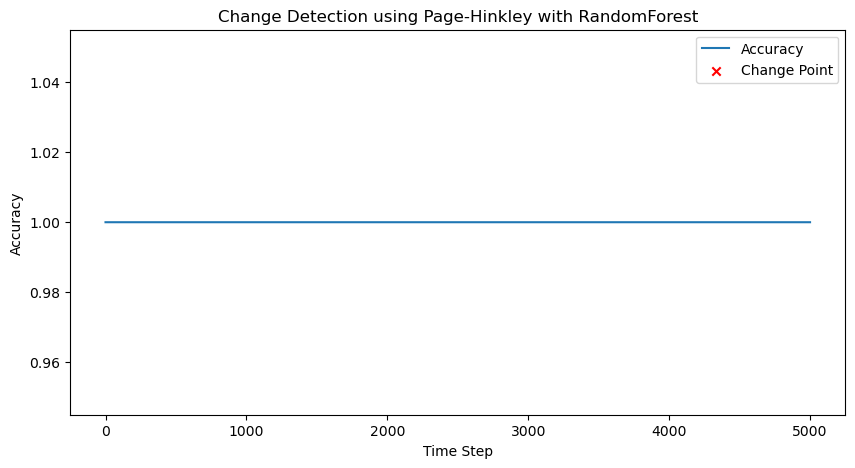

In [19]:
topic = 'hai-albert-preprocessed-11'
bootstrap_servers = ['localhost:9092']
consumer = HaiConsumer(topic, bootstrap_servers)
consumer.consume()